In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2021_off_processed.csv", low_memory=False)
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2022_off_processed.csv", low_memory=False)
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2023_off_processed.csv", low_memory=False)

In [ ]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [ ]:
breaking_ball = data.query('pitch_type_condensed in ("CH"')
breaking_ball_testing = testing_data.query('pitch_type_condensed in ("CH")')

# Fastball Model First

In [ ]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']].copy()
testing_identifiers = breaking_ball_testing[['pitch_id_raw']].copy()
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball', 'line_drive',
    'total_movement'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes',
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball', 'line_drive',
    'total_movement', 'Unnamed: 0'
], axis=1)   # Exclude the identifier from the features

In [ ]:
train_data = training_features.drop(['swing'], axis=1).copy()
train_label = training_features['swing'].copy()
testing_data = testing_features.drop(['swing'], axis=1).copy()
testing_label = testing_features['swing'].copy()

In [ ]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo'],
      dtype='object')

In [ ]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo'],
      dtype='object')

In [ ]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [ ]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [ ]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6365045348436723
Log Loss: 0.6410926182199336


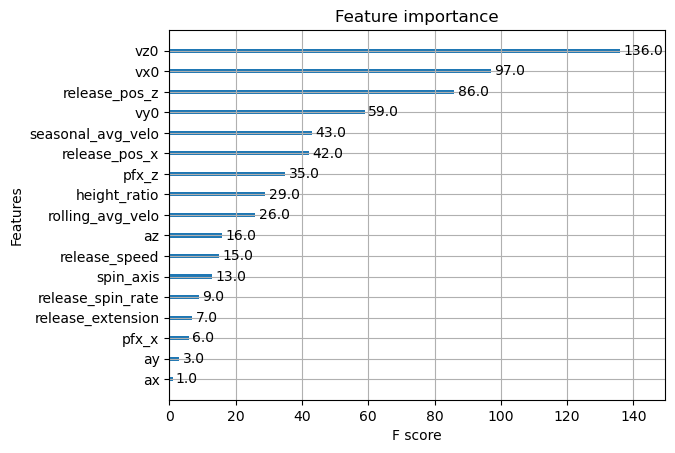

In [ ]:
xgb.plot_importance(model)
plt.show()

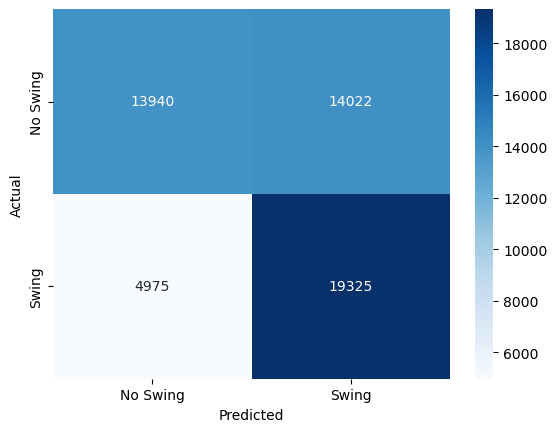

In [ ]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Swing', 'Swing'], yticklabels=['No Swing', 'Swing'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [ ]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'device' : 'gpu',
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [ ]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-14 16:52:19,961] A new study created in memory with name: no-name-f9716674-b439-4515-810d-4e602b8e597a


[0]	eval-logloss:0.69033
[1]	eval-logloss:0.66626
[2]	eval-logloss:0.64888
[3]	eval-logloss:0.63690
[4]	eval-logloss:0.63110
[5]	eval-logloss:0.62392
[6]	eval-logloss:0.61947
[7]	eval-logloss:0.61121
[8]	eval-logloss:0.60695
[9]	eval-logloss:0.60313
[10]	eval-logloss:0.60255
[11]	eval-logloss:0.59945
[12]	eval-logloss:0.59763
[13]	eval-logloss:0.59531
[14]	eval-logloss:0.59182
[15]	eval-logloss:0.58946
[16]	eval-logloss:0.58850
[17]	eval-logloss:0.58522
[18]	eval-logloss:0.58417
[19]	eval-logloss:0.58218
[20]	eval-logloss:0.58108
[21]	eval-logloss:0.58061
[22]	eval-logloss:0.58052
[23]	eval-logloss:0.58045
[24]	eval-logloss:0.57983
[25]	eval-logloss:0.57995
[26]	eval-logloss:0.57978
[27]	eval-logloss:0.57989
[28]	eval-logloss:0.58005
[29]	eval-logloss:0.57654
[30]	eval-logloss:0.57627
[31]	eval-logloss:0.57589
[32]	eval-logloss:0.57565
[33]	eval-logloss:0.57577
[34]	eval-logloss:0.57591
[35]	eval-logloss:0.57590
[36]	eval-logloss:0.57450
[37]	eval-logloss:0.57470
[38]	eval-logloss:0.57

[I 2023-11-14 16:52:21,770] Trial 0 finished with value: 0.5668495200748048 and parameters: {'max_depth': 9, 'eta': 0.24868447970084726, 'subsample': 0.6984473434585176, 'colsample_bytree': 0.5512467482242106}. Best is trial 0 with value: 0.5668495200748048.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69143
[2]	eval-logloss:0.68992
[3]	eval-logloss:0.68860
[4]	eval-logloss:0.68717
[5]	eval-logloss:0.68583
[6]	eval-logloss:0.68464
[7]	eval-logloss:0.68384
[8]	eval-logloss:0.68313
[9]	eval-logloss:0.68187
[10]	eval-logloss:0.68169
[11]	eval-logloss:0.68040
[12]	eval-logloss:0.67990
[13]	eval-logloss:0.67870
[14]	eval-logloss:0.67745
[15]	eval-logloss:0.67630
[16]	eval-logloss:0.67515
[17]	eval-logloss:0.67412
[18]	eval-logloss:0.67302
[19]	eval-logloss:0.67198
[20]	eval-logloss:0.67094
[21]	eval-logloss:0.66998
[22]	eval-logloss:0.66901
[23]	eval-logloss:0.66890
[24]	eval-logloss:0.66801
[25]	eval-logloss:0.66789
[26]	eval-logloss:0.66778
[27]	eval-logloss:0.66768
[28]	eval-logloss:0.66758
[29]	eval-logloss:0.66688
[30]	eval-logloss:0.66645
[31]	eval-logloss:0.66567
[32]	eval-logloss:0.66526
[33]	eval-logloss:0.66438
[34]	eval-logloss:0.66428
[35]	eval-logloss:0.66340
[36]	eval-logloss:0.66245
[37]	eval-logloss:0.66236
[38]	eval-logloss:0.66

[I 2023-11-14 16:52:22,707] Trial 1 finished with value: 0.6366217397323607 and parameters: {'max_depth': 6, 'eta': 0.0167006956439332, 'subsample': 0.6050879257163311, 'colsample_bytree': 0.5699195634034817}. Best is trial 0 with value: 0.5668495200748048.


[0]	eval-logloss:0.69225
[1]	eval-logloss:0.68648
[2]	eval-logloss:0.68083
[3]	eval-logloss:0.67679
[4]	eval-logloss:0.67216
[5]	eval-logloss:0.66869
[6]	eval-logloss:0.66552
[7]	eval-logloss:0.66393
[8]	eval-logloss:0.66259
[9]	eval-logloss:0.65951
[10]	eval-logloss:0.65921
[11]	eval-logloss:0.65721
[12]	eval-logloss:0.65582
[13]	eval-logloss:0.65338
[14]	eval-logloss:0.65140
[15]	eval-logloss:0.64966
[16]	eval-logloss:0.64761
[17]	eval-logloss:0.64623
[18]	eval-logloss:0.64494
[19]	eval-logloss:0.64350
[20]	eval-logloss:0.64247
[21]	eval-logloss:0.64165
[22]	eval-logloss:0.64046
[23]	eval-logloss:0.64027
[24]	eval-logloss:0.63934
[25]	eval-logloss:0.63920
[26]	eval-logloss:0.63904
[27]	eval-logloss:0.63893
[28]	eval-logloss:0.63883
[29]	eval-logloss:0.63728
[30]	eval-logloss:0.63630
[31]	eval-logloss:0.63567
[32]	eval-logloss:0.63501
[33]	eval-logloss:0.63406
[34]	eval-logloss:0.63396
[35]	eval-logloss:0.63285
[36]	eval-logloss:0.63228
[37]	eval-logloss:0.63213
[38]	eval-logloss:0.63

[I 2023-11-14 16:52:23,438] Trial 2 finished with value: 0.6071444901711285 and parameters: {'max_depth': 4, 'eta': 0.10115260714643062, 'subsample': 0.7061140661874247, 'colsample_bytree': 0.6016705377744409}. Best is trial 0 with value: 0.5668495200748048.


[0]	eval-logloss:0.69210
[1]	eval-logloss:0.69107
[2]	eval-logloss:0.69005
[3]	eval-logloss:0.68917
[4]	eval-logloss:0.68821
[5]	eval-logloss:0.68726
[6]	eval-logloss:0.68639
[7]	eval-logloss:0.68544
[8]	eval-logloss:0.68453
[9]	eval-logloss:0.68363
[10]	eval-logloss:0.68281
[11]	eval-logloss:0.68203
[12]	eval-logloss:0.68119
[13]	eval-logloss:0.68039
[14]	eval-logloss:0.67962
[15]	eval-logloss:0.67896
[16]	eval-logloss:0.67831
[17]	eval-logloss:0.67754
[18]	eval-logloss:0.67689
[19]	eval-logloss:0.67618
[20]	eval-logloss:0.67548
[21]	eval-logloss:0.67477
[22]	eval-logloss:0.67412
[23]	eval-logloss:0.67355
[24]	eval-logloss:0.67286
[25]	eval-logloss:0.67223
[26]	eval-logloss:0.67158
[27]	eval-logloss:0.67147
[28]	eval-logloss:0.67096
[29]	eval-logloss:0.67042
[30]	eval-logloss:0.66982
[31]	eval-logloss:0.66934
[32]	eval-logloss:0.66902
[33]	eval-logloss:0.66845
[34]	eval-logloss:0.66792
[35]	eval-logloss:0.66735
[36]	eval-logloss:0.66692
[37]	eval-logloss:0.66641
[38]	eval-logloss:0.66

[I 2023-11-14 16:52:24,171] Trial 3 finished with value: 0.6467941157259901 and parameters: {'max_depth': 4, 'eta': 0.015912436785164914, 'subsample': 0.8143230134225072, 'colsample_bytree': 0.9397369300424041}. Best is trial 0 with value: 0.5668495200748048.


[0]	eval-logloss:0.66514
[1]	eval-logloss:0.64635
[2]	eval-logloss:0.63639
[3]	eval-logloss:0.62612
[4]	eval-logloss:0.61779
[5]	eval-logloss:0.61313
[6]	eval-logloss:0.60819
[7]	eval-logloss:0.60371
[8]	eval-logloss:0.59820
[9]	eval-logloss:0.59583
[10]	eval-logloss:0.59353
[11]	eval-logloss:0.58965
[12]	eval-logloss:0.58642
[13]	eval-logloss:0.58509
[14]	eval-logloss:0.58251
[15]	eval-logloss:0.58130
[16]	eval-logloss:0.57858
[17]	eval-logloss:0.57717
[18]	eval-logloss:0.57648
[19]	eval-logloss:0.57421
[20]	eval-logloss:0.57369
[21]	eval-logloss:0.57309
[22]	eval-logloss:0.57258
[23]	eval-logloss:0.57128
[24]	eval-logloss:0.57139
[25]	eval-logloss:0.57082
[26]	eval-logloss:0.57022
[27]	eval-logloss:0.57017
[28]	eval-logloss:0.57005
[29]	eval-logloss:0.56900
[30]	eval-logloss:0.56890
[31]	eval-logloss:0.56791
[32]	eval-logloss:0.56791
[33]	eval-logloss:0.56801
[34]	eval-logloss:0.56718
[35]	eval-logloss:0.56570
[36]	eval-logloss:0.56508
[37]	eval-logloss:0.56497
[38]	eval-logloss:0.56

[I 2023-11-14 16:52:25,407] Trial 4 finished with value: 0.5635968437056001 and parameters: {'max_depth': 8, 'eta': 0.2988913223849578, 'subsample': 0.6219600824036243, 'colsample_bytree': 0.8492752211607013}. Best is trial 4 with value: 0.5635968437056001.


[0]	eval-logloss:0.69095
[1]	eval-logloss:0.68889
[2]	eval-logloss:0.68688
[3]	eval-logloss:0.68494
[4]	eval-logloss:0.68304
[5]	eval-logloss:0.68123
[6]	eval-logloss:0.67964
[7]	eval-logloss:0.67792
[8]	eval-logloss:0.67687
[9]	eval-logloss:0.67531
[10]	eval-logloss:0.67390
[11]	eval-logloss:0.67228
[12]	eval-logloss:0.67173
[13]	eval-logloss:0.67034
[14]	eval-logloss:0.66890
[15]	eval-logloss:0.66758
[16]	eval-logloss:0.66637
[17]	eval-logloss:0.66508
[18]	eval-logloss:0.66391
[19]	eval-logloss:0.66274
[20]	eval-logloss:0.66169
[21]	eval-logloss:0.66061
[22]	eval-logloss:0.65964
[23]	eval-logloss:0.65851
[24]	eval-logloss:0.65749
[25]	eval-logloss:0.65649
[26]	eval-logloss:0.65595
[27]	eval-logloss:0.65583
[28]	eval-logloss:0.65543
[29]	eval-logloss:0.65450
[30]	eval-logloss:0.65363
[31]	eval-logloss:0.65288
[32]	eval-logloss:0.65245
[33]	eval-logloss:0.65156
[34]	eval-logloss:0.65079
[35]	eval-logloss:0.65006
[36]	eval-logloss:0.64930
[37]	eval-logloss:0.64863
[38]	eval-logloss:0.64

[I 2023-11-14 16:52:26,215] Trial 5 finished with value: 0.6231627566063828 and parameters: {'max_depth': 5, 'eta': 0.027779670712873905, 'subsample': 0.677545015044548, 'colsample_bytree': 0.73892182608356}. Best is trial 4 with value: 0.5635968437056001.


[0]	eval-logloss:0.69083
[1]	eval-logloss:0.67601
[2]	eval-logloss:0.66474
[3]	eval-logloss:0.65902
[4]	eval-logloss:0.65184
[5]	eval-logloss:0.64743
[6]	eval-logloss:0.64419
[7]	eval-logloss:0.63837
[8]	eval-logloss:0.63651
[9]	eval-logloss:0.63413
[10]	eval-logloss:0.63362
[11]	eval-logloss:0.63133
[12]	eval-logloss:0.62990
[13]	eval-logloss:0.62878
[14]	eval-logloss:0.62694
[15]	eval-logloss:0.62468
[16]	eval-logloss:0.62358
[17]	eval-logloss:0.62283
[18]	eval-logloss:0.62256
[19]	eval-logloss:0.62100
[20]	eval-logloss:0.61934
[21]	eval-logloss:0.61909
[22]	eval-logloss:0.61788
[23]	eval-logloss:0.61765
[24]	eval-logloss:0.61727
[25]	eval-logloss:0.61706
[26]	eval-logloss:0.61682
[27]	eval-logloss:0.61676
[28]	eval-logloss:0.61669
[29]	eval-logloss:0.61504
[30]	eval-logloss:0.61457
[31]	eval-logloss:0.61387
[32]	eval-logloss:0.61345
[33]	eval-logloss:0.61266
[34]	eval-logloss:0.61250
[35]	eval-logloss:0.61155
[36]	eval-logloss:0.60909
[37]	eval-logloss:0.60902
[38]	eval-logloss:0.60

[I 2023-11-14 16:52:26,934] Trial 6 finished with value: 0.5803502710204989 and parameters: {'max_depth': 4, 'eta': 0.29200586381075266, 'subsample': 0.765817277034749, 'colsample_bytree': 0.5806317796729075}. Best is trial 4 with value: 0.5635968437056001.


[0]	eval-logloss:0.68864
[1]	eval-logloss:0.68453
[2]	eval-logloss:0.68092
[3]	eval-logloss:0.67787
[4]	eval-logloss:0.67491
[5]	eval-logloss:0.67185
[6]	eval-logloss:0.66920
[7]	eval-logloss:0.66684
[8]	eval-logloss:0.66548
[9]	eval-logloss:0.66328
[10]	eval-logloss:0.66166
[11]	eval-logloss:0.65969
[12]	eval-logloss:0.65891
[13]	eval-logloss:0.65687
[14]	eval-logloss:0.65519
[15]	eval-logloss:0.65380
[16]	eval-logloss:0.65218
[17]	eval-logloss:0.65081
[18]	eval-logloss:0.64956
[19]	eval-logloss:0.64855
[20]	eval-logloss:0.64776
[21]	eval-logloss:0.64702
[22]	eval-logloss:0.64573
[23]	eval-logloss:0.64466
[24]	eval-logloss:0.64375
[25]	eval-logloss:0.64287
[26]	eval-logloss:0.64142
[27]	eval-logloss:0.64127
[28]	eval-logloss:0.64041
[29]	eval-logloss:0.63959
[30]	eval-logloss:0.63897
[31]	eval-logloss:0.63801
[32]	eval-logloss:0.63735
[33]	eval-logloss:0.63662
[34]	eval-logloss:0.63572
[35]	eval-logloss:0.63503
[36]	eval-logloss:0.63423
[37]	eval-logloss:0.63344
[38]	eval-logloss:0.63

[I 2023-11-14 16:52:27,652] Trial 7 finished with value: 0.608670747052138 and parameters: {'max_depth': 4, 'eta': 0.06955091893414092, 'subsample': 0.6678589029718403, 'colsample_bytree': 0.7951829710807639}. Best is trial 4 with value: 0.5635968437056001.


[0]	eval-logloss:0.68257
[1]	eval-logloss:0.67300
[2]	eval-logloss:0.66542
[3]	eval-logloss:0.65838
[4]	eval-logloss:0.65261
[5]	eval-logloss:0.64747
[6]	eval-logloss:0.64310
[7]	eval-logloss:0.63881
[8]	eval-logloss:0.63408
[9]	eval-logloss:0.63115
[10]	eval-logloss:0.62841
[11]	eval-logloss:0.62530
[12]	eval-logloss:0.62184
[13]	eval-logloss:0.61947
[14]	eval-logloss:0.61677
[15]	eval-logloss:0.61374
[16]	eval-logloss:0.61177
[17]	eval-logloss:0.60951
[18]	eval-logloss:0.60781
[19]	eval-logloss:0.60594
[20]	eval-logloss:0.60420
[21]	eval-logloss:0.60319
[22]	eval-logloss:0.60213
[23]	eval-logloss:0.60106
[24]	eval-logloss:0.60032
[25]	eval-logloss:0.59899
[26]	eval-logloss:0.59793
[27]	eval-logloss:0.59767
[28]	eval-logloss:0.59637
[29]	eval-logloss:0.59519
[30]	eval-logloss:0.59383
[31]	eval-logloss:0.59261
[32]	eval-logloss:0.59193
[33]	eval-logloss:0.59149
[34]	eval-logloss:0.58936
[35]	eval-logloss:0.58791
[36]	eval-logloss:0.58689
[37]	eval-logloss:0.58631
[38]	eval-logloss:0.58

[I 2023-11-14 16:52:29,044] Trial 8 finished with value: 0.5597527926607664 and parameters: {'max_depth': 8, 'eta': 0.09947447928677793, 'subsample': 0.6239129269811394, 'colsample_bytree': 0.8629004326257801}. Best is trial 8 with value: 0.5597527926607664.


[0]	eval-logloss:0.67205
[1]	eval-logloss:0.65596
[2]	eval-logloss:0.64471
[3]	eval-logloss:0.63367
[4]	eval-logloss:0.62724
[5]	eval-logloss:0.62116
[6]	eval-logloss:0.61757
[7]	eval-logloss:0.61245
[8]	eval-logloss:0.60681
[9]	eval-logloss:0.60388
[10]	eval-logloss:0.60200
[11]	eval-logloss:0.59562
[12]	eval-logloss:0.59398
[13]	eval-logloss:0.59243
[14]	eval-logloss:0.59088
[15]	eval-logloss:0.58800
[16]	eval-logloss:0.58678
[17]	eval-logloss:0.58181
[18]	eval-logloss:0.58098
[19]	eval-logloss:0.57953
[20]	eval-logloss:0.57868
[21]	eval-logloss:0.57825
[22]	eval-logloss:0.57760
[23]	eval-logloss:0.57746
[24]	eval-logloss:0.57707
[25]	eval-logloss:0.57709
[26]	eval-logloss:0.57681
[27]	eval-logloss:0.57695
[28]	eval-logloss:0.57709
[29]	eval-logloss:0.57559
[30]	eval-logloss:0.57524
[31]	eval-logloss:0.57514
[32]	eval-logloss:0.57434
[33]	eval-logloss:0.57390
[34]	eval-logloss:0.57406
[35]	eval-logloss:0.57388
[36]	eval-logloss:0.57273
[37]	eval-logloss:0.57279
[38]	eval-logloss:0.57

[I 2023-11-14 16:52:30,710] Trial 9 finished with value: 0.5603524368847838 and parameters: {'max_depth': 9, 'eta': 0.20687868115104602, 'subsample': 0.871971264276787, 'colsample_bytree': 0.658834185467628}. Best is trial 8 with value: 0.5597527926607664.


[0]	eval-logloss:0.68007
[1]	eval-logloss:0.66902
[2]	eval-logloss:0.66061
[3]	eval-logloss:0.65355
[4]	eval-logloss:0.64811
[5]	eval-logloss:0.64266
[6]	eval-logloss:0.63796
[7]	eval-logloss:0.63423
[8]	eval-logloss:0.63007
[9]	eval-logloss:0.62649
[10]	eval-logloss:0.62296
[11]	eval-logloss:0.61993
[12]	eval-logloss:0.61716
[13]	eval-logloss:0.61537
[14]	eval-logloss:0.61171
[15]	eval-logloss:0.60990
[16]	eval-logloss:0.60801
[17]	eval-logloss:0.60632
[18]	eval-logloss:0.60538
[19]	eval-logloss:0.60396
[20]	eval-logloss:0.60300
[21]	eval-logloss:0.60118
[22]	eval-logloss:0.59932
[23]	eval-logloss:0.59861
[24]	eval-logloss:0.59549
[25]	eval-logloss:0.59422
[26]	eval-logloss:0.59354
[27]	eval-logloss:0.59155
[28]	eval-logloss:0.59069
[29]	eval-logloss:0.58971
[30]	eval-logloss:0.58892
[31]	eval-logloss:0.58810
[32]	eval-logloss:0.58771
[33]	eval-logloss:0.58702
[34]	eval-logloss:0.58556
[35]	eval-logloss:0.58460
[36]	eval-logloss:0.58363
[37]	eval-logloss:0.58290
[38]	eval-logloss:0.58

[I 2023-11-14 16:52:31,821] Trial 10 finished with value: 0.5600458683071409 and parameters: {'max_depth': 7, 'eta': 0.13214022488218582, 'subsample': 0.7504081921799034, 'colsample_bytree': 0.993182368942675}. Best is trial 8 with value: 0.5597527926607664.


[0]	eval-logloss:0.67988
[1]	eval-logloss:0.66870
[2]	eval-logloss:0.66019
[3]	eval-logloss:0.65320
[4]	eval-logloss:0.64772
[5]	eval-logloss:0.64220
[6]	eval-logloss:0.63753
[7]	eval-logloss:0.63420
[8]	eval-logloss:0.63043
[9]	eval-logloss:0.62700
[10]	eval-logloss:0.62313
[11]	eval-logloss:0.61953
[12]	eval-logloss:0.61671
[13]	eval-logloss:0.61511
[14]	eval-logloss:0.61213
[15]	eval-logloss:0.60992
[16]	eval-logloss:0.60866
[17]	eval-logloss:0.60566
[18]	eval-logloss:0.60447
[19]	eval-logloss:0.60291
[20]	eval-logloss:0.60168
[21]	eval-logloss:0.59977
[22]	eval-logloss:0.59855
[23]	eval-logloss:0.59775
[24]	eval-logloss:0.59639
[25]	eval-logloss:0.59417
[26]	eval-logloss:0.59312
[27]	eval-logloss:0.59220
[28]	eval-logloss:0.59160
[29]	eval-logloss:0.59064
[30]	eval-logloss:0.58983
[31]	eval-logloss:0.58837
[32]	eval-logloss:0.58813
[33]	eval-logloss:0.58718
[34]	eval-logloss:0.58662
[35]	eval-logloss:0.58504
[36]	eval-logloss:0.58430
[37]	eval-logloss:0.58372
[38]	eval-logloss:0.58

[I 2023-11-14 16:52:32,921] Trial 11 finished with value: 0.5589934742170699 and parameters: {'max_depth': 7, 'eta': 0.13417664927066128, 'subsample': 0.7508560886606316, 'colsample_bytree': 0.9607652401233062}. Best is trial 11 with value: 0.5589934742170699.


[0]	eval-logloss:0.67741
[1]	eval-logloss:0.66475
[2]	eval-logloss:0.65568
[3]	eval-logloss:0.64840
[4]	eval-logloss:0.64197
[5]	eval-logloss:0.63678
[6]	eval-logloss:0.63166
[7]	eval-logloss:0.62745
[8]	eval-logloss:0.62336
[9]	eval-logloss:0.62020
[10]	eval-logloss:0.61722
[11]	eval-logloss:0.61350
[12]	eval-logloss:0.61033
[13]	eval-logloss:0.60843
[14]	eval-logloss:0.60463
[15]	eval-logloss:0.60238
[16]	eval-logloss:0.60061
[17]	eval-logloss:0.59929
[18]	eval-logloss:0.59809
[19]	eval-logloss:0.59623
[20]	eval-logloss:0.59446
[21]	eval-logloss:0.59345
[22]	eval-logloss:0.59251
[23]	eval-logloss:0.59167
[24]	eval-logloss:0.59088
[25]	eval-logloss:0.58891
[26]	eval-logloss:0.58789
[27]	eval-logloss:0.58760
[28]	eval-logloss:0.58710
[29]	eval-logloss:0.58676
[30]	eval-logloss:0.58579
[31]	eval-logloss:0.58553
[32]	eval-logloss:0.58434
[33]	eval-logloss:0.58316
[34]	eval-logloss:0.58271
[35]	eval-logloss:0.58170
[36]	eval-logloss:0.58115
[37]	eval-logloss:0.58078
[38]	eval-logloss:0.57

[I 2023-11-14 16:52:34,021] Trial 12 finished with value: 0.5599696797137623 and parameters: {'max_depth': 7, 'eta': 0.16033950773760697, 'subsample': 0.791852856722578, 'colsample_bytree': 0.8893788870379424}. Best is trial 11 with value: 0.5589934742170699.


[0]	eval-logloss:0.67778
[1]	eval-logloss:0.66572
[2]	eval-logloss:0.65718
[3]	eval-logloss:0.64983
[4]	eval-logloss:0.64292
[5]	eval-logloss:0.63776
[6]	eval-logloss:0.63395
[7]	eval-logloss:0.62969
[8]	eval-logloss:0.62677
[9]	eval-logloss:0.62395
[10]	eval-logloss:0.62117
[11]	eval-logloss:0.61810
[12]	eval-logloss:0.61532
[13]	eval-logloss:0.61361
[14]	eval-logloss:0.61182
[15]	eval-logloss:0.60904
[16]	eval-logloss:0.60732
[17]	eval-logloss:0.60580
[18]	eval-logloss:0.60387
[19]	eval-logloss:0.60185
[20]	eval-logloss:0.60009
[21]	eval-logloss:0.59753
[22]	eval-logloss:0.59590
[23]	eval-logloss:0.59371
[24]	eval-logloss:0.59217
[25]	eval-logloss:0.59064
[26]	eval-logloss:0.58988
[27]	eval-logloss:0.58912
[28]	eval-logloss:0.58838
[29]	eval-logloss:0.58747
[30]	eval-logloss:0.58470
[31]	eval-logloss:0.58356
[32]	eval-logloss:0.58274
[33]	eval-logloss:0.58186
[34]	eval-logloss:0.58115
[35]	eval-logloss:0.58057
[36]	eval-logloss:0.57943
[37]	eval-logloss:0.57897
[38]	eval-logloss:0.57

[I 2023-11-14 16:52:35,088] Trial 13 finished with value: 0.5581708447897692 and parameters: {'max_depth': 7, 'eta': 0.15873633271491847, 'subsample': 0.7209713893791754, 'colsample_bytree': 0.9763198560283206}. Best is trial 13 with value: 0.5581708447897692.


[0]	eval-logloss:0.67902
[1]	eval-logloss:0.66811
[2]	eval-logloss:0.65931
[3]	eval-logloss:0.65321
[4]	eval-logloss:0.64714
[5]	eval-logloss:0.64227
[6]	eval-logloss:0.63749
[7]	eval-logloss:0.63388
[8]	eval-logloss:0.63030
[9]	eval-logloss:0.62765
[10]	eval-logloss:0.62514
[11]	eval-logloss:0.62253
[12]	eval-logloss:0.61979
[13]	eval-logloss:0.61723
[14]	eval-logloss:0.61547
[15]	eval-logloss:0.61328
[16]	eval-logloss:0.61125
[17]	eval-logloss:0.60847
[18]	eval-logloss:0.60713
[19]	eval-logloss:0.60593
[20]	eval-logloss:0.60292
[21]	eval-logloss:0.60142
[22]	eval-logloss:0.59982
[23]	eval-logloss:0.59830
[24]	eval-logloss:0.59709
[25]	eval-logloss:0.59636
[26]	eval-logloss:0.59503
[27]	eval-logloss:0.59361
[28]	eval-logloss:0.59325
[29]	eval-logloss:0.59243
[30]	eval-logloss:0.59112
[31]	eval-logloss:0.59003
[32]	eval-logloss:0.58986
[33]	eval-logloss:0.58896
[34]	eval-logloss:0.58826
[35]	eval-logloss:0.58757
[36]	eval-logloss:0.58715
[37]	eval-logloss:0.58638
[38]	eval-logloss:0.58

[I 2023-11-14 16:52:36,002] Trial 14 finished with value: 0.5626396229327376 and parameters: {'max_depth': 6, 'eta': 0.16358400811408919, 'subsample': 0.7235719677987624, 'colsample_bytree': 0.9862006645866606}. Best is trial 13 with value: 0.5581708447897692.


[0]	eval-logloss:0.67453
[1]	eval-logloss:0.66035
[2]	eval-logloss:0.65045
[3]	eval-logloss:0.64313
[4]	eval-logloss:0.63752
[5]	eval-logloss:0.63166
[6]	eval-logloss:0.62703
[7]	eval-logloss:0.62165
[8]	eval-logloss:0.61742
[9]	eval-logloss:0.61536
[10]	eval-logloss:0.61058
[11]	eval-logloss:0.60728
[12]	eval-logloss:0.60386
[13]	eval-logloss:0.60227
[14]	eval-logloss:0.59961
[15]	eval-logloss:0.59768
[16]	eval-logloss:0.59387
[17]	eval-logloss:0.59258
[18]	eval-logloss:0.59106
[19]	eval-logloss:0.59040
[20]	eval-logloss:0.58970
[21]	eval-logloss:0.58843
[22]	eval-logloss:0.58783
[23]	eval-logloss:0.58576
[24]	eval-logloss:0.58470
[25]	eval-logloss:0.58363
[26]	eval-logloss:0.58288
[27]	eval-logloss:0.58265
[28]	eval-logloss:0.58163
[29]	eval-logloss:0.57999
[30]	eval-logloss:0.57875
[31]	eval-logloss:0.57865
[32]	eval-logloss:0.57843
[33]	eval-logloss:0.57780
[34]	eval-logloss:0.57706
[35]	eval-logloss:0.57666
[36]	eval-logloss:0.57568
[37]	eval-logloss:0.57546
[38]	eval-logloss:0.57

[I 2023-11-14 16:52:37,121] Trial 15 finished with value: 0.5567487648419189 and parameters: {'max_depth': 7, 'eta': 0.19354282018898364, 'subsample': 0.7452177943355026, 'colsample_bytree': 0.9340201911071416}. Best is trial 15 with value: 0.5567487648419189.


[0]	eval-logloss:0.67235
[1]	eval-logloss:0.65759
[2]	eval-logloss:0.64800
[3]	eval-logloss:0.63875
[4]	eval-logloss:0.63155
[5]	eval-logloss:0.62589
[6]	eval-logloss:0.61931
[7]	eval-logloss:0.61589
[8]	eval-logloss:0.61161
[9]	eval-logloss:0.60833
[10]	eval-logloss:0.60520
[11]	eval-logloss:0.60185
[12]	eval-logloss:0.60036
[13]	eval-logloss:0.59822
[14]	eval-logloss:0.59532
[15]	eval-logloss:0.59348
[16]	eval-logloss:0.59182
[17]	eval-logloss:0.58768
[18]	eval-logloss:0.58685
[19]	eval-logloss:0.58518
[20]	eval-logloss:0.58323
[21]	eval-logloss:0.58183
[22]	eval-logloss:0.58103
[23]	eval-logloss:0.57819
[24]	eval-logloss:0.57779
[25]	eval-logloss:0.57582
[26]	eval-logloss:0.57542
[27]	eval-logloss:0.57508
[28]	eval-logloss:0.57455
[29]	eval-logloss:0.57317
[30]	eval-logloss:0.57274
[31]	eval-logloss:0.57189
[32]	eval-logloss:0.57017
[33]	eval-logloss:0.56925
[34]	eval-logloss:0.56865
[35]	eval-logloss:0.56840
[36]	eval-logloss:0.56793
[37]	eval-logloss:0.56779
[38]	eval-logloss:0.56

[I 2023-11-14 16:52:38,473] Trial 16 finished with value: 0.5562375563209853 and parameters: {'max_depth': 8, 'eta': 0.19849093217832217, 'subsample': 0.8043133524238519, 'colsample_bytree': 0.9179238072622707}. Best is trial 16 with value: 0.5562375563209853.


[0]	eval-logloss:0.67189
[1]	eval-logloss:0.65597
[2]	eval-logloss:0.64670
[3]	eval-logloss:0.63812
[4]	eval-logloss:0.63162
[5]	eval-logloss:0.62585
[6]	eval-logloss:0.61876
[7]	eval-logloss:0.61374
[8]	eval-logloss:0.60969
[9]	eval-logloss:0.60725
[10]	eval-logloss:0.60398
[11]	eval-logloss:0.59906
[12]	eval-logloss:0.59670
[13]	eval-logloss:0.59522
[14]	eval-logloss:0.59050
[15]	eval-logloss:0.58846
[16]	eval-logloss:0.58655
[17]	eval-logloss:0.58446
[18]	eval-logloss:0.58271
[19]	eval-logloss:0.58112
[20]	eval-logloss:0.58019
[21]	eval-logloss:0.57877
[22]	eval-logloss:0.57842
[23]	eval-logloss:0.57706
[24]	eval-logloss:0.57674
[25]	eval-logloss:0.57455
[26]	eval-logloss:0.57405
[27]	eval-logloss:0.57398
[28]	eval-logloss:0.57383
[29]	eval-logloss:0.57219
[30]	eval-logloss:0.57166
[31]	eval-logloss:0.57108
[32]	eval-logloss:0.57091
[33]	eval-logloss:0.56976
[34]	eval-logloss:0.56910
[35]	eval-logloss:0.56867
[36]	eval-logloss:0.56823
[37]	eval-logloss:0.56783
[38]	eval-logloss:0.56

[I 2023-11-14 16:52:39,802] Trial 17 finished with value: 0.5558668340033049 and parameters: {'max_depth': 8, 'eta': 0.2031028129664177, 'subsample': 0.8283662376668215, 'colsample_bytree': 0.9269468425091818}. Best is trial 17 with value: 0.5558668340033049.


[0]	eval-logloss:0.67059
[1]	eval-logloss:0.65499
[2]	eval-logloss:0.64470
[3]	eval-logloss:0.63612
[4]	eval-logloss:0.62878
[5]	eval-logloss:0.62309
[6]	eval-logloss:0.61630
[7]	eval-logloss:0.61201
[8]	eval-logloss:0.60835
[9]	eval-logloss:0.60533
[10]	eval-logloss:0.60368
[11]	eval-logloss:0.60097
[12]	eval-logloss:0.59776
[13]	eval-logloss:0.59671
[14]	eval-logloss:0.59269
[15]	eval-logloss:0.58995
[16]	eval-logloss:0.58912
[17]	eval-logloss:0.58755
[18]	eval-logloss:0.58550
[19]	eval-logloss:0.58354
[20]	eval-logloss:0.58170
[21]	eval-logloss:0.58056
[22]	eval-logloss:0.57966
[23]	eval-logloss:0.57861
[24]	eval-logloss:0.57823
[25]	eval-logloss:0.57468
[26]	eval-logloss:0.57258
[27]	eval-logloss:0.57228
[28]	eval-logloss:0.57214
[29]	eval-logloss:0.57194
[30]	eval-logloss:0.57018
[31]	eval-logloss:0.57006
[32]	eval-logloss:0.56979
[33]	eval-logloss:0.56928
[34]	eval-logloss:0.56850
[35]	eval-logloss:0.56787
[36]	eval-logloss:0.56765
[37]	eval-logloss:0.56749
[38]	eval-logloss:0.56

[I 2023-11-14 16:52:41,083] Trial 18 finished with value: 0.5568569948357983 and parameters: {'max_depth': 8, 'eta': 0.21654461860437932, 'subsample': 0.8539215024017892, 'colsample_bytree': 0.902004309739637}. Best is trial 17 with value: 0.5558668340033049.


[0]	eval-logloss:0.66866
[1]	eval-logloss:0.65011
[2]	eval-logloss:0.63915
[3]	eval-logloss:0.62788
[4]	eval-logloss:0.61904
[5]	eval-logloss:0.61407
[6]	eval-logloss:0.60870
[7]	eval-logloss:0.60451
[8]	eval-logloss:0.59799
[9]	eval-logloss:0.59587
[10]	eval-logloss:0.59289
[11]	eval-logloss:0.58994
[12]	eval-logloss:0.58895
[13]	eval-logloss:0.58746
[14]	eval-logloss:0.58658
[15]	eval-logloss:0.58465
[16]	eval-logloss:0.58236
[17]	eval-logloss:0.58167
[18]	eval-logloss:0.58099
[19]	eval-logloss:0.57811
[20]	eval-logloss:0.57711
[21]	eval-logloss:0.57649
[22]	eval-logloss:0.57591
[23]	eval-logloss:0.57572
[24]	eval-logloss:0.57498
[25]	eval-logloss:0.57286
[26]	eval-logloss:0.57149
[27]	eval-logloss:0.57157
[28]	eval-logloss:0.57116
[29]	eval-logloss:0.57084
[30]	eval-logloss:0.57075
[31]	eval-logloss:0.56910
[32]	eval-logloss:0.56881
[33]	eval-logloss:0.56879
[34]	eval-logloss:0.56837
[35]	eval-logloss:0.56821
[36]	eval-logloss:0.56815
[37]	eval-logloss:0.56813
[38]	eval-logloss:0.56

[I 2023-11-14 16:52:42,741] Trial 19 finished with value: 0.5597667924146155 and parameters: {'max_depth': 9, 'eta': 0.24377669624609327, 'subsample': 0.8923029406551296, 'colsample_bytree': 0.8150044023238705}. Best is trial 17 with value: 0.5558668340033049.


[0]	eval-logloss:0.68448
[1]	eval-logloss:0.67831
[2]	eval-logloss:0.67270
[3]	eval-logloss:0.66868
[4]	eval-logloss:0.66441
[5]	eval-logloss:0.66185
[6]	eval-logloss:0.65868
[7]	eval-logloss:0.65560
[8]	eval-logloss:0.65290
[9]	eval-logloss:0.65106
[10]	eval-logloss:0.64761
[11]	eval-logloss:0.64568
[12]	eval-logloss:0.64479
[13]	eval-logloss:0.64328
[14]	eval-logloss:0.64182
[15]	eval-logloss:0.64075
[16]	eval-logloss:0.63976
[17]	eval-logloss:0.63840
[18]	eval-logloss:0.63712
[19]	eval-logloss:0.63573
[20]	eval-logloss:0.63495
[21]	eval-logloss:0.63366
[22]	eval-logloss:0.63307
[23]	eval-logloss:0.63219
[24]	eval-logloss:0.63183
[25]	eval-logloss:0.63020
[26]	eval-logloss:0.62963
[27]	eval-logloss:0.62939
[28]	eval-logloss:0.62917
[29]	eval-logloss:0.62897
[30]	eval-logloss:0.62791
[31]	eval-logloss:0.62754
[32]	eval-logloss:0.62636
[33]	eval-logloss:0.62532
[34]	eval-logloss:0.62473
[35]	eval-logloss:0.62448
[36]	eval-logloss:0.62380
[37]	eval-logloss:0.62295
[38]	eval-logloss:0.62

[I 2023-11-14 16:52:43,389] Trial 20 finished with value: 0.5983314247284802 and parameters: {'max_depth': 3, 'eta': 0.19228647390820383, 'subsample': 0.8285708316557644, 'colsample_bytree': 0.9212391204290341}. Best is trial 17 with value: 0.5558668340033049.


[0]	eval-logloss:0.67394
[1]	eval-logloss:0.65932
[2]	eval-logloss:0.64884
[3]	eval-logloss:0.64040
[4]	eval-logloss:0.63372
[5]	eval-logloss:0.62816
[6]	eval-logloss:0.62306
[7]	eval-logloss:0.61734
[8]	eval-logloss:0.61265
[9]	eval-logloss:0.60938
[10]	eval-logloss:0.60687
[11]	eval-logloss:0.60400
[12]	eval-logloss:0.60184
[13]	eval-logloss:0.60052
[14]	eval-logloss:0.59550
[15]	eval-logloss:0.59300
[16]	eval-logloss:0.59114
[17]	eval-logloss:0.58891
[18]	eval-logloss:0.58821
[19]	eval-logloss:0.58715
[20]	eval-logloss:0.58489
[21]	eval-logloss:0.58395
[22]	eval-logloss:0.58340
[23]	eval-logloss:0.58057
[24]	eval-logloss:0.58000
[25]	eval-logloss:0.57803
[26]	eval-logloss:0.57716
[27]	eval-logloss:0.57690
[28]	eval-logloss:0.57660
[29]	eval-logloss:0.57610
[30]	eval-logloss:0.57560
[31]	eval-logloss:0.57434
[32]	eval-logloss:0.57310
[33]	eval-logloss:0.57214
[34]	eval-logloss:0.57021
[35]	eval-logloss:0.57004
[36]	eval-logloss:0.56982
[37]	eval-logloss:0.56936
[38]	eval-logloss:0.56

[I 2023-11-14 16:52:44,744] Trial 21 finished with value: 0.5545630443064661 and parameters: {'max_depth': 8, 'eta': 0.18224591553834849, 'subsample': 0.788248633623902, 'colsample_bytree': 0.921523402824954}. Best is trial 21 with value: 0.5545630443064661.


[0]	eval-logloss:0.67336
[1]	eval-logloss:0.65895
[2]	eval-logloss:0.64943
[3]	eval-logloss:0.64035
[4]	eval-logloss:0.63287
[5]	eval-logloss:0.62737
[6]	eval-logloss:0.62022
[7]	eval-logloss:0.61670
[8]	eval-logloss:0.61281
[9]	eval-logloss:0.60983
[10]	eval-logloss:0.60637
[11]	eval-logloss:0.60328
[12]	eval-logloss:0.60062
[13]	eval-logloss:0.59877
[14]	eval-logloss:0.59657
[15]	eval-logloss:0.59324
[16]	eval-logloss:0.59200
[17]	eval-logloss:0.58955
[18]	eval-logloss:0.58725
[19]	eval-logloss:0.58602
[20]	eval-logloss:0.58424
[21]	eval-logloss:0.58289
[22]	eval-logloss:0.58250
[23]	eval-logloss:0.58160
[24]	eval-logloss:0.58117
[25]	eval-logloss:0.58027
[26]	eval-logloss:0.57969
[27]	eval-logloss:0.57940
[28]	eval-logloss:0.57832
[29]	eval-logloss:0.57572
[30]	eval-logloss:0.57402
[31]	eval-logloss:0.57326
[32]	eval-logloss:0.57179
[33]	eval-logloss:0.57124
[34]	eval-logloss:0.57094
[35]	eval-logloss:0.57028
[36]	eval-logloss:0.56902
[37]	eval-logloss:0.56871
[38]	eval-logloss:0.56

[I 2023-11-14 16:52:46,102] Trial 22 finished with value: 0.5556361008418029 and parameters: {'max_depth': 8, 'eta': 0.1877206541713812, 'subsample': 0.799361647440971, 'colsample_bytree': 0.8900775663857151}. Best is trial 21 with value: 0.5545630443064661.


[0]	eval-logloss:0.67520
[1]	eval-logloss:0.66056
[2]	eval-logloss:0.65070
[3]	eval-logloss:0.64263
[4]	eval-logloss:0.63543
[5]	eval-logloss:0.62977
[6]	eval-logloss:0.62441
[7]	eval-logloss:0.61888
[8]	eval-logloss:0.61269
[9]	eval-logloss:0.60964
[10]	eval-logloss:0.60545
[11]	eval-logloss:0.60195
[12]	eval-logloss:0.59929
[13]	eval-logloss:0.59722
[14]	eval-logloss:0.59566
[15]	eval-logloss:0.59437
[16]	eval-logloss:0.59332
[17]	eval-logloss:0.59166
[18]	eval-logloss:0.59038
[19]	eval-logloss:0.58903
[20]	eval-logloss:0.58768
[21]	eval-logloss:0.58695
[22]	eval-logloss:0.58628
[23]	eval-logloss:0.58363
[24]	eval-logloss:0.58328
[25]	eval-logloss:0.58125
[26]	eval-logloss:0.58081
[27]	eval-logloss:0.58052
[28]	eval-logloss:0.57988
[29]	eval-logloss:0.57713
[30]	eval-logloss:0.57675
[31]	eval-logloss:0.57474
[32]	eval-logloss:0.57455
[33]	eval-logloss:0.57377
[34]	eval-logloss:0.57313
[35]	eval-logloss:0.57228
[36]	eval-logloss:0.57188
[37]	eval-logloss:0.57153
[38]	eval-logloss:0.57

[I 2023-11-14 16:52:47,403] Trial 23 finished with value: 0.5563144141206089 and parameters: {'max_depth': 8, 'eta': 0.17731992998010873, 'subsample': 0.8383261848100225, 'colsample_bytree': 0.8634664156170225}. Best is trial 21 with value: 0.5545630443064661.


[0]	eval-logloss:0.66779
[1]	eval-logloss:0.65108
[2]	eval-logloss:0.63971
[3]	eval-logloss:0.62951
[4]	eval-logloss:0.62268
[5]	eval-logloss:0.61678
[6]	eval-logloss:0.61005
[7]	eval-logloss:0.60541
[8]	eval-logloss:0.60216
[9]	eval-logloss:0.59851
[10]	eval-logloss:0.59281
[11]	eval-logloss:0.58972
[12]	eval-logloss:0.58769
[13]	eval-logloss:0.58674
[14]	eval-logloss:0.58549
[15]	eval-logloss:0.58385
[16]	eval-logloss:0.58201
[17]	eval-logloss:0.57816
[18]	eval-logloss:0.57687
[19]	eval-logloss:0.57589
[20]	eval-logloss:0.57503
[21]	eval-logloss:0.57382
[22]	eval-logloss:0.57230
[23]	eval-logloss:0.57014
[24]	eval-logloss:0.56988
[25]	eval-logloss:0.56928
[26]	eval-logloss:0.56899
[27]	eval-logloss:0.56774
[28]	eval-logloss:0.56708
[29]	eval-logloss:0.56648
[30]	eval-logloss:0.56616
[31]	eval-logloss:0.56505
[32]	eval-logloss:0.56462
[33]	eval-logloss:0.56452
[34]	eval-logloss:0.56446
[35]	eval-logloss:0.56406
[36]	eval-logloss:0.56394
[37]	eval-logloss:0.56364
[38]	eval-logloss:0.56

[I 2023-11-14 16:52:49,084] Trial 24 finished with value: 0.5587347783735387 and parameters: {'max_depth': 9, 'eta': 0.223130349050736, 'subsample': 0.7925720806272059, 'colsample_bytree': 0.9990842926247828}. Best is trial 21 with value: 0.5545630443064661.


[0]	eval-logloss:0.67408
[1]	eval-logloss:0.65992
[2]	eval-logloss:0.64958
[3]	eval-logloss:0.64116
[4]	eval-logloss:0.63456
[5]	eval-logloss:0.62917
[6]	eval-logloss:0.62435
[7]	eval-logloss:0.61856
[8]	eval-logloss:0.61424
[9]	eval-logloss:0.61083
[10]	eval-logloss:0.60711
[11]	eval-logloss:0.60443
[12]	eval-logloss:0.60214
[13]	eval-logloss:0.60047
[14]	eval-logloss:0.59804
[15]	eval-logloss:0.59401
[16]	eval-logloss:0.59246
[17]	eval-logloss:0.58883
[18]	eval-logloss:0.58775
[19]	eval-logloss:0.58660
[20]	eval-logloss:0.58465
[21]	eval-logloss:0.58347
[22]	eval-logloss:0.58241
[23]	eval-logloss:0.57958
[24]	eval-logloss:0.57887
[25]	eval-logloss:0.57781
[26]	eval-logloss:0.57659
[27]	eval-logloss:0.57640
[28]	eval-logloss:0.57587
[29]	eval-logloss:0.57446
[30]	eval-logloss:0.57353
[31]	eval-logloss:0.57244
[32]	eval-logloss:0.57209
[33]	eval-logloss:0.57147
[34]	eval-logloss:0.56985
[35]	eval-logloss:0.56946
[36]	eval-logloss:0.56924
[37]	eval-logloss:0.56892
[38]	eval-logloss:0.56

[I 2023-11-14 16:52:50,437] Trial 25 finished with value: 0.554612755273151 and parameters: {'max_depth': 8, 'eta': 0.17943603030606214, 'subsample': 0.7754792215572489, 'colsample_bytree': 0.8912723147922359}. Best is trial 21 with value: 0.5545630443064661.


[0]	eval-logloss:0.67814
[1]	eval-logloss:0.66677
[2]	eval-logloss:0.65834
[3]	eval-logloss:0.65138
[4]	eval-logloss:0.64528
[5]	eval-logloss:0.64015
[6]	eval-logloss:0.63583
[7]	eval-logloss:0.63119
[8]	eval-logloss:0.62774
[9]	eval-logloss:0.62514
[10]	eval-logloss:0.62245
[11]	eval-logloss:0.61959
[12]	eval-logloss:0.61834
[13]	eval-logloss:0.61614
[14]	eval-logloss:0.61336
[15]	eval-logloss:0.61080
[16]	eval-logloss:0.60865
[17]	eval-logloss:0.60668
[18]	eval-logloss:0.60521
[19]	eval-logloss:0.60434
[20]	eval-logloss:0.60210
[21]	eval-logloss:0.60072
[22]	eval-logloss:0.59997
[23]	eval-logloss:0.59938
[24]	eval-logloss:0.59837
[25]	eval-logloss:0.59632
[26]	eval-logloss:0.59550
[27]	eval-logloss:0.59526
[28]	eval-logloss:0.59480
[29]	eval-logloss:0.59468
[30]	eval-logloss:0.59331
[31]	eval-logloss:0.59194
[32]	eval-logloss:0.59155
[33]	eval-logloss:0.59103
[34]	eval-logloss:0.59012
[35]	eval-logloss:0.58938
[36]	eval-logloss:0.58853
[37]	eval-logloss:0.58774
[38]	eval-logloss:0.58

[I 2023-11-14 16:52:51,355] Trial 26 finished with value: 0.5624145690752116 and parameters: {'max_depth': 6, 'eta': 0.1771315236322502, 'subsample': 0.7758372621521026, 'colsample_bytree': 0.8187915100101533}. Best is trial 21 with value: 0.5545630443064661.


[0]	eval-logloss:0.67792
[1]	eval-logloss:0.66436
[2]	eval-logloss:0.65479
[3]	eval-logloss:0.64586
[4]	eval-logloss:0.63835
[5]	eval-logloss:0.63291
[6]	eval-logloss:0.62767
[7]	eval-logloss:0.62312
[8]	eval-logloss:0.61756
[9]	eval-logloss:0.61456
[10]	eval-logloss:0.60963
[11]	eval-logloss:0.60623
[12]	eval-logloss:0.60145
[13]	eval-logloss:0.59925
[14]	eval-logloss:0.59680
[15]	eval-logloss:0.59538
[16]	eval-logloss:0.59269
[17]	eval-logloss:0.59027
[18]	eval-logloss:0.58947
[19]	eval-logloss:0.58798
[20]	eval-logloss:0.58691
[21]	eval-logloss:0.58535
[22]	eval-logloss:0.58429
[23]	eval-logloss:0.58156
[24]	eval-logloss:0.58094
[25]	eval-logloss:0.57922
[26]	eval-logloss:0.57865
[27]	eval-logloss:0.57844
[28]	eval-logloss:0.57774
[29]	eval-logloss:0.57615
[30]	eval-logloss:0.57494
[31]	eval-logloss:0.57344
[32]	eval-logloss:0.57304
[33]	eval-logloss:0.57243
[34]	eval-logloss:0.57210
[35]	eval-logloss:0.57153
[36]	eval-logloss:0.57095
[37]	eval-logloss:0.57067
[38]	eval-logloss:0.57

[I 2023-11-14 16:52:53,062] Trial 27 finished with value: 0.5554824670078901 and parameters: {'max_depth': 9, 'eta': 0.14001679136100786, 'subsample': 0.7808551534816449, 'colsample_bytree': 0.886664265470905}. Best is trial 21 with value: 0.5545630443064661.


[0]	eval-logloss:0.67773
[1]	eval-logloss:0.66473
[2]	eval-logloss:0.65491
[3]	eval-logloss:0.64530
[4]	eval-logloss:0.63763
[5]	eval-logloss:0.63172
[6]	eval-logloss:0.62698
[7]	eval-logloss:0.62247
[8]	eval-logloss:0.61625
[9]	eval-logloss:0.61345
[10]	eval-logloss:0.61091
[11]	eval-logloss:0.60641
[12]	eval-logloss:0.60407
[13]	eval-logloss:0.60212
[14]	eval-logloss:0.60002
[15]	eval-logloss:0.59660
[16]	eval-logloss:0.59451
[17]	eval-logloss:0.59254
[18]	eval-logloss:0.59063
[19]	eval-logloss:0.58934
[20]	eval-logloss:0.58768
[21]	eval-logloss:0.58638
[22]	eval-logloss:0.58538
[23]	eval-logloss:0.58431
[24]	eval-logloss:0.58371
[25]	eval-logloss:0.58113
[26]	eval-logloss:0.57935
[27]	eval-logloss:0.57923
[28]	eval-logloss:0.57871
[29]	eval-logloss:0.57760
[30]	eval-logloss:0.57553
[31]	eval-logloss:0.57513
[32]	eval-logloss:0.57485
[33]	eval-logloss:0.57413
[34]	eval-logloss:0.57358
[35]	eval-logloss:0.57313
[36]	eval-logloss:0.57274
[37]	eval-logloss:0.57241
[38]	eval-logloss:0.57

[I 2023-11-14 16:52:54,746] Trial 28 finished with value: 0.5547103166607054 and parameters: {'max_depth': 9, 'eta': 0.14372664593027798, 'subsample': 0.7720541819894059, 'colsample_bytree': 0.7587012643135466}. Best is trial 21 with value: 0.5545630443064661.


[0]	eval-logloss:0.66839
[1]	eval-logloss:0.65133
[2]	eval-logloss:0.63994
[3]	eval-logloss:0.62872
[4]	eval-logloss:0.62066
[5]	eval-logloss:0.61545
[6]	eval-logloss:0.61198
[7]	eval-logloss:0.60826
[8]	eval-logloss:0.59983
[9]	eval-logloss:0.59745
[10]	eval-logloss:0.59510
[11]	eval-logloss:0.59043
[12]	eval-logloss:0.58857
[13]	eval-logloss:0.58720
[14]	eval-logloss:0.58349
[15]	eval-logloss:0.58092
[16]	eval-logloss:0.57914
[17]	eval-logloss:0.57813
[18]	eval-logloss:0.57779
[19]	eval-logloss:0.57499
[20]	eval-logloss:0.57437
[21]	eval-logloss:0.57353
[22]	eval-logloss:0.57297
[23]	eval-logloss:0.56995
[24]	eval-logloss:0.56973
[25]	eval-logloss:0.56929
[26]	eval-logloss:0.56878
[27]	eval-logloss:0.56870
[28]	eval-logloss:0.56861
[29]	eval-logloss:0.56776
[30]	eval-logloss:0.56754
[31]	eval-logloss:0.56741
[32]	eval-logloss:0.56735
[33]	eval-logloss:0.56735
[34]	eval-logloss:0.56728
[35]	eval-logloss:0.56734
[36]	eval-logloss:0.56653
[37]	eval-logloss:0.56641
[38]	eval-logloss:0.56

[I 2023-11-14 16:52:56,441] Trial 29 finished with value: 0.5610082960883738 and parameters: {'max_depth': 9, 'eta': 0.24326750233740185, 'subsample': 0.7683240137804478, 'colsample_bytree': 0.7508278236715659}. Best is trial 21 with value: 0.5545630443064661.


[0]	eval-logloss:0.66988
[1]	eval-logloss:0.65346
[2]	eval-logloss:0.64222
[3]	eval-logloss:0.63094
[4]	eval-logloss:0.62278
[5]	eval-logloss:0.61690
[6]	eval-logloss:0.61338
[7]	eval-logloss:0.60635
[8]	eval-logloss:0.59971
[9]	eval-logloss:0.59818
[10]	eval-logloss:0.59594
[11]	eval-logloss:0.59019
[12]	eval-logloss:0.58819
[13]	eval-logloss:0.58646
[14]	eval-logloss:0.58444
[15]	eval-logloss:0.58274
[16]	eval-logloss:0.58152
[17]	eval-logloss:0.57764
[18]	eval-logloss:0.57488
[19]	eval-logloss:0.57340
[20]	eval-logloss:0.57250
[21]	eval-logloss:0.57161
[22]	eval-logloss:0.57151
[23]	eval-logloss:0.57071
[24]	eval-logloss:0.57027
[25]	eval-logloss:0.56951
[26]	eval-logloss:0.56894
[27]	eval-logloss:0.56896
[28]	eval-logloss:0.56862
[29]	eval-logloss:0.56727
[30]	eval-logloss:0.56569
[31]	eval-logloss:0.56540
[32]	eval-logloss:0.56520
[33]	eval-logloss:0.56496
[34]	eval-logloss:0.56480
[35]	eval-logloss:0.56464
[36]	eval-logloss:0.56390
[37]	eval-logloss:0.56402
[38]	eval-logloss:0.56

[I 2023-11-14 16:52:58,186] Trial 30 finished with value: 0.5581105583199675 and parameters: {'max_depth': 9, 'eta': 0.2262710465723152, 'subsample': 0.8158773115779102, 'colsample_bytree': 0.7574027553562241}. Best is trial 21 with value: 0.5545630443064661.


[0]	eval-logloss:0.67696
[1]	eval-logloss:0.66431
[2]	eval-logloss:0.65499
[3]	eval-logloss:0.64684
[4]	eval-logloss:0.63926
[5]	eval-logloss:0.63363
[6]	eval-logloss:0.62862
[7]	eval-logloss:0.62415
[8]	eval-logloss:0.62068
[9]	eval-logloss:0.61741
[10]	eval-logloss:0.61211
[11]	eval-logloss:0.60891
[12]	eval-logloss:0.60591
[13]	eval-logloss:0.60342
[14]	eval-logloss:0.60057
[15]	eval-logloss:0.59830
[16]	eval-logloss:0.59649
[17]	eval-logloss:0.59512
[18]	eval-logloss:0.59357
[19]	eval-logloss:0.59217
[20]	eval-logloss:0.58941
[21]	eval-logloss:0.58776
[22]	eval-logloss:0.58693
[23]	eval-logloss:0.58445
[24]	eval-logloss:0.58322
[25]	eval-logloss:0.58207
[26]	eval-logloss:0.58132
[27]	eval-logloss:0.58001
[28]	eval-logloss:0.57945
[29]	eval-logloss:0.57876
[30]	eval-logloss:0.57605
[31]	eval-logloss:0.57547
[32]	eval-logloss:0.57498
[33]	eval-logloss:0.57415
[34]	eval-logloss:0.57376
[35]	eval-logloss:0.57269
[36]	eval-logloss:0.57239
[37]	eval-logloss:0.57185
[38]	eval-logloss:0.57

[I 2023-11-14 16:53:00,068] Trial 31 finished with value: 0.5547666538560427 and parameters: {'max_depth': 9, 'eta': 0.13428635289814556, 'subsample': 0.7851529144513995, 'colsample_bytree': 0.9546491052064375}. Best is trial 21 with value: 0.5545630443064661.


[0]	eval-logloss:0.67586
[1]	eval-logloss:0.66216
[2]	eval-logloss:0.65251
[3]	eval-logloss:0.64424
[4]	eval-logloss:0.63676
[5]	eval-logloss:0.63108
[6]	eval-logloss:0.62607
[7]	eval-logloss:0.62218
[8]	eval-logloss:0.61825
[9]	eval-logloss:0.61526
[10]	eval-logloss:0.61084
[11]	eval-logloss:0.60697
[12]	eval-logloss:0.60333
[13]	eval-logloss:0.60006
[14]	eval-logloss:0.59767
[15]	eval-logloss:0.59571
[16]	eval-logloss:0.59369
[17]	eval-logloss:0.59136
[18]	eval-logloss:0.58804
[19]	eval-logloss:0.58684
[20]	eval-logloss:0.58548
[21]	eval-logloss:0.58331
[22]	eval-logloss:0.58206
[23]	eval-logloss:0.57970
[24]	eval-logloss:0.57876
[25]	eval-logloss:0.57739
[26]	eval-logloss:0.57673
[27]	eval-logloss:0.57579
[28]	eval-logloss:0.57536
[29]	eval-logloss:0.57407
[30]	eval-logloss:0.57300
[31]	eval-logloss:0.57255
[32]	eval-logloss:0.57075
[33]	eval-logloss:0.57010
[34]	eval-logloss:0.56965
[35]	eval-logloss:0.56912
[36]	eval-logloss:0.56799
[37]	eval-logloss:0.56748
[38]	eval-logloss:0.56

[I 2023-11-14 16:53:01,869] Trial 32 finished with value: 0.5538299710450284 and parameters: {'max_depth': 9, 'eta': 0.1440196827328704, 'subsample': 0.7986365607673072, 'colsample_bytree': 0.9612419526441729}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67277
[1]	eval-logloss:0.65713
[2]	eval-logloss:0.64648
[3]	eval-logloss:0.63770
[4]	eval-logloss:0.63056
[5]	eval-logloss:0.62529
[6]	eval-logloss:0.62000
[7]	eval-logloss:0.61576
[8]	eval-logloss:0.61044
[9]	eval-logloss:0.60711
[10]	eval-logloss:0.60288
[11]	eval-logloss:0.59937
[12]	eval-logloss:0.59712
[13]	eval-logloss:0.59470
[14]	eval-logloss:0.59244
[15]	eval-logloss:0.59093
[16]	eval-logloss:0.58961
[17]	eval-logloss:0.58704
[18]	eval-logloss:0.58544
[19]	eval-logloss:0.58412
[20]	eval-logloss:0.58290
[21]	eval-logloss:0.58088
[22]	eval-logloss:0.57748
[23]	eval-logloss:0.57683
[24]	eval-logloss:0.57549
[25]	eval-logloss:0.57474
[26]	eval-logloss:0.57398
[27]	eval-logloss:0.57247
[28]	eval-logloss:0.57214
[29]	eval-logloss:0.57107
[30]	eval-logloss:0.57034
[31]	eval-logloss:0.56902
[32]	eval-logloss:0.56877
[33]	eval-logloss:0.56782
[34]	eval-logloss:0.56767
[35]	eval-logloss:0.56718
[36]	eval-logloss:0.56694
[37]	eval-logloss:0.56656
[38]	eval-logloss:0.56

[I 2023-11-14 16:53:03,663] Trial 33 finished with value: 0.5553878361469333 and parameters: {'max_depth': 9, 'eta': 0.173976795127386, 'subsample': 0.8066142599454365, 'colsample_bytree': 0.9677010985023798}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.68033
[1]	eval-logloss:0.66962
[2]	eval-logloss:0.66119
[3]	eval-logloss:0.65351
[4]	eval-logloss:0.64754
[5]	eval-logloss:0.64208
[6]	eval-logloss:0.63737
[7]	eval-logloss:0.63339
[8]	eval-logloss:0.62901
[9]	eval-logloss:0.62575
[10]	eval-logloss:0.62180
[11]	eval-logloss:0.61856
[12]	eval-logloss:0.61569
[13]	eval-logloss:0.61327
[14]	eval-logloss:0.61098
[15]	eval-logloss:0.60929
[16]	eval-logloss:0.60727
[17]	eval-logloss:0.60520
[18]	eval-logloss:0.60365
[19]	eval-logloss:0.60214
[20]	eval-logloss:0.59940
[21]	eval-logloss:0.59762
[22]	eval-logloss:0.59620
[23]	eval-logloss:0.59365
[24]	eval-logloss:0.59232
[25]	eval-logloss:0.59122
[26]	eval-logloss:0.58982
[27]	eval-logloss:0.58786
[28]	eval-logloss:0.58722
[29]	eval-logloss:0.58590
[30]	eval-logloss:0.58526
[31]	eval-logloss:0.58456
[32]	eval-logloss:0.58407
[33]	eval-logloss:0.58295
[34]	eval-logloss:0.58190
[35]	eval-logloss:0.58101
[36]	eval-logloss:0.58047
[37]	eval-logloss:0.58017
[38]	eval-logloss:0.57

[I 2023-11-14 16:53:05,104] Trial 34 finished with value: 0.5580124472043856 and parameters: {'max_depth': 8, 'eta': 0.1163985207061955, 'subsample': 0.7578021238288817, 'colsample_bytree': 0.9473925353558935}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.69135
[1]	eval-logloss:0.67579
[2]	eval-logloss:0.66288
[3]	eval-logloss:0.65275
[4]	eval-logloss:0.64777
[5]	eval-logloss:0.63989
[6]	eval-logloss:0.63507
[7]	eval-logloss:0.62834
[8]	eval-logloss:0.62317
[9]	eval-logloss:0.61865
[10]	eval-logloss:0.61801
[11]	eval-logloss:0.61391
[12]	eval-logloss:0.61216
[13]	eval-logloss:0.60927
[14]	eval-logloss:0.60518
[15]	eval-logloss:0.60161
[16]	eval-logloss:0.60022
[17]	eval-logloss:0.59837
[18]	eval-logloss:0.59649
[19]	eval-logloss:0.59392
[20]	eval-logloss:0.59236
[21]	eval-logloss:0.59100
[22]	eval-logloss:0.59077
[23]	eval-logloss:0.59054
[24]	eval-logloss:0.58909
[25]	eval-logloss:0.58894
[26]	eval-logloss:0.58858
[27]	eval-logloss:0.58853
[28]	eval-logloss:0.58846
[29]	eval-logloss:0.58519
[30]	eval-logloss:0.58423
[31]	eval-logloss:0.58359
[32]	eval-logloss:0.58311
[33]	eval-logloss:0.58294
[34]	eval-logloss:0.58291
[35]	eval-logloss:0.58196
[36]	eval-logloss:0.58124
[37]	eval-logloss:0.58110
[38]	eval-logloss:0.58

[I 2023-11-14 16:53:06,932] Trial 35 finished with value: 0.5640169055858866 and parameters: {'max_depth': 9, 'eta': 0.1501864282080945, 'subsample': 0.7766285244955669, 'colsample_bytree': 0.5243527084278393}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67985
[1]	eval-logloss:0.66979
[2]	eval-logloss:0.66176
[3]	eval-logloss:0.65468
[4]	eval-logloss:0.64843
[5]	eval-logloss:0.64367
[6]	eval-logloss:0.63905
[7]	eval-logloss:0.63479
[8]	eval-logloss:0.63053
[9]	eval-logloss:0.62775
[10]	eval-logloss:0.62486
[11]	eval-logloss:0.62214
[12]	eval-logloss:0.61974
[13]	eval-logloss:0.61760
[14]	eval-logloss:0.61590
[15]	eval-logloss:0.61417
[16]	eval-logloss:0.61226
[17]	eval-logloss:0.61077
[18]	eval-logloss:0.60973
[19]	eval-logloss:0.60860
[20]	eval-logloss:0.60766
[21]	eval-logloss:0.60658
[22]	eval-logloss:0.60583
[23]	eval-logloss:0.60480
[24]	eval-logloss:0.60442
[25]	eval-logloss:0.60317
[26]	eval-logloss:0.60183
[27]	eval-logloss:0.60155
[28]	eval-logloss:0.60123
[29]	eval-logloss:0.59924
[30]	eval-logloss:0.59755
[31]	eval-logloss:0.59706
[32]	eval-logloss:0.59671
[33]	eval-logloss:0.59602
[34]	eval-logloss:0.59545
[35]	eval-logloss:0.59431
[36]	eval-logloss:0.59330
[37]	eval-logloss:0.59285
[38]	eval-logloss:0.59

[I 2023-11-14 16:53:07,975] Trial 36 finished with value: 0.5656759234483922 and parameters: {'max_depth': 6, 'eta': 0.15316566144768112, 'subsample': 0.8076774692517394, 'colsample_bytree': 0.8468317383499213}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67466
[1]	eval-logloss:0.66061
[2]	eval-logloss:0.65034
[3]	eval-logloss:0.64195
[4]	eval-logloss:0.63585
[5]	eval-logloss:0.62994
[6]	eval-logloss:0.62512
[7]	eval-logloss:0.61942
[8]	eval-logloss:0.61556
[9]	eval-logloss:0.61294
[10]	eval-logloss:0.60907
[11]	eval-logloss:0.60627
[12]	eval-logloss:0.60335
[13]	eval-logloss:0.60097
[14]	eval-logloss:0.59867
[15]	eval-logloss:0.59507
[16]	eval-logloss:0.59360
[17]	eval-logloss:0.59187
[18]	eval-logloss:0.59120
[19]	eval-logloss:0.58955
[20]	eval-logloss:0.58751
[21]	eval-logloss:0.58573
[22]	eval-logloss:0.58419
[23]	eval-logloss:0.58167
[24]	eval-logloss:0.58069
[25]	eval-logloss:0.57967
[26]	eval-logloss:0.57919
[27]	eval-logloss:0.57813
[28]	eval-logloss:0.57738
[29]	eval-logloss:0.57579
[30]	eval-logloss:0.57414
[31]	eval-logloss:0.57389
[32]	eval-logloss:0.57375
[33]	eval-logloss:0.57335
[34]	eval-logloss:0.57230
[35]	eval-logloss:0.57152
[36]	eval-logloss:0.57034
[37]	eval-logloss:0.56988
[38]	eval-logloss:0.56

[I 2023-11-14 16:53:09,401] Trial 37 finished with value: 0.5544180626797864 and parameters: {'max_depth': 8, 'eta': 0.17439155065417908, 'subsample': 0.7422683268851411, 'colsample_bytree': 0.9528186699509625}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67638
[1]	eval-logloss:0.66314
[2]	eval-logloss:0.65391
[3]	eval-logloss:0.64651
[4]	eval-logloss:0.64122
[5]	eval-logloss:0.63547
[6]	eval-logloss:0.63133
[7]	eval-logloss:0.62625
[8]	eval-logloss:0.62283
[9]	eval-logloss:0.62098
[10]	eval-logloss:0.61718
[11]	eval-logloss:0.61323
[12]	eval-logloss:0.61056
[13]	eval-logloss:0.60883
[14]	eval-logloss:0.60568
[15]	eval-logloss:0.60393
[16]	eval-logloss:0.60163
[17]	eval-logloss:0.59921
[18]	eval-logloss:0.59808
[19]	eval-logloss:0.59696
[20]	eval-logloss:0.59577
[21]	eval-logloss:0.59340
[22]	eval-logloss:0.59230
[23]	eval-logloss:0.58994
[24]	eval-logloss:0.58748
[25]	eval-logloss:0.58673
[26]	eval-logloss:0.58612
[27]	eval-logloss:0.58544
[28]	eval-logloss:0.58451
[29]	eval-logloss:0.58358
[30]	eval-logloss:0.58275
[31]	eval-logloss:0.58253
[32]	eval-logloss:0.58209
[33]	eval-logloss:0.58111
[34]	eval-logloss:0.57945
[35]	eval-logloss:0.57887
[36]	eval-logloss:0.57813
[37]	eval-logloss:0.57783
[38]	eval-logloss:0.57

[I 2023-11-14 16:53:10,606] Trial 38 finished with value: 0.5558598912588624 and parameters: {'max_depth': 7, 'eta': 0.17247863625588594, 'subsample': 0.7487895850998176, 'colsample_bytree': 0.9507228059878712}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67411
[1]	eval-logloss:0.65968
[2]	eval-logloss:0.64933
[3]	eval-logloss:0.64119
[4]	eval-logloss:0.63505
[5]	eval-logloss:0.62924
[6]	eval-logloss:0.62420
[7]	eval-logloss:0.61894
[8]	eval-logloss:0.61425
[9]	eval-logloss:0.61137
[10]	eval-logloss:0.60887
[11]	eval-logloss:0.60551
[12]	eval-logloss:0.60317
[13]	eval-logloss:0.60188
[14]	eval-logloss:0.60045
[15]	eval-logloss:0.59835
[16]	eval-logloss:0.59593
[17]	eval-logloss:0.59077
[18]	eval-logloss:0.58956
[19]	eval-logloss:0.58705
[20]	eval-logloss:0.58517
[21]	eval-logloss:0.58389
[22]	eval-logloss:0.58272
[23]	eval-logloss:0.58092
[24]	eval-logloss:0.58069
[25]	eval-logloss:0.57985
[26]	eval-logloss:0.57746
[27]	eval-logloss:0.57711
[28]	eval-logloss:0.57662
[29]	eval-logloss:0.57575
[30]	eval-logloss:0.57303
[31]	eval-logloss:0.57276
[32]	eval-logloss:0.57251
[33]	eval-logloss:0.57211
[34]	eval-logloss:0.57041
[35]	eval-logloss:0.56966
[36]	eval-logloss:0.56821
[37]	eval-logloss:0.56781
[38]	eval-logloss:0.56

[I 2023-11-14 16:53:12,099] Trial 39 finished with value: 0.5546133731118355 and parameters: {'max_depth': 8, 'eta': 0.1799787735829552, 'subsample': 0.7313177614628762, 'colsample_bytree': 0.9057412604792666}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.68435
[1]	eval-logloss:0.67667
[2]	eval-logloss:0.67084
[3]	eval-logloss:0.66571
[4]	eval-logloss:0.66095
[5]	eval-logloss:0.65686
[6]	eval-logloss:0.65332
[7]	eval-logloss:0.65002
[8]	eval-logloss:0.64712
[9]	eval-logloss:0.64475
[10]	eval-logloss:0.64296
[11]	eval-logloss:0.64029
[12]	eval-logloss:0.63745
[13]	eval-logloss:0.63513
[14]	eval-logloss:0.63337
[15]	eval-logloss:0.63190
[16]	eval-logloss:0.62911
[17]	eval-logloss:0.62790
[18]	eval-logloss:0.62558
[19]	eval-logloss:0.62424
[20]	eval-logloss:0.62202
[21]	eval-logloss:0.62060
[22]	eval-logloss:0.61931
[23]	eval-logloss:0.61851
[24]	eval-logloss:0.61673
[25]	eval-logloss:0.61546
[26]	eval-logloss:0.61447
[27]	eval-logloss:0.61373
[28]	eval-logloss:0.61310
[29]	eval-logloss:0.61193
[30]	eval-logloss:0.61035
[31]	eval-logloss:0.60923
[32]	eval-logloss:0.60881
[33]	eval-logloss:0.60823
[34]	eval-logloss:0.60703
[35]	eval-logloss:0.60623
[36]	eval-logloss:0.60528
[37]	eval-logloss:0.60432
[38]	eval-logloss:0.60

[I 2023-11-14 16:53:12,980] Trial 40 finished with value: 0.5775053579811464 and parameters: {'max_depth': 5, 'eta': 0.11494117933037246, 'subsample': 0.7114026806467051, 'colsample_bytree': 0.9698189673875457}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67407
[1]	eval-logloss:0.65983
[2]	eval-logloss:0.64942
[3]	eval-logloss:0.64063
[4]	eval-logloss:0.63451
[5]	eval-logloss:0.62871
[6]	eval-logloss:0.62388
[7]	eval-logloss:0.61825
[8]	eval-logloss:0.61514
[9]	eval-logloss:0.61223
[10]	eval-logloss:0.60787
[11]	eval-logloss:0.60459
[12]	eval-logloss:0.60177
[13]	eval-logloss:0.59975
[14]	eval-logloss:0.59719
[15]	eval-logloss:0.59474
[16]	eval-logloss:0.59379
[17]	eval-logloss:0.59051
[18]	eval-logloss:0.58962
[19]	eval-logloss:0.58792
[20]	eval-logloss:0.58695
[21]	eval-logloss:0.58563
[22]	eval-logloss:0.58473
[23]	eval-logloss:0.58272
[24]	eval-logloss:0.58192
[25]	eval-logloss:0.58121
[26]	eval-logloss:0.57898
[27]	eval-logloss:0.57870
[28]	eval-logloss:0.57834
[29]	eval-logloss:0.57630
[30]	eval-logloss:0.57587
[31]	eval-logloss:0.57574
[32]	eval-logloss:0.57546
[33]	eval-logloss:0.57508
[34]	eval-logloss:0.57352
[35]	eval-logloss:0.57264
[36]	eval-logloss:0.57189
[37]	eval-logloss:0.57158
[38]	eval-logloss:0.57

[I 2023-11-14 16:53:14,432] Trial 41 finished with value: 0.5550864832239006 and parameters: {'max_depth': 8, 'eta': 0.1798387752930844, 'subsample': 0.7338247457078189, 'colsample_bytree': 0.917355258630087}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67519
[1]	eval-logloss:0.66116
[2]	eval-logloss:0.65130
[3]	eval-logloss:0.64333
[4]	eval-logloss:0.63727
[5]	eval-logloss:0.63126
[6]	eval-logloss:0.62646
[7]	eval-logloss:0.62269
[8]	eval-logloss:0.61858
[9]	eval-logloss:0.61566
[10]	eval-logloss:0.61089
[11]	eval-logloss:0.60749
[12]	eval-logloss:0.60491
[13]	eval-logloss:0.60237
[14]	eval-logloss:0.60070
[15]	eval-logloss:0.59898
[16]	eval-logloss:0.59743
[17]	eval-logloss:0.59577
[18]	eval-logloss:0.59375
[19]	eval-logloss:0.59127
[20]	eval-logloss:0.58808
[21]	eval-logloss:0.58717
[22]	eval-logloss:0.58578
[23]	eval-logloss:0.58324
[24]	eval-logloss:0.58254
[25]	eval-logloss:0.58068
[26]	eval-logloss:0.57962
[27]	eval-logloss:0.57940
[28]	eval-logloss:0.57904
[29]	eval-logloss:0.57803
[30]	eval-logloss:0.57718
[31]	eval-logloss:0.57622
[32]	eval-logloss:0.57603
[33]	eval-logloss:0.57547
[34]	eval-logloss:0.57393
[35]	eval-logloss:0.57308
[36]	eval-logloss:0.57113
[37]	eval-logloss:0.57069
[38]	eval-logloss:0.57

[I 2023-11-14 16:53:15,949] Trial 42 finished with value: 0.5551061807742228 and parameters: {'max_depth': 8, 'eta': 0.16557075168384908, 'subsample': 0.698196490756004, 'colsample_bytree': 0.9040287507355682}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67506
[1]	eval-logloss:0.66149
[2]	eval-logloss:0.65217
[3]	eval-logloss:0.64501
[4]	eval-logloss:0.63818
[5]	eval-logloss:0.63245
[6]	eval-logloss:0.62778
[7]	eval-logloss:0.62261
[8]	eval-logloss:0.61854
[9]	eval-logloss:0.61571
[10]	eval-logloss:0.61303
[11]	eval-logloss:0.60954
[12]	eval-logloss:0.60537
[13]	eval-logloss:0.60388
[14]	eval-logloss:0.60165
[15]	eval-logloss:0.60032
[16]	eval-logloss:0.59598
[17]	eval-logloss:0.59476
[18]	eval-logloss:0.59330
[19]	eval-logloss:0.59213
[20]	eval-logloss:0.59063
[21]	eval-logloss:0.58947
[22]	eval-logloss:0.58795
[23]	eval-logloss:0.58580
[24]	eval-logloss:0.58468
[25]	eval-logloss:0.58281
[26]	eval-logloss:0.58206
[27]	eval-logloss:0.58166
[28]	eval-logloss:0.58128
[29]	eval-logloss:0.58049
[30]	eval-logloss:0.57982
[31]	eval-logloss:0.57957
[32]	eval-logloss:0.57932
[33]	eval-logloss:0.57866
[34]	eval-logloss:0.57710
[35]	eval-logloss:0.57596
[36]	eval-logloss:0.57492
[37]	eval-logloss:0.57477
[38]	eval-logloss:0.57

[I 2023-11-14 16:53:17,166] Trial 43 finished with value: 0.555512704027957 and parameters: {'max_depth': 7, 'eta': 0.1876032529856652, 'subsample': 0.7606240949549715, 'colsample_bytree': 0.9537918400588901}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67117
[1]	eval-logloss:0.65557
[2]	eval-logloss:0.64454
[3]	eval-logloss:0.63570
[4]	eval-logloss:0.62964
[5]	eval-logloss:0.62389
[6]	eval-logloss:0.61658
[7]	eval-logloss:0.61146
[8]	eval-logloss:0.60770
[9]	eval-logloss:0.60539
[10]	eval-logloss:0.60158
[11]	eval-logloss:0.59648
[12]	eval-logloss:0.59353
[13]	eval-logloss:0.59166
[14]	eval-logloss:0.58924
[15]	eval-logloss:0.58790
[16]	eval-logloss:0.58316
[17]	eval-logloss:0.58046
[18]	eval-logloss:0.57981
[19]	eval-logloss:0.57751
[20]	eval-logloss:0.57612
[21]	eval-logloss:0.57526
[22]	eval-logloss:0.57490
[23]	eval-logloss:0.57415
[24]	eval-logloss:0.57383
[25]	eval-logloss:0.57277
[26]	eval-logloss:0.57073
[27]	eval-logloss:0.57052
[28]	eval-logloss:0.57023
[29]	eval-logloss:0.56944
[30]	eval-logloss:0.56807
[31]	eval-logloss:0.56668
[32]	eval-logloss:0.56661
[33]	eval-logloss:0.56552
[34]	eval-logloss:0.56485
[35]	eval-logloss:0.56430
[36]	eval-logloss:0.56371
[37]	eval-logloss:0.56343
[38]	eval-logloss:0.56

[I 2023-11-14 16:53:18,582] Trial 44 finished with value: 0.5557328397769633 and parameters: {'max_depth': 8, 'eta': 0.2109007921319375, 'subsample': 0.7356648286006054, 'colsample_bytree': 0.9378512158905812}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67752
[1]	eval-logloss:0.66435
[2]	eval-logloss:0.65500
[3]	eval-logloss:0.64637
[4]	eval-logloss:0.63915
[5]	eval-logloss:0.63349
[6]	eval-logloss:0.62890
[7]	eval-logloss:0.62484
[8]	eval-logloss:0.61772
[9]	eval-logloss:0.61486
[10]	eval-logloss:0.61089
[11]	eval-logloss:0.60746
[12]	eval-logloss:0.60531
[13]	eval-logloss:0.60334
[14]	eval-logloss:0.60110
[15]	eval-logloss:0.59869
[16]	eval-logloss:0.59691
[17]	eval-logloss:0.59523
[18]	eval-logloss:0.59369
[19]	eval-logloss:0.59254
[20]	eval-logloss:0.59085
[21]	eval-logloss:0.58972
[22]	eval-logloss:0.58852
[23]	eval-logloss:0.58599
[24]	eval-logloss:0.58522
[25]	eval-logloss:0.58336
[26]	eval-logloss:0.58253
[27]	eval-logloss:0.58227
[28]	eval-logloss:0.58192
[29]	eval-logloss:0.58154
[30]	eval-logloss:0.57882
[31]	eval-logloss:0.57803
[32]	eval-logloss:0.57778
[33]	eval-logloss:0.57725
[34]	eval-logloss:0.57598
[35]	eval-logloss:0.57511
[36]	eval-logloss:0.57413
[37]	eval-logloss:0.57398
[38]	eval-logloss:0.57

[I 2023-11-14 16:53:19,973] Trial 45 finished with value: 0.5554286923164772 and parameters: {'max_depth': 8, 'eta': 0.1536447335615431, 'subsample': 0.7626667766498318, 'colsample_bytree': 0.8727145585094803}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67674
[1]	eval-logloss:0.66372
[2]	eval-logloss:0.65460
[3]	eval-logloss:0.64709
[4]	eval-logloss:0.64170
[5]	eval-logloss:0.63608
[6]	eval-logloss:0.63140
[7]	eval-logloss:0.62616
[8]	eval-logloss:0.62241
[9]	eval-logloss:0.61944
[10]	eval-logloss:0.61587
[11]	eval-logloss:0.61269
[12]	eval-logloss:0.61032
[13]	eval-logloss:0.60888
[14]	eval-logloss:0.60519
[15]	eval-logloss:0.60305
[16]	eval-logloss:0.59931
[17]	eval-logloss:0.59684
[18]	eval-logloss:0.59624
[19]	eval-logloss:0.59466
[20]	eval-logloss:0.59374
[21]	eval-logloss:0.59209
[22]	eval-logloss:0.59046
[23]	eval-logloss:0.58813
[24]	eval-logloss:0.58683
[25]	eval-logloss:0.58590
[26]	eval-logloss:0.58528
[27]	eval-logloss:0.58269
[28]	eval-logloss:0.58223
[29]	eval-logloss:0.58152
[30]	eval-logloss:0.58083
[31]	eval-logloss:0.58052
[32]	eval-logloss:0.58012
[33]	eval-logloss:0.57928
[34]	eval-logloss:0.57889
[35]	eval-logloss:0.57812
[36]	eval-logloss:0.57778
[37]	eval-logloss:0.57740
[38]	eval-logloss:0.57

[I 2023-11-14 16:53:21,143] Trial 46 finished with value: 0.5577832163622902 and parameters: {'max_depth': 7, 'eta': 0.16802605453739738, 'subsample': 0.7845606322551256, 'colsample_bytree': 0.9974322287134304}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67186
[1]	eval-logloss:0.65658
[2]	eval-logloss:0.64552
[3]	eval-logloss:0.63677
[4]	eval-logloss:0.62945
[5]	eval-logloss:0.62371
[6]	eval-logloss:0.61762
[7]	eval-logloss:0.61370
[8]	eval-logloss:0.60876
[9]	eval-logloss:0.60651
[10]	eval-logloss:0.60294
[11]	eval-logloss:0.59732
[12]	eval-logloss:0.59476
[13]	eval-logloss:0.59252
[14]	eval-logloss:0.59019
[15]	eval-logloss:0.58892
[16]	eval-logloss:0.58724
[17]	eval-logloss:0.58366
[18]	eval-logloss:0.58251
[19]	eval-logloss:0.58082
[20]	eval-logloss:0.57929
[21]	eval-logloss:0.57793
[22]	eval-logloss:0.57690
[23]	eval-logloss:0.57505
[24]	eval-logloss:0.57451
[25]	eval-logloss:0.57285
[26]	eval-logloss:0.57101
[27]	eval-logloss:0.57072
[28]	eval-logloss:0.57049
[29]	eval-logloss:0.56977
[30]	eval-logloss:0.56843
[31]	eval-logloss:0.56798
[32]	eval-logloss:0.56767
[33]	eval-logloss:0.56732
[34]	eval-logloss:0.56641
[35]	eval-logloss:0.56592
[36]	eval-logloss:0.56479
[37]	eval-logloss:0.56466
[38]	eval-logloss:0.56

[I 2023-11-14 16:53:22,449] Trial 47 finished with value: 0.5550397214422351 and parameters: {'max_depth': 8, 'eta': 0.2036048846663732, 'subsample': 0.7380723938119589, 'colsample_bytree': 0.9109040592552929}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67562
[1]	eval-logloss:0.66248
[2]	eval-logloss:0.65319
[3]	eval-logloss:0.64588
[4]	eval-logloss:0.63924
[5]	eval-logloss:0.63357
[6]	eval-logloss:0.62890
[7]	eval-logloss:0.62360
[8]	eval-logloss:0.61928
[9]	eval-logloss:0.61655
[10]	eval-logloss:0.61233
[11]	eval-logloss:0.60977
[12]	eval-logloss:0.60758
[13]	eval-logloss:0.60475
[14]	eval-logloss:0.60340
[15]	eval-logloss:0.60011
[16]	eval-logloss:0.59808
[17]	eval-logloss:0.59658
[18]	eval-logloss:0.59566
[19]	eval-logloss:0.59474
[20]	eval-logloss:0.59200
[21]	eval-logloss:0.58970
[22]	eval-logloss:0.58721
[23]	eval-logloss:0.58640
[24]	eval-logloss:0.58579
[25]	eval-logloss:0.58454
[26]	eval-logloss:0.58372
[27]	eval-logloss:0.58282
[28]	eval-logloss:0.58257
[29]	eval-logloss:0.58175
[30]	eval-logloss:0.57955
[31]	eval-logloss:0.57833
[32]	eval-logloss:0.57797
[33]	eval-logloss:0.57685
[34]	eval-logloss:0.57639
[35]	eval-logloss:0.57552
[36]	eval-logloss:0.57529
[37]	eval-logloss:0.57505
[38]	eval-logloss:0.57

[I 2023-11-14 16:53:23,505] Trial 48 finished with value: 0.557933642390471 and parameters: {'max_depth': 7, 'eta': 0.18207501573816362, 'subsample': 0.7913058656045552, 'colsample_bytree': 0.9782866461927794}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67860
[1]	eval-logloss:0.66828
[2]	eval-logloss:0.66003
[3]	eval-logloss:0.65359
[4]	eval-logloss:0.64767
[5]	eval-logloss:0.64332
[6]	eval-logloss:0.64035
[7]	eval-logloss:0.63629
[8]	eval-logloss:0.63403
[9]	eval-logloss:0.63149
[10]	eval-logloss:0.62887
[11]	eval-logloss:0.62458
[12]	eval-logloss:0.62187
[13]	eval-logloss:0.61882
[14]	eval-logloss:0.61720
[15]	eval-logloss:0.61559
[16]	eval-logloss:0.61395
[17]	eval-logloss:0.61245
[18]	eval-logloss:0.61164
[19]	eval-logloss:0.61118
[20]	eval-logloss:0.61014
[21]	eval-logloss:0.60936
[22]	eval-logloss:0.60757
[23]	eval-logloss:0.60560
[24]	eval-logloss:0.60413
[25]	eval-logloss:0.60336
[26]	eval-logloss:0.60248
[27]	eval-logloss:0.60217
[28]	eval-logloss:0.60159
[29]	eval-logloss:0.59997
[30]	eval-logloss:0.59971
[31]	eval-logloss:0.59934
[32]	eval-logloss:0.59923
[33]	eval-logloss:0.59874
[34]	eval-logloss:0.59737
[35]	eval-logloss:0.59624
[36]	eval-logloss:0.59535
[37]	eval-logloss:0.59504
[38]	eval-logloss:0.59

[I 2023-11-14 16:53:24,274] Trial 49 finished with value: 0.5678023276433029 and parameters: {'max_depth': 5, 'eta': 0.1973413359615895, 'subsample': 0.7555199703637016, 'colsample_bytree': 0.9292393035388246}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67662
[1]	eval-logloss:0.66309
[2]	eval-logloss:0.65370
[3]	eval-logloss:0.64572
[4]	eval-logloss:0.63868
[5]	eval-logloss:0.63317
[6]	eval-logloss:0.62759
[7]	eval-logloss:0.62397
[8]	eval-logloss:0.61837
[9]	eval-logloss:0.61609
[10]	eval-logloss:0.61134
[11]	eval-logloss:0.60869
[12]	eval-logloss:0.60573
[13]	eval-logloss:0.60335
[14]	eval-logloss:0.60122
[15]	eval-logloss:0.59877
[16]	eval-logloss:0.59682
[17]	eval-logloss:0.59471
[18]	eval-logloss:0.59365
[19]	eval-logloss:0.59280
[20]	eval-logloss:0.59036
[21]	eval-logloss:0.58947
[22]	eval-logloss:0.58876
[23]	eval-logloss:0.58604
[24]	eval-logloss:0.58510
[25]	eval-logloss:0.58302
[26]	eval-logloss:0.58232
[27]	eval-logloss:0.58217
[28]	eval-logloss:0.58128
[29]	eval-logloss:0.58029
[30]	eval-logloss:0.57907
[31]	eval-logloss:0.57735
[32]	eval-logloss:0.57725
[33]	eval-logloss:0.57685
[34]	eval-logloss:0.57495
[35]	eval-logloss:0.57408
[36]	eval-logloss:0.57378
[37]	eval-logloss:0.57328
[38]	eval-logloss:0.57

[I 2023-11-14 16:53:25,554] Trial 50 finished with value: 0.5554636288843923 and parameters: {'max_depth': 8, 'eta': 0.16170520411339018, 'subsample': 0.7678885906394983, 'colsample_bytree': 0.8881596096851111}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67724
[1]	eval-logloss:0.66339
[2]	eval-logloss:0.65378
[3]	eval-logloss:0.64487
[4]	eval-logloss:0.63736
[5]	eval-logloss:0.63165
[6]	eval-logloss:0.62647
[7]	eval-logloss:0.62110
[8]	eval-logloss:0.61544
[9]	eval-logloss:0.61218
[10]	eval-logloss:0.60869
[11]	eval-logloss:0.60603
[12]	eval-logloss:0.60039
[13]	eval-logloss:0.59869
[14]	eval-logloss:0.59666
[15]	eval-logloss:0.59490
[16]	eval-logloss:0.59195
[17]	eval-logloss:0.58957
[18]	eval-logloss:0.58854
[19]	eval-logloss:0.58690
[20]	eval-logloss:0.58432
[21]	eval-logloss:0.58299
[22]	eval-logloss:0.58195
[23]	eval-logloss:0.58005
[24]	eval-logloss:0.57932
[25]	eval-logloss:0.57844
[26]	eval-logloss:0.57794
[27]	eval-logloss:0.57773
[28]	eval-logloss:0.57741
[29]	eval-logloss:0.57668
[30]	eval-logloss:0.57439
[31]	eval-logloss:0.57315
[32]	eval-logloss:0.57277
[33]	eval-logloss:0.57226
[34]	eval-logloss:0.57080
[35]	eval-logloss:0.57030
[36]	eval-logloss:0.56975
[37]	eval-logloss:0.56960
[38]	eval-logloss:0.56

[I 2023-11-14 16:53:27,306] Trial 51 finished with value: 0.5538901006009249 and parameters: {'max_depth': 9, 'eta': 0.14503041393440813, 'subsample': 0.773344598135934, 'colsample_bytree': 0.8435732096752886}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67755
[1]	eval-logloss:0.66434
[2]	eval-logloss:0.65458
[3]	eval-logloss:0.64522
[4]	eval-logloss:0.63747
[5]	eval-logloss:0.63150
[6]	eval-logloss:0.62606
[7]	eval-logloss:0.62163
[8]	eval-logloss:0.61522
[9]	eval-logloss:0.61183
[10]	eval-logloss:0.60762
[11]	eval-logloss:0.60433
[12]	eval-logloss:0.60018
[13]	eval-logloss:0.59824
[14]	eval-logloss:0.59640
[15]	eval-logloss:0.59483
[16]	eval-logloss:0.59325
[17]	eval-logloss:0.59191
[18]	eval-logloss:0.59024
[19]	eval-logloss:0.58856
[20]	eval-logloss:0.58680
[21]	eval-logloss:0.58570
[22]	eval-logloss:0.58505
[23]	eval-logloss:0.58260
[24]	eval-logloss:0.58206
[25]	eval-logloss:0.58006
[26]	eval-logloss:0.57933
[27]	eval-logloss:0.57910
[28]	eval-logloss:0.57818
[29]	eval-logloss:0.57735
[30]	eval-logloss:0.57524
[31]	eval-logloss:0.57402
[32]	eval-logloss:0.57373
[33]	eval-logloss:0.57281
[34]	eval-logloss:0.57154
[35]	eval-logloss:0.57068
[36]	eval-logloss:0.56992
[37]	eval-logloss:0.56962
[38]	eval-logloss:0.56

[I 2023-11-14 16:53:29,078] Trial 52 finished with value: 0.5549331912073754 and parameters: {'max_depth': 9, 'eta': 0.14419442605931554, 'subsample': 0.744111551925016, 'colsample_bytree': 0.8519508325337664}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67945
[1]	eval-logloss:0.66760
[2]	eval-logloss:0.65881
[3]	eval-logloss:0.65127
[4]	eval-logloss:0.64524
[5]	eval-logloss:0.64006
[6]	eval-logloss:0.63528
[7]	eval-logloss:0.63126
[8]	eval-logloss:0.62616
[9]	eval-logloss:0.62323
[10]	eval-logloss:0.61953
[11]	eval-logloss:0.61611
[12]	eval-logloss:0.61324
[13]	eval-logloss:0.61089
[14]	eval-logloss:0.60815
[15]	eval-logloss:0.60642
[16]	eval-logloss:0.60430
[17]	eval-logloss:0.60192
[18]	eval-logloss:0.60028
[19]	eval-logloss:0.59844
[20]	eval-logloss:0.59724
[21]	eval-logloss:0.59587
[22]	eval-logloss:0.59479
[23]	eval-logloss:0.59195
[24]	eval-logloss:0.59093
[25]	eval-logloss:0.58935
[26]	eval-logloss:0.58734
[27]	eval-logloss:0.58697
[28]	eval-logloss:0.58624
[29]	eval-logloss:0.58512
[30]	eval-logloss:0.58277
[31]	eval-logloss:0.58187
[32]	eval-logloss:0.58141
[33]	eval-logloss:0.58008
[34]	eval-logloss:0.57935
[35]	eval-logloss:0.57841
[36]	eval-logloss:0.57765
[37]	eval-logloss:0.57712
[38]	eval-logloss:0.57

[I 2023-11-14 16:53:30,416] Trial 53 finished with value: 0.556978646895402 and parameters: {'max_depth': 8, 'eta': 0.12652541231306222, 'subsample': 0.7241890771167145, 'colsample_bytree': 0.9381867163696178}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67514
[1]	eval-logloss:0.66093
[2]	eval-logloss:0.65101
[3]	eval-logloss:0.64266
[4]	eval-logloss:0.63522
[5]	eval-logloss:0.62950
[6]	eval-logloss:0.62433
[7]	eval-logloss:0.61952
[8]	eval-logloss:0.61379
[9]	eval-logloss:0.61049
[10]	eval-logloss:0.60700
[11]	eval-logloss:0.60372
[12]	eval-logloss:0.60014
[13]	eval-logloss:0.59823
[14]	eval-logloss:0.59505
[15]	eval-logloss:0.59367
[16]	eval-logloss:0.59205
[17]	eval-logloss:0.59040
[18]	eval-logloss:0.58961
[19]	eval-logloss:0.58726
[20]	eval-logloss:0.58536
[21]	eval-logloss:0.58412
[22]	eval-logloss:0.58333
[23]	eval-logloss:0.58140
[24]	eval-logloss:0.58063
[25]	eval-logloss:0.57915
[26]	eval-logloss:0.57850
[27]	eval-logloss:0.57825
[28]	eval-logloss:0.57739
[29]	eval-logloss:0.57498
[30]	eval-logloss:0.57436
[31]	eval-logloss:0.57372
[32]	eval-logloss:0.57290
[33]	eval-logloss:0.57232
[34]	eval-logloss:0.57099
[35]	eval-logloss:0.57046
[36]	eval-logloss:0.56982
[37]	eval-logloss:0.56949
[38]	eval-logloss:0.56

[I 2023-11-14 16:53:32,171] Trial 54 finished with value: 0.5551945976679643 and parameters: {'max_depth': 9, 'eta': 0.15087832055258416, 'subsample': 0.7915240560666474, 'colsample_bytree': 0.9041542113277836}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67566
[1]	eval-logloss:0.66100
[2]	eval-logloss:0.65081
[3]	eval-logloss:0.64150
[4]	eval-logloss:0.63373
[5]	eval-logloss:0.62811
[6]	eval-logloss:0.62271
[7]	eval-logloss:0.61867
[8]	eval-logloss:0.61313
[9]	eval-logloss:0.61035
[10]	eval-logloss:0.60603
[11]	eval-logloss:0.60325
[12]	eval-logloss:0.59719
[13]	eval-logloss:0.59512
[14]	eval-logloss:0.59308
[15]	eval-logloss:0.59030
[16]	eval-logloss:0.58839
[17]	eval-logloss:0.58707
[18]	eval-logloss:0.58607
[19]	eval-logloss:0.58410
[20]	eval-logloss:0.58246
[21]	eval-logloss:0.58130
[22]	eval-logloss:0.58070
[23]	eval-logloss:0.57784
[24]	eval-logloss:0.57698
[25]	eval-logloss:0.57544
[26]	eval-logloss:0.57485
[27]	eval-logloss:0.57476
[28]	eval-logloss:0.57453
[29]	eval-logloss:0.57394
[30]	eval-logloss:0.57194
[31]	eval-logloss:0.57149
[32]	eval-logloss:0.57107
[33]	eval-logloss:0.57046
[34]	eval-logloss:0.56962
[35]	eval-logloss:0.56925
[36]	eval-logloss:0.56803
[37]	eval-logloss:0.56787
[38]	eval-logloss:0.56

[I 2023-11-14 16:53:33,935] Trial 55 finished with value: 0.5561917265839071 and parameters: {'max_depth': 9, 'eta': 0.1609015508746837, 'subsample': 0.7770403370343474, 'colsample_bytree': 0.8750980869803785}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67320
[1]	eval-logloss:0.65847
[2]	eval-logloss:0.64783
[3]	eval-logloss:0.63940
[4]	eval-logloss:0.63240
[5]	eval-logloss:0.62682
[6]	eval-logloss:0.62202
[7]	eval-logloss:0.61631
[8]	eval-logloss:0.61287
[9]	eval-logloss:0.61129
[10]	eval-logloss:0.60670
[11]	eval-logloss:0.60350
[12]	eval-logloss:0.59921
[13]	eval-logloss:0.59712
[14]	eval-logloss:0.59475
[15]	eval-logloss:0.59178
[16]	eval-logloss:0.59066
[17]	eval-logloss:0.58688
[18]	eval-logloss:0.58606
[19]	eval-logloss:0.58383
[20]	eval-logloss:0.58188
[21]	eval-logloss:0.58049
[22]	eval-logloss:0.57915
[23]	eval-logloss:0.57727
[24]	eval-logloss:0.57634
[25]	eval-logloss:0.57512
[26]	eval-logloss:0.57431
[27]	eval-logloss:0.57337
[28]	eval-logloss:0.57296
[29]	eval-logloss:0.57183
[30]	eval-logloss:0.57084
[31]	eval-logloss:0.57015
[32]	eval-logloss:0.56971
[33]	eval-logloss:0.56934
[34]	eval-logloss:0.56775
[35]	eval-logloss:0.56752
[36]	eval-logloss:0.56708
[37]	eval-logloss:0.56679
[38]	eval-logloss:0.56

[I 2023-11-14 16:53:35,324] Trial 56 finished with value: 0.5552935522705819 and parameters: {'max_depth': 8, 'eta': 0.19019713261616278, 'subsample': 0.7535529426304046, 'colsample_bytree': 0.979157650179}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67498
[1]	eval-logloss:0.66069
[2]	eval-logloss:0.65058
[3]	eval-logloss:0.64227
[4]	eval-logloss:0.63630
[5]	eval-logloss:0.63048
[6]	eval-logloss:0.62468
[7]	eval-logloss:0.61962
[8]	eval-logloss:0.61512
[9]	eval-logloss:0.61197
[10]	eval-logloss:0.60843
[11]	eval-logloss:0.60492
[12]	eval-logloss:0.60239
[13]	eval-logloss:0.60080
[14]	eval-logloss:0.59748
[15]	eval-logloss:0.59444
[16]	eval-logloss:0.59223
[17]	eval-logloss:0.59071
[18]	eval-logloss:0.58918
[19]	eval-logloss:0.58837
[20]	eval-logloss:0.58734
[21]	eval-logloss:0.58585
[22]	eval-logloss:0.58521
[23]	eval-logloss:0.58413
[24]	eval-logloss:0.58332
[25]	eval-logloss:0.58169
[26]	eval-logloss:0.58100
[27]	eval-logloss:0.58076
[28]	eval-logloss:0.57938
[29]	eval-logloss:0.57797
[30]	eval-logloss:0.57526
[31]	eval-logloss:0.57355
[32]	eval-logloss:0.57255
[33]	eval-logloss:0.57146
[34]	eval-logloss:0.57106
[35]	eval-logloss:0.57058
[36]	eval-logloss:0.57006
[37]	eval-logloss:0.56963
[38]	eval-logloss:0.56

[I 2023-11-14 16:53:36,721] Trial 57 finished with value: 0.5548676280730352 and parameters: {'max_depth': 8, 'eta': 0.1690339913048641, 'subsample': 0.8175956861835764, 'colsample_bytree': 0.9257136338381751}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.68386
[1]	eval-logloss:0.67551
[2]	eval-logloss:0.66915
[3]	eval-logloss:0.66350
[4]	eval-logloss:0.65825
[5]	eval-logloss:0.65356
[6]	eval-logloss:0.64898
[7]	eval-logloss:0.64488
[8]	eval-logloss:0.64172
[9]	eval-logloss:0.63892
[10]	eval-logloss:0.63540
[11]	eval-logloss:0.63271
[12]	eval-logloss:0.63049
[13]	eval-logloss:0.62811
[14]	eval-logloss:0.62623
[15]	eval-logloss:0.62452
[16]	eval-logloss:0.62249
[17]	eval-logloss:0.62002
[18]	eval-logloss:0.61862
[19]	eval-logloss:0.61631
[20]	eval-logloss:0.61496
[21]	eval-logloss:0.61359
[22]	eval-logloss:0.61267
[23]	eval-logloss:0.61078
[24]	eval-logloss:0.60951
[25]	eval-logloss:0.60784
[26]	eval-logloss:0.60698
[27]	eval-logloss:0.60533
[28]	eval-logloss:0.60459
[29]	eval-logloss:0.60347
[30]	eval-logloss:0.60221
[31]	eval-logloss:0.60137
[32]	eval-logloss:0.59959
[33]	eval-logloss:0.59868
[34]	eval-logloss:0.59775
[35]	eval-logloss:0.59676
[36]	eval-logloss:0.59605
[37]	eval-logloss:0.59553
[38]	eval-logloss:0.59

[I 2023-11-14 16:53:37,867] Trial 58 finished with value: 0.5672645351518947 and parameters: {'max_depth': 7, 'eta': 0.0912959121723517, 'subsample': 0.7969681387907257, 'colsample_bytree': 0.9579354726106468}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67037
[1]	eval-logloss:0.65360
[2]	eval-logloss:0.64294
[3]	eval-logloss:0.63370
[4]	eval-logloss:0.62717
[5]	eval-logloss:0.62144
[6]	eval-logloss:0.61631
[7]	eval-logloss:0.61071
[8]	eval-logloss:0.60609
[9]	eval-logloss:0.60375
[10]	eval-logloss:0.60158
[11]	eval-logloss:0.59904
[12]	eval-logloss:0.59518
[13]	eval-logloss:0.59409
[14]	eval-logloss:0.58951
[15]	eval-logloss:0.58586
[16]	eval-logloss:0.58405
[17]	eval-logloss:0.58016
[18]	eval-logloss:0.57915
[19]	eval-logloss:0.57751
[20]	eval-logloss:0.57682
[21]	eval-logloss:0.57604
[22]	eval-logloss:0.57526
[23]	eval-logloss:0.57252
[24]	eval-logloss:0.57222
[25]	eval-logloss:0.56969
[26]	eval-logloss:0.56915
[27]	eval-logloss:0.56911
[28]	eval-logloss:0.56896
[29]	eval-logloss:0.56783
[30]	eval-logloss:0.56704
[31]	eval-logloss:0.56500
[32]	eval-logloss:0.56458
[33]	eval-logloss:0.56418
[34]	eval-logloss:0.56409
[35]	eval-logloss:0.56378
[36]	eval-logloss:0.56367
[37]	eval-logloss:0.56346
[38]	eval-logloss:0.56

[I 2023-11-14 16:53:39,619] Trial 59 finished with value: 0.5565274301247465 and parameters: {'max_depth': 9, 'eta': 0.19718198289088854, 'subsample': 0.7679229175993115, 'colsample_bytree': 0.8972366879012013}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.68498
[1]	eval-logloss:0.67893
[2]	eval-logloss:0.67362
[3]	eval-logloss:0.66995
[4]	eval-logloss:0.66614
[5]	eval-logloss:0.66359
[6]	eval-logloss:0.66002
[7]	eval-logloss:0.65684
[8]	eval-logloss:0.65532
[9]	eval-logloss:0.65311
[10]	eval-logloss:0.65104
[11]	eval-logloss:0.64921
[12]	eval-logloss:0.64619
[13]	eval-logloss:0.64462
[14]	eval-logloss:0.64350
[15]	eval-logloss:0.64223
[16]	eval-logloss:0.64039
[17]	eval-logloss:0.63908
[18]	eval-logloss:0.63816
[19]	eval-logloss:0.63690
[20]	eval-logloss:0.63488
[21]	eval-logloss:0.63447
[22]	eval-logloss:0.63398
[23]	eval-logloss:0.63286
[24]	eval-logloss:0.63201
[25]	eval-logloss:0.63127
[26]	eval-logloss:0.63072
[27]	eval-logloss:0.63043
[28]	eval-logloss:0.62989
[29]	eval-logloss:0.62912
[30]	eval-logloss:0.62849
[31]	eval-logloss:0.62789
[32]	eval-logloss:0.62762
[33]	eval-logloss:0.62677
[34]	eval-logloss:0.62613
[35]	eval-logloss:0.62507
[36]	eval-logloss:0.62477
[37]	eval-logloss:0.62455
[38]	eval-logloss:0.62

[I 2023-11-14 16:53:40,257] Trial 60 finished with value: 0.6009625769611849 and parameters: {'max_depth': 3, 'eta': 0.17990454489390867, 'subsample': 0.7839826578299667, 'colsample_bytree': 0.8423769006642204}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67668
[1]	eval-logloss:0.66299
[2]	eval-logloss:0.65306
[3]	eval-logloss:0.64390
[4]	eval-logloss:0.63608
[5]	eval-logloss:0.63027
[6]	eval-logloss:0.62604
[7]	eval-logloss:0.62190
[8]	eval-logloss:0.61591
[9]	eval-logloss:0.61241
[10]	eval-logloss:0.60978
[11]	eval-logloss:0.60577
[12]	eval-logloss:0.60336
[13]	eval-logloss:0.60183
[14]	eval-logloss:0.59899
[15]	eval-logloss:0.59571
[16]	eval-logloss:0.59383
[17]	eval-logloss:0.59177
[18]	eval-logloss:0.58977
[19]	eval-logloss:0.58761
[20]	eval-logloss:0.58467
[21]	eval-logloss:0.58324
[22]	eval-logloss:0.58209
[23]	eval-logloss:0.57920
[24]	eval-logloss:0.57860
[25]	eval-logloss:0.57816
[26]	eval-logloss:0.57797
[27]	eval-logloss:0.57781
[28]	eval-logloss:0.57730
[29]	eval-logloss:0.57678
[30]	eval-logloss:0.57590
[31]	eval-logloss:0.57582
[32]	eval-logloss:0.57546
[33]	eval-logloss:0.57484
[34]	eval-logloss:0.57471
[35]	eval-logloss:0.57429
[36]	eval-logloss:0.57401
[37]	eval-logloss:0.57384
[38]	eval-logloss:0.57

[I 2023-11-14 16:53:41,969] Trial 61 finished with value: 0.5576837691635135 and parameters: {'max_depth': 9, 'eta': 0.15407095003616467, 'subsample': 0.7708135326620007, 'colsample_bytree': 0.7027594205061416}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67752
[1]	eval-logloss:0.66320
[2]	eval-logloss:0.65349
[3]	eval-logloss:0.64432
[4]	eval-logloss:0.63704
[5]	eval-logloss:0.63120
[6]	eval-logloss:0.62623
[7]	eval-logloss:0.62184
[8]	eval-logloss:0.61553
[9]	eval-logloss:0.61245
[10]	eval-logloss:0.60912
[11]	eval-logloss:0.60495
[12]	eval-logloss:0.60291
[13]	eval-logloss:0.60127
[14]	eval-logloss:0.59917
[15]	eval-logloss:0.59624
[16]	eval-logloss:0.59454
[17]	eval-logloss:0.59274
[18]	eval-logloss:0.59154
[19]	eval-logloss:0.58955
[20]	eval-logloss:0.58744
[21]	eval-logloss:0.58627
[22]	eval-logloss:0.58524
[23]	eval-logloss:0.58305
[24]	eval-logloss:0.58247
[25]	eval-logloss:0.58015
[26]	eval-logloss:0.57878
[27]	eval-logloss:0.57870
[28]	eval-logloss:0.57823
[29]	eval-logloss:0.57770
[30]	eval-logloss:0.57634
[31]	eval-logloss:0.57546
[32]	eval-logloss:0.57512
[33]	eval-logloss:0.57477
[34]	eval-logloss:0.57425
[35]	eval-logloss:0.57380
[36]	eval-logloss:0.57309
[37]	eval-logloss:0.57276
[38]	eval-logloss:0.57

[I 2023-11-14 16:53:43,786] Trial 62 finished with value: 0.5550151455548964 and parameters: {'max_depth': 9, 'eta': 0.14582414309237013, 'subsample': 0.7603539488292893, 'colsample_bytree': 0.7799198110359506}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67771
[1]	eval-logloss:0.66462
[2]	eval-logloss:0.65492
[3]	eval-logloss:0.64629
[4]	eval-logloss:0.63867
[5]	eval-logloss:0.63279
[6]	eval-logloss:0.62725
[7]	eval-logloss:0.62306
[8]	eval-logloss:0.61697
[9]	eval-logloss:0.61349
[10]	eval-logloss:0.61004
[11]	eval-logloss:0.60717
[12]	eval-logloss:0.60246
[13]	eval-logloss:0.60046
[14]	eval-logloss:0.59755
[15]	eval-logloss:0.59540
[16]	eval-logloss:0.59308
[17]	eval-logloss:0.59048
[18]	eval-logloss:0.58883
[19]	eval-logloss:0.58728
[20]	eval-logloss:0.58612
[21]	eval-logloss:0.58497
[22]	eval-logloss:0.58412
[23]	eval-logloss:0.58306
[24]	eval-logloss:0.58242
[25]	eval-logloss:0.58064
[26]	eval-logloss:0.57989
[27]	eval-logloss:0.57976
[28]	eval-logloss:0.57886
[29]	eval-logloss:0.57750
[30]	eval-logloss:0.57664
[31]	eval-logloss:0.57623
[32]	eval-logloss:0.57594
[33]	eval-logloss:0.57561
[34]	eval-logloss:0.57492
[35]	eval-logloss:0.57444
[36]	eval-logloss:0.57298
[37]	eval-logloss:0.57290
[38]	eval-logloss:0.57

[I 2023-11-14 16:53:45,521] Trial 63 finished with value: 0.5540316939854331 and parameters: {'max_depth': 9, 'eta': 0.14235746328889784, 'subsample': 0.7448900535143712, 'colsample_bytree': 0.8741512747141719}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67893
[1]	eval-logloss:0.66704
[2]	eval-logloss:0.65816
[3]	eval-logloss:0.65036
[4]	eval-logloss:0.64374
[5]	eval-logloss:0.63812
[6]	eval-logloss:0.63285
[7]	eval-logloss:0.62901
[8]	eval-logloss:0.62376
[9]	eval-logloss:0.62059
[10]	eval-logloss:0.61720
[11]	eval-logloss:0.61423
[12]	eval-logloss:0.60944
[13]	eval-logloss:0.60725
[14]	eval-logloss:0.60515
[15]	eval-logloss:0.60281
[16]	eval-logloss:0.60127
[17]	eval-logloss:0.59920
[18]	eval-logloss:0.59788
[19]	eval-logloss:0.59653
[20]	eval-logloss:0.59559
[21]	eval-logloss:0.59428
[22]	eval-logloss:0.59297
[23]	eval-logloss:0.59011
[24]	eval-logloss:0.58927
[25]	eval-logloss:0.58802
[26]	eval-logloss:0.58737
[27]	eval-logloss:0.58712
[28]	eval-logloss:0.58618
[29]	eval-logloss:0.58575
[30]	eval-logloss:0.58348
[31]	eval-logloss:0.58235
[32]	eval-logloss:0.58210
[33]	eval-logloss:0.58164
[34]	eval-logloss:0.58094
[35]	eval-logloss:0.58013
[36]	eval-logloss:0.57897
[37]	eval-logloss:0.57867
[38]	eval-logloss:0.57

[I 2023-11-14 16:53:46,868] Trial 64 finished with value: 0.5562785821599976 and parameters: {'max_depth': 8, 'eta': 0.13758498996505683, 'subsample': 0.7429454804569452, 'colsample_bytree': 0.8774743358583098}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67381
[1]	eval-logloss:0.65806
[2]	eval-logloss:0.64754
[3]	eval-logloss:0.63876
[4]	eval-logloss:0.63239
[5]	eval-logloss:0.62664
[6]	eval-logloss:0.62093
[7]	eval-logloss:0.61459
[8]	eval-logloss:0.60975
[9]	eval-logloss:0.60693
[10]	eval-logloss:0.60301
[11]	eval-logloss:0.60027
[12]	eval-logloss:0.59748
[13]	eval-logloss:0.59391
[14]	eval-logloss:0.59217
[15]	eval-logloss:0.59060
[16]	eval-logloss:0.58952
[17]	eval-logloss:0.58608
[18]	eval-logloss:0.58489
[19]	eval-logloss:0.58335
[20]	eval-logloss:0.58102
[21]	eval-logloss:0.58010
[22]	eval-logloss:0.57927
[23]	eval-logloss:0.57817
[24]	eval-logloss:0.57774
[25]	eval-logloss:0.57683
[26]	eval-logloss:0.57617
[27]	eval-logloss:0.57607
[28]	eval-logloss:0.57576
[29]	eval-logloss:0.57395
[30]	eval-logloss:0.57179
[31]	eval-logloss:0.57073
[32]	eval-logloss:0.57058
[33]	eval-logloss:0.57004
[34]	eval-logloss:0.56928
[35]	eval-logloss:0.56856
[36]	eval-logloss:0.56707
[37]	eval-logloss:0.56663
[38]	eval-logloss:0.56

[I 2023-11-14 16:53:48,621] Trial 65 finished with value: 0.5554720952594479 and parameters: {'max_depth': 9, 'eta': 0.16734479792483703, 'subsample': 0.7308275411008591, 'colsample_bytree': 0.9149654618001394}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67902
[1]	eval-logloss:0.66645
[2]	eval-logloss:0.65719
[3]	eval-logloss:0.64863
[4]	eval-logloss:0.64123
[5]	eval-logloss:0.63547
[6]	eval-logloss:0.63053
[7]	eval-logloss:0.62607
[8]	eval-logloss:0.62097
[9]	eval-logloss:0.61738
[10]	eval-logloss:0.61351
[11]	eval-logloss:0.60937
[12]	eval-logloss:0.60581
[13]	eval-logloss:0.60375
[14]	eval-logloss:0.60161
[15]	eval-logloss:0.59862
[16]	eval-logloss:0.59636
[17]	eval-logloss:0.59368
[18]	eval-logloss:0.59207
[19]	eval-logloss:0.59018
[20]	eval-logloss:0.58869
[21]	eval-logloss:0.58771
[22]	eval-logloss:0.58685
[23]	eval-logloss:0.58582
[24]	eval-logloss:0.58481
[25]	eval-logloss:0.58241
[26]	eval-logloss:0.58175
[27]	eval-logloss:0.58155
[28]	eval-logloss:0.58110
[29]	eval-logloss:0.58031
[30]	eval-logloss:0.57838
[31]	eval-logloss:0.57658
[32]	eval-logloss:0.57614
[33]	eval-logloss:0.57561
[34]	eval-logloss:0.57422
[35]	eval-logloss:0.57359
[36]	eval-logloss:0.57280
[37]	eval-logloss:0.57239
[38]	eval-logloss:0.57

[I 2023-11-14 16:53:50,392] Trial 66 finished with value: 0.5554770232583717 and parameters: {'max_depth': 9, 'eta': 0.13024468983885668, 'subsample': 0.7494042812807984, 'colsample_bytree': 0.861817424587733}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67355
[1]	eval-logloss:0.65933
[2]	eval-logloss:0.64982
[3]	eval-logloss:0.64091
[4]	eval-logloss:0.63352
[5]	eval-logloss:0.62788
[6]	eval-logloss:0.62289
[7]	eval-logloss:0.61698
[8]	eval-logloss:0.61314
[9]	eval-logloss:0.61044
[10]	eval-logloss:0.60676
[11]	eval-logloss:0.60356
[12]	eval-logloss:0.60026
[13]	eval-logloss:0.59842
[14]	eval-logloss:0.59602
[15]	eval-logloss:0.59364
[16]	eval-logloss:0.58921
[17]	eval-logloss:0.58765
[18]	eval-logloss:0.58679
[19]	eval-logloss:0.58604
[20]	eval-logloss:0.58349
[21]	eval-logloss:0.58253
[22]	eval-logloss:0.58186
[23]	eval-logloss:0.57952
[24]	eval-logloss:0.57903
[25]	eval-logloss:0.57814
[26]	eval-logloss:0.57671
[27]	eval-logloss:0.57645
[28]	eval-logloss:0.57627
[29]	eval-logloss:0.57341
[30]	eval-logloss:0.57242
[31]	eval-logloss:0.57165
[32]	eval-logloss:0.57047
[33]	eval-logloss:0.57013
[34]	eval-logloss:0.56998
[35]	eval-logloss:0.56914
[36]	eval-logloss:0.56868
[37]	eval-logloss:0.56839
[38]	eval-logloss:0.56

[I 2023-11-14 16:53:51,710] Trial 67 finished with value: 0.5544481177318782 and parameters: {'max_depth': 8, 'eta': 0.18533030577097245, 'subsample': 0.8000059997879223, 'colsample_bytree': 0.9432946793444114}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67444
[1]	eval-logloss:0.65929
[2]	eval-logloss:0.64916
[3]	eval-logloss:0.64043
[4]	eval-logloss:0.63299
[5]	eval-logloss:0.62736
[6]	eval-logloss:0.62227
[7]	eval-logloss:0.61829
[8]	eval-logloss:0.61232
[9]	eval-logloss:0.60950
[10]	eval-logloss:0.60546
[11]	eval-logloss:0.60146
[12]	eval-logloss:0.59884
[13]	eval-logloss:0.59622
[14]	eval-logloss:0.59434
[15]	eval-logloss:0.59217
[16]	eval-logloss:0.58973
[17]	eval-logloss:0.58804
[18]	eval-logloss:0.58556
[19]	eval-logloss:0.58464
[20]	eval-logloss:0.58404
[21]	eval-logloss:0.58289
[22]	eval-logloss:0.58253
[23]	eval-logloss:0.57953
[24]	eval-logloss:0.57887
[25]	eval-logloss:0.57717
[26]	eval-logloss:0.57644
[27]	eval-logloss:0.57631
[28]	eval-logloss:0.57551
[29]	eval-logloss:0.57493
[30]	eval-logloss:0.57318
[31]	eval-logloss:0.57106
[32]	eval-logloss:0.57030
[33]	eval-logloss:0.56960
[34]	eval-logloss:0.56913
[35]	eval-logloss:0.56860
[36]	eval-logloss:0.56783
[37]	eval-logloss:0.56751
[38]	eval-logloss:0.56

[I 2023-11-14 16:53:53,443] Trial 68 finished with value: 0.5563923907095845 and parameters: {'max_depth': 9, 'eta': 0.159533219479849, 'subsample': 0.7956705622120774, 'colsample_bytree': 0.9337725669404695}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67308
[1]	eval-logloss:0.65882
[2]	eval-logloss:0.64978
[3]	eval-logloss:0.64107
[4]	eval-logloss:0.63526
[5]	eval-logloss:0.62994
[6]	eval-logloss:0.62499
[7]	eval-logloss:0.61835
[8]	eval-logloss:0.61187
[9]	eval-logloss:0.60865
[10]	eval-logloss:0.60637
[11]	eval-logloss:0.60399
[12]	eval-logloss:0.60154
[13]	eval-logloss:0.59908
[14]	eval-logloss:0.59720
[15]	eval-logloss:0.59424
[16]	eval-logloss:0.59342
[17]	eval-logloss:0.59142
[18]	eval-logloss:0.58865
[19]	eval-logloss:0.58744
[20]	eval-logloss:0.58603
[21]	eval-logloss:0.58466
[22]	eval-logloss:0.58342
[23]	eval-logloss:0.58258
[24]	eval-logloss:0.58166
[25]	eval-logloss:0.57962
[26]	eval-logloss:0.57905
[27]	eval-logloss:0.57732
[28]	eval-logloss:0.57663
[29]	eval-logloss:0.57517
[30]	eval-logloss:0.57341
[31]	eval-logloss:0.57244
[32]	eval-logloss:0.57155
[33]	eval-logloss:0.57082
[34]	eval-logloss:0.57012
[35]	eval-logloss:0.56970
[36]	eval-logloss:0.56923
[37]	eval-logloss:0.56893
[38]	eval-logloss:0.56

[I 2023-11-14 16:53:54,529] Trial 69 finished with value: 0.5555717646701552 and parameters: {'max_depth': 7, 'eta': 0.20985812187717218, 'subsample': 0.8065571730472993, 'colsample_bytree': 0.9646961581564582}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67699
[1]	eval-logloss:0.66507
[2]	eval-logloss:0.65587
[3]	eval-logloss:0.64968
[4]	eval-logloss:0.64278
[5]	eval-logloss:0.63799
[6]	eval-logloss:0.63314
[7]	eval-logloss:0.62997
[8]	eval-logloss:0.62766
[9]	eval-logloss:0.62412
[10]	eval-logloss:0.62090
[11]	eval-logloss:0.61615
[12]	eval-logloss:0.61224
[13]	eval-logloss:0.61019
[14]	eval-logloss:0.60852
[15]	eval-logloss:0.60725
[16]	eval-logloss:0.60459
[17]	eval-logloss:0.60216
[18]	eval-logloss:0.60106
[19]	eval-logloss:0.59986
[20]	eval-logloss:0.59886
[21]	eval-logloss:0.59732
[22]	eval-logloss:0.59664
[23]	eval-logloss:0.59456
[24]	eval-logloss:0.59396
[25]	eval-logloss:0.59293
[26]	eval-logloss:0.59218
[27]	eval-logloss:0.59196
[28]	eval-logloss:0.59164
[29]	eval-logloss:0.59122
[30]	eval-logloss:0.58877
[31]	eval-logloss:0.58656
[32]	eval-logloss:0.58559
[33]	eval-logloss:0.58467
[34]	eval-logloss:0.58335
[35]	eval-logloss:0.58230
[36]	eval-logloss:0.58132
[37]	eval-logloss:0.58101
[38]	eval-logloss:0.58

[I 2023-11-14 16:53:55,439] Trial 70 finished with value: 0.5617457948341936 and parameters: {'max_depth': 6, 'eta': 0.18825441066826534, 'subsample': 0.7848160391850622, 'colsample_bytree': 0.9390761068344248}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67449
[1]	eval-logloss:0.66039
[2]	eval-logloss:0.65015
[3]	eval-logloss:0.64145
[4]	eval-logloss:0.63515
[5]	eval-logloss:0.62969
[6]	eval-logloss:0.62490
[7]	eval-logloss:0.61886
[8]	eval-logloss:0.61428
[9]	eval-logloss:0.61116
[10]	eval-logloss:0.60721
[11]	eval-logloss:0.60422
[12]	eval-logloss:0.60168
[13]	eval-logloss:0.60017
[14]	eval-logloss:0.59762
[15]	eval-logloss:0.59457
[16]	eval-logloss:0.59025
[17]	eval-logloss:0.58793
[18]	eval-logloss:0.58667
[19]	eval-logloss:0.58524
[20]	eval-logloss:0.58452
[21]	eval-logloss:0.58336
[22]	eval-logloss:0.58284
[23]	eval-logloss:0.58108
[24]	eval-logloss:0.58060
[25]	eval-logloss:0.57882
[26]	eval-logloss:0.57822
[27]	eval-logloss:0.57796
[28]	eval-logloss:0.57771
[29]	eval-logloss:0.57557
[30]	eval-logloss:0.57414
[31]	eval-logloss:0.57216
[32]	eval-logloss:0.57137
[33]	eval-logloss:0.57039
[34]	eval-logloss:0.57016
[35]	eval-logloss:0.56935
[36]	eval-logloss:0.56858
[37]	eval-logloss:0.56832
[38]	eval-logloss:0.56

[I 2023-11-14 16:53:56,827] Trial 71 finished with value: 0.5548790018216062 and parameters: {'max_depth': 8, 'eta': 0.17570591122802492, 'subsample': 0.7742549247296164, 'colsample_bytree': 0.898372036982779}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67384
[1]	eval-logloss:0.65964
[2]	eval-logloss:0.65019
[3]	eval-logloss:0.64095
[4]	eval-logloss:0.63339
[5]	eval-logloss:0.62785
[6]	eval-logloss:0.62306
[7]	eval-logloss:0.61703
[8]	eval-logloss:0.61269
[9]	eval-logloss:0.60982
[10]	eval-logloss:0.60617
[11]	eval-logloss:0.60305
[12]	eval-logloss:0.60063
[13]	eval-logloss:0.59931
[14]	eval-logloss:0.59593
[15]	eval-logloss:0.59395
[16]	eval-logloss:0.59218
[17]	eval-logloss:0.58858
[18]	eval-logloss:0.58645
[19]	eval-logloss:0.58429
[20]	eval-logloss:0.58259
[21]	eval-logloss:0.58143
[22]	eval-logloss:0.58019
[23]	eval-logloss:0.57784
[24]	eval-logloss:0.57708
[25]	eval-logloss:0.57541
[26]	eval-logloss:0.57457
[27]	eval-logloss:0.57427
[28]	eval-logloss:0.57400
[29]	eval-logloss:0.57319
[30]	eval-logloss:0.57245
[31]	eval-logloss:0.57132
[32]	eval-logloss:0.57105
[33]	eval-logloss:0.57068
[34]	eval-logloss:0.56925
[35]	eval-logloss:0.56913
[36]	eval-logloss:0.56859
[37]	eval-logloss:0.56829
[38]	eval-logloss:0.56

[I 2023-11-14 16:53:58,183] Trial 72 finished with value: 0.5564272277955028 and parameters: {'max_depth': 8, 'eta': 0.18337501211334511, 'subsample': 0.7991714908004209, 'colsample_bytree': 0.9178927385449049}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67862
[1]	eval-logloss:0.66643
[2]	eval-logloss:0.65740
[3]	eval-logloss:0.64918
[4]	eval-logloss:0.64294
[5]	eval-logloss:0.63712
[6]	eval-logloss:0.63188
[7]	eval-logloss:0.62748
[8]	eval-logloss:0.62165
[9]	eval-logloss:0.61905
[10]	eval-logloss:0.61475
[11]	eval-logloss:0.61150
[12]	eval-logloss:0.60791
[13]	eval-logloss:0.60609
[14]	eval-logloss:0.60395
[15]	eval-logloss:0.60226
[16]	eval-logloss:0.60043
[17]	eval-logloss:0.59822
[18]	eval-logloss:0.59672
[19]	eval-logloss:0.59497
[20]	eval-logloss:0.59413
[21]	eval-logloss:0.59335
[22]	eval-logloss:0.59193
[23]	eval-logloss:0.58987
[24]	eval-logloss:0.58871
[25]	eval-logloss:0.58611
[26]	eval-logloss:0.58534
[27]	eval-logloss:0.58507
[28]	eval-logloss:0.58453
[29]	eval-logloss:0.58373
[30]	eval-logloss:0.58101
[31]	eval-logloss:0.58024
[32]	eval-logloss:0.57993
[33]	eval-logloss:0.57941
[34]	eval-logloss:0.57712
[35]	eval-logloss:0.57649
[36]	eval-logloss:0.57559
[37]	eval-logloss:0.57524
[38]	eval-logloss:0.57

[I 2023-11-14 16:53:59,542] Trial 73 finished with value: 0.5551423589697287 and parameters: {'max_depth': 8, 'eta': 0.1424879264795535, 'subsample': 0.7567510626617886, 'colsample_bytree': 0.8851003942746007}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67471
[1]	eval-logloss:0.66001
[2]	eval-logloss:0.64991
[3]	eval-logloss:0.64173
[4]	eval-logloss:0.63582
[5]	eval-logloss:0.63027
[6]	eval-logloss:0.62505
[7]	eval-logloss:0.61898
[8]	eval-logloss:0.61450
[9]	eval-logloss:0.61156
[10]	eval-logloss:0.60782
[11]	eval-logloss:0.60438
[12]	eval-logloss:0.60164
[13]	eval-logloss:0.60006
[14]	eval-logloss:0.59832
[15]	eval-logloss:0.59699
[16]	eval-logloss:0.59398
[17]	eval-logloss:0.59165
[18]	eval-logloss:0.58969
[19]	eval-logloss:0.58843
[20]	eval-logloss:0.58671
[21]	eval-logloss:0.58502
[22]	eval-logloss:0.58443
[23]	eval-logloss:0.58353
[24]	eval-logloss:0.58320
[25]	eval-logloss:0.57981
[26]	eval-logloss:0.57898
[27]	eval-logloss:0.57701
[28]	eval-logloss:0.57637
[29]	eval-logloss:0.57530
[30]	eval-logloss:0.57480
[31]	eval-logloss:0.57394
[32]	eval-logloss:0.57352
[33]	eval-logloss:0.57280
[34]	eval-logloss:0.57255
[35]	eval-logloss:0.57184
[36]	eval-logloss:0.57125
[37]	eval-logloss:0.57071
[38]	eval-logloss:0.57

[I 2023-11-14 16:54:00,923] Trial 74 finished with value: 0.554794275042505 and parameters: {'max_depth': 8, 'eta': 0.17165174688811058, 'subsample': 0.8154531376845332, 'colsample_bytree': 0.9478301182115128}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67082
[1]	eval-logloss:0.65398
[2]	eval-logloss:0.64278
[3]	eval-logloss:0.63357
[4]	eval-logloss:0.62734
[5]	eval-logloss:0.62199
[6]	eval-logloss:0.61530
[7]	eval-logloss:0.61077
[8]	eval-logloss:0.60511
[9]	eval-logloss:0.60255
[10]	eval-logloss:0.59916
[11]	eval-logloss:0.59692
[12]	eval-logloss:0.59348
[13]	eval-logloss:0.59218
[14]	eval-logloss:0.58868
[15]	eval-logloss:0.58756
[16]	eval-logloss:0.58588
[17]	eval-logloss:0.58193
[18]	eval-logloss:0.58084
[19]	eval-logloss:0.58014
[20]	eval-logloss:0.57880
[21]	eval-logloss:0.57799
[22]	eval-logloss:0.57508
[23]	eval-logloss:0.57300
[24]	eval-logloss:0.57150
[25]	eval-logloss:0.57041
[26]	eval-logloss:0.56966
[27]	eval-logloss:0.56892
[28]	eval-logloss:0.56874
[29]	eval-logloss:0.56799
[30]	eval-logloss:0.56752
[31]	eval-logloss:0.56671
[32]	eval-logloss:0.56675
[33]	eval-logloss:0.56641
[34]	eval-logloss:0.56566
[35]	eval-logloss:0.56528
[36]	eval-logloss:0.56493
[37]	eval-logloss:0.56478
[38]	eval-logloss:0.56

[I 2023-11-14 16:54:02,625] Trial 75 finished with value: 0.5568343289665149 and parameters: {'max_depth': 9, 'eta': 0.19561470066003245, 'subsample': 0.7412785019416116, 'colsample_bytree': 0.9691986365528803}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67648
[1]	eval-logloss:0.66267
[2]	eval-logloss:0.65294
[3]	eval-logloss:0.64479
[4]	eval-logloss:0.63854
[5]	eval-logloss:0.63264
[6]	eval-logloss:0.62780
[7]	eval-logloss:0.62267
[8]	eval-logloss:0.61899
[9]	eval-logloss:0.61576
[10]	eval-logloss:0.61135
[11]	eval-logloss:0.60777
[12]	eval-logloss:0.60489
[13]	eval-logloss:0.60272
[14]	eval-logloss:0.60061
[15]	eval-logloss:0.59859
[16]	eval-logloss:0.59422
[17]	eval-logloss:0.59247
[18]	eval-logloss:0.59172
[19]	eval-logloss:0.59087
[20]	eval-logloss:0.58886
[21]	eval-logloss:0.58755
[22]	eval-logloss:0.58695
[23]	eval-logloss:0.58426
[24]	eval-logloss:0.58278
[25]	eval-logloss:0.58090
[26]	eval-logloss:0.58020
[27]	eval-logloss:0.57859
[28]	eval-logloss:0.57807
[29]	eval-logloss:0.57772
[30]	eval-logloss:0.57662
[31]	eval-logloss:0.57640
[32]	eval-logloss:0.57604
[33]	eval-logloss:0.57545
[34]	eval-logloss:0.57367
[35]	eval-logloss:0.57324
[36]	eval-logloss:0.57177
[37]	eval-logloss:0.57146
[38]	eval-logloss:0.57

[I 2023-11-14 16:54:03,995] Trial 76 finished with value: 0.5548442602523809 and parameters: {'max_depth': 8, 'eta': 0.15516151391111568, 'subsample': 0.7652537984741222, 'colsample_bytree': 0.98384000092029}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67704
[1]	eval-logloss:0.66431
[2]	eval-logloss:0.65522
[3]	eval-logloss:0.64779
[4]	eval-logloss:0.64242
[5]	eval-logloss:0.63683
[6]	eval-logloss:0.63225
[7]	eval-logloss:0.62769
[8]	eval-logloss:0.62377
[9]	eval-logloss:0.62071
[10]	eval-logloss:0.61693
[11]	eval-logloss:0.61369
[12]	eval-logloss:0.61170
[13]	eval-logloss:0.60919
[14]	eval-logloss:0.60664
[15]	eval-logloss:0.60451
[16]	eval-logloss:0.60220
[17]	eval-logloss:0.59846
[18]	eval-logloss:0.59716
[19]	eval-logloss:0.59625
[20]	eval-logloss:0.59536
[21]	eval-logloss:0.59403
[22]	eval-logloss:0.59343
[23]	eval-logloss:0.59147
[24]	eval-logloss:0.59037
[25]	eval-logloss:0.58944
[26]	eval-logloss:0.58873
[27]	eval-logloss:0.58841
[28]	eval-logloss:0.58736
[29]	eval-logloss:0.58636
[30]	eval-logloss:0.58450
[31]	eval-logloss:0.58274
[32]	eval-logloss:0.58175
[33]	eval-logloss:0.58029
[34]	eval-logloss:0.57982
[35]	eval-logloss:0.57923
[36]	eval-logloss:0.57879
[37]	eval-logloss:0.57830
[38]	eval-logloss:0.57

[I 2023-11-14 16:54:05,160] Trial 77 finished with value: 0.5598796928140811 and parameters: {'max_depth': 7, 'eta': 0.16353691789726335, 'subsample': 0.7811114909886518, 'colsample_bytree': 0.9055733457107706}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67201
[1]	eval-logloss:0.65563
[2]	eval-logloss:0.64473
[3]	eval-logloss:0.63546
[4]	eval-logloss:0.62922
[5]	eval-logloss:0.62378
[6]	eval-logloss:0.61841
[7]	eval-logloss:0.61155
[8]	eval-logloss:0.60812
[9]	eval-logloss:0.60541
[10]	eval-logloss:0.60044
[11]	eval-logloss:0.59735
[12]	eval-logloss:0.59483
[13]	eval-logloss:0.59355
[14]	eval-logloss:0.59137
[15]	eval-logloss:0.58957
[16]	eval-logloss:0.58445
[17]	eval-logloss:0.58339
[18]	eval-logloss:0.58230
[19]	eval-logloss:0.57968
[20]	eval-logloss:0.57920
[21]	eval-logloss:0.57846
[22]	eval-logloss:0.57756
[23]	eval-logloss:0.57537
[24]	eval-logloss:0.57488
[25]	eval-logloss:0.57393
[26]	eval-logloss:0.57268
[27]	eval-logloss:0.57253
[28]	eval-logloss:0.57239
[29]	eval-logloss:0.57062
[30]	eval-logloss:0.56849
[31]	eval-logloss:0.56773
[32]	eval-logloss:0.56742
[33]	eval-logloss:0.56696
[34]	eval-logloss:0.56670
[35]	eval-logloss:0.56589
[36]	eval-logloss:0.56577
[37]	eval-logloss:0.56553
[38]	eval-logloss:0.56

[I 2023-11-14 16:54:06,902] Trial 78 finished with value: 0.5574291229172365 and parameters: {'max_depth': 9, 'eta': 0.1859837329792484, 'subsample': 0.7178147042169046, 'colsample_bytree': 0.9219802660819125}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67588
[1]	eval-logloss:0.66169
[2]	eval-logloss:0.65159
[3]	eval-logloss:0.64284
[4]	eval-logloss:0.63619
[5]	eval-logloss:0.63062
[6]	eval-logloss:0.62543
[7]	eval-logloss:0.62131
[8]	eval-logloss:0.61591
[9]	eval-logloss:0.61314
[10]	eval-logloss:0.60908
[11]	eval-logloss:0.60491
[12]	eval-logloss:0.60167
[13]	eval-logloss:0.59843
[14]	eval-logloss:0.59663
[15]	eval-logloss:0.59430
[16]	eval-logloss:0.59308
[17]	eval-logloss:0.59092
[18]	eval-logloss:0.58991
[19]	eval-logloss:0.58845
[20]	eval-logloss:0.58640
[21]	eval-logloss:0.58459
[22]	eval-logloss:0.58310
[23]	eval-logloss:0.58076
[24]	eval-logloss:0.57979
[25]	eval-logloss:0.57871
[26]	eval-logloss:0.57786
[27]	eval-logloss:0.57617
[28]	eval-logloss:0.57595
[29]	eval-logloss:0.57430
[30]	eval-logloss:0.57263
[31]	eval-logloss:0.57181
[32]	eval-logloss:0.57076
[33]	eval-logloss:0.57023
[34]	eval-logloss:0.56853
[35]	eval-logloss:0.56789
[36]	eval-logloss:0.56746
[37]	eval-logloss:0.56728
[38]	eval-logloss:0.56

[I 2023-11-14 16:54:08,658] Trial 79 finished with value: 0.555194750023575 and parameters: {'max_depth': 9, 'eta': 0.14809423876165292, 'subsample': 0.7295248308425658, 'colsample_bytree': 0.9504359641236857}. Best is trial 32 with value: 0.5538299710450284.


[0]	eval-logloss:0.67468
[1]	eval-logloss:0.66021
[2]	eval-logloss:0.64973
[3]	eval-logloss:0.64100
[4]	eval-logloss:0.63487
[5]	eval-logloss:0.62925
[6]	eval-logloss:0.62225
[7]	eval-logloss:0.61921
[8]	eval-logloss:0.61470
[9]	eval-logloss:0.61257
[10]	eval-logloss:0.60904
[11]	eval-logloss:0.60595
[12]	eval-logloss:0.60296
[13]	eval-logloss:0.60053
[14]	eval-logloss:0.59883
[15]	eval-logloss:0.59679
[16]	eval-logloss:0.59468
[17]	eval-logloss:0.59231
[18]	eval-logloss:0.59108
[19]	eval-logloss:0.58971
[20]	eval-logloss:0.58748
[21]	eval-logloss:0.58614
[22]	eval-logloss:0.58518
[23]	eval-logloss:0.58333
[24]	eval-logloss:0.58235
[25]	eval-logloss:0.58100
[26]	eval-logloss:0.58043
[27]	eval-logloss:0.57869
[28]	eval-logloss:0.57807
[29]	eval-logloss:0.57515
[30]	eval-logloss:0.57320
[31]	eval-logloss:0.57254
[32]	eval-logloss:0.57232
[33]	eval-logloss:0.57194
[34]	eval-logloss:0.57160
[35]	eval-logloss:0.57114
[36]	eval-logloss:0.57011
[37]	eval-logloss:0.56974
[38]	eval-logloss:0.56

[I 2023-11-14 16:54:10,054] Trial 80 finished with value: 0.553602079598772 and parameters: {'max_depth': 8, 'eta': 0.1745910817539573, 'subsample': 0.7473186047999049, 'colsample_bytree': 0.9916481807037448}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67489
[1]	eval-logloss:0.66057
[2]	eval-logloss:0.65010
[3]	eval-logloss:0.64168
[4]	eval-logloss:0.63561
[5]	eval-logloss:0.62974
[6]	eval-logloss:0.62494
[7]	eval-logloss:0.61918
[8]	eval-logloss:0.61560
[9]	eval-logloss:0.61299
[10]	eval-logloss:0.60945
[11]	eval-logloss:0.60649
[12]	eval-logloss:0.60442
[13]	eval-logloss:0.60236
[14]	eval-logloss:0.59941
[15]	eval-logloss:0.59698
[16]	eval-logloss:0.59327
[17]	eval-logloss:0.59110
[18]	eval-logloss:0.59018
[19]	eval-logloss:0.58836
[20]	eval-logloss:0.58658
[21]	eval-logloss:0.58566
[22]	eval-logloss:0.58272
[23]	eval-logloss:0.58106
[24]	eval-logloss:0.57936
[25]	eval-logloss:0.57839
[26]	eval-logloss:0.57653
[27]	eval-logloss:0.57509
[28]	eval-logloss:0.57446
[29]	eval-logloss:0.57356
[30]	eval-logloss:0.57274
[31]	eval-logloss:0.57249
[32]	eval-logloss:0.57212
[33]	eval-logloss:0.57146
[34]	eval-logloss:0.57071
[35]	eval-logloss:0.56999
[36]	eval-logloss:0.56952
[37]	eval-logloss:0.56903
[38]	eval-logloss:0.56

[I 2023-11-14 16:54:11,505] Trial 81 finished with value: 0.553962512931309 and parameters: {'max_depth': 8, 'eta': 0.1718710178237962, 'subsample': 0.7480158786747172, 'colsample_bytree': 0.9616684558792085}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67505
[1]	eval-logloss:0.66098
[2]	eval-logloss:0.65069
[3]	eval-logloss:0.64231
[4]	eval-logloss:0.63625
[5]	eval-logloss:0.63026
[6]	eval-logloss:0.62563
[7]	eval-logloss:0.61985
[8]	eval-logloss:0.61696
[9]	eval-logloss:0.61396
[10]	eval-logloss:0.61042
[11]	eval-logloss:0.60712
[12]	eval-logloss:0.60563
[13]	eval-logloss:0.60268
[14]	eval-logloss:0.60092
[15]	eval-logloss:0.59936
[16]	eval-logloss:0.59835
[17]	eval-logloss:0.59449
[18]	eval-logloss:0.59209
[19]	eval-logloss:0.59102
[20]	eval-logloss:0.58952
[21]	eval-logloss:0.58731
[22]	eval-logloss:0.58599
[23]	eval-logloss:0.58363
[24]	eval-logloss:0.58268
[25]	eval-logloss:0.58156
[26]	eval-logloss:0.58108
[27]	eval-logloss:0.57883
[28]	eval-logloss:0.57806
[29]	eval-logloss:0.57652
[30]	eval-logloss:0.57563
[31]	eval-logloss:0.57523
[32]	eval-logloss:0.57500
[33]	eval-logloss:0.57356
[34]	eval-logloss:0.57316
[35]	eval-logloss:0.57215
[36]	eval-logloss:0.57121
[37]	eval-logloss:0.57078
[38]	eval-logloss:0.57

[I 2023-11-14 16:54:12,947] Trial 82 finished with value: 0.5550200603422062 and parameters: {'max_depth': 8, 'eta': 0.1699389301615039, 'subsample': 0.7483580804406609, 'colsample_bytree': 0.9869946822153249}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67212
[1]	eval-logloss:0.65623
[2]	eval-logloss:0.64554
[3]	eval-logloss:0.63730
[4]	eval-logloss:0.63051
[5]	eval-logloss:0.62483
[6]	eval-logloss:0.61774
[7]	eval-logloss:0.61308
[8]	eval-logloss:0.60986
[9]	eval-logloss:0.60767
[10]	eval-logloss:0.60477
[11]	eval-logloss:0.60280
[12]	eval-logloss:0.60036
[13]	eval-logloss:0.59683
[14]	eval-logloss:0.59464
[15]	eval-logloss:0.59105
[16]	eval-logloss:0.58999
[17]	eval-logloss:0.58586
[18]	eval-logloss:0.58520
[19]	eval-logloss:0.58360
[20]	eval-logloss:0.58217
[21]	eval-logloss:0.57935
[22]	eval-logloss:0.57820
[23]	eval-logloss:0.57624
[24]	eval-logloss:0.57528
[25]	eval-logloss:0.57317
[26]	eval-logloss:0.57238
[27]	eval-logloss:0.57165
[28]	eval-logloss:0.57114
[29]	eval-logloss:0.56975
[30]	eval-logloss:0.56915
[31]	eval-logloss:0.56899
[32]	eval-logloss:0.56873
[33]	eval-logloss:0.56793
[34]	eval-logloss:0.56769
[35]	eval-logloss:0.56688
[36]	eval-logloss:0.56603
[37]	eval-logloss:0.56593
[38]	eval-logloss:0.56

[I 2023-11-14 16:54:14,334] Trial 83 finished with value: 0.5555256171062324 and parameters: {'max_depth': 8, 'eta': 0.20114504442002376, 'subsample': 0.7638037027350679, 'colsample_bytree': 0.9646048076358571}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67758
[1]	eval-logloss:0.66522
[2]	eval-logloss:0.65632
[3]	eval-logloss:0.64879
[4]	eval-logloss:0.64342
[5]	eval-logloss:0.63765
[6]	eval-logloss:0.63301
[7]	eval-logloss:0.62781
[8]	eval-logloss:0.62516
[9]	eval-logloss:0.62195
[10]	eval-logloss:0.61926
[11]	eval-logloss:0.61547
[12]	eval-logloss:0.61287
[13]	eval-logloss:0.61137
[14]	eval-logloss:0.60933
[15]	eval-logloss:0.60577
[16]	eval-logloss:0.60191
[17]	eval-logloss:0.59981
[18]	eval-logloss:0.59862
[19]	eval-logloss:0.59713
[20]	eval-logloss:0.59523
[21]	eval-logloss:0.59366
[22]	eval-logloss:0.59218
[23]	eval-logloss:0.59033
[24]	eval-logloss:0.58866
[25]	eval-logloss:0.58794
[26]	eval-logloss:0.58719
[27]	eval-logloss:0.58648
[28]	eval-logloss:0.58570
[29]	eval-logloss:0.58429
[30]	eval-logloss:0.58403
[31]	eval-logloss:0.58309
[32]	eval-logloss:0.58152
[33]	eval-logloss:0.58020
[34]	eval-logloss:0.58003
[35]	eval-logloss:0.57953
[36]	eval-logloss:0.57874
[37]	eval-logloss:0.57783
[38]	eval-logloss:0.57

[I 2023-11-14 16:54:15,443] Trial 84 finished with value: 0.556938743045023 and parameters: {'max_depth': 7, 'eta': 0.157648504209934, 'subsample': 0.7761452860071778, 'colsample_bytree': 0.9884548512610308}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67455
[1]	eval-logloss:0.66024
[2]	eval-logloss:0.64990
[3]	eval-logloss:0.64148
[4]	eval-logloss:0.63534
[5]	eval-logloss:0.62944
[6]	eval-logloss:0.62476
[7]	eval-logloss:0.61895
[8]	eval-logloss:0.61533
[9]	eval-logloss:0.61241
[10]	eval-logloss:0.60905
[11]	eval-logloss:0.60596
[12]	eval-logloss:0.60317
[13]	eval-logloss:0.60089
[14]	eval-logloss:0.59899
[15]	eval-logloss:0.59716
[16]	eval-logloss:0.59239
[17]	eval-logloss:0.59082
[18]	eval-logloss:0.58968
[19]	eval-logloss:0.58863
[20]	eval-logloss:0.58702
[21]	eval-logloss:0.58626
[22]	eval-logloss:0.58494
[23]	eval-logloss:0.58285
[24]	eval-logloss:0.58197
[25]	eval-logloss:0.58119
[26]	eval-logloss:0.58057
[27]	eval-logloss:0.57846
[28]	eval-logloss:0.57793
[29]	eval-logloss:0.57617
[30]	eval-logloss:0.57380
[31]	eval-logloss:0.57217
[32]	eval-logloss:0.57187
[33]	eval-logloss:0.57120
[34]	eval-logloss:0.57021
[35]	eval-logloss:0.56948
[36]	eval-logloss:0.56883
[37]	eval-logloss:0.56840
[38]	eval-logloss:0.56

[I 2023-11-14 16:54:16,790] Trial 85 finished with value: 0.5553092556821878 and parameters: {'max_depth': 8, 'eta': 0.17525094727920482, 'subsample': 0.7517713183843863, 'colsample_bytree': 0.9973170695584977}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67105
[1]	eval-logloss:0.65451
[2]	eval-logloss:0.64371
[3]	eval-logloss:0.63472
[4]	eval-logloss:0.62761
[5]	eval-logloss:0.62162
[6]	eval-logloss:0.61680
[7]	eval-logloss:0.61139
[8]	eval-logloss:0.60615
[9]	eval-logloss:0.60317
[10]	eval-logloss:0.59886
[11]	eval-logloss:0.59647
[12]	eval-logloss:0.59436
[13]	eval-logloss:0.59239
[14]	eval-logloss:0.58754
[15]	eval-logloss:0.58563
[16]	eval-logloss:0.58410
[17]	eval-logloss:0.58269
[18]	eval-logloss:0.58148
[19]	eval-logloss:0.58069
[20]	eval-logloss:0.57893
[21]	eval-logloss:0.57822
[22]	eval-logloss:0.57762
[23]	eval-logloss:0.57525
[24]	eval-logloss:0.57494
[25]	eval-logloss:0.57349
[26]	eval-logloss:0.57312
[27]	eval-logloss:0.57304
[28]	eval-logloss:0.57277
[29]	eval-logloss:0.57058
[30]	eval-logloss:0.57034
[31]	eval-logloss:0.56982
[32]	eval-logloss:0.56941
[33]	eval-logloss:0.56795
[34]	eval-logloss:0.56748
[35]	eval-logloss:0.56710
[36]	eval-logloss:0.56699
[37]	eval-logloss:0.56672
[38]	eval-logloss:0.56

[I 2023-11-14 16:54:18,510] Trial 86 finished with value: 0.5570144700143624 and parameters: {'max_depth': 9, 'eta': 0.1913563872998221, 'subsample': 0.7896573383569273, 'colsample_bytree': 0.9393131813009362}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67832
[1]	eval-logloss:0.66608
[2]	eval-logloss:0.65687
[3]	eval-logloss:0.64887
[4]	eval-logloss:0.64278
[5]	eval-logloss:0.63717
[6]	eval-logloss:0.63221
[7]	eval-logloss:0.62822
[8]	eval-logloss:0.62438
[9]	eval-logloss:0.62127
[10]	eval-logloss:0.61764
[11]	eval-logloss:0.61446
[12]	eval-logloss:0.61152
[13]	eval-logloss:0.60937
[14]	eval-logloss:0.60729
[15]	eval-logloss:0.60451
[16]	eval-logloss:0.60324
[17]	eval-logloss:0.60162
[18]	eval-logloss:0.60007
[19]	eval-logloss:0.59888
[20]	eval-logloss:0.59565
[21]	eval-logloss:0.59416
[22]	eval-logloss:0.59279
[23]	eval-logloss:0.59057
[24]	eval-logloss:0.58913
[25]	eval-logloss:0.58824
[26]	eval-logloss:0.58725
[27]	eval-logloss:0.58514
[28]	eval-logloss:0.58472
[29]	eval-logloss:0.58334
[30]	eval-logloss:0.58149
[31]	eval-logloss:0.58096
[32]	eval-logloss:0.58054
[33]	eval-logloss:0.57973
[34]	eval-logloss:0.57917
[35]	eval-logloss:0.57859
[36]	eval-logloss:0.57762
[37]	eval-logloss:0.57725
[38]	eval-logloss:0.57

[I 2023-11-14 16:54:19,925] Trial 87 finished with value: 0.5553385375826616 and parameters: {'max_depth': 8, 'eta': 0.1365740409286632, 'subsample': 0.7422888802023896, 'colsample_bytree': 0.9732957574479553}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67388
[1]	eval-logloss:0.65913
[2]	eval-logloss:0.64857
[3]	eval-logloss:0.63896
[4]	eval-logloss:0.63202
[5]	eval-logloss:0.62634
[6]	eval-logloss:0.62089
[7]	eval-logloss:0.61469
[8]	eval-logloss:0.61146
[9]	eval-logloss:0.60837
[10]	eval-logloss:0.60429
[11]	eval-logloss:0.60122
[12]	eval-logloss:0.59852
[13]	eval-logloss:0.59680
[14]	eval-logloss:0.59321
[15]	eval-logloss:0.59123
[16]	eval-logloss:0.58932
[17]	eval-logloss:0.58595
[18]	eval-logloss:0.58462
[19]	eval-logloss:0.58328
[20]	eval-logloss:0.58247
[21]	eval-logloss:0.58113
[22]	eval-logloss:0.57890
[23]	eval-logloss:0.57712
[24]	eval-logloss:0.57619
[25]	eval-logloss:0.57544
[26]	eval-logloss:0.57505
[27]	eval-logloss:0.57311
[28]	eval-logloss:0.57277
[29]	eval-logloss:0.57122
[30]	eval-logloss:0.57038
[31]	eval-logloss:0.57001
[32]	eval-logloss:0.56978
[33]	eval-logloss:0.56856
[34]	eval-logloss:0.56793
[35]	eval-logloss:0.56721
[36]	eval-logloss:0.56666
[37]	eval-logloss:0.56630
[38]	eval-logloss:0.56

[I 2023-11-14 16:54:21,670] Trial 88 finished with value: 0.5555351606228048 and parameters: {'max_depth': 9, 'eta': 0.1651841642913949, 'subsample': 0.7576826787386921, 'colsample_bytree': 0.9584170248229418}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67723
[1]	eval-logloss:0.66437
[2]	eval-logloss:0.65493
[3]	eval-logloss:0.64679
[4]	eval-logloss:0.64062
[5]	eval-logloss:0.63507
[6]	eval-logloss:0.63012
[7]	eval-logloss:0.62521
[8]	eval-logloss:0.62213
[9]	eval-logloss:0.61894
[10]	eval-logloss:0.61451
[11]	eval-logloss:0.61059
[12]	eval-logloss:0.60826
[13]	eval-logloss:0.60620
[14]	eval-logloss:0.60446
[15]	eval-logloss:0.60272
[16]	eval-logloss:0.60072
[17]	eval-logloss:0.59678
[18]	eval-logloss:0.59398
[19]	eval-logloss:0.59210
[20]	eval-logloss:0.59060
[21]	eval-logloss:0.58924
[22]	eval-logloss:0.58837
[23]	eval-logloss:0.58554
[24]	eval-logloss:0.58503
[25]	eval-logloss:0.58283
[26]	eval-logloss:0.58191
[27]	eval-logloss:0.58161
[28]	eval-logloss:0.58117
[29]	eval-logloss:0.58013
[30]	eval-logloss:0.57881
[31]	eval-logloss:0.57767
[32]	eval-logloss:0.57646
[33]	eval-logloss:0.57569
[34]	eval-logloss:0.57508
[35]	eval-logloss:0.57438
[36]	eval-logloss:0.57345
[37]	eval-logloss:0.57307
[38]	eval-logloss:0.57

[I 2023-11-14 16:54:23,085] Trial 89 finished with value: 0.5558517529835815 and parameters: {'max_depth': 8, 'eta': 0.14713513993108354, 'subsample': 0.8014107973755249, 'colsample_bytree': 0.929022487848524}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67541
[1]	eval-logloss:0.66197
[2]	eval-logloss:0.65315
[3]	eval-logloss:0.64586
[4]	eval-logloss:0.63988
[5]	eval-logloss:0.63440
[6]	eval-logloss:0.62977
[7]	eval-logloss:0.62519
[8]	eval-logloss:0.62133
[9]	eval-logloss:0.61968
[10]	eval-logloss:0.61701
[11]	eval-logloss:0.61162
[12]	eval-logloss:0.60752
[13]	eval-logloss:0.60575
[14]	eval-logloss:0.60347
[15]	eval-logloss:0.60155
[16]	eval-logloss:0.59935
[17]	eval-logloss:0.59582
[18]	eval-logloss:0.59456
[19]	eval-logloss:0.59313
[20]	eval-logloss:0.59140
[21]	eval-logloss:0.59046
[22]	eval-logloss:0.58893
[23]	eval-logloss:0.58671
[24]	eval-logloss:0.58616
[25]	eval-logloss:0.58473
[26]	eval-logloss:0.58408
[27]	eval-logloss:0.58383
[28]	eval-logloss:0.58356
[29]	eval-logloss:0.58255
[30]	eval-logloss:0.58136
[31]	eval-logloss:0.58006
[32]	eval-logloss:0.57960
[33]	eval-logloss:0.57881
[34]	eval-logloss:0.57732
[35]	eval-logloss:0.57703
[36]	eval-logloss:0.57650
[37]	eval-logloss:0.57601
[38]	eval-logloss:0.57

[I 2023-11-14 16:54:24,177] Trial 90 finished with value: 0.5578528627928554 and parameters: {'max_depth': 7, 'eta': 0.18209194887876207, 'subsample': 0.7687233421809925, 'colsample_bytree': 0.9442815845897292}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67457
[1]	eval-logloss:0.66052
[2]	eval-logloss:0.65024
[3]	eval-logloss:0.64146
[4]	eval-logloss:0.63537
[5]	eval-logloss:0.62943
[6]	eval-logloss:0.62456
[7]	eval-logloss:0.61902
[8]	eval-logloss:0.61615
[9]	eval-logloss:0.61308
[10]	eval-logloss:0.60913
[11]	eval-logloss:0.60633
[12]	eval-logloss:0.60335
[13]	eval-logloss:0.60142
[14]	eval-logloss:0.59966
[15]	eval-logloss:0.59696
[16]	eval-logloss:0.59357
[17]	eval-logloss:0.59100
[18]	eval-logloss:0.59022
[19]	eval-logloss:0.58871
[20]	eval-logloss:0.58647
[21]	eval-logloss:0.58530
[22]	eval-logloss:0.58459
[23]	eval-logloss:0.58295
[24]	eval-logloss:0.58234
[25]	eval-logloss:0.58040
[26]	eval-logloss:0.57873
[27]	eval-logloss:0.57860
[28]	eval-logloss:0.57830
[29]	eval-logloss:0.57656
[30]	eval-logloss:0.57450
[31]	eval-logloss:0.57396
[32]	eval-logloss:0.57379
[33]	eval-logloss:0.57330
[34]	eval-logloss:0.57231
[35]	eval-logloss:0.57191
[36]	eval-logloss:0.57124
[37]	eval-logloss:0.57067
[38]	eval-logloss:0.57

[I 2023-11-14 16:54:25,611] Trial 91 finished with value: 0.5557295749287823 and parameters: {'max_depth': 8, 'eta': 0.1744583252296432, 'subsample': 0.7353541129090203, 'colsample_bytree': 0.9140688355019081}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67381
[1]	eval-logloss:0.65891
[2]	eval-logloss:0.64827
[3]	eval-logloss:0.63959
[4]	eval-logloss:0.63342
[5]	eval-logloss:0.62798
[6]	eval-logloss:0.62276
[7]	eval-logloss:0.61735
[8]	eval-logloss:0.61386
[9]	eval-logloss:0.61078
[10]	eval-logloss:0.60657
[11]	eval-logloss:0.60318
[12]	eval-logloss:0.60042
[13]	eval-logloss:0.59914
[14]	eval-logloss:0.59489
[15]	eval-logloss:0.59304
[16]	eval-logloss:0.59209
[17]	eval-logloss:0.59061
[18]	eval-logloss:0.58952
[19]	eval-logloss:0.58848
[20]	eval-logloss:0.58767
[21]	eval-logloss:0.58646
[22]	eval-logloss:0.58543
[23]	eval-logloss:0.58277
[24]	eval-logloss:0.58216
[25]	eval-logloss:0.57986
[26]	eval-logloss:0.57754
[27]	eval-logloss:0.57725
[28]	eval-logloss:0.57722
[29]	eval-logloss:0.57601
[30]	eval-logloss:0.57442
[31]	eval-logloss:0.57405
[32]	eval-logloss:0.57367
[33]	eval-logloss:0.57297
[34]	eval-logloss:0.57167
[35]	eval-logloss:0.57106
[36]	eval-logloss:0.57072
[37]	eval-logloss:0.57038
[38]	eval-logloss:0.56

[I 2023-11-14 16:54:27,089] Trial 92 finished with value: 0.5550522400173229 and parameters: {'max_depth': 8, 'eta': 0.18327184817744327, 'subsample': 0.746975490889061, 'colsample_bytree': 0.8951371624553375}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67639
[1]	eval-logloss:0.66273
[2]	eval-logloss:0.65290
[3]	eval-logloss:0.64490
[4]	eval-logloss:0.63865
[5]	eval-logloss:0.63295
[6]	eval-logloss:0.62839
[7]	eval-logloss:0.62242
[8]	eval-logloss:0.61897
[9]	eval-logloss:0.61638
[10]	eval-logloss:0.61185
[11]	eval-logloss:0.60860
[12]	eval-logloss:0.60563
[13]	eval-logloss:0.60328
[14]	eval-logloss:0.60091
[15]	eval-logloss:0.59823
[16]	eval-logloss:0.59699
[17]	eval-logloss:0.59413
[18]	eval-logloss:0.59290
[19]	eval-logloss:0.59124
[20]	eval-logloss:0.58943
[21]	eval-logloss:0.58759
[22]	eval-logloss:0.58561
[23]	eval-logloss:0.58463
[24]	eval-logloss:0.58229
[25]	eval-logloss:0.58170
[26]	eval-logloss:0.58085
[27]	eval-logloss:0.57806
[28]	eval-logloss:0.57773
[29]	eval-logloss:0.57669
[30]	eval-logloss:0.57486
[31]	eval-logloss:0.57438
[32]	eval-logloss:0.57402
[33]	eval-logloss:0.57333
[34]	eval-logloss:0.57278
[35]	eval-logloss:0.57217
[36]	eval-logloss:0.57163
[37]	eval-logloss:0.57122
[38]	eval-logloss:0.57

[I 2023-11-14 16:54:28,526] Trial 93 finished with value: 0.5549051784914885 and parameters: {'max_depth': 8, 'eta': 0.15803555597500132, 'subsample': 0.7224739812031206, 'colsample_bytree': 0.9780163035050682}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67443
[1]	eval-logloss:0.66025
[2]	eval-logloss:0.65002
[3]	eval-logloss:0.64179
[4]	eval-logloss:0.63554
[5]	eval-logloss:0.62997
[6]	eval-logloss:0.62515
[7]	eval-logloss:0.61951
[8]	eval-logloss:0.61617
[9]	eval-logloss:0.61329
[10]	eval-logloss:0.60945
[11]	eval-logloss:0.60629
[12]	eval-logloss:0.60375
[13]	eval-logloss:0.60177
[14]	eval-logloss:0.60005
[15]	eval-logloss:0.59630
[16]	eval-logloss:0.59515
[17]	eval-logloss:0.59086
[18]	eval-logloss:0.58920
[19]	eval-logloss:0.58762
[20]	eval-logloss:0.58511
[21]	eval-logloss:0.58387
[22]	eval-logloss:0.58249
[23]	eval-logloss:0.58028
[24]	eval-logloss:0.57978
[25]	eval-logloss:0.57883
[26]	eval-logloss:0.57808
[27]	eval-logloss:0.57790
[28]	eval-logloss:0.57763
[29]	eval-logloss:0.57670
[30]	eval-logloss:0.57547
[31]	eval-logloss:0.57527
[32]	eval-logloss:0.57470
[33]	eval-logloss:0.57407
[34]	eval-logloss:0.57199
[35]	eval-logloss:0.57116
[36]	eval-logloss:0.57064
[37]	eval-logloss:0.57054
[38]	eval-logloss:0.57

[I 2023-11-14 16:54:29,885] Trial 94 finished with value: 0.5546746716387309 and parameters: {'max_depth': 8, 'eta': 0.1767299709229716, 'subsample': 0.7542704743113906, 'colsample_bytree': 0.9287598802865156}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.68153
[1]	eval-logloss:0.67274
[2]	eval-logloss:0.66598
[3]	eval-logloss:0.66063
[4]	eval-logloss:0.65567
[5]	eval-logloss:0.65200
[6]	eval-logloss:0.64953
[7]	eval-logloss:0.64643
[8]	eval-logloss:0.64346
[9]	eval-logloss:0.64048
[10]	eval-logloss:0.63678
[11]	eval-logloss:0.63407
[12]	eval-logloss:0.63110
[13]	eval-logloss:0.62915
[14]	eval-logloss:0.62785
[15]	eval-logloss:0.62627
[16]	eval-logloss:0.62495
[17]	eval-logloss:0.62204
[18]	eval-logloss:0.62113
[19]	eval-logloss:0.62023
[20]	eval-logloss:0.61843
[21]	eval-logloss:0.61702
[22]	eval-logloss:0.61616
[23]	eval-logloss:0.61457
[24]	eval-logloss:0.61350
[25]	eval-logloss:0.61297
[26]	eval-logloss:0.61256
[27]	eval-logloss:0.61220
[28]	eval-logloss:0.61153
[29]	eval-logloss:0.60980
[30]	eval-logloss:0.60952
[31]	eval-logloss:0.60923
[32]	eval-logloss:0.60894
[33]	eval-logloss:0.60806
[34]	eval-logloss:0.60742
[35]	eval-logloss:0.60669
[36]	eval-logloss:0.60526
[37]	eval-logloss:0.60497
[38]	eval-logloss:0.60

[I 2023-11-14 16:54:30,610] Trial 95 finished with value: 0.5782704943355561 and parameters: {'max_depth': 4, 'eta': 0.19297021732930753, 'subsample': 0.7797989021971552, 'colsample_bytree': 0.9594326075822278}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67374
[1]	eval-logloss:0.65896
[2]	eval-logloss:0.64849
[3]	eval-logloss:0.63875
[4]	eval-logloss:0.63188
[5]	eval-logloss:0.62610
[6]	eval-logloss:0.62119
[7]	eval-logloss:0.61662
[8]	eval-logloss:0.61087
[9]	eval-logloss:0.60811
[10]	eval-logloss:0.60353
[11]	eval-logloss:0.60020
[12]	eval-logloss:0.59664
[13]	eval-logloss:0.59373
[14]	eval-logloss:0.59206
[15]	eval-logloss:0.59051
[16]	eval-logloss:0.58944
[17]	eval-logloss:0.58753
[18]	eval-logloss:0.58548
[19]	eval-logloss:0.58366
[20]	eval-logloss:0.58234
[21]	eval-logloss:0.58036
[22]	eval-logloss:0.57881
[23]	eval-logloss:0.57647
[24]	eval-logloss:0.57523
[25]	eval-logloss:0.57366
[26]	eval-logloss:0.57264
[27]	eval-logloss:0.57126
[28]	eval-logloss:0.57062
[29]	eval-logloss:0.57000
[30]	eval-logloss:0.56936
[31]	eval-logloss:0.56857
[32]	eval-logloss:0.56817
[33]	eval-logloss:0.56709
[34]	eval-logloss:0.56652
[35]	eval-logloss:0.56608
[36]	eval-logloss:0.56589
[37]	eval-logloss:0.56550
[38]	eval-logloss:0.56

[I 2023-11-14 16:54:32,335] Trial 96 finished with value: 0.5556784684900853 and parameters: {'max_depth': 9, 'eta': 0.1657201175380517, 'subsample': 0.7882161721498667, 'colsample_bytree': 0.9482470114692751}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67200
[1]	eval-logloss:0.65680
[2]	eval-logloss:0.64581
[3]	eval-logloss:0.63696
[4]	eval-logloss:0.63089
[5]	eval-logloss:0.62506
[6]	eval-logloss:0.62042
[7]	eval-logloss:0.61491
[8]	eval-logloss:0.61118
[9]	eval-logloss:0.60838
[10]	eval-logloss:0.60515
[11]	eval-logloss:0.60186
[12]	eval-logloss:0.59827
[13]	eval-logloss:0.59674
[14]	eval-logloss:0.59362
[15]	eval-logloss:0.59165
[16]	eval-logloss:0.58660
[17]	eval-logloss:0.58339
[18]	eval-logloss:0.58243
[19]	eval-logloss:0.58103
[20]	eval-logloss:0.57927
[21]	eval-logloss:0.57865
[22]	eval-logloss:0.57785
[23]	eval-logloss:0.57613
[24]	eval-logloss:0.57555
[25]	eval-logloss:0.57509
[26]	eval-logloss:0.57404
[27]	eval-logloss:0.57387
[28]	eval-logloss:0.57328
[29]	eval-logloss:0.57280
[30]	eval-logloss:0.57105
[31]	eval-logloss:0.57051
[32]	eval-logloss:0.56976
[33]	eval-logloss:0.56921
[34]	eval-logloss:0.56836
[35]	eval-logloss:0.56804
[36]	eval-logloss:0.56740
[37]	eval-logloss:0.56719
[38]	eval-logloss:0.56

[I 2023-11-14 16:54:33,676] Trial 97 finished with value: 0.556290153932032 and parameters: {'max_depth': 8, 'eta': 0.20258508508565984, 'subsample': 0.7396609385516157, 'colsample_bytree': 0.9022897441147997}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67355
[1]	eval-logloss:0.65726
[2]	eval-logloss:0.64674
[3]	eval-logloss:0.63622
[4]	eval-logloss:0.62925
[5]	eval-logloss:0.62378
[6]	eval-logloss:0.61682
[7]	eval-logloss:0.61057
[8]	eval-logloss:0.60541
[9]	eval-logloss:0.60276
[10]	eval-logloss:0.59882
[11]	eval-logloss:0.59644
[12]	eval-logloss:0.59241
[13]	eval-logloss:0.59023
[14]	eval-logloss:0.58838
[15]	eval-logloss:0.58735
[16]	eval-logloss:0.58589
[17]	eval-logloss:0.58460
[18]	eval-logloss:0.58143
[19]	eval-logloss:0.58016
[20]	eval-logloss:0.57926
[21]	eval-logloss:0.57853
[22]	eval-logloss:0.57804
[23]	eval-logloss:0.57552
[24]	eval-logloss:0.57507
[25]	eval-logloss:0.57209
[26]	eval-logloss:0.57166
[27]	eval-logloss:0.57151
[28]	eval-logloss:0.57113
[29]	eval-logloss:0.56976
[30]	eval-logloss:0.56863
[31]	eval-logloss:0.56706
[32]	eval-logloss:0.56696
[33]	eval-logloss:0.56651
[34]	eval-logloss:0.56610
[35]	eval-logloss:0.56589
[36]	eval-logloss:0.56563
[37]	eval-logloss:0.56556
[38]	eval-logloss:0.56

[I 2023-11-14 16:54:35,358] Trial 98 finished with value: 0.5570472010558083 and parameters: {'max_depth': 9, 'eta': 0.185977528817392, 'subsample': 0.7722701085437935, 'colsample_bytree': 0.8849372584956592}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67661
[1]	eval-logloss:0.66287
[2]	eval-logloss:0.65304
[3]	eval-logloss:0.64437
[4]	eval-logloss:0.63782
[5]	eval-logloss:0.63219
[6]	eval-logloss:0.62752
[7]	eval-logloss:0.62254
[8]	eval-logloss:0.61807
[9]	eval-logloss:0.61478
[10]	eval-logloss:0.61160
[11]	eval-logloss:0.60784
[12]	eval-logloss:0.60434
[13]	eval-logloss:0.60123
[14]	eval-logloss:0.59847
[15]	eval-logloss:0.59652
[16]	eval-logloss:0.59433
[17]	eval-logloss:0.59141
[18]	eval-logloss:0.59037
[19]	eval-logloss:0.58881
[20]	eval-logloss:0.58768
[21]	eval-logloss:0.58658
[22]	eval-logloss:0.58573
[23]	eval-logloss:0.58303
[24]	eval-logloss:0.58268
[25]	eval-logloss:0.57922
[26]	eval-logloss:0.57796
[27]	eval-logloss:0.57767
[28]	eval-logloss:0.57686
[29]	eval-logloss:0.57640
[30]	eval-logloss:0.57418
[31]	eval-logloss:0.57347
[32]	eval-logloss:0.57285
[33]	eval-logloss:0.57219
[34]	eval-logloss:0.57110
[35]	eval-logloss:0.57050
[36]	eval-logloss:0.56962
[37]	eval-logloss:0.56949
[38]	eval-logloss:0.56

[I 2023-11-14 16:54:37,086] Trial 99 finished with value: 0.5536431873546955 and parameters: {'max_depth': 9, 'eta': 0.1413080184116469, 'subsample': 0.7291574196211706, 'colsample_bytree': 0.9093532453879145}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67642
[1]	eval-logloss:0.66308
[2]	eval-logloss:0.65339
[3]	eval-logloss:0.64461
[4]	eval-logloss:0.63787
[5]	eval-logloss:0.63237
[6]	eval-logloss:0.62782
[7]	eval-logloss:0.62321
[8]	eval-logloss:0.61766
[9]	eval-logloss:0.61466
[10]	eval-logloss:0.60958
[11]	eval-logloss:0.60562
[12]	eval-logloss:0.60279
[13]	eval-logloss:0.60044
[14]	eval-logloss:0.59822
[15]	eval-logloss:0.59565
[16]	eval-logloss:0.59447
[17]	eval-logloss:0.59201
[18]	eval-logloss:0.58990
[19]	eval-logloss:0.58830
[20]	eval-logloss:0.58747
[21]	eval-logloss:0.58589
[22]	eval-logloss:0.58493
[23]	eval-logloss:0.58207
[24]	eval-logloss:0.58108
[25]	eval-logloss:0.57950
[26]	eval-logloss:0.57857
[27]	eval-logloss:0.57780
[28]	eval-logloss:0.57720
[29]	eval-logloss:0.57604
[30]	eval-logloss:0.57539
[31]	eval-logloss:0.57444
[32]	eval-logloss:0.57394
[33]	eval-logloss:0.57266
[34]	eval-logloss:0.57140
[35]	eval-logloss:0.57079
[36]	eval-logloss:0.57007
[37]	eval-logloss:0.56956
[38]	eval-logloss:0.56

[I 2023-11-14 16:54:38,775] Trial 100 finished with value: 0.5546398637842264 and parameters: {'max_depth': 9, 'eta': 0.14048674428676725, 'subsample': 0.7622824611585535, 'colsample_bytree': 0.9740137836857923}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67530
[1]	eval-logloss:0.66089
[2]	eval-logloss:0.65072
[3]	eval-logloss:0.64257
[4]	eval-logloss:0.63537
[5]	eval-logloss:0.62943
[6]	eval-logloss:0.62468
[7]	eval-logloss:0.62047
[8]	eval-logloss:0.61608
[9]	eval-logloss:0.61300
[10]	eval-logloss:0.60790
[11]	eval-logloss:0.60395
[12]	eval-logloss:0.60105
[13]	eval-logloss:0.59815
[14]	eval-logloss:0.59599
[15]	eval-logloss:0.59360
[16]	eval-logloss:0.59208
[17]	eval-logloss:0.59039
[18]	eval-logloss:0.58931
[19]	eval-logloss:0.58789
[20]	eval-logloss:0.58525
[21]	eval-logloss:0.58411
[22]	eval-logloss:0.58310
[23]	eval-logloss:0.58065
[24]	eval-logloss:0.57990
[25]	eval-logloss:0.57672
[26]	eval-logloss:0.57590
[27]	eval-logloss:0.57551
[28]	eval-logloss:0.57528
[29]	eval-logloss:0.57378
[30]	eval-logloss:0.57176
[31]	eval-logloss:0.57048
[32]	eval-logloss:0.56981
[33]	eval-logloss:0.56866
[34]	eval-logloss:0.56823
[35]	eval-logloss:0.56766
[36]	eval-logloss:0.56746
[37]	eval-logloss:0.56707
[38]	eval-logloss:0.56

[I 2023-11-14 16:54:40,555] Trial 101 finished with value: 0.5551889943173117 and parameters: {'max_depth': 9, 'eta': 0.15351046945673663, 'subsample': 0.7275940670924157, 'colsample_bytree': 0.926148367061066}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67753
[1]	eval-logloss:0.66521
[2]	eval-logloss:0.65562
[3]	eval-logloss:0.64689
[4]	eval-logloss:0.64017
[5]	eval-logloss:0.63411
[6]	eval-logloss:0.62952
[7]	eval-logloss:0.62505
[8]	eval-logloss:0.62059
[9]	eval-logloss:0.61775
[10]	eval-logloss:0.61419
[11]	eval-logloss:0.61001
[12]	eval-logloss:0.60751
[13]	eval-logloss:0.60522
[14]	eval-logloss:0.60276
[15]	eval-logloss:0.59977
[16]	eval-logloss:0.59730
[17]	eval-logloss:0.59403
[18]	eval-logloss:0.59231
[19]	eval-logloss:0.59120
[20]	eval-logloss:0.59010
[21]	eval-logloss:0.58857
[22]	eval-logloss:0.58774
[23]	eval-logloss:0.58507
[24]	eval-logloss:0.58413
[25]	eval-logloss:0.58202
[26]	eval-logloss:0.58154
[27]	eval-logloss:0.58143
[28]	eval-logloss:0.58020
[29]	eval-logloss:0.57900
[30]	eval-logloss:0.57667
[31]	eval-logloss:0.57593
[32]	eval-logloss:0.57492
[33]	eval-logloss:0.57444
[34]	eval-logloss:0.57387
[35]	eval-logloss:0.57332
[36]	eval-logloss:0.57247
[37]	eval-logloss:0.57205
[38]	eval-logloss:0.57

[I 2023-11-14 16:54:42,334] Trial 102 finished with value: 0.5551197680003718 and parameters: {'max_depth': 9, 'eta': 0.13076552894614668, 'subsample': 0.7341848893326167, 'colsample_bytree': 0.911308919310099}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67852
[1]	eval-logloss:0.66638
[2]	eval-logloss:0.65762
[3]	eval-logloss:0.65035
[4]	eval-logloss:0.64504
[5]	eval-logloss:0.63955
[6]	eval-logloss:0.63472
[7]	eval-logloss:0.62970
[8]	eval-logloss:0.62642
[9]	eval-logloss:0.62349
[10]	eval-logloss:0.62075
[11]	eval-logloss:0.61743
[12]	eval-logloss:0.61535
[13]	eval-logloss:0.61258
[14]	eval-logloss:0.61065
[15]	eval-logloss:0.60894
[16]	eval-logloss:0.60614
[17]	eval-logloss:0.60443
[18]	eval-logloss:0.60328
[19]	eval-logloss:0.60099
[20]	eval-logloss:0.59853
[21]	eval-logloss:0.59762
[22]	eval-logloss:0.59682
[23]	eval-logloss:0.59616
[24]	eval-logloss:0.59537
[25]	eval-logloss:0.59390
[26]	eval-logloss:0.59067
[27]	eval-logloss:0.59037
[28]	eval-logloss:0.59019
[29]	eval-logloss:0.58898
[30]	eval-logloss:0.58662
[31]	eval-logloss:0.58576
[32]	eval-logloss:0.58441
[33]	eval-logloss:0.58311
[34]	eval-logloss:0.58245
[35]	eval-logloss:0.58133
[36]	eval-logloss:0.58036
[37]	eval-logloss:0.57992
[38]	eval-logloss:0.57

[I 2023-11-14 16:54:43,457] Trial 103 finished with value: 0.5588333330213984 and parameters: {'max_depth': 7, 'eta': 0.1492307373190847, 'subsample': 0.7136340984346888, 'colsample_bytree': 0.9363209494619678}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67575
[1]	eval-logloss:0.66157
[2]	eval-logloss:0.65181
[3]	eval-logloss:0.64361
[4]	eval-logloss:0.63664
[5]	eval-logloss:0.63070
[6]	eval-logloss:0.62634
[7]	eval-logloss:0.62080
[8]	eval-logloss:0.61356
[9]	eval-logloss:0.61065
[10]	eval-logloss:0.60691
[11]	eval-logloss:0.60429
[12]	eval-logloss:0.59890
[13]	eval-logloss:0.59694
[14]	eval-logloss:0.59445
[15]	eval-logloss:0.59233
[16]	eval-logloss:0.59100
[17]	eval-logloss:0.58954
[18]	eval-logloss:0.58812
[19]	eval-logloss:0.58696
[20]	eval-logloss:0.58473
[21]	eval-logloss:0.58335
[22]	eval-logloss:0.58224
[23]	eval-logloss:0.57962
[24]	eval-logloss:0.57870
[25]	eval-logloss:0.57718
[26]	eval-logloss:0.57668
[27]	eval-logloss:0.57654
[28]	eval-logloss:0.57631
[29]	eval-logloss:0.57492
[30]	eval-logloss:0.57364
[31]	eval-logloss:0.57339
[32]	eval-logloss:0.57325
[33]	eval-logloss:0.57274
[34]	eval-logloss:0.57181
[35]	eval-logloss:0.57122
[36]	eval-logloss:0.56983
[37]	eval-logloss:0.56937
[38]	eval-logloss:0.56

[I 2023-11-14 16:54:44,802] Trial 104 finished with value: 0.5536896594912215 and parameters: {'max_depth': 8, 'eta': 0.17144683441044248, 'subsample': 0.7270509154986199, 'colsample_bytree': 0.8694827176183745}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67483
[1]	eval-logloss:0.65972
[2]	eval-logloss:0.64967
[3]	eval-logloss:0.63957
[4]	eval-logloss:0.63158
[5]	eval-logloss:0.62558
[6]	eval-logloss:0.62054
[7]	eval-logloss:0.61600
[8]	eval-logloss:0.60870
[9]	eval-logloss:0.60540
[10]	eval-logloss:0.60286
[11]	eval-logloss:0.59959
[12]	eval-logloss:0.59475
[13]	eval-logloss:0.59325
[14]	eval-logloss:0.59162
[15]	eval-logloss:0.58928
[16]	eval-logloss:0.58788
[17]	eval-logloss:0.58643
[18]	eval-logloss:0.58556
[19]	eval-logloss:0.58270
[20]	eval-logloss:0.58054
[21]	eval-logloss:0.57933
[22]	eval-logloss:0.57851
[23]	eval-logloss:0.57675
[24]	eval-logloss:0.57603
[25]	eval-logloss:0.57496
[26]	eval-logloss:0.57425
[27]	eval-logloss:0.57418
[28]	eval-logloss:0.57364
[29]	eval-logloss:0.57285
[30]	eval-logloss:0.57073
[31]	eval-logloss:0.57029
[32]	eval-logloss:0.57010
[33]	eval-logloss:0.56948
[34]	eval-logloss:0.56890
[35]	eval-logloss:0.56843
[36]	eval-logloss:0.56755
[37]	eval-logloss:0.56725
[38]	eval-logloss:0.56

[I 2023-11-14 16:54:46,496] Trial 105 finished with value: 0.556374277618706 and parameters: {'max_depth': 9, 'eta': 0.17091558030473306, 'subsample': 0.7072344680664541, 'colsample_bytree': 0.8656377109960696}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67611
[1]	eval-logloss:0.66272
[2]	eval-logloss:0.65276
[3]	eval-logloss:0.64434
[4]	eval-logloss:0.63812
[5]	eval-logloss:0.63236
[6]	eval-logloss:0.62750
[7]	eval-logloss:0.62156
[8]	eval-logloss:0.61839
[9]	eval-logloss:0.61557
[10]	eval-logloss:0.61174
[11]	eval-logloss:0.60862
[12]	eval-logloss:0.60506
[13]	eval-logloss:0.60333
[14]	eval-logloss:0.60139
[15]	eval-logloss:0.59985
[16]	eval-logloss:0.59725
[17]	eval-logloss:0.59315
[18]	eval-logloss:0.59102
[19]	eval-logloss:0.58886
[20]	eval-logloss:0.58802
[21]	eval-logloss:0.58692
[22]	eval-logloss:0.58590
[23]	eval-logloss:0.58315
[24]	eval-logloss:0.58222
[25]	eval-logloss:0.58053
[26]	eval-logloss:0.57980
[27]	eval-logloss:0.57956
[28]	eval-logloss:0.57903
[29]	eval-logloss:0.57635
[30]	eval-logloss:0.57400
[31]	eval-logloss:0.57370
[32]	eval-logloss:0.57346
[33]	eval-logloss:0.57257
[34]	eval-logloss:0.57215
[35]	eval-logloss:0.57161
[36]	eval-logloss:0.57100
[37]	eval-logloss:0.57069
[38]	eval-logloss:0.57

[I 2023-11-14 16:54:47,854] Trial 106 finished with value: 0.5549626762570564 and parameters: {'max_depth': 8, 'eta': 0.15890003300487843, 'subsample': 0.7392138961310663, 'colsample_bytree': 0.8945230165327122}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67664
[1]	eval-logloss:0.66298
[2]	eval-logloss:0.65344
[3]	eval-logloss:0.64559
[4]	eval-logloss:0.63856
[5]	eval-logloss:0.63270
[6]	eval-logloss:0.62804
[7]	eval-logloss:0.62214
[8]	eval-logloss:0.61631
[9]	eval-logloss:0.61359
[10]	eval-logloss:0.60901
[11]	eval-logloss:0.60634
[12]	eval-logloss:0.60154
[13]	eval-logloss:0.60012
[14]	eval-logloss:0.59808
[15]	eval-logloss:0.59636
[16]	eval-logloss:0.59473
[17]	eval-logloss:0.59265
[18]	eval-logloss:0.59130
[19]	eval-logloss:0.58891
[20]	eval-logloss:0.58757
[21]	eval-logloss:0.58670
[22]	eval-logloss:0.58537
[23]	eval-logloss:0.58378
[24]	eval-logloss:0.58294
[25]	eval-logloss:0.58175
[26]	eval-logloss:0.58045
[27]	eval-logloss:0.58021
[28]	eval-logloss:0.57993
[29]	eval-logloss:0.57924
[30]	eval-logloss:0.57732
[31]	eval-logloss:0.57703
[32]	eval-logloss:0.57676
[33]	eval-logloss:0.57641
[34]	eval-logloss:0.57488
[35]	eval-logloss:0.57387
[36]	eval-logloss:0.57341
[37]	eval-logloss:0.57286
[38]	eval-logloss:0.57

[I 2023-11-14 16:54:49,171] Trial 107 finished with value: 0.5552739754800328 and parameters: {'max_depth': 8, 'eta': 0.16319919095024985, 'subsample': 0.724882695157761, 'colsample_bytree': 0.8417461475421345}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.68357
[1]	eval-logloss:0.67574
[2]	eval-logloss:0.66915
[3]	eval-logloss:0.66395
[4]	eval-logloss:0.65912
[5]	eval-logloss:0.65454
[6]	eval-logloss:0.65092
[7]	eval-logloss:0.64756
[8]	eval-logloss:0.64476
[9]	eval-logloss:0.64260
[10]	eval-logloss:0.64080
[11]	eval-logloss:0.63857
[12]	eval-logloss:0.63564
[13]	eval-logloss:0.63430
[14]	eval-logloss:0.63170
[15]	eval-logloss:0.62975
[16]	eval-logloss:0.62653
[17]	eval-logloss:0.62404
[18]	eval-logloss:0.62286
[19]	eval-logloss:0.62108
[20]	eval-logloss:0.61967
[21]	eval-logloss:0.61762
[22]	eval-logloss:0.61595
[23]	eval-logloss:0.61478
[24]	eval-logloss:0.61299
[25]	eval-logloss:0.61205
[26]	eval-logloss:0.61134
[27]	eval-logloss:0.61021
[28]	eval-logloss:0.60949
[29]	eval-logloss:0.60805
[30]	eval-logloss:0.60669
[31]	eval-logloss:0.60605
[32]	eval-logloss:0.60575
[33]	eval-logloss:0.60516
[34]	eval-logloss:0.60476
[35]	eval-logloss:0.60417
[36]	eval-logloss:0.60312
[37]	eval-logloss:0.60264
[38]	eval-logloss:0.60

[I 2023-11-14 16:54:49,974] Trial 108 finished with value: 0.5767545890403977 and parameters: {'max_depth': 5, 'eta': 0.12446708624694205, 'subsample': 0.7497479519650716, 'colsample_bytree': 0.9908197585188933}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67621
[1]	eval-logloss:0.66224
[2]	eval-logloss:0.65239
[3]	eval-logloss:0.64399
[4]	eval-logloss:0.63670
[5]	eval-logloss:0.63139
[6]	eval-logloss:0.62578
[7]	eval-logloss:0.62171
[8]	eval-logloss:0.61742
[9]	eval-logloss:0.61435
[10]	eval-logloss:0.60974
[11]	eval-logloss:0.60680
[12]	eval-logloss:0.60391
[13]	eval-logloss:0.60096
[14]	eval-logloss:0.59841
[15]	eval-logloss:0.59653
[16]	eval-logloss:0.59531
[17]	eval-logloss:0.59300
[18]	eval-logloss:0.59165
[19]	eval-logloss:0.59078
[20]	eval-logloss:0.58671
[21]	eval-logloss:0.58499
[22]	eval-logloss:0.58241
[23]	eval-logloss:0.58073
[24]	eval-logloss:0.57953
[25]	eval-logloss:0.57864
[26]	eval-logloss:0.57810
[27]	eval-logloss:0.57623
[28]	eval-logloss:0.57577
[29]	eval-logloss:0.57475
[30]	eval-logloss:0.57322
[31]	eval-logloss:0.57186
[32]	eval-logloss:0.57101
[33]	eval-logloss:0.56973
[34]	eval-logloss:0.56928
[35]	eval-logloss:0.56877
[36]	eval-logloss:0.56838
[37]	eval-logloss:0.56800
[38]	eval-logloss:0.56

[I 2023-11-14 16:54:51,678] Trial 109 finished with value: 0.5552939694079151 and parameters: {'max_depth': 9, 'eta': 0.1427432473085872, 'subsample': 0.795562090776244, 'colsample_bytree': 0.9566342750967447}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67502
[1]	eval-logloss:0.66110
[2]	eval-logloss:0.65131
[3]	eval-logloss:0.64173
[4]	eval-logloss:0.63444
[5]	eval-logloss:0.62901
[6]	eval-logloss:0.62262
[7]	eval-logloss:0.61814
[8]	eval-logloss:0.61121
[9]	eval-logloss:0.60877
[10]	eval-logloss:0.60520
[11]	eval-logloss:0.60259
[12]	eval-logloss:0.59787
[13]	eval-logloss:0.59633
[14]	eval-logloss:0.59433
[15]	eval-logloss:0.59316
[16]	eval-logloss:0.59158
[17]	eval-logloss:0.59063
[18]	eval-logloss:0.58977
[19]	eval-logloss:0.58853
[20]	eval-logloss:0.58674
[21]	eval-logloss:0.58481
[22]	eval-logloss:0.58423
[23]	eval-logloss:0.58123
[24]	eval-logloss:0.58039
[25]	eval-logloss:0.57871
[26]	eval-logloss:0.57716
[27]	eval-logloss:0.57694
[28]	eval-logloss:0.57638
[29]	eval-logloss:0.57529
[30]	eval-logloss:0.57337
[31]	eval-logloss:0.57211
[32]	eval-logloss:0.57200
[33]	eval-logloss:0.57131
[34]	eval-logloss:0.57065
[35]	eval-logloss:0.56986
[36]	eval-logloss:0.56946
[37]	eval-logloss:0.56930
[38]	eval-logloss:0.56

[I 2023-11-14 16:54:53,075] Trial 110 finished with value: 0.5558226916301482 and parameters: {'max_depth': 8, 'eta': 0.17913111412197927, 'subsample': 0.8098730704855953, 'colsample_bytree': 0.880319336877931}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67515
[1]	eval-logloss:0.66126
[2]	eval-logloss:0.65117
[3]	eval-logloss:0.64311
[4]	eval-logloss:0.63702
[5]	eval-logloss:0.63106
[6]	eval-logloss:0.62613
[7]	eval-logloss:0.62017
[8]	eval-logloss:0.61701
[9]	eval-logloss:0.61381
[10]	eval-logloss:0.61020
[11]	eval-logloss:0.60690
[12]	eval-logloss:0.60384
[13]	eval-logloss:0.60198
[14]	eval-logloss:0.60002
[15]	eval-logloss:0.59735
[16]	eval-logloss:0.59554
[17]	eval-logloss:0.59148
[18]	eval-logloss:0.59051
[19]	eval-logloss:0.58971
[20]	eval-logloss:0.58778
[21]	eval-logloss:0.58686
[22]	eval-logloss:0.58575
[23]	eval-logloss:0.58315
[24]	eval-logloss:0.58256
[25]	eval-logloss:0.58067
[26]	eval-logloss:0.57826
[27]	eval-logloss:0.57813
[28]	eval-logloss:0.57795
[29]	eval-logloss:0.57651
[30]	eval-logloss:0.57586
[31]	eval-logloss:0.57478
[32]	eval-logloss:0.57452
[33]	eval-logloss:0.57392
[34]	eval-logloss:0.57314
[35]	eval-logloss:0.57250
[36]	eval-logloss:0.57125
[37]	eval-logloss:0.57098
[38]	eval-logloss:0.57

[I 2023-11-14 16:54:54,470] Trial 111 finished with value: 0.556728476433381 and parameters: {'max_depth': 8, 'eta': 0.16897351984779052, 'subsample': 0.7320915696057909, 'colsample_bytree': 0.9068293606182796}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67344
[1]	eval-logloss:0.65899
[2]	eval-logloss:0.64881
[3]	eval-logloss:0.63999
[4]	eval-logloss:0.63373
[5]	eval-logloss:0.62780
[6]	eval-logloss:0.62308
[7]	eval-logloss:0.61723
[8]	eval-logloss:0.61280
[9]	eval-logloss:0.61001
[10]	eval-logloss:0.60601
[11]	eval-logloss:0.60299
[12]	eval-logloss:0.60069
[13]	eval-logloss:0.59891
[14]	eval-logloss:0.59569
[15]	eval-logloss:0.59345
[16]	eval-logloss:0.58947
[17]	eval-logloss:0.58634
[18]	eval-logloss:0.58399
[19]	eval-logloss:0.58201
[20]	eval-logloss:0.58100
[21]	eval-logloss:0.58018
[22]	eval-logloss:0.57940
[23]	eval-logloss:0.57741
[24]	eval-logloss:0.57686
[25]	eval-logloss:0.57588
[26]	eval-logloss:0.57510
[27]	eval-logloss:0.57486
[28]	eval-logloss:0.57461
[29]	eval-logloss:0.57320
[30]	eval-logloss:0.57114
[31]	eval-logloss:0.57055
[32]	eval-logloss:0.57045
[33]	eval-logloss:0.56958
[34]	eval-logloss:0.56891
[35]	eval-logloss:0.56849
[36]	eval-logloss:0.56822
[37]	eval-logloss:0.56796
[38]	eval-logloss:0.56

[I 2023-11-14 16:54:55,891] Trial 112 finished with value: 0.5561763010260806 and parameters: {'max_depth': 8, 'eta': 0.18934908128373515, 'subsample': 0.7193931143992185, 'colsample_bytree': 0.9178950046409527}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67687
[1]	eval-logloss:0.66366
[2]	eval-logloss:0.65387
[3]	eval-logloss:0.64560
[4]	eval-logloss:0.63939
[5]	eval-logloss:0.63394
[6]	eval-logloss:0.62900
[7]	eval-logloss:0.62309
[8]	eval-logloss:0.61981
[9]	eval-logloss:0.61675
[10]	eval-logloss:0.61266
[11]	eval-logloss:0.60936
[12]	eval-logloss:0.60654
[13]	eval-logloss:0.60438
[14]	eval-logloss:0.60231
[15]	eval-logloss:0.60046
[16]	eval-logloss:0.59752
[17]	eval-logloss:0.59466
[18]	eval-logloss:0.59358
[19]	eval-logloss:0.59212
[20]	eval-logloss:0.58984
[21]	eval-logloss:0.58856
[22]	eval-logloss:0.58693
[23]	eval-logloss:0.58508
[24]	eval-logloss:0.58425
[25]	eval-logloss:0.58303
[26]	eval-logloss:0.58233
[27]	eval-logloss:0.58205
[28]	eval-logloss:0.58129
[29]	eval-logloss:0.57986
[30]	eval-logloss:0.57744
[31]	eval-logloss:0.57684
[32]	eval-logloss:0.57582
[33]	eval-logloss:0.57531
[34]	eval-logloss:0.57469
[35]	eval-logloss:0.57395
[36]	eval-logloss:0.57327
[37]	eval-logloss:0.57296
[38]	eval-logloss:0.57

[I 2023-11-14 16:54:57,313] Trial 113 finished with value: 0.5560322567879924 and parameters: {'max_depth': 8, 'eta': 0.15223419566807356, 'subsample': 0.7281164701615648, 'colsample_bytree': 0.8897317476475429}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67449
[1]	eval-logloss:0.65905
[2]	eval-logloss:0.64872
[3]	eval-logloss:0.63835
[4]	eval-logloss:0.63140
[5]	eval-logloss:0.62571
[6]	eval-logloss:0.62076
[7]	eval-logloss:0.61591
[8]	eval-logloss:0.60985
[9]	eval-logloss:0.60676
[10]	eval-logloss:0.60294
[11]	eval-logloss:0.59964
[12]	eval-logloss:0.59446
[13]	eval-logloss:0.59283
[14]	eval-logloss:0.59014
[15]	eval-logloss:0.58864
[16]	eval-logloss:0.58432
[17]	eval-logloss:0.58129
[18]	eval-logloss:0.58014
[19]	eval-logloss:0.57972
[20]	eval-logloss:0.57912
[21]	eval-logloss:0.57816
[22]	eval-logloss:0.57712
[23]	eval-logloss:0.57660
[24]	eval-logloss:0.57619
[25]	eval-logloss:0.57561
[26]	eval-logloss:0.57425
[27]	eval-logloss:0.57422
[28]	eval-logloss:0.57401
[29]	eval-logloss:0.57340
[30]	eval-logloss:0.57268
[31]	eval-logloss:0.57082
[32]	eval-logloss:0.57050
[33]	eval-logloss:0.57014
[34]	eval-logloss:0.56825
[35]	eval-logloss:0.56743
[36]	eval-logloss:0.56685
[37]	eval-logloss:0.56667
[38]	eval-logloss:0.56

[I 2023-11-14 16:54:58,999] Trial 114 finished with value: 0.556467654584693 and parameters: {'max_depth': 9, 'eta': 0.17773749502448574, 'subsample': 0.7455628411703564, 'colsample_bytree': 0.866458380861517}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67262
[1]	eval-logloss:0.65684
[2]	eval-logloss:0.64624
[3]	eval-logloss:0.63791
[4]	eval-logloss:0.63128
[5]	eval-logloss:0.62610
[6]	eval-logloss:0.62106
[7]	eval-logloss:0.61499
[8]	eval-logloss:0.61026
[9]	eval-logloss:0.60733
[10]	eval-logloss:0.60519
[11]	eval-logloss:0.60248
[12]	eval-logloss:0.59937
[13]	eval-logloss:0.59709
[14]	eval-logloss:0.59515
[15]	eval-logloss:0.59308
[16]	eval-logloss:0.59054
[17]	eval-logloss:0.58623
[18]	eval-logloss:0.58546
[19]	eval-logloss:0.58408
[20]	eval-logloss:0.58212
[21]	eval-logloss:0.58111
[22]	eval-logloss:0.58056
[23]	eval-logloss:0.57716
[24]	eval-logloss:0.57671
[25]	eval-logloss:0.57607
[26]	eval-logloss:0.57421
[27]	eval-logloss:0.57413
[28]	eval-logloss:0.57403
[29]	eval-logloss:0.57356
[30]	eval-logloss:0.57293
[31]	eval-logloss:0.57182
[32]	eval-logloss:0.57102
[33]	eval-logloss:0.57014
[34]	eval-logloss:0.56908
[35]	eval-logloss:0.56888
[36]	eval-logloss:0.56819
[37]	eval-logloss:0.56789
[38]	eval-logloss:0.56

[I 2023-11-14 16:55:00,302] Trial 115 finished with value: 0.5565032651157432 and parameters: {'max_depth': 8, 'eta': 0.19575328343592469, 'subsample': 0.7599941879040073, 'colsample_bytree': 0.9440624409399139}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67662
[1]	eval-logloss:0.66322
[2]	eval-logloss:0.65375
[3]	eval-logloss:0.64588
[4]	eval-logloss:0.63881
[5]	eval-logloss:0.63305
[6]	eval-logloss:0.62850
[7]	eval-logloss:0.62304
[8]	eval-logloss:0.61730
[9]	eval-logloss:0.61419
[10]	eval-logloss:0.61014
[11]	eval-logloss:0.60734
[12]	eval-logloss:0.60263
[13]	eval-logloss:0.60096
[14]	eval-logloss:0.59948
[15]	eval-logloss:0.59717
[16]	eval-logloss:0.59543
[17]	eval-logloss:0.59327
[18]	eval-logloss:0.59201
[19]	eval-logloss:0.58965
[20]	eval-logloss:0.58779
[21]	eval-logloss:0.58629
[22]	eval-logloss:0.58520
[23]	eval-logloss:0.58343
[24]	eval-logloss:0.58289
[25]	eval-logloss:0.58209
[26]	eval-logloss:0.58125
[27]	eval-logloss:0.58106
[28]	eval-logloss:0.58060
[29]	eval-logloss:0.57991
[30]	eval-logloss:0.57926
[31]	eval-logloss:0.57906
[32]	eval-logloss:0.57879
[33]	eval-logloss:0.57834
[34]	eval-logloss:0.57674
[35]	eval-logloss:0.57580
[36]	eval-logloss:0.57527
[37]	eval-logloss:0.57507
[38]	eval-logloss:0.57

[I 2023-11-14 16:55:01,628] Trial 116 finished with value: 0.5550729810746491 and parameters: {'max_depth': 8, 'eta': 0.1617893000795391, 'subsample': 0.7380086629848308, 'colsample_bytree': 0.8754441551826709}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67559
[1]	eval-logloss:0.66128
[2]	eval-logloss:0.65205
[3]	eval-logloss:0.64334
[4]	eval-logloss:0.63693
[5]	eval-logloss:0.63147
[6]	eval-logloss:0.62705
[7]	eval-logloss:0.62221
[8]	eval-logloss:0.61495
[9]	eval-logloss:0.61221
[10]	eval-logloss:0.60902
[11]	eval-logloss:0.60573
[12]	eval-logloss:0.60006
[13]	eval-logloss:0.59839
[14]	eval-logloss:0.59641
[15]	eval-logloss:0.59497
[16]	eval-logloss:0.59216
[17]	eval-logloss:0.59090
[18]	eval-logloss:0.58953
[19]	eval-logloss:0.58871
[20]	eval-logloss:0.58576
[21]	eval-logloss:0.58480
[22]	eval-logloss:0.58368
[23]	eval-logloss:0.58175
[24]	eval-logloss:0.58126
[25]	eval-logloss:0.57975
[26]	eval-logloss:0.57782
[27]	eval-logloss:0.57745
[28]	eval-logloss:0.57693
[29]	eval-logloss:0.57571
[30]	eval-logloss:0.57363
[31]	eval-logloss:0.57253
[32]	eval-logloss:0.57243
[33]	eval-logloss:0.57208
[34]	eval-logloss:0.57128
[35]	eval-logloss:0.57049
[36]	eval-logloss:0.56971
[37]	eval-logloss:0.56947
[38]	eval-logloss:0.56

[I 2023-11-14 16:55:03,096] Trial 117 finished with value: 0.556088349436407 and parameters: {'max_depth': 8, 'eta': 0.1735762793470714, 'subsample': 0.7008005672723263, 'colsample_bytree': 0.8338771856480699}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67831
[1]	eval-logloss:0.66539
[2]	eval-logloss:0.65601
[3]	eval-logloss:0.64730
[4]	eval-logloss:0.63996
[5]	eval-logloss:0.63392
[6]	eval-logloss:0.62857
[7]	eval-logloss:0.62402
[8]	eval-logloss:0.61821
[9]	eval-logloss:0.61504
[10]	eval-logloss:0.61188
[11]	eval-logloss:0.60866
[12]	eval-logloss:0.60293
[13]	eval-logloss:0.60091
[14]	eval-logloss:0.59861
[15]	eval-logloss:0.59569
[16]	eval-logloss:0.59370
[17]	eval-logloss:0.59098
[18]	eval-logloss:0.58967
[19]	eval-logloss:0.58866
[20]	eval-logloss:0.58783
[21]	eval-logloss:0.58657
[22]	eval-logloss:0.58554
[23]	eval-logloss:0.58252
[24]	eval-logloss:0.58215
[25]	eval-logloss:0.58124
[26]	eval-logloss:0.57914
[27]	eval-logloss:0.57903
[28]	eval-logloss:0.57859
[29]	eval-logloss:0.57773
[30]	eval-logloss:0.57594
[31]	eval-logloss:0.57480
[32]	eval-logloss:0.57440
[33]	eval-logloss:0.57386
[34]	eval-logloss:0.57275
[35]	eval-logloss:0.57229
[36]	eval-logloss:0.57131
[37]	eval-logloss:0.57106
[38]	eval-logloss:0.57

[I 2023-11-14 16:55:04,808] Trial 118 finished with value: 0.5545404103016188 and parameters: {'max_depth': 9, 'eta': 0.13682824946920963, 'subsample': 0.7531692630457065, 'colsample_bytree': 0.8565525705337432}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67826
[1]	eval-logloss:0.66492
[2]	eval-logloss:0.65556
[3]	eval-logloss:0.64669
[4]	eval-logloss:0.63847
[5]	eval-logloss:0.63290
[6]	eval-logloss:0.62808
[7]	eval-logloss:0.62404
[8]	eval-logloss:0.61727
[9]	eval-logloss:0.61386
[10]	eval-logloss:0.61016
[11]	eval-logloss:0.60696
[12]	eval-logloss:0.60199
[13]	eval-logloss:0.59990
[14]	eval-logloss:0.59756
[15]	eval-logloss:0.59558
[16]	eval-logloss:0.59374
[17]	eval-logloss:0.59212
[18]	eval-logloss:0.59079
[19]	eval-logloss:0.58927
[20]	eval-logloss:0.58803
[21]	eval-logloss:0.58674
[22]	eval-logloss:0.58565
[23]	eval-logloss:0.58359
[24]	eval-logloss:0.58288
[25]	eval-logloss:0.58180
[26]	eval-logloss:0.58102
[27]	eval-logloss:0.58061
[28]	eval-logloss:0.58018
[29]	eval-logloss:0.57950
[30]	eval-logloss:0.57733
[31]	eval-logloss:0.57585
[32]	eval-logloss:0.57559
[33]	eval-logloss:0.57517
[34]	eval-logloss:0.57490
[35]	eval-logloss:0.57411
[36]	eval-logloss:0.57383
[37]	eval-logloss:0.57351
[38]	eval-logloss:0.57

[I 2023-11-14 16:55:06,491] Trial 119 finished with value: 0.5545331715390747 and parameters: {'max_depth': 9, 'eta': 0.13666128968474078, 'subsample': 0.7799411027385855, 'colsample_bytree': 0.8604794801480435}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67835
[1]	eval-logloss:0.66569
[2]	eval-logloss:0.65619
[3]	eval-logloss:0.64697
[4]	eval-logloss:0.63908
[5]	eval-logloss:0.63365
[6]	eval-logloss:0.62823
[7]	eval-logloss:0.62403
[8]	eval-logloss:0.61801
[9]	eval-logloss:0.61441
[10]	eval-logloss:0.61098
[11]	eval-logloss:0.60815
[12]	eval-logloss:0.60586
[13]	eval-logloss:0.60363
[14]	eval-logloss:0.60034
[15]	eval-logloss:0.59736
[16]	eval-logloss:0.59454
[17]	eval-logloss:0.59216
[18]	eval-logloss:0.59116
[19]	eval-logloss:0.58981
[20]	eval-logloss:0.58863
[21]	eval-logloss:0.58732
[22]	eval-logloss:0.58622
[23]	eval-logloss:0.58349
[24]	eval-logloss:0.58269
[25]	eval-logloss:0.58012
[26]	eval-logloss:0.57948
[27]	eval-logloss:0.57940
[28]	eval-logloss:0.57882
[29]	eval-logloss:0.57762
[30]	eval-logloss:0.57688
[31]	eval-logloss:0.57570
[32]	eval-logloss:0.57537
[33]	eval-logloss:0.57502
[34]	eval-logloss:0.57416
[35]	eval-logloss:0.57366
[36]	eval-logloss:0.57318
[37]	eval-logloss:0.57268
[38]	eval-logloss:0.57

[I 2023-11-14 16:55:08,264] Trial 120 finished with value: 0.5547198971572516 and parameters: {'max_depth': 9, 'eta': 0.137489383081926, 'subsample': 0.7545415669217999, 'colsample_bytree': 0.8269850906181909}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67732
[1]	eval-logloss:0.66339
[2]	eval-logloss:0.65380
[3]	eval-logloss:0.64452
[4]	eval-logloss:0.63721
[5]	eval-logloss:0.63125
[6]	eval-logloss:0.62545
[7]	eval-logloss:0.62086
[8]	eval-logloss:0.61550
[9]	eval-logloss:0.61267
[10]	eval-logloss:0.60812
[11]	eval-logloss:0.60492
[12]	eval-logloss:0.60120
[13]	eval-logloss:0.59957
[14]	eval-logloss:0.59706
[15]	eval-logloss:0.59508
[16]	eval-logloss:0.59322
[17]	eval-logloss:0.59090
[18]	eval-logloss:0.58996
[19]	eval-logloss:0.58822
[20]	eval-logloss:0.58502
[21]	eval-logloss:0.58378
[22]	eval-logloss:0.58271
[23]	eval-logloss:0.58003
[24]	eval-logloss:0.57920
[25]	eval-logloss:0.57757
[26]	eval-logloss:0.57683
[27]	eval-logloss:0.57676
[28]	eval-logloss:0.57645
[29]	eval-logloss:0.57513
[30]	eval-logloss:0.57436
[31]	eval-logloss:0.57348
[32]	eval-logloss:0.57331
[33]	eval-logloss:0.57270
[34]	eval-logloss:0.57181
[35]	eval-logloss:0.57101
[36]	eval-logloss:0.57061
[37]	eval-logloss:0.57022
[38]	eval-logloss:0.56

[I 2023-11-14 16:55:10,036] Trial 121 finished with value: 0.5552597191621408 and parameters: {'max_depth': 9, 'eta': 0.14557512178588025, 'subsample': 0.7790698229585119, 'colsample_bytree': 0.8648210213803483}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67853
[1]	eval-logloss:0.66505
[2]	eval-logloss:0.65567
[3]	eval-logloss:0.64680
[4]	eval-logloss:0.63954
[5]	eval-logloss:0.63396
[6]	eval-logloss:0.62889
[7]	eval-logloss:0.62431
[8]	eval-logloss:0.61828
[9]	eval-logloss:0.61472
[10]	eval-logloss:0.61004
[11]	eval-logloss:0.60670
[12]	eval-logloss:0.60397
[13]	eval-logloss:0.60188
[14]	eval-logloss:0.59946
[15]	eval-logloss:0.59756
[16]	eval-logloss:0.59567
[17]	eval-logloss:0.59351
[18]	eval-logloss:0.59170
[19]	eval-logloss:0.59028
[20]	eval-logloss:0.58874
[21]	eval-logloss:0.58767
[22]	eval-logloss:0.58685
[23]	eval-logloss:0.58427
[24]	eval-logloss:0.58364
[25]	eval-logloss:0.58215
[26]	eval-logloss:0.58145
[27]	eval-logloss:0.58127
[28]	eval-logloss:0.58089
[29]	eval-logloss:0.58024
[30]	eval-logloss:0.57797
[31]	eval-logloss:0.57622
[32]	eval-logloss:0.57602
[33]	eval-logloss:0.57539
[34]	eval-logloss:0.57480
[35]	eval-logloss:0.57411
[36]	eval-logloss:0.57350
[37]	eval-logloss:0.57321
[38]	eval-logloss:0.57

[I 2023-11-14 16:55:11,814] Trial 122 finished with value: 0.5550737142132908 and parameters: {'max_depth': 9, 'eta': 0.13419315257118714, 'subsample': 0.7707951461174382, 'colsample_bytree': 0.8552678796127338}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67923
[1]	eval-logloss:0.66687
[2]	eval-logloss:0.65799
[3]	eval-logloss:0.64934
[4]	eval-logloss:0.64214
[5]	eval-logloss:0.63647
[6]	eval-logloss:0.63205
[7]	eval-logloss:0.62751
[8]	eval-logloss:0.62207
[9]	eval-logloss:0.61906
[10]	eval-logloss:0.61601
[11]	eval-logloss:0.61256
[12]	eval-logloss:0.60801
[13]	eval-logloss:0.60596
[14]	eval-logloss:0.60393
[15]	eval-logloss:0.60222
[16]	eval-logloss:0.59933
[17]	eval-logloss:0.59687
[18]	eval-logloss:0.59544
[19]	eval-logloss:0.59368
[20]	eval-logloss:0.59215
[21]	eval-logloss:0.59088
[22]	eval-logloss:0.58997
[23]	eval-logloss:0.58767
[24]	eval-logloss:0.58702
[25]	eval-logloss:0.58596
[26]	eval-logloss:0.58519
[27]	eval-logloss:0.58502
[28]	eval-logloss:0.58466
[29]	eval-logloss:0.58344
[30]	eval-logloss:0.58059
[31]	eval-logloss:0.57908
[32]	eval-logloss:0.57844
[33]	eval-logloss:0.57783
[34]	eval-logloss:0.57680
[35]	eval-logloss:0.57620
[36]	eval-logloss:0.57574
[37]	eval-logloss:0.57529
[38]	eval-logloss:0.57

[I 2023-11-14 16:55:13,523] Trial 123 finished with value: 0.5564630300700608 and parameters: {'max_depth': 9, 'eta': 0.12390289348171306, 'subsample': 0.788301542642723, 'colsample_bytree': 0.85000759020351}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67692
[1]	eval-logloss:0.66270
[2]	eval-logloss:0.65302
[3]	eval-logloss:0.64370
[4]	eval-logloss:0.63585
[5]	eval-logloss:0.63008
[6]	eval-logloss:0.62522
[7]	eval-logloss:0.62085
[8]	eval-logloss:0.61512
[9]	eval-logloss:0.61213
[10]	eval-logloss:0.60827
[11]	eval-logloss:0.60541
[12]	eval-logloss:0.59989
[13]	eval-logloss:0.59757
[14]	eval-logloss:0.59476
[15]	eval-logloss:0.59282
[16]	eval-logloss:0.59100
[17]	eval-logloss:0.58951
[18]	eval-logloss:0.58798
[19]	eval-logloss:0.58616
[20]	eval-logloss:0.58413
[21]	eval-logloss:0.58296
[22]	eval-logloss:0.58176
[23]	eval-logloss:0.57902
[24]	eval-logloss:0.57843
[25]	eval-logloss:0.57782
[26]	eval-logloss:0.57721
[27]	eval-logloss:0.57698
[28]	eval-logloss:0.57623
[29]	eval-logloss:0.57515
[30]	eval-logloss:0.57294
[31]	eval-logloss:0.57225
[32]	eval-logloss:0.57213
[33]	eval-logloss:0.57172
[34]	eval-logloss:0.57040
[35]	eval-logloss:0.56973
[36]	eval-logloss:0.56919
[37]	eval-logloss:0.56896
[38]	eval-logloss:0.56

[I 2023-11-14 16:55:15,241] Trial 124 finished with value: 0.5550602171193839 and parameters: {'max_depth': 9, 'eta': 0.1499726615021676, 'subsample': 0.7651813037841727, 'colsample_bytree': 0.8574752685213594}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67765
[1]	eval-logloss:0.66424
[2]	eval-logloss:0.65516
[3]	eval-logloss:0.64602
[4]	eval-logloss:0.63861
[5]	eval-logloss:0.63286
[6]	eval-logloss:0.62760
[7]	eval-logloss:0.62311
[8]	eval-logloss:0.61724
[9]	eval-logloss:0.61403
[10]	eval-logloss:0.60889
[11]	eval-logloss:0.60581
[12]	eval-logloss:0.60084
[13]	eval-logloss:0.59855
[14]	eval-logloss:0.59644
[15]	eval-logloss:0.59467
[16]	eval-logloss:0.59202
[17]	eval-logloss:0.59000
[18]	eval-logloss:0.58849
[19]	eval-logloss:0.58702
[20]	eval-logloss:0.58581
[21]	eval-logloss:0.58479
[22]	eval-logloss:0.58394
[23]	eval-logloss:0.58158
[24]	eval-logloss:0.58075
[25]	eval-logloss:0.57979
[26]	eval-logloss:0.57922
[27]	eval-logloss:0.57904
[28]	eval-logloss:0.57805
[29]	eval-logloss:0.57664
[30]	eval-logloss:0.57582
[31]	eval-logloss:0.57469
[32]	eval-logloss:0.57429
[33]	eval-logloss:0.57368
[34]	eval-logloss:0.57261
[35]	eval-logloss:0.57202
[36]	eval-logloss:0.57121
[37]	eval-logloss:0.57087
[38]	eval-logloss:0.56

[I 2023-11-14 16:55:16,944] Trial 125 finished with value: 0.5550832137788164 and parameters: {'max_depth': 9, 'eta': 0.13861220438529773, 'subsample': 0.8027772073027346, 'colsample_bytree': 0.8732756088420325}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.68030
[1]	eval-logloss:0.66839
[2]	eval-logloss:0.65979
[3]	eval-logloss:0.65187
[4]	eval-logloss:0.64412
[5]	eval-logloss:0.63889
[6]	eval-logloss:0.63417
[7]	eval-logloss:0.62973
[8]	eval-logloss:0.62433
[9]	eval-logloss:0.62126
[10]	eval-logloss:0.61735
[11]	eval-logloss:0.61393
[12]	eval-logloss:0.60933
[13]	eval-logloss:0.60708
[14]	eval-logloss:0.60472
[15]	eval-logloss:0.60199
[16]	eval-logloss:0.60022
[17]	eval-logloss:0.59771
[18]	eval-logloss:0.59539
[19]	eval-logloss:0.59344
[20]	eval-logloss:0.59190
[21]	eval-logloss:0.59065
[22]	eval-logloss:0.58959
[23]	eval-logloss:0.58713
[24]	eval-logloss:0.58636
[25]	eval-logloss:0.58505
[26]	eval-logloss:0.58442
[27]	eval-logloss:0.58408
[28]	eval-logloss:0.58355
[29]	eval-logloss:0.58263
[30]	eval-logloss:0.58034
[31]	eval-logloss:0.57880
[32]	eval-logloss:0.57837
[33]	eval-logloss:0.57778
[34]	eval-logloss:0.57682
[35]	eval-logloss:0.57569
[36]	eval-logloss:0.57518
[37]	eval-logloss:0.57477
[38]	eval-logloss:0.57

[I 2023-11-14 16:55:18,685] Trial 126 finished with value: 0.5560826824408256 and parameters: {'max_depth': 9, 'eta': 0.11577087042021802, 'subsample': 0.7851918634941433, 'colsample_bytree': 0.8887417075637271}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67628
[1]	eval-logloss:0.66191
[2]	eval-logloss:0.65189
[3]	eval-logloss:0.64251
[4]	eval-logloss:0.63502
[5]	eval-logloss:0.62910
[6]	eval-logloss:0.62424
[7]	eval-logloss:0.61975
[8]	eval-logloss:0.61354
[9]	eval-logloss:0.61064
[10]	eval-logloss:0.60655
[11]	eval-logloss:0.60390
[12]	eval-logloss:0.60167
[13]	eval-logloss:0.59983
[14]	eval-logloss:0.59830
[15]	eval-logloss:0.59632
[16]	eval-logloss:0.59410
[17]	eval-logloss:0.59101
[18]	eval-logloss:0.58944
[19]	eval-logloss:0.58784
[20]	eval-logloss:0.58578
[21]	eval-logloss:0.58464
[22]	eval-logloss:0.58399
[23]	eval-logloss:0.58163
[24]	eval-logloss:0.58082
[25]	eval-logloss:0.58006
[26]	eval-logloss:0.57934
[27]	eval-logloss:0.57924
[28]	eval-logloss:0.57849
[29]	eval-logloss:0.57787
[30]	eval-logloss:0.57641
[31]	eval-logloss:0.57492
[32]	eval-logloss:0.57426
[33]	eval-logloss:0.57375
[34]	eval-logloss:0.57330
[35]	eval-logloss:0.57262
[36]	eval-logloss:0.57122
[37]	eval-logloss:0.57109
[38]	eval-logloss:0.56

[I 2023-11-14 16:55:20,403] Trial 127 finished with value: 0.5566053040477653 and parameters: {'max_depth': 9, 'eta': 0.15535727827934323, 'subsample': 0.7939116931113335, 'colsample_bytree': 0.8091552670886405}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67848
[1]	eval-logloss:0.66557
[2]	eval-logloss:0.65627
[3]	eval-logloss:0.64815
[4]	eval-logloss:0.64058
[5]	eval-logloss:0.63513
[6]	eval-logloss:0.63026
[7]	eval-logloss:0.62572
[8]	eval-logloss:0.61974
[9]	eval-logloss:0.61606
[10]	eval-logloss:0.61301
[11]	eval-logloss:0.61010
[12]	eval-logloss:0.60437
[13]	eval-logloss:0.60225
[14]	eval-logloss:0.59915
[15]	eval-logloss:0.59725
[16]	eval-logloss:0.59543
[17]	eval-logloss:0.59257
[18]	eval-logloss:0.59055
[19]	eval-logloss:0.58901
[20]	eval-logloss:0.58754
[21]	eval-logloss:0.58642
[22]	eval-logloss:0.58547
[23]	eval-logloss:0.58440
[24]	eval-logloss:0.58357
[25]	eval-logloss:0.58078
[26]	eval-logloss:0.57918
[27]	eval-logloss:0.57899
[28]	eval-logloss:0.57850
[29]	eval-logloss:0.57712
[30]	eval-logloss:0.57561
[31]	eval-logloss:0.57452
[32]	eval-logloss:0.57403
[33]	eval-logloss:0.57359
[34]	eval-logloss:0.57302
[35]	eval-logloss:0.57252
[36]	eval-logloss:0.57222
[37]	eval-logloss:0.57194
[38]	eval-logloss:0.57

[I 2023-11-14 16:55:22,160] Trial 128 finished with value: 0.5554545378637366 and parameters: {'max_depth': 9, 'eta': 0.13232622025101035, 'subsample': 0.7753971049308682, 'colsample_bytree': 0.8489211667358301}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67931
[1]	eval-logloss:0.66796
[2]	eval-logloss:0.65953
[3]	eval-logloss:0.65199
[4]	eval-logloss:0.64583
[5]	eval-logloss:0.64110
[6]	eval-logloss:0.63572
[7]	eval-logloss:0.63111
[8]	eval-logloss:0.62706
[9]	eval-logloss:0.62448
[10]	eval-logloss:0.62112
[11]	eval-logloss:0.61859
[12]	eval-logloss:0.61364
[13]	eval-logloss:0.61075
[14]	eval-logloss:0.60858
[15]	eval-logloss:0.60704
[16]	eval-logloss:0.60488
[17]	eval-logloss:0.60283
[18]	eval-logloss:0.60152
[19]	eval-logloss:0.60060
[20]	eval-logloss:0.59925
[21]	eval-logloss:0.59842
[22]	eval-logloss:0.59745
[23]	eval-logloss:0.59534
[24]	eval-logloss:0.59437
[25]	eval-logloss:0.59181
[26]	eval-logloss:0.59098
[27]	eval-logloss:0.59063
[28]	eval-logloss:0.59017
[29]	eval-logloss:0.58947
[30]	eval-logloss:0.58782
[31]	eval-logloss:0.58625
[32]	eval-logloss:0.58567
[33]	eval-logloss:0.58490
[34]	eval-logloss:0.58419
[35]	eval-logloss:0.58308
[36]	eval-logloss:0.58218
[37]	eval-logloss:0.58158
[38]	eval-logloss:0.58

[I 2023-11-14 16:55:23,520] Trial 129 finished with value: 0.5599272477790431 and parameters: {'max_depth': 7, 'eta': 0.14492248319373574, 'subsample': 0.7474967565319554, 'colsample_bytree': 0.8801020566083546}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67394
[1]	eval-logloss:0.65957
[2]	eval-logloss:0.64885
[3]	eval-logloss:0.63906
[4]	eval-logloss:0.63274
[5]	eval-logloss:0.62723
[6]	eval-logloss:0.62140
[7]	eval-logloss:0.61700
[8]	eval-logloss:0.61155
[9]	eval-logloss:0.60894
[10]	eval-logloss:0.60443
[11]	eval-logloss:0.60207
[12]	eval-logloss:0.59883
[13]	eval-logloss:0.59600
[14]	eval-logloss:0.59456
[15]	eval-logloss:0.59294
[16]	eval-logloss:0.59114
[17]	eval-logloss:0.58833
[18]	eval-logloss:0.58670
[19]	eval-logloss:0.58535
[20]	eval-logloss:0.58392
[21]	eval-logloss:0.58218
[22]	eval-logloss:0.58081
[23]	eval-logloss:0.57829
[24]	eval-logloss:0.57631
[25]	eval-logloss:0.57524
[26]	eval-logloss:0.57469
[27]	eval-logloss:0.57319
[28]	eval-logloss:0.57269
[29]	eval-logloss:0.57174
[30]	eval-logloss:0.57090
[31]	eval-logloss:0.57051
[32]	eval-logloss:0.57022
[33]	eval-logloss:0.56963
[34]	eval-logloss:0.56849
[35]	eval-logloss:0.56784
[36]	eval-logloss:0.56712
[37]	eval-logloss:0.56698
[38]	eval-logloss:0.56

[I 2023-11-14 16:55:25,314] Trial 130 finished with value: 0.5558224383555389 and parameters: {'max_depth': 9, 'eta': 0.16479381294753867, 'subsample': 0.7537552793233341, 'colsample_bytree': 0.964848148682897}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67769
[1]	eval-logloss:0.66608
[2]	eval-logloss:0.65677
[3]	eval-logloss:0.65063
[4]	eval-logloss:0.64386
[5]	eval-logloss:0.63914
[6]	eval-logloss:0.63504
[7]	eval-logloss:0.63110
[8]	eval-logloss:0.62900
[9]	eval-logloss:0.62543
[10]	eval-logloss:0.62356
[11]	eval-logloss:0.61893
[12]	eval-logloss:0.61471
[13]	eval-logloss:0.61224
[14]	eval-logloss:0.60921
[15]	eval-logloss:0.60755
[16]	eval-logloss:0.60631
[17]	eval-logloss:0.60495
[18]	eval-logloss:0.60345
[19]	eval-logloss:0.60219
[20]	eval-logloss:0.60117
[21]	eval-logloss:0.59973
[22]	eval-logloss:0.59851
[23]	eval-logloss:0.59630
[24]	eval-logloss:0.59596
[25]	eval-logloss:0.59489
[26]	eval-logloss:0.59451
[27]	eval-logloss:0.59425
[28]	eval-logloss:0.59334
[29]	eval-logloss:0.59135
[30]	eval-logloss:0.58995
[31]	eval-logloss:0.58901
[32]	eval-logloss:0.58877
[33]	eval-logloss:0.58773
[34]	eval-logloss:0.58671
[35]	eval-logloss:0.58552
[36]	eval-logloss:0.58485
[37]	eval-logloss:0.58461
[38]	eval-logloss:0.58

[I 2023-11-14 16:55:26,386] Trial 131 finished with value: 0.5613765336747875 and parameters: {'max_depth': 6, 'eta': 0.18054657000548754, 'subsample': 0.7320778079742919, 'colsample_bytree': 0.9041676368703487}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67349
[1]	eval-logloss:0.65885
[2]	eval-logloss:0.64836
[3]	eval-logloss:0.63955
[4]	eval-logloss:0.63285
[5]	eval-logloss:0.62741
[6]	eval-logloss:0.62245
[7]	eval-logloss:0.61601
[8]	eval-logloss:0.61133
[9]	eval-logloss:0.60902
[10]	eval-logloss:0.60571
[11]	eval-logloss:0.60229
[12]	eval-logloss:0.60004
[13]	eval-logloss:0.59815
[14]	eval-logloss:0.59614
[15]	eval-logloss:0.59440
[16]	eval-logloss:0.59194
[17]	eval-logloss:0.58803
[18]	eval-logloss:0.58627
[19]	eval-logloss:0.58495
[20]	eval-logloss:0.58276
[21]	eval-logloss:0.58149
[22]	eval-logloss:0.58101
[23]	eval-logloss:0.58035
[24]	eval-logloss:0.58006
[25]	eval-logloss:0.57885
[26]	eval-logloss:0.57554
[27]	eval-logloss:0.57536
[28]	eval-logloss:0.57493
[29]	eval-logloss:0.57246
[30]	eval-logloss:0.57160
[31]	eval-logloss:0.57032
[32]	eval-logloss:0.57014
[33]	eval-logloss:0.56974
[34]	eval-logloss:0.56880
[35]	eval-logloss:0.56802
[36]	eval-logloss:0.56697
[37]	eval-logloss:0.56680
[38]	eval-logloss:0.56

[I 2023-11-14 16:55:27,815] Trial 132 finished with value: 0.5557632240275239 and parameters: {'max_depth': 8, 'eta': 0.1867767247335923, 'subsample': 0.7435629973707542, 'colsample_bytree': 0.9232336185292231}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67486
[1]	eval-logloss:0.66029
[2]	eval-logloss:0.65012
[3]	eval-logloss:0.64190
[4]	eval-logloss:0.63554
[5]	eval-logloss:0.62957
[6]	eval-logloss:0.62459
[7]	eval-logloss:0.61859
[8]	eval-logloss:0.61401
[9]	eval-logloss:0.61188
[10]	eval-logloss:0.60905
[11]	eval-logloss:0.60614
[12]	eval-logloss:0.60337
[13]	eval-logloss:0.60073
[14]	eval-logloss:0.59800
[15]	eval-logloss:0.59543
[16]	eval-logloss:0.59350
[17]	eval-logloss:0.59171
[18]	eval-logloss:0.59044
[19]	eval-logloss:0.58956
[20]	eval-logloss:0.58827
[21]	eval-logloss:0.58726
[22]	eval-logloss:0.58626
[23]	eval-logloss:0.58314
[24]	eval-logloss:0.58257
[25]	eval-logloss:0.58064
[26]	eval-logloss:0.57971
[27]	eval-logloss:0.57932
[28]	eval-logloss:0.57903
[29]	eval-logloss:0.57735
[30]	eval-logloss:0.57604
[31]	eval-logloss:0.57566
[32]	eval-logloss:0.57499
[33]	eval-logloss:0.57454
[34]	eval-logloss:0.57328
[35]	eval-logloss:0.57263
[36]	eval-logloss:0.57224
[37]	eval-logloss:0.57183
[38]	eval-logloss:0.57

[I 2023-11-14 16:55:29,260] Trial 133 finished with value: 0.553728539341857 and parameters: {'max_depth': 8, 'eta': 0.17107693992615944, 'subsample': 0.7644385169154214, 'colsample_bytree': 0.8962736586156779}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67590
[1]	eval-logloss:0.66199
[2]	eval-logloss:0.65223
[3]	eval-logloss:0.64425
[4]	eval-logloss:0.63673
[5]	eval-logloss:0.63133
[6]	eval-logloss:0.62648
[7]	eval-logloss:0.62213
[8]	eval-logloss:0.61640
[9]	eval-logloss:0.61328
[10]	eval-logloss:0.60898
[11]	eval-logloss:0.60632
[12]	eval-logloss:0.60338
[13]	eval-logloss:0.60182
[14]	eval-logloss:0.60020
[15]	eval-logloss:0.59775
[16]	eval-logloss:0.59575
[17]	eval-logloss:0.59460
[18]	eval-logloss:0.59312
[19]	eval-logloss:0.59146
[20]	eval-logloss:0.58908
[21]	eval-logloss:0.58786
[22]	eval-logloss:0.58694
[23]	eval-logloss:0.58471
[24]	eval-logloss:0.58405
[25]	eval-logloss:0.58252
[26]	eval-logloss:0.58192
[27]	eval-logloss:0.58149
[28]	eval-logloss:0.58049
[29]	eval-logloss:0.57948
[30]	eval-logloss:0.57730
[31]	eval-logloss:0.57522
[32]	eval-logloss:0.57500
[33]	eval-logloss:0.57432
[34]	eval-logloss:0.57374
[35]	eval-logloss:0.57334
[36]	eval-logloss:0.57189
[37]	eval-logloss:0.57141
[38]	eval-logloss:0.57

[I 2023-11-14 16:55:30,690] Trial 134 finished with value: 0.5559806342917734 and parameters: {'max_depth': 8, 'eta': 0.17015477993283679, 'subsample': 0.7599496769365952, 'colsample_bytree': 0.8719761645398217}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67693
[1]	eval-logloss:0.66360
[2]	eval-logloss:0.65434
[3]	eval-logloss:0.64607
[4]	eval-logloss:0.63832
[5]	eval-logloss:0.63318
[6]	eval-logloss:0.62747
[7]	eval-logloss:0.62317
[8]	eval-logloss:0.61746
[9]	eval-logloss:0.61434
[10]	eval-logloss:0.61015
[11]	eval-logloss:0.60774
[12]	eval-logloss:0.60480
[13]	eval-logloss:0.60306
[14]	eval-logloss:0.60116
[15]	eval-logloss:0.59844
[16]	eval-logloss:0.59652
[17]	eval-logloss:0.59457
[18]	eval-logloss:0.59351
[19]	eval-logloss:0.59207
[20]	eval-logloss:0.58954
[21]	eval-logloss:0.58839
[22]	eval-logloss:0.58734
[23]	eval-logloss:0.58511
[24]	eval-logloss:0.58473
[25]	eval-logloss:0.58380
[26]	eval-logloss:0.58294
[27]	eval-logloss:0.58263
[28]	eval-logloss:0.58207
[29]	eval-logloss:0.58165
[30]	eval-logloss:0.57955
[31]	eval-logloss:0.57891
[32]	eval-logloss:0.57870
[33]	eval-logloss:0.57801
[34]	eval-logloss:0.57655
[35]	eval-logloss:0.57583
[36]	eval-logloss:0.57551
[37]	eval-logloss:0.57522
[38]	eval-logloss:0.57

[I 2023-11-14 16:55:32,139] Trial 135 finished with value: 0.5570278008240177 and parameters: {'max_depth': 8, 'eta': 0.15847242164810582, 'subsample': 0.7821271437151393, 'colsample_bytree': 0.8564567211515798}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67783
[1]	eval-logloss:0.66531
[2]	eval-logloss:0.65616
[3]	eval-logloss:0.64846
[4]	eval-logloss:0.64128
[5]	eval-logloss:0.63550
[6]	eval-logloss:0.63066
[7]	eval-logloss:0.62606
[8]	eval-logloss:0.62274
[9]	eval-logloss:0.61971
[10]	eval-logloss:0.61524
[11]	eval-logloss:0.61092
[12]	eval-logloss:0.60821
[13]	eval-logloss:0.60594
[14]	eval-logloss:0.60347
[15]	eval-logloss:0.60040
[16]	eval-logloss:0.59784
[17]	eval-logloss:0.59474
[18]	eval-logloss:0.59350
[19]	eval-logloss:0.59204
[20]	eval-logloss:0.58950
[21]	eval-logloss:0.58810
[22]	eval-logloss:0.58724
[23]	eval-logloss:0.58473
[24]	eval-logloss:0.58394
[25]	eval-logloss:0.58217
[26]	eval-logloss:0.58154
[27]	eval-logloss:0.58125
[28]	eval-logloss:0.58087
[29]	eval-logloss:0.57966
[30]	eval-logloss:0.57836
[31]	eval-logloss:0.57700
[32]	eval-logloss:0.57647
[33]	eval-logloss:0.57575
[34]	eval-logloss:0.57494
[35]	eval-logloss:0.57431
[36]	eval-logloss:0.57369
[37]	eval-logloss:0.57328
[38]	eval-logloss:0.57

[I 2023-11-14 16:55:34,012] Trial 136 finished with value: 0.5554792195414039 and parameters: {'max_depth': 9, 'eta': 0.12710694393946592, 'subsample': 0.7687634430054071, 'colsample_bytree': 0.8926248111892833}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67865
[1]	eval-logloss:0.66627
[2]	eval-logloss:0.65734
[3]	eval-logloss:0.64955
[4]	eval-logloss:0.64268
[5]	eval-logloss:0.63706
[6]	eval-logloss:0.63230
[7]	eval-logloss:0.62811
[8]	eval-logloss:0.62303
[9]	eval-logloss:0.62021
[10]	eval-logloss:0.61689
[11]	eval-logloss:0.61376
[12]	eval-logloss:0.60857
[13]	eval-logloss:0.60634
[14]	eval-logloss:0.60396
[15]	eval-logloss:0.60135
[16]	eval-logloss:0.59965
[17]	eval-logloss:0.59744
[18]	eval-logloss:0.59606
[19]	eval-logloss:0.59528
[20]	eval-logloss:0.59315
[21]	eval-logloss:0.59220
[22]	eval-logloss:0.59121
[23]	eval-logloss:0.58853
[24]	eval-logloss:0.58759
[25]	eval-logloss:0.58480
[26]	eval-logloss:0.58391
[27]	eval-logloss:0.58362
[28]	eval-logloss:0.58319
[29]	eval-logloss:0.58259
[30]	eval-logloss:0.58037
[31]	eval-logloss:0.57881
[32]	eval-logloss:0.57855
[33]	eval-logloss:0.57782
[34]	eval-logloss:0.57730
[35]	eval-logloss:0.57628
[36]	eval-logloss:0.57485
[37]	eval-logloss:0.57428
[38]	eval-logloss:0.57

[I 2023-11-14 16:55:35,416] Trial 137 finished with value: 0.5556218969906083 and parameters: {'max_depth': 8, 'eta': 0.14091259556112895, 'subsample': 0.7645822834712631, 'colsample_bytree': 0.8389174752401377}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67519
[1]	eval-logloss:0.66098
[2]	eval-logloss:0.65101
[3]	eval-logloss:0.64213
[4]	eval-logloss:0.63526
[5]	eval-logloss:0.62945
[6]	eval-logloss:0.62437
[7]	eval-logloss:0.62019
[8]	eval-logloss:0.61456
[9]	eval-logloss:0.61181
[10]	eval-logloss:0.60775
[11]	eval-logloss:0.60384
[12]	eval-logloss:0.60070
[13]	eval-logloss:0.59884
[14]	eval-logloss:0.59662
[15]	eval-logloss:0.59434
[16]	eval-logloss:0.59268
[17]	eval-logloss:0.58987
[18]	eval-logloss:0.58823
[19]	eval-logloss:0.58655
[20]	eval-logloss:0.58500
[21]	eval-logloss:0.58381
[22]	eval-logloss:0.58258
[23]	eval-logloss:0.58072
[24]	eval-logloss:0.58032
[25]	eval-logloss:0.57746
[26]	eval-logloss:0.57512
[27]	eval-logloss:0.57484
[28]	eval-logloss:0.57424
[29]	eval-logloss:0.57288
[30]	eval-logloss:0.57208
[31]	eval-logloss:0.57091
[32]	eval-logloss:0.57043
[33]	eval-logloss:0.56986
[34]	eval-logloss:0.56827
[35]	eval-logloss:0.56788
[36]	eval-logloss:0.56704
[37]	eval-logloss:0.56669
[38]	eval-logloss:0.56

[I 2023-11-14 16:55:37,290] Trial 138 finished with value: 0.5549594537844535 and parameters: {'max_depth': 9, 'eta': 0.15049449209886775, 'subsample': 0.7759636380584076, 'colsample_bytree': 0.9338086272930429}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67471
[1]	eval-logloss:0.66091
[2]	eval-logloss:0.65076
[3]	eval-logloss:0.64211
[4]	eval-logloss:0.63582
[5]	eval-logloss:0.63066
[6]	eval-logloss:0.62570
[7]	eval-logloss:0.62000
[8]	eval-logloss:0.61573
[9]	eval-logloss:0.61307
[10]	eval-logloss:0.60898
[11]	eval-logloss:0.60692
[12]	eval-logloss:0.60428
[13]	eval-logloss:0.60275
[14]	eval-logloss:0.60054
[15]	eval-logloss:0.59788
[16]	eval-logloss:0.59318
[17]	eval-logloss:0.58974
[18]	eval-logloss:0.58827
[19]	eval-logloss:0.58674
[20]	eval-logloss:0.58484
[21]	eval-logloss:0.58268
[22]	eval-logloss:0.58151
[23]	eval-logloss:0.57958
[24]	eval-logloss:0.57905
[25]	eval-logloss:0.57835
[26]	eval-logloss:0.57781
[27]	eval-logloss:0.57694
[28]	eval-logloss:0.57677
[29]	eval-logloss:0.57593
[30]	eval-logloss:0.57423
[31]	eval-logloss:0.57340
[32]	eval-logloss:0.57299
[33]	eval-logloss:0.57205
[34]	eval-logloss:0.56999
[35]	eval-logloss:0.56918
[36]	eval-logloss:0.56875
[37]	eval-logloss:0.56836
[38]	eval-logloss:0.56

[I 2023-11-14 16:55:38,763] Trial 139 finished with value: 0.5546527574101295 and parameters: {'max_depth': 8, 'eta': 0.17386119470422548, 'subsample': 0.7982815115508753, 'colsample_bytree': 0.9823806458515572}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67541
[1]	eval-logloss:0.66152
[2]	eval-logloss:0.65148
[3]	eval-logloss:0.64313
[4]	eval-logloss:0.63694
[5]	eval-logloss:0.63109
[6]	eval-logloss:0.62637
[7]	eval-logloss:0.62054
[8]	eval-logloss:0.61690
[9]	eval-logloss:0.61375
[10]	eval-logloss:0.61008
[11]	eval-logloss:0.60708
[12]	eval-logloss:0.60464
[13]	eval-logloss:0.60274
[14]	eval-logloss:0.60083
[15]	eval-logloss:0.59794
[16]	eval-logloss:0.59321
[17]	eval-logloss:0.58985
[18]	eval-logloss:0.58895
[19]	eval-logloss:0.58800
[20]	eval-logloss:0.58609
[21]	eval-logloss:0.58498
[22]	eval-logloss:0.58392
[23]	eval-logloss:0.58155
[24]	eval-logloss:0.58069
[25]	eval-logloss:0.58000
[26]	eval-logloss:0.57928
[27]	eval-logloss:0.57913
[28]	eval-logloss:0.57767
[29]	eval-logloss:0.57584
[30]	eval-logloss:0.57473
[31]	eval-logloss:0.57442
[32]	eval-logloss:0.57405
[33]	eval-logloss:0.57317
[34]	eval-logloss:0.57163
[35]	eval-logloss:0.57074
[36]	eval-logloss:0.57012
[37]	eval-logloss:0.56983
[38]	eval-logloss:0.56

[I 2023-11-14 16:55:40,266] Trial 140 finished with value: 0.5545636500731164 and parameters: {'max_depth': 8, 'eta': 0.16620138680809773, 'subsample': 0.7560108973766683, 'colsample_bytree': 0.9154334667224038}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67565
[1]	eval-logloss:0.66189
[2]	eval-logloss:0.65191
[3]	eval-logloss:0.64364
[4]	eval-logloss:0.63737
[5]	eval-logloss:0.63169
[6]	eval-logloss:0.62691
[7]	eval-logloss:0.62138
[8]	eval-logloss:0.61667
[9]	eval-logloss:0.61347
[10]	eval-logloss:0.61050
[11]	eval-logloss:0.60673
[12]	eval-logloss:0.60374
[13]	eval-logloss:0.60144
[14]	eval-logloss:0.59857
[15]	eval-logloss:0.59561
[16]	eval-logloss:0.59073
[17]	eval-logloss:0.58884
[18]	eval-logloss:0.58752
[19]	eval-logloss:0.58618
[20]	eval-logloss:0.58480
[21]	eval-logloss:0.58413
[22]	eval-logloss:0.58288
[23]	eval-logloss:0.58156
[24]	eval-logloss:0.58096
[25]	eval-logloss:0.58020
[26]	eval-logloss:0.57763
[27]	eval-logloss:0.57736
[28]	eval-logloss:0.57715
[29]	eval-logloss:0.57571
[30]	eval-logloss:0.57472
[31]	eval-logloss:0.57363
[32]	eval-logloss:0.57334
[33]	eval-logloss:0.57246
[34]	eval-logloss:0.57192
[35]	eval-logloss:0.57144
[36]	eval-logloss:0.57127
[37]	eval-logloss:0.57099
[38]	eval-logloss:0.57

[I 2023-11-14 16:55:41,783] Trial 141 finished with value: 0.5548050950350943 and parameters: {'max_depth': 8, 'eta': 0.16362546834762975, 'subsample': 0.7564531201129421, 'colsample_bytree': 0.9164870996164656}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67658
[1]	eval-logloss:0.66325
[2]	eval-logloss:0.65333
[3]	eval-logloss:0.64510
[4]	eval-logloss:0.63895
[5]	eval-logloss:0.63318
[6]	eval-logloss:0.62796
[7]	eval-logloss:0.62426
[8]	eval-logloss:0.61921
[9]	eval-logloss:0.61689
[10]	eval-logloss:0.61383
[11]	eval-logloss:0.61017
[12]	eval-logloss:0.60793
[13]	eval-logloss:0.60636
[14]	eval-logloss:0.60139
[15]	eval-logloss:0.59947
[16]	eval-logloss:0.59514
[17]	eval-logloss:0.59335
[18]	eval-logloss:0.59220
[19]	eval-logloss:0.59079
[20]	eval-logloss:0.58975
[21]	eval-logloss:0.58864
[22]	eval-logloss:0.58793
[23]	eval-logloss:0.58705
[24]	eval-logloss:0.58598
[25]	eval-logloss:0.58289
[26]	eval-logloss:0.58070
[27]	eval-logloss:0.58030
[28]	eval-logloss:0.57952
[29]	eval-logloss:0.57830
[30]	eval-logloss:0.57728
[31]	eval-logloss:0.57637
[32]	eval-logloss:0.57629
[33]	eval-logloss:0.57568
[34]	eval-logloss:0.57465
[35]	eval-logloss:0.57382
[36]	eval-logloss:0.57293
[37]	eval-logloss:0.57260
[38]	eval-logloss:0.57

[I 2023-11-14 16:55:43,298] Trial 142 finished with value: 0.5554481028561612 and parameters: {'max_depth': 8, 'eta': 0.15552514625513705, 'subsample': 0.7500580019970373, 'colsample_bytree': 0.896647181627577}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67524
[1]	eval-logloss:0.66122
[2]	eval-logloss:0.65126
[3]	eval-logloss:0.64312
[4]	eval-logloss:0.63638
[5]	eval-logloss:0.63091
[6]	eval-logloss:0.62554
[7]	eval-logloss:0.62003
[8]	eval-logloss:0.61656
[9]	eval-logloss:0.61410
[10]	eval-logloss:0.61046
[11]	eval-logloss:0.60666
[12]	eval-logloss:0.60325
[13]	eval-logloss:0.60162
[14]	eval-logloss:0.59952
[15]	eval-logloss:0.59618
[16]	eval-logloss:0.59421
[17]	eval-logloss:0.59229
[18]	eval-logloss:0.59030
[19]	eval-logloss:0.58907
[20]	eval-logloss:0.58727
[21]	eval-logloss:0.58593
[22]	eval-logloss:0.58501
[23]	eval-logloss:0.58310
[24]	eval-logloss:0.58141
[25]	eval-logloss:0.58060
[26]	eval-logloss:0.58013
[27]	eval-logloss:0.57945
[28]	eval-logloss:0.57852
[29]	eval-logloss:0.57734
[30]	eval-logloss:0.57599
[31]	eval-logloss:0.57495
[32]	eval-logloss:0.57470
[33]	eval-logloss:0.57435
[34]	eval-logloss:0.57387
[35]	eval-logloss:0.57344
[36]	eval-logloss:0.57304
[37]	eval-logloss:0.57250
[38]	eval-logloss:0.57

[I 2023-11-14 16:55:44,763] Trial 143 finished with value: 0.5556443150151934 and parameters: {'max_depth': 8, 'eta': 0.16873336089715432, 'subsample': 0.7715423349122481, 'colsample_bytree': 0.9467874165772934}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67379
[1]	eval-logloss:0.65940
[2]	eval-logloss:0.64880
[3]	eval-logloss:0.64003
[4]	eval-logloss:0.63393
[5]	eval-logloss:0.62845
[6]	eval-logloss:0.62364
[7]	eval-logloss:0.61773
[8]	eval-logloss:0.61366
[9]	eval-logloss:0.61122
[10]	eval-logloss:0.60617
[11]	eval-logloss:0.60342
[12]	eval-logloss:0.60094
[13]	eval-logloss:0.59856
[14]	eval-logloss:0.59670
[15]	eval-logloss:0.59500
[16]	eval-logloss:0.59014
[17]	eval-logloss:0.58808
[18]	eval-logloss:0.58716
[19]	eval-logloss:0.58628
[20]	eval-logloss:0.58348
[21]	eval-logloss:0.58251
[22]	eval-logloss:0.58156
[23]	eval-logloss:0.57956
[24]	eval-logloss:0.57857
[25]	eval-logloss:0.57759
[26]	eval-logloss:0.57501
[27]	eval-logloss:0.57478
[28]	eval-logloss:0.57453
[29]	eval-logloss:0.57294
[30]	eval-logloss:0.57179
[31]	eval-logloss:0.57153
[32]	eval-logloss:0.57055
[33]	eval-logloss:0.57014
[34]	eval-logloss:0.56938
[35]	eval-logloss:0.56886
[36]	eval-logloss:0.56801
[37]	eval-logloss:0.56772
[38]	eval-logloss:0.56

[I 2023-11-14 16:55:46,259] Trial 144 finished with value: 0.5545497378147146 and parameters: {'max_depth': 8, 'eta': 0.18322859786056783, 'subsample': 0.7392700390893987, 'colsample_bytree': 0.9090887409593401}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67326
[1]	eval-logloss:0.65855
[2]	eval-logloss:0.64791
[3]	eval-logloss:0.63897
[4]	eval-logloss:0.63299
[5]	eval-logloss:0.62699
[6]	eval-logloss:0.61990
[7]	eval-logloss:0.61630
[8]	eval-logloss:0.61268
[9]	eval-logloss:0.61047
[10]	eval-logloss:0.60749
[11]	eval-logloss:0.60460
[12]	eval-logloss:0.60224
[13]	eval-logloss:0.60072
[14]	eval-logloss:0.59756
[15]	eval-logloss:0.59497
[16]	eval-logloss:0.59353
[17]	eval-logloss:0.58895
[18]	eval-logloss:0.58746
[19]	eval-logloss:0.58582
[20]	eval-logloss:0.58477
[21]	eval-logloss:0.58358
[22]	eval-logloss:0.58323
[23]	eval-logloss:0.58042
[24]	eval-logloss:0.57986
[25]	eval-logloss:0.57897
[26]	eval-logloss:0.57715
[27]	eval-logloss:0.57692
[28]	eval-logloss:0.57641
[29]	eval-logloss:0.57509
[30]	eval-logloss:0.57330
[31]	eval-logloss:0.57238
[32]	eval-logloss:0.57227
[33]	eval-logloss:0.57187
[34]	eval-logloss:0.57080
[35]	eval-logloss:0.57064
[36]	eval-logloss:0.56985
[37]	eval-logloss:0.56943
[38]	eval-logloss:0.56

[I 2023-11-14 16:55:47,672] Trial 145 finished with value: 0.5562132661214582 and parameters: {'max_depth': 8, 'eta': 0.18979029022132177, 'subsample': 0.7408412333024695, 'colsample_bytree': 0.9105826116580715}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67228
[1]	eval-logloss:0.65616
[2]	eval-logloss:0.64550
[3]	eval-logloss:0.63628
[4]	eval-logloss:0.62983
[5]	eval-logloss:0.62450
[6]	eval-logloss:0.61927
[7]	eval-logloss:0.61493
[8]	eval-logloss:0.61124
[9]	eval-logloss:0.60871
[10]	eval-logloss:0.60415
[11]	eval-logloss:0.60049
[12]	eval-logloss:0.59818
[13]	eval-logloss:0.59617
[14]	eval-logloss:0.59340
[15]	eval-logloss:0.59201
[16]	eval-logloss:0.58943
[17]	eval-logloss:0.58530
[18]	eval-logloss:0.58370
[19]	eval-logloss:0.58291
[20]	eval-logloss:0.58118
[21]	eval-logloss:0.58014
[22]	eval-logloss:0.57906
[23]	eval-logloss:0.57645
[24]	eval-logloss:0.57555
[25]	eval-logloss:0.57386
[26]	eval-logloss:0.57336
[27]	eval-logloss:0.57322
[28]	eval-logloss:0.57305
[29]	eval-logloss:0.57147
[30]	eval-logloss:0.56949
[31]	eval-logloss:0.56893
[32]	eval-logloss:0.56872
[33]	eval-logloss:0.56830
[34]	eval-logloss:0.56767
[35]	eval-logloss:0.56743
[36]	eval-logloss:0.56675
[37]	eval-logloss:0.56648
[38]	eval-logloss:0.56

[I 2023-11-14 16:55:49,505] Trial 146 finished with value: 0.556577670406032 and parameters: {'max_depth': 9, 'eta': 0.180735603413243, 'subsample': 0.7452385352836769, 'colsample_bytree': 0.9334498441344645}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67743
[1]	eval-logloss:0.66486
[2]	eval-logloss:0.65589
[3]	eval-logloss:0.64849
[4]	eval-logloss:0.64303
[5]	eval-logloss:0.63741
[6]	eval-logloss:0.63266
[7]	eval-logloss:0.62830
[8]	eval-logloss:0.62568
[9]	eval-logloss:0.62227
[10]	eval-logloss:0.62018
[11]	eval-logloss:0.61674
[12]	eval-logloss:0.61217
[13]	eval-logloss:0.60975
[14]	eval-logloss:0.60600
[15]	eval-logloss:0.60353
[16]	eval-logloss:0.60192
[17]	eval-logloss:0.60005
[18]	eval-logloss:0.59869
[19]	eval-logloss:0.59728
[20]	eval-logloss:0.59462
[21]	eval-logloss:0.59333
[22]	eval-logloss:0.59159
[23]	eval-logloss:0.59070
[24]	eval-logloss:0.58872
[25]	eval-logloss:0.58798
[26]	eval-logloss:0.58712
[27]	eval-logloss:0.58527
[28]	eval-logloss:0.58457
[29]	eval-logloss:0.58416
[30]	eval-logloss:0.58322
[31]	eval-logloss:0.58291
[32]	eval-logloss:0.58213
[33]	eval-logloss:0.58166
[34]	eval-logloss:0.58107
[35]	eval-logloss:0.58005
[36]	eval-logloss:0.57933
[37]	eval-logloss:0.57864
[38]	eval-logloss:0.57

[I 2023-11-14 16:55:50,650] Trial 147 finished with value: 0.5574710804249228 and parameters: {'max_depth': 7, 'eta': 0.1601167976637428, 'subsample': 0.7372310830565285, 'colsample_bytree': 0.9550664247346545}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67386
[1]	eval-logloss:0.65914
[2]	eval-logloss:0.64852
[3]	eval-logloss:0.63984
[4]	eval-logloss:0.63348
[5]	eval-logloss:0.62803
[6]	eval-logloss:0.62302
[7]	eval-logloss:0.61753
[8]	eval-logloss:0.61442
[9]	eval-logloss:0.61114
[10]	eval-logloss:0.60870
[11]	eval-logloss:0.60464
[12]	eval-logloss:0.60002
[13]	eval-logloss:0.59846
[14]	eval-logloss:0.59644
[15]	eval-logloss:0.59321
[16]	eval-logloss:0.59106
[17]	eval-logloss:0.58862
[18]	eval-logloss:0.58799
[19]	eval-logloss:0.58537
[20]	eval-logloss:0.58334
[21]	eval-logloss:0.58224
[22]	eval-logloss:0.58084
[23]	eval-logloss:0.57855
[24]	eval-logloss:0.57755
[25]	eval-logloss:0.57558
[26]	eval-logloss:0.57479
[27]	eval-logloss:0.57311
[28]	eval-logloss:0.57285
[29]	eval-logloss:0.57174
[30]	eval-logloss:0.57076
[31]	eval-logloss:0.57054
[32]	eval-logloss:0.57013
[33]	eval-logloss:0.56944
[34]	eval-logloss:0.56829
[35]	eval-logloss:0.56764
[36]	eval-logloss:0.56673
[37]	eval-logloss:0.56638
[38]	eval-logloss:0.56

[I 2023-11-14 16:55:52,057] Trial 148 finished with value: 0.5543435442623559 and parameters: {'max_depth': 8, 'eta': 0.18403705890604524, 'subsample': 0.7251587575735146, 'colsample_bytree': 0.9705081342410017}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67066
[1]	eval-logloss:0.65332
[2]	eval-logloss:0.64191
[3]	eval-logloss:0.63273
[4]	eval-logloss:0.62592
[5]	eval-logloss:0.62062
[6]	eval-logloss:0.61559
[7]	eval-logloss:0.60937
[8]	eval-logloss:0.60619
[9]	eval-logloss:0.60303
[10]	eval-logloss:0.59988
[11]	eval-logloss:0.59338
[12]	eval-logloss:0.59062
[13]	eval-logloss:0.58753
[14]	eval-logloss:0.58416
[15]	eval-logloss:0.58269
[16]	eval-logloss:0.58040
[17]	eval-logloss:0.57854
[18]	eval-logloss:0.57741
[19]	eval-logloss:0.57670
[20]	eval-logloss:0.57533
[21]	eval-logloss:0.57415
[22]	eval-logloss:0.57257
[23]	eval-logloss:0.57023
[24]	eval-logloss:0.56950
[25]	eval-logloss:0.56908
[26]	eval-logloss:0.56834
[27]	eval-logloss:0.56792
[28]	eval-logloss:0.56737
[29]	eval-logloss:0.56649
[30]	eval-logloss:0.56611
[31]	eval-logloss:0.56479
[32]	eval-logloss:0.56466
[33]	eval-logloss:0.56451
[34]	eval-logloss:0.56429
[35]	eval-logloss:0.56392
[36]	eval-logloss:0.56382
[37]	eval-logloss:0.56368
[38]	eval-logloss:0.56

[I 2023-11-14 16:55:53,871] Trial 149 finished with value: 0.5577646626525111 and parameters: {'max_depth': 9, 'eta': 0.19878170765507255, 'subsample': 0.7243513650013402, 'colsample_bytree': 0.9997285279383542}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67368
[1]	eval-logloss:0.65881
[2]	eval-logloss:0.64827
[3]	eval-logloss:0.64003
[4]	eval-logloss:0.63357
[5]	eval-logloss:0.62785
[6]	eval-logloss:0.62311
[7]	eval-logloss:0.61737
[8]	eval-logloss:0.61330
[9]	eval-logloss:0.61049
[10]	eval-logloss:0.60759
[11]	eval-logloss:0.60194
[12]	eval-logloss:0.59897
[13]	eval-logloss:0.59641
[14]	eval-logloss:0.59440
[15]	eval-logloss:0.59264
[16]	eval-logloss:0.59160
[17]	eval-logloss:0.58808
[18]	eval-logloss:0.58705
[19]	eval-logloss:0.58619
[20]	eval-logloss:0.58512
[21]	eval-logloss:0.58459
[22]	eval-logloss:0.58250
[23]	eval-logloss:0.57959
[24]	eval-logloss:0.57815
[25]	eval-logloss:0.57750
[26]	eval-logloss:0.57587
[27]	eval-logloss:0.57387
[28]	eval-logloss:0.57329
[29]	eval-logloss:0.57271
[30]	eval-logloss:0.57119
[31]	eval-logloss:0.57065
[32]	eval-logloss:0.57037
[33]	eval-logloss:0.56943
[34]	eval-logloss:0.56883
[35]	eval-logloss:0.56807
[36]	eval-logloss:0.56778
[37]	eval-logloss:0.56751
[38]	eval-logloss:0.56

[I 2023-11-14 16:55:55,284] Trial 150 finished with value: 0.5555204031382952 and parameters: {'max_depth': 8, 'eta': 0.1861254385000074, 'subsample': 0.7183537764650056, 'colsample_bytree': 0.979656561198055}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67475
[1]	eval-logloss:0.66082
[2]	eval-logloss:0.65051
[3]	eval-logloss:0.64175
[4]	eval-logloss:0.63562
[5]	eval-logloss:0.62980
[6]	eval-logloss:0.62482
[7]	eval-logloss:0.61926
[8]	eval-logloss:0.61452
[9]	eval-logloss:0.61205
[10]	eval-logloss:0.60867
[11]	eval-logloss:0.60574
[12]	eval-logloss:0.60276
[13]	eval-logloss:0.60039
[14]	eval-logloss:0.59796
[15]	eval-logloss:0.59671
[16]	eval-logloss:0.59387
[17]	eval-logloss:0.59175
[18]	eval-logloss:0.59035
[19]	eval-logloss:0.58935
[20]	eval-logloss:0.58606
[21]	eval-logloss:0.58407
[22]	eval-logloss:0.58296
[23]	eval-logloss:0.58062
[24]	eval-logloss:0.57857
[25]	eval-logloss:0.57749
[26]	eval-logloss:0.57640
[27]	eval-logloss:0.57552
[28]	eval-logloss:0.57503
[29]	eval-logloss:0.57441
[30]	eval-logloss:0.57374
[31]	eval-logloss:0.57292
[32]	eval-logloss:0.57230
[33]	eval-logloss:0.57199
[34]	eval-logloss:0.57050
[35]	eval-logloss:0.56993
[36]	eval-logloss:0.56882
[37]	eval-logloss:0.56867
[38]	eval-logloss:0.56

[I 2023-11-14 16:55:56,751] Trial 151 finished with value: 0.5549992532461971 and parameters: {'max_depth': 8, 'eta': 0.1727604761022699, 'subsample': 0.734382333681848, 'colsample_bytree': 0.9674463589896811}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67383
[1]	eval-logloss:0.65926
[2]	eval-logloss:0.64877
[3]	eval-logloss:0.64041
[4]	eval-logloss:0.63428
[5]	eval-logloss:0.62845
[6]	eval-logloss:0.62363
[7]	eval-logloss:0.61790
[8]	eval-logloss:0.61441
[9]	eval-logloss:0.61164
[10]	eval-logloss:0.60796
[11]	eval-logloss:0.60508
[12]	eval-logloss:0.60228
[13]	eval-logloss:0.60066
[14]	eval-logloss:0.59874
[15]	eval-logloss:0.59680
[16]	eval-logloss:0.59153
[17]	eval-logloss:0.58819
[18]	eval-logloss:0.58669
[19]	eval-logloss:0.58576
[20]	eval-logloss:0.58468
[21]	eval-logloss:0.58333
[22]	eval-logloss:0.58293
[23]	eval-logloss:0.58065
[24]	eval-logloss:0.57968
[25]	eval-logloss:0.57867
[26]	eval-logloss:0.57581
[27]	eval-logloss:0.57559
[28]	eval-logloss:0.57498
[29]	eval-logloss:0.57399
[30]	eval-logloss:0.57245
[31]	eval-logloss:0.57164
[32]	eval-logloss:0.57159
[33]	eval-logloss:0.57127
[34]	eval-logloss:0.56953
[35]	eval-logloss:0.56885
[36]	eval-logloss:0.56778
[37]	eval-logloss:0.56772
[38]	eval-logloss:0.56

[I 2023-11-14 16:55:58,140] Trial 152 finished with value: 0.55444671264441 and parameters: {'max_depth': 8, 'eta': 0.18300823530297894, 'subsample': 0.751699864841948, 'colsample_bytree': 0.9247103001705277}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67288
[1]	eval-logloss:0.65758
[2]	eval-logloss:0.64669
[3]	eval-logloss:0.63794
[4]	eval-logloss:0.63118
[5]	eval-logloss:0.62605
[6]	eval-logloss:0.62091
[7]	eval-logloss:0.61536
[8]	eval-logloss:0.61157
[9]	eval-logloss:0.60909
[10]	eval-logloss:0.60454
[11]	eval-logloss:0.60091
[12]	eval-logloss:0.59883
[13]	eval-logloss:0.59675
[14]	eval-logloss:0.59492
[15]	eval-logloss:0.59318
[16]	eval-logloss:0.59076
[17]	eval-logloss:0.58880
[18]	eval-logloss:0.58785
[19]	eval-logloss:0.58701
[20]	eval-logloss:0.58454
[21]	eval-logloss:0.58378
[22]	eval-logloss:0.58278
[23]	eval-logloss:0.58132
[24]	eval-logloss:0.57848
[25]	eval-logloss:0.57648
[26]	eval-logloss:0.57597
[27]	eval-logloss:0.57424
[28]	eval-logloss:0.57361
[29]	eval-logloss:0.57233
[30]	eval-logloss:0.57152
[31]	eval-logloss:0.57025
[32]	eval-logloss:0.57012
[33]	eval-logloss:0.56959
[34]	eval-logloss:0.56911
[35]	eval-logloss:0.56798
[36]	eval-logloss:0.56762
[37]	eval-logloss:0.56736
[38]	eval-logloss:0.56

[I 2023-11-14 16:55:59,559] Trial 153 finished with value: 0.5558295873268433 and parameters: {'max_depth': 8, 'eta': 0.19509579304510194, 'subsample': 0.7499144314906899, 'colsample_bytree': 0.9553633529093435}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67388
[1]	eval-logloss:0.65936
[2]	eval-logloss:0.64886
[3]	eval-logloss:0.64009
[4]	eval-logloss:0.63390
[5]	eval-logloss:0.62825
[6]	eval-logloss:0.62339
[7]	eval-logloss:0.61758
[8]	eval-logloss:0.61466
[9]	eval-logloss:0.61172
[10]	eval-logloss:0.60864
[11]	eval-logloss:0.60522
[12]	eval-logloss:0.60204
[13]	eval-logloss:0.60034
[14]	eval-logloss:0.59715
[15]	eval-logloss:0.59551
[16]	eval-logloss:0.59302
[17]	eval-logloss:0.58852
[18]	eval-logloss:0.58726
[19]	eval-logloss:0.58625
[20]	eval-logloss:0.58540
[21]	eval-logloss:0.58430
[22]	eval-logloss:0.58340
[23]	eval-logloss:0.58029
[24]	eval-logloss:0.57952
[25]	eval-logloss:0.57759
[26]	eval-logloss:0.57685
[27]	eval-logloss:0.57669
[28]	eval-logloss:0.57607
[29]	eval-logloss:0.57436
[30]	eval-logloss:0.57203
[31]	eval-logloss:0.57152
[32]	eval-logloss:0.57106
[33]	eval-logloss:0.57081
[34]	eval-logloss:0.56955
[35]	eval-logloss:0.56914
[36]	eval-logloss:0.56868
[37]	eval-logloss:0.56864
[38]	eval-logloss:0.56

[I 2023-11-14 16:56:00,968] Trial 154 finished with value: 0.5557409015219491 and parameters: {'max_depth': 8, 'eta': 0.18239944920663476, 'subsample': 0.7265832691329325, 'colsample_bytree': 0.9425906435312869}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67176
[1]	eval-logloss:0.65637
[2]	eval-logloss:0.64545
[3]	eval-logloss:0.63652
[4]	eval-logloss:0.63044
[5]	eval-logloss:0.62475
[6]	eval-logloss:0.61792
[7]	eval-logloss:0.61332
[8]	eval-logloss:0.60862
[9]	eval-logloss:0.60584
[10]	eval-logloss:0.60333
[11]	eval-logloss:0.60139
[12]	eval-logloss:0.59904
[13]	eval-logloss:0.59814
[14]	eval-logloss:0.59380
[15]	eval-logloss:0.59176
[16]	eval-logloss:0.58766
[17]	eval-logloss:0.58455
[18]	eval-logloss:0.58385
[19]	eval-logloss:0.58203
[20]	eval-logloss:0.58072
[21]	eval-logloss:0.57936
[22]	eval-logloss:0.57889
[23]	eval-logloss:0.57638
[24]	eval-logloss:0.57577
[25]	eval-logloss:0.57414
[26]	eval-logloss:0.57314
[27]	eval-logloss:0.57296
[28]	eval-logloss:0.57269
[29]	eval-logloss:0.57186
[30]	eval-logloss:0.56987
[31]	eval-logloss:0.56950
[32]	eval-logloss:0.56905
[33]	eval-logloss:0.56877
[34]	eval-logloss:0.56789
[35]	eval-logloss:0.56737
[36]	eval-logloss:0.56676
[37]	eval-logloss:0.56648
[38]	eval-logloss:0.56

[I 2023-11-14 16:56:02,383] Trial 155 finished with value: 0.5563382087783871 and parameters: {'max_depth': 8, 'eta': 0.20622088239060657, 'subsample': 0.7405933141616755, 'colsample_bytree': 0.9263533721844656}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.68252
[1]	eval-logloss:0.67386
[2]	eval-logloss:0.66716
[3]	eval-logloss:0.66208
[4]	eval-logloss:0.65720
[5]	eval-logloss:0.65370
[6]	eval-logloss:0.65124
[7]	eval-logloss:0.64680
[8]	eval-logloss:0.64403
[9]	eval-logloss:0.64169
[10]	eval-logloss:0.63835
[11]	eval-logloss:0.63604
[12]	eval-logloss:0.63394
[13]	eval-logloss:0.63222
[14]	eval-logloss:0.63017
[15]	eval-logloss:0.62909
[16]	eval-logloss:0.62760
[17]	eval-logloss:0.62594
[18]	eval-logloss:0.62421
[19]	eval-logloss:0.62300
[20]	eval-logloss:0.62148
[21]	eval-logloss:0.62041
[22]	eval-logloss:0.61986
[23]	eval-logloss:0.61882
[24]	eval-logloss:0.61758
[25]	eval-logloss:0.61680
[26]	eval-logloss:0.61404
[27]	eval-logloss:0.61261
[28]	eval-logloss:0.61234
[29]	eval-logloss:0.61175
[30]	eval-logloss:0.60965
[31]	eval-logloss:0.60849
[32]	eval-logloss:0.60808
[33]	eval-logloss:0.60734
[34]	eval-logloss:0.60709
[35]	eval-logloss:0.60681
[36]	eval-logloss:0.60603
[37]	eval-logloss:0.60528
[38]	eval-logloss:0.60

[I 2023-11-14 16:56:03,176] Trial 156 finished with value: 0.5780250048030743 and parameters: {'max_depth': 4, 'eta': 0.17719540253415952, 'subsample': 0.7161876049798412, 'colsample_bytree': 0.9900023727476864}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67369
[1]	eval-logloss:0.65911
[2]	eval-logloss:0.64848
[3]	eval-logloss:0.63984
[4]	eval-logloss:0.63388
[5]	eval-logloss:0.62811
[6]	eval-logloss:0.62348
[7]	eval-logloss:0.61777
[8]	eval-logloss:0.61424
[9]	eval-logloss:0.61084
[10]	eval-logloss:0.60693
[11]	eval-logloss:0.60415
[12]	eval-logloss:0.59910
[13]	eval-logloss:0.59741
[14]	eval-logloss:0.59559
[15]	eval-logloss:0.59442
[16]	eval-logloss:0.59238
[17]	eval-logloss:0.58838
[18]	eval-logloss:0.58739
[19]	eval-logloss:0.58682
[20]	eval-logloss:0.58541
[21]	eval-logloss:0.58409
[22]	eval-logloss:0.58235
[23]	eval-logloss:0.58079
[24]	eval-logloss:0.57855
[25]	eval-logloss:0.57754
[26]	eval-logloss:0.57598
[27]	eval-logloss:0.57497
[28]	eval-logloss:0.57442
[29]	eval-logloss:0.57345
[30]	eval-logloss:0.57190
[31]	eval-logloss:0.57115
[32]	eval-logloss:0.57099
[33]	eval-logloss:0.57055
[34]	eval-logloss:0.57007
[35]	eval-logloss:0.56954
[36]	eval-logloss:0.56861
[37]	eval-logloss:0.56825
[38]	eval-logloss:0.56

[I 2023-11-14 16:56:04,560] Trial 157 finished with value: 0.5542212607716739 and parameters: {'max_depth': 8, 'eta': 0.18466961938997534, 'subsample': 0.7308862002476558, 'colsample_bytree': 0.9735212188543402}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67127
[1]	eval-logloss:0.65417
[2]	eval-logloss:0.64283
[3]	eval-logloss:0.63429
[4]	eval-logloss:0.62817
[5]	eval-logloss:0.62191
[6]	eval-logloss:0.61656
[7]	eval-logloss:0.61215
[8]	eval-logloss:0.60628
[9]	eval-logloss:0.60367
[10]	eval-logloss:0.59965
[11]	eval-logloss:0.59634
[12]	eval-logloss:0.59376
[13]	eval-logloss:0.59196
[14]	eval-logloss:0.58878
[15]	eval-logloss:0.58771
[16]	eval-logloss:0.58299
[17]	eval-logloss:0.58179
[18]	eval-logloss:0.58092
[19]	eval-logloss:0.57896
[20]	eval-logloss:0.57666
[21]	eval-logloss:0.57542
[22]	eval-logloss:0.57400
[23]	eval-logloss:0.57312
[24]	eval-logloss:0.57124
[25]	eval-logloss:0.57028
[26]	eval-logloss:0.56969
[27]	eval-logloss:0.56871
[28]	eval-logloss:0.56809
[29]	eval-logloss:0.56713
[30]	eval-logloss:0.56646
[31]	eval-logloss:0.56575
[32]	eval-logloss:0.56578
[33]	eval-logloss:0.56548
[34]	eval-logloss:0.56508
[35]	eval-logloss:0.56483
[36]	eval-logloss:0.56417
[37]	eval-logloss:0.56410
[38]	eval-logloss:0.56

[I 2023-11-14 16:56:06,316] Trial 158 finished with value: 0.5576631923384093 and parameters: {'max_depth': 9, 'eta': 0.19209210512953567, 'subsample': 0.7308644600445189, 'colsample_bytree': 0.9680245647813863}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67346
[1]	eval-logloss:0.65881
[2]	eval-logloss:0.64825
[3]	eval-logloss:0.63956
[4]	eval-logloss:0.63344
[5]	eval-logloss:0.62771
[6]	eval-logloss:0.62310
[7]	eval-logloss:0.61788
[8]	eval-logloss:0.61495
[9]	eval-logloss:0.61281
[10]	eval-logloss:0.60895
[11]	eval-logloss:0.60652
[12]	eval-logloss:0.60357
[13]	eval-logloss:0.60118
[14]	eval-logloss:0.59876
[15]	eval-logloss:0.59613
[16]	eval-logloss:0.59103
[17]	eval-logloss:0.58751
[18]	eval-logloss:0.58642
[19]	eval-logloss:0.58438
[20]	eval-logloss:0.58276
[21]	eval-logloss:0.58142
[22]	eval-logloss:0.57949
[23]	eval-logloss:0.57791
[24]	eval-logloss:0.57741
[25]	eval-logloss:0.57684
[26]	eval-logloss:0.57514
[27]	eval-logloss:0.57463
[28]	eval-logloss:0.57409
[29]	eval-logloss:0.57243
[30]	eval-logloss:0.57204
[31]	eval-logloss:0.57146
[32]	eval-logloss:0.57091
[33]	eval-logloss:0.57013
[34]	eval-logloss:0.56940
[35]	eval-logloss:0.56857
[36]	eval-logloss:0.56786
[37]	eval-logloss:0.56745
[38]	eval-logloss:0.56

[I 2023-11-14 16:56:07,728] Trial 159 finished with value: 0.5546367692451584 and parameters: {'max_depth': 8, 'eta': 0.18631028679335154, 'subsample': 0.7371584661643946, 'colsample_bytree': 0.9794477480975259}. Best is trial 80 with value: 0.553602079598772.


[0]	eval-logloss:0.67705
[1]	eval-logloss:0.66397
[2]	eval-logloss:0.65441
[3]	eval-logloss:0.64631
[4]	eval-logloss:0.63908
[5]	eval-logloss:0.63335
[6]	eval-logloss:0.62851
[7]	eval-logloss:0.62410
[8]	eval-logloss:0.62072
[9]	eval-logloss:0.61799
[10]	eval-logloss:0.61296
[11]	eval-logloss:0.60855
[12]	eval-logloss:0.60556
[13]	eval-logloss:0.60368
[14]	eval-logloss:0.60193
[15]	eval-logloss:0.60017
[16]	eval-logloss:0.59799
[17]	eval-logloss:0.59553
[18]	eval-logloss:0.59378
[19]	eval-logloss:0.59213
[20]	eval-logloss:0.58880
[21]	eval-logloss:0.58736
[22]	eval-logloss:0.58553
[23]	eval-logloss:0.58341
[24]	eval-logloss:0.58053
[25]	eval-logloss:0.57982
[26]	eval-logloss:0.57926
[27]	eval-logloss:0.57801
[28]	eval-logloss:0.57754
[29]	eval-logloss:0.57664
[30]	eval-logloss:0.57463
[31]	eval-logloss:0.57397
[32]	eval-logloss:0.57260
[33]	eval-logloss:0.57210
[34]	eval-logloss:0.57135
[35]	eval-logloss:0.57047
[36]	eval-logloss:0.56981
[37]	eval-logloss:0.56942
[38]	eval-logloss:0.56

[I 2023-11-14 16:56:09,557] Trial 160 finished with value: 0.5532815899873003 and parameters: {'max_depth': 9, 'eta': 0.13490314235280365, 'subsample': 0.7102856482421323, 'colsample_bytree': 0.9717540769017983}. Best is trial 160 with value: 0.5532815899873003.


[0]	eval-logloss:0.67751
[1]	eval-logloss:0.66452
[2]	eval-logloss:0.65503
[3]	eval-logloss:0.64611
[4]	eval-logloss:0.63953
[5]	eval-logloss:0.63397
[6]	eval-logloss:0.62929
[7]	eval-logloss:0.62480
[8]	eval-logloss:0.62149
[9]	eval-logloss:0.61822
[10]	eval-logloss:0.61427
[11]	eval-logloss:0.61064
[12]	eval-logloss:0.60703
[13]	eval-logloss:0.60347
[14]	eval-logloss:0.60164
[15]	eval-logloss:0.59997
[16]	eval-logloss:0.59827
[17]	eval-logloss:0.59699
[18]	eval-logloss:0.59606
[19]	eval-logloss:0.59341
[20]	eval-logloss:0.59223
[21]	eval-logloss:0.59044
[22]	eval-logloss:0.58800
[23]	eval-logloss:0.58524
[24]	eval-logloss:0.58262
[25]	eval-logloss:0.58117
[26]	eval-logloss:0.57938
[27]	eval-logloss:0.57810
[28]	eval-logloss:0.57770
[29]	eval-logloss:0.57600
[30]	eval-logloss:0.57509
[31]	eval-logloss:0.57355
[32]	eval-logloss:0.57316
[33]	eval-logloss:0.57240
[34]	eval-logloss:0.57137
[35]	eval-logloss:0.57019
[36]	eval-logloss:0.56996
[37]	eval-logloss:0.56952
[38]	eval-logloss:0.56

[I 2023-11-14 16:56:11,433] Trial 161 finished with value: 0.5544680285952938 and parameters: {'max_depth': 9, 'eta': 0.13311622082267668, 'subsample': 0.7148475114447955, 'colsample_bytree': 0.9618947958308378}. Best is trial 160 with value: 0.5532815899873003.


[0]	eval-logloss:0.67697
[1]	eval-logloss:0.66384
[2]	eval-logloss:0.65426
[3]	eval-logloss:0.64613
[4]	eval-logloss:0.63889
[5]	eval-logloss:0.63312
[6]	eval-logloss:0.62836
[7]	eval-logloss:0.62372
[8]	eval-logloss:0.62036
[9]	eval-logloss:0.61741
[10]	eval-logloss:0.61245
[11]	eval-logloss:0.60829
[12]	eval-logloss:0.60488
[13]	eval-logloss:0.60149
[14]	eval-logloss:0.59986
[15]	eval-logloss:0.59818
[16]	eval-logloss:0.59640
[17]	eval-logloss:0.59407
[18]	eval-logloss:0.59278
[19]	eval-logloss:0.58974
[20]	eval-logloss:0.58730
[21]	eval-logloss:0.58612
[22]	eval-logloss:0.58432
[23]	eval-logloss:0.58356
[24]	eval-logloss:0.58102
[25]	eval-logloss:0.57923
[26]	eval-logloss:0.57874
[27]	eval-logloss:0.57782
[28]	eval-logloss:0.57746
[29]	eval-logloss:0.57571
[30]	eval-logloss:0.57365
[31]	eval-logloss:0.57306
[32]	eval-logloss:0.57253
[33]	eval-logloss:0.57182
[34]	eval-logloss:0.57055
[35]	eval-logloss:0.56978
[36]	eval-logloss:0.56894
[37]	eval-logloss:0.56854
[38]	eval-logloss:0.56

[I 2023-11-14 16:56:13,233] Trial 162 finished with value: 0.5545465308354952 and parameters: {'max_depth': 9, 'eta': 0.13560995045362506, 'subsample': 0.7104248340710664, 'colsample_bytree': 0.9739026992819033}. Best is trial 160 with value: 0.5532815899873003.


[0]	eval-logloss:0.67768
[1]	eval-logloss:0.66520
[2]	eval-logloss:0.65593
[3]	eval-logloss:0.64729
[4]	eval-logloss:0.64084
[5]	eval-logloss:0.63531
[6]	eval-logloss:0.63058
[7]	eval-logloss:0.62569
[8]	eval-logloss:0.62250
[9]	eval-logloss:0.61928
[10]	eval-logloss:0.61552
[11]	eval-logloss:0.61195
[12]	eval-logloss:0.60844
[13]	eval-logloss:0.60481
[14]	eval-logloss:0.60257
[15]	eval-logloss:0.60076
[16]	eval-logloss:0.59898
[17]	eval-logloss:0.59654
[18]	eval-logloss:0.59564
[19]	eval-logloss:0.59291
[20]	eval-logloss:0.59121
[21]	eval-logloss:0.58965
[22]	eval-logloss:0.58808
[23]	eval-logloss:0.58554
[24]	eval-logloss:0.58269
[25]	eval-logloss:0.58125
[26]	eval-logloss:0.58034
[27]	eval-logloss:0.57905
[28]	eval-logloss:0.57857
[29]	eval-logloss:0.57761
[30]	eval-logloss:0.57696
[31]	eval-logloss:0.57610
[32]	eval-logloss:0.57537
[33]	eval-logloss:0.57459
[34]	eval-logloss:0.57385
[35]	eval-logloss:0.57342
[36]	eval-logloss:0.57290
[37]	eval-logloss:0.57270
[38]	eval-logloss:0.57

[I 2023-11-14 16:56:15,036] Trial 163 finished with value: 0.5547591183640346 and parameters: {'max_depth': 9, 'eta': 0.12820587142452716, 'subsample': 0.7042175145637624, 'colsample_bytree': 0.9623482068566395}. Best is trial 160 with value: 0.5532815899873003.


[0]	eval-logloss:0.67853
[1]	eval-logloss:0.66634
[2]	eval-logloss:0.65734
[3]	eval-logloss:0.64953
[4]	eval-logloss:0.64258
[5]	eval-logloss:0.63687
[6]	eval-logloss:0.63179
[7]	eval-logloss:0.62756
[8]	eval-logloss:0.62388
[9]	eval-logloss:0.62079
[10]	eval-logloss:0.61731
[11]	eval-logloss:0.61318
[12]	eval-logloss:0.60967
[13]	eval-logloss:0.60675
[14]	eval-logloss:0.60413
[15]	eval-logloss:0.60264
[16]	eval-logloss:0.60023
[17]	eval-logloss:0.59868
[18]	eval-logloss:0.59679
[19]	eval-logloss:0.59448
[20]	eval-logloss:0.59226
[21]	eval-logloss:0.58979
[22]	eval-logloss:0.58827
[23]	eval-logloss:0.58602
[24]	eval-logloss:0.58366
[25]	eval-logloss:0.58256
[26]	eval-logloss:0.58183
[27]	eval-logloss:0.58088
[28]	eval-logloss:0.58057
[29]	eval-logloss:0.57904
[30]	eval-logloss:0.57825
[31]	eval-logloss:0.57669
[32]	eval-logloss:0.57629
[33]	eval-logloss:0.57542
[34]	eval-logloss:0.57472
[35]	eval-logloss:0.57407
[36]	eval-logloss:0.57335
[37]	eval-logloss:0.57269
[38]	eval-logloss:0.57

[I 2023-11-14 16:56:16,867] Trial 164 finished with value: 0.5548065323911476 and parameters: {'max_depth': 9, 'eta': 0.12171892778540483, 'subsample': 0.7132761869304403, 'colsample_bytree': 0.9900947229084466}. Best is trial 160 with value: 0.5532815899873003.


[0]	eval-logloss:0.67742
[1]	eval-logloss:0.66450
[2]	eval-logloss:0.65487
[3]	eval-logloss:0.64608
[4]	eval-logloss:0.63941
[5]	eval-logloss:0.63379
[6]	eval-logloss:0.62908
[7]	eval-logloss:0.62449
[8]	eval-logloss:0.62105
[9]	eval-logloss:0.61791
[10]	eval-logloss:0.61264
[11]	eval-logloss:0.60900
[12]	eval-logloss:0.60551
[13]	eval-logloss:0.60282
[14]	eval-logloss:0.60089
[15]	eval-logloss:0.59796
[16]	eval-logloss:0.59633
[17]	eval-logloss:0.59305
[18]	eval-logloss:0.59188
[19]	eval-logloss:0.58976
[20]	eval-logloss:0.58862
[21]	eval-logloss:0.58695
[22]	eval-logloss:0.58564
[23]	eval-logloss:0.58297
[24]	eval-logloss:0.58170
[25]	eval-logloss:0.57959
[26]	eval-logloss:0.57852
[27]	eval-logloss:0.57721
[28]	eval-logloss:0.57675
[29]	eval-logloss:0.57535
[30]	eval-logloss:0.57482
[31]	eval-logloss:0.57407
[32]	eval-logloss:0.57311
[33]	eval-logloss:0.57230
[34]	eval-logloss:0.57165
[35]	eval-logloss:0.57112
[36]	eval-logloss:0.57043
[37]	eval-logloss:0.57007
[38]	eval-logloss:0.56

[I 2023-11-14 16:56:18,687] Trial 165 finished with value: 0.55334514797128 and parameters: {'max_depth': 9, 'eta': 0.13334835806984766, 'subsample': 0.7248346500660614, 'colsample_bytree': 0.9519927694994124}. Best is trial 160 with value: 0.5532815899873003.


[0]	eval-logloss:0.67631
[1]	eval-logloss:0.66265
[2]	eval-logloss:0.65280
[3]	eval-logloss:0.64468
[4]	eval-logloss:0.63717
[5]	eval-logloss:0.63148
[6]	eval-logloss:0.62649
[7]	eval-logloss:0.62144
[8]	eval-logloss:0.61831
[9]	eval-logloss:0.61551
[10]	eval-logloss:0.61006
[11]	eval-logloss:0.60582
[12]	eval-logloss:0.60211
[13]	eval-logloss:0.59833
[14]	eval-logloss:0.59639
[15]	eval-logloss:0.59451
[16]	eval-logloss:0.59324
[17]	eval-logloss:0.59093
[18]	eval-logloss:0.59015
[19]	eval-logloss:0.58863
[20]	eval-logloss:0.58731
[21]	eval-logloss:0.58607
[22]	eval-logloss:0.58498
[23]	eval-logloss:0.58221
[24]	eval-logloss:0.58010
[25]	eval-logloss:0.57939
[26]	eval-logloss:0.57889
[27]	eval-logloss:0.57761
[28]	eval-logloss:0.57731
[29]	eval-logloss:0.57575
[30]	eval-logloss:0.57387
[31]	eval-logloss:0.57263
[32]	eval-logloss:0.57202
[33]	eval-logloss:0.57126
[34]	eval-logloss:0.57075
[35]	eval-logloss:0.57006
[36]	eval-logloss:0.56958
[37]	eval-logloss:0.56932
[38]	eval-logloss:0.56

[I 2023-11-14 16:56:20,477] Trial 166 finished with value: 0.5549649262214762 and parameters: {'max_depth': 9, 'eta': 0.14363968685797734, 'subsample': 0.7185373740347701, 'colsample_bytree': 0.954503486208854}. Best is trial 160 with value: 0.5532815899873003.


[0]	eval-logloss:0.67773
[1]	eval-logloss:0.66506
[2]	eval-logloss:0.65562
[3]	eval-logloss:0.64674
[4]	eval-logloss:0.64016
[5]	eval-logloss:0.63450
[6]	eval-logloss:0.62952
[7]	eval-logloss:0.62486
[8]	eval-logloss:0.62072
[9]	eval-logloss:0.61784
[10]	eval-logloss:0.61355
[11]	eval-logloss:0.61014
[12]	eval-logloss:0.60662
[13]	eval-logloss:0.60446
[14]	eval-logloss:0.60235
[15]	eval-logloss:0.60008
[16]	eval-logloss:0.59680
[17]	eval-logloss:0.59504
[18]	eval-logloss:0.59369
[19]	eval-logloss:0.59202
[20]	eval-logloss:0.59014
[21]	eval-logloss:0.58918
[22]	eval-logloss:0.58793
[23]	eval-logloss:0.58572
[24]	eval-logloss:0.58291
[25]	eval-logloss:0.58202
[26]	eval-logloss:0.58132
[27]	eval-logloss:0.58050
[28]	eval-logloss:0.57985
[29]	eval-logloss:0.57881
[30]	eval-logloss:0.57748
[31]	eval-logloss:0.57636
[32]	eval-logloss:0.57588
[33]	eval-logloss:0.57537
[34]	eval-logloss:0.57462
[35]	eval-logloss:0.57379
[36]	eval-logloss:0.57320
[37]	eval-logloss:0.57266
[38]	eval-logloss:0.57

[I 2023-11-14 16:56:22,320] Trial 167 finished with value: 0.5551069459942589 and parameters: {'max_depth': 9, 'eta': 0.13067083166783566, 'subsample': 0.6945129977084336, 'colsample_bytree': 0.9678126363215696}. Best is trial 160 with value: 0.5532815899873003.


[0]	eval-logloss:0.67907
[1]	eval-logloss:0.66723
[2]	eval-logloss:0.65813
[3]	eval-logloss:0.64965
[4]	eval-logloss:0.64324
[5]	eval-logloss:0.63755
[6]	eval-logloss:0.63280
[7]	eval-logloss:0.62834
[8]	eval-logloss:0.62416
[9]	eval-logloss:0.62099
[10]	eval-logloss:0.61739
[11]	eval-logloss:0.61382
[12]	eval-logloss:0.60977
[13]	eval-logloss:0.60685
[14]	eval-logloss:0.60447
[15]	eval-logloss:0.60288
[16]	eval-logloss:0.59980
[17]	eval-logloss:0.59711
[18]	eval-logloss:0.59557
[19]	eval-logloss:0.59444
[20]	eval-logloss:0.59287
[21]	eval-logloss:0.59198
[22]	eval-logloss:0.59099
[23]	eval-logloss:0.58762
[24]	eval-logloss:0.58661
[25]	eval-logloss:0.58474
[26]	eval-logloss:0.58393
[27]	eval-logloss:0.58364
[28]	eval-logloss:0.58312
[29]	eval-logloss:0.58034
[30]	eval-logloss:0.57792
[31]	eval-logloss:0.57661
[32]	eval-logloss:0.57606
[33]	eval-logloss:0.57536
[34]	eval-logloss:0.57456
[35]	eval-logloss:0.57395
[36]	eval-logloss:0.57310
[37]	eval-logloss:0.57270
[38]	eval-logloss:0.57

[I 2023-11-14 16:56:24,175] Trial 168 finished with value: 0.5542539638351844 and parameters: {'max_depth': 9, 'eta': 0.11838560015156827, 'subsample': 0.7277330313386972, 'colsample_bytree': 0.9404266171740346}. Best is trial 160 with value: 0.5532815899873003.


[0]	eval-logloss:0.67990
[1]	eval-logloss:0.66863
[2]	eval-logloss:0.66002
[3]	eval-logloss:0.65244
[4]	eval-logloss:0.64559
[5]	eval-logloss:0.63982
[6]	eval-logloss:0.63474
[7]	eval-logloss:0.63039
[8]	eval-logloss:0.62677
[9]	eval-logloss:0.62349
[10]	eval-logloss:0.61995
[11]	eval-logloss:0.61690
[12]	eval-logloss:0.61296
[13]	eval-logloss:0.60985
[14]	eval-logloss:0.60731
[15]	eval-logloss:0.60496
[16]	eval-logloss:0.60301
[17]	eval-logloss:0.60010
[18]	eval-logloss:0.59876
[19]	eval-logloss:0.59701
[20]	eval-logloss:0.59510
[21]	eval-logloss:0.59384
[22]	eval-logloss:0.59289
[23]	eval-logloss:0.59043
[24]	eval-logloss:0.58803
[25]	eval-logloss:0.58592
[26]	eval-logloss:0.58474
[27]	eval-logloss:0.58396
[28]	eval-logloss:0.58307
[29]	eval-logloss:0.58229
[30]	eval-logloss:0.58132
[31]	eval-logloss:0.57985
[32]	eval-logloss:0.57941
[33]	eval-logloss:0.57883
[34]	eval-logloss:0.57813
[35]	eval-logloss:0.57732
[36]	eval-logloss:0.57663
[37]	eval-logloss:0.57608
[38]	eval-logloss:0.57

[I 2023-11-14 16:56:26,044] Trial 169 finished with value: 0.5546620167447923 and parameters: {'max_depth': 9, 'eta': 0.11043247581896479, 'subsample': 0.7237105724852068, 'colsample_bytree': 0.9465319489543885}. Best is trial 160 with value: 0.5532815899873003.


[0]	eval-logloss:0.67869
[1]	eval-logloss:0.66658
[2]	eval-logloss:0.65736
[3]	eval-logloss:0.64885
[4]	eval-logloss:0.64238
[5]	eval-logloss:0.63671
[6]	eval-logloss:0.63160
[7]	eval-logloss:0.62730
[8]	eval-logloss:0.62333
[9]	eval-logloss:0.61995
[10]	eval-logloss:0.61646
[11]	eval-logloss:0.61275
[12]	eval-logloss:0.60978
[13]	eval-logloss:0.60707
[14]	eval-logloss:0.60487
[15]	eval-logloss:0.60284
[16]	eval-logloss:0.60050
[17]	eval-logloss:0.59721
[18]	eval-logloss:0.59556
[19]	eval-logloss:0.59367
[20]	eval-logloss:0.59201
[21]	eval-logloss:0.59076
[22]	eval-logloss:0.58971
[23]	eval-logloss:0.58657
[24]	eval-logloss:0.58577
[25]	eval-logloss:0.58393
[26]	eval-logloss:0.58207
[27]	eval-logloss:0.58175
[28]	eval-logloss:0.58137
[29]	eval-logloss:0.57987
[30]	eval-logloss:0.57710
[31]	eval-logloss:0.57585
[32]	eval-logloss:0.57504
[33]	eval-logloss:0.57450
[34]	eval-logloss:0.57391
[35]	eval-logloss:0.57324
[36]	eval-logloss:0.57252
[37]	eval-logloss:0.57191
[38]	eval-logloss:0.57

[I 2023-11-14 16:56:27,888] Trial 170 finished with value: 0.5539989515495687 and parameters: {'max_depth': 9, 'eta': 0.12184043715522615, 'subsample': 0.7273552131866221, 'colsample_bytree': 0.9393211739202459}. Best is trial 160 with value: 0.5532815899873003.


[0]	eval-logloss:0.67851
[1]	eval-logloss:0.66643
[2]	eval-logloss:0.65725
[3]	eval-logloss:0.64934
[4]	eval-logloss:0.64250
[5]	eval-logloss:0.63694
[6]	eval-logloss:0.63176
[7]	eval-logloss:0.62745
[8]	eval-logloss:0.62357
[9]	eval-logloss:0.61995
[10]	eval-logloss:0.61637
[11]	eval-logloss:0.61302
[12]	eval-logloss:0.60877
[13]	eval-logloss:0.60548
[14]	eval-logloss:0.60331
[15]	eval-logloss:0.60117
[16]	eval-logloss:0.59942
[17]	eval-logloss:0.59689
[18]	eval-logloss:0.59547
[19]	eval-logloss:0.59322
[20]	eval-logloss:0.59155
[21]	eval-logloss:0.59041
[22]	eval-logloss:0.58939
[23]	eval-logloss:0.58651
[24]	eval-logloss:0.58590
[25]	eval-logloss:0.58381
[26]	eval-logloss:0.58255
[27]	eval-logloss:0.58227
[28]	eval-logloss:0.58162
[29]	eval-logloss:0.58073
[30]	eval-logloss:0.57795
[31]	eval-logloss:0.57748
[32]	eval-logloss:0.57672
[33]	eval-logloss:0.57590
[34]	eval-logloss:0.57512
[35]	eval-logloss:0.57465
[36]	eval-logloss:0.57383
[37]	eval-logloss:0.57347
[38]	eval-logloss:0.57

[I 2023-11-14 16:56:29,678] Trial 171 finished with value: 0.55565410611643 and parameters: {'max_depth': 9, 'eta': 0.12288603886448984, 'subsample': 0.725698137084588, 'colsample_bytree': 0.9379954255235667}. Best is trial 160 with value: 0.5532815899873003.


[0]	eval-logloss:0.67886
[1]	eval-logloss:0.66701
[2]	eval-logloss:0.65795
[3]	eval-logloss:0.64953
[4]	eval-logloss:0.64293
[5]	eval-logloss:0.63693
[6]	eval-logloss:0.63217
[7]	eval-logloss:0.62801
[8]	eval-logloss:0.62429
[9]	eval-logloss:0.62118
[10]	eval-logloss:0.61616
[11]	eval-logloss:0.61312
[12]	eval-logloss:0.60936
[13]	eval-logloss:0.60592
[14]	eval-logloss:0.60331
[15]	eval-logloss:0.60008
[16]	eval-logloss:0.59846
[17]	eval-logloss:0.59625
[18]	eval-logloss:0.59462
[19]	eval-logloss:0.59289
[20]	eval-logloss:0.59115
[21]	eval-logloss:0.58961
[22]	eval-logloss:0.58838
[23]	eval-logloss:0.58725
[24]	eval-logloss:0.58576
[25]	eval-logloss:0.58473
[26]	eval-logloss:0.58331
[27]	eval-logloss:0.58209
[28]	eval-logloss:0.58168
[29]	eval-logloss:0.57975
[30]	eval-logloss:0.57898
[31]	eval-logloss:0.57826
[32]	eval-logloss:0.57716
[33]	eval-logloss:0.57606
[34]	eval-logloss:0.57533
[35]	eval-logloss:0.57439
[36]	eval-logloss:0.57368
[37]	eval-logloss:0.57324
[38]	eval-logloss:0.57

[I 2023-11-14 16:56:31,524] Trial 172 finished with value: 0.5552649476982068 and parameters: {'max_depth': 9, 'eta': 0.12056402117171935, 'subsample': 0.7301932761716604, 'colsample_bytree': 0.9716675721142852}. Best is trial 160 with value: 0.5532815899873003.


[0]	eval-logloss:0.67739
[1]	eval-logloss:0.66444
[2]	eval-logloss:0.65487
[3]	eval-logloss:0.64677
[4]	eval-logloss:0.63964
[5]	eval-logloss:0.63404
[6]	eval-logloss:0.62909
[7]	eval-logloss:0.62466
[8]	eval-logloss:0.62119
[9]	eval-logloss:0.61821
[10]	eval-logloss:0.61396
[11]	eval-logloss:0.61039
[12]	eval-logloss:0.60610
[13]	eval-logloss:0.60288
[14]	eval-logloss:0.60089
[15]	eval-logloss:0.59873
[16]	eval-logloss:0.59712
[17]	eval-logloss:0.59355
[18]	eval-logloss:0.59178
[19]	eval-logloss:0.59057
[20]	eval-logloss:0.58824
[21]	eval-logloss:0.58641
[22]	eval-logloss:0.58473
[23]	eval-logloss:0.58242
[24]	eval-logloss:0.58118
[25]	eval-logloss:0.57986
[26]	eval-logloss:0.57874
[27]	eval-logloss:0.57768
[28]	eval-logloss:0.57716
[29]	eval-logloss:0.57589
[30]	eval-logloss:0.57531
[31]	eval-logloss:0.57499
[32]	eval-logloss:0.57415
[33]	eval-logloss:0.57375
[34]	eval-logloss:0.57318
[35]	eval-logloss:0.57238
[36]	eval-logloss:0.57188
[37]	eval-logloss:0.57145
[38]	eval-logloss:0.57

[I 2023-11-14 16:56:33,363] Trial 173 finished with value: 0.5547659658833797 and parameters: {'max_depth': 9, 'eta': 0.13354336250532736, 'subsample': 0.7201036451733215, 'colsample_bytree': 0.9601066114746442}. Best is trial 160 with value: 0.5532815899873003.


[0]	eval-logloss:0.67995
[1]	eval-logloss:0.66865
[2]	eval-logloss:0.66020
[3]	eval-logloss:0.65257
[4]	eval-logloss:0.64584
[5]	eval-logloss:0.64020
[6]	eval-logloss:0.63514
[7]	eval-logloss:0.63086
[8]	eval-logloss:0.62715
[9]	eval-logloss:0.62403
[10]	eval-logloss:0.61930
[11]	eval-logloss:0.61576
[12]	eval-logloss:0.61186
[13]	eval-logloss:0.60830
[14]	eval-logloss:0.60590
[15]	eval-logloss:0.60419
[16]	eval-logloss:0.60267
[17]	eval-logloss:0.60006
[18]	eval-logloss:0.59861
[19]	eval-logloss:0.59691
[20]	eval-logloss:0.59521
[21]	eval-logloss:0.59345
[22]	eval-logloss:0.59211
[23]	eval-logloss:0.58991
[24]	eval-logloss:0.58720
[25]	eval-logloss:0.58619
[26]	eval-logloss:0.58522
[27]	eval-logloss:0.58410
[28]	eval-logloss:0.58350
[29]	eval-logloss:0.58243
[30]	eval-logloss:0.58168
[31]	eval-logloss:0.58061
[32]	eval-logloss:0.57975
[33]	eval-logloss:0.57906
[34]	eval-logloss:0.57827
[35]	eval-logloss:0.57749
[36]	eval-logloss:0.57650
[37]	eval-logloss:0.57587
[38]	eval-logloss:0.57

[I 2023-11-14 16:56:35,238] Trial 174 finished with value: 0.554746080583689 and parameters: {'max_depth': 9, 'eta': 0.10993142081357474, 'subsample': 0.7135956355669111, 'colsample_bytree': 0.9496777702958761}. Best is trial 160 with value: 0.5532815899873003.


[0]	eval-logloss:0.67787
[1]	eval-logloss:0.66530
[2]	eval-logloss:0.65582
[3]	eval-logloss:0.64699
[4]	eval-logloss:0.64045
[5]	eval-logloss:0.63483
[6]	eval-logloss:0.62978
[7]	eval-logloss:0.62529
[8]	eval-logloss:0.62183
[9]	eval-logloss:0.61875
[10]	eval-logloss:0.61390
[11]	eval-logloss:0.61059
[12]	eval-logloss:0.60703
[13]	eval-logloss:0.60414
[14]	eval-logloss:0.60205
[15]	eval-logloss:0.60010
[16]	eval-logloss:0.59818
[17]	eval-logloss:0.59556
[18]	eval-logloss:0.59444
[19]	eval-logloss:0.59253
[20]	eval-logloss:0.59057
[21]	eval-logloss:0.58875
[22]	eval-logloss:0.58788
[23]	eval-logloss:0.58549
[24]	eval-logloss:0.58415
[25]	eval-logloss:0.58333
[26]	eval-logloss:0.58136
[27]	eval-logloss:0.57982
[28]	eval-logloss:0.57934
[29]	eval-logloss:0.57745
[30]	eval-logloss:0.57636
[31]	eval-logloss:0.57552
[32]	eval-logloss:0.57494
[33]	eval-logloss:0.57420
[34]	eval-logloss:0.57387
[35]	eval-logloss:0.57329
[36]	eval-logloss:0.57273
[37]	eval-logloss:0.57237
[38]	eval-logloss:0.57

[I 2023-11-14 16:56:37,171] Trial 175 finished with value: 0.5530951940480295 and parameters: {'max_depth': 9, 'eta': 0.12947219440221344, 'subsample': 0.7284471812911515, 'colsample_bytree': 0.9851707059022595}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67881
[1]	eval-logloss:0.66651
[2]	eval-logloss:0.65740
[3]	eval-logloss:0.64943
[4]	eval-logloss:0.64313
[5]	eval-logloss:0.63755
[6]	eval-logloss:0.63288
[7]	eval-logloss:0.62849
[8]	eval-logloss:0.62522
[9]	eval-logloss:0.62161
[10]	eval-logloss:0.61795
[11]	eval-logloss:0.61447
[12]	eval-logloss:0.61087
[13]	eval-logloss:0.60766
[14]	eval-logloss:0.60530
[15]	eval-logloss:0.60230
[16]	eval-logloss:0.60059
[17]	eval-logloss:0.59809
[18]	eval-logloss:0.59612
[19]	eval-logloss:0.59439
[20]	eval-logloss:0.59184
[21]	eval-logloss:0.59014
[22]	eval-logloss:0.58909
[23]	eval-logloss:0.58805
[24]	eval-logloss:0.58578
[25]	eval-logloss:0.58394
[26]	eval-logloss:0.58292
[27]	eval-logloss:0.58123
[28]	eval-logloss:0.58062
[29]	eval-logloss:0.57977
[30]	eval-logloss:0.57926
[31]	eval-logloss:0.57825
[32]	eval-logloss:0.57717
[33]	eval-logloss:0.57642
[34]	eval-logloss:0.57571
[35]	eval-logloss:0.57510
[36]	eval-logloss:0.57398
[37]	eval-logloss:0.57346
[38]	eval-logloss:0.57

[I 2023-11-14 16:56:39,073] Trial 176 finished with value: 0.554864419102372 and parameters: {'max_depth': 9, 'eta': 0.1194584641656547, 'subsample': 0.7332384626079053, 'colsample_bytree': 0.9846448023316487}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67601
[1]	eval-logloss:0.66225
[2]	eval-logloss:0.65214
[3]	eval-logloss:0.64391
[4]	eval-logloss:0.63707
[5]	eval-logloss:0.63144
[6]	eval-logloss:0.62562
[7]	eval-logloss:0.62148
[8]	eval-logloss:0.61642
[9]	eval-logloss:0.61325
[10]	eval-logloss:0.60931
[11]	eval-logloss:0.60715
[12]	eval-logloss:0.60333
[13]	eval-logloss:0.60090
[14]	eval-logloss:0.59913
[15]	eval-logloss:0.59659
[16]	eval-logloss:0.59442
[17]	eval-logloss:0.59185
[18]	eval-logloss:0.58995
[19]	eval-logloss:0.58825
[20]	eval-logloss:0.58680
[21]	eval-logloss:0.58498
[22]	eval-logloss:0.58293
[23]	eval-logloss:0.58135
[24]	eval-logloss:0.57933
[25]	eval-logloss:0.57840
[26]	eval-logloss:0.57772
[27]	eval-logloss:0.57720
[28]	eval-logloss:0.57674
[29]	eval-logloss:0.57559
[30]	eval-logloss:0.57476
[31]	eval-logloss:0.57415
[32]	eval-logloss:0.57392
[33]	eval-logloss:0.57335
[34]	eval-logloss:0.57299
[35]	eval-logloss:0.57244
[36]	eval-logloss:0.57210
[37]	eval-logloss:0.57174
[38]	eval-logloss:0.57

[I 2023-11-14 16:56:40,954] Trial 177 finished with value: 0.5548444342958702 and parameters: {'max_depth': 9, 'eta': 0.14616680276084645, 'subsample': 0.7216760954724086, 'colsample_bytree': 0.998298545568901}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67821
[1]	eval-logloss:0.66613
[2]	eval-logloss:0.65664
[3]	eval-logloss:0.64790
[4]	eval-logloss:0.64137
[5]	eval-logloss:0.63539
[6]	eval-logloss:0.63037
[7]	eval-logloss:0.62602
[8]	eval-logloss:0.62220
[9]	eval-logloss:0.61920
[10]	eval-logloss:0.61587
[11]	eval-logloss:0.61243
[12]	eval-logloss:0.60852
[13]	eval-logloss:0.60592
[14]	eval-logloss:0.60303
[15]	eval-logloss:0.59998
[16]	eval-logloss:0.59804
[17]	eval-logloss:0.59549
[18]	eval-logloss:0.59463
[19]	eval-logloss:0.59254
[20]	eval-logloss:0.59087
[21]	eval-logloss:0.59006
[22]	eval-logloss:0.58899
[23]	eval-logloss:0.58608
[24]	eval-logloss:0.58525
[25]	eval-logloss:0.58352
[26]	eval-logloss:0.58162
[27]	eval-logloss:0.58139
[28]	eval-logloss:0.58098
[29]	eval-logloss:0.58007
[30]	eval-logloss:0.57901
[31]	eval-logloss:0.57763
[32]	eval-logloss:0.57659
[33]	eval-logloss:0.57545
[34]	eval-logloss:0.57478
[35]	eval-logloss:0.57401
[36]	eval-logloss:0.57293
[37]	eval-logloss:0.57252
[38]	eval-logloss:0.57

[I 2023-11-14 16:56:42,817] Trial 178 finished with value: 0.5547755844632571 and parameters: {'max_depth': 9, 'eta': 0.1262144382762967, 'subsample': 0.7277222090276516, 'colsample_bytree': 0.9398593505304329}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67788
[1]	eval-logloss:0.66524
[2]	eval-logloss:0.65580
[3]	eval-logloss:0.64774
[4]	eval-logloss:0.64160
[5]	eval-logloss:0.63604
[6]	eval-logloss:0.63108
[7]	eval-logloss:0.62531
[8]	eval-logloss:0.62215
[9]	eval-logloss:0.61950
[10]	eval-logloss:0.61521
[11]	eval-logloss:0.61182
[12]	eval-logloss:0.60848
[13]	eval-logloss:0.60605
[14]	eval-logloss:0.60430
[15]	eval-logloss:0.60176
[16]	eval-logloss:0.59793
[17]	eval-logloss:0.59530
[18]	eval-logloss:0.59403
[19]	eval-logloss:0.59260
[20]	eval-logloss:0.59092
[21]	eval-logloss:0.58883
[22]	eval-logloss:0.58725
[23]	eval-logloss:0.58644
[24]	eval-logloss:0.58424
[25]	eval-logloss:0.58362
[26]	eval-logloss:0.58289
[27]	eval-logloss:0.58084
[28]	eval-logloss:0.58032
[29]	eval-logloss:0.57942
[30]	eval-logloss:0.57847
[31]	eval-logloss:0.57819
[32]	eval-logloss:0.57785
[33]	eval-logloss:0.57735
[34]	eval-logloss:0.57562
[35]	eval-logloss:0.57520
[36]	eval-logloss:0.57460
[37]	eval-logloss:0.57406
[38]	eval-logloss:0.57

[I 2023-11-14 16:56:44,286] Trial 179 finished with value: 0.554574353784896 and parameters: {'max_depth': 8, 'eta': 0.1415592065868099, 'subsample': 0.7443857546870851, 'colsample_bytree': 0.9803962474439838}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67950
[1]	eval-logloss:0.66808
[2]	eval-logloss:0.65928
[3]	eval-logloss:0.65166
[4]	eval-logloss:0.64467
[5]	eval-logloss:0.63890
[6]	eval-logloss:0.63409
[7]	eval-logloss:0.62992
[8]	eval-logloss:0.62643
[9]	eval-logloss:0.62320
[10]	eval-logloss:0.61920
[11]	eval-logloss:0.61626
[12]	eval-logloss:0.61228
[13]	eval-logloss:0.60944
[14]	eval-logloss:0.60652
[15]	eval-logloss:0.60412
[16]	eval-logloss:0.60230
[17]	eval-logloss:0.59998
[18]	eval-logloss:0.59759
[19]	eval-logloss:0.59560
[20]	eval-logloss:0.59418
[21]	eval-logloss:0.59278
[22]	eval-logloss:0.59114
[23]	eval-logloss:0.58975
[24]	eval-logloss:0.58831
[25]	eval-logloss:0.58746
[26]	eval-logloss:0.58693
[27]	eval-logloss:0.58525
[28]	eval-logloss:0.58437
[29]	eval-logloss:0.58294
[30]	eval-logloss:0.58029
[31]	eval-logloss:0.57923
[32]	eval-logloss:0.57865
[33]	eval-logloss:0.57762
[34]	eval-logloss:0.57646
[35]	eval-logloss:0.57566
[36]	eval-logloss:0.57478
[37]	eval-logloss:0.57425
[38]	eval-logloss:0.57

[I 2023-11-14 16:56:46,178] Trial 180 finished with value: 0.5549266840309447 and parameters: {'max_depth': 9, 'eta': 0.11366677613465782, 'subsample': 0.7313586610222055, 'colsample_bytree': 0.9725764238701813}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67710
[1]	eval-logloss:0.66417
[2]	eval-logloss:0.65463
[3]	eval-logloss:0.64580
[4]	eval-logloss:0.63921
[5]	eval-logloss:0.63345
[6]	eval-logloss:0.62867
[7]	eval-logloss:0.62426
[8]	eval-logloss:0.62108
[9]	eval-logloss:0.61807
[10]	eval-logloss:0.61311
[11]	eval-logloss:0.60914
[12]	eval-logloss:0.60595
[13]	eval-logloss:0.60288
[14]	eval-logloss:0.60030
[15]	eval-logloss:0.59857
[16]	eval-logloss:0.59665
[17]	eval-logloss:0.59484
[18]	eval-logloss:0.59360
[19]	eval-logloss:0.59170
[20]	eval-logloss:0.58917
[21]	eval-logloss:0.58768
[22]	eval-logloss:0.58597
[23]	eval-logloss:0.58380
[24]	eval-logloss:0.58234
[25]	eval-logloss:0.58121
[26]	eval-logloss:0.58037
[27]	eval-logloss:0.57840
[28]	eval-logloss:0.57818
[29]	eval-logloss:0.57668
[30]	eval-logloss:0.57581
[31]	eval-logloss:0.57498
[32]	eval-logloss:0.57466
[33]	eval-logloss:0.57421
[34]	eval-logloss:0.57325
[35]	eval-logloss:0.57230
[36]	eval-logloss:0.57178
[37]	eval-logloss:0.57155
[38]	eval-logloss:0.57

[I 2023-11-14 16:56:48,034] Trial 181 finished with value: 0.5544380611206053 and parameters: {'max_depth': 9, 'eta': 0.13315834296357668, 'subsample': 0.7058616291446599, 'colsample_bytree': 0.9611736195513847}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67782
[1]	eval-logloss:0.66513
[2]	eval-logloss:0.65577
[3]	eval-logloss:0.64793
[4]	eval-logloss:0.64093
[5]	eval-logloss:0.63546
[6]	eval-logloss:0.63067
[7]	eval-logloss:0.62561
[8]	eval-logloss:0.62202
[9]	eval-logloss:0.61901
[10]	eval-logloss:0.61532
[11]	eval-logloss:0.61143
[12]	eval-logloss:0.60789
[13]	eval-logloss:0.60535
[14]	eval-logloss:0.60297
[15]	eval-logloss:0.60103
[16]	eval-logloss:0.59944
[17]	eval-logloss:0.59608
[18]	eval-logloss:0.59473
[19]	eval-logloss:0.59135
[20]	eval-logloss:0.58979
[21]	eval-logloss:0.58730
[22]	eval-logloss:0.58565
[23]	eval-logloss:0.58337
[24]	eval-logloss:0.58068
[25]	eval-logloss:0.57927
[26]	eval-logloss:0.57867
[27]	eval-logloss:0.57801
[28]	eval-logloss:0.57757
[29]	eval-logloss:0.57615
[30]	eval-logloss:0.57524
[31]	eval-logloss:0.57423
[32]	eval-logloss:0.57388
[33]	eval-logloss:0.57336
[34]	eval-logloss:0.57208
[35]	eval-logloss:0.57148
[36]	eval-logloss:0.57080
[37]	eval-logloss:0.57043
[38]	eval-logloss:0.56

[I 2023-11-14 16:56:50,006] Trial 182 finished with value: 0.5540926202592018 and parameters: {'max_depth': 9, 'eta': 0.1283593646329939, 'subsample': 0.7073822562701828, 'colsample_bytree': 0.9506949756743214}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67778
[1]	eval-logloss:0.66537
[2]	eval-logloss:0.65605
[3]	eval-logloss:0.64740
[4]	eval-logloss:0.64094
[5]	eval-logloss:0.63544
[6]	eval-logloss:0.63067
[7]	eval-logloss:0.62583
[8]	eval-logloss:0.62221
[9]	eval-logloss:0.61883
[10]	eval-logloss:0.61482
[11]	eval-logloss:0.61131
[12]	eval-logloss:0.60802
[13]	eval-logloss:0.60569
[14]	eval-logloss:0.60382
[15]	eval-logloss:0.60219
[16]	eval-logloss:0.60036
[17]	eval-logloss:0.59738
[18]	eval-logloss:0.59620
[19]	eval-logloss:0.59351
[20]	eval-logloss:0.59157
[21]	eval-logloss:0.58967
[22]	eval-logloss:0.58808
[23]	eval-logloss:0.58609
[24]	eval-logloss:0.58385
[25]	eval-logloss:0.58285
[26]	eval-logloss:0.58053
[27]	eval-logloss:0.57883
[28]	eval-logloss:0.57831
[29]	eval-logloss:0.57707
[30]	eval-logloss:0.57583
[31]	eval-logloss:0.57471
[32]	eval-logloss:0.57418
[33]	eval-logloss:0.57339
[34]	eval-logloss:0.57266
[35]	eval-logloss:0.57211
[36]	eval-logloss:0.57134
[37]	eval-logloss:0.57080
[38]	eval-logloss:0.56

[I 2023-11-14 16:56:51,983] Trial 183 finished with value: 0.555463828606634 and parameters: {'max_depth': 9, 'eta': 0.12732826885515086, 'subsample': 0.7040944801100262, 'colsample_bytree': 0.9566451905704447}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67760
[1]	eval-logloss:0.66489
[2]	eval-logloss:0.65544
[3]	eval-logloss:0.64735
[4]	eval-logloss:0.64028
[5]	eval-logloss:0.63452
[6]	eval-logloss:0.62939
[7]	eval-logloss:0.62506
[8]	eval-logloss:0.62180
[9]	eval-logloss:0.61897
[10]	eval-logloss:0.61367
[11]	eval-logloss:0.60997
[12]	eval-logloss:0.60662
[13]	eval-logloss:0.60349
[14]	eval-logloss:0.60096
[15]	eval-logloss:0.59917
[16]	eval-logloss:0.59783
[17]	eval-logloss:0.59601
[18]	eval-logloss:0.59384
[19]	eval-logloss:0.59269
[20]	eval-logloss:0.59119
[21]	eval-logloss:0.58918
[22]	eval-logloss:0.58801
[23]	eval-logloss:0.58564
[24]	eval-logloss:0.58361
[25]	eval-logloss:0.58276
[26]	eval-logloss:0.58227
[27]	eval-logloss:0.58008
[28]	eval-logloss:0.57969
[29]	eval-logloss:0.57814
[30]	eval-logloss:0.57601
[31]	eval-logloss:0.57463
[32]	eval-logloss:0.57393
[33]	eval-logloss:0.57331
[34]	eval-logloss:0.57221
[35]	eval-logloss:0.57150
[36]	eval-logloss:0.57089
[37]	eval-logloss:0.57044
[38]	eval-logloss:0.57

[I 2023-11-14 16:56:53,923] Trial 184 finished with value: 0.5541087097563012 and parameters: {'max_depth': 9, 'eta': 0.13035089891407478, 'subsample': 0.7091587848190161, 'colsample_bytree': 0.9521058991703649}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67765
[1]	eval-logloss:0.66488
[2]	eval-logloss:0.65549
[3]	eval-logloss:0.64763
[4]	eval-logloss:0.64069
[5]	eval-logloss:0.63513
[6]	eval-logloss:0.63010
[7]	eval-logloss:0.62492
[8]	eval-logloss:0.62051
[9]	eval-logloss:0.61737
[10]	eval-logloss:0.61386
[11]	eval-logloss:0.61012
[12]	eval-logloss:0.60657
[13]	eval-logloss:0.60317
[14]	eval-logloss:0.60135
[15]	eval-logloss:0.59911
[16]	eval-logloss:0.59749
[17]	eval-logloss:0.59436
[18]	eval-logloss:0.59294
[19]	eval-logloss:0.59054
[20]	eval-logloss:0.58931
[21]	eval-logloss:0.58830
[22]	eval-logloss:0.58632
[23]	eval-logloss:0.58393
[24]	eval-logloss:0.58149
[25]	eval-logloss:0.57957
[26]	eval-logloss:0.57869
[27]	eval-logloss:0.57775
[28]	eval-logloss:0.57736
[29]	eval-logloss:0.57615
[30]	eval-logloss:0.57570
[31]	eval-logloss:0.57480
[32]	eval-logloss:0.57378
[33]	eval-logloss:0.57291
[34]	eval-logloss:0.57208
[35]	eval-logloss:0.57146
[36]	eval-logloss:0.57077
[37]	eval-logloss:0.57035
[38]	eval-logloss:0.57

[I 2023-11-14 16:56:55,762] Trial 185 finished with value: 0.5542278405838409 and parameters: {'max_depth': 9, 'eta': 0.129920847391729, 'subsample': 0.707415832340916, 'colsample_bytree': 0.9503704270595549}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67853
[1]	eval-logloss:0.66657
[2]	eval-logloss:0.65766
[3]	eval-logloss:0.64983
[4]	eval-logloss:0.64253
[5]	eval-logloss:0.63685
[6]	eval-logloss:0.63196
[7]	eval-logloss:0.62738
[8]	eval-logloss:0.62311
[9]	eval-logloss:0.62024
[10]	eval-logloss:0.61593
[11]	eval-logloss:0.61256
[12]	eval-logloss:0.60936
[13]	eval-logloss:0.60666
[14]	eval-logloss:0.60418
[15]	eval-logloss:0.60188
[16]	eval-logloss:0.60043
[17]	eval-logloss:0.59927
[18]	eval-logloss:0.59769
[19]	eval-logloss:0.59542
[20]	eval-logloss:0.59402
[21]	eval-logloss:0.59155
[22]	eval-logloss:0.58990
[23]	eval-logloss:0.58782
[24]	eval-logloss:0.58639
[25]	eval-logloss:0.58547
[26]	eval-logloss:0.58423
[27]	eval-logloss:0.58227
[28]	eval-logloss:0.58166
[29]	eval-logloss:0.58004
[30]	eval-logloss:0.57817
[31]	eval-logloss:0.57719
[32]	eval-logloss:0.57579
[33]	eval-logloss:0.57498
[34]	eval-logloss:0.57413
[35]	eval-logloss:0.57357
[36]	eval-logloss:0.57297
[37]	eval-logloss:0.57227
[38]	eval-logloss:0.57

[I 2023-11-14 16:56:57,642] Trial 186 finished with value: 0.5552304656008219 and parameters: {'max_depth': 9, 'eta': 0.12060851037907065, 'subsample': 0.6981940756155017, 'colsample_bytree': 0.949039445415928}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67800
[1]	eval-logloss:0.66547
[2]	eval-logloss:0.65615
[3]	eval-logloss:0.64806
[4]	eval-logloss:0.64110
[5]	eval-logloss:0.63544
[6]	eval-logloss:0.63029
[7]	eval-logloss:0.62567
[8]	eval-logloss:0.62245
[9]	eval-logloss:0.62001
[10]	eval-logloss:0.61601
[11]	eval-logloss:0.61180
[12]	eval-logloss:0.60825
[13]	eval-logloss:0.60492
[14]	eval-logloss:0.60242
[15]	eval-logloss:0.60052
[16]	eval-logloss:0.59906
[17]	eval-logloss:0.59664
[18]	eval-logloss:0.59481
[19]	eval-logloss:0.59253
[20]	eval-logloss:0.59088
[21]	eval-logloss:0.58924
[22]	eval-logloss:0.58727
[23]	eval-logloss:0.58474
[24]	eval-logloss:0.58218
[25]	eval-logloss:0.58129
[26]	eval-logloss:0.58041
[27]	eval-logloss:0.57873
[28]	eval-logloss:0.57836
[29]	eval-logloss:0.57715
[30]	eval-logloss:0.57659
[31]	eval-logloss:0.57562
[32]	eval-logloss:0.57510
[33]	eval-logloss:0.57441
[34]	eval-logloss:0.57344
[35]	eval-logloss:0.57271
[36]	eval-logloss:0.57217
[37]	eval-logloss:0.57162
[38]	eval-logloss:0.57

[I 2023-11-14 16:56:59,578] Trial 187 finished with value: 0.5541314912478909 and parameters: {'max_depth': 9, 'eta': 0.12685895905473604, 'subsample': 0.7087945744142886, 'colsample_bytree': 0.9735522368617812}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67782
[1]	eval-logloss:0.66516
[2]	eval-logloss:0.65583
[3]	eval-logloss:0.64788
[4]	eval-logloss:0.64084
[5]	eval-logloss:0.63510
[6]	eval-logloss:0.62999
[7]	eval-logloss:0.62509
[8]	eval-logloss:0.62170
[9]	eval-logloss:0.61861
[10]	eval-logloss:0.61461
[11]	eval-logloss:0.61152
[12]	eval-logloss:0.60806
[13]	eval-logloss:0.60484
[14]	eval-logloss:0.60269
[15]	eval-logloss:0.60076
[16]	eval-logloss:0.59944
[17]	eval-logloss:0.59713
[18]	eval-logloss:0.59534
[19]	eval-logloss:0.59204
[20]	eval-logloss:0.59057
[21]	eval-logloss:0.58911
[22]	eval-logloss:0.58773
[23]	eval-logloss:0.58570
[24]	eval-logloss:0.58303
[25]	eval-logloss:0.58152
[26]	eval-logloss:0.58073
[27]	eval-logloss:0.57957
[28]	eval-logloss:0.57852
[29]	eval-logloss:0.57779
[30]	eval-logloss:0.57732
[31]	eval-logloss:0.57638
[32]	eval-logloss:0.57580
[33]	eval-logloss:0.57505
[34]	eval-logloss:0.57433
[35]	eval-logloss:0.57355
[36]	eval-logloss:0.57273
[37]	eval-logloss:0.57216
[38]	eval-logloss:0.57

[I 2023-11-14 16:57:01,394] Trial 188 finished with value: 0.5546176342338763 and parameters: {'max_depth': 9, 'eta': 0.12797172671390322, 'subsample': 0.7106536057672006, 'colsample_bytree': 0.9862391015708925}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67882
[1]	eval-logloss:0.66711
[2]	eval-logloss:0.65830
[3]	eval-logloss:0.64998
[4]	eval-logloss:0.64372
[5]	eval-logloss:0.63812
[6]	eval-logloss:0.63320
[7]	eval-logloss:0.62852
[8]	eval-logloss:0.62469
[9]	eval-logloss:0.62166
[10]	eval-logloss:0.61774
[11]	eval-logloss:0.61420
[12]	eval-logloss:0.61158
[13]	eval-logloss:0.60796
[14]	eval-logloss:0.60502
[15]	eval-logloss:0.60187
[16]	eval-logloss:0.59997
[17]	eval-logloss:0.59743
[18]	eval-logloss:0.59592
[19]	eval-logloss:0.59420
[20]	eval-logloss:0.59275
[21]	eval-logloss:0.59172
[22]	eval-logloss:0.59010
[23]	eval-logloss:0.58783
[24]	eval-logloss:0.58702
[25]	eval-logloss:0.58603
[26]	eval-logloss:0.58549
[27]	eval-logloss:0.58373
[28]	eval-logloss:0.58314
[29]	eval-logloss:0.58181
[30]	eval-logloss:0.58074
[31]	eval-logloss:0.57906
[32]	eval-logloss:0.57800
[33]	eval-logloss:0.57730
[34]	eval-logloss:0.57596
[35]	eval-logloss:0.57507
[36]	eval-logloss:0.57420
[37]	eval-logloss:0.57368
[38]	eval-logloss:0.57

[I 2023-11-14 16:57:03,199] Trial 189 finished with value: 0.5541800117571327 and parameters: {'max_depth': 9, 'eta': 0.11812846251197204, 'subsample': 0.6930086341713009, 'colsample_bytree': 0.9701645293103682}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68045
[1]	eval-logloss:0.66964
[2]	eval-logloss:0.66131
[3]	eval-logloss:0.65359
[4]	eval-logloss:0.64743
[5]	eval-logloss:0.64181
[6]	eval-logloss:0.63704
[7]	eval-logloss:0.63227
[8]	eval-logloss:0.62840
[9]	eval-logloss:0.62545
[10]	eval-logloss:0.62270
[11]	eval-logloss:0.61885
[12]	eval-logloss:0.61515
[13]	eval-logloss:0.61179
[14]	eval-logloss:0.60936
[15]	eval-logloss:0.60759
[16]	eval-logloss:0.60518
[17]	eval-logloss:0.60334
[18]	eval-logloss:0.60201
[19]	eval-logloss:0.59947
[20]	eval-logloss:0.59757
[21]	eval-logloss:0.59543
[22]	eval-logloss:0.59368
[23]	eval-logloss:0.59084
[24]	eval-logloss:0.58851
[25]	eval-logloss:0.58736
[26]	eval-logloss:0.58616
[27]	eval-logloss:0.58477
[28]	eval-logloss:0.58429
[29]	eval-logloss:0.58311
[30]	eval-logloss:0.58238
[31]	eval-logloss:0.58101
[32]	eval-logloss:0.58048
[33]	eval-logloss:0.57971
[34]	eval-logloss:0.57903
[35]	eval-logloss:0.57824
[36]	eval-logloss:0.57753
[37]	eval-logloss:0.57692
[38]	eval-logloss:0.57

[I 2023-11-14 16:57:05,075] Trial 190 finished with value: 0.5561758220017897 and parameters: {'max_depth': 9, 'eta': 0.10538749878256229, 'subsample': 0.6927918475887505, 'colsample_bytree': 0.9760841970726624}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67907
[1]	eval-logloss:0.66720
[2]	eval-logloss:0.65831
[3]	eval-logloss:0.65063
[4]	eval-logloss:0.64371
[5]	eval-logloss:0.63814
[6]	eval-logloss:0.63297
[7]	eval-logloss:0.62808
[8]	eval-logloss:0.62437
[9]	eval-logloss:0.62106
[10]	eval-logloss:0.61773
[11]	eval-logloss:0.61440
[12]	eval-logloss:0.61072
[13]	eval-logloss:0.60739
[14]	eval-logloss:0.60507
[15]	eval-logloss:0.60354
[16]	eval-logloss:0.60187
[17]	eval-logloss:0.59893
[18]	eval-logloss:0.59744
[19]	eval-logloss:0.59517
[20]	eval-logloss:0.59342
[21]	eval-logloss:0.59143
[22]	eval-logloss:0.58985
[23]	eval-logloss:0.58870
[24]	eval-logloss:0.58730
[25]	eval-logloss:0.58597
[26]	eval-logloss:0.58452
[27]	eval-logloss:0.58233
[28]	eval-logloss:0.58182
[29]	eval-logloss:0.58085
[30]	eval-logloss:0.58001
[31]	eval-logloss:0.57828
[32]	eval-logloss:0.57763
[33]	eval-logloss:0.57680
[34]	eval-logloss:0.57557
[35]	eval-logloss:0.57480
[36]	eval-logloss:0.57417
[37]	eval-logloss:0.57367
[38]	eval-logloss:0.57

[I 2023-11-14 16:57:06,952] Trial 191 finished with value: 0.5548292430115845 and parameters: {'max_depth': 9, 'eta': 0.11719039127159163, 'subsample': 0.7086429851979399, 'colsample_bytree': 0.9691533170322026}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67837
[1]	eval-logloss:0.66611
[2]	eval-logloss:0.65691
[3]	eval-logloss:0.64817
[4]	eval-logloss:0.64178
[5]	eval-logloss:0.63618
[6]	eval-logloss:0.63159
[7]	eval-logloss:0.62686
[8]	eval-logloss:0.62305
[9]	eval-logloss:0.61978
[10]	eval-logloss:0.61638
[11]	eval-logloss:0.61293
[12]	eval-logloss:0.60985
[13]	eval-logloss:0.60730
[14]	eval-logloss:0.60418
[15]	eval-logloss:0.60221
[16]	eval-logloss:0.60034
[17]	eval-logloss:0.59704
[18]	eval-logloss:0.59611
[19]	eval-logloss:0.59403
[20]	eval-logloss:0.59286
[21]	eval-logloss:0.58998
[22]	eval-logloss:0.58838
[23]	eval-logloss:0.58612
[24]	eval-logloss:0.58345
[25]	eval-logloss:0.58231
[26]	eval-logloss:0.58127
[27]	eval-logloss:0.58041
[28]	eval-logloss:0.57960
[29]	eval-logloss:0.57851
[30]	eval-logloss:0.57711
[31]	eval-logloss:0.57640
[32]	eval-logloss:0.57547
[33]	eval-logloss:0.57495
[34]	eval-logloss:0.57297
[35]	eval-logloss:0.57234
[36]	eval-logloss:0.57172
[37]	eval-logloss:0.57121
[38]	eval-logloss:0.57

[I 2023-11-14 16:57:08,911] Trial 192 finished with value: 0.5547070601351298 and parameters: {'max_depth': 9, 'eta': 0.12484312683909798, 'subsample': 0.6891302997839891, 'colsample_bytree': 0.9858234128475154}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67650
[1]	eval-logloss:0.66326
[2]	eval-logloss:0.65349
[3]	eval-logloss:0.64455
[4]	eval-logloss:0.63797
[5]	eval-logloss:0.63234
[6]	eval-logloss:0.62758
[7]	eval-logloss:0.62292
[8]	eval-logloss:0.61979
[9]	eval-logloss:0.61646
[10]	eval-logloss:0.61161
[11]	eval-logloss:0.60817
[12]	eval-logloss:0.60443
[13]	eval-logloss:0.60144
[14]	eval-logloss:0.59909
[15]	eval-logloss:0.59645
[16]	eval-logloss:0.59495
[17]	eval-logloss:0.59276
[18]	eval-logloss:0.59157
[19]	eval-logloss:0.59018
[20]	eval-logloss:0.58756
[21]	eval-logloss:0.58602
[22]	eval-logloss:0.58463
[23]	eval-logloss:0.58252
[24]	eval-logloss:0.58117
[25]	eval-logloss:0.58018
[26]	eval-logloss:0.57937
[27]	eval-logloss:0.57779
[28]	eval-logloss:0.57726
[29]	eval-logloss:0.57592
[30]	eval-logloss:0.57421
[31]	eval-logloss:0.57321
[32]	eval-logloss:0.57212
[33]	eval-logloss:0.57123
[34]	eval-logloss:0.57025
[35]	eval-logloss:0.56946
[36]	eval-logloss:0.56887
[37]	eval-logloss:0.56854
[38]	eval-logloss:0.56

[I 2023-11-14 16:57:10,810] Trial 193 finished with value: 0.5544564478445195 and parameters: {'max_depth': 9, 'eta': 0.13862904432372086, 'subsample': 0.7020390938464208, 'colsample_bytree': 0.9741522653529846}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67963
[1]	eval-logloss:0.66817
[2]	eval-logloss:0.65945
[3]	eval-logloss:0.65188
[4]	eval-logloss:0.64497
[5]	eval-logloss:0.63943
[6]	eval-logloss:0.63472
[7]	eval-logloss:0.63026
[8]	eval-logloss:0.62655
[9]	eval-logloss:0.62339
[10]	eval-logloss:0.61838
[11]	eval-logloss:0.61506
[12]	eval-logloss:0.61150
[13]	eval-logloss:0.60800
[14]	eval-logloss:0.60588
[15]	eval-logloss:0.60345
[16]	eval-logloss:0.60174
[17]	eval-logloss:0.59920
[18]	eval-logloss:0.59719
[19]	eval-logloss:0.59557
[20]	eval-logloss:0.59385
[21]	eval-logloss:0.59226
[22]	eval-logloss:0.59047
[23]	eval-logloss:0.58795
[24]	eval-logloss:0.58654
[25]	eval-logloss:0.58532
[26]	eval-logloss:0.58467
[27]	eval-logloss:0.58228
[28]	eval-logloss:0.58180
[29]	eval-logloss:0.58019
[30]	eval-logloss:0.57805
[31]	eval-logloss:0.57709
[32]	eval-logloss:0.57645
[33]	eval-logloss:0.57575
[34]	eval-logloss:0.57489
[35]	eval-logloss:0.57417
[36]	eval-logloss:0.57348
[37]	eval-logloss:0.57293
[38]	eval-logloss:0.57

[I 2023-11-14 16:57:12,772] Trial 194 finished with value: 0.5552047553389415 and parameters: {'max_depth': 9, 'eta': 0.11298261640747165, 'subsample': 0.7193088698959849, 'colsample_bytree': 0.9535853482896486}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67754
[1]	eval-logloss:0.66471
[2]	eval-logloss:0.65526
[3]	eval-logloss:0.64726
[4]	eval-logloss:0.64021
[5]	eval-logloss:0.63452
[6]	eval-logloss:0.62989
[7]	eval-logloss:0.62508
[8]	eval-logloss:0.62149
[9]	eval-logloss:0.61859
[10]	eval-logloss:0.61327
[11]	eval-logloss:0.60956
[12]	eval-logloss:0.60611
[13]	eval-logloss:0.60313
[14]	eval-logloss:0.60126
[15]	eval-logloss:0.59911
[16]	eval-logloss:0.59744
[17]	eval-logloss:0.59466
[18]	eval-logloss:0.59252
[19]	eval-logloss:0.59094
[20]	eval-logloss:0.58878
[21]	eval-logloss:0.58672
[22]	eval-logloss:0.58507
[23]	eval-logloss:0.58281
[24]	eval-logloss:0.58193
[25]	eval-logloss:0.58109
[26]	eval-logloss:0.58054
[27]	eval-logloss:0.57996
[28]	eval-logloss:0.57933
[29]	eval-logloss:0.57788
[30]	eval-logloss:0.57595
[31]	eval-logloss:0.57516
[32]	eval-logloss:0.57483
[33]	eval-logloss:0.57383
[34]	eval-logloss:0.57284
[35]	eval-logloss:0.57190
[36]	eval-logloss:0.57117
[37]	eval-logloss:0.57087
[38]	eval-logloss:0.57

[I 2023-11-14 16:57:14,655] Trial 195 finished with value: 0.5538407766784217 and parameters: {'max_depth': 9, 'eta': 0.13050088270904595, 'subsample': 0.7106068374896687, 'colsample_bytree': 0.9632875892069294}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67750
[1]	eval-logloss:0.66479
[2]	eval-logloss:0.65537
[3]	eval-logloss:0.64734
[4]	eval-logloss:0.64026
[5]	eval-logloss:0.63465
[6]	eval-logloss:0.62981
[7]	eval-logloss:0.62490
[8]	eval-logloss:0.62168
[9]	eval-logloss:0.61882
[10]	eval-logloss:0.61394
[11]	eval-logloss:0.61059
[12]	eval-logloss:0.60682
[13]	eval-logloss:0.60425
[14]	eval-logloss:0.60235
[15]	eval-logloss:0.60052
[16]	eval-logloss:0.59890
[17]	eval-logloss:0.59634
[18]	eval-logloss:0.59429
[19]	eval-logloss:0.59295
[20]	eval-logloss:0.59127
[21]	eval-logloss:0.59045
[22]	eval-logloss:0.58953
[23]	eval-logloss:0.58678
[24]	eval-logloss:0.58590
[25]	eval-logloss:0.58443
[26]	eval-logloss:0.58337
[27]	eval-logloss:0.58317
[28]	eval-logloss:0.58284
[29]	eval-logloss:0.58090
[30]	eval-logloss:0.57836
[31]	eval-logloss:0.57641
[32]	eval-logloss:0.57612
[33]	eval-logloss:0.57525
[34]	eval-logloss:0.57440
[35]	eval-logloss:0.57360
[36]	eval-logloss:0.57312
[37]	eval-logloss:0.57290
[38]	eval-logloss:0.57

[I 2023-11-14 16:57:16,514] Trial 196 finished with value: 0.5551272886135075 and parameters: {'max_depth': 9, 'eta': 0.13078690203505777, 'subsample': 0.7093253587827975, 'colsample_bytree': 0.9395342260384978}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67922
[1]	eval-logloss:0.66742
[2]	eval-logloss:0.65862
[3]	eval-logloss:0.65083
[4]	eval-logloss:0.64402
[5]	eval-logloss:0.63835
[6]	eval-logloss:0.63323
[7]	eval-logloss:0.62898
[8]	eval-logloss:0.62537
[9]	eval-logloss:0.62228
[10]	eval-logloss:0.61882
[11]	eval-logloss:0.61466
[12]	eval-logloss:0.61127
[13]	eval-logloss:0.60835
[14]	eval-logloss:0.60579
[15]	eval-logloss:0.60434
[16]	eval-logloss:0.60177
[17]	eval-logloss:0.59852
[18]	eval-logloss:0.59665
[19]	eval-logloss:0.59457
[20]	eval-logloss:0.59296
[21]	eval-logloss:0.59136
[22]	eval-logloss:0.58879
[23]	eval-logloss:0.58686
[24]	eval-logloss:0.58450
[25]	eval-logloss:0.58330
[26]	eval-logloss:0.58251
[27]	eval-logloss:0.58093
[28]	eval-logloss:0.58000
[29]	eval-logloss:0.57873
[30]	eval-logloss:0.57656
[31]	eval-logloss:0.57551
[32]	eval-logloss:0.57498
[33]	eval-logloss:0.57426
[34]	eval-logloss:0.57380
[35]	eval-logloss:0.57312
[36]	eval-logloss:0.57277
[37]	eval-logloss:0.57221
[38]	eval-logloss:0.57

[I 2023-11-14 16:57:18,355] Trial 197 finished with value: 0.553850791477074 and parameters: {'max_depth': 9, 'eta': 0.11711025595484324, 'subsample': 0.7141749080605028, 'colsample_bytree': 0.9628589137857392}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67667
[1]	eval-logloss:0.66338
[2]	eval-logloss:0.65385
[3]	eval-logloss:0.64502
[4]	eval-logloss:0.63798
[5]	eval-logloss:0.63247
[6]	eval-logloss:0.62741
[7]	eval-logloss:0.62247
[8]	eval-logloss:0.61806
[9]	eval-logloss:0.61524
[10]	eval-logloss:0.61103
[11]	eval-logloss:0.60762
[12]	eval-logloss:0.60423
[13]	eval-logloss:0.60217
[14]	eval-logloss:0.60058
[15]	eval-logloss:0.59871
[16]	eval-logloss:0.59733
[17]	eval-logloss:0.59518
[18]	eval-logloss:0.59448
[19]	eval-logloss:0.59163
[20]	eval-logloss:0.59028
[21]	eval-logloss:0.58732
[22]	eval-logloss:0.58597
[23]	eval-logloss:0.58368
[24]	eval-logloss:0.58231
[25]	eval-logloss:0.58155
[26]	eval-logloss:0.57958
[27]	eval-logloss:0.57874
[28]	eval-logloss:0.57803
[29]	eval-logloss:0.57703
[30]	eval-logloss:0.57618
[31]	eval-logloss:0.57550
[32]	eval-logloss:0.57473
[33]	eval-logloss:0.57384
[34]	eval-logloss:0.57330
[35]	eval-logloss:0.57252
[36]	eval-logloss:0.57151
[37]	eval-logloss:0.57111
[38]	eval-logloss:0.56

[I 2023-11-14 16:57:20,137] Trial 198 finished with value: 0.554925350406816 and parameters: {'max_depth': 9, 'eta': 0.14036102077609236, 'subsample': 0.6860205082732681, 'colsample_bytree': 0.9935970227941737}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67834
[1]	eval-logloss:0.66596
[2]	eval-logloss:0.65698
[3]	eval-logloss:0.64837
[4]	eval-logloss:0.64188
[5]	eval-logloss:0.63613
[6]	eval-logloss:0.63125
[7]	eval-logloss:0.62655
[8]	eval-logloss:0.62292
[9]	eval-logloss:0.62000
[10]	eval-logloss:0.61651
[11]	eval-logloss:0.61327
[12]	eval-logloss:0.60980
[13]	eval-logloss:0.60742
[14]	eval-logloss:0.60457
[15]	eval-logloss:0.60288
[16]	eval-logloss:0.60129
[17]	eval-logloss:0.59869
[18]	eval-logloss:0.59737
[19]	eval-logloss:0.59605
[20]	eval-logloss:0.59404
[21]	eval-logloss:0.59256
[22]	eval-logloss:0.59109
[23]	eval-logloss:0.58858
[24]	eval-logloss:0.58703
[25]	eval-logloss:0.58588
[26]	eval-logloss:0.58482
[27]	eval-logloss:0.58378
[28]	eval-logloss:0.58318
[29]	eval-logloss:0.58140
[30]	eval-logloss:0.58087
[31]	eval-logloss:0.57982
[32]	eval-logloss:0.57849
[33]	eval-logloss:0.57805
[34]	eval-logloss:0.57665
[35]	eval-logloss:0.57556
[36]	eval-logloss:0.57459
[37]	eval-logloss:0.57397
[38]	eval-logloss:0.57

[I 2023-11-14 16:57:22,058] Trial 199 finished with value: 0.5544547896825726 and parameters: {'max_depth': 9, 'eta': 0.12431619700173362, 'subsample': 0.7025555775020168, 'colsample_bytree': 0.9608602865870849}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67760
[1]	eval-logloss:0.66473
[2]	eval-logloss:0.65532
[3]	eval-logloss:0.64725
[4]	eval-logloss:0.64017
[5]	eval-logloss:0.63439
[6]	eval-logloss:0.62925
[7]	eval-logloss:0.62502
[8]	eval-logloss:0.62164
[9]	eval-logloss:0.61837
[10]	eval-logloss:0.61320
[11]	eval-logloss:0.60923
[12]	eval-logloss:0.60584
[13]	eval-logloss:0.60297
[14]	eval-logloss:0.60113
[15]	eval-logloss:0.59865
[16]	eval-logloss:0.59706
[17]	eval-logloss:0.59454
[18]	eval-logloss:0.59328
[19]	eval-logloss:0.59117
[20]	eval-logloss:0.58992
[21]	eval-logloss:0.58752
[22]	eval-logloss:0.58589
[23]	eval-logloss:0.58375
[24]	eval-logloss:0.58254
[25]	eval-logloss:0.58183
[26]	eval-logloss:0.58091
[27]	eval-logloss:0.57888
[28]	eval-logloss:0.57839
[29]	eval-logloss:0.57691
[30]	eval-logloss:0.57487
[31]	eval-logloss:0.57401
[32]	eval-logloss:0.57351
[33]	eval-logloss:0.57282
[34]	eval-logloss:0.57226
[35]	eval-logloss:0.57138
[36]	eval-logloss:0.57054
[37]	eval-logloss:0.57028
[38]	eval-logloss:0.56

[I 2023-11-14 16:57:23,946] Trial 200 finished with value: 0.5546506327376638 and parameters: {'max_depth': 9, 'eta': 0.13107958736214598, 'subsample': 0.7130157877124419, 'colsample_bytree': 0.9799220524404563}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67840
[1]	eval-logloss:0.66644
[2]	eval-logloss:0.65748
[3]	eval-logloss:0.64957
[4]	eval-logloss:0.64243
[5]	eval-logloss:0.63672
[6]	eval-logloss:0.63209
[7]	eval-logloss:0.62707
[8]	eval-logloss:0.62327
[9]	eval-logloss:0.62033
[10]	eval-logloss:0.61578
[11]	eval-logloss:0.61218
[12]	eval-logloss:0.60834
[13]	eval-logloss:0.60562
[14]	eval-logloss:0.60324
[15]	eval-logloss:0.60148
[16]	eval-logloss:0.59962
[17]	eval-logloss:0.59749
[18]	eval-logloss:0.59523
[19]	eval-logloss:0.59305
[20]	eval-logloss:0.59151
[21]	eval-logloss:0.59042
[22]	eval-logloss:0.58909
[23]	eval-logloss:0.58695
[24]	eval-logloss:0.58457
[25]	eval-logloss:0.58340
[26]	eval-logloss:0.58245
[27]	eval-logloss:0.58120
[28]	eval-logloss:0.58072
[29]	eval-logloss:0.57913
[30]	eval-logloss:0.57768
[31]	eval-logloss:0.57717
[32]	eval-logloss:0.57628
[33]	eval-logloss:0.57573
[34]	eval-logloss:0.57512
[35]	eval-logloss:0.57437
[36]	eval-logloss:0.57346
[37]	eval-logloss:0.57292
[38]	eval-logloss:0.57

[I 2023-11-14 16:57:25,858] Trial 201 finished with value: 0.5562693291023831 and parameters: {'max_depth': 9, 'eta': 0.12152918401444839, 'subsample': 0.6973804974597836, 'colsample_bytree': 0.9501752245512556}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67904
[1]	eval-logloss:0.66718
[2]	eval-logloss:0.65847
[3]	eval-logloss:0.65080
[4]	eval-logloss:0.64385
[5]	eval-logloss:0.63833
[6]	eval-logloss:0.63321
[7]	eval-logloss:0.62835
[8]	eval-logloss:0.62459
[9]	eval-logloss:0.62140
[10]	eval-logloss:0.61775
[11]	eval-logloss:0.61429
[12]	eval-logloss:0.61032
[13]	eval-logloss:0.60731
[14]	eval-logloss:0.60501
[15]	eval-logloss:0.60233
[16]	eval-logloss:0.60012
[17]	eval-logloss:0.59875
[18]	eval-logloss:0.59706
[19]	eval-logloss:0.59488
[20]	eval-logloss:0.59310
[21]	eval-logloss:0.59160
[22]	eval-logloss:0.58992
[23]	eval-logloss:0.58753
[24]	eval-logloss:0.58499
[25]	eval-logloss:0.58388
[26]	eval-logloss:0.58333
[27]	eval-logloss:0.58193
[28]	eval-logloss:0.58122
[29]	eval-logloss:0.57949
[30]	eval-logloss:0.57877
[31]	eval-logloss:0.57841
[32]	eval-logloss:0.57783
[33]	eval-logloss:0.57730
[34]	eval-logloss:0.57559
[35]	eval-logloss:0.57497
[36]	eval-logloss:0.57443
[37]	eval-logloss:0.57384
[38]	eval-logloss:0.57

[I 2023-11-14 16:57:27,739] Trial 202 finished with value: 0.5537093074247413 and parameters: {'max_depth': 9, 'eta': 0.11750931739504052, 'subsample': 0.7064861128902628, 'colsample_bytree': 0.96330817726457}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68053
[1]	eval-logloss:0.66956
[2]	eval-logloss:0.66142
[3]	eval-logloss:0.65406
[4]	eval-logloss:0.64746
[5]	eval-logloss:0.64193
[6]	eval-logloss:0.63711
[7]	eval-logloss:0.63250
[8]	eval-logloss:0.62873
[9]	eval-logloss:0.62546
[10]	eval-logloss:0.62148
[11]	eval-logloss:0.61798
[12]	eval-logloss:0.61443
[13]	eval-logloss:0.61088
[14]	eval-logloss:0.60860
[15]	eval-logloss:0.60694
[16]	eval-logloss:0.60475
[17]	eval-logloss:0.60317
[18]	eval-logloss:0.60058
[19]	eval-logloss:0.59904
[20]	eval-logloss:0.59721
[21]	eval-logloss:0.59535
[22]	eval-logloss:0.59421
[23]	eval-logloss:0.59231
[24]	eval-logloss:0.58943
[25]	eval-logloss:0.58813
[26]	eval-logloss:0.58704
[27]	eval-logloss:0.58492
[28]	eval-logloss:0.58433
[29]	eval-logloss:0.58249
[30]	eval-logloss:0.58184
[31]	eval-logloss:0.58033
[32]	eval-logloss:0.57974
[33]	eval-logloss:0.57884
[34]	eval-logloss:0.57719
[35]	eval-logloss:0.57627
[36]	eval-logloss:0.57566
[37]	eval-logloss:0.57515
[38]	eval-logloss:0.57

[I 2023-11-14 16:57:29,713] Trial 203 finished with value: 0.5556472765882808 and parameters: {'max_depth': 9, 'eta': 0.10421654465610972, 'subsample': 0.707015512054453, 'colsample_bytree': 0.9644490520704952}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67914
[1]	eval-logloss:0.66727
[2]	eval-logloss:0.65838
[3]	eval-logloss:0.65069
[4]	eval-logloss:0.64387
[5]	eval-logloss:0.63822
[6]	eval-logloss:0.63338
[7]	eval-logloss:0.62914
[8]	eval-logloss:0.62573
[9]	eval-logloss:0.62291
[10]	eval-logloss:0.61862
[11]	eval-logloss:0.61471
[12]	eval-logloss:0.61193
[13]	eval-logloss:0.60818
[14]	eval-logloss:0.60585
[15]	eval-logloss:0.60383
[16]	eval-logloss:0.60139
[17]	eval-logloss:0.59973
[18]	eval-logloss:0.59821
[19]	eval-logloss:0.59558
[20]	eval-logloss:0.59370
[21]	eval-logloss:0.59169
[22]	eval-logloss:0.58973
[23]	eval-logloss:0.58736
[24]	eval-logloss:0.58535
[25]	eval-logloss:0.58398
[26]	eval-logloss:0.58314
[27]	eval-logloss:0.58060
[28]	eval-logloss:0.57968
[29]	eval-logloss:0.57888
[30]	eval-logloss:0.57786
[31]	eval-logloss:0.57679
[32]	eval-logloss:0.57633
[33]	eval-logloss:0.57561
[34]	eval-logloss:0.57516
[35]	eval-logloss:0.57452
[36]	eval-logloss:0.57345
[37]	eval-logloss:0.57298
[38]	eval-logloss:0.57

[I 2023-11-14 16:57:31,637] Trial 204 finished with value: 0.5552673244815638 and parameters: {'max_depth': 9, 'eta': 0.11825161497787548, 'subsample': 0.7160184408118124, 'colsample_bytree': 0.9598646966656319}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67671
[1]	eval-logloss:0.66374
[2]	eval-logloss:0.65422
[3]	eval-logloss:0.64528
[4]	eval-logloss:0.63868
[5]	eval-logloss:0.63300
[6]	eval-logloss:0.62791
[7]	eval-logloss:0.62341
[8]	eval-logloss:0.62030
[9]	eval-logloss:0.61731
[10]	eval-logloss:0.61323
[11]	eval-logloss:0.60935
[12]	eval-logloss:0.60623
[13]	eval-logloss:0.60436
[14]	eval-logloss:0.60207
[15]	eval-logloss:0.60038
[16]	eval-logloss:0.59861
[17]	eval-logloss:0.59606
[18]	eval-logloss:0.59507
[19]	eval-logloss:0.59293
[20]	eval-logloss:0.59083
[21]	eval-logloss:0.58923
[22]	eval-logloss:0.58776
[23]	eval-logloss:0.58544
[24]	eval-logloss:0.58441
[25]	eval-logloss:0.58329
[26]	eval-logloss:0.58241
[27]	eval-logloss:0.58138
[28]	eval-logloss:0.58072
[29]	eval-logloss:0.57829
[30]	eval-logloss:0.57604
[31]	eval-logloss:0.57554
[32]	eval-logloss:0.57478
[33]	eval-logloss:0.57390
[34]	eval-logloss:0.57298
[35]	eval-logloss:0.57219
[36]	eval-logloss:0.57122
[37]	eval-logloss:0.57084
[38]	eval-logloss:0.57

[I 2023-11-14 16:57:33,541] Trial 205 finished with value: 0.5550940461208914 and parameters: {'max_depth': 9, 'eta': 0.13618964780147755, 'subsample': 0.705703950961922, 'colsample_bytree': 0.9771819037433861}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67771
[1]	eval-logloss:0.66533
[2]	eval-logloss:0.65603
[3]	eval-logloss:0.64726
[4]	eval-logloss:0.64084
[5]	eval-logloss:0.63507
[6]	eval-logloss:0.63024
[7]	eval-logloss:0.62565
[8]	eval-logloss:0.62201
[9]	eval-logloss:0.61942
[10]	eval-logloss:0.61491
[11]	eval-logloss:0.61117
[12]	eval-logloss:0.60771
[13]	eval-logloss:0.60485
[14]	eval-logloss:0.60248
[15]	eval-logloss:0.60099
[16]	eval-logloss:0.59950
[17]	eval-logloss:0.59675
[18]	eval-logloss:0.59485
[19]	eval-logloss:0.59329
[20]	eval-logloss:0.59048
[21]	eval-logloss:0.58818
[22]	eval-logloss:0.58647
[23]	eval-logloss:0.58434
[24]	eval-logloss:0.58214
[25]	eval-logloss:0.58088
[26]	eval-logloss:0.58006
[27]	eval-logloss:0.57943
[28]	eval-logloss:0.57870
[29]	eval-logloss:0.57781
[30]	eval-logloss:0.57699
[31]	eval-logloss:0.57569
[32]	eval-logloss:0.57532
[33]	eval-logloss:0.57460
[34]	eval-logloss:0.57394
[35]	eval-logloss:0.57328
[36]	eval-logloss:0.57257
[37]	eval-logloss:0.57219
[38]	eval-logloss:0.57

[I 2023-11-14 16:57:35,407] Trial 206 finished with value: 0.5543290642390538 and parameters: {'max_depth': 9, 'eta': 0.12770400654949354, 'subsample': 0.6978419733950391, 'colsample_bytree': 0.9919866753808942}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67999
[1]	eval-logloss:0.66870
[2]	eval-logloss:0.66020
[3]	eval-logloss:0.65267
[4]	eval-logloss:0.64597
[5]	eval-logloss:0.64038
[6]	eval-logloss:0.63521
[7]	eval-logloss:0.63083
[8]	eval-logloss:0.62692
[9]	eval-logloss:0.62360
[10]	eval-logloss:0.61995
[11]	eval-logloss:0.61702
[12]	eval-logloss:0.61336
[13]	eval-logloss:0.60966
[14]	eval-logloss:0.60723
[15]	eval-logloss:0.60503
[16]	eval-logloss:0.60306
[17]	eval-logloss:0.60055
[18]	eval-logloss:0.59912
[19]	eval-logloss:0.59708
[20]	eval-logloss:0.59531
[21]	eval-logloss:0.59413
[22]	eval-logloss:0.59301
[23]	eval-logloss:0.58981
[24]	eval-logloss:0.58879
[25]	eval-logloss:0.58736
[26]	eval-logloss:0.58569
[27]	eval-logloss:0.58537
[28]	eval-logloss:0.58497
[29]	eval-logloss:0.58418
[30]	eval-logloss:0.58156
[31]	eval-logloss:0.58038
[32]	eval-logloss:0.57983
[33]	eval-logloss:0.57928
[34]	eval-logloss:0.57840
[35]	eval-logloss:0.57758
[36]	eval-logloss:0.57690
[37]	eval-logloss:0.57640
[38]	eval-logloss:0.57

[I 2023-11-14 16:57:37,278] Trial 207 finished with value: 0.5547146854107075 and parameters: {'max_depth': 9, 'eta': 0.1102292232905463, 'subsample': 0.7140276481225865, 'colsample_bytree': 0.9317366993694407}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67589
[1]	eval-logloss:0.66208
[2]	eval-logloss:0.65210
[3]	eval-logloss:0.64295
[4]	eval-logloss:0.63638
[5]	eval-logloss:0.63064
[6]	eval-logloss:0.62588
[7]	eval-logloss:0.62083
[8]	eval-logloss:0.61577
[9]	eval-logloss:0.61255
[10]	eval-logloss:0.60923
[11]	eval-logloss:0.60559
[12]	eval-logloss:0.60223
[13]	eval-logloss:0.60035
[14]	eval-logloss:0.59728
[15]	eval-logloss:0.59512
[16]	eval-logloss:0.59284
[17]	eval-logloss:0.59120
[18]	eval-logloss:0.58935
[19]	eval-logloss:0.58664
[20]	eval-logloss:0.58459
[21]	eval-logloss:0.58306
[22]	eval-logloss:0.58130
[23]	eval-logloss:0.57927
[24]	eval-logloss:0.57840
[25]	eval-logloss:0.57768
[26]	eval-logloss:0.57645
[27]	eval-logloss:0.57541
[28]	eval-logloss:0.57517
[29]	eval-logloss:0.57395
[30]	eval-logloss:0.57287
[31]	eval-logloss:0.57263
[32]	eval-logloss:0.57203
[33]	eval-logloss:0.57091
[34]	eval-logloss:0.57019
[35]	eval-logloss:0.56969
[36]	eval-logloss:0.56894
[37]	eval-logloss:0.56839
[38]	eval-logloss:0.56

[I 2023-11-14 16:57:39,190] Trial 208 finished with value: 0.555700167449383 and parameters: {'max_depth': 9, 'eta': 0.1471305171026328, 'subsample': 0.7204434673576317, 'colsample_bytree': 0.969227958071413}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67647
[1]	eval-logloss:0.66314
[2]	eval-logloss:0.65340
[3]	eval-logloss:0.64520
[4]	eval-logloss:0.63778
[5]	eval-logloss:0.63204
[6]	eval-logloss:0.62696
[7]	eval-logloss:0.62204
[8]	eval-logloss:0.61869
[9]	eval-logloss:0.61564
[10]	eval-logloss:0.61150
[11]	eval-logloss:0.60784
[12]	eval-logloss:0.60413
[13]	eval-logloss:0.60130
[14]	eval-logloss:0.59945
[15]	eval-logloss:0.59666
[16]	eval-logloss:0.59500
[17]	eval-logloss:0.59348
[18]	eval-logloss:0.59234
[19]	eval-logloss:0.59050
[20]	eval-logloss:0.58899
[21]	eval-logloss:0.58662
[22]	eval-logloss:0.58523
[23]	eval-logloss:0.58330
[24]	eval-logloss:0.58051
[25]	eval-logloss:0.57940
[26]	eval-logloss:0.57835
[27]	eval-logloss:0.57739
[28]	eval-logloss:0.57707
[29]	eval-logloss:0.57589
[30]	eval-logloss:0.57406
[31]	eval-logloss:0.57350
[32]	eval-logloss:0.57282
[33]	eval-logloss:0.57198
[34]	eval-logloss:0.57099
[35]	eval-logloss:0.57026
[36]	eval-logloss:0.56967
[37]	eval-logloss:0.56928
[38]	eval-logloss:0.56

[I 2023-11-14 16:57:41,001] Trial 209 finished with value: 0.555688016930097 and parameters: {'max_depth': 9, 'eta': 0.14064471370603088, 'subsample': 0.7078310476488923, 'colsample_bytree': 0.954354208322419}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67875
[1]	eval-logloss:0.66584
[2]	eval-logloss:0.65671
[3]	eval-logloss:0.64781
[4]	eval-logloss:0.64074
[5]	eval-logloss:0.63497
[6]	eval-logloss:0.63010
[7]	eval-logloss:0.62540
[8]	eval-logloss:0.61912
[9]	eval-logloss:0.61588
[10]	eval-logloss:0.61259
[11]	eval-logloss:0.60941
[12]	eval-logloss:0.60481
[13]	eval-logloss:0.60293
[14]	eval-logloss:0.59997
[15]	eval-logloss:0.59838
[16]	eval-logloss:0.59615
[17]	eval-logloss:0.59338
[18]	eval-logloss:0.59179
[19]	eval-logloss:0.58974
[20]	eval-logloss:0.58797
[21]	eval-logloss:0.58682
[22]	eval-logloss:0.58585
[23]	eval-logloss:0.58500
[24]	eval-logloss:0.58414
[25]	eval-logloss:0.58295
[26]	eval-logloss:0.58235
[27]	eval-logloss:0.58211
[28]	eval-logloss:0.58175
[29]	eval-logloss:0.58078
[30]	eval-logloss:0.57953
[31]	eval-logloss:0.57750
[32]	eval-logloss:0.57721
[33]	eval-logloss:0.57682
[34]	eval-logloss:0.57501
[35]	eval-logloss:0.57406
[36]	eval-logloss:0.57342
[37]	eval-logloss:0.57294
[38]	eval-logloss:0.57

[I 2023-11-14 16:57:42,877] Trial 210 finished with value: 0.5546860668666842 and parameters: {'max_depth': 9, 'eta': 0.13117499043825537, 'subsample': 0.6915205120327557, 'colsample_bytree': 0.8816745197964522}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67922
[1]	eval-logloss:0.66749
[2]	eval-logloss:0.65859
[3]	eval-logloss:0.65083
[4]	eval-logloss:0.64410
[5]	eval-logloss:0.63841
[6]	eval-logloss:0.63303
[7]	eval-logloss:0.62884
[8]	eval-logloss:0.62511
[9]	eval-logloss:0.62204
[10]	eval-logloss:0.61878
[11]	eval-logloss:0.61519
[12]	eval-logloss:0.61094
[13]	eval-logloss:0.60847
[14]	eval-logloss:0.60562
[15]	eval-logloss:0.60276
[16]	eval-logloss:0.60078
[17]	eval-logloss:0.59842
[18]	eval-logloss:0.59670
[19]	eval-logloss:0.59538
[20]	eval-logloss:0.59371
[21]	eval-logloss:0.59143
[22]	eval-logloss:0.58967
[23]	eval-logloss:0.58732
[24]	eval-logloss:0.58597
[25]	eval-logloss:0.58488
[26]	eval-logloss:0.58326
[27]	eval-logloss:0.58101
[28]	eval-logloss:0.58047
[29]	eval-logloss:0.57882
[30]	eval-logloss:0.57759
[31]	eval-logloss:0.57590
[32]	eval-logloss:0.57569
[33]	eval-logloss:0.57494
[34]	eval-logloss:0.57438
[35]	eval-logloss:0.57380
[36]	eval-logloss:0.57332
[37]	eval-logloss:0.57271
[38]	eval-logloss:0.57

[I 2023-11-14 16:57:44,807] Trial 211 finished with value: 0.5550236209591377 and parameters: {'max_depth': 9, 'eta': 0.11658235598290945, 'subsample': 0.723743301734335, 'colsample_bytree': 0.947615883614729}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67887
[1]	eval-logloss:0.66725
[2]	eval-logloss:0.65837
[3]	eval-logloss:0.64995
[4]	eval-logloss:0.64348
[5]	eval-logloss:0.63766
[6]	eval-logloss:0.63322
[7]	eval-logloss:0.62855
[8]	eval-logloss:0.62466
[9]	eval-logloss:0.62138
[10]	eval-logloss:0.61773
[11]	eval-logloss:0.61413
[12]	eval-logloss:0.61072
[13]	eval-logloss:0.60756
[14]	eval-logloss:0.60557
[15]	eval-logloss:0.60397
[16]	eval-logloss:0.60193
[17]	eval-logloss:0.59865
[18]	eval-logloss:0.59686
[19]	eval-logloss:0.59531
[20]	eval-logloss:0.59379
[21]	eval-logloss:0.59294
[22]	eval-logloss:0.59179
[23]	eval-logloss:0.58988
[24]	eval-logloss:0.58915
[25]	eval-logloss:0.58801
[26]	eval-logloss:0.58529
[27]	eval-logloss:0.58490
[28]	eval-logloss:0.58440
[29]	eval-logloss:0.58334
[30]	eval-logloss:0.58038
[31]	eval-logloss:0.57903
[32]	eval-logloss:0.57736
[33]	eval-logloss:0.57673
[34]	eval-logloss:0.57464
[35]	eval-logloss:0.57388
[36]	eval-logloss:0.57249
[37]	eval-logloss:0.57201
[38]	eval-logloss:0.57

[I 2023-11-14 16:57:46,629] Trial 212 finished with value: 0.556092383261994 and parameters: {'max_depth': 9, 'eta': 0.11723916409600042, 'subsample': 0.7000540781804591, 'colsample_bytree': 0.9364640070229494}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67851
[1]	eval-logloss:0.66629
[2]	eval-logloss:0.65707
[3]	eval-logloss:0.64917
[4]	eval-logloss:0.64232
[5]	eval-logloss:0.63672
[6]	eval-logloss:0.63174
[7]	eval-logloss:0.62736
[8]	eval-logloss:0.62379
[9]	eval-logloss:0.62052
[10]	eval-logloss:0.61557
[11]	eval-logloss:0.61202
[12]	eval-logloss:0.60789
[13]	eval-logloss:0.60449
[14]	eval-logloss:0.60165
[15]	eval-logloss:0.59969
[16]	eval-logloss:0.59818
[17]	eval-logloss:0.59541
[18]	eval-logloss:0.59371
[19]	eval-logloss:0.59184
[20]	eval-logloss:0.58893
[21]	eval-logloss:0.58752
[22]	eval-logloss:0.58626
[23]	eval-logloss:0.58451
[24]	eval-logloss:0.58215
[25]	eval-logloss:0.58097
[26]	eval-logloss:0.57982
[27]	eval-logloss:0.57856
[28]	eval-logloss:0.57816
[29]	eval-logloss:0.57688
[30]	eval-logloss:0.57645
[31]	eval-logloss:0.57517
[32]	eval-logloss:0.57497
[33]	eval-logloss:0.57430
[34]	eval-logloss:0.57295
[35]	eval-logloss:0.57213
[36]	eval-logloss:0.57173
[37]	eval-logloss:0.57114
[38]	eval-logloss:0.56

[I 2023-11-14 16:57:48,438] Trial 213 finished with value: 0.5544649733945679 and parameters: {'max_depth': 9, 'eta': 0.12383960933528523, 'subsample': 0.7195522781391207, 'colsample_bytree': 0.9454672324173352}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67973
[1]	eval-logloss:0.66809
[2]	eval-logloss:0.65966
[3]	eval-logloss:0.65173
[4]	eval-logloss:0.64426
[5]	eval-logloss:0.63843
[6]	eval-logloss:0.63367
[7]	eval-logloss:0.62906
[8]	eval-logloss:0.62528
[9]	eval-logloss:0.62217
[10]	eval-logloss:0.61819
[11]	eval-logloss:0.61466
[12]	eval-logloss:0.61120
[13]	eval-logloss:0.60842
[14]	eval-logloss:0.60639
[15]	eval-logloss:0.60469
[16]	eval-logloss:0.60243
[17]	eval-logloss:0.59937
[18]	eval-logloss:0.59740
[19]	eval-logloss:0.59540
[20]	eval-logloss:0.59428
[21]	eval-logloss:0.59251
[22]	eval-logloss:0.59102
[23]	eval-logloss:0.58807
[24]	eval-logloss:0.58519
[25]	eval-logloss:0.58427
[26]	eval-logloss:0.58330
[27]	eval-logloss:0.58207
[28]	eval-logloss:0.58147
[29]	eval-logloss:0.58000
[30]	eval-logloss:0.57898
[31]	eval-logloss:0.57816
[32]	eval-logloss:0.57759
[33]	eval-logloss:0.57691
[34]	eval-logloss:0.57589
[35]	eval-logloss:0.57525
[36]	eval-logloss:0.57459
[37]	eval-logloss:0.57401
[38]	eval-logloss:0.57

[I 2023-11-14 16:57:50,270] Trial 214 finished with value: 0.5542107177038037 and parameters: {'max_depth': 9, 'eta': 0.11291702666891157, 'subsample': 0.6830807827356243, 'colsample_bytree': 0.9656370188475721}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68011
[1]	eval-logloss:0.66880
[2]	eval-logloss:0.66032
[3]	eval-logloss:0.65242
[4]	eval-logloss:0.64571
[5]	eval-logloss:0.64032
[6]	eval-logloss:0.63543
[7]	eval-logloss:0.63081
[8]	eval-logloss:0.62702
[9]	eval-logloss:0.62381
[10]	eval-logloss:0.62102
[11]	eval-logloss:0.61754
[12]	eval-logloss:0.61384
[13]	eval-logloss:0.61031
[14]	eval-logloss:0.60776
[15]	eval-logloss:0.60619
[16]	eval-logloss:0.60348
[17]	eval-logloss:0.60062
[18]	eval-logloss:0.59939
[19]	eval-logloss:0.59746
[20]	eval-logloss:0.59577
[21]	eval-logloss:0.59371
[22]	eval-logloss:0.59217
[23]	eval-logloss:0.59010
[24]	eval-logloss:0.58719
[25]	eval-logloss:0.58606
[26]	eval-logloss:0.58531
[27]	eval-logloss:0.58387
[28]	eval-logloss:0.58312
[29]	eval-logloss:0.58168
[30]	eval-logloss:0.58034
[31]	eval-logloss:0.57939
[32]	eval-logloss:0.57862
[33]	eval-logloss:0.57772
[34]	eval-logloss:0.57694
[35]	eval-logloss:0.57612
[36]	eval-logloss:0.57550
[37]	eval-logloss:0.57501
[38]	eval-logloss:0.57

[I 2023-11-14 16:57:52,124] Trial 215 finished with value: 0.5557232393725606 and parameters: {'max_depth': 9, 'eta': 0.10939292204731177, 'subsample': 0.6832484382290981, 'colsample_bytree': 0.9652161989885132}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68142
[1]	eval-logloss:0.67136
[2]	eval-logloss:0.66344
[3]	eval-logloss:0.65606
[4]	eval-logloss:0.64941
[5]	eval-logloss:0.64390
[6]	eval-logloss:0.63931
[7]	eval-logloss:0.63458
[8]	eval-logloss:0.63082
[9]	eval-logloss:0.62737
[10]	eval-logloss:0.62383
[11]	eval-logloss:0.62034
[12]	eval-logloss:0.61731
[13]	eval-logloss:0.61464
[14]	eval-logloss:0.61190
[15]	eval-logloss:0.60905
[16]	eval-logloss:0.60694
[17]	eval-logloss:0.60415
[18]	eval-logloss:0.60264
[19]	eval-logloss:0.60000
[20]	eval-logloss:0.59833
[21]	eval-logloss:0.59648
[22]	eval-logloss:0.59537
[23]	eval-logloss:0.59354
[24]	eval-logloss:0.59179
[25]	eval-logloss:0.59052
[26]	eval-logloss:0.58964
[27]	eval-logloss:0.58740
[28]	eval-logloss:0.58660
[29]	eval-logloss:0.58546
[30]	eval-logloss:0.58457
[31]	eval-logloss:0.58376
[32]	eval-logloss:0.58282
[33]	eval-logloss:0.58180
[34]	eval-logloss:0.58074
[35]	eval-logloss:0.57999
[36]	eval-logloss:0.57856
[37]	eval-logloss:0.57790
[38]	eval-logloss:0.57

[I 2023-11-14 16:57:54,024] Trial 216 finished with value: 0.55541350488904 and parameters: {'max_depth': 9, 'eta': 0.09757116208732462, 'subsample': 0.6810809703597652, 'colsample_bytree': 0.9767548734504979}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67698
[1]	eval-logloss:0.66385
[2]	eval-logloss:0.65425
[3]	eval-logloss:0.64589
[4]	eval-logloss:0.63789
[5]	eval-logloss:0.63210
[6]	eval-logloss:0.62684
[7]	eval-logloss:0.62233
[8]	eval-logloss:0.61858
[9]	eval-logloss:0.61574
[10]	eval-logloss:0.61087
[11]	eval-logloss:0.60750
[12]	eval-logloss:0.60428
[13]	eval-logloss:0.60175
[14]	eval-logloss:0.59991
[15]	eval-logloss:0.59757
[16]	eval-logloss:0.59507
[17]	eval-logloss:0.59317
[18]	eval-logloss:0.59159
[19]	eval-logloss:0.59070
[20]	eval-logloss:0.58933
[21]	eval-logloss:0.58756
[22]	eval-logloss:0.58602
[23]	eval-logloss:0.58356
[24]	eval-logloss:0.58215
[25]	eval-logloss:0.58097
[26]	eval-logloss:0.58003
[27]	eval-logloss:0.57825
[28]	eval-logloss:0.57783
[29]	eval-logloss:0.57693
[30]	eval-logloss:0.57608
[31]	eval-logloss:0.57559
[32]	eval-logloss:0.57402
[33]	eval-logloss:0.57323
[34]	eval-logloss:0.57161
[35]	eval-logloss:0.57087
[36]	eval-logloss:0.57018
[37]	eval-logloss:0.56981
[38]	eval-logloss:0.56

[I 2023-11-14 16:57:55,862] Trial 217 finished with value: 0.5546264726426197 and parameters: {'max_depth': 9, 'eta': 0.1373284392584402, 'subsample': 0.6715404099623403, 'colsample_bytree': 0.9869270964148389}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67777
[1]	eval-logloss:0.66539
[2]	eval-logloss:0.65611
[3]	eval-logloss:0.64735
[4]	eval-logloss:0.64064
[5]	eval-logloss:0.63508
[6]	eval-logloss:0.63019
[7]	eval-logloss:0.62521
[8]	eval-logloss:0.62180
[9]	eval-logloss:0.61900
[10]	eval-logloss:0.61444
[11]	eval-logloss:0.61080
[12]	eval-logloss:0.60766
[13]	eval-logloss:0.60464
[14]	eval-logloss:0.60256
[15]	eval-logloss:0.59996
[16]	eval-logloss:0.59828
[17]	eval-logloss:0.59620
[18]	eval-logloss:0.59378
[19]	eval-logloss:0.59240
[20]	eval-logloss:0.59083
[21]	eval-logloss:0.58937
[22]	eval-logloss:0.58780
[23]	eval-logloss:0.58478
[24]	eval-logloss:0.58252
[25]	eval-logloss:0.58127
[26]	eval-logloss:0.58071
[27]	eval-logloss:0.58000
[28]	eval-logloss:0.57944
[29]	eval-logloss:0.57829
[30]	eval-logloss:0.57694
[31]	eval-logloss:0.57618
[32]	eval-logloss:0.57547
[33]	eval-logloss:0.57479
[34]	eval-logloss:0.57332
[35]	eval-logloss:0.57258
[36]	eval-logloss:0.57193
[37]	eval-logloss:0.57155
[38]	eval-logloss:0.57

[I 2023-11-14 16:57:57,749] Trial 218 finished with value: 0.5550451874116886 and parameters: {'max_depth': 9, 'eta': 0.12743539368392812, 'subsample': 0.6934422521372329, 'colsample_bytree': 0.9627671918577246}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67570
[1]	eval-logloss:0.66163
[2]	eval-logloss:0.65162
[3]	eval-logloss:0.64252
[4]	eval-logloss:0.63571
[5]	eval-logloss:0.63003
[6]	eval-logloss:0.62509
[7]	eval-logloss:0.62073
[8]	eval-logloss:0.61631
[9]	eval-logloss:0.61358
[10]	eval-logloss:0.60976
[11]	eval-logloss:0.60489
[12]	eval-logloss:0.60150
[13]	eval-logloss:0.59901
[14]	eval-logloss:0.59696
[15]	eval-logloss:0.59344
[16]	eval-logloss:0.59211
[17]	eval-logloss:0.58863
[18]	eval-logloss:0.58669
[19]	eval-logloss:0.58435
[20]	eval-logloss:0.58306
[21]	eval-logloss:0.58178
[22]	eval-logloss:0.58039
[23]	eval-logloss:0.57960
[24]	eval-logloss:0.57764
[25]	eval-logloss:0.57612
[26]	eval-logloss:0.57537
[27]	eval-logloss:0.57341
[28]	eval-logloss:0.57297
[29]	eval-logloss:0.57226
[30]	eval-logloss:0.57184
[31]	eval-logloss:0.57169
[32]	eval-logloss:0.57136
[33]	eval-logloss:0.57078
[34]	eval-logloss:0.56979
[35]	eval-logloss:0.56911
[36]	eval-logloss:0.56867
[37]	eval-logloss:0.56824
[38]	eval-logloss:0.56

[I 2023-11-14 16:57:59,617] Trial 219 finished with value: 0.5550421371340218 and parameters: {'max_depth': 9, 'eta': 0.1498465080558777, 'subsample': 0.7142434977056167, 'colsample_bytree': 0.9978017483456232}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68064
[1]	eval-logloss:0.66977
[2]	eval-logloss:0.66111
[3]	eval-logloss:0.65260
[4]	eval-logloss:0.64604
[5]	eval-logloss:0.64013
[6]	eval-logloss:0.63587
[7]	eval-logloss:0.63099
[8]	eval-logloss:0.62531
[9]	eval-logloss:0.62190
[10]	eval-logloss:0.61921
[11]	eval-logloss:0.61558
[12]	eval-logloss:0.61332
[13]	eval-logloss:0.61092
[14]	eval-logloss:0.60724
[15]	eval-logloss:0.60505
[16]	eval-logloss:0.60304
[17]	eval-logloss:0.60039
[18]	eval-logloss:0.59818
[19]	eval-logloss:0.59624
[20]	eval-logloss:0.59420
[21]	eval-logloss:0.59282
[22]	eval-logloss:0.59174
[23]	eval-logloss:0.58932
[24]	eval-logloss:0.58868
[25]	eval-logloss:0.58753
[26]	eval-logloss:0.58499
[27]	eval-logloss:0.58483
[28]	eval-logloss:0.58428
[29]	eval-logloss:0.58320
[30]	eval-logloss:0.58179
[31]	eval-logloss:0.58147
[32]	eval-logloss:0.58094
[33]	eval-logloss:0.58048
[34]	eval-logloss:0.57992
[35]	eval-logloss:0.57951
[36]	eval-logloss:0.57866
[37]	eval-logloss:0.57812
[38]	eval-logloss:0.57

[I 2023-11-14 16:58:01,488] Trial 220 finished with value: 0.5566060108329168 and parameters: {'max_depth': 9, 'eta': 0.11431586848932584, 'subsample': 0.7009839155299192, 'colsample_bytree': 0.7371791670066727}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67886
[1]	eval-logloss:0.66690
[2]	eval-logloss:0.65780
[3]	eval-logloss:0.64928
[4]	eval-logloss:0.64275
[5]	eval-logloss:0.63712
[6]	eval-logloss:0.63196
[7]	eval-logloss:0.62755
[8]	eval-logloss:0.62366
[9]	eval-logloss:0.62057
[10]	eval-logloss:0.61648
[11]	eval-logloss:0.61302
[12]	eval-logloss:0.60971
[13]	eval-logloss:0.60712
[14]	eval-logloss:0.60496
[15]	eval-logloss:0.60309
[16]	eval-logloss:0.60039
[17]	eval-logloss:0.59769
[18]	eval-logloss:0.59609
[19]	eval-logloss:0.59398
[20]	eval-logloss:0.59235
[21]	eval-logloss:0.59054
[22]	eval-logloss:0.58877
[23]	eval-logloss:0.58673
[24]	eval-logloss:0.58528
[25]	eval-logloss:0.58424
[26]	eval-logloss:0.58202
[27]	eval-logloss:0.58008
[28]	eval-logloss:0.57942
[29]	eval-logloss:0.57843
[30]	eval-logloss:0.57765
[31]	eval-logloss:0.57630
[32]	eval-logloss:0.57584
[33]	eval-logloss:0.57523
[34]	eval-logloss:0.57391
[35]	eval-logloss:0.57305
[36]	eval-logloss:0.57251
[37]	eval-logloss:0.57200
[38]	eval-logloss:0.57

[I 2023-11-14 16:58:03,325] Trial 221 finished with value: 0.5533968367729293 and parameters: {'max_depth': 9, 'eta': 0.12020756036757212, 'subsample': 0.7262525585197414, 'colsample_bytree': 0.9534209366776849}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67857
[1]	eval-logloss:0.66640
[2]	eval-logloss:0.65735
[3]	eval-logloss:0.64951
[4]	eval-logloss:0.64263
[5]	eval-logloss:0.63702
[6]	eval-logloss:0.63162
[7]	eval-logloss:0.62727
[8]	eval-logloss:0.62362
[9]	eval-logloss:0.62071
[10]	eval-logloss:0.61702
[11]	eval-logloss:0.61340
[12]	eval-logloss:0.60922
[13]	eval-logloss:0.60709
[14]	eval-logloss:0.60479
[15]	eval-logloss:0.60320
[16]	eval-logloss:0.60160
[17]	eval-logloss:0.59842
[18]	eval-logloss:0.59598
[19]	eval-logloss:0.59361
[20]	eval-logloss:0.59183
[21]	eval-logloss:0.59036
[22]	eval-logloss:0.58887
[23]	eval-logloss:0.58781
[24]	eval-logloss:0.58499
[25]	eval-logloss:0.58279
[26]	eval-logloss:0.58147
[27]	eval-logloss:0.58014
[28]	eval-logloss:0.57957
[29]	eval-logloss:0.57846
[30]	eval-logloss:0.57739
[31]	eval-logloss:0.57605
[32]	eval-logloss:0.57576
[33]	eval-logloss:0.57503
[34]	eval-logloss:0.57351
[35]	eval-logloss:0.57280
[36]	eval-logloss:0.57242
[37]	eval-logloss:0.57187
[38]	eval-logloss:0.57

[I 2023-11-14 16:58:05,178] Trial 222 finished with value: 0.5546544127338033 and parameters: {'max_depth': 9, 'eta': 0.12121803045890202, 'subsample': 0.7095401856584604, 'colsample_bytree': 0.954429075286498}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67758
[1]	eval-logloss:0.66492
[2]	eval-logloss:0.65548
[3]	eval-logloss:0.64667
[4]	eval-logloss:0.64000
[5]	eval-logloss:0.63441
[6]	eval-logloss:0.62921
[7]	eval-logloss:0.62488
[8]	eval-logloss:0.62110
[9]	eval-logloss:0.61799
[10]	eval-logloss:0.61441
[11]	eval-logloss:0.60982
[12]	eval-logloss:0.60631
[13]	eval-logloss:0.60303
[14]	eval-logloss:0.60032
[15]	eval-logloss:0.59774
[16]	eval-logloss:0.59590
[17]	eval-logloss:0.59280
[18]	eval-logloss:0.59151
[19]	eval-logloss:0.58978
[20]	eval-logloss:0.58768
[21]	eval-logloss:0.58597
[22]	eval-logloss:0.58427
[23]	eval-logloss:0.58211
[24]	eval-logloss:0.58119
[25]	eval-logloss:0.58056
[26]	eval-logloss:0.57900
[27]	eval-logloss:0.57800
[28]	eval-logloss:0.57754
[29]	eval-logloss:0.57608
[30]	eval-logloss:0.57530
[31]	eval-logloss:0.57389
[32]	eval-logloss:0.57330
[33]	eval-logloss:0.57265
[34]	eval-logloss:0.57183
[35]	eval-logloss:0.57124
[36]	eval-logloss:0.57074
[37]	eval-logloss:0.57051
[38]	eval-logloss:0.56

[I 2023-11-14 16:58:07,034] Trial 223 finished with value: 0.5539136957778762 and parameters: {'max_depth': 9, 'eta': 0.1299571320321862, 'subsample': 0.7356671703086649, 'colsample_bytree': 0.9712704420922559}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68014
[1]	eval-logloss:0.66914
[2]	eval-logloss:0.66063
[3]	eval-logloss:0.65308
[4]	eval-logloss:0.64630
[5]	eval-logloss:0.64107
[6]	eval-logloss:0.63584
[7]	eval-logloss:0.63148
[8]	eval-logloss:0.62769
[9]	eval-logloss:0.62437
[10]	eval-logloss:0.61959
[11]	eval-logloss:0.61634
[12]	eval-logloss:0.61277
[13]	eval-logloss:0.60989
[14]	eval-logloss:0.60691
[15]	eval-logloss:0.60480
[16]	eval-logloss:0.60271
[17]	eval-logloss:0.60078
[18]	eval-logloss:0.59901
[19]	eval-logloss:0.59754
[20]	eval-logloss:0.59532
[21]	eval-logloss:0.59363
[22]	eval-logloss:0.59240
[23]	eval-logloss:0.59035
[24]	eval-logloss:0.58872
[25]	eval-logloss:0.58738
[26]	eval-logloss:0.58681
[27]	eval-logloss:0.58552
[28]	eval-logloss:0.58488
[29]	eval-logloss:0.58403
[30]	eval-logloss:0.58153
[31]	eval-logloss:0.58053
[32]	eval-logloss:0.58001
[33]	eval-logloss:0.57898
[34]	eval-logloss:0.57842
[35]	eval-logloss:0.57767
[36]	eval-logloss:0.57711
[37]	eval-logloss:0.57663
[38]	eval-logloss:0.57

[I 2023-11-14 16:58:08,869] Trial 224 finished with value: 0.5542469149228669 and parameters: {'max_depth': 9, 'eta': 0.10700797357360345, 'subsample': 0.7353219633585154, 'colsample_bytree': 0.979328043850474}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68114
[1]	eval-logloss:0.67093
[2]	eval-logloss:0.66281
[3]	eval-logloss:0.65566
[4]	eval-logloss:0.64947
[5]	eval-logloss:0.64399
[6]	eval-logloss:0.63936
[7]	eval-logloss:0.63477
[8]	eval-logloss:0.63097
[9]	eval-logloss:0.62800
[10]	eval-logloss:0.62406
[11]	eval-logloss:0.62109
[12]	eval-logloss:0.61670
[13]	eval-logloss:0.61302
[14]	eval-logloss:0.61083
[15]	eval-logloss:0.60771
[16]	eval-logloss:0.60550
[17]	eval-logloss:0.60300
[18]	eval-logloss:0.60136
[19]	eval-logloss:0.59943
[20]	eval-logloss:0.59783
[21]	eval-logloss:0.59576
[22]	eval-logloss:0.59405
[23]	eval-logloss:0.59262
[24]	eval-logloss:0.59116
[25]	eval-logloss:0.59042
[26]	eval-logloss:0.58943
[27]	eval-logloss:0.58770
[28]	eval-logloss:0.58718
[29]	eval-logloss:0.58609
[30]	eval-logloss:0.58466
[31]	eval-logloss:0.58401
[32]	eval-logloss:0.58319
[33]	eval-logloss:0.58203
[34]	eval-logloss:0.58122
[35]	eval-logloss:0.58040
[36]	eval-logloss:0.57932
[37]	eval-logloss:0.57875
[38]	eval-logloss:0.57

[I 2023-11-14 16:58:10,720] Trial 225 finished with value: 0.5562877612355391 and parameters: {'max_depth': 9, 'eta': 0.09958550280401268, 'subsample': 0.7303036404638753, 'colsample_bytree': 0.9689938069491257}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67726
[1]	eval-logloss:0.66421
[2]	eval-logloss:0.65455
[3]	eval-logloss:0.64660
[4]	eval-logloss:0.63941
[5]	eval-logloss:0.63381
[6]	eval-logloss:0.62873
[7]	eval-logloss:0.62445
[8]	eval-logloss:0.62088
[9]	eval-logloss:0.61739
[10]	eval-logloss:0.61208
[11]	eval-logloss:0.60811
[12]	eval-logloss:0.60481
[13]	eval-logloss:0.60240
[14]	eval-logloss:0.59996
[15]	eval-logloss:0.59835
[16]	eval-logloss:0.59633
[17]	eval-logloss:0.59356
[18]	eval-logloss:0.59203
[19]	eval-logloss:0.59093
[20]	eval-logloss:0.58991
[21]	eval-logloss:0.58791
[22]	eval-logloss:0.58669
[23]	eval-logloss:0.58389
[24]	eval-logloss:0.58137
[25]	eval-logloss:0.57931
[26]	eval-logloss:0.57834
[27]	eval-logloss:0.57729
[28]	eval-logloss:0.57673
[29]	eval-logloss:0.57617
[30]	eval-logloss:0.57564
[31]	eval-logloss:0.57500
[32]	eval-logloss:0.57381
[33]	eval-logloss:0.57284
[34]	eval-logloss:0.57193
[35]	eval-logloss:0.57136
[36]	eval-logloss:0.57094
[37]	eval-logloss:0.57030
[38]	eval-logloss:0.56

[I 2023-11-14 16:58:12,548] Trial 226 finished with value: 0.5539726401134947 and parameters: {'max_depth': 9, 'eta': 0.13454233591903098, 'subsample': 0.7227958697797058, 'colsample_bytree': 0.9703739394729034}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67703
[1]	eval-logloss:0.66385
[2]	eval-logloss:0.65411
[3]	eval-logloss:0.64525
[4]	eval-logloss:0.63860
[5]	eval-logloss:0.63288
[6]	eval-logloss:0.62824
[7]	eval-logloss:0.62371
[8]	eval-logloss:0.62032
[9]	eval-logloss:0.61723
[10]	eval-logloss:0.61238
[11]	eval-logloss:0.60881
[12]	eval-logloss:0.60488
[13]	eval-logloss:0.60180
[14]	eval-logloss:0.59958
[15]	eval-logloss:0.59741
[16]	eval-logloss:0.59484
[17]	eval-logloss:0.59309
[18]	eval-logloss:0.59199
[19]	eval-logloss:0.58977
[20]	eval-logloss:0.58745
[21]	eval-logloss:0.58579
[22]	eval-logloss:0.58385
[23]	eval-logloss:0.58211
[24]	eval-logloss:0.58092
[25]	eval-logloss:0.58017
[26]	eval-logloss:0.57931
[27]	eval-logloss:0.57847
[28]	eval-logloss:0.57773
[29]	eval-logloss:0.57675
[30]	eval-logloss:0.57623
[31]	eval-logloss:0.57547
[32]	eval-logloss:0.57498
[33]	eval-logloss:0.57432
[34]	eval-logloss:0.57331
[35]	eval-logloss:0.57258
[36]	eval-logloss:0.57177
[37]	eval-logloss:0.57122
[38]	eval-logloss:0.57

[I 2023-11-14 16:58:14,386] Trial 227 finished with value: 0.554069666710865 and parameters: {'max_depth': 9, 'eta': 0.13692160661212985, 'subsample': 0.7246787866198677, 'colsample_bytree': 0.9618447213025423}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67720
[1]	eval-logloss:0.66418
[2]	eval-logloss:0.65444
[3]	eval-logloss:0.64643
[4]	eval-logloss:0.63942
[5]	eval-logloss:0.63379
[6]	eval-logloss:0.62886
[7]	eval-logloss:0.62457
[8]	eval-logloss:0.62084
[9]	eval-logloss:0.61733
[10]	eval-logloss:0.61247
[11]	eval-logloss:0.60898
[12]	eval-logloss:0.60499
[13]	eval-logloss:0.60176
[14]	eval-logloss:0.59993
[15]	eval-logloss:0.59768
[16]	eval-logloss:0.59634
[17]	eval-logloss:0.59376
[18]	eval-logloss:0.59118
[19]	eval-logloss:0.59021
[20]	eval-logloss:0.58769
[21]	eval-logloss:0.58617
[22]	eval-logloss:0.58460
[23]	eval-logloss:0.58218
[24]	eval-logloss:0.58114
[25]	eval-logloss:0.57999
[26]	eval-logloss:0.57954
[27]	eval-logloss:0.57864
[28]	eval-logloss:0.57811
[29]	eval-logloss:0.57679
[30]	eval-logloss:0.57603
[31]	eval-logloss:0.57502
[32]	eval-logloss:0.57375
[33]	eval-logloss:0.57317
[34]	eval-logloss:0.57236
[35]	eval-logloss:0.57166
[36]	eval-logloss:0.57075
[37]	eval-logloss:0.57002
[38]	eval-logloss:0.56

[I 2023-11-14 16:58:16,253] Trial 228 finished with value: 0.5555130978463573 and parameters: {'max_depth': 9, 'eta': 0.13497632804946555, 'subsample': 0.722047293698533, 'colsample_bytree': 0.9577829127981303}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67644
[1]	eval-logloss:0.66250
[2]	eval-logloss:0.65257
[3]	eval-logloss:0.64405
[4]	eval-logloss:0.63764
[5]	eval-logloss:0.63193
[6]	eval-logloss:0.62720
[7]	eval-logloss:0.62215
[8]	eval-logloss:0.61878
[9]	eval-logloss:0.61577
[10]	eval-logloss:0.61191
[11]	eval-logloss:0.60763
[12]	eval-logloss:0.60451
[13]	eval-logloss:0.60166
[14]	eval-logloss:0.59822
[15]	eval-logloss:0.59623
[16]	eval-logloss:0.59420
[17]	eval-logloss:0.59278
[18]	eval-logloss:0.59132
[19]	eval-logloss:0.58912
[20]	eval-logloss:0.58807
[21]	eval-logloss:0.58646
[22]	eval-logloss:0.58459
[23]	eval-logloss:0.58278
[24]	eval-logloss:0.58169
[25]	eval-logloss:0.58074
[26]	eval-logloss:0.57816
[27]	eval-logloss:0.57710
[28]	eval-logloss:0.57669
[29]	eval-logloss:0.57574
[30]	eval-logloss:0.57386
[31]	eval-logloss:0.57284
[32]	eval-logloss:0.57258
[33]	eval-logloss:0.57209
[34]	eval-logloss:0.57115
[35]	eval-logloss:0.57040
[36]	eval-logloss:0.56974
[37]	eval-logloss:0.56942
[38]	eval-logloss:0.56

[I 2023-11-14 16:58:18,025] Trial 229 finished with value: 0.555316403328399 and parameters: {'max_depth': 9, 'eta': 0.14268759576981416, 'subsample': 0.7183766660436349, 'colsample_bytree': 0.984574837097263}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67843
[1]	eval-logloss:0.66532
[2]	eval-logloss:0.65603
[3]	eval-logloss:0.64755
[4]	eval-logloss:0.64070
[5]	eval-logloss:0.63477
[6]	eval-logloss:0.63004
[7]	eval-logloss:0.62560
[8]	eval-logloss:0.61934
[9]	eval-logloss:0.61628
[10]	eval-logloss:0.61251
[11]	eval-logloss:0.60863
[12]	eval-logloss:0.60426
[13]	eval-logloss:0.60217
[14]	eval-logloss:0.59925
[15]	eval-logloss:0.59703
[16]	eval-logloss:0.59506
[17]	eval-logloss:0.59228
[18]	eval-logloss:0.59033
[19]	eval-logloss:0.58884
[20]	eval-logloss:0.58741
[21]	eval-logloss:0.58620
[22]	eval-logloss:0.58539
[23]	eval-logloss:0.58432
[24]	eval-logloss:0.58351
[25]	eval-logloss:0.58279
[26]	eval-logloss:0.58063
[27]	eval-logloss:0.58048
[28]	eval-logloss:0.58005
[29]	eval-logloss:0.57860
[30]	eval-logloss:0.57608
[31]	eval-logloss:0.57543
[32]	eval-logloss:0.57525
[33]	eval-logloss:0.57485
[34]	eval-logloss:0.57361
[35]	eval-logloss:0.57285
[36]	eval-logloss:0.57237
[37]	eval-logloss:0.57204
[38]	eval-logloss:0.57

[I 2023-11-14 16:58:19,825] Trial 230 finished with value: 0.5536080779249654 and parameters: {'max_depth': 9, 'eta': 0.13440137634330798, 'subsample': 0.7381811718335495, 'colsample_bytree': 0.869297636362784}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67808
[1]	eval-logloss:0.66477
[2]	eval-logloss:0.65545
[3]	eval-logloss:0.64687
[4]	eval-logloss:0.63995
[5]	eval-logloss:0.63407
[6]	eval-logloss:0.62940
[7]	eval-logloss:0.62438
[8]	eval-logloss:0.61821
[9]	eval-logloss:0.61461
[10]	eval-logloss:0.61063
[11]	eval-logloss:0.60737
[12]	eval-logloss:0.60299
[13]	eval-logloss:0.60094
[14]	eval-logloss:0.59799
[15]	eval-logloss:0.59594
[16]	eval-logloss:0.59449
[17]	eval-logloss:0.59269
[18]	eval-logloss:0.59158
[19]	eval-logloss:0.58937
[20]	eval-logloss:0.58869
[21]	eval-logloss:0.58791
[22]	eval-logloss:0.58680
[23]	eval-logloss:0.58424
[24]	eval-logloss:0.58332
[25]	eval-logloss:0.58222
[26]	eval-logloss:0.58036
[27]	eval-logloss:0.58016
[28]	eval-logloss:0.57962
[29]	eval-logloss:0.57855
[30]	eval-logloss:0.57648
[31]	eval-logloss:0.57512
[32]	eval-logloss:0.57497
[33]	eval-logloss:0.57455
[34]	eval-logloss:0.57382
[35]	eval-logloss:0.57323
[36]	eval-logloss:0.57255
[37]	eval-logloss:0.57233
[38]	eval-logloss:0.57

[I 2023-11-14 16:58:21,660] Trial 231 finished with value: 0.5543853486824666 and parameters: {'max_depth': 9, 'eta': 0.13809926793818397, 'subsample': 0.7394015964293147, 'colsample_bytree': 0.8592670218926837}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67878
[1]	eval-logloss:0.66578
[2]	eval-logloss:0.65642
[3]	eval-logloss:0.64834
[4]	eval-logloss:0.64161
[5]	eval-logloss:0.63575
[6]	eval-logloss:0.63100
[7]	eval-logloss:0.62639
[8]	eval-logloss:0.62017
[9]	eval-logloss:0.61705
[10]	eval-logloss:0.61363
[11]	eval-logloss:0.61038
[12]	eval-logloss:0.60472
[13]	eval-logloss:0.60262
[14]	eval-logloss:0.59935
[15]	eval-logloss:0.59640
[16]	eval-logloss:0.59456
[17]	eval-logloss:0.59291
[18]	eval-logloss:0.59157
[19]	eval-logloss:0.58974
[20]	eval-logloss:0.58837
[21]	eval-logloss:0.58744
[22]	eval-logloss:0.58646
[23]	eval-logloss:0.58423
[24]	eval-logloss:0.58335
[25]	eval-logloss:0.58165
[26]	eval-logloss:0.57940
[27]	eval-logloss:0.57907
[28]	eval-logloss:0.57815
[29]	eval-logloss:0.57698
[30]	eval-logloss:0.57480
[31]	eval-logloss:0.57387
[32]	eval-logloss:0.57366
[33]	eval-logloss:0.57315
[34]	eval-logloss:0.57197
[35]	eval-logloss:0.57149
[36]	eval-logloss:0.57087
[37]	eval-logloss:0.57050
[38]	eval-logloss:0.56

[I 2023-11-14 16:58:23,491] Trial 232 finished with value: 0.5551907855706685 and parameters: {'max_depth': 9, 'eta': 0.13162966587788252, 'subsample': 0.7256166334978257, 'colsample_bytree': 0.8787009103313255}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67939
[1]	eval-logloss:0.66711
[2]	eval-logloss:0.65803
[3]	eval-logloss:0.64926
[4]	eval-logloss:0.64222
[5]	eval-logloss:0.63639
[6]	eval-logloss:0.63180
[7]	eval-logloss:0.62717
[8]	eval-logloss:0.62146
[9]	eval-logloss:0.61812
[10]	eval-logloss:0.61467
[11]	eval-logloss:0.61122
[12]	eval-logloss:0.60659
[13]	eval-logloss:0.60454
[14]	eval-logloss:0.60145
[15]	eval-logloss:0.59874
[16]	eval-logloss:0.59692
[17]	eval-logloss:0.59434
[18]	eval-logloss:0.59311
[19]	eval-logloss:0.59173
[20]	eval-logloss:0.59057
[21]	eval-logloss:0.58962
[22]	eval-logloss:0.58841
[23]	eval-logloss:0.58641
[24]	eval-logloss:0.58526
[25]	eval-logloss:0.58345
[26]	eval-logloss:0.58155
[27]	eval-logloss:0.58123
[28]	eval-logloss:0.58046
[29]	eval-logloss:0.57904
[30]	eval-logloss:0.57653
[31]	eval-logloss:0.57579
[32]	eval-logloss:0.57555
[33]	eval-logloss:0.57501
[34]	eval-logloss:0.57362
[35]	eval-logloss:0.57228
[36]	eval-logloss:0.57145
[37]	eval-logloss:0.57115
[38]	eval-logloss:0.57

[I 2023-11-14 16:58:25,318] Trial 233 finished with value: 0.5534979873774483 and parameters: {'max_depth': 9, 'eta': 0.1246674135193922, 'subsample': 0.7355222293766833, 'colsample_bytree': 0.872245061651766}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67922
[1]	eval-logloss:0.66653
[2]	eval-logloss:0.65721
[3]	eval-logloss:0.64902
[4]	eval-logloss:0.64209
[5]	eval-logloss:0.63636
[6]	eval-logloss:0.63147
[7]	eval-logloss:0.62645
[8]	eval-logloss:0.62123
[9]	eval-logloss:0.61789
[10]	eval-logloss:0.61446
[11]	eval-logloss:0.61119
[12]	eval-logloss:0.60583
[13]	eval-logloss:0.60388
[14]	eval-logloss:0.60158
[15]	eval-logloss:0.59926
[16]	eval-logloss:0.59648
[17]	eval-logloss:0.59504
[18]	eval-logloss:0.59386
[19]	eval-logloss:0.59180
[20]	eval-logloss:0.59003
[21]	eval-logloss:0.58891
[22]	eval-logloss:0.58781
[23]	eval-logloss:0.58503
[24]	eval-logloss:0.58424
[25]	eval-logloss:0.58256
[26]	eval-logloss:0.58052
[27]	eval-logloss:0.58039
[28]	eval-logloss:0.57949
[29]	eval-logloss:0.57840
[30]	eval-logloss:0.57564
[31]	eval-logloss:0.57429
[32]	eval-logloss:0.57409
[33]	eval-logloss:0.57369
[34]	eval-logloss:0.57322
[35]	eval-logloss:0.57250
[36]	eval-logloss:0.57151
[37]	eval-logloss:0.57097
[38]	eval-logloss:0.56

[I 2023-11-14 16:58:27,124] Trial 234 finished with value: 0.553216316184462 and parameters: {'max_depth': 9, 'eta': 0.12676817707744742, 'subsample': 0.7344247996329781, 'colsample_bytree': 0.870947301681222}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67742
[1]	eval-logloss:0.66343
[2]	eval-logloss:0.65376
[3]	eval-logloss:0.64523
[4]	eval-logloss:0.63768
[5]	eval-logloss:0.63221
[6]	eval-logloss:0.62660
[7]	eval-logloss:0.62192
[8]	eval-logloss:0.61593
[9]	eval-logloss:0.61243
[10]	eval-logloss:0.60898
[11]	eval-logloss:0.60585
[12]	eval-logloss:0.60000
[13]	eval-logloss:0.59825
[14]	eval-logloss:0.59638
[15]	eval-logloss:0.59332
[16]	eval-logloss:0.59113
[17]	eval-logloss:0.58839
[18]	eval-logloss:0.58726
[19]	eval-logloss:0.58574
[20]	eval-logloss:0.58346
[21]	eval-logloss:0.58233
[22]	eval-logloss:0.58133
[23]	eval-logloss:0.57943
[24]	eval-logloss:0.57850
[25]	eval-logloss:0.57703
[26]	eval-logloss:0.57606
[27]	eval-logloss:0.57595
[28]	eval-logloss:0.57558
[29]	eval-logloss:0.57459
[30]	eval-logloss:0.57385
[31]	eval-logloss:0.57352
[32]	eval-logloss:0.57333
[33]	eval-logloss:0.57292
[34]	eval-logloss:0.57190
[35]	eval-logloss:0.57108
[36]	eval-logloss:0.56998
[37]	eval-logloss:0.56963
[38]	eval-logloss:0.56

[I 2023-11-14 16:58:28,996] Trial 235 finished with value: 0.5543074955547473 and parameters: {'max_depth': 9, 'eta': 0.14512127208184455, 'subsample': 0.7348498524438474, 'colsample_bytree': 0.8725804629894761}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67872
[1]	eval-logloss:0.66600
[2]	eval-logloss:0.65672
[3]	eval-logloss:0.64814
[4]	eval-logloss:0.64065
[5]	eval-logloss:0.63488
[6]	eval-logloss:0.62954
[7]	eval-logloss:0.62468
[8]	eval-logloss:0.61869
[9]	eval-logloss:0.61540
[10]	eval-logloss:0.61229
[11]	eval-logloss:0.60928
[12]	eval-logloss:0.60607
[13]	eval-logloss:0.60381
[14]	eval-logloss:0.60154
[15]	eval-logloss:0.59975
[16]	eval-logloss:0.59683
[17]	eval-logloss:0.59517
[18]	eval-logloss:0.59301
[19]	eval-logloss:0.59140
[20]	eval-logloss:0.59000
[21]	eval-logloss:0.58889
[22]	eval-logloss:0.58803
[23]	eval-logloss:0.58615
[24]	eval-logloss:0.58515
[25]	eval-logloss:0.58460
[26]	eval-logloss:0.58377
[27]	eval-logloss:0.58361
[28]	eval-logloss:0.58271
[29]	eval-logloss:0.58223
[30]	eval-logloss:0.57940
[31]	eval-logloss:0.57703
[32]	eval-logloss:0.57670
[33]	eval-logloss:0.57621
[34]	eval-logloss:0.57572
[35]	eval-logloss:0.57507
[36]	eval-logloss:0.57448
[37]	eval-logloss:0.57410
[38]	eval-logloss:0.57

[I 2023-11-14 16:58:30,769] Trial 236 finished with value: 0.5557637475614929 and parameters: {'max_depth': 9, 'eta': 0.13310761626647494, 'subsample': 0.7452495239946927, 'colsample_bytree': 0.871372327143278}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67658
[1]	eval-logloss:0.66286
[2]	eval-logloss:0.65302
[3]	eval-logloss:0.64449
[4]	eval-logloss:0.63765
[5]	eval-logloss:0.63210
[6]	eval-logloss:0.62696
[7]	eval-logloss:0.62274
[8]	eval-logloss:0.61850
[9]	eval-logloss:0.61543
[10]	eval-logloss:0.61161
[11]	eval-logloss:0.60761
[12]	eval-logloss:0.60391
[13]	eval-logloss:0.60129
[14]	eval-logloss:0.59924
[15]	eval-logloss:0.59787
[16]	eval-logloss:0.59578
[17]	eval-logloss:0.59287
[18]	eval-logloss:0.59177
[19]	eval-logloss:0.59001
[20]	eval-logloss:0.58898
[21]	eval-logloss:0.58783
[22]	eval-logloss:0.58681
[23]	eval-logloss:0.58400
[24]	eval-logloss:0.58328
[25]	eval-logloss:0.58083
[26]	eval-logloss:0.57905
[27]	eval-logloss:0.57886
[28]	eval-logloss:0.57809
[29]	eval-logloss:0.57688
[30]	eval-logloss:0.57634
[31]	eval-logloss:0.57497
[32]	eval-logloss:0.57420
[33]	eval-logloss:0.57349
[34]	eval-logloss:0.57212
[35]	eval-logloss:0.57120
[36]	eval-logloss:0.57065
[37]	eval-logloss:0.57038
[38]	eval-logloss:0.56

[I 2023-11-14 16:58:32,542] Trial 237 finished with value: 0.5549326409772752 and parameters: {'max_depth': 9, 'eta': 0.13943869655375749, 'subsample': 0.7382297015726954, 'colsample_bytree': 0.8941412746756071}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67941
[1]	eval-logloss:0.66683
[2]	eval-logloss:0.65777
[3]	eval-logloss:0.64970
[4]	eval-logloss:0.64204
[5]	eval-logloss:0.63625
[6]	eval-logloss:0.63162
[7]	eval-logloss:0.62695
[8]	eval-logloss:0.62134
[9]	eval-logloss:0.61788
[10]	eval-logloss:0.61506
[11]	eval-logloss:0.61171
[12]	eval-logloss:0.60603
[13]	eval-logloss:0.60388
[14]	eval-logloss:0.60061
[15]	eval-logloss:0.59800
[16]	eval-logloss:0.59611
[17]	eval-logloss:0.59470
[18]	eval-logloss:0.59272
[19]	eval-logloss:0.59101
[20]	eval-logloss:0.58913
[21]	eval-logloss:0.58795
[22]	eval-logloss:0.58711
[23]	eval-logloss:0.58460
[24]	eval-logloss:0.58396
[25]	eval-logloss:0.58198
[26]	eval-logloss:0.58130
[27]	eval-logloss:0.58123
[28]	eval-logloss:0.58021
[29]	eval-logloss:0.57886
[30]	eval-logloss:0.57681
[31]	eval-logloss:0.57606
[32]	eval-logloss:0.57567
[33]	eval-logloss:0.57504
[34]	eval-logloss:0.57393
[35]	eval-logloss:0.57318
[36]	eval-logloss:0.57191
[37]	eval-logloss:0.57140
[38]	eval-logloss:0.57

[I 2023-11-14 16:58:34,364] Trial 238 finished with value: 0.5557406514891987 and parameters: {'max_depth': 9, 'eta': 0.12518576590269634, 'subsample': 0.7271853857535004, 'colsample_bytree': 0.8680498751933192}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67706
[1]	eval-logloss:0.66375
[2]	eval-logloss:0.65408
[3]	eval-logloss:0.64562
[4]	eval-logloss:0.63894
[5]	eval-logloss:0.63334
[6]	eval-logloss:0.62857
[7]	eval-logloss:0.62423
[8]	eval-logloss:0.62035
[9]	eval-logloss:0.61707
[10]	eval-logloss:0.61356
[11]	eval-logloss:0.61001
[12]	eval-logloss:0.60696
[13]	eval-logloss:0.60340
[14]	eval-logloss:0.60070
[15]	eval-logloss:0.59829
[16]	eval-logloss:0.59624
[17]	eval-logloss:0.59333
[18]	eval-logloss:0.59226
[19]	eval-logloss:0.59111
[20]	eval-logloss:0.58750
[21]	eval-logloss:0.58638
[22]	eval-logloss:0.58534
[23]	eval-logloss:0.58295
[24]	eval-logloss:0.58238
[25]	eval-logloss:0.58089
[26]	eval-logloss:0.58019
[27]	eval-logloss:0.57992
[28]	eval-logloss:0.57927
[29]	eval-logloss:0.57827
[30]	eval-logloss:0.57711
[31]	eval-logloss:0.57605
[32]	eval-logloss:0.57471
[33]	eval-logloss:0.57397
[34]	eval-logloss:0.57207
[35]	eval-logloss:0.57133
[36]	eval-logloss:0.57000
[37]	eval-logloss:0.56959
[38]	eval-logloss:0.56

[I 2023-11-14 16:58:36,241] Trial 239 finished with value: 0.5538588328696052 and parameters: {'max_depth': 9, 'eta': 0.1356352714692503, 'subsample': 0.7320958210347026, 'colsample_bytree': 0.8919948245835932}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67746
[1]	eval-logloss:0.66345
[2]	eval-logloss:0.65381
[3]	eval-logloss:0.64526
[4]	eval-logloss:0.63767
[5]	eval-logloss:0.63186
[6]	eval-logloss:0.62712
[7]	eval-logloss:0.62265
[8]	eval-logloss:0.61641
[9]	eval-logloss:0.61307
[10]	eval-logloss:0.60981
[11]	eval-logloss:0.60572
[12]	eval-logloss:0.60243
[13]	eval-logloss:0.60008
[14]	eval-logloss:0.59808
[15]	eval-logloss:0.59540
[16]	eval-logloss:0.59324
[17]	eval-logloss:0.59074
[18]	eval-logloss:0.58925
[19]	eval-logloss:0.58728
[20]	eval-logloss:0.58441
[21]	eval-logloss:0.58323
[22]	eval-logloss:0.58218
[23]	eval-logloss:0.58110
[24]	eval-logloss:0.58044
[25]	eval-logloss:0.57840
[26]	eval-logloss:0.57779
[27]	eval-logloss:0.57755
[28]	eval-logloss:0.57719
[29]	eval-logloss:0.57674
[30]	eval-logloss:0.57428
[31]	eval-logloss:0.57315
[32]	eval-logloss:0.57297
[33]	eval-logloss:0.57243
[34]	eval-logloss:0.57148
[35]	eval-logloss:0.57071
[36]	eval-logloss:0.56967
[37]	eval-logloss:0.56909
[38]	eval-logloss:0.56

[I 2023-11-14 16:58:38,119] Trial 240 finished with value: 0.555014259303628 and parameters: {'max_depth': 9, 'eta': 0.14469426443050948, 'subsample': 0.7346356297837087, 'colsample_bytree': 0.8863381520652845}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67856
[1]	eval-logloss:0.66599
[2]	eval-logloss:0.65659
[3]	eval-logloss:0.64819
[4]	eval-logloss:0.64085
[5]	eval-logloss:0.63497
[6]	eval-logloss:0.62963
[7]	eval-logloss:0.62537
[8]	eval-logloss:0.61898
[9]	eval-logloss:0.61535
[10]	eval-logloss:0.61171
[11]	eval-logloss:0.60841
[12]	eval-logloss:0.60307
[13]	eval-logloss:0.60097
[14]	eval-logloss:0.59848
[15]	eval-logloss:0.59564
[16]	eval-logloss:0.59407
[17]	eval-logloss:0.59163
[18]	eval-logloss:0.59047
[19]	eval-logloss:0.58887
[20]	eval-logloss:0.58633
[21]	eval-logloss:0.58555
[22]	eval-logloss:0.58469
[23]	eval-logloss:0.58337
[24]	eval-logloss:0.58244
[25]	eval-logloss:0.58040
[26]	eval-logloss:0.57876
[27]	eval-logloss:0.57855
[28]	eval-logloss:0.57822
[29]	eval-logloss:0.57644
[30]	eval-logloss:0.57552
[31]	eval-logloss:0.57423
[32]	eval-logloss:0.57393
[33]	eval-logloss:0.57366
[34]	eval-logloss:0.57292
[35]	eval-logloss:0.57227
[36]	eval-logloss:0.57141
[37]	eval-logloss:0.57105
[38]	eval-logloss:0.56

[I 2023-11-14 16:58:39,933] Trial 241 finished with value: 0.5548111289099934 and parameters: {'max_depth': 9, 'eta': 0.13374756266989815, 'subsample': 0.7428131513714085, 'colsample_bytree': 0.885954975433685}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67892
[1]	eval-logloss:0.66621
[2]	eval-logloss:0.65716
[3]	eval-logloss:0.64866
[4]	eval-logloss:0.64137
[5]	eval-logloss:0.63524
[6]	eval-logloss:0.63056
[7]	eval-logloss:0.62613
[8]	eval-logloss:0.62024
[9]	eval-logloss:0.61723
[10]	eval-logloss:0.61356
[11]	eval-logloss:0.60964
[12]	eval-logloss:0.60406
[13]	eval-logloss:0.60205
[14]	eval-logloss:0.59958
[15]	eval-logloss:0.59667
[16]	eval-logloss:0.59518
[17]	eval-logloss:0.59225
[18]	eval-logloss:0.59052
[19]	eval-logloss:0.58881
[20]	eval-logloss:0.58731
[21]	eval-logloss:0.58607
[22]	eval-logloss:0.58512
[23]	eval-logloss:0.58321
[24]	eval-logloss:0.58255
[25]	eval-logloss:0.58009
[26]	eval-logloss:0.57897
[27]	eval-logloss:0.57881
[28]	eval-logloss:0.57846
[29]	eval-logloss:0.57697
[30]	eval-logloss:0.57631
[31]	eval-logloss:0.57543
[32]	eval-logloss:0.57511
[33]	eval-logloss:0.57466
[34]	eval-logloss:0.57320
[35]	eval-logloss:0.57228
[36]	eval-logloss:0.57168
[37]	eval-logloss:0.57128
[38]	eval-logloss:0.57

[I 2023-11-14 16:58:41,753] Trial 242 finished with value: 0.5548257530576547 and parameters: {'max_depth': 9, 'eta': 0.12963623714070643, 'subsample': 0.7305752769737133, 'colsample_bytree': 0.8506980489206738}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67685
[1]	eval-logloss:0.66366
[2]	eval-logloss:0.65388
[3]	eval-logloss:0.64497
[4]	eval-logloss:0.63828
[5]	eval-logloss:0.63266
[6]	eval-logloss:0.62795
[7]	eval-logloss:0.62278
[8]	eval-logloss:0.61927
[9]	eval-logloss:0.61573
[10]	eval-logloss:0.61172
[11]	eval-logloss:0.60824
[12]	eval-logloss:0.60444
[13]	eval-logloss:0.60140
[14]	eval-logloss:0.59966
[15]	eval-logloss:0.59753
[16]	eval-logloss:0.59573
[17]	eval-logloss:0.59380
[18]	eval-logloss:0.59268
[19]	eval-logloss:0.59150
[20]	eval-logloss:0.58877
[21]	eval-logloss:0.58740
[22]	eval-logloss:0.58634
[23]	eval-logloss:0.58318
[24]	eval-logloss:0.58223
[25]	eval-logloss:0.58085
[26]	eval-logloss:0.58001
[27]	eval-logloss:0.57985
[28]	eval-logloss:0.57937
[29]	eval-logloss:0.57759
[30]	eval-logloss:0.57721
[31]	eval-logloss:0.57551
[32]	eval-logloss:0.57463
[33]	eval-logloss:0.57421
[34]	eval-logloss:0.57287
[35]	eval-logloss:0.57204
[36]	eval-logloss:0.57101
[37]	eval-logloss:0.57057
[38]	eval-logloss:0.56

[I 2023-11-14 16:58:43,623] Trial 243 finished with value: 0.5542365126126145 and parameters: {'max_depth': 9, 'eta': 0.13835643340434406, 'subsample': 0.724260796654001, 'colsample_bytree': 0.9018781540951696}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67939
[1]	eval-logloss:0.66696
[2]	eval-logloss:0.65796
[3]	eval-logloss:0.64974
[4]	eval-logloss:0.64310
[5]	eval-logloss:0.63741
[6]	eval-logloss:0.63231
[7]	eval-logloss:0.62788
[8]	eval-logloss:0.62202
[9]	eval-logloss:0.61860
[10]	eval-logloss:0.61370
[11]	eval-logloss:0.61040
[12]	eval-logloss:0.60562
[13]	eval-logloss:0.60340
[14]	eval-logloss:0.60087
[15]	eval-logloss:0.59827
[16]	eval-logloss:0.59616
[17]	eval-logloss:0.59386
[18]	eval-logloss:0.59206
[19]	eval-logloss:0.59025
[20]	eval-logloss:0.58855
[21]	eval-logloss:0.58724
[22]	eval-logloss:0.58633
[23]	eval-logloss:0.58410
[24]	eval-logloss:0.58310
[25]	eval-logloss:0.58213
[26]	eval-logloss:0.58147
[27]	eval-logloss:0.58134
[28]	eval-logloss:0.58084
[29]	eval-logloss:0.57948
[30]	eval-logloss:0.57855
[31]	eval-logloss:0.57751
[32]	eval-logloss:0.57713
[33]	eval-logloss:0.57664
[34]	eval-logloss:0.57537
[35]	eval-logloss:0.57471
[36]	eval-logloss:0.57386
[37]	eval-logloss:0.57360
[38]	eval-logloss:0.57

[I 2023-11-14 16:58:45,512] Trial 244 finished with value: 0.5549466048860517 and parameters: {'max_depth': 9, 'eta': 0.1246204540326976, 'subsample': 0.7384302512018738, 'colsample_bytree': 0.8813100191044597}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67862
[1]	eval-logloss:0.66599
[2]	eval-logloss:0.65662
[3]	eval-logloss:0.64811
[4]	eval-logloss:0.64085
[5]	eval-logloss:0.63503
[6]	eval-logloss:0.63026
[7]	eval-logloss:0.62545
[8]	eval-logloss:0.61947
[9]	eval-logloss:0.61583
[10]	eval-logloss:0.61228
[11]	eval-logloss:0.60812
[12]	eval-logloss:0.60361
[13]	eval-logloss:0.60158
[14]	eval-logloss:0.59905
[15]	eval-logloss:0.59639
[16]	eval-logloss:0.59431
[17]	eval-logloss:0.59206
[18]	eval-logloss:0.59038
[19]	eval-logloss:0.58894
[20]	eval-logloss:0.58735
[21]	eval-logloss:0.58650
[22]	eval-logloss:0.58554
[23]	eval-logloss:0.58314
[24]	eval-logloss:0.58211
[25]	eval-logloss:0.58113
[26]	eval-logloss:0.57922
[27]	eval-logloss:0.57906
[28]	eval-logloss:0.57852
[29]	eval-logloss:0.57785
[30]	eval-logloss:0.57584
[31]	eval-logloss:0.57471
[32]	eval-logloss:0.57452
[33]	eval-logloss:0.57399
[34]	eval-logloss:0.57340
[35]	eval-logloss:0.57269
[36]	eval-logloss:0.57233
[37]	eval-logloss:0.57202
[38]	eval-logloss:0.57

[I 2023-11-14 16:58:47,377] Trial 245 finished with value: 0.5550203667758863 and parameters: {'max_depth': 9, 'eta': 0.1345938196172835, 'subsample': 0.7467071817034648, 'colsample_bytree': 0.8695375285998361}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67557
[1]	eval-logloss:0.66123
[2]	eval-logloss:0.65116
[3]	eval-logloss:0.64250
[4]	eval-logloss:0.63583
[5]	eval-logloss:0.63022
[6]	eval-logloss:0.62524
[7]	eval-logloss:0.62101
[8]	eval-logloss:0.61504
[9]	eval-logloss:0.61227
[10]	eval-logloss:0.60866
[11]	eval-logloss:0.60458
[12]	eval-logloss:0.60167
[13]	eval-logloss:0.59829
[14]	eval-logloss:0.59582
[15]	eval-logloss:0.59407
[16]	eval-logloss:0.58947
[17]	eval-logloss:0.58780
[18]	eval-logloss:0.58630
[19]	eval-logloss:0.58453
[20]	eval-logloss:0.58343
[21]	eval-logloss:0.58254
[22]	eval-logloss:0.58159
[23]	eval-logloss:0.57948
[24]	eval-logloss:0.57887
[25]	eval-logloss:0.57761
[26]	eval-logloss:0.57699
[27]	eval-logloss:0.57671
[28]	eval-logloss:0.57648
[29]	eval-logloss:0.57618
[30]	eval-logloss:0.57434
[31]	eval-logloss:0.57314
[32]	eval-logloss:0.57274
[33]	eval-logloss:0.57234
[34]	eval-logloss:0.57048
[35]	eval-logloss:0.56916
[36]	eval-logloss:0.56847
[37]	eval-logloss:0.56812
[38]	eval-logloss:0.56

[I 2023-11-14 16:58:49,259] Trial 246 finished with value: 0.5541737992718448 and parameters: {'max_depth': 9, 'eta': 0.1502674172626334, 'subsample': 0.7310503026773609, 'colsample_bytree': 0.8991282630410409}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67768
[1]	eval-logloss:0.66372
[2]	eval-logloss:0.65414
[3]	eval-logloss:0.64532
[4]	eval-logloss:0.63817
[5]	eval-logloss:0.63266
[6]	eval-logloss:0.62772
[7]	eval-logloss:0.62296
[8]	eval-logloss:0.61658
[9]	eval-logloss:0.61370
[10]	eval-logloss:0.61056
[11]	eval-logloss:0.60646
[12]	eval-logloss:0.60159
[13]	eval-logloss:0.59939
[14]	eval-logloss:0.59743
[15]	eval-logloss:0.59579
[16]	eval-logloss:0.59385
[17]	eval-logloss:0.59111
[18]	eval-logloss:0.58975
[19]	eval-logloss:0.58826
[20]	eval-logloss:0.58699
[21]	eval-logloss:0.58579
[22]	eval-logloss:0.58471
[23]	eval-logloss:0.58273
[24]	eval-logloss:0.58195
[25]	eval-logloss:0.58070
[26]	eval-logloss:0.57854
[27]	eval-logloss:0.57827
[28]	eval-logloss:0.57800
[29]	eval-logloss:0.57688
[30]	eval-logloss:0.57484
[31]	eval-logloss:0.57389
[32]	eval-logloss:0.57366
[33]	eval-logloss:0.57322
[34]	eval-logloss:0.57143
[35]	eval-logloss:0.57081
[36]	eval-logloss:0.57016
[37]	eval-logloss:0.56977
[38]	eval-logloss:0.56

[I 2023-11-14 16:58:51,116] Trial 247 finished with value: 0.5536976737746206 and parameters: {'max_depth': 9, 'eta': 0.14274706392942071, 'subsample': 0.7210678136410306, 'colsample_bytree': 0.8767468273768122}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67783
[1]	eval-logloss:0.66398
[2]	eval-logloss:0.65439
[3]	eval-logloss:0.64546
[4]	eval-logloss:0.63869
[5]	eval-logloss:0.63284
[6]	eval-logloss:0.62814
[7]	eval-logloss:0.62338
[8]	eval-logloss:0.61698
[9]	eval-logloss:0.61393
[10]	eval-logloss:0.60999
[11]	eval-logloss:0.60687
[12]	eval-logloss:0.60124
[13]	eval-logloss:0.59933
[14]	eval-logloss:0.59634
[15]	eval-logloss:0.59462
[16]	eval-logloss:0.59275
[17]	eval-logloss:0.59033
[18]	eval-logloss:0.58961
[19]	eval-logloss:0.58815
[20]	eval-logloss:0.58636
[21]	eval-logloss:0.58526
[22]	eval-logloss:0.58417
[23]	eval-logloss:0.58199
[24]	eval-logloss:0.58137
[25]	eval-logloss:0.57983
[26]	eval-logloss:0.57825
[27]	eval-logloss:0.57805
[28]	eval-logloss:0.57768
[29]	eval-logloss:0.57668
[30]	eval-logloss:0.57436
[31]	eval-logloss:0.57346
[32]	eval-logloss:0.57312
[33]	eval-logloss:0.57249
[34]	eval-logloss:0.57179
[35]	eval-logloss:0.57127
[36]	eval-logloss:0.57064
[37]	eval-logloss:0.57020
[38]	eval-logloss:0.56

[I 2023-11-14 16:58:52,887] Trial 248 finished with value: 0.5541174706808469 and parameters: {'max_depth': 9, 'eta': 0.14120979397882322, 'subsample': 0.7223231856049241, 'colsample_bytree': 0.8626280178015444}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67669
[1]	eval-logloss:0.66218
[2]	eval-logloss:0.65235
[3]	eval-logloss:0.64368
[4]	eval-logloss:0.63613
[5]	eval-logloss:0.63067
[6]	eval-logloss:0.62570
[7]	eval-logloss:0.61883
[8]	eval-logloss:0.61278
[9]	eval-logloss:0.60937
[10]	eval-logloss:0.60606
[11]	eval-logloss:0.60307
[12]	eval-logloss:0.59770
[13]	eval-logloss:0.59597
[14]	eval-logloss:0.59308
[15]	eval-logloss:0.59083
[16]	eval-logloss:0.58898
[17]	eval-logloss:0.58711
[18]	eval-logloss:0.58582
[19]	eval-logloss:0.58413
[20]	eval-logloss:0.58305
[21]	eval-logloss:0.58210
[22]	eval-logloss:0.58120
[23]	eval-logloss:0.57856
[24]	eval-logloss:0.57781
[25]	eval-logloss:0.57618
[26]	eval-logloss:0.57547
[27]	eval-logloss:0.57522
[28]	eval-logloss:0.57443
[29]	eval-logloss:0.57417
[30]	eval-logloss:0.57239
[31]	eval-logloss:0.57103
[32]	eval-logloss:0.57089
[33]	eval-logloss:0.57054
[34]	eval-logloss:0.56972
[35]	eval-logloss:0.56926
[36]	eval-logloss:0.56874
[37]	eval-logloss:0.56851
[38]	eval-logloss:0.56

[I 2023-11-14 16:58:54,645] Trial 249 finished with value: 0.5546275613921902 and parameters: {'max_depth': 9, 'eta': 0.15226095340187, 'subsample': 0.7345926533817965, 'colsample_bytree': 0.8428131704465462}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67741
[1]	eval-logloss:0.66335
[2]	eval-logloss:0.65350
[3]	eval-logloss:0.64495
[4]	eval-logloss:0.63768
[5]	eval-logloss:0.63200
[6]	eval-logloss:0.62693
[7]	eval-logloss:0.62225
[8]	eval-logloss:0.61572
[9]	eval-logloss:0.61249
[10]	eval-logloss:0.60850
[11]	eval-logloss:0.60518
[12]	eval-logloss:0.59998
[13]	eval-logloss:0.59783
[14]	eval-logloss:0.59550
[15]	eval-logloss:0.59310
[16]	eval-logloss:0.59141
[17]	eval-logloss:0.58894
[18]	eval-logloss:0.58764
[19]	eval-logloss:0.58682
[20]	eval-logloss:0.58570
[21]	eval-logloss:0.58484
[22]	eval-logloss:0.58381
[23]	eval-logloss:0.58154
[24]	eval-logloss:0.58072
[25]	eval-logloss:0.58005
[26]	eval-logloss:0.57933
[27]	eval-logloss:0.57921
[28]	eval-logloss:0.57828
[29]	eval-logloss:0.57688
[30]	eval-logloss:0.57432
[31]	eval-logloss:0.57303
[32]	eval-logloss:0.57292
[33]	eval-logloss:0.57245
[34]	eval-logloss:0.57191
[35]	eval-logloss:0.57125
[36]	eval-logloss:0.57043
[37]	eval-logloss:0.57007
[38]	eval-logloss:0.56

[I 2023-11-14 16:58:56,425] Trial 250 finished with value: 0.555332182218606 and parameters: {'max_depth': 9, 'eta': 0.1454965503367112, 'subsample': 0.7278037950890848, 'colsample_bytree': 0.8796436743522271}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67695
[1]	eval-logloss:0.66337
[2]	eval-logloss:0.65371
[3]	eval-logloss:0.64527
[4]	eval-logloss:0.63872
[5]	eval-logloss:0.63323
[6]	eval-logloss:0.62789
[7]	eval-logloss:0.62336
[8]	eval-logloss:0.61938
[9]	eval-logloss:0.61629
[10]	eval-logloss:0.61243
[11]	eval-logloss:0.60819
[12]	eval-logloss:0.60421
[13]	eval-logloss:0.60228
[14]	eval-logloss:0.60020
[15]	eval-logloss:0.59715
[16]	eval-logloss:0.59458
[17]	eval-logloss:0.59187
[18]	eval-logloss:0.59073
[19]	eval-logloss:0.58965
[20]	eval-logloss:0.58799
[21]	eval-logloss:0.58691
[22]	eval-logloss:0.58581
[23]	eval-logloss:0.58311
[24]	eval-logloss:0.58236
[25]	eval-logloss:0.58014
[26]	eval-logloss:0.57840
[27]	eval-logloss:0.57806
[28]	eval-logloss:0.57718
[29]	eval-logloss:0.57560
[30]	eval-logloss:0.57375
[31]	eval-logloss:0.57273
[32]	eval-logloss:0.57213
[33]	eval-logloss:0.57147
[34]	eval-logloss:0.57069
[35]	eval-logloss:0.56995
[36]	eval-logloss:0.56940
[37]	eval-logloss:0.56913
[38]	eval-logloss:0.56

[I 2023-11-14 16:58:58,242] Trial 251 finished with value: 0.5538222505389535 and parameters: {'max_depth': 9, 'eta': 0.1362403934847106, 'subsample': 0.7422132838166636, 'colsample_bytree': 0.8941712319493138}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67676
[1]	eval-logloss:0.66291
[2]	eval-logloss:0.65316
[3]	eval-logloss:0.64468
[4]	eval-logloss:0.63807
[5]	eval-logloss:0.63224
[6]	eval-logloss:0.62719
[7]	eval-logloss:0.62272
[8]	eval-logloss:0.61838
[9]	eval-logloss:0.61487
[10]	eval-logloss:0.61056
[11]	eval-logloss:0.60735
[12]	eval-logloss:0.60404
[13]	eval-logloss:0.60195
[14]	eval-logloss:0.59835
[15]	eval-logloss:0.59634
[16]	eval-logloss:0.59476
[17]	eval-logloss:0.59274
[18]	eval-logloss:0.59185
[19]	eval-logloss:0.59077
[20]	eval-logloss:0.58765
[21]	eval-logloss:0.58658
[22]	eval-logloss:0.58570
[23]	eval-logloss:0.58301
[24]	eval-logloss:0.58232
[25]	eval-logloss:0.58124
[26]	eval-logloss:0.58039
[27]	eval-logloss:0.58010
[28]	eval-logloss:0.57960
[29]	eval-logloss:0.57674
[30]	eval-logloss:0.57512
[31]	eval-logloss:0.57362
[32]	eval-logloss:0.57330
[33]	eval-logloss:0.57243
[34]	eval-logloss:0.57184
[35]	eval-logloss:0.57132
[36]	eval-logloss:0.57045
[37]	eval-logloss:0.57013
[38]	eval-logloss:0.56

[I 2023-11-14 16:59:00,041] Trial 252 finished with value: 0.554738556193455 and parameters: {'max_depth': 9, 'eta': 0.13820468714257814, 'subsample': 0.7439362680126655, 'colsample_bytree': 0.8890344888097603}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68038
[1]	eval-logloss:0.67038
[2]	eval-logloss:0.66187
[3]	eval-logloss:0.65579
[4]	eval-logloss:0.64929
[5]	eval-logloss:0.64460
[6]	eval-logloss:0.64026
[7]	eval-logloss:0.63602
[8]	eval-logloss:0.63258
[9]	eval-logloss:0.62960
[10]	eval-logloss:0.62647
[11]	eval-logloss:0.62369
[12]	eval-logloss:0.62183
[13]	eval-logloss:0.62009
[14]	eval-logloss:0.61844
[15]	eval-logloss:0.61667
[16]	eval-logloss:0.61319
[17]	eval-logloss:0.61008
[18]	eval-logloss:0.60833
[19]	eval-logloss:0.60710
[20]	eval-logloss:0.60585
[21]	eval-logloss:0.60403
[22]	eval-logloss:0.60344
[23]	eval-logloss:0.60248
[24]	eval-logloss:0.60174
[25]	eval-logloss:0.60026
[26]	eval-logloss:0.59870
[27]	eval-logloss:0.59833
[28]	eval-logloss:0.59769
[29]	eval-logloss:0.59721
[30]	eval-logloss:0.59643
[31]	eval-logloss:0.59576
[32]	eval-logloss:0.59475
[33]	eval-logloss:0.59330
[34]	eval-logloss:0.59279
[35]	eval-logloss:0.59200
[36]	eval-logloss:0.59068
[37]	eval-logloss:0.59021
[38]	eval-logloss:0.58

[I 2023-11-14 16:59:01,013] Trial 253 finished with value: 0.5662939806301032 and parameters: {'max_depth': 6, 'eta': 0.14457446716408057, 'subsample': 0.8222324877346022, 'colsample_bytree': 0.8957824061214419}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68964
[1]	eval-logloss:0.68625
[2]	eval-logloss:0.68335
[3]	eval-logloss:0.68051
[4]	eval-logloss:0.67784
[5]	eval-logloss:0.67523
[6]	eval-logloss:0.67295
[7]	eval-logloss:0.67059
[8]	eval-logloss:0.66908
[9]	eval-logloss:0.66687
[10]	eval-logloss:0.66489
[11]	eval-logloss:0.66291
[12]	eval-logloss:0.66180
[13]	eval-logloss:0.65997
[14]	eval-logloss:0.65835
[15]	eval-logloss:0.65684
[16]	eval-logloss:0.65526
[17]	eval-logloss:0.65382
[18]	eval-logloss:0.65244
[19]	eval-logloss:0.65112
[20]	eval-logloss:0.64999
[21]	eval-logloss:0.64888
[22]	eval-logloss:0.64773
[23]	eval-logloss:0.64646
[24]	eval-logloss:0.64551
[25]	eval-logloss:0.64454
[26]	eval-logloss:0.64357
[27]	eval-logloss:0.64337
[28]	eval-logloss:0.64256
[29]	eval-logloss:0.64176
[30]	eval-logloss:0.64087
[31]	eval-logloss:0.64019
[32]	eval-logloss:0.63939
[33]	eval-logloss:0.63852
[34]	eval-logloss:0.63751
[35]	eval-logloss:0.63676
[36]	eval-logloss:0.63615
[37]	eval-logloss:0.63544
[38]	eval-logloss:0.63

[I 2023-11-14 16:59:01,884] Trial 254 finished with value: 0.6068970543841306 and parameters: {'max_depth': 5, 'eta': 0.04417206869371579, 'subsample': 0.7365171427020938, 'colsample_bytree': 0.8738353831407687}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67658
[1]	eval-logloss:0.66206
[2]	eval-logloss:0.65224
[3]	eval-logloss:0.64332
[4]	eval-logloss:0.63641
[5]	eval-logloss:0.63059
[6]	eval-logloss:0.62581
[7]	eval-logloss:0.62039
[8]	eval-logloss:0.61440
[9]	eval-logloss:0.61083
[10]	eval-logloss:0.60690
[11]	eval-logloss:0.60384
[12]	eval-logloss:0.59937
[13]	eval-logloss:0.59747
[14]	eval-logloss:0.59511
[15]	eval-logloss:0.59235
[16]	eval-logloss:0.59029
[17]	eval-logloss:0.58770
[18]	eval-logloss:0.58645
[19]	eval-logloss:0.58530
[20]	eval-logloss:0.58300
[21]	eval-logloss:0.58190
[22]	eval-logloss:0.58081
[23]	eval-logloss:0.57859
[24]	eval-logloss:0.57772
[25]	eval-logloss:0.57667
[26]	eval-logloss:0.57606
[27]	eval-logloss:0.57585
[28]	eval-logloss:0.57495
[29]	eval-logloss:0.57430
[30]	eval-logloss:0.57347
[31]	eval-logloss:0.57205
[32]	eval-logloss:0.57187
[33]	eval-logloss:0.57132
[34]	eval-logloss:0.57083
[35]	eval-logloss:0.56986
[36]	eval-logloss:0.56919
[37]	eval-logloss:0.56903
[38]	eval-logloss:0.56

[I 2023-11-14 16:59:03,749] Trial 255 finished with value: 0.5550034946369857 and parameters: {'max_depth': 9, 'eta': 0.15339820005315902, 'subsample': 0.7407253781132531, 'colsample_bytree': 0.8643787230152443}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66680
[1]	eval-logloss:0.64866
[2]	eval-logloss:0.63755
[3]	eval-logloss:0.62676
[4]	eval-logloss:0.61869
[5]	eval-logloss:0.61378
[6]	eval-logloss:0.60765
[7]	eval-logloss:0.60236
[8]	eval-logloss:0.59686
[9]	eval-logloss:0.59420
[10]	eval-logloss:0.59132
[11]	eval-logloss:0.58914
[12]	eval-logloss:0.58162
[13]	eval-logloss:0.58002
[14]	eval-logloss:0.57862
[15]	eval-logloss:0.57650
[16]	eval-logloss:0.57403
[17]	eval-logloss:0.57315
[18]	eval-logloss:0.57281
[19]	eval-logloss:0.57197
[20]	eval-logloss:0.57142
[21]	eval-logloss:0.57073
[22]	eval-logloss:0.56998
[23]	eval-logloss:0.56857
[24]	eval-logloss:0.56852
[25]	eval-logloss:0.56676
[26]	eval-logloss:0.56617
[27]	eval-logloss:0.56610
[28]	eval-logloss:0.56609
[29]	eval-logloss:0.56549
[30]	eval-logloss:0.56423
[31]	eval-logloss:0.56406
[32]	eval-logloss:0.56398
[33]	eval-logloss:0.56411
[34]	eval-logloss:0.56291
[35]	eval-logloss:0.56246
[36]	eval-logloss:0.56236
[37]	eval-logloss:0.56238
[38]	eval-logloss:0.56

[I 2023-11-14 16:59:05,521] Trial 256 finished with value: 0.5599850073715312 and parameters: {'max_depth': 9, 'eta': 0.26502348594699066, 'subsample': 0.7512844728060363, 'colsample_bytree': 0.8888465274589996}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67828
[1]	eval-logloss:0.66451
[2]	eval-logloss:0.65505
[3]	eval-logloss:0.64613
[4]	eval-logloss:0.63943
[5]	eval-logloss:0.63323
[6]	eval-logloss:0.62852
[7]	eval-logloss:0.62442
[8]	eval-logloss:0.61845
[9]	eval-logloss:0.61520
[10]	eval-logloss:0.61088
[11]	eval-logloss:0.60745
[12]	eval-logloss:0.60593
[13]	eval-logloss:0.60409
[14]	eval-logloss:0.60155
[15]	eval-logloss:0.59863
[16]	eval-logloss:0.59634
[17]	eval-logloss:0.59299
[18]	eval-logloss:0.59197
[19]	eval-logloss:0.58991
[20]	eval-logloss:0.58828
[21]	eval-logloss:0.58719
[22]	eval-logloss:0.58639
[23]	eval-logloss:0.58342
[24]	eval-logloss:0.58240
[25]	eval-logloss:0.58072
[26]	eval-logloss:0.57956
[27]	eval-logloss:0.57938
[28]	eval-logloss:0.57901
[29]	eval-logloss:0.57806
[30]	eval-logloss:0.57712
[31]	eval-logloss:0.57649
[32]	eval-logloss:0.57595
[33]	eval-logloss:0.57546
[34]	eval-logloss:0.57477
[35]	eval-logloss:0.57430
[36]	eval-logloss:0.57348
[37]	eval-logloss:0.57301
[38]	eval-logloss:0.57

[I 2023-11-14 16:59:07,264] Trial 257 finished with value: 0.5552510965369772 and parameters: {'max_depth': 9, 'eta': 0.13785812782276197, 'subsample': 0.7279939081702491, 'colsample_bytree': 0.8212560320644442}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67853
[1]	eval-logloss:0.66637
[2]	eval-logloss:0.65738
[3]	eval-logloss:0.64878
[4]	eval-logloss:0.64231
[5]	eval-logloss:0.63671
[6]	eval-logloss:0.63188
[7]	eval-logloss:0.62716
[8]	eval-logloss:0.62364
[9]	eval-logloss:0.62047
[10]	eval-logloss:0.61538
[11]	eval-logloss:0.61194
[12]	eval-logloss:0.60882
[13]	eval-logloss:0.60670
[14]	eval-logloss:0.60405
[15]	eval-logloss:0.60139
[16]	eval-logloss:0.59955
[17]	eval-logloss:0.59670
[18]	eval-logloss:0.59530
[19]	eval-logloss:0.59344
[20]	eval-logloss:0.59202
[21]	eval-logloss:0.59098
[22]	eval-logloss:0.58985
[23]	eval-logloss:0.58840
[24]	eval-logloss:0.58772
[25]	eval-logloss:0.58648
[26]	eval-logloss:0.58392
[27]	eval-logloss:0.58349
[28]	eval-logloss:0.58292
[29]	eval-logloss:0.58231
[30]	eval-logloss:0.58162
[31]	eval-logloss:0.58024
[32]	eval-logloss:0.57897
[33]	eval-logloss:0.57808
[34]	eval-logloss:0.57678
[35]	eval-logloss:0.57580
[36]	eval-logloss:0.57519
[37]	eval-logloss:0.57472
[38]	eval-logloss:0.57

[I 2023-11-14 16:59:09,103] Trial 258 finished with value: 0.5555500154343689 and parameters: {'max_depth': 9, 'eta': 0.12212737305628718, 'subsample': 0.7604705347679771, 'colsample_bytree': 0.9060130893739495}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67855
[1]	eval-logloss:0.66532
[2]	eval-logloss:0.65604
[3]	eval-logloss:0.64752
[4]	eval-logloss:0.64072
[5]	eval-logloss:0.63499
[6]	eval-logloss:0.62998
[7]	eval-logloss:0.62550
[8]	eval-logloss:0.61926
[9]	eval-logloss:0.61595
[10]	eval-logloss:0.61225
[11]	eval-logloss:0.60819
[12]	eval-logloss:0.60248
[13]	eval-logloss:0.60033
[14]	eval-logloss:0.59827
[15]	eval-logloss:0.59566
[16]	eval-logloss:0.59317
[17]	eval-logloss:0.59073
[18]	eval-logloss:0.58914
[19]	eval-logloss:0.58744
[20]	eval-logloss:0.58568
[21]	eval-logloss:0.58457
[22]	eval-logloss:0.58364
[23]	eval-logloss:0.58259
[24]	eval-logloss:0.58183
[25]	eval-logloss:0.58060
[26]	eval-logloss:0.57833
[27]	eval-logloss:0.57808
[28]	eval-logloss:0.57768
[29]	eval-logloss:0.57597
[30]	eval-logloss:0.57369
[31]	eval-logloss:0.57244
[32]	eval-logloss:0.57241
[33]	eval-logloss:0.57175
[34]	eval-logloss:0.57096
[35]	eval-logloss:0.57009
[36]	eval-logloss:0.56960
[37]	eval-logloss:0.56932
[38]	eval-logloss:0.56

[I 2023-11-14 16:59:10,962] Trial 259 finished with value: 0.5546913243082503 and parameters: {'max_depth': 9, 'eta': 0.1347257063899415, 'subsample': 0.7178543082607327, 'colsample_bytree': 0.8493827788866233}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67728
[1]	eval-logloss:0.66409
[2]	eval-logloss:0.65420
[3]	eval-logloss:0.64476
[4]	eval-logloss:0.63666
[5]	eval-logloss:0.63134
[6]	eval-logloss:0.62656
[7]	eval-logloss:0.62137
[8]	eval-logloss:0.61526
[9]	eval-logloss:0.61214
[10]	eval-logloss:0.60738
[11]	eval-logloss:0.60427
[12]	eval-logloss:0.60229
[13]	eval-logloss:0.60034
[14]	eval-logloss:0.59809
[15]	eval-logloss:0.59622
[16]	eval-logloss:0.59359
[17]	eval-logloss:0.59128
[18]	eval-logloss:0.58975
[19]	eval-logloss:0.58831
[20]	eval-logloss:0.58734
[21]	eval-logloss:0.58629
[22]	eval-logloss:0.58549
[23]	eval-logloss:0.58302
[24]	eval-logloss:0.58235
[25]	eval-logloss:0.58180
[26]	eval-logloss:0.58081
[27]	eval-logloss:0.58067
[28]	eval-logloss:0.58043
[29]	eval-logloss:0.57726
[30]	eval-logloss:0.57606
[31]	eval-logloss:0.57554
[32]	eval-logloss:0.57526
[33]	eval-logloss:0.57483
[34]	eval-logloss:0.57427
[35]	eval-logloss:0.57391
[36]	eval-logloss:0.57279
[37]	eval-logloss:0.57256
[38]	eval-logloss:0.57

[I 2023-11-14 16:59:12,693] Trial 260 finished with value: 0.5565921024700987 and parameters: {'max_depth': 9, 'eta': 0.14867096343183736, 'subsample': 0.7481487565834347, 'colsample_bytree': 0.8323278486709116}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67945
[1]	eval-logloss:0.66700
[2]	eval-logloss:0.65785
[3]	eval-logloss:0.64972
[4]	eval-logloss:0.64275
[5]	eval-logloss:0.63690
[6]	eval-logloss:0.63214
[7]	eval-logloss:0.62746
[8]	eval-logloss:0.62161
[9]	eval-logloss:0.61814
[10]	eval-logloss:0.61466
[11]	eval-logloss:0.61142
[12]	eval-logloss:0.60661
[13]	eval-logloss:0.60446
[14]	eval-logloss:0.60190
[15]	eval-logloss:0.59880
[16]	eval-logloss:0.59605
[17]	eval-logloss:0.59421
[18]	eval-logloss:0.59216
[19]	eval-logloss:0.59056
[20]	eval-logloss:0.58924
[21]	eval-logloss:0.58798
[22]	eval-logloss:0.58690
[23]	eval-logloss:0.58454
[24]	eval-logloss:0.58364
[25]	eval-logloss:0.58209
[26]	eval-logloss:0.58151
[27]	eval-logloss:0.58146
[28]	eval-logloss:0.58063
[29]	eval-logloss:0.57960
[30]	eval-logloss:0.57741
[31]	eval-logloss:0.57633
[32]	eval-logloss:0.57618
[33]	eval-logloss:0.57576
[34]	eval-logloss:0.57449
[35]	eval-logloss:0.57375
[36]	eval-logloss:0.57325
[37]	eval-logloss:0.57268
[38]	eval-logloss:0.57

[I 2023-11-14 16:59:14,476] Trial 261 finished with value: 0.5556900910058662 and parameters: {'max_depth': 9, 'eta': 0.12386739584309199, 'subsample': 0.7332862798847519, 'colsample_bytree': 0.8793003831288059}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67737
[1]	eval-logloss:0.66397
[2]	eval-logloss:0.65444
[3]	eval-logloss:0.64618
[4]	eval-logloss:0.63955
[5]	eval-logloss:0.63401
[6]	eval-logloss:0.62879
[7]	eval-logloss:0.62469
[8]	eval-logloss:0.62153
[9]	eval-logloss:0.61858
[10]	eval-logloss:0.61428
[11]	eval-logloss:0.61120
[12]	eval-logloss:0.60743
[13]	eval-logloss:0.60374
[14]	eval-logloss:0.60119
[15]	eval-logloss:0.59842
[16]	eval-logloss:0.59566
[17]	eval-logloss:0.59332
[18]	eval-logloss:0.59224
[19]	eval-logloss:0.59067
[20]	eval-logloss:0.58860
[21]	eval-logloss:0.58729
[22]	eval-logloss:0.58606
[23]	eval-logloss:0.58376
[24]	eval-logloss:0.58295
[25]	eval-logloss:0.58177
[26]	eval-logloss:0.58049
[27]	eval-logloss:0.58024
[28]	eval-logloss:0.57950
[29]	eval-logloss:0.57810
[30]	eval-logloss:0.57740
[31]	eval-logloss:0.57640
[32]	eval-logloss:0.57492
[33]	eval-logloss:0.57438
[34]	eval-logloss:0.57361
[35]	eval-logloss:0.57287
[36]	eval-logloss:0.57210
[37]	eval-logloss:0.57167
[38]	eval-logloss:0.57

[I 2023-11-14 16:59:16,223] Trial 262 finished with value: 0.5539817747781238 and parameters: {'max_depth': 9, 'eta': 0.1323643425495328, 'subsample': 0.7420410847494507, 'colsample_bytree': 0.920030188868296}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67775
[1]	eval-logloss:0.66457
[2]	eval-logloss:0.65515
[3]	eval-logloss:0.64730
[4]	eval-logloss:0.64084
[5]	eval-logloss:0.63515
[6]	eval-logloss:0.63001
[7]	eval-logloss:0.62569
[8]	eval-logloss:0.62159
[9]	eval-logloss:0.61843
[10]	eval-logloss:0.61405
[11]	eval-logloss:0.60994
[12]	eval-logloss:0.60636
[13]	eval-logloss:0.60387
[14]	eval-logloss:0.60106
[15]	eval-logloss:0.59903
[16]	eval-logloss:0.59697
[17]	eval-logloss:0.59547
[18]	eval-logloss:0.59430
[19]	eval-logloss:0.59210
[20]	eval-logloss:0.59087
[21]	eval-logloss:0.58966
[22]	eval-logloss:0.58859
[23]	eval-logloss:0.58560
[24]	eval-logloss:0.58476
[25]	eval-logloss:0.58305
[26]	eval-logloss:0.58226
[27]	eval-logloss:0.58205
[28]	eval-logloss:0.58157
[29]	eval-logloss:0.58022
[30]	eval-logloss:0.57878
[31]	eval-logloss:0.57745
[32]	eval-logloss:0.57616
[33]	eval-logloss:0.57529
[34]	eval-logloss:0.57496
[35]	eval-logloss:0.57420
[36]	eval-logloss:0.57348
[37]	eval-logloss:0.57312
[38]	eval-logloss:0.57

[I 2023-11-14 16:59:18,044] Trial 263 finished with value: 0.5537604478338863 and parameters: {'max_depth': 9, 'eta': 0.1295874858383342, 'subsample': 0.7444517668885924, 'colsample_bytree': 0.9194146078011002}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67757
[1]	eval-logloss:0.66435
[2]	eval-logloss:0.65497
[3]	eval-logloss:0.64655
[4]	eval-logloss:0.63999
[5]	eval-logloss:0.63424
[6]	eval-logloss:0.62957
[7]	eval-logloss:0.62531
[8]	eval-logloss:0.62134
[9]	eval-logloss:0.61815
[10]	eval-logloss:0.61372
[11]	eval-logloss:0.61007
[12]	eval-logloss:0.60780
[13]	eval-logloss:0.60487
[14]	eval-logloss:0.60269
[15]	eval-logloss:0.60078
[16]	eval-logloss:0.59877
[17]	eval-logloss:0.59558
[18]	eval-logloss:0.59450
[19]	eval-logloss:0.59322
[20]	eval-logloss:0.59019
[21]	eval-logloss:0.58889
[22]	eval-logloss:0.58768
[23]	eval-logloss:0.58487
[24]	eval-logloss:0.58406
[25]	eval-logloss:0.58262
[26]	eval-logloss:0.58057
[27]	eval-logloss:0.58048
[28]	eval-logloss:0.57946
[29]	eval-logloss:0.57825
[30]	eval-logloss:0.57747
[31]	eval-logloss:0.57626
[32]	eval-logloss:0.57493
[33]	eval-logloss:0.57399
[34]	eval-logloss:0.57307
[35]	eval-logloss:0.57262
[36]	eval-logloss:0.57227
[37]	eval-logloss:0.57193
[38]	eval-logloss:0.57

[I 2023-11-14 16:59:19,938] Trial 264 finished with value: 0.5539282593471713 and parameters: {'max_depth': 9, 'eta': 0.13044853811204563, 'subsample': 0.7414043733441178, 'colsample_bytree': 0.9108424247926468}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67773
[1]	eval-logloss:0.66467
[2]	eval-logloss:0.65530
[3]	eval-logloss:0.64703
[4]	eval-logloss:0.64047
[5]	eval-logloss:0.63491
[6]	eval-logloss:0.63018
[7]	eval-logloss:0.62558
[8]	eval-logloss:0.62238
[9]	eval-logloss:0.61922
[10]	eval-logloss:0.61557
[11]	eval-logloss:0.61234
[12]	eval-logloss:0.60826
[13]	eval-logloss:0.60502
[14]	eval-logloss:0.60198
[15]	eval-logloss:0.59983
[16]	eval-logloss:0.59739
[17]	eval-logloss:0.59449
[18]	eval-logloss:0.59328
[19]	eval-logloss:0.59200
[20]	eval-logloss:0.59092
[21]	eval-logloss:0.58968
[22]	eval-logloss:0.58849
[23]	eval-logloss:0.58525
[24]	eval-logloss:0.58442
[25]	eval-logloss:0.58327
[26]	eval-logloss:0.58141
[27]	eval-logloss:0.58109
[28]	eval-logloss:0.58062
[29]	eval-logloss:0.57974
[30]	eval-logloss:0.57898
[31]	eval-logloss:0.57783
[32]	eval-logloss:0.57700
[33]	eval-logloss:0.57595
[34]	eval-logloss:0.57532
[35]	eval-logloss:0.57488
[36]	eval-logloss:0.57406
[37]	eval-logloss:0.57363
[38]	eval-logloss:0.57

[I 2023-11-14 16:59:21,768] Trial 265 finished with value: 0.5556454186364254 and parameters: {'max_depth': 9, 'eta': 0.12910369267031516, 'subsample': 0.7424407775155838, 'colsample_bytree': 0.9176980436046295}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67735
[1]	eval-logloss:0.66460
[2]	eval-logloss:0.65515
[3]	eval-logloss:0.64624
[4]	eval-logloss:0.63953
[5]	eval-logloss:0.63397
[6]	eval-logloss:0.62919
[7]	eval-logloss:0.62465
[8]	eval-logloss:0.62110
[9]	eval-logloss:0.61845
[10]	eval-logloss:0.61447
[11]	eval-logloss:0.61161
[12]	eval-logloss:0.60770
[13]	eval-logloss:0.60491
[14]	eval-logloss:0.60275
[15]	eval-logloss:0.59978
[16]	eval-logloss:0.59787
[17]	eval-logloss:0.59511
[18]	eval-logloss:0.59428
[19]	eval-logloss:0.59230
[20]	eval-logloss:0.58949
[21]	eval-logloss:0.58826
[22]	eval-logloss:0.58718
[23]	eval-logloss:0.58479
[24]	eval-logloss:0.58403
[25]	eval-logloss:0.58208
[26]	eval-logloss:0.58124
[27]	eval-logloss:0.58107
[28]	eval-logloss:0.57998
[29]	eval-logloss:0.57921
[30]	eval-logloss:0.57736
[31]	eval-logloss:0.57562
[32]	eval-logloss:0.57492
[33]	eval-logloss:0.57417
[34]	eval-logloss:0.57352
[35]	eval-logloss:0.57295
[36]	eval-logloss:0.57233
[37]	eval-logloss:0.57195
[38]	eval-logloss:0.57

[I 2023-11-14 16:59:23,471] Trial 266 finished with value: 0.5561119165320055 and parameters: {'max_depth': 9, 'eta': 0.13263654280563944, 'subsample': 0.7535415850252394, 'colsample_bytree': 0.9089943767872412}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67804
[1]	eval-logloss:0.66564
[2]	eval-logloss:0.65625
[3]	eval-logloss:0.64825
[4]	eval-logloss:0.64148
[5]	eval-logloss:0.63604
[6]	eval-logloss:0.63073
[7]	eval-logloss:0.62654
[8]	eval-logloss:0.62315
[9]	eval-logloss:0.61993
[10]	eval-logloss:0.61499
[11]	eval-logloss:0.61154
[12]	eval-logloss:0.60817
[13]	eval-logloss:0.60564
[14]	eval-logloss:0.60371
[15]	eval-logloss:0.60023
[16]	eval-logloss:0.59754
[17]	eval-logloss:0.59486
[18]	eval-logloss:0.59367
[19]	eval-logloss:0.59223
[20]	eval-logloss:0.59083
[21]	eval-logloss:0.58954
[22]	eval-logloss:0.58845
[23]	eval-logloss:0.58573
[24]	eval-logloss:0.58480
[25]	eval-logloss:0.58271
[26]	eval-logloss:0.58205
[27]	eval-logloss:0.58184
[28]	eval-logloss:0.58147
[29]	eval-logloss:0.58067
[30]	eval-logloss:0.57988
[31]	eval-logloss:0.57901
[32]	eval-logloss:0.57768
[33]	eval-logloss:0.57641
[34]	eval-logloss:0.57546
[35]	eval-logloss:0.57470
[36]	eval-logloss:0.57363
[37]	eval-logloss:0.57333
[38]	eval-logloss:0.57

[I 2023-11-14 16:59:25,244] Trial 267 finished with value: 0.5546216924176898 and parameters: {'max_depth': 9, 'eta': 0.1268658740771332, 'subsample': 0.7473577757931299, 'colsample_bytree': 0.9250066481431478}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67728
[1]	eval-logloss:0.66430
[2]	eval-logloss:0.65490
[3]	eval-logloss:0.64630
[4]	eval-logloss:0.64003
[5]	eval-logloss:0.63404
[6]	eval-logloss:0.62877
[7]	eval-logloss:0.62456
[8]	eval-logloss:0.62069
[9]	eval-logloss:0.61735
[10]	eval-logloss:0.61237
[11]	eval-logloss:0.60905
[12]	eval-logloss:0.60626
[13]	eval-logloss:0.60404
[14]	eval-logloss:0.60182
[15]	eval-logloss:0.59900
[16]	eval-logloss:0.59690
[17]	eval-logloss:0.59438
[18]	eval-logloss:0.59299
[19]	eval-logloss:0.59171
[20]	eval-logloss:0.59006
[21]	eval-logloss:0.58883
[22]	eval-logloss:0.58839
[23]	eval-logloss:0.58595
[24]	eval-logloss:0.58532
[25]	eval-logloss:0.58249
[26]	eval-logloss:0.58173
[27]	eval-logloss:0.58146
[28]	eval-logloss:0.58102
[29]	eval-logloss:0.57879
[30]	eval-logloss:0.57748
[31]	eval-logloss:0.57676
[32]	eval-logloss:0.57559
[33]	eval-logloss:0.57495
[34]	eval-logloss:0.57341
[35]	eval-logloss:0.57244
[36]	eval-logloss:0.57187
[37]	eval-logloss:0.57148
[38]	eval-logloss:0.57

[I 2023-11-14 16:59:26,979] Trial 268 finished with value: 0.5555206077596078 and parameters: {'max_depth': 9, 'eta': 0.1324963447576425, 'subsample': 0.8415422081823127, 'colsample_bytree': 0.9150090574382003}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67911
[1]	eval-logloss:0.66689
[2]	eval-logloss:0.65800
[3]	eval-logloss:0.65042
[4]	eval-logloss:0.64398
[5]	eval-logloss:0.63838
[6]	eval-logloss:0.63352
[7]	eval-logloss:0.62914
[8]	eval-logloss:0.62563
[9]	eval-logloss:0.62257
[10]	eval-logloss:0.61841
[11]	eval-logloss:0.61474
[12]	eval-logloss:0.61101
[13]	eval-logloss:0.60816
[14]	eval-logloss:0.60583
[15]	eval-logloss:0.60333
[16]	eval-logloss:0.60143
[17]	eval-logloss:0.59990
[18]	eval-logloss:0.59757
[19]	eval-logloss:0.59545
[20]	eval-logloss:0.59358
[21]	eval-logloss:0.59234
[22]	eval-logloss:0.59119
[23]	eval-logloss:0.59007
[24]	eval-logloss:0.58939
[25]	eval-logloss:0.58656
[26]	eval-logloss:0.58537
[27]	eval-logloss:0.58513
[28]	eval-logloss:0.58415
[29]	eval-logloss:0.58199
[30]	eval-logloss:0.58106
[31]	eval-logloss:0.57968
[32]	eval-logloss:0.57868
[33]	eval-logloss:0.57808
[34]	eval-logloss:0.57638
[35]	eval-logloss:0.57572
[36]	eval-logloss:0.57488
[37]	eval-logloss:0.57451
[38]	eval-logloss:0.57

[I 2023-11-14 16:59:28,916] Trial 269 finished with value: 0.5548844955817934 and parameters: {'max_depth': 9, 'eta': 0.11695706299729648, 'subsample': 0.7405648480034833, 'colsample_bytree': 0.8983490740851641}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67629
[1]	eval-logloss:0.66220
[2]	eval-logloss:0.65229
[3]	eval-logloss:0.64390
[4]	eval-logloss:0.63752
[5]	eval-logloss:0.63200
[6]	eval-logloss:0.62697
[7]	eval-logloss:0.62276
[8]	eval-logloss:0.61727
[9]	eval-logloss:0.61412
[10]	eval-logloss:0.60969
[11]	eval-logloss:0.60582
[12]	eval-logloss:0.60251
[13]	eval-logloss:0.60063
[14]	eval-logloss:0.59873
[15]	eval-logloss:0.59630
[16]	eval-logloss:0.59432
[17]	eval-logloss:0.59308
[18]	eval-logloss:0.59102
[19]	eval-logloss:0.58995
[20]	eval-logloss:0.58756
[21]	eval-logloss:0.58638
[22]	eval-logloss:0.58526
[23]	eval-logloss:0.58287
[24]	eval-logloss:0.58188
[25]	eval-logloss:0.57956
[26]	eval-logloss:0.57849
[27]	eval-logloss:0.57838
[28]	eval-logloss:0.57755
[29]	eval-logloss:0.57623
[30]	eval-logloss:0.57527
[31]	eval-logloss:0.57432
[32]	eval-logloss:0.57389
[33]	eval-logloss:0.57348
[34]	eval-logloss:0.57261
[35]	eval-logloss:0.57227
[36]	eval-logloss:0.57187
[37]	eval-logloss:0.57150
[38]	eval-logloss:0.56

[I 2023-11-14 16:59:30,726] Trial 270 finished with value: 0.5545580406482873 and parameters: {'max_depth': 9, 'eta': 0.14221460807980182, 'subsample': 0.7360189336975448, 'colsample_bytree': 0.9051747701323889}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67496
[1]	eval-logloss:0.66041
[2]	eval-logloss:0.65016
[3]	eval-logloss:0.64112
[4]	eval-logloss:0.63439
[5]	eval-logloss:0.62893
[6]	eval-logloss:0.62364
[7]	eval-logloss:0.61879
[8]	eval-logloss:0.61569
[9]	eval-logloss:0.61287
[10]	eval-logloss:0.60790
[11]	eval-logloss:0.60485
[12]	eval-logloss:0.60253
[13]	eval-logloss:0.59929
[14]	eval-logloss:0.59625
[15]	eval-logloss:0.59440
[16]	eval-logloss:0.59230
[17]	eval-logloss:0.58853
[18]	eval-logloss:0.58753
[19]	eval-logloss:0.58536
[20]	eval-logloss:0.58438
[21]	eval-logloss:0.58357
[22]	eval-logloss:0.58253
[23]	eval-logloss:0.57986
[24]	eval-logloss:0.57919
[25]	eval-logloss:0.57643
[26]	eval-logloss:0.57534
[27]	eval-logloss:0.57516
[28]	eval-logloss:0.57454
[29]	eval-logloss:0.57291
[30]	eval-logloss:0.57170
[31]	eval-logloss:0.57128
[32]	eval-logloss:0.57042
[33]	eval-logloss:0.56984
[34]	eval-logloss:0.56929
[35]	eval-logloss:0.56894
[36]	eval-logloss:0.56842
[37]	eval-logloss:0.56814
[38]	eval-logloss:0.56

[I 2023-11-14 16:59:32,518] Trial 271 finished with value: 0.5554572394949868 and parameters: {'max_depth': 9, 'eta': 0.156762079041634, 'subsample': 0.7493709208805968, 'colsample_bytree': 0.9188240962000919}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67860
[1]	eval-logloss:0.66655
[2]	eval-logloss:0.65755
[3]	eval-logloss:0.64904
[4]	eval-logloss:0.64258
[5]	eval-logloss:0.63694
[6]	eval-logloss:0.63227
[7]	eval-logloss:0.62789
[8]	eval-logloss:0.62400
[9]	eval-logloss:0.62078
[10]	eval-logloss:0.61592
[11]	eval-logloss:0.61222
[12]	eval-logloss:0.60892
[13]	eval-logloss:0.60628
[14]	eval-logloss:0.60363
[15]	eval-logloss:0.60175
[16]	eval-logloss:0.59977
[17]	eval-logloss:0.59752
[18]	eval-logloss:0.59526
[19]	eval-logloss:0.59382
[20]	eval-logloss:0.59243
[21]	eval-logloss:0.59119
[22]	eval-logloss:0.59020
[23]	eval-logloss:0.58751
[24]	eval-logloss:0.58670
[25]	eval-logloss:0.58492
[26]	eval-logloss:0.58396
[27]	eval-logloss:0.58373
[28]	eval-logloss:0.58326
[29]	eval-logloss:0.58241
[30]	eval-logloss:0.58019
[31]	eval-logloss:0.57855
[32]	eval-logloss:0.57798
[33]	eval-logloss:0.57724
[34]	eval-logloss:0.57636
[35]	eval-logloss:0.57554
[36]	eval-logloss:0.57450
[37]	eval-logloss:0.57406
[38]	eval-logloss:0.57

[I 2023-11-14 16:59:34,307] Trial 272 finished with value: 0.5561896183503197 and parameters: {'max_depth': 9, 'eta': 0.12133638767946948, 'subsample': 0.7579390598257674, 'colsample_bytree': 0.8960378250739764}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67788
[1]	eval-logloss:0.66506
[2]	eval-logloss:0.65591
[3]	eval-logloss:0.64766
[4]	eval-logloss:0.64047
[5]	eval-logloss:0.63474
[6]	eval-logloss:0.63003
[7]	eval-logloss:0.62510
[8]	eval-logloss:0.62120
[9]	eval-logloss:0.61850
[10]	eval-logloss:0.61378
[11]	eval-logloss:0.60986
[12]	eval-logloss:0.60626
[13]	eval-logloss:0.60318
[14]	eval-logloss:0.60098
[15]	eval-logloss:0.59947
[16]	eval-logloss:0.59785
[17]	eval-logloss:0.59535
[18]	eval-logloss:0.59417
[19]	eval-logloss:0.59261
[20]	eval-logloss:0.59046
[21]	eval-logloss:0.58931
[22]	eval-logloss:0.58838
[23]	eval-logloss:0.58657
[24]	eval-logloss:0.58563
[25]	eval-logloss:0.58315
[26]	eval-logloss:0.58218
[27]	eval-logloss:0.58200
[28]	eval-logloss:0.58107
[29]	eval-logloss:0.58029
[30]	eval-logloss:0.57916
[31]	eval-logloss:0.57828
[32]	eval-logloss:0.57786
[33]	eval-logloss:0.57685
[34]	eval-logloss:0.57581
[35]	eval-logloss:0.57474
[36]	eval-logloss:0.57415
[37]	eval-logloss:0.57376
[38]	eval-logloss:0.57

[I 2023-11-14 16:59:36,056] Trial 273 finished with value: 0.5563952055104606 and parameters: {'max_depth': 9, 'eta': 0.12815751951964918, 'subsample': 0.606360974868107, 'colsample_bytree': 0.927715293262744}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67636
[1]	eval-logloss:0.66248
[2]	eval-logloss:0.65253
[3]	eval-logloss:0.64403
[4]	eval-logloss:0.63725
[5]	eval-logloss:0.63184
[6]	eval-logloss:0.62664
[7]	eval-logloss:0.62238
[8]	eval-logloss:0.61806
[9]	eval-logloss:0.61490
[10]	eval-logloss:0.60993
[11]	eval-logloss:0.60640
[12]	eval-logloss:0.60297
[13]	eval-logloss:0.59994
[14]	eval-logloss:0.59821
[15]	eval-logloss:0.59560
[16]	eval-logloss:0.59397
[17]	eval-logloss:0.59112
[18]	eval-logloss:0.59020
[19]	eval-logloss:0.58718
[20]	eval-logloss:0.58491
[21]	eval-logloss:0.58379
[22]	eval-logloss:0.58298
[23]	eval-logloss:0.58071
[24]	eval-logloss:0.58018
[25]	eval-logloss:0.57874
[26]	eval-logloss:0.57812
[27]	eval-logloss:0.57800
[28]	eval-logloss:0.57748
[29]	eval-logloss:0.57679
[30]	eval-logloss:0.57591
[31]	eval-logloss:0.57463
[32]	eval-logloss:0.57432
[33]	eval-logloss:0.57338
[34]	eval-logloss:0.57303
[35]	eval-logloss:0.57246
[36]	eval-logloss:0.57194
[37]	eval-logloss:0.57165
[38]	eval-logloss:0.57

[I 2023-11-14 16:59:37,787] Trial 274 finished with value: 0.5542992957107653 and parameters: {'max_depth': 9, 'eta': 0.1418440150250078, 'subsample': 0.7398524375952719, 'colsample_bytree': 0.9128391571061505}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67844
[1]	eval-logloss:0.66610
[2]	eval-logloss:0.65648
[3]	eval-logloss:0.64710
[4]	eval-logloss:0.63949
[5]	eval-logloss:0.63363
[6]	eval-logloss:0.62893
[7]	eval-logloss:0.62461
[8]	eval-logloss:0.61840
[9]	eval-logloss:0.61504
[10]	eval-logloss:0.61237
[11]	eval-logloss:0.60811
[12]	eval-logloss:0.60659
[13]	eval-logloss:0.60445
[14]	eval-logloss:0.60070
[15]	eval-logloss:0.59784
[16]	eval-logloss:0.59599
[17]	eval-logloss:0.59445
[18]	eval-logloss:0.59226
[19]	eval-logloss:0.59095
[20]	eval-logloss:0.58952
[21]	eval-logloss:0.58819
[22]	eval-logloss:0.58731
[23]	eval-logloss:0.58501
[24]	eval-logloss:0.58446
[25]	eval-logloss:0.58382
[26]	eval-logloss:0.58215
[27]	eval-logloss:0.58196
[28]	eval-logloss:0.58101
[29]	eval-logloss:0.57969
[30]	eval-logloss:0.57761
[31]	eval-logloss:0.57710
[32]	eval-logloss:0.57684
[33]	eval-logloss:0.57662
[34]	eval-logloss:0.57612
[35]	eval-logloss:0.57556
[36]	eval-logloss:0.57407
[37]	eval-logloss:0.57373
[38]	eval-logloss:0.57

[I 2023-11-14 16:59:39,561] Trial 275 finished with value: 0.5565246780081882 and parameters: {'max_depth': 9, 'eta': 0.13555811258171305, 'subsample': 0.7326325352940118, 'colsample_bytree': 0.7766425692532793}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67350
[1]	eval-logloss:0.65885
[2]	eval-logloss:0.64830
[3]	eval-logloss:0.63843
[4]	eval-logloss:0.63184
[5]	eval-logloss:0.62613
[6]	eval-logloss:0.62123
[7]	eval-logloss:0.61668
[8]	eval-logloss:0.61149
[9]	eval-logloss:0.60861
[10]	eval-logloss:0.60370
[11]	eval-logloss:0.60063
[12]	eval-logloss:0.59699
[13]	eval-logloss:0.59537
[14]	eval-logloss:0.59369
[15]	eval-logloss:0.59191
[16]	eval-logloss:0.59003
[17]	eval-logloss:0.58629
[18]	eval-logloss:0.58481
[19]	eval-logloss:0.58295
[20]	eval-logloss:0.58085
[21]	eval-logloss:0.57976
[22]	eval-logloss:0.57928
[23]	eval-logloss:0.57715
[24]	eval-logloss:0.57622
[25]	eval-logloss:0.57462
[26]	eval-logloss:0.57410
[27]	eval-logloss:0.57398
[28]	eval-logloss:0.57381
[29]	eval-logloss:0.57242
[30]	eval-logloss:0.57032
[31]	eval-logloss:0.56958
[32]	eval-logloss:0.56863
[33]	eval-logloss:0.56800
[34]	eval-logloss:0.56759
[35]	eval-logloss:0.56723
[36]	eval-logloss:0.56674
[37]	eval-logloss:0.56641
[38]	eval-logloss:0.56

[I 2023-11-14 16:59:41,373] Trial 276 finished with value: 0.5565953109196903 and parameters: {'max_depth': 9, 'eta': 0.16845959511651012, 'subsample': 0.763624538834907, 'colsample_bytree': 0.8905022739583814}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68730
[1]	eval-logloss:0.68242
[2]	eval-logloss:0.67814
[3]	eval-logloss:0.67488
[4]	eval-logloss:0.67176
[5]	eval-logloss:0.66882
[6]	eval-logloss:0.66683
[7]	eval-logloss:0.66430
[8]	eval-logloss:0.66267
[9]	eval-logloss:0.66054
[10]	eval-logloss:0.65815
[11]	eval-logloss:0.65665
[12]	eval-logloss:0.65573
[13]	eval-logloss:0.65399
[14]	eval-logloss:0.65287
[15]	eval-logloss:0.65103
[16]	eval-logloss:0.64979
[17]	eval-logloss:0.64882
[18]	eval-logloss:0.64767
[19]	eval-logloss:0.64536
[20]	eval-logloss:0.64453
[21]	eval-logloss:0.64383
[22]	eval-logloss:0.64256
[23]	eval-logloss:0.64230
[24]	eval-logloss:0.64182
[25]	eval-logloss:0.64160
[26]	eval-logloss:0.64141
[27]	eval-logloss:0.64122
[28]	eval-logloss:0.64111
[29]	eval-logloss:0.63946
[30]	eval-logloss:0.63891
[31]	eval-logloss:0.63831
[32]	eval-logloss:0.63783
[33]	eval-logloss:0.63702
[34]	eval-logloss:0.63691
[35]	eval-logloss:0.63664
[36]	eval-logloss:0.63605
[37]	eval-logloss:0.63595
[38]	eval-logloss:0.63

[I 2023-11-14 16:59:42,157] Trial 277 finished with value: 0.6169952595033406 and parameters: {'max_depth': 3, 'eta': 0.12823142216847008, 'subsample': 0.8922643103045628, 'colsample_bytree': 0.6614326523883878}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67582
[1]	eval-logloss:0.66194
[2]	eval-logloss:0.65182
[3]	eval-logloss:0.64262
[4]	eval-logloss:0.63594
[5]	eval-logloss:0.63044
[6]	eval-logloss:0.62512
[7]	eval-logloss:0.62046
[8]	eval-logloss:0.61627
[9]	eval-logloss:0.61318
[10]	eval-logloss:0.60904
[11]	eval-logloss:0.60511
[12]	eval-logloss:0.60251
[13]	eval-logloss:0.60075
[14]	eval-logloss:0.59766
[15]	eval-logloss:0.59600
[16]	eval-logloss:0.59471
[17]	eval-logloss:0.59210
[18]	eval-logloss:0.58992
[19]	eval-logloss:0.58785
[20]	eval-logloss:0.58666
[21]	eval-logloss:0.58534
[22]	eval-logloss:0.58429
[23]	eval-logloss:0.58315
[24]	eval-logloss:0.58238
[25]	eval-logloss:0.58117
[26]	eval-logloss:0.58059
[27]	eval-logloss:0.58030
[28]	eval-logloss:0.57994
[29]	eval-logloss:0.57855
[30]	eval-logloss:0.57616
[31]	eval-logloss:0.57473
[32]	eval-logloss:0.57370
[33]	eval-logloss:0.57281
[34]	eval-logloss:0.57165
[35]	eval-logloss:0.57116
[36]	eval-logloss:0.57035
[37]	eval-logloss:0.57015
[38]	eval-logloss:0.56

[I 2023-11-14 16:59:43,970] Trial 278 finished with value: 0.5552872577882613 and parameters: {'max_depth': 9, 'eta': 0.14690930717878434, 'subsample': 0.7451630240147594, 'colsample_bytree': 0.9032785877888926}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68052
[1]	eval-logloss:0.66865
[2]	eval-logloss:0.66013
[3]	eval-logloss:0.65227
[4]	eval-logloss:0.64561
[5]	eval-logloss:0.63989
[6]	eval-logloss:0.63518
[7]	eval-logloss:0.63041
[8]	eval-logloss:0.62514
[9]	eval-logloss:0.62183
[10]	eval-logloss:0.61856
[11]	eval-logloss:0.61523
[12]	eval-logloss:0.60996
[13]	eval-logloss:0.60754
[14]	eval-logloss:0.60442
[15]	eval-logloss:0.60212
[16]	eval-logloss:0.60011
[17]	eval-logloss:0.59787
[18]	eval-logloss:0.59634
[19]	eval-logloss:0.59491
[20]	eval-logloss:0.59305
[21]	eval-logloss:0.59192
[22]	eval-logloss:0.59084
[23]	eval-logloss:0.58839
[24]	eval-logloss:0.58771
[25]	eval-logloss:0.58512
[26]	eval-logloss:0.58346
[27]	eval-logloss:0.58328
[28]	eval-logloss:0.58274
[29]	eval-logloss:0.58170
[30]	eval-logloss:0.58112
[31]	eval-logloss:0.57999
[32]	eval-logloss:0.57959
[33]	eval-logloss:0.57894
[34]	eval-logloss:0.57809
[35]	eval-logloss:0.57721
[36]	eval-logloss:0.57665
[37]	eval-logloss:0.57633
[38]	eval-logloss:0.57

[I 2023-11-14 16:59:45,731] Trial 279 finished with value: 0.5551485464733316 and parameters: {'max_depth': 9, 'eta': 0.11427129833524181, 'subsample': 0.7208208389511522, 'colsample_bytree': 0.857206603418694}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67884
[1]	eval-logloss:0.66627
[2]	eval-logloss:0.65726
[3]	eval-logloss:0.64823
[4]	eval-logloss:0.64149
[5]	eval-logloss:0.63558
[6]	eval-logloss:0.63017
[7]	eval-logloss:0.62584
[8]	eval-logloss:0.61998
[9]	eval-logloss:0.61642
[10]	eval-logloss:0.61299
[11]	eval-logloss:0.60968
[12]	eval-logloss:0.60488
[13]	eval-logloss:0.60306
[14]	eval-logloss:0.60077
[15]	eval-logloss:0.59901
[16]	eval-logloss:0.59768
[17]	eval-logloss:0.59499
[18]	eval-logloss:0.59287
[19]	eval-logloss:0.59145
[20]	eval-logloss:0.58955
[21]	eval-logloss:0.58834
[22]	eval-logloss:0.58732
[23]	eval-logloss:0.58482
[24]	eval-logloss:0.58428
[25]	eval-logloss:0.58374
[26]	eval-logloss:0.58302
[27]	eval-logloss:0.58280
[28]	eval-logloss:0.58231
[29]	eval-logloss:0.57927
[30]	eval-logloss:0.57873
[31]	eval-logloss:0.57747
[32]	eval-logloss:0.57708
[33]	eval-logloss:0.57651
[34]	eval-logloss:0.57453
[35]	eval-logloss:0.57379
[36]	eval-logloss:0.57282
[37]	eval-logloss:0.57229
[38]	eval-logloss:0.57

[I 2023-11-14 16:59:47,548] Trial 280 finished with value: 0.5547223584031056 and parameters: {'max_depth': 9, 'eta': 0.13216536146799163, 'subsample': 0.7567663040730401, 'colsample_bytree': 0.8854793030414642}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69125
[1]	eval-logloss:0.67612
[2]	eval-logloss:0.66399
[3]	eval-logloss:0.65432
[4]	eval-logloss:0.64572
[5]	eval-logloss:0.63922
[6]	eval-logloss:0.63527
[7]	eval-logloss:0.62725
[8]	eval-logloss:0.62185
[9]	eval-logloss:0.61763
[10]	eval-logloss:0.61706
[11]	eval-logloss:0.61344
[12]	eval-logloss:0.61136
[13]	eval-logloss:0.60887
[14]	eval-logloss:0.60605
[15]	eval-logloss:0.60203
[16]	eval-logloss:0.60044
[17]	eval-logloss:0.59701
[18]	eval-logloss:0.59564
[19]	eval-logloss:0.59372
[20]	eval-logloss:0.59233
[21]	eval-logloss:0.59085
[22]	eval-logloss:0.58967
[23]	eval-logloss:0.58960
[24]	eval-logloss:0.58885
[25]	eval-logloss:0.58877
[26]	eval-logloss:0.58838
[27]	eval-logloss:0.58819
[28]	eval-logloss:0.58806
[29]	eval-logloss:0.58512
[30]	eval-logloss:0.58425
[31]	eval-logloss:0.58392
[32]	eval-logloss:0.58311
[33]	eval-logloss:0.58232
[34]	eval-logloss:0.58227
[35]	eval-logloss:0.58150
[36]	eval-logloss:0.58028
[37]	eval-logloss:0.58024
[38]	eval-logloss:0.58

[I 2023-11-14 16:59:49,264] Trial 281 finished with value: 0.5620043915996666 and parameters: {'max_depth': 9, 'eta': 0.13997400767699045, 'subsample': 0.7922279412211303, 'colsample_bytree': 0.5778996284269811}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67980
[1]	eval-logloss:0.66698
[2]	eval-logloss:0.65812
[3]	eval-logloss:0.64995
[4]	eval-logloss:0.64332
[5]	eval-logloss:0.63745
[6]	eval-logloss:0.63146
[7]	eval-logloss:0.62725
[8]	eval-logloss:0.62169
[9]	eval-logloss:0.61803
[10]	eval-logloss:0.61447
[11]	eval-logloss:0.61111
[12]	eval-logloss:0.60948
[13]	eval-logloss:0.60741
[14]	eval-logloss:0.60491
[15]	eval-logloss:0.60188
[16]	eval-logloss:0.59983
[17]	eval-logloss:0.59688
[18]	eval-logloss:0.59468
[19]	eval-logloss:0.59336
[20]	eval-logloss:0.59198
[21]	eval-logloss:0.59065
[22]	eval-logloss:0.58981
[23]	eval-logloss:0.58858
[24]	eval-logloss:0.58798
[25]	eval-logloss:0.58687
[26]	eval-logloss:0.58607
[27]	eval-logloss:0.58593
[28]	eval-logloss:0.58495
[29]	eval-logloss:0.58350
[30]	eval-logloss:0.58172
[31]	eval-logloss:0.58037
[32]	eval-logloss:0.57994
[33]	eval-logloss:0.57938
[34]	eval-logloss:0.57887
[35]	eval-logloss:0.57840
[36]	eval-logloss:0.57769
[37]	eval-logloss:0.57713
[38]	eval-logloss:0.57

[I 2023-11-14 16:59:51,079] Trial 282 finished with value: 0.5556698907675808 and parameters: {'max_depth': 9, 'eta': 0.12272728515990347, 'subsample': 0.7365039009610879, 'colsample_bytree': 0.8117965751419326}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67751
[1]	eval-logloss:0.66472
[2]	eval-logloss:0.65518
[3]	eval-logloss:0.64613
[4]	eval-logloss:0.63934
[5]	eval-logloss:0.63350
[6]	eval-logloss:0.62885
[7]	eval-logloss:0.62453
[8]	eval-logloss:0.62021
[9]	eval-logloss:0.61712
[10]	eval-logloss:0.61218
[11]	eval-logloss:0.60915
[12]	eval-logloss:0.60603
[13]	eval-logloss:0.60267
[14]	eval-logloss:0.60065
[15]	eval-logloss:0.59751
[16]	eval-logloss:0.59474
[17]	eval-logloss:0.59337
[18]	eval-logloss:0.59232
[19]	eval-logloss:0.59099
[20]	eval-logloss:0.58869
[21]	eval-logloss:0.58745
[22]	eval-logloss:0.58665
[23]	eval-logloss:0.58398
[24]	eval-logloss:0.58328
[25]	eval-logloss:0.58106
[26]	eval-logloss:0.57946
[27]	eval-logloss:0.57927
[28]	eval-logloss:0.57895
[29]	eval-logloss:0.57835
[30]	eval-logloss:0.57596
[31]	eval-logloss:0.57480
[32]	eval-logloss:0.57350
[33]	eval-logloss:0.57257
[34]	eval-logloss:0.57146
[35]	eval-logloss:0.57084
[36]	eval-logloss:0.57006
[37]	eval-logloss:0.56978
[38]	eval-logloss:0.56

[I 2023-11-14 16:59:52,832] Trial 283 finished with value: 0.555431987520573 and parameters: {'max_depth': 9, 'eta': 0.1344294751267614, 'subsample': 0.7505573375891808, 'colsample_bytree': 0.9267988571481753}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69111
[1]	eval-logloss:0.67298
[2]	eval-logloss:0.65904
[3]	eval-logloss:0.64760
[4]	eval-logloss:0.63841
[5]	eval-logloss:0.63166
[6]	eval-logloss:0.62785
[7]	eval-logloss:0.61813
[8]	eval-logloss:0.61235
[9]	eval-logloss:0.60853
[10]	eval-logloss:0.60799
[11]	eval-logloss:0.60484
[12]	eval-logloss:0.60250
[13]	eval-logloss:0.59980
[14]	eval-logloss:0.59759
[15]	eval-logloss:0.59556
[16]	eval-logloss:0.59392
[17]	eval-logloss:0.59133
[18]	eval-logloss:0.59022
[19]	eval-logloss:0.58658
[20]	eval-logloss:0.58571
[21]	eval-logloss:0.58463
[22]	eval-logloss:0.58365
[23]	eval-logloss:0.58351
[24]	eval-logloss:0.58304
[25]	eval-logloss:0.58304
[26]	eval-logloss:0.58278
[27]	eval-logloss:0.58289
[28]	eval-logloss:0.58292
[29]	eval-logloss:0.58052
[30]	eval-logloss:0.57966
[31]	eval-logloss:0.57942
[32]	eval-logloss:0.57875
[33]	eval-logloss:0.57839
[34]	eval-logloss:0.57849
[35]	eval-logloss:0.57829
[36]	eval-logloss:0.57621
[37]	eval-logloss:0.57621
[38]	eval-logloss:0.57

[I 2023-11-14 16:59:54,503] Trial 284 finished with value: 0.5614767344496169 and parameters: {'max_depth': 9, 'eta': 0.17418865186262927, 'subsample': 0.7154880389039199, 'colsample_bytree': 0.5627744847749659}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67580
[1]	eval-logloss:0.66077
[2]	eval-logloss:0.65060
[3]	eval-logloss:0.64107
[4]	eval-logloss:0.63376
[5]	eval-logloss:0.62815
[6]	eval-logloss:0.62320
[7]	eval-logloss:0.61736
[8]	eval-logloss:0.61167
[9]	eval-logloss:0.60861
[10]	eval-logloss:0.60534
[11]	eval-logloss:0.60212
[12]	eval-logloss:0.59704
[13]	eval-logloss:0.59561
[14]	eval-logloss:0.59306
[15]	eval-logloss:0.59122
[16]	eval-logloss:0.58976
[17]	eval-logloss:0.58744
[18]	eval-logloss:0.58655
[19]	eval-logloss:0.58531
[20]	eval-logloss:0.58286
[21]	eval-logloss:0.58188
[22]	eval-logloss:0.58095
[23]	eval-logloss:0.57869
[24]	eval-logloss:0.57785
[25]	eval-logloss:0.57603
[26]	eval-logloss:0.57548
[27]	eval-logloss:0.57534
[28]	eval-logloss:0.57513
[29]	eval-logloss:0.57396
[30]	eval-logloss:0.57309
[31]	eval-logloss:0.57189
[32]	eval-logloss:0.57163
[33]	eval-logloss:0.57121
[34]	eval-logloss:0.56923
[35]	eval-logloss:0.56744
[36]	eval-logloss:0.56681
[37]	eval-logloss:0.56639
[38]	eval-logloss:0.56

[I 2023-11-14 16:59:56,244] Trial 285 finished with value: 0.5543407362477323 and parameters: {'max_depth': 9, 'eta': 0.1610331651270449, 'subsample': 0.7307616265963277, 'colsample_bytree': 0.8728981241361001}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67837
[1]	eval-logloss:0.66614
[2]	eval-logloss:0.65691
[3]	eval-logloss:0.64906
[4]	eval-logloss:0.64194
[5]	eval-logloss:0.63631
[6]	eval-logloss:0.63148
[7]	eval-logloss:0.62703
[8]	eval-logloss:0.62345
[9]	eval-logloss:0.61988
[10]	eval-logloss:0.61489
[11]	eval-logloss:0.61151
[12]	eval-logloss:0.60810
[13]	eval-logloss:0.60532
[14]	eval-logloss:0.60300
[15]	eval-logloss:0.60016
[16]	eval-logloss:0.59835
[17]	eval-logloss:0.59703
[18]	eval-logloss:0.59549
[19]	eval-logloss:0.59347
[20]	eval-logloss:0.59200
[21]	eval-logloss:0.59120
[22]	eval-logloss:0.59002
[23]	eval-logloss:0.58708
[24]	eval-logloss:0.58601
[25]	eval-logloss:0.58459
[26]	eval-logloss:0.58211
[27]	eval-logloss:0.58181
[28]	eval-logloss:0.58147
[29]	eval-logloss:0.57855
[30]	eval-logloss:0.57648
[31]	eval-logloss:0.57517
[32]	eval-logloss:0.57348
[33]	eval-logloss:0.57265
[34]	eval-logloss:0.57200
[35]	eval-logloss:0.57129
[36]	eval-logloss:0.57048
[37]	eval-logloss:0.57000
[38]	eval-logloss:0.56

[I 2023-11-14 16:59:58,001] Trial 286 finished with value: 0.5536284177188517 and parameters: {'max_depth': 9, 'eta': 0.12439086768791499, 'subsample': 0.7231527005304655, 'colsample_bytree': 0.9114736311234163}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67854
[1]	eval-logloss:0.66630
[2]	eval-logloss:0.65738
[3]	eval-logloss:0.64951
[4]	eval-logloss:0.64240
[5]	eval-logloss:0.63679
[6]	eval-logloss:0.63149
[7]	eval-logloss:0.62699
[8]	eval-logloss:0.62354
[9]	eval-logloss:0.62045
[10]	eval-logloss:0.61565
[11]	eval-logloss:0.61229
[12]	eval-logloss:0.60890
[13]	eval-logloss:0.60625
[14]	eval-logloss:0.60441
[15]	eval-logloss:0.60167
[16]	eval-logloss:0.59974
[17]	eval-logloss:0.59770
[18]	eval-logloss:0.59631
[19]	eval-logloss:0.59467
[20]	eval-logloss:0.59254
[21]	eval-logloss:0.59128
[22]	eval-logloss:0.59040
[23]	eval-logloss:0.58952
[24]	eval-logloss:0.58887
[25]	eval-logloss:0.58623
[26]	eval-logloss:0.58538
[27]	eval-logloss:0.58512
[28]	eval-logloss:0.58464
[29]	eval-logloss:0.58246
[30]	eval-logloss:0.58130
[31]	eval-logloss:0.57931
[32]	eval-logloss:0.57726
[33]	eval-logloss:0.57609
[34]	eval-logloss:0.57562
[35]	eval-logloss:0.57482
[36]	eval-logloss:0.57369
[37]	eval-logloss:0.57320
[38]	eval-logloss:0.57

[I 2023-11-14 16:59:59,839] Trial 287 finished with value: 0.5550996116470696 and parameters: {'max_depth': 9, 'eta': 0.1210352594687494, 'subsample': 0.8136407197319506, 'colsample_bytree': 0.906301635098188}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67962
[1]	eval-logloss:0.66807
[2]	eval-logloss:0.65965
[3]	eval-logloss:0.65213
[4]	eval-logloss:0.64512
[5]	eval-logloss:0.63983
[6]	eval-logloss:0.63485
[7]	eval-logloss:0.63037
[8]	eval-logloss:0.62656
[9]	eval-logloss:0.62328
[10]	eval-logloss:0.61828
[11]	eval-logloss:0.61495
[12]	eval-logloss:0.61224
[13]	eval-logloss:0.60922
[14]	eval-logloss:0.60739
[15]	eval-logloss:0.60433
[16]	eval-logloss:0.60206
[17]	eval-logloss:0.59976
[18]	eval-logloss:0.59851
[19]	eval-logloss:0.59714
[20]	eval-logloss:0.59577
[21]	eval-logloss:0.59458
[22]	eval-logloss:0.59371
[23]	eval-logloss:0.59089
[24]	eval-logloss:0.59022
[25]	eval-logloss:0.58912
[26]	eval-logloss:0.58846
[27]	eval-logloss:0.58818
[28]	eval-logloss:0.58723
[29]	eval-logloss:0.58600
[30]	eval-logloss:0.58431
[31]	eval-logloss:0.58285
[32]	eval-logloss:0.58119
[33]	eval-logloss:0.58034
[34]	eval-logloss:0.57945
[35]	eval-logloss:0.57868
[36]	eval-logloss:0.57785
[37]	eval-logloss:0.57741
[38]	eval-logloss:0.57

[I 2023-11-14 17:00:01,768] Trial 288 finished with value: 0.5572432228416174 and parameters: {'max_depth': 9, 'eta': 0.11067852360241391, 'subsample': 0.8031605690288819, 'colsample_bytree': 0.8938020967766606}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67848
[1]	eval-logloss:0.66620
[2]	eval-logloss:0.65696
[3]	eval-logloss:0.64922
[4]	eval-logloss:0.64236
[5]	eval-logloss:0.63685
[6]	eval-logloss:0.63214
[7]	eval-logloss:0.62783
[8]	eval-logloss:0.62420
[9]	eval-logloss:0.62069
[10]	eval-logloss:0.61644
[11]	eval-logloss:0.61273
[12]	eval-logloss:0.60959
[13]	eval-logloss:0.60704
[14]	eval-logloss:0.60497
[15]	eval-logloss:0.60304
[16]	eval-logloss:0.60097
[17]	eval-logloss:0.59852
[18]	eval-logloss:0.59743
[19]	eval-logloss:0.59513
[20]	eval-logloss:0.59375
[21]	eval-logloss:0.59176
[22]	eval-logloss:0.59052
[23]	eval-logloss:0.58797
[24]	eval-logloss:0.58624
[25]	eval-logloss:0.58511
[26]	eval-logloss:0.58417
[27]	eval-logloss:0.58144
[28]	eval-logloss:0.58088
[29]	eval-logloss:0.57997
[30]	eval-logloss:0.57774
[31]	eval-logloss:0.57614
[32]	eval-logloss:0.57569
[33]	eval-logloss:0.57528
[34]	eval-logloss:0.57451
[35]	eval-logloss:0.57379
[36]	eval-logloss:0.57284
[37]	eval-logloss:0.57219
[38]	eval-logloss:0.57

[I 2023-11-14 17:00:03,746] Trial 289 finished with value: 0.5534835767378605 and parameters: {'max_depth': 9, 'eta': 0.12333208578724517, 'subsample': 0.722676250884138, 'colsample_bytree': 0.9844423662820494}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67920
[1]	eval-logloss:0.66732
[2]	eval-logloss:0.65834
[3]	eval-logloss:0.65064
[4]	eval-logloss:0.64375
[5]	eval-logloss:0.63828
[6]	eval-logloss:0.63336
[7]	eval-logloss:0.62908
[8]	eval-logloss:0.62558
[9]	eval-logloss:0.62249
[10]	eval-logloss:0.61780
[11]	eval-logloss:0.61456
[12]	eval-logloss:0.61091
[13]	eval-logloss:0.60720
[14]	eval-logloss:0.60477
[15]	eval-logloss:0.60201
[16]	eval-logloss:0.60001
[17]	eval-logloss:0.59876
[18]	eval-logloss:0.59762
[19]	eval-logloss:0.59612
[20]	eval-logloss:0.59432
[21]	eval-logloss:0.59287
[22]	eval-logloss:0.59193
[23]	eval-logloss:0.58938
[24]	eval-logloss:0.58784
[25]	eval-logloss:0.58654
[26]	eval-logloss:0.58560
[27]	eval-logloss:0.58427
[28]	eval-logloss:0.58355
[29]	eval-logloss:0.58234
[30]	eval-logloss:0.57978
[31]	eval-logloss:0.57838
[32]	eval-logloss:0.57781
[33]	eval-logloss:0.57689
[34]	eval-logloss:0.57555
[35]	eval-logloss:0.57490
[36]	eval-logloss:0.57407
[37]	eval-logloss:0.57351
[38]	eval-logloss:0.57

[I 2023-11-14 17:00:05,603] Trial 290 finished with value: 0.5551102929407181 and parameters: {'max_depth': 9, 'eta': 0.1176323448691551, 'subsample': 0.7179010379902625, 'colsample_bytree': 0.989183748397051}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67950
[1]	eval-logloss:0.66699
[2]	eval-logloss:0.65795
[3]	eval-logloss:0.64994
[4]	eval-logloss:0.64316
[5]	eval-logloss:0.63742
[6]	eval-logloss:0.63263
[7]	eval-logloss:0.62806
[8]	eval-logloss:0.62213
[9]	eval-logloss:0.61887
[10]	eval-logloss:0.61552
[11]	eval-logloss:0.61231
[12]	eval-logloss:0.60674
[13]	eval-logloss:0.60456
[14]	eval-logloss:0.60126
[15]	eval-logloss:0.59876
[16]	eval-logloss:0.59696
[17]	eval-logloss:0.59471
[18]	eval-logloss:0.59325
[19]	eval-logloss:0.59130
[20]	eval-logloss:0.58955
[21]	eval-logloss:0.58825
[22]	eval-logloss:0.58708
[23]	eval-logloss:0.58614
[24]	eval-logloss:0.58550
[25]	eval-logloss:0.58237
[26]	eval-logloss:0.58148
[27]	eval-logloss:0.58133
[28]	eval-logloss:0.58025
[29]	eval-logloss:0.57950
[30]	eval-logloss:0.57756
[31]	eval-logloss:0.57624
[32]	eval-logloss:0.57582
[33]	eval-logloss:0.57541
[34]	eval-logloss:0.57413
[35]	eval-logloss:0.57343
[36]	eval-logloss:0.57270
[37]	eval-logloss:0.57242
[38]	eval-logloss:0.57

[I 2023-11-14 17:00:07,338] Trial 291 finished with value: 0.5563393271765663 and parameters: {'max_depth': 9, 'eta': 0.12390106553267691, 'subsample': 0.7283624849718265, 'colsample_bytree': 0.8399447054966002}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67927
[1]	eval-logloss:0.66745
[2]	eval-logloss:0.65858
[3]	eval-logloss:0.65092
[4]	eval-logloss:0.64406
[5]	eval-logloss:0.63844
[6]	eval-logloss:0.63363
[7]	eval-logloss:0.62926
[8]	eval-logloss:0.62552
[9]	eval-logloss:0.62271
[10]	eval-logloss:0.61861
[11]	eval-logloss:0.61472
[12]	eval-logloss:0.61099
[13]	eval-logloss:0.60840
[14]	eval-logloss:0.60627
[15]	eval-logloss:0.60342
[16]	eval-logloss:0.60124
[17]	eval-logloss:0.59966
[18]	eval-logloss:0.59803
[19]	eval-logloss:0.59566
[20]	eval-logloss:0.59388
[21]	eval-logloss:0.59221
[22]	eval-logloss:0.59030
[23]	eval-logloss:0.58817
[24]	eval-logloss:0.58524
[25]	eval-logloss:0.58422
[26]	eval-logloss:0.58242
[27]	eval-logloss:0.58099
[28]	eval-logloss:0.58031
[29]	eval-logloss:0.57919
[30]	eval-logloss:0.57829
[31]	eval-logloss:0.57695
[32]	eval-logloss:0.57629
[33]	eval-logloss:0.57583
[34]	eval-logloss:0.57537
[35]	eval-logloss:0.57452
[36]	eval-logloss:0.57418
[37]	eval-logloss:0.57353
[38]	eval-logloss:0.57

[I 2023-11-14 17:00:09,209] Trial 292 finished with value: 0.5548313111987768 and parameters: {'max_depth': 9, 'eta': 0.1169870156085, 'subsample': 0.7147063513871575, 'colsample_bytree': 0.9979951230069084}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67930
[1]	eval-logloss:0.66682
[2]	eval-logloss:0.65774
[3]	eval-logloss:0.64952
[4]	eval-logloss:0.64242
[5]	eval-logloss:0.63677
[6]	eval-logloss:0.63193
[7]	eval-logloss:0.62720
[8]	eval-logloss:0.62138
[9]	eval-logloss:0.61781
[10]	eval-logloss:0.61396
[11]	eval-logloss:0.61069
[12]	eval-logloss:0.60571
[13]	eval-logloss:0.60361
[14]	eval-logloss:0.60057
[15]	eval-logloss:0.59851
[16]	eval-logloss:0.59626
[17]	eval-logloss:0.59466
[18]	eval-logloss:0.59290
[19]	eval-logloss:0.59090
[20]	eval-logloss:0.58948
[21]	eval-logloss:0.58821
[22]	eval-logloss:0.58733
[23]	eval-logloss:0.58466
[24]	eval-logloss:0.58414
[25]	eval-logloss:0.58206
[26]	eval-logloss:0.58147
[27]	eval-logloss:0.58132
[28]	eval-logloss:0.58046
[29]	eval-logloss:0.57957
[30]	eval-logloss:0.57738
[31]	eval-logloss:0.57678
[32]	eval-logloss:0.57638
[33]	eval-logloss:0.57588
[34]	eval-logloss:0.57415
[35]	eval-logloss:0.57326
[36]	eval-logloss:0.57249
[37]	eval-logloss:0.57208
[38]	eval-logloss:0.57

[I 2023-11-14 17:00:11,075] Trial 293 finished with value: 0.5557809570254834 and parameters: {'max_depth': 9, 'eta': 0.1262929002526053, 'subsample': 0.7252690125373655, 'colsample_bytree': 0.8651565170886811}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68118
[1]	eval-logloss:0.67013
[2]	eval-logloss:0.66184
[3]	eval-logloss:0.65400
[4]	eval-logloss:0.64669
[5]	eval-logloss:0.64154
[6]	eval-logloss:0.63639
[7]	eval-logloss:0.63187
[8]	eval-logloss:0.62703
[9]	eval-logloss:0.62362
[10]	eval-logloss:0.61971
[11]	eval-logloss:0.61642
[12]	eval-logloss:0.61121
[13]	eval-logloss:0.60872
[14]	eval-logloss:0.60633
[15]	eval-logloss:0.60335
[16]	eval-logloss:0.60140
[17]	eval-logloss:0.59871
[18]	eval-logloss:0.59641
[19]	eval-logloss:0.59481
[20]	eval-logloss:0.59319
[21]	eval-logloss:0.59216
[22]	eval-logloss:0.59098
[23]	eval-logloss:0.58872
[24]	eval-logloss:0.58789
[25]	eval-logloss:0.58658
[26]	eval-logloss:0.58487
[27]	eval-logloss:0.58470
[28]	eval-logloss:0.58398
[29]	eval-logloss:0.58228
[30]	eval-logloss:0.58108
[31]	eval-logloss:0.58000
[32]	eval-logloss:0.57936
[33]	eval-logloss:0.57873
[34]	eval-logloss:0.57755
[35]	eval-logloss:0.57715
[36]	eval-logloss:0.57639
[37]	eval-logloss:0.57589
[38]	eval-logloss:0.57

[I 2023-11-14 17:00:12,997] Trial 294 finished with value: 0.5560332921395349 and parameters: {'max_depth': 9, 'eta': 0.10778227067956558, 'subsample': 0.7347444724133942, 'colsample_bytree': 0.87996563043957}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67807
[1]	eval-logloss:0.66581
[2]	eval-logloss:0.65697
[3]	eval-logloss:0.64966
[4]	eval-logloss:0.64320
[5]	eval-logloss:0.63788
[6]	eval-logloss:0.63331
[7]	eval-logloss:0.62982
[8]	eval-logloss:0.62600
[9]	eval-logloss:0.62255
[10]	eval-logloss:0.61877
[11]	eval-logloss:0.61610
[12]	eval-logloss:0.61191
[13]	eval-logloss:0.61021
[14]	eval-logloss:0.60633
[15]	eval-logloss:0.60448
[16]	eval-logloss:0.60247
[17]	eval-logloss:0.60018
[18]	eval-logloss:0.59905
[19]	eval-logloss:0.59681
[20]	eval-logloss:0.59606
[21]	eval-logloss:0.59483
[22]	eval-logloss:0.59353
[23]	eval-logloss:0.59136
[24]	eval-logloss:0.59060
[25]	eval-logloss:0.58855
[26]	eval-logloss:0.58780
[27]	eval-logloss:0.58673
[28]	eval-logloss:0.58596
[29]	eval-logloss:0.58560
[30]	eval-logloss:0.58459
[31]	eval-logloss:0.58318
[32]	eval-logloss:0.58272
[33]	eval-logloss:0.58193
[34]	eval-logloss:0.58142
[35]	eval-logloss:0.58079
[36]	eval-logloss:0.58003
[37]	eval-logloss:0.57952
[38]	eval-logloss:0.57

[I 2023-11-14 17:00:14,176] Trial 295 finished with value: 0.5587096398980461 and parameters: {'max_depth': 7, 'eta': 0.15307215986470057, 'subsample': 0.7837361492238796, 'colsample_bytree': 0.9802006608296888}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67397
[1]	eval-logloss:0.65891
[2]	eval-logloss:0.64831
[3]	eval-logloss:0.63926
[4]	eval-logloss:0.63298
[5]	eval-logloss:0.62749
[6]	eval-logloss:0.62231
[7]	eval-logloss:0.61613
[8]	eval-logloss:0.61064
[9]	eval-logloss:0.60773
[10]	eval-logloss:0.60303
[11]	eval-logloss:0.59944
[12]	eval-logloss:0.59730
[13]	eval-logloss:0.59467
[14]	eval-logloss:0.59228
[15]	eval-logloss:0.59081
[16]	eval-logloss:0.58846
[17]	eval-logloss:0.58708
[18]	eval-logloss:0.58658
[19]	eval-logloss:0.58471
[20]	eval-logloss:0.58187
[21]	eval-logloss:0.58091
[22]	eval-logloss:0.57924
[23]	eval-logloss:0.57741
[24]	eval-logloss:0.57575
[25]	eval-logloss:0.57503
[26]	eval-logloss:0.57468
[27]	eval-logloss:0.57324
[28]	eval-logloss:0.57262
[29]	eval-logloss:0.57165
[30]	eval-logloss:0.57128
[31]	eval-logloss:0.57056
[32]	eval-logloss:0.57032
[33]	eval-logloss:0.56936
[34]	eval-logloss:0.56886
[35]	eval-logloss:0.56867
[36]	eval-logloss:0.56755
[37]	eval-logloss:0.56710
[38]	eval-logloss:0.56

[I 2023-11-14 17:00:16,003] Trial 296 finished with value: 0.5560878339628088 and parameters: {'max_depth': 9, 'eta': 0.16565827332974745, 'subsample': 0.7214599978349748, 'colsample_bytree': 0.9862881798805873}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66963
[1]	eval-logloss:0.65435
[2]	eval-logloss:0.64417
[3]	eval-logloss:0.63777
[4]	eval-logloss:0.63194
[5]	eval-logloss:0.62621
[6]	eval-logloss:0.62054
[7]	eval-logloss:0.61600
[8]	eval-logloss:0.61178
[9]	eval-logloss:0.60946
[10]	eval-logloss:0.60794
[11]	eval-logloss:0.60581
[12]	eval-logloss:0.59962
[13]	eval-logloss:0.59885
[14]	eval-logloss:0.59682
[15]	eval-logloss:0.59438
[16]	eval-logloss:0.59313
[17]	eval-logloss:0.58938
[18]	eval-logloss:0.58882
[19]	eval-logloss:0.58740
[20]	eval-logloss:0.58608
[21]	eval-logloss:0.58535
[22]	eval-logloss:0.58500
[23]	eval-logloss:0.58419
[24]	eval-logloss:0.58337
[25]	eval-logloss:0.58178
[26]	eval-logloss:0.58057
[27]	eval-logloss:0.58039
[28]	eval-logloss:0.58030
[29]	eval-logloss:0.57947
[30]	eval-logloss:0.57715
[31]	eval-logloss:0.57680
[32]	eval-logloss:0.57643
[33]	eval-logloss:0.57495
[34]	eval-logloss:0.57409
[35]	eval-logloss:0.57387
[36]	eval-logloss:0.57319
[37]	eval-logloss:0.57260
[38]	eval-logloss:0.57

[I 2023-11-14 17:00:17,006] Trial 297 finished with value: 0.5574637112901142 and parameters: {'max_depth': 6, 'eta': 0.29484771552370315, 'subsample': 0.7311677706337015, 'colsample_bytree': 0.8979682085680623}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68064
[1]	eval-logloss:0.66864
[2]	eval-logloss:0.66013
[3]	eval-logloss:0.65180
[4]	eval-logloss:0.64464
[5]	eval-logloss:0.63879
[6]	eval-logloss:0.63346
[7]	eval-logloss:0.62895
[8]	eval-logloss:0.62387
[9]	eval-logloss:0.62023
[10]	eval-logloss:0.61650
[11]	eval-logloss:0.61305
[12]	eval-logloss:0.61126
[13]	eval-logloss:0.60918
[14]	eval-logloss:0.60601
[15]	eval-logloss:0.60375
[16]	eval-logloss:0.60202
[17]	eval-logloss:0.59940
[18]	eval-logloss:0.59720
[19]	eval-logloss:0.59498
[20]	eval-logloss:0.59326
[21]	eval-logloss:0.59226
[22]	eval-logloss:0.59114
[23]	eval-logloss:0.58853
[24]	eval-logloss:0.58768
[25]	eval-logloss:0.58654
[26]	eval-logloss:0.58568
[27]	eval-logloss:0.58551
[28]	eval-logloss:0.58495
[29]	eval-logloss:0.58400
[30]	eval-logloss:0.58249
[31]	eval-logloss:0.58109
[32]	eval-logloss:0.58079
[33]	eval-logloss:0.58028
[34]	eval-logloss:0.57977
[35]	eval-logloss:0.57915
[36]	eval-logloss:0.57867
[37]	eval-logloss:0.57830
[38]	eval-logloss:0.57

[I 2023-11-14 17:00:18,747] Trial 298 finished with value: 0.5583692032288972 and parameters: {'max_depth': 9, 'eta': 0.11440300929579153, 'subsample': 0.7724844963204142, 'colsample_bytree': 0.7917172664114017}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67588
[1]	eval-logloss:0.66236
[2]	eval-logloss:0.65250
[3]	eval-logloss:0.64310
[4]	eval-logloss:0.63607
[5]	eval-logloss:0.63031
[6]	eval-logloss:0.62509
[7]	eval-logloss:0.62074
[8]	eval-logloss:0.61758
[9]	eval-logloss:0.61458
[10]	eval-logloss:0.60970
[11]	eval-logloss:0.60606
[12]	eval-logloss:0.60414
[13]	eval-logloss:0.60111
[14]	eval-logloss:0.59961
[15]	eval-logloss:0.59654
[16]	eval-logloss:0.59445
[17]	eval-logloss:0.59145
[18]	eval-logloss:0.59034
[19]	eval-logloss:0.58888
[20]	eval-logloss:0.58686
[21]	eval-logloss:0.58552
[22]	eval-logloss:0.58462
[23]	eval-logloss:0.58144
[24]	eval-logloss:0.58076
[25]	eval-logloss:0.57881
[26]	eval-logloss:0.57808
[27]	eval-logloss:0.57785
[28]	eval-logloss:0.57758
[29]	eval-logloss:0.57660
[30]	eval-logloss:0.57538
[31]	eval-logloss:0.57379
[32]	eval-logloss:0.57338
[33]	eval-logloss:0.57285
[34]	eval-logloss:0.57213
[35]	eval-logloss:0.57108
[36]	eval-logloss:0.57011
[37]	eval-logloss:0.56998
[38]	eval-logloss:0.56

[I 2023-11-14 17:00:20,482] Trial 299 finished with value: 0.5543550207196355 and parameters: {'max_depth': 9, 'eta': 0.147350746312164, 'subsample': 0.7662192853174917, 'colsample_bytree': 0.931265384391145}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66861
[1]	eval-logloss:0.65154
[2]	eval-logloss:0.64067
[3]	eval-logloss:0.63109
[4]	eval-logloss:0.62372
[5]	eval-logloss:0.61784
[6]	eval-logloss:0.61265
[7]	eval-logloss:0.60601
[8]	eval-logloss:0.60120
[9]	eval-logloss:0.59870
[10]	eval-logloss:0.59587
[11]	eval-logloss:0.59279
[12]	eval-logloss:0.58765
[13]	eval-logloss:0.58582
[14]	eval-logloss:0.58319
[15]	eval-logloss:0.58063
[16]	eval-logloss:0.57911
[17]	eval-logloss:0.57629
[18]	eval-logloss:0.57556
[19]	eval-logloss:0.57503
[20]	eval-logloss:0.57406
[21]	eval-logloss:0.57328
[22]	eval-logloss:0.57252
[23]	eval-logloss:0.57046
[24]	eval-logloss:0.57024
[25]	eval-logloss:0.56894
[26]	eval-logloss:0.56754
[27]	eval-logloss:0.56750
[28]	eval-logloss:0.56738
[29]	eval-logloss:0.56674
[30]	eval-logloss:0.56615
[31]	eval-logloss:0.56584
[32]	eval-logloss:0.56544
[33]	eval-logloss:0.56526
[34]	eval-logloss:0.56480
[35]	eval-logloss:0.56465
[36]	eval-logloss:0.56348
[37]	eval-logloss:0.56347
[38]	eval-logloss:0.56

[I 2023-11-14 17:00:22,178] Trial 300 finished with value: 0.5587418040389753 and parameters: {'max_depth': 9, 'eta': 0.2190414794172345, 'subsample': 0.7134529671282722, 'colsample_bytree': 0.9139429038492635}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67910
[1]	eval-logloss:0.66638
[2]	eval-logloss:0.65734
[3]	eval-logloss:0.64892
[4]	eval-logloss:0.64220
[5]	eval-logloss:0.63652
[6]	eval-logloss:0.63172
[7]	eval-logloss:0.62695
[8]	eval-logloss:0.62091
[9]	eval-logloss:0.61727
[10]	eval-logloss:0.61347
[11]	eval-logloss:0.61003
[12]	eval-logloss:0.60448
[13]	eval-logloss:0.60262
[14]	eval-logloss:0.59952
[15]	eval-logloss:0.59720
[16]	eval-logloss:0.59465
[17]	eval-logloss:0.59261
[18]	eval-logloss:0.59070
[19]	eval-logloss:0.58926
[20]	eval-logloss:0.58785
[21]	eval-logloss:0.58670
[22]	eval-logloss:0.58575
[23]	eval-logloss:0.58388
[24]	eval-logloss:0.58317
[25]	eval-logloss:0.58235
[26]	eval-logloss:0.58133
[27]	eval-logloss:0.58112
[28]	eval-logloss:0.58061
[29]	eval-logloss:0.57954
[30]	eval-logloss:0.57893
[31]	eval-logloss:0.57782
[32]	eval-logloss:0.57714
[33]	eval-logloss:0.57675
[34]	eval-logloss:0.57548
[35]	eval-logloss:0.57470
[36]	eval-logloss:0.57403
[37]	eval-logloss:0.57375
[38]	eval-logloss:0.57

[I 2023-11-14 17:00:23,892] Trial 301 finished with value: 0.5551987577667155 and parameters: {'max_depth': 9, 'eta': 0.1278619572870569, 'subsample': 0.7421103361774718, 'colsample_bytree': 0.8528407424162545}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67791
[1]	eval-logloss:0.66417
[2]	eval-logloss:0.65454
[3]	eval-logloss:0.64593
[4]	eval-logloss:0.63848
[5]	eval-logloss:0.63273
[6]	eval-logloss:0.62791
[7]	eval-logloss:0.62332
[8]	eval-logloss:0.61688
[9]	eval-logloss:0.61352
[10]	eval-logloss:0.60974
[11]	eval-logloss:0.60669
[12]	eval-logloss:0.60097
[13]	eval-logloss:0.59879
[14]	eval-logloss:0.59669
[15]	eval-logloss:0.59399
[16]	eval-logloss:0.59192
[17]	eval-logloss:0.58952
[18]	eval-logloss:0.58844
[19]	eval-logloss:0.58708
[20]	eval-logloss:0.58437
[21]	eval-logloss:0.58321
[22]	eval-logloss:0.58216
[23]	eval-logloss:0.57964
[24]	eval-logloss:0.57882
[25]	eval-logloss:0.57823
[26]	eval-logloss:0.57690
[27]	eval-logloss:0.57670
[28]	eval-logloss:0.57624
[29]	eval-logloss:0.57549
[30]	eval-logloss:0.57451
[31]	eval-logloss:0.57411
[32]	eval-logloss:0.57393
[33]	eval-logloss:0.57348
[34]	eval-logloss:0.57175
[35]	eval-logloss:0.57095
[36]	eval-logloss:0.56939
[37]	eval-logloss:0.56890
[38]	eval-logloss:0.56

[I 2023-11-14 17:00:25,624] Trial 302 finished with value: 0.5539400703742661 and parameters: {'max_depth': 9, 'eta': 0.1404571337939733, 'subsample': 0.727291612441148, 'colsample_bytree': 0.8863763913451637}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67712
[1]	eval-logloss:0.66326
[2]	eval-logloss:0.65393
[3]	eval-logloss:0.64505
[4]	eval-logloss:0.63767
[5]	eval-logloss:0.63190
[6]	eval-logloss:0.62672
[7]	eval-logloss:0.62222
[8]	eval-logloss:0.61594
[9]	eval-logloss:0.61267
[10]	eval-logloss:0.60810
[11]	eval-logloss:0.60532
[12]	eval-logloss:0.60248
[13]	eval-logloss:0.60013
[14]	eval-logloss:0.59863
[15]	eval-logloss:0.59600
[16]	eval-logloss:0.59371
[17]	eval-logloss:0.59130
[18]	eval-logloss:0.58953
[19]	eval-logloss:0.58823
[20]	eval-logloss:0.58711
[21]	eval-logloss:0.58602
[22]	eval-logloss:0.58513
[23]	eval-logloss:0.58267
[24]	eval-logloss:0.58194
[25]	eval-logloss:0.58115
[26]	eval-logloss:0.58046
[27]	eval-logloss:0.58026
[28]	eval-logloss:0.57925
[29]	eval-logloss:0.57755
[30]	eval-logloss:0.57703
[31]	eval-logloss:0.57590
[32]	eval-logloss:0.57556
[33]	eval-logloss:0.57496
[34]	eval-logloss:0.57401
[35]	eval-logloss:0.57354
[36]	eval-logloss:0.57288
[37]	eval-logloss:0.57278
[38]	eval-logloss:0.57

[I 2023-11-14 17:00:27,316] Trial 303 finished with value: 0.5576288179989414 and parameters: {'max_depth': 9, 'eta': 0.14399933483912172, 'subsample': 0.8065256869025466, 'colsample_bytree': 0.8840160151819259}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67800
[1]	eval-logloss:0.66425
[2]	eval-logloss:0.65480
[3]	eval-logloss:0.64651
[4]	eval-logloss:0.63883
[5]	eval-logloss:0.63312
[6]	eval-logloss:0.62836
[7]	eval-logloss:0.62336
[8]	eval-logloss:0.61747
[9]	eval-logloss:0.61405
[10]	eval-logloss:0.61090
[11]	eval-logloss:0.60701
[12]	eval-logloss:0.60231
[13]	eval-logloss:0.60027
[14]	eval-logloss:0.59808
[15]	eval-logloss:0.59552
[16]	eval-logloss:0.59395
[17]	eval-logloss:0.59104
[18]	eval-logloss:0.59003
[19]	eval-logloss:0.58867
[20]	eval-logloss:0.58695
[21]	eval-logloss:0.58608
[22]	eval-logloss:0.58520
[23]	eval-logloss:0.58287
[24]	eval-logloss:0.58227
[25]	eval-logloss:0.57913
[26]	eval-logloss:0.57856
[27]	eval-logloss:0.57840
[28]	eval-logloss:0.57776
[29]	eval-logloss:0.57708
[30]	eval-logloss:0.57535
[31]	eval-logloss:0.57390
[32]	eval-logloss:0.57357
[33]	eval-logloss:0.57309
[34]	eval-logloss:0.57145
[35]	eval-logloss:0.57081
[36]	eval-logloss:0.57022
[37]	eval-logloss:0.57000
[38]	eval-logloss:0.56

[I 2023-11-14 17:00:29,021] Trial 304 finished with value: 0.5563099578681896 and parameters: {'max_depth': 9, 'eta': 0.13983716094838206, 'subsample': 0.7232380103406733, 'colsample_bytree': 0.8672029425662551}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69150
[2]	eval-logloss:0.69001
[3]	eval-logloss:0.68859
[4]	eval-logloss:0.68787
[5]	eval-logloss:0.68649
[6]	eval-logloss:0.68536
[7]	eval-logloss:0.68435
[8]	eval-logloss:0.68327
[9]	eval-logloss:0.68187
[10]	eval-logloss:0.68169
[11]	eval-logloss:0.68033
[12]	eval-logloss:0.67976
[13]	eval-logloss:0.67850
[14]	eval-logloss:0.67749
[15]	eval-logloss:0.67647
[16]	eval-logloss:0.67544
[17]	eval-logloss:0.67430
[18]	eval-logloss:0.67306
[19]	eval-logloss:0.67182
[20]	eval-logloss:0.67058
[21]	eval-logloss:0.66937
[22]	eval-logloss:0.66921
[23]	eval-logloss:0.66909
[24]	eval-logloss:0.66803
[25]	eval-logloss:0.66795
[26]	eval-logloss:0.66781
[27]	eval-logloss:0.66770
[28]	eval-logloss:0.66758
[29]	eval-logloss:0.66665
[30]	eval-logloss:0.66616
[31]	eval-logloss:0.66529
[32]	eval-logloss:0.66483
[33]	eval-logloss:0.66468
[34]	eval-logloss:0.66455
[35]	eval-logloss:0.66349
[36]	eval-logloss:0.66231
[37]	eval-logloss:0.66217
[38]	eval-logloss:0.66

[I 2023-11-14 17:00:30,856] Trial 305 finished with value: 0.6320022013070827 and parameters: {'max_depth': 9, 'eta': 0.013203204361927623, 'subsample': 0.7282337552819889, 'colsample_bytree': 0.502082389611497}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67980
[1]	eval-logloss:0.66743
[2]	eval-logloss:0.65856
[3]	eval-logloss:0.65042
[4]	eval-logloss:0.64371
[5]	eval-logloss:0.63798
[6]	eval-logloss:0.63328
[7]	eval-logloss:0.62877
[8]	eval-logloss:0.62288
[9]	eval-logloss:0.61952
[10]	eval-logloss:0.61607
[11]	eval-logloss:0.61278
[12]	eval-logloss:0.60701
[13]	eval-logloss:0.60527
[14]	eval-logloss:0.60267
[15]	eval-logloss:0.60111
[16]	eval-logloss:0.59814
[17]	eval-logloss:0.59663
[18]	eval-logloss:0.59426
[19]	eval-logloss:0.59220
[20]	eval-logloss:0.59056
[21]	eval-logloss:0.58935
[22]	eval-logloss:0.58833
[23]	eval-logloss:0.58622
[24]	eval-logloss:0.58536
[25]	eval-logloss:0.58452
[26]	eval-logloss:0.58373
[27]	eval-logloss:0.58343
[28]	eval-logloss:0.58238
[29]	eval-logloss:0.58148
[30]	eval-logloss:0.57910
[31]	eval-logloss:0.57859
[32]	eval-logloss:0.57828
[33]	eval-logloss:0.57781
[34]	eval-logloss:0.57714
[35]	eval-logloss:0.57640
[36]	eval-logloss:0.57510
[37]	eval-logloss:0.57471
[38]	eval-logloss:0.57

[I 2023-11-14 17:00:32,598] Trial 306 finished with value: 0.5549257744194634 and parameters: {'max_depth': 9, 'eta': 0.12266003984906895, 'subsample': 0.7185697274654024, 'colsample_bytree': 0.8868885801892877}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67677
[1]	eval-logloss:0.66372
[2]	eval-logloss:0.65394
[3]	eval-logloss:0.64488
[4]	eval-logloss:0.63808
[5]	eval-logloss:0.63219
[6]	eval-logloss:0.62774
[7]	eval-logloss:0.62267
[8]	eval-logloss:0.61820
[9]	eval-logloss:0.61503
[10]	eval-logloss:0.61183
[11]	eval-logloss:0.60784
[12]	eval-logloss:0.60422
[13]	eval-logloss:0.60119
[14]	eval-logloss:0.59908
[15]	eval-logloss:0.59614
[16]	eval-logloss:0.59455
[17]	eval-logloss:0.59147
[18]	eval-logloss:0.59035
[19]	eval-logloss:0.58811
[20]	eval-logloss:0.58495
[21]	eval-logloss:0.58366
[22]	eval-logloss:0.58258
[23]	eval-logloss:0.58152
[24]	eval-logloss:0.58103
[25]	eval-logloss:0.57881
[26]	eval-logloss:0.57787
[27]	eval-logloss:0.57759
[28]	eval-logloss:0.57691
[29]	eval-logloss:0.57591
[30]	eval-logloss:0.57467
[31]	eval-logloss:0.57412
[32]	eval-logloss:0.57344
[33]	eval-logloss:0.57294
[34]	eval-logloss:0.57240
[35]	eval-logloss:0.57178
[36]	eval-logloss:0.57109
[37]	eval-logloss:0.57078
[38]	eval-logloss:0.56

[I 2023-11-14 17:00:34,331] Trial 307 finished with value: 0.5541570938630237 and parameters: {'max_depth': 9, 'eta': 0.13858266591499951, 'subsample': 0.7350446501915068, 'colsample_bytree': 0.9061558901758745}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67920
[1]	eval-logloss:0.66625
[2]	eval-logloss:0.65713
[3]	eval-logloss:0.64834
[4]	eval-logloss:0.64086
[5]	eval-logloss:0.63523
[6]	eval-logloss:0.63052
[7]	eval-logloss:0.62505
[8]	eval-logloss:0.62044
[9]	eval-logloss:0.61740
[10]	eval-logloss:0.61424
[11]	eval-logloss:0.61088
[12]	eval-logloss:0.60863
[13]	eval-logloss:0.60656
[14]	eval-logloss:0.60430
[15]	eval-logloss:0.60167
[16]	eval-logloss:0.59994
[17]	eval-logloss:0.59733
[18]	eval-logloss:0.59541
[19]	eval-logloss:0.59405
[20]	eval-logloss:0.59279
[21]	eval-logloss:0.59166
[22]	eval-logloss:0.59056
[23]	eval-logloss:0.58969
[24]	eval-logloss:0.58897
[25]	eval-logloss:0.58747
[26]	eval-logloss:0.58511
[27]	eval-logloss:0.58506
[28]	eval-logloss:0.58482
[29]	eval-logloss:0.58389
[30]	eval-logloss:0.58197
[31]	eval-logloss:0.58010
[32]	eval-logloss:0.57974
[33]	eval-logloss:0.57924
[34]	eval-logloss:0.57754
[35]	eval-logloss:0.57707
[36]	eval-logloss:0.57645
[37]	eval-logloss:0.57609
[38]	eval-logloss:0.57

[I 2023-11-14 17:00:36,035] Trial 308 finished with value: 0.5565385281146685 and parameters: {'max_depth': 9, 'eta': 0.1294758977832165, 'subsample': 0.6346743281020926, 'colsample_bytree': 0.8270440534576237}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68065
[1]	eval-logloss:0.66991
[2]	eval-logloss:0.66150
[3]	eval-logloss:0.65435
[4]	eval-logloss:0.64781
[5]	eval-logloss:0.64211
[6]	eval-logloss:0.63734
[7]	eval-logloss:0.63297
[8]	eval-logloss:0.62899
[9]	eval-logloss:0.62559
[10]	eval-logloss:0.62200
[11]	eval-logloss:0.61916
[12]	eval-logloss:0.61625
[13]	eval-logloss:0.61328
[14]	eval-logloss:0.60996
[15]	eval-logloss:0.60667
[16]	eval-logloss:0.60487
[17]	eval-logloss:0.60227
[18]	eval-logloss:0.60041
[19]	eval-logloss:0.59893
[20]	eval-logloss:0.59735
[21]	eval-logloss:0.59603
[22]	eval-logloss:0.59481
[23]	eval-logloss:0.59229
[24]	eval-logloss:0.59153
[25]	eval-logloss:0.58973
[26]	eval-logloss:0.58747
[27]	eval-logloss:0.58717
[28]	eval-logloss:0.58607
[29]	eval-logloss:0.58519
[30]	eval-logloss:0.58335
[31]	eval-logloss:0.58201
[32]	eval-logloss:0.58134
[33]	eval-logloss:0.58024
[34]	eval-logloss:0.57926
[35]	eval-logloss:0.57838
[36]	eval-logloss:0.57726
[37]	eval-logloss:0.57680
[38]	eval-logloss:0.57

[I 2023-11-14 17:00:37,798] Trial 309 finished with value: 0.5556644110025146 and parameters: {'max_depth': 9, 'eta': 0.1041848353599294, 'subsample': 0.7270976532710263, 'colsample_bytree': 0.8967392339626403}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66922
[1]	eval-logloss:0.65105
[2]	eval-logloss:0.63964
[3]	eval-logloss:0.62970
[4]	eval-logloss:0.62226
[5]	eval-logloss:0.61741
[6]	eval-logloss:0.61083
[7]	eval-logloss:0.60676
[8]	eval-logloss:0.60005
[9]	eval-logloss:0.59763
[10]	eval-logloss:0.59310
[11]	eval-logloss:0.59044
[12]	eval-logloss:0.58592
[13]	eval-logloss:0.58460
[14]	eval-logloss:0.58187
[15]	eval-logloss:0.58043
[16]	eval-logloss:0.57799
[17]	eval-logloss:0.57536
[18]	eval-logloss:0.57478
[19]	eval-logloss:0.57312
[20]	eval-logloss:0.57239
[21]	eval-logloss:0.57159
[22]	eval-logloss:0.57061
[23]	eval-logloss:0.56860
[24]	eval-logloss:0.56834
[25]	eval-logloss:0.56694
[26]	eval-logloss:0.56648
[27]	eval-logloss:0.56642
[28]	eval-logloss:0.56605
[29]	eval-logloss:0.56523
[30]	eval-logloss:0.56507
[31]	eval-logloss:0.56479
[32]	eval-logloss:0.56457
[33]	eval-logloss:0.56448
[34]	eval-logloss:0.56343
[35]	eval-logloss:0.56304
[36]	eval-logloss:0.56236
[37]	eval-logloss:0.56231
[38]	eval-logloss:0.56

[I 2023-11-14 17:00:39,484] Trial 310 finished with value: 0.5593028171993447 and parameters: {'max_depth': 9, 'eta': 0.2332128564673996, 'subsample': 0.7380095869979597, 'colsample_bytree': 0.8735178863730407}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68192
[1]	eval-logloss:0.67305
[2]	eval-logloss:0.66625
[3]	eval-logloss:0.65992
[4]	eval-logloss:0.65438
[5]	eval-logloss:0.65003
[6]	eval-logloss:0.64642
[7]	eval-logloss:0.64353
[8]	eval-logloss:0.63984
[9]	eval-logloss:0.63722
[10]	eval-logloss:0.63471
[11]	eval-logloss:0.63192
[12]	eval-logloss:0.62993
[13]	eval-logloss:0.62804
[14]	eval-logloss:0.62597
[15]	eval-logloss:0.62465
[16]	eval-logloss:0.62138
[17]	eval-logloss:0.61916
[18]	eval-logloss:0.61797
[19]	eval-logloss:0.61534
[20]	eval-logloss:0.61391
[21]	eval-logloss:0.61287
[22]	eval-logloss:0.61214
[23]	eval-logloss:0.61136
[24]	eval-logloss:0.61080
[25]	eval-logloss:0.61003
[26]	eval-logloss:0.60909
[27]	eval-logloss:0.60891
[28]	eval-logloss:0.60828
[29]	eval-logloss:0.60777
[30]	eval-logloss:0.60699
[31]	eval-logloss:0.60634
[32]	eval-logloss:0.60569
[33]	eval-logloss:0.60508
[34]	eval-logloss:0.60366
[35]	eval-logloss:0.60255
[36]	eval-logloss:0.60233
[37]	eval-logloss:0.60153
[38]	eval-logloss:0.60

[I 2023-11-14 17:00:40,277] Trial 311 finished with value: 0.5749578991086667 and parameters: {'max_depth': 5, 'eta': 0.14975153366869634, 'subsample': 0.7903397448660324, 'colsample_bytree': 0.8600280511935554}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67989
[1]	eval-logloss:0.66774
[2]	eval-logloss:0.65896
[3]	eval-logloss:0.65081
[4]	eval-logloss:0.64410
[5]	eval-logloss:0.63849
[6]	eval-logloss:0.63335
[7]	eval-logloss:0.62892
[8]	eval-logloss:0.62295
[9]	eval-logloss:0.61971
[10]	eval-logloss:0.61602
[11]	eval-logloss:0.61294
[12]	eval-logloss:0.60781
[13]	eval-logloss:0.60558
[14]	eval-logloss:0.60260
[15]	eval-logloss:0.60005
[16]	eval-logloss:0.59784
[17]	eval-logloss:0.59595
[18]	eval-logloss:0.59418
[19]	eval-logloss:0.59187
[20]	eval-logloss:0.59033
[21]	eval-logloss:0.58890
[22]	eval-logloss:0.58804
[23]	eval-logloss:0.58588
[24]	eval-logloss:0.58514
[25]	eval-logloss:0.58427
[26]	eval-logloss:0.58261
[27]	eval-logloss:0.58248
[28]	eval-logloss:0.58142
[29]	eval-logloss:0.58024
[30]	eval-logloss:0.57824
[31]	eval-logloss:0.57665
[32]	eval-logloss:0.57633
[33]	eval-logloss:0.57593
[34]	eval-logloss:0.57455
[35]	eval-logloss:0.57336
[36]	eval-logloss:0.57266
[37]	eval-logloss:0.57211
[38]	eval-logloss:0.57

[I 2023-11-14 17:00:41,989] Trial 312 finished with value: 0.5550813595324211 and parameters: {'max_depth': 9, 'eta': 0.12090407717316108, 'subsample': 0.7135859460091323, 'colsample_bytree': 0.8746483388552685}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68218
[1]	eval-logloss:0.67243
[2]	eval-logloss:0.66508
[3]	eval-logloss:0.65848
[4]	eval-logloss:0.65243
[5]	eval-logloss:0.64729
[6]	eval-logloss:0.64198
[7]	eval-logloss:0.63740
[8]	eval-logloss:0.63337
[9]	eval-logloss:0.63026
[10]	eval-logloss:0.62688
[11]	eval-logloss:0.62367
[12]	eval-logloss:0.61995
[13]	eval-logloss:0.61722
[14]	eval-logloss:0.61448
[15]	eval-logloss:0.61236
[16]	eval-logloss:0.61062
[17]	eval-logloss:0.60768
[18]	eval-logloss:0.60576
[19]	eval-logloss:0.60412
[20]	eval-logloss:0.60227
[21]	eval-logloss:0.60086
[22]	eval-logloss:0.59985
[23]	eval-logloss:0.59857
[24]	eval-logloss:0.59773
[25]	eval-logloss:0.59614
[26]	eval-logloss:0.59535
[27]	eval-logloss:0.59496
[28]	eval-logloss:0.59419
[29]	eval-logloss:0.59273
[30]	eval-logloss:0.59193
[31]	eval-logloss:0.59056
[32]	eval-logloss:0.58870
[33]	eval-logloss:0.58768
[34]	eval-logloss:0.58690
[35]	eval-logloss:0.58563
[36]	eval-logloss:0.58476
[37]	eval-logloss:0.58440
[38]	eval-logloss:0.58

[I 2023-11-14 17:00:43,731] Trial 313 finished with value: 0.5598527796400352 and parameters: {'max_depth': 9, 'eta': 0.08975822823916906, 'subsample': 0.8252982043147463, 'colsample_bytree': 0.8902379118320202}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67836
[1]	eval-logloss:0.66499
[2]	eval-logloss:0.65554
[3]	eval-logloss:0.64722
[4]	eval-logloss:0.64068
[5]	eval-logloss:0.63472
[6]	eval-logloss:0.62993
[7]	eval-logloss:0.62527
[8]	eval-logloss:0.61903
[9]	eval-logloss:0.61619
[10]	eval-logloss:0.61264
[11]	eval-logloss:0.60989
[12]	eval-logloss:0.60429
[13]	eval-logloss:0.60194
[14]	eval-logloss:0.59857
[15]	eval-logloss:0.59595
[16]	eval-logloss:0.59383
[17]	eval-logloss:0.59209
[18]	eval-logloss:0.59108
[19]	eval-logloss:0.58909
[20]	eval-logloss:0.58772
[21]	eval-logloss:0.58673
[22]	eval-logloss:0.58582
[23]	eval-logloss:0.58347
[24]	eval-logloss:0.58274
[25]	eval-logloss:0.58082
[26]	eval-logloss:0.58000
[27]	eval-logloss:0.57989
[28]	eval-logloss:0.57872
[29]	eval-logloss:0.57836
[30]	eval-logloss:0.57670
[31]	eval-logloss:0.57639
[32]	eval-logloss:0.57592
[33]	eval-logloss:0.57546
[34]	eval-logloss:0.57378
[35]	eval-logloss:0.57300
[36]	eval-logloss:0.57271
[37]	eval-logloss:0.57219
[38]	eval-logloss:0.57

[I 2023-11-14 17:00:45,500] Trial 314 finished with value: 0.5544791923288098 and parameters: {'max_depth': 9, 'eta': 0.13494863030336823, 'subsample': 0.7318017041129756, 'colsample_bytree': 0.8453978583271914}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67613
[1]	eval-logloss:0.66222
[2]	eval-logloss:0.65270
[3]	eval-logloss:0.64436
[4]	eval-logloss:0.63692
[5]	eval-logloss:0.63158
[6]	eval-logloss:0.62646
[7]	eval-logloss:0.62214
[8]	eval-logloss:0.61808
[9]	eval-logloss:0.61464
[10]	eval-logloss:0.60983
[11]	eval-logloss:0.60619
[12]	eval-logloss:0.60335
[13]	eval-logloss:0.59988
[14]	eval-logloss:0.59808
[15]	eval-logloss:0.59600
[16]	eval-logloss:0.59438
[17]	eval-logloss:0.59134
[18]	eval-logloss:0.59028
[19]	eval-logloss:0.58917
[20]	eval-logloss:0.58709
[21]	eval-logloss:0.58586
[22]	eval-logloss:0.58506
[23]	eval-logloss:0.58250
[24]	eval-logloss:0.58197
[25]	eval-logloss:0.57962
[26]	eval-logloss:0.57902
[27]	eval-logloss:0.57881
[28]	eval-logloss:0.57802
[29]	eval-logloss:0.57707
[30]	eval-logloss:0.57537
[31]	eval-logloss:0.57426
[32]	eval-logloss:0.57258
[33]	eval-logloss:0.57193
[34]	eval-logloss:0.57108
[35]	eval-logloss:0.57082
[36]	eval-logloss:0.57028
[37]	eval-logloss:0.56995
[38]	eval-logloss:0.56

[I 2023-11-14 17:00:47,241] Trial 315 finished with value: 0.5564022134121323 and parameters: {'max_depth': 9, 'eta': 0.14253815282166085, 'subsample': 0.7969661243739575, 'colsample_bytree': 0.9044881315292728}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67818
[1]	eval-logloss:0.66575
[2]	eval-logloss:0.65649
[3]	eval-logloss:0.64852
[4]	eval-logloss:0.64161
[5]	eval-logloss:0.63603
[6]	eval-logloss:0.63091
[7]	eval-logloss:0.62635
[8]	eval-logloss:0.62137
[9]	eval-logloss:0.61815
[10]	eval-logloss:0.61455
[11]	eval-logloss:0.61098
[12]	eval-logloss:0.60754
[13]	eval-logloss:0.60430
[14]	eval-logloss:0.60231
[15]	eval-logloss:0.60080
[16]	eval-logloss:0.59932
[17]	eval-logloss:0.59649
[18]	eval-logloss:0.59493
[19]	eval-logloss:0.59190
[20]	eval-logloss:0.59076
[21]	eval-logloss:0.59004
[22]	eval-logloss:0.58903
[23]	eval-logloss:0.58685
[24]	eval-logloss:0.58608
[25]	eval-logloss:0.58492
[26]	eval-logloss:0.58414
[27]	eval-logloss:0.58381
[28]	eval-logloss:0.58279
[29]	eval-logloss:0.58185
[30]	eval-logloss:0.57922
[31]	eval-logloss:0.57728
[32]	eval-logloss:0.57591
[33]	eval-logloss:0.57535
[34]	eval-logloss:0.57406
[35]	eval-logloss:0.57298
[36]	eval-logloss:0.57224
[37]	eval-logloss:0.57186
[38]	eval-logloss:0.57

[I 2023-11-14 17:00:48,982] Trial 316 finished with value: 0.5536271089485427 and parameters: {'max_depth': 9, 'eta': 0.12589835265236943, 'subsample': 0.7203368337954879, 'colsample_bytree': 0.9198675618857535}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67810
[1]	eval-logloss:0.66556
[2]	eval-logloss:0.65632
[3]	eval-logloss:0.64839
[4]	eval-logloss:0.64154
[5]	eval-logloss:0.63597
[6]	eval-logloss:0.63087
[7]	eval-logloss:0.62631
[8]	eval-logloss:0.62273
[9]	eval-logloss:0.61947
[10]	eval-logloss:0.61474
[11]	eval-logloss:0.61101
[12]	eval-logloss:0.60704
[13]	eval-logloss:0.60399
[14]	eval-logloss:0.60190
[15]	eval-logloss:0.59920
[16]	eval-logloss:0.59776
[17]	eval-logloss:0.59486
[18]	eval-logloss:0.59380
[19]	eval-logloss:0.59259
[20]	eval-logloss:0.59086
[21]	eval-logloss:0.58988
[22]	eval-logloss:0.58880
[23]	eval-logloss:0.58641
[24]	eval-logloss:0.58554
[25]	eval-logloss:0.58389
[26]	eval-logloss:0.58279
[27]	eval-logloss:0.58250
[28]	eval-logloss:0.58199
[29]	eval-logloss:0.58017
[30]	eval-logloss:0.57884
[31]	eval-logloss:0.57721
[32]	eval-logloss:0.57677
[33]	eval-logloss:0.57585
[34]	eval-logloss:0.57502
[35]	eval-logloss:0.57432
[36]	eval-logloss:0.57343
[37]	eval-logloss:0.57314
[38]	eval-logloss:0.57

[I 2023-11-14 17:00:50,752] Trial 317 finished with value: 0.5546931437288497 and parameters: {'max_depth': 9, 'eta': 0.1267683915153595, 'subsample': 0.7206382362810805, 'colsample_bytree': 0.9208792054193751}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67900
[1]	eval-logloss:0.66707
[2]	eval-logloss:0.65820
[3]	eval-logloss:0.65050
[4]	eval-logloss:0.64370
[5]	eval-logloss:0.63801
[6]	eval-logloss:0.63293
[7]	eval-logloss:0.62860
[8]	eval-logloss:0.62502
[9]	eval-logloss:0.62200
[10]	eval-logloss:0.61743
[11]	eval-logloss:0.61369
[12]	eval-logloss:0.61023
[13]	eval-logloss:0.60694
[14]	eval-logloss:0.60436
[15]	eval-logloss:0.60259
[16]	eval-logloss:0.60113
[17]	eval-logloss:0.59809
[18]	eval-logloss:0.59660
[19]	eval-logloss:0.59468
[20]	eval-logloss:0.59297
[21]	eval-logloss:0.59196
[22]	eval-logloss:0.59091
[23]	eval-logloss:0.58775
[24]	eval-logloss:0.58686
[25]	eval-logloss:0.58564
[26]	eval-logloss:0.58401
[27]	eval-logloss:0.58375
[28]	eval-logloss:0.58301
[29]	eval-logloss:0.58143
[30]	eval-logloss:0.57848
[31]	eval-logloss:0.57738
[32]	eval-logloss:0.57663
[33]	eval-logloss:0.57588
[34]	eval-logloss:0.57433
[35]	eval-logloss:0.57344
[36]	eval-logloss:0.57290
[37]	eval-logloss:0.57249
[38]	eval-logloss:0.57

[I 2023-11-14 17:00:52,488] Trial 318 finished with value: 0.5535501160379313 and parameters: {'max_depth': 9, 'eta': 0.11824229609033285, 'subsample': 0.7121235231482397, 'colsample_bytree': 0.9383253542738874}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67926
[1]	eval-logloss:0.66754
[2]	eval-logloss:0.65882
[3]	eval-logloss:0.65119
[4]	eval-logloss:0.64437
[5]	eval-logloss:0.63878
[6]	eval-logloss:0.63371
[7]	eval-logloss:0.62943
[8]	eval-logloss:0.62586
[9]	eval-logloss:0.62264
[10]	eval-logloss:0.61918
[11]	eval-logloss:0.61539
[12]	eval-logloss:0.61159
[13]	eval-logloss:0.60792
[14]	eval-logloss:0.60535
[15]	eval-logloss:0.60381
[16]	eval-logloss:0.60139
[17]	eval-logloss:0.59956
[18]	eval-logloss:0.59821
[19]	eval-logloss:0.59664
[20]	eval-logloss:0.59490
[21]	eval-logloss:0.59368
[22]	eval-logloss:0.59267
[23]	eval-logloss:0.59020
[24]	eval-logloss:0.58948
[25]	eval-logloss:0.58840
[26]	eval-logloss:0.58618
[27]	eval-logloss:0.58589
[28]	eval-logloss:0.58517
[29]	eval-logloss:0.58377
[30]	eval-logloss:0.58241
[31]	eval-logloss:0.58127
[32]	eval-logloss:0.58026
[33]	eval-logloss:0.57912
[34]	eval-logloss:0.57827
[35]	eval-logloss:0.57767
[36]	eval-logloss:0.57710
[37]	eval-logloss:0.57643
[38]	eval-logloss:0.57

[I 2023-11-14 17:00:54,252] Trial 319 finished with value: 0.5549505599200689 and parameters: {'max_depth': 9, 'eta': 0.11523480139898523, 'subsample': 0.7132365688912902, 'colsample_bytree': 0.9395275935438968}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67896
[1]	eval-logloss:0.66699
[2]	eval-logloss:0.65830
[3]	eval-logloss:0.65069
[4]	eval-logloss:0.64372
[5]	eval-logloss:0.63819
[6]	eval-logloss:0.63340
[7]	eval-logloss:0.62869
[8]	eval-logloss:0.62495
[9]	eval-logloss:0.62164
[10]	eval-logloss:0.61780
[11]	eval-logloss:0.61436
[12]	eval-logloss:0.61072
[13]	eval-logloss:0.60764
[14]	eval-logloss:0.60549
[15]	eval-logloss:0.60284
[16]	eval-logloss:0.60107
[17]	eval-logloss:0.59944
[18]	eval-logloss:0.59772
[19]	eval-logloss:0.59556
[20]	eval-logloss:0.59380
[21]	eval-logloss:0.59263
[22]	eval-logloss:0.59159
[23]	eval-logloss:0.59081
[24]	eval-logloss:0.59013
[25]	eval-logloss:0.58853
[26]	eval-logloss:0.58801
[27]	eval-logloss:0.58782
[28]	eval-logloss:0.58749
[29]	eval-logloss:0.58503
[30]	eval-logloss:0.58187
[31]	eval-logloss:0.57972
[32]	eval-logloss:0.57910
[33]	eval-logloss:0.57840
[34]	eval-logloss:0.57725
[35]	eval-logloss:0.57661
[36]	eval-logloss:0.57507
[37]	eval-logloss:0.57476
[38]	eval-logloss:0.57

[I 2023-11-14 17:00:55,973] Trial 320 finished with value: 0.555579480420231 and parameters: {'max_depth': 9, 'eta': 0.11863809300958504, 'subsample': 0.7063255605227127, 'colsample_bytree': 0.9323051917220844}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67973
[1]	eval-logloss:0.66837
[2]	eval-logloss:0.65967
[3]	eval-logloss:0.65213
[4]	eval-logloss:0.64526
[5]	eval-logloss:0.63962
[6]	eval-logloss:0.63492
[7]	eval-logloss:0.63054
[8]	eval-logloss:0.62692
[9]	eval-logloss:0.62346
[10]	eval-logloss:0.61980
[11]	eval-logloss:0.61667
[12]	eval-logloss:0.61253
[13]	eval-logloss:0.60973
[14]	eval-logloss:0.60761
[15]	eval-logloss:0.60497
[16]	eval-logloss:0.60269
[17]	eval-logloss:0.59955
[18]	eval-logloss:0.59762
[19]	eval-logloss:0.59647
[20]	eval-logloss:0.59455
[21]	eval-logloss:0.59338
[22]	eval-logloss:0.59239
[23]	eval-logloss:0.58924
[24]	eval-logloss:0.58861
[25]	eval-logloss:0.58586
[26]	eval-logloss:0.58364
[27]	eval-logloss:0.58341
[28]	eval-logloss:0.58260
[29]	eval-logloss:0.58071
[30]	eval-logloss:0.57871
[31]	eval-logloss:0.57793
[32]	eval-logloss:0.57725
[33]	eval-logloss:0.57649
[34]	eval-logloss:0.57577
[35]	eval-logloss:0.57520
[36]	eval-logloss:0.57429
[37]	eval-logloss:0.57385
[38]	eval-logloss:0.57

[I 2023-11-14 17:00:57,731] Trial 321 finished with value: 0.5547809974293835 and parameters: {'max_depth': 9, 'eta': 0.11207840021843712, 'subsample': 0.7189236584611977, 'colsample_bytree': 0.9410588952121399}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67819
[1]	eval-logloss:0.66574
[2]	eval-logloss:0.65668
[3]	eval-logloss:0.64897
[4]	eval-logloss:0.64192
[5]	eval-logloss:0.63650
[6]	eval-logloss:0.63132
[7]	eval-logloss:0.62693
[8]	eval-logloss:0.62309
[9]	eval-logloss:0.61952
[10]	eval-logloss:0.61502
[11]	eval-logloss:0.61195
[12]	eval-logloss:0.60812
[13]	eval-logloss:0.60567
[14]	eval-logloss:0.60316
[15]	eval-logloss:0.60074
[16]	eval-logloss:0.59870
[17]	eval-logloss:0.59698
[18]	eval-logloss:0.59546
[19]	eval-logloss:0.59379
[20]	eval-logloss:0.59114
[21]	eval-logloss:0.58995
[22]	eval-logloss:0.58864
[23]	eval-logloss:0.58787
[24]	eval-logloss:0.58640
[25]	eval-logloss:0.58524
[26]	eval-logloss:0.58441
[27]	eval-logloss:0.58240
[28]	eval-logloss:0.58157
[29]	eval-logloss:0.58056
[30]	eval-logloss:0.57997
[31]	eval-logloss:0.57842
[32]	eval-logloss:0.57785
[33]	eval-logloss:0.57650
[34]	eval-logloss:0.57590
[35]	eval-logloss:0.57498
[36]	eval-logloss:0.57405
[37]	eval-logloss:0.57366
[38]	eval-logloss:0.57

[I 2023-11-14 17:00:59,521] Trial 322 finished with value: 0.5549565130030023 and parameters: {'max_depth': 9, 'eta': 0.12439214066205352, 'subsample': 0.8369265989915313, 'colsample_bytree': 0.9824336325103825}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69017
[1]	eval-logloss:0.68719
[2]	eval-logloss:0.68446
[3]	eval-logloss:0.68168
[4]	eval-logloss:0.67893
[5]	eval-logloss:0.67642
[6]	eval-logloss:0.67421
[7]	eval-logloss:0.67169
[8]	eval-logloss:0.66991
[9]	eval-logloss:0.66768
[10]	eval-logloss:0.66562
[11]	eval-logloss:0.66330
[12]	eval-logloss:0.66232
[13]	eval-logloss:0.66047
[14]	eval-logloss:0.65837
[15]	eval-logloss:0.65650
[16]	eval-logloss:0.65474
[17]	eval-logloss:0.65300
[18]	eval-logloss:0.65109
[19]	eval-logloss:0.64932
[20]	eval-logloss:0.64759
[21]	eval-logloss:0.64619
[22]	eval-logloss:0.64485
[23]	eval-logloss:0.64330
[24]	eval-logloss:0.64207
[25]	eval-logloss:0.64072
[26]	eval-logloss:0.63947
[27]	eval-logloss:0.63933
[28]	eval-logloss:0.63865
[29]	eval-logloss:0.63746
[30]	eval-logloss:0.63617
[31]	eval-logloss:0.63517
[32]	eval-logloss:0.63448
[33]	eval-logloss:0.63350
[34]	eval-logloss:0.63243
[35]	eval-logloss:0.63147
[36]	eval-logloss:0.63036
[37]	eval-logloss:0.62954
[38]	eval-logloss:0.62

[I 2023-11-14 17:01:01,429] Trial 323 finished with value: 0.5935764471026118 and parameters: {'max_depth': 9, 'eta': 0.025802823368900968, 'subsample': 0.710425752486223, 'colsample_bytree': 0.7567187266976114}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67893
[1]	eval-logloss:0.66692
[2]	eval-logloss:0.65812
[3]	eval-logloss:0.65028
[4]	eval-logloss:0.64344
[5]	eval-logloss:0.63794
[6]	eval-logloss:0.63311
[7]	eval-logloss:0.62829
[8]	eval-logloss:0.62449
[9]	eval-logloss:0.62116
[10]	eval-logloss:0.61689
[11]	eval-logloss:0.61334
[12]	eval-logloss:0.61012
[13]	eval-logloss:0.60784
[14]	eval-logloss:0.60570
[15]	eval-logloss:0.60333
[16]	eval-logloss:0.60174
[17]	eval-logloss:0.59971
[18]	eval-logloss:0.59848
[19]	eval-logloss:0.59609
[20]	eval-logloss:0.59408
[21]	eval-logloss:0.59247
[22]	eval-logloss:0.59108
[23]	eval-logloss:0.58886
[24]	eval-logloss:0.58631
[25]	eval-logloss:0.58508
[26]	eval-logloss:0.58439
[27]	eval-logloss:0.58208
[28]	eval-logloss:0.58145
[29]	eval-logloss:0.58040
[30]	eval-logloss:0.57897
[31]	eval-logloss:0.57793
[32]	eval-logloss:0.57720
[33]	eval-logloss:0.57639
[34]	eval-logloss:0.57563
[35]	eval-logloss:0.57476
[36]	eval-logloss:0.57396
[37]	eval-logloss:0.57345
[38]	eval-logloss:0.57

[I 2023-11-14 17:01:03,171] Trial 324 finished with value: 0.5551125737565863 and parameters: {'max_depth': 9, 'eta': 0.1191646349619583, 'subsample': 0.7033284300861196, 'colsample_bytree': 0.9985338132351362}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67919
[1]	eval-logloss:0.66648
[2]	eval-logloss:0.65752
[3]	eval-logloss:0.64893
[4]	eval-logloss:0.64145
[5]	eval-logloss:0.63610
[6]	eval-logloss:0.63103
[7]	eval-logloss:0.62647
[8]	eval-logloss:0.62076
[9]	eval-logloss:0.61727
[10]	eval-logloss:0.61373
[11]	eval-logloss:0.61116
[12]	eval-logloss:0.60569
[13]	eval-logloss:0.60360
[14]	eval-logloss:0.60129
[15]	eval-logloss:0.59927
[16]	eval-logloss:0.59615
[17]	eval-logloss:0.59339
[18]	eval-logloss:0.59232
[19]	eval-logloss:0.59070
[20]	eval-logloss:0.58917
[21]	eval-logloss:0.58805
[22]	eval-logloss:0.58709
[23]	eval-logloss:0.58444
[24]	eval-logloss:0.58370
[25]	eval-logloss:0.58277
[26]	eval-logloss:0.58196
[27]	eval-logloss:0.58172
[28]	eval-logloss:0.58119
[29]	eval-logloss:0.57879
[30]	eval-logloss:0.57662
[31]	eval-logloss:0.57499
[32]	eval-logloss:0.57480
[33]	eval-logloss:0.57411
[34]	eval-logloss:0.57343
[35]	eval-logloss:0.57280
[36]	eval-logloss:0.57252
[37]	eval-logloss:0.57213
[38]	eval-logloss:0.57

[I 2023-11-14 17:01:04,898] Trial 325 finished with value: 0.554172802735278 and parameters: {'max_depth': 9, 'eta': 0.12707039106053006, 'subsample': 0.7783697578033345, 'colsample_bytree': 0.8350379321158689}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67491
[1]	eval-logloss:0.66037
[2]	eval-logloss:0.65001
[3]	eval-logloss:0.64072
[4]	eval-logloss:0.63417
[5]	eval-logloss:0.62868
[6]	eval-logloss:0.62314
[7]	eval-logloss:0.61819
[8]	eval-logloss:0.61494
[9]	eval-logloss:0.61218
[10]	eval-logloss:0.60766
[11]	eval-logloss:0.60370
[12]	eval-logloss:0.60062
[13]	eval-logloss:0.59721
[14]	eval-logloss:0.59512
[15]	eval-logloss:0.59354
[16]	eval-logloss:0.59109
[17]	eval-logloss:0.58995
[18]	eval-logloss:0.58874
[19]	eval-logloss:0.58811
[20]	eval-logloss:0.58593
[21]	eval-logloss:0.58456
[22]	eval-logloss:0.58373
[23]	eval-logloss:0.58089
[24]	eval-logloss:0.57848
[25]	eval-logloss:0.57750
[26]	eval-logloss:0.57709
[27]	eval-logloss:0.57551
[28]	eval-logloss:0.57540
[29]	eval-logloss:0.57463
[30]	eval-logloss:0.57250
[31]	eval-logloss:0.57127
[32]	eval-logloss:0.57104
[33]	eval-logloss:0.57059
[34]	eval-logloss:0.56995
[35]	eval-logloss:0.56925
[36]	eval-logloss:0.56890
[37]	eval-logloss:0.56848
[38]	eval-logloss:0.56

[I 2023-11-14 17:01:06,652] Trial 326 finished with value: 0.5556406144497941 and parameters: {'max_depth': 9, 'eta': 0.15641060160998246, 'subsample': 0.722527988426801, 'colsample_bytree': 0.9555040377990176}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68020
[1]	eval-logloss:0.66902
[2]	eval-logloss:0.66051
[3]	eval-logloss:0.65313
[4]	eval-logloss:0.64642
[5]	eval-logloss:0.64088
[6]	eval-logloss:0.63598
[7]	eval-logloss:0.63159
[8]	eval-logloss:0.62818
[9]	eval-logloss:0.62526
[10]	eval-logloss:0.62099
[11]	eval-logloss:0.61756
[12]	eval-logloss:0.61386
[13]	eval-logloss:0.61107
[14]	eval-logloss:0.60821
[15]	eval-logloss:0.60596
[16]	eval-logloss:0.60350
[17]	eval-logloss:0.60066
[18]	eval-logloss:0.59922
[19]	eval-logloss:0.59760
[20]	eval-logloss:0.59590
[21]	eval-logloss:0.59498
[22]	eval-logloss:0.59379
[23]	eval-logloss:0.59096
[24]	eval-logloss:0.59012
[25]	eval-logloss:0.58886
[26]	eval-logloss:0.58817
[27]	eval-logloss:0.58800
[28]	eval-logloss:0.58702
[29]	eval-logloss:0.58554
[30]	eval-logloss:0.58274
[31]	eval-logloss:0.58126
[32]	eval-logloss:0.58000
[33]	eval-logloss:0.57912
[34]	eval-logloss:0.57771
[35]	eval-logloss:0.57644
[36]	eval-logloss:0.57573
[37]	eval-logloss:0.57515
[38]	eval-logloss:0.57

[I 2023-11-14 17:01:08,449] Trial 327 finished with value: 0.5550919838384326 and parameters: {'max_depth': 9, 'eta': 0.10880282179814679, 'subsample': 0.7150980747499088, 'colsample_bytree': 0.92349076892804}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67720
[1]	eval-logloss:0.66416
[2]	eval-logloss:0.65444
[3]	eval-logloss:0.64563
[4]	eval-logloss:0.63901
[5]	eval-logloss:0.63329
[6]	eval-logloss:0.62861
[7]	eval-logloss:0.62345
[8]	eval-logloss:0.61986
[9]	eval-logloss:0.61664
[10]	eval-logloss:0.61203
[11]	eval-logloss:0.60865
[12]	eval-logloss:0.60550
[13]	eval-logloss:0.60266
[14]	eval-logloss:0.60020
[15]	eval-logloss:0.59833
[16]	eval-logloss:0.59700
[17]	eval-logloss:0.59436
[18]	eval-logloss:0.59312
[19]	eval-logloss:0.59168
[20]	eval-logloss:0.59034
[21]	eval-logloss:0.58828
[22]	eval-logloss:0.58616
[23]	eval-logloss:0.58403
[24]	eval-logloss:0.58135
[25]	eval-logloss:0.58051
[26]	eval-logloss:0.57997
[27]	eval-logloss:0.57743
[28]	eval-logloss:0.57681
[29]	eval-logloss:0.57602
[30]	eval-logloss:0.57552
[31]	eval-logloss:0.57506
[32]	eval-logloss:0.57427
[33]	eval-logloss:0.57352
[34]	eval-logloss:0.57159
[35]	eval-logloss:0.57109
[36]	eval-logloss:0.57040
[37]	eval-logloss:0.56996
[38]	eval-logloss:0.56

[I 2023-11-14 17:01:10,213] Trial 328 finished with value: 0.554023210123529 and parameters: {'max_depth': 9, 'eta': 0.13524896038899692, 'subsample': 0.7249239402771024, 'colsample_bytree': 0.9728665253327273}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67780
[1]	eval-logloss:0.66500
[2]	eval-logloss:0.65563
[3]	eval-logloss:0.64770
[4]	eval-logloss:0.64082
[5]	eval-logloss:0.63499
[6]	eval-logloss:0.62980
[7]	eval-logloss:0.62551
[8]	eval-logloss:0.62169
[9]	eval-logloss:0.61859
[10]	eval-logloss:0.61377
[11]	eval-logloss:0.60967
[12]	eval-logloss:0.60669
[13]	eval-logloss:0.60331
[14]	eval-logloss:0.60124
[15]	eval-logloss:0.59956
[16]	eval-logloss:0.59766
[17]	eval-logloss:0.59475
[18]	eval-logloss:0.59396
[19]	eval-logloss:0.59151
[20]	eval-logloss:0.58981
[21]	eval-logloss:0.58872
[22]	eval-logloss:0.58708
[23]	eval-logloss:0.58523
[24]	eval-logloss:0.58301
[25]	eval-logloss:0.58184
[26]	eval-logloss:0.58104
[27]	eval-logloss:0.57970
[28]	eval-logloss:0.57907
[29]	eval-logloss:0.57799
[30]	eval-logloss:0.57728
[31]	eval-logloss:0.57647
[32]	eval-logloss:0.57551
[33]	eval-logloss:0.57508
[34]	eval-logloss:0.57411
[35]	eval-logloss:0.57323
[36]	eval-logloss:0.57253
[37]	eval-logloss:0.57205
[38]	eval-logloss:0.57

[I 2023-11-14 17:01:12,008] Trial 329 finished with value: 0.5556565716161358 and parameters: {'max_depth': 9, 'eta': 0.1304341823233726, 'subsample': 0.7179015790320196, 'colsample_bytree': 0.9481055835717969}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67844
[1]	eval-logloss:0.66643
[2]	eval-logloss:0.65749
[3]	eval-logloss:0.64911
[4]	eval-logloss:0.64262
[5]	eval-logloss:0.63712
[6]	eval-logloss:0.63238
[7]	eval-logloss:0.62752
[8]	eval-logloss:0.62385
[9]	eval-logloss:0.62078
[10]	eval-logloss:0.61579
[11]	eval-logloss:0.61275
[12]	eval-logloss:0.60914
[13]	eval-logloss:0.60614
[14]	eval-logloss:0.60319
[15]	eval-logloss:0.60145
[16]	eval-logloss:0.59935
[17]	eval-logloss:0.59702
[18]	eval-logloss:0.59467
[19]	eval-logloss:0.59265
[20]	eval-logloss:0.59120
[21]	eval-logloss:0.58997
[22]	eval-logloss:0.58888
[23]	eval-logloss:0.58821
[24]	eval-logloss:0.58752
[25]	eval-logloss:0.58547
[26]	eval-logloss:0.58498
[27]	eval-logloss:0.58472
[28]	eval-logloss:0.58429
[29]	eval-logloss:0.58286
[30]	eval-logloss:0.58094
[31]	eval-logloss:0.57939
[32]	eval-logloss:0.57860
[33]	eval-logloss:0.57742
[34]	eval-logloss:0.57655
[35]	eval-logloss:0.57573
[36]	eval-logloss:0.57508
[37]	eval-logloss:0.57453
[38]	eval-logloss:0.57

[I 2023-11-14 17:01:13,806] Trial 330 finished with value: 0.5541053674047464 and parameters: {'max_depth': 9, 'eta': 0.12140983767731825, 'subsample': 0.7675930151955714, 'colsample_bytree': 0.9326373685080462}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67834
[1]	eval-logloss:0.66612
[2]	eval-logloss:0.65679
[3]	eval-logloss:0.64832
[4]	eval-logloss:0.64210
[5]	eval-logloss:0.63611
[6]	eval-logloss:0.63142
[7]	eval-logloss:0.62712
[8]	eval-logloss:0.62281
[9]	eval-logloss:0.61973
[10]	eval-logloss:0.61611
[11]	eval-logloss:0.61280
[12]	eval-logloss:0.61027
[13]	eval-logloss:0.60776
[14]	eval-logloss:0.60463
[15]	eval-logloss:0.60126
[16]	eval-logloss:0.59881
[17]	eval-logloss:0.59658
[18]	eval-logloss:0.59499
[19]	eval-logloss:0.59322
[20]	eval-logloss:0.59203
[21]	eval-logloss:0.59057
[22]	eval-logloss:0.58871
[23]	eval-logloss:0.58670
[24]	eval-logloss:0.58533
[25]	eval-logloss:0.58460
[26]	eval-logloss:0.58392
[27]	eval-logloss:0.58132
[28]	eval-logloss:0.58063
[29]	eval-logloss:0.58016
[30]	eval-logloss:0.57809
[31]	eval-logloss:0.57748
[32]	eval-logloss:0.57716
[33]	eval-logloss:0.57599
[34]	eval-logloss:0.57481
[35]	eval-logloss:0.57397
[36]	eval-logloss:0.57309
[37]	eval-logloss:0.57262
[38]	eval-logloss:0.57

[I 2023-11-14 17:01:15,649] Trial 331 finished with value: 0.55396363442203 and parameters: {'max_depth': 9, 'eta': 0.12410437685214606, 'subsample': 0.7320171885126933, 'colsample_bytree': 0.961198450435992}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67922
[1]	eval-logloss:0.66757
[2]	eval-logloss:0.65880
[3]	eval-logloss:0.65048
[4]	eval-logloss:0.64407
[5]	eval-logloss:0.63856
[6]	eval-logloss:0.63391
[7]	eval-logloss:0.62949
[8]	eval-logloss:0.62564
[9]	eval-logloss:0.62216
[10]	eval-logloss:0.61729
[11]	eval-logloss:0.61428
[12]	eval-logloss:0.61141
[13]	eval-logloss:0.60899
[14]	eval-logloss:0.60631
[15]	eval-logloss:0.60433
[16]	eval-logloss:0.60143
[17]	eval-logloss:0.59840
[18]	eval-logloss:0.59709
[19]	eval-logloss:0.59501
[20]	eval-logloss:0.59288
[21]	eval-logloss:0.59115
[22]	eval-logloss:0.58934
[23]	eval-logloss:0.58658
[24]	eval-logloss:0.58471
[25]	eval-logloss:0.58362
[26]	eval-logloss:0.58273
[27]	eval-logloss:0.58174
[28]	eval-logloss:0.58127
[29]	eval-logloss:0.58053
[30]	eval-logloss:0.57956
[31]	eval-logloss:0.57854
[32]	eval-logloss:0.57812
[33]	eval-logloss:0.57722
[34]	eval-logloss:0.57685
[35]	eval-logloss:0.57641
[36]	eval-logloss:0.57576
[37]	eval-logloss:0.57519
[38]	eval-logloss:0.57

[I 2023-11-14 17:01:17,460] Trial 332 finished with value: 0.5547119662536725 and parameters: {'max_depth': 9, 'eta': 0.11527284195031288, 'subsample': 0.7589909760214204, 'colsample_bytree': 0.9820128654750888}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68039
[1]	eval-logloss:0.67001
[2]	eval-logloss:0.66153
[3]	eval-logloss:0.65455
[4]	eval-logloss:0.64812
[5]	eval-logloss:0.64279
[6]	eval-logloss:0.63899
[7]	eval-logloss:0.63532
[8]	eval-logloss:0.63101
[9]	eval-logloss:0.62815
[10]	eval-logloss:0.62576
[11]	eval-logloss:0.62254
[12]	eval-logloss:0.62035
[13]	eval-logloss:0.61848
[14]	eval-logloss:0.61626
[15]	eval-logloss:0.61437
[16]	eval-logloss:0.61246
[17]	eval-logloss:0.61079
[18]	eval-logloss:0.60924
[19]	eval-logloss:0.60725
[20]	eval-logloss:0.60454
[21]	eval-logloss:0.60285
[22]	eval-logloss:0.60176
[23]	eval-logloss:0.59922
[24]	eval-logloss:0.59838
[25]	eval-logloss:0.59769
[26]	eval-logloss:0.59740
[27]	eval-logloss:0.59724
[28]	eval-logloss:0.59640
[29]	eval-logloss:0.59545
[30]	eval-logloss:0.59442
[31]	eval-logloss:0.59394
[32]	eval-logloss:0.59333
[33]	eval-logloss:0.59282
[34]	eval-logloss:0.59230
[35]	eval-logloss:0.59170
[36]	eval-logloss:0.59069
[37]	eval-logloss:0.59020
[38]	eval-logloss:0.58

[I 2023-11-14 17:01:18,527] Trial 333 finished with value: 0.5656099547981176 and parameters: {'max_depth': 7, 'eta': 0.13241873863568812, 'subsample': 0.7867574390532296, 'colsample_bytree': 0.6986812165877583}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67449
[1]	eval-logloss:0.65828
[2]	eval-logloss:0.64781
[3]	eval-logloss:0.63878
[4]	eval-logloss:0.63210
[5]	eval-logloss:0.62655
[6]	eval-logloss:0.62152
[7]	eval-logloss:0.61556
[8]	eval-logloss:0.60908
[9]	eval-logloss:0.60632
[10]	eval-logloss:0.60301
[11]	eval-logloss:0.59935
[12]	eval-logloss:0.59519
[13]	eval-logloss:0.59374
[14]	eval-logloss:0.59079
[15]	eval-logloss:0.58941
[16]	eval-logloss:0.58751
[17]	eval-logloss:0.58662
[18]	eval-logloss:0.58546
[19]	eval-logloss:0.58291
[20]	eval-logloss:0.58223
[21]	eval-logloss:0.58105
[22]	eval-logloss:0.57985
[23]	eval-logloss:0.57782
[24]	eval-logloss:0.57739
[25]	eval-logloss:0.57524
[26]	eval-logloss:0.57443
[27]	eval-logloss:0.57427
[28]	eval-logloss:0.57342
[29]	eval-logloss:0.57250
[30]	eval-logloss:0.57201
[31]	eval-logloss:0.57159
[32]	eval-logloss:0.57139
[33]	eval-logloss:0.57080
[34]	eval-logloss:0.56849
[35]	eval-logloss:0.56700
[36]	eval-logloss:0.56637
[37]	eval-logloss:0.56623
[38]	eval-logloss:0.56

[I 2023-11-14 17:01:20,326] Trial 334 finished with value: 0.5557146868736987 and parameters: {'max_depth': 9, 'eta': 0.17637243219725304, 'subsample': 0.7236550588794346, 'colsample_bytree': 0.8608720738295574}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67579
[1]	eval-logloss:0.66193
[2]	eval-logloss:0.65202
[3]	eval-logloss:0.64283
[4]	eval-logloss:0.63626
[5]	eval-logloss:0.63039
[6]	eval-logloss:0.62550
[7]	eval-logloss:0.62045
[8]	eval-logloss:0.61717
[9]	eval-logloss:0.61423
[10]	eval-logloss:0.61022
[11]	eval-logloss:0.60634
[12]	eval-logloss:0.60210
[13]	eval-logloss:0.60036
[14]	eval-logloss:0.59868
[15]	eval-logloss:0.59534
[16]	eval-logloss:0.59350
[17]	eval-logloss:0.58952
[18]	eval-logloss:0.58798
[19]	eval-logloss:0.58485
[20]	eval-logloss:0.58377
[21]	eval-logloss:0.58302
[22]	eval-logloss:0.58130
[23]	eval-logloss:0.57910
[24]	eval-logloss:0.57800
[25]	eval-logloss:0.57701
[26]	eval-logloss:0.57662
[27]	eval-logloss:0.57573
[28]	eval-logloss:0.57533
[29]	eval-logloss:0.57388
[30]	eval-logloss:0.57169
[31]	eval-logloss:0.57090
[32]	eval-logloss:0.57060
[33]	eval-logloss:0.57003
[34]	eval-logloss:0.56905
[35]	eval-logloss:0.56852
[36]	eval-logloss:0.56805
[37]	eval-logloss:0.56762
[38]	eval-logloss:0.56

[I 2023-11-14 17:01:22,255] Trial 335 finished with value: 0.5544010335954547 and parameters: {'max_depth': 9, 'eta': 0.14776639737359867, 'subsample': 0.7122903540856516, 'colsample_bytree': 0.9909641771544333}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69030
[1]	eval-logloss:0.66347
[2]	eval-logloss:0.64618
[3]	eval-logloss:0.63273
[4]	eval-logloss:0.62257
[5]	eval-logloss:0.61631
[6]	eval-logloss:0.61326
[7]	eval-logloss:0.60392
[8]	eval-logloss:0.59786
[9]	eval-logloss:0.59523
[10]	eval-logloss:0.59476
[11]	eval-logloss:0.59223
[12]	eval-logloss:0.59065
[13]	eval-logloss:0.58941
[14]	eval-logloss:0.58810
[15]	eval-logloss:0.58605
[16]	eval-logloss:0.58410
[17]	eval-logloss:0.58293
[18]	eval-logloss:0.58256
[19]	eval-logloss:0.57996
[20]	eval-logloss:0.57966
[21]	eval-logloss:0.57938
[22]	eval-logloss:0.57873
[23]	eval-logloss:0.57874
[24]	eval-logloss:0.57851
[25]	eval-logloss:0.57854
[26]	eval-logloss:0.57856
[27]	eval-logloss:0.57885
[28]	eval-logloss:0.57905
[29]	eval-logloss:0.57854
[30]	eval-logloss:0.57786
[31]	eval-logloss:0.57764
[32]	eval-logloss:0.57739
[33]	eval-logloss:0.57747
[34]	eval-logloss:0.57743
[35]	eval-logloss:0.57721
[36]	eval-logloss:0.57510
[37]	eval-logloss:0.57517
[38]	eval-logloss:0.57

[I 2023-11-14 17:01:24,010] Trial 336 finished with value: 0.5665758615525408 and parameters: {'max_depth': 9, 'eta': 0.2779584557346261, 'subsample': 0.7534777899551559, 'colsample_bytree': 0.59845286061021}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67399
[1]	eval-logloss:0.65966
[2]	eval-logloss:0.64936
[3]	eval-logloss:0.64009
[4]	eval-logloss:0.63277
[5]	eval-logloss:0.62665
[6]	eval-logloss:0.62186
[7]	eval-logloss:0.61738
[8]	eval-logloss:0.61245
[9]	eval-logloss:0.60984
[10]	eval-logloss:0.60662
[11]	eval-logloss:0.60307
[12]	eval-logloss:0.60013
[13]	eval-logloss:0.59648
[14]	eval-logloss:0.59417
[15]	eval-logloss:0.59279
[16]	eval-logloss:0.59107
[17]	eval-logloss:0.58882
[18]	eval-logloss:0.58704
[19]	eval-logloss:0.58533
[20]	eval-logloss:0.58215
[21]	eval-logloss:0.58117
[22]	eval-logloss:0.57982
[23]	eval-logloss:0.57798
[24]	eval-logloss:0.57678
[25]	eval-logloss:0.57616
[26]	eval-logloss:0.57551
[27]	eval-logloss:0.57493
[28]	eval-logloss:0.57445
[29]	eval-logloss:0.57389
[30]	eval-logloss:0.57329
[31]	eval-logloss:0.57224
[32]	eval-logloss:0.57181
[33]	eval-logloss:0.57026
[34]	eval-logloss:0.56954
[35]	eval-logloss:0.56892
[36]	eval-logloss:0.56847
[37]	eval-logloss:0.56813
[38]	eval-logloss:0.56

[I 2023-11-14 17:01:25,836] Trial 337 finished with value: 0.5537368665252663 and parameters: {'max_depth': 9, 'eta': 0.16177358826409802, 'subsample': 0.7001952472628656, 'colsample_bytree': 0.9454925386958756}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67445
[1]	eval-logloss:0.66029
[2]	eval-logloss:0.65006
[3]	eval-logloss:0.64099
[4]	eval-logloss:0.63361
[5]	eval-logloss:0.62777
[6]	eval-logloss:0.62293
[7]	eval-logloss:0.61861
[8]	eval-logloss:0.61359
[9]	eval-logloss:0.61092
[10]	eval-logloss:0.60782
[11]	eval-logloss:0.60436
[12]	eval-logloss:0.60099
[13]	eval-logloss:0.59886
[14]	eval-logloss:0.59637
[15]	eval-logloss:0.59469
[16]	eval-logloss:0.59217
[17]	eval-logloss:0.59029
[18]	eval-logloss:0.58850
[19]	eval-logloss:0.58751
[20]	eval-logloss:0.58659
[21]	eval-logloss:0.58578
[22]	eval-logloss:0.58492
[23]	eval-logloss:0.58205
[24]	eval-logloss:0.58120
[25]	eval-logloss:0.57802
[26]	eval-logloss:0.57605
[27]	eval-logloss:0.57592
[28]	eval-logloss:0.57555
[29]	eval-logloss:0.57430
[30]	eval-logloss:0.57300
[31]	eval-logloss:0.57200
[32]	eval-logloss:0.57122
[33]	eval-logloss:0.57041
[34]	eval-logloss:0.56858
[35]	eval-logloss:0.56766
[36]	eval-logloss:0.56720
[37]	eval-logloss:0.56690
[38]	eval-logloss:0.56

[I 2023-11-14 17:01:27,722] Trial 338 finished with value: 0.5553712085323002 and parameters: {'max_depth': 9, 'eta': 0.15740199003723057, 'subsample': 0.6998387389283077, 'colsample_bytree': 0.9402845993932584}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67332
[1]	eval-logloss:0.65770
[2]	eval-logloss:0.64773
[3]	eval-logloss:0.63892
[4]	eval-logloss:0.63230
[5]	eval-logloss:0.62692
[6]	eval-logloss:0.62181
[7]	eval-logloss:0.61561
[8]	eval-logloss:0.60993
[9]	eval-logloss:0.60697
[10]	eval-logloss:0.60268
[11]	eval-logloss:0.59982
[12]	eval-logloss:0.59730
[13]	eval-logloss:0.59462
[14]	eval-logloss:0.59303
[15]	eval-logloss:0.59177
[16]	eval-logloss:0.58999
[17]	eval-logloss:0.58847
[18]	eval-logloss:0.58728
[19]	eval-logloss:0.58484
[20]	eval-logloss:0.58311
[21]	eval-logloss:0.58261
[22]	eval-logloss:0.58163
[23]	eval-logloss:0.57935
[24]	eval-logloss:0.57885
[25]	eval-logloss:0.57767
[26]	eval-logloss:0.57665
[27]	eval-logloss:0.57650
[28]	eval-logloss:0.57574
[29]	eval-logloss:0.57505
[30]	eval-logloss:0.57463
[31]	eval-logloss:0.57314
[32]	eval-logloss:0.57238
[33]	eval-logloss:0.57171
[34]	eval-logloss:0.56974
[35]	eval-logloss:0.56907
[36]	eval-logloss:0.56765
[37]	eval-logloss:0.56744
[38]	eval-logloss:0.56

[I 2023-11-14 17:01:29,608] Trial 339 finished with value: 0.5571420793367367 and parameters: {'max_depth': 9, 'eta': 0.17191302966413025, 'subsample': 0.7033075503190505, 'colsample_bytree': 0.9148972669901434}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67591
[1]	eval-logloss:0.66124
[2]	eval-logloss:0.65126
[3]	eval-logloss:0.64203
[4]	eval-logloss:0.63526
[5]	eval-logloss:0.62937
[6]	eval-logloss:0.62442
[7]	eval-logloss:0.61824
[8]	eval-logloss:0.61121
[9]	eval-logloss:0.60828
[10]	eval-logloss:0.60383
[11]	eval-logloss:0.60052
[12]	eval-logloss:0.59865
[13]	eval-logloss:0.59690
[14]	eval-logloss:0.59495
[15]	eval-logloss:0.59334
[16]	eval-logloss:0.59113
[17]	eval-logloss:0.58905
[18]	eval-logloss:0.58757
[19]	eval-logloss:0.58635
[20]	eval-logloss:0.58468
[21]	eval-logloss:0.58372
[22]	eval-logloss:0.58272
[23]	eval-logloss:0.58036
[24]	eval-logloss:0.58004
[25]	eval-logloss:0.57874
[26]	eval-logloss:0.57771
[27]	eval-logloss:0.57778
[28]	eval-logloss:0.57761
[29]	eval-logloss:0.57610
[30]	eval-logloss:0.57582
[31]	eval-logloss:0.57513
[32]	eval-logloss:0.57490
[33]	eval-logloss:0.57439
[34]	eval-logloss:0.57167
[35]	eval-logloss:0.57122
[36]	eval-logloss:0.56987
[37]	eval-logloss:0.56958
[38]	eval-logloss:0.56

[I 2023-11-14 17:01:31,335] Trial 340 finished with value: 0.5556761442508786 and parameters: {'max_depth': 9, 'eta': 0.1625438054837454, 'subsample': 0.6946198872054993, 'colsample_bytree': 0.7981259117476988}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68338
[1]	eval-logloss:0.67562
[2]	eval-logloss:0.66907
[3]	eval-logloss:0.66422
[4]	eval-logloss:0.65938
[5]	eval-logloss:0.65609
[6]	eval-logloss:0.65332
[7]	eval-logloss:0.64971
[8]	eval-logloss:0.64704
[9]	eval-logloss:0.64458
[10]	eval-logloss:0.64272
[11]	eval-logloss:0.63908
[12]	eval-logloss:0.63719
[13]	eval-logloss:0.63593
[14]	eval-logloss:0.63393
[15]	eval-logloss:0.63188
[16]	eval-logloss:0.63032
[17]	eval-logloss:0.62803
[18]	eval-logloss:0.62720
[19]	eval-logloss:0.62552
[20]	eval-logloss:0.62399
[21]	eval-logloss:0.62323
[22]	eval-logloss:0.62174
[23]	eval-logloss:0.62053
[24]	eval-logloss:0.62006
[25]	eval-logloss:0.61905
[26]	eval-logloss:0.61850
[27]	eval-logloss:0.61820
[28]	eval-logloss:0.61805
[29]	eval-logloss:0.61548
[30]	eval-logloss:0.61512
[31]	eval-logloss:0.61395
[32]	eval-logloss:0.61339
[33]	eval-logloss:0.61270
[34]	eval-logloss:0.61248
[35]	eval-logloss:0.61233
[36]	eval-logloss:0.61128
[37]	eval-logloss:0.61078
[38]	eval-logloss:0.60

[I 2023-11-14 17:01:32,154] Trial 341 finished with value: 0.5850071963185766 and parameters: {'max_depth': 4, 'eta': 0.16045143295672223, 'subsample': 0.8157779226660286, 'colsample_bytree': 0.9300718397979479}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68531
[1]	eval-logloss:0.67803
[2]	eval-logloss:0.67227
[3]	eval-logloss:0.66683
[4]	eval-logloss:0.66183
[5]	eval-logloss:0.65706
[6]	eval-logloss:0.65286
[7]	eval-logloss:0.64885
[8]	eval-logloss:0.64523
[9]	eval-logloss:0.64203
[10]	eval-logloss:0.63890
[11]	eval-logloss:0.63569
[12]	eval-logloss:0.63269
[13]	eval-logloss:0.63010
[14]	eval-logloss:0.62727
[15]	eval-logloss:0.62522
[16]	eval-logloss:0.62319
[17]	eval-logloss:0.62088
[18]	eval-logloss:0.61900
[19]	eval-logloss:0.61722
[20]	eval-logloss:0.61468
[21]	eval-logloss:0.61250
[22]	eval-logloss:0.61066
[23]	eval-logloss:0.60920
[24]	eval-logloss:0.60732
[25]	eval-logloss:0.60611
[26]	eval-logloss:0.60471
[27]	eval-logloss:0.60307
[28]	eval-logloss:0.60213
[29]	eval-logloss:0.60046
[30]	eval-logloss:0.59936
[31]	eval-logloss:0.59803
[32]	eval-logloss:0.59737
[33]	eval-logloss:0.59643
[34]	eval-logloss:0.59540
[35]	eval-logloss:0.59412
[36]	eval-logloss:0.59345
[37]	eval-logloss:0.59281
[38]	eval-logloss:0.59

[I 2023-11-14 17:01:34,046] Trial 342 finished with value: 0.5622926672525654 and parameters: {'max_depth': 9, 'eta': 0.06308092309058172, 'subsample': 0.7079118764851888, 'colsample_bytree': 0.9458781538623348}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67549
[1]	eval-logloss:0.66146
[2]	eval-logloss:0.65160
[3]	eval-logloss:0.64256
[4]	eval-logloss:0.63571
[5]	eval-logloss:0.62983
[6]	eval-logloss:0.62507
[7]	eval-logloss:0.62005
[8]	eval-logloss:0.61680
[9]	eval-logloss:0.61347
[10]	eval-logloss:0.60876
[11]	eval-logloss:0.60542
[12]	eval-logloss:0.60230
[13]	eval-logloss:0.60009
[14]	eval-logloss:0.59812
[15]	eval-logloss:0.59469
[16]	eval-logloss:0.59213
[17]	eval-logloss:0.58894
[18]	eval-logloss:0.58745
[19]	eval-logloss:0.58572
[20]	eval-logloss:0.58437
[21]	eval-logloss:0.58291
[22]	eval-logloss:0.58156
[23]	eval-logloss:0.57902
[24]	eval-logloss:0.57837
[25]	eval-logloss:0.57656
[26]	eval-logloss:0.57588
[27]	eval-logloss:0.57481
[28]	eval-logloss:0.57443
[29]	eval-logloss:0.57303
[30]	eval-logloss:0.57259
[31]	eval-logloss:0.57190
[32]	eval-logloss:0.57106
[33]	eval-logloss:0.57042
[34]	eval-logloss:0.56997
[35]	eval-logloss:0.56930
[36]	eval-logloss:0.56914
[37]	eval-logloss:0.56861
[38]	eval-logloss:0.56

[I 2023-11-14 17:01:35,998] Trial 343 finished with value: 0.5531441387447693 and parameters: {'max_depth': 9, 'eta': 0.14896726201283447, 'subsample': 0.7731358954261144, 'colsample_bytree': 0.9556826896301358}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67404
[1]	eval-logloss:0.65877
[2]	eval-logloss:0.64828
[3]	eval-logloss:0.63909
[4]	eval-logloss:0.63280
[5]	eval-logloss:0.62724
[6]	eval-logloss:0.62217
[7]	eval-logloss:0.61713
[8]	eval-logloss:0.61202
[9]	eval-logloss:0.60929
[10]	eval-logloss:0.60453
[11]	eval-logloss:0.60069
[12]	eval-logloss:0.59737
[13]	eval-logloss:0.59414
[14]	eval-logloss:0.59166
[15]	eval-logloss:0.59046
[16]	eval-logloss:0.58919
[17]	eval-logloss:0.58807
[18]	eval-logloss:0.58712
[19]	eval-logloss:0.58614
[20]	eval-logloss:0.58265
[21]	eval-logloss:0.58077
[22]	eval-logloss:0.57956
[23]	eval-logloss:0.57697
[24]	eval-logloss:0.57534
[25]	eval-logloss:0.57450
[26]	eval-logloss:0.57399
[27]	eval-logloss:0.57348
[28]	eval-logloss:0.57306
[29]	eval-logloss:0.57196
[30]	eval-logloss:0.57081
[31]	eval-logloss:0.56985
[32]	eval-logloss:0.56967
[33]	eval-logloss:0.56916
[34]	eval-logloss:0.56885
[35]	eval-logloss:0.56832
[36]	eval-logloss:0.56678
[37]	eval-logloss:0.56631
[38]	eval-logloss:0.56

[I 2023-11-14 17:01:37,870] Trial 344 finished with value: 0.555485800529918 and parameters: {'max_depth': 9, 'eta': 0.16561436197039467, 'subsample': 0.7181842992409182, 'colsample_bytree': 0.9560260504545909}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67479
[1]	eval-logloss:0.66083
[2]	eval-logloss:0.65065
[3]	eval-logloss:0.64155
[4]	eval-logloss:0.63424
[5]	eval-logloss:0.62826
[6]	eval-logloss:0.62367
[7]	eval-logloss:0.61934
[8]	eval-logloss:0.61441
[9]	eval-logloss:0.61170
[10]	eval-logloss:0.60901
[11]	eval-logloss:0.60480
[12]	eval-logloss:0.60118
[13]	eval-logloss:0.59827
[14]	eval-logloss:0.59649
[15]	eval-logloss:0.59433
[16]	eval-logloss:0.59303
[17]	eval-logloss:0.59155
[18]	eval-logloss:0.59004
[19]	eval-logloss:0.58887
[20]	eval-logloss:0.58816
[21]	eval-logloss:0.58496
[22]	eval-logloss:0.58309
[23]	eval-logloss:0.58054
[24]	eval-logloss:0.57850
[25]	eval-logloss:0.57748
[26]	eval-logloss:0.57596
[27]	eval-logloss:0.57417
[28]	eval-logloss:0.57351
[29]	eval-logloss:0.57233
[30]	eval-logloss:0.57114
[31]	eval-logloss:0.57080
[32]	eval-logloss:0.57045
[33]	eval-logloss:0.57004
[34]	eval-logloss:0.56855
[35]	eval-logloss:0.56806
[36]	eval-logloss:0.56763
[37]	eval-logloss:0.56722
[38]	eval-logloss:0.56

[I 2023-11-14 17:01:39,766] Trial 345 finished with value: 0.554691582766843 and parameters: {'max_depth': 9, 'eta': 0.15425705588276936, 'subsample': 0.6996025847295456, 'colsample_bytree': 0.9471837549028347}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67321
[1]	eval-logloss:0.65768
[2]	eval-logloss:0.64727
[3]	eval-logloss:0.63772
[4]	eval-logloss:0.63115
[5]	eval-logloss:0.62509
[6]	eval-logloss:0.62005
[7]	eval-logloss:0.61579
[8]	eval-logloss:0.61121
[9]	eval-logloss:0.60790
[10]	eval-logloss:0.60371
[11]	eval-logloss:0.60109
[12]	eval-logloss:0.59776
[13]	eval-logloss:0.59393
[14]	eval-logloss:0.59148
[15]	eval-logloss:0.58948
[16]	eval-logloss:0.58776
[17]	eval-logloss:0.58649
[18]	eval-logloss:0.58485
[19]	eval-logloss:0.58374
[20]	eval-logloss:0.58109
[21]	eval-logloss:0.57987
[22]	eval-logloss:0.57889
[23]	eval-logloss:0.57808
[24]	eval-logloss:0.57729
[25]	eval-logloss:0.57431
[26]	eval-logloss:0.57348
[27]	eval-logloss:0.57306
[28]	eval-logloss:0.57269
[29]	eval-logloss:0.57207
[30]	eval-logloss:0.57091
[31]	eval-logloss:0.56953
[32]	eval-logloss:0.56900
[33]	eval-logloss:0.56845
[34]	eval-logloss:0.56820
[35]	eval-logloss:0.56798
[36]	eval-logloss:0.56768
[37]	eval-logloss:0.56739
[38]	eval-logloss:0.56

[I 2023-11-14 17:01:41,526] Trial 346 finished with value: 0.5566631173373099 and parameters: {'max_depth': 9, 'eta': 0.16900198144870185, 'subsample': 0.7993719131757127, 'colsample_bytree': 0.9644544371021175}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67972
[1]	eval-logloss:0.66831
[2]	eval-logloss:0.65972
[3]	eval-logloss:0.65225
[4]	eval-logloss:0.64559
[5]	eval-logloss:0.63991
[6]	eval-logloss:0.63489
[7]	eval-logloss:0.63061
[8]	eval-logloss:0.62705
[9]	eval-logloss:0.62394
[10]	eval-logloss:0.61998
[11]	eval-logloss:0.61595
[12]	eval-logloss:0.61211
[13]	eval-logloss:0.60876
[14]	eval-logloss:0.60678
[15]	eval-logloss:0.60478
[16]	eval-logloss:0.60236
[17]	eval-logloss:0.60019
[18]	eval-logloss:0.59858
[19]	eval-logloss:0.59720
[20]	eval-logloss:0.59553
[21]	eval-logloss:0.59405
[22]	eval-logloss:0.59306
[23]	eval-logloss:0.59208
[24]	eval-logloss:0.59137
[25]	eval-logloss:0.59008
[26]	eval-logloss:0.58910
[27]	eval-logloss:0.58886
[28]	eval-logloss:0.58817
[29]	eval-logloss:0.58684
[30]	eval-logloss:0.58379
[31]	eval-logloss:0.58164
[32]	eval-logloss:0.58062
[33]	eval-logloss:0.57958
[34]	eval-logloss:0.57866
[35]	eval-logloss:0.57776
[36]	eval-logloss:0.57677
[37]	eval-logloss:0.57625
[38]	eval-logloss:0.57

[I 2023-11-14 17:01:43,405] Trial 347 finished with value: 0.5550261270707916 and parameters: {'max_depth': 9, 'eta': 0.11176133762430444, 'subsample': 0.7114345375098452, 'colsample_bytree': 0.9371831434488126}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68024
[1]	eval-logloss:0.67073
[2]	eval-logloss:0.66274
[3]	eval-logloss:0.65565
[4]	eval-logloss:0.64882
[5]	eval-logloss:0.64378
[6]	eval-logloss:0.63988
[7]	eval-logloss:0.63544
[8]	eval-logloss:0.63246
[9]	eval-logloss:0.62922
[10]	eval-logloss:0.62669
[11]	eval-logloss:0.62288
[12]	eval-logloss:0.62096
[13]	eval-logloss:0.61947
[14]	eval-logloss:0.61744
[15]	eval-logloss:0.61552
[16]	eval-logloss:0.61382
[17]	eval-logloss:0.61191
[18]	eval-logloss:0.61092
[19]	eval-logloss:0.60937
[20]	eval-logloss:0.60838
[21]	eval-logloss:0.60686
[22]	eval-logloss:0.60608
[23]	eval-logloss:0.60479
[24]	eval-logloss:0.60403
[25]	eval-logloss:0.60161
[26]	eval-logloss:0.59962
[27]	eval-logloss:0.59943
[28]	eval-logloss:0.59871
[29]	eval-logloss:0.59713
[30]	eval-logloss:0.59628
[31]	eval-logloss:0.59525
[32]	eval-logloss:0.59495
[33]	eval-logloss:0.59445
[34]	eval-logloss:0.59404
[35]	eval-logloss:0.59364
[36]	eval-logloss:0.59317
[37]	eval-logloss:0.59270
[38]	eval-logloss:0.59

[I 2023-11-14 17:01:44,396] Trial 348 finished with value: 0.5679975444484255 and parameters: {'max_depth': 6, 'eta': 0.15045927400373865, 'subsample': 0.8076958067539933, 'colsample_bytree': 0.7417868102811276}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67886
[1]	eval-logloss:0.66697
[2]	eval-logloss:0.65771
[3]	eval-logloss:0.64975
[4]	eval-logloss:0.64278
[5]	eval-logloss:0.63686
[6]	eval-logloss:0.63215
[7]	eval-logloss:0.62791
[8]	eval-logloss:0.62418
[9]	eval-logloss:0.62064
[10]	eval-logloss:0.61559
[11]	eval-logloss:0.61212
[12]	eval-logloss:0.60886
[13]	eval-logloss:0.60561
[14]	eval-logloss:0.60347
[15]	eval-logloss:0.60154
[16]	eval-logloss:0.59988
[17]	eval-logloss:0.59800
[18]	eval-logloss:0.59581
[19]	eval-logloss:0.59350
[20]	eval-logloss:0.59205
[21]	eval-logloss:0.59055
[22]	eval-logloss:0.58888
[23]	eval-logloss:0.58659
[24]	eval-logloss:0.58528
[25]	eval-logloss:0.58323
[26]	eval-logloss:0.58224
[27]	eval-logloss:0.58008
[28]	eval-logloss:0.57936
[29]	eval-logloss:0.57798
[30]	eval-logloss:0.57673
[31]	eval-logloss:0.57613
[32]	eval-logloss:0.57544
[33]	eval-logloss:0.57441
[34]	eval-logloss:0.57322
[35]	eval-logloss:0.57235
[36]	eval-logloss:0.57184
[37]	eval-logloss:0.57135
[38]	eval-logloss:0.57

[I 2023-11-14 17:01:46,213] Trial 349 finished with value: 0.5543696737891747 and parameters: {'max_depth': 9, 'eta': 0.12041507192828729, 'subsample': 0.729096807248113, 'colsample_bytree': 0.9558380088922819}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68084
[1]	eval-logloss:0.67015
[2]	eval-logloss:0.66190
[3]	eval-logloss:0.65461
[4]	eval-logloss:0.64760
[5]	eval-logloss:0.64258
[6]	eval-logloss:0.63791
[7]	eval-logloss:0.63333
[8]	eval-logloss:0.62938
[9]	eval-logloss:0.62636
[10]	eval-logloss:0.62172
[11]	eval-logloss:0.61857
[12]	eval-logloss:0.61567
[13]	eval-logloss:0.61321
[14]	eval-logloss:0.61100
[15]	eval-logloss:0.60774
[16]	eval-logloss:0.60517
[17]	eval-logloss:0.60254
[18]	eval-logloss:0.60115
[19]	eval-logloss:0.59928
[20]	eval-logloss:0.59767
[21]	eval-logloss:0.59662
[22]	eval-logloss:0.59563
[23]	eval-logloss:0.59428
[24]	eval-logloss:0.59360
[25]	eval-logloss:0.59047
[26]	eval-logloss:0.58924
[27]	eval-logloss:0.58894
[28]	eval-logloss:0.58815
[29]	eval-logloss:0.58761
[30]	eval-logloss:0.58632
[31]	eval-logloss:0.58529
[32]	eval-logloss:0.58366
[33]	eval-logloss:0.58259
[34]	eval-logloss:0.58123
[35]	eval-logloss:0.58013
[36]	eval-logloss:0.57912
[37]	eval-logloss:0.57858
[38]	eval-logloss:0.57

[I 2023-11-14 17:01:47,969] Trial 350 finished with value: 0.5565335383888332 and parameters: {'max_depth': 9, 'eta': 0.10178924976971108, 'subsample': 0.8561577235393523, 'colsample_bytree': 0.9234042334847602}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67692
[1]	eval-logloss:0.66384
[2]	eval-logloss:0.65411
[3]	eval-logloss:0.64504
[4]	eval-logloss:0.63854
[5]	eval-logloss:0.63307
[6]	eval-logloss:0.62849
[7]	eval-logloss:0.62399
[8]	eval-logloss:0.61969
[9]	eval-logloss:0.61663
[10]	eval-logloss:0.61305
[11]	eval-logloss:0.60880
[12]	eval-logloss:0.60490
[13]	eval-logloss:0.60176
[14]	eval-logloss:0.59882
[15]	eval-logloss:0.59679
[16]	eval-logloss:0.59468
[17]	eval-logloss:0.59316
[18]	eval-logloss:0.59191
[19]	eval-logloss:0.58977
[20]	eval-logloss:0.58770
[21]	eval-logloss:0.58668
[22]	eval-logloss:0.58529
[23]	eval-logloss:0.58271
[24]	eval-logloss:0.58138
[25]	eval-logloss:0.57985
[26]	eval-logloss:0.57884
[27]	eval-logloss:0.57671
[28]	eval-logloss:0.57609
[29]	eval-logloss:0.57580
[30]	eval-logloss:0.57391
[31]	eval-logloss:0.57345
[32]	eval-logloss:0.57295
[33]	eval-logloss:0.57232
[34]	eval-logloss:0.57096
[35]	eval-logloss:0.56999
[36]	eval-logloss:0.56901
[37]	eval-logloss:0.56860
[38]	eval-logloss:0.56

[I 2023-11-14 17:01:49,755] Trial 351 finished with value: 0.5534644756111199 and parameters: {'max_depth': 9, 'eta': 0.13649758192920572, 'subsample': 0.7481021920429981, 'colsample_bytree': 0.9696291904835465}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67613
[1]	eval-logloss:0.66256
[2]	eval-logloss:0.65283
[3]	eval-logloss:0.64386
[4]	eval-logloss:0.63685
[5]	eval-logloss:0.63135
[6]	eval-logloss:0.62646
[7]	eval-logloss:0.62181
[8]	eval-logloss:0.61628
[9]	eval-logloss:0.61308
[10]	eval-logloss:0.60852
[11]	eval-logloss:0.60553
[12]	eval-logloss:0.60255
[13]	eval-logloss:0.59932
[14]	eval-logloss:0.59673
[15]	eval-logloss:0.59489
[16]	eval-logloss:0.59340
[17]	eval-logloss:0.59167
[18]	eval-logloss:0.59010
[19]	eval-logloss:0.58893
[20]	eval-logloss:0.58771
[21]	eval-logloss:0.58550
[22]	eval-logloss:0.58389
[23]	eval-logloss:0.58129
[24]	eval-logloss:0.58033
[25]	eval-logloss:0.57777
[26]	eval-logloss:0.57730
[27]	eval-logloss:0.57597
[28]	eval-logloss:0.57535
[29]	eval-logloss:0.57461
[30]	eval-logloss:0.57290
[31]	eval-logloss:0.57199
[32]	eval-logloss:0.57164
[33]	eval-logloss:0.57117
[34]	eval-logloss:0.57052
[35]	eval-logloss:0.56988
[36]	eval-logloss:0.56951
[37]	eval-logloss:0.56932
[38]	eval-logloss:0.56

[I 2023-11-14 17:01:51,500] Trial 352 finished with value: 0.554946466390948 and parameters: {'max_depth': 9, 'eta': 0.1435004058012177, 'subsample': 0.7629252173446104, 'colsample_bytree': 0.9748207639149917}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67679
[1]	eval-logloss:0.66362
[2]	eval-logloss:0.65393
[3]	eval-logloss:0.64514
[4]	eval-logloss:0.63849
[5]	eval-logloss:0.63303
[6]	eval-logloss:0.62810
[7]	eval-logloss:0.62386
[8]	eval-logloss:0.61805
[9]	eval-logloss:0.61514
[10]	eval-logloss:0.61074
[11]	eval-logloss:0.60720
[12]	eval-logloss:0.60415
[13]	eval-logloss:0.60099
[14]	eval-logloss:0.59899
[15]	eval-logloss:0.59644
[16]	eval-logloss:0.59477
[17]	eval-logloss:0.59330
[18]	eval-logloss:0.59212
[19]	eval-logloss:0.59065
[20]	eval-logloss:0.58836
[21]	eval-logloss:0.58686
[22]	eval-logloss:0.58548
[23]	eval-logloss:0.58281
[24]	eval-logloss:0.58075
[25]	eval-logloss:0.57900
[26]	eval-logloss:0.57839
[27]	eval-logloss:0.57720
[28]	eval-logloss:0.57685
[29]	eval-logloss:0.57604
[30]	eval-logloss:0.57516
[31]	eval-logloss:0.57367
[32]	eval-logloss:0.57315
[33]	eval-logloss:0.57235
[34]	eval-logloss:0.57061
[35]	eval-logloss:0.57011
[36]	eval-logloss:0.56962
[37]	eval-logloss:0.56932
[38]	eval-logloss:0.56

[I 2023-11-14 17:01:53,262] Trial 353 finished with value: 0.5549347472528809 and parameters: {'max_depth': 9, 'eta': 0.13758133241667755, 'subsample': 0.7570619870410613, 'colsample_bytree': 0.9568000284774051}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67817
[1]	eval-logloss:0.66587
[2]	eval-logloss:0.65656
[3]	eval-logloss:0.64782
[4]	eval-logloss:0.64132
[5]	eval-logloss:0.63587
[6]	eval-logloss:0.63108
[7]	eval-logloss:0.62666
[8]	eval-logloss:0.62121
[9]	eval-logloss:0.61797
[10]	eval-logloss:0.61367
[11]	eval-logloss:0.61056
[12]	eval-logloss:0.60686
[13]	eval-logloss:0.60434
[14]	eval-logloss:0.60130
[15]	eval-logloss:0.59851
[16]	eval-logloss:0.59669
[17]	eval-logloss:0.59407
[18]	eval-logloss:0.59287
[19]	eval-logloss:0.59145
[20]	eval-logloss:0.59004
[21]	eval-logloss:0.58839
[22]	eval-logloss:0.58633
[23]	eval-logloss:0.58398
[24]	eval-logloss:0.58256
[25]	eval-logloss:0.58159
[26]	eval-logloss:0.58112
[27]	eval-logloss:0.57947
[28]	eval-logloss:0.57897
[29]	eval-logloss:0.57828
[30]	eval-logloss:0.57758
[31]	eval-logloss:0.57667
[32]	eval-logloss:0.57628
[33]	eval-logloss:0.57520
[34]	eval-logloss:0.57383
[35]	eval-logloss:0.57308
[36]	eval-logloss:0.57263
[37]	eval-logloss:0.57225
[38]	eval-logloss:0.57

[I 2023-11-14 17:01:55,024] Trial 354 finished with value: 0.5535692901178348 and parameters: {'max_depth': 9, 'eta': 0.1254386581843539, 'subsample': 0.7483399363819719, 'colsample_bytree': 0.9632873420494678}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66899
[1]	eval-logloss:0.65157
[2]	eval-logloss:0.64017
[3]	eval-logloss:0.63058
[4]	eval-logloss:0.62428
[5]	eval-logloss:0.61839
[6]	eval-logloss:0.61288
[7]	eval-logloss:0.60743
[8]	eval-logloss:0.60356
[9]	eval-logloss:0.60215
[10]	eval-logloss:0.59851
[11]	eval-logloss:0.59555
[12]	eval-logloss:0.59247
[13]	eval-logloss:0.59085
[14]	eval-logloss:0.58514
[15]	eval-logloss:0.58403
[16]	eval-logloss:0.58238
[17]	eval-logloss:0.57879
[18]	eval-logloss:0.57771
[19]	eval-logloss:0.57676
[20]	eval-logloss:0.57572
[21]	eval-logloss:0.57424
[22]	eval-logloss:0.57294
[23]	eval-logloss:0.57196
[24]	eval-logloss:0.57059
[25]	eval-logloss:0.56989
[26]	eval-logloss:0.56954
[27]	eval-logloss:0.56853
[28]	eval-logloss:0.56852
[29]	eval-logloss:0.56834
[30]	eval-logloss:0.56724
[31]	eval-logloss:0.56578
[32]	eval-logloss:0.56575
[33]	eval-logloss:0.56546
[34]	eval-logloss:0.56430
[35]	eval-logloss:0.56420
[36]	eval-logloss:0.56371
[37]	eval-logloss:0.56361
[38]	eval-logloss:0.56

[I 2023-11-14 17:01:56,786] Trial 355 finished with value: 0.5579432496802101 and parameters: {'max_depth': 9, 'eta': 0.21342311330307345, 'subsample': 0.7480690883748209, 'colsample_bytree': 0.9706279189684007}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67811
[1]	eval-logloss:0.66596
[2]	eval-logloss:0.65659
[3]	eval-logloss:0.64863
[4]	eval-logloss:0.64161
[5]	eval-logloss:0.63584
[6]	eval-logloss:0.63102
[7]	eval-logloss:0.62685
[8]	eval-logloss:0.62343
[9]	eval-logloss:0.62043
[10]	eval-logloss:0.61605
[11]	eval-logloss:0.61219
[12]	eval-logloss:0.60829
[13]	eval-logloss:0.60608
[14]	eval-logloss:0.60420
[15]	eval-logloss:0.60186
[16]	eval-logloss:0.59950
[17]	eval-logloss:0.59775
[18]	eval-logloss:0.59562
[19]	eval-logloss:0.59428
[20]	eval-logloss:0.59209
[21]	eval-logloss:0.59065
[22]	eval-logloss:0.58879
[23]	eval-logloss:0.58763
[24]	eval-logloss:0.58544
[25]	eval-logloss:0.58420
[26]	eval-logloss:0.58265
[27]	eval-logloss:0.58066
[28]	eval-logloss:0.57995
[29]	eval-logloss:0.57926
[30]	eval-logloss:0.57849
[31]	eval-logloss:0.57764
[32]	eval-logloss:0.57743
[33]	eval-logloss:0.57674
[34]	eval-logloss:0.57601
[35]	eval-logloss:0.57542
[36]	eval-logloss:0.57397
[37]	eval-logloss:0.57332
[38]	eval-logloss:0.57

[I 2023-11-14 17:01:58,573] Trial 356 finished with value: 0.5538815367158796 and parameters: {'max_depth': 9, 'eta': 0.12629597251207425, 'subsample': 0.7474160758144017, 'colsample_bytree': 0.9821746850574807}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67906
[1]	eval-logloss:0.66704
[2]	eval-logloss:0.65787
[3]	eval-logloss:0.64890
[4]	eval-logloss:0.64200
[5]	eval-logloss:0.63616
[6]	eval-logloss:0.63076
[7]	eval-logloss:0.62638
[8]	eval-logloss:0.62006
[9]	eval-logloss:0.61646
[10]	eval-logloss:0.61288
[11]	eval-logloss:0.60965
[12]	eval-logloss:0.60782
[13]	eval-logloss:0.60563
[14]	eval-logloss:0.60281
[15]	eval-logloss:0.60100
[16]	eval-logloss:0.59895
[17]	eval-logloss:0.59571
[18]	eval-logloss:0.59379
[19]	eval-logloss:0.59198
[20]	eval-logloss:0.58991
[21]	eval-logloss:0.58870
[22]	eval-logloss:0.58778
[23]	eval-logloss:0.58668
[24]	eval-logloss:0.58594
[25]	eval-logloss:0.58462
[26]	eval-logloss:0.58221
[27]	eval-logloss:0.58208
[28]	eval-logloss:0.58169
[29]	eval-logloss:0.58011
[30]	eval-logloss:0.57937
[31]	eval-logloss:0.57797
[32]	eval-logloss:0.57771
[33]	eval-logloss:0.57734
[34]	eval-logloss:0.57691
[35]	eval-logloss:0.57636
[36]	eval-logloss:0.57584
[37]	eval-logloss:0.57551
[38]	eval-logloss:0.57

[I 2023-11-14 17:02:00,313] Trial 357 finished with value: 0.5559341949575168 and parameters: {'max_depth': 9, 'eta': 0.12981181212305087, 'subsample': 0.7523195325257096, 'colsample_bytree': 0.8182696335716967}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66999
[1]	eval-logloss:0.65447
[2]	eval-logloss:0.64510
[3]	eval-logloss:0.63645
[4]	eval-logloss:0.63153
[5]	eval-logloss:0.62553
[6]	eval-logloss:0.62118
[7]	eval-logloss:0.61664
[8]	eval-logloss:0.61363
[9]	eval-logloss:0.61075
[10]	eval-logloss:0.60851
[11]	eval-logloss:0.60210
[12]	eval-logloss:0.59956
[13]	eval-logloss:0.59731
[14]	eval-logloss:0.59414
[15]	eval-logloss:0.58984
[16]	eval-logloss:0.58794
[17]	eval-logloss:0.58698
[18]	eval-logloss:0.58629
[19]	eval-logloss:0.58599
[20]	eval-logloss:0.58503
[21]	eval-logloss:0.58266
[22]	eval-logloss:0.58099
[23]	eval-logloss:0.57944
[24]	eval-logloss:0.57841
[25]	eval-logloss:0.57715
[26]	eval-logloss:0.57594
[27]	eval-logloss:0.57445
[28]	eval-logloss:0.57418
[29]	eval-logloss:0.57270
[30]	eval-logloss:0.57152
[31]	eval-logloss:0.57045
[32]	eval-logloss:0.57032
[33]	eval-logloss:0.56994
[34]	eval-logloss:0.56959
[35]	eval-logloss:0.56931
[36]	eval-logloss:0.56898
[37]	eval-logloss:0.56865
[38]	eval-logloss:0.56

[I 2023-11-14 17:02:01,478] Trial 358 finished with value: 0.5555717171252996 and parameters: {'max_depth': 7, 'eta': 0.2502188801037929, 'subsample': 0.7422766818325166, 'colsample_bytree': 0.944618201998298}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67448
[1]	eval-logloss:0.65974
[2]	eval-logloss:0.64895
[3]	eval-logloss:0.63842
[4]	eval-logloss:0.63191
[5]	eval-logloss:0.62618
[6]	eval-logloss:0.62233
[7]	eval-logloss:0.61732
[8]	eval-logloss:0.61096
[9]	eval-logloss:0.60774
[10]	eval-logloss:0.60530
[11]	eval-logloss:0.60218
[12]	eval-logloss:0.60048
[13]	eval-logloss:0.59911
[14]	eval-logloss:0.59622
[15]	eval-logloss:0.59384
[16]	eval-logloss:0.59263
[17]	eval-logloss:0.59050
[18]	eval-logloss:0.58971
[19]	eval-logloss:0.58700
[20]	eval-logloss:0.58635
[21]	eval-logloss:0.58509
[22]	eval-logloss:0.58416
[23]	eval-logloss:0.58413
[24]	eval-logloss:0.58363
[25]	eval-logloss:0.58361
[26]	eval-logloss:0.58349
[27]	eval-logloss:0.58355
[28]	eval-logloss:0.58357
[29]	eval-logloss:0.57981
[30]	eval-logloss:0.57887
[31]	eval-logloss:0.57871
[32]	eval-logloss:0.57815
[33]	eval-logloss:0.57759
[34]	eval-logloss:0.57766
[35]	eval-logloss:0.57739
[36]	eval-logloss:0.57670
[37]	eval-logloss:0.57662
[38]	eval-logloss:0.57

[I 2023-11-14 17:02:03,130] Trial 359 finished with value: 0.5606309104808458 and parameters: {'max_depth': 9, 'eta': 0.1767908664009785, 'subsample': 0.770875783923403, 'colsample_bytree': 0.6263356674316213}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67669
[1]	eval-logloss:0.66340
[2]	eval-logloss:0.65354
[3]	eval-logloss:0.64444
[4]	eval-logloss:0.63777
[5]	eval-logloss:0.63239
[6]	eval-logloss:0.62732
[7]	eval-logloss:0.62277
[8]	eval-logloss:0.61874
[9]	eval-logloss:0.61558
[10]	eval-logloss:0.61134
[11]	eval-logloss:0.60822
[12]	eval-logloss:0.60591
[13]	eval-logloss:0.60320
[14]	eval-logloss:0.59960
[15]	eval-logloss:0.59775
[16]	eval-logloss:0.59319
[17]	eval-logloss:0.59137
[18]	eval-logloss:0.59000
[19]	eval-logloss:0.58824
[20]	eval-logloss:0.58677
[21]	eval-logloss:0.58508
[22]	eval-logloss:0.58376
[23]	eval-logloss:0.58180
[24]	eval-logloss:0.58071
[25]	eval-logloss:0.57961
[26]	eval-logloss:0.57733
[27]	eval-logloss:0.57620
[28]	eval-logloss:0.57544
[29]	eval-logloss:0.57450
[30]	eval-logloss:0.57380
[31]	eval-logloss:0.57286
[32]	eval-logloss:0.57253
[33]	eval-logloss:0.57184
[34]	eval-logloss:0.57150
[35]	eval-logloss:0.57058
[36]	eval-logloss:0.57001
[37]	eval-logloss:0.56962
[38]	eval-logloss:0.56

[I 2023-11-14 17:02:04,892] Trial 360 finished with value: 0.5545198878559893 and parameters: {'max_depth': 9, 'eta': 0.13867471874586343, 'subsample': 0.7450833489057569, 'colsample_bytree': 0.99146395871296}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67577
[1]	eval-logloss:0.66206
[2]	eval-logloss:0.65227
[3]	eval-logloss:0.64306
[4]	eval-logloss:0.63626
[5]	eval-logloss:0.63064
[6]	eval-logloss:0.62556
[7]	eval-logloss:0.62120
[8]	eval-logloss:0.61551
[9]	eval-logloss:0.61253
[10]	eval-logloss:0.60826
[11]	eval-logloss:0.60546
[12]	eval-logloss:0.60273
[13]	eval-logloss:0.60049
[14]	eval-logloss:0.59773
[15]	eval-logloss:0.59561
[16]	eval-logloss:0.59429
[17]	eval-logloss:0.59102
[18]	eval-logloss:0.58960
[19]	eval-logloss:0.58651
[20]	eval-logloss:0.58544
[21]	eval-logloss:0.58387
[22]	eval-logloss:0.58239
[23]	eval-logloss:0.57986
[24]	eval-logloss:0.57857
[25]	eval-logloss:0.57759
[26]	eval-logloss:0.57705
[27]	eval-logloss:0.57582
[28]	eval-logloss:0.57551
[29]	eval-logloss:0.57406
[30]	eval-logloss:0.57330
[31]	eval-logloss:0.57177
[32]	eval-logloss:0.57140
[33]	eval-logloss:0.57077
[34]	eval-logloss:0.56923
[35]	eval-logloss:0.56898
[36]	eval-logloss:0.56836
[37]	eval-logloss:0.56810
[38]	eval-logloss:0.56

[I 2023-11-14 17:02:06,630] Trial 361 finished with value: 0.5541139494469076 and parameters: {'max_depth': 9, 'eta': 0.14704414140563565, 'subsample': 0.7595091585237232, 'colsample_bytree': 0.9622402760929344}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67839
[1]	eval-logloss:0.66614
[2]	eval-logloss:0.65700
[3]	eval-logloss:0.64829
[4]	eval-logloss:0.64168
[5]	eval-logloss:0.63618
[6]	eval-logloss:0.63143
[7]	eval-logloss:0.62646
[8]	eval-logloss:0.62284
[9]	eval-logloss:0.61975
[10]	eval-logloss:0.61615
[11]	eval-logloss:0.61269
[12]	eval-logloss:0.60915
[13]	eval-logloss:0.60722
[14]	eval-logloss:0.60403
[15]	eval-logloss:0.60158
[16]	eval-logloss:0.59915
[17]	eval-logloss:0.59659
[18]	eval-logloss:0.59533
[19]	eval-logloss:0.59314
[20]	eval-logloss:0.59161
[21]	eval-logloss:0.59052
[22]	eval-logloss:0.58947
[23]	eval-logloss:0.58691
[24]	eval-logloss:0.58610
[25]	eval-logloss:0.58492
[26]	eval-logloss:0.58291
[27]	eval-logloss:0.58268
[28]	eval-logloss:0.58226
[29]	eval-logloss:0.58089
[30]	eval-logloss:0.58021
[31]	eval-logloss:0.57877
[32]	eval-logloss:0.57750
[33]	eval-logloss:0.57646
[34]	eval-logloss:0.57554
[35]	eval-logloss:0.57463
[36]	eval-logloss:0.57366
[37]	eval-logloss:0.57323
[38]	eval-logloss:0.57

[I 2023-11-14 17:02:08,328] Trial 362 finished with value: 0.5556002521150628 and parameters: {'max_depth': 9, 'eta': 0.1245344424319484, 'subsample': 0.7514855782449229, 'colsample_bytree': 0.932827745176689}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66773
[1]	eval-logloss:0.64973
[2]	eval-logloss:0.63829
[3]	eval-logloss:0.62908
[4]	eval-logloss:0.62179
[5]	eval-logloss:0.61642
[6]	eval-logloss:0.60988
[7]	eval-logloss:0.60611
[8]	eval-logloss:0.60139
[9]	eval-logloss:0.59847
[10]	eval-logloss:0.59485
[11]	eval-logloss:0.59196
[12]	eval-logloss:0.58981
[13]	eval-logloss:0.58851
[14]	eval-logloss:0.58535
[15]	eval-logloss:0.58221
[16]	eval-logloss:0.58064
[17]	eval-logloss:0.57995
[18]	eval-logloss:0.57945
[19]	eval-logloss:0.57762
[20]	eval-logloss:0.57488
[21]	eval-logloss:0.57319
[22]	eval-logloss:0.57228
[23]	eval-logloss:0.57015
[24]	eval-logloss:0.56947
[25]	eval-logloss:0.56870
[26]	eval-logloss:0.56677
[27]	eval-logloss:0.56657
[28]	eval-logloss:0.56643
[29]	eval-logloss:0.56542
[30]	eval-logloss:0.56507
[31]	eval-logloss:0.56438
[32]	eval-logloss:0.56357
[33]	eval-logloss:0.56328
[34]	eval-logloss:0.56313
[35]	eval-logloss:0.56302
[36]	eval-logloss:0.56280
[37]	eval-logloss:0.56261
[38]	eval-logloss:0.56

[I 2023-11-14 17:02:10,009] Trial 363 finished with value: 0.5580407158520303 and parameters: {'max_depth': 9, 'eta': 0.2260624802740146, 'subsample': 0.7810078075508026, 'colsample_bytree': 0.967751132179109}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69129
[1]	eval-logloss:0.67753
[2]	eval-logloss:0.66559
[3]	eval-logloss:0.65617
[4]	eval-logloss:0.65140
[5]	eval-logloss:0.64401
[6]	eval-logloss:0.63922
[7]	eval-logloss:0.63363
[8]	eval-logloss:0.62834
[9]	eval-logloss:0.62368
[10]	eval-logloss:0.62327
[11]	eval-logloss:0.61923
[12]	eval-logloss:0.61768
[13]	eval-logloss:0.61473
[14]	eval-logloss:0.61097
[15]	eval-logloss:0.60847
[16]	eval-logloss:0.60660
[17]	eval-logloss:0.60399
[18]	eval-logloss:0.60175
[19]	eval-logloss:0.59909
[20]	eval-logloss:0.59731
[21]	eval-logloss:0.59573
[22]	eval-logloss:0.59570
[23]	eval-logloss:0.59559
[24]	eval-logloss:0.59468
[25]	eval-logloss:0.59460
[26]	eval-logloss:0.59438
[27]	eval-logloss:0.59436
[28]	eval-logloss:0.59431
[29]	eval-logloss:0.59168
[30]	eval-logloss:0.59069
[31]	eval-logloss:0.59004
[32]	eval-logloss:0.58934
[33]	eval-logloss:0.58922
[34]	eval-logloss:0.58922
[35]	eval-logloss:0.58826
[36]	eval-logloss:0.58747
[37]	eval-logloss:0.58733
[38]	eval-logloss:0.58

[I 2023-11-14 17:02:11,676] Trial 364 finished with value: 0.5639081893669808 and parameters: {'max_depth': 9, 'eta': 0.133082507245379, 'subsample': 0.7413360272757383, 'colsample_bytree': 0.5459360296880975}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67489
[1]	eval-logloss:0.66028
[2]	eval-logloss:0.64990
[3]	eval-logloss:0.64119
[4]	eval-logloss:0.63472
[5]	eval-logloss:0.62882
[6]	eval-logloss:0.62413
[7]	eval-logloss:0.61975
[8]	eval-logloss:0.61553
[9]	eval-logloss:0.61281
[10]	eval-logloss:0.60802
[11]	eval-logloss:0.60439
[12]	eval-logloss:0.60109
[13]	eval-logloss:0.59819
[14]	eval-logloss:0.59557
[15]	eval-logloss:0.59326
[16]	eval-logloss:0.59193
[17]	eval-logloss:0.59023
[18]	eval-logloss:0.58886
[19]	eval-logloss:0.58671
[20]	eval-logloss:0.58446
[21]	eval-logloss:0.58280
[22]	eval-logloss:0.58054
[23]	eval-logloss:0.57844
[24]	eval-logloss:0.57595
[25]	eval-logloss:0.57515
[26]	eval-logloss:0.57450
[27]	eval-logloss:0.57302
[28]	eval-logloss:0.57249
[29]	eval-logloss:0.57137
[30]	eval-logloss:0.57017
[31]	eval-logloss:0.56977
[32]	eval-logloss:0.56959
[33]	eval-logloss:0.56915
[34]	eval-logloss:0.56802
[35]	eval-logloss:0.56774
[36]	eval-logloss:0.56732
[37]	eval-logloss:0.56693
[38]	eval-logloss:0.56

[I 2023-11-14 17:02:13,441] Trial 365 finished with value: 0.5544231407816916 and parameters: {'max_depth': 9, 'eta': 0.15435199065339025, 'subsample': 0.736581787606104, 'colsample_bytree': 0.9498911317871396}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67435
[1]	eval-logloss:0.66004
[2]	eval-logloss:0.64999
[3]	eval-logloss:0.64043
[4]	eval-logloss:0.63317
[5]	eval-logloss:0.62738
[6]	eval-logloss:0.62236
[7]	eval-logloss:0.61789
[8]	eval-logloss:0.61430
[9]	eval-logloss:0.61117
[10]	eval-logloss:0.60669
[11]	eval-logloss:0.60234
[12]	eval-logloss:0.59936
[13]	eval-logloss:0.59586
[14]	eval-logloss:0.59362
[15]	eval-logloss:0.59220
[16]	eval-logloss:0.59043
[17]	eval-logloss:0.58801
[18]	eval-logloss:0.58672
[19]	eval-logloss:0.58561
[20]	eval-logloss:0.58387
[21]	eval-logloss:0.58276
[22]	eval-logloss:0.58165
[23]	eval-logloss:0.57974
[24]	eval-logloss:0.57810
[25]	eval-logloss:0.57702
[26]	eval-logloss:0.57608
[27]	eval-logloss:0.57412
[28]	eval-logloss:0.57348
[29]	eval-logloss:0.57235
[30]	eval-logloss:0.57181
[31]	eval-logloss:0.57098
[32]	eval-logloss:0.57050
[33]	eval-logloss:0.56973
[34]	eval-logloss:0.56949
[35]	eval-logloss:0.56861
[36]	eval-logloss:0.56811
[37]	eval-logloss:0.56776
[38]	eval-logloss:0.56

[I 2023-11-14 17:02:15,097] Trial 366 finished with value: 0.5542826780923207 and parameters: {'max_depth': 9, 'eta': 0.16070034672415623, 'subsample': 0.8190586349369914, 'colsample_bytree': 0.9802930069828831}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67533
[1]	eval-logloss:0.66020
[2]	eval-logloss:0.64995
[3]	eval-logloss:0.63987
[4]	eval-logloss:0.63257
[5]	eval-logloss:0.62658
[6]	eval-logloss:0.62227
[7]	eval-logloss:0.61758
[8]	eval-logloss:0.61207
[9]	eval-logloss:0.60921
[10]	eval-logloss:0.60679
[11]	eval-logloss:0.60352
[12]	eval-logloss:0.60131
[13]	eval-logloss:0.59912
[14]	eval-logloss:0.59689
[15]	eval-logloss:0.59443
[16]	eval-logloss:0.59294
[17]	eval-logloss:0.59165
[18]	eval-logloss:0.59065
[19]	eval-logloss:0.58750
[20]	eval-logloss:0.58426
[21]	eval-logloss:0.58307
[22]	eval-logloss:0.58202
[23]	eval-logloss:0.58006
[24]	eval-logloss:0.57933
[25]	eval-logloss:0.57770
[26]	eval-logloss:0.57439
[27]	eval-logloss:0.57424
[28]	eval-logloss:0.57396
[29]	eval-logloss:0.57191
[30]	eval-logloss:0.57088
[31]	eval-logloss:0.57037
[32]	eval-logloss:0.57026
[33]	eval-logloss:0.57007
[34]	eval-logloss:0.56960
[35]	eval-logloss:0.56923
[36]	eval-logloss:0.56875
[37]	eval-logloss:0.56849
[38]	eval-logloss:0.56

[I 2023-11-14 17:02:16,734] Trial 367 finished with value: 0.5552496335070277 and parameters: {'max_depth': 9, 'eta': 0.16960171595922366, 'subsample': 0.6874200023920136, 'colsample_bytree': 0.7712073668793739}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67772
[1]	eval-logloss:0.66346
[2]	eval-logloss:0.65384
[3]	eval-logloss:0.64467
[4]	eval-logloss:0.63751
[5]	eval-logloss:0.63159
[6]	eval-logloss:0.62662
[7]	eval-logloss:0.62229
[8]	eval-logloss:0.61658
[9]	eval-logloss:0.61352
[10]	eval-logloss:0.61015
[11]	eval-logloss:0.60568
[12]	eval-logloss:0.60343
[13]	eval-logloss:0.60153
[14]	eval-logloss:0.59991
[15]	eval-logloss:0.59772
[16]	eval-logloss:0.59474
[17]	eval-logloss:0.59185
[18]	eval-logloss:0.59093
[19]	eval-logloss:0.58910
[20]	eval-logloss:0.58790
[21]	eval-logloss:0.58682
[22]	eval-logloss:0.58595
[23]	eval-logloss:0.58403
[24]	eval-logloss:0.58334
[25]	eval-logloss:0.58186
[26]	eval-logloss:0.58087
[27]	eval-logloss:0.58075
[28]	eval-logloss:0.58044
[29]	eval-logloss:0.57945
[30]	eval-logloss:0.57852
[31]	eval-logloss:0.57672
[32]	eval-logloss:0.57644
[33]	eval-logloss:0.57606
[34]	eval-logloss:0.57524
[35]	eval-logloss:0.57493
[36]	eval-logloss:0.57376
[37]	eval-logloss:0.57358
[38]	eval-logloss:0.57

[I 2023-11-14 17:02:18,385] Trial 368 finished with value: 0.555485692997088 and parameters: {'max_depth': 9, 'eta': 0.143819334026898, 'subsample': 0.7633230772698916, 'colsample_bytree': 0.8078526855922382}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67910
[1]	eval-logloss:0.66737
[2]	eval-logloss:0.65843
[3]	eval-logloss:0.65070
[4]	eval-logloss:0.64385
[5]	eval-logloss:0.63805
[6]	eval-logloss:0.63318
[7]	eval-logloss:0.62806
[8]	eval-logloss:0.62421
[9]	eval-logloss:0.62088
[10]	eval-logloss:0.61658
[11]	eval-logloss:0.61301
[12]	eval-logloss:0.60911
[13]	eval-logloss:0.60625
[14]	eval-logloss:0.60363
[15]	eval-logloss:0.60207
[16]	eval-logloss:0.60033
[17]	eval-logloss:0.59762
[18]	eval-logloss:0.59634
[19]	eval-logloss:0.59424
[20]	eval-logloss:0.59274
[21]	eval-logloss:0.59167
[22]	eval-logloss:0.59058
[23]	eval-logloss:0.58831
[24]	eval-logloss:0.58750
[25]	eval-logloss:0.58645
[26]	eval-logloss:0.58374
[27]	eval-logloss:0.58343
[28]	eval-logloss:0.58311
[29]	eval-logloss:0.58128
[30]	eval-logloss:0.57946
[31]	eval-logloss:0.57782
[32]	eval-logloss:0.57722
[33]	eval-logloss:0.57671
[34]	eval-logloss:0.57618
[35]	eval-logloss:0.57534
[36]	eval-logloss:0.57418
[37]	eval-logloss:0.57386
[38]	eval-logloss:0.57

[I 2023-11-14 17:02:20,114] Trial 369 finished with value: 0.5549783016178507 and parameters: {'max_depth': 9, 'eta': 0.11757106554927214, 'subsample': 0.723435691192355, 'colsample_bytree': 0.9220324036295173}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67676
[1]	eval-logloss:0.66338
[2]	eval-logloss:0.65385
[3]	eval-logloss:0.64570
[4]	eval-logloss:0.63820
[5]	eval-logloss:0.63237
[6]	eval-logloss:0.62730
[7]	eval-logloss:0.62285
[8]	eval-logloss:0.61758
[9]	eval-logloss:0.61438
[10]	eval-logloss:0.61034
[11]	eval-logloss:0.60682
[12]	eval-logloss:0.60373
[13]	eval-logloss:0.60163
[14]	eval-logloss:0.59918
[15]	eval-logloss:0.59648
[16]	eval-logloss:0.59475
[17]	eval-logloss:0.59324
[18]	eval-logloss:0.59196
[19]	eval-logloss:0.58982
[20]	eval-logloss:0.58718
[21]	eval-logloss:0.58618
[22]	eval-logloss:0.58499
[23]	eval-logloss:0.58374
[24]	eval-logloss:0.58320
[25]	eval-logloss:0.58073
[26]	eval-logloss:0.57882
[27]	eval-logloss:0.57855
[28]	eval-logloss:0.57820
[29]	eval-logloss:0.57677
[30]	eval-logloss:0.57538
[31]	eval-logloss:0.57402
[32]	eval-logloss:0.57337
[33]	eval-logloss:0.57256
[34]	eval-logloss:0.57223
[35]	eval-logloss:0.57180
[36]	eval-logloss:0.57108
[37]	eval-logloss:0.57069
[38]	eval-logloss:0.57

[I 2023-11-14 17:02:21,804] Trial 370 finished with value: 0.5559200151714199 and parameters: {'max_depth': 9, 'eta': 0.13628896792586814, 'subsample': 0.7752958403065205, 'colsample_bytree': 0.9126260760523704}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67805
[1]	eval-logloss:0.66558
[2]	eval-logloss:0.65616
[3]	eval-logloss:0.64738
[4]	eval-logloss:0.64086
[5]	eval-logloss:0.63546
[6]	eval-logloss:0.63058
[7]	eval-logloss:0.62619
[8]	eval-logloss:0.62269
[9]	eval-logloss:0.61966
[10]	eval-logloss:0.61472
[11]	eval-logloss:0.61132
[12]	eval-logloss:0.60718
[13]	eval-logloss:0.60415
[14]	eval-logloss:0.60214
[15]	eval-logloss:0.59968
[16]	eval-logloss:0.59715
[17]	eval-logloss:0.59506
[18]	eval-logloss:0.59373
[19]	eval-logloss:0.59158
[20]	eval-logloss:0.59066
[21]	eval-logloss:0.58906
[22]	eval-logloss:0.58786
[23]	eval-logloss:0.58696
[24]	eval-logloss:0.58611
[25]	eval-logloss:0.58310
[26]	eval-logloss:0.58125
[27]	eval-logloss:0.57963
[28]	eval-logloss:0.57879
[29]	eval-logloss:0.57813
[30]	eval-logloss:0.57722
[31]	eval-logloss:0.57631
[32]	eval-logloss:0.57574
[33]	eval-logloss:0.57525
[34]	eval-logloss:0.57402
[35]	eval-logloss:0.57305
[36]	eval-logloss:0.57234
[37]	eval-logloss:0.57196
[38]	eval-logloss:0.57

[I 2023-11-14 17:02:23,541] Trial 371 finished with value: 0.5540746900914206 and parameters: {'max_depth': 9, 'eta': 0.1264915252987028, 'subsample': 0.7470230642361078, 'colsample_bytree': 0.9452436650923297}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67745
[1]	eval-logloss:0.66416
[2]	eval-logloss:0.65467
[3]	eval-logloss:0.64648
[4]	eval-logloss:0.64020
[5]	eval-logloss:0.63465
[6]	eval-logloss:0.62929
[7]	eval-logloss:0.62504
[8]	eval-logloss:0.62166
[9]	eval-logloss:0.61865
[10]	eval-logloss:0.61488
[11]	eval-logloss:0.61046
[12]	eval-logloss:0.60700
[13]	eval-logloss:0.60389
[14]	eval-logloss:0.60132
[15]	eval-logloss:0.59787
[16]	eval-logloss:0.59553
[17]	eval-logloss:0.59263
[18]	eval-logloss:0.59079
[19]	eval-logloss:0.58954
[20]	eval-logloss:0.58711
[21]	eval-logloss:0.58584
[22]	eval-logloss:0.58446
[23]	eval-logloss:0.58261
[24]	eval-logloss:0.58168
[25]	eval-logloss:0.58067
[26]	eval-logloss:0.58021
[27]	eval-logloss:0.57862
[28]	eval-logloss:0.57809
[29]	eval-logloss:0.57699
[30]	eval-logloss:0.57612
[31]	eval-logloss:0.57469
[32]	eval-logloss:0.57434
[33]	eval-logloss:0.57357
[34]	eval-logloss:0.57276
[35]	eval-logloss:0.57210
[36]	eval-logloss:0.57126
[37]	eval-logloss:0.57110
[38]	eval-logloss:0.57

[I 2023-11-14 17:02:25,399] Trial 372 finished with value: 0.5536757331660148 and parameters: {'max_depth': 9, 'eta': 0.13101481021818207, 'subsample': 0.7369695262507016, 'colsample_bytree': 0.9937099283447075}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67864
[1]	eval-logloss:0.66621
[2]	eval-logloss:0.65714
[3]	eval-logloss:0.64945
[4]	eval-logloss:0.64312
[5]	eval-logloss:0.63736
[6]	eval-logloss:0.63239
[7]	eval-logloss:0.62815
[8]	eval-logloss:0.62390
[9]	eval-logloss:0.62050
[10]	eval-logloss:0.61695
[11]	eval-logloss:0.61322
[12]	eval-logloss:0.60899
[13]	eval-logloss:0.60573
[14]	eval-logloss:0.60382
[15]	eval-logloss:0.60205
[16]	eval-logloss:0.60009
[17]	eval-logloss:0.59871
[18]	eval-logloss:0.59631
[19]	eval-logloss:0.59440
[20]	eval-logloss:0.59249
[21]	eval-logloss:0.59092
[22]	eval-logloss:0.58964
[23]	eval-logloss:0.58863
[24]	eval-logloss:0.58549
[25]	eval-logloss:0.58466
[26]	eval-logloss:0.58369
[27]	eval-logloss:0.58248
[28]	eval-logloss:0.58176
[29]	eval-logloss:0.58015
[30]	eval-logloss:0.57932
[31]	eval-logloss:0.57793
[32]	eval-logloss:0.57757
[33]	eval-logloss:0.57701
[34]	eval-logloss:0.57570
[35]	eval-logloss:0.57461
[36]	eval-logloss:0.57424
[37]	eval-logloss:0.57382
[38]	eval-logloss:0.57

[I 2023-11-14 17:02:27,361] Trial 373 finished with value: 0.5548216933273401 and parameters: {'max_depth': 9, 'eta': 0.12068130236961752, 'subsample': 0.738087481273604, 'colsample_bytree': 0.9996319425720299}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67652
[1]	eval-logloss:0.66324
[2]	eval-logloss:0.65343
[3]	eval-logloss:0.64425
[4]	eval-logloss:0.63750
[5]	eval-logloss:0.63181
[6]	eval-logloss:0.62680
[7]	eval-logloss:0.62238
[8]	eval-logloss:0.61822
[9]	eval-logloss:0.61545
[10]	eval-logloss:0.61148
[11]	eval-logloss:0.60740
[12]	eval-logloss:0.60477
[13]	eval-logloss:0.60141
[14]	eval-logloss:0.59842
[15]	eval-logloss:0.59653
[16]	eval-logloss:0.59260
[17]	eval-logloss:0.59040
[18]	eval-logloss:0.58914
[19]	eval-logloss:0.58803
[20]	eval-logloss:0.58695
[21]	eval-logloss:0.58511
[22]	eval-logloss:0.58363
[23]	eval-logloss:0.58097
[24]	eval-logloss:0.57945
[25]	eval-logloss:0.57850
[26]	eval-logloss:0.57798
[27]	eval-logloss:0.57652
[28]	eval-logloss:0.57594
[29]	eval-logloss:0.57547
[30]	eval-logloss:0.57478
[31]	eval-logloss:0.57428
[32]	eval-logloss:0.57363
[33]	eval-logloss:0.57280
[34]	eval-logloss:0.57057
[35]	eval-logloss:0.57009
[36]	eval-logloss:0.56917
[37]	eval-logloss:0.56886
[38]	eval-logloss:0.56

[I 2023-11-14 17:02:29,270] Trial 374 finished with value: 0.5542558199009763 and parameters: {'max_depth': 9, 'eta': 0.14058424198273542, 'subsample': 0.7547275582849818, 'colsample_bytree': 0.9881668192574531}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67861
[1]	eval-logloss:0.66638
[2]	eval-logloss:0.65750
[3]	eval-logloss:0.64997
[4]	eval-logloss:0.64357
[5]	eval-logloss:0.63816
[6]	eval-logloss:0.63348
[7]	eval-logloss:0.62914
[8]	eval-logloss:0.62405
[9]	eval-logloss:0.62069
[10]	eval-logloss:0.61659
[11]	eval-logloss:0.61377
[12]	eval-logloss:0.61092
[13]	eval-logloss:0.60816
[14]	eval-logloss:0.60638
[15]	eval-logloss:0.60478
[16]	eval-logloss:0.60280
[17]	eval-logloss:0.60044
[18]	eval-logloss:0.59937
[19]	eval-logloss:0.59825
[20]	eval-logloss:0.59534
[21]	eval-logloss:0.59322
[22]	eval-logloss:0.59099
[23]	eval-logloss:0.59006
[24]	eval-logloss:0.58910
[25]	eval-logloss:0.58721
[26]	eval-logloss:0.58656
[27]	eval-logloss:0.58479
[28]	eval-logloss:0.58382
[29]	eval-logloss:0.58233
[30]	eval-logloss:0.58105
[31]	eval-logloss:0.58061
[32]	eval-logloss:0.57956
[33]	eval-logloss:0.57829
[34]	eval-logloss:0.57752
[35]	eval-logloss:0.57691
[36]	eval-logloss:0.57627
[37]	eval-logloss:0.57572
[38]	eval-logloss:0.57

[I 2023-11-14 17:02:30,752] Trial 375 finished with value: 0.5575812280736325 and parameters: {'max_depth': 8, 'eta': 0.13280028920911732, 'subsample': 0.8132204149009727, 'colsample_bytree': 0.9944864391327642}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67971
[1]	eval-logloss:0.66830
[2]	eval-logloss:0.65955
[3]	eval-logloss:0.65208
[4]	eval-logloss:0.64479
[5]	eval-logloss:0.63916
[6]	eval-logloss:0.63442
[7]	eval-logloss:0.63018
[8]	eval-logloss:0.62652
[9]	eval-logloss:0.62335
[10]	eval-logloss:0.61951
[11]	eval-logloss:0.61644
[12]	eval-logloss:0.61216
[13]	eval-logloss:0.60944
[14]	eval-logloss:0.60746
[15]	eval-logloss:0.60560
[16]	eval-logloss:0.60428
[17]	eval-logloss:0.60151
[18]	eval-logloss:0.59910
[19]	eval-logloss:0.59662
[20]	eval-logloss:0.59440
[21]	eval-logloss:0.59189
[22]	eval-logloss:0.59054
[23]	eval-logloss:0.58812
[24]	eval-logloss:0.58677
[25]	eval-logloss:0.58559
[26]	eval-logloss:0.58392
[27]	eval-logloss:0.58285
[28]	eval-logloss:0.58236
[29]	eval-logloss:0.58143
[30]	eval-logloss:0.57943
[31]	eval-logloss:0.57864
[32]	eval-logloss:0.57766
[33]	eval-logloss:0.57681
[34]	eval-logloss:0.57614
[35]	eval-logloss:0.57560
[36]	eval-logloss:0.57473
[37]	eval-logloss:0.57421
[38]	eval-logloss:0.57

[I 2023-11-14 17:02:32,766] Trial 376 finished with value: 0.5553343430846698 and parameters: {'max_depth': 9, 'eta': 0.11111672733985305, 'subsample': 0.7338197250825407, 'colsample_bytree': 0.975899777995865}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67811
[1]	eval-logloss:0.66581
[2]	eval-logloss:0.65653
[3]	eval-logloss:0.64774
[4]	eval-logloss:0.64123
[5]	eval-logloss:0.63575
[6]	eval-logloss:0.63106
[7]	eval-logloss:0.62654
[8]	eval-logloss:0.62265
[9]	eval-logloss:0.61928
[10]	eval-logloss:0.61417
[11]	eval-logloss:0.61100
[12]	eval-logloss:0.60709
[13]	eval-logloss:0.60394
[14]	eval-logloss:0.60129
[15]	eval-logloss:0.59946
[16]	eval-logloss:0.59801
[17]	eval-logloss:0.59542
[18]	eval-logloss:0.59330
[19]	eval-logloss:0.59135
[20]	eval-logloss:0.59020
[21]	eval-logloss:0.58876
[22]	eval-logloss:0.58667
[23]	eval-logloss:0.58522
[24]	eval-logloss:0.58409
[25]	eval-logloss:0.58236
[26]	eval-logloss:0.58031
[27]	eval-logloss:0.57887
[28]	eval-logloss:0.57820
[29]	eval-logloss:0.57706
[30]	eval-logloss:0.57641
[31]	eval-logloss:0.57503
[32]	eval-logloss:0.57475
[33]	eval-logloss:0.57408
[34]	eval-logloss:0.57368
[35]	eval-logloss:0.57265
[36]	eval-logloss:0.57196
[37]	eval-logloss:0.57141
[38]	eval-logloss:0.57

[I 2023-11-14 17:02:34,701] Trial 377 finished with value: 0.5541142511579074 and parameters: {'max_depth': 9, 'eta': 0.12566564030156346, 'subsample': 0.7440898805443346, 'colsample_bytree': 0.988836617189322}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67282
[1]	eval-logloss:0.65689
[2]	eval-logloss:0.64667
[3]	eval-logloss:0.63795
[4]	eval-logloss:0.63056
[5]	eval-logloss:0.62486
[6]	eval-logloss:0.61982
[7]	eval-logloss:0.61333
[8]	eval-logloss:0.60996
[9]	eval-logloss:0.60712
[10]	eval-logloss:0.60446
[11]	eval-logloss:0.60033
[12]	eval-logloss:0.59773
[13]	eval-logloss:0.59524
[14]	eval-logloss:0.59307
[15]	eval-logloss:0.58886
[16]	eval-logloss:0.58524
[17]	eval-logloss:0.58262
[18]	eval-logloss:0.58111
[19]	eval-logloss:0.57908
[20]	eval-logloss:0.57768
[21]	eval-logloss:0.57665
[22]	eval-logloss:0.57569
[23]	eval-logloss:0.57436
[24]	eval-logloss:0.57263
[25]	eval-logloss:0.57202
[26]	eval-logloss:0.57137
[27]	eval-logloss:0.57097
[28]	eval-logloss:0.57073
[29]	eval-logloss:0.57015
[30]	eval-logloss:0.56955
[31]	eval-logloss:0.56907
[32]	eval-logloss:0.56883
[33]	eval-logloss:0.56818
[34]	eval-logloss:0.56748
[35]	eval-logloss:0.56654
[36]	eval-logloss:0.56621
[37]	eval-logloss:0.56587
[38]	eval-logloss:0.56

[I 2023-11-14 17:02:36,617] Trial 378 finished with value: 0.5579892350246738 and parameters: {'max_depth': 9, 'eta': 0.17779936863737567, 'subsample': 0.6753507318184533, 'colsample_bytree': 0.9998248896621543}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68648
[1]	eval-logloss:0.68101
[2]	eval-logloss:0.67702
[3]	eval-logloss:0.67302
[4]	eval-logloss:0.66989
[5]	eval-logloss:0.66675
[6]	eval-logloss:0.66432
[7]	eval-logloss:0.66193
[8]	eval-logloss:0.65907
[9]	eval-logloss:0.65697
[10]	eval-logloss:0.65491
[11]	eval-logloss:0.65282
[12]	eval-logloss:0.65085
[13]	eval-logloss:0.64950
[14]	eval-logloss:0.64774
[15]	eval-logloss:0.64519
[16]	eval-logloss:0.64372
[17]	eval-logloss:0.64253
[18]	eval-logloss:0.64181
[19]	eval-logloss:0.64040
[20]	eval-logloss:0.63913
[21]	eval-logloss:0.63829
[22]	eval-logloss:0.63751
[23]	eval-logloss:0.63647
[24]	eval-logloss:0.63565
[25]	eval-logloss:0.63433
[26]	eval-logloss:0.63346
[27]	eval-logloss:0.63318
[28]	eval-logloss:0.63248
[29]	eval-logloss:0.63192
[30]	eval-logloss:0.63142
[31]	eval-logloss:0.63035
[32]	eval-logloss:0.62934
[33]	eval-logloss:0.62870
[34]	eval-logloss:0.62827
[35]	eval-logloss:0.62807
[36]	eval-logloss:0.62738
[37]	eval-logloss:0.62672
[38]	eval-logloss:0.62

[I 2023-11-14 17:02:37,452] Trial 379 finished with value: 0.6019747995576381 and parameters: {'max_depth': 3, 'eta': 0.14793558054815684, 'subsample': 0.646419801706749, 'colsample_bytree': 0.9327493065319276}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67844
[1]	eval-logloss:0.66559
[2]	eval-logloss:0.65624
[3]	eval-logloss:0.64780
[4]	eval-logloss:0.63964
[5]	eval-logloss:0.63383
[6]	eval-logloss:0.62972
[7]	eval-logloss:0.62499
[8]	eval-logloss:0.61864
[9]	eval-logloss:0.61518
[10]	eval-logloss:0.61254
[11]	eval-logloss:0.60906
[12]	eval-logloss:0.60694
[13]	eval-logloss:0.60491
[14]	eval-logloss:0.60271
[15]	eval-logloss:0.59927
[16]	eval-logloss:0.59747
[17]	eval-logloss:0.59434
[18]	eval-logloss:0.59310
[19]	eval-logloss:0.59034
[20]	eval-logloss:0.58907
[21]	eval-logloss:0.58793
[22]	eval-logloss:0.58684
[23]	eval-logloss:0.58419
[24]	eval-logloss:0.58378
[25]	eval-logloss:0.58328
[26]	eval-logloss:0.58311
[27]	eval-logloss:0.58297
[28]	eval-logloss:0.58237
[29]	eval-logloss:0.58037
[30]	eval-logloss:0.57968
[31]	eval-logloss:0.57935
[32]	eval-logloss:0.57920
[33]	eval-logloss:0.57900
[34]	eval-logloss:0.57859
[35]	eval-logloss:0.57826
[36]	eval-logloss:0.57705
[37]	eval-logloss:0.57671
[38]	eval-logloss:0.57

[I 2023-11-14 17:02:39,184] Trial 380 finished with value: 0.5588977690650719 and parameters: {'max_depth': 9, 'eta': 0.13778045289490842, 'subsample': 0.6577112213770372, 'colsample_bytree': 0.7173861604526715}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67367
[1]	eval-logloss:0.65878
[2]	eval-logloss:0.64846
[3]	eval-logloss:0.63898
[4]	eval-logloss:0.63156
[5]	eval-logloss:0.62579
[6]	eval-logloss:0.62069
[7]	eval-logloss:0.61530
[8]	eval-logloss:0.61229
[9]	eval-logloss:0.60866
[10]	eval-logloss:0.60426
[11]	eval-logloss:0.60050
[12]	eval-logloss:0.59723
[13]	eval-logloss:0.59494
[14]	eval-logloss:0.59207
[15]	eval-logloss:0.59011
[16]	eval-logloss:0.58804
[17]	eval-logloss:0.58675
[18]	eval-logloss:0.58520
[19]	eval-logloss:0.58340
[20]	eval-logloss:0.58212
[21]	eval-logloss:0.58123
[22]	eval-logloss:0.58031
[23]	eval-logloss:0.57769
[24]	eval-logloss:0.57728
[25]	eval-logloss:0.57443
[26]	eval-logloss:0.57389
[27]	eval-logloss:0.57361
[28]	eval-logloss:0.57320
[29]	eval-logloss:0.57308
[30]	eval-logloss:0.57198
[31]	eval-logloss:0.57131
[32]	eval-logloss:0.57027
[33]	eval-logloss:0.56946
[34]	eval-logloss:0.56898
[35]	eval-logloss:0.56828
[36]	eval-logloss:0.56730
[37]	eval-logloss:0.56713
[38]	eval-logloss:0.56

[I 2023-11-14 17:02:41,015] Trial 381 finished with value: 0.5563166952888909 and parameters: {'max_depth': 9, 'eta': 0.16649774092997172, 'subsample': 0.8312983515663703, 'colsample_bytree': 0.9072107101334828}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67896
[1]	eval-logloss:0.66707
[2]	eval-logloss:0.65796
[3]	eval-logloss:0.65024
[4]	eval-logloss:0.64336
[5]	eval-logloss:0.63770
[6]	eval-logloss:0.63257
[7]	eval-logloss:0.62827
[8]	eval-logloss:0.62436
[9]	eval-logloss:0.62111
[10]	eval-logloss:0.61735
[11]	eval-logloss:0.61406
[12]	eval-logloss:0.61038
[13]	eval-logloss:0.60720
[14]	eval-logloss:0.60463
[15]	eval-logloss:0.60296
[16]	eval-logloss:0.60048
[17]	eval-logloss:0.59749
[18]	eval-logloss:0.59575
[19]	eval-logloss:0.59382
[20]	eval-logloss:0.59215
[21]	eval-logloss:0.59013
[22]	eval-logloss:0.58927
[23]	eval-logloss:0.58825
[24]	eval-logloss:0.58656
[25]	eval-logloss:0.58348
[26]	eval-logloss:0.58203
[27]	eval-logloss:0.58099
[28]	eval-logloss:0.58043
[29]	eval-logloss:0.57902
[30]	eval-logloss:0.57836
[31]	eval-logloss:0.57733
[32]	eval-logloss:0.57653
[33]	eval-logloss:0.57590
[34]	eval-logloss:0.57470
[35]	eval-logloss:0.57401
[36]	eval-logloss:0.57355
[37]	eval-logloss:0.57301
[38]	eval-logloss:0.57

[I 2023-11-14 17:02:42,971] Trial 382 finished with value: 0.5541434812594345 and parameters: {'max_depth': 9, 'eta': 0.11926439119280516, 'subsample': 0.728904817407615, 'colsample_bytree': 0.9789641021610955}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67886
[1]	eval-logloss:0.66610
[2]	eval-logloss:0.65692
[3]	eval-logloss:0.64858
[4]	eval-logloss:0.64181
[5]	eval-logloss:0.63596
[6]	eval-logloss:0.63122
[7]	eval-logloss:0.62665
[8]	eval-logloss:0.62023
[9]	eval-logloss:0.61700
[10]	eval-logloss:0.61242
[11]	eval-logloss:0.60919
[12]	eval-logloss:0.60444
[13]	eval-logloss:0.60232
[14]	eval-logloss:0.59956
[15]	eval-logloss:0.59714
[16]	eval-logloss:0.59533
[17]	eval-logloss:0.59263
[18]	eval-logloss:0.59073
[19]	eval-logloss:0.58906
[20]	eval-logloss:0.58790
[21]	eval-logloss:0.58690
[22]	eval-logloss:0.58577
[23]	eval-logloss:0.58388
[24]	eval-logloss:0.58300
[25]	eval-logloss:0.58191
[26]	eval-logloss:0.57989
[27]	eval-logloss:0.57972
[28]	eval-logloss:0.57942
[29]	eval-logloss:0.57760
[30]	eval-logloss:0.57524
[31]	eval-logloss:0.57425
[32]	eval-logloss:0.57404
[33]	eval-logloss:0.57356
[34]	eval-logloss:0.57269
[35]	eval-logloss:0.57206
[36]	eval-logloss:0.57144
[37]	eval-logloss:0.57111
[38]	eval-logloss:0.57

[I 2023-11-14 17:02:44,735] Trial 383 finished with value: 0.5545666024487789 and parameters: {'max_depth': 9, 'eta': 0.12984176523383562, 'subsample': 0.7384061648428388, 'colsample_bytree': 0.8508421623150706}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67684
[1]	eval-logloss:0.66291
[2]	eval-logloss:0.65291
[3]	eval-logloss:0.64380
[4]	eval-logloss:0.63625
[5]	eval-logloss:0.63066
[6]	eval-logloss:0.62553
[7]	eval-logloss:0.62100
[8]	eval-logloss:0.61419
[9]	eval-logloss:0.61108
[10]	eval-logloss:0.60656
[11]	eval-logloss:0.60314
[12]	eval-logloss:0.60002
[13]	eval-logloss:0.59815
[14]	eval-logloss:0.59583
[15]	eval-logloss:0.59315
[16]	eval-logloss:0.59052
[17]	eval-logloss:0.58790
[18]	eval-logloss:0.58553
[19]	eval-logloss:0.58416
[20]	eval-logloss:0.58296
[21]	eval-logloss:0.58208
[22]	eval-logloss:0.58102
[23]	eval-logloss:0.57862
[24]	eval-logloss:0.57794
[25]	eval-logloss:0.57726
[26]	eval-logloss:0.57666
[27]	eval-logloss:0.57655
[28]	eval-logloss:0.57550
[29]	eval-logloss:0.57473
[30]	eval-logloss:0.57394
[31]	eval-logloss:0.57358
[32]	eval-logloss:0.57340
[33]	eval-logloss:0.57304
[34]	eval-logloss:0.57233
[35]	eval-logloss:0.57206
[36]	eval-logloss:0.57163
[37]	eval-logloss:0.57154
[38]	eval-logloss:0.57

[I 2023-11-14 17:02:46,717] Trial 384 finished with value: 0.5555667352901863 and parameters: {'max_depth': 9, 'eta': 0.1523190512002219, 'subsample': 0.7505056515820909, 'colsample_bytree': 0.879775008197168}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68351
[1]	eval-logloss:0.67490
[2]	eval-logloss:0.66831
[3]	eval-logloss:0.66255
[4]	eval-logloss:0.65744
[5]	eval-logloss:0.65250
[6]	eval-logloss:0.64810
[7]	eval-logloss:0.64463
[8]	eval-logloss:0.64144
[9]	eval-logloss:0.63856
[10]	eval-logloss:0.63542
[11]	eval-logloss:0.63196
[12]	eval-logloss:0.62932
[13]	eval-logloss:0.62619
[14]	eval-logloss:0.62393
[15]	eval-logloss:0.62217
[16]	eval-logloss:0.62029
[17]	eval-logloss:0.61792
[18]	eval-logloss:0.61573
[19]	eval-logloss:0.61403
[20]	eval-logloss:0.61261
[21]	eval-logloss:0.61087
[22]	eval-logloss:0.60964
[23]	eval-logloss:0.60777
[24]	eval-logloss:0.60682
[25]	eval-logloss:0.60548
[26]	eval-logloss:0.60459
[27]	eval-logloss:0.60366
[28]	eval-logloss:0.60257
[29]	eval-logloss:0.60045
[30]	eval-logloss:0.59877
[31]	eval-logloss:0.59788
[32]	eval-logloss:0.59656
[33]	eval-logloss:0.59575
[34]	eval-logloss:0.59485
[35]	eval-logloss:0.59396
[36]	eval-logloss:0.59327
[37]	eval-logloss:0.59253
[38]	eval-logloss:0.59

[I 2023-11-14 17:02:48,081] Trial 385 finished with value: 0.5660801858221702 and parameters: {'max_depth': 7, 'eta': 0.09496462301675646, 'subsample': 0.7968050728046995, 'colsample_bytree': 0.9689856545753017}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66744
[1]	eval-logloss:0.64868
[2]	eval-logloss:0.63721
[3]	eval-logloss:0.62832
[4]	eval-logloss:0.62259
[5]	eval-logloss:0.61696
[6]	eval-logloss:0.61204
[7]	eval-logloss:0.60566
[8]	eval-logloss:0.60194
[9]	eval-logloss:0.59839
[10]	eval-logloss:0.59611
[11]	eval-logloss:0.59257
[12]	eval-logloss:0.58863
[13]	eval-logloss:0.58671
[14]	eval-logloss:0.58527
[15]	eval-logloss:0.58405
[16]	eval-logloss:0.58247
[17]	eval-logloss:0.57962
[18]	eval-logloss:0.57838
[19]	eval-logloss:0.57666
[20]	eval-logloss:0.57443
[21]	eval-logloss:0.57385
[22]	eval-logloss:0.57332
[23]	eval-logloss:0.57125
[24]	eval-logloss:0.57105
[25]	eval-logloss:0.56933
[26]	eval-logloss:0.56877
[27]	eval-logloss:0.56886
[28]	eval-logloss:0.56871
[29]	eval-logloss:0.56805
[30]	eval-logloss:0.56730
[31]	eval-logloss:0.56644
[32]	eval-logloss:0.56644
[33]	eval-logloss:0.56626
[34]	eval-logloss:0.56602
[35]	eval-logloss:0.56565
[36]	eval-logloss:0.56476
[37]	eval-logloss:0.56482
[38]	eval-logloss:0.56

[I 2023-11-14 17:02:50,064] Trial 386 finished with value: 0.5614877968480569 and parameters: {'max_depth': 9, 'eta': 0.2328432544748575, 'subsample': 0.7277547554398668, 'colsample_bytree': 0.901997969924153}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67616
[1]	eval-logloss:0.66231
[2]	eval-logloss:0.65232
[3]	eval-logloss:0.64358
[4]	eval-logloss:0.63686
[5]	eval-logloss:0.63115
[6]	eval-logloss:0.62636
[7]	eval-logloss:0.62220
[8]	eval-logloss:0.61660
[9]	eval-logloss:0.61338
[10]	eval-logloss:0.60945
[11]	eval-logloss:0.60638
[12]	eval-logloss:0.60290
[13]	eval-logloss:0.60066
[14]	eval-logloss:0.59789
[15]	eval-logloss:0.59585
[16]	eval-logloss:0.59426
[17]	eval-logloss:0.59291
[18]	eval-logloss:0.59118
[19]	eval-logloss:0.58993
[20]	eval-logloss:0.58676
[21]	eval-logloss:0.58553
[22]	eval-logloss:0.58459
[23]	eval-logloss:0.58171
[24]	eval-logloss:0.58111
[25]	eval-logloss:0.57967
[26]	eval-logloss:0.57896
[27]	eval-logloss:0.57860
[28]	eval-logloss:0.57750
[29]	eval-logloss:0.57652
[30]	eval-logloss:0.57440
[31]	eval-logloss:0.57310
[32]	eval-logloss:0.57293
[33]	eval-logloss:0.57252
[34]	eval-logloss:0.57088
[35]	eval-logloss:0.57004
[36]	eval-logloss:0.56959
[37]	eval-logloss:0.56929
[38]	eval-logloss:0.56

[I 2023-11-14 17:02:51,983] Trial 387 finished with value: 0.5543588618759007 and parameters: {'max_depth': 9, 'eta': 0.14363941618484555, 'subsample': 0.7335462368000196, 'colsample_bytree': 0.9183007701570219}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68206
[1]	eval-logloss:0.67244
[2]	eval-logloss:0.66496
[3]	eval-logloss:0.65765
[4]	eval-logloss:0.65184
[5]	eval-logloss:0.64642
[6]	eval-logloss:0.64133
[7]	eval-logloss:0.63713
[8]	eval-logloss:0.63244
[9]	eval-logloss:0.62929
[10]	eval-logloss:0.62523
[11]	eval-logloss:0.62184
[12]	eval-logloss:0.61917
[13]	eval-logloss:0.61689
[14]	eval-logloss:0.61437
[15]	eval-logloss:0.61233
[16]	eval-logloss:0.60977
[17]	eval-logloss:0.60805
[18]	eval-logloss:0.60607
[19]	eval-logloss:0.60433
[20]	eval-logloss:0.60259
[21]	eval-logloss:0.60127
[22]	eval-logloss:0.60029
[23]	eval-logloss:0.59821
[24]	eval-logloss:0.59737
[25]	eval-logloss:0.59587
[26]	eval-logloss:0.59529
[27]	eval-logloss:0.59494
[28]	eval-logloss:0.59397
[29]	eval-logloss:0.59344
[30]	eval-logloss:0.59138
[31]	eval-logloss:0.58999
[32]	eval-logloss:0.58923
[33]	eval-logloss:0.58876
[34]	eval-logloss:0.58768
[35]	eval-logloss:0.58670
[36]	eval-logloss:0.58521
[37]	eval-logloss:0.58477
[38]	eval-logloss:0.58

[I 2023-11-14 17:02:53,550] Trial 388 finished with value: 0.5607201406642446 and parameters: {'max_depth': 8, 'eta': 0.10493103486978458, 'subsample': 0.8081158401463007, 'colsample_bytree': 0.8676495443688431}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68070
[1]	eval-logloss:0.66873
[2]	eval-logloss:0.66018
[3]	eval-logloss:0.65198
[4]	eval-logloss:0.64547
[5]	eval-logloss:0.63970
[6]	eval-logloss:0.63504
[7]	eval-logloss:0.63056
[8]	eval-logloss:0.62527
[9]	eval-logloss:0.62186
[10]	eval-logloss:0.61861
[11]	eval-logloss:0.61524
[12]	eval-logloss:0.61298
[13]	eval-logloss:0.61073
[14]	eval-logloss:0.60811
[15]	eval-logloss:0.60642
[16]	eval-logloss:0.60393
[17]	eval-logloss:0.60093
[18]	eval-logloss:0.59841
[19]	eval-logloss:0.59676
[20]	eval-logloss:0.59496
[21]	eval-logloss:0.59398
[22]	eval-logloss:0.59289
[23]	eval-logloss:0.59073
[24]	eval-logloss:0.58996
[25]	eval-logloss:0.58866
[26]	eval-logloss:0.58611
[27]	eval-logloss:0.58599
[28]	eval-logloss:0.58554
[29]	eval-logloss:0.58340
[30]	eval-logloss:0.58174
[31]	eval-logloss:0.58044
[32]	eval-logloss:0.58016
[33]	eval-logloss:0.57952
[34]	eval-logloss:0.57863
[35]	eval-logloss:0.57823
[36]	eval-logloss:0.57742
[37]	eval-logloss:0.57686
[38]	eval-logloss:0.57

[I 2023-11-14 17:02:55,503] Trial 389 finished with value: 0.5552111936151529 and parameters: {'max_depth': 9, 'eta': 0.11382573951533471, 'subsample': 0.7209086195390595, 'colsample_bytree': 0.7788210048396175}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67844
[1]	eval-logloss:0.66644
[2]	eval-logloss:0.65731
[3]	eval-logloss:0.64952
[4]	eval-logloss:0.64241
[5]	eval-logloss:0.63667
[6]	eval-logloss:0.63148
[7]	eval-logloss:0.62710
[8]	eval-logloss:0.62374
[9]	eval-logloss:0.62050
[10]	eval-logloss:0.61566
[11]	eval-logloss:0.61240
[12]	eval-logloss:0.60955
[13]	eval-logloss:0.60600
[14]	eval-logloss:0.60285
[15]	eval-logloss:0.59998
[16]	eval-logloss:0.59776
[17]	eval-logloss:0.59532
[18]	eval-logloss:0.59358
[19]	eval-logloss:0.59171
[20]	eval-logloss:0.58926
[21]	eval-logloss:0.58779
[22]	eval-logloss:0.58686
[23]	eval-logloss:0.58601
[24]	eval-logloss:0.58528
[25]	eval-logloss:0.58321
[26]	eval-logloss:0.58258
[27]	eval-logloss:0.58080
[28]	eval-logloss:0.58024
[29]	eval-logloss:0.57920
[30]	eval-logloss:0.57797
[31]	eval-logloss:0.57708
[32]	eval-logloss:0.57598
[33]	eval-logloss:0.57490
[34]	eval-logloss:0.57384
[35]	eval-logloss:0.57285
[36]	eval-logloss:0.57233
[37]	eval-logloss:0.57170
[38]	eval-logloss:0.56

[I 2023-11-14 17:02:57,427] Trial 390 finished with value: 0.5538061121309069 and parameters: {'max_depth': 9, 'eta': 0.12290217222507309, 'subsample': 0.7682631897302303, 'colsample_bytree': 0.9519902514700029}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67835
[1]	eval-logloss:0.66600
[2]	eval-logloss:0.65704
[3]	eval-logloss:0.64854
[4]	eval-logloss:0.64206
[5]	eval-logloss:0.63652
[6]	eval-logloss:0.63193
[7]	eval-logloss:0.62703
[8]	eval-logloss:0.62346
[9]	eval-logloss:0.62001
[10]	eval-logloss:0.61541
[11]	eval-logloss:0.61226
[12]	eval-logloss:0.60809
[13]	eval-logloss:0.60598
[14]	eval-logloss:0.60350
[15]	eval-logloss:0.60121
[16]	eval-logloss:0.59894
[17]	eval-logloss:0.59678
[18]	eval-logloss:0.59561
[19]	eval-logloss:0.59360
[20]	eval-logloss:0.59185
[21]	eval-logloss:0.59067
[22]	eval-logloss:0.58979
[23]	eval-logloss:0.58705
[24]	eval-logloss:0.58639
[25]	eval-logloss:0.58492
[26]	eval-logloss:0.58434
[27]	eval-logloss:0.58409
[28]	eval-logloss:0.58370
[29]	eval-logloss:0.58318
[30]	eval-logloss:0.58096
[31]	eval-logloss:0.57903
[32]	eval-logloss:0.57792
[33]	eval-logloss:0.57666
[34]	eval-logloss:0.57588
[35]	eval-logloss:0.57502
[36]	eval-logloss:0.57426
[37]	eval-logloss:0.57398
[38]	eval-logloss:0.57

[I 2023-11-14 17:02:59,442] Trial 391 finished with value: 0.5547116484824473 and parameters: {'max_depth': 9, 'eta': 0.12427307946470424, 'subsample': 0.7701798855027696, 'colsample_bytree': 0.9412635702710423}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67895
[1]	eval-logloss:0.66727
[2]	eval-logloss:0.65826
[3]	eval-logloss:0.65038
[4]	eval-logloss:0.64339
[5]	eval-logloss:0.63754
[6]	eval-logloss:0.63283
[7]	eval-logloss:0.62811
[8]	eval-logloss:0.62409
[9]	eval-logloss:0.62103
[10]	eval-logloss:0.61622
[11]	eval-logloss:0.61301
[12]	eval-logloss:0.61055
[13]	eval-logloss:0.60796
[14]	eval-logloss:0.60510
[15]	eval-logloss:0.60216
[16]	eval-logloss:0.59987
[17]	eval-logloss:0.59813
[18]	eval-logloss:0.59655
[19]	eval-logloss:0.59430
[20]	eval-logloss:0.59265
[21]	eval-logloss:0.59018
[22]	eval-logloss:0.58911
[23]	eval-logloss:0.58664
[24]	eval-logloss:0.58572
[25]	eval-logloss:0.58345
[26]	eval-logloss:0.58277
[27]	eval-logloss:0.58105
[28]	eval-logloss:0.58029
[29]	eval-logloss:0.57821
[30]	eval-logloss:0.57743
[31]	eval-logloss:0.57634
[32]	eval-logloss:0.57597
[33]	eval-logloss:0.57510
[34]	eval-logloss:0.57346
[35]	eval-logloss:0.57266
[36]	eval-logloss:0.57211
[37]	eval-logloss:0.57161
[38]	eval-logloss:0.57

[I 2023-11-14 17:03:01,338] Trial 392 finished with value: 0.5558750331622627 and parameters: {'max_depth': 9, 'eta': 0.11904160821519581, 'subsample': 0.7662080045105323, 'colsample_bytree': 0.9545145619866089}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68117
[1]	eval-logloss:0.67012
[2]	eval-logloss:0.66160
[3]	eval-logloss:0.65322
[4]	eval-logloss:0.64620
[5]	eval-logloss:0.64087
[6]	eval-logloss:0.63575
[7]	eval-logloss:0.63151
[8]	eval-logloss:0.62623
[9]	eval-logloss:0.62293
[10]	eval-logloss:0.61918
[11]	eval-logloss:0.61581
[12]	eval-logloss:0.61361
[13]	eval-logloss:0.61149
[14]	eval-logloss:0.60865
[15]	eval-logloss:0.60674
[16]	eval-logloss:0.60436
[17]	eval-logloss:0.60140
[18]	eval-logloss:0.59897
[19]	eval-logloss:0.59719
[20]	eval-logloss:0.59574
[21]	eval-logloss:0.59414
[22]	eval-logloss:0.59313
[23]	eval-logloss:0.59120
[24]	eval-logloss:0.59035
[25]	eval-logloss:0.58934
[26]	eval-logloss:0.58808
[27]	eval-logloss:0.58794
[28]	eval-logloss:0.58718
[29]	eval-logloss:0.58658
[30]	eval-logloss:0.58469
[31]	eval-logloss:0.58381
[32]	eval-logloss:0.58342
[33]	eval-logloss:0.58282
[34]	eval-logloss:0.58131
[35]	eval-logloss:0.58078
[36]	eval-logloss:0.57976
[37]	eval-logloss:0.57935
[38]	eval-logloss:0.57

[I 2023-11-14 17:03:03,389] Trial 393 finished with value: 0.5570008064576802 and parameters: {'max_depth': 9, 'eta': 0.10998145745930382, 'subsample': 0.7571807574183662, 'colsample_bytree': 0.8258092747377165}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67781
[1]	eval-logloss:0.66489
[2]	eval-logloss:0.65554
[3]	eval-logloss:0.64723
[4]	eval-logloss:0.64061
[5]	eval-logloss:0.63525
[6]	eval-logloss:0.63038
[7]	eval-logloss:0.62613
[8]	eval-logloss:0.62246
[9]	eval-logloss:0.61905
[10]	eval-logloss:0.61565
[11]	eval-logloss:0.61161
[12]	eval-logloss:0.60859
[13]	eval-logloss:0.60616
[14]	eval-logloss:0.60292
[15]	eval-logloss:0.60092
[16]	eval-logloss:0.59945
[17]	eval-logloss:0.59646
[18]	eval-logloss:0.59519
[19]	eval-logloss:0.59181
[20]	eval-logloss:0.58944
[21]	eval-logloss:0.58817
[22]	eval-logloss:0.58712
[23]	eval-logloss:0.58427
[24]	eval-logloss:0.58355
[25]	eval-logloss:0.58193
[26]	eval-logloss:0.58115
[27]	eval-logloss:0.58097
[28]	eval-logloss:0.58012
[29]	eval-logloss:0.57822
[30]	eval-logloss:0.57625
[31]	eval-logloss:0.57547
[32]	eval-logloss:0.57514
[33]	eval-logloss:0.57425
[34]	eval-logloss:0.57334
[35]	eval-logloss:0.57231
[36]	eval-logloss:0.57160
[37]	eval-logloss:0.57129
[38]	eval-logloss:0.57

[I 2023-11-14 17:03:05,330] Trial 394 finished with value: 0.5556194255531396 and parameters: {'max_depth': 9, 'eta': 0.12821956204375196, 'subsample': 0.7386574521408498, 'colsample_bytree': 0.9358581322668408}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67835
[1]	eval-logloss:0.66636
[2]	eval-logloss:0.65724
[3]	eval-logloss:0.64860
[4]	eval-logloss:0.64217
[5]	eval-logloss:0.63654
[6]	eval-logloss:0.63161
[7]	eval-logloss:0.62691
[8]	eval-logloss:0.62338
[9]	eval-logloss:0.62046
[10]	eval-logloss:0.61570
[11]	eval-logloss:0.61231
[12]	eval-logloss:0.60851
[13]	eval-logloss:0.60514
[14]	eval-logloss:0.60268
[15]	eval-logloss:0.60109
[16]	eval-logloss:0.59963
[17]	eval-logloss:0.59681
[18]	eval-logloss:0.59498
[19]	eval-logloss:0.59252
[20]	eval-logloss:0.59066
[21]	eval-logloss:0.58965
[22]	eval-logloss:0.58889
[23]	eval-logloss:0.58711
[24]	eval-logloss:0.58624
[25]	eval-logloss:0.58413
[26]	eval-logloss:0.58202
[27]	eval-logloss:0.58167
[28]	eval-logloss:0.58134
[29]	eval-logloss:0.57921
[30]	eval-logloss:0.57765
[31]	eval-logloss:0.57674
[32]	eval-logloss:0.57583
[33]	eval-logloss:0.57524
[34]	eval-logloss:0.57443
[35]	eval-logloss:0.57320
[36]	eval-logloss:0.57264
[37]	eval-logloss:0.57231
[38]	eval-logloss:0.57

[I 2023-11-14 17:03:07,305] Trial 395 finished with value: 0.554745075385147 and parameters: {'max_depth': 9, 'eta': 0.12333966577562183, 'subsample': 0.6956550836149181, 'colsample_bytree': 0.9226063667233644}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67935
[1]	eval-logloss:0.66775
[2]	eval-logloss:0.65874
[3]	eval-logloss:0.65089
[4]	eval-logloss:0.64430
[5]	eval-logloss:0.63890
[6]	eval-logloss:0.63421
[7]	eval-logloss:0.63000
[8]	eval-logloss:0.62534
[9]	eval-logloss:0.62204
[10]	eval-logloss:0.61816
[11]	eval-logloss:0.61488
[12]	eval-logloss:0.61122
[13]	eval-logloss:0.60903
[14]	eval-logloss:0.60666
[15]	eval-logloss:0.60439
[16]	eval-logloss:0.60195
[17]	eval-logloss:0.60003
[18]	eval-logloss:0.59808
[19]	eval-logloss:0.59669
[20]	eval-logloss:0.59549
[21]	eval-logloss:0.59454
[22]	eval-logloss:0.59378
[23]	eval-logloss:0.59118
[24]	eval-logloss:0.59016
[25]	eval-logloss:0.58809
[26]	eval-logloss:0.58719
[27]	eval-logloss:0.58690
[28]	eval-logloss:0.58659
[29]	eval-logloss:0.58583
[30]	eval-logloss:0.58421
[31]	eval-logloss:0.58260
[32]	eval-logloss:0.58197
[33]	eval-logloss:0.58159
[34]	eval-logloss:0.58097
[35]	eval-logloss:0.58037
[36]	eval-logloss:0.57992
[37]	eval-logloss:0.57955
[38]	eval-logloss:0.57

[I 2023-11-14 17:03:08,875] Trial 396 finished with value: 0.5578903018914011 and parameters: {'max_depth': 8, 'eta': 0.1321450396178433, 'subsample': 0.7747332874025874, 'colsample_bytree': 0.8411343452801016}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67951
[1]	eval-logloss:0.66806
[2]	eval-logloss:0.65930
[3]	eval-logloss:0.65169
[4]	eval-logloss:0.64482
[5]	eval-logloss:0.63910
[6]	eval-logloss:0.63432
[7]	eval-logloss:0.62992
[8]	eval-logloss:0.62568
[9]	eval-logloss:0.62205
[10]	eval-logloss:0.61784
[11]	eval-logloss:0.61438
[12]	eval-logloss:0.61128
[13]	eval-logloss:0.60871
[14]	eval-logloss:0.60544
[15]	eval-logloss:0.60354
[16]	eval-logloss:0.60165
[17]	eval-logloss:0.59958
[18]	eval-logloss:0.59855
[19]	eval-logloss:0.59634
[20]	eval-logloss:0.59490
[21]	eval-logloss:0.59369
[22]	eval-logloss:0.59278
[23]	eval-logloss:0.58944
[24]	eval-logloss:0.58883
[25]	eval-logloss:0.58641
[26]	eval-logloss:0.58499
[27]	eval-logloss:0.58473
[28]	eval-logloss:0.58358
[29]	eval-logloss:0.58239
[30]	eval-logloss:0.58011
[31]	eval-logloss:0.57930
[32]	eval-logloss:0.57805
[33]	eval-logloss:0.57752
[34]	eval-logloss:0.57651
[35]	eval-logloss:0.57577
[36]	eval-logloss:0.57478
[37]	eval-logloss:0.57424
[38]	eval-logloss:0.57

[I 2023-11-14 17:03:10,795] Trial 397 finished with value: 0.5545365385528127 and parameters: {'max_depth': 9, 'eta': 0.11331100253171536, 'subsample': 0.7252967634736687, 'colsample_bytree': 0.8961336341058552}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67876
[1]	eval-logloss:0.66664
[2]	eval-logloss:0.65759
[3]	eval-logloss:0.64988
[4]	eval-logloss:0.64295
[5]	eval-logloss:0.63746
[6]	eval-logloss:0.63230
[7]	eval-logloss:0.62802
[8]	eval-logloss:0.62437
[9]	eval-logloss:0.62112
[10]	eval-logloss:0.61717
[11]	eval-logloss:0.61326
[12]	eval-logloss:0.60927
[13]	eval-logloss:0.60573
[14]	eval-logloss:0.60332
[15]	eval-logloss:0.60099
[16]	eval-logloss:0.59914
[17]	eval-logloss:0.59599
[18]	eval-logloss:0.59423
[19]	eval-logloss:0.59309
[20]	eval-logloss:0.59186
[21]	eval-logloss:0.58994
[22]	eval-logloss:0.58848
[23]	eval-logloss:0.58547
[24]	eval-logloss:0.58327
[25]	eval-logloss:0.58209
[26]	eval-logloss:0.58048
[27]	eval-logloss:0.57964
[28]	eval-logloss:0.57902
[29]	eval-logloss:0.57790
[30]	eval-logloss:0.57547
[31]	eval-logloss:0.57448
[32]	eval-logloss:0.57370
[33]	eval-logloss:0.57273
[34]	eval-logloss:0.57220
[35]	eval-logloss:0.57144
[36]	eval-logloss:0.57079
[37]	eval-logloss:0.57026
[38]	eval-logloss:0.56

[I 2023-11-14 17:03:12,690] Trial 398 finished with value: 0.5551630901281857 and parameters: {'max_depth': 9, 'eta': 0.12145650134837832, 'subsample': 0.7172225292775444, 'colsample_bytree': 0.9865222206348594}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68235
[1]	eval-logloss:0.67292
[2]	eval-logloss:0.66558
[3]	eval-logloss:0.65886
[4]	eval-logloss:0.65272
[5]	eval-logloss:0.64749
[6]	eval-logloss:0.64278
[7]	eval-logloss:0.63823
[8]	eval-logloss:0.63446
[9]	eval-logloss:0.63109
[10]	eval-logloss:0.62744
[11]	eval-logloss:0.62421
[12]	eval-logloss:0.62104
[13]	eval-logloss:0.61868
[14]	eval-logloss:0.61608
[15]	eval-logloss:0.61408
[16]	eval-logloss:0.61147
[17]	eval-logloss:0.60888
[18]	eval-logloss:0.60705
[19]	eval-logloss:0.60536
[20]	eval-logloss:0.60306
[21]	eval-logloss:0.60098
[22]	eval-logloss:0.59942
[23]	eval-logloss:0.59797
[24]	eval-logloss:0.59632
[25]	eval-logloss:0.59512
[26]	eval-logloss:0.59438
[27]	eval-logloss:0.59264
[28]	eval-logloss:0.59203
[29]	eval-logloss:0.59110
[30]	eval-logloss:0.59005
[31]	eval-logloss:0.58883
[32]	eval-logloss:0.58786
[33]	eval-logloss:0.58707
[34]	eval-logloss:0.58617
[35]	eval-logloss:0.58478
[36]	eval-logloss:0.58412
[37]	eval-logloss:0.58352
[38]	eval-logloss:0.58

[I 2023-11-14 17:03:14,578] Trial 399 finished with value: 0.5576236473532347 and parameters: {'max_depth': 9, 'eta': 0.08711147231811925, 'subsample': 0.7048050707906316, 'colsample_bytree': 0.9523294717394858}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67459
[1]	eval-logloss:0.65868
[2]	eval-logloss:0.64812
[3]	eval-logloss:0.63958
[4]	eval-logloss:0.63199
[5]	eval-logloss:0.62663
[6]	eval-logloss:0.62136
[7]	eval-logloss:0.61710
[8]	eval-logloss:0.61020
[9]	eval-logloss:0.60699
[10]	eval-logloss:0.60324
[11]	eval-logloss:0.60081
[12]	eval-logloss:0.59561
[13]	eval-logloss:0.59365
[14]	eval-logloss:0.59102
[15]	eval-logloss:0.58923
[16]	eval-logloss:0.58686
[17]	eval-logloss:0.58545
[18]	eval-logloss:0.58383
[19]	eval-logloss:0.58166
[20]	eval-logloss:0.58071
[21]	eval-logloss:0.57983
[22]	eval-logloss:0.57876
[23]	eval-logloss:0.57654
[24]	eval-logloss:0.57623
[25]	eval-logloss:0.57541
[26]	eval-logloss:0.57426
[27]	eval-logloss:0.57414
[28]	eval-logloss:0.57378
[29]	eval-logloss:0.57217
[30]	eval-logloss:0.57120
[31]	eval-logloss:0.57016
[32]	eval-logloss:0.57010
[33]	eval-logloss:0.56988
[34]	eval-logloss:0.56904
[35]	eval-logloss:0.56795
[36]	eval-logloss:0.56729
[37]	eval-logloss:0.56704
[38]	eval-logloss:0.56

[I 2023-11-14 17:03:16,399] Trial 400 finished with value: 0.5555926560845275 and parameters: {'max_depth': 9, 'eta': 0.1729774621928305, 'subsample': 0.7335718196823425, 'colsample_bytree': 0.8739105576349234}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67704
[1]	eval-logloss:0.66346
[2]	eval-logloss:0.65384
[3]	eval-logloss:0.64543
[4]	eval-logloss:0.63880
[5]	eval-logloss:0.63322
[6]	eval-logloss:0.62759
[7]	eval-logloss:0.62296
[8]	eval-logloss:0.61916
[9]	eval-logloss:0.61599
[10]	eval-logloss:0.61194
[11]	eval-logloss:0.60807
[12]	eval-logloss:0.60412
[13]	eval-logloss:0.60095
[14]	eval-logloss:0.59911
[15]	eval-logloss:0.59607
[16]	eval-logloss:0.59448
[17]	eval-logloss:0.59246
[18]	eval-logloss:0.59065
[19]	eval-logloss:0.58943
[20]	eval-logloss:0.58719
[21]	eval-logloss:0.58571
[22]	eval-logloss:0.58420
[23]	eval-logloss:0.58263
[24]	eval-logloss:0.58178
[25]	eval-logloss:0.58107
[26]	eval-logloss:0.58020
[27]	eval-logloss:0.57843
[28]	eval-logloss:0.57803
[29]	eval-logloss:0.57754
[30]	eval-logloss:0.57659
[31]	eval-logloss:0.57574
[32]	eval-logloss:0.57559
[33]	eval-logloss:0.57509
[34]	eval-logloss:0.57412
[35]	eval-logloss:0.57345
[36]	eval-logloss:0.57268
[37]	eval-logloss:0.57228
[38]	eval-logloss:0.57

[I 2023-11-14 17:03:18,413] Trial 401 finished with value: 0.5538422952115418 and parameters: {'max_depth': 9, 'eta': 0.13537772043908686, 'subsample': 0.7419737066584, 'colsample_bytree': 0.9641900942911728}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67572
[1]	eval-logloss:0.66059
[2]	eval-logloss:0.65020
[3]	eval-logloss:0.64078
[4]	eval-logloss:0.63323
[5]	eval-logloss:0.62767
[6]	eval-logloss:0.62225
[7]	eval-logloss:0.61793
[8]	eval-logloss:0.61188
[9]	eval-logloss:0.60866
[10]	eval-logloss:0.60437
[11]	eval-logloss:0.60143
[12]	eval-logloss:0.59765
[13]	eval-logloss:0.59584
[14]	eval-logloss:0.59410
[15]	eval-logloss:0.59278
[16]	eval-logloss:0.59129
[17]	eval-logloss:0.58917
[18]	eval-logloss:0.58774
[19]	eval-logloss:0.58606
[20]	eval-logloss:0.58390
[21]	eval-logloss:0.58280
[22]	eval-logloss:0.58174
[23]	eval-logloss:0.57974
[24]	eval-logloss:0.57935
[25]	eval-logloss:0.57832
[26]	eval-logloss:0.57639
[27]	eval-logloss:0.57623
[28]	eval-logloss:0.57580
[29]	eval-logloss:0.57401
[30]	eval-logloss:0.57266
[31]	eval-logloss:0.57219
[32]	eval-logloss:0.57186
[33]	eval-logloss:0.57144
[34]	eval-logloss:0.57008
[35]	eval-logloss:0.56942
[36]	eval-logloss:0.56900
[37]	eval-logloss:0.56863
[38]	eval-logloss:0.56

[I 2023-11-14 17:03:20,540] Trial 402 finished with value: 0.555502194560593 and parameters: {'max_depth': 9, 'eta': 0.1622131444532587, 'subsample': 0.7283165747137017, 'colsample_bytree': 0.8573194182156241}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68036
[1]	eval-logloss:0.66941
[2]	eval-logloss:0.66126
[3]	eval-logloss:0.65378
[4]	eval-logloss:0.64706
[5]	eval-logloss:0.64153
[6]	eval-logloss:0.63619
[7]	eval-logloss:0.63181
[8]	eval-logloss:0.62840
[9]	eval-logloss:0.62518
[10]	eval-logloss:0.62164
[11]	eval-logloss:0.61844
[12]	eval-logloss:0.61447
[13]	eval-logloss:0.61206
[14]	eval-logloss:0.60930
[15]	eval-logloss:0.60641
[16]	eval-logloss:0.60453
[17]	eval-logloss:0.60267
[18]	eval-logloss:0.60128
[19]	eval-logloss:0.59922
[20]	eval-logloss:0.59767
[21]	eval-logloss:0.59665
[22]	eval-logloss:0.59530
[23]	eval-logloss:0.59241
[24]	eval-logloss:0.59158
[25]	eval-logloss:0.59011
[26]	eval-logloss:0.58915
[27]	eval-logloss:0.58897
[28]	eval-logloss:0.58844
[29]	eval-logloss:0.58748
[30]	eval-logloss:0.58638
[31]	eval-logloss:0.58421
[32]	eval-logloss:0.58305
[33]	eval-logloss:0.58160
[34]	eval-logloss:0.58073
[35]	eval-logloss:0.57996
[36]	eval-logloss:0.57904
[37]	eval-logloss:0.57850
[38]	eval-logloss:0.57

[I 2023-11-14 17:03:22,530] Trial 403 finished with value: 0.5574852962607028 and parameters: {'max_depth': 9, 'eta': 0.10575953759538886, 'subsample': 0.7606731972130513, 'colsample_bytree': 0.9277093631169857}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66274
[1]	eval-logloss:0.64274
[2]	eval-logloss:0.63133
[3]	eval-logloss:0.62299
[4]	eval-logloss:0.61622
[5]	eval-logloss:0.61076
[6]	eval-logloss:0.60571
[7]	eval-logloss:0.60076
[8]	eval-logloss:0.59614
[9]	eval-logloss:0.59347
[10]	eval-logloss:0.58768
[11]	eval-logloss:0.58254
[12]	eval-logloss:0.57864
[13]	eval-logloss:0.57615
[14]	eval-logloss:0.57414
[15]	eval-logloss:0.57293
[16]	eval-logloss:0.57148
[17]	eval-logloss:0.57079
[18]	eval-logloss:0.56859
[19]	eval-logloss:0.56800
[20]	eval-logloss:0.56763
[21]	eval-logloss:0.56711
[22]	eval-logloss:0.56695
[23]	eval-logloss:0.56617
[24]	eval-logloss:0.56585
[25]	eval-logloss:0.56559
[26]	eval-logloss:0.56547
[27]	eval-logloss:0.56555
[28]	eval-logloss:0.56537
[29]	eval-logloss:0.56375
[30]	eval-logloss:0.56351
[31]	eval-logloss:0.56367
[32]	eval-logloss:0.56311
[33]	eval-logloss:0.56291
[34]	eval-logloss:0.56257
[35]	eval-logloss:0.56252
[36]	eval-logloss:0.56232
[37]	eval-logloss:0.56228
[38]	eval-logloss:0.56

[I 2023-11-14 17:03:24,332] Trial 404 finished with value: 0.5607172193902488 and parameters: {'max_depth': 9, 'eta': 0.2863835190849978, 'subsample': 0.7492788870166139, 'colsample_bytree': 0.9103447819418704}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67250
[1]	eval-logloss:0.65766
[2]	eval-logloss:0.64634
[3]	eval-logloss:0.63768
[4]	eval-logloss:0.63130
[5]	eval-logloss:0.62582
[6]	eval-logloss:0.62138
[7]	eval-logloss:0.61534
[8]	eval-logloss:0.61196
[9]	eval-logloss:0.60923
[10]	eval-logloss:0.60619
[11]	eval-logloss:0.60008
[12]	eval-logloss:0.59705
[13]	eval-logloss:0.59534
[14]	eval-logloss:0.59270
[15]	eval-logloss:0.58978
[16]	eval-logloss:0.58884
[17]	eval-logloss:0.58569
[18]	eval-logloss:0.58427
[19]	eval-logloss:0.58330
[20]	eval-logloss:0.58063
[21]	eval-logloss:0.57836
[22]	eval-logloss:0.57718
[23]	eval-logloss:0.57481
[24]	eval-logloss:0.57470
[25]	eval-logloss:0.57336
[26]	eval-logloss:0.57234
[27]	eval-logloss:0.57090
[28]	eval-logloss:0.57064
[29]	eval-logloss:0.56994
[30]	eval-logloss:0.56892
[31]	eval-logloss:0.56795
[32]	eval-logloss:0.56763
[33]	eval-logloss:0.56739
[34]	eval-logloss:0.56694
[35]	eval-logloss:0.56664
[36]	eval-logloss:0.56642
[37]	eval-logloss:0.56600
[38]	eval-logloss:0.56

[I 2023-11-14 17:03:25,763] Trial 405 finished with value: 0.5546871692990513 and parameters: {'max_depth': 8, 'eta': 0.1997359102105028, 'subsample': 0.7198751491518257, 'colsample_bytree': 0.9772890129995236}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67793
[1]	eval-logloss:0.66547
[2]	eval-logloss:0.65611
[3]	eval-logloss:0.64742
[4]	eval-logloss:0.64087
[5]	eval-logloss:0.63536
[6]	eval-logloss:0.63059
[7]	eval-logloss:0.62623
[8]	eval-logloss:0.62276
[9]	eval-logloss:0.61958
[10]	eval-logloss:0.61476
[11]	eval-logloss:0.61133
[12]	eval-logloss:0.60790
[13]	eval-logloss:0.60472
[14]	eval-logloss:0.60154
[15]	eval-logloss:0.59906
[16]	eval-logloss:0.59712
[17]	eval-logloss:0.59417
[18]	eval-logloss:0.59293
[19]	eval-logloss:0.59104
[20]	eval-logloss:0.59007
[21]	eval-logloss:0.58897
[22]	eval-logloss:0.58795
[23]	eval-logloss:0.58599
[24]	eval-logloss:0.58519
[25]	eval-logloss:0.58346
[26]	eval-logloss:0.58260
[27]	eval-logloss:0.58226
[28]	eval-logloss:0.58175
[29]	eval-logloss:0.57912
[30]	eval-logloss:0.57850
[31]	eval-logloss:0.57761
[32]	eval-logloss:0.57603
[33]	eval-logloss:0.57516
[34]	eval-logloss:0.57430
[35]	eval-logloss:0.57361
[36]	eval-logloss:0.57303
[37]	eval-logloss:0.57267
[38]	eval-logloss:0.57

[I 2023-11-14 17:03:27,630] Trial 406 finished with value: 0.5539781556609078 and parameters: {'max_depth': 9, 'eta': 0.12720473403289623, 'subsample': 0.746331045745532, 'colsample_bytree': 0.9416918921773351}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67743
[1]	eval-logloss:0.66465
[2]	eval-logloss:0.65505
[3]	eval-logloss:0.64617
[4]	eval-logloss:0.63947
[5]	eval-logloss:0.63391
[6]	eval-logloss:0.62878
[7]	eval-logloss:0.62451
[8]	eval-logloss:0.62092
[9]	eval-logloss:0.61796
[10]	eval-logloss:0.61446
[11]	eval-logloss:0.61023
[12]	eval-logloss:0.60652
[13]	eval-logloss:0.60281
[14]	eval-logloss:0.60029
[15]	eval-logloss:0.59669
[16]	eval-logloss:0.59516
[17]	eval-logloss:0.59374
[18]	eval-logloss:0.59193
[19]	eval-logloss:0.59042
[20]	eval-logloss:0.58869
[21]	eval-logloss:0.58763
[22]	eval-logloss:0.58656
[23]	eval-logloss:0.58461
[24]	eval-logloss:0.58167
[25]	eval-logloss:0.58037
[26]	eval-logloss:0.57968
[27]	eval-logloss:0.57822
[28]	eval-logloss:0.57760
[29]	eval-logloss:0.57652
[30]	eval-logloss:0.57440
[31]	eval-logloss:0.57308
[32]	eval-logloss:0.57292
[33]	eval-logloss:0.57215
[34]	eval-logloss:0.57127
[35]	eval-logloss:0.57071
[36]	eval-logloss:0.56991
[37]	eval-logloss:0.56943
[38]	eval-logloss:0.56

[I 2023-11-14 17:03:29,485] Trial 407 finished with value: 0.5537090758083312 and parameters: {'max_depth': 9, 'eta': 0.13169355875907288, 'subsample': 0.7362676827647067, 'colsample_bytree': 0.9491934788386642}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67925
[1]	eval-logloss:0.66765
[2]	eval-logloss:0.65877
[3]	eval-logloss:0.65053
[4]	eval-logloss:0.64415
[5]	eval-logloss:0.63829
[6]	eval-logloss:0.63352
[7]	eval-logloss:0.62924
[8]	eval-logloss:0.62570
[9]	eval-logloss:0.62265
[10]	eval-logloss:0.61755
[11]	eval-logloss:0.61448
[12]	eval-logloss:0.61027
[13]	eval-logloss:0.60745
[14]	eval-logloss:0.60471
[15]	eval-logloss:0.60286
[16]	eval-logloss:0.60110
[17]	eval-logloss:0.59822
[18]	eval-logloss:0.59598
[19]	eval-logloss:0.59475
[20]	eval-logloss:0.59266
[21]	eval-logloss:0.59079
[22]	eval-logloss:0.58925
[23]	eval-logloss:0.58703
[24]	eval-logloss:0.58565
[25]	eval-logloss:0.58372
[26]	eval-logloss:0.58284
[27]	eval-logloss:0.58079
[28]	eval-logloss:0.58027
[29]	eval-logloss:0.57928
[30]	eval-logloss:0.57820
[31]	eval-logloss:0.57667
[32]	eval-logloss:0.57610
[33]	eval-logloss:0.57543
[34]	eval-logloss:0.57421
[35]	eval-logloss:0.57365
[36]	eval-logloss:0.57280
[37]	eval-logloss:0.57207
[38]	eval-logloss:0.57

[I 2023-11-14 17:03:31,263] Trial 408 finished with value: 0.5541209490312041 and parameters: {'max_depth': 9, 'eta': 0.11599131056209688, 'subsample': 0.7312808988320149, 'colsample_bytree': 0.9467696766572122}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67786
[1]	eval-logloss:0.66519
[2]	eval-logloss:0.65572
[3]	eval-logloss:0.64784
[4]	eval-logloss:0.64076
[5]	eval-logloss:0.63503
[6]	eval-logloss:0.63021
[7]	eval-logloss:0.62564
[8]	eval-logloss:0.62230
[9]	eval-logloss:0.61923
[10]	eval-logloss:0.61530
[11]	eval-logloss:0.61082
[12]	eval-logloss:0.60743
[13]	eval-logloss:0.60471
[14]	eval-logloss:0.60218
[15]	eval-logloss:0.59978
[16]	eval-logloss:0.59783
[17]	eval-logloss:0.59478
[18]	eval-logloss:0.59269
[19]	eval-logloss:0.59120
[20]	eval-logloss:0.58921
[21]	eval-logloss:0.58794
[22]	eval-logloss:0.58646
[23]	eval-logloss:0.58434
[24]	eval-logloss:0.58280
[25]	eval-logloss:0.58196
[26]	eval-logloss:0.58121
[27]	eval-logloss:0.57916
[28]	eval-logloss:0.57863
[29]	eval-logloss:0.57732
[30]	eval-logloss:0.57604
[31]	eval-logloss:0.57465
[32]	eval-logloss:0.57420
[33]	eval-logloss:0.57347
[34]	eval-logloss:0.57301
[35]	eval-logloss:0.57251
[36]	eval-logloss:0.57157
[37]	eval-logloss:0.57105
[38]	eval-logloss:0.57

[I 2023-11-14 17:03:33,065] Trial 409 finished with value: 0.5537891609924375 and parameters: {'max_depth': 9, 'eta': 0.12878583538767832, 'subsample': 0.7225138846681333, 'colsample_bytree': 0.957357826496211}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67761
[1]	eval-logloss:0.66482
[2]	eval-logloss:0.65528
[3]	eval-logloss:0.64652
[4]	eval-logloss:0.63987
[5]	eval-logloss:0.63421
[6]	eval-logloss:0.62914
[7]	eval-logloss:0.62462
[8]	eval-logloss:0.62113
[9]	eval-logloss:0.61812
[10]	eval-logloss:0.61462
[11]	eval-logloss:0.61094
[12]	eval-logloss:0.60668
[13]	eval-logloss:0.60446
[14]	eval-logloss:0.60173
[15]	eval-logloss:0.59898
[16]	eval-logloss:0.59651
[17]	eval-logloss:0.59506
[18]	eval-logloss:0.59388
[19]	eval-logloss:0.59243
[20]	eval-logloss:0.58930
[21]	eval-logloss:0.58762
[22]	eval-logloss:0.58664
[23]	eval-logloss:0.58556
[24]	eval-logloss:0.58315
[25]	eval-logloss:0.58192
[26]	eval-logloss:0.58129
[27]	eval-logloss:0.57973
[28]	eval-logloss:0.57905
[29]	eval-logloss:0.57757
[30]	eval-logloss:0.57689
[31]	eval-logloss:0.57564
[32]	eval-logloss:0.57533
[33]	eval-logloss:0.57469
[34]	eval-logloss:0.57318
[35]	eval-logloss:0.57249
[36]	eval-logloss:0.57168
[37]	eval-logloss:0.57108
[38]	eval-logloss:0.56

[I 2023-11-14 17:03:34,879] Trial 410 finished with value: 0.5549513551655193 and parameters: {'max_depth': 9, 'eta': 0.13161396886298038, 'subsample': 0.7245328858567166, 'colsample_bytree': 0.9617569857854237}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66975
[1]	eval-logloss:0.65160
[2]	eval-logloss:0.64030
[3]	eval-logloss:0.63135
[4]	eval-logloss:0.62464
[5]	eval-logloss:0.61872
[6]	eval-logloss:0.61416
[7]	eval-logloss:0.60763
[8]	eval-logloss:0.60335
[9]	eval-logloss:0.60047
[10]	eval-logloss:0.59802
[11]	eval-logloss:0.59241
[12]	eval-logloss:0.59032
[13]	eval-logloss:0.58682
[14]	eval-logloss:0.58458
[15]	eval-logloss:0.58309
[16]	eval-logloss:0.57924
[17]	eval-logloss:0.57863
[18]	eval-logloss:0.57744
[19]	eval-logloss:0.57562
[20]	eval-logloss:0.57427
[21]	eval-logloss:0.57246
[22]	eval-logloss:0.57141
[23]	eval-logloss:0.56938
[24]	eval-logloss:0.56824
[25]	eval-logloss:0.56772
[26]	eval-logloss:0.56734
[27]	eval-logloss:0.56691
[28]	eval-logloss:0.56673
[29]	eval-logloss:0.56627
[30]	eval-logloss:0.56575
[31]	eval-logloss:0.56534
[32]	eval-logloss:0.56523
[33]	eval-logloss:0.56484
[34]	eval-logloss:0.56464
[35]	eval-logloss:0.56413
[36]	eval-logloss:0.56409
[37]	eval-logloss:0.56406
[38]	eval-logloss:0.56

[I 2023-11-14 17:03:36,662] Trial 411 finished with value: 0.5585079561215968 and parameters: {'max_depth': 9, 'eta': 0.20979129340114677, 'subsample': 0.7151253337227134, 'colsample_bytree': 0.9725124145423674}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68186
[1]	eval-logloss:0.67264
[2]	eval-logloss:0.66492
[3]	eval-logloss:0.65913
[4]	eval-logloss:0.65354
[5]	eval-logloss:0.64851
[6]	eval-logloss:0.64396
[7]	eval-logloss:0.63971
[8]	eval-logloss:0.63632
[9]	eval-logloss:0.63360
[10]	eval-logloss:0.63153
[11]	eval-logloss:0.62872
[12]	eval-logloss:0.62428
[13]	eval-logloss:0.62226
[14]	eval-logloss:0.61894
[15]	eval-logloss:0.61662
[16]	eval-logloss:0.61474
[17]	eval-logloss:0.61336
[18]	eval-logloss:0.61203
[19]	eval-logloss:0.61040
[20]	eval-logloss:0.60902
[21]	eval-logloss:0.60759
[22]	eval-logloss:0.60593
[23]	eval-logloss:0.60412
[24]	eval-logloss:0.60178
[25]	eval-logloss:0.60086
[26]	eval-logloss:0.60026
[27]	eval-logloss:0.59841
[28]	eval-logloss:0.59749
[29]	eval-logloss:0.59636
[30]	eval-logloss:0.59586
[31]	eval-logloss:0.59528
[32]	eval-logloss:0.59498
[33]	eval-logloss:0.59436
[34]	eval-logloss:0.59328
[35]	eval-logloss:0.59252
[36]	eval-logloss:0.59168
[37]	eval-logloss:0.59066
[38]	eval-logloss:0.59

[I 2023-11-14 17:03:37,756] Trial 412 finished with value: 0.5667401434650864 and parameters: {'max_depth': 6, 'eta': 0.1287074191346517, 'subsample': 0.7215667853345497, 'colsample_bytree': 0.9884408536522087}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68841
[1]	eval-logloss:0.68387
[2]	eval-logloss:0.68009
[3]	eval-logloss:0.67639
[4]	eval-logloss:0.67273
[5]	eval-logloss:0.66935
[6]	eval-logloss:0.66613
[7]	eval-logloss:0.66280
[8]	eval-logloss:0.65991
[9]	eval-logloss:0.65725
[10]	eval-logloss:0.65465
[11]	eval-logloss:0.65196
[12]	eval-logloss:0.64942
[13]	eval-logloss:0.64716
[14]	eval-logloss:0.64476
[15]	eval-logloss:0.64276
[16]	eval-logloss:0.64097
[17]	eval-logloss:0.63893
[18]	eval-logloss:0.63701
[19]	eval-logloss:0.63509
[20]	eval-logloss:0.63327
[21]	eval-logloss:0.63174
[22]	eval-logloss:0.63037
[23]	eval-logloss:0.62904
[24]	eval-logloss:0.62786
[25]	eval-logloss:0.62652
[26]	eval-logloss:0.62532
[27]	eval-logloss:0.62507
[28]	eval-logloss:0.62384
[29]	eval-logloss:0.62267
[30]	eval-logloss:0.62138
[31]	eval-logloss:0.62048
[32]	eval-logloss:0.61849
[33]	eval-logloss:0.61758
[34]	eval-logloss:0.61636
[35]	eval-logloss:0.61522
[36]	eval-logloss:0.61395
[37]	eval-logloss:0.61321
[38]	eval-logloss:0.61

[I 2023-11-14 17:03:39,880] Trial 413 finished with value: 0.5782673640610398 and parameters: {'max_depth': 9, 'eta': 0.037427290221233506, 'subsample': 0.709800414980428, 'colsample_bytree': 0.9335378152803572}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67654
[1]	eval-logloss:0.66300
[2]	eval-logloss:0.65309
[3]	eval-logloss:0.64445
[4]	eval-logloss:0.63770
[5]	eval-logloss:0.63215
[6]	eval-logloss:0.62751
[7]	eval-logloss:0.62326
[8]	eval-logloss:0.61912
[9]	eval-logloss:0.61595
[10]	eval-logloss:0.61231
[11]	eval-logloss:0.60774
[12]	eval-logloss:0.60398
[13]	eval-logloss:0.60051
[14]	eval-logloss:0.59848
[15]	eval-logloss:0.59658
[16]	eval-logloss:0.59411
[17]	eval-logloss:0.59122
[18]	eval-logloss:0.58994
[19]	eval-logloss:0.58901
[20]	eval-logloss:0.58567
[21]	eval-logloss:0.58408
[22]	eval-logloss:0.58262
[23]	eval-logloss:0.58024
[24]	eval-logloss:0.57808
[25]	eval-logloss:0.57733
[26]	eval-logloss:0.57649
[27]	eval-logloss:0.57542
[28]	eval-logloss:0.57466
[29]	eval-logloss:0.57362
[30]	eval-logloss:0.57180
[31]	eval-logloss:0.57135
[32]	eval-logloss:0.57069
[33]	eval-logloss:0.57015
[34]	eval-logloss:0.56959
[35]	eval-logloss:0.56891
[36]	eval-logloss:0.56823
[37]	eval-logloss:0.56778
[38]	eval-logloss:0.56

[I 2023-11-14 17:03:41,759] Trial 414 finished with value: 0.5548046311355003 and parameters: {'max_depth': 9, 'eta': 0.1397881580717553, 'subsample': 0.7340389801581124, 'colsample_bytree': 0.9586702851657096}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67311
[1]	eval-logloss:0.65761
[2]	eval-logloss:0.64689
[3]	eval-logloss:0.63718
[4]	eval-logloss:0.62877
[5]	eval-logloss:0.62277
[6]	eval-logloss:0.61881
[7]	eval-logloss:0.61448
[8]	eval-logloss:0.60914
[9]	eval-logloss:0.60577
[10]	eval-logloss:0.60351
[11]	eval-logloss:0.60069
[12]	eval-logloss:0.59855
[13]	eval-logloss:0.59718
[14]	eval-logloss:0.59479
[15]	eval-logloss:0.59200
[16]	eval-logloss:0.59051
[17]	eval-logloss:0.58835
[18]	eval-logloss:0.58637
[19]	eval-logloss:0.58307
[20]	eval-logloss:0.58091
[21]	eval-logloss:0.58014
[22]	eval-logloss:0.57940
[23]	eval-logloss:0.57696
[24]	eval-logloss:0.57652
[25]	eval-logloss:0.57562
[26]	eval-logloss:0.57415
[27]	eval-logloss:0.57428
[28]	eval-logloss:0.57363
[29]	eval-logloss:0.57191
[30]	eval-logloss:0.57099
[31]	eval-logloss:0.57076
[32]	eval-logloss:0.57066
[33]	eval-logloss:0.57054
[34]	eval-logloss:0.57028
[35]	eval-logloss:0.56983
[36]	eval-logloss:0.56896
[37]	eval-logloss:0.56867
[38]	eval-logloss:0.56

[I 2023-11-14 17:03:43,787] Trial 415 finished with value: 0.5588066699667058 and parameters: {'max_depth': 9, 'eta': 0.19270084422958986, 'subsample': 0.7279974960741991, 'colsample_bytree': 0.7597740787011779}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67859
[1]	eval-logloss:0.66605
[2]	eval-logloss:0.65697
[3]	eval-logloss:0.64892
[4]	eval-logloss:0.64292
[5]	eval-logloss:0.63745
[6]	eval-logloss:0.63255
[7]	eval-logloss:0.62706
[8]	eval-logloss:0.62255
[9]	eval-logloss:0.61949
[10]	eval-logloss:0.61589
[11]	eval-logloss:0.61235
[12]	eval-logloss:0.60928
[13]	eval-logloss:0.60630
[14]	eval-logloss:0.60444
[15]	eval-logloss:0.60217
[16]	eval-logloss:0.60035
[17]	eval-logloss:0.59878
[18]	eval-logloss:0.59789
[19]	eval-logloss:0.59488
[20]	eval-logloss:0.59331
[21]	eval-logloss:0.59182
[22]	eval-logloss:0.59030
[23]	eval-logloss:0.58870
[24]	eval-logloss:0.58602
[25]	eval-logloss:0.58505
[26]	eval-logloss:0.58448
[27]	eval-logloss:0.58234
[28]	eval-logloss:0.58187
[29]	eval-logloss:0.58100
[30]	eval-logloss:0.57866
[31]	eval-logloss:0.57814
[32]	eval-logloss:0.57788
[33]	eval-logloss:0.57690
[34]	eval-logloss:0.57598
[35]	eval-logloss:0.57530
[36]	eval-logloss:0.57444
[37]	eval-logloss:0.57367
[38]	eval-logloss:0.57

[I 2023-11-14 17:03:45,495] Trial 416 finished with value: 0.5552462650241151 and parameters: {'max_depth': 8, 'eta': 0.1352491936872308, 'subsample': 0.7171457110374173, 'colsample_bytree': 0.9739158571758141}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66424
[1]	eval-logloss:0.64516
[2]	eval-logloss:0.63437
[3]	eval-logloss:0.62445
[4]	eval-logloss:0.61774
[5]	eval-logloss:0.61197
[6]	eval-logloss:0.60770
[7]	eval-logloss:0.60287
[8]	eval-logloss:0.59908
[9]	eval-logloss:0.59633
[10]	eval-logloss:0.59212
[11]	eval-logloss:0.59005
[12]	eval-logloss:0.58681
[13]	eval-logloss:0.58522
[14]	eval-logloss:0.58386
[15]	eval-logloss:0.58298
[16]	eval-logloss:0.58062
[17]	eval-logloss:0.58028
[18]	eval-logloss:0.58005
[19]	eval-logloss:0.57941
[20]	eval-logloss:0.57850
[21]	eval-logloss:0.57644
[22]	eval-logloss:0.57475
[23]	eval-logloss:0.57289
[24]	eval-logloss:0.57103
[25]	eval-logloss:0.57034
[26]	eval-logloss:0.56836
[27]	eval-logloss:0.56737
[28]	eval-logloss:0.56701
[29]	eval-logloss:0.56669
[30]	eval-logloss:0.56646
[31]	eval-logloss:0.56561
[32]	eval-logloss:0.56525
[33]	eval-logloss:0.56495
[34]	eval-logloss:0.56392
[35]	eval-logloss:0.56373
[36]	eval-logloss:0.56347
[37]	eval-logloss:0.56385
[38]	eval-logloss:0.56

[I 2023-11-14 17:03:47,609] Trial 417 finished with value: 0.5617599293027283 and parameters: {'max_depth': 9, 'eta': 0.2608470802315613, 'subsample': 0.7009974357188927, 'colsample_bytree': 0.9997484718912327}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69155
[1]	eval-logloss:0.69000
[2]	eval-logloss:0.68858
[3]	eval-logloss:0.68718
[4]	eval-logloss:0.68576
[5]	eval-logloss:0.68440
[6]	eval-logloss:0.68305
[7]	eval-logloss:0.68173
[8]	eval-logloss:0.68049
[9]	eval-logloss:0.67926
[10]	eval-logloss:0.67806
[11]	eval-logloss:0.67687
[12]	eval-logloss:0.67572
[13]	eval-logloss:0.67458
[14]	eval-logloss:0.67351
[15]	eval-logloss:0.67245
[16]	eval-logloss:0.67150
[17]	eval-logloss:0.67045
[18]	eval-logloss:0.66948
[19]	eval-logloss:0.66850
[20]	eval-logloss:0.66757
[21]	eval-logloss:0.66669
[22]	eval-logloss:0.66581
[23]	eval-logloss:0.66493
[24]	eval-logloss:0.66411
[25]	eval-logloss:0.66332
[26]	eval-logloss:0.66249
[27]	eval-logloss:0.66198
[28]	eval-logloss:0.66124
[29]	eval-logloss:0.66054
[30]	eval-logloss:0.65977
[31]	eval-logloss:0.65909
[32]	eval-logloss:0.65840
[33]	eval-logloss:0.65768
[34]	eval-logloss:0.65702
[35]	eval-logloss:0.65640
[36]	eval-logloss:0.65580
[37]	eval-logloss:0.65512
[38]	eval-logloss:0.65

[I 2023-11-14 17:03:48,669] Trial 418 finished with value: 0.630413743538741 and parameters: {'max_depth': 5, 'eta': 0.01968458293959746, 'subsample': 0.7381393921255132, 'colsample_bytree': 0.9452547324403611}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67889
[1]	eval-logloss:0.66689
[2]	eval-logloss:0.65783
[3]	eval-logloss:0.65003
[4]	eval-logloss:0.64310
[5]	eval-logloss:0.63733
[6]	eval-logloss:0.63197
[7]	eval-logloss:0.62755
[8]	eval-logloss:0.62383
[9]	eval-logloss:0.62068
[10]	eval-logloss:0.61695
[11]	eval-logloss:0.61382
[12]	eval-logloss:0.60954
[13]	eval-logloss:0.60645
[14]	eval-logloss:0.60396
[15]	eval-logloss:0.60119
[16]	eval-logloss:0.59909
[17]	eval-logloss:0.59753
[18]	eval-logloss:0.59510
[19]	eval-logloss:0.59373
[20]	eval-logloss:0.59218
[21]	eval-logloss:0.59037
[22]	eval-logloss:0.58889
[23]	eval-logloss:0.58666
[24]	eval-logloss:0.58403
[25]	eval-logloss:0.58222
[26]	eval-logloss:0.58176
[27]	eval-logloss:0.58006
[28]	eval-logloss:0.57980
[29]	eval-logloss:0.57828
[30]	eval-logloss:0.57730
[31]	eval-logloss:0.57642
[32]	eval-logloss:0.57535
[33]	eval-logloss:0.57468
[34]	eval-logloss:0.57382
[35]	eval-logloss:0.57312
[36]	eval-logloss:0.57248
[37]	eval-logloss:0.57186
[38]	eval-logloss:0.57

[I 2023-11-14 17:03:50,822] Trial 419 finished with value: 0.5534060447851264 and parameters: {'max_depth': 9, 'eta': 0.1198188815318887, 'subsample': 0.7243158813913577, 'colsample_bytree': 0.9643771275772643}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67256
[1]	eval-logloss:0.65652
[2]	eval-logloss:0.64623
[3]	eval-logloss:0.63681
[4]	eval-logloss:0.63025
[5]	eval-logloss:0.62448
[6]	eval-logloss:0.61901
[7]	eval-logloss:0.61394
[8]	eval-logloss:0.60982
[9]	eval-logloss:0.60714
[10]	eval-logloss:0.60428
[11]	eval-logloss:0.60029
[12]	eval-logloss:0.59743
[13]	eval-logloss:0.59583
[14]	eval-logloss:0.59462
[15]	eval-logloss:0.59201
[16]	eval-logloss:0.59012
[17]	eval-logloss:0.58783
[18]	eval-logloss:0.58577
[19]	eval-logloss:0.58348
[20]	eval-logloss:0.58138
[21]	eval-logloss:0.58020
[22]	eval-logloss:0.57862
[23]	eval-logloss:0.57795
[24]	eval-logloss:0.57565
[25]	eval-logloss:0.57485
[26]	eval-logloss:0.57417
[27]	eval-logloss:0.57280
[28]	eval-logloss:0.57242
[29]	eval-logloss:0.57098
[30]	eval-logloss:0.56936
[31]	eval-logloss:0.56906
[32]	eval-logloss:0.56890
[33]	eval-logloss:0.56843
[34]	eval-logloss:0.56822
[35]	eval-logloss:0.56819
[36]	eval-logloss:0.56775
[37]	eval-logloss:0.56759
[38]	eval-logloss:0.56

[I 2023-11-14 17:03:53,014] Trial 420 finished with value: 0.5574531540244932 and parameters: {'max_depth': 9, 'eta': 0.18022631159178826, 'subsample': 0.6892766214273215, 'colsample_bytree': 0.9664523147841587}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67914
[1]	eval-logloss:0.66741
[2]	eval-logloss:0.65845
[3]	eval-logloss:0.65042
[4]	eval-logloss:0.64350
[5]	eval-logloss:0.63784
[6]	eval-logloss:0.63269
[7]	eval-logloss:0.62792
[8]	eval-logloss:0.62408
[9]	eval-logloss:0.62100
[10]	eval-logloss:0.61758
[11]	eval-logloss:0.61401
[12]	eval-logloss:0.61020
[13]	eval-logloss:0.60682
[14]	eval-logloss:0.60416
[15]	eval-logloss:0.60242
[16]	eval-logloss:0.60037
[17]	eval-logloss:0.59751
[18]	eval-logloss:0.59573
[19]	eval-logloss:0.59425
[20]	eval-logloss:0.59252
[21]	eval-logloss:0.59050
[22]	eval-logloss:0.58883
[23]	eval-logloss:0.58674
[24]	eval-logloss:0.58568
[25]	eval-logloss:0.58479
[26]	eval-logloss:0.58401
[27]	eval-logloss:0.58241
[28]	eval-logloss:0.58196
[29]	eval-logloss:0.58045
[30]	eval-logloss:0.57816
[31]	eval-logloss:0.57715
[32]	eval-logloss:0.57669
[33]	eval-logloss:0.57559
[34]	eval-logloss:0.57474
[35]	eval-logloss:0.57371
[36]	eval-logloss:0.57287
[37]	eval-logloss:0.57233
[38]	eval-logloss:0.57

[I 2023-11-14 17:03:55,234] Trial 421 finished with value: 0.5540299157203684 and parameters: {'max_depth': 9, 'eta': 0.11746965405481866, 'subsample': 0.7302019410454628, 'colsample_bytree': 0.9798537100747832}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68023
[1]	eval-logloss:0.66899
[2]	eval-logloss:0.66072
[3]	eval-logloss:0.65334
[4]	eval-logloss:0.64653
[5]	eval-logloss:0.64104
[6]	eval-logloss:0.63624
[7]	eval-logloss:0.63194
[8]	eval-logloss:0.62823
[9]	eval-logloss:0.62531
[10]	eval-logloss:0.62119
[11]	eval-logloss:0.61725
[12]	eval-logloss:0.61367
[13]	eval-logloss:0.61083
[14]	eval-logloss:0.60816
[15]	eval-logloss:0.60586
[16]	eval-logloss:0.60386
[17]	eval-logloss:0.60082
[18]	eval-logloss:0.59925
[19]	eval-logloss:0.59728
[20]	eval-logloss:0.59584
[21]	eval-logloss:0.59441
[22]	eval-logloss:0.59321
[23]	eval-logloss:0.59031
[24]	eval-logloss:0.58889
[25]	eval-logloss:0.58777
[26]	eval-logloss:0.58710
[27]	eval-logloss:0.58555
[28]	eval-logloss:0.58485
[29]	eval-logloss:0.58282
[30]	eval-logloss:0.58226
[31]	eval-logloss:0.58147
[32]	eval-logloss:0.58012
[33]	eval-logloss:0.57932
[34]	eval-logloss:0.57838
[35]	eval-logloss:0.57751
[36]	eval-logloss:0.57687
[37]	eval-logloss:0.57642
[38]	eval-logloss:0.57

[I 2023-11-14 17:03:57,486] Trial 422 finished with value: 0.5560904203661796 and parameters: {'max_depth': 9, 'eta': 0.10723072837364658, 'subsample': 0.7061833957406387, 'colsample_bytree': 0.9887510057777016}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67613
[1]	eval-logloss:0.66119
[2]	eval-logloss:0.65128
[3]	eval-logloss:0.64217
[4]	eval-logloss:0.63514
[5]	eval-logloss:0.62891
[6]	eval-logloss:0.62375
[7]	eval-logloss:0.61964
[8]	eval-logloss:0.61306
[9]	eval-logloss:0.60990
[10]	eval-logloss:0.60623
[11]	eval-logloss:0.60298
[12]	eval-logloss:0.59757
[13]	eval-logloss:0.59611
[14]	eval-logloss:0.59431
[15]	eval-logloss:0.59122
[16]	eval-logloss:0.58863
[17]	eval-logloss:0.58601
[18]	eval-logloss:0.58498
[19]	eval-logloss:0.58372
[20]	eval-logloss:0.58147
[21]	eval-logloss:0.58039
[22]	eval-logloss:0.57971
[23]	eval-logloss:0.57785
[24]	eval-logloss:0.57722
[25]	eval-logloss:0.57677
[26]	eval-logloss:0.57620
[27]	eval-logloss:0.57617
[28]	eval-logloss:0.57584
[29]	eval-logloss:0.57384
[30]	eval-logloss:0.57238
[31]	eval-logloss:0.57183
[32]	eval-logloss:0.57153
[33]	eval-logloss:0.57114
[34]	eval-logloss:0.56976
[35]	eval-logloss:0.56946
[36]	eval-logloss:0.56806
[37]	eval-logloss:0.56772
[38]	eval-logloss:0.56

[I 2023-11-14 17:03:59,638] Trial 423 finished with value: 0.5552716072100754 and parameters: {'max_depth': 9, 'eta': 0.15806410236636076, 'subsample': 0.7366706024665102, 'colsample_bytree': 0.8662291528835441}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68003
[1]	eval-logloss:0.66872
[2]	eval-logloss:0.65965
[3]	eval-logloss:0.65160
[4]	eval-logloss:0.64431
[5]	eval-logloss:0.63839
[6]	eval-logloss:0.63413
[7]	eval-logloss:0.62939
[8]	eval-logloss:0.62380
[9]	eval-logloss:0.62022
[10]	eval-logloss:0.61749
[11]	eval-logloss:0.61440
[12]	eval-logloss:0.61219
[13]	eval-logloss:0.61022
[14]	eval-logloss:0.60642
[15]	eval-logloss:0.60363
[16]	eval-logloss:0.60181
[17]	eval-logloss:0.60004
[18]	eval-logloss:0.59790
[19]	eval-logloss:0.59572
[20]	eval-logloss:0.59371
[21]	eval-logloss:0.59233
[22]	eval-logloss:0.59104
[23]	eval-logloss:0.58962
[24]	eval-logloss:0.58886
[25]	eval-logloss:0.58786
[26]	eval-logloss:0.58692
[27]	eval-logloss:0.58671
[28]	eval-logloss:0.58614
[29]	eval-logloss:0.58496
[30]	eval-logloss:0.58402
[31]	eval-logloss:0.58353
[32]	eval-logloss:0.58301
[33]	eval-logloss:0.58249
[34]	eval-logloss:0.58166
[35]	eval-logloss:0.58118
[36]	eval-logloss:0.58035
[37]	eval-logloss:0.57986
[38]	eval-logloss:0.57

[I 2023-11-14 17:04:01,733] Trial 424 finished with value: 0.5563279820650374 and parameters: {'max_depth': 9, 'eta': 0.12050081306485914, 'subsample': 0.7257365921809524, 'colsample_bytree': 0.7247677869048619}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68128
[1]	eval-logloss:0.67056
[2]	eval-logloss:0.66239
[3]	eval-logloss:0.65457
[4]	eval-logloss:0.64768
[5]	eval-logloss:0.64275
[6]	eval-logloss:0.63788
[7]	eval-logloss:0.63369
[8]	eval-logloss:0.62902
[9]	eval-logloss:0.62575
[10]	eval-logloss:0.62248
[11]	eval-logloss:0.61968
[12]	eval-logloss:0.61766
[13]	eval-logloss:0.61581
[14]	eval-logloss:0.61399
[15]	eval-logloss:0.61081
[16]	eval-logloss:0.60863
[17]	eval-logloss:0.60608
[18]	eval-logloss:0.60463
[19]	eval-logloss:0.60236
[20]	eval-logloss:0.60054
[21]	eval-logloss:0.59922
[22]	eval-logloss:0.59805
[23]	eval-logloss:0.59718
[24]	eval-logloss:0.59632
[25]	eval-logloss:0.59447
[26]	eval-logloss:0.59296
[27]	eval-logloss:0.59278
[28]	eval-logloss:0.59188
[29]	eval-logloss:0.59077
[30]	eval-logloss:0.58964
[31]	eval-logloss:0.58849
[32]	eval-logloss:0.58814
[33]	eval-logloss:0.58753
[34]	eval-logloss:0.58708
[35]	eval-logloss:0.58660
[36]	eval-logloss:0.58575
[37]	eval-logloss:0.58527
[38]	eval-logloss:0.58

[I 2023-11-14 17:04:03,388] Trial 425 finished with value: 0.5615299635031683 and parameters: {'max_depth': 8, 'eta': 0.11553804452714528, 'subsample': 0.877128007246159, 'colsample_bytree': 0.7978242711921376}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67372
[1]	eval-logloss:0.65845
[2]	eval-logloss:0.64823
[3]	eval-logloss:0.63949
[4]	eval-logloss:0.63325
[5]	eval-logloss:0.62741
[6]	eval-logloss:0.62223
[7]	eval-logloss:0.61688
[8]	eval-logloss:0.61278
[9]	eval-logloss:0.60973
[10]	eval-logloss:0.60558
[11]	eval-logloss:0.60262
[12]	eval-logloss:0.59949
[13]	eval-logloss:0.59629
[14]	eval-logloss:0.59354
[15]	eval-logloss:0.59169
[16]	eval-logloss:0.58991
[17]	eval-logloss:0.58722
[18]	eval-logloss:0.58632
[19]	eval-logloss:0.58353
[20]	eval-logloss:0.58181
[21]	eval-logloss:0.58128
[22]	eval-logloss:0.58022
[23]	eval-logloss:0.57805
[24]	eval-logloss:0.57745
[25]	eval-logloss:0.57644
[26]	eval-logloss:0.57547
[27]	eval-logloss:0.57521
[28]	eval-logloss:0.57512
[29]	eval-logloss:0.57383
[30]	eval-logloss:0.57149
[31]	eval-logloss:0.57107
[32]	eval-logloss:0.57100
[33]	eval-logloss:0.57042
[34]	eval-logloss:0.56856
[35]	eval-logloss:0.56798
[36]	eval-logloss:0.56741
[37]	eval-logloss:0.56718
[38]	eval-logloss:0.56

[I 2023-11-14 17:04:05,505] Trial 426 finished with value: 0.5555018388140412 and parameters: {'max_depth': 9, 'eta': 0.16761605110958808, 'subsample': 0.7114963066520121, 'colsample_bytree': 0.9215454890631989}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67981
[1]	eval-logloss:0.66842
[2]	eval-logloss:0.65935
[3]	eval-logloss:0.65049
[4]	eval-logloss:0.64378
[5]	eval-logloss:0.63760
[6]	eval-logloss:0.63335
[7]	eval-logloss:0.62862
[8]	eval-logloss:0.62288
[9]	eval-logloss:0.61962
[10]	eval-logloss:0.61694
[11]	eval-logloss:0.61265
[12]	eval-logloss:0.61084
[13]	eval-logloss:0.60867
[14]	eval-logloss:0.60572
[15]	eval-logloss:0.60362
[16]	eval-logloss:0.60140
[17]	eval-logloss:0.59844
[18]	eval-logloss:0.59588
[19]	eval-logloss:0.59371
[20]	eval-logloss:0.59174
[21]	eval-logloss:0.59056
[22]	eval-logloss:0.58938
[23]	eval-logloss:0.58650
[24]	eval-logloss:0.58566
[25]	eval-logloss:0.58510
[26]	eval-logloss:0.58480
[27]	eval-logloss:0.58465
[28]	eval-logloss:0.58394
[29]	eval-logloss:0.58117
[30]	eval-logloss:0.58067
[31]	eval-logloss:0.58046
[32]	eval-logloss:0.58000
[33]	eval-logloss:0.57950
[34]	eval-logloss:0.57871
[35]	eval-logloss:0.57813
[36]	eval-logloss:0.57713
[37]	eval-logloss:0.57674
[38]	eval-logloss:0.57

[I 2023-11-14 17:04:07,664] Trial 427 finished with value: 0.5578382807204655 and parameters: {'max_depth': 9, 'eta': 0.12373742600439695, 'subsample': 0.7183561045935226, 'colsample_bytree': 0.6787591340326958}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67636
[1]	eval-logloss:0.66229
[2]	eval-logloss:0.65246
[3]	eval-logloss:0.64397
[4]	eval-logloss:0.63737
[5]	eval-logloss:0.63160
[6]	eval-logloss:0.62642
[7]	eval-logloss:0.62207
[8]	eval-logloss:0.61895
[9]	eval-logloss:0.61593
[10]	eval-logloss:0.61226
[11]	eval-logloss:0.60789
[12]	eval-logloss:0.60429
[13]	eval-logloss:0.60127
[14]	eval-logloss:0.59768
[15]	eval-logloss:0.59561
[16]	eval-logloss:0.59393
[17]	eval-logloss:0.59228
[18]	eval-logloss:0.59124
[19]	eval-logloss:0.58995
[20]	eval-logloss:0.58733
[21]	eval-logloss:0.58547
[22]	eval-logloss:0.58398
[23]	eval-logloss:0.58170
[24]	eval-logloss:0.58081
[25]	eval-logloss:0.58018
[26]	eval-logloss:0.57957
[27]	eval-logloss:0.57732
[28]	eval-logloss:0.57676
[29]	eval-logloss:0.57621
[30]	eval-logloss:0.57465
[31]	eval-logloss:0.57322
[32]	eval-logloss:0.57298
[33]	eval-logloss:0.57206
[34]	eval-logloss:0.57070
[35]	eval-logloss:0.57017
[36]	eval-logloss:0.56956
[37]	eval-logloss:0.56930
[38]	eval-logloss:0.56

[I 2023-11-14 17:04:09,790] Trial 428 finished with value: 0.554421009499856 and parameters: {'max_depth': 9, 'eta': 0.14164746062807085, 'subsample': 0.7422319511910986, 'colsample_bytree': 0.9652069320886304}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.68603
[2]	eval-logloss:0.68010
[3]	eval-logloss:0.67475
[4]	eval-logloss:0.66959
[5]	eval-logloss:0.66504
[6]	eval-logloss:0.66177
[7]	eval-logloss:0.65819
[8]	eval-logloss:0.65484
[9]	eval-logloss:0.65112
[10]	eval-logloss:0.65064
[11]	eval-logloss:0.64705
[12]	eval-logloss:0.64542
[13]	eval-logloss:0.64251
[14]	eval-logloss:0.63920
[15]	eval-logloss:0.63647
[16]	eval-logloss:0.63408
[17]	eval-logloss:0.63172
[18]	eval-logloss:0.62967
[19]	eval-logloss:0.62761
[20]	eval-logloss:0.62570
[21]	eval-logloss:0.62396
[22]	eval-logloss:0.62228
[23]	eval-logloss:0.62218
[24]	eval-logloss:0.62088
[25]	eval-logloss:0.62074
[26]	eval-logloss:0.62050
[27]	eval-logloss:0.62032
[28]	eval-logloss:0.62020
[29]	eval-logloss:0.61776
[30]	eval-logloss:0.61673
[31]	eval-logloss:0.61579
[32]	eval-logloss:0.61476
[33]	eval-logloss:0.61364
[34]	eval-logloss:0.61348
[35]	eval-logloss:0.61238
[36]	eval-logloss:0.61105
[37]	eval-logloss:0.61095
[38]	eval-logloss:0.61

[I 2023-11-14 17:04:11,973] Trial 429 finished with value: 0.578709823935708 and parameters: {'max_depth': 9, 'eta': 0.056596993804146414, 'subsample': 0.6113373685376677, 'colsample_bytree': 0.6047279537870232}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68368
[1]	eval-logloss:0.67455
[2]	eval-logloss:0.66756
[3]	eval-logloss:0.66090
[4]	eval-logloss:0.65508
[5]	eval-logloss:0.64978
[6]	eval-logloss:0.64528
[7]	eval-logloss:0.64087
[8]	eval-logloss:0.63656
[9]	eval-logloss:0.63319
[10]	eval-logloss:0.62966
[11]	eval-logloss:0.62624
[12]	eval-logloss:0.62308
[13]	eval-logloss:0.62085
[14]	eval-logloss:0.61832
[15]	eval-logloss:0.61568
[16]	eval-logloss:0.61361
[17]	eval-logloss:0.61147
[18]	eval-logloss:0.60970
[19]	eval-logloss:0.60774
[20]	eval-logloss:0.60550
[21]	eval-logloss:0.60406
[22]	eval-logloss:0.60296
[23]	eval-logloss:0.60100
[24]	eval-logloss:0.60005
[25]	eval-logloss:0.59807
[26]	eval-logloss:0.59699
[27]	eval-logloss:0.59670
[28]	eval-logloss:0.59589
[29]	eval-logloss:0.59411
[30]	eval-logloss:0.59282
[31]	eval-logloss:0.59197
[32]	eval-logloss:0.59136
[33]	eval-logloss:0.59079
[34]	eval-logloss:0.59018
[35]	eval-logloss:0.58889
[36]	eval-logloss:0.58764
[37]	eval-logloss:0.58708
[38]	eval-logloss:0.58

[I 2023-11-14 17:04:14,115] Trial 430 finished with value: 0.5581951600999155 and parameters: {'max_depth': 9, 'eta': 0.08361669673202234, 'subsample': 0.7309143759430348, 'colsample_bytree': 0.8465065714717506}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67714
[1]	eval-logloss:0.66381
[2]	eval-logloss:0.65420
[3]	eval-logloss:0.64613
[4]	eval-logloss:0.64014
[5]	eval-logloss:0.63474
[6]	eval-logloss:0.63014
[7]	eval-logloss:0.62591
[8]	eval-logloss:0.62082
[9]	eval-logloss:0.61753
[10]	eval-logloss:0.61431
[11]	eval-logloss:0.61095
[12]	eval-logloss:0.60754
[13]	eval-logloss:0.60469
[14]	eval-logloss:0.60284
[15]	eval-logloss:0.59950
[16]	eval-logloss:0.59635
[17]	eval-logloss:0.59479
[18]	eval-logloss:0.59322
[19]	eval-logloss:0.59037
[20]	eval-logloss:0.58851
[21]	eval-logloss:0.58702
[22]	eval-logloss:0.58603
[23]	eval-logloss:0.58548
[24]	eval-logloss:0.58492
[25]	eval-logloss:0.58358
[26]	eval-logloss:0.58278
[27]	eval-logloss:0.58255
[28]	eval-logloss:0.58149
[29]	eval-logloss:0.57988
[30]	eval-logloss:0.57897
[31]	eval-logloss:0.57846
[32]	eval-logloss:0.57822
[33]	eval-logloss:0.57749
[34]	eval-logloss:0.57678
[35]	eval-logloss:0.57596
[36]	eval-logloss:0.57535
[37]	eval-logloss:0.57503
[38]	eval-logloss:0.57

[I 2023-11-14 17:04:15,802] Trial 431 finished with value: 0.555793107333753 and parameters: {'max_depth': 8, 'eta': 0.14997093497854222, 'subsample': 0.7247168035559547, 'colsample_bytree': 0.9337095814385905}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68537
[1]	eval-logloss:0.67814
[2]	eval-logloss:0.67223
[3]	eval-logloss:0.66700
[4]	eval-logloss:0.66203
[5]	eval-logloss:0.65759
[6]	eval-logloss:0.65381
[7]	eval-logloss:0.65027
[8]	eval-logloss:0.64691
[9]	eval-logloss:0.64376
[10]	eval-logloss:0.64093
[11]	eval-logloss:0.63784
[12]	eval-logloss:0.63535
[13]	eval-logloss:0.63303
[14]	eval-logloss:0.63094
[15]	eval-logloss:0.62907
[16]	eval-logloss:0.62713
[17]	eval-logloss:0.62531
[18]	eval-logloss:0.62339
[19]	eval-logloss:0.62132
[20]	eval-logloss:0.61957
[21]	eval-logloss:0.61827
[22]	eval-logloss:0.61701
[23]	eval-logloss:0.61538
[24]	eval-logloss:0.61445
[25]	eval-logloss:0.61299
[26]	eval-logloss:0.61219
[27]	eval-logloss:0.61186
[28]	eval-logloss:0.61063
[29]	eval-logloss:0.60964
[30]	eval-logloss:0.60727
[31]	eval-logloss:0.60607
[32]	eval-logloss:0.60544
[33]	eval-logloss:0.60477
[34]	eval-logloss:0.60381
[35]	eval-logloss:0.60260
[36]	eval-logloss:0.60177
[37]	eval-logloss:0.60100
[38]	eval-logloss:0.59

[I 2023-11-14 17:04:17,157] Trial 432 finished with value: 0.5719517964269368 and parameters: {'max_depth': 7, 'eta': 0.07782177092082442, 'subsample': 0.7356891798828826, 'colsample_bytree': 0.8832354236943465}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68090
[1]	eval-logloss:0.66900
[2]	eval-logloss:0.66058
[3]	eval-logloss:0.65265
[4]	eval-logloss:0.64622
[5]	eval-logloss:0.64052
[6]	eval-logloss:0.63581
[7]	eval-logloss:0.63121
[8]	eval-logloss:0.62557
[9]	eval-logloss:0.62231
[10]	eval-logloss:0.61886
[11]	eval-logloss:0.61545
[12]	eval-logloss:0.61321
[13]	eval-logloss:0.61096
[14]	eval-logloss:0.60821
[15]	eval-logloss:0.60539
[16]	eval-logloss:0.60371
[17]	eval-logloss:0.60205
[18]	eval-logloss:0.60013
[19]	eval-logloss:0.59842
[20]	eval-logloss:0.59641
[21]	eval-logloss:0.59493
[22]	eval-logloss:0.59385
[23]	eval-logloss:0.59239
[24]	eval-logloss:0.59151
[25]	eval-logloss:0.59023
[26]	eval-logloss:0.58943
[27]	eval-logloss:0.58932
[28]	eval-logloss:0.58869
[29]	eval-logloss:0.58704
[30]	eval-logloss:0.58534
[31]	eval-logloss:0.58413
[32]	eval-logloss:0.58366
[33]	eval-logloss:0.58312
[34]	eval-logloss:0.58095
[35]	eval-logloss:0.58037
[36]	eval-logloss:0.57910
[37]	eval-logloss:0.57862
[38]	eval-logloss:0.57

[I 2023-11-14 17:04:19,277] Trial 433 finished with value: 0.5552148484747571 and parameters: {'max_depth': 9, 'eta': 0.11174244848612057, 'subsample': 0.7124690128426382, 'colsample_bytree': 0.8031373774920645}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68173
[1]	eval-logloss:0.67166
[2]	eval-logloss:0.66358
[3]	eval-logloss:0.65564
[4]	eval-logloss:0.64850
[5]	eval-logloss:0.64286
[6]	eval-logloss:0.63845
[7]	eval-logloss:0.63418
[8]	eval-logloss:0.62929
[9]	eval-logloss:0.62610
[10]	eval-logloss:0.62304
[11]	eval-logloss:0.61943
[12]	eval-logloss:0.61768
[13]	eval-logloss:0.61556
[14]	eval-logloss:0.61241
[15]	eval-logloss:0.60940
[16]	eval-logloss:0.60734
[17]	eval-logloss:0.60445
[18]	eval-logloss:0.60208
[19]	eval-logloss:0.60040
[20]	eval-logloss:0.59847
[21]	eval-logloss:0.59709
[22]	eval-logloss:0.59581
[23]	eval-logloss:0.59367
[24]	eval-logloss:0.59294
[25]	eval-logloss:0.59193
[26]	eval-logloss:0.59044
[27]	eval-logloss:0.59021
[28]	eval-logloss:0.58932
[29]	eval-logloss:0.58816
[30]	eval-logloss:0.58732
[31]	eval-logloss:0.58666
[32]	eval-logloss:0.58601
[33]	eval-logloss:0.58561
[34]	eval-logloss:0.58506
[35]	eval-logloss:0.58477
[36]	eval-logloss:0.58410
[37]	eval-logloss:0.58380
[38]	eval-logloss:0.58

[I 2023-11-14 17:04:21,374] Trial 434 finished with value: 0.5589320463665882 and parameters: {'max_depth': 9, 'eta': 0.10320862857273541, 'subsample': 0.7534669655023896, 'colsample_bytree': 0.7473791721008894}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67502
[1]	eval-logloss:0.65912
[2]	eval-logloss:0.64911
[3]	eval-logloss:0.63903
[4]	eval-logloss:0.63091
[5]	eval-logloss:0.62535
[6]	eval-logloss:0.62056
[7]	eval-logloss:0.61592
[8]	eval-logloss:0.60953
[9]	eval-logloss:0.60655
[10]	eval-logloss:0.60394
[11]	eval-logloss:0.59975
[12]	eval-logloss:0.59796
[13]	eval-logloss:0.59638
[14]	eval-logloss:0.59462
[15]	eval-logloss:0.59264
[16]	eval-logloss:0.59098
[17]	eval-logloss:0.58728
[18]	eval-logloss:0.58605
[19]	eval-logloss:0.58528
[20]	eval-logloss:0.58437
[21]	eval-logloss:0.58341
[22]	eval-logloss:0.58258
[23]	eval-logloss:0.58186
[24]	eval-logloss:0.58158
[25]	eval-logloss:0.58069
[26]	eval-logloss:0.57914
[27]	eval-logloss:0.57921
[28]	eval-logloss:0.57879
[29]	eval-logloss:0.57763
[30]	eval-logloss:0.57684
[31]	eval-logloss:0.57644
[32]	eval-logloss:0.57612
[33]	eval-logloss:0.57575
[34]	eval-logloss:0.57472
[35]	eval-logloss:0.57461
[36]	eval-logloss:0.57337
[37]	eval-logloss:0.57317
[38]	eval-logloss:0.57

[I 2023-11-14 17:04:23,471] Trial 435 finished with value: 0.5586879300163843 and parameters: {'max_depth': 9, 'eta': 0.17216140077669898, 'subsample': 0.6219890177656838, 'colsample_bytree': 0.7929252082876483}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68193
[1]	eval-logloss:0.67138
[2]	eval-logloss:0.66345
[3]	eval-logloss:0.65560
[4]	eval-logloss:0.64922
[5]	eval-logloss:0.64336
[6]	eval-logloss:0.63865
[7]	eval-logloss:0.63433
[8]	eval-logloss:0.62948
[9]	eval-logloss:0.62614
[10]	eval-logloss:0.62283
[11]	eval-logloss:0.61943
[12]	eval-logloss:0.61727
[13]	eval-logloss:0.61501
[14]	eval-logloss:0.61161
[15]	eval-logloss:0.60870
[16]	eval-logloss:0.60649
[17]	eval-logloss:0.60445
[18]	eval-logloss:0.60248
[19]	eval-logloss:0.60035
[20]	eval-logloss:0.59862
[21]	eval-logloss:0.59761
[22]	eval-logloss:0.59654
[23]	eval-logloss:0.59476
[24]	eval-logloss:0.59391
[25]	eval-logloss:0.59270
[26]	eval-logloss:0.59116
[27]	eval-logloss:0.59105
[28]	eval-logloss:0.59045
[29]	eval-logloss:0.58947
[30]	eval-logloss:0.58880
[31]	eval-logloss:0.58720
[32]	eval-logloss:0.58648
[33]	eval-logloss:0.58593
[34]	eval-logloss:0.58389
[35]	eval-logloss:0.58321
[36]	eval-logloss:0.58223
[37]	eval-logloss:0.58168
[38]	eval-logloss:0.58

[I 2023-11-14 17:04:25,695] Trial 436 finished with value: 0.5584122893122531 and parameters: {'max_depth': 9, 'eta': 0.1019634212618814, 'subsample': 0.6959129622972411, 'colsample_bytree': 0.820803097001505}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67744
[1]	eval-logloss:0.66472
[2]	eval-logloss:0.65511
[3]	eval-logloss:0.64619
[4]	eval-logloss:0.63958
[5]	eval-logloss:0.63405
[6]	eval-logloss:0.62908
[7]	eval-logloss:0.62471
[8]	eval-logloss:0.62120
[9]	eval-logloss:0.61815
[10]	eval-logloss:0.61291
[11]	eval-logloss:0.60878
[12]	eval-logloss:0.60595
[13]	eval-logloss:0.60354
[14]	eval-logloss:0.60123
[15]	eval-logloss:0.59847
[16]	eval-logloss:0.59667
[17]	eval-logloss:0.59400
[18]	eval-logloss:0.59270
[19]	eval-logloss:0.59134
[20]	eval-logloss:0.59033
[21]	eval-logloss:0.58857
[22]	eval-logloss:0.58731
[23]	eval-logloss:0.58474
[24]	eval-logloss:0.58368
[25]	eval-logloss:0.58201
[26]	eval-logloss:0.57978
[27]	eval-logloss:0.57773
[28]	eval-logloss:0.57716
[29]	eval-logloss:0.57616
[30]	eval-logloss:0.57538
[31]	eval-logloss:0.57517
[32]	eval-logloss:0.57492
[33]	eval-logloss:0.57394
[34]	eval-logloss:0.57349
[35]	eval-logloss:0.57313
[36]	eval-logloss:0.57245
[37]	eval-logloss:0.57203
[38]	eval-logloss:0.57

[I 2023-11-14 17:04:27,943] Trial 437 finished with value: 0.5551748622478732 and parameters: {'max_depth': 9, 'eta': 0.13223274269232646, 'subsample': 0.7449096931391397, 'colsample_bytree': 0.9814577782771872}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68411
[1]	eval-logloss:0.67594
[2]	eval-logloss:0.66941
[3]	eval-logloss:0.66327
[4]	eval-logloss:0.65779
[5]	eval-logloss:0.65271
[6]	eval-logloss:0.64819
[7]	eval-logloss:0.64405
[8]	eval-logloss:0.64044
[9]	eval-logloss:0.63709
[10]	eval-logloss:0.63382
[11]	eval-logloss:0.63058
[12]	eval-logloss:0.62752
[13]	eval-logloss:0.62516
[14]	eval-logloss:0.62269
[15]	eval-logloss:0.61965
[16]	eval-logloss:0.61770
[17]	eval-logloss:0.61564
[18]	eval-logloss:0.61367
[19]	eval-logloss:0.61177
[20]	eval-logloss:0.60926
[21]	eval-logloss:0.60770
[22]	eval-logloss:0.60646
[23]	eval-logloss:0.60433
[24]	eval-logloss:0.60332
[25]	eval-logloss:0.60202
[26]	eval-logloss:0.60058
[27]	eval-logloss:0.60025
[28]	eval-logloss:0.59931
[29]	eval-logloss:0.59731
[30]	eval-logloss:0.59600
[31]	eval-logloss:0.59522
[32]	eval-logloss:0.59337
[33]	eval-logloss:0.59232
[34]	eval-logloss:0.59138
[35]	eval-logloss:0.58977
[36]	eval-logloss:0.58911
[37]	eval-logloss:0.58848
[38]	eval-logloss:0.58

[I 2023-11-14 17:04:30,216] Trial 438 finished with value: 0.5592293230972154 and parameters: {'max_depth': 9, 'eta': 0.0736155183645885, 'subsample': 0.7205070991705806, 'colsample_bytree': 0.9149191966428694}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67817
[1]	eval-logloss:0.66537
[2]	eval-logloss:0.65605
[3]	eval-logloss:0.64821
[4]	eval-logloss:0.64167
[5]	eval-logloss:0.63594
[6]	eval-logloss:0.63103
[7]	eval-logloss:0.62681
[8]	eval-logloss:0.62355
[9]	eval-logloss:0.62052
[10]	eval-logloss:0.61640
[11]	eval-logloss:0.61322
[12]	eval-logloss:0.60922
[13]	eval-logloss:0.60622
[14]	eval-logloss:0.60329
[15]	eval-logloss:0.60059
[16]	eval-logloss:0.59850
[17]	eval-logloss:0.59507
[18]	eval-logloss:0.59390
[19]	eval-logloss:0.59183
[20]	eval-logloss:0.59068
[21]	eval-logloss:0.58838
[22]	eval-logloss:0.58724
[23]	eval-logloss:0.58503
[24]	eval-logloss:0.58381
[25]	eval-logloss:0.58309
[26]	eval-logloss:0.58120
[27]	eval-logloss:0.57964
[28]	eval-logloss:0.57903
[29]	eval-logloss:0.57807
[30]	eval-logloss:0.57748
[31]	eval-logloss:0.57639
[32]	eval-logloss:0.57619
[33]	eval-logloss:0.57518
[34]	eval-logloss:0.57427
[35]	eval-logloss:0.57366
[36]	eval-logloss:0.57310
[37]	eval-logloss:0.57261
[38]	eval-logloss:0.57

[I 2023-11-14 17:04:32,440] Trial 439 finished with value: 0.5548569853086887 and parameters: {'max_depth': 9, 'eta': 0.12506237594494038, 'subsample': 0.7384825873651405, 'colsample_bytree': 0.9513353534996958}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68242
[1]	eval-logloss:0.67232
[2]	eval-logloss:0.66475
[3]	eval-logloss:0.65701
[4]	eval-logloss:0.65085
[5]	eval-logloss:0.64523
[6]	eval-logloss:0.64062
[7]	eval-logloss:0.63622
[8]	eval-logloss:0.63139
[9]	eval-logloss:0.62781
[10]	eval-logloss:0.62417
[11]	eval-logloss:0.62084
[12]	eval-logloss:0.61901
[13]	eval-logloss:0.61675
[14]	eval-logloss:0.61405
[15]	eval-logloss:0.61216
[16]	eval-logloss:0.61032
[17]	eval-logloss:0.60817
[18]	eval-logloss:0.60639
[19]	eval-logloss:0.60461
[20]	eval-logloss:0.60228
[21]	eval-logloss:0.60107
[22]	eval-logloss:0.60006
[23]	eval-logloss:0.59812
[24]	eval-logloss:0.59716
[25]	eval-logloss:0.59579
[26]	eval-logloss:0.59438
[27]	eval-logloss:0.59419
[28]	eval-logloss:0.59355
[29]	eval-logloss:0.59117
[30]	eval-logloss:0.59026
[31]	eval-logloss:0.58859
[32]	eval-logloss:0.58789
[33]	eval-logloss:0.58732
[34]	eval-logloss:0.58549
[35]	eval-logloss:0.58474
[36]	eval-logloss:0.58367
[37]	eval-logloss:0.58290
[38]	eval-logloss:0.58

[I 2023-11-14 17:04:34,581] Trial 440 finished with value: 0.5577041974879198 and parameters: {'max_depth': 9, 'eta': 0.09668427855989191, 'subsample': 0.703475777352819, 'colsample_bytree': 0.8328307084957315}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67912
[1]	eval-logloss:0.66744
[2]	eval-logloss:0.65840
[3]	eval-logloss:0.65002
[4]	eval-logloss:0.64344
[5]	eval-logloss:0.63752
[6]	eval-logloss:0.63283
[7]	eval-logloss:0.62871
[8]	eval-logloss:0.62535
[9]	eval-logloss:0.62207
[10]	eval-logloss:0.61712
[11]	eval-logloss:0.61410
[12]	eval-logloss:0.60998
[13]	eval-logloss:0.60711
[14]	eval-logloss:0.60436
[15]	eval-logloss:0.60162
[16]	eval-logloss:0.59962
[17]	eval-logloss:0.59718
[18]	eval-logloss:0.59579
[19]	eval-logloss:0.59393
[20]	eval-logloss:0.59230
[21]	eval-logloss:0.59113
[22]	eval-logloss:0.58986
[23]	eval-logloss:0.58783
[24]	eval-logloss:0.58693
[25]	eval-logloss:0.58486
[26]	eval-logloss:0.58413
[27]	eval-logloss:0.58388
[28]	eval-logloss:0.58289
[29]	eval-logloss:0.58143
[30]	eval-logloss:0.57920
[31]	eval-logloss:0.57832
[32]	eval-logloss:0.57711
[33]	eval-logloss:0.57622
[34]	eval-logloss:0.57551
[35]	eval-logloss:0.57461
[36]	eval-logloss:0.57383
[37]	eval-logloss:0.57340
[38]	eval-logloss:0.57

[I 2023-11-14 17:04:36,754] Trial 441 finished with value: 0.5547407963555071 and parameters: {'max_depth': 9, 'eta': 0.11823410556359223, 'subsample': 0.7299903001268861, 'colsample_bytree': 0.9391031806516635}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67820
[1]	eval-logloss:0.66509
[2]	eval-logloss:0.65599
[3]	eval-logloss:0.64677
[4]	eval-logloss:0.63888
[5]	eval-logloss:0.63317
[6]	eval-logloss:0.62816
[7]	eval-logloss:0.62396
[8]	eval-logloss:0.61821
[9]	eval-logloss:0.61523
[10]	eval-logloss:0.61092
[11]	eval-logloss:0.60823
[12]	eval-logloss:0.60608
[13]	eval-logloss:0.60383
[14]	eval-logloss:0.60211
[15]	eval-logloss:0.59901
[16]	eval-logloss:0.59664
[17]	eval-logloss:0.59419
[18]	eval-logloss:0.59275
[19]	eval-logloss:0.59114
[20]	eval-logloss:0.58988
[21]	eval-logloss:0.58877
[22]	eval-logloss:0.58780
[23]	eval-logloss:0.58713
[24]	eval-logloss:0.58665
[25]	eval-logloss:0.58462
[26]	eval-logloss:0.58186
[27]	eval-logloss:0.58183
[28]	eval-logloss:0.58142
[29]	eval-logloss:0.58070
[30]	eval-logloss:0.57987
[31]	eval-logloss:0.57920
[32]	eval-logloss:0.57870
[33]	eval-logloss:0.57835
[34]	eval-logloss:0.57676
[35]	eval-logloss:0.57639
[36]	eval-logloss:0.57457
[37]	eval-logloss:0.57440
[38]	eval-logloss:0.57

[I 2023-11-14 17:04:38,865] Trial 442 finished with value: 0.556832848998795 and parameters: {'max_depth': 9, 'eta': 0.13692275746918606, 'subsample': 0.8998053105231547, 'colsample_bytree': 0.7919077171890683}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68524
[1]	eval-logloss:0.67834
[2]	eval-logloss:0.67356
[3]	eval-logloss:0.66922
[4]	eval-logloss:0.66481
[5]	eval-logloss:0.66131
[6]	eval-logloss:0.65879
[7]	eval-logloss:0.65526
[8]	eval-logloss:0.65319
[9]	eval-logloss:0.65096
[10]	eval-logloss:0.64939
[11]	eval-logloss:0.64725
[12]	eval-logloss:0.64429
[13]	eval-logloss:0.64229
[14]	eval-logloss:0.64010
[15]	eval-logloss:0.63877
[16]	eval-logloss:0.63777
[17]	eval-logloss:0.63586
[18]	eval-logloss:0.63436
[19]	eval-logloss:0.63309
[20]	eval-logloss:0.63082
[21]	eval-logloss:0.62940
[22]	eval-logloss:0.62868
[23]	eval-logloss:0.62764
[24]	eval-logloss:0.62613
[25]	eval-logloss:0.62543
[26]	eval-logloss:0.62478
[27]	eval-logloss:0.62349
[28]	eval-logloss:0.62265
[29]	eval-logloss:0.62160
[30]	eval-logloss:0.62026
[31]	eval-logloss:0.61910
[32]	eval-logloss:0.61865
[33]	eval-logloss:0.61796
[34]	eval-logloss:0.61717
[35]	eval-logloss:0.61651
[36]	eval-logloss:0.61569
[37]	eval-logloss:0.61486
[38]	eval-logloss:0.61

[I 2023-11-14 17:04:39,848] Trial 443 finished with value: 0.5887755148314947 and parameters: {'max_depth': 4, 'eta': 0.1281064212770555, 'subsample': 0.7164554808225151, 'colsample_bytree': 0.9713279354476811}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67766
[1]	eval-logloss:0.66493
[2]	eval-logloss:0.65540
[3]	eval-logloss:0.64748
[4]	eval-logloss:0.64141
[5]	eval-logloss:0.63565
[6]	eval-logloss:0.63089
[7]	eval-logloss:0.62654
[8]	eval-logloss:0.62232
[9]	eval-logloss:0.61904
[10]	eval-logloss:0.61505
[11]	eval-logloss:0.61215
[12]	eval-logloss:0.60921
[13]	eval-logloss:0.60691
[14]	eval-logloss:0.60478
[15]	eval-logloss:0.60188
[16]	eval-logloss:0.60059
[17]	eval-logloss:0.59880
[18]	eval-logloss:0.59724
[19]	eval-logloss:0.59594
[20]	eval-logloss:0.59177
[21]	eval-logloss:0.59047
[22]	eval-logloss:0.58950
[23]	eval-logloss:0.58674
[24]	eval-logloss:0.58599
[25]	eval-logloss:0.58478
[26]	eval-logloss:0.58409
[27]	eval-logloss:0.58391
[28]	eval-logloss:0.58301
[29]	eval-logloss:0.58162
[30]	eval-logloss:0.57982
[31]	eval-logloss:0.57904
[32]	eval-logloss:0.57771
[33]	eval-logloss:0.57729
[34]	eval-logloss:0.57659
[35]	eval-logloss:0.57599
[36]	eval-logloss:0.57530
[37]	eval-logloss:0.57496
[38]	eval-logloss:0.57

[I 2023-11-14 17:04:41,542] Trial 444 finished with value: 0.5563984728043533 and parameters: {'max_depth': 8, 'eta': 0.14461773182188206, 'subsample': 0.7255243262409137, 'colsample_bytree': 0.9257416739005778}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67409
[1]	eval-logloss:0.65872
[2]	eval-logloss:0.64826
[3]	eval-logloss:0.63768
[4]	eval-logloss:0.63066
[5]	eval-logloss:0.62486
[6]	eval-logloss:0.61976
[7]	eval-logloss:0.61479
[8]	eval-logloss:0.60816
[9]	eval-logloss:0.60541
[10]	eval-logloss:0.60144
[11]	eval-logloss:0.59842
[12]	eval-logloss:0.59531
[13]	eval-logloss:0.59375
[14]	eval-logloss:0.59155
[15]	eval-logloss:0.58999
[16]	eval-logloss:0.58840
[17]	eval-logloss:0.58638
[18]	eval-logloss:0.58482
[19]	eval-logloss:0.58404
[20]	eval-logloss:0.58163
[21]	eval-logloss:0.58061
[22]	eval-logloss:0.57995
[23]	eval-logloss:0.57912
[24]	eval-logloss:0.57852
[25]	eval-logloss:0.57684
[26]	eval-logloss:0.57609
[27]	eval-logloss:0.57586
[28]	eval-logloss:0.57553
[29]	eval-logloss:0.57368
[30]	eval-logloss:0.57259
[31]	eval-logloss:0.57166
[32]	eval-logloss:0.57163
[33]	eval-logloss:0.57144
[34]	eval-logloss:0.57103
[35]	eval-logloss:0.56950
[36]	eval-logloss:0.56867
[37]	eval-logloss:0.56861
[38]	eval-logloss:0.56

[I 2023-11-14 17:04:43,687] Trial 445 finished with value: 0.5567858434552585 and parameters: {'max_depth': 9, 'eta': 0.1818384543630377, 'subsample': 0.7472045326662002, 'colsample_bytree': 0.8556167505263801}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68103
[1]	eval-logloss:0.66921
[2]	eval-logloss:0.66086
[3]	eval-logloss:0.65302
[4]	eval-logloss:0.64576
[5]	eval-logloss:0.64014
[6]	eval-logloss:0.63545
[7]	eval-logloss:0.63047
[8]	eval-logloss:0.62528
[9]	eval-logloss:0.62191
[10]	eval-logloss:0.61872
[11]	eval-logloss:0.61539
[12]	eval-logloss:0.61324
[13]	eval-logloss:0.61102
[14]	eval-logloss:0.60819
[15]	eval-logloss:0.60644
[16]	eval-logloss:0.60343
[17]	eval-logloss:0.60140
[18]	eval-logloss:0.60004
[19]	eval-logloss:0.59793
[20]	eval-logloss:0.59610
[21]	eval-logloss:0.59462
[22]	eval-logloss:0.59362
[23]	eval-logloss:0.59242
[24]	eval-logloss:0.59175
[25]	eval-logloss:0.59060
[26]	eval-logloss:0.58817
[27]	eval-logloss:0.58810
[28]	eval-logloss:0.58739
[29]	eval-logloss:0.58534
[30]	eval-logloss:0.58418
[31]	eval-logloss:0.58321
[32]	eval-logloss:0.58287
[33]	eval-logloss:0.58211
[34]	eval-logloss:0.58117
[35]	eval-logloss:0.58059
[36]	eval-logloss:0.57965
[37]	eval-logloss:0.57910
[38]	eval-logloss:0.57

[I 2023-11-14 17:04:45,857] Trial 446 finished with value: 0.5555828282921909 and parameters: {'max_depth': 9, 'eta': 0.1114882536830339, 'subsample': 0.6851070286889196, 'colsample_bytree': 0.8075055930452485}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66995
[1]	eval-logloss:0.65234
[2]	eval-logloss:0.64102
[3]	eval-logloss:0.63215
[4]	eval-logloss:0.62527
[5]	eval-logloss:0.61903
[6]	eval-logloss:0.61504
[7]	eval-logloss:0.60895
[8]	eval-logloss:0.60439
[9]	eval-logloss:0.60160
[10]	eval-logloss:0.59895
[11]	eval-logloss:0.59662
[12]	eval-logloss:0.59401
[13]	eval-logloss:0.59125
[14]	eval-logloss:0.58735
[15]	eval-logloss:0.58541
[16]	eval-logloss:0.58166
[17]	eval-logloss:0.57953
[18]	eval-logloss:0.57862
[19]	eval-logloss:0.57720
[20]	eval-logloss:0.57504
[21]	eval-logloss:0.57418
[22]	eval-logloss:0.57317
[23]	eval-logloss:0.57228
[24]	eval-logloss:0.57189
[25]	eval-logloss:0.57095
[26]	eval-logloss:0.56989
[27]	eval-logloss:0.56991
[28]	eval-logloss:0.56973
[29]	eval-logloss:0.56902
[30]	eval-logloss:0.56769
[31]	eval-logloss:0.56675
[32]	eval-logloss:0.56677
[33]	eval-logloss:0.56641
[34]	eval-logloss:0.56603
[35]	eval-logloss:0.56557
[36]	eval-logloss:0.56539
[37]	eval-logloss:0.56530
[38]	eval-logloss:0.56

[I 2023-11-14 17:04:47,966] Trial 447 finished with value: 0.5593980952205964 and parameters: {'max_depth': 9, 'eta': 0.2036940421910684, 'subsample': 0.7336288772227904, 'colsample_bytree': 0.9032889624098345}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67402
[1]	eval-logloss:0.65925
[2]	eval-logloss:0.64897
[3]	eval-logloss:0.63980
[4]	eval-logloss:0.63287
[5]	eval-logloss:0.62705
[6]	eval-logloss:0.62244
[7]	eval-logloss:0.61736
[8]	eval-logloss:0.61319
[9]	eval-logloss:0.60981
[10]	eval-logloss:0.60638
[11]	eval-logloss:0.60327
[12]	eval-logloss:0.60053
[13]	eval-logloss:0.59713
[14]	eval-logloss:0.59489
[15]	eval-logloss:0.59260
[16]	eval-logloss:0.59058
[17]	eval-logloss:0.58902
[18]	eval-logloss:0.58785
[19]	eval-logloss:0.58609
[20]	eval-logloss:0.58265
[21]	eval-logloss:0.58123
[22]	eval-logloss:0.58020
[23]	eval-logloss:0.57836
[24]	eval-logloss:0.57586
[25]	eval-logloss:0.57471
[26]	eval-logloss:0.57416
[27]	eval-logloss:0.57374
[28]	eval-logloss:0.57325
[29]	eval-logloss:0.57195
[30]	eval-logloss:0.57046
[31]	eval-logloss:0.56982
[32]	eval-logloss:0.56971
[33]	eval-logloss:0.56936
[34]	eval-logloss:0.56815
[35]	eval-logloss:0.56772
[36]	eval-logloss:0.56731
[37]	eval-logloss:0.56691
[38]	eval-logloss:0.56

[I 2023-11-14 17:04:50,137] Trial 448 finished with value: 0.5552903591650385 and parameters: {'max_depth': 9, 'eta': 0.16320742621381157, 'subsample': 0.7104137834887163, 'colsample_bytree': 0.9910003418618174}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67967
[1]	eval-logloss:0.66742
[2]	eval-logloss:0.65837
[3]	eval-logloss:0.65032
[4]	eval-logloss:0.64310
[5]	eval-logloss:0.63719
[6]	eval-logloss:0.63191
[7]	eval-logloss:0.62689
[8]	eval-logloss:0.62102
[9]	eval-logloss:0.61802
[10]	eval-logloss:0.61441
[11]	eval-logloss:0.61097
[12]	eval-logloss:0.60607
[13]	eval-logloss:0.60406
[14]	eval-logloss:0.60112
[15]	eval-logloss:0.59944
[16]	eval-logloss:0.59728
[17]	eval-logloss:0.59520
[18]	eval-logloss:0.59377
[19]	eval-logloss:0.59180
[20]	eval-logloss:0.58997
[21]	eval-logloss:0.58874
[22]	eval-logloss:0.58784
[23]	eval-logloss:0.58623
[24]	eval-logloss:0.58554
[25]	eval-logloss:0.58478
[26]	eval-logloss:0.58372
[27]	eval-logloss:0.58357
[28]	eval-logloss:0.58256
[29]	eval-logloss:0.58155
[30]	eval-logloss:0.57967
[31]	eval-logloss:0.57907
[32]	eval-logloss:0.57864
[33]	eval-logloss:0.57809
[34]	eval-logloss:0.57746
[35]	eval-logloss:0.57624
[36]	eval-logloss:0.57499
[37]	eval-logloss:0.57457
[38]	eval-logloss:0.57

[I 2023-11-14 17:04:52,301] Trial 449 finished with value: 0.5567852332746189 and parameters: {'max_depth': 9, 'eta': 0.12297627787142242, 'subsample': 0.6042213950218382, 'colsample_bytree': 0.8749651771219855}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67475
[1]	eval-logloss:0.65981
[2]	eval-logloss:0.64944
[3]	eval-logloss:0.64065
[4]	eval-logloss:0.63408
[5]	eval-logloss:0.62883
[6]	eval-logloss:0.62334
[7]	eval-logloss:0.61801
[8]	eval-logloss:0.61446
[9]	eval-logloss:0.61177
[10]	eval-logloss:0.60761
[11]	eval-logloss:0.60363
[12]	eval-logloss:0.60120
[13]	eval-logloss:0.59796
[14]	eval-logloss:0.59579
[15]	eval-logloss:0.59346
[16]	eval-logloss:0.59057
[17]	eval-logloss:0.58875
[18]	eval-logloss:0.58761
[19]	eval-logloss:0.58468
[20]	eval-logloss:0.58332
[21]	eval-logloss:0.58174
[22]	eval-logloss:0.57988
[23]	eval-logloss:0.57781
[24]	eval-logloss:0.57672
[25]	eval-logloss:0.57577
[26]	eval-logloss:0.57490
[27]	eval-logloss:0.57320
[28]	eval-logloss:0.57243
[29]	eval-logloss:0.57114
[30]	eval-logloss:0.57037
[31]	eval-logloss:0.56999
[32]	eval-logloss:0.56980
[33]	eval-logloss:0.56915
[34]	eval-logloss:0.56851
[35]	eval-logloss:0.56802
[36]	eval-logloss:0.56739
[37]	eval-logloss:0.56686
[38]	eval-logloss:0.56

[I 2023-11-14 17:04:54,536] Trial 450 finished with value: 0.5537159408212148 and parameters: {'max_depth': 9, 'eta': 0.1564099622813533, 'subsample': 0.7425496241455728, 'colsample_bytree': 0.9598864806055046}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67487
[1]	eval-logloss:0.66036
[2]	eval-logloss:0.65011
[3]	eval-logloss:0.64150
[4]	eval-logloss:0.63364
[5]	eval-logloss:0.62818
[6]	eval-logloss:0.62363
[7]	eval-logloss:0.61866
[8]	eval-logloss:0.61499
[9]	eval-logloss:0.61212
[10]	eval-logloss:0.60780
[11]	eval-logloss:0.60462
[12]	eval-logloss:0.60149
[13]	eval-logloss:0.59956
[14]	eval-logloss:0.59697
[15]	eval-logloss:0.59425
[16]	eval-logloss:0.59157
[17]	eval-logloss:0.58892
[18]	eval-logloss:0.58750
[19]	eval-logloss:0.58669
[20]	eval-logloss:0.58559
[21]	eval-logloss:0.58431
[22]	eval-logloss:0.58239
[23]	eval-logloss:0.57992
[24]	eval-logloss:0.57768
[25]	eval-logloss:0.57617
[26]	eval-logloss:0.57550
[27]	eval-logloss:0.57407
[28]	eval-logloss:0.57365
[29]	eval-logloss:0.57291
[30]	eval-logloss:0.57225
[31]	eval-logloss:0.57195
[32]	eval-logloss:0.57133
[33]	eval-logloss:0.57097
[34]	eval-logloss:0.57010
[35]	eval-logloss:0.56979
[36]	eval-logloss:0.56927
[37]	eval-logloss:0.56872
[38]	eval-logloss:0.56

[I 2023-11-14 17:04:56,736] Trial 451 finished with value: 0.5556871753654699 and parameters: {'max_depth': 9, 'eta': 0.15700219254739126, 'subsample': 0.6757489096543424, 'colsample_bytree': 0.9598569032653084}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67529
[1]	eval-logloss:0.66089
[2]	eval-logloss:0.65062
[3]	eval-logloss:0.64141
[4]	eval-logloss:0.63493
[5]	eval-logloss:0.62935
[6]	eval-logloss:0.62389
[7]	eval-logloss:0.61882
[8]	eval-logloss:0.61388
[9]	eval-logloss:0.61100
[10]	eval-logloss:0.60751
[11]	eval-logloss:0.60392
[12]	eval-logloss:0.60071
[13]	eval-logloss:0.59734
[14]	eval-logloss:0.59521
[15]	eval-logloss:0.59364
[16]	eval-logloss:0.59221
[17]	eval-logloss:0.59062
[18]	eval-logloss:0.58937
[19]	eval-logloss:0.58832
[20]	eval-logloss:0.58502
[21]	eval-logloss:0.58335
[22]	eval-logloss:0.58191
[23]	eval-logloss:0.57958
[24]	eval-logloss:0.57835
[25]	eval-logloss:0.57709
[26]	eval-logloss:0.57527
[27]	eval-logloss:0.57327
[28]	eval-logloss:0.57281
[29]	eval-logloss:0.57214
[30]	eval-logloss:0.57142
[31]	eval-logloss:0.57050
[32]	eval-logloss:0.57040
[33]	eval-logloss:0.56979
[34]	eval-logloss:0.56938
[35]	eval-logloss:0.56869
[36]	eval-logloss:0.56787
[37]	eval-logloss:0.56745
[38]	eval-logloss:0.56

[I 2023-11-14 17:04:58,940] Trial 452 finished with value: 0.5548381760802104 and parameters: {'max_depth': 9, 'eta': 0.15312879703818832, 'subsample': 0.7230773010828441, 'colsample_bytree': 0.9720221058607483}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67422
[1]	eval-logloss:0.65906
[2]	eval-logloss:0.64850
[3]	eval-logloss:0.63963
[4]	eval-logloss:0.63319
[5]	eval-logloss:0.62755
[6]	eval-logloss:0.62311
[7]	eval-logloss:0.61709
[8]	eval-logloss:0.61309
[9]	eval-logloss:0.61003
[10]	eval-logloss:0.60677
[11]	eval-logloss:0.60382
[12]	eval-logloss:0.60066
[13]	eval-logloss:0.59692
[14]	eval-logloss:0.59446
[15]	eval-logloss:0.59078
[16]	eval-logloss:0.58815
[17]	eval-logloss:0.58618
[18]	eval-logloss:0.58528
[19]	eval-logloss:0.58399
[20]	eval-logloss:0.58129
[21]	eval-logloss:0.57991
[22]	eval-logloss:0.57877
[23]	eval-logloss:0.57617
[24]	eval-logloss:0.57437
[25]	eval-logloss:0.57341
[26]	eval-logloss:0.57259
[27]	eval-logloss:0.57187
[28]	eval-logloss:0.57146
[29]	eval-logloss:0.57049
[30]	eval-logloss:0.56968
[31]	eval-logloss:0.56949
[32]	eval-logloss:0.56917
[33]	eval-logloss:0.56859
[34]	eval-logloss:0.56804
[35]	eval-logloss:0.56761
[36]	eval-logloss:0.56713
[37]	eval-logloss:0.56677
[38]	eval-logloss:0.56

[I 2023-11-14 17:05:01,064] Trial 453 finished with value: 0.5550157691841344 and parameters: {'max_depth': 9, 'eta': 0.16167853212949576, 'subsample': 0.7385283565355825, 'colsample_bytree': 0.9467089558694143}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67144
[1]	eval-logloss:0.65477
[2]	eval-logloss:0.64428
[3]	eval-logloss:0.63457
[4]	eval-logloss:0.62623
[5]	eval-logloss:0.62036
[6]	eval-logloss:0.61609
[7]	eval-logloss:0.60996
[8]	eval-logloss:0.60649
[9]	eval-logloss:0.60424
[10]	eval-logloss:0.60164
[11]	eval-logloss:0.59808
[12]	eval-logloss:0.59520
[13]	eval-logloss:0.59335
[14]	eval-logloss:0.59127
[15]	eval-logloss:0.58841
[16]	eval-logloss:0.58642
[17]	eval-logloss:0.58522
[18]	eval-logloss:0.58479
[19]	eval-logloss:0.58357
[20]	eval-logloss:0.58198
[21]	eval-logloss:0.57955
[22]	eval-logloss:0.57806
[23]	eval-logloss:0.57602
[24]	eval-logloss:0.57411
[25]	eval-logloss:0.57282
[26]	eval-logloss:0.57181
[27]	eval-logloss:0.57026
[28]	eval-logloss:0.56986
[29]	eval-logloss:0.56877
[30]	eval-logloss:0.56770
[31]	eval-logloss:0.56752
[32]	eval-logloss:0.56746
[33]	eval-logloss:0.56676
[34]	eval-logloss:0.56612
[35]	eval-logloss:0.56565
[36]	eval-logloss:0.56546
[37]	eval-logloss:0.56521
[38]	eval-logloss:0.56

[I 2023-11-14 17:05:03,222] Trial 454 finished with value: 0.5586136206366591 and parameters: {'max_depth': 9, 'eta': 0.18954087439421877, 'subsample': 0.6360128968986263, 'colsample_bytree': 0.9582204287985089}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67597
[1]	eval-logloss:0.66270
[2]	eval-logloss:0.65250
[3]	eval-logloss:0.64438
[4]	eval-logloss:0.63722
[5]	eval-logloss:0.63073
[6]	eval-logloss:0.62713
[7]	eval-logloss:0.62244
[8]	eval-logloss:0.61656
[9]	eval-logloss:0.61418
[10]	eval-logloss:0.61174
[11]	eval-logloss:0.60624
[12]	eval-logloss:0.60408
[13]	eval-logloss:0.60228
[14]	eval-logloss:0.59893
[15]	eval-logloss:0.59704
[16]	eval-logloss:0.59599
[17]	eval-logloss:0.59255
[18]	eval-logloss:0.59131
[19]	eval-logloss:0.59004
[20]	eval-logloss:0.58740
[21]	eval-logloss:0.58623
[22]	eval-logloss:0.58550
[23]	eval-logloss:0.58331
[24]	eval-logloss:0.58222
[25]	eval-logloss:0.58157
[26]	eval-logloss:0.58079
[27]	eval-logloss:0.58068
[28]	eval-logloss:0.58041
[29]	eval-logloss:0.57950
[30]	eval-logloss:0.57805
[31]	eval-logloss:0.57753
[32]	eval-logloss:0.57736
[33]	eval-logloss:0.57694
[34]	eval-logloss:0.57666
[35]	eval-logloss:0.57619
[36]	eval-logloss:0.57570
[37]	eval-logloss:0.57537
[38]	eval-logloss:0.57

[I 2023-11-14 17:05:04,887] Trial 455 finished with value: 0.5567910327048387 and parameters: {'max_depth': 8, 'eta': 0.1702532403471584, 'subsample': 0.7291458190129206, 'colsample_bytree': 0.760702619395878}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69130
[1]	eval-logloss:0.67509
[2]	eval-logloss:0.66189
[3]	eval-logloss:0.65147
[4]	eval-logloss:0.64657
[5]	eval-logloss:0.63931
[6]	eval-logloss:0.63444
[7]	eval-logloss:0.62759
[8]	eval-logloss:0.62189
[9]	eval-logloss:0.61719
[10]	eval-logloss:0.61643
[11]	eval-logloss:0.61254
[12]	eval-logloss:0.61085
[13]	eval-logloss:0.60811
[14]	eval-logloss:0.60476
[15]	eval-logloss:0.60052
[16]	eval-logloss:0.59903
[17]	eval-logloss:0.59724
[18]	eval-logloss:0.59541
[19]	eval-logloss:0.59288
[20]	eval-logloss:0.59120
[21]	eval-logloss:0.58969
[22]	eval-logloss:0.58955
[23]	eval-logloss:0.58945
[24]	eval-logloss:0.58841
[25]	eval-logloss:0.58823
[26]	eval-logloss:0.58814
[27]	eval-logloss:0.58810
[28]	eval-logloss:0.58801
[29]	eval-logloss:0.58547
[30]	eval-logloss:0.58466
[31]	eval-logloss:0.58408
[32]	eval-logloss:0.58358
[33]	eval-logloss:0.58347
[34]	eval-logloss:0.58354
[35]	eval-logloss:0.58247
[36]	eval-logloss:0.58169
[37]	eval-logloss:0.58164
[38]	eval-logloss:0.58

[I 2023-11-14 17:05:06,909] Trial 456 finished with value: 0.5627017880641241 and parameters: {'max_depth': 9, 'eta': 0.15621813894519987, 'subsample': 0.6665200194763523, 'colsample_bytree': 0.5285094608947923}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67289
[1]	eval-logloss:0.65696
[2]	eval-logloss:0.64620
[3]	eval-logloss:0.63691
[4]	eval-logloss:0.63073
[5]	eval-logloss:0.62500
[6]	eval-logloss:0.62064
[7]	eval-logloss:0.61478
[8]	eval-logloss:0.61062
[9]	eval-logloss:0.60819
[10]	eval-logloss:0.60345
[11]	eval-logloss:0.59988
[12]	eval-logloss:0.59682
[13]	eval-logloss:0.59438
[14]	eval-logloss:0.59203
[15]	eval-logloss:0.58939
[16]	eval-logloss:0.58803
[17]	eval-logloss:0.58423
[18]	eval-logloss:0.58293
[19]	eval-logloss:0.58210
[20]	eval-logloss:0.58082
[21]	eval-logloss:0.57951
[22]	eval-logloss:0.57807
[23]	eval-logloss:0.57720
[24]	eval-logloss:0.57485
[25]	eval-logloss:0.57296
[26]	eval-logloss:0.57233
[27]	eval-logloss:0.57136
[28]	eval-logloss:0.57095
[29]	eval-logloss:0.57015
[30]	eval-logloss:0.56981
[31]	eval-logloss:0.56948
[32]	eval-logloss:0.56928
[33]	eval-logloss:0.56863
[34]	eval-logloss:0.56812
[35]	eval-logloss:0.56766
[36]	eval-logloss:0.56717
[37]	eval-logloss:0.56703
[38]	eval-logloss:0.56

[I 2023-11-14 17:05:09,046] Trial 457 finished with value: 0.5570187984902724 and parameters: {'max_depth': 9, 'eta': 0.17687648085044813, 'subsample': 0.7183046541567654, 'colsample_bytree': 0.9853768086300418}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69109
[1]	eval-logloss:0.68906
[2]	eval-logloss:0.68730
[3]	eval-logloss:0.68549
[4]	eval-logloss:0.68363
[5]	eval-logloss:0.68194
[6]	eval-logloss:0.68020
[7]	eval-logloss:0.67842
[8]	eval-logloss:0.67685
[9]	eval-logloss:0.67535
[10]	eval-logloss:0.67369
[11]	eval-logloss:0.67207
[12]	eval-logloss:0.67054
[13]	eval-logloss:0.66899
[14]	eval-logloss:0.66753
[15]	eval-logloss:0.66616
[16]	eval-logloss:0.66485
[17]	eval-logloss:0.66345
[18]	eval-logloss:0.66212
[19]	eval-logloss:0.66079
[20]	eval-logloss:0.65951
[21]	eval-logloss:0.65826
[22]	eval-logloss:0.65709
[23]	eval-logloss:0.65593
[24]	eval-logloss:0.65480
[25]	eval-logloss:0.65365
[26]	eval-logloss:0.65255
[27]	eval-logloss:0.65161
[28]	eval-logloss:0.65063
[29]	eval-logloss:0.64969
[30]	eval-logloss:0.64866
[31]	eval-logloss:0.64775
[32]	eval-logloss:0.64676
[33]	eval-logloss:0.64579
[34]	eval-logloss:0.64481
[35]	eval-logloss:0.64387
[36]	eval-logloss:0.64293
[37]	eval-logloss:0.64214
[38]	eval-logloss:0.64

[I 2023-11-14 17:05:11,501] Trial 458 finished with value: 0.6072535343877857 and parameters: {'max_depth': 9, 'eta': 0.016053218746042985, 'subsample': 0.7527959709531785, 'colsample_bytree': 0.9773722373061791}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67582
[1]	eval-logloss:0.66203
[2]	eval-logloss:0.65207
[3]	eval-logloss:0.64276
[4]	eval-logloss:0.63599
[5]	eval-logloss:0.63009
[6]	eval-logloss:0.62521
[7]	eval-logloss:0.62029
[8]	eval-logloss:0.61696
[9]	eval-logloss:0.61380
[10]	eval-logloss:0.61001
[11]	eval-logloss:0.60678
[12]	eval-logloss:0.60351
[13]	eval-logloss:0.59996
[14]	eval-logloss:0.59773
[15]	eval-logloss:0.59519
[16]	eval-logloss:0.59339
[17]	eval-logloss:0.59189
[18]	eval-logloss:0.59068
[19]	eval-logloss:0.58780
[20]	eval-logloss:0.58673
[21]	eval-logloss:0.58381
[22]	eval-logloss:0.58228
[23]	eval-logloss:0.58009
[24]	eval-logloss:0.57745
[25]	eval-logloss:0.57667
[26]	eval-logloss:0.57595
[27]	eval-logloss:0.57526
[28]	eval-logloss:0.57482
[29]	eval-logloss:0.57347
[30]	eval-logloss:0.57126
[31]	eval-logloss:0.56998
[32]	eval-logloss:0.56972
[33]	eval-logloss:0.56933
[34]	eval-logloss:0.56863
[35]	eval-logloss:0.56816
[36]	eval-logloss:0.56756
[37]	eval-logloss:0.56727
[38]	eval-logloss:0.56

[I 2023-11-14 17:05:13,592] Trial 459 finished with value: 0.554763188364347 and parameters: {'max_depth': 9, 'eta': 0.14704699339195929, 'subsample': 0.7067828300273091, 'colsample_bytree': 0.966798046180461}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67765
[1]	eval-logloss:0.66509
[2]	eval-logloss:0.65553
[3]	eval-logloss:0.64713
[4]	eval-logloss:0.63996
[5]	eval-logloss:0.63429
[6]	eval-logloss:0.63032
[7]	eval-logloss:0.62623
[8]	eval-logloss:0.61951
[9]	eval-logloss:0.61646
[10]	eval-logloss:0.61373
[11]	eval-logloss:0.61020
[12]	eval-logloss:0.60805
[13]	eval-logloss:0.60634
[14]	eval-logloss:0.60387
[15]	eval-logloss:0.60188
[16]	eval-logloss:0.60010
[17]	eval-logloss:0.59842
[18]	eval-logloss:0.59686
[19]	eval-logloss:0.59579
[20]	eval-logloss:0.59296
[21]	eval-logloss:0.59158
[22]	eval-logloss:0.59024
[23]	eval-logloss:0.58764
[24]	eval-logloss:0.58690
[25]	eval-logloss:0.58624
[26]	eval-logloss:0.58593
[27]	eval-logloss:0.58573
[28]	eval-logloss:0.58498
[29]	eval-logloss:0.58421
[30]	eval-logloss:0.58335
[31]	eval-logloss:0.58307
[32]	eval-logloss:0.58292
[33]	eval-logloss:0.58236
[34]	eval-logloss:0.58166
[35]	eval-logloss:0.58115
[36]	eval-logloss:0.58051
[37]	eval-logloss:0.58034
[38]	eval-logloss:0.57

[I 2023-11-14 17:05:15,291] Trial 460 finished with value: 0.5611859366560725 and parameters: {'max_depth': 8, 'eta': 0.15114330691158126, 'subsample': 0.7796214762974831, 'colsample_bytree': 0.6914857441249013}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67639
[1]	eval-logloss:0.66256
[2]	eval-logloss:0.65260
[3]	eval-logloss:0.64406
[4]	eval-logloss:0.63739
[5]	eval-logloss:0.63157
[6]	eval-logloss:0.62695
[7]	eval-logloss:0.62278
[8]	eval-logloss:0.61836
[9]	eval-logloss:0.61558
[10]	eval-logloss:0.61127
[11]	eval-logloss:0.60725
[12]	eval-logloss:0.60425
[13]	eval-logloss:0.60242
[14]	eval-logloss:0.59982
[15]	eval-logloss:0.59836
[16]	eval-logloss:0.59495
[17]	eval-logloss:0.59267
[18]	eval-logloss:0.59130
[19]	eval-logloss:0.59029
[20]	eval-logloss:0.58718
[21]	eval-logloss:0.58531
[22]	eval-logloss:0.58369
[23]	eval-logloss:0.58131
[24]	eval-logloss:0.58047
[25]	eval-logloss:0.57822
[26]	eval-logloss:0.57749
[27]	eval-logloss:0.57603
[28]	eval-logloss:0.57561
[29]	eval-logloss:0.57491
[30]	eval-logloss:0.57394
[31]	eval-logloss:0.57248
[32]	eval-logloss:0.57209
[33]	eval-logloss:0.57125
[34]	eval-logloss:0.57074
[35]	eval-logloss:0.57025
[36]	eval-logloss:0.56960
[37]	eval-logloss:0.56903
[38]	eval-logloss:0.56

[I 2023-11-14 17:05:17,506] Trial 461 finished with value: 0.553672109348728 and parameters: {'max_depth': 9, 'eta': 0.14199869600907766, 'subsample': 0.7319728822846082, 'colsample_bytree': 0.9534935382301102}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67912
[1]	eval-logloss:0.66749
[2]	eval-logloss:0.65902
[3]	eval-logloss:0.65205
[4]	eval-logloss:0.64661
[5]	eval-logloss:0.64089
[6]	eval-logloss:0.63607
[7]	eval-logloss:0.63272
[8]	eval-logloss:0.62826
[9]	eval-logloss:0.62511
[10]	eval-logloss:0.62146
[11]	eval-logloss:0.61801
[12]	eval-logloss:0.61482
[13]	eval-logloss:0.61323
[14]	eval-logloss:0.61088
[15]	eval-logloss:0.60940
[16]	eval-logloss:0.60787
[17]	eval-logloss:0.60621
[18]	eval-logloss:0.60436
[19]	eval-logloss:0.60143
[20]	eval-logloss:0.60052
[21]	eval-logloss:0.59875
[22]	eval-logloss:0.59719
[23]	eval-logloss:0.59528
[24]	eval-logloss:0.59456
[25]	eval-logloss:0.59349
[26]	eval-logloss:0.59287
[27]	eval-logloss:0.59098
[28]	eval-logloss:0.59061
[29]	eval-logloss:0.58938
[30]	eval-logloss:0.58654
[31]	eval-logloss:0.58529
[32]	eval-logloss:0.58490
[33]	eval-logloss:0.58389
[34]	eval-logloss:0.58303
[35]	eval-logloss:0.58199
[36]	eval-logloss:0.58166
[37]	eval-logloss:0.58085
[38]	eval-logloss:0.58

[I 2023-11-14 17:05:18,965] Trial 462 finished with value: 0.5584349968087466 and parameters: {'max_depth': 7, 'eta': 0.14163494496980278, 'subsample': 0.7314897395374236, 'colsample_bytree': 0.9552034658220565}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67833
[1]	eval-logloss:0.66503
[2]	eval-logloss:0.65539
[3]	eval-logloss:0.64683
[4]	eval-logloss:0.64013
[5]	eval-logloss:0.63388
[6]	eval-logloss:0.62975
[7]	eval-logloss:0.62536
[8]	eval-logloss:0.61965
[9]	eval-logloss:0.61612
[10]	eval-logloss:0.61330
[11]	eval-logloss:0.60867
[12]	eval-logloss:0.60691
[13]	eval-logloss:0.60495
[14]	eval-logloss:0.60255
[15]	eval-logloss:0.60069
[16]	eval-logloss:0.59767
[17]	eval-logloss:0.59581
[18]	eval-logloss:0.59334
[19]	eval-logloss:0.59113
[20]	eval-logloss:0.58983
[21]	eval-logloss:0.58865
[22]	eval-logloss:0.58765
[23]	eval-logloss:0.58503
[24]	eval-logloss:0.58412
[25]	eval-logloss:0.58379
[26]	eval-logloss:0.58342
[27]	eval-logloss:0.58334
[28]	eval-logloss:0.58246
[29]	eval-logloss:0.58092
[30]	eval-logloss:0.57996
[31]	eval-logloss:0.57974
[32]	eval-logloss:0.57921
[33]	eval-logloss:0.57870
[34]	eval-logloss:0.57828
[35]	eval-logloss:0.57795
[36]	eval-logloss:0.57704
[37]	eval-logloss:0.57669
[38]	eval-logloss:0.57

[I 2023-11-14 17:05:21,051] Trial 463 finished with value: 0.5578507583691633 and parameters: {'max_depth': 9, 'eta': 0.1380035437364086, 'subsample': 0.7390506856096314, 'colsample_bytree': 0.6669458628527967}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67739
[1]	eval-logloss:0.66418
[2]	eval-logloss:0.65455
[3]	eval-logloss:0.64671
[4]	eval-logloss:0.64020
[5]	eval-logloss:0.63454
[6]	eval-logloss:0.62975
[7]	eval-logloss:0.62518
[8]	eval-logloss:0.62201
[9]	eval-logloss:0.61850
[10]	eval-logloss:0.61342
[11]	eval-logloss:0.60964
[12]	eval-logloss:0.60621
[13]	eval-logloss:0.60296
[14]	eval-logloss:0.60085
[15]	eval-logloss:0.59848
[16]	eval-logloss:0.59689
[17]	eval-logloss:0.59379
[18]	eval-logloss:0.59270
[19]	eval-logloss:0.59100
[20]	eval-logloss:0.58779
[21]	eval-logloss:0.58608
[22]	eval-logloss:0.58458
[23]	eval-logloss:0.58194
[24]	eval-logloss:0.57953
[25]	eval-logloss:0.57820
[26]	eval-logloss:0.57749
[27]	eval-logloss:0.57664
[28]	eval-logloss:0.57619
[29]	eval-logloss:0.57557
[30]	eval-logloss:0.57478
[31]	eval-logloss:0.57337
[32]	eval-logloss:0.57248
[33]	eval-logloss:0.57198
[34]	eval-logloss:0.57121
[35]	eval-logloss:0.57045
[36]	eval-logloss:0.56992
[37]	eval-logloss:0.56959
[38]	eval-logloss:0.56

[I 2023-11-14 17:05:23,284] Trial 464 finished with value: 0.5545774472508097 and parameters: {'max_depth': 9, 'eta': 0.13376042606385422, 'subsample': 0.7278797486440771, 'colsample_bytree': 0.9678966798111148}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67782
[1]	eval-logloss:0.66506
[2]	eval-logloss:0.65526
[3]	eval-logloss:0.64647
[4]	eval-logloss:0.63894
[5]	eval-logloss:0.63282
[6]	eval-logloss:0.62844
[7]	eval-logloss:0.62382
[8]	eval-logloss:0.61792
[9]	eval-logloss:0.61456
[10]	eval-logloss:0.61173
[11]	eval-logloss:0.60761
[12]	eval-logloss:0.60618
[13]	eval-logloss:0.60427
[14]	eval-logloss:0.60216
[15]	eval-logloss:0.59917
[16]	eval-logloss:0.59667
[17]	eval-logloss:0.59479
[18]	eval-logloss:0.59363
[19]	eval-logloss:0.59167
[20]	eval-logloss:0.58976
[21]	eval-logloss:0.58838
[22]	eval-logloss:0.58727
[23]	eval-logloss:0.58416
[24]	eval-logloss:0.58335
[25]	eval-logloss:0.58293
[26]	eval-logloss:0.58253
[27]	eval-logloss:0.58241
[28]	eval-logloss:0.58158
[29]	eval-logloss:0.57874
[30]	eval-logloss:0.57840
[31]	eval-logloss:0.57809
[32]	eval-logloss:0.57776
[33]	eval-logloss:0.57739
[34]	eval-logloss:0.57654
[35]	eval-logloss:0.57600
[36]	eval-logloss:0.57501
[37]	eval-logloss:0.57477
[38]	eval-logloss:0.57

[I 2023-11-14 17:05:25,392] Trial 465 finished with value: 0.5571415045418945 and parameters: {'max_depth': 9, 'eta': 0.1427260670030812, 'subsample': 0.7354944619362949, 'colsample_bytree': 0.7060203906112955}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67703
[1]	eval-logloss:0.66389
[2]	eval-logloss:0.65415
[3]	eval-logloss:0.64528
[4]	eval-logloss:0.63861
[5]	eval-logloss:0.63297
[6]	eval-logloss:0.62815
[7]	eval-logloss:0.62365
[8]	eval-logloss:0.62002
[9]	eval-logloss:0.61709
[10]	eval-logloss:0.61344
[11]	eval-logloss:0.60953
[12]	eval-logloss:0.60572
[13]	eval-logloss:0.60261
[14]	eval-logloss:0.60060
[15]	eval-logloss:0.59913
[16]	eval-logloss:0.59643
[17]	eval-logloss:0.59474
[18]	eval-logloss:0.59323
[19]	eval-logloss:0.59204
[20]	eval-logloss:0.58870
[21]	eval-logloss:0.58675
[22]	eval-logloss:0.58446
[23]	eval-logloss:0.58200
[24]	eval-logloss:0.58045
[25]	eval-logloss:0.57960
[26]	eval-logloss:0.57918
[27]	eval-logloss:0.57738
[28]	eval-logloss:0.57659
[29]	eval-logloss:0.57463
[30]	eval-logloss:0.57400
[31]	eval-logloss:0.57277
[32]	eval-logloss:0.57242
[33]	eval-logloss:0.57180
[34]	eval-logloss:0.57064
[35]	eval-logloss:0.57017
[36]	eval-logloss:0.56981
[37]	eval-logloss:0.56919
[38]	eval-logloss:0.56

[I 2023-11-14 17:05:27,606] Trial 466 finished with value: 0.5553840125215451 and parameters: {'max_depth': 9, 'eta': 0.1367664670119744, 'subsample': 0.7241204012169181, 'colsample_bytree': 0.9776863951921435}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67561
[1]	eval-logloss:0.66102
[2]	eval-logloss:0.65086
[3]	eval-logloss:0.64220
[4]	eval-logloss:0.63572
[5]	eval-logloss:0.63000
[6]	eval-logloss:0.62506
[7]	eval-logloss:0.62042
[8]	eval-logloss:0.61719
[9]	eval-logloss:0.61398
[10]	eval-logloss:0.60926
[11]	eval-logloss:0.60620
[12]	eval-logloss:0.60351
[13]	eval-logloss:0.60163
[14]	eval-logloss:0.59796
[15]	eval-logloss:0.59545
[16]	eval-logloss:0.59300
[17]	eval-logloss:0.59070
[18]	eval-logloss:0.58911
[19]	eval-logloss:0.58751
[20]	eval-logloss:0.58643
[21]	eval-logloss:0.58416
[22]	eval-logloss:0.58260
[23]	eval-logloss:0.58050
[24]	eval-logloss:0.57971
[25]	eval-logloss:0.57898
[26]	eval-logloss:0.57690
[27]	eval-logloss:0.57588
[28]	eval-logloss:0.57549
[29]	eval-logloss:0.57450
[30]	eval-logloss:0.57385
[31]	eval-logloss:0.57362
[32]	eval-logloss:0.57303
[33]	eval-logloss:0.57242
[34]	eval-logloss:0.57150
[35]	eval-logloss:0.57084
[36]	eval-logloss:0.57019
[37]	eval-logloss:0.56991
[38]	eval-logloss:0.56

[I 2023-11-14 17:05:29,865] Trial 467 finished with value: 0.5555249732719716 and parameters: {'max_depth': 9, 'eta': 0.1493215975478328, 'subsample': 0.7441323764782203, 'colsample_bytree': 0.9992437645696207}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68022
[1]	eval-logloss:0.66915
[2]	eval-logloss:0.66020
[3]	eval-logloss:0.65202
[4]	eval-logloss:0.64468
[5]	eval-logloss:0.63860
[6]	eval-logloss:0.63437
[7]	eval-logloss:0.62983
[8]	eval-logloss:0.62416
[9]	eval-logloss:0.62063
[10]	eval-logloss:0.61762
[11]	eval-logloss:0.61443
[12]	eval-logloss:0.61259
[13]	eval-logloss:0.61044
[14]	eval-logloss:0.60666
[15]	eval-logloss:0.60379
[16]	eval-logloss:0.60203
[17]	eval-logloss:0.60007
[18]	eval-logloss:0.59774
[19]	eval-logloss:0.59612
[20]	eval-logloss:0.59414
[21]	eval-logloss:0.59299
[22]	eval-logloss:0.59205
[23]	eval-logloss:0.59102
[24]	eval-logloss:0.59016
[25]	eval-logloss:0.58841
[26]	eval-logloss:0.58606
[27]	eval-logloss:0.58583
[28]	eval-logloss:0.58528
[29]	eval-logloss:0.58430
[30]	eval-logloss:0.58340
[31]	eval-logloss:0.58292
[32]	eval-logloss:0.58226
[33]	eval-logloss:0.58200
[34]	eval-logloss:0.58139
[35]	eval-logloss:0.58115
[36]	eval-logloss:0.57976
[37]	eval-logloss:0.57932
[38]	eval-logloss:0.57

[I 2023-11-14 17:05:32,056] Trial 468 finished with value: 0.5551543221888705 and parameters: {'max_depth': 9, 'eta': 0.11775861681239862, 'subsample': 0.7334423759931734, 'colsample_bytree': 0.7376638545304006}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67765
[1]	eval-logloss:0.66474
[2]	eval-logloss:0.65532
[3]	eval-logloss:0.64634
[4]	eval-logloss:0.63976
[5]	eval-logloss:0.63403
[6]	eval-logloss:0.62924
[7]	eval-logloss:0.62488
[8]	eval-logloss:0.62176
[9]	eval-logloss:0.61882
[10]	eval-logloss:0.61482
[11]	eval-logloss:0.61058
[12]	eval-logloss:0.60707
[13]	eval-logloss:0.60380
[14]	eval-logloss:0.60091
[15]	eval-logloss:0.59881
[16]	eval-logloss:0.59634
[17]	eval-logloss:0.59517
[18]	eval-logloss:0.59419
[19]	eval-logloss:0.59153
[20]	eval-logloss:0.58986
[21]	eval-logloss:0.58819
[22]	eval-logloss:0.58697
[23]	eval-logloss:0.58438
[24]	eval-logloss:0.58194
[25]	eval-logloss:0.58109
[26]	eval-logloss:0.57917
[27]	eval-logloss:0.57855
[28]	eval-logloss:0.57811
[29]	eval-logloss:0.57693
[30]	eval-logloss:0.57590
[31]	eval-logloss:0.57449
[32]	eval-logloss:0.57397
[33]	eval-logloss:0.57326
[34]	eval-logloss:0.57289
[35]	eval-logloss:0.57204
[36]	eval-logloss:0.57126
[37]	eval-logloss:0.57080
[38]	eval-logloss:0.57

[I 2023-11-14 17:05:34,309] Trial 469 finished with value: 0.5547363217076946 and parameters: {'max_depth': 9, 'eta': 0.1320747015852895, 'subsample': 0.7162355048827065, 'colsample_bytree': 0.9513622272232021}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67334
[1]	eval-logloss:0.65763
[2]	eval-logloss:0.64675
[3]	eval-logloss:0.63632
[4]	eval-logloss:0.62821
[5]	eval-logloss:0.62221
[6]	eval-logloss:0.61816
[7]	eval-logloss:0.61363
[8]	eval-logloss:0.60795
[9]	eval-logloss:0.60496
[10]	eval-logloss:0.60233
[11]	eval-logloss:0.59771
[12]	eval-logloss:0.59625
[13]	eval-logloss:0.59487
[14]	eval-logloss:0.59336
[15]	eval-logloss:0.58973
[16]	eval-logloss:0.58661
[17]	eval-logloss:0.58514
[18]	eval-logloss:0.58389
[19]	eval-logloss:0.58304
[20]	eval-logloss:0.58193
[21]	eval-logloss:0.58106
[22]	eval-logloss:0.58025
[23]	eval-logloss:0.57764
[24]	eval-logloss:0.57713
[25]	eval-logloss:0.57505
[26]	eval-logloss:0.57436
[27]	eval-logloss:0.57409
[28]	eval-logloss:0.57381
[29]	eval-logloss:0.57226
[30]	eval-logloss:0.57199
[31]	eval-logloss:0.57162
[32]	eval-logloss:0.57150
[33]	eval-logloss:0.57123
[34]	eval-logloss:0.57078
[35]	eval-logloss:0.57062
[36]	eval-logloss:0.57011
[37]	eval-logloss:0.57008
[38]	eval-logloss:0.56

[I 2023-11-14 17:05:36,408] Trial 470 finished with value: 0.5571151569910949 and parameters: {'max_depth': 9, 'eta': 0.1872604038803118, 'subsample': 0.7602042664051424, 'colsample_bytree': 0.7658215993978158}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67745
[1]	eval-logloss:0.66419
[2]	eval-logloss:0.65438
[3]	eval-logloss:0.64583
[4]	eval-logloss:0.63816
[5]	eval-logloss:0.63219
[6]	eval-logloss:0.62719
[7]	eval-logloss:0.62269
[8]	eval-logloss:0.61698
[9]	eval-logloss:0.61349
[10]	eval-logloss:0.60866
[11]	eval-logloss:0.60470
[12]	eval-logloss:0.60109
[13]	eval-logloss:0.59876
[14]	eval-logloss:0.59684
[15]	eval-logloss:0.59439
[16]	eval-logloss:0.59259
[17]	eval-logloss:0.59010
[18]	eval-logloss:0.58911
[19]	eval-logloss:0.58741
[20]	eval-logloss:0.58536
[21]	eval-logloss:0.58418
[22]	eval-logloss:0.58286
[23]	eval-logloss:0.58056
[24]	eval-logloss:0.57986
[25]	eval-logloss:0.57905
[26]	eval-logloss:0.57833
[27]	eval-logloss:0.57811
[28]	eval-logloss:0.57711
[29]	eval-logloss:0.57567
[30]	eval-logloss:0.57509
[31]	eval-logloss:0.57426
[32]	eval-logloss:0.57416
[33]	eval-logloss:0.57375
[34]	eval-logloss:0.57332
[35]	eval-logloss:0.57287
[36]	eval-logloss:0.57179
[37]	eval-logloss:0.57155
[38]	eval-logloss:0.56

[I 2023-11-14 17:05:38,624] Trial 471 finished with value: 0.5543478194138036 and parameters: {'max_depth': 9, 'eta': 0.1446007689295765, 'subsample': 0.7411290107084545, 'colsample_bytree': 0.861297317251329}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67276
[1]	eval-logloss:0.65729
[2]	eval-logloss:0.64630
[3]	eval-logloss:0.63546
[4]	eval-logloss:0.62748
[5]	eval-logloss:0.62171
[6]	eval-logloss:0.61752
[7]	eval-logloss:0.61283
[8]	eval-logloss:0.60604
[9]	eval-logloss:0.60334
[10]	eval-logloss:0.60111
[11]	eval-logloss:0.59867
[12]	eval-logloss:0.59634
[13]	eval-logloss:0.59475
[14]	eval-logloss:0.59282
[15]	eval-logloss:0.59187
[16]	eval-logloss:0.58894
[17]	eval-logloss:0.58397
[18]	eval-logloss:0.58325
[19]	eval-logloss:0.58034
[20]	eval-logloss:0.57811
[21]	eval-logloss:0.57709
[22]	eval-logloss:0.57616
[23]	eval-logloss:0.57503
[24]	eval-logloss:0.57475
[25]	eval-logloss:0.57372
[26]	eval-logloss:0.57340
[27]	eval-logloss:0.57321
[28]	eval-logloss:0.57314
[29]	eval-logloss:0.57236
[30]	eval-logloss:0.57199
[31]	eval-logloss:0.57167
[32]	eval-logloss:0.57170
[33]	eval-logloss:0.57159
[34]	eval-logloss:0.57136
[35]	eval-logloss:0.57122
[36]	eval-logloss:0.57014
[37]	eval-logloss:0.57003
[38]	eval-logloss:0.56

[I 2023-11-14 17:05:40,773] Trial 472 finished with value: 0.5585836006031744 and parameters: {'max_depth': 9, 'eta': 0.19548010065252527, 'subsample': 0.7508246745339855, 'colsample_bytree': 0.7666731148322705}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66904
[1]	eval-logloss:0.65153
[2]	eval-logloss:0.64141
[3]	eval-logloss:0.63158
[4]	eval-logloss:0.62437
[5]	eval-logloss:0.61796
[6]	eval-logloss:0.61376
[7]	eval-logloss:0.61007
[8]	eval-logloss:0.60267
[9]	eval-logloss:0.60021
[10]	eval-logloss:0.59637
[11]	eval-logloss:0.59302
[12]	eval-logloss:0.58838
[13]	eval-logloss:0.58658
[14]	eval-logloss:0.58481
[15]	eval-logloss:0.58267
[16]	eval-logloss:0.58100
[17]	eval-logloss:0.58008
[18]	eval-logloss:0.57885
[19]	eval-logloss:0.57798
[20]	eval-logloss:0.57603
[21]	eval-logloss:0.57555
[22]	eval-logloss:0.57440
[23]	eval-logloss:0.57161
[24]	eval-logloss:0.57088
[25]	eval-logloss:0.57005
[26]	eval-logloss:0.56956
[27]	eval-logloss:0.56944
[28]	eval-logloss:0.56932
[29]	eval-logloss:0.56796
[30]	eval-logloss:0.56768
[31]	eval-logloss:0.56655
[32]	eval-logloss:0.56652
[33]	eval-logloss:0.56631
[34]	eval-logloss:0.56453
[35]	eval-logloss:0.56398
[36]	eval-logloss:0.56343
[37]	eval-logloss:0.56337
[38]	eval-logloss:0.56

[I 2023-11-14 17:05:42,519] Trial 473 finished with value: 0.5573078980481408 and parameters: {'max_depth': 8, 'eta': 0.2491331319843348, 'subsample': 0.7256416922666914, 'colsample_bytree': 0.883851468962597}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67824
[1]	eval-logloss:0.66579
[2]	eval-logloss:0.65653
[3]	eval-logloss:0.64862
[4]	eval-logloss:0.64169
[5]	eval-logloss:0.63605
[6]	eval-logloss:0.63096
[7]	eval-logloss:0.62667
[8]	eval-logloss:0.62307
[9]	eval-logloss:0.61988
[10]	eval-logloss:0.61592
[11]	eval-logloss:0.61239
[12]	eval-logloss:0.60842
[13]	eval-logloss:0.60503
[14]	eval-logloss:0.60311
[15]	eval-logloss:0.60073
[16]	eval-logloss:0.59922
[17]	eval-logloss:0.59637
[18]	eval-logloss:0.59541
[19]	eval-logloss:0.59272
[20]	eval-logloss:0.59115
[21]	eval-logloss:0.58938
[22]	eval-logloss:0.58760
[23]	eval-logloss:0.58542
[24]	eval-logloss:0.58408
[25]	eval-logloss:0.58311
[26]	eval-logloss:0.58095
[27]	eval-logloss:0.58039
[28]	eval-logloss:0.57973
[29]	eval-logloss:0.57865
[30]	eval-logloss:0.57813
[31]	eval-logloss:0.57671
[32]	eval-logloss:0.57605
[33]	eval-logloss:0.57526
[34]	eval-logloss:0.57461
[35]	eval-logloss:0.57349
[36]	eval-logloss:0.57270
[37]	eval-logloss:0.57206
[38]	eval-logloss:0.57

[I 2023-11-14 17:05:44,799] Trial 474 finished with value: 0.5537180825531334 and parameters: {'max_depth': 9, 'eta': 0.12570943106159907, 'subsample': 0.7208343058592739, 'colsample_bytree': 0.9850013781355271}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67824
[1]	eval-logloss:0.66578
[2]	eval-logloss:0.65654
[3]	eval-logloss:0.64864
[4]	eval-logloss:0.64170
[5]	eval-logloss:0.63618
[6]	eval-logloss:0.63116
[7]	eval-logloss:0.62609
[8]	eval-logloss:0.62113
[9]	eval-logloss:0.61789
[10]	eval-logloss:0.61433
[11]	eval-logloss:0.61087
[12]	eval-logloss:0.60751
[13]	eval-logloss:0.60419
[14]	eval-logloss:0.60184
[15]	eval-logloss:0.59930
[16]	eval-logloss:0.59780
[17]	eval-logloss:0.59506
[18]	eval-logloss:0.59349
[19]	eval-logloss:0.59030
[20]	eval-logloss:0.58766
[21]	eval-logloss:0.58622
[22]	eval-logloss:0.58441
[23]	eval-logloss:0.58265
[24]	eval-logloss:0.58130
[25]	eval-logloss:0.58023
[26]	eval-logloss:0.57943
[27]	eval-logloss:0.57764
[28]	eval-logloss:0.57723
[29]	eval-logloss:0.57618
[30]	eval-logloss:0.57556
[31]	eval-logloss:0.57427
[32]	eval-logloss:0.57405
[33]	eval-logloss:0.57360
[34]	eval-logloss:0.57297
[35]	eval-logloss:0.57225
[36]	eval-logloss:0.57140
[37]	eval-logloss:0.57104
[38]	eval-logloss:0.56

[I 2023-11-14 17:05:47,041] Trial 475 finished with value: 0.5547787005107799 and parameters: {'max_depth': 9, 'eta': 0.12546527428444684, 'subsample': 0.7206526441932961, 'colsample_bytree': 0.9890181364815709}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68580
[1]	eval-logloss:0.67822
[2]	eval-logloss:0.67226
[3]	eval-logloss:0.66655
[4]	eval-logloss:0.66146
[5]	eval-logloss:0.65672
[6]	eval-logloss:0.65223
[7]	eval-logloss:0.64832
[8]	eval-logloss:0.64468
[9]	eval-logloss:0.64137
[10]	eval-logloss:0.63818
[11]	eval-logloss:0.63490
[12]	eval-logloss:0.63320
[13]	eval-logloss:0.63085
[14]	eval-logloss:0.62806
[15]	eval-logloss:0.62573
[16]	eval-logloss:0.62343
[17]	eval-logloss:0.62123
[18]	eval-logloss:0.61898
[19]	eval-logloss:0.61708
[20]	eval-logloss:0.61461
[21]	eval-logloss:0.61326
[22]	eval-logloss:0.61197
[23]	eval-logloss:0.61037
[24]	eval-logloss:0.60925
[25]	eval-logloss:0.60773
[26]	eval-logloss:0.60621
[27]	eval-logloss:0.60607
[28]	eval-logloss:0.60509
[29]	eval-logloss:0.60412
[30]	eval-logloss:0.60299
[31]	eval-logloss:0.60198
[32]	eval-logloss:0.60124
[33]	eval-logloss:0.60056
[34]	eval-logloss:0.59944
[35]	eval-logloss:0.59848
[36]	eval-logloss:0.59777
[37]	eval-logloss:0.59718
[38]	eval-logloss:0.59

[I 2023-11-14 17:05:49,302] Trial 476 finished with value: 0.564660796499833 and parameters: {'max_depth': 9, 'eta': 0.06551660714563175, 'subsample': 0.7310567199015754, 'colsample_bytree': 0.784157210903007}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68180
[1]	eval-logloss:0.67167
[2]	eval-logloss:0.66409
[3]	eval-logloss:0.65707
[4]	eval-logloss:0.65065
[5]	eval-logloss:0.64534
[6]	eval-logloss:0.64051
[7]	eval-logloss:0.63622
[8]	eval-logloss:0.63241
[9]	eval-logloss:0.62944
[10]	eval-logloss:0.62581
[11]	eval-logloss:0.62258
[12]	eval-logloss:0.61907
[13]	eval-logloss:0.61578
[14]	eval-logloss:0.61216
[15]	eval-logloss:0.61009
[16]	eval-logloss:0.60770
[17]	eval-logloss:0.60532
[18]	eval-logloss:0.60358
[19]	eval-logloss:0.60160
[20]	eval-logloss:0.59989
[21]	eval-logloss:0.59813
[22]	eval-logloss:0.59689
[23]	eval-logloss:0.59514
[24]	eval-logloss:0.59350
[25]	eval-logloss:0.59225
[26]	eval-logloss:0.59162
[27]	eval-logloss:0.58946
[28]	eval-logloss:0.58856
[29]	eval-logloss:0.58736
[30]	eval-logloss:0.58614
[31]	eval-logloss:0.58491
[32]	eval-logloss:0.58397
[33]	eval-logloss:0.58317
[34]	eval-logloss:0.58163
[35]	eval-logloss:0.58070
[36]	eval-logloss:0.58003
[37]	eval-logloss:0.57956
[38]	eval-logloss:0.57

[I 2023-11-14 17:05:51,565] Trial 477 finished with value: 0.557392622159723 and parameters: {'max_depth': 9, 'eta': 0.09440637549879471, 'subsample': 0.7164392990170269, 'colsample_bytree': 0.97992094516546}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67865
[1]	eval-logloss:0.66652
[2]	eval-logloss:0.65733
[3]	eval-logloss:0.64949
[4]	eval-logloss:0.64247
[5]	eval-logloss:0.63692
[6]	eval-logloss:0.63213
[7]	eval-logloss:0.62767
[8]	eval-logloss:0.62411
[9]	eval-logloss:0.62103
[10]	eval-logloss:0.61712
[11]	eval-logloss:0.61355
[12]	eval-logloss:0.60950
[13]	eval-logloss:0.60602
[14]	eval-logloss:0.60343
[15]	eval-logloss:0.60124
[16]	eval-logloss:0.59968
[17]	eval-logloss:0.59757
[18]	eval-logloss:0.59594
[19]	eval-logloss:0.59387
[20]	eval-logloss:0.59204
[21]	eval-logloss:0.59073
[22]	eval-logloss:0.58844
[23]	eval-logloss:0.58633
[24]	eval-logloss:0.58356
[25]	eval-logloss:0.58156
[26]	eval-logloss:0.58064
[27]	eval-logloss:0.57890
[28]	eval-logloss:0.57825
[29]	eval-logloss:0.57716
[30]	eval-logloss:0.57651
[31]	eval-logloss:0.57521
[32]	eval-logloss:0.57451
[33]	eval-logloss:0.57376
[34]	eval-logloss:0.57255
[35]	eval-logloss:0.57190
[36]	eval-logloss:0.57101
[37]	eval-logloss:0.57045
[38]	eval-logloss:0.56

[I 2023-11-14 17:05:53,804] Trial 478 finished with value: 0.5541819896740429 and parameters: {'max_depth': 9, 'eta': 0.12213677120926868, 'subsample': 0.7228354455615804, 'colsample_bytree': 0.9649810897536174}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67897
[1]	eval-logloss:0.66594
[2]	eval-logloss:0.65694
[3]	eval-logloss:0.64866
[4]	eval-logloss:0.64138
[5]	eval-logloss:0.63508
[6]	eval-logloss:0.63045
[7]	eval-logloss:0.62563
[8]	eval-logloss:0.61960
[9]	eval-logloss:0.61681
[10]	eval-logloss:0.61296
[11]	eval-logloss:0.60940
[12]	eval-logloss:0.60399
[13]	eval-logloss:0.60171
[14]	eval-logloss:0.59889
[15]	eval-logloss:0.59677
[16]	eval-logloss:0.59494
[17]	eval-logloss:0.59348
[18]	eval-logloss:0.59161
[19]	eval-logloss:0.58960
[20]	eval-logloss:0.58836
[21]	eval-logloss:0.58717
[22]	eval-logloss:0.58628
[23]	eval-logloss:0.58505
[24]	eval-logloss:0.58427
[25]	eval-logloss:0.58296
[26]	eval-logloss:0.58188
[27]	eval-logloss:0.58179
[28]	eval-logloss:0.58102
[29]	eval-logloss:0.57983
[30]	eval-logloss:0.57881
[31]	eval-logloss:0.57803
[32]	eval-logloss:0.57768
[33]	eval-logloss:0.57747
[34]	eval-logloss:0.57667
[35]	eval-logloss:0.57529
[36]	eval-logloss:0.57390
[37]	eval-logloss:0.57368
[38]	eval-logloss:0.57

[I 2023-11-14 17:05:56,025] Trial 479 finished with value: 0.5561727270846307 and parameters: {'max_depth': 9, 'eta': 0.13096589582777982, 'subsample': 0.6120429721869064, 'colsample_bytree': 0.8508380815409283}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68038
[1]	eval-logloss:0.66873
[2]	eval-logloss:0.66011
[3]	eval-logloss:0.65220
[4]	eval-logloss:0.64472
[5]	eval-logloss:0.63938
[6]	eval-logloss:0.63416
[7]	eval-logloss:0.62955
[8]	eval-logloss:0.62425
[9]	eval-logloss:0.62082
[10]	eval-logloss:0.61723
[11]	eval-logloss:0.61398
[12]	eval-logloss:0.60887
[13]	eval-logloss:0.60671
[14]	eval-logloss:0.60430
[15]	eval-logloss:0.60136
[16]	eval-logloss:0.59875
[17]	eval-logloss:0.59731
[18]	eval-logloss:0.59512
[19]	eval-logloss:0.59328
[20]	eval-logloss:0.59157
[21]	eval-logloss:0.59050
[22]	eval-logloss:0.58934
[23]	eval-logloss:0.58722
[24]	eval-logloss:0.58640
[25]	eval-logloss:0.58557
[26]	eval-logloss:0.58336
[27]	eval-logloss:0.58312
[28]	eval-logloss:0.58219
[29]	eval-logloss:0.58123
[30]	eval-logloss:0.57907
[31]	eval-logloss:0.57793
[32]	eval-logloss:0.57767
[33]	eval-logloss:0.57714
[34]	eval-logloss:0.57661
[35]	eval-logloss:0.57588
[36]	eval-logloss:0.57535
[37]	eval-logloss:0.57496
[38]	eval-logloss:0.57

[I 2023-11-14 17:05:58,214] Trial 480 finished with value: 0.5545013131228359 and parameters: {'max_depth': 9, 'eta': 0.11558022580562621, 'subsample': 0.7350411084662537, 'colsample_bytree': 0.8390728656631714}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67708
[1]	eval-logloss:0.66388
[2]	eval-logloss:0.65434
[3]	eval-logloss:0.64543
[4]	eval-logloss:0.63877
[5]	eval-logloss:0.63301
[6]	eval-logloss:0.62834
[7]	eval-logloss:0.62403
[8]	eval-logloss:0.62090
[9]	eval-logloss:0.61810
[10]	eval-logloss:0.61392
[11]	eval-logloss:0.61002
[12]	eval-logloss:0.60692
[13]	eval-logloss:0.60386
[14]	eval-logloss:0.60206
[15]	eval-logloss:0.60027
[16]	eval-logloss:0.59753
[17]	eval-logloss:0.59513
[18]	eval-logloss:0.59380
[19]	eval-logloss:0.59071
[20]	eval-logloss:0.58949
[21]	eval-logloss:0.58800
[22]	eval-logloss:0.58660
[23]	eval-logloss:0.58408
[24]	eval-logloss:0.58133
[25]	eval-logloss:0.58003
[26]	eval-logloss:0.57946
[27]	eval-logloss:0.57738
[28]	eval-logloss:0.57666
[29]	eval-logloss:0.57498
[30]	eval-logloss:0.57380
[31]	eval-logloss:0.57332
[32]	eval-logloss:0.57296
[33]	eval-logloss:0.57210
[34]	eval-logloss:0.57160
[35]	eval-logloss:0.57117
[36]	eval-logloss:0.57031
[37]	eval-logloss:0.56982
[38]	eval-logloss:0.56

[I 2023-11-14 17:06:00,454] Trial 481 finished with value: 0.5541373675115 and parameters: {'max_depth': 9, 'eta': 0.13692068584843783, 'subsample': 0.7140220863128713, 'colsample_bytree': 0.9913315773872862}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68028
[1]	eval-logloss:0.66923
[2]	eval-logloss:0.66066
[3]	eval-logloss:0.65321
[4]	eval-logloss:0.64663
[5]	eval-logloss:0.64105
[6]	eval-logloss:0.63577
[7]	eval-logloss:0.63112
[8]	eval-logloss:0.62728
[9]	eval-logloss:0.62405
[10]	eval-logloss:0.62015
[11]	eval-logloss:0.61729
[12]	eval-logloss:0.61355
[13]	eval-logloss:0.61064
[14]	eval-logloss:0.60792
[15]	eval-logloss:0.60488
[16]	eval-logloss:0.60314
[17]	eval-logloss:0.60011
[18]	eval-logloss:0.59815
[19]	eval-logloss:0.59574
[20]	eval-logloss:0.59425
[21]	eval-logloss:0.59275
[22]	eval-logloss:0.59156
[23]	eval-logloss:0.58947
[24]	eval-logloss:0.58815
[25]	eval-logloss:0.58637
[26]	eval-logloss:0.58572
[27]	eval-logloss:0.58410
[28]	eval-logloss:0.58322
[29]	eval-logloss:0.58186
[30]	eval-logloss:0.58094
[31]	eval-logloss:0.57968
[32]	eval-logloss:0.57911
[33]	eval-logloss:0.57829
[34]	eval-logloss:0.57752
[35]	eval-logloss:0.57679
[36]	eval-logloss:0.57575
[37]	eval-logloss:0.57543
[38]	eval-logloss:0.57

[I 2023-11-14 17:06:02,698] Trial 482 finished with value: 0.5539544927779142 and parameters: {'max_depth': 9, 'eta': 0.10770507479698346, 'subsample': 0.728137734050458, 'colsample_bytree': 0.9709879360721577}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67805
[1]	eval-logloss:0.66517
[2]	eval-logloss:0.65575
[3]	eval-logloss:0.64754
[4]	eval-logloss:0.64098
[5]	eval-logloss:0.63532
[6]	eval-logloss:0.63029
[7]	eval-logloss:0.62599
[8]	eval-logloss:0.62189
[9]	eval-logloss:0.61861
[10]	eval-logloss:0.61504
[11]	eval-logloss:0.61127
[12]	eval-logloss:0.60818
[13]	eval-logloss:0.60600
[14]	eval-logloss:0.60420
[15]	eval-logloss:0.60099
[16]	eval-logloss:0.59938
[17]	eval-logloss:0.59632
[18]	eval-logloss:0.59471
[19]	eval-logloss:0.59342
[20]	eval-logloss:0.59131
[21]	eval-logloss:0.58867
[22]	eval-logloss:0.58600
[23]	eval-logloss:0.58405
[24]	eval-logloss:0.58276
[25]	eval-logloss:0.58197
[26]	eval-logloss:0.58147
[27]	eval-logloss:0.57995
[28]	eval-logloss:0.57922
[29]	eval-logloss:0.57827
[30]	eval-logloss:0.57750
[31]	eval-logloss:0.57618
[32]	eval-logloss:0.57565
[33]	eval-logloss:0.57484
[34]	eval-logloss:0.57387
[35]	eval-logloss:0.57324
[36]	eval-logloss:0.57263
[37]	eval-logloss:0.57214
[38]	eval-logloss:0.57

[I 2023-11-14 17:06:04,851] Trial 483 finished with value: 0.5545857788087902 and parameters: {'max_depth': 9, 'eta': 0.12642333244854134, 'subsample': 0.7437403373385948, 'colsample_bytree': 0.9599967717752129}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67877
[1]	eval-logloss:0.66641
[2]	eval-logloss:0.65742
[3]	eval-logloss:0.64972
[4]	eval-logloss:0.64332
[5]	eval-logloss:0.63775
[6]	eval-logloss:0.63286
[7]	eval-logloss:0.62849
[8]	eval-logloss:0.62518
[9]	eval-logloss:0.62197
[10]	eval-logloss:0.61822
[11]	eval-logloss:0.61493
[12]	eval-logloss:0.61109
[13]	eval-logloss:0.60865
[14]	eval-logloss:0.60545
[15]	eval-logloss:0.60287
[16]	eval-logloss:0.60084
[17]	eval-logloss:0.59814
[18]	eval-logloss:0.59596
[19]	eval-logloss:0.59439
[20]	eval-logloss:0.59300
[21]	eval-logloss:0.59190
[22]	eval-logloss:0.59045
[23]	eval-logloss:0.58819
[24]	eval-logloss:0.58675
[25]	eval-logloss:0.58481
[26]	eval-logloss:0.58388
[27]	eval-logloss:0.58217
[28]	eval-logloss:0.58138
[29]	eval-logloss:0.57978
[30]	eval-logloss:0.57920
[31]	eval-logloss:0.57810
[32]	eval-logloss:0.57756
[33]	eval-logloss:0.57681
[34]	eval-logloss:0.57597
[35]	eval-logloss:0.57507
[36]	eval-logloss:0.57443
[37]	eval-logloss:0.57397
[38]	eval-logloss:0.57

[I 2023-11-14 17:06:07,090] Trial 484 finished with value: 0.5540720231114268 and parameters: {'max_depth': 9, 'eta': 0.11950359709593514, 'subsample': 0.7387340220428346, 'colsample_bytree': 0.9820954308315064}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67653
[1]	eval-logloss:0.66309
[2]	eval-logloss:0.65333
[3]	eval-logloss:0.64518
[4]	eval-logloss:0.63840
[5]	eval-logloss:0.63273
[6]	eval-logloss:0.62735
[7]	eval-logloss:0.62310
[8]	eval-logloss:0.61789
[9]	eval-logloss:0.61454
[10]	eval-logloss:0.61049
[11]	eval-logloss:0.60765
[12]	eval-logloss:0.60410
[13]	eval-logloss:0.60129
[14]	eval-logloss:0.59934
[15]	eval-logloss:0.59680
[16]	eval-logloss:0.59502
[17]	eval-logloss:0.59157
[18]	eval-logloss:0.59078
[19]	eval-logloss:0.58797
[20]	eval-logloss:0.58635
[21]	eval-logloss:0.58510
[22]	eval-logloss:0.58428
[23]	eval-logloss:0.58203
[24]	eval-logloss:0.58148
[25]	eval-logloss:0.57813
[26]	eval-logloss:0.57762
[27]	eval-logloss:0.57735
[28]	eval-logloss:0.57670
[29]	eval-logloss:0.57572
[30]	eval-logloss:0.57361
[31]	eval-logloss:0.57254
[32]	eval-logloss:0.57167
[33]	eval-logloss:0.57104
[34]	eval-logloss:0.57002
[35]	eval-logloss:0.56939
[36]	eval-logloss:0.56882
[37]	eval-logloss:0.56849
[38]	eval-logloss:0.56

[I 2023-11-14 17:06:09,254] Trial 485 finished with value: 0.55509631772879 and parameters: {'max_depth': 9, 'eta': 0.14112370371296218, 'subsample': 0.7204922099137887, 'colsample_bytree': 0.9391114683458799}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67743
[1]	eval-logloss:0.66432
[2]	eval-logloss:0.65496
[3]	eval-logloss:0.64685
[4]	eval-logloss:0.63987
[5]	eval-logloss:0.63420
[6]	eval-logloss:0.62932
[7]	eval-logloss:0.62478
[8]	eval-logloss:0.62090
[9]	eval-logloss:0.61724
[10]	eval-logloss:0.61281
[11]	eval-logloss:0.60971
[12]	eval-logloss:0.60615
[13]	eval-logloss:0.60380
[14]	eval-logloss:0.60145
[15]	eval-logloss:0.59896
[16]	eval-logloss:0.59715
[17]	eval-logloss:0.59497
[18]	eval-logloss:0.59243
[19]	eval-logloss:0.59046
[20]	eval-logloss:0.58906
[21]	eval-logloss:0.58782
[22]	eval-logloss:0.58688
[23]	eval-logloss:0.58473
[24]	eval-logloss:0.58201
[25]	eval-logloss:0.58123
[26]	eval-logloss:0.57897
[27]	eval-logloss:0.57824
[28]	eval-logloss:0.57786
[29]	eval-logloss:0.57660
[30]	eval-logloss:0.57535
[31]	eval-logloss:0.57449
[32]	eval-logloss:0.57392
[33]	eval-logloss:0.57316
[34]	eval-logloss:0.57233
[35]	eval-logloss:0.57160
[36]	eval-logloss:0.57106
[37]	eval-logloss:0.57053
[38]	eval-logloss:0.56

[I 2023-11-14 17:06:11,479] Trial 486 finished with value: 0.554817656832967 and parameters: {'max_depth': 9, 'eta': 0.13242013451439763, 'subsample': 0.8446717188710124, 'colsample_bytree': 0.9535899033152636}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67937
[1]	eval-logloss:0.66647
[2]	eval-logloss:0.65738
[3]	eval-logloss:0.64868
[4]	eval-logloss:0.64197
[5]	eval-logloss:0.63586
[6]	eval-logloss:0.63127
[7]	eval-logloss:0.62705
[8]	eval-logloss:0.62125
[9]	eval-logloss:0.61787
[10]	eval-logloss:0.61396
[11]	eval-logloss:0.61060
[12]	eval-logloss:0.60909
[13]	eval-logloss:0.60716
[14]	eval-logloss:0.60449
[15]	eval-logloss:0.60148
[16]	eval-logloss:0.59915
[17]	eval-logloss:0.59595
[18]	eval-logloss:0.59473
[19]	eval-logloss:0.59286
[20]	eval-logloss:0.59109
[21]	eval-logloss:0.58977
[22]	eval-logloss:0.58849
[23]	eval-logloss:0.58600
[24]	eval-logloss:0.58518
[25]	eval-logloss:0.58219
[26]	eval-logloss:0.58157
[27]	eval-logloss:0.58150
[28]	eval-logloss:0.58089
[29]	eval-logloss:0.57915
[30]	eval-logloss:0.57876
[31]	eval-logloss:0.57770
[32]	eval-logloss:0.57740
[33]	eval-logloss:0.57697
[34]	eval-logloss:0.57629
[35]	eval-logloss:0.57572
[36]	eval-logloss:0.57477
[37]	eval-logloss:0.57443
[38]	eval-logloss:0.57

[I 2023-11-14 17:06:13,591] Trial 487 finished with value: 0.5545112111725408 and parameters: {'max_depth': 9, 'eta': 0.12706656643937636, 'subsample': 0.7291759332302093, 'colsample_bytree': 0.8321310697355961}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68042
[1]	eval-logloss:0.66860
[2]	eval-logloss:0.66005
[3]	eval-logloss:0.65206
[4]	eval-logloss:0.64517
[5]	eval-logloss:0.63952
[6]	eval-logloss:0.63479
[7]	eval-logloss:0.63019
[8]	eval-logloss:0.62472
[9]	eval-logloss:0.62164
[10]	eval-logloss:0.61803
[11]	eval-logloss:0.61456
[12]	eval-logloss:0.61107
[13]	eval-logloss:0.60869
[14]	eval-logloss:0.60612
[15]	eval-logloss:0.60421
[16]	eval-logloss:0.60239
[17]	eval-logloss:0.59926
[18]	eval-logloss:0.59788
[19]	eval-logloss:0.59567
[20]	eval-logloss:0.59387
[21]	eval-logloss:0.59250
[22]	eval-logloss:0.59153
[23]	eval-logloss:0.58860
[24]	eval-logloss:0.58773
[25]	eval-logloss:0.58664
[26]	eval-logloss:0.58596
[27]	eval-logloss:0.58574
[28]	eval-logloss:0.58503
[29]	eval-logloss:0.58405
[30]	eval-logloss:0.58160
[31]	eval-logloss:0.58015
[32]	eval-logloss:0.57967
[33]	eval-logloss:0.57921
[34]	eval-logloss:0.57736
[35]	eval-logloss:0.57639
[36]	eval-logloss:0.57552
[37]	eval-logloss:0.57503
[38]	eval-logloss:0.57

[I 2023-11-14 17:06:15,727] Trial 488 finished with value: 0.5540705228768423 and parameters: {'max_depth': 9, 'eta': 0.11447523936873766, 'subsample': 0.7096573504483797, 'colsample_bytree': 0.8679452732574399}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68103
[1]	eval-logloss:0.67075
[2]	eval-logloss:0.66263
[3]	eval-logloss:0.65548
[4]	eval-logloss:0.64935
[5]	eval-logloss:0.64356
[6]	eval-logloss:0.63882
[7]	eval-logloss:0.63434
[8]	eval-logloss:0.63090
[9]	eval-logloss:0.62806
[10]	eval-logloss:0.62456
[11]	eval-logloss:0.62133
[12]	eval-logloss:0.61759
[13]	eval-logloss:0.61488
[14]	eval-logloss:0.61210
[15]	eval-logloss:0.61027
[16]	eval-logloss:0.60775
[17]	eval-logloss:0.60455
[18]	eval-logloss:0.60286
[19]	eval-logloss:0.60115
[20]	eval-logloss:0.59935
[21]	eval-logloss:0.59705
[22]	eval-logloss:0.59571
[23]	eval-logloss:0.59312
[24]	eval-logloss:0.59127
[25]	eval-logloss:0.59024
[26]	eval-logloss:0.58947
[27]	eval-logloss:0.58825
[28]	eval-logloss:0.58707
[29]	eval-logloss:0.58596
[30]	eval-logloss:0.58515
[31]	eval-logloss:0.58400
[32]	eval-logloss:0.58314
[33]	eval-logloss:0.58242
[34]	eval-logloss:0.58189
[35]	eval-logloss:0.58128
[36]	eval-logloss:0.58035
[37]	eval-logloss:0.57978
[38]	eval-logloss:0.57

[I 2023-11-14 17:06:17,956] Trial 489 finished with value: 0.5559313662311444 and parameters: {'max_depth': 9, 'eta': 0.09978749429546138, 'subsample': 0.7480246123372335, 'colsample_bytree': 0.9728087196492614}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67832
[1]	eval-logloss:0.66618
[2]	eval-logloss:0.65731
[3]	eval-logloss:0.64946
[4]	eval-logloss:0.64246
[5]	eval-logloss:0.63696
[6]	eval-logloss:0.63167
[7]	eval-logloss:0.62708
[8]	eval-logloss:0.62332
[9]	eval-logloss:0.62010
[10]	eval-logloss:0.61598
[11]	eval-logloss:0.61262
[12]	eval-logloss:0.60870
[13]	eval-logloss:0.60658
[14]	eval-logloss:0.60469
[15]	eval-logloss:0.60267
[16]	eval-logloss:0.59953
[17]	eval-logloss:0.59705
[18]	eval-logloss:0.59519
[19]	eval-logloss:0.59378
[20]	eval-logloss:0.59250
[21]	eval-logloss:0.59118
[22]	eval-logloss:0.58868
[23]	eval-logloss:0.58638
[24]	eval-logloss:0.58541
[25]	eval-logloss:0.58459
[26]	eval-logloss:0.58416
[27]	eval-logloss:0.58321
[28]	eval-logloss:0.58232
[29]	eval-logloss:0.58149
[30]	eval-logloss:0.58050
[31]	eval-logloss:0.57935
[32]	eval-logloss:0.57839
[33]	eval-logloss:0.57778
[34]	eval-logloss:0.57722
[35]	eval-logloss:0.57643
[36]	eval-logloss:0.57611
[37]	eval-logloss:0.57545
[38]	eval-logloss:0.57

[I 2023-11-14 17:06:20,159] Trial 490 finished with value: 0.5559170136796565 and parameters: {'max_depth': 9, 'eta': 0.12324897687348721, 'subsample': 0.7889338134478014, 'colsample_bytree': 0.9986969071377899}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66906
[1]	eval-logloss:0.65117
[2]	eval-logloss:0.63944
[3]	eval-logloss:0.63089
[4]	eval-logloss:0.62464
[5]	eval-logloss:0.61917
[6]	eval-logloss:0.61344
[7]	eval-logloss:0.60738
[8]	eval-logloss:0.60346
[9]	eval-logloss:0.60079
[10]	eval-logloss:0.59781
[11]	eval-logloss:0.59574
[12]	eval-logloss:0.59270
[13]	eval-logloss:0.59033
[14]	eval-logloss:0.58880
[15]	eval-logloss:0.58613
[16]	eval-logloss:0.58454
[17]	eval-logloss:0.57966
[18]	eval-logloss:0.57891
[19]	eval-logloss:0.57787
[20]	eval-logloss:0.57717
[21]	eval-logloss:0.57519
[22]	eval-logloss:0.57249
[23]	eval-logloss:0.57186
[24]	eval-logloss:0.57162
[25]	eval-logloss:0.57130
[26]	eval-logloss:0.56999
[27]	eval-logloss:0.56950
[28]	eval-logloss:0.56913
[29]	eval-logloss:0.56800
[30]	eval-logloss:0.56614
[31]	eval-logloss:0.56596
[32]	eval-logloss:0.56528
[33]	eval-logloss:0.56501
[34]	eval-logloss:0.56454
[35]	eval-logloss:0.56397
[36]	eval-logloss:0.56336
[37]	eval-logloss:0.56332
[38]	eval-logloss:0.56

[I 2023-11-14 17:06:22,359] Trial 491 finished with value: 0.557500486298189 and parameters: {'max_depth': 9, 'eta': 0.21395304570051887, 'subsample': 0.7350232487182269, 'colsample_bytree': 0.9608766716141725}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66435
[1]	eval-logloss:0.64439
[2]	eval-logloss:0.63350
[3]	eval-logloss:0.62370
[4]	eval-logloss:0.61403
[5]	eval-logloss:0.60831
[6]	eval-logloss:0.60406
[7]	eval-logloss:0.60149
[8]	eval-logloss:0.59777
[9]	eval-logloss:0.59381
[10]	eval-logloss:0.58972
[11]	eval-logloss:0.58802
[12]	eval-logloss:0.58661
[13]	eval-logloss:0.58547
[14]	eval-logloss:0.58383
[15]	eval-logloss:0.58132
[16]	eval-logloss:0.58022
[17]	eval-logloss:0.57852
[18]	eval-logloss:0.57666
[19]	eval-logloss:0.57439
[20]	eval-logloss:0.57292
[21]	eval-logloss:0.57269
[22]	eval-logloss:0.57198
[23]	eval-logloss:0.57019
[24]	eval-logloss:0.57014
[25]	eval-logloss:0.56876
[26]	eval-logloss:0.56814
[27]	eval-logloss:0.56833
[28]	eval-logloss:0.56849
[29]	eval-logloss:0.56830
[30]	eval-logloss:0.56805
[31]	eval-logloss:0.56670
[32]	eval-logloss:0.56668
[33]	eval-logloss:0.56679
[34]	eval-logloss:0.56544
[35]	eval-logloss:0.56572
[36]	eval-logloss:0.56504
[37]	eval-logloss:0.56515
[38]	eval-logloss:0.56

[I 2023-11-14 17:06:24,442] Trial 492 finished with value: 0.563858928011598 and parameters: {'max_depth': 9, 'eta': 0.2962595966822572, 'subsample': 0.7234901363395845, 'colsample_bytree': 0.8191390004974688}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68018
[1]	eval-logloss:0.66961
[2]	eval-logloss:0.66155
[3]	eval-logloss:0.65511
[4]	eval-logloss:0.64880
[5]	eval-logloss:0.64426
[6]	eval-logloss:0.64082
[7]	eval-logloss:0.63648
[8]	eval-logloss:0.63254
[9]	eval-logloss:0.62987
[10]	eval-logloss:0.62656
[11]	eval-logloss:0.62377
[12]	eval-logloss:0.62209
[13]	eval-logloss:0.62071
[14]	eval-logloss:0.61839
[15]	eval-logloss:0.61645
[16]	eval-logloss:0.61445
[17]	eval-logloss:0.61283
[18]	eval-logloss:0.61158
[19]	eval-logloss:0.61020
[20]	eval-logloss:0.60754
[21]	eval-logloss:0.60602
[22]	eval-logloss:0.60490
[23]	eval-logloss:0.60427
[24]	eval-logloss:0.60364
[25]	eval-logloss:0.60207
[26]	eval-logloss:0.59952
[27]	eval-logloss:0.59911
[28]	eval-logloss:0.59870
[29]	eval-logloss:0.59676
[30]	eval-logloss:0.59646
[31]	eval-logloss:0.59500
[32]	eval-logloss:0.59408
[33]	eval-logloss:0.59208
[34]	eval-logloss:0.59175
[35]	eval-logloss:0.59067
[36]	eval-logloss:0.58987
[37]	eval-logloss:0.58931
[38]	eval-logloss:0.58

[I 2023-11-14 17:06:25,634] Trial 493 finished with value: 0.5649747424595488 and parameters: {'max_depth': 6, 'eta': 0.14730829331010786, 'subsample': 0.832826152188511, 'colsample_bytree': 0.9365173929959495}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68669
[1]	eval-logloss:0.67982
[2]	eval-logloss:0.67442
[3]	eval-logloss:0.66921
[4]	eval-logloss:0.66447
[5]	eval-logloss:0.66015
[6]	eval-logloss:0.65593
[7]	eval-logloss:0.65219
[8]	eval-logloss:0.64864
[9]	eval-logloss:0.64539
[10]	eval-logloss:0.64209
[11]	eval-logloss:0.63880
[12]	eval-logloss:0.63731
[13]	eval-logloss:0.63500
[14]	eval-logloss:0.63208
[15]	eval-logloss:0.62978
[16]	eval-logloss:0.62730
[17]	eval-logloss:0.62488
[18]	eval-logloss:0.62288
[19]	eval-logloss:0.62083
[20]	eval-logloss:0.61842
[21]	eval-logloss:0.61672
[22]	eval-logloss:0.61531
[23]	eval-logloss:0.61370
[24]	eval-logloss:0.61256
[25]	eval-logloss:0.61081
[26]	eval-logloss:0.60945
[27]	eval-logloss:0.60925
[28]	eval-logloss:0.60862
[29]	eval-logloss:0.60687
[30]	eval-logloss:0.60564
[31]	eval-logloss:0.60431
[32]	eval-logloss:0.60359
[33]	eval-logloss:0.60273
[34]	eval-logloss:0.60172
[35]	eval-logloss:0.60069
[36]	eval-logloss:0.59979
[37]	eval-logloss:0.59898
[38]	eval-logloss:0.59

[I 2023-11-14 17:06:27,849] Trial 494 finished with value: 0.5668404071219432 and parameters: {'max_depth': 9, 'eta': 0.057740037716403264, 'subsample': 0.7154285559900542, 'colsample_bytree': 0.7836577581308839}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67692
[1]	eval-logloss:0.66343
[2]	eval-logloss:0.65364
[3]	eval-logloss:0.64564
[4]	eval-logloss:0.63892
[5]	eval-logloss:0.63303
[6]	eval-logloss:0.62829
[7]	eval-logloss:0.62363
[8]	eval-logloss:0.62061
[9]	eval-logloss:0.61760
[10]	eval-logloss:0.61261
[11]	eval-logloss:0.60828
[12]	eval-logloss:0.60462
[13]	eval-logloss:0.60138
[14]	eval-logloss:0.59948
[15]	eval-logloss:0.59801
[16]	eval-logloss:0.59594
[17]	eval-logloss:0.59435
[18]	eval-logloss:0.59279
[19]	eval-logloss:0.59149
[20]	eval-logloss:0.58822
[21]	eval-logloss:0.58557
[22]	eval-logloss:0.58389
[23]	eval-logloss:0.58096
[24]	eval-logloss:0.58013
[25]	eval-logloss:0.57814
[26]	eval-logloss:0.57754
[27]	eval-logloss:0.57661
[28]	eval-logloss:0.57615
[29]	eval-logloss:0.57494
[30]	eval-logloss:0.57422
[31]	eval-logloss:0.57273
[32]	eval-logloss:0.57235
[33]	eval-logloss:0.57189
[34]	eval-logloss:0.57019
[35]	eval-logloss:0.56934
[36]	eval-logloss:0.56875
[37]	eval-logloss:0.56832
[38]	eval-logloss:0.56

[I 2023-11-14 17:06:30,043] Trial 495 finished with value: 0.5545320944456907 and parameters: {'max_depth': 9, 'eta': 0.138286414162473, 'subsample': 0.7283221582943735, 'colsample_bytree': 0.9829366686437186}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67764
[1]	eval-logloss:0.66437
[2]	eval-logloss:0.65491
[3]	eval-logloss:0.64669
[4]	eval-logloss:0.64010
[5]	eval-logloss:0.63485
[6]	eval-logloss:0.62976
[7]	eval-logloss:0.62552
[8]	eval-logloss:0.62196
[9]	eval-logloss:0.61894
[10]	eval-logloss:0.61380
[11]	eval-logloss:0.61018
[12]	eval-logloss:0.60610
[13]	eval-logloss:0.60282
[14]	eval-logloss:0.60075
[15]	eval-logloss:0.59747
[16]	eval-logloss:0.59579
[17]	eval-logloss:0.59397
[18]	eval-logloss:0.59284
[19]	eval-logloss:0.59156
[20]	eval-logloss:0.59065
[21]	eval-logloss:0.58890
[22]	eval-logloss:0.58743
[23]	eval-logloss:0.58510
[24]	eval-logloss:0.58340
[25]	eval-logloss:0.58253
[26]	eval-logloss:0.58159
[27]	eval-logloss:0.58005
[28]	eval-logloss:0.57940
[29]	eval-logloss:0.57813
[30]	eval-logloss:0.57712
[31]	eval-logloss:0.57531
[32]	eval-logloss:0.57443
[33]	eval-logloss:0.57343
[34]	eval-logloss:0.57262
[35]	eval-logloss:0.57190
[36]	eval-logloss:0.57076
[37]	eval-logloss:0.57026
[38]	eval-logloss:0.56

[I 2023-11-14 17:06:32,219] Trial 496 finished with value: 0.5543263499288793 and parameters: {'max_depth': 9, 'eta': 0.13043612863042514, 'subsample': 0.7410321701830337, 'colsample_bytree': 0.9484155205797842}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68740
[1]	eval-logloss:0.68200
[2]	eval-logloss:0.67756
[3]	eval-logloss:0.67318
[4]	eval-logloss:0.66870
[5]	eval-logloss:0.66498
[6]	eval-logloss:0.66142
[7]	eval-logloss:0.65804
[8]	eval-logloss:0.65474
[9]	eval-logloss:0.65185
[10]	eval-logloss:0.64893
[11]	eval-logloss:0.64596
[12]	eval-logloss:0.64338
[13]	eval-logloss:0.64098
[14]	eval-logloss:0.63843
[15]	eval-logloss:0.63642
[16]	eval-logloss:0.63425
[17]	eval-logloss:0.63204
[18]	eval-logloss:0.63023
[19]	eval-logloss:0.62829
[20]	eval-logloss:0.62612
[21]	eval-logloss:0.62468
[22]	eval-logloss:0.62309
[23]	eval-logloss:0.62156
[24]	eval-logloss:0.62018
[25]	eval-logloss:0.61885
[26]	eval-logloss:0.61752
[27]	eval-logloss:0.61572
[28]	eval-logloss:0.61470
[29]	eval-logloss:0.61365
[30]	eval-logloss:0.61254
[31]	eval-logloss:0.61113
[32]	eval-logloss:0.61017
[33]	eval-logloss:0.60911
[34]	eval-logloss:0.60798
[35]	eval-logloss:0.60682
[36]	eval-logloss:0.60598
[37]	eval-logloss:0.60518
[38]	eval-logloss:0.60

[I 2023-11-14 17:06:34,554] Trial 497 finished with value: 0.5711348666507384 and parameters: {'max_depth': 9, 'eta': 0.045844614739511264, 'subsample': 0.754392360180022, 'colsample_bytree': 0.9674669417222728}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67714
[1]	eval-logloss:0.66377
[2]	eval-logloss:0.65405
[3]	eval-logloss:0.64571
[4]	eval-logloss:0.63930
[5]	eval-logloss:0.63379
[6]	eval-logloss:0.62795
[7]	eval-logloss:0.62358
[8]	eval-logloss:0.62038
[9]	eval-logloss:0.61729
[10]	eval-logloss:0.61216
[11]	eval-logloss:0.60894
[12]	eval-logloss:0.60524
[13]	eval-logloss:0.60190
[14]	eval-logloss:0.60007
[15]	eval-logloss:0.59775
[16]	eval-logloss:0.59618
[17]	eval-logloss:0.59317
[18]	eval-logloss:0.59156
[19]	eval-logloss:0.58967
[20]	eval-logloss:0.58681
[21]	eval-logloss:0.58569
[22]	eval-logloss:0.58486
[23]	eval-logloss:0.58260
[24]	eval-logloss:0.57997
[25]	eval-logloss:0.57865
[26]	eval-logloss:0.57702
[27]	eval-logloss:0.57528
[28]	eval-logloss:0.57453
[29]	eval-logloss:0.57347
[30]	eval-logloss:0.57271
[31]	eval-logloss:0.57188
[32]	eval-logloss:0.57142
[33]	eval-logloss:0.57069
[34]	eval-logloss:0.57021
[35]	eval-logloss:0.56956
[36]	eval-logloss:0.56902
[37]	eval-logloss:0.56870
[38]	eval-logloss:0.56

[I 2023-11-14 17:06:36,711] Trial 498 finished with value: 0.5550403104002912 and parameters: {'max_depth': 9, 'eta': 0.1346404189819657, 'subsample': 0.732899569922537, 'colsample_bytree': 0.9901802854632841}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67973
[1]	eval-logloss:0.66727
[2]	eval-logloss:0.65831
[3]	eval-logloss:0.65039
[4]	eval-logloss:0.64366
[5]	eval-logloss:0.63794
[6]	eval-logloss:0.63313
[7]	eval-logloss:0.62860
[8]	eval-logloss:0.62260
[9]	eval-logloss:0.61899
[10]	eval-logloss:0.61555
[11]	eval-logloss:0.61203
[12]	eval-logloss:0.60624
[13]	eval-logloss:0.60413
[14]	eval-logloss:0.60084
[15]	eval-logloss:0.59847
[16]	eval-logloss:0.59640
[17]	eval-logloss:0.59502
[18]	eval-logloss:0.59317
[19]	eval-logloss:0.59170
[20]	eval-logloss:0.58983
[21]	eval-logloss:0.58838
[22]	eval-logloss:0.58726
[23]	eval-logloss:0.58493
[24]	eval-logloss:0.58426
[25]	eval-logloss:0.58259
[26]	eval-logloss:0.58187
[27]	eval-logloss:0.58162
[28]	eval-logloss:0.58053
[29]	eval-logloss:0.57863
[30]	eval-logloss:0.57756
[31]	eval-logloss:0.57679
[32]	eval-logloss:0.57646
[33]	eval-logloss:0.57602
[34]	eval-logloss:0.57539
[35]	eval-logloss:0.57487
[36]	eval-logloss:0.57431
[37]	eval-logloss:0.57387
[38]	eval-logloss:0.57

[I 2023-11-14 17:06:38,872] Trial 499 finished with value: 0.5544456426194623 and parameters: {'max_depth': 9, 'eta': 0.12235289306475634, 'subsample': 0.7227660925668942, 'colsample_bytree': 0.8444154406408393}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67025
[1]	eval-logloss:0.65278
[2]	eval-logloss:0.64158
[3]	eval-logloss:0.63241
[4]	eval-logloss:0.62624
[5]	eval-logloss:0.62030
[6]	eval-logloss:0.61545
[7]	eval-logloss:0.60870
[8]	eval-logloss:0.60604
[9]	eval-logloss:0.60327
[10]	eval-logloss:0.59866
[11]	eval-logloss:0.59593
[12]	eval-logloss:0.59060
[13]	eval-logloss:0.58927
[14]	eval-logloss:0.58648
[15]	eval-logloss:0.58483
[16]	eval-logloss:0.58372
[17]	eval-logloss:0.58142
[18]	eval-logloss:0.57981
[19]	eval-logloss:0.57907
[20]	eval-logloss:0.57830
[21]	eval-logloss:0.57719
[22]	eval-logloss:0.57636
[23]	eval-logloss:0.57523
[24]	eval-logloss:0.57498
[25]	eval-logloss:0.57293
[26]	eval-logloss:0.57247
[27]	eval-logloss:0.57243
[28]	eval-logloss:0.57208
[29]	eval-logloss:0.57176
[30]	eval-logloss:0.57139
[31]	eval-logloss:0.57034
[32]	eval-logloss:0.56903
[33]	eval-logloss:0.56843
[34]	eval-logloss:0.56716
[35]	eval-logloss:0.56685
[36]	eval-logloss:0.56631
[37]	eval-logloss:0.56624
[38]	eval-logloss:0.56

[I 2023-11-14 17:06:40,985] Trial 500 finished with value: 0.5605501892316507 and parameters: {'max_depth': 9, 'eta': 0.20201368997214306, 'subsample': 0.711275652158048, 'colsample_bytree': 0.9306785525725929}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68111
[1]	eval-logloss:0.67017
[2]	eval-logloss:0.66169
[3]	eval-logloss:0.65356
[4]	eval-logloss:0.64689
[5]	eval-logloss:0.64124
[6]	eval-logloss:0.63641
[7]	eval-logloss:0.63198
[8]	eval-logloss:0.62580
[9]	eval-logloss:0.62213
[10]	eval-logloss:0.61871
[11]	eval-logloss:0.61516
[12]	eval-logloss:0.61348
[13]	eval-logloss:0.61133
[14]	eval-logloss:0.60866
[15]	eval-logloss:0.60656
[16]	eval-logloss:0.60486
[17]	eval-logloss:0.60191
[18]	eval-logloss:0.59983
[19]	eval-logloss:0.59780
[20]	eval-logloss:0.59576
[21]	eval-logloss:0.59474
[22]	eval-logloss:0.59349
[23]	eval-logloss:0.59194
[24]	eval-logloss:0.59112
[25]	eval-logloss:0.58947
[26]	eval-logloss:0.58854
[27]	eval-logloss:0.58842
[28]	eval-logloss:0.58778
[29]	eval-logloss:0.58628
[30]	eval-logloss:0.58566
[31]	eval-logloss:0.58415
[32]	eval-logloss:0.58362
[33]	eval-logloss:0.58306
[34]	eval-logloss:0.58225
[35]	eval-logloss:0.58159
[36]	eval-logloss:0.58113
[37]	eval-logloss:0.58074
[38]	eval-logloss:0.57

[I 2023-11-14 17:06:43,093] Trial 501 finished with value: 0.5572390247396617 and parameters: {'max_depth': 9, 'eta': 0.10966296650987403, 'subsample': 0.7457204515611585, 'colsample_bytree': 0.8148264412384016}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68254
[1]	eval-logloss:0.67379
[2]	eval-logloss:0.66733
[3]	eval-logloss:0.66136
[4]	eval-logloss:0.65704
[5]	eval-logloss:0.65281
[6]	eval-logloss:0.64930
[7]	eval-logloss:0.64595
[8]	eval-logloss:0.64332
[9]	eval-logloss:0.64010
[10]	eval-logloss:0.63847
[11]	eval-logloss:0.63481
[12]	eval-logloss:0.63233
[13]	eval-logloss:0.63107
[14]	eval-logloss:0.62875
[15]	eval-logloss:0.62743
[16]	eval-logloss:0.62414
[17]	eval-logloss:0.62155
[18]	eval-logloss:0.62044
[19]	eval-logloss:0.61925
[20]	eval-logloss:0.61674
[21]	eval-logloss:0.61499
[22]	eval-logloss:0.61368
[23]	eval-logloss:0.61264
[24]	eval-logloss:0.61126
[25]	eval-logloss:0.61024
[26]	eval-logloss:0.60836
[27]	eval-logloss:0.60810
[28]	eval-logloss:0.60769
[29]	eval-logloss:0.60708
[30]	eval-logloss:0.60527
[31]	eval-logloss:0.60477
[32]	eval-logloss:0.60411
[33]	eval-logloss:0.60357
[34]	eval-logloss:0.60301
[35]	eval-logloss:0.60255
[36]	eval-logloss:0.60162
[37]	eval-logloss:0.60089
[38]	eval-logloss:0.60

[I 2023-11-14 17:06:44,133] Trial 502 finished with value: 0.5744467412296007 and parameters: {'max_depth': 5, 'eta': 0.1406380540720064, 'subsample': 0.7184924632938625, 'colsample_bytree': 0.9417190275714055}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68027
[1]	eval-logloss:0.66839
[2]	eval-logloss:0.65967
[3]	eval-logloss:0.65163
[4]	eval-logloss:0.64507
[5]	eval-logloss:0.63954
[6]	eval-logloss:0.63460
[7]	eval-logloss:0.62990
[8]	eval-logloss:0.62410
[9]	eval-logloss:0.62071
[10]	eval-logloss:0.61593
[11]	eval-logloss:0.61285
[12]	eval-logloss:0.60846
[13]	eval-logloss:0.60618
[14]	eval-logloss:0.60339
[15]	eval-logloss:0.60125
[16]	eval-logloss:0.59962
[17]	eval-logloss:0.59810
[18]	eval-logloss:0.59612
[19]	eval-logloss:0.59462
[20]	eval-logloss:0.59260
[21]	eval-logloss:0.59119
[22]	eval-logloss:0.59018
[23]	eval-logloss:0.58751
[24]	eval-logloss:0.58669
[25]	eval-logloss:0.58398
[26]	eval-logloss:0.58237
[27]	eval-logloss:0.58214
[28]	eval-logloss:0.58154
[29]	eval-logloss:0.58083
[30]	eval-logloss:0.57987
[31]	eval-logloss:0.57859
[32]	eval-logloss:0.57786
[33]	eval-logloss:0.57736
[34]	eval-logloss:0.57579
[35]	eval-logloss:0.57518
[36]	eval-logloss:0.57427
[37]	eval-logloss:0.57377
[38]	eval-logloss:0.57

[I 2023-11-14 17:06:46,272] Trial 503 finished with value: 0.555369683014251 and parameters: {'max_depth': 9, 'eta': 0.11646421344536884, 'subsample': 0.7375082621202874, 'colsample_bytree': 0.8642681749797746}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67794
[1]	eval-logloss:0.66536
[2]	eval-logloss:0.65585
[3]	eval-logloss:0.64717
[4]	eval-logloss:0.64069
[5]	eval-logloss:0.63507
[6]	eval-logloss:0.63036
[7]	eval-logloss:0.62604
[8]	eval-logloss:0.62208
[9]	eval-logloss:0.61856
[10]	eval-logloss:0.61502
[11]	eval-logloss:0.61098
[12]	eval-logloss:0.60795
[13]	eval-logloss:0.60541
[14]	eval-logloss:0.60298
[15]	eval-logloss:0.60030
[16]	eval-logloss:0.59745
[17]	eval-logloss:0.59453
[18]	eval-logloss:0.59299
[19]	eval-logloss:0.59180
[20]	eval-logloss:0.58944
[21]	eval-logloss:0.58795
[22]	eval-logloss:0.58676
[23]	eval-logloss:0.58465
[24]	eval-logloss:0.58215
[25]	eval-logloss:0.58125
[26]	eval-logloss:0.58041
[27]	eval-logloss:0.57856
[28]	eval-logloss:0.57806
[29]	eval-logloss:0.57663
[30]	eval-logloss:0.57578
[31]	eval-logloss:0.57502
[32]	eval-logloss:0.57451
[33]	eval-logloss:0.57386
[34]	eval-logloss:0.57273
[35]	eval-logloss:0.57191
[36]	eval-logloss:0.57103
[37]	eval-logloss:0.57064
[38]	eval-logloss:0.57

[I 2023-11-14 17:06:48,519] Trial 504 finished with value: 0.5551150316901571 and parameters: {'max_depth': 9, 'eta': 0.1287741517228047, 'subsample': 0.7272515450270299, 'colsample_bytree': 0.9772987533032548}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67561
[1]	eval-logloss:0.66198
[2]	eval-logloss:0.65215
[3]	eval-logloss:0.64310
[4]	eval-logloss:0.63645
[5]	eval-logloss:0.63085
[6]	eval-logloss:0.62617
[7]	eval-logloss:0.62097
[8]	eval-logloss:0.61620
[9]	eval-logloss:0.61295
[10]	eval-logloss:0.60973
[11]	eval-logloss:0.60681
[12]	eval-logloss:0.60378
[13]	eval-logloss:0.60026
[14]	eval-logloss:0.59775
[15]	eval-logloss:0.59625
[16]	eval-logloss:0.59415
[17]	eval-logloss:0.59288
[18]	eval-logloss:0.59181
[19]	eval-logloss:0.58890
[20]	eval-logloss:0.58557
[21]	eval-logloss:0.58427
[22]	eval-logloss:0.58210
[23]	eval-logloss:0.57992
[24]	eval-logloss:0.57889
[25]	eval-logloss:0.57764
[26]	eval-logloss:0.57679
[27]	eval-logloss:0.57499
[28]	eval-logloss:0.57467
[29]	eval-logloss:0.57426
[30]	eval-logloss:0.57245
[31]	eval-logloss:0.57174
[32]	eval-logloss:0.57147
[33]	eval-logloss:0.57093
[34]	eval-logloss:0.57049
[35]	eval-logloss:0.57012
[36]	eval-logloss:0.56932
[37]	eval-logloss:0.56896
[38]	eval-logloss:0.56

[I 2023-11-14 17:06:50,674] Trial 505 finished with value: 0.5545982996176125 and parameters: {'max_depth': 9, 'eta': 0.1462772706319409, 'subsample': 0.7056652967558326, 'colsample_bytree': 0.9612875969042447}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66623
[1]	eval-logloss:0.64740
[2]	eval-logloss:0.63556
[3]	eval-logloss:0.62752
[4]	eval-logloss:0.62105
[5]	eval-logloss:0.61489
[6]	eval-logloss:0.60786
[7]	eval-logloss:0.60382
[8]	eval-logloss:0.59855
[9]	eval-logloss:0.59600
[10]	eval-logloss:0.59317
[11]	eval-logloss:0.58834
[12]	eval-logloss:0.58510
[13]	eval-logloss:0.58338
[14]	eval-logloss:0.58188
[15]	eval-logloss:0.58036
[16]	eval-logloss:0.57736
[17]	eval-logloss:0.57582
[18]	eval-logloss:0.57530
[19]	eval-logloss:0.57381
[20]	eval-logloss:0.57219
[21]	eval-logloss:0.57143
[22]	eval-logloss:0.57003
[23]	eval-logloss:0.56846
[24]	eval-logloss:0.56816
[25]	eval-logloss:0.56674
[26]	eval-logloss:0.56650
[27]	eval-logloss:0.56616
[28]	eval-logloss:0.56614
[29]	eval-logloss:0.56529
[30]	eval-logloss:0.56466
[31]	eval-logloss:0.56439
[32]	eval-logloss:0.56407
[33]	eval-logloss:0.56382
[34]	eval-logloss:0.56368
[35]	eval-logloss:0.56341
[36]	eval-logloss:0.56333
[37]	eval-logloss:0.56327
[38]	eval-logloss:0.56

[I 2023-11-14 17:06:52,807] Trial 506 finished with value: 0.5601738822865773 and parameters: {'max_depth': 9, 'eta': 0.24280572391605593, 'subsample': 0.7332829472775579, 'colsample_bytree': 0.9550777849661292}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67971
[1]	eval-logloss:0.66747
[2]	eval-logloss:0.65836
[3]	eval-logloss:0.64986
[4]	eval-logloss:0.64319
[5]	eval-logloss:0.63732
[6]	eval-logloss:0.63230
[7]	eval-logloss:0.62764
[8]	eval-logloss:0.62237
[9]	eval-logloss:0.61918
[10]	eval-logloss:0.61635
[11]	eval-logloss:0.61282
[12]	eval-logloss:0.60711
[13]	eval-logloss:0.60495
[14]	eval-logloss:0.60233
[15]	eval-logloss:0.59971
[16]	eval-logloss:0.59805
[17]	eval-logloss:0.59596
[18]	eval-logloss:0.59440
[19]	eval-logloss:0.59232
[20]	eval-logloss:0.59112
[21]	eval-logloss:0.59004
[22]	eval-logloss:0.58897
[23]	eval-logloss:0.58771
[24]	eval-logloss:0.58711
[25]	eval-logloss:0.58594
[26]	eval-logloss:0.58325
[27]	eval-logloss:0.58308
[28]	eval-logloss:0.58244
[29]	eval-logloss:0.58098
[30]	eval-logloss:0.57933
[31]	eval-logloss:0.57783
[32]	eval-logloss:0.57760
[33]	eval-logloss:0.57706
[34]	eval-logloss:0.57652
[35]	eval-logloss:0.57564
[36]	eval-logloss:0.57488
[37]	eval-logloss:0.57464
[38]	eval-logloss:0.57

[I 2023-11-14 17:06:54,942] Trial 507 finished with value: 0.5550319658822711 and parameters: {'max_depth': 9, 'eta': 0.12053738779632465, 'subsample': 0.6256562485206665, 'colsample_bytree': 0.8556090526975996}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67648
[1]	eval-logloss:0.66219
[2]	eval-logloss:0.65237
[3]	eval-logloss:0.64263
[4]	eval-logloss:0.63536
[5]	eval-logloss:0.62997
[6]	eval-logloss:0.62497
[7]	eval-logloss:0.62034
[8]	eval-logloss:0.61448
[9]	eval-logloss:0.61157
[10]	eval-logloss:0.60677
[11]	eval-logloss:0.60305
[12]	eval-logloss:0.59784
[13]	eval-logloss:0.59590
[14]	eval-logloss:0.59372
[15]	eval-logloss:0.59218
[16]	eval-logloss:0.59052
[17]	eval-logloss:0.58886
[18]	eval-logloss:0.58710
[19]	eval-logloss:0.58537
[20]	eval-logloss:0.58454
[21]	eval-logloss:0.58351
[22]	eval-logloss:0.58253
[23]	eval-logloss:0.58054
[24]	eval-logloss:0.57982
[25]	eval-logloss:0.57837
[26]	eval-logloss:0.57771
[27]	eval-logloss:0.57761
[28]	eval-logloss:0.57743
[29]	eval-logloss:0.57639
[30]	eval-logloss:0.57416
[31]	eval-logloss:0.57199
[32]	eval-logloss:0.57170
[33]	eval-logloss:0.57115
[34]	eval-logloss:0.57075
[35]	eval-logloss:0.57007
[36]	eval-logloss:0.56984
[37]	eval-logloss:0.56969
[38]	eval-logloss:0.56

[I 2023-11-14 17:06:57,049] Trial 508 finished with value: 0.5570607791371418 and parameters: {'max_depth': 9, 'eta': 0.15334287813586595, 'subsample': 0.7914388980052156, 'colsample_bytree': 0.8731364883983517}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67721
[1]	eval-logloss:0.66421
[2]	eval-logloss:0.65448
[3]	eval-logloss:0.64643
[4]	eval-logloss:0.63950
[5]	eval-logloss:0.63394
[6]	eval-logloss:0.62840
[7]	eval-logloss:0.62414
[8]	eval-logloss:0.62065
[9]	eval-logloss:0.61701
[10]	eval-logloss:0.61347
[11]	eval-logloss:0.60959
[12]	eval-logloss:0.60590
[13]	eval-logloss:0.60243
[14]	eval-logloss:0.59986
[15]	eval-logloss:0.59829
[16]	eval-logloss:0.59669
[17]	eval-logloss:0.59362
[18]	eval-logloss:0.59194
[19]	eval-logloss:0.59109
[20]	eval-logloss:0.58776
[21]	eval-logloss:0.58603
[22]	eval-logloss:0.58530
[23]	eval-logloss:0.58242
[24]	eval-logloss:0.57992
[25]	eval-logloss:0.57872
[26]	eval-logloss:0.57774
[27]	eval-logloss:0.57702
[28]	eval-logloss:0.57627
[29]	eval-logloss:0.57574
[30]	eval-logloss:0.57515
[31]	eval-logloss:0.57427
[32]	eval-logloss:0.57357
[33]	eval-logloss:0.57311
[34]	eval-logloss:0.57253
[35]	eval-logloss:0.57195
[36]	eval-logloss:0.57135
[37]	eval-logloss:0.57083
[38]	eval-logloss:0.56

[I 2023-11-14 17:06:59,227] Trial 509 finished with value: 0.5536901926446465 and parameters: {'max_depth': 9, 'eta': 0.13412463528693222, 'subsample': 0.7223288878046287, 'colsample_bytree': 0.9897810512932846}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67703
[1]	eval-logloss:0.66332
[2]	eval-logloss:0.65363
[3]	eval-logloss:0.64528
[4]	eval-logloss:0.63857
[5]	eval-logloss:0.63280
[6]	eval-logloss:0.62771
[7]	eval-logloss:0.62351
[8]	eval-logloss:0.61966
[9]	eval-logloss:0.61684
[10]	eval-logloss:0.61290
[11]	eval-logloss:0.60882
[12]	eval-logloss:0.60564
[13]	eval-logloss:0.60301
[14]	eval-logloss:0.60099
[15]	eval-logloss:0.59931
[16]	eval-logloss:0.59614
[17]	eval-logloss:0.59395
[18]	eval-logloss:0.59261
[19]	eval-logloss:0.59113
[20]	eval-logloss:0.59009
[21]	eval-logloss:0.58848
[22]	eval-logloss:0.58590
[23]	eval-logloss:0.58328
[24]	eval-logloss:0.58125
[25]	eval-logloss:0.58036
[26]	eval-logloss:0.57968
[27]	eval-logloss:0.57883
[28]	eval-logloss:0.57766
[29]	eval-logloss:0.57680
[30]	eval-logloss:0.57577
[31]	eval-logloss:0.57436
[32]	eval-logloss:0.57407
[33]	eval-logloss:0.57316
[34]	eval-logloss:0.57249
[35]	eval-logloss:0.57176
[36]	eval-logloss:0.57110
[37]	eval-logloss:0.57064
[38]	eval-logloss:0.57

[I 2023-11-14 17:07:01,410] Trial 510 finished with value: 0.5543012176293153 and parameters: {'max_depth': 9, 'eta': 0.13588571194843255, 'subsample': 0.7407868999291021, 'colsample_bytree': 0.9472173392802641}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67798
[1]	eval-logloss:0.66513
[2]	eval-logloss:0.65536
[3]	eval-logloss:0.64606
[4]	eval-logloss:0.63907
[5]	eval-logloss:0.63310
[6]	eval-logloss:0.62855
[7]	eval-logloss:0.62412
[8]	eval-logloss:0.61896
[9]	eval-logloss:0.61567
[10]	eval-logloss:0.61319
[11]	eval-logloss:0.60893
[12]	eval-logloss:0.60738
[13]	eval-logloss:0.60527
[14]	eval-logloss:0.60250
[15]	eval-logloss:0.59914
[16]	eval-logloss:0.59695
[17]	eval-logloss:0.59424
[18]	eval-logloss:0.59255
[19]	eval-logloss:0.59131
[20]	eval-logloss:0.58996
[21]	eval-logloss:0.58915
[22]	eval-logloss:0.58817
[23]	eval-logloss:0.58603
[24]	eval-logloss:0.58534
[25]	eval-logloss:0.58496
[26]	eval-logloss:0.58482
[27]	eval-logloss:0.58470
[28]	eval-logloss:0.58366
[29]	eval-logloss:0.58206
[30]	eval-logloss:0.58109
[31]	eval-logloss:0.58078
[32]	eval-logloss:0.58040
[33]	eval-logloss:0.58010
[34]	eval-logloss:0.57939
[35]	eval-logloss:0.57906
[36]	eval-logloss:0.57755
[37]	eval-logloss:0.57742
[38]	eval-logloss:0.57

[I 2023-11-14 17:07:03,493] Trial 511 finished with value: 0.5575857016339993 and parameters: {'max_depth': 9, 'eta': 0.1418711173641938, 'subsample': 0.748515109019357, 'colsample_bytree': 0.6877746091232981}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67869
[1]	eval-logloss:0.66684
[2]	eval-logloss:0.65825
[3]	eval-logloss:0.65111
[4]	eval-logloss:0.64573
[5]	eval-logloss:0.64019
[6]	eval-logloss:0.63538
[7]	eval-logloss:0.63063
[8]	eval-logloss:0.62766
[9]	eval-logloss:0.62469
[10]	eval-logloss:0.62078
[11]	eval-logloss:0.61792
[12]	eval-logloss:0.61651
[13]	eval-logloss:0.61374
[14]	eval-logloss:0.61195
[15]	eval-logloss:0.60964
[16]	eval-logloss:0.60569
[17]	eval-logloss:0.60282
[18]	eval-logloss:0.60052
[19]	eval-logloss:0.59863
[20]	eval-logloss:0.59746
[21]	eval-logloss:0.59574
[22]	eval-logloss:0.59409
[23]	eval-logloss:0.59319
[24]	eval-logloss:0.59033
[25]	eval-logloss:0.58952
[26]	eval-logloss:0.58804
[27]	eval-logloss:0.58694
[28]	eval-logloss:0.58614
[29]	eval-logloss:0.58484
[30]	eval-logloss:0.58359
[31]	eval-logloss:0.58318
[32]	eval-logloss:0.58270
[33]	eval-logloss:0.58199
[34]	eval-logloss:0.58126
[35]	eval-logloss:0.58043
[36]	eval-logloss:0.57905
[37]	eval-logloss:0.57831
[38]	eval-logloss:0.57

[I 2023-11-14 17:07:04,868] Trial 512 finished with value: 0.5581355700294482 and parameters: {'max_depth': 7, 'eta': 0.14706572587193287, 'subsample': 0.7274317773605239, 'colsample_bytree': 0.9905100674316444}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66442
[1]	eval-logloss:0.64565
[2]	eval-logloss:0.63480
[3]	eval-logloss:0.62582
[4]	eval-logloss:0.61780
[5]	eval-logloss:0.61356
[6]	eval-logloss:0.61039
[7]	eval-logloss:0.60455
[8]	eval-logloss:0.59957
[9]	eval-logloss:0.59774
[10]	eval-logloss:0.59427
[11]	eval-logloss:0.58862
[12]	eval-logloss:0.58566
[13]	eval-logloss:0.58361
[14]	eval-logloss:0.58223
[15]	eval-logloss:0.58095
[16]	eval-logloss:0.58028
[17]	eval-logloss:0.57641
[18]	eval-logloss:0.57540
[19]	eval-logloss:0.57452
[20]	eval-logloss:0.57368
[21]	eval-logloss:0.57234
[22]	eval-logloss:0.57112
[23]	eval-logloss:0.56904
[24]	eval-logloss:0.56802
[25]	eval-logloss:0.56664
[26]	eval-logloss:0.56616
[27]	eval-logloss:0.56544
[28]	eval-logloss:0.56527
[29]	eval-logloss:0.56535
[30]	eval-logloss:0.56495
[31]	eval-logloss:0.56398
[32]	eval-logloss:0.56382
[33]	eval-logloss:0.56343
[34]	eval-logloss:0.56270
[35]	eval-logloss:0.56249
[36]	eval-logloss:0.56213
[37]	eval-logloss:0.56199
[38]	eval-logloss:0.56

[I 2023-11-14 17:07:07,000] Trial 513 finished with value: 0.5612767515088521 and parameters: {'max_depth': 9, 'eta': 0.2677366197508251, 'subsample': 0.6804521753014281, 'colsample_bytree': 0.9997961007422292}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66181
[1]	eval-logloss:0.64265
[2]	eval-logloss:0.63212
[3]	eval-logloss:0.62212
[4]	eval-logloss:0.61508
[5]	eval-logloss:0.61061
[6]	eval-logloss:0.60403
[7]	eval-logloss:0.59935
[8]	eval-logloss:0.59740
[9]	eval-logloss:0.59475
[10]	eval-logloss:0.59229
[11]	eval-logloss:0.59022
[12]	eval-logloss:0.58294
[13]	eval-logloss:0.58199
[14]	eval-logloss:0.57974
[15]	eval-logloss:0.57729
[16]	eval-logloss:0.57581
[17]	eval-logloss:0.57568
[18]	eval-logloss:0.57454
[19]	eval-logloss:0.57271
[20]	eval-logloss:0.57250
[21]	eval-logloss:0.57156
[22]	eval-logloss:0.57005
[23]	eval-logloss:0.56817
[24]	eval-logloss:0.56723
[25]	eval-logloss:0.56596
[26]	eval-logloss:0.56569
[27]	eval-logloss:0.56541
[28]	eval-logloss:0.56534
[29]	eval-logloss:0.56466
[30]	eval-logloss:0.56442
[31]	eval-logloss:0.56401
[32]	eval-logloss:0.56412
[33]	eval-logloss:0.56417
[34]	eval-logloss:0.56363
[35]	eval-logloss:0.56377
[36]	eval-logloss:0.56357
[37]	eval-logloss:0.56392
[38]	eval-logloss:0.56

[I 2023-11-14 17:07:08,878] Trial 514 finished with value: 0.5635689146648221 and parameters: {'max_depth': 9, 'eta': 0.2989800119990492, 'subsample': 0.7157613683245135, 'colsample_bytree': 0.9693724701797235}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67866
[1]	eval-logloss:0.66657
[2]	eval-logloss:0.65698
[3]	eval-logloss:0.64768
[4]	eval-logloss:0.63993
[5]	eval-logloss:0.63409
[6]	eval-logloss:0.62947
[7]	eval-logloss:0.62503
[8]	eval-logloss:0.61964
[9]	eval-logloss:0.61628
[10]	eval-logloss:0.61351
[11]	eval-logloss:0.60933
[12]	eval-logloss:0.60758
[13]	eval-logloss:0.60561
[14]	eval-logloss:0.60261
[15]	eval-logloss:0.59995
[16]	eval-logloss:0.59816
[17]	eval-logloss:0.59548
[18]	eval-logloss:0.59314
[19]	eval-logloss:0.59196
[20]	eval-logloss:0.59042
[21]	eval-logloss:0.58909
[22]	eval-logloss:0.58816
[23]	eval-logloss:0.58691
[24]	eval-logloss:0.58634
[25]	eval-logloss:0.58362
[26]	eval-logloss:0.58276
[27]	eval-logloss:0.58259
[28]	eval-logloss:0.58177
[29]	eval-logloss:0.58062
[30]	eval-logloss:0.57985
[31]	eval-logloss:0.57936
[32]	eval-logloss:0.57888
[33]	eval-logloss:0.57861
[34]	eval-logloss:0.57796
[35]	eval-logloss:0.57764
[36]	eval-logloss:0.57630
[37]	eval-logloss:0.57603
[38]	eval-logloss:0.57

[I 2023-11-14 17:07:10,967] Trial 515 finished with value: 0.5555036011155333 and parameters: {'max_depth': 9, 'eta': 0.1339421944338645, 'subsample': 0.7563830354824077, 'colsample_bytree': 0.7580292661478143}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66858
[1]	eval-logloss:0.65052
[2]	eval-logloss:0.63894
[3]	eval-logloss:0.63008
[4]	eval-logloss:0.62400
[5]	eval-logloss:0.61819
[6]	eval-logloss:0.61300
[7]	eval-logloss:0.60691
[8]	eval-logloss:0.60275
[9]	eval-logloss:0.59988
[10]	eval-logloss:0.59539
[11]	eval-logloss:0.59268
[12]	eval-logloss:0.59013
[13]	eval-logloss:0.58805
[14]	eval-logloss:0.58488
[15]	eval-logloss:0.58374
[16]	eval-logloss:0.58289
[17]	eval-logloss:0.57888
[18]	eval-logloss:0.57785
[19]	eval-logloss:0.57751
[20]	eval-logloss:0.57497
[21]	eval-logloss:0.57425
[22]	eval-logloss:0.57361
[23]	eval-logloss:0.57127
[24]	eval-logloss:0.57091
[25]	eval-logloss:0.56911
[26]	eval-logloss:0.56700
[27]	eval-logloss:0.56695
[28]	eval-logloss:0.56680
[29]	eval-logloss:0.56592
[30]	eval-logloss:0.56509
[31]	eval-logloss:0.56475
[32]	eval-logloss:0.56383
[33]	eval-logloss:0.56347
[34]	eval-logloss:0.56310
[35]	eval-logloss:0.56245
[36]	eval-logloss:0.56193
[37]	eval-logloss:0.56190
[38]	eval-logloss:0.56

[I 2023-11-14 17:07:13,144] Trial 516 finished with value: 0.5579992595229789 and parameters: {'max_depth': 9, 'eta': 0.2172231485373584, 'subsample': 0.7337939658232734, 'colsample_bytree': 0.9269757460062851}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67677
[1]	eval-logloss:0.66346
[2]	eval-logloss:0.65364
[3]	eval-logloss:0.64569
[4]	eval-logloss:0.63880
[5]	eval-logloss:0.63314
[6]	eval-logloss:0.62802
[7]	eval-logloss:0.62356
[8]	eval-logloss:0.62015
[9]	eval-logloss:0.61706
[10]	eval-logloss:0.61176
[11]	eval-logloss:0.60836
[12]	eval-logloss:0.60428
[13]	eval-logloss:0.60090
[14]	eval-logloss:0.59829
[15]	eval-logloss:0.59638
[16]	eval-logloss:0.59389
[17]	eval-logloss:0.59245
[18]	eval-logloss:0.59097
[19]	eval-logloss:0.58876
[20]	eval-logloss:0.58610
[21]	eval-logloss:0.58463
[22]	eval-logloss:0.58358
[23]	eval-logloss:0.58130
[24]	eval-logloss:0.58032
[25]	eval-logloss:0.57882
[26]	eval-logloss:0.57840
[27]	eval-logloss:0.57800
[28]	eval-logloss:0.57768
[29]	eval-logloss:0.57655
[30]	eval-logloss:0.57545
[31]	eval-logloss:0.57423
[32]	eval-logloss:0.57299
[33]	eval-logloss:0.57211
[34]	eval-logloss:0.57114
[35]	eval-logloss:0.57024
[36]	eval-logloss:0.56966
[37]	eval-logloss:0.56933
[38]	eval-logloss:0.56

[I 2023-11-14 17:07:15,336] Trial 517 finished with value: 0.5535463853797933 and parameters: {'max_depth': 9, 'eta': 0.1392369904205177, 'subsample': 0.7229336455014981, 'colsample_bytree': 0.8929337194712846}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67792
[1]	eval-logloss:0.66408
[2]	eval-logloss:0.65468
[3]	eval-logloss:0.64633
[4]	eval-logloss:0.63952
[5]	eval-logloss:0.63347
[6]	eval-logloss:0.62865
[7]	eval-logloss:0.62392
[8]	eval-logloss:0.61720
[9]	eval-logloss:0.61437
[10]	eval-logloss:0.61041
[11]	eval-logloss:0.60721
[12]	eval-logloss:0.60146
[13]	eval-logloss:0.59942
[14]	eval-logloss:0.59696
[15]	eval-logloss:0.59453
[16]	eval-logloss:0.59242
[17]	eval-logloss:0.59080
[18]	eval-logloss:0.58982
[19]	eval-logloss:0.58808
[20]	eval-logloss:0.58660
[21]	eval-logloss:0.58584
[22]	eval-logloss:0.58489
[23]	eval-logloss:0.58250
[24]	eval-logloss:0.58182
[25]	eval-logloss:0.58091
[26]	eval-logloss:0.58021
[27]	eval-logloss:0.57989
[28]	eval-logloss:0.57886
[29]	eval-logloss:0.57654
[30]	eval-logloss:0.57448
[31]	eval-logloss:0.57374
[32]	eval-logloss:0.57345
[33]	eval-logloss:0.57293
[34]	eval-logloss:0.57145
[35]	eval-logloss:0.57078
[36]	eval-logloss:0.56990
[37]	eval-logloss:0.56960
[38]	eval-logloss:0.56

[I 2023-11-14 17:07:17,499] Trial 518 finished with value: 0.5558116901799379 and parameters: {'max_depth': 9, 'eta': 0.13948977477085295, 'subsample': 0.7115779021863012, 'colsample_bytree': 0.8831754126153336}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66309
[1]	eval-logloss:0.64397
[2]	eval-logloss:0.63338
[3]	eval-logloss:0.62345
[4]	eval-logloss:0.61689
[5]	eval-logloss:0.61125
[6]	eval-logloss:0.60706
[7]	eval-logloss:0.60212
[8]	eval-logloss:0.59939
[9]	eval-logloss:0.59732
[10]	eval-logloss:0.59498
[11]	eval-logloss:0.59160
[12]	eval-logloss:0.58944
[13]	eval-logloss:0.58422
[14]	eval-logloss:0.58311
[15]	eval-logloss:0.58071
[16]	eval-logloss:0.58041
[17]	eval-logloss:0.57698
[18]	eval-logloss:0.57518
[19]	eval-logloss:0.57356
[20]	eval-logloss:0.57324
[21]	eval-logloss:0.57268
[22]	eval-logloss:0.57216
[23]	eval-logloss:0.57081
[24]	eval-logloss:0.57080
[25]	eval-logloss:0.56994
[26]	eval-logloss:0.56952
[27]	eval-logloss:0.56943
[28]	eval-logloss:0.56934
[29]	eval-logloss:0.56903
[30]	eval-logloss:0.56865
[31]	eval-logloss:0.56751
[32]	eval-logloss:0.56769
[33]	eval-logloss:0.56767
[34]	eval-logloss:0.56725
[35]	eval-logloss:0.56606
[36]	eval-logloss:0.56606
[37]	eval-logloss:0.56619
[38]	eval-logloss:0.56

[I 2023-11-14 17:07:19,603] Trial 519 finished with value: 0.5638832001294173 and parameters: {'max_depth': 9, 'eta': 0.2796243689131862, 'subsample': 0.7224266533802979, 'colsample_bytree': 0.8957294651652964}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67766
[1]	eval-logloss:0.66484
[2]	eval-logloss:0.65540
[3]	eval-logloss:0.64748
[4]	eval-logloss:0.64040
[5]	eval-logloss:0.63467
[6]	eval-logloss:0.62970
[7]	eval-logloss:0.62463
[8]	eval-logloss:0.62133
[9]	eval-logloss:0.61832
[10]	eval-logloss:0.61333
[11]	eval-logloss:0.60974
[12]	eval-logloss:0.60637
[13]	eval-logloss:0.60323
[14]	eval-logloss:0.60092
[15]	eval-logloss:0.59943
[16]	eval-logloss:0.59701
[17]	eval-logloss:0.59440
[18]	eval-logloss:0.59320
[19]	eval-logloss:0.59182
[20]	eval-logloss:0.58933
[21]	eval-logloss:0.58820
[22]	eval-logloss:0.58725
[23]	eval-logloss:0.58523
[24]	eval-logloss:0.58442
[25]	eval-logloss:0.58335
[26]	eval-logloss:0.58194
[27]	eval-logloss:0.58152
[28]	eval-logloss:0.58117
[29]	eval-logloss:0.58014
[30]	eval-logloss:0.57767
[31]	eval-logloss:0.57643
[32]	eval-logloss:0.57551
[33]	eval-logloss:0.57469
[34]	eval-logloss:0.57372
[35]	eval-logloss:0.57297
[36]	eval-logloss:0.57202
[37]	eval-logloss:0.57173
[38]	eval-logloss:0.57

[I 2023-11-14 17:07:21,758] Trial 520 finished with value: 0.5548702790430262 and parameters: {'max_depth': 9, 'eta': 0.13166786639293765, 'subsample': 0.7170611054857967, 'colsample_bytree': 0.9100331667487024}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67845
[1]	eval-logloss:0.66616
[2]	eval-logloss:0.65653
[3]	eval-logloss:0.64746
[4]	eval-logloss:0.64059
[5]	eval-logloss:0.63498
[6]	eval-logloss:0.63059
[7]	eval-logloss:0.62550
[8]	eval-logloss:0.61990
[9]	eval-logloss:0.61644
[10]	eval-logloss:0.61364
[11]	eval-logloss:0.61050
[12]	eval-logloss:0.60890
[13]	eval-logloss:0.60696
[14]	eval-logloss:0.60330
[15]	eval-logloss:0.60144
[16]	eval-logloss:0.59985
[17]	eval-logloss:0.59714
[18]	eval-logloss:0.59618
[19]	eval-logloss:0.59408
[20]	eval-logloss:0.59319
[21]	eval-logloss:0.59221
[22]	eval-logloss:0.59103
[23]	eval-logloss:0.59091
[24]	eval-logloss:0.59030
[25]	eval-logloss:0.59014
[26]	eval-logloss:0.58986
[27]	eval-logloss:0.58969
[28]	eval-logloss:0.58964
[29]	eval-logloss:0.58735
[30]	eval-logloss:0.58626
[31]	eval-logloss:0.58586
[32]	eval-logloss:0.58497
[33]	eval-logloss:0.58462
[34]	eval-logloss:0.58457
[35]	eval-logloss:0.58407
[36]	eval-logloss:0.58232
[37]	eval-logloss:0.58208
[38]	eval-logloss:0.58

[I 2023-11-14 17:07:23,823] Trial 521 finished with value: 0.5619408497275967 and parameters: {'max_depth': 9, 'eta': 0.1362801551074416, 'subsample': 0.7253181227125044, 'colsample_bytree': 0.6479990911811829}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67779
[1]	eval-logloss:0.66512
[2]	eval-logloss:0.65583
[3]	eval-logloss:0.64792
[4]	eval-logloss:0.64067
[5]	eval-logloss:0.63504
[6]	eval-logloss:0.63027
[7]	eval-logloss:0.62550
[8]	eval-logloss:0.62194
[9]	eval-logloss:0.61871
[10]	eval-logloss:0.61461
[11]	eval-logloss:0.61140
[12]	eval-logloss:0.60779
[13]	eval-logloss:0.60468
[14]	eval-logloss:0.60230
[15]	eval-logloss:0.60025
[16]	eval-logloss:0.59868
[17]	eval-logloss:0.59607
[18]	eval-logloss:0.59461
[19]	eval-logloss:0.59333
[20]	eval-logloss:0.59189
[21]	eval-logloss:0.59036
[22]	eval-logloss:0.58931
[23]	eval-logloss:0.58683
[24]	eval-logloss:0.58617
[25]	eval-logloss:0.58451
[26]	eval-logloss:0.58319
[27]	eval-logloss:0.58295
[28]	eval-logloss:0.58270
[29]	eval-logloss:0.58137
[30]	eval-logloss:0.57864
[31]	eval-logloss:0.57782
[32]	eval-logloss:0.57656
[33]	eval-logloss:0.57560
[34]	eval-logloss:0.57490
[35]	eval-logloss:0.57410
[36]	eval-logloss:0.57327
[37]	eval-logloss:0.57289
[38]	eval-logloss:0.57

[I 2023-11-14 17:07:26,002] Trial 522 finished with value: 0.5558741845327647 and parameters: {'max_depth': 9, 'eta': 0.12859839955039248, 'subsample': 0.7073050515368174, 'colsample_bytree': 0.8890525682409679}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.67694
[2]	eval-logloss:0.66446
[3]	eval-logloss:0.65467
[4]	eval-logloss:0.64987
[5]	eval-logloss:0.64222
[6]	eval-logloss:0.63736
[7]	eval-logloss:0.62992
[8]	eval-logloss:0.62493
[9]	eval-logloss:0.62016
[10]	eval-logloss:0.61951
[11]	eval-logloss:0.61523
[12]	eval-logloss:0.61367
[13]	eval-logloss:0.61084
[14]	eval-logloss:0.60693
[15]	eval-logloss:0.60407
[16]	eval-logloss:0.60249
[17]	eval-logloss:0.60052
[18]	eval-logloss:0.59839
[19]	eval-logloss:0.59571
[20]	eval-logloss:0.59382
[21]	eval-logloss:0.59248
[22]	eval-logloss:0.59229
[23]	eval-logloss:0.59216
[24]	eval-logloss:0.59109
[25]	eval-logloss:0.59102
[26]	eval-logloss:0.59074
[27]	eval-logloss:0.59066
[28]	eval-logloss:0.59058
[29]	eval-logloss:0.58809
[30]	eval-logloss:0.58726
[31]	eval-logloss:0.58670
[32]	eval-logloss:0.58617
[33]	eval-logloss:0.58609
[34]	eval-logloss:0.58601
[35]	eval-logloss:0.58515
[36]	eval-logloss:0.58429
[37]	eval-logloss:0.58420
[38]	eval-logloss:0.58

[I 2023-11-14 17:07:28,062] Trial 523 finished with value: 0.5643086961044216 and parameters: {'max_depth': 9, 'eta': 0.14275748572921423, 'subsample': 0.7311934431248619, 'colsample_bytree': 0.5407347433100387}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68077
[1]	eval-logloss:0.66910
[2]	eval-logloss:0.66060
[3]	eval-logloss:0.65279
[4]	eval-logloss:0.64614
[5]	eval-logloss:0.64047
[6]	eval-logloss:0.63508
[7]	eval-logloss:0.63071
[8]	eval-logloss:0.62502
[9]	eval-logloss:0.62169
[10]	eval-logloss:0.61858
[11]	eval-logloss:0.61499
[12]	eval-logloss:0.60968
[13]	eval-logloss:0.60739
[14]	eval-logloss:0.60504
[15]	eval-logloss:0.60316
[16]	eval-logloss:0.60067
[17]	eval-logloss:0.59819
[18]	eval-logloss:0.59672
[19]	eval-logloss:0.59473
[20]	eval-logloss:0.59284
[21]	eval-logloss:0.59163
[22]	eval-logloss:0.59049
[23]	eval-logloss:0.58801
[24]	eval-logloss:0.58732
[25]	eval-logloss:0.58598
[26]	eval-logloss:0.58494
[27]	eval-logloss:0.58474
[28]	eval-logloss:0.58415
[29]	eval-logloss:0.58321
[30]	eval-logloss:0.58080
[31]	eval-logloss:0.57984
[32]	eval-logloss:0.57931
[33]	eval-logloss:0.57873
[34]	eval-logloss:0.57704
[35]	eval-logloss:0.57613
[36]	eval-logloss:0.57537
[37]	eval-logloss:0.57490
[38]	eval-logloss:0.57

[I 2023-11-14 17:07:30,200] Trial 524 finished with value: 0.5551299947011367 and parameters: {'max_depth': 9, 'eta': 0.11239435906662379, 'subsample': 0.7200365587117283, 'colsample_bytree': 0.8768367039160085}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67778
[1]	eval-logloss:0.66546
[2]	eval-logloss:0.65621
[3]	eval-logloss:0.64756
[4]	eval-logloss:0.64104
[5]	eval-logloss:0.63547
[6]	eval-logloss:0.63060
[7]	eval-logloss:0.62595
[8]	eval-logloss:0.62240
[9]	eval-logloss:0.61940
[10]	eval-logloss:0.61518
[11]	eval-logloss:0.61206
[12]	eval-logloss:0.60856
[13]	eval-logloss:0.60524
[14]	eval-logloss:0.60327
[15]	eval-logloss:0.60174
[16]	eval-logloss:0.60017
[17]	eval-logloss:0.59767
[18]	eval-logloss:0.59634
[19]	eval-logloss:0.59459
[20]	eval-logloss:0.59092
[21]	eval-logloss:0.58986
[22]	eval-logloss:0.58885
[23]	eval-logloss:0.58653
[24]	eval-logloss:0.58597
[25]	eval-logloss:0.58471
[26]	eval-logloss:0.58331
[27]	eval-logloss:0.58298
[28]	eval-logloss:0.58257
[29]	eval-logloss:0.58085
[30]	eval-logloss:0.57930
[31]	eval-logloss:0.57840
[32]	eval-logloss:0.57734
[33]	eval-logloss:0.57653
[34]	eval-logloss:0.57562
[35]	eval-logloss:0.57474
[36]	eval-logloss:0.57428
[37]	eval-logloss:0.57398
[38]	eval-logloss:0.57

[I 2023-11-14 17:07:32,397] Trial 525 finished with value: 0.5550175255575525 and parameters: {'max_depth': 9, 'eta': 0.12662016395873016, 'subsample': 0.7007203996178881, 'colsample_bytree': 0.9008847733784344}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69147
[1]	eval-logloss:0.67668
[2]	eval-logloss:0.66522
[3]	eval-logloss:0.65556
[4]	eval-logloss:0.64712
[5]	eval-logloss:0.64060
[6]	eval-logloss:0.63647
[7]	eval-logloss:0.62983
[8]	eval-logloss:0.62481
[9]	eval-logloss:0.62075
[10]	eval-logloss:0.61998
[11]	eval-logloss:0.61664
[12]	eval-logloss:0.61426
[13]	eval-logloss:0.61151
[14]	eval-logloss:0.60797
[15]	eval-logloss:0.60485
[16]	eval-logloss:0.60263
[17]	eval-logloss:0.60042
[18]	eval-logloss:0.59889
[19]	eval-logloss:0.59727
[20]	eval-logloss:0.59586
[21]	eval-logloss:0.59492
[22]	eval-logloss:0.59362
[23]	eval-logloss:0.59361
[24]	eval-logloss:0.59287
[25]	eval-logloss:0.59282
[26]	eval-logloss:0.59257
[27]	eval-logloss:0.59256
[28]	eval-logloss:0.59255
[29]	eval-logloss:0.58891
[30]	eval-logloss:0.58792
[31]	eval-logloss:0.58746
[32]	eval-logloss:0.58668
[33]	eval-logloss:0.58596
[34]	eval-logloss:0.58596
[35]	eval-logloss:0.58521
[36]	eval-logloss:0.58356
[37]	eval-logloss:0.58341
[38]	eval-logloss:0.58

[I 2023-11-14 17:07:34,434] Trial 526 finished with value: 0.5611675224163036 and parameters: {'max_depth': 9, 'eta': 0.13411755911721926, 'subsample': 0.6915514861031948, 'colsample_bytree': 0.5616318457592882}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68048
[1]	eval-logloss:0.66961
[2]	eval-logloss:0.66124
[3]	eval-logloss:0.65386
[4]	eval-logloss:0.64717
[5]	eval-logloss:0.64153
[6]	eval-logloss:0.63672
[7]	eval-logloss:0.63229
[8]	eval-logloss:0.62848
[9]	eval-logloss:0.62517
[10]	eval-logloss:0.62172
[11]	eval-logloss:0.61894
[12]	eval-logloss:0.61477
[13]	eval-logloss:0.61126
[14]	eval-logloss:0.60866
[15]	eval-logloss:0.60703
[16]	eval-logloss:0.60524
[17]	eval-logloss:0.60231
[18]	eval-logloss:0.59997
[19]	eval-logloss:0.59802
[20]	eval-logloss:0.59601
[21]	eval-logloss:0.59408
[22]	eval-logloss:0.59254
[23]	eval-logloss:0.59020
[24]	eval-logloss:0.58843
[25]	eval-logloss:0.58682
[26]	eval-logloss:0.58596
[27]	eval-logloss:0.58411
[28]	eval-logloss:0.58339
[29]	eval-logloss:0.58200
[30]	eval-logloss:0.58122
[31]	eval-logloss:0.57976
[32]	eval-logloss:0.57922
[33]	eval-logloss:0.57830
[34]	eval-logloss:0.57663
[35]	eval-logloss:0.57594
[36]	eval-logloss:0.57506
[37]	eval-logloss:0.57465
[38]	eval-logloss:0.57

[I 2023-11-14 17:07:36,599] Trial 527 finished with value: 0.5558901739891312 and parameters: {'max_depth': 9, 'eta': 0.10523451135873925, 'subsample': 0.7256927752120642, 'colsample_bytree': 0.9777694296952021}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68000
[1]	eval-logloss:0.66780
[2]	eval-logloss:0.65910
[3]	eval-logloss:0.65096
[4]	eval-logloss:0.64435
[5]	eval-logloss:0.63872
[6]	eval-logloss:0.63360
[7]	eval-logloss:0.62901
[8]	eval-logloss:0.62329
[9]	eval-logloss:0.61992
[10]	eval-logloss:0.61668
[11]	eval-logloss:0.61363
[12]	eval-logloss:0.60857
[13]	eval-logloss:0.60646
[14]	eval-logloss:0.60353
[15]	eval-logloss:0.60159
[16]	eval-logloss:0.59949
[17]	eval-logloss:0.59785
[18]	eval-logloss:0.59643
[19]	eval-logloss:0.59411
[20]	eval-logloss:0.59276
[21]	eval-logloss:0.59125
[22]	eval-logloss:0.59030
[23]	eval-logloss:0.58796
[24]	eval-logloss:0.58696
[25]	eval-logloss:0.58403
[26]	eval-logloss:0.58268
[27]	eval-logloss:0.58243
[28]	eval-logloss:0.58152
[29]	eval-logloss:0.57954
[30]	eval-logloss:0.57897
[31]	eval-logloss:0.57788
[32]	eval-logloss:0.57732
[33]	eval-logloss:0.57683
[34]	eval-logloss:0.57543
[35]	eval-logloss:0.57480
[36]	eval-logloss:0.57427
[37]	eval-logloss:0.57398
[38]	eval-logloss:0.57

[I 2023-11-14 17:07:38,751] Trial 528 finished with value: 0.5544109896592003 and parameters: {'max_depth': 9, 'eta': 0.11862427527022186, 'subsample': 0.7109050432070948, 'colsample_bytree': 0.8866220961303498}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67796
[1]	eval-logloss:0.66400
[2]	eval-logloss:0.65449
[3]	eval-logloss:0.64548
[4]	eval-logloss:0.63871
[5]	eval-logloss:0.63255
[6]	eval-logloss:0.62793
[7]	eval-logloss:0.62374
[8]	eval-logloss:0.61750
[9]	eval-logloss:0.61418
[10]	eval-logloss:0.61053
[11]	eval-logloss:0.60727
[12]	eval-logloss:0.60516
[13]	eval-logloss:0.60326
[14]	eval-logloss:0.59976
[15]	eval-logloss:0.59657
[16]	eval-logloss:0.59503
[17]	eval-logloss:0.59325
[18]	eval-logloss:0.59222
[19]	eval-logloss:0.59060
[20]	eval-logloss:0.58867
[21]	eval-logloss:0.58795
[22]	eval-logloss:0.58722
[23]	eval-logloss:0.58476
[24]	eval-logloss:0.58370
[25]	eval-logloss:0.58279
[26]	eval-logloss:0.58049
[27]	eval-logloss:0.58025
[28]	eval-logloss:0.57981
[29]	eval-logloss:0.57915
[30]	eval-logloss:0.57812
[31]	eval-logloss:0.57597
[32]	eval-logloss:0.57562
[33]	eval-logloss:0.57517
[34]	eval-logloss:0.57417
[35]	eval-logloss:0.57348
[36]	eval-logloss:0.57234
[37]	eval-logloss:0.57186
[38]	eval-logloss:0.57

[I 2023-11-14 17:07:40,878] Trial 529 finished with value: 0.5548495413894284 and parameters: {'max_depth': 9, 'eta': 0.14112157079486679, 'subsample': 0.7288435251220987, 'colsample_bytree': 0.803011797254803}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66688
[1]	eval-logloss:0.64943
[2]	eval-logloss:0.63832
[3]	eval-logloss:0.62801
[4]	eval-logloss:0.62026
[5]	eval-logloss:0.61455
[6]	eval-logloss:0.60766
[7]	eval-logloss:0.60275
[8]	eval-logloss:0.59937
[9]	eval-logloss:0.59678
[10]	eval-logloss:0.59448
[11]	eval-logloss:0.58769
[12]	eval-logloss:0.58560
[13]	eval-logloss:0.58349
[14]	eval-logloss:0.57960
[15]	eval-logloss:0.57730
[16]	eval-logloss:0.57641
[17]	eval-logloss:0.57370
[18]	eval-logloss:0.57268
[19]	eval-logloss:0.57219
[20]	eval-logloss:0.57140
[21]	eval-logloss:0.57047
[22]	eval-logloss:0.57000
[23]	eval-logloss:0.56913
[24]	eval-logloss:0.56881
[25]	eval-logloss:0.56724
[26]	eval-logloss:0.56649
[27]	eval-logloss:0.56653
[28]	eval-logloss:0.56631
[29]	eval-logloss:0.56625
[30]	eval-logloss:0.56596
[31]	eval-logloss:0.56483
[32]	eval-logloss:0.56458
[33]	eval-logloss:0.56384
[34]	eval-logloss:0.56336
[35]	eval-logloss:0.56270
[36]	eval-logloss:0.56245
[37]	eval-logloss:0.56255
[38]	eval-logloss:0.56

[I 2023-11-14 17:07:43,016] Trial 530 finished with value: 0.5592722866400361 and parameters: {'max_depth': 9, 'eta': 0.2340520119558374, 'subsample': 0.8078264411480186, 'colsample_bytree': 0.9184807226264255}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67864
[1]	eval-logloss:0.66645
[2]	eval-logloss:0.65734
[3]	eval-logloss:0.64960
[4]	eval-logloss:0.64270
[5]	eval-logloss:0.63707
[6]	eval-logloss:0.63221
[7]	eval-logloss:0.62790
[8]	eval-logloss:0.62446
[9]	eval-logloss:0.62139
[10]	eval-logloss:0.61702
[11]	eval-logloss:0.61298
[12]	eval-logloss:0.61034
[13]	eval-logloss:0.60738
[14]	eval-logloss:0.60511
[15]	eval-logloss:0.60312
[16]	eval-logloss:0.60093
[17]	eval-logloss:0.59787
[18]	eval-logloss:0.59564
[19]	eval-logloss:0.59355
[20]	eval-logloss:0.59215
[21]	eval-logloss:0.59027
[22]	eval-logloss:0.58863
[23]	eval-logloss:0.58648
[24]	eval-logloss:0.58506
[25]	eval-logloss:0.58408
[26]	eval-logloss:0.58316
[27]	eval-logloss:0.58161
[28]	eval-logloss:0.58113
[29]	eval-logloss:0.58009
[30]	eval-logloss:0.57770
[31]	eval-logloss:0.57700
[32]	eval-logloss:0.57623
[33]	eval-logloss:0.57538
[34]	eval-logloss:0.57461
[35]	eval-logloss:0.57388
[36]	eval-logloss:0.57312
[37]	eval-logloss:0.57267
[38]	eval-logloss:0.57

[I 2023-11-14 17:07:45,246] Trial 531 finished with value: 0.555161804345346 and parameters: {'max_depth': 9, 'eta': 0.12256798939336017, 'subsample': 0.7168407564332681, 'colsample_bytree': 0.9916326159547323}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69192
[1]	eval-logloss:0.68219
[2]	eval-logloss:0.67361
[3]	eval-logloss:0.66583
[4]	eval-logloss:0.65874
[5]	eval-logloss:0.65289
[6]	eval-logloss:0.64893
[7]	eval-logloss:0.64350
[8]	eval-logloss:0.63905
[9]	eval-logloss:0.63492
[10]	eval-logloss:0.63436
[11]	eval-logloss:0.63068
[12]	eval-logloss:0.62865
[13]	eval-logloss:0.62567
[14]	eval-logloss:0.62208
[15]	eval-logloss:0.61934
[16]	eval-logloss:0.61693
[17]	eval-logloss:0.61382
[18]	eval-logloss:0.61204
[19]	eval-logloss:0.60994
[20]	eval-logloss:0.60830
[21]	eval-logloss:0.60669
[22]	eval-logloss:0.60545
[23]	eval-logloss:0.60521
[24]	eval-logloss:0.60408
[25]	eval-logloss:0.60386
[26]	eval-logloss:0.60363
[27]	eval-logloss:0.60347
[28]	eval-logloss:0.60339
[29]	eval-logloss:0.60046
[30]	eval-logloss:0.59960
[31]	eval-logloss:0.59894
[32]	eval-logloss:0.59811
[33]	eval-logloss:0.59729
[34]	eval-logloss:0.59721
[35]	eval-logloss:0.59647
[36]	eval-logloss:0.59529
[37]	eval-logloss:0.59518
[38]	eval-logloss:0.59

[I 2023-11-14 17:07:47,385] Trial 532 finished with value: 0.566968159367651 and parameters: {'max_depth': 9, 'eta': 0.08939166472915827, 'subsample': 0.8660360125216089, 'colsample_bytree': 0.5975654348784936}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67698
[1]	eval-logloss:0.66266
[2]	eval-logloss:0.65309
[3]	eval-logloss:0.64417
[4]	eval-logloss:0.63765
[5]	eval-logloss:0.63136
[6]	eval-logloss:0.62592
[7]	eval-logloss:0.61984
[8]	eval-logloss:0.61484
[9]	eval-logloss:0.61156
[10]	eval-logloss:0.60775
[11]	eval-logloss:0.60472
[12]	eval-logloss:0.59986
[13]	eval-logloss:0.59805
[14]	eval-logloss:0.59654
[15]	eval-logloss:0.59469
[16]	eval-logloss:0.59243
[17]	eval-logloss:0.59020
[18]	eval-logloss:0.58854
[19]	eval-logloss:0.58780
[20]	eval-logloss:0.58426
[21]	eval-logloss:0.58324
[22]	eval-logloss:0.58223
[23]	eval-logloss:0.58106
[24]	eval-logloss:0.58040
[25]	eval-logloss:0.57860
[26]	eval-logloss:0.57766
[27]	eval-logloss:0.57749
[28]	eval-logloss:0.57649
[29]	eval-logloss:0.57578
[30]	eval-logloss:0.57429
[31]	eval-logloss:0.57291
[32]	eval-logloss:0.57276
[33]	eval-logloss:0.57215
[34]	eval-logloss:0.57168
[35]	eval-logloss:0.57126
[36]	eval-logloss:0.57064
[37]	eval-logloss:0.57051
[38]	eval-logloss:0.56

[I 2023-11-14 17:07:49,514] Trial 533 finished with value: 0.5558061340769356 and parameters: {'max_depth': 9, 'eta': 0.14914364273360667, 'subsample': 0.7361305169781418, 'colsample_bytree': 0.868994190798868}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67890
[1]	eval-logloss:0.66691
[2]	eval-logloss:0.65774
[3]	eval-logloss:0.64861
[4]	eval-logloss:0.64043
[5]	eval-logloss:0.63448
[6]	eval-logloss:0.63015
[7]	eval-logloss:0.62539
[8]	eval-logloss:0.61946
[9]	eval-logloss:0.61657
[10]	eval-logloss:0.61364
[11]	eval-logloss:0.60963
[12]	eval-logloss:0.60735
[13]	eval-logloss:0.60523
[14]	eval-logloss:0.60202
[15]	eval-logloss:0.59919
[16]	eval-logloss:0.59736
[17]	eval-logloss:0.59529
[18]	eval-logloss:0.59371
[19]	eval-logloss:0.59199
[20]	eval-logloss:0.59078
[21]	eval-logloss:0.58955
[22]	eval-logloss:0.58852
[23]	eval-logloss:0.58635
[24]	eval-logloss:0.58564
[25]	eval-logloss:0.58462
[26]	eval-logloss:0.58301
[27]	eval-logloss:0.58291
[28]	eval-logloss:0.58232
[29]	eval-logloss:0.58163
[30]	eval-logloss:0.58107
[31]	eval-logloss:0.58091
[32]	eval-logloss:0.58041
[33]	eval-logloss:0.58003
[34]	eval-logloss:0.57944
[35]	eval-logloss:0.57921
[36]	eval-logloss:0.57856
[37]	eval-logloss:0.57817
[38]	eval-logloss:0.57

[I 2023-11-14 17:07:51,609] Trial 534 finished with value: 0.5563588833168635 and parameters: {'max_depth': 9, 'eta': 0.129550014443681, 'subsample': 0.6494974972187324, 'colsample_bytree': 0.7444188319014451}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67689
[1]	eval-logloss:0.66369
[2]	eval-logloss:0.65416
[3]	eval-logloss:0.64562
[4]	eval-logloss:0.63858
[5]	eval-logloss:0.63307
[6]	eval-logloss:0.62786
[7]	eval-logloss:0.62283
[8]	eval-logloss:0.61808
[9]	eval-logloss:0.61549
[10]	eval-logloss:0.61123
[11]	eval-logloss:0.60743
[12]	eval-logloss:0.60392
[13]	eval-logloss:0.60149
[14]	eval-logloss:0.59987
[15]	eval-logloss:0.59831
[16]	eval-logloss:0.59662
[17]	eval-logloss:0.59497
[18]	eval-logloss:0.59362
[19]	eval-logloss:0.59161
[20]	eval-logloss:0.59017
[21]	eval-logloss:0.58874
[22]	eval-logloss:0.58764
[23]	eval-logloss:0.58567
[24]	eval-logloss:0.58485
[25]	eval-logloss:0.58405
[26]	eval-logloss:0.58334
[27]	eval-logloss:0.58317
[28]	eval-logloss:0.58271
[29]	eval-logloss:0.58064
[30]	eval-logloss:0.57937
[31]	eval-logloss:0.57836
[32]	eval-logloss:0.57699
[33]	eval-logloss:0.57624
[34]	eval-logloss:0.57508
[35]	eval-logloss:0.57332
[36]	eval-logloss:0.57249
[37]	eval-logloss:0.57217
[38]	eval-logloss:0.57

[I 2023-11-14 17:07:53,755] Trial 535 finished with value: 0.5543323191720974 and parameters: {'max_depth': 9, 'eta': 0.13790770586487808, 'subsample': 0.672257632986737, 'colsample_bytree': 0.906274245283927}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67891
[1]	eval-logloss:0.66692
[2]	eval-logloss:0.65749
[3]	eval-logloss:0.64862
[4]	eval-logloss:0.64208
[5]	eval-logloss:0.63592
[6]	eval-logloss:0.63173
[7]	eval-logloss:0.62670
[8]	eval-logloss:0.62078
[9]	eval-logloss:0.61730
[10]	eval-logloss:0.61469
[11]	eval-logloss:0.61076
[12]	eval-logloss:0.60833
[13]	eval-logloss:0.60639
[14]	eval-logloss:0.60407
[15]	eval-logloss:0.60155
[16]	eval-logloss:0.59999
[17]	eval-logloss:0.59799
[18]	eval-logloss:0.59693
[19]	eval-logloss:0.59437
[20]	eval-logloss:0.59337
[21]	eval-logloss:0.59239
[22]	eval-logloss:0.59152
[23]	eval-logloss:0.59131
[24]	eval-logloss:0.59082
[25]	eval-logloss:0.59074
[26]	eval-logloss:0.59046
[27]	eval-logloss:0.59038
[28]	eval-logloss:0.59033
[29]	eval-logloss:0.58743
[30]	eval-logloss:0.58627
[31]	eval-logloss:0.58592
[32]	eval-logloss:0.58515
[33]	eval-logloss:0.58450
[34]	eval-logloss:0.58447
[35]	eval-logloss:0.58404
[36]	eval-logloss:0.58242
[37]	eval-logloss:0.58216
[38]	eval-logloss:0.58

[I 2023-11-14 17:07:55,861] Trial 536 finished with value: 0.5594831569474896 and parameters: {'max_depth': 9, 'eta': 0.1314838306047118, 'subsample': 0.7234579609807037, 'colsample_bytree': 0.6255328791830707}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66524
[1]	eval-logloss:0.64560
[2]	eval-logloss:0.63377
[3]	eval-logloss:0.62510
[4]	eval-logloss:0.61957
[5]	eval-logloss:0.61480
[6]	eval-logloss:0.60935
[7]	eval-logloss:0.60290
[8]	eval-logloss:0.59845
[9]	eval-logloss:0.59628
[10]	eval-logloss:0.59254
[11]	eval-logloss:0.58907
[12]	eval-logloss:0.58525
[13]	eval-logloss:0.58323
[14]	eval-logloss:0.58092
[15]	eval-logloss:0.57940
[16]	eval-logloss:0.57762
[17]	eval-logloss:0.57529
[18]	eval-logloss:0.57438
[19]	eval-logloss:0.57332
[20]	eval-logloss:0.57272
[21]	eval-logloss:0.57149
[22]	eval-logloss:0.57117
[23]	eval-logloss:0.56981
[24]	eval-logloss:0.56962
[25]	eval-logloss:0.56840
[26]	eval-logloss:0.56795
[27]	eval-logloss:0.56729
[28]	eval-logloss:0.56729
[29]	eval-logloss:0.56677
[30]	eval-logloss:0.56660
[31]	eval-logloss:0.56647
[32]	eval-logloss:0.56652
[33]	eval-logloss:0.56641
[34]	eval-logloss:0.56636
[35]	eval-logloss:0.56612
[36]	eval-logloss:0.56562
[37]	eval-logloss:0.56594
[38]	eval-logloss:0.56

[I 2023-11-14 17:07:57,918] Trial 537 finished with value: 0.5631041977575373 and parameters: {'max_depth': 9, 'eta': 0.2555641975584153, 'subsample': 0.7310571436401669, 'colsample_bytree': 0.9793320794019711}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67970
[1]	eval-logloss:0.66794
[2]	eval-logloss:0.65954
[3]	eval-logloss:0.65176
[4]	eval-logloss:0.64552
[5]	eval-logloss:0.63976
[6]	eval-logloss:0.63468
[7]	eval-logloss:0.63024
[8]	eval-logloss:0.62631
[9]	eval-logloss:0.62333
[10]	eval-logloss:0.61931
[11]	eval-logloss:0.61596
[12]	eval-logloss:0.61252
[13]	eval-logloss:0.61000
[14]	eval-logloss:0.60743
[15]	eval-logloss:0.60429
[16]	eval-logloss:0.60254
[17]	eval-logloss:0.59997
[18]	eval-logloss:0.59856
[19]	eval-logloss:0.59635
[20]	eval-logloss:0.59518
[21]	eval-logloss:0.59427
[22]	eval-logloss:0.59317
[23]	eval-logloss:0.59043
[24]	eval-logloss:0.58970
[25]	eval-logloss:0.58754
[26]	eval-logloss:0.58682
[27]	eval-logloss:0.58655
[28]	eval-logloss:0.58557
[29]	eval-logloss:0.58361
[30]	eval-logloss:0.58184
[31]	eval-logloss:0.57988
[32]	eval-logloss:0.57837
[33]	eval-logloss:0.57779
[34]	eval-logloss:0.57702
[35]	eval-logloss:0.57615
[36]	eval-logloss:0.57555
[37]	eval-logloss:0.57503
[38]	eval-logloss:0.57

[I 2023-11-14 17:08:00,141] Trial 538 finished with value: 0.5556873425430143 and parameters: {'max_depth': 9, 'eta': 0.11230315033344529, 'subsample': 0.6576708855313864, 'colsample_bytree': 0.8934292634742541}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67846
[1]	eval-logloss:0.66620
[2]	eval-logloss:0.65706
[3]	eval-logloss:0.64928
[4]	eval-logloss:0.64243
[5]	eval-logloss:0.63670
[6]	eval-logloss:0.63138
[7]	eval-logloss:0.62717
[8]	eval-logloss:0.62355
[9]	eval-logloss:0.62046
[10]	eval-logloss:0.61646
[11]	eval-logloss:0.61255
[12]	eval-logloss:0.60847
[13]	eval-logloss:0.60641
[14]	eval-logloss:0.60378
[15]	eval-logloss:0.60173
[16]	eval-logloss:0.59920
[17]	eval-logloss:0.59800
[18]	eval-logloss:0.59650
[19]	eval-logloss:0.59412
[20]	eval-logloss:0.59236
[21]	eval-logloss:0.59150
[22]	eval-logloss:0.59039
[23]	eval-logloss:0.58718
[24]	eval-logloss:0.58637
[25]	eval-logloss:0.58458
[26]	eval-logloss:0.58234
[27]	eval-logloss:0.58215
[28]	eval-logloss:0.58132
[29]	eval-logloss:0.57964
[30]	eval-logloss:0.57901
[31]	eval-logloss:0.57725
[32]	eval-logloss:0.57656
[33]	eval-logloss:0.57574
[34]	eval-logloss:0.57426
[35]	eval-logloss:0.57344
[36]	eval-logloss:0.57274
[37]	eval-logloss:0.57230
[38]	eval-logloss:0.57

[I 2023-11-14 17:08:02,318] Trial 539 finished with value: 0.5545386454012446 and parameters: {'max_depth': 9, 'eta': 0.12432771684953427, 'subsample': 0.7143478327818126, 'colsample_bytree': 0.9399570405360456}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67690
[1]	eval-logloss:0.66300
[2]	eval-logloss:0.65352
[3]	eval-logloss:0.64408
[4]	eval-logloss:0.63655
[5]	eval-logloss:0.63113
[6]	eval-logloss:0.62593
[7]	eval-logloss:0.62148
[8]	eval-logloss:0.61532
[9]	eval-logloss:0.61194
[10]	eval-logloss:0.60724
[11]	eval-logloss:0.60428
[12]	eval-logloss:0.60007
[13]	eval-logloss:0.59807
[14]	eval-logloss:0.59553
[15]	eval-logloss:0.59360
[16]	eval-logloss:0.59227
[17]	eval-logloss:0.58982
[18]	eval-logloss:0.58787
[19]	eval-logloss:0.58672
[20]	eval-logloss:0.58561
[21]	eval-logloss:0.58443
[22]	eval-logloss:0.58384
[23]	eval-logloss:0.58164
[24]	eval-logloss:0.58086
[25]	eval-logloss:0.57983
[26]	eval-logloss:0.57931
[27]	eval-logloss:0.57912
[28]	eval-logloss:0.57853
[29]	eval-logloss:0.57730
[30]	eval-logloss:0.57680
[31]	eval-logloss:0.57555
[32]	eval-logloss:0.57516
[33]	eval-logloss:0.57480
[34]	eval-logloss:0.57245
[35]	eval-logloss:0.57193
[36]	eval-logloss:0.57129
[37]	eval-logloss:0.57093
[38]	eval-logloss:0.56

[I 2023-11-14 17:08:04,429] Trial 540 finished with value: 0.5564802276419478 and parameters: {'max_depth': 9, 'eta': 0.1467636210705885, 'subsample': 0.8004064388671642, 'colsample_bytree': 0.8778518838038255}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68020
[1]	eval-logloss:0.66865
[2]	eval-logloss:0.65981
[3]	eval-logloss:0.65190
[4]	eval-logloss:0.64454
[5]	eval-logloss:0.63837
[6]	eval-logloss:0.63426
[7]	eval-logloss:0.62970
[8]	eval-logloss:0.62439
[9]	eval-logloss:0.62076
[10]	eval-logloss:0.61771
[11]	eval-logloss:0.61415
[12]	eval-logloss:0.61259
[13]	eval-logloss:0.61061
[14]	eval-logloss:0.60844
[15]	eval-logloss:0.60492
[16]	eval-logloss:0.60289
[17]	eval-logloss:0.59946
[18]	eval-logloss:0.59773
[19]	eval-logloss:0.59590
[20]	eval-logloss:0.59378
[21]	eval-logloss:0.59239
[22]	eval-logloss:0.59135
[23]	eval-logloss:0.58885
[24]	eval-logloss:0.58814
[25]	eval-logloss:0.58744
[26]	eval-logloss:0.58710
[27]	eval-logloss:0.58685
[28]	eval-logloss:0.58595
[29]	eval-logloss:0.58305
[30]	eval-logloss:0.58215
[31]	eval-logloss:0.58188
[32]	eval-logloss:0.58123
[33]	eval-logloss:0.58078
[34]	eval-logloss:0.58030
[35]	eval-logloss:0.57982
[36]	eval-logloss:0.57904
[37]	eval-logloss:0.57861
[38]	eval-logloss:0.57

[I 2023-11-14 17:08:06,554] Trial 541 finished with value: 0.5599702728006976 and parameters: {'max_depth': 9, 'eta': 0.11878245792392608, 'subsample': 0.7863578421574384, 'colsample_bytree': 0.6697518161725662}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69125
[1]	eval-logloss:0.67646
[2]	eval-logloss:0.66470
[3]	eval-logloss:0.65507
[4]	eval-logloss:0.64649
[5]	eval-logloss:0.63993
[6]	eval-logloss:0.63586
[7]	eval-logloss:0.62871
[8]	eval-logloss:0.62326
[9]	eval-logloss:0.61880
[10]	eval-logloss:0.61852
[11]	eval-logloss:0.61498
[12]	eval-logloss:0.61277
[13]	eval-logloss:0.61015
[14]	eval-logloss:0.60701
[15]	eval-logloss:0.60345
[16]	eval-logloss:0.60162
[17]	eval-logloss:0.59923
[18]	eval-logloss:0.59777
[19]	eval-logloss:0.59567
[20]	eval-logloss:0.59425
[21]	eval-logloss:0.59328
[22]	eval-logloss:0.59179
[23]	eval-logloss:0.59165
[24]	eval-logloss:0.59082
[25]	eval-logloss:0.59073
[26]	eval-logloss:0.59037
[27]	eval-logloss:0.59040
[28]	eval-logloss:0.59032
[29]	eval-logloss:0.58755
[30]	eval-logloss:0.58641
[31]	eval-logloss:0.58587
[32]	eval-logloss:0.58512
[33]	eval-logloss:0.58444
[34]	eval-logloss:0.58439
[35]	eval-logloss:0.58393
[36]	eval-logloss:0.58278
[37]	eval-logloss:0.58263
[38]	eval-logloss:0.58

[I 2023-11-14 17:08:08,590] Trial 542 finished with value: 0.5613773183442891 and parameters: {'max_depth': 9, 'eta': 0.13503292791204388, 'subsample': 0.7366754488067403, 'colsample_bytree': 0.5811385013380448}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68051
[1]	eval-logloss:0.66965
[2]	eval-logloss:0.66147
[3]	eval-logloss:0.65480
[4]	eval-logloss:0.64842
[5]	eval-logloss:0.64314
[6]	eval-logloss:0.63925
[7]	eval-logloss:0.63580
[8]	eval-logloss:0.63137
[9]	eval-logloss:0.62840
[10]	eval-logloss:0.62476
[11]	eval-logloss:0.62141
[12]	eval-logloss:0.61876
[13]	eval-logloss:0.61669
[14]	eval-logloss:0.61480
[15]	eval-logloss:0.61340
[16]	eval-logloss:0.61167
[17]	eval-logloss:0.60977
[18]	eval-logloss:0.60825
[19]	eval-logloss:0.60473
[20]	eval-logloss:0.60246
[21]	eval-logloss:0.60090
[22]	eval-logloss:0.59955
[23]	eval-logloss:0.59858
[24]	eval-logloss:0.59724
[25]	eval-logloss:0.59565
[26]	eval-logloss:0.59376
[27]	eval-logloss:0.59216
[28]	eval-logloss:0.59131
[29]	eval-logloss:0.59042
[30]	eval-logloss:0.58971
[31]	eval-logloss:0.58905
[32]	eval-logloss:0.58858
[33]	eval-logloss:0.58774
[34]	eval-logloss:0.58607
[35]	eval-logloss:0.58533
[36]	eval-logloss:0.58413
[37]	eval-logloss:0.58371
[38]	eval-logloss:0.58

[I 2023-11-14 17:08:10,041] Trial 543 finished with value: 0.5611968086509873 and parameters: {'max_depth': 7, 'eta': 0.12713250687680366, 'subsample': 0.8623210210835472, 'colsample_bytree': 0.9722861100600595}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67268
[1]	eval-logloss:0.65603
[2]	eval-logloss:0.64533
[3]	eval-logloss:0.63524
[4]	eval-logloss:0.62737
[5]	eval-logloss:0.62185
[6]	eval-logloss:0.61606
[7]	eval-logloss:0.60966
[8]	eval-logloss:0.60391
[9]	eval-logloss:0.60132
[10]	eval-logloss:0.59831
[11]	eval-logloss:0.59564
[12]	eval-logloss:0.59215
[13]	eval-logloss:0.59002
[14]	eval-logloss:0.58750
[15]	eval-logloss:0.58594
[16]	eval-logloss:0.58491
[17]	eval-logloss:0.58139
[18]	eval-logloss:0.58039
[19]	eval-logloss:0.57853
[20]	eval-logloss:0.57708
[21]	eval-logloss:0.57549
[22]	eval-logloss:0.57474
[23]	eval-logloss:0.57411
[24]	eval-logloss:0.57362
[25]	eval-logloss:0.57251
[26]	eval-logloss:0.57210
[27]	eval-logloss:0.57200
[28]	eval-logloss:0.57158
[29]	eval-logloss:0.57027
[30]	eval-logloss:0.56811
[31]	eval-logloss:0.56775
[32]	eval-logloss:0.56756
[33]	eval-logloss:0.56698
[34]	eval-logloss:0.56648
[35]	eval-logloss:0.56567
[36]	eval-logloss:0.56522
[37]	eval-logloss:0.56528
[38]	eval-logloss:0.56

[I 2023-11-14 17:08:12,182] Trial 544 finished with value: 0.5572198862535371 and parameters: {'max_depth': 9, 'eta': 0.19084338467553852, 'subsample': 0.8168092218982642, 'colsample_bytree': 0.860937160094149}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68112
[1]	eval-logloss:0.67080
[2]	eval-logloss:0.66304
[3]	eval-logloss:0.65608
[4]	eval-logloss:0.64979
[5]	eval-logloss:0.64436
[6]	eval-logloss:0.63934
[7]	eval-logloss:0.63477
[8]	eval-logloss:0.63090
[9]	eval-logloss:0.62780
[10]	eval-logloss:0.62442
[11]	eval-logloss:0.62071
[12]	eval-logloss:0.61829
[13]	eval-logloss:0.61547
[14]	eval-logloss:0.61222
[15]	eval-logloss:0.60936
[16]	eval-logloss:0.60673
[17]	eval-logloss:0.60497
[18]	eval-logloss:0.60321
[19]	eval-logloss:0.60186
[20]	eval-logloss:0.59963
[21]	eval-logloss:0.59783
[22]	eval-logloss:0.59692
[23]	eval-logloss:0.59596
[24]	eval-logloss:0.59498
[25]	eval-logloss:0.59361
[26]	eval-logloss:0.59231
[27]	eval-logloss:0.59063
[28]	eval-logloss:0.58978
[29]	eval-logloss:0.58883
[30]	eval-logloss:0.58636
[31]	eval-logloss:0.58529
[32]	eval-logloss:0.58472
[33]	eval-logloss:0.58355
[34]	eval-logloss:0.58294
[35]	eval-logloss:0.58248
[36]	eval-logloss:0.58167
[37]	eval-logloss:0.58133
[38]	eval-logloss:0.58

[I 2023-11-14 17:08:14,345] Trial 545 finished with value: 0.5580912876029928 and parameters: {'max_depth': 9, 'eta': 0.09783802036165246, 'subsample': 0.835912585375864, 'colsample_bytree': 0.9868734530338195}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68670
[1]	eval-logloss:0.68142
[2]	eval-logloss:0.67762
[3]	eval-logloss:0.67364
[4]	eval-logloss:0.67058
[5]	eval-logloss:0.66734
[6]	eval-logloss:0.66532
[7]	eval-logloss:0.66266
[8]	eval-logloss:0.66118
[9]	eval-logloss:0.65905
[10]	eval-logloss:0.65692
[11]	eval-logloss:0.65479
[12]	eval-logloss:0.65348
[13]	eval-logloss:0.65228
[14]	eval-logloss:0.65083
[15]	eval-logloss:0.65009
[16]	eval-logloss:0.64848
[17]	eval-logloss:0.64754
[18]	eval-logloss:0.64645
[19]	eval-logloss:0.64578
[20]	eval-logloss:0.64421
[21]	eval-logloss:0.64320
[22]	eval-logloss:0.64216
[23]	eval-logloss:0.64111
[24]	eval-logloss:0.64020
[25]	eval-logloss:0.63859
[26]	eval-logloss:0.63652
[27]	eval-logloss:0.63627
[28]	eval-logloss:0.63594
[29]	eval-logloss:0.63538
[30]	eval-logloss:0.63379
[31]	eval-logloss:0.63329
[32]	eval-logloss:0.63309
[33]	eval-logloss:0.63237
[34]	eval-logloss:0.63183
[35]	eval-logloss:0.63148
[36]	eval-logloss:0.63110
[37]	eval-logloss:0.63042
[38]	eval-logloss:0.63

[I 2023-11-14 17:08:15,229] Trial 546 finished with value: 0.6053785663995452 and parameters: {'max_depth': 3, 'eta': 0.1421566908023443, 'subsample': 0.7208274029795522, 'colsample_bytree': 0.7404244334812867}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67928
[1]	eval-logloss:0.66759
[2]	eval-logloss:0.65853
[3]	eval-logloss:0.65009
[4]	eval-logloss:0.64365
[5]	eval-logloss:0.63799
[6]	eval-logloss:0.63278
[7]	eval-logloss:0.62839
[8]	eval-logloss:0.62483
[9]	eval-logloss:0.62164
[10]	eval-logloss:0.61779
[11]	eval-logloss:0.61419
[12]	eval-logloss:0.61038
[13]	eval-logloss:0.60744
[14]	eval-logloss:0.60488
[15]	eval-logloss:0.60210
[16]	eval-logloss:0.59999
[17]	eval-logloss:0.59814
[18]	eval-logloss:0.59631
[19]	eval-logloss:0.59454
[20]	eval-logloss:0.59269
[21]	eval-logloss:0.59080
[22]	eval-logloss:0.58900
[23]	eval-logloss:0.58720
[24]	eval-logloss:0.58463
[25]	eval-logloss:0.58356
[26]	eval-logloss:0.58274
[27]	eval-logloss:0.58072
[28]	eval-logloss:0.58018
[29]	eval-logloss:0.57835
[30]	eval-logloss:0.57692
[31]	eval-logloss:0.57589
[32]	eval-logloss:0.57539
[33]	eval-logloss:0.57453
[34]	eval-logloss:0.57394
[35]	eval-logloss:0.57301
[36]	eval-logloss:0.57244
[37]	eval-logloss:0.57193
[38]	eval-logloss:0.57

[I 2023-11-14 17:08:17,433] Trial 547 finished with value: 0.5538186467755736 and parameters: {'max_depth': 9, 'eta': 0.1166114868900886, 'subsample': 0.7268066401289557, 'colsample_bytree': 0.9516550174354008}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67754
[1]	eval-logloss:0.66459
[2]	eval-logloss:0.65536
[3]	eval-logloss:0.64659
[4]	eval-logloss:0.63997
[5]	eval-logloss:0.63440
[6]	eval-logloss:0.62960
[7]	eval-logloss:0.62493
[8]	eval-logloss:0.62131
[9]	eval-logloss:0.61823
[10]	eval-logloss:0.61454
[11]	eval-logloss:0.61113
[12]	eval-logloss:0.60782
[13]	eval-logloss:0.60516
[14]	eval-logloss:0.60251
[15]	eval-logloss:0.59976
[16]	eval-logloss:0.59814
[17]	eval-logloss:0.59561
[18]	eval-logloss:0.59444
[19]	eval-logloss:0.59348
[20]	eval-logloss:0.59208
[21]	eval-logloss:0.59136
[22]	eval-logloss:0.59038
[23]	eval-logloss:0.58776
[24]	eval-logloss:0.58703
[25]	eval-logloss:0.58497
[26]	eval-logloss:0.58418
[27]	eval-logloss:0.58392
[28]	eval-logloss:0.58317
[29]	eval-logloss:0.58164
[30]	eval-logloss:0.57878
[31]	eval-logloss:0.57810
[32]	eval-logloss:0.57731
[33]	eval-logloss:0.57622
[34]	eval-logloss:0.57466
[35]	eval-logloss:0.57382
[36]	eval-logloss:0.57274
[37]	eval-logloss:0.57243
[38]	eval-logloss:0.57

[I 2023-11-14 17:08:19,616] Trial 548 finished with value: 0.5554165580776668 and parameters: {'max_depth': 9, 'eta': 0.13187360919958774, 'subsample': 0.7029055047204806, 'colsample_bytree': 0.9131397042527104}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67868
[1]	eval-logloss:0.66640
[2]	eval-logloss:0.65733
[3]	eval-logloss:0.64925
[4]	eval-logloss:0.64221
[5]	eval-logloss:0.63687
[6]	eval-logloss:0.63152
[7]	eval-logloss:0.62728
[8]	eval-logloss:0.62379
[9]	eval-logloss:0.62047
[10]	eval-logloss:0.61620
[11]	eval-logloss:0.61262
[12]	eval-logloss:0.60942
[13]	eval-logloss:0.60644
[14]	eval-logloss:0.60460
[15]	eval-logloss:0.60224
[16]	eval-logloss:0.59939
[17]	eval-logloss:0.59676
[18]	eval-logloss:0.59509
[19]	eval-logloss:0.59298
[20]	eval-logloss:0.59115
[21]	eval-logloss:0.58998
[22]	eval-logloss:0.58892
[23]	eval-logloss:0.58659
[24]	eval-logloss:0.58581
[25]	eval-logloss:0.58422
[26]	eval-logloss:0.58271
[27]	eval-logloss:0.58235
[28]	eval-logloss:0.58191
[29]	eval-logloss:0.58083
[30]	eval-logloss:0.57847
[31]	eval-logloss:0.57700
[32]	eval-logloss:0.57636
[33]	eval-logloss:0.57546
[34]	eval-logloss:0.57440
[35]	eval-logloss:0.57374
[36]	eval-logloss:0.57314
[37]	eval-logloss:0.57271
[38]	eval-logloss:0.57

[I 2023-11-14 17:08:21,883] Trial 549 finished with value: 0.5551143820645275 and parameters: {'max_depth': 9, 'eta': 0.12239377111391284, 'subsample': 0.7498541583108428, 'colsample_bytree': 0.9276894112463341}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68832
[1]	eval-logloss:0.68357
[2]	eval-logloss:0.67933
[3]	eval-logloss:0.67515
[4]	eval-logloss:0.67109
[5]	eval-logloss:0.66748
[6]	eval-logloss:0.66441
[7]	eval-logloss:0.66108
[8]	eval-logloss:0.65842
[9]	eval-logloss:0.65544
[10]	eval-logloss:0.65284
[11]	eval-logloss:0.64982
[12]	eval-logloss:0.64846
[13]	eval-logloss:0.64603
[14]	eval-logloss:0.64353
[15]	eval-logloss:0.64127
[16]	eval-logloss:0.63918
[17]	eval-logloss:0.63705
[18]	eval-logloss:0.63472
[19]	eval-logloss:0.63278
[20]	eval-logloss:0.63078
[21]	eval-logloss:0.62930
[22]	eval-logloss:0.62778
[23]	eval-logloss:0.62629
[24]	eval-logloss:0.62504
[25]	eval-logloss:0.62352
[26]	eval-logloss:0.62182
[27]	eval-logloss:0.62165
[28]	eval-logloss:0.62087
[29]	eval-logloss:0.61968
[30]	eval-logloss:0.61843
[31]	eval-logloss:0.61754
[32]	eval-logloss:0.61671
[33]	eval-logloss:0.61581
[34]	eval-logloss:0.61478
[35]	eval-logloss:0.61381
[36]	eval-logloss:0.61265
[37]	eval-logloss:0.61194
[38]	eval-logloss:0.61

[I 2023-11-14 17:08:24,269] Trial 550 finished with value: 0.5771205324154748 and parameters: {'max_depth': 9, 'eta': 0.04219830747834233, 'subsample': 0.7397633482768414, 'colsample_bytree': 0.7772952438562006}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68129
[1]	eval-logloss:0.67065
[2]	eval-logloss:0.66229
[3]	eval-logloss:0.65465
[4]	eval-logloss:0.64749
[5]	eval-logloss:0.64185
[6]	eval-logloss:0.63725
[7]	eval-logloss:0.63293
[8]	eval-logloss:0.62823
[9]	eval-logloss:0.62477
[10]	eval-logloss:0.62170
[11]	eval-logloss:0.61834
[12]	eval-logloss:0.61607
[13]	eval-logloss:0.61402
[14]	eval-logloss:0.61120
[15]	eval-logloss:0.60800
[16]	eval-logloss:0.60507
[17]	eval-logloss:0.60271
[18]	eval-logloss:0.60053
[19]	eval-logloss:0.59875
[20]	eval-logloss:0.59689
[21]	eval-logloss:0.59534
[22]	eval-logloss:0.59421
[23]	eval-logloss:0.59263
[24]	eval-logloss:0.59178
[25]	eval-logloss:0.59063
[26]	eval-logloss:0.58825
[27]	eval-logloss:0.58803
[28]	eval-logloss:0.58717
[29]	eval-logloss:0.58548
[30]	eval-logloss:0.58477
[31]	eval-logloss:0.58415
[32]	eval-logloss:0.58352
[33]	eval-logloss:0.58304
[34]	eval-logloss:0.58260
[35]	eval-logloss:0.58211
[36]	eval-logloss:0.58133
[37]	eval-logloss:0.58112
[38]	eval-logloss:0.58

[I 2023-11-14 17:08:26,482] Trial 551 finished with value: 0.557155555914257 and parameters: {'max_depth': 9, 'eta': 0.10719988044106332, 'subsample': 0.7626344962517435, 'colsample_bytree': 0.7692580233654682}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68280
[1]	eval-logloss:0.67359
[2]	eval-logloss:0.66649
[3]	eval-logloss:0.65991
[4]	eval-logloss:0.65411
[5]	eval-logloss:0.64874
[6]	eval-logloss:0.64427
[7]	eval-logloss:0.63988
[8]	eval-logloss:0.63612
[9]	eval-logloss:0.63294
[10]	eval-logloss:0.62940
[11]	eval-logloss:0.62619
[12]	eval-logloss:0.62251
[13]	eval-logloss:0.61954
[14]	eval-logloss:0.61655
[15]	eval-logloss:0.61456
[16]	eval-logloss:0.61270
[17]	eval-logloss:0.60976
[18]	eval-logloss:0.60777
[19]	eval-logloss:0.60570
[20]	eval-logloss:0.60348
[21]	eval-logloss:0.60134
[22]	eval-logloss:0.59976
[23]	eval-logloss:0.59817
[24]	eval-logloss:0.59653
[25]	eval-logloss:0.59537
[26]	eval-logloss:0.59408
[27]	eval-logloss:0.59239
[28]	eval-logloss:0.59144
[29]	eval-logloss:0.59049
[30]	eval-logloss:0.58903
[31]	eval-logloss:0.58825
[32]	eval-logloss:0.58727
[33]	eval-logloss:0.58667
[34]	eval-logloss:0.58597
[35]	eval-logloss:0.58481
[36]	eval-logloss:0.58426
[37]	eval-logloss:0.58369
[38]	eval-logloss:0.58

[I 2023-11-14 17:08:28,754] Trial 552 finished with value: 0.5577233415372921 and parameters: {'max_depth': 9, 'eta': 0.08418287771224556, 'subsample': 0.7109310734904051, 'colsample_bytree': 0.998721631145884}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67674
[1]	eval-logloss:0.66321
[2]	eval-logloss:0.65343
[3]	eval-logloss:0.64488
[4]	eval-logloss:0.63825
[5]	eval-logloss:0.63263
[6]	eval-logloss:0.62801
[7]	eval-logloss:0.62356
[8]	eval-logloss:0.61972
[9]	eval-logloss:0.61683
[10]	eval-logloss:0.61174
[11]	eval-logloss:0.60823
[12]	eval-logloss:0.60440
[13]	eval-logloss:0.60106
[14]	eval-logloss:0.59862
[15]	eval-logloss:0.59698
[16]	eval-logloss:0.59465
[17]	eval-logloss:0.59146
[18]	eval-logloss:0.58986
[19]	eval-logloss:0.58893
[20]	eval-logloss:0.58582
[21]	eval-logloss:0.58374
[22]	eval-logloss:0.58225
[23]	eval-logloss:0.57999
[24]	eval-logloss:0.57924
[25]	eval-logloss:0.57851
[26]	eval-logloss:0.57806
[27]	eval-logloss:0.57727
[28]	eval-logloss:0.57651
[29]	eval-logloss:0.57513
[30]	eval-logloss:0.57447
[31]	eval-logloss:0.57313
[32]	eval-logloss:0.57292
[33]	eval-logloss:0.57201
[34]	eval-logloss:0.57107
[35]	eval-logloss:0.57033
[36]	eval-logloss:0.56982
[37]	eval-logloss:0.56935
[38]	eval-logloss:0.56

[I 2023-11-14 17:08:31,006] Trial 553 finished with value: 0.5540058567540206 and parameters: {'max_depth': 9, 'eta': 0.13876493654087477, 'subsample': 0.731913392100952, 'colsample_bytree': 0.969659332421659}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67079
[1]	eval-logloss:0.65448
[2]	eval-logloss:0.64286
[3]	eval-logloss:0.63380
[4]	eval-logloss:0.62741
[5]	eval-logloss:0.62194
[6]	eval-logloss:0.61543
[7]	eval-logloss:0.60950
[8]	eval-logloss:0.60501
[9]	eval-logloss:0.60236
[10]	eval-logloss:0.59927
[11]	eval-logloss:0.59380
[12]	eval-logloss:0.59121
[13]	eval-logloss:0.58963
[14]	eval-logloss:0.58751
[15]	eval-logloss:0.58605
[16]	eval-logloss:0.58435
[17]	eval-logloss:0.58357
[18]	eval-logloss:0.58287
[19]	eval-logloss:0.58029
[20]	eval-logloss:0.57758
[21]	eval-logloss:0.57597
[22]	eval-logloss:0.57453
[23]	eval-logloss:0.57271
[24]	eval-logloss:0.57173
[25]	eval-logloss:0.57106
[26]	eval-logloss:0.57007
[27]	eval-logloss:0.56862
[28]	eval-logloss:0.56838
[29]	eval-logloss:0.56796
[30]	eval-logloss:0.56723
[31]	eval-logloss:0.56669
[32]	eval-logloss:0.56624
[33]	eval-logloss:0.56609
[34]	eval-logloss:0.56597
[35]	eval-logloss:0.56558
[36]	eval-logloss:0.56450
[37]	eval-logloss:0.56426
[38]	eval-logloss:0.56

[I 2023-11-14 17:08:33,214] Trial 554 finished with value: 0.5582694815885074 and parameters: {'max_depth': 9, 'eta': 0.19793783764288195, 'subsample': 0.7192244190808699, 'colsample_bytree': 0.9619706396340129}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66535
[1]	eval-logloss:0.64531
[2]	eval-logloss:0.63485
[3]	eval-logloss:0.62424
[4]	eval-logloss:0.61619
[5]	eval-logloss:0.61102
[6]	eval-logloss:0.60568
[7]	eval-logloss:0.59975
[8]	eval-logloss:0.59324
[9]	eval-logloss:0.59018
[10]	eval-logloss:0.58792
[11]	eval-logloss:0.58665
[12]	eval-logloss:0.58225
[13]	eval-logloss:0.58111
[14]	eval-logloss:0.58009
[15]	eval-logloss:0.57751
[16]	eval-logloss:0.57668
[17]	eval-logloss:0.57491
[18]	eval-logloss:0.57308
[19]	eval-logloss:0.57213
[20]	eval-logloss:0.56997
[21]	eval-logloss:0.56881
[22]	eval-logloss:0.56855
[23]	eval-logloss:0.56839
[24]	eval-logloss:0.56831
[25]	eval-logloss:0.56672
[26]	eval-logloss:0.56590
[27]	eval-logloss:0.56589
[28]	eval-logloss:0.56574
[29]	eval-logloss:0.56540
[30]	eval-logloss:0.56496
[31]	eval-logloss:0.56475
[32]	eval-logloss:0.56471
[33]	eval-logloss:0.56470
[34]	eval-logloss:0.56474
[35]	eval-logloss:0.56476
[36]	eval-logloss:0.56465
[37]	eval-logloss:0.56465
[38]	eval-logloss:0.56

[I 2023-11-14 17:08:35,243] Trial 555 finished with value: 0.5631443976343079 and parameters: {'max_depth': 9, 'eta': 0.27432654550773905, 'subsample': 0.8294640398978498, 'colsample_bytree': 0.846795299871689}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67700
[1]	eval-logloss:0.66361
[2]	eval-logloss:0.65348
[3]	eval-logloss:0.64404
[4]	eval-logloss:0.63639
[5]	eval-logloss:0.63036
[6]	eval-logloss:0.62596
[7]	eval-logloss:0.62013
[8]	eval-logloss:0.61416
[9]	eval-logloss:0.61115
[10]	eval-logloss:0.60868
[11]	eval-logloss:0.60572
[12]	eval-logloss:0.60345
[13]	eval-logloss:0.60164
[14]	eval-logloss:0.59948
[15]	eval-logloss:0.59641
[16]	eval-logloss:0.59392
[17]	eval-logloss:0.58970
[18]	eval-logloss:0.58867
[19]	eval-logloss:0.58663
[20]	eval-logloss:0.58526
[21]	eval-logloss:0.58427
[22]	eval-logloss:0.58370
[23]	eval-logloss:0.58094
[24]	eval-logloss:0.58014
[25]	eval-logloss:0.57977
[26]	eval-logloss:0.57954
[27]	eval-logloss:0.57924
[28]	eval-logloss:0.57854
[29]	eval-logloss:0.57767
[30]	eval-logloss:0.57677
[31]	eval-logloss:0.57628
[32]	eval-logloss:0.57596
[33]	eval-logloss:0.57554
[34]	eval-logloss:0.57483
[35]	eval-logloss:0.57463
[36]	eval-logloss:0.57399
[37]	eval-logloss:0.57379
[38]	eval-logloss:0.57

[I 2023-11-14 17:08:37,426] Trial 556 finished with value: 0.5580205387838736 and parameters: {'max_depth': 9, 'eta': 0.15134062944677804, 'subsample': 0.7446581979435488, 'colsample_bytree': 0.6766439078636759}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67400
[1]	eval-logloss:0.65891
[2]	eval-logloss:0.64791
[3]	eval-logloss:0.63816
[4]	eval-logloss:0.63023
[5]	eval-logloss:0.62406
[6]	eval-logloss:0.62016
[7]	eval-logloss:0.61567
[8]	eval-logloss:0.60923
[9]	eval-logloss:0.60628
[10]	eval-logloss:0.60398
[11]	eval-logloss:0.59861
[12]	eval-logloss:0.59657
[13]	eval-logloss:0.59532
[14]	eval-logloss:0.59180
[15]	eval-logloss:0.58954
[16]	eval-logloss:0.58806
[17]	eval-logloss:0.58505
[18]	eval-logloss:0.58389
[19]	eval-logloss:0.58285
[20]	eval-logloss:0.58186
[21]	eval-logloss:0.58071
[22]	eval-logloss:0.57985
[23]	eval-logloss:0.57774
[24]	eval-logloss:0.57735
[25]	eval-logloss:0.57613
[26]	eval-logloss:0.57559
[27]	eval-logloss:0.57552
[28]	eval-logloss:0.57529
[29]	eval-logloss:0.57432
[30]	eval-logloss:0.57338
[31]	eval-logloss:0.57323
[32]	eval-logloss:0.57304
[33]	eval-logloss:0.57260
[34]	eval-logloss:0.57229
[35]	eval-logloss:0.57208
[36]	eval-logloss:0.57140
[37]	eval-logloss:0.57114
[38]	eval-logloss:0.56

[I 2023-11-14 17:08:39,650] Trial 557 finished with value: 0.5555496651213582 and parameters: {'max_depth': 9, 'eta': 0.18247924238385008, 'subsample': 0.7254770462633997, 'colsample_bytree': 0.7500128128367762}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67023
[1]	eval-logloss:0.65214
[2]	eval-logloss:0.64176
[3]	eval-logloss:0.63138
[4]	eval-logloss:0.62420
[5]	eval-logloss:0.61884
[6]	eval-logloss:0.61389
[7]	eval-logloss:0.60670
[8]	eval-logloss:0.60173
[9]	eval-logloss:0.59879
[10]	eval-logloss:0.59503
[11]	eval-logloss:0.59117
[12]	eval-logloss:0.58976
[13]	eval-logloss:0.58826
[14]	eval-logloss:0.58686
[15]	eval-logloss:0.58412
[16]	eval-logloss:0.58271
[17]	eval-logloss:0.58144
[18]	eval-logloss:0.58034
[19]	eval-logloss:0.57798
[20]	eval-logloss:0.57743
[21]	eval-logloss:0.57682
[22]	eval-logloss:0.57649
[23]	eval-logloss:0.57481
[24]	eval-logloss:0.57445
[25]	eval-logloss:0.57323
[26]	eval-logloss:0.57009
[27]	eval-logloss:0.57017
[28]	eval-logloss:0.56980
[29]	eval-logloss:0.56904
[30]	eval-logloss:0.56873
[31]	eval-logloss:0.56827
[32]	eval-logloss:0.56815
[33]	eval-logloss:0.56795
[34]	eval-logloss:0.56751
[35]	eval-logloss:0.56725
[36]	eval-logloss:0.56699
[37]	eval-logloss:0.56705
[38]	eval-logloss:0.56

[I 2023-11-14 17:08:41,772] Trial 558 finished with value: 0.557840886627376 and parameters: {'max_depth': 9, 'eta': 0.22272261496227552, 'subsample': 0.843716031874898, 'colsample_bytree': 0.790675012568609}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67909
[1]	eval-logloss:0.66730
[2]	eval-logloss:0.65790
[3]	eval-logloss:0.64874
[4]	eval-logloss:0.64118
[5]	eval-logloss:0.63515
[6]	eval-logloss:0.63092
[7]	eval-logloss:0.62643
[8]	eval-logloss:0.62098
[9]	eval-logloss:0.61757
[10]	eval-logloss:0.61487
[11]	eval-logloss:0.61047
[12]	eval-logloss:0.60868
[13]	eval-logloss:0.60646
[14]	eval-logloss:0.60306
[15]	eval-logloss:0.60122
[16]	eval-logloss:0.59933
[17]	eval-logloss:0.59638
[18]	eval-logloss:0.59416
[19]	eval-logloss:0.59273
[20]	eval-logloss:0.59076
[21]	eval-logloss:0.58961
[22]	eval-logloss:0.58857
[23]	eval-logloss:0.58579
[24]	eval-logloss:0.58507
[25]	eval-logloss:0.58378
[26]	eval-logloss:0.58226
[27]	eval-logloss:0.58211
[28]	eval-logloss:0.58147
[29]	eval-logloss:0.58025
[30]	eval-logloss:0.57867
[31]	eval-logloss:0.57803
[32]	eval-logloss:0.57791
[33]	eval-logloss:0.57736
[34]	eval-logloss:0.57677
[35]	eval-logloss:0.57641
[36]	eval-logloss:0.57560
[37]	eval-logloss:0.57527
[38]	eval-logloss:0.57

[I 2023-11-14 17:08:43,943] Trial 559 finished with value: 0.5539745633668854 and parameters: {'max_depth': 9, 'eta': 0.12949308399294585, 'subsample': 0.7353163689709168, 'colsample_bytree': 0.7278443131947003}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66975
[1]	eval-logloss:0.65243
[2]	eval-logloss:0.64118
[3]	eval-logloss:0.63210
[4]	eval-logloss:0.62557
[5]	eval-logloss:0.62033
[6]	eval-logloss:0.61348
[7]	eval-logloss:0.60727
[8]	eval-logloss:0.60214
[9]	eval-logloss:0.59978
[10]	eval-logloss:0.59826
[11]	eval-logloss:0.59493
[12]	eval-logloss:0.59203
[13]	eval-logloss:0.58821
[14]	eval-logloss:0.58702
[15]	eval-logloss:0.58446
[16]	eval-logloss:0.58255
[17]	eval-logloss:0.58149
[18]	eval-logloss:0.58069
[19]	eval-logloss:0.57849
[20]	eval-logloss:0.57751
[21]	eval-logloss:0.57484
[22]	eval-logloss:0.57341
[23]	eval-logloss:0.57211
[24]	eval-logloss:0.57106
[25]	eval-logloss:0.57051
[26]	eval-logloss:0.57018
[27]	eval-logloss:0.56826
[28]	eval-logloss:0.56783
[29]	eval-logloss:0.56690
[30]	eval-logloss:0.56600
[31]	eval-logloss:0.56578
[32]	eval-logloss:0.56492
[33]	eval-logloss:0.56431
[34]	eval-logloss:0.56358
[35]	eval-logloss:0.56331
[36]	eval-logloss:0.56301
[37]	eval-logloss:0.56273
[38]	eval-logloss:0.56

[I 2023-11-14 17:08:46,145] Trial 560 finished with value: 0.5577934708217304 and parameters: {'max_depth': 9, 'eta': 0.20882018789506707, 'subsample': 0.7141634846051813, 'colsample_bytree': 0.9821913752269537}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67691
[1]	eval-logloss:0.66365
[2]	eval-logloss:0.65427
[3]	eval-logloss:0.64620
[4]	eval-logloss:0.63916
[5]	eval-logloss:0.63368
[6]	eval-logloss:0.62823
[7]	eval-logloss:0.62410
[8]	eval-logloss:0.62030
[9]	eval-logloss:0.61721
[10]	eval-logloss:0.61236
[11]	eval-logloss:0.60880
[12]	eval-logloss:0.60558
[13]	eval-logloss:0.60307
[14]	eval-logloss:0.60079
[15]	eval-logloss:0.59829
[16]	eval-logloss:0.59566
[17]	eval-logloss:0.59383
[18]	eval-logloss:0.59290
[19]	eval-logloss:0.59133
[20]	eval-logloss:0.58960
[21]	eval-logloss:0.58835
[22]	eval-logloss:0.58749
[23]	eval-logloss:0.58636
[24]	eval-logloss:0.58559
[25]	eval-logloss:0.58206
[26]	eval-logloss:0.58103
[27]	eval-logloss:0.58061
[28]	eval-logloss:0.57988
[29]	eval-logloss:0.57750
[30]	eval-logloss:0.57668
[31]	eval-logloss:0.57525
[32]	eval-logloss:0.57447
[33]	eval-logloss:0.57365
[34]	eval-logloss:0.57297
[35]	eval-logloss:0.57228
[36]	eval-logloss:0.57151
[37]	eval-logloss:0.57110
[38]	eval-logloss:0.57

[I 2023-11-14 17:08:48,369] Trial 561 finished with value: 0.5549146292926208 and parameters: {'max_depth': 9, 'eta': 0.136554840714111, 'subsample': 0.8221945010124285, 'colsample_bytree': 0.9380833796025869}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67564
[1]	eval-logloss:0.66151
[2]	eval-logloss:0.65193
[3]	eval-logloss:0.64372
[4]	eval-logloss:0.63624
[5]	eval-logloss:0.63082
[6]	eval-logloss:0.62560
[7]	eval-logloss:0.62126
[8]	eval-logloss:0.61749
[9]	eval-logloss:0.61413
[10]	eval-logloss:0.60935
[11]	eval-logloss:0.60508
[12]	eval-logloss:0.60246
[13]	eval-logloss:0.60033
[14]	eval-logloss:0.59879
[15]	eval-logloss:0.59560
[16]	eval-logloss:0.59331
[17]	eval-logloss:0.59185
[18]	eval-logloss:0.58874
[19]	eval-logloss:0.58739
[20]	eval-logloss:0.58581
[21]	eval-logloss:0.58359
[22]	eval-logloss:0.58271
[23]	eval-logloss:0.58095
[24]	eval-logloss:0.58031
[25]	eval-logloss:0.57927
[26]	eval-logloss:0.57883
[27]	eval-logloss:0.57790
[28]	eval-logloss:0.57718
[29]	eval-logloss:0.57573
[30]	eval-logloss:0.57521
[31]	eval-logloss:0.57435
[32]	eval-logloss:0.57396
[33]	eval-logloss:0.57259
[34]	eval-logloss:0.57177
[35]	eval-logloss:0.57101
[36]	eval-logloss:0.57056
[37]	eval-logloss:0.57017
[38]	eval-logloss:0.56

[I 2023-11-14 17:08:50,558] Trial 562 finished with value: 0.5541849032261147 and parameters: {'max_depth': 9, 'eta': 0.1465054918325536, 'subsample': 0.8041561090432706, 'colsample_bytree': 0.9521597456316435}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68037
[1]	eval-logloss:0.66882
[2]	eval-logloss:0.66043
[3]	eval-logloss:0.65212
[4]	eval-logloss:0.64489
[5]	eval-logloss:0.63958
[6]	eval-logloss:0.63478
[7]	eval-logloss:0.63004
[8]	eval-logloss:0.62467
[9]	eval-logloss:0.62125
[10]	eval-logloss:0.61816
[11]	eval-logloss:0.61505
[12]	eval-logloss:0.61042
[13]	eval-logloss:0.60811
[14]	eval-logloss:0.60529
[15]	eval-logloss:0.60306
[16]	eval-logloss:0.60041
[17]	eval-logloss:0.59877
[18]	eval-logloss:0.59662
[19]	eval-logloss:0.59449
[20]	eval-logloss:0.59271
[21]	eval-logloss:0.59140
[22]	eval-logloss:0.59027
[23]	eval-logloss:0.58818
[24]	eval-logloss:0.58727
[25]	eval-logloss:0.58600
[26]	eval-logloss:0.58528
[27]	eval-logloss:0.58487
[28]	eval-logloss:0.58433
[29]	eval-logloss:0.58191
[30]	eval-logloss:0.58083
[31]	eval-logloss:0.57920
[32]	eval-logloss:0.57887
[33]	eval-logloss:0.57835
[34]	eval-logloss:0.57722
[35]	eval-logloss:0.57647
[36]	eval-logloss:0.57574
[37]	eval-logloss:0.57526
[38]	eval-logloss:0.57

[I 2023-11-14 17:08:52,802] Trial 563 finished with value: 0.5563840887451953 and parameters: {'max_depth': 9, 'eta': 0.11414001489754806, 'subsample': 0.7751511623660594, 'colsample_bytree': 0.8343689774070883}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67952
[1]	eval-logloss:0.66792
[2]	eval-logloss:0.65883
[3]	eval-logloss:0.65027
[4]	eval-logloss:0.64290
[5]	eval-logloss:0.63667
[6]	eval-logloss:0.63259
[7]	eval-logloss:0.62783
[8]	eval-logloss:0.62221
[9]	eval-logloss:0.61876
[10]	eval-logloss:0.61581
[11]	eval-logloss:0.61237
[12]	eval-logloss:0.61005
[13]	eval-logloss:0.60793
[14]	eval-logloss:0.60439
[15]	eval-logloss:0.60235
[16]	eval-logloss:0.60039
[17]	eval-logloss:0.59713
[18]	eval-logloss:0.59509
[19]	eval-logloss:0.59341
[20]	eval-logloss:0.59182
[21]	eval-logloss:0.59054
[22]	eval-logloss:0.58935
[23]	eval-logloss:0.58652
[24]	eval-logloss:0.58574
[25]	eval-logloss:0.58514
[26]	eval-logloss:0.58496
[27]	eval-logloss:0.58490
[28]	eval-logloss:0.58417
[29]	eval-logloss:0.58269
[30]	eval-logloss:0.58225
[31]	eval-logloss:0.58182
[32]	eval-logloss:0.58129
[33]	eval-logloss:0.58083
[34]	eval-logloss:0.58025
[35]	eval-logloss:0.57966
[36]	eval-logloss:0.57823
[37]	eval-logloss:0.57805
[38]	eval-logloss:0.57

[I 2023-11-14 17:08:55,027] Trial 564 finished with value: 0.5586831891533794 and parameters: {'max_depth': 9, 'eta': 0.12511842591957623, 'subsample': 0.6983073166631105, 'colsample_bytree': 0.7192841740117265}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69022
[1]	eval-logloss:0.68732
[2]	eval-logloss:0.68450
[3]	eval-logloss:0.68176
[4]	eval-logloss:0.67900
[5]	eval-logloss:0.67646
[6]	eval-logloss:0.67434
[7]	eval-logloss:0.67189
[8]	eval-logloss:0.67001
[9]	eval-logloss:0.66776
[10]	eval-logloss:0.66569
[11]	eval-logloss:0.66342
[12]	eval-logloss:0.66248
[13]	eval-logloss:0.66064
[14]	eval-logloss:0.65867
[15]	eval-logloss:0.65684
[16]	eval-logloss:0.65504
[17]	eval-logloss:0.65326
[18]	eval-logloss:0.65153
[19]	eval-logloss:0.64970
[20]	eval-logloss:0.64795
[21]	eval-logloss:0.64652
[22]	eval-logloss:0.64519
[23]	eval-logloss:0.64390
[24]	eval-logloss:0.64268
[25]	eval-logloss:0.64158
[26]	eval-logloss:0.64138
[27]	eval-logloss:0.64122
[28]	eval-logloss:0.64050
[29]	eval-logloss:0.63916
[30]	eval-logloss:0.63799
[31]	eval-logloss:0.63709
[32]	eval-logloss:0.63642
[33]	eval-logloss:0.63541
[34]	eval-logloss:0.63431
[35]	eval-logloss:0.63335
[36]	eval-logloss:0.63225
[37]	eval-logloss:0.63133
[38]	eval-logloss:0.63

[I 2023-11-14 17:08:57,455] Trial 565 finished with value: 0.5980070400659183 and parameters: {'max_depth': 9, 'eta': 0.025801624918961485, 'subsample': 0.8768614993735308, 'colsample_bytree': 0.7117367909050327}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68313
[1]	eval-logloss:0.67414
[2]	eval-logloss:0.66720
[3]	eval-logloss:0.66074
[4]	eval-logloss:0.65483
[5]	eval-logloss:0.64973
[6]	eval-logloss:0.64502
[7]	eval-logloss:0.64102
[8]	eval-logloss:0.63705
[9]	eval-logloss:0.63383
[10]	eval-logloss:0.63036
[11]	eval-logloss:0.62738
[12]	eval-logloss:0.62446
[13]	eval-logloss:0.62173
[14]	eval-logloss:0.61831
[15]	eval-logloss:0.61613
[16]	eval-logloss:0.61347
[17]	eval-logloss:0.61148
[18]	eval-logloss:0.60974
[19]	eval-logloss:0.60784
[20]	eval-logloss:0.60597
[21]	eval-logloss:0.60471
[22]	eval-logloss:0.60349
[23]	eval-logloss:0.60161
[24]	eval-logloss:0.60076
[25]	eval-logloss:0.59952
[26]	eval-logloss:0.59825
[27]	eval-logloss:0.59791
[28]	eval-logloss:0.59700
[29]	eval-logloss:0.59513
[30]	eval-logloss:0.59385
[31]	eval-logloss:0.59305
[32]	eval-logloss:0.59104
[33]	eval-logloss:0.59010
[34]	eval-logloss:0.58931
[35]	eval-logloss:0.58833
[36]	eval-logloss:0.58770
[37]	eval-logloss:0.58726
[38]	eval-logloss:0.58

[I 2023-11-14 17:08:59,739] Trial 566 finished with value: 0.5604981244755465 and parameters: {'max_depth': 9, 'eta': 0.08167570811249236, 'subsample': 0.7547342419209692, 'colsample_bytree': 0.8931878878803546}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.68841
[2]	eval-logloss:0.68442
[3]	eval-logloss:0.68074
[4]	eval-logloss:0.67891
[5]	eval-logloss:0.67553
[6]	eval-logloss:0.67288
[7]	eval-logloss:0.67047
[8]	eval-logloss:0.66786
[9]	eval-logloss:0.66470
[10]	eval-logloss:0.66428
[11]	eval-logloss:0.66139
[12]	eval-logloss:0.66019
[13]	eval-logloss:0.65765
[14]	eval-logloss:0.65540
[15]	eval-logloss:0.65338
[16]	eval-logloss:0.65141
[17]	eval-logloss:0.64917
[18]	eval-logloss:0.64678
[19]	eval-logloss:0.64425
[20]	eval-logloss:0.64205
[21]	eval-logloss:0.64011
[22]	eval-logloss:0.63984
[23]	eval-logloss:0.63964
[24]	eval-logloss:0.63789
[25]	eval-logloss:0.63777
[26]	eval-logloss:0.63753
[27]	eval-logloss:0.63736
[28]	eval-logloss:0.63718
[29]	eval-logloss:0.63529
[30]	eval-logloss:0.63445
[31]	eval-logloss:0.63310
[32]	eval-logloss:0.63238
[33]	eval-logloss:0.63219
[34]	eval-logloss:0.63209
[35]	eval-logloss:0.63057
[36]	eval-logloss:0.62900
[37]	eval-logloss:0.62881
[38]	eval-logloss:0.62

[I 2023-11-14 17:09:02,073] Trial 567 finished with value: 0.5946033545989586 and parameters: {'max_depth': 9, 'eta': 0.0371259723198482, 'subsample': 0.7298566487524021, 'colsample_bytree': 0.5052747501229592}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67746
[1]	eval-logloss:0.66450
[2]	eval-logloss:0.65490
[3]	eval-logloss:0.64688
[4]	eval-logloss:0.63974
[5]	eval-logloss:0.63423
[6]	eval-logloss:0.62922
[7]	eval-logloss:0.62488
[8]	eval-logloss:0.62134
[9]	eval-logloss:0.61766
[10]	eval-logloss:0.61305
[11]	eval-logloss:0.60980
[12]	eval-logloss:0.60661
[13]	eval-logloss:0.60376
[14]	eval-logloss:0.60182
[15]	eval-logloss:0.59874
[16]	eval-logloss:0.59624
[17]	eval-logloss:0.59436
[18]	eval-logloss:0.59285
[19]	eval-logloss:0.59091
[20]	eval-logloss:0.58989
[21]	eval-logloss:0.58767
[22]	eval-logloss:0.58529
[23]	eval-logloss:0.58265
[24]	eval-logloss:0.58161
[25]	eval-logloss:0.58030
[26]	eval-logloss:0.57956
[27]	eval-logloss:0.57819
[28]	eval-logloss:0.57715
[29]	eval-logloss:0.57639
[30]	eval-logloss:0.57565
[31]	eval-logloss:0.57503
[32]	eval-logloss:0.57404
[33]	eval-logloss:0.57343
[34]	eval-logloss:0.57247
[35]	eval-logloss:0.57189
[36]	eval-logloss:0.57090
[37]	eval-logloss:0.57057
[38]	eval-logloss:0.56

[I 2023-11-14 17:09:04,276] Trial 568 finished with value: 0.5540498353513212 and parameters: {'max_depth': 9, 'eta': 0.13267163420679626, 'subsample': 0.7216631783514333, 'colsample_bytree': 0.9749858081684926}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67762
[1]	eval-logloss:0.66437
[2]	eval-logloss:0.65455
[3]	eval-logloss:0.64537
[4]	eval-logloss:0.63764
[5]	eval-logloss:0.63178
[6]	eval-logloss:0.62772
[7]	eval-logloss:0.62278
[8]	eval-logloss:0.61687
[9]	eval-logloss:0.61405
[10]	eval-logloss:0.61148
[11]	eval-logloss:0.60692
[12]	eval-logloss:0.60458
[13]	eval-logloss:0.60266
[14]	eval-logloss:0.60002
[15]	eval-logloss:0.59766
[16]	eval-logloss:0.59532
[17]	eval-logloss:0.59257
[18]	eval-logloss:0.59099
[19]	eval-logloss:0.58960
[20]	eval-logloss:0.58724
[21]	eval-logloss:0.58579
[22]	eval-logloss:0.58458
[23]	eval-logloss:0.58298
[24]	eval-logloss:0.58241
[25]	eval-logloss:0.58177
[26]	eval-logloss:0.58150
[27]	eval-logloss:0.58148
[28]	eval-logloss:0.58082
[29]	eval-logloss:0.57954
[30]	eval-logloss:0.57923
[31]	eval-logloss:0.57909
[32]	eval-logloss:0.57845
[33]	eval-logloss:0.57807
[34]	eval-logloss:0.57733
[35]	eval-logloss:0.57684
[36]	eval-logloss:0.57624
[37]	eval-logloss:0.57591
[38]	eval-logloss:0.57

[I 2023-11-14 17:09:06,407] Trial 569 finished with value: 0.5592430259085014 and parameters: {'max_depth': 9, 'eta': 0.14150673623037477, 'subsample': 0.7934441163080964, 'colsample_bytree': 0.6915920009905102}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66455
[1]	eval-logloss:0.64415
[2]	eval-logloss:0.63418
[3]	eval-logloss:0.62401
[4]	eval-logloss:0.61466
[5]	eval-logloss:0.61042
[6]	eval-logloss:0.60149
[7]	eval-logloss:0.59773
[8]	eval-logloss:0.59181
[9]	eval-logloss:0.58927
[10]	eval-logloss:0.58713
[11]	eval-logloss:0.58566
[12]	eval-logloss:0.58020
[13]	eval-logloss:0.57900
[14]	eval-logloss:0.57807
[15]	eval-logloss:0.57662
[16]	eval-logloss:0.57535
[17]	eval-logloss:0.57349
[18]	eval-logloss:0.57302
[19]	eval-logloss:0.57287
[20]	eval-logloss:0.57155
[21]	eval-logloss:0.57103
[22]	eval-logloss:0.57084
[23]	eval-logloss:0.56991
[24]	eval-logloss:0.56986
[25]	eval-logloss:0.56712
[26]	eval-logloss:0.56621
[27]	eval-logloss:0.56639
[28]	eval-logloss:0.56625
[29]	eval-logloss:0.56619
[30]	eval-logloss:0.56606
[31]	eval-logloss:0.56619
[32]	eval-logloss:0.56643
[33]	eval-logloss:0.56633
[34]	eval-logloss:0.56553
[35]	eval-logloss:0.56505
[36]	eval-logloss:0.56516
[37]	eval-logloss:0.56521
[38]	eval-logloss:0.56

[I 2023-11-14 17:09:08,414] Trial 570 finished with value: 0.5635785787870076 and parameters: {'max_depth': 9, 'eta': 0.28945993663104874, 'subsample': 0.7058514989989424, 'colsample_bytree': 0.8815112845883856}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68240
[1]	eval-logloss:0.67320
[2]	eval-logloss:0.66593
[3]	eval-logloss:0.65993
[4]	eval-logloss:0.65508
[5]	eval-logloss:0.64997
[6]	eval-logloss:0.64578
[7]	eval-logloss:0.64155
[8]	eval-logloss:0.63851
[9]	eval-logloss:0.63564
[10]	eval-logloss:0.63271
[11]	eval-logloss:0.63003
[12]	eval-logloss:0.62744
[13]	eval-logloss:0.62562
[14]	eval-logloss:0.62219
[15]	eval-logloss:0.62042
[16]	eval-logloss:0.61898
[17]	eval-logloss:0.61730
[18]	eval-logloss:0.61511
[19]	eval-logloss:0.61367
[20]	eval-logloss:0.61164
[21]	eval-logloss:0.61033
[22]	eval-logloss:0.60956
[23]	eval-logloss:0.60753
[24]	eval-logloss:0.60676
[25]	eval-logloss:0.60491
[26]	eval-logloss:0.60394
[27]	eval-logloss:0.60373
[28]	eval-logloss:0.60305
[29]	eval-logloss:0.60233
[30]	eval-logloss:0.60000
[31]	eval-logloss:0.59932
[32]	eval-logloss:0.59876
[33]	eval-logloss:0.59795
[34]	eval-logloss:0.59732
[35]	eval-logloss:0.59586
[36]	eval-logloss:0.59532
[37]	eval-logloss:0.59478
[38]	eval-logloss:0.59

[I 2023-11-14 17:09:09,675] Trial 571 finished with value: 0.5656138358920831 and parameters: {'max_depth': 6, 'eta': 0.12122033943992934, 'subsample': 0.7403352349934871, 'colsample_bytree': 0.9016964451392766}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67925
[1]	eval-logloss:0.66663
[2]	eval-logloss:0.65750
[3]	eval-logloss:0.64952
[4]	eval-logloss:0.64263
[5]	eval-logloss:0.63662
[6]	eval-logloss:0.63186
[7]	eval-logloss:0.62742
[8]	eval-logloss:0.62092
[9]	eval-logloss:0.61777
[10]	eval-logloss:0.61429
[11]	eval-logloss:0.61117
[12]	eval-logloss:0.60564
[13]	eval-logloss:0.60344
[14]	eval-logloss:0.60095
[15]	eval-logloss:0.59815
[16]	eval-logloss:0.59589
[17]	eval-logloss:0.59420
[18]	eval-logloss:0.59279
[19]	eval-logloss:0.59046
[20]	eval-logloss:0.58893
[21]	eval-logloss:0.58765
[22]	eval-logloss:0.58697
[23]	eval-logloss:0.58431
[24]	eval-logloss:0.58352
[25]	eval-logloss:0.58245
[26]	eval-logloss:0.58156
[27]	eval-logloss:0.58135
[28]	eval-logloss:0.58036
[29]	eval-logloss:0.57933
[30]	eval-logloss:0.57798
[31]	eval-logloss:0.57668
[32]	eval-logloss:0.57651
[33]	eval-logloss:0.57601
[34]	eval-logloss:0.57477
[35]	eval-logloss:0.57402
[36]	eval-logloss:0.57329
[37]	eval-logloss:0.57275
[38]	eval-logloss:0.57

[I 2023-11-14 17:09:11,823] Trial 572 finished with value: 0.5554055342552917 and parameters: {'max_depth': 9, 'eta': 0.12713541965289316, 'subsample': 0.7263510015326239, 'colsample_bytree': 0.8674109131624875}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67510
[1]	eval-logloss:0.66058
[2]	eval-logloss:0.65019
[3]	eval-logloss:0.64142
[4]	eval-logloss:0.63511
[5]	eval-logloss:0.62930
[6]	eval-logloss:0.62381
[7]	eval-logloss:0.61945
[8]	eval-logloss:0.61499
[9]	eval-logloss:0.61248
[10]	eval-logloss:0.60758
[11]	eval-logloss:0.60431
[12]	eval-logloss:0.60191
[13]	eval-logloss:0.59879
[14]	eval-logloss:0.59538
[15]	eval-logloss:0.59370
[16]	eval-logloss:0.59204
[17]	eval-logloss:0.58819
[18]	eval-logloss:0.58687
[19]	eval-logloss:0.58561
[20]	eval-logloss:0.58454
[21]	eval-logloss:0.58310
[22]	eval-logloss:0.58180
[23]	eval-logloss:0.57911
[24]	eval-logloss:0.57646
[25]	eval-logloss:0.57551
[26]	eval-logloss:0.57410
[27]	eval-logloss:0.57306
[28]	eval-logloss:0.57261
[29]	eval-logloss:0.57207
[30]	eval-logloss:0.57165
[31]	eval-logloss:0.57026
[32]	eval-logloss:0.56988
[33]	eval-logloss:0.56915
[34]	eval-logloss:0.56825
[35]	eval-logloss:0.56779
[36]	eval-logloss:0.56701
[37]	eval-logloss:0.56664
[38]	eval-logloss:0.56

[I 2023-11-14 17:09:13,999] Trial 573 finished with value: 0.5543885802533182 and parameters: {'max_depth': 9, 'eta': 0.15404819442149195, 'subsample': 0.7477666844652417, 'colsample_bytree': 0.9898580410382453}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68022
[1]	eval-logloss:0.66911
[2]	eval-logloss:0.66059
[3]	eval-logloss:0.65316
[4]	eval-logloss:0.64638
[5]	eval-logloss:0.64063
[6]	eval-logloss:0.63588
[7]	eval-logloss:0.63148
[8]	eval-logloss:0.62787
[9]	eval-logloss:0.62483
[10]	eval-logloss:0.62050
[11]	eval-logloss:0.61738
[12]	eval-logloss:0.61367
[13]	eval-logloss:0.60999
[14]	eval-logloss:0.60790
[15]	eval-logloss:0.60621
[16]	eval-logloss:0.60388
[17]	eval-logloss:0.60111
[18]	eval-logloss:0.59958
[19]	eval-logloss:0.59825
[20]	eval-logloss:0.59622
[21]	eval-logloss:0.59447
[22]	eval-logloss:0.59351
[23]	eval-logloss:0.59240
[24]	eval-logloss:0.58958
[25]	eval-logloss:0.58841
[26]	eval-logloss:0.58615
[27]	eval-logloss:0.58516
[28]	eval-logloss:0.58459
[29]	eval-logloss:0.58333
[30]	eval-logloss:0.58234
[31]	eval-logloss:0.58104
[32]	eval-logloss:0.58040
[33]	eval-logloss:0.57946
[34]	eval-logloss:0.57869
[35]	eval-logloss:0.57800
[36]	eval-logloss:0.57723
[37]	eval-logloss:0.57673
[38]	eval-logloss:0.57

[I 2023-11-14 17:09:16,202] Trial 574 finished with value: 0.5550217307345949 and parameters: {'max_depth': 9, 'eta': 0.1081260303846531, 'subsample': 0.7190899150175872, 'colsample_bytree': 0.962854424890986}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67968
[1]	eval-logloss:0.66836
[2]	eval-logloss:0.65984
[3]	eval-logloss:0.65260
[4]	eval-logloss:0.64656
[5]	eval-logloss:0.64224
[6]	eval-logloss:0.63747
[7]	eval-logloss:0.63261
[8]	eval-logloss:0.62947
[9]	eval-logloss:0.62634
[10]	eval-logloss:0.62258
[11]	eval-logloss:0.62039
[12]	eval-logloss:0.61804
[13]	eval-logloss:0.61547
[14]	eval-logloss:0.61389
[15]	eval-logloss:0.61197
[16]	eval-logloss:0.61059
[17]	eval-logloss:0.60650
[18]	eval-logloss:0.60496
[19]	eval-logloss:0.60197
[20]	eval-logloss:0.59991
[21]	eval-logloss:0.59892
[22]	eval-logloss:0.59802
[23]	eval-logloss:0.59673
[24]	eval-logloss:0.59568
[25]	eval-logloss:0.59489
[26]	eval-logloss:0.59352
[27]	eval-logloss:0.59317
[28]	eval-logloss:0.59240
[29]	eval-logloss:0.59209
[30]	eval-logloss:0.59142
[31]	eval-logloss:0.59021
[32]	eval-logloss:0.58918
[33]	eval-logloss:0.58833
[34]	eval-logloss:0.58804
[35]	eval-logloss:0.58693
[36]	eval-logloss:0.58577
[37]	eval-logloss:0.58541
[38]	eval-logloss:0.58

[I 2023-11-14 17:09:17,651] Trial 575 finished with value: 0.5612865106760772 and parameters: {'max_depth': 7, 'eta': 0.13614081469547099, 'subsample': 0.8790836252445223, 'colsample_bytree': 0.9291570313749753}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68349
[1]	eval-logloss:0.67492
[2]	eval-logloss:0.66816
[3]	eval-logloss:0.66201
[4]	eval-logloss:0.65590
[5]	eval-logloss:0.65077
[6]	eval-logloss:0.64634
[7]	eval-logloss:0.64210
[8]	eval-logloss:0.63833
[9]	eval-logloss:0.63527
[10]	eval-logloss:0.63211
[11]	eval-logloss:0.62888
[12]	eval-logloss:0.62583
[13]	eval-logloss:0.62283
[14]	eval-logloss:0.62060
[15]	eval-logloss:0.61837
[16]	eval-logloss:0.61566
[17]	eval-logloss:0.61385
[18]	eval-logloss:0.61207
[19]	eval-logloss:0.60982
[20]	eval-logloss:0.60783
[21]	eval-logloss:0.60564
[22]	eval-logloss:0.60432
[23]	eval-logloss:0.60329
[24]	eval-logloss:0.60206
[25]	eval-logloss:0.60032
[26]	eval-logloss:0.59881
[27]	eval-logloss:0.59678
[28]	eval-logloss:0.59594
[29]	eval-logloss:0.59535
[30]	eval-logloss:0.59457
[31]	eval-logloss:0.59310
[32]	eval-logloss:0.59215
[33]	eval-logloss:0.59103
[34]	eval-logloss:0.58970
[35]	eval-logloss:0.58880
[36]	eval-logloss:0.58816
[37]	eval-logloss:0.58758
[38]	eval-logloss:0.58

[I 2023-11-14 17:09:19,897] Trial 576 finished with value: 0.5612301196065193 and parameters: {'max_depth': 9, 'eta': 0.07768853483733376, 'subsample': 0.8541275761364651, 'colsample_bytree': 0.999735977240426}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67772
[1]	eval-logloss:0.66502
[2]	eval-logloss:0.65515
[3]	eval-logloss:0.64597
[4]	eval-logloss:0.63948
[5]	eval-logloss:0.63364
[6]	eval-logloss:0.62908
[7]	eval-logloss:0.62431
[8]	eval-logloss:0.61830
[9]	eval-logloss:0.61507
[10]	eval-logloss:0.61257
[11]	eval-logloss:0.60790
[12]	eval-logloss:0.60616
[13]	eval-logloss:0.60436
[14]	eval-logloss:0.60113
[15]	eval-logloss:0.59930
[16]	eval-logloss:0.59781
[17]	eval-logloss:0.59487
[18]	eval-logloss:0.59398
[19]	eval-logloss:0.59294
[20]	eval-logloss:0.59224
[21]	eval-logloss:0.59068
[22]	eval-logloss:0.58963
[23]	eval-logloss:0.58942
[24]	eval-logloss:0.58874
[25]	eval-logloss:0.58876
[26]	eval-logloss:0.58847
[27]	eval-logloss:0.58847
[28]	eval-logloss:0.58847
[29]	eval-logloss:0.58557
[30]	eval-logloss:0.58478
[31]	eval-logloss:0.58430
[32]	eval-logloss:0.58352
[33]	eval-logloss:0.58327
[34]	eval-logloss:0.58327
[35]	eval-logloss:0.58298
[36]	eval-logloss:0.58063
[37]	eval-logloss:0.58058
[38]	eval-logloss:0.58

[I 2023-11-14 17:09:22,025] Trial 577 finished with value: 0.560299509869655 and parameters: {'max_depth': 9, 'eta': 0.14388683252382037, 'subsample': 0.7340285478728994, 'colsample_bytree': 0.6441904097536754}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67915
[1]	eval-logloss:0.66728
[2]	eval-logloss:0.65841
[3]	eval-logloss:0.65073
[4]	eval-logloss:0.64382
[5]	eval-logloss:0.63819
[6]	eval-logloss:0.63344
[7]	eval-logloss:0.62908
[8]	eval-logloss:0.62539
[9]	eval-logloss:0.62253
[10]	eval-logloss:0.61750
[11]	eval-logloss:0.61429
[12]	eval-logloss:0.61056
[13]	eval-logloss:0.60695
[14]	eval-logloss:0.60511
[15]	eval-logloss:0.60323
[16]	eval-logloss:0.60030
[17]	eval-logloss:0.59842
[18]	eval-logloss:0.59699
[19]	eval-logloss:0.59489
[20]	eval-logloss:0.59362
[21]	eval-logloss:0.59209
[22]	eval-logloss:0.59045
[23]	eval-logloss:0.58831
[24]	eval-logloss:0.58582
[25]	eval-logloss:0.58454
[26]	eval-logloss:0.58249
[27]	eval-logloss:0.58092
[28]	eval-logloss:0.57993
[29]	eval-logloss:0.57872
[30]	eval-logloss:0.57780
[31]	eval-logloss:0.57631
[32]	eval-logloss:0.57586
[33]	eval-logloss:0.57533
[34]	eval-logloss:0.57474
[35]	eval-logloss:0.57409
[36]	eval-logloss:0.57337
[37]	eval-logloss:0.57272
[38]	eval-logloss:0.57

[I 2023-11-14 17:09:24,196] Trial 578 finished with value: 0.5558513515889092 and parameters: {'max_depth': 9, 'eta': 0.11804579994349619, 'subsample': 0.7145711446150042, 'colsample_bytree': 0.9463252830038235}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68508
[1]	eval-logloss:0.67800
[2]	eval-logloss:0.67323
[3]	eval-logloss:0.66879
[4]	eval-logloss:0.66436
[5]	eval-logloss:0.66090
[6]	eval-logloss:0.65828
[7]	eval-logloss:0.65579
[8]	eval-logloss:0.65406
[9]	eval-logloss:0.65119
[10]	eval-logloss:0.64931
[11]	eval-logloss:0.64702
[12]	eval-logloss:0.64436
[13]	eval-logloss:0.64204
[14]	eval-logloss:0.63919
[15]	eval-logloss:0.63742
[16]	eval-logloss:0.63593
[17]	eval-logloss:0.63359
[18]	eval-logloss:0.63219
[19]	eval-logloss:0.63049
[20]	eval-logloss:0.62929
[21]	eval-logloss:0.62798
[22]	eval-logloss:0.62684
[23]	eval-logloss:0.62572
[24]	eval-logloss:0.62459
[25]	eval-logloss:0.62385
[26]	eval-logloss:0.62285
[27]	eval-logloss:0.62264
[28]	eval-logloss:0.62156
[29]	eval-logloss:0.62115
[30]	eval-logloss:0.61975
[31]	eval-logloss:0.61859
[32]	eval-logloss:0.61759
[33]	eval-logloss:0.61709
[34]	eval-logloss:0.61664
[35]	eval-logloss:0.61601
[36]	eval-logloss:0.61519
[37]	eval-logloss:0.61479
[38]	eval-logloss:0.61

[I 2023-11-14 17:09:25,179] Trial 579 finished with value: 0.5889322554782419 and parameters: {'max_depth': 4, 'eta': 0.1302961428406922, 'subsample': 0.7402044903029724, 'colsample_bytree': 0.9159831658301735}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69147
[1]	eval-logloss:0.68977
[2]	eval-logloss:0.68830
[3]	eval-logloss:0.68679
[4]	eval-logloss:0.68526
[5]	eval-logloss:0.68383
[6]	eval-logloss:0.68235
[7]	eval-logloss:0.68087
[8]	eval-logloss:0.67952
[9]	eval-logloss:0.67819
[10]	eval-logloss:0.67676
[11]	eval-logloss:0.67538
[12]	eval-logloss:0.67413
[13]	eval-logloss:0.67280
[14]	eval-logloss:0.67156
[15]	eval-logloss:0.67040
[16]	eval-logloss:0.66923
[17]	eval-logloss:0.66798
[18]	eval-logloss:0.66690
[19]	eval-logloss:0.66569
[20]	eval-logloss:0.66454
[21]	eval-logloss:0.66343
[22]	eval-logloss:0.66246
[23]	eval-logloss:0.66136
[24]	eval-logloss:0.66035
[25]	eval-logloss:0.65935
[26]	eval-logloss:0.65835
[27]	eval-logloss:0.65756
[28]	eval-logloss:0.65663
[29]	eval-logloss:0.65576
[30]	eval-logloss:0.65480
[31]	eval-logloss:0.65395
[32]	eval-logloss:0.65300
[33]	eval-logloss:0.65211
[34]	eval-logloss:0.65128
[35]	eval-logloss:0.65041
[36]	eval-logloss:0.64955
[37]	eval-logloss:0.64880
[38]	eval-logloss:0.64

[I 2023-11-14 17:09:27,745] Trial 580 finished with value: 0.6156736030635955 and parameters: {'max_depth': 9, 'eta': 0.013173931312087328, 'subsample': 0.8841072847987264, 'colsample_bytree': 0.9829416916819803}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67457
[1]	eval-logloss:0.65805
[2]	eval-logloss:0.64794
[3]	eval-logloss:0.63826
[4]	eval-logloss:0.62981
[5]	eval-logloss:0.62427
[6]	eval-logloss:0.61956
[7]	eval-logloss:0.61486
[8]	eval-logloss:0.60836
[9]	eval-logloss:0.60588
[10]	eval-logloss:0.60267
[11]	eval-logloss:0.59945
[12]	eval-logloss:0.59823
[13]	eval-logloss:0.59639
[14]	eval-logloss:0.59459
[15]	eval-logloss:0.59285
[16]	eval-logloss:0.58917
[17]	eval-logloss:0.58649
[18]	eval-logloss:0.58535
[19]	eval-logloss:0.58390
[20]	eval-logloss:0.58175
[21]	eval-logloss:0.58065
[22]	eval-logloss:0.57971
[23]	eval-logloss:0.57806
[24]	eval-logloss:0.57769
[25]	eval-logloss:0.57718
[26]	eval-logloss:0.57641
[27]	eval-logloss:0.57630
[28]	eval-logloss:0.57604
[29]	eval-logloss:0.57544
[30]	eval-logloss:0.57380
[31]	eval-logloss:0.57361
[32]	eval-logloss:0.57348
[33]	eval-logloss:0.57319
[34]	eval-logloss:0.57228
[35]	eval-logloss:0.57182
[36]	eval-logloss:0.57096
[37]	eval-logloss:0.57097
[38]	eval-logloss:0.56

[I 2023-11-14 17:09:29,862] Trial 581 finished with value: 0.558991892280116 and parameters: {'max_depth': 9, 'eta': 0.17802520029790664, 'subsample': 0.6112795714915703, 'colsample_bytree': 0.8171202173235774}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67031
[1]	eval-logloss:0.65230
[2]	eval-logloss:0.64151
[3]	eval-logloss:0.63129
[4]	eval-logloss:0.62350
[5]	eval-logloss:0.61863
[6]	eval-logloss:0.61381
[7]	eval-logloss:0.60891
[8]	eval-logloss:0.60401
[9]	eval-logloss:0.60159
[10]	eval-logloss:0.59712
[11]	eval-logloss:0.59510
[12]	eval-logloss:0.58877
[13]	eval-logloss:0.58704
[14]	eval-logloss:0.58521
[15]	eval-logloss:0.58334
[16]	eval-logloss:0.58099
[17]	eval-logloss:0.57940
[18]	eval-logloss:0.57862
[19]	eval-logloss:0.57787
[20]	eval-logloss:0.57711
[21]	eval-logloss:0.57598
[22]	eval-logloss:0.57573
[23]	eval-logloss:0.57333
[24]	eval-logloss:0.57300
[25]	eval-logloss:0.57086
[26]	eval-logloss:0.56833
[27]	eval-logloss:0.56812
[28]	eval-logloss:0.56790
[29]	eval-logloss:0.56757
[30]	eval-logloss:0.56588
[31]	eval-logloss:0.56555
[32]	eval-logloss:0.56531
[33]	eval-logloss:0.56511
[34]	eval-logloss:0.56470
[35]	eval-logloss:0.56448
[36]	eval-logloss:0.56411
[37]	eval-logloss:0.56402
[38]	eval-logloss:0.56

[I 2023-11-14 17:09:31,899] Trial 582 finished with value: 0.5557018485401923 and parameters: {'max_depth': 9, 'eta': 0.2206707952057678, 'subsample': 0.8919613855241925, 'colsample_bytree': 0.8539659786922852}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68087
[1]	eval-logloss:0.67039
[2]	eval-logloss:0.66212
[3]	eval-logloss:0.65487
[4]	eval-logloss:0.64871
[5]	eval-logloss:0.64319
[6]	eval-logloss:0.63849
[7]	eval-logloss:0.63397
[8]	eval-logloss:0.63032
[9]	eval-logloss:0.62708
[10]	eval-logloss:0.62336
[11]	eval-logloss:0.61996
[12]	eval-logloss:0.61614
[13]	eval-logloss:0.61325
[14]	eval-logloss:0.61056
[15]	eval-logloss:0.60899
[16]	eval-logloss:0.60721
[17]	eval-logloss:0.60433
[18]	eval-logloss:0.60202
[19]	eval-logloss:0.60027
[20]	eval-logloss:0.59852
[21]	eval-logloss:0.59668
[22]	eval-logloss:0.59548
[23]	eval-logloss:0.59388
[24]	eval-logloss:0.59224
[25]	eval-logloss:0.59089
[26]	eval-logloss:0.58951
[27]	eval-logloss:0.58801
[28]	eval-logloss:0.58751
[29]	eval-logloss:0.58655
[30]	eval-logloss:0.58572
[31]	eval-logloss:0.58494
[32]	eval-logloss:0.58337
[33]	eval-logloss:0.58257
[34]	eval-logloss:0.58173
[35]	eval-logloss:0.58080
[36]	eval-logloss:0.58011
[37]	eval-logloss:0.57952
[38]	eval-logloss:0.57

[I 2023-11-14 17:09:34,118] Trial 583 finished with value: 0.5557387824042973 and parameters: {'max_depth': 9, 'eta': 0.10239136974512722, 'subsample': 0.7296764510044053, 'colsample_bytree': 0.9582376940192449}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67804
[1]	eval-logloss:0.66619
[2]	eval-logloss:0.65721
[3]	eval-logloss:0.64951
[4]	eval-logloss:0.64201
[5]	eval-logloss:0.63669
[6]	eval-logloss:0.63113
[7]	eval-logloss:0.62626
[8]	eval-logloss:0.62304
[9]	eval-logloss:0.61969
[10]	eval-logloss:0.61588
[11]	eval-logloss:0.61152
[12]	eval-logloss:0.60827
[13]	eval-logloss:0.60585
[14]	eval-logloss:0.60344
[15]	eval-logloss:0.60052
[16]	eval-logloss:0.59852
[17]	eval-logloss:0.59679
[18]	eval-logloss:0.59565
[19]	eval-logloss:0.59438
[20]	eval-logloss:0.59321
[21]	eval-logloss:0.59086
[22]	eval-logloss:0.58970
[23]	eval-logloss:0.58678
[24]	eval-logloss:0.58572
[25]	eval-logloss:0.58314
[26]	eval-logloss:0.58261
[27]	eval-logloss:0.58080
[28]	eval-logloss:0.57996
[29]	eval-logloss:0.57885
[30]	eval-logloss:0.57708
[31]	eval-logloss:0.57583
[32]	eval-logloss:0.57531
[33]	eval-logloss:0.57448
[34]	eval-logloss:0.57369
[35]	eval-logloss:0.57299
[36]	eval-logloss:0.57263
[37]	eval-logloss:0.57208
[38]	eval-logloss:0.57

[I 2023-11-14 17:09:36,278] Trial 584 finished with value: 0.5547551476802716 and parameters: {'max_depth': 9, 'eta': 0.12376599875915238, 'subsample': 0.7801235500969095, 'colsample_bytree': 0.9723903284240443}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67836
[1]	eval-logloss:0.66525
[2]	eval-logloss:0.65599
[3]	eval-logloss:0.64726
[4]	eval-logloss:0.64050
[5]	eval-logloss:0.63450
[6]	eval-logloss:0.62870
[7]	eval-logloss:0.62430
[8]	eval-logloss:0.61895
[9]	eval-logloss:0.61556
[10]	eval-logloss:0.61228
[11]	eval-logloss:0.60825
[12]	eval-logloss:0.60602
[13]	eval-logloss:0.60401
[14]	eval-logloss:0.60122
[15]	eval-logloss:0.59829
[16]	eval-logloss:0.59618
[17]	eval-logloss:0.59421
[18]	eval-logloss:0.59280
[19]	eval-logloss:0.59086
[20]	eval-logloss:0.58968
[21]	eval-logloss:0.58854
[22]	eval-logloss:0.58758
[23]	eval-logloss:0.58531
[24]	eval-logloss:0.58445
[25]	eval-logloss:0.58338
[26]	eval-logloss:0.58098
[27]	eval-logloss:0.58092
[28]	eval-logloss:0.58047
[29]	eval-logloss:0.57987
[30]	eval-logloss:0.57831
[31]	eval-logloss:0.57729
[32]	eval-logloss:0.57716
[33]	eval-logloss:0.57677
[34]	eval-logloss:0.57572
[35]	eval-logloss:0.57534
[36]	eval-logloss:0.57473
[37]	eval-logloss:0.57437
[38]	eval-logloss:0.57

[I 2023-11-14 17:09:38,405] Trial 585 finished with value: 0.5568322682375835 and parameters: {'max_depth': 9, 'eta': 0.1374531423281979, 'subsample': 0.6932976295331419, 'colsample_bytree': 0.825100235964918}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66861
[1]	eval-logloss:0.65145
[2]	eval-logloss:0.64030
[3]	eval-logloss:0.62925
[4]	eval-logloss:0.62188
[5]	eval-logloss:0.61567
[6]	eval-logloss:0.61062
[7]	eval-logloss:0.60638
[8]	eval-logloss:0.59903
[9]	eval-logloss:0.59648
[10]	eval-logloss:0.59316
[11]	eval-logloss:0.59056
[12]	eval-logloss:0.58908
[13]	eval-logloss:0.58735
[14]	eval-logloss:0.58575
[15]	eval-logloss:0.58503
[16]	eval-logloss:0.58434
[17]	eval-logloss:0.58051
[18]	eval-logloss:0.57935
[19]	eval-logloss:0.57740
[20]	eval-logloss:0.57526
[21]	eval-logloss:0.57466
[22]	eval-logloss:0.57398
[23]	eval-logloss:0.57220
[24]	eval-logloss:0.57197
[25]	eval-logloss:0.56874
[26]	eval-logloss:0.56827
[27]	eval-logloss:0.56841
[28]	eval-logloss:0.56840
[29]	eval-logloss:0.56719
[30]	eval-logloss:0.56698
[31]	eval-logloss:0.56600
[32]	eval-logloss:0.56632
[33]	eval-logloss:0.56636
[34]	eval-logloss:0.56607
[35]	eval-logloss:0.56566
[36]	eval-logloss:0.56535
[37]	eval-logloss:0.56518
[38]	eval-logloss:0.56

[I 2023-11-14 17:09:40,555] Trial 586 finished with value: 0.5609142127043956 and parameters: {'max_depth': 9, 'eta': 0.2447226827478394, 'subsample': 0.7225267849002405, 'colsample_bytree': 0.7996155317918675}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68322
[1]	eval-logloss:0.67445
[2]	eval-logloss:0.66763
[3]	eval-logloss:0.66186
[4]	eval-logloss:0.65643
[5]	eval-logloss:0.65161
[6]	eval-logloss:0.64763
[7]	eval-logloss:0.64393
[8]	eval-logloss:0.63980
[9]	eval-logloss:0.63694
[10]	eval-logloss:0.63389
[11]	eval-logloss:0.63101
[12]	eval-logloss:0.62924
[13]	eval-logloss:0.62757
[14]	eval-logloss:0.62580
[15]	eval-logloss:0.62380
[16]	eval-logloss:0.62216
[17]	eval-logloss:0.62021
[18]	eval-logloss:0.61897
[19]	eval-logloss:0.61696
[20]	eval-logloss:0.61545
[21]	eval-logloss:0.61419
[22]	eval-logloss:0.61310
[23]	eval-logloss:0.61139
[24]	eval-logloss:0.61054
[25]	eval-logloss:0.60785
[26]	eval-logloss:0.60671
[27]	eval-logloss:0.60662
[28]	eval-logloss:0.60615
[29]	eval-logloss:0.60556
[30]	eval-logloss:0.60471
[31]	eval-logloss:0.60349
[32]	eval-logloss:0.60284
[33]	eval-logloss:0.60228
[34]	eval-logloss:0.60082
[35]	eval-logloss:0.60009
[36]	eval-logloss:0.59940
[37]	eval-logloss:0.59907
[38]	eval-logloss:0.59

[I 2023-11-14 17:09:41,737] Trial 587 finished with value: 0.5712169340725338 and parameters: {'max_depth': 6, 'eta': 0.11468582519553398, 'subsample': 0.7664644128474105, 'colsample_bytree': 0.7824300612677316}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67115
[1]	eval-logloss:0.65355
[2]	eval-logloss:0.64363
[3]	eval-logloss:0.63336
[4]	eval-logloss:0.62552
[5]	eval-logloss:0.61995
[6]	eval-logloss:0.61521
[7]	eval-logloss:0.61121
[8]	eval-logloss:0.60492
[9]	eval-logloss:0.60214
[10]	eval-logloss:0.59774
[11]	eval-logloss:0.59351
[12]	eval-logloss:0.58888
[13]	eval-logloss:0.58698
[14]	eval-logloss:0.58545
[15]	eval-logloss:0.58424
[16]	eval-logloss:0.58294
[17]	eval-logloss:0.58228
[18]	eval-logloss:0.58115
[19]	eval-logloss:0.57816
[20]	eval-logloss:0.57702
[21]	eval-logloss:0.57605
[22]	eval-logloss:0.57554
[23]	eval-logloss:0.57364
[24]	eval-logloss:0.57327
[25]	eval-logloss:0.57273
[26]	eval-logloss:0.57182
[27]	eval-logloss:0.57169
[28]	eval-logloss:0.57142
[29]	eval-logloss:0.56949
[30]	eval-logloss:0.56796
[31]	eval-logloss:0.56761
[32]	eval-logloss:0.56758
[33]	eval-logloss:0.56739
[34]	eval-logloss:0.56505
[35]	eval-logloss:0.56448
[36]	eval-logloss:0.56439
[37]	eval-logloss:0.56443
[38]	eval-logloss:0.56

[I 2023-11-14 17:09:43,820] Trial 588 finished with value: 0.558705884624992 and parameters: {'max_depth': 9, 'eta': 0.2105750806035091, 'subsample': 0.7098177189427629, 'colsample_bytree': 0.8745096414256495}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67569
[1]	eval-logloss:0.66186
[2]	eval-logloss:0.65198
[3]	eval-logloss:0.64282
[4]	eval-logloss:0.63601
[5]	eval-logloss:0.63051
[6]	eval-logloss:0.62586
[7]	eval-logloss:0.62131
[8]	eval-logloss:0.61630
[9]	eval-logloss:0.61321
[10]	eval-logloss:0.60900
[11]	eval-logloss:0.60584
[12]	eval-logloss:0.60247
[13]	eval-logloss:0.60027
[14]	eval-logloss:0.59794
[15]	eval-logloss:0.59574
[16]	eval-logloss:0.59318
[17]	eval-logloss:0.59091
[18]	eval-logloss:0.58966
[19]	eval-logloss:0.58768
[20]	eval-logloss:0.58628
[21]	eval-logloss:0.58496
[22]	eval-logloss:0.58379
[23]	eval-logloss:0.58148
[24]	eval-logloss:0.58078
[25]	eval-logloss:0.57907
[26]	eval-logloss:0.57843
[27]	eval-logloss:0.57822
[28]	eval-logloss:0.57751
[29]	eval-logloss:0.57684
[30]	eval-logloss:0.57612
[31]	eval-logloss:0.57431
[32]	eval-logloss:0.57290
[33]	eval-logloss:0.57275
[34]	eval-logloss:0.57081
[35]	eval-logloss:0.57053
[36]	eval-logloss:0.56966
[37]	eval-logloss:0.56936
[38]	eval-logloss:0.56

[I 2023-11-14 17:09:45,982] Trial 589 finished with value: 0.5564848989163029 and parameters: {'max_depth': 9, 'eta': 0.14780842798656896, 'subsample': 0.7590323791260588, 'colsample_bytree': 0.9439580404468144}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67730
[1]	eval-logloss:0.66445
[2]	eval-logloss:0.65516
[3]	eval-logloss:0.64637
[4]	eval-logloss:0.63945
[5]	eval-logloss:0.63354
[6]	eval-logloss:0.62878
[7]	eval-logloss:0.62453
[8]	eval-logloss:0.62087
[9]	eval-logloss:0.61801
[10]	eval-logloss:0.61500
[11]	eval-logloss:0.61153
[12]	eval-logloss:0.60811
[13]	eval-logloss:0.60515
[14]	eval-logloss:0.60259
[15]	eval-logloss:0.59958
[16]	eval-logloss:0.59799
[17]	eval-logloss:0.59479
[18]	eval-logloss:0.59264
[19]	eval-logloss:0.59166
[20]	eval-logloss:0.58906
[21]	eval-logloss:0.58703
[22]	eval-logloss:0.58577
[23]	eval-logloss:0.58372
[24]	eval-logloss:0.58114
[25]	eval-logloss:0.58007
[26]	eval-logloss:0.57881
[27]	eval-logloss:0.57729
[28]	eval-logloss:0.57659
[29]	eval-logloss:0.57512
[30]	eval-logloss:0.57416
[31]	eval-logloss:0.57343
[32]	eval-logloss:0.57267
[33]	eval-logloss:0.57224
[34]	eval-logloss:0.57150
[35]	eval-logloss:0.57081
[36]	eval-logloss:0.56992
[37]	eval-logloss:0.56947
[38]	eval-logloss:0.56

[I 2023-11-14 17:09:48,154] Trial 590 finished with value: 0.5548417679852823 and parameters: {'max_depth': 9, 'eta': 0.13277437758407423, 'subsample': 0.6821954491731553, 'colsample_bytree': 0.9658407788429624}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69180
[1]	eval-logloss:0.69048
[2]	eval-logloss:0.68928
[3]	eval-logloss:0.68807
[4]	eval-logloss:0.68684
[5]	eval-logloss:0.68568
[6]	eval-logloss:0.68449
[7]	eval-logloss:0.68328
[8]	eval-logloss:0.68219
[9]	eval-logloss:0.68113
[10]	eval-logloss:0.67997
[11]	eval-logloss:0.67883
[12]	eval-logloss:0.67773
[13]	eval-logloss:0.67666
[14]	eval-logloss:0.67559
[15]	eval-logloss:0.67458
[16]	eval-logloss:0.67359
[17]	eval-logloss:0.67265
[18]	eval-logloss:0.67167
[19]	eval-logloss:0.67066
[20]	eval-logloss:0.66967
[21]	eval-logloss:0.66875
[22]	eval-logloss:0.66793
[23]	eval-logloss:0.66699
[24]	eval-logloss:0.66618
[25]	eval-logloss:0.66527
[26]	eval-logloss:0.66439
[27]	eval-logloss:0.66427
[28]	eval-logloss:0.66348
[29]	eval-logloss:0.66270
[30]	eval-logloss:0.66186
[31]	eval-logloss:0.66110
[32]	eval-logloss:0.66041
[33]	eval-logloss:0.65961
[34]	eval-logloss:0.65881
[35]	eval-logloss:0.65800
[36]	eval-logloss:0.65718
[37]	eval-logloss:0.65652
[38]	eval-logloss:0.65

[I 2023-11-14 17:09:50,672] Trial 591 finished with value: 0.6252867936047379 and parameters: {'max_depth': 9, 'eta': 0.010357995557698896, 'subsample': 0.7839296444814141, 'colsample_bytree': 0.9344931530511076}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68354
[1]	eval-logloss:0.67569
[2]	eval-logloss:0.66902
[3]	eval-logloss:0.66372
[4]	eval-logloss:0.65865
[5]	eval-logloss:0.65403
[6]	eval-logloss:0.65057
[7]	eval-logloss:0.64746
[8]	eval-logloss:0.64544
[9]	eval-logloss:0.64301
[10]	eval-logloss:0.64011
[11]	eval-logloss:0.63779
[12]	eval-logloss:0.63606
[13]	eval-logloss:0.63436
[14]	eval-logloss:0.63185
[15]	eval-logloss:0.62953
[16]	eval-logloss:0.62807
[17]	eval-logloss:0.62638
[18]	eval-logloss:0.62484
[19]	eval-logloss:0.62266
[20]	eval-logloss:0.62000
[21]	eval-logloss:0.61872
[22]	eval-logloss:0.61785
[23]	eval-logloss:0.61662
[24]	eval-logloss:0.61579
[25]	eval-logloss:0.61459
[26]	eval-logloss:0.61365
[27]	eval-logloss:0.61331
[28]	eval-logloss:0.61213
[29]	eval-logloss:0.61157
[30]	eval-logloss:0.60978
[31]	eval-logloss:0.60897
[32]	eval-logloss:0.60834
[33]	eval-logloss:0.60767
[34]	eval-logloss:0.60579
[35]	eval-logloss:0.60517
[36]	eval-logloss:0.60432
[37]	eval-logloss:0.60362
[38]	eval-logloss:0.60

[I 2023-11-14 17:09:51,785] Trial 592 finished with value: 0.5783126992656271 and parameters: {'max_depth': 5, 'eta': 0.12605253558077234, 'subsample': 0.735493835576158, 'colsample_bytree': 0.9212721681895025}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68031
[1]	eval-logloss:0.66911
[2]	eval-logloss:0.66012
[3]	eval-logloss:0.65188
[4]	eval-logloss:0.64406
[5]	eval-logloss:0.63831
[6]	eval-logloss:0.63402
[7]	eval-logloss:0.62957
[8]	eval-logloss:0.62422
[9]	eval-logloss:0.62094
[10]	eval-logloss:0.61827
[11]	eval-logloss:0.61411
[12]	eval-logloss:0.61238
[13]	eval-logloss:0.61026
[14]	eval-logloss:0.60742
[15]	eval-logloss:0.60440
[16]	eval-logloss:0.60182
[17]	eval-logloss:0.59893
[18]	eval-logloss:0.59742
[19]	eval-logloss:0.59572
[20]	eval-logloss:0.59428
[21]	eval-logloss:0.59318
[22]	eval-logloss:0.59224
[23]	eval-logloss:0.59018
[24]	eval-logloss:0.58934
[25]	eval-logloss:0.58828
[26]	eval-logloss:0.58708
[27]	eval-logloss:0.58699
[28]	eval-logloss:0.58623
[29]	eval-logloss:0.58530
[30]	eval-logloss:0.58435
[31]	eval-logloss:0.58368
[32]	eval-logloss:0.58263
[33]	eval-logloss:0.58229
[34]	eval-logloss:0.58180
[35]	eval-logloss:0.58135
[36]	eval-logloss:0.58006
[37]	eval-logloss:0.57974
[38]	eval-logloss:0.57

[I 2023-11-14 17:09:53,908] Trial 593 finished with value: 0.557550107578754 and parameters: {'max_depth': 9, 'eta': 0.11883835704587112, 'subsample': 0.864151448254302, 'colsample_bytree': 0.7328918867925458}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67635
[1]	eval-logloss:0.66294
[2]	eval-logloss:0.65301
[3]	eval-logloss:0.64390
[4]	eval-logloss:0.63730
[5]	eval-logloss:0.63184
[6]	eval-logloss:0.62656
[7]	eval-logloss:0.62233
[8]	eval-logloss:0.61907
[9]	eval-logloss:0.61586
[10]	eval-logloss:0.61097
[11]	eval-logloss:0.60691
[12]	eval-logloss:0.60339
[13]	eval-logloss:0.60161
[14]	eval-logloss:0.60004
[15]	eval-logloss:0.59655
[16]	eval-logloss:0.59424
[17]	eval-logloss:0.59121
[18]	eval-logloss:0.58960
[19]	eval-logloss:0.58848
[20]	eval-logloss:0.58660
[21]	eval-logloss:0.58553
[22]	eval-logloss:0.58429
[23]	eval-logloss:0.58308
[24]	eval-logloss:0.58220
[25]	eval-logloss:0.58023
[26]	eval-logloss:0.57931
[27]	eval-logloss:0.57904
[28]	eval-logloss:0.57880
[29]	eval-logloss:0.57761
[30]	eval-logloss:0.57691
[31]	eval-logloss:0.57530
[32]	eval-logloss:0.57505
[33]	eval-logloss:0.57420
[34]	eval-logloss:0.57330
[35]	eval-logloss:0.57204
[36]	eval-logloss:0.57122
[37]	eval-logloss:0.57093
[38]	eval-logloss:0.56

[I 2023-11-14 17:09:56,106] Trial 594 finished with value: 0.5550874967824905 and parameters: {'max_depth': 9, 'eta': 0.14155678390703844, 'subsample': 0.7460517496798365, 'colsample_bytree': 0.9040370128645703}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67988
[1]	eval-logloss:0.66863
[2]	eval-logloss:0.65993
[3]	eval-logloss:0.65241
[4]	eval-logloss:0.64576
[5]	eval-logloss:0.63992
[6]	eval-logloss:0.63514
[7]	eval-logloss:0.63076
[8]	eval-logloss:0.62713
[9]	eval-logloss:0.62374
[10]	eval-logloss:0.61938
[11]	eval-logloss:0.61623
[12]	eval-logloss:0.61239
[13]	eval-logloss:0.60914
[14]	eval-logloss:0.60676
[15]	eval-logloss:0.60462
[16]	eval-logloss:0.60300
[17]	eval-logloss:0.60152
[18]	eval-logloss:0.59949
[19]	eval-logloss:0.59808
[20]	eval-logloss:0.59653
[21]	eval-logloss:0.59439
[22]	eval-logloss:0.59307
[23]	eval-logloss:0.59004
[24]	eval-logloss:0.58834
[25]	eval-logloss:0.58721
[26]	eval-logloss:0.58614
[27]	eval-logloss:0.58507
[28]	eval-logloss:0.58450
[29]	eval-logloss:0.58348
[30]	eval-logloss:0.58222
[31]	eval-logloss:0.58141
[32]	eval-logloss:0.58097
[33]	eval-logloss:0.58007
[34]	eval-logloss:0.57882
[35]	eval-logloss:0.57792
[36]	eval-logloss:0.57731
[37]	eval-logloss:0.57673
[38]	eval-logloss:0.57

[I 2023-11-14 17:09:58,318] Trial 595 finished with value: 0.5558588184147393 and parameters: {'max_depth': 9, 'eta': 0.11098289277314842, 'subsample': 0.726535665649166, 'colsample_bytree': 0.9888440930617716}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67683
[1]	eval-logloss:0.66333
[2]	eval-logloss:0.65370
[3]	eval-logloss:0.64551
[4]	eval-logloss:0.63858
[5]	eval-logloss:0.63311
[6]	eval-logloss:0.62833
[7]	eval-logloss:0.62371
[8]	eval-logloss:0.62054
[9]	eval-logloss:0.61726
[10]	eval-logloss:0.61310
[11]	eval-logloss:0.60967
[12]	eval-logloss:0.60660
[13]	eval-logloss:0.60411
[14]	eval-logloss:0.60217
[15]	eval-logloss:0.60042
[16]	eval-logloss:0.59794
[17]	eval-logloss:0.59648
[18]	eval-logloss:0.59534
[19]	eval-logloss:0.59251
[20]	eval-logloss:0.58960
[21]	eval-logloss:0.58798
[22]	eval-logloss:0.58692
[23]	eval-logloss:0.58549
[24]	eval-logloss:0.58499
[25]	eval-logloss:0.58412
[26]	eval-logloss:0.58356
[27]	eval-logloss:0.58344
[28]	eval-logloss:0.58304
[29]	eval-logloss:0.58140
[30]	eval-logloss:0.58022
[31]	eval-logloss:0.57941
[32]	eval-logloss:0.57843
[33]	eval-logloss:0.57755
[34]	eval-logloss:0.57731
[35]	eval-logloss:0.57712
[36]	eval-logloss:0.57592
[37]	eval-logloss:0.57570
[38]	eval-logloss:0.57

[I 2023-11-14 17:10:00,042] Trial 596 finished with value: 0.556032269400256 and parameters: {'max_depth': 8, 'eta': 0.15250047057389185, 'subsample': 0.869209714916613, 'colsample_bytree': 0.8912376944714123}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67745
[1]	eval-logloss:0.66454
[2]	eval-logloss:0.65513
[3]	eval-logloss:0.64754
[4]	eval-logloss:0.64056
[5]	eval-logloss:0.63500
[6]	eval-logloss:0.62961
[7]	eval-logloss:0.62533
[8]	eval-logloss:0.62121
[9]	eval-logloss:0.61846
[10]	eval-logloss:0.61392
[11]	eval-logloss:0.60982
[12]	eval-logloss:0.60658
[13]	eval-logloss:0.60334
[14]	eval-logloss:0.60111
[15]	eval-logloss:0.59906
[16]	eval-logloss:0.59640
[17]	eval-logloss:0.59448
[18]	eval-logloss:0.59327
[19]	eval-logloss:0.59159
[20]	eval-logloss:0.58956
[21]	eval-logloss:0.58668
[22]	eval-logloss:0.58467
[23]	eval-logloss:0.58341
[24]	eval-logloss:0.58176
[25]	eval-logloss:0.57905
[26]	eval-logloss:0.57805
[27]	eval-logloss:0.57666
[28]	eval-logloss:0.57600
[29]	eval-logloss:0.57552
[30]	eval-logloss:0.57488
[31]	eval-logloss:0.57392
[32]	eval-logloss:0.57237
[33]	eval-logloss:0.57141
[34]	eval-logloss:0.57099
[35]	eval-logloss:0.57018
[36]	eval-logloss:0.56949
[37]	eval-logloss:0.56900
[38]	eval-logloss:0.56

[I 2023-11-14 17:10:02,231] Trial 597 finished with value: 0.5540898635989557 and parameters: {'max_depth': 9, 'eta': 0.13053108208401573, 'subsample': 0.8552214377699396, 'colsample_bytree': 0.9511594650978805}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68000
[1]	eval-logloss:0.66867
[2]	eval-logloss:0.65957
[3]	eval-logloss:0.65078
[4]	eval-logloss:0.64409
[5]	eval-logloss:0.63802
[6]	eval-logloss:0.63381
[7]	eval-logloss:0.62915
[8]	eval-logloss:0.62343
[9]	eval-logloss:0.61981
[10]	eval-logloss:0.61713
[11]	eval-logloss:0.61360
[12]	eval-logloss:0.61125
[13]	eval-logloss:0.60920
[14]	eval-logloss:0.60563
[15]	eval-logloss:0.60350
[16]	eval-logloss:0.60124
[17]	eval-logloss:0.59903
[18]	eval-logloss:0.59658
[19]	eval-logloss:0.59476
[20]	eval-logloss:0.59274
[21]	eval-logloss:0.59131
[22]	eval-logloss:0.59020
[23]	eval-logloss:0.58766
[24]	eval-logloss:0.58705
[25]	eval-logloss:0.58583
[26]	eval-logloss:0.58341
[27]	eval-logloss:0.58323
[28]	eval-logloss:0.58268
[29]	eval-logloss:0.58154
[30]	eval-logloss:0.57949
[31]	eval-logloss:0.57902
[32]	eval-logloss:0.57872
[33]	eval-logloss:0.57816
[34]	eval-logloss:0.57762
[35]	eval-logloss:0.57746
[36]	eval-logloss:0.57632
[37]	eval-logloss:0.57597
[38]	eval-logloss:0.57

[I 2023-11-14 17:10:04,399] Trial 598 finished with value: 0.5565739904967086 and parameters: {'max_depth': 9, 'eta': 0.12179144463905194, 'subsample': 0.7183229704254311, 'colsample_bytree': 0.7261142940576453}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67712
[1]	eval-logloss:0.66403
[2]	eval-logloss:0.65439
[3]	eval-logloss:0.64539
[4]	eval-logloss:0.63893
[5]	eval-logloss:0.63338
[6]	eval-logloss:0.62814
[7]	eval-logloss:0.62359
[8]	eval-logloss:0.61943
[9]	eval-logloss:0.61597
[10]	eval-logloss:0.61139
[11]	eval-logloss:0.60822
[12]	eval-logloss:0.60533
[13]	eval-logloss:0.60198
[14]	eval-logloss:0.59923
[15]	eval-logloss:0.59629
[16]	eval-logloss:0.59456
[17]	eval-logloss:0.59336
[18]	eval-logloss:0.59241
[19]	eval-logloss:0.58922
[20]	eval-logloss:0.58783
[21]	eval-logloss:0.58572
[22]	eval-logloss:0.58458
[23]	eval-logloss:0.58278
[24]	eval-logloss:0.58171
[25]	eval-logloss:0.58090
[26]	eval-logloss:0.58022
[27]	eval-logloss:0.57889
[28]	eval-logloss:0.57841
[29]	eval-logloss:0.57747
[30]	eval-logloss:0.57676
[31]	eval-logloss:0.57507
[32]	eval-logloss:0.57430
[33]	eval-logloss:0.57380
[34]	eval-logloss:0.57261
[35]	eval-logloss:0.57181
[36]	eval-logloss:0.57096
[37]	eval-logloss:0.57064
[38]	eval-logloss:0.57

[I 2023-11-14 17:10:06,569] Trial 599 finished with value: 0.554005053644475 and parameters: {'max_depth': 9, 'eta': 0.13606462054304877, 'subsample': 0.7516909948222634, 'colsample_bytree': 0.9777199967408905}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67111
[1]	eval-logloss:0.65389
[2]	eval-logloss:0.64253
[3]	eval-logloss:0.63397
[4]	eval-logloss:0.62733
[5]	eval-logloss:0.62187
[6]	eval-logloss:0.61775
[7]	eval-logloss:0.61122
[8]	eval-logloss:0.60683
[9]	eval-logloss:0.60384
[10]	eval-logloss:0.59995
[11]	eval-logloss:0.59649
[12]	eval-logloss:0.59301
[13]	eval-logloss:0.59118
[14]	eval-logloss:0.58866
[15]	eval-logloss:0.58686
[16]	eval-logloss:0.58421
[17]	eval-logloss:0.58105
[18]	eval-logloss:0.57998
[19]	eval-logloss:0.57829
[20]	eval-logloss:0.57732
[21]	eval-logloss:0.57602
[22]	eval-logloss:0.57487
[23]	eval-logloss:0.57306
[24]	eval-logloss:0.57186
[25]	eval-logloss:0.57094
[26]	eval-logloss:0.56924
[27]	eval-logloss:0.56857
[28]	eval-logloss:0.56810
[29]	eval-logloss:0.56736
[30]	eval-logloss:0.56721
[31]	eval-logloss:0.56682
[32]	eval-logloss:0.56671
[33]	eval-logloss:0.56523
[34]	eval-logloss:0.56526
[35]	eval-logloss:0.56487
[36]	eval-logloss:0.56470
[37]	eval-logloss:0.56428
[38]	eval-logloss:0.56

[I 2023-11-14 17:10:08,735] Trial 600 finished with value: 0.5569385821909631 and parameters: {'max_depth': 9, 'eta': 0.19304582353314878, 'subsample': 0.7313099345153672, 'colsample_bytree': 0.9653253962820338}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69118
[1]	eval-logloss:0.67639
[2]	eval-logloss:0.66375
[3]	eval-logloss:0.65393
[4]	eval-logloss:0.64902
[5]	eval-logloss:0.64145
[6]	eval-logloss:0.63669
[7]	eval-logloss:0.63068
[8]	eval-logloss:0.62525
[9]	eval-logloss:0.62062
[10]	eval-logloss:0.62001
[11]	eval-logloss:0.61584
[12]	eval-logloss:0.61413
[13]	eval-logloss:0.61120
[14]	eval-logloss:0.60779
[15]	eval-logloss:0.60349
[16]	eval-logloss:0.60179
[17]	eval-logloss:0.59957
[18]	eval-logloss:0.59754
[19]	eval-logloss:0.59521
[20]	eval-logloss:0.59332
[21]	eval-logloss:0.59172
[22]	eval-logloss:0.59163
[23]	eval-logloss:0.59152
[24]	eval-logloss:0.59030
[25]	eval-logloss:0.59027
[26]	eval-logloss:0.58997
[27]	eval-logloss:0.58975
[28]	eval-logloss:0.58966
[29]	eval-logloss:0.58653
[30]	eval-logloss:0.58563
[31]	eval-logloss:0.58497
[32]	eval-logloss:0.58429
[33]	eval-logloss:0.58428
[34]	eval-logloss:0.58418
[35]	eval-logloss:0.58298
[36]	eval-logloss:0.58225
[37]	eval-logloss:0.58216
[38]	eval-logloss:0.58

[I 2023-11-14 17:10:10,809] Trial 601 finished with value: 0.5638305014083813 and parameters: {'max_depth': 9, 'eta': 0.14422782567172662, 'subsample': 0.7414078026158911, 'colsample_bytree': 0.5160347262439262}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67034
[1]	eval-logloss:0.65391
[2]	eval-logloss:0.64449
[3]	eval-logloss:0.63687
[4]	eval-logloss:0.63110
[5]	eval-logloss:0.62524
[6]	eval-logloss:0.62140
[7]	eval-logloss:0.61499
[8]	eval-logloss:0.60810
[9]	eval-logloss:0.60569
[10]	eval-logloss:0.60188
[11]	eval-logloss:0.59879
[12]	eval-logloss:0.59529
[13]	eval-logloss:0.59394
[14]	eval-logloss:0.59244
[15]	eval-logloss:0.59116
[16]	eval-logloss:0.58880
[17]	eval-logloss:0.58707
[18]	eval-logloss:0.58674
[19]	eval-logloss:0.58355
[20]	eval-logloss:0.58256
[21]	eval-logloss:0.58139
[22]	eval-logloss:0.57974
[23]	eval-logloss:0.57792
[24]	eval-logloss:0.57763
[25]	eval-logloss:0.57691
[26]	eval-logloss:0.57327
[27]	eval-logloss:0.57308
[28]	eval-logloss:0.57287
[29]	eval-logloss:0.57186
[30]	eval-logloss:0.57096
[31]	eval-logloss:0.57064
[32]	eval-logloss:0.57062
[33]	eval-logloss:0.57011
[34]	eval-logloss:0.56883
[35]	eval-logloss:0.56809
[36]	eval-logloss:0.56707
[37]	eval-logloss:0.56684
[38]	eval-logloss:0.56

[I 2023-11-14 17:10:12,176] Trial 602 finished with value: 0.5568313351605464 and parameters: {'max_depth': 7, 'eta': 0.2559526511219864, 'subsample': 0.7052747149013444, 'colsample_bytree': 0.8605432721269533}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67815
[1]	eval-logloss:0.66569
[2]	eval-logloss:0.65633
[3]	eval-logloss:0.64841
[4]	eval-logloss:0.64138
[5]	eval-logloss:0.63571
[6]	eval-logloss:0.63095
[7]	eval-logloss:0.62665
[8]	eval-logloss:0.62310
[9]	eval-logloss:0.61965
[10]	eval-logloss:0.61576
[11]	eval-logloss:0.61219
[12]	eval-logloss:0.60841
[13]	eval-logloss:0.60600
[14]	eval-logloss:0.60413
[15]	eval-logloss:0.60123
[16]	eval-logloss:0.59909
[17]	eval-logloss:0.59621
[18]	eval-logloss:0.59471
[19]	eval-logloss:0.59311
[20]	eval-logloss:0.59187
[21]	eval-logloss:0.59017
[22]	eval-logloss:0.58900
[23]	eval-logloss:0.58669
[24]	eval-logloss:0.58480
[25]	eval-logloss:0.58275
[26]	eval-logloss:0.58061
[27]	eval-logloss:0.57858
[28]	eval-logloss:0.57818
[29]	eval-logloss:0.57703
[30]	eval-logloss:0.57669
[31]	eval-logloss:0.57545
[32]	eval-logloss:0.57482
[33]	eval-logloss:0.57397
[34]	eval-logloss:0.57312
[35]	eval-logloss:0.57246
[36]	eval-logloss:0.57189
[37]	eval-logloss:0.57137
[38]	eval-logloss:0.57

[I 2023-11-14 17:10:14,368] Trial 603 finished with value: 0.5548738049494739 and parameters: {'max_depth': 9, 'eta': 0.12653615398100704, 'subsample': 0.7243688379060282, 'colsample_bytree': 0.9559270064310322}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66461
[1]	eval-logloss:0.64366
[2]	eval-logloss:0.63363
[3]	eval-logloss:0.62287
[4]	eval-logloss:0.61408
[5]	eval-logloss:0.60985
[6]	eval-logloss:0.60621
[7]	eval-logloss:0.60091
[8]	eval-logloss:0.59555
[9]	eval-logloss:0.59237
[10]	eval-logloss:0.58974
[11]	eval-logloss:0.58812
[12]	eval-logloss:0.58414
[13]	eval-logloss:0.58307
[14]	eval-logloss:0.58048
[15]	eval-logloss:0.57941
[16]	eval-logloss:0.57910
[17]	eval-logloss:0.57782
[18]	eval-logloss:0.57750
[19]	eval-logloss:0.57532
[20]	eval-logloss:0.57449
[21]	eval-logloss:0.57413
[22]	eval-logloss:0.57340
[23]	eval-logloss:0.57250
[24]	eval-logloss:0.57240
[25]	eval-logloss:0.57213
[26]	eval-logloss:0.56990
[27]	eval-logloss:0.56992
[28]	eval-logloss:0.57001
[29]	eval-logloss:0.56956
[30]	eval-logloss:0.56925
[31]	eval-logloss:0.56893
[32]	eval-logloss:0.56874
[33]	eval-logloss:0.56862
[34]	eval-logloss:0.56683
[35]	eval-logloss:0.56671
[36]	eval-logloss:0.56575
[37]	eval-logloss:0.56588
[38]	eval-logloss:0.56

[I 2023-11-14 17:10:16,423] Trial 604 finished with value: 0.5640483831943562 and parameters: {'max_depth': 9, 'eta': 0.2926900423499581, 'subsample': 0.7147142429594896, 'colsample_bytree': 0.8821478301669606}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68525
[1]	eval-logloss:0.67771
[2]	eval-logloss:0.67137
[3]	eval-logloss:0.66540
[4]	eval-logloss:0.66008
[5]	eval-logloss:0.65502
[6]	eval-logloss:0.65102
[7]	eval-logloss:0.64691
[8]	eval-logloss:0.64302
[9]	eval-logloss:0.63954
[10]	eval-logloss:0.63661
[11]	eval-logloss:0.63315
[12]	eval-logloss:0.63162
[13]	eval-logloss:0.62924
[14]	eval-logloss:0.62635
[15]	eval-logloss:0.62358
[16]	eval-logloss:0.62124
[17]	eval-logloss:0.61905
[18]	eval-logloss:0.61667
[19]	eval-logloss:0.61457
[20]	eval-logloss:0.61228
[21]	eval-logloss:0.61090
[22]	eval-logloss:0.60950
[23]	eval-logloss:0.60689
[24]	eval-logloss:0.60581
[25]	eval-logloss:0.60490
[26]	eval-logloss:0.60455
[27]	eval-logloss:0.60444
[28]	eval-logloss:0.60365
[29]	eval-logloss:0.60260
[30]	eval-logloss:0.60159
[31]	eval-logloss:0.60102
[32]	eval-logloss:0.60009
[33]	eval-logloss:0.59954
[34]	eval-logloss:0.59871
[35]	eval-logloss:0.59793
[36]	eval-logloss:0.59694
[37]	eval-logloss:0.59642
[38]	eval-logloss:0.59

[I 2023-11-14 17:10:18,601] Trial 605 finished with value: 0.5668953876784861 and parameters: {'max_depth': 9, 'eta': 0.07079198724858753, 'subsample': 0.7366629503945192, 'colsample_bytree': 0.7159695935126476}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68196
[1]	eval-logloss:0.67218
[2]	eval-logloss:0.66444
[3]	eval-logloss:0.65755
[4]	eval-logloss:0.65151
[5]	eval-logloss:0.64612
[6]	eval-logloss:0.64111
[7]	eval-logloss:0.63684
[8]	eval-logloss:0.63273
[9]	eval-logloss:0.62934
[10]	eval-logloss:0.62590
[11]	eval-logloss:0.62275
[12]	eval-logloss:0.61873
[13]	eval-logloss:0.61546
[14]	eval-logloss:0.61276
[15]	eval-logloss:0.61058
[16]	eval-logloss:0.60853
[17]	eval-logloss:0.60668
[18]	eval-logloss:0.60469
[19]	eval-logloss:0.60231
[20]	eval-logloss:0.59988
[21]	eval-logloss:0.59842
[22]	eval-logloss:0.59728
[23]	eval-logloss:0.59534
[24]	eval-logloss:0.59443
[25]	eval-logloss:0.59337
[26]	eval-logloss:0.59248
[27]	eval-logloss:0.59217
[28]	eval-logloss:0.59143
[29]	eval-logloss:0.59019
[30]	eval-logloss:0.58894
[31]	eval-logloss:0.58756
[32]	eval-logloss:0.58578
[33]	eval-logloss:0.58447
[34]	eval-logloss:0.58386
[35]	eval-logloss:0.58277
[36]	eval-logloss:0.58139
[37]	eval-logloss:0.58099
[38]	eval-logloss:0.57

[I 2023-11-14 17:10:20,835] Trial 606 finished with value: 0.5567183367534211 and parameters: {'max_depth': 9, 'eta': 0.09280144241852632, 'subsample': 0.7300392237225061, 'colsample_bytree': 0.9138382929986452}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68578
[1]	eval-logloss:0.67886
[2]	eval-logloss:0.67325
[3]	eval-logloss:0.66797
[4]	eval-logloss:0.66309
[5]	eval-logloss:0.65862
[6]	eval-logloss:0.65449
[7]	eval-logloss:0.65076
[8]	eval-logloss:0.64730
[9]	eval-logloss:0.64411
[10]	eval-logloss:0.64102
[11]	eval-logloss:0.63793
[12]	eval-logloss:0.63514
[13]	eval-logloss:0.63237
[14]	eval-logloss:0.62983
[15]	eval-logloss:0.62775
[16]	eval-logloss:0.62542
[17]	eval-logloss:0.62297
[18]	eval-logloss:0.62120
[19]	eval-logloss:0.61937
[20]	eval-logloss:0.61683
[21]	eval-logloss:0.61558
[22]	eval-logloss:0.61426
[23]	eval-logloss:0.61252
[24]	eval-logloss:0.61140
[25]	eval-logloss:0.60966
[26]	eval-logloss:0.60807
[27]	eval-logloss:0.60777
[28]	eval-logloss:0.60661
[29]	eval-logloss:0.60491
[30]	eval-logloss:0.60402
[31]	eval-logloss:0.60253
[32]	eval-logloss:0.60054
[33]	eval-logloss:0.59936
[34]	eval-logloss:0.59823
[35]	eval-logloss:0.59686
[36]	eval-logloss:0.59618
[37]	eval-logloss:0.59551
[38]	eval-logloss:0.59

[I 2023-11-14 17:10:23,090] Trial 607 finished with value: 0.5638056780273283 and parameters: {'max_depth': 9, 'eta': 0.059663326481549275, 'subsample': 0.7210958053243233, 'colsample_bytree': 0.9388916811217828}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67621
[1]	eval-logloss:0.66220
[2]	eval-logloss:0.65218
[3]	eval-logloss:0.64178
[4]	eval-logloss:0.63421
[5]	eval-logloss:0.62855
[6]	eval-logloss:0.62432
[7]	eval-logloss:0.61906
[8]	eval-logloss:0.61295
[9]	eval-logloss:0.60982
[10]	eval-logloss:0.60744
[11]	eval-logloss:0.60414
[12]	eval-logloss:0.60272
[13]	eval-logloss:0.60103
[14]	eval-logloss:0.59848
[15]	eval-logloss:0.59471
[16]	eval-logloss:0.59283
[17]	eval-logloss:0.58859
[18]	eval-logloss:0.58685
[19]	eval-logloss:0.58555
[20]	eval-logloss:0.58410
[21]	eval-logloss:0.58311
[22]	eval-logloss:0.58215
[23]	eval-logloss:0.58083
[24]	eval-logloss:0.58031
[25]	eval-logloss:0.58002
[26]	eval-logloss:0.57966
[27]	eval-logloss:0.57948
[28]	eval-logloss:0.57892
[29]	eval-logloss:0.57625
[30]	eval-logloss:0.57600
[31]	eval-logloss:0.57569
[32]	eval-logloss:0.57534
[33]	eval-logloss:0.57480
[34]	eval-logloss:0.57432
[35]	eval-logloss:0.57394
[36]	eval-logloss:0.57325
[37]	eval-logloss:0.57300
[38]	eval-logloss:0.57

[I 2023-11-14 17:10:25,167] Trial 608 finished with value: 0.5581770116384804 and parameters: {'max_depth': 9, 'eta': 0.1581306941866132, 'subsample': 0.7734123535234063, 'colsample_bytree': 0.7012015609615175}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66496
[1]	eval-logloss:0.64496
[2]	eval-logloss:0.63381
[3]	eval-logloss:0.62360
[4]	eval-logloss:0.61431
[5]	eval-logloss:0.60887
[6]	eval-logloss:0.60515
[7]	eval-logloss:0.59648
[8]	eval-logloss:0.59078
[9]	eval-logloss:0.58819
[10]	eval-logloss:0.58675
[11]	eval-logloss:0.58416
[12]	eval-logloss:0.58330
[13]	eval-logloss:0.58275
[14]	eval-logloss:0.58183
[15]	eval-logloss:0.58075
[16]	eval-logloss:0.57787
[17]	eval-logloss:0.57606
[18]	eval-logloss:0.57493
[19]	eval-logloss:0.57420
[20]	eval-logloss:0.57328
[21]	eval-logloss:0.57244
[22]	eval-logloss:0.57257
[23]	eval-logloss:0.57068
[24]	eval-logloss:0.57018
[25]	eval-logloss:0.57016
[26]	eval-logloss:0.56990
[27]	eval-logloss:0.57014
[28]	eval-logloss:0.57049
[29]	eval-logloss:0.56962
[30]	eval-logloss:0.56959
[31]	eval-logloss:0.56959
[32]	eval-logloss:0.56958
[33]	eval-logloss:0.56951
[34]	eval-logloss:0.56941
[35]	eval-logloss:0.56972
[36]	eval-logloss:0.56845
[37]	eval-logloss:0.56867
[38]	eval-logloss:0.56

[I 2023-11-14 17:10:27,241] Trial 609 finished with value: 0.5652011574079426 and parameters: {'max_depth': 9, 'eta': 0.2883615006106639, 'subsample': 0.6402595889277061, 'colsample_bytree': 0.6826602554839726}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67888
[1]	eval-logloss:0.66727
[2]	eval-logloss:0.65801
[3]	eval-logloss:0.64973
[4]	eval-logloss:0.64379
[5]	eval-logloss:0.63780
[6]	eval-logloss:0.63381
[7]	eval-logloss:0.62936
[8]	eval-logloss:0.62355
[9]	eval-logloss:0.62054
[10]	eval-logloss:0.61813
[11]	eval-logloss:0.61450
[12]	eval-logloss:0.61217
[13]	eval-logloss:0.61043
[14]	eval-logloss:0.60747
[15]	eval-logloss:0.60580
[16]	eval-logloss:0.60420
[17]	eval-logloss:0.60209
[18]	eval-logloss:0.60108
[19]	eval-logloss:0.59852
[20]	eval-logloss:0.59786
[21]	eval-logloss:0.59694
[22]	eval-logloss:0.59578
[23]	eval-logloss:0.59559
[24]	eval-logloss:0.59462
[25]	eval-logloss:0.59451
[26]	eval-logloss:0.59427
[27]	eval-logloss:0.59414
[28]	eval-logloss:0.59412
[29]	eval-logloss:0.59166
[30]	eval-logloss:0.59048
[31]	eval-logloss:0.59000
[32]	eval-logloss:0.58924
[33]	eval-logloss:0.58870
[34]	eval-logloss:0.58866
[35]	eval-logloss:0.58779
[36]	eval-logloss:0.58684
[37]	eval-logloss:0.58657
[38]	eval-logloss:0.58

[I 2023-11-14 17:10:28,897] Trial 610 finished with value: 0.5635293548325 and parameters: {'max_depth': 8, 'eta': 0.13922288759681908, 'subsample': 0.709732576333666, 'colsample_bytree': 0.648208793076536}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67865
[1]	eval-logloss:0.66687
[2]	eval-logloss:0.65761
[3]	eval-logloss:0.64836
[4]	eval-logloss:0.64089
[5]	eval-logloss:0.63503
[6]	eval-logloss:0.63035
[7]	eval-logloss:0.62591
[8]	eval-logloss:0.62030
[9]	eval-logloss:0.61735
[10]	eval-logloss:0.61446
[11]	eval-logloss:0.61010
[12]	eval-logloss:0.60829
[13]	eval-logloss:0.60612
[14]	eval-logloss:0.60328
[15]	eval-logloss:0.60137
[16]	eval-logloss:0.59869
[17]	eval-logloss:0.59624
[18]	eval-logloss:0.59436
[19]	eval-logloss:0.59286
[20]	eval-logloss:0.59171
[21]	eval-logloss:0.59077
[22]	eval-logloss:0.58989
[23]	eval-logloss:0.58883
[24]	eval-logloss:0.58826
[25]	eval-logloss:0.58521
[26]	eval-logloss:0.58459
[27]	eval-logloss:0.58446
[28]	eval-logloss:0.58360
[29]	eval-logloss:0.58318
[30]	eval-logloss:0.58036
[31]	eval-logloss:0.57970
[32]	eval-logloss:0.57898
[33]	eval-logloss:0.57856
[34]	eval-logloss:0.57817
[35]	eval-logloss:0.57772
[36]	eval-logloss:0.57725
[37]	eval-logloss:0.57695
[38]	eval-logloss:0.57

[I 2023-11-14 17:10:30,978] Trial 611 finished with value: 0.5568495212918362 and parameters: {'max_depth': 9, 'eta': 0.13272071728189436, 'subsample': 0.8153533430597376, 'colsample_bytree': 0.7446954904114969}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67172
[1]	eval-logloss:0.65526
[2]	eval-logloss:0.64445
[3]	eval-logloss:0.63538
[4]	eval-logloss:0.62918
[5]	eval-logloss:0.62372
[6]	eval-logloss:0.61840
[7]	eval-logloss:0.61275
[8]	eval-logloss:0.60872
[9]	eval-logloss:0.60655
[10]	eval-logloss:0.60235
[11]	eval-logloss:0.59896
[12]	eval-logloss:0.59624
[13]	eval-logloss:0.59463
[14]	eval-logloss:0.59252
[15]	eval-logloss:0.58995
[16]	eval-logloss:0.58447
[17]	eval-logloss:0.58101
[18]	eval-logloss:0.58011
[19]	eval-logloss:0.57924
[20]	eval-logloss:0.57762
[21]	eval-logloss:0.57636
[22]	eval-logloss:0.57464
[23]	eval-logloss:0.57264
[24]	eval-logloss:0.57230
[25]	eval-logloss:0.57187
[26]	eval-logloss:0.57133
[27]	eval-logloss:0.57044
[28]	eval-logloss:0.56996
[29]	eval-logloss:0.56863
[30]	eval-logloss:0.56822
[31]	eval-logloss:0.56830
[32]	eval-logloss:0.56805
[33]	eval-logloss:0.56760
[34]	eval-logloss:0.56733
[35]	eval-logloss:0.56659
[36]	eval-logloss:0.56602
[37]	eval-logloss:0.56583
[38]	eval-logloss:0.56

[I 2023-11-14 17:10:33,159] Trial 612 finished with value: 0.5564407651249592 and parameters: {'max_depth': 9, 'eta': 0.18631287524676993, 'subsample': 0.7452343515146163, 'colsample_bytree': 0.9896221354228953}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67872
[1]	eval-logloss:0.66621
[2]	eval-logloss:0.65717
[3]	eval-logloss:0.64921
[4]	eval-logloss:0.64269
[5]	eval-logloss:0.63719
[6]	eval-logloss:0.63255
[7]	eval-logloss:0.62823
[8]	eval-logloss:0.62466
[9]	eval-logloss:0.62152
[10]	eval-logloss:0.61744
[11]	eval-logloss:0.61364
[12]	eval-logloss:0.60973
[13]	eval-logloss:0.60642
[14]	eval-logloss:0.60424
[15]	eval-logloss:0.60286
[16]	eval-logloss:0.60121
[17]	eval-logloss:0.59873
[18]	eval-logloss:0.59727
[19]	eval-logloss:0.59532
[20]	eval-logloss:0.59200
[21]	eval-logloss:0.59080
[22]	eval-logloss:0.58945
[23]	eval-logloss:0.58851
[24]	eval-logloss:0.58697
[25]	eval-logloss:0.58622
[26]	eval-logloss:0.58438
[27]	eval-logloss:0.58268
[28]	eval-logloss:0.58187
[29]	eval-logloss:0.58104
[30]	eval-logloss:0.57868
[31]	eval-logloss:0.57833
[32]	eval-logloss:0.57770
[33]	eval-logloss:0.57665
[34]	eval-logloss:0.57600
[35]	eval-logloss:0.57529
[36]	eval-logloss:0.57411
[37]	eval-logloss:0.57348
[38]	eval-logloss:0.57

[I 2023-11-14 17:10:35,303] Trial 613 finished with value: 0.554079729390587 and parameters: {'max_depth': 9, 'eta': 0.11959598941014322, 'subsample': 0.7368209069824552, 'colsample_bytree': 0.9750723282610994}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69164
[1]	eval-logloss:0.67906
[2]	eval-logloss:0.66890
[3]	eval-logloss:0.66013
[4]	eval-logloss:0.65202
[5]	eval-logloss:0.64559
[6]	eval-logloss:0.64142
[7]	eval-logloss:0.63561
[8]	eval-logloss:0.63114
[9]	eval-logloss:0.62704
[10]	eval-logloss:0.62659
[11]	eval-logloss:0.62276
[12]	eval-logloss:0.62105
[13]	eval-logloss:0.61815
[14]	eval-logloss:0.61482
[15]	eval-logloss:0.61187
[16]	eval-logloss:0.60968
[17]	eval-logloss:0.60696
[18]	eval-logloss:0.60553
[19]	eval-logloss:0.60342
[20]	eval-logloss:0.60217
[21]	eval-logloss:0.60104
[22]	eval-logloss:0.59960
[23]	eval-logloss:0.59949
[24]	eval-logloss:0.59856
[25]	eval-logloss:0.59837
[26]	eval-logloss:0.59801
[27]	eval-logloss:0.59782
[28]	eval-logloss:0.59775
[29]	eval-logloss:0.59401
[30]	eval-logloss:0.59287
[31]	eval-logloss:0.59244
[32]	eval-logloss:0.59137
[33]	eval-logloss:0.59058
[34]	eval-logloss:0.59055
[35]	eval-logloss:0.59005
[36]	eval-logloss:0.58746
[37]	eval-logloss:0.58738
[38]	eval-logloss:0.58

[I 2023-11-14 17:10:37,392] Trial 614 finished with value: 0.5622610955459338 and parameters: {'max_depth': 9, 'eta': 0.11367340784955413, 'subsample': 0.7566004915461595, 'colsample_bytree': 0.5744572268345076}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67540
[1]	eval-logloss:0.66106
[2]	eval-logloss:0.65073
[3]	eval-logloss:0.64009
[4]	eval-logloss:0.63204
[5]	eval-logloss:0.62587
[6]	eval-logloss:0.62197
[7]	eval-logloss:0.61769
[8]	eval-logloss:0.61141
[9]	eval-logloss:0.60853
[10]	eval-logloss:0.60618
[11]	eval-logloss:0.60319
[12]	eval-logloss:0.60104
[13]	eval-logloss:0.59967
[14]	eval-logloss:0.59738
[15]	eval-logloss:0.59525
[16]	eval-logloss:0.59119
[17]	eval-logloss:0.58978
[18]	eval-logloss:0.58785
[19]	eval-logloss:0.58578
[20]	eval-logloss:0.58464
[21]	eval-logloss:0.58342
[22]	eval-logloss:0.58260
[23]	eval-logloss:0.57985
[24]	eval-logloss:0.57949
[25]	eval-logloss:0.57919
[26]	eval-logloss:0.57885
[27]	eval-logloss:0.57869
[28]	eval-logloss:0.57814
[29]	eval-logloss:0.57493
[30]	eval-logloss:0.57476
[31]	eval-logloss:0.57438
[32]	eval-logloss:0.57398
[33]	eval-logloss:0.57345
[34]	eval-logloss:0.57277
[35]	eval-logloss:0.57246
[36]	eval-logloss:0.57103
[37]	eval-logloss:0.57096
[38]	eval-logloss:0.56

[I 2023-11-14 17:10:39,524] Trial 615 finished with value: 0.5594625293488532 and parameters: {'max_depth': 9, 'eta': 0.16933173846478367, 'subsample': 0.7272923934846593, 'colsample_bytree': 0.6926224774002296}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69169
[1]	eval-logloss:0.67882
[2]	eval-logloss:0.66741
[3]	eval-logloss:0.65819
[4]	eval-logloss:0.65357
[5]	eval-logloss:0.64601
[6]	eval-logloss:0.64109
[7]	eval-logloss:0.63377
[8]	eval-logloss:0.62895
[9]	eval-logloss:0.62419
[10]	eval-logloss:0.62346
[11]	eval-logloss:0.61925
[12]	eval-logloss:0.61710
[13]	eval-logloss:0.61407
[14]	eval-logloss:0.60978
[15]	eval-logloss:0.60701
[16]	eval-logloss:0.60502
[17]	eval-logloss:0.60235
[18]	eval-logloss:0.60025
[19]	eval-logloss:0.59776
[20]	eval-logloss:0.59622
[21]	eval-logloss:0.59458
[22]	eval-logloss:0.59434
[23]	eval-logloss:0.59415
[24]	eval-logloss:0.59263
[25]	eval-logloss:0.59256
[26]	eval-logloss:0.59228
[27]	eval-logloss:0.59223
[28]	eval-logloss:0.59224
[29]	eval-logloss:0.58953
[30]	eval-logloss:0.58872
[31]	eval-logloss:0.58800
[32]	eval-logloss:0.58742
[33]	eval-logloss:0.58734
[34]	eval-logloss:0.58724
[35]	eval-logloss:0.58639
[36]	eval-logloss:0.58556
[37]	eval-logloss:0.58540
[38]	eval-logloss:0.58

[I 2023-11-14 17:10:41,602] Trial 616 finished with value: 0.5628106499007904 and parameters: {'max_depth': 9, 'eta': 0.12736802470176956, 'subsample': 0.7172745839918437, 'colsample_bytree': 0.5439497943540248}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68952
[1]	eval-logloss:0.68598
[2]	eval-logloss:0.68292
[3]	eval-logloss:0.67991
[4]	eval-logloss:0.67696
[5]	eval-logloss:0.67429
[6]	eval-logloss:0.67157
[7]	eval-logloss:0.66893
[8]	eval-logloss:0.66654
[9]	eval-logloss:0.66430
[10]	eval-logloss:0.66188
[11]	eval-logloss:0.65963
[12]	eval-logloss:0.65751
[13]	eval-logloss:0.65528
[14]	eval-logloss:0.65333
[15]	eval-logloss:0.65153
[16]	eval-logloss:0.64973
[17]	eval-logloss:0.64800
[18]	eval-logloss:0.64637
[19]	eval-logloss:0.64467
[20]	eval-logloss:0.64315
[21]	eval-logloss:0.64179
[22]	eval-logloss:0.64054
[23]	eval-logloss:0.63916
[24]	eval-logloss:0.63799
[25]	eval-logloss:0.63667
[26]	eval-logloss:0.63545
[27]	eval-logloss:0.63520
[28]	eval-logloss:0.63410
[29]	eval-logloss:0.63302
[30]	eval-logloss:0.63180
[31]	eval-logloss:0.63074
[32]	eval-logloss:0.62932
[33]	eval-logloss:0.62805
[34]	eval-logloss:0.62693
[35]	eval-logloss:0.62589
[36]	eval-logloss:0.62491
[37]	eval-logloss:0.62415
[38]	eval-logloss:0.62

[I 2023-11-14 17:10:44,062] Trial 617 finished with value: 0.5882967554025316 and parameters: {'max_depth': 9, 'eta': 0.028433117794107066, 'subsample': 0.8508448261201474, 'colsample_bytree': 0.9312281957207051}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67152
[1]	eval-logloss:0.65429
[2]	eval-logloss:0.64345
[3]	eval-logloss:0.63313
[4]	eval-logloss:0.62547
[5]	eval-logloss:0.62004
[6]	eval-logloss:0.61522
[7]	eval-logloss:0.61132
[8]	eval-logloss:0.60457
[9]	eval-logloss:0.60120
[10]	eval-logloss:0.59778
[11]	eval-logloss:0.59520
[12]	eval-logloss:0.58962
[13]	eval-logloss:0.58794
[14]	eval-logloss:0.58561
[15]	eval-logloss:0.58432
[16]	eval-logloss:0.58340
[17]	eval-logloss:0.58176
[18]	eval-logloss:0.58124
[19]	eval-logloss:0.58034
[20]	eval-logloss:0.57802
[21]	eval-logloss:0.57721
[22]	eval-logloss:0.57649
[23]	eval-logloss:0.57446
[24]	eval-logloss:0.57427
[25]	eval-logloss:0.57391
[26]	eval-logloss:0.57285
[27]	eval-logloss:0.57287
[28]	eval-logloss:0.57223
[29]	eval-logloss:0.57099
[30]	eval-logloss:0.56863
[31]	eval-logloss:0.56802
[32]	eval-logloss:0.56794
[33]	eval-logloss:0.56793
[34]	eval-logloss:0.56742
[35]	eval-logloss:0.56731
[36]	eval-logloss:0.56714
[37]	eval-logloss:0.56691
[38]	eval-logloss:0.56

[I 2023-11-14 17:10:46,153] Trial 618 finished with value: 0.5578132943607225 and parameters: {'max_depth': 9, 'eta': 0.206182251444059, 'subsample': 0.7334357366060242, 'colsample_bytree': 0.870248532380396}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69081
[1]	eval-logloss:0.68832
[2]	eval-logloss:0.68611
[3]	eval-logloss:0.68394
[4]	eval-logloss:0.68175
[5]	eval-logloss:0.67975
[6]	eval-logloss:0.67777
[7]	eval-logloss:0.67568
[8]	eval-logloss:0.67425
[9]	eval-logloss:0.67241
[10]	eval-logloss:0.67065
[11]	eval-logloss:0.66877
[12]	eval-logloss:0.66747
[13]	eval-logloss:0.66575
[14]	eval-logloss:0.66406
[15]	eval-logloss:0.66246
[16]	eval-logloss:0.66092
[17]	eval-logloss:0.65938
[18]	eval-logloss:0.65777
[19]	eval-logloss:0.65627
[20]	eval-logloss:0.65476
[21]	eval-logloss:0.65348
[22]	eval-logloss:0.65229
[23]	eval-logloss:0.65101
[24]	eval-logloss:0.64990
[25]	eval-logloss:0.64875
[26]	eval-logloss:0.64759
[27]	eval-logloss:0.64738
[28]	eval-logloss:0.64624
[29]	eval-logloss:0.64520
[30]	eval-logloss:0.64400
[31]	eval-logloss:0.64303
[32]	eval-logloss:0.64244
[33]	eval-logloss:0.64147
[34]	eval-logloss:0.64031
[35]	eval-logloss:0.63929
[36]	eval-logloss:0.63831
[37]	eval-logloss:0.63748
[38]	eval-logloss:0.63

[I 2023-11-14 17:10:48,593] Trial 619 finished with value: 0.601707159322453 and parameters: {'max_depth': 9, 'eta': 0.01982563694760081, 'subsample': 0.8364934015599609, 'colsample_bytree': 0.8491312421773779}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67367
[1]	eval-logloss:0.65916
[2]	eval-logloss:0.64878
[3]	eval-logloss:0.63944
[4]	eval-logloss:0.63198
[5]	eval-logloss:0.62593
[6]	eval-logloss:0.62133
[7]	eval-logloss:0.61716
[8]	eval-logloss:0.61366
[9]	eval-logloss:0.61045
[10]	eval-logloss:0.60562
[11]	eval-logloss:0.60230
[12]	eval-logloss:0.60003
[13]	eval-logloss:0.59714
[14]	eval-logloss:0.59523
[15]	eval-logloss:0.59371
[16]	eval-logloss:0.59112
[17]	eval-logloss:0.58997
[18]	eval-logloss:0.58906
[19]	eval-logloss:0.58687
[20]	eval-logloss:0.58378
[21]	eval-logloss:0.58281
[22]	eval-logloss:0.58204
[23]	eval-logloss:0.57902
[24]	eval-logloss:0.57852
[25]	eval-logloss:0.57676
[26]	eval-logloss:0.57625
[27]	eval-logloss:0.57594
[28]	eval-logloss:0.57516
[29]	eval-logloss:0.57254
[30]	eval-logloss:0.57035
[31]	eval-logloss:0.56969
[32]	eval-logloss:0.56951
[33]	eval-logloss:0.56909
[34]	eval-logloss:0.56809
[35]	eval-logloss:0.56752
[36]	eval-logloss:0.56669
[37]	eval-logloss:0.56639
[38]	eval-logloss:0.56

[I 2023-11-14 17:10:50,743] Trial 620 finished with value: 0.5567011618083191 and parameters: {'max_depth': 9, 'eta': 0.16506545384030843, 'subsample': 0.6986767548344929, 'colsample_bytree': 0.8967199340624121}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67534
[1]	eval-logloss:0.66123
[2]	eval-logloss:0.65117
[3]	eval-logloss:0.64260
[4]	eval-logloss:0.63537
[5]	eval-logloss:0.62961
[6]	eval-logloss:0.62471
[7]	eval-logloss:0.62011
[8]	eval-logloss:0.61571
[9]	eval-logloss:0.61304
[10]	eval-logloss:0.60810
[11]	eval-logloss:0.60535
[12]	eval-logloss:0.60194
[13]	eval-logloss:0.59931
[14]	eval-logloss:0.59725
[15]	eval-logloss:0.59562
[16]	eval-logloss:0.59401
[17]	eval-logloss:0.59189
[18]	eval-logloss:0.59014
[19]	eval-logloss:0.58851
[20]	eval-logloss:0.58703
[21]	eval-logloss:0.58443
[22]	eval-logloss:0.58291
[23]	eval-logloss:0.58073
[24]	eval-logloss:0.57796
[25]	eval-logloss:0.57700
[26]	eval-logloss:0.57655
[27]	eval-logloss:0.57521
[28]	eval-logloss:0.57475
[29]	eval-logloss:0.57371
[30]	eval-logloss:0.57231
[31]	eval-logloss:0.57185
[32]	eval-logloss:0.57120
[33]	eval-logloss:0.57041
[34]	eval-logloss:0.56932
[35]	eval-logloss:0.56847
[36]	eval-logloss:0.56753
[37]	eval-logloss:0.56723
[38]	eval-logloss:0.56

[I 2023-11-14 17:10:52,909] Trial 621 finished with value: 0.5554524909387281 and parameters: {'max_depth': 9, 'eta': 0.14971476140144624, 'subsample': 0.6900395430266307, 'colsample_bytree': 0.948191744851695}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67822
[1]	eval-logloss:0.66567
[2]	eval-logloss:0.65705
[3]	eval-logloss:0.64896
[4]	eval-logloss:0.64242
[5]	eval-logloss:0.63719
[6]	eval-logloss:0.63262
[7]	eval-logloss:0.62817
[8]	eval-logloss:0.62437
[9]	eval-logloss:0.62159
[10]	eval-logloss:0.61708
[11]	eval-logloss:0.61332
[12]	eval-logloss:0.61014
[13]	eval-logloss:0.60759
[14]	eval-logloss:0.60520
[15]	eval-logloss:0.60252
[16]	eval-logloss:0.60092
[17]	eval-logloss:0.59854
[18]	eval-logloss:0.59648
[19]	eval-logloss:0.59475
[20]	eval-logloss:0.59315
[21]	eval-logloss:0.59191
[22]	eval-logloss:0.58990
[23]	eval-logloss:0.58871
[24]	eval-logloss:0.58622
[25]	eval-logloss:0.58533
[26]	eval-logloss:0.58453
[27]	eval-logloss:0.58348
[28]	eval-logloss:0.58259
[29]	eval-logloss:0.58168
[30]	eval-logloss:0.58085
[31]	eval-logloss:0.57951
[32]	eval-logloss:0.57904
[33]	eval-logloss:0.57800
[34]	eval-logloss:0.57628
[35]	eval-logloss:0.57533
[36]	eval-logloss:0.57373
[37]	eval-logloss:0.57332
[38]	eval-logloss:0.57

[I 2023-11-14 17:10:54,635] Trial 622 finished with value: 0.5555703649579459 and parameters: {'max_depth': 8, 'eta': 0.1386936856216494, 'subsample': 0.6694129690787477, 'colsample_bytree': 0.9832580297565007}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67967
[1]	eval-logloss:0.66824
[2]	eval-logloss:0.65914
[3]	eval-logloss:0.65040
[4]	eval-logloss:0.64272
[5]	eval-logloss:0.63700
[6]	eval-logloss:0.63274
[7]	eval-logloss:0.62748
[8]	eval-logloss:0.62261
[9]	eval-logloss:0.61927
[10]	eval-logloss:0.61646
[11]	eval-logloss:0.61349
[12]	eval-logloss:0.61150
[13]	eval-logloss:0.60933
[14]	eval-logloss:0.60562
[15]	eval-logloss:0.60352
[16]	eval-logloss:0.60026
[17]	eval-logloss:0.59765
[18]	eval-logloss:0.59524
[19]	eval-logloss:0.59389
[20]	eval-logloss:0.59223
[21]	eval-logloss:0.59082
[22]	eval-logloss:0.58991
[23]	eval-logloss:0.58723
[24]	eval-logloss:0.58648
[25]	eval-logloss:0.58558
[26]	eval-logloss:0.58313
[27]	eval-logloss:0.58300
[28]	eval-logloss:0.58207
[29]	eval-logloss:0.58073
[30]	eval-logloss:0.57988
[31]	eval-logloss:0.57931
[32]	eval-logloss:0.57884
[33]	eval-logloss:0.57841
[34]	eval-logloss:0.57761
[35]	eval-logloss:0.57725
[36]	eval-logloss:0.57686
[37]	eval-logloss:0.57655
[38]	eval-logloss:0.57

[I 2023-11-14 17:10:56,761] Trial 623 finished with value: 0.5556384354294166 and parameters: {'max_depth': 9, 'eta': 0.12383252887512955, 'subsample': 0.7524820450712276, 'colsample_bytree': 0.7536445387737959}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67866
[1]	eval-logloss:0.66650
[2]	eval-logloss:0.65694
[3]	eval-logloss:0.64772
[4]	eval-logloss:0.64020
[5]	eval-logloss:0.63394
[6]	eval-logloss:0.62982
[7]	eval-logloss:0.62513
[8]	eval-logloss:0.61973
[9]	eval-logloss:0.61622
[10]	eval-logloss:0.61360
[11]	eval-logloss:0.60969
[12]	eval-logloss:0.60737
[13]	eval-logloss:0.60515
[14]	eval-logloss:0.60295
[15]	eval-logloss:0.60092
[16]	eval-logloss:0.59906
[17]	eval-logloss:0.59549
[18]	eval-logloss:0.59461
[19]	eval-logloss:0.59227
[20]	eval-logloss:0.59074
[21]	eval-logloss:0.58969
[22]	eval-logloss:0.58868
[23]	eval-logloss:0.58621
[24]	eval-logloss:0.58575
[25]	eval-logloss:0.58312
[26]	eval-logloss:0.58142
[27]	eval-logloss:0.58121
[28]	eval-logloss:0.58070
[29]	eval-logloss:0.58000
[30]	eval-logloss:0.57842
[31]	eval-logloss:0.57798
[32]	eval-logloss:0.57760
[33]	eval-logloss:0.57734
[34]	eval-logloss:0.57658
[35]	eval-logloss:0.57624
[36]	eval-logloss:0.57549
[37]	eval-logloss:0.57515
[38]	eval-logloss:0.57

[I 2023-11-14 17:10:58,851] Trial 624 finished with value: 0.5562614492236388 and parameters: {'max_depth': 9, 'eta': 0.1342256871404754, 'subsample': 0.7227527358709861, 'colsample_bytree': 0.7347323563586261}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68168
[1]	eval-logloss:0.67084
[2]	eval-logloss:0.66278
[3]	eval-logloss:0.65519
[4]	eval-logloss:0.64904
[5]	eval-logloss:0.64361
[6]	eval-logloss:0.63883
[7]	eval-logloss:0.63387
[8]	eval-logloss:0.62842
[9]	eval-logloss:0.62503
[10]	eval-logloss:0.62145
[11]	eval-logloss:0.61785
[12]	eval-logloss:0.61251
[13]	eval-logloss:0.61035
[14]	eval-logloss:0.60766
[15]	eval-logloss:0.60486
[16]	eval-logloss:0.60289
[17]	eval-logloss:0.60111
[18]	eval-logloss:0.59898
[19]	eval-logloss:0.59703
[20]	eval-logloss:0.59521
[21]	eval-logloss:0.59377
[22]	eval-logloss:0.59251
[23]	eval-logloss:0.59097
[24]	eval-logloss:0.59015
[25]	eval-logloss:0.58880
[26]	eval-logloss:0.58819
[27]	eval-logloss:0.58795
[28]	eval-logloss:0.58725
[29]	eval-logloss:0.58595
[30]	eval-logloss:0.58401
[31]	eval-logloss:0.58284
[32]	eval-logloss:0.58239
[33]	eval-logloss:0.58178
[34]	eval-logloss:0.57980
[35]	eval-logloss:0.57896
[36]	eval-logloss:0.57834
[37]	eval-logloss:0.57787
[38]	eval-logloss:0.57

[I 2023-11-14 17:11:00,987] Trial 625 finished with value: 0.5553354002550467 and parameters: {'max_depth': 9, 'eta': 0.10342968606513689, 'subsample': 0.7118768816690412, 'colsample_bytree': 0.8389406656737799}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67720
[1]	eval-logloss:0.66364
[2]	eval-logloss:0.65394
[3]	eval-logloss:0.64549
[4]	eval-logloss:0.63772
[5]	eval-logloss:0.63150
[6]	eval-logloss:0.62745
[7]	eval-logloss:0.62255
[8]	eval-logloss:0.61638
[9]	eval-logloss:0.61315
[10]	eval-logloss:0.61015
[11]	eval-logloss:0.60708
[12]	eval-logloss:0.60548
[13]	eval-logloss:0.60385
[14]	eval-logloss:0.60146
[15]	eval-logloss:0.59962
[16]	eval-logloss:0.59669
[17]	eval-logloss:0.59375
[18]	eval-logloss:0.59174
[19]	eval-logloss:0.58845
[20]	eval-logloss:0.58712
[21]	eval-logloss:0.58563
[22]	eval-logloss:0.58473
[23]	eval-logloss:0.58294
[24]	eval-logloss:0.58227
[25]	eval-logloss:0.58173
[26]	eval-logloss:0.58135
[27]	eval-logloss:0.58120
[28]	eval-logloss:0.58047
[29]	eval-logloss:0.57966
[30]	eval-logloss:0.57885
[31]	eval-logloss:0.57870
[32]	eval-logloss:0.57797
[33]	eval-logloss:0.57761
[34]	eval-logloss:0.57725
[35]	eval-logloss:0.57696
[36]	eval-logloss:0.57450
[37]	eval-logloss:0.57412
[38]	eval-logloss:0.57

[I 2023-11-14 17:11:03,121] Trial 626 finished with value: 0.5573654852020155 and parameters: {'max_depth': 9, 'eta': 0.1467813730270106, 'subsample': 0.8306589778676942, 'colsample_bytree': 0.7132999397089534}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67920
[1]	eval-logloss:0.66689
[2]	eval-logloss:0.65755
[3]	eval-logloss:0.64921
[4]	eval-logloss:0.64252
[5]	eval-logloss:0.63633
[6]	eval-logloss:0.63215
[7]	eval-logloss:0.62720
[8]	eval-logloss:0.62121
[9]	eval-logloss:0.61759
[10]	eval-logloss:0.61463
[11]	eval-logloss:0.61119
[12]	eval-logloss:0.60955
[13]	eval-logloss:0.60742
[14]	eval-logloss:0.60354
[15]	eval-logloss:0.60029
[16]	eval-logloss:0.59755
[17]	eval-logloss:0.59463
[18]	eval-logloss:0.59228
[19]	eval-logloss:0.59051
[20]	eval-logloss:0.58844
[21]	eval-logloss:0.58742
[22]	eval-logloss:0.58626
[23]	eval-logloss:0.58438
[24]	eval-logloss:0.58351
[25]	eval-logloss:0.58300
[26]	eval-logloss:0.58266
[27]	eval-logloss:0.58257
[28]	eval-logloss:0.58218
[29]	eval-logloss:0.58170
[30]	eval-logloss:0.58102
[31]	eval-logloss:0.58079
[32]	eval-logloss:0.58011
[33]	eval-logloss:0.57982
[34]	eval-logloss:0.57924
[35]	eval-logloss:0.57870
[36]	eval-logloss:0.57750
[37]	eval-logloss:0.57716
[38]	eval-logloss:0.57

[I 2023-11-14 17:11:05,214] Trial 627 finished with value: 0.5559041702349301 and parameters: {'max_depth': 9, 'eta': 0.12926791321934428, 'subsample': 0.7404372046965788, 'colsample_bytree': 0.7089006130226077}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67299
[1]	eval-logloss:0.65679
[2]	eval-logloss:0.64577
[3]	eval-logloss:0.63723
[4]	eval-logloss:0.63068
[5]	eval-logloss:0.62492
[6]	eval-logloss:0.61959
[7]	eval-logloss:0.61526
[8]	eval-logloss:0.60993
[9]	eval-logloss:0.60746
[10]	eval-logloss:0.60339
[11]	eval-logloss:0.60011
[12]	eval-logloss:0.59712
[13]	eval-logloss:0.59454
[14]	eval-logloss:0.59337
[15]	eval-logloss:0.59189
[16]	eval-logloss:0.59053
[17]	eval-logloss:0.58924
[18]	eval-logloss:0.58599
[19]	eval-logloss:0.58399
[20]	eval-logloss:0.58166
[21]	eval-logloss:0.58002
[22]	eval-logloss:0.57750
[23]	eval-logloss:0.57583
[24]	eval-logloss:0.57432
[25]	eval-logloss:0.57340
[26]	eval-logloss:0.57203
[27]	eval-logloss:0.56996
[28]	eval-logloss:0.56934
[29]	eval-logloss:0.56884
[30]	eval-logloss:0.56808
[31]	eval-logloss:0.56795
[32]	eval-logloss:0.56774
[33]	eval-logloss:0.56730
[34]	eval-logloss:0.56670
[35]	eval-logloss:0.56594
[36]	eval-logloss:0.56562
[37]	eval-logloss:0.56533
[38]	eval-logloss:0.56

[I 2023-11-14 17:11:07,388] Trial 628 finished with value: 0.5560608136187646 and parameters: {'max_depth': 9, 'eta': 0.17550619369949308, 'subsample': 0.7306095632895802, 'colsample_bytree': 0.9666861037517743}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66984
[1]	eval-logloss:0.65355
[2]	eval-logloss:0.64251
[3]	eval-logloss:0.63278
[4]	eval-logloss:0.62485
[5]	eval-logloss:0.61928
[6]	eval-logloss:0.61182
[7]	eval-logloss:0.60585
[8]	eval-logloss:0.60253
[9]	eval-logloss:0.59982
[10]	eval-logloss:0.59670
[11]	eval-logloss:0.59319
[12]	eval-logloss:0.59117
[13]	eval-logloss:0.58865
[14]	eval-logloss:0.58597
[15]	eval-logloss:0.58437
[16]	eval-logloss:0.58233
[17]	eval-logloss:0.57957
[18]	eval-logloss:0.57858
[19]	eval-logloss:0.57757
[20]	eval-logloss:0.57499
[21]	eval-logloss:0.57395
[22]	eval-logloss:0.57350
[23]	eval-logloss:0.57286
[24]	eval-logloss:0.57247
[25]	eval-logloss:0.57195
[26]	eval-logloss:0.57162
[27]	eval-logloss:0.57147
[28]	eval-logloss:0.57078
[29]	eval-logloss:0.56942
[30]	eval-logloss:0.56841
[31]	eval-logloss:0.56694
[32]	eval-logloss:0.56577
[33]	eval-logloss:0.56469
[34]	eval-logloss:0.56424
[35]	eval-logloss:0.56371
[36]	eval-logloss:0.56320
[37]	eval-logloss:0.56317
[38]	eval-logloss:0.56

[I 2023-11-14 17:11:09,495] Trial 629 finished with value: 0.5562378870183221 and parameters: {'max_depth': 9, 'eta': 0.2023520088614614, 'subsample': 0.8094115251345193, 'colsample_bytree': 0.906055287737696}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67889
[1]	eval-logloss:0.66675
[2]	eval-logloss:0.65778
[3]	eval-logloss:0.65006
[4]	eval-logloss:0.64336
[5]	eval-logloss:0.63787
[6]	eval-logloss:0.63264
[7]	eval-logloss:0.62830
[8]	eval-logloss:0.62396
[9]	eval-logloss:0.62095
[10]	eval-logloss:0.61620
[11]	eval-logloss:0.61264
[12]	eval-logloss:0.60943
[13]	eval-logloss:0.60710
[14]	eval-logloss:0.60541
[15]	eval-logloss:0.60323
[16]	eval-logloss:0.60089
[17]	eval-logloss:0.59935
[18]	eval-logloss:0.59755
[19]	eval-logloss:0.59555
[20]	eval-logloss:0.59390
[21]	eval-logloss:0.59241
[22]	eval-logloss:0.59151
[23]	eval-logloss:0.58884
[24]	eval-logloss:0.58756
[25]	eval-logloss:0.58482
[26]	eval-logloss:0.58417
[27]	eval-logloss:0.58236
[28]	eval-logloss:0.58149
[29]	eval-logloss:0.58045
[30]	eval-logloss:0.57936
[31]	eval-logloss:0.57877
[32]	eval-logloss:0.57747
[33]	eval-logloss:0.57668
[34]	eval-logloss:0.57623
[35]	eval-logloss:0.57542
[36]	eval-logloss:0.57442
[37]	eval-logloss:0.57405
[38]	eval-logloss:0.57

[I 2023-11-14 17:11:11,658] Trial 630 finished with value: 0.5563848448037184 and parameters: {'max_depth': 9, 'eta': 0.11792949883482795, 'subsample': 0.8498289962583266, 'colsample_bytree': 0.954657455972243}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68486
[1]	eval-logloss:0.67739
[2]	eval-logloss:0.67145
[3]	eval-logloss:0.66567
[4]	eval-logloss:0.66056
[5]	eval-logloss:0.65572
[6]	eval-logloss:0.65157
[7]	eval-logloss:0.64747
[8]	eval-logloss:0.64387
[9]	eval-logloss:0.64063
[10]	eval-logloss:0.63743
[11]	eval-logloss:0.63427
[12]	eval-logloss:0.63126
[13]	eval-logloss:0.62852
[14]	eval-logloss:0.62615
[15]	eval-logloss:0.62413
[16]	eval-logloss:0.62212
[17]	eval-logloss:0.61981
[18]	eval-logloss:0.61759
[19]	eval-logloss:0.61595
[20]	eval-logloss:0.61380
[21]	eval-logloss:0.61188
[22]	eval-logloss:0.61031
[23]	eval-logloss:0.60908
[24]	eval-logloss:0.60715
[25]	eval-logloss:0.60547
[26]	eval-logloss:0.60392
[27]	eval-logloss:0.60197
[28]	eval-logloss:0.60098
[29]	eval-logloss:0.59954
[30]	eval-logloss:0.59814
[31]	eval-logloss:0.59695
[32]	eval-logloss:0.59633
[33]	eval-logloss:0.59552
[34]	eval-logloss:0.59462
[35]	eval-logloss:0.59377
[36]	eval-logloss:0.59311
[37]	eval-logloss:0.59241
[38]	eval-logloss:0.59

[I 2023-11-14 17:11:13,986] Trial 631 finished with value: 0.5619259019916503 and parameters: {'max_depth': 9, 'eta': 0.0658896949247393, 'subsample': 0.7051540203464256, 'colsample_bytree': 0.999982421647141}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68096
[1]	eval-logloss:0.66979
[2]	eval-logloss:0.66126
[3]	eval-logloss:0.65313
[4]	eval-logloss:0.64607
[5]	eval-logloss:0.64046
[6]	eval-logloss:0.63547
[7]	eval-logloss:0.63041
[8]	eval-logloss:0.62599
[9]	eval-logloss:0.62289
[10]	eval-logloss:0.61987
[11]	eval-logloss:0.61633
[12]	eval-logloss:0.61119
[13]	eval-logloss:0.60895
[14]	eval-logloss:0.60678
[15]	eval-logloss:0.60497
[16]	eval-logloss:0.60303
[17]	eval-logloss:0.60050
[18]	eval-logloss:0.59859
[19]	eval-logloss:0.59648
[20]	eval-logloss:0.59456
[21]	eval-logloss:0.59353
[22]	eval-logloss:0.59254
[23]	eval-logloss:0.59016
[24]	eval-logloss:0.58938
[25]	eval-logloss:0.58844
[26]	eval-logloss:0.58765
[27]	eval-logloss:0.58742
[28]	eval-logloss:0.58633
[29]	eval-logloss:0.58529
[30]	eval-logloss:0.58413
[31]	eval-logloss:0.58313
[32]	eval-logloss:0.58244
[33]	eval-logloss:0.58188
[34]	eval-logloss:0.58034
[35]	eval-logloss:0.57970
[36]	eval-logloss:0.57901
[37]	eval-logloss:0.57862
[38]	eval-logloss:0.57

[I 2023-11-14 17:11:16,133] Trial 632 finished with value: 0.5565806873936322 and parameters: {'max_depth': 9, 'eta': 0.10910440505506992, 'subsample': 0.6234539883968223, 'colsample_bytree': 0.8840650356323997}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67636
[1]	eval-logloss:0.66275
[2]	eval-logloss:0.65290
[3]	eval-logloss:0.64400
[4]	eval-logloss:0.63677
[5]	eval-logloss:0.63150
[6]	eval-logloss:0.62636
[7]	eval-logloss:0.62231
[8]	eval-logloss:0.61823
[9]	eval-logloss:0.61435
[10]	eval-logloss:0.60996
[11]	eval-logloss:0.60623
[12]	eval-logloss:0.60243
[13]	eval-logloss:0.59913
[14]	eval-logloss:0.59767
[15]	eval-logloss:0.59559
[16]	eval-logloss:0.59307
[17]	eval-logloss:0.59211
[18]	eval-logloss:0.59041
[19]	eval-logloss:0.58906
[20]	eval-logloss:0.58744
[21]	eval-logloss:0.58533
[22]	eval-logloss:0.58259
[23]	eval-logloss:0.58164
[24]	eval-logloss:0.58111
[25]	eval-logloss:0.57994
[26]	eval-logloss:0.57901
[27]	eval-logloss:0.57768
[28]	eval-logloss:0.57731
[29]	eval-logloss:0.57628
[30]	eval-logloss:0.57528
[31]	eval-logloss:0.57442
[32]	eval-logloss:0.57397
[33]	eval-logloss:0.57327
[34]	eval-logloss:0.57262
[35]	eval-logloss:0.57180
[36]	eval-logloss:0.57113
[37]	eval-logloss:0.57082
[38]	eval-logloss:0.57

[I 2023-11-14 17:11:18,327] Trial 633 finished with value: 0.5562652715796514 and parameters: {'max_depth': 9, 'eta': 0.14256809396705605, 'subsample': 0.8989391634947402, 'colsample_bytree': 0.9767343577650484}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66706
[1]	eval-logloss:0.64860
[2]	eval-logloss:0.63710
[3]	eval-logloss:0.62760
[4]	eval-logloss:0.62134
[5]	eval-logloss:0.61619
[6]	eval-logloss:0.60925
[7]	eval-logloss:0.60408
[8]	eval-logloss:0.60019
[9]	eval-logloss:0.59867
[10]	eval-logloss:0.59485
[11]	eval-logloss:0.59034
[12]	eval-logloss:0.58741
[13]	eval-logloss:0.58646
[14]	eval-logloss:0.58522
[15]	eval-logloss:0.58352
[16]	eval-logloss:0.58198
[17]	eval-logloss:0.57869
[18]	eval-logloss:0.57691
[19]	eval-logloss:0.57507
[20]	eval-logloss:0.57353
[21]	eval-logloss:0.57278
[22]	eval-logloss:0.57243
[23]	eval-logloss:0.57052
[24]	eval-logloss:0.56996
[25]	eval-logloss:0.56968
[26]	eval-logloss:0.56918
[27]	eval-logloss:0.56913
[28]	eval-logloss:0.56908
[29]	eval-logloss:0.56845
[30]	eval-logloss:0.56811
[31]	eval-logloss:0.56729
[32]	eval-logloss:0.56722
[33]	eval-logloss:0.56610
[34]	eval-logloss:0.56552
[35]	eval-logloss:0.56467
[36]	eval-logloss:0.56408
[37]	eval-logloss:0.56402
[38]	eval-logloss:0.56

[I 2023-11-14 17:11:20,469] Trial 634 finished with value: 0.559584384133001 and parameters: {'max_depth': 9, 'eta': 0.23368633476410322, 'subsample': 0.7640472352021666, 'colsample_bytree': 0.9201945468729026}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67872
[1]	eval-logloss:0.66654
[2]	eval-logloss:0.65700
[3]	eval-logloss:0.64804
[4]	eval-logloss:0.64121
[5]	eval-logloss:0.63522
[6]	eval-logloss:0.63067
[7]	eval-logloss:0.62552
[8]	eval-logloss:0.61966
[9]	eval-logloss:0.61641
[10]	eval-logloss:0.61384
[11]	eval-logloss:0.60947
[12]	eval-logloss:0.60713
[13]	eval-logloss:0.60514
[14]	eval-logloss:0.60288
[15]	eval-logloss:0.60089
[16]	eval-logloss:0.59929
[17]	eval-logloss:0.59691
[18]	eval-logloss:0.59567
[19]	eval-logloss:0.59270
[20]	eval-logloss:0.59171
[21]	eval-logloss:0.59101
[22]	eval-logloss:0.58997
[23]	eval-logloss:0.58984
[24]	eval-logloss:0.58931
[25]	eval-logloss:0.58932
[26]	eval-logloss:0.58909
[27]	eval-logloss:0.58910
[28]	eval-logloss:0.58915
[29]	eval-logloss:0.58678
[30]	eval-logloss:0.58569
[31]	eval-logloss:0.58538
[32]	eval-logloss:0.58461
[33]	eval-logloss:0.58424
[34]	eval-logloss:0.58423
[35]	eval-logloss:0.58378
[36]	eval-logloss:0.58208
[37]	eval-logloss:0.58189
[38]	eval-logloss:0.58

[I 2023-11-14 17:11:22,532] Trial 635 finished with value: 0.560513368854105 and parameters: {'max_depth': 9, 'eta': 0.1338387059856998, 'subsample': 0.7239764882301392, 'colsample_bytree': 0.630957824845071}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67460
[1]	eval-logloss:0.66010
[2]	eval-logloss:0.64961
[3]	eval-logloss:0.64050
[4]	eval-logloss:0.63381
[5]	eval-logloss:0.62841
[6]	eval-logloss:0.62306
[7]	eval-logloss:0.61782
[8]	eval-logloss:0.61205
[9]	eval-logloss:0.60924
[10]	eval-logloss:0.60504
[11]	eval-logloss:0.60200
[12]	eval-logloss:0.59911
[13]	eval-logloss:0.59646
[14]	eval-logloss:0.59415
[15]	eval-logloss:0.59252
[16]	eval-logloss:0.59051
[17]	eval-logloss:0.58938
[18]	eval-logloss:0.58799
[19]	eval-logloss:0.58527
[20]	eval-logloss:0.58384
[21]	eval-logloss:0.58283
[22]	eval-logloss:0.58172
[23]	eval-logloss:0.57930
[24]	eval-logloss:0.57860
[25]	eval-logloss:0.57654
[26]	eval-logloss:0.57584
[27]	eval-logloss:0.57568
[28]	eval-logloss:0.57491
[29]	eval-logloss:0.57315
[30]	eval-logloss:0.57287
[31]	eval-logloss:0.57129
[32]	eval-logloss:0.57111
[33]	eval-logloss:0.57078
[34]	eval-logloss:0.57022
[35]	eval-logloss:0.56964
[36]	eval-logloss:0.56906
[37]	eval-logloss:0.56879
[38]	eval-logloss:0.56

[I 2023-11-14 17:11:24,645] Trial 636 finished with value: 0.5552380781636729 and parameters: {'max_depth': 9, 'eta': 0.15837375647357532, 'subsample': 0.7455056559394767, 'colsample_bytree': 0.9414897660573969}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68356
[1]	eval-logloss:0.67480
[2]	eval-logloss:0.66805
[3]	eval-logloss:0.66174
[4]	eval-logloss:0.65607
[5]	eval-logloss:0.65093
[6]	eval-logloss:0.64639
[7]	eval-logloss:0.64207
[8]	eval-logloss:0.63826
[9]	eval-logloss:0.63477
[10]	eval-logloss:0.63154
[11]	eval-logloss:0.62832
[12]	eval-logloss:0.62467
[13]	eval-logloss:0.62178
[14]	eval-logloss:0.61913
[15]	eval-logloss:0.61710
[16]	eval-logloss:0.61511
[17]	eval-logloss:0.61184
[18]	eval-logloss:0.61006
[19]	eval-logloss:0.60853
[20]	eval-logloss:0.60643
[21]	eval-logloss:0.60455
[22]	eval-logloss:0.60307
[23]	eval-logloss:0.60122
[24]	eval-logloss:0.59951
[25]	eval-logloss:0.59801
[26]	eval-logloss:0.59675
[27]	eval-logloss:0.59485
[28]	eval-logloss:0.59395
[29]	eval-logloss:0.59258
[30]	eval-logloss:0.59130
[31]	eval-logloss:0.58999
[32]	eval-logloss:0.58937
[33]	eval-logloss:0.58868
[34]	eval-logloss:0.58779
[35]	eval-logloss:0.58633
[36]	eval-logloss:0.58565
[37]	eval-logloss:0.58505
[38]	eval-logloss:0.58

[I 2023-11-14 17:11:26,875] Trial 637 finished with value: 0.5578939945323309 and parameters: {'max_depth': 9, 'eta': 0.07899587418914851, 'subsample': 0.7161355993523265, 'colsample_bytree': 0.9601567280722847}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66871
[1]	eval-logloss:0.64947
[2]	eval-logloss:0.63827
[3]	eval-logloss:0.62785
[4]	eval-logloss:0.62044
[5]	eval-logloss:0.61566
[6]	eval-logloss:0.60991
[7]	eval-logloss:0.60659
[8]	eval-logloss:0.60000
[9]	eval-logloss:0.59769
[10]	eval-logloss:0.59553
[11]	eval-logloss:0.59057
[12]	eval-logloss:0.58936
[13]	eval-logloss:0.58797
[14]	eval-logloss:0.58634
[15]	eval-logloss:0.58542
[16]	eval-logloss:0.58451
[17]	eval-logloss:0.58312
[18]	eval-logloss:0.58097
[19]	eval-logloss:0.57935
[20]	eval-logloss:0.57651
[21]	eval-logloss:0.57607
[22]	eval-logloss:0.57540
[23]	eval-logloss:0.57338
[24]	eval-logloss:0.57288
[25]	eval-logloss:0.57233
[26]	eval-logloss:0.56954
[27]	eval-logloss:0.56959
[28]	eval-logloss:0.56939
[29]	eval-logloss:0.56830
[30]	eval-logloss:0.56762
[31]	eval-logloss:0.56753
[32]	eval-logloss:0.56751
[33]	eval-logloss:0.56720
[34]	eval-logloss:0.56554
[35]	eval-logloss:0.56534
[36]	eval-logloss:0.56477
[37]	eval-logloss:0.56473
[38]	eval-logloss:0.56

[I 2023-11-14 17:11:28,974] Trial 638 finished with value: 0.5626124825027926 and parameters: {'max_depth': 9, 'eta': 0.24259324003448296, 'subsample': 0.7348439517165842, 'colsample_bytree': 0.7863416796056699}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69152
[1]	eval-logloss:0.67873
[2]	eval-logloss:0.66760
[3]	eval-logloss:0.65792
[4]	eval-logloss:0.65340
[5]	eval-logloss:0.64592
[6]	eval-logloss:0.64114
[7]	eval-logloss:0.63474
[8]	eval-logloss:0.63091
[9]	eval-logloss:0.62610
[10]	eval-logloss:0.62545
[11]	eval-logloss:0.62148
[12]	eval-logloss:0.61989
[13]	eval-logloss:0.61652
[14]	eval-logloss:0.61235
[15]	eval-logloss:0.60906
[16]	eval-logloss:0.60719
[17]	eval-logloss:0.60490
[18]	eval-logloss:0.60245
[19]	eval-logloss:0.60001
[20]	eval-logloss:0.59831
[21]	eval-logloss:0.59683
[22]	eval-logloss:0.59636
[23]	eval-logloss:0.59618
[24]	eval-logloss:0.59513
[25]	eval-logloss:0.59502
[26]	eval-logloss:0.59467
[27]	eval-logloss:0.59455
[28]	eval-logloss:0.59453
[29]	eval-logloss:0.59172
[30]	eval-logloss:0.59075
[31]	eval-logloss:0.59012
[32]	eval-logloss:0.58933
[33]	eval-logloss:0.58921
[34]	eval-logloss:0.58916
[35]	eval-logloss:0.58775
[36]	eval-logloss:0.58602
[37]	eval-logloss:0.58592
[38]	eval-logloss:0.58

[I 2023-11-14 17:11:31,025] Trial 639 finished with value: 0.5646949944098211 and parameters: {'max_depth': 9, 'eta': 0.12513476409676946, 'subsample': 0.8728883660523331, 'colsample_bytree': 0.5348134548626815}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68356
[1]	eval-logloss:0.67472
[2]	eval-logloss:0.66767
[3]	eval-logloss:0.66138
[4]	eval-logloss:0.65537
[5]	eval-logloss:0.65060
[6]	eval-logloss:0.64632
[7]	eval-logloss:0.64216
[8]	eval-logloss:0.63829
[9]	eval-logloss:0.63498
[10]	eval-logloss:0.63184
[11]	eval-logloss:0.62875
[12]	eval-logloss:0.62560
[13]	eval-logloss:0.62327
[14]	eval-logloss:0.62025
[15]	eval-logloss:0.61769
[16]	eval-logloss:0.61577
[17]	eval-logloss:0.61321
[18]	eval-logloss:0.61131
[19]	eval-logloss:0.60960
[20]	eval-logloss:0.60779
[21]	eval-logloss:0.60643
[22]	eval-logloss:0.60526
[23]	eval-logloss:0.60342
[24]	eval-logloss:0.60257
[25]	eval-logloss:0.60101
[26]	eval-logloss:0.60008
[27]	eval-logloss:0.59984
[28]	eval-logloss:0.59873
[29]	eval-logloss:0.59809
[30]	eval-logloss:0.59549
[31]	eval-logloss:0.59442
[32]	eval-logloss:0.59367
[33]	eval-logloss:0.59312
[34]	eval-logloss:0.59257
[35]	eval-logloss:0.59150
[36]	eval-logloss:0.59074
[37]	eval-logloss:0.59019
[38]	eval-logloss:0.58

[I 2023-11-14 17:11:32,753] Trial 640 finished with value: 0.5615321896236947 and parameters: {'max_depth': 8, 'eta': 0.09069121988805942, 'subsample': 0.7274953993134766, 'colsample_bytree': 0.8618612783665885}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67856
[1]	eval-logloss:0.66663
[2]	eval-logloss:0.65790
[3]	eval-logloss:0.64999
[4]	eval-logloss:0.64337
[5]	eval-logloss:0.63765
[6]	eval-logloss:0.63270
[7]	eval-logloss:0.62812
[8]	eval-logloss:0.62396
[9]	eval-logloss:0.62061
[10]	eval-logloss:0.61579
[11]	eval-logloss:0.61249
[12]	eval-logloss:0.60875
[13]	eval-logloss:0.60599
[14]	eval-logloss:0.60413
[15]	eval-logloss:0.60109
[16]	eval-logloss:0.59930
[17]	eval-logloss:0.59759
[18]	eval-logloss:0.59620
[19]	eval-logloss:0.59421
[20]	eval-logloss:0.59172
[21]	eval-logloss:0.59048
[22]	eval-logloss:0.58950
[23]	eval-logloss:0.58698
[24]	eval-logloss:0.58549
[25]	eval-logloss:0.58442
[26]	eval-logloss:0.58391
[27]	eval-logloss:0.58173
[28]	eval-logloss:0.58094
[29]	eval-logloss:0.57995
[30]	eval-logloss:0.57767
[31]	eval-logloss:0.57696
[32]	eval-logloss:0.57631
[33]	eval-logloss:0.57529
[34]	eval-logloss:0.57438
[35]	eval-logloss:0.57342
[36]	eval-logloss:0.57231
[37]	eval-logloss:0.57187
[38]	eval-logloss:0.57

[I 2023-11-14 17:11:34,920] Trial 641 finished with value: 0.555856252123119 and parameters: {'max_depth': 9, 'eta': 0.12085051289936515, 'subsample': 0.796566288312297, 'colsample_bytree': 0.986986448149929}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69074
[1]	eval-logloss:0.67273
[2]	eval-logloss:0.65752
[3]	eval-logloss:0.64647
[4]	eval-logloss:0.64090
[5]	eval-logloss:0.63284
[6]	eval-logloss:0.62815
[7]	eval-logloss:0.62115
[8]	eval-logloss:0.61592
[9]	eval-logloss:0.61128
[10]	eval-logloss:0.61067
[11]	eval-logloss:0.60693
[12]	eval-logloss:0.60521
[13]	eval-logloss:0.60282
[14]	eval-logloss:0.59910
[15]	eval-logloss:0.59559
[16]	eval-logloss:0.59453
[17]	eval-logloss:0.59318
[18]	eval-logloss:0.59176
[19]	eval-logloss:0.58963
[20]	eval-logloss:0.58842
[21]	eval-logloss:0.58760
[22]	eval-logloss:0.58745
[23]	eval-logloss:0.58735
[24]	eval-logloss:0.58650
[25]	eval-logloss:0.58647
[26]	eval-logloss:0.58638
[27]	eval-logloss:0.58623
[28]	eval-logloss:0.58626
[29]	eval-logloss:0.58314
[30]	eval-logloss:0.58252
[31]	eval-logloss:0.58200
[32]	eval-logloss:0.58128
[33]	eval-logloss:0.58123
[34]	eval-logloss:0.58115
[35]	eval-logloss:0.58014
[36]	eval-logloss:0.57864
[37]	eval-logloss:0.57859
[38]	eval-logloss:0.57

[I 2023-11-14 17:11:36,983] Trial 642 finished with value: 0.563020131100015 and parameters: {'max_depth': 9, 'eta': 0.18551436604183932, 'subsample': 0.7405416843166533, 'colsample_bytree': 0.5230079654260202}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68237
[1]	eval-logloss:0.67283
[2]	eval-logloss:0.66494
[3]	eval-logloss:0.65737
[4]	eval-logloss:0.65159
[5]	eval-logloss:0.64585
[6]	eval-logloss:0.64164
[7]	eval-logloss:0.63638
[8]	eval-logloss:0.63155
[9]	eval-logloss:0.62801
[10]	eval-logloss:0.62504
[11]	eval-logloss:0.62175
[12]	eval-logloss:0.62002
[13]	eval-logloss:0.61793
[14]	eval-logloss:0.61457
[15]	eval-logloss:0.61220
[16]	eval-logloss:0.61044
[17]	eval-logloss:0.60799
[18]	eval-logloss:0.60664
[19]	eval-logloss:0.60450
[20]	eval-logloss:0.60350
[21]	eval-logloss:0.60223
[22]	eval-logloss:0.60106
[23]	eval-logloss:0.60099
[24]	eval-logloss:0.60029
[25]	eval-logloss:0.60010
[26]	eval-logloss:0.59985
[27]	eval-logloss:0.59974
[28]	eval-logloss:0.59969
[29]	eval-logloss:0.59769
[30]	eval-logloss:0.59625
[31]	eval-logloss:0.59584
[32]	eval-logloss:0.59454
[33]	eval-logloss:0.59400
[34]	eval-logloss:0.59395
[35]	eval-logloss:0.59338
[36]	eval-logloss:0.59146
[37]	eval-logloss:0.59130
[38]	eval-logloss:0.59

[I 2023-11-14 17:11:39,149] Trial 643 finished with value: 0.5633387077598223 and parameters: {'max_depth': 9, 'eta': 0.09752180435353597, 'subsample': 0.7518136416231017, 'colsample_bytree': 0.6192721363611413}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68050
[1]	eval-logloss:0.66889
[2]	eval-logloss:0.66039
[3]	eval-logloss:0.65262
[4]	eval-logloss:0.64501
[5]	eval-logloss:0.63979
[6]	eval-logloss:0.63453
[7]	eval-logloss:0.63013
[8]	eval-logloss:0.62519
[9]	eval-logloss:0.62164
[10]	eval-logloss:0.61687
[11]	eval-logloss:0.61343
[12]	eval-logloss:0.61042
[13]	eval-logloss:0.60816
[14]	eval-logloss:0.60536
[15]	eval-logloss:0.60325
[16]	eval-logloss:0.60146
[17]	eval-logloss:0.59917
[18]	eval-logloss:0.59733
[19]	eval-logloss:0.59514
[20]	eval-logloss:0.59351
[21]	eval-logloss:0.59235
[22]	eval-logloss:0.59126
[23]	eval-logloss:0.58941
[24]	eval-logloss:0.58858
[25]	eval-logloss:0.58738
[26]	eval-logloss:0.58661
[27]	eval-logloss:0.58623
[28]	eval-logloss:0.58580
[29]	eval-logloss:0.58360
[30]	eval-logloss:0.58162
[31]	eval-logloss:0.57998
[32]	eval-logloss:0.57935
[33]	eval-logloss:0.57869
[34]	eval-logloss:0.57802
[35]	eval-logloss:0.57719
[36]	eval-logloss:0.57657
[37]	eval-logloss:0.57625
[38]	eval-logloss:0.57

[I 2023-11-14 17:11:41,287] Trial 644 finished with value: 0.5566529274597429 and parameters: {'max_depth': 9, 'eta': 0.11380472448223376, 'subsample': 0.7842159842211767, 'colsample_bytree': 0.8731906603058384}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67678
[1]	eval-logloss:0.66348
[2]	eval-logloss:0.65367
[3]	eval-logloss:0.64576
[4]	eval-logloss:0.63886
[5]	eval-logloss:0.63323
[6]	eval-logloss:0.62817
[7]	eval-logloss:0.62359
[8]	eval-logloss:0.62006
[9]	eval-logloss:0.61715
[10]	eval-logloss:0.61230
[11]	eval-logloss:0.60893
[12]	eval-logloss:0.60622
[13]	eval-logloss:0.60271
[14]	eval-logloss:0.59963
[15]	eval-logloss:0.59693
[16]	eval-logloss:0.59524
[17]	eval-logloss:0.59361
[18]	eval-logloss:0.59251
[19]	eval-logloss:0.59025
[20]	eval-logloss:0.58920
[21]	eval-logloss:0.58815
[22]	eval-logloss:0.58728
[23]	eval-logloss:0.58474
[24]	eval-logloss:0.58431
[25]	eval-logloss:0.58131
[26]	eval-logloss:0.58016
[27]	eval-logloss:0.57982
[28]	eval-logloss:0.57955
[29]	eval-logloss:0.57786
[30]	eval-logloss:0.57609
[31]	eval-logloss:0.57471
[32]	eval-logloss:0.57313
[33]	eval-logloss:0.57258
[34]	eval-logloss:0.57167
[35]	eval-logloss:0.57078
[36]	eval-logloss:0.57014
[37]	eval-logloss:0.56967
[38]	eval-logloss:0.56

[I 2023-11-14 17:11:43,430] Trial 645 finished with value: 0.5546305323468899 and parameters: {'max_depth': 9, 'eta': 0.13903917154475448, 'subsample': 0.7226115672854627, 'colsample_bytree': 0.9268708657087172}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67900
[1]	eval-logloss:0.66700
[2]	eval-logloss:0.65773
[3]	eval-logloss:0.64853
[4]	eval-logloss:0.64089
[5]	eval-logloss:0.63509
[6]	eval-logloss:0.63064
[7]	eval-logloss:0.62610
[8]	eval-logloss:0.62027
[9]	eval-logloss:0.61720
[10]	eval-logloss:0.61451
[11]	eval-logloss:0.61047
[12]	eval-logloss:0.60909
[13]	eval-logloss:0.60676
[14]	eval-logloss:0.60420
[15]	eval-logloss:0.60132
[16]	eval-logloss:0.59898
[17]	eval-logloss:0.59719
[18]	eval-logloss:0.59501
[19]	eval-logloss:0.59343
[20]	eval-logloss:0.59215
[21]	eval-logloss:0.59074
[22]	eval-logloss:0.58974
[23]	eval-logloss:0.58856
[24]	eval-logloss:0.58771
[25]	eval-logloss:0.58578
[26]	eval-logloss:0.58492
[27]	eval-logloss:0.58479
[28]	eval-logloss:0.58409
[29]	eval-logloss:0.58302
[30]	eval-logloss:0.58147
[31]	eval-logloss:0.58088
[32]	eval-logloss:0.58013
[33]	eval-logloss:0.57977
[34]	eval-logloss:0.57922
[35]	eval-logloss:0.57877
[36]	eval-logloss:0.57772
[37]	eval-logloss:0.57733
[38]	eval-logloss:0.57

[I 2023-11-14 17:11:45,568] Trial 646 finished with value: 0.5572711553124088 and parameters: {'max_depth': 9, 'eta': 0.13041663188477562, 'subsample': 0.8246772027949681, 'colsample_bytree': 0.7756792036302698}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66861
[1]	eval-logloss:0.65153
[2]	eval-logloss:0.63973
[3]	eval-logloss:0.63054
[4]	eval-logloss:0.62376
[5]	eval-logloss:0.61791
[6]	eval-logloss:0.61378
[7]	eval-logloss:0.60821
[8]	eval-logloss:0.60429
[9]	eval-logloss:0.60135
[10]	eval-logloss:0.59896
[11]	eval-logloss:0.59548
[12]	eval-logloss:0.59050
[13]	eval-logloss:0.58886
[14]	eval-logloss:0.58430
[15]	eval-logloss:0.58311
[16]	eval-logloss:0.58030
[17]	eval-logloss:0.57913
[18]	eval-logloss:0.57676
[19]	eval-logloss:0.57574
[20]	eval-logloss:0.57419
[21]	eval-logloss:0.57317
[22]	eval-logloss:0.57195
[23]	eval-logloss:0.57071
[24]	eval-logloss:0.57038
[25]	eval-logloss:0.56951
[26]	eval-logloss:0.56913
[27]	eval-logloss:0.56887
[28]	eval-logloss:0.56876
[29]	eval-logloss:0.56727
[30]	eval-logloss:0.56707
[31]	eval-logloss:0.56633
[32]	eval-logloss:0.56625
[33]	eval-logloss:0.56579
[34]	eval-logloss:0.56451
[35]	eval-logloss:0.56405
[36]	eval-logloss:0.56393
[37]	eval-logloss:0.56389
[38]	eval-logloss:0.56

[I 2023-11-14 17:11:47,733] Trial 647 finished with value: 0.5600702445827165 and parameters: {'max_depth': 9, 'eta': 0.21702376046186864, 'subsample': 0.7095318739893586, 'colsample_bytree': 0.9627729472827824}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67546
[1]	eval-logloss:0.66096
[2]	eval-logloss:0.65078
[3]	eval-logloss:0.64203
[4]	eval-logloss:0.63567
[5]	eval-logloss:0.62994
[6]	eval-logloss:0.62488
[7]	eval-logloss:0.61840
[8]	eval-logloss:0.61447
[9]	eval-logloss:0.61142
[10]	eval-logloss:0.60770
[11]	eval-logloss:0.60440
[12]	eval-logloss:0.60149
[13]	eval-logloss:0.59963
[14]	eval-logloss:0.59752
[15]	eval-logloss:0.59402
[16]	eval-logloss:0.59227
[17]	eval-logloss:0.58921
[18]	eval-logloss:0.58799
[19]	eval-logloss:0.58667
[20]	eval-logloss:0.58548
[21]	eval-logloss:0.58235
[22]	eval-logloss:0.57978
[23]	eval-logloss:0.57783
[24]	eval-logloss:0.57698
[25]	eval-logloss:0.57519
[26]	eval-logloss:0.57424
[27]	eval-logloss:0.57344
[28]	eval-logloss:0.57287
[29]	eval-logloss:0.57216
[30]	eval-logloss:0.57177
[31]	eval-logloss:0.57132
[32]	eval-logloss:0.57070
[33]	eval-logloss:0.57000
[34]	eval-logloss:0.56896
[35]	eval-logloss:0.56820
[36]	eval-logloss:0.56756
[37]	eval-logloss:0.56726
[38]	eval-logloss:0.56

[I 2023-11-14 17:11:49,889] Trial 648 finished with value: 0.5549843048514593 and parameters: {'max_depth': 9, 'eta': 0.1519972269469232, 'subsample': 0.7184538843751539, 'colsample_bytree': 0.9703197504514081}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66514
[1]	eval-logloss:0.64501
[2]	eval-logloss:0.63396
[3]	eval-logloss:0.62368
[4]	eval-logloss:0.61655
[5]	eval-logloss:0.61178
[6]	eval-logloss:0.60728
[7]	eval-logloss:0.60073
[8]	eval-logloss:0.59601
[9]	eval-logloss:0.59358
[10]	eval-logloss:0.59087
[11]	eval-logloss:0.58569
[12]	eval-logloss:0.58187
[13]	eval-logloss:0.58045
[14]	eval-logloss:0.57918
[15]	eval-logloss:0.57820
[16]	eval-logloss:0.57599
[17]	eval-logloss:0.57401
[18]	eval-logloss:0.57265
[19]	eval-logloss:0.57126
[20]	eval-logloss:0.57013
[21]	eval-logloss:0.57003
[22]	eval-logloss:0.56962
[23]	eval-logloss:0.56763
[24]	eval-logloss:0.56756
[25]	eval-logloss:0.56689
[26]	eval-logloss:0.56669
[27]	eval-logloss:0.56659
[28]	eval-logloss:0.56644
[29]	eval-logloss:0.56584
[30]	eval-logloss:0.56579
[31]	eval-logloss:0.56574
[32]	eval-logloss:0.56584
[33]	eval-logloss:0.56576
[34]	eval-logloss:0.56566
[35]	eval-logloss:0.56503
[36]	eval-logloss:0.56406
[37]	eval-logloss:0.56378
[38]	eval-logloss:0.56

[I 2023-11-14 17:11:51,874] Trial 649 finished with value: 0.562272310351293 and parameters: {'max_depth': 9, 'eta': 0.281840188543818, 'subsample': 0.7316115778526984, 'colsample_bytree': 0.8873599549576973}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.67539
[2]	eval-logloss:0.66303
[3]	eval-logloss:0.65314
[4]	eval-logloss:0.64447
[5]	eval-logloss:0.63808
[6]	eval-logloss:0.63405
[7]	eval-logloss:0.62652
[8]	eval-logloss:0.62104
[9]	eval-logloss:0.61668
[10]	eval-logloss:0.61629
[11]	eval-logloss:0.61252
[12]	eval-logloss:0.61064
[13]	eval-logloss:0.60789
[14]	eval-logloss:0.60476
[15]	eval-logloss:0.60279
[16]	eval-logloss:0.60154
[17]	eval-logloss:0.59745
[18]	eval-logloss:0.59627
[19]	eval-logloss:0.59433
[20]	eval-logloss:0.59302
[21]	eval-logloss:0.59152
[22]	eval-logloss:0.59044
[23]	eval-logloss:0.59029
[24]	eval-logloss:0.58960
[25]	eval-logloss:0.58956
[26]	eval-logloss:0.58921
[27]	eval-logloss:0.58913
[28]	eval-logloss:0.58910
[29]	eval-logloss:0.58642
[30]	eval-logloss:0.58553
[31]	eval-logloss:0.58513
[32]	eval-logloss:0.58445
[33]	eval-logloss:0.58391
[34]	eval-logloss:0.58391
[35]	eval-logloss:0.58315
[36]	eval-logloss:0.58174
[37]	eval-logloss:0.58154
[38]	eval-logloss:0.58

[I 2023-11-14 17:11:53,986] Trial 650 finished with value: 0.5608395092247892 and parameters: {'max_depth': 9, 'eta': 0.14506621332275935, 'subsample': 0.743500971969577, 'colsample_bytree': 0.5654558393737884}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68007
[1]	eval-logloss:0.66906
[2]	eval-logloss:0.66031
[3]	eval-logloss:0.65242
[4]	eval-logloss:0.64617
[5]	eval-logloss:0.64028
[6]	eval-logloss:0.63616
[7]	eval-logloss:0.63204
[8]	eval-logloss:0.62717
[9]	eval-logloss:0.62437
[10]	eval-logloss:0.62182
[11]	eval-logloss:0.61871
[12]	eval-logloss:0.61636
[13]	eval-logloss:0.61428
[14]	eval-logloss:0.61188
[15]	eval-logloss:0.60893
[16]	eval-logloss:0.60672
[17]	eval-logloss:0.60369
[18]	eval-logloss:0.60217
[19]	eval-logloss:0.60038
[20]	eval-logloss:0.59926
[21]	eval-logloss:0.59819
[22]	eval-logloss:0.59703
[23]	eval-logloss:0.59435
[24]	eval-logloss:0.59370
[25]	eval-logloss:0.59178
[26]	eval-logloss:0.58868
[27]	eval-logloss:0.58848
[28]	eval-logloss:0.58815
[29]	eval-logloss:0.58595
[30]	eval-logloss:0.58344
[31]	eval-logloss:0.58258
[32]	eval-logloss:0.58219
[33]	eval-logloss:0.58154
[34]	eval-logloss:0.58073
[35]	eval-logloss:0.58023
[36]	eval-logloss:0.57958
[37]	eval-logloss:0.57913
[38]	eval-logloss:0.57

[I 2023-11-14 17:11:55,664] Trial 651 finished with value: 0.5584786078472727 and parameters: {'max_depth': 8, 'eta': 0.12723373376688427, 'subsample': 0.7023002429837596, 'colsample_bytree': 0.7685397117307939}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67722
[1]	eval-logloss:0.66414
[2]	eval-logloss:0.65472
[3]	eval-logloss:0.64673
[4]	eval-logloss:0.63941
[5]	eval-logloss:0.63426
[6]	eval-logloss:0.62835
[7]	eval-logloss:0.62389
[8]	eval-logloss:0.62040
[9]	eval-logloss:0.61682
[10]	eval-logloss:0.61197
[11]	eval-logloss:0.60926
[12]	eval-logloss:0.60580
[13]	eval-logloss:0.60317
[14]	eval-logloss:0.60010
[15]	eval-logloss:0.59820
[16]	eval-logloss:0.59613
[17]	eval-logloss:0.59448
[18]	eval-logloss:0.59339
[19]	eval-logloss:0.59069
[20]	eval-logloss:0.58950
[21]	eval-logloss:0.58822
[22]	eval-logloss:0.58719
[23]	eval-logloss:0.58626
[24]	eval-logloss:0.58563
[25]	eval-logloss:0.58324
[26]	eval-logloss:0.58075
[27]	eval-logloss:0.58048
[28]	eval-logloss:0.57996
[29]	eval-logloss:0.57876
[30]	eval-logloss:0.57702
[31]	eval-logloss:0.57591
[32]	eval-logloss:0.57510
[33]	eval-logloss:0.57402
[34]	eval-logloss:0.57362
[35]	eval-logloss:0.57325
[36]	eval-logloss:0.57253
[37]	eval-logloss:0.57221
[38]	eval-logloss:0.57

[I 2023-11-14 17:11:57,818] Trial 652 finished with value: 0.5545889902176512 and parameters: {'max_depth': 9, 'eta': 0.13426451348351331, 'subsample': 0.8826097001769838, 'colsample_bytree': 0.9087298450459969}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68115
[1]	eval-logloss:0.67067
[2]	eval-logloss:0.66285
[3]	eval-logloss:0.65601
[4]	eval-logloss:0.65024
[5]	eval-logloss:0.64488
[6]	eval-logloss:0.64083
[7]	eval-logloss:0.63679
[8]	eval-logloss:0.63332
[9]	eval-logloss:0.63043
[10]	eval-logloss:0.62789
[11]	eval-logloss:0.62444
[12]	eval-logloss:0.62146
[13]	eval-logloss:0.61965
[14]	eval-logloss:0.61738
[15]	eval-logloss:0.61510
[16]	eval-logloss:0.61217
[17]	eval-logloss:0.61022
[18]	eval-logloss:0.60895
[19]	eval-logloss:0.60788
[20]	eval-logloss:0.60568
[21]	eval-logloss:0.60302
[22]	eval-logloss:0.60165
[23]	eval-logloss:0.60044
[24]	eval-logloss:0.59762
[25]	eval-logloss:0.59657
[26]	eval-logloss:0.59538
[27]	eval-logloss:0.59398
[28]	eval-logloss:0.59329
[29]	eval-logloss:0.59210
[30]	eval-logloss:0.59102
[31]	eval-logloss:0.59028
[32]	eval-logloss:0.58979
[33]	eval-logloss:0.58926
[34]	eval-logloss:0.58786
[35]	eval-logloss:0.58730
[36]	eval-logloss:0.58578
[37]	eval-logloss:0.58485
[38]	eval-logloss:0.58

[I 2023-11-14 17:11:59,271] Trial 653 finished with value: 0.5602387255540988 and parameters: {'max_depth': 7, 'eta': 0.11984153310472155, 'subsample': 0.624493526732007, 'colsample_bytree': 0.9487139921543567}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67225
[1]	eval-logloss:0.65614
[2]	eval-logloss:0.64521
[3]	eval-logloss:0.63601
[4]	eval-logloss:0.62921
[5]	eval-logloss:0.62345
[6]	eval-logloss:0.61782
[7]	eval-logloss:0.61395
[8]	eval-logloss:0.60870
[9]	eval-logloss:0.60623
[10]	eval-logloss:0.60150
[11]	eval-logloss:0.59826
[12]	eval-logloss:0.59541
[13]	eval-logloss:0.59356
[14]	eval-logloss:0.59223
[15]	eval-logloss:0.59019
[16]	eval-logloss:0.58554
[17]	eval-logloss:0.58260
[18]	eval-logloss:0.58172
[19]	eval-logloss:0.58095
[20]	eval-logloss:0.57960
[21]	eval-logloss:0.57768
[22]	eval-logloss:0.57536
[23]	eval-logloss:0.57353
[24]	eval-logloss:0.57287
[25]	eval-logloss:0.57122
[26]	eval-logloss:0.57073
[27]	eval-logloss:0.56950
[28]	eval-logloss:0.56905
[29]	eval-logloss:0.56840
[30]	eval-logloss:0.56772
[31]	eval-logloss:0.56676
[32]	eval-logloss:0.56656
[33]	eval-logloss:0.56611
[34]	eval-logloss:0.56561
[35]	eval-logloss:0.56533
[36]	eval-logloss:0.56504
[37]	eval-logloss:0.56493
[38]	eval-logloss:0.56

[I 2023-11-14 17:12:01,461] Trial 654 finished with value: 0.5567880718452966 and parameters: {'max_depth': 9, 'eta': 0.1805147285986046, 'subsample': 0.7381689076882654, 'colsample_bytree': 0.9932394342204866}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66707
[1]	eval-logloss:0.64716
[2]	eval-logloss:0.63671
[3]	eval-logloss:0.62598
[4]	eval-logloss:0.61694
[5]	eval-logloss:0.61190
[6]	eval-logloss:0.60802
[7]	eval-logloss:0.60356
[8]	eval-logloss:0.59982
[9]	eval-logloss:0.59683
[10]	eval-logloss:0.59352
[11]	eval-logloss:0.59044
[12]	eval-logloss:0.58877
[13]	eval-logloss:0.58758
[14]	eval-logloss:0.58657
[15]	eval-logloss:0.58481
[16]	eval-logloss:0.58266
[17]	eval-logloss:0.58246
[18]	eval-logloss:0.58229
[19]	eval-logloss:0.57959
[20]	eval-logloss:0.57699
[21]	eval-logloss:0.57657
[22]	eval-logloss:0.57582
[23]	eval-logloss:0.57347
[24]	eval-logloss:0.57341
[25]	eval-logloss:0.57249
[26]	eval-logloss:0.57139
[27]	eval-logloss:0.57151
[28]	eval-logloss:0.57149
[29]	eval-logloss:0.57111
[30]	eval-logloss:0.57038
[31]	eval-logloss:0.57014
[32]	eval-logloss:0.57007
[33]	eval-logloss:0.57000
[34]	eval-logloss:0.56742
[35]	eval-logloss:0.56719
[36]	eval-logloss:0.56638
[37]	eval-logloss:0.56641
[38]	eval-logloss:0.56

[I 2023-11-14 17:12:03,643] Trial 655 finished with value: 0.5633406560191798 and parameters: {'max_depth': 9, 'eta': 0.26482075420576745, 'subsample': 0.686313511959962, 'colsample_bytree': 0.8268560522212531}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67769
[1]	eval-logloss:0.66446
[2]	eval-logloss:0.65481
[3]	eval-logloss:0.64550
[4]	eval-logloss:0.63768
[5]	eval-logloss:0.63203
[6]	eval-logloss:0.62735
[7]	eval-logloss:0.62309
[8]	eval-logloss:0.61724
[9]	eval-logloss:0.61426
[10]	eval-logloss:0.61161
[11]	eval-logloss:0.60719
[12]	eval-logloss:0.60490
[13]	eval-logloss:0.60291
[14]	eval-logloss:0.60074
[15]	eval-logloss:0.59858
[16]	eval-logloss:0.59687
[17]	eval-logloss:0.59440
[18]	eval-logloss:0.59309
[19]	eval-logloss:0.59087
[20]	eval-logloss:0.58855
[21]	eval-logloss:0.58741
[22]	eval-logloss:0.58630
[23]	eval-logloss:0.58348
[24]	eval-logloss:0.58281
[25]	eval-logloss:0.58230
[26]	eval-logloss:0.58188
[27]	eval-logloss:0.58185
[28]	eval-logloss:0.58092
[29]	eval-logloss:0.57810
[30]	eval-logloss:0.57747
[31]	eval-logloss:0.57732
[32]	eval-logloss:0.57700
[33]	eval-logloss:0.57663
[34]	eval-logloss:0.57594
[35]	eval-logloss:0.57557
[36]	eval-logloss:0.57459
[37]	eval-logloss:0.57426
[38]	eval-logloss:0.57

[I 2023-11-14 17:12:05,717] Trial 656 finished with value: 0.5583707607371169 and parameters: {'max_depth': 9, 'eta': 0.14059809455135316, 'subsample': 0.802808470842969, 'colsample_bytree': 0.6754871230037502}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67846
[1]	eval-logloss:0.66618
[2]	eval-logloss:0.65692
[3]	eval-logloss:0.64913
[4]	eval-logloss:0.64209
[5]	eval-logloss:0.63645
[6]	eval-logloss:0.63165
[7]	eval-logloss:0.62725
[8]	eval-logloss:0.62377
[9]	eval-logloss:0.62051
[10]	eval-logloss:0.61656
[11]	eval-logloss:0.61301
[12]	eval-logloss:0.60949
[13]	eval-logloss:0.60614
[14]	eval-logloss:0.60373
[15]	eval-logloss:0.60182
[16]	eval-logloss:0.59968
[17]	eval-logloss:0.59812
[18]	eval-logloss:0.59642
[19]	eval-logloss:0.59433
[20]	eval-logloss:0.59265
[21]	eval-logloss:0.59111
[22]	eval-logloss:0.58964
[23]	eval-logloss:0.58743
[24]	eval-logloss:0.58459
[25]	eval-logloss:0.58304
[26]	eval-logloss:0.58217
[27]	eval-logloss:0.57998
[28]	eval-logloss:0.57952
[29]	eval-logloss:0.57877
[30]	eval-logloss:0.57820
[31]	eval-logloss:0.57682
[32]	eval-logloss:0.57647
[33]	eval-logloss:0.57532
[34]	eval-logloss:0.57421
[35]	eval-logloss:0.57335
[36]	eval-logloss:0.57270
[37]	eval-logloss:0.57235
[38]	eval-logloss:0.57

[I 2023-11-14 17:12:07,974] Trial 657 finished with value: 0.5545716607784035 and parameters: {'max_depth': 9, 'eta': 0.12379613236787233, 'subsample': 0.7247819401308669, 'colsample_bytree': 0.9783613738956223}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66672
[1]	eval-logloss:0.64833
[2]	eval-logloss:0.63745
[3]	eval-logloss:0.62786
[4]	eval-logloss:0.62045
[5]	eval-logloss:0.61453
[6]	eval-logloss:0.60995
[7]	eval-logloss:0.60702
[8]	eval-logloss:0.60286
[9]	eval-logloss:0.59992
[10]	eval-logloss:0.59604
[11]	eval-logloss:0.59178
[12]	eval-logloss:0.58687
[13]	eval-logloss:0.58581
[14]	eval-logloss:0.58392
[15]	eval-logloss:0.58110
[16]	eval-logloss:0.57980
[17]	eval-logloss:0.57811
[18]	eval-logloss:0.57705
[19]	eval-logloss:0.57617
[20]	eval-logloss:0.57475
[21]	eval-logloss:0.57378
[22]	eval-logloss:0.57322
[23]	eval-logloss:0.57136
[24]	eval-logloss:0.57113
[25]	eval-logloss:0.56982
[26]	eval-logloss:0.56940
[27]	eval-logloss:0.56935
[28]	eval-logloss:0.56926
[29]	eval-logloss:0.56856
[30]	eval-logloss:0.56743
[31]	eval-logloss:0.56633
[32]	eval-logloss:0.56574
[33]	eval-logloss:0.56551
[34]	eval-logloss:0.56355
[35]	eval-logloss:0.56320
[36]	eval-logloss:0.56285
[37]	eval-logloss:0.56302
[38]	eval-logloss:0.56

[I 2023-11-14 17:12:10,112] Trial 658 finished with value: 0.5602865778035891 and parameters: {'max_depth': 9, 'eta': 0.23961292077472268, 'subsample': 0.6761588937373404, 'colsample_bytree': 0.8982848521579945}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67895
[1]	eval-logloss:0.66697
[2]	eval-logloss:0.65767
[3]	eval-logloss:0.64894
[4]	eval-logloss:0.64175
[5]	eval-logloss:0.63564
[6]	eval-logloss:0.63123
[7]	eval-logloss:0.62642
[8]	eval-logloss:0.62066
[9]	eval-logloss:0.61737
[10]	eval-logloss:0.61464
[11]	eval-logloss:0.61025
[12]	eval-logloss:0.60782
[13]	eval-logloss:0.60564
[14]	eval-logloss:0.60257
[15]	eval-logloss:0.60054
[16]	eval-logloss:0.59870
[17]	eval-logloss:0.59593
[18]	eval-logloss:0.59377
[19]	eval-logloss:0.59174
[20]	eval-logloss:0.58992
[21]	eval-logloss:0.58861
[22]	eval-logloss:0.58749
[23]	eval-logloss:0.58470
[24]	eval-logloss:0.58400
[25]	eval-logloss:0.58341
[26]	eval-logloss:0.58316
[27]	eval-logloss:0.58310
[28]	eval-logloss:0.58242
[29]	eval-logloss:0.58084
[30]	eval-logloss:0.58031
[31]	eval-logloss:0.57995
[32]	eval-logloss:0.57943
[33]	eval-logloss:0.57896
[34]	eval-logloss:0.57838
[35]	eval-logloss:0.57794
[36]	eval-logloss:0.57653
[37]	eval-logloss:0.57614
[38]	eval-logloss:0.57

[I 2023-11-14 17:12:12,186] Trial 659 finished with value: 0.557804672250322 and parameters: {'max_depth': 9, 'eta': 0.13098865982754132, 'subsample': 0.7123125826418335, 'colsample_bytree': 0.6680696576111587}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69011
[1]	eval-logloss:0.66254
[2]	eval-logloss:0.64499
[3]	eval-logloss:0.63162
[4]	eval-logloss:0.62159
[5]	eval-logloss:0.61617
[6]	eval-logloss:0.61361
[7]	eval-logloss:0.60562
[8]	eval-logloss:0.60184
[9]	eval-logloss:0.59840
[10]	eval-logloss:0.59803
[11]	eval-logloss:0.59565
[12]	eval-logloss:0.59488
[13]	eval-logloss:0.59325
[14]	eval-logloss:0.59050
[15]	eval-logloss:0.58739
[16]	eval-logloss:0.58536
[17]	eval-logloss:0.58181
[18]	eval-logloss:0.58114
[19]	eval-logloss:0.57825
[20]	eval-logloss:0.57799
[21]	eval-logloss:0.57687
[22]	eval-logloss:0.57629
[23]	eval-logloss:0.57652
[24]	eval-logloss:0.57620
[25]	eval-logloss:0.57635
[26]	eval-logloss:0.57619
[27]	eval-logloss:0.57626
[28]	eval-logloss:0.57653
[29]	eval-logloss:0.57297
[30]	eval-logloss:0.57288
[31]	eval-logloss:0.57291
[32]	eval-logloss:0.57284
[33]	eval-logloss:0.57275
[34]	eval-logloss:0.57295
[35]	eval-logloss:0.57299
[36]	eval-logloss:0.57255
[37]	eval-logloss:0.57265
[38]	eval-logloss:0.57

[I 2023-11-14 17:12:14,200] Trial 660 finished with value: 0.5665787577914955 and parameters: {'max_depth': 9, 'eta': 0.2864868783682565, 'subsample': 0.7672801678459781, 'colsample_bytree': 0.5871246251048827}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67942
[1]	eval-logloss:0.66760
[2]	eval-logloss:0.65874
[3]	eval-logloss:0.65087
[4]	eval-logloss:0.64418
[5]	eval-logloss:0.63877
[6]	eval-logloss:0.63335
[7]	eval-logloss:0.62909
[8]	eval-logloss:0.62566
[9]	eval-logloss:0.62244
[10]	eval-logloss:0.61817
[11]	eval-logloss:0.61479
[12]	eval-logloss:0.61088
[13]	eval-logloss:0.60870
[14]	eval-logloss:0.60539
[15]	eval-logloss:0.60334
[16]	eval-logloss:0.60123
[17]	eval-logloss:0.59851
[18]	eval-logloss:0.59707
[19]	eval-logloss:0.59562
[20]	eval-logloss:0.59373
[21]	eval-logloss:0.59248
[22]	eval-logloss:0.59133
[23]	eval-logloss:0.58869
[24]	eval-logloss:0.58788
[25]	eval-logloss:0.58601
[26]	eval-logloss:0.58401
[27]	eval-logloss:0.58377
[28]	eval-logloss:0.58333
[29]	eval-logloss:0.58235
[30]	eval-logloss:0.58079
[31]	eval-logloss:0.57916
[32]	eval-logloss:0.57823
[33]	eval-logloss:0.57762
[34]	eval-logloss:0.57625
[35]	eval-logloss:0.57527
[36]	eval-logloss:0.57424
[37]	eval-logloss:0.57383
[38]	eval-logloss:0.57

[I 2023-11-14 17:12:16,401] Trial 661 finished with value: 0.5548255792481132 and parameters: {'max_depth': 9, 'eta': 0.11559729554633669, 'subsample': 0.7486950511724644, 'colsample_bytree': 0.9334123680311277}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67704
[1]	eval-logloss:0.66355
[2]	eval-logloss:0.65386
[3]	eval-logloss:0.64530
[4]	eval-logloss:0.63863
[5]	eval-logloss:0.63290
[6]	eval-logloss:0.62829
[7]	eval-logloss:0.62399
[8]	eval-logloss:0.61792
[9]	eval-logloss:0.61488
[10]	eval-logloss:0.61109
[11]	eval-logloss:0.60791
[12]	eval-logloss:0.60448
[13]	eval-logloss:0.60119
[14]	eval-logloss:0.59916
[15]	eval-logloss:0.59659
[16]	eval-logloss:0.59463
[17]	eval-logloss:0.59189
[18]	eval-logloss:0.59079
[19]	eval-logloss:0.58966
[20]	eval-logloss:0.58630
[21]	eval-logloss:0.58492
[22]	eval-logloss:0.58406
[23]	eval-logloss:0.58121
[24]	eval-logloss:0.58049
[25]	eval-logloss:0.57888
[26]	eval-logloss:0.57815
[27]	eval-logloss:0.57807
[28]	eval-logloss:0.57765
[29]	eval-logloss:0.57513
[30]	eval-logloss:0.57406
[31]	eval-logloss:0.57311
[32]	eval-logloss:0.57265
[33]	eval-logloss:0.57200
[34]	eval-logloss:0.57137
[35]	eval-logloss:0.56999
[36]	eval-logloss:0.56946
[37]	eval-logloss:0.56915
[38]	eval-logloss:0.56

[I 2023-11-14 17:12:18,608] Trial 662 finished with value: 0.5540746256717487 and parameters: {'max_depth': 9, 'eta': 0.13738976140118198, 'subsample': 0.7300026092648673, 'colsample_bytree': 0.9427865432167355}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67546
[1]	eval-logloss:0.66009
[2]	eval-logloss:0.64970
[3]	eval-logloss:0.64006
[4]	eval-logloss:0.63248
[5]	eval-logloss:0.62662
[6]	eval-logloss:0.62128
[7]	eval-logloss:0.61708
[8]	eval-logloss:0.61134
[9]	eval-logloss:0.60846
[10]	eval-logloss:0.60372
[11]	eval-logloss:0.60080
[12]	eval-logloss:0.59861
[13]	eval-logloss:0.59697
[14]	eval-logloss:0.59380
[15]	eval-logloss:0.59230
[16]	eval-logloss:0.59142
[17]	eval-logloss:0.58829
[18]	eval-logloss:0.58760
[19]	eval-logloss:0.58519
[20]	eval-logloss:0.58369
[21]	eval-logloss:0.58266
[22]	eval-logloss:0.58163
[23]	eval-logloss:0.57918
[24]	eval-logloss:0.57846
[25]	eval-logloss:0.57553
[26]	eval-logloss:0.57505
[27]	eval-logloss:0.57513
[28]	eval-logloss:0.57481
[29]	eval-logloss:0.57344
[30]	eval-logloss:0.57316
[31]	eval-logloss:0.57294
[32]	eval-logloss:0.57267
[33]	eval-logloss:0.57223
[34]	eval-logloss:0.57161
[35]	eval-logloss:0.57105
[36]	eval-logloss:0.56988
[37]	eval-logloss:0.56960
[38]	eval-logloss:0.56

[I 2023-11-14 17:12:20,726] Trial 663 finished with value: 0.5557839107202656 and parameters: {'max_depth': 9, 'eta': 0.16284631115617523, 'subsample': 0.7885172122120779, 'colsample_bytree': 0.7949707971589338}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68103
[1]	eval-logloss:0.66990
[2]	eval-logloss:0.66151
[3]	eval-logloss:0.65397
[4]	eval-logloss:0.64726
[5]	eval-logloss:0.64189
[6]	eval-logloss:0.63663
[7]	eval-logloss:0.63178
[8]	eval-logloss:0.62664
[9]	eval-logloss:0.62351
[10]	eval-logloss:0.62007
[11]	eval-logloss:0.61648
[12]	eval-logloss:0.61139
[13]	eval-logloss:0.60931
[14]	eval-logloss:0.60617
[15]	eval-logloss:0.60412
[16]	eval-logloss:0.60137
[17]	eval-logloss:0.59896
[18]	eval-logloss:0.59735
[19]	eval-logloss:0.59556
[20]	eval-logloss:0.59412
[21]	eval-logloss:0.59298
[22]	eval-logloss:0.59161
[23]	eval-logloss:0.59074
[24]	eval-logloss:0.58985
[25]	eval-logloss:0.58888
[26]	eval-logloss:0.58789
[27]	eval-logloss:0.58761
[28]	eval-logloss:0.58676
[29]	eval-logloss:0.58564
[30]	eval-logloss:0.58453
[31]	eval-logloss:0.58352
[32]	eval-logloss:0.58303
[33]	eval-logloss:0.58244
[34]	eval-logloss:0.58190
[35]	eval-logloss:0.58010
[36]	eval-logloss:0.57939
[37]	eval-logloss:0.57909
[38]	eval-logloss:0.57

[I 2023-11-14 17:12:22,962] Trial 664 finished with value: 0.5563345844975369 and parameters: {'max_depth': 9, 'eta': 0.10773708540912921, 'subsample': 0.7584540931404967, 'colsample_bytree': 0.8558042051889151}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68005
[1]	eval-logloss:0.66965
[2]	eval-logloss:0.66180
[3]	eval-logloss:0.65528
[4]	eval-logloss:0.64935
[5]	eval-logloss:0.64423
[6]	eval-logloss:0.64015
[7]	eval-logloss:0.63660
[8]	eval-logloss:0.63391
[9]	eval-logloss:0.63168
[10]	eval-logloss:0.62957
[11]	eval-logloss:0.62421
[12]	eval-logloss:0.62146
[13]	eval-logloss:0.61955
[14]	eval-logloss:0.61710
[15]	eval-logloss:0.61529
[16]	eval-logloss:0.61309
[17]	eval-logloss:0.61126
[18]	eval-logloss:0.60992
[19]	eval-logloss:0.60862
[20]	eval-logloss:0.60595
[21]	eval-logloss:0.60436
[22]	eval-logloss:0.60252
[23]	eval-logloss:0.60119
[24]	eval-logloss:0.59864
[25]	eval-logloss:0.59720
[26]	eval-logloss:0.59639
[27]	eval-logloss:0.59427
[28]	eval-logloss:0.59366
[29]	eval-logloss:0.59214
[30]	eval-logloss:0.59147
[31]	eval-logloss:0.59116
[32]	eval-logloss:0.59083
[33]	eval-logloss:0.59008
[34]	eval-logloss:0.58915
[35]	eval-logloss:0.58844
[36]	eval-logloss:0.58764
[37]	eval-logloss:0.58668
[38]	eval-logloss:0.58

[I 2023-11-14 17:12:24,157] Trial 665 finished with value: 0.5620882090437819 and parameters: {'max_depth': 6, 'eta': 0.15088910497012514, 'subsample': 0.6441696540618157, 'colsample_bytree': 0.9547943524814928}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68735
[1]	eval-logloss:0.68168
[2]	eval-logloss:0.67706
[3]	eval-logloss:0.67268
[4]	eval-logloss:0.66864
[5]	eval-logloss:0.66478
[6]	eval-logloss:0.66123
[7]	eval-logloss:0.65784
[8]	eval-logloss:0.65486
[9]	eval-logloss:0.65206
[10]	eval-logloss:0.64919
[11]	eval-logloss:0.64648
[12]	eval-logloss:0.64393
[13]	eval-logloss:0.64175
[14]	eval-logloss:0.63907
[15]	eval-logloss:0.63715
[16]	eval-logloss:0.63521
[17]	eval-logloss:0.63302
[18]	eval-logloss:0.63109
[19]	eval-logloss:0.62954
[20]	eval-logloss:0.62734
[21]	eval-logloss:0.62578
[22]	eval-logloss:0.62415
[23]	eval-logloss:0.62230
[24]	eval-logloss:0.62111
[25]	eval-logloss:0.61957
[26]	eval-logloss:0.61809
[27]	eval-logloss:0.61616
[28]	eval-logloss:0.61487
[29]	eval-logloss:0.61389
[30]	eval-logloss:0.61274
[31]	eval-logloss:0.61152
[32]	eval-logloss:0.61075
[33]	eval-logloss:0.60979
[34]	eval-logloss:0.60880
[35]	eval-logloss:0.60785
[36]	eval-logloss:0.60714
[37]	eval-logloss:0.60628
[38]	eval-logloss:0.60

[I 2023-11-14 17:12:25,949] Trial 666 finished with value: 0.5732392791847382 and parameters: {'max_depth': 8, 'eta': 0.05124063055072341, 'subsample': 0.719123811632429, 'colsample_bytree': 0.9701219920668273}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67254
[1]	eval-logloss:0.65548
[2]	eval-logloss:0.64548
[3]	eval-logloss:0.63489
[4]	eval-logloss:0.62719
[5]	eval-logloss:0.62114
[6]	eval-logloss:0.61623
[7]	eval-logloss:0.61062
[8]	eval-logloss:0.60631
[9]	eval-logloss:0.60306
[10]	eval-logloss:0.59911
[11]	eval-logloss:0.59599
[12]	eval-logloss:0.59100
[13]	eval-logloss:0.58963
[14]	eval-logloss:0.58783
[15]	eval-logloss:0.58683
[16]	eval-logloss:0.58553
[17]	eval-logloss:0.58480
[18]	eval-logloss:0.58410
[19]	eval-logloss:0.58078
[20]	eval-logloss:0.57997
[21]	eval-logloss:0.57918
[22]	eval-logloss:0.57835
[23]	eval-logloss:0.57628
[24]	eval-logloss:0.57598
[25]	eval-logloss:0.57532
[26]	eval-logloss:0.57474
[27]	eval-logloss:0.57479
[28]	eval-logloss:0.57437
[29]	eval-logloss:0.57376
[30]	eval-logloss:0.57288
[31]	eval-logloss:0.57239
[32]	eval-logloss:0.57205
[33]	eval-logloss:0.57174
[34]	eval-logloss:0.56945
[35]	eval-logloss:0.56890
[36]	eval-logloss:0.56812
[37]	eval-logloss:0.56786
[38]	eval-logloss:0.56

[I 2023-11-14 17:12:28,085] Trial 667 finished with value: 0.5599912859119172 and parameters: {'max_depth': 9, 'eta': 0.19672292023514218, 'subsample': 0.6971103650083432, 'colsample_bytree': 0.8758432806815356}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67310
[1]	eval-logloss:0.65731
[2]	eval-logloss:0.64754
[3]	eval-logloss:0.63838
[4]	eval-logloss:0.63063
[5]	eval-logloss:0.62479
[6]	eval-logloss:0.62009
[7]	eval-logloss:0.61589
[8]	eval-logloss:0.61065
[9]	eval-logloss:0.60772
[10]	eval-logloss:0.60519
[11]	eval-logloss:0.60118
[12]	eval-logloss:0.59797
[13]	eval-logloss:0.59509
[14]	eval-logloss:0.59294
[15]	eval-logloss:0.58979
[16]	eval-logloss:0.58823
[17]	eval-logloss:0.58611
[18]	eval-logloss:0.58509
[19]	eval-logloss:0.58324
[20]	eval-logloss:0.58119
[21]	eval-logloss:0.58002
[22]	eval-logloss:0.57875
[23]	eval-logloss:0.57737
[24]	eval-logloss:0.57634
[25]	eval-logloss:0.57530
[26]	eval-logloss:0.57463
[27]	eval-logloss:0.57429
[28]	eval-logloss:0.57364
[29]	eval-logloss:0.57279
[30]	eval-logloss:0.57204
[31]	eval-logloss:0.57028
[32]	eval-logloss:0.56985
[33]	eval-logloss:0.56941
[34]	eval-logloss:0.56866
[35]	eval-logloss:0.56815
[36]	eval-logloss:0.56792
[37]	eval-logloss:0.56753
[38]	eval-logloss:0.56

[I 2023-11-14 17:12:30,210] Trial 668 finished with value: 0.5571257786737608 and parameters: {'max_depth': 9, 'eta': 0.17468973997889986, 'subsample': 0.6531900461705168, 'colsample_bytree': 0.9832829393517895}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66768
[1]	eval-logloss:0.64955
[2]	eval-logloss:0.63791
[3]	eval-logloss:0.62884
[4]	eval-logloss:0.62299
[5]	eval-logloss:0.61644
[6]	eval-logloss:0.61168
[7]	eval-logloss:0.60616
[8]	eval-logloss:0.60206
[9]	eval-logloss:0.59987
[10]	eval-logloss:0.59741
[11]	eval-logloss:0.59473
[12]	eval-logloss:0.58934
[13]	eval-logloss:0.58830
[14]	eval-logloss:0.58580
[15]	eval-logloss:0.58395
[16]	eval-logloss:0.57912
[17]	eval-logloss:0.57659
[18]	eval-logloss:0.57593
[19]	eval-logloss:0.57542
[20]	eval-logloss:0.57468
[21]	eval-logloss:0.57392
[22]	eval-logloss:0.57343
[23]	eval-logloss:0.57271
[24]	eval-logloss:0.57264
[25]	eval-logloss:0.57220
[26]	eval-logloss:0.57190
[27]	eval-logloss:0.57185
[28]	eval-logloss:0.57162
[29]	eval-logloss:0.57029
[30]	eval-logloss:0.56871
[31]	eval-logloss:0.56684
[32]	eval-logloss:0.56634
[33]	eval-logloss:0.56597
[34]	eval-logloss:0.56532
[35]	eval-logloss:0.56498
[36]	eval-logloss:0.56460
[37]	eval-logloss:0.56453
[38]	eval-logloss:0.56

[I 2023-11-14 17:12:32,350] Trial 669 finished with value: 0.5595989587792055 and parameters: {'max_depth': 9, 'eta': 0.2261280789929347, 'subsample': 0.7354284915680197, 'colsample_bytree': 0.9234740918995658}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68234
[1]	eval-logloss:0.67380
[2]	eval-logloss:0.66697
[3]	eval-logloss:0.66106
[4]	eval-logloss:0.65556
[5]	eval-logloss:0.65133
[6]	eval-logloss:0.64736
[7]	eval-logloss:0.64438
[8]	eval-logloss:0.64106
[9]	eval-logloss:0.63817
[10]	eval-logloss:0.63545
[11]	eval-logloss:0.63291
[12]	eval-logloss:0.62949
[13]	eval-logloss:0.62755
[14]	eval-logloss:0.62510
[15]	eval-logloss:0.62338
[16]	eval-logloss:0.62218
[17]	eval-logloss:0.61939
[18]	eval-logloss:0.61862
[19]	eval-logloss:0.61743
[20]	eval-logloss:0.61560
[21]	eval-logloss:0.61459
[22]	eval-logloss:0.61307
[23]	eval-logloss:0.61144
[24]	eval-logloss:0.61069
[25]	eval-logloss:0.60990
[26]	eval-logloss:0.60924
[27]	eval-logloss:0.60899
[28]	eval-logloss:0.60869
[29]	eval-logloss:0.60660
[30]	eval-logloss:0.60507
[31]	eval-logloss:0.60418
[32]	eval-logloss:0.60395
[33]	eval-logloss:0.60345
[34]	eval-logloss:0.60248
[35]	eval-logloss:0.60209
[36]	eval-logloss:0.60128
[37]	eval-logloss:0.60069
[38]	eval-logloss:0.60

[I 2023-11-14 17:12:33,444] Trial 670 finished with value: 0.5747086615607451 and parameters: {'max_depth': 5, 'eta': 0.14431778917213983, 'subsample': 0.7289023378575905, 'colsample_bytree': 0.8398982517325655}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67906
[1]	eval-logloss:0.66598
[2]	eval-logloss:0.65676
[3]	eval-logloss:0.64802
[4]	eval-logloss:0.64081
[5]	eval-logloss:0.63523
[6]	eval-logloss:0.62993
[7]	eval-logloss:0.62526
[8]	eval-logloss:0.61963
[9]	eval-logloss:0.61596
[10]	eval-logloss:0.61234
[11]	eval-logloss:0.60905
[12]	eval-logloss:0.60369
[13]	eval-logloss:0.60179
[14]	eval-logloss:0.59961
[15]	eval-logloss:0.59708
[16]	eval-logloss:0.59482
[17]	eval-logloss:0.59260
[18]	eval-logloss:0.59110
[19]	eval-logloss:0.58928
[20]	eval-logloss:0.58769
[21]	eval-logloss:0.58666
[22]	eval-logloss:0.58569
[23]	eval-logloss:0.58336
[24]	eval-logloss:0.58283
[25]	eval-logloss:0.58155
[26]	eval-logloss:0.58002
[27]	eval-logloss:0.57980
[28]	eval-logloss:0.57938
[29]	eval-logloss:0.57802
[30]	eval-logloss:0.57688
[31]	eval-logloss:0.57598
[32]	eval-logloss:0.57564
[33]	eval-logloss:0.57505
[34]	eval-logloss:0.57419
[35]	eval-logloss:0.57337
[36]	eval-logloss:0.57276
[37]	eval-logloss:0.57242
[38]	eval-logloss:0.57

[I 2023-11-14 17:12:35,632] Trial 671 finished with value: 0.5548717777066003 and parameters: {'max_depth': 9, 'eta': 0.12884074734311213, 'subsample': 0.7709000947844364, 'colsample_bytree': 0.8668386487042693}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67868
[1]	eval-logloss:0.66639
[2]	eval-logloss:0.65731
[3]	eval-logloss:0.64940
[4]	eval-logloss:0.64211
[5]	eval-logloss:0.63633
[6]	eval-logloss:0.63089
[7]	eval-logloss:0.62581
[8]	eval-logloss:0.62168
[9]	eval-logloss:0.61893
[10]	eval-logloss:0.61614
[11]	eval-logloss:0.61137
[12]	eval-logloss:0.60730
[13]	eval-logloss:0.60520
[14]	eval-logloss:0.60317
[15]	eval-logloss:0.60043
[16]	eval-logloss:0.59833
[17]	eval-logloss:0.59648
[18]	eval-logloss:0.59520
[19]	eval-logloss:0.59389
[20]	eval-logloss:0.59272
[21]	eval-logloss:0.59121
[22]	eval-logloss:0.58924
[23]	eval-logloss:0.58672
[24]	eval-logloss:0.58460
[25]	eval-logloss:0.58337
[26]	eval-logloss:0.58289
[27]	eval-logloss:0.58106
[28]	eval-logloss:0.58018
[29]	eval-logloss:0.57890
[30]	eval-logloss:0.57734
[31]	eval-logloss:0.57652
[32]	eval-logloss:0.57551
[33]	eval-logloss:0.57501
[34]	eval-logloss:0.57442
[35]	eval-logloss:0.57364
[36]	eval-logloss:0.57299
[37]	eval-logloss:0.57250
[38]	eval-logloss:0.57

[I 2023-11-14 17:12:37,818] Trial 672 finished with value: 0.5553418469295187 and parameters: {'max_depth': 9, 'eta': 0.12243355899076698, 'subsample': 0.6536296129022873, 'colsample_bytree': 0.999610663665442}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67864
[1]	eval-logloss:0.66640
[2]	eval-logloss:0.65685
[3]	eval-logloss:0.64767
[4]	eval-logloss:0.64061
[5]	eval-logloss:0.63442
[6]	eval-logloss:0.63035
[7]	eval-logloss:0.62557
[8]	eval-logloss:0.61980
[9]	eval-logloss:0.61637
[10]	eval-logloss:0.61375
[11]	eval-logloss:0.60998
[12]	eval-logloss:0.60764
[13]	eval-logloss:0.60575
[14]	eval-logloss:0.60368
[15]	eval-logloss:0.60182
[16]	eval-logloss:0.59878
[17]	eval-logloss:0.59602
[18]	eval-logloss:0.59415
[19]	eval-logloss:0.59221
[20]	eval-logloss:0.59038
[21]	eval-logloss:0.58923
[22]	eval-logloss:0.58840
[23]	eval-logloss:0.58609
[24]	eval-logloss:0.58521
[25]	eval-logloss:0.58461
[26]	eval-logloss:0.58430
[27]	eval-logloss:0.58407
[28]	eval-logloss:0.58322
[29]	eval-logloss:0.58182
[30]	eval-logloss:0.58087
[31]	eval-logloss:0.58073
[32]	eval-logloss:0.58010
[33]	eval-logloss:0.57963
[34]	eval-logloss:0.57887
[35]	eval-logloss:0.57825
[36]	eval-logloss:0.57686
[37]	eval-logloss:0.57675
[38]	eval-logloss:0.57

[I 2023-11-14 17:12:39,967] Trial 673 finished with value: 0.5582428910647743 and parameters: {'max_depth': 9, 'eta': 0.13493036608451114, 'subsample': 0.714809089867294, 'colsample_bytree': 0.7043121826228712}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67939
[1]	eval-logloss:0.66775
[2]	eval-logloss:0.65891
[3]	eval-logloss:0.65121
[4]	eval-logloss:0.64449
[5]	eval-logloss:0.63880
[6]	eval-logloss:0.63346
[7]	eval-logloss:0.62931
[8]	eval-logloss:0.62558
[9]	eval-logloss:0.62256
[10]	eval-logloss:0.61927
[11]	eval-logloss:0.61570
[12]	eval-logloss:0.61150
[13]	eval-logloss:0.60824
[14]	eval-logloss:0.60579
[15]	eval-logloss:0.60401
[16]	eval-logloss:0.60243
[17]	eval-logloss:0.60097
[18]	eval-logloss:0.59854
[19]	eval-logloss:0.59622
[20]	eval-logloss:0.59398
[21]	eval-logloss:0.59232
[22]	eval-logloss:0.59040
[23]	eval-logloss:0.58798
[24]	eval-logloss:0.58661
[25]	eval-logloss:0.58449
[26]	eval-logloss:0.58387
[27]	eval-logloss:0.58295
[28]	eval-logloss:0.58210
[29]	eval-logloss:0.58105
[30]	eval-logloss:0.57972
[31]	eval-logloss:0.57852
[32]	eval-logloss:0.57792
[33]	eval-logloss:0.57707
[34]	eval-logloss:0.57622
[35]	eval-logloss:0.57545
[36]	eval-logloss:0.57456
[37]	eval-logloss:0.57399
[38]	eval-logloss:0.57

[I 2023-11-14 17:12:42,163] Trial 674 finished with value: 0.5536334074387164 and parameters: {'max_depth': 9, 'eta': 0.11510916535833161, 'subsample': 0.7238042676877666, 'colsample_bytree': 0.9637321826467035}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67975
[1]	eval-logloss:0.66837
[2]	eval-logloss:0.65966
[3]	eval-logloss:0.65208
[4]	eval-logloss:0.64524
[5]	eval-logloss:0.63947
[6]	eval-logloss:0.63474
[7]	eval-logloss:0.63029
[8]	eval-logloss:0.62611
[9]	eval-logloss:0.62294
[10]	eval-logloss:0.61891
[11]	eval-logloss:0.61583
[12]	eval-logloss:0.61299
[13]	eval-logloss:0.60924
[14]	eval-logloss:0.60668
[15]	eval-logloss:0.60364
[16]	eval-logloss:0.60212
[17]	eval-logloss:0.59983
[18]	eval-logloss:0.59763
[19]	eval-logloss:0.59606
[20]	eval-logloss:0.59399
[21]	eval-logloss:0.59274
[22]	eval-logloss:0.59184
[23]	eval-logloss:0.58905
[24]	eval-logloss:0.58825
[25]	eval-logloss:0.58614
[26]	eval-logloss:0.58554
[27]	eval-logloss:0.58540
[28]	eval-logloss:0.58421
[29]	eval-logloss:0.58320
[30]	eval-logloss:0.58062
[31]	eval-logloss:0.57910
[32]	eval-logloss:0.57833
[33]	eval-logloss:0.57757
[34]	eval-logloss:0.57623
[35]	eval-logloss:0.57535
[36]	eval-logloss:0.57476
[37]	eval-logloss:0.57432
[38]	eval-logloss:0.57

[I 2023-11-14 17:12:44,326] Trial 675 finished with value: 0.555040423985807 and parameters: {'max_depth': 9, 'eta': 0.11198928200096235, 'subsample': 0.7250035636710614, 'colsample_bytree': 0.9131821049054726}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68065
[1]	eval-logloss:0.67001
[2]	eval-logloss:0.66176
[3]	eval-logloss:0.65441
[4]	eval-logloss:0.64785
[5]	eval-logloss:0.64267
[6]	eval-logloss:0.63749
[7]	eval-logloss:0.63317
[8]	eval-logloss:0.62933
[9]	eval-logloss:0.62589
[10]	eval-logloss:0.62225
[11]	eval-logloss:0.61911
[12]	eval-logloss:0.61532
[13]	eval-logloss:0.61249
[14]	eval-logloss:0.60944
[15]	eval-logloss:0.60721
[16]	eval-logloss:0.60561
[17]	eval-logloss:0.60270
[18]	eval-logloss:0.60083
[19]	eval-logloss:0.59847
[20]	eval-logloss:0.59611
[21]	eval-logloss:0.59480
[22]	eval-logloss:0.59381
[23]	eval-logloss:0.59241
[24]	eval-logloss:0.59162
[25]	eval-logloss:0.58905
[26]	eval-logloss:0.58820
[27]	eval-logloss:0.58790
[28]	eval-logloss:0.58732
[29]	eval-logloss:0.58647
[30]	eval-logloss:0.58569
[31]	eval-logloss:0.58430
[32]	eval-logloss:0.58264
[33]	eval-logloss:0.58158
[34]	eval-logloss:0.58069
[35]	eval-logloss:0.57978
[36]	eval-logloss:0.57885
[37]	eval-logloss:0.57846
[38]	eval-logloss:0.57

[I 2023-11-14 17:12:46,565] Trial 676 finished with value: 0.556075249645929 and parameters: {'max_depth': 9, 'eta': 0.10239372728207358, 'subsample': 0.7357211717606728, 'colsample_bytree': 0.8908637621101724}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67809
[1]	eval-logloss:0.66412
[2]	eval-logloss:0.65464
[3]	eval-logloss:0.64557
[4]	eval-logloss:0.63872
[5]	eval-logloss:0.63291
[6]	eval-logloss:0.62796
[7]	eval-logloss:0.62339
[8]	eval-logloss:0.61760
[9]	eval-logloss:0.61437
[10]	eval-logloss:0.60948
[11]	eval-logloss:0.60597
[12]	eval-logloss:0.60356
[13]	eval-logloss:0.60148
[14]	eval-logloss:0.59887
[15]	eval-logloss:0.59720
[16]	eval-logloss:0.59518
[17]	eval-logloss:0.59365
[18]	eval-logloss:0.59240
[19]	eval-logloss:0.59030
[20]	eval-logloss:0.58880
[21]	eval-logloss:0.58827
[22]	eval-logloss:0.58726
[23]	eval-logloss:0.58479
[24]	eval-logloss:0.58408
[25]	eval-logloss:0.58329
[26]	eval-logloss:0.58045
[27]	eval-logloss:0.58032
[28]	eval-logloss:0.57970
[29]	eval-logloss:0.57837
[30]	eval-logloss:0.57731
[31]	eval-logloss:0.57567
[32]	eval-logloss:0.57538
[33]	eval-logloss:0.57492
[34]	eval-logloss:0.57428
[35]	eval-logloss:0.57375
[36]	eval-logloss:0.57324
[37]	eval-logloss:0.57310
[38]	eval-logloss:0.57

[I 2023-11-14 17:12:48,709] Trial 677 finished with value: 0.5548838212429839 and parameters: {'max_depth': 9, 'eta': 0.1400105165250035, 'subsample': 0.7210964225645327, 'colsample_bytree': 0.8022622458937588}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67937
[1]	eval-logloss:0.66655
[2]	eval-logloss:0.65754
[3]	eval-logloss:0.64869
[4]	eval-logloss:0.64184
[5]	eval-logloss:0.63579
[6]	eval-logloss:0.63080
[7]	eval-logloss:0.62643
[8]	eval-logloss:0.62065
[9]	eval-logloss:0.61740
[10]	eval-logloss:0.61377
[11]	eval-logloss:0.61063
[12]	eval-logloss:0.60849
[13]	eval-logloss:0.60653
[14]	eval-logloss:0.60331
[15]	eval-logloss:0.60038
[16]	eval-logloss:0.59844
[17]	eval-logloss:0.59540
[18]	eval-logloss:0.59355
[19]	eval-logloss:0.59203
[20]	eval-logloss:0.59052
[21]	eval-logloss:0.58934
[22]	eval-logloss:0.58850
[23]	eval-logloss:0.58635
[24]	eval-logloss:0.58563
[25]	eval-logloss:0.58303
[26]	eval-logloss:0.58246
[27]	eval-logloss:0.58224
[28]	eval-logloss:0.58152
[29]	eval-logloss:0.57983
[30]	eval-logloss:0.57869
[31]	eval-logloss:0.57792
[32]	eval-logloss:0.57755
[33]	eval-logloss:0.57700
[34]	eval-logloss:0.57539
[35]	eval-logloss:0.57481
[36]	eval-logloss:0.57397
[37]	eval-logloss:0.57335
[38]	eval-logloss:0.57

[I 2023-11-14 17:12:50,832] Trial 678 finished with value: 0.555831574049907 and parameters: {'max_depth': 9, 'eta': 0.12759124606100905, 'subsample': 0.7302731523697047, 'colsample_bytree': 0.8115160743529523}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68133
[1]	eval-logloss:0.67117
[2]	eval-logloss:0.66336
[3]	eval-logloss:0.65708
[4]	eval-logloss:0.65157
[5]	eval-logloss:0.64630
[6]	eval-logloss:0.64170
[7]	eval-logloss:0.63828
[8]	eval-logloss:0.63524
[9]	eval-logloss:0.63176
[10]	eval-logloss:0.62802
[11]	eval-logloss:0.62506
[12]	eval-logloss:0.62237
[13]	eval-logloss:0.62012
[14]	eval-logloss:0.61815
[15]	eval-logloss:0.61638
[16]	eval-logloss:0.61460
[17]	eval-logloss:0.61281
[18]	eval-logloss:0.61024
[19]	eval-logloss:0.60839
[20]	eval-logloss:0.60745
[21]	eval-logloss:0.60566
[22]	eval-logloss:0.60258
[23]	eval-logloss:0.60172
[24]	eval-logloss:0.59986
[25]	eval-logloss:0.59844
[26]	eval-logloss:0.59754
[27]	eval-logloss:0.59633
[28]	eval-logloss:0.59547
[29]	eval-logloss:0.59473
[30]	eval-logloss:0.59373
[31]	eval-logloss:0.59270
[32]	eval-logloss:0.59144
[33]	eval-logloss:0.59072
[34]	eval-logloss:0.59015
[35]	eval-logloss:0.58886
[36]	eval-logloss:0.58822
[37]	eval-logloss:0.58760
[38]	eval-logloss:0.58

[I 2023-11-14 17:12:52,267] Trial 679 finished with value: 0.5628548039084946 and parameters: {'max_depth': 7, 'eta': 0.11749212924733053, 'subsample': 0.8201475108648049, 'colsample_bytree': 0.9585739960345359}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67491
[1]	eval-logloss:0.66006
[2]	eval-logloss:0.64983
[3]	eval-logloss:0.64104
[4]	eval-logloss:0.63443
[5]	eval-logloss:0.62900
[6]	eval-logloss:0.62384
[7]	eval-logloss:0.61986
[8]	eval-logloss:0.61527
[9]	eval-logloss:0.61223
[10]	eval-logloss:0.60707
[11]	eval-logloss:0.60305
[12]	eval-logloss:0.60001
[13]	eval-logloss:0.59764
[14]	eval-logloss:0.59549
[15]	eval-logloss:0.59335
[16]	eval-logloss:0.59168
[17]	eval-logloss:0.58787
[18]	eval-logloss:0.58700
[19]	eval-logloss:0.58540
[20]	eval-logloss:0.58403
[21]	eval-logloss:0.58297
[22]	eval-logloss:0.58203
[23]	eval-logloss:0.57952
[24]	eval-logloss:0.57779
[25]	eval-logloss:0.57610
[26]	eval-logloss:0.57555
[27]	eval-logloss:0.57360
[28]	eval-logloss:0.57311
[29]	eval-logloss:0.57187
[30]	eval-logloss:0.57097
[31]	eval-logloss:0.57035
[32]	eval-logloss:0.57008
[33]	eval-logloss:0.56973
[34]	eval-logloss:0.56910
[35]	eval-logloss:0.56865
[36]	eval-logloss:0.56802
[37]	eval-logloss:0.56778
[38]	eval-logloss:0.56

[I 2023-11-14 17:12:54,413] Trial 680 finished with value: 0.5541603994522495 and parameters: {'max_depth': 9, 'eta': 0.1549318007053871, 'subsample': 0.7425815554669076, 'colsample_bytree': 0.9767450947440178}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69147
[1]	eval-logloss:0.67686
[2]	eval-logloss:0.66407
[3]	eval-logloss:0.65412
[4]	eval-logloss:0.64927
[5]	eval-logloss:0.64142
[6]	eval-logloss:0.63657
[7]	eval-logloss:0.62940
[8]	eval-logloss:0.62421
[9]	eval-logloss:0.61965
[10]	eval-logloss:0.61913
[11]	eval-logloss:0.61524
[12]	eval-logloss:0.61322
[13]	eval-logloss:0.61056
[14]	eval-logloss:0.60672
[15]	eval-logloss:0.60292
[16]	eval-logloss:0.60137
[17]	eval-logloss:0.59901
[18]	eval-logloss:0.59691
[19]	eval-logloss:0.59440
[20]	eval-logloss:0.59296
[21]	eval-logloss:0.59138
[22]	eval-logloss:0.59126
[23]	eval-logloss:0.59120
[24]	eval-logloss:0.58978
[25]	eval-logloss:0.58972
[26]	eval-logloss:0.58955
[27]	eval-logloss:0.58944
[28]	eval-logloss:0.58940
[29]	eval-logloss:0.58675
[30]	eval-logloss:0.58614
[31]	eval-logloss:0.58558
[32]	eval-logloss:0.58505
[33]	eval-logloss:0.58485
[34]	eval-logloss:0.58473
[35]	eval-logloss:0.58386
[36]	eval-logloss:0.58286
[37]	eval-logloss:0.58285
[38]	eval-logloss:0.58

[I 2023-11-14 17:12:56,460] Trial 681 finished with value: 0.5630550513686418 and parameters: {'max_depth': 9, 'eta': 0.146731621858431, 'subsample': 0.7245157301082944, 'colsample_bytree': 0.5045170691719083}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67861
[1]	eval-logloss:0.66622
[2]	eval-logloss:0.65664
[3]	eval-logloss:0.64746
[4]	eval-logloss:0.64031
[5]	eval-logloss:0.63445
[6]	eval-logloss:0.62988
[7]	eval-logloss:0.62569
[8]	eval-logloss:0.62023
[9]	eval-logloss:0.61670
[10]	eval-logloss:0.61400
[11]	eval-logloss:0.61079
[12]	eval-logloss:0.60915
[13]	eval-logloss:0.60723
[14]	eval-logloss:0.60355
[15]	eval-logloss:0.60150
[16]	eval-logloss:0.59948
[17]	eval-logloss:0.59638
[18]	eval-logloss:0.59412
[19]	eval-logloss:0.59271
[20]	eval-logloss:0.59070
[21]	eval-logloss:0.58945
[22]	eval-logloss:0.58847
[23]	eval-logloss:0.58566
[24]	eval-logloss:0.58501
[25]	eval-logloss:0.58238
[26]	eval-logloss:0.58119
[27]	eval-logloss:0.58104
[28]	eval-logloss:0.58048
[29]	eval-logloss:0.57875
[30]	eval-logloss:0.57684
[31]	eval-logloss:0.57632
[32]	eval-logloss:0.57621
[33]	eval-logloss:0.57577
[34]	eval-logloss:0.57528
[35]	eval-logloss:0.57476
[36]	eval-logloss:0.57400
[37]	eval-logloss:0.57365
[38]	eval-logloss:0.57

[I 2023-11-14 17:12:58,599] Trial 682 finished with value: 0.5545509725519705 and parameters: {'max_depth': 9, 'eta': 0.13355224567721008, 'subsample': 0.7335129539566161, 'colsample_bytree': 0.7590207531858343}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67543
[1]	eval-logloss:0.66088
[2]	eval-logloss:0.65023
[3]	eval-logloss:0.64040
[4]	eval-logloss:0.63336
[5]	eval-logloss:0.62728
[6]	eval-logloss:0.62345
[7]	eval-logloss:0.61870
[8]	eval-logloss:0.61209
[9]	eval-logloss:0.60916
[10]	eval-logloss:0.60671
[11]	eval-logloss:0.60246
[12]	eval-logloss:0.60025
[13]	eval-logloss:0.59880
[14]	eval-logloss:0.59718
[15]	eval-logloss:0.59540
[16]	eval-logloss:0.59428
[17]	eval-logloss:0.58921
[18]	eval-logloss:0.58820
[19]	eval-logloss:0.58726
[20]	eval-logloss:0.58677
[21]	eval-logloss:0.58590
[22]	eval-logloss:0.58519
[23]	eval-logloss:0.58498
[24]	eval-logloss:0.58467
[25]	eval-logloss:0.58466
[26]	eval-logloss:0.58459
[27]	eval-logloss:0.58444
[28]	eval-logloss:0.58438
[29]	eval-logloss:0.58009
[30]	eval-logloss:0.57901
[31]	eval-logloss:0.57871
[32]	eval-logloss:0.57816
[33]	eval-logloss:0.57788
[34]	eval-logloss:0.57786
[35]	eval-logloss:0.57755
[36]	eval-logloss:0.57608
[37]	eval-logloss:0.57599
[38]	eval-logloss:0.57

[I 2023-11-14 17:13:00,664] Trial 683 finished with value: 0.5585934879950095 and parameters: {'max_depth': 9, 'eta': 0.16830483033856775, 'subsample': 0.7460690749444899, 'colsample_bytree': 0.6175646243786697}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67839
[1]	eval-logloss:0.66610
[2]	eval-logloss:0.65689
[3]	eval-logloss:0.64912
[4]	eval-logloss:0.64210
[5]	eval-logloss:0.63650
[6]	eval-logloss:0.63173
[7]	eval-logloss:0.62726
[8]	eval-logloss:0.62358
[9]	eval-logloss:0.61996
[10]	eval-logloss:0.61611
[11]	eval-logloss:0.61308
[12]	eval-logloss:0.60976
[13]	eval-logloss:0.60677
[14]	eval-logloss:0.60453
[15]	eval-logloss:0.60252
[16]	eval-logloss:0.60076
[17]	eval-logloss:0.59763
[18]	eval-logloss:0.59568
[19]	eval-logloss:0.59297
[20]	eval-logloss:0.59125
[21]	eval-logloss:0.58997
[22]	eval-logloss:0.58779
[23]	eval-logloss:0.58564
[24]	eval-logloss:0.58297
[25]	eval-logloss:0.58206
[26]	eval-logloss:0.58095
[27]	eval-logloss:0.57909
[28]	eval-logloss:0.57861
[29]	eval-logloss:0.57699
[30]	eval-logloss:0.57611
[31]	eval-logloss:0.57479
[32]	eval-logloss:0.57452
[33]	eval-logloss:0.57365
[34]	eval-logloss:0.57272
[35]	eval-logloss:0.57214
[36]	eval-logloss:0.57167
[37]	eval-logloss:0.57122
[38]	eval-logloss:0.57

[I 2023-11-14 17:13:02,881] Trial 684 finished with value: 0.5540092726825901 and parameters: {'max_depth': 9, 'eta': 0.12437206155286591, 'subsample': 0.7186154119090673, 'colsample_bytree': 0.9907463715094371}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67810
[1]	eval-logloss:0.66581
[2]	eval-logloss:0.65657
[3]	eval-logloss:0.64859
[4]	eval-logloss:0.64237
[5]	eval-logloss:0.63678
[6]	eval-logloss:0.63197
[7]	eval-logloss:0.62796
[8]	eval-logloss:0.62414
[9]	eval-logloss:0.62057
[10]	eval-logloss:0.61654
[11]	eval-logloss:0.61307
[12]	eval-logloss:0.61051
[13]	eval-logloss:0.60848
[14]	eval-logloss:0.60518
[15]	eval-logloss:0.60279
[16]	eval-logloss:0.60081
[17]	eval-logloss:0.59887
[18]	eval-logloss:0.59731
[19]	eval-logloss:0.59550
[20]	eval-logloss:0.59357
[21]	eval-logloss:0.59211
[22]	eval-logloss:0.59026
[23]	eval-logloss:0.58820
[24]	eval-logloss:0.58716
[25]	eval-logloss:0.58621
[26]	eval-logloss:0.58563
[27]	eval-logloss:0.58386
[28]	eval-logloss:0.58319
[29]	eval-logloss:0.58223
[30]	eval-logloss:0.57998
[31]	eval-logloss:0.57907
[32]	eval-logloss:0.57885
[33]	eval-logloss:0.57816
[34]	eval-logloss:0.57735
[35]	eval-logloss:0.57625
[36]	eval-logloss:0.57559
[37]	eval-logloss:0.57538
[38]	eval-logloss:0.57

[I 2023-11-14 17:13:04,576] Trial 685 finished with value: 0.5561320248937006 and parameters: {'max_depth': 8, 'eta': 0.13864856098863826, 'subsample': 0.778967762886929, 'colsample_bytree': 0.9457179507737323}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66166
[1]	eval-logloss:0.64115
[2]	eval-logloss:0.62996
[3]	eval-logloss:0.62156
[4]	eval-logloss:0.61178
[5]	eval-logloss:0.60725
[6]	eval-logloss:0.60079
[7]	eval-logloss:0.59797
[8]	eval-logloss:0.59386
[9]	eval-logloss:0.59182
[10]	eval-logloss:0.58893
[11]	eval-logloss:0.58637
[12]	eval-logloss:0.58365
[13]	eval-logloss:0.58265
[14]	eval-logloss:0.58086
[15]	eval-logloss:0.57837
[16]	eval-logloss:0.57709
[17]	eval-logloss:0.57569
[18]	eval-logloss:0.57340
[19]	eval-logloss:0.57304
[20]	eval-logloss:0.57252
[21]	eval-logloss:0.57233
[22]	eval-logloss:0.57197
[23]	eval-logloss:0.57004
[24]	eval-logloss:0.56985
[25]	eval-logloss:0.56790
[26]	eval-logloss:0.56738
[27]	eval-logloss:0.56728
[28]	eval-logloss:0.56731
[29]	eval-logloss:0.56672
[30]	eval-logloss:0.56588
[31]	eval-logloss:0.56589
[32]	eval-logloss:0.56557
[33]	eval-logloss:0.56518
[34]	eval-logloss:0.56462
[35]	eval-logloss:0.56436
[36]	eval-logloss:0.56451
[37]	eval-logloss:0.56430
[38]	eval-logloss:0.56

[I 2023-11-14 17:13:06,702] Trial 686 finished with value: 0.5638065633124187 and parameters: {'max_depth': 9, 'eta': 0.2927197731695931, 'subsample': 0.7375790278307609, 'colsample_bytree': 0.9360989099607979}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68113
[1]	eval-logloss:0.67073
[2]	eval-logloss:0.66244
[3]	eval-logloss:0.65372
[4]	eval-logloss:0.64666
[5]	eval-logloss:0.64081
[6]	eval-logloss:0.63660
[7]	eval-logloss:0.63183
[8]	eval-logloss:0.62735
[9]	eval-logloss:0.62403
[10]	eval-logloss:0.62093
[11]	eval-logloss:0.61733
[12]	eval-logloss:0.61564
[13]	eval-logloss:0.61340
[14]	eval-logloss:0.61069
[15]	eval-logloss:0.60736
[16]	eval-logloss:0.60527
[17]	eval-logloss:0.60276
[18]	eval-logloss:0.60121
[19]	eval-logloss:0.59889
[20]	eval-logloss:0.59659
[21]	eval-logloss:0.59525
[22]	eval-logloss:0.59424
[23]	eval-logloss:0.59311
[24]	eval-logloss:0.59241
[25]	eval-logloss:0.59048
[26]	eval-logloss:0.58894
[27]	eval-logloss:0.58890
[28]	eval-logloss:0.58792
[29]	eval-logloss:0.58700
[30]	eval-logloss:0.58583
[31]	eval-logloss:0.58523
[32]	eval-logloss:0.58462
[33]	eval-logloss:0.58414
[34]	eval-logloss:0.58340
[35]	eval-logloss:0.58282
[36]	eval-logloss:0.58174
[37]	eval-logloss:0.58127
[38]	eval-logloss:0.57

[I 2023-11-14 17:13:08,820] Trial 687 finished with value: 0.5568182925111044 and parameters: {'max_depth': 9, 'eta': 0.11000289254251218, 'subsample': 0.6197511351302626, 'colsample_bytree': 0.7332503488778345}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69135
[1]	eval-logloss:0.67778
[2]	eval-logloss:0.66663
[3]	eval-logloss:0.65684
[4]	eval-logloss:0.64853
[5]	eval-logloss:0.64203
[6]	eval-logloss:0.63801
[7]	eval-logloss:0.63196
[8]	eval-logloss:0.62668
[9]	eval-logloss:0.62250
[10]	eval-logloss:0.62192
[11]	eval-logloss:0.61814
[12]	eval-logloss:0.61638
[13]	eval-logloss:0.61369
[14]	eval-logloss:0.61095
[15]	eval-logloss:0.60731
[16]	eval-logloss:0.60513
[17]	eval-logloss:0.60243
[18]	eval-logloss:0.60094
[19]	eval-logloss:0.59861
[20]	eval-logloss:0.59730
[21]	eval-logloss:0.59603
[22]	eval-logloss:0.59496
[23]	eval-logloss:0.59479
[24]	eval-logloss:0.59391
[25]	eval-logloss:0.59378
[26]	eval-logloss:0.59347
[27]	eval-logloss:0.59351
[28]	eval-logloss:0.59346
[29]	eval-logloss:0.59026
[30]	eval-logloss:0.58940
[31]	eval-logloss:0.58878
[32]	eval-logloss:0.58799
[33]	eval-logloss:0.58734
[34]	eval-logloss:0.58709
[35]	eval-logloss:0.58629
[36]	eval-logloss:0.58479
[37]	eval-logloss:0.58472
[38]	eval-logloss:0.58

[I 2023-11-14 17:13:10,937] Trial 688 finished with value: 0.5620947100715137 and parameters: {'max_depth': 9, 'eta': 0.1291107542358178, 'subsample': 0.6304994146042983, 'colsample_bytree': 0.5569437524609505}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69017
[1]	eval-logloss:0.66160
[2]	eval-logloss:0.64373
[3]	eval-logloss:0.63174
[4]	eval-logloss:0.62364
[5]	eval-logloss:0.61692
[6]	eval-logloss:0.61433
[7]	eval-logloss:0.60490
[8]	eval-logloss:0.59787
[9]	eval-logloss:0.59584
[10]	eval-logloss:0.59537
[11]	eval-logloss:0.59300
[12]	eval-logloss:0.59220
[13]	eval-logloss:0.59095
[14]	eval-logloss:0.58801
[15]	eval-logloss:0.58571
[16]	eval-logloss:0.58408
[17]	eval-logloss:0.58324
[18]	eval-logloss:0.58268
[19]	eval-logloss:0.57998
[20]	eval-logloss:0.57940
[21]	eval-logloss:0.57880
[22]	eval-logloss:0.57823
[23]	eval-logloss:0.57846
[24]	eval-logloss:0.57828
[25]	eval-logloss:0.57854
[26]	eval-logloss:0.57869
[27]	eval-logloss:0.57875
[28]	eval-logloss:0.57904
[29]	eval-logloss:0.57626
[30]	eval-logloss:0.57614
[31]	eval-logloss:0.57587
[32]	eval-logloss:0.57567
[33]	eval-logloss:0.57563
[34]	eval-logloss:0.57585
[35]	eval-logloss:0.57589
[36]	eval-logloss:0.57327
[37]	eval-logloss:0.57343
[38]	eval-logloss:0.57

[I 2023-11-14 17:13:12,930] Trial 689 finished with value: 0.5684591069610191 and parameters: {'max_depth': 9, 'eta': 0.29829778620472114, 'subsample': 0.7280091690058326, 'colsample_bytree': 0.5588564062400794}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.68540
[2]	eval-logloss:0.67887
[3]	eval-logloss:0.67458
[4]	eval-logloss:0.67252
[5]	eval-logloss:0.66785
[6]	eval-logloss:0.66424
[7]	eval-logloss:0.66248
[8]	eval-logloss:0.66096
[9]	eval-logloss:0.65763
[10]	eval-logloss:0.65728
[11]	eval-logloss:0.65441
[12]	eval-logloss:0.65293
[13]	eval-logloss:0.65031
[14]	eval-logloss:0.64932
[15]	eval-logloss:0.64663
[16]	eval-logloss:0.64474
[17]	eval-logloss:0.64317
[18]	eval-logloss:0.64137
[19]	eval-logloss:0.63972
[20]	eval-logloss:0.63842
[21]	eval-logloss:0.63754
[22]	eval-logloss:0.63724
[23]	eval-logloss:0.63711
[24]	eval-logloss:0.63568
[25]	eval-logloss:0.63550
[26]	eval-logloss:0.63532
[27]	eval-logloss:0.63519
[28]	eval-logloss:0.63514
[29]	eval-logloss:0.63342
[30]	eval-logloss:0.63252
[31]	eval-logloss:0.63181
[32]	eval-logloss:0.63123
[33]	eval-logloss:0.63114
[34]	eval-logloss:0.63104
[35]	eval-logloss:0.63011
[36]	eval-logloss:0.62963
[37]	eval-logloss:0.62955
[38]	eval-logloss:0.62

[I 2023-11-14 17:13:13,909] Trial 690 finished with value: 0.6060209122935943 and parameters: {'max_depth': 4, 'eta': 0.12166359141674807, 'subsample': 0.7529041266220147, 'colsample_bytree': 0.5138827717325567}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67625
[1]	eval-logloss:0.66263
[2]	eval-logloss:0.65272
[3]	eval-logloss:0.64465
[4]	eval-logloss:0.63784
[5]	eval-logloss:0.63227
[6]	eval-logloss:0.62722
[7]	eval-logloss:0.62272
[8]	eval-logloss:0.61760
[9]	eval-logloss:0.61480
[10]	eval-logloss:0.61047
[11]	eval-logloss:0.60711
[12]	eval-logloss:0.60441
[13]	eval-logloss:0.60108
[14]	eval-logloss:0.59872
[15]	eval-logloss:0.59626
[16]	eval-logloss:0.59506
[17]	eval-logloss:0.59158
[18]	eval-logloss:0.58992
[19]	eval-logloss:0.58882
[20]	eval-logloss:0.58685
[21]	eval-logloss:0.58505
[22]	eval-logloss:0.58364
[23]	eval-logloss:0.58122
[24]	eval-logloss:0.58001
[25]	eval-logloss:0.57909
[26]	eval-logloss:0.57866
[27]	eval-logloss:0.57806
[28]	eval-logloss:0.57770
[29]	eval-logloss:0.57656
[30]	eval-logloss:0.57595
[31]	eval-logloss:0.57542
[32]	eval-logloss:0.57509
[33]	eval-logloss:0.57462
[34]	eval-logloss:0.57279
[35]	eval-logloss:0.57187
[36]	eval-logloss:0.57120
[37]	eval-logloss:0.57090
[38]	eval-logloss:0.56

[I 2023-11-14 17:13:16,148] Trial 691 finished with value: 0.553647298410728 and parameters: {'max_depth': 9, 'eta': 0.1448871857351555, 'subsample': 0.7195622452314943, 'colsample_bytree': 0.9690313567551699}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68655
[1]	eval-logloss:0.68033
[2]	eval-logloss:0.67531
[3]	eval-logloss:0.67056
[4]	eval-logloss:0.66601
[5]	eval-logloss:0.66181
[6]	eval-logloss:0.65783
[7]	eval-logloss:0.65424
[8]	eval-logloss:0.65076
[9]	eval-logloss:0.64781
[10]	eval-logloss:0.64495
[11]	eval-logloss:0.64185
[12]	eval-logloss:0.63900
[13]	eval-logloss:0.63663
[14]	eval-logloss:0.63389
[15]	eval-logloss:0.63180
[16]	eval-logloss:0.62968
[17]	eval-logloss:0.62733
[18]	eval-logloss:0.62549
[19]	eval-logloss:0.62357
[20]	eval-logloss:0.62140
[21]	eval-logloss:0.61971
[22]	eval-logloss:0.61796
[23]	eval-logloss:0.61645
[24]	eval-logloss:0.61449
[25]	eval-logloss:0.61295
[26]	eval-logloss:0.61136
[27]	eval-logloss:0.60941
[28]	eval-logloss:0.60825
[29]	eval-logloss:0.60724
[30]	eval-logloss:0.60599
[31]	eval-logloss:0.60462
[32]	eval-logloss:0.60372
[33]	eval-logloss:0.60273
[34]	eval-logloss:0.60150
[35]	eval-logloss:0.60064
[36]	eval-logloss:0.59992
[37]	eval-logloss:0.59910
[38]	eval-logloss:0.59

[I 2023-11-14 17:13:18,479] Trial 692 finished with value: 0.5656832883054184 and parameters: {'max_depth': 9, 'eta': 0.052684030591855, 'subsample': 0.7130739008290422, 'colsample_bytree': 0.9723962917145753}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.68511
[2]	eval-logloss:0.67862
[3]	eval-logloss:0.67303
[4]	eval-logloss:0.66780
[5]	eval-logloss:0.66315
[6]	eval-logloss:0.65960
[7]	eval-logloss:0.65568
[8]	eval-logloss:0.65178
[9]	eval-logloss:0.64783
[10]	eval-logloss:0.64731
[11]	eval-logloss:0.64376
[12]	eval-logloss:0.64200
[13]	eval-logloss:0.63898
[14]	eval-logloss:0.63531
[15]	eval-logloss:0.63260
[16]	eval-logloss:0.63017
[17]	eval-logloss:0.62739
[18]	eval-logloss:0.62540
[19]	eval-logloss:0.62291
[20]	eval-logloss:0.62108
[21]	eval-logloss:0.61932
[22]	eval-logloss:0.61776
[23]	eval-logloss:0.61765
[24]	eval-logloss:0.61633
[25]	eval-logloss:0.61617
[26]	eval-logloss:0.61593
[27]	eval-logloss:0.61583
[28]	eval-logloss:0.61575
[29]	eval-logloss:0.61322
[30]	eval-logloss:0.61217
[31]	eval-logloss:0.61130
[32]	eval-logloss:0.61034
[33]	eval-logloss:0.60928
[34]	eval-logloss:0.60917
[35]	eval-logloss:0.60809
[36]	eval-logloss:0.60685
[37]	eval-logloss:0.60667
[38]	eval-logloss:0.60

[I 2023-11-14 17:13:20,689] Trial 693 finished with value: 0.5746437905682434 and parameters: {'max_depth': 9, 'eta': 0.06365496783866935, 'subsample': 0.7195668131513313, 'colsample_bytree': 0.5946412964947154}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68593
[1]	eval-logloss:0.68018
[2]	eval-logloss:0.67597
[3]	eval-logloss:0.67189
[4]	eval-logloss:0.66869
[5]	eval-logloss:0.66546
[6]	eval-logloss:0.66296
[7]	eval-logloss:0.66025
[8]	eval-logloss:0.65736
[9]	eval-logloss:0.65532
[10]	eval-logloss:0.65320
[11]	eval-logloss:0.65128
[12]	eval-logloss:0.64930
[13]	eval-logloss:0.64798
[14]	eval-logloss:0.64620
[15]	eval-logloss:0.64482
[16]	eval-logloss:0.64328
[17]	eval-logloss:0.64193
[18]	eval-logloss:0.64100
[19]	eval-logloss:0.64026
[20]	eval-logloss:0.63781
[21]	eval-logloss:0.63675
[22]	eval-logloss:0.63634
[23]	eval-logloss:0.63513
[24]	eval-logloss:0.63426
[25]	eval-logloss:0.63362
[26]	eval-logloss:0.63303
[27]	eval-logloss:0.63245
[28]	eval-logloss:0.63160
[29]	eval-logloss:0.62991
[30]	eval-logloss:0.62927
[31]	eval-logloss:0.62830
[32]	eval-logloss:0.62799
[33]	eval-logloss:0.62724
[34]	eval-logloss:0.62646
[35]	eval-logloss:0.62580
[36]	eval-logloss:0.62552
[37]	eval-logloss:0.62514
[38]	eval-logloss:0.62

[I 2023-11-14 17:13:21,613] Trial 694 finished with value: 0.6025531526807797 and parameters: {'max_depth': 3, 'eta': 0.1585673670473487, 'subsample': 0.7163710512909411, 'colsample_bytree': 0.9850295571382418}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67708
[1]	eval-logloss:0.66383
[2]	eval-logloss:0.65385
[3]	eval-logloss:0.64444
[4]	eval-logloss:0.63716
[5]	eval-logloss:0.63078
[6]	eval-logloss:0.62672
[7]	eval-logloss:0.62198
[8]	eval-logloss:0.61523
[9]	eval-logloss:0.61184
[10]	eval-logloss:0.60924
[11]	eval-logloss:0.60485
[12]	eval-logloss:0.60261
[13]	eval-logloss:0.60049
[14]	eval-logloss:0.59737
[15]	eval-logloss:0.59575
[16]	eval-logloss:0.59374
[17]	eval-logloss:0.59200
[18]	eval-logloss:0.59061
[19]	eval-logloss:0.58839
[20]	eval-logloss:0.58684
[21]	eval-logloss:0.58548
[22]	eval-logloss:0.58457
[23]	eval-logloss:0.58200
[24]	eval-logloss:0.58164
[25]	eval-logloss:0.58111
[26]	eval-logloss:0.58089
[27]	eval-logloss:0.58072
[28]	eval-logloss:0.58013
[29]	eval-logloss:0.57925
[30]	eval-logloss:0.57889
[31]	eval-logloss:0.57852
[32]	eval-logloss:0.57811
[33]	eval-logloss:0.57801
[34]	eval-logloss:0.57764
[35]	eval-logloss:0.57723
[36]	eval-logloss:0.57546
[37]	eval-logloss:0.57522
[38]	eval-logloss:0.57

[I 2023-11-14 17:13:23,706] Trial 695 finished with value: 0.5580634350911926 and parameters: {'max_depth': 9, 'eta': 0.14984385220261537, 'subsample': 0.7231447425892571, 'colsample_bytree': 0.6870015981365735}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69119
[1]	eval-logloss:0.67673
[2]	eval-logloss:0.66399
[3]	eval-logloss:0.65418
[4]	eval-logloss:0.64939
[5]	eval-logloss:0.64166
[6]	eval-logloss:0.63685
[7]	eval-logloss:0.62926
[8]	eval-logloss:0.62439
[9]	eval-logloss:0.61984
[10]	eval-logloss:0.61915
[11]	eval-logloss:0.61517
[12]	eval-logloss:0.61350
[13]	eval-logloss:0.61056
[14]	eval-logloss:0.60767
[15]	eval-logloss:0.60382
[16]	eval-logloss:0.60221
[17]	eval-logloss:0.60031
[18]	eval-logloss:0.59850
[19]	eval-logloss:0.59607
[20]	eval-logloss:0.59470
[21]	eval-logloss:0.59298
[22]	eval-logloss:0.59274
[23]	eval-logloss:0.59267
[24]	eval-logloss:0.59140
[25]	eval-logloss:0.59128
[26]	eval-logloss:0.59097
[27]	eval-logloss:0.59092
[28]	eval-logloss:0.59086
[29]	eval-logloss:0.58829
[30]	eval-logloss:0.58730
[31]	eval-logloss:0.58685
[32]	eval-logloss:0.58630
[33]	eval-logloss:0.58614
[34]	eval-logloss:0.58611
[35]	eval-logloss:0.58509
[36]	eval-logloss:0.58365
[37]	eval-logloss:0.58362
[38]	eval-logloss:0.58

[I 2023-11-14 17:13:25,782] Trial 696 finished with value: 0.5625841558821489 and parameters: {'max_depth': 9, 'eta': 0.14497332000925323, 'subsample': 0.7265724075030295, 'colsample_bytree': 0.5518087593505003}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68239
[1]	eval-logloss:0.67286
[2]	eval-logloss:0.66532
[3]	eval-logloss:0.65862
[4]	eval-logloss:0.65240
[5]	eval-logloss:0.64737
[6]	eval-logloss:0.64226
[7]	eval-logloss:0.63769
[8]	eval-logloss:0.63380
[9]	eval-logloss:0.63079
[10]	eval-logloss:0.62740
[11]	eval-logloss:0.62397
[12]	eval-logloss:0.62101
[13]	eval-logloss:0.61827
[14]	eval-logloss:0.61537
[15]	eval-logloss:0.61292
[16]	eval-logloss:0.61051
[17]	eval-logloss:0.60740
[18]	eval-logloss:0.60556
[19]	eval-logloss:0.60354
[20]	eval-logloss:0.60187
[21]	eval-logloss:0.60005
[22]	eval-logloss:0.59889
[23]	eval-logloss:0.59698
[24]	eval-logloss:0.59559
[25]	eval-logloss:0.59419
[26]	eval-logloss:0.59350
[27]	eval-logloss:0.59178
[28]	eval-logloss:0.59110
[29]	eval-logloss:0.59014
[30]	eval-logloss:0.58907
[31]	eval-logloss:0.58767
[32]	eval-logloss:0.58668
[33]	eval-logloss:0.58594
[34]	eval-logloss:0.58503
[35]	eval-logloss:0.58398
[36]	eval-logloss:0.58229
[37]	eval-logloss:0.58181
[38]	eval-logloss:0.58

[I 2023-11-14 17:13:28,051] Trial 697 finished with value: 0.5572097387224512 and parameters: {'max_depth': 9, 'eta': 0.08868541613005332, 'subsample': 0.6665027103882732, 'colsample_bytree': 0.9662985236319613}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67630
[1]	eval-logloss:0.66135
[2]	eval-logloss:0.65189
[3]	eval-logloss:0.64288
[4]	eval-logloss:0.63497
[5]	eval-logloss:0.62903
[6]	eval-logloss:0.62375
[7]	eval-logloss:0.61733
[8]	eval-logloss:0.61102
[9]	eval-logloss:0.60828
[10]	eval-logloss:0.60559
[11]	eval-logloss:0.60198
[12]	eval-logloss:0.59667
[13]	eval-logloss:0.59510
[14]	eval-logloss:0.59249
[15]	eval-logloss:0.59080
[16]	eval-logloss:0.58812
[17]	eval-logloss:0.58691
[18]	eval-logloss:0.58567
[19]	eval-logloss:0.58430
[20]	eval-logloss:0.58341
[21]	eval-logloss:0.58233
[22]	eval-logloss:0.58129
[23]	eval-logloss:0.57942
[24]	eval-logloss:0.57895
[25]	eval-logloss:0.57804
[26]	eval-logloss:0.57729
[27]	eval-logloss:0.57716
[28]	eval-logloss:0.57686
[29]	eval-logloss:0.57497
[30]	eval-logloss:0.57332
[31]	eval-logloss:0.57233
[32]	eval-logloss:0.57215
[33]	eval-logloss:0.57168
[34]	eval-logloss:0.57044
[35]	eval-logloss:0.56930
[36]	eval-logloss:0.56840
[37]	eval-logloss:0.56819
[38]	eval-logloss:0.56

[I 2023-11-14 17:13:30,195] Trial 698 finished with value: 0.5563849660033453 and parameters: {'max_depth': 9, 'eta': 0.15628631574744198, 'subsample': 0.6030075222746638, 'colsample_bytree': 0.8796592336815986}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68922
[1]	eval-logloss:0.68533
[2]	eval-logloss:0.68196
[3]	eval-logloss:0.67867
[4]	eval-logloss:0.67550
[5]	eval-logloss:0.67264
[6]	eval-logloss:0.66983
[7]	eval-logloss:0.66711
[8]	eval-logloss:0.66455
[9]	eval-logloss:0.66227
[10]	eval-logloss:0.66010
[11]	eval-logloss:0.65771
[12]	eval-logloss:0.65564
[13]	eval-logloss:0.65379
[14]	eval-logloss:0.65165
[15]	eval-logloss:0.64977
[16]	eval-logloss:0.64803
[17]	eval-logloss:0.64633
[18]	eval-logloss:0.64461
[19]	eval-logloss:0.64313
[20]	eval-logloss:0.64160
[21]	eval-logloss:0.64017
[22]	eval-logloss:0.63885
[23]	eval-logloss:0.63755
[24]	eval-logloss:0.63624
[25]	eval-logloss:0.63490
[26]	eval-logloss:0.63355
[27]	eval-logloss:0.63213
[28]	eval-logloss:0.63101
[29]	eval-logloss:0.63000
[30]	eval-logloss:0.62890
[31]	eval-logloss:0.62801
[32]	eval-logloss:0.62696
[33]	eval-logloss:0.62571
[34]	eval-logloss:0.62477
[35]	eval-logloss:0.62372
[36]	eval-logloss:0.62285
[37]	eval-logloss:0.62194
[38]	eval-logloss:0.62

[I 2023-11-14 17:13:32,026] Trial 699 finished with value: 0.5862340350582839 and parameters: {'max_depth': 8, 'eta': 0.03389331835884293, 'subsample': 0.6346387329537808, 'colsample_bytree': 0.9781186742908683}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67600
[1]	eval-logloss:0.66227
[2]	eval-logloss:0.65227
[3]	eval-logloss:0.64311
[4]	eval-logloss:0.63627
[5]	eval-logloss:0.63060
[6]	eval-logloss:0.62542
[7]	eval-logloss:0.62049
[8]	eval-logloss:0.61738
[9]	eval-logloss:0.61396
[10]	eval-logloss:0.60961
[11]	eval-logloss:0.60563
[12]	eval-logloss:0.60258
[13]	eval-logloss:0.59995
[14]	eval-logloss:0.59812
[15]	eval-logloss:0.59664
[16]	eval-logloss:0.59441
[17]	eval-logloss:0.59260
[18]	eval-logloss:0.59095
[19]	eval-logloss:0.58835
[20]	eval-logloss:0.58500
[21]	eval-logloss:0.58333
[22]	eval-logloss:0.58227
[23]	eval-logloss:0.58089
[24]	eval-logloss:0.58018
[25]	eval-logloss:0.57942
[26]	eval-logloss:0.57856
[27]	eval-logloss:0.57693
[28]	eval-logloss:0.57649
[29]	eval-logloss:0.57499
[30]	eval-logloss:0.57304
[31]	eval-logloss:0.57252
[32]	eval-logloss:0.57196
[33]	eval-logloss:0.57121
[34]	eval-logloss:0.57017
[35]	eval-logloss:0.56951
[36]	eval-logloss:0.56866
[37]	eval-logloss:0.56835
[38]	eval-logloss:0.56

[I 2023-11-14 17:13:34,220] Trial 700 finished with value: 0.5572036647709866 and parameters: {'max_depth': 9, 'eta': 0.1452560374517528, 'subsample': 0.7090295560617079, 'colsample_bytree': 0.9918219572644611}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67804
[1]	eval-logloss:0.66438
[2]	eval-logloss:0.65483
[3]	eval-logloss:0.64600
[4]	eval-logloss:0.63905
[5]	eval-logloss:0.63327
[6]	eval-logloss:0.62848
[7]	eval-logloss:0.62382
[8]	eval-logloss:0.61727
[9]	eval-logloss:0.61417
[10]	eval-logloss:0.60949
[11]	eval-logloss:0.60642
[12]	eval-logloss:0.60231
[13]	eval-logloss:0.60039
[14]	eval-logloss:0.59833
[15]	eval-logloss:0.59673
[16]	eval-logloss:0.59476
[17]	eval-logloss:0.59271
[18]	eval-logloss:0.59162
[19]	eval-logloss:0.59047
[20]	eval-logloss:0.58896
[21]	eval-logloss:0.58787
[22]	eval-logloss:0.58702
[23]	eval-logloss:0.58413
[24]	eval-logloss:0.58354
[25]	eval-logloss:0.58238
[26]	eval-logloss:0.58176
[27]	eval-logloss:0.58156
[28]	eval-logloss:0.58094
[29]	eval-logloss:0.58034
[30]	eval-logloss:0.57764
[31]	eval-logloss:0.57552
[32]	eval-logloss:0.57529
[33]	eval-logloss:0.57460
[34]	eval-logloss:0.57384
[35]	eval-logloss:0.57327
[36]	eval-logloss:0.57246
[37]	eval-logloss:0.57205
[38]	eval-logloss:0.57

[I 2023-11-14 17:13:36,432] Trial 701 finished with value: 0.5548012501190761 and parameters: {'max_depth': 9, 'eta': 0.1395644499069131, 'subsample': 0.7201520714992304, 'colsample_bytree': 0.8513934384444186}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67569
[1]	eval-logloss:0.66166
[2]	eval-logloss:0.65161
[3]	eval-logloss:0.64233
[4]	eval-logloss:0.63564
[5]	eval-logloss:0.62987
[6]	eval-logloss:0.62512
[7]	eval-logloss:0.62004
[8]	eval-logloss:0.61541
[9]	eval-logloss:0.61221
[10]	eval-logloss:0.60840
[11]	eval-logloss:0.60537
[12]	eval-logloss:0.60207
[13]	eval-logloss:0.59925
[14]	eval-logloss:0.59758
[15]	eval-logloss:0.59590
[16]	eval-logloss:0.59307
[17]	eval-logloss:0.59125
[18]	eval-logloss:0.58926
[19]	eval-logloss:0.58776
[20]	eval-logloss:0.58551
[21]	eval-logloss:0.58466
[22]	eval-logloss:0.58386
[23]	eval-logloss:0.58172
[24]	eval-logloss:0.58131
[25]	eval-logloss:0.58051
[26]	eval-logloss:0.57799
[27]	eval-logloss:0.57780
[28]	eval-logloss:0.57721
[29]	eval-logloss:0.57552
[30]	eval-logloss:0.57368
[31]	eval-logloss:0.57240
[32]	eval-logloss:0.57218
[33]	eval-logloss:0.57138
[34]	eval-logloss:0.56984
[35]	eval-logloss:0.56915
[36]	eval-logloss:0.56874
[37]	eval-logloss:0.56821
[38]	eval-logloss:0.56

[I 2023-11-14 17:13:38,567] Trial 702 finished with value: 0.554932651237298 and parameters: {'max_depth': 9, 'eta': 0.15014246616045174, 'subsample': 0.7143161220756458, 'colsample_bytree': 0.8985438362806276}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66252
[1]	eval-logloss:0.64431
[2]	eval-logloss:0.63285
[3]	eval-logloss:0.62229
[4]	eval-logloss:0.61661
[5]	eval-logloss:0.61053
[6]	eval-logloss:0.60307
[7]	eval-logloss:0.59784
[8]	eval-logloss:0.59591
[9]	eval-logloss:0.59319
[10]	eval-logloss:0.59158
[11]	eval-logloss:0.58536
[12]	eval-logloss:0.58258
[13]	eval-logloss:0.57912
[14]	eval-logloss:0.57646
[15]	eval-logloss:0.57524
[16]	eval-logloss:0.57429
[17]	eval-logloss:0.57312
[18]	eval-logloss:0.57165
[19]	eval-logloss:0.57043
[20]	eval-logloss:0.56977
[21]	eval-logloss:0.56852
[22]	eval-logloss:0.56610
[23]	eval-logloss:0.56534
[24]	eval-logloss:0.56540
[25]	eval-logloss:0.56451
[26]	eval-logloss:0.56418
[27]	eval-logloss:0.56415
[28]	eval-logloss:0.56415
[29]	eval-logloss:0.56390
[30]	eval-logloss:0.56376
[31]	eval-logloss:0.56407
[32]	eval-logloss:0.56324
[33]	eval-logloss:0.56269
[34]	eval-logloss:0.56192
[35]	eval-logloss:0.56176
[36]	eval-logloss:0.56168
[37]	eval-logloss:0.56169
[38]	eval-logloss:0.56

[I 2023-11-14 17:13:40,571] Trial 703 finished with value: 0.5600592638232801 and parameters: {'max_depth': 9, 'eta': 0.2785367357639788, 'subsample': 0.7917439775129042, 'colsample_bytree': 0.9656435173079935}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69077
[1]	eval-logloss:0.67110
[2]	eval-logloss:0.65639
[3]	eval-logloss:0.64516
[4]	eval-logloss:0.63617
[5]	eval-logloss:0.62923
[6]	eval-logloss:0.62539
[7]	eval-logloss:0.61572
[8]	eval-logloss:0.60911
[9]	eval-logloss:0.60537
[10]	eval-logloss:0.60462
[11]	eval-logloss:0.60199
[12]	eval-logloss:0.60010
[13]	eval-logloss:0.59819
[14]	eval-logloss:0.59508
[15]	eval-logloss:0.59152
[16]	eval-logloss:0.58993
[17]	eval-logloss:0.58687
[18]	eval-logloss:0.58568
[19]	eval-logloss:0.58455
[20]	eval-logloss:0.58336
[21]	eval-logloss:0.58231
[22]	eval-logloss:0.58160
[23]	eval-logloss:0.58154
[24]	eval-logloss:0.58081
[25]	eval-logloss:0.58070
[26]	eval-logloss:0.58032
[27]	eval-logloss:0.58032
[28]	eval-logloss:0.58023
[29]	eval-logloss:0.57757
[30]	eval-logloss:0.57708
[31]	eval-logloss:0.57665
[32]	eval-logloss:0.57612
[33]	eval-logloss:0.57562
[34]	eval-logloss:0.57552
[35]	eval-logloss:0.57527
[36]	eval-logloss:0.57355
[37]	eval-logloss:0.57356
[38]	eval-logloss:0.57

[I 2023-11-14 17:13:42,656] Trial 704 finished with value: 0.5606167404468368 and parameters: {'max_depth': 9, 'eta': 0.19089480139351883, 'subsample': 0.7621811086208562, 'colsample_bytree': 0.6011261289466694}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68657
[1]	eval-logloss:0.68042
[2]	eval-logloss:0.67538
[3]	eval-logloss:0.67063
[4]	eval-logloss:0.66576
[5]	eval-logloss:0.66159
[6]	eval-logloss:0.65737
[7]	eval-logloss:0.65381
[8]	eval-logloss:0.65035
[9]	eval-logloss:0.64747
[10]	eval-logloss:0.64439
[11]	eval-logloss:0.64158
[12]	eval-logloss:0.63899
[13]	eval-logloss:0.63637
[14]	eval-logloss:0.63415
[15]	eval-logloss:0.63206
[16]	eval-logloss:0.62996
[17]	eval-logloss:0.62798
[18]	eval-logloss:0.62608
[19]	eval-logloss:0.62428
[20]	eval-logloss:0.62201
[21]	eval-logloss:0.62061
[22]	eval-logloss:0.61914
[23]	eval-logloss:0.61759
[24]	eval-logloss:0.61648
[25]	eval-logloss:0.61530
[26]	eval-logloss:0.61355
[27]	eval-logloss:0.61161
[28]	eval-logloss:0.61029
[29]	eval-logloss:0.60875
[30]	eval-logloss:0.60751
[31]	eval-logloss:0.60607
[32]	eval-logloss:0.60448
[33]	eval-logloss:0.60301
[34]	eval-logloss:0.60186
[35]	eval-logloss:0.60085
[36]	eval-logloss:0.59979
[37]	eval-logloss:0.59905
[38]	eval-logloss:0.59

[I 2023-11-14 17:13:44,995] Trial 705 finished with value: 0.5672423101414558 and parameters: {'max_depth': 9, 'eta': 0.05270037774955155, 'subsample': 0.8613674106262763, 'colsample_bytree': 0.9832318521698665}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69158
[1]	eval-logloss:0.67944
[2]	eval-logloss:0.66851
[3]	eval-logloss:0.65981
[4]	eval-logloss:0.65551
[5]	eval-logloss:0.64844
[6]	eval-logloss:0.64371
[7]	eval-logloss:0.63835
[8]	eval-logloss:0.63413
[9]	eval-logloss:0.62939
[10]	eval-logloss:0.62901
[11]	eval-logloss:0.62474
[12]	eval-logloss:0.62296
[13]	eval-logloss:0.61990
[14]	eval-logloss:0.61634
[15]	eval-logloss:0.61251
[16]	eval-logloss:0.61043
[17]	eval-logloss:0.60793
[18]	eval-logloss:0.60582
[19]	eval-logloss:0.60356
[20]	eval-logloss:0.60175
[21]	eval-logloss:0.60001
[22]	eval-logloss:0.59983
[23]	eval-logloss:0.59974
[24]	eval-logloss:0.59815
[25]	eval-logloss:0.59805
[26]	eval-logloss:0.59783
[27]	eval-logloss:0.59774
[28]	eval-logloss:0.59771
[29]	eval-logloss:0.59492
[30]	eval-logloss:0.59404
[31]	eval-logloss:0.59345
[32]	eval-logloss:0.59278
[33]	eval-logloss:0.59265
[34]	eval-logloss:0.59255
[35]	eval-logloss:0.59136
[36]	eval-logloss:0.59032
[37]	eval-logloss:0.59026
[38]	eval-logloss:0.58

[I 2023-11-14 17:13:47,087] Trial 706 finished with value: 0.5660283091651456 and parameters: {'max_depth': 9, 'eta': 0.11608843369422248, 'subsample': 0.6067758052592397, 'colsample_bytree': 0.5495079615965954}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66495
[1]	eval-logloss:0.64527
[2]	eval-logloss:0.63356
[3]	eval-logloss:0.62497
[4]	eval-logloss:0.61967
[5]	eval-logloss:0.61486
[6]	eval-logloss:0.60819
[7]	eval-logloss:0.60399
[8]	eval-logloss:0.59911
[9]	eval-logloss:0.59588
[10]	eval-logloss:0.59359
[11]	eval-logloss:0.59162
[12]	eval-logloss:0.58704
[13]	eval-logloss:0.58550
[14]	eval-logloss:0.58468
[15]	eval-logloss:0.58264
[16]	eval-logloss:0.57812
[17]	eval-logloss:0.57481
[18]	eval-logloss:0.57354
[19]	eval-logloss:0.57204
[20]	eval-logloss:0.57088
[21]	eval-logloss:0.57014
[22]	eval-logloss:0.56962
[23]	eval-logloss:0.56815
[24]	eval-logloss:0.56805
[25]	eval-logloss:0.56779
[26]	eval-logloss:0.56693
[27]	eval-logloss:0.56554
[28]	eval-logloss:0.56551
[29]	eval-logloss:0.56554
[30]	eval-logloss:0.56549
[31]	eval-logloss:0.56530
[32]	eval-logloss:0.56533
[33]	eval-logloss:0.56526
[34]	eval-logloss:0.56403
[35]	eval-logloss:0.56401
[36]	eval-logloss:0.56399
[37]	eval-logloss:0.56399
[38]	eval-logloss:0.56

[I 2023-11-14 17:13:49,207] Trial 707 finished with value: 0.5607762881440372 and parameters: {'max_depth': 9, 'eta': 0.25771428806410696, 'subsample': 0.7315977660898817, 'colsample_bytree': 0.9576953188185184}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67432
[1]	eval-logloss:0.65810
[2]	eval-logloss:0.64765
[3]	eval-logloss:0.63828
[4]	eval-logloss:0.63127
[5]	eval-logloss:0.62510
[6]	eval-logloss:0.61933
[7]	eval-logloss:0.61312
[8]	eval-logloss:0.60767
[9]	eval-logloss:0.60498
[10]	eval-logloss:0.60133
[11]	eval-logloss:0.59825
[12]	eval-logloss:0.59325
[13]	eval-logloss:0.59121
[14]	eval-logloss:0.58949
[15]	eval-logloss:0.58802
[16]	eval-logloss:0.58635
[17]	eval-logloss:0.58553
[18]	eval-logloss:0.58408
[19]	eval-logloss:0.58243
[20]	eval-logloss:0.57979
[21]	eval-logloss:0.57856
[22]	eval-logloss:0.57783
[23]	eval-logloss:0.57561
[24]	eval-logloss:0.57509
[25]	eval-logloss:0.57301
[26]	eval-logloss:0.57132
[27]	eval-logloss:0.57110
[28]	eval-logloss:0.57041
[29]	eval-logloss:0.56974
[30]	eval-logloss:0.56857
[31]	eval-logloss:0.56834
[32]	eval-logloss:0.56814
[33]	eval-logloss:0.56761
[34]	eval-logloss:0.56657
[35]	eval-logloss:0.56569
[36]	eval-logloss:0.56517
[37]	eval-logloss:0.56496
[38]	eval-logloss:0.56

[I 2023-11-14 17:13:51,363] Trial 708 finished with value: 0.556033521241065 and parameters: {'max_depth': 9, 'eta': 0.17797047714363082, 'subsample': 0.7228103979501453, 'colsample_bytree': 0.8642770508651542}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67406
[1]	eval-logloss:0.65877
[2]	eval-logloss:0.64864
[3]	eval-logloss:0.63996
[4]	eval-logloss:0.63237
[5]	eval-logloss:0.62675
[6]	eval-logloss:0.62128
[7]	eval-logloss:0.61691
[8]	eval-logloss:0.61165
[9]	eval-logloss:0.60934
[10]	eval-logloss:0.60681
[11]	eval-logloss:0.60258
[12]	eval-logloss:0.59919
[13]	eval-logloss:0.59601
[14]	eval-logloss:0.59396
[15]	eval-logloss:0.59274
[16]	eval-logloss:0.59115
[17]	eval-logloss:0.58913
[18]	eval-logloss:0.58793
[19]	eval-logloss:0.58597
[20]	eval-logloss:0.58457
[21]	eval-logloss:0.58366
[22]	eval-logloss:0.58292
[23]	eval-logloss:0.58236
[24]	eval-logloss:0.58180
[25]	eval-logloss:0.57795
[26]	eval-logloss:0.57637
[27]	eval-logloss:0.57629
[28]	eval-logloss:0.57572
[29]	eval-logloss:0.57292
[30]	eval-logloss:0.57249
[31]	eval-logloss:0.57163
[32]	eval-logloss:0.57058
[33]	eval-logloss:0.57008
[34]	eval-logloss:0.56876
[35]	eval-logloss:0.56699
[36]	eval-logloss:0.56670
[37]	eval-logloss:0.56661
[38]	eval-logloss:0.56

[I 2023-11-14 17:13:53,514] Trial 709 finished with value: 0.5558116914288741 and parameters: {'max_depth': 9, 'eta': 0.16417297624825972, 'subsample': 0.6371490095969512, 'colsample_bytree': 0.9065748163669771}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66389
[1]	eval-logloss:0.64540
[2]	eval-logloss:0.63403
[3]	eval-logloss:0.62442
[4]	eval-logloss:0.61252
[5]	eval-logloss:0.60790
[6]	eval-logloss:0.60341
[7]	eval-logloss:0.59815
[8]	eval-logloss:0.59572
[9]	eval-logloss:0.59320
[10]	eval-logloss:0.59102
[11]	eval-logloss:0.58692
[12]	eval-logloss:0.58219
[13]	eval-logloss:0.57968
[14]	eval-logloss:0.57835
[15]	eval-logloss:0.57747
[16]	eval-logloss:0.57666
[17]	eval-logloss:0.57500
[18]	eval-logloss:0.57381
[19]	eval-logloss:0.57166
[20]	eval-logloss:0.57085
[21]	eval-logloss:0.57018
[22]	eval-logloss:0.56896
[23]	eval-logloss:0.56856
[24]	eval-logloss:0.56820
[25]	eval-logloss:0.56713
[26]	eval-logloss:0.56533
[27]	eval-logloss:0.56528
[28]	eval-logloss:0.56511
[29]	eval-logloss:0.56325
[30]	eval-logloss:0.56227
[31]	eval-logloss:0.56188
[32]	eval-logloss:0.56150
[33]	eval-logloss:0.56096
[34]	eval-logloss:0.56085
[35]	eval-logloss:0.56078
[36]	eval-logloss:0.56044
[37]	eval-logloss:0.56060
[38]	eval-logloss:0.56

[I 2023-11-14 17:13:55,594] Trial 710 finished with value: 0.5599873661343473 and parameters: {'max_depth': 9, 'eta': 0.26508502747546225, 'subsample': 0.8481154869942407, 'colsample_bytree': 0.9722982261080325}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66946
[1]	eval-logloss:0.65238
[2]	eval-logloss:0.64159
[3]	eval-logloss:0.63220
[4]	eval-logloss:0.62562
[5]	eval-logloss:0.62034
[6]	eval-logloss:0.61515
[7]	eval-logloss:0.61211
[8]	eval-logloss:0.60464
[9]	eval-logloss:0.60158
[10]	eval-logloss:0.59871
[11]	eval-logloss:0.59671
[12]	eval-logloss:0.59488
[13]	eval-logloss:0.59338
[14]	eval-logloss:0.59143
[15]	eval-logloss:0.58876
[16]	eval-logloss:0.58342
[17]	eval-logloss:0.58182
[18]	eval-logloss:0.58112
[19]	eval-logloss:0.57878
[20]	eval-logloss:0.57827
[21]	eval-logloss:0.57760
[22]	eval-logloss:0.57626
[23]	eval-logloss:0.57375
[24]	eval-logloss:0.57345
[25]	eval-logloss:0.57197
[26]	eval-logloss:0.57034
[27]	eval-logloss:0.57035
[28]	eval-logloss:0.57025
[29]	eval-logloss:0.56967
[30]	eval-logloss:0.56932
[31]	eval-logloss:0.56911
[32]	eval-logloss:0.56909
[33]	eval-logloss:0.56878
[34]	eval-logloss:0.56684
[35]	eval-logloss:0.56628
[36]	eval-logloss:0.56510
[37]	eval-logloss:0.56486
[38]	eval-logloss:0.56

[I 2023-11-14 17:13:57,241] Trial 711 finished with value: 0.5589549175860433 and parameters: {'max_depth': 8, 'eta': 0.24831563279958385, 'subsample': 0.7265149914040522, 'colsample_bytree': 0.8081762741438163}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67811
[1]	eval-logloss:0.66488
[2]	eval-logloss:0.65547
[3]	eval-logloss:0.64623
[4]	eval-logloss:0.63953
[5]	eval-logloss:0.63381
[6]	eval-logloss:0.62757
[7]	eval-logloss:0.62295
[8]	eval-logloss:0.61662
[9]	eval-logloss:0.61346
[10]	eval-logloss:0.60858
[11]	eval-logloss:0.60527
[12]	eval-logloss:0.60319
[13]	eval-logloss:0.60126
[14]	eval-logloss:0.59889
[15]	eval-logloss:0.59710
[16]	eval-logloss:0.59504
[17]	eval-logloss:0.59236
[18]	eval-logloss:0.59150
[19]	eval-logloss:0.58916
[20]	eval-logloss:0.58792
[21]	eval-logloss:0.58737
[22]	eval-logloss:0.58641
[23]	eval-logloss:0.58391
[24]	eval-logloss:0.58329
[25]	eval-logloss:0.58151
[26]	eval-logloss:0.58002
[27]	eval-logloss:0.57984
[28]	eval-logloss:0.57939
[29]	eval-logloss:0.57748
[30]	eval-logloss:0.57679
[31]	eval-logloss:0.57600
[32]	eval-logloss:0.57571
[33]	eval-logloss:0.57521
[34]	eval-logloss:0.57378
[35]	eval-logloss:0.57311
[36]	eval-logloss:0.57222
[37]	eval-logloss:0.57174
[38]	eval-logloss:0.57

[I 2023-11-14 17:13:59,349] Trial 712 finished with value: 0.5563416303382859 and parameters: {'max_depth': 9, 'eta': 0.13970130004274428, 'subsample': 0.7061258191416063, 'colsample_bytree': 0.8286633294846047}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67705
[1]	eval-logloss:0.66377
[2]	eval-logloss:0.65448
[3]	eval-logloss:0.64644
[4]	eval-logloss:0.63909
[5]	eval-logloss:0.63391
[6]	eval-logloss:0.62798
[7]	eval-logloss:0.62371
[8]	eval-logloss:0.61996
[9]	eval-logloss:0.61674
[10]	eval-logloss:0.61206
[11]	eval-logloss:0.60880
[12]	eval-logloss:0.60638
[13]	eval-logloss:0.60305
[14]	eval-logloss:0.60127
[15]	eval-logloss:0.59922
[16]	eval-logloss:0.59652
[17]	eval-logloss:0.59386
[18]	eval-logloss:0.59192
[19]	eval-logloss:0.59089
[20]	eval-logloss:0.58958
[21]	eval-logloss:0.58831
[22]	eval-logloss:0.58747
[23]	eval-logloss:0.58614
[24]	eval-logloss:0.58559
[25]	eval-logloss:0.58351
[26]	eval-logloss:0.58270
[27]	eval-logloss:0.58251
[28]	eval-logloss:0.58151
[29]	eval-logloss:0.58006
[30]	eval-logloss:0.57874
[31]	eval-logloss:0.57798
[32]	eval-logloss:0.57651
[33]	eval-logloss:0.57585
[34]	eval-logloss:0.57489
[35]	eval-logloss:0.57356
[36]	eval-logloss:0.57293
[37]	eval-logloss:0.57246
[38]	eval-logloss:0.57

[I 2023-11-14 17:14:01,523] Trial 713 finished with value: 0.5559375882754338 and parameters: {'max_depth': 9, 'eta': 0.13349086791478618, 'subsample': 0.7995441213443704, 'colsample_bytree': 0.8894061021992201}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68151
[1]	eval-logloss:0.67116
[2]	eval-logloss:0.66334
[3]	eval-logloss:0.65629
[4]	eval-logloss:0.64986
[5]	eval-logloss:0.64446
[6]	eval-logloss:0.63970
[7]	eval-logloss:0.63539
[8]	eval-logloss:0.63142
[9]	eval-logloss:0.62803
[10]	eval-logloss:0.62450
[11]	eval-logloss:0.62103
[12]	eval-logloss:0.61686
[13]	eval-logloss:0.61345
[14]	eval-logloss:0.61085
[15]	eval-logloss:0.60859
[16]	eval-logloss:0.60653
[17]	eval-logloss:0.60393
[18]	eval-logloss:0.60228
[19]	eval-logloss:0.60014
[20]	eval-logloss:0.59817
[21]	eval-logloss:0.59685
[22]	eval-logloss:0.59552
[23]	eval-logloss:0.59348
[24]	eval-logloss:0.59252
[25]	eval-logloss:0.59142
[26]	eval-logloss:0.59051
[27]	eval-logloss:0.58894
[28]	eval-logloss:0.58832
[29]	eval-logloss:0.58732
[30]	eval-logloss:0.58651
[31]	eval-logloss:0.58524
[32]	eval-logloss:0.58367
[33]	eval-logloss:0.58283
[34]	eval-logloss:0.58105
[35]	eval-logloss:0.58022
[36]	eval-logloss:0.57942
[37]	eval-logloss:0.57884
[38]	eval-logloss:0.57

[I 2023-11-14 17:14:03,753] Trial 714 finished with value: 0.5558410256729386 and parameters: {'max_depth': 9, 'eta': 0.09705269821307619, 'subsample': 0.7150959171793402, 'colsample_bytree': 0.9918470009375961}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66776
[1]	eval-logloss:0.64977
[2]	eval-logloss:0.63845
[3]	eval-logloss:0.62975
[4]	eval-logloss:0.62313
[5]	eval-logloss:0.61745
[6]	eval-logloss:0.61241
[7]	eval-logloss:0.60693
[8]	eval-logloss:0.60196
[9]	eval-logloss:0.59964
[10]	eval-logloss:0.59675
[11]	eval-logloss:0.59306
[12]	eval-logloss:0.59058
[13]	eval-logloss:0.58839
[14]	eval-logloss:0.58571
[15]	eval-logloss:0.58391
[16]	eval-logloss:0.57979
[17]	eval-logloss:0.57894
[18]	eval-logloss:0.57805
[19]	eval-logloss:0.57640
[20]	eval-logloss:0.57480
[21]	eval-logloss:0.57415
[22]	eval-logloss:0.57326
[23]	eval-logloss:0.57166
[24]	eval-logloss:0.57138
[25]	eval-logloss:0.56994
[26]	eval-logloss:0.56911
[27]	eval-logloss:0.56898
[28]	eval-logloss:0.56864
[29]	eval-logloss:0.56716
[30]	eval-logloss:0.56686
[31]	eval-logloss:0.56613
[32]	eval-logloss:0.56550
[33]	eval-logloss:0.56503
[34]	eval-logloss:0.56391
[35]	eval-logloss:0.56335
[36]	eval-logloss:0.56283
[37]	eval-logloss:0.56283
[38]	eval-logloss:0.56

[I 2023-11-14 17:14:05,918] Trial 715 finished with value: 0.5593391827506432 and parameters: {'max_depth': 9, 'eta': 0.2259794038501028, 'subsample': 0.7404418694539256, 'colsample_bytree': 0.921045374835507}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68533
[1]	eval-logloss:0.67759
[2]	eval-logloss:0.67146
[3]	eval-logloss:0.66555
[4]	eval-logloss:0.66024
[5]	eval-logloss:0.65542
[6]	eval-logloss:0.65106
[7]	eval-logloss:0.64701
[8]	eval-logloss:0.64290
[9]	eval-logloss:0.63957
[10]	eval-logloss:0.63626
[11]	eval-logloss:0.63286
[12]	eval-logloss:0.62968
[13]	eval-logloss:0.62736
[14]	eval-logloss:0.62474
[15]	eval-logloss:0.62207
[16]	eval-logloss:0.62001
[17]	eval-logloss:0.61769
[18]	eval-logloss:0.61610
[19]	eval-logloss:0.61429
[20]	eval-logloss:0.61170
[21]	eval-logloss:0.61021
[22]	eval-logloss:0.60898
[23]	eval-logloss:0.60691
[24]	eval-logloss:0.60582
[25]	eval-logloss:0.60405
[26]	eval-logloss:0.60290
[27]	eval-logloss:0.60259
[28]	eval-logloss:0.60165
[29]	eval-logloss:0.60081
[30]	eval-logloss:0.59984
[31]	eval-logloss:0.59828
[32]	eval-logloss:0.59739
[33]	eval-logloss:0.59666
[34]	eval-logloss:0.59542
[35]	eval-logloss:0.59454
[36]	eval-logloss:0.59374
[37]	eval-logloss:0.59317
[38]	eval-logloss:0.59

[I 2023-11-14 17:14:08,172] Trial 716 finished with value: 0.562805279323576 and parameters: {'max_depth': 9, 'eta': 0.06881581749320752, 'subsample': 0.730061290667511, 'colsample_bytree': 0.8783748819562859}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69112
[1]	eval-logloss:0.68911
[2]	eval-logloss:0.68732
[3]	eval-logloss:0.68551
[4]	eval-logloss:0.68368
[5]	eval-logloss:0.68201
[6]	eval-logloss:0.68029
[7]	eval-logloss:0.67860
[8]	eval-logloss:0.67692
[9]	eval-logloss:0.67540
[10]	eval-logloss:0.67388
[11]	eval-logloss:0.67228
[12]	eval-logloss:0.67076
[13]	eval-logloss:0.66929
[14]	eval-logloss:0.66779
[15]	eval-logloss:0.66642
[16]	eval-logloss:0.66508
[17]	eval-logloss:0.66374
[18]	eval-logloss:0.66242
[19]	eval-logloss:0.66109
[20]	eval-logloss:0.65980
[21]	eval-logloss:0.65856
[22]	eval-logloss:0.65735
[23]	eval-logloss:0.65618
[24]	eval-logloss:0.65504
[25]	eval-logloss:0.65386
[26]	eval-logloss:0.65271
[27]	eval-logloss:0.65181
[28]	eval-logloss:0.65076
[29]	eval-logloss:0.64983
[30]	eval-logloss:0.64877
[31]	eval-logloss:0.64783
[32]	eval-logloss:0.64683
[33]	eval-logloss:0.64591
[34]	eval-logloss:0.64495
[35]	eval-logloss:0.64400
[36]	eval-logloss:0.64312
[37]	eval-logloss:0.64234
[38]	eval-logloss:0.64

[I 2023-11-14 17:14:10,713] Trial 717 finished with value: 0.607009836183778 and parameters: {'max_depth': 9, 'eta': 0.0159859805685289, 'subsample': 0.6786871847097463, 'colsample_bytree': 0.9610074131895037}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67623
[1]	eval-logloss:0.66220
[2]	eval-logloss:0.65273
[3]	eval-logloss:0.64442
[4]	eval-logloss:0.63752
[5]	eval-logloss:0.63136
[6]	eval-logloss:0.62583
[7]	eval-logloss:0.62090
[8]	eval-logloss:0.61698
[9]	eval-logloss:0.61462
[10]	eval-logloss:0.61040
[11]	eval-logloss:0.60664
[12]	eval-logloss:0.60327
[13]	eval-logloss:0.60024
[14]	eval-logloss:0.59760
[15]	eval-logloss:0.59602
[16]	eval-logloss:0.59352
[17]	eval-logloss:0.59131
[18]	eval-logloss:0.58971
[19]	eval-logloss:0.58884
[20]	eval-logloss:0.58626
[21]	eval-logloss:0.58405
[22]	eval-logloss:0.58292
[23]	eval-logloss:0.58047
[24]	eval-logloss:0.57847
[25]	eval-logloss:0.57740
[26]	eval-logloss:0.57633
[27]	eval-logloss:0.57506
[28]	eval-logloss:0.57464
[29]	eval-logloss:0.57360
[30]	eval-logloss:0.57332
[31]	eval-logloss:0.57210
[32]	eval-logloss:0.57182
[33]	eval-logloss:0.57095
[34]	eval-logloss:0.56989
[35]	eval-logloss:0.56934
[36]	eval-logloss:0.56868
[37]	eval-logloss:0.56844
[38]	eval-logloss:0.56

[I 2023-11-14 17:14:12,955] Trial 718 finished with value: 0.5553362042603974 and parameters: {'max_depth': 9, 'eta': 0.14465157120836056, 'subsample': 0.6656029750643087, 'colsample_bytree': 0.9815411027238438}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69074
[1]	eval-logloss:0.66851
[2]	eval-logloss:0.65299
[3]	eval-logloss:0.64047
[4]	eval-logloss:0.63129
[5]	eval-logloss:0.62443
[6]	eval-logloss:0.62105
[7]	eval-logloss:0.61314
[8]	eval-logloss:0.60709
[9]	eval-logloss:0.60345
[10]	eval-logloss:0.60281
[11]	eval-logloss:0.60000
[12]	eval-logloss:0.59858
[13]	eval-logloss:0.59681
[14]	eval-logloss:0.59453
[15]	eval-logloss:0.59120
[16]	eval-logloss:0.58901
[17]	eval-logloss:0.58626
[18]	eval-logloss:0.58512
[19]	eval-logloss:0.58321
[20]	eval-logloss:0.58242
[21]	eval-logloss:0.58178
[22]	eval-logloss:0.58104
[23]	eval-logloss:0.58100
[24]	eval-logloss:0.58065
[25]	eval-logloss:0.58085
[26]	eval-logloss:0.58081
[27]	eval-logloss:0.58070
[28]	eval-logloss:0.58078
[29]	eval-logloss:0.57683
[30]	eval-logloss:0.57616
[31]	eval-logloss:0.57574
[32]	eval-logloss:0.57555
[33]	eval-logloss:0.57499
[34]	eval-logloss:0.57503
[35]	eval-logloss:0.57474
[36]	eval-logloss:0.57322
[37]	eval-logloss:0.57314
[38]	eval-logloss:0.57

[I 2023-11-14 17:14:15,013] Trial 719 finished with value: 0.563657076464401 and parameters: {'max_depth': 9, 'eta': 0.21905116874830577, 'subsample': 0.7207440548594043, 'colsample_bytree': 0.5901012442923563}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66335
[1]	eval-logloss:0.64461
[2]	eval-logloss:0.63383
[3]	eval-logloss:0.62393
[4]	eval-logloss:0.61343
[5]	eval-logloss:0.60759
[6]	eval-logloss:0.60269
[7]	eval-logloss:0.59953
[8]	eval-logloss:0.59663
[9]	eval-logloss:0.59391
[10]	eval-logloss:0.58962
[11]	eval-logloss:0.58539
[12]	eval-logloss:0.58387
[13]	eval-logloss:0.58287
[14]	eval-logloss:0.57901
[15]	eval-logloss:0.57714
[16]	eval-logloss:0.57566
[17]	eval-logloss:0.57205
[18]	eval-logloss:0.57150
[19]	eval-logloss:0.57071
[20]	eval-logloss:0.56823
[21]	eval-logloss:0.56738
[22]	eval-logloss:0.56704
[23]	eval-logloss:0.56629
[24]	eval-logloss:0.56574
[25]	eval-logloss:0.56511
[26]	eval-logloss:0.56503
[27]	eval-logloss:0.56411
[28]	eval-logloss:0.56425
[29]	eval-logloss:0.56390
[30]	eval-logloss:0.56371
[31]	eval-logloss:0.56358
[32]	eval-logloss:0.56332
[33]	eval-logloss:0.56337
[34]	eval-logloss:0.56311
[35]	eval-logloss:0.56321
[36]	eval-logloss:0.56324
[37]	eval-logloss:0.56311
[38]	eval-logloss:0.56

[I 2023-11-14 17:14:17,060] Trial 720 finished with value: 0.5627413985432063 and parameters: {'max_depth': 9, 'eta': 0.2751136135660872, 'subsample': 0.6485305028126904, 'colsample_bytree': 0.9697591822030633}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67521
[1]	eval-logloss:0.66106
[2]	eval-logloss:0.65076
[3]	eval-logloss:0.64176
[4]	eval-logloss:0.63501
[5]	eval-logloss:0.62926
[6]	eval-logloss:0.62395
[7]	eval-logloss:0.61924
[8]	eval-logloss:0.61565
[9]	eval-logloss:0.61269
[10]	eval-logloss:0.60835
[11]	eval-logloss:0.60526
[12]	eval-logloss:0.60205
[13]	eval-logloss:0.60003
[14]	eval-logloss:0.59686
[15]	eval-logloss:0.59472
[16]	eval-logloss:0.59140
[17]	eval-logloss:0.58847
[18]	eval-logloss:0.58754
[19]	eval-logloss:0.58673
[20]	eval-logloss:0.58437
[21]	eval-logloss:0.58316
[22]	eval-logloss:0.58176
[23]	eval-logloss:0.57952
[24]	eval-logloss:0.57850
[25]	eval-logloss:0.57738
[26]	eval-logloss:0.57654
[27]	eval-logloss:0.57441
[28]	eval-logloss:0.57380
[29]	eval-logloss:0.57283
[30]	eval-logloss:0.57211
[31]	eval-logloss:0.57143
[32]	eval-logloss:0.57125
[33]	eval-logloss:0.57059
[34]	eval-logloss:0.56993
[35]	eval-logloss:0.56981
[36]	eval-logloss:0.56901
[37]	eval-logloss:0.56878
[38]	eval-logloss:0.56

[I 2023-11-14 17:14:19,238] Trial 721 finished with value: 0.5556232952960616 and parameters: {'max_depth': 9, 'eta': 0.15264529967515045, 'subsample': 0.7480114640101585, 'colsample_bytree': 0.9994059550060956}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67636
[1]	eval-logloss:0.66298
[2]	eval-logloss:0.65415
[3]	eval-logloss:0.64644
[4]	eval-logloss:0.64048
[5]	eval-logloss:0.63535
[6]	eval-logloss:0.63012
[7]	eval-logloss:0.62494
[8]	eval-logloss:0.62053
[9]	eval-logloss:0.61719
[10]	eval-logloss:0.61404
[11]	eval-logloss:0.61101
[12]	eval-logloss:0.60955
[13]	eval-logloss:0.60690
[14]	eval-logloss:0.60511
[15]	eval-logloss:0.60274
[16]	eval-logloss:0.60129
[17]	eval-logloss:0.59756
[18]	eval-logloss:0.59633
[19]	eval-logloss:0.59422
[20]	eval-logloss:0.59221
[21]	eval-logloss:0.59106
[22]	eval-logloss:0.59035
[23]	eval-logloss:0.58973
[24]	eval-logloss:0.58889
[25]	eval-logloss:0.58606
[26]	eval-logloss:0.58508
[27]	eval-logloss:0.58269
[28]	eval-logloss:0.58167
[29]	eval-logloss:0.58035
[30]	eval-logloss:0.57923
[31]	eval-logloss:0.57876
[32]	eval-logloss:0.57812
[33]	eval-logloss:0.57753
[34]	eval-logloss:0.57712
[35]	eval-logloss:0.57679
[36]	eval-logloss:0.57616
[37]	eval-logloss:0.57570
[38]	eval-logloss:0.57

[I 2023-11-14 17:14:20,623] Trial 722 finished with value: 0.5569071011795567 and parameters: {'max_depth': 7, 'eta': 0.17265971351850815, 'subsample': 0.8291762253950793, 'colsample_bytree': 0.9525979630264707}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67175
[1]	eval-logloss:0.65608
[2]	eval-logloss:0.64501
[3]	eval-logloss:0.63573
[4]	eval-logloss:0.62826
[5]	eval-logloss:0.62246
[6]	eval-logloss:0.61738
[7]	eval-logloss:0.61187
[8]	eval-logloss:0.60905
[9]	eval-logloss:0.60609
[10]	eval-logloss:0.60161
[11]	eval-logloss:0.59886
[12]	eval-logloss:0.59624
[13]	eval-logloss:0.59407
[14]	eval-logloss:0.59167
[15]	eval-logloss:0.58802
[16]	eval-logloss:0.58673
[17]	eval-logloss:0.58344
[18]	eval-logloss:0.58163
[19]	eval-logloss:0.58077
[20]	eval-logloss:0.57784
[21]	eval-logloss:0.57684
[22]	eval-logloss:0.57597
[23]	eval-logloss:0.57396
[24]	eval-logloss:0.57361
[25]	eval-logloss:0.57328
[26]	eval-logloss:0.57139
[27]	eval-logloss:0.57122
[28]	eval-logloss:0.57112
[29]	eval-logloss:0.56984
[30]	eval-logloss:0.56904
[31]	eval-logloss:0.56826
[32]	eval-logloss:0.56823
[33]	eval-logloss:0.56780
[34]	eval-logloss:0.56733
[35]	eval-logloss:0.56650
[36]	eval-logloss:0.56602
[37]	eval-logloss:0.56599
[38]	eval-logloss:0.56

[I 2023-11-14 17:14:22,770] Trial 723 finished with value: 0.5578862683372314 and parameters: {'max_depth': 9, 'eta': 0.18591793515532007, 'subsample': 0.7553155496882143, 'colsample_bytree': 0.9312290901861435}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67151
[1]	eval-logloss:0.65473
[2]	eval-logloss:0.64439
[3]	eval-logloss:0.63460
[4]	eval-logloss:0.62758
[5]	eval-logloss:0.62098
[6]	eval-logloss:0.61545
[7]	eval-logloss:0.61154
[8]	eval-logloss:0.60539
[9]	eval-logloss:0.60256
[10]	eval-logloss:0.59811
[11]	eval-logloss:0.59536
[12]	eval-logloss:0.59132
[13]	eval-logloss:0.59014
[14]	eval-logloss:0.58820
[15]	eval-logloss:0.58614
[16]	eval-logloss:0.58473
[17]	eval-logloss:0.58375
[18]	eval-logloss:0.58252
[19]	eval-logloss:0.58156
[20]	eval-logloss:0.57878
[21]	eval-logloss:0.57764
[22]	eval-logloss:0.57720
[23]	eval-logloss:0.57478
[24]	eval-logloss:0.57447
[25]	eval-logloss:0.57337
[26]	eval-logloss:0.57058
[27]	eval-logloss:0.57060
[28]	eval-logloss:0.57032
[29]	eval-logloss:0.56789
[30]	eval-logloss:0.56745
[31]	eval-logloss:0.56725
[32]	eval-logloss:0.56707
[33]	eval-logloss:0.56648
[34]	eval-logloss:0.56599
[35]	eval-logloss:0.56560
[36]	eval-logloss:0.56470
[37]	eval-logloss:0.56473
[38]	eval-logloss:0.56

[I 2023-11-14 17:14:24,883] Trial 724 finished with value: 0.5574166212143802 and parameters: {'max_depth': 9, 'eta': 0.20597892634327825, 'subsample': 0.8248569180649156, 'colsample_bytree': 0.8577125474867914}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67956
[1]	eval-logloss:0.66796
[2]	eval-logloss:0.65870
[3]	eval-logloss:0.64991
[4]	eval-logloss:0.64315
[5]	eval-logloss:0.63739
[6]	eval-logloss:0.63279
[7]	eval-logloss:0.62809
[8]	eval-logloss:0.62342
[9]	eval-logloss:0.62013
[10]	eval-logloss:0.61760
[11]	eval-logloss:0.61437
[12]	eval-logloss:0.61212
[13]	eval-logloss:0.61005
[14]	eval-logloss:0.60623
[15]	eval-logloss:0.60328
[16]	eval-logloss:0.60153
[17]	eval-logloss:0.59924
[18]	eval-logloss:0.59802
[19]	eval-logloss:0.59667
[20]	eval-logloss:0.59580
[21]	eval-logloss:0.59480
[22]	eval-logloss:0.59387
[23]	eval-logloss:0.59386
[24]	eval-logloss:0.59323
[25]	eval-logloss:0.59310
[26]	eval-logloss:0.59284
[27]	eval-logloss:0.59266
[28]	eval-logloss:0.59270
[29]	eval-logloss:0.59009
[30]	eval-logloss:0.58921
[31]	eval-logloss:0.58872
[32]	eval-logloss:0.58787
[33]	eval-logloss:0.58748
[34]	eval-logloss:0.58744
[35]	eval-logloss:0.58691
[36]	eval-logloss:0.58533
[37]	eval-logloss:0.58519
[38]	eval-logloss:0.58

[I 2023-11-14 17:14:26,960] Trial 725 finished with value: 0.5607449286776364 and parameters: {'max_depth': 9, 'eta': 0.1251787392098652, 'subsample': 0.7318593799209621, 'colsample_bytree': 0.6632046435285625}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67717
[1]	eval-logloss:0.66412
[2]	eval-logloss:0.65470
[3]	eval-logloss:0.64596
[4]	eval-logloss:0.63949
[5]	eval-logloss:0.63388
[6]	eval-logloss:0.62887
[7]	eval-logloss:0.62457
[8]	eval-logloss:0.62116
[9]	eval-logloss:0.61767
[10]	eval-logloss:0.61255
[11]	eval-logloss:0.60865
[12]	eval-logloss:0.60585
[13]	eval-logloss:0.60297
[14]	eval-logloss:0.59966
[15]	eval-logloss:0.59731
[16]	eval-logloss:0.59513
[17]	eval-logloss:0.59268
[18]	eval-logloss:0.59149
[19]	eval-logloss:0.58981
[20]	eval-logloss:0.58682
[21]	eval-logloss:0.58613
[22]	eval-logloss:0.58489
[23]	eval-logloss:0.58379
[24]	eval-logloss:0.58303
[25]	eval-logloss:0.58024
[26]	eval-logloss:0.57966
[27]	eval-logloss:0.57940
[28]	eval-logloss:0.57882
[29]	eval-logloss:0.57682
[30]	eval-logloss:0.57598
[31]	eval-logloss:0.57414
[32]	eval-logloss:0.57318
[33]	eval-logloss:0.57257
[34]	eval-logloss:0.57217
[35]	eval-logloss:0.57169
[36]	eval-logloss:0.57086
[37]	eval-logloss:0.57053
[38]	eval-logloss:0.56

[I 2023-11-14 17:14:29,145] Trial 726 finished with value: 0.5549098939197346 and parameters: {'max_depth': 9, 'eta': 0.13525742718045972, 'subsample': 0.7710345008719038, 'colsample_bytree': 0.9148462492886086}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69179
[1]	eval-logloss:0.68006
[2]	eval-logloss:0.67025
[3]	eval-logloss:0.66166
[4]	eval-logloss:0.65390
[5]	eval-logloss:0.64782
[6]	eval-logloss:0.64378
[7]	eval-logloss:0.63843
[8]	eval-logloss:0.63340
[9]	eval-logloss:0.62933
[10]	eval-logloss:0.62882
[11]	eval-logloss:0.62510
[12]	eval-logloss:0.62301
[13]	eval-logloss:0.61985
[14]	eval-logloss:0.61633
[15]	eval-logloss:0.61380
[16]	eval-logloss:0.61167
[17]	eval-logloss:0.60834
[18]	eval-logloss:0.60657
[19]	eval-logloss:0.60416
[20]	eval-logloss:0.60283
[21]	eval-logloss:0.60112
[22]	eval-logloss:0.59982
[23]	eval-logloss:0.59965
[24]	eval-logloss:0.59888
[25]	eval-logloss:0.59875
[26]	eval-logloss:0.59858
[27]	eval-logloss:0.59849
[28]	eval-logloss:0.59845
[29]	eval-logloss:0.59531
[30]	eval-logloss:0.59435
[31]	eval-logloss:0.59374
[32]	eval-logloss:0.59298
[33]	eval-logloss:0.59218
[34]	eval-logloss:0.59211
[35]	eval-logloss:0.59127
[36]	eval-logloss:0.58973
[37]	eval-logloss:0.58960
[38]	eval-logloss:0.58

[I 2023-11-14 17:14:31,317] Trial 727 finished with value: 0.5637761971632493 and parameters: {'max_depth': 9, 'eta': 0.10679579973879644, 'subsample': 0.713932552599272, 'colsample_bytree': 0.5801895765871576}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68439
[1]	eval-logloss:0.67634
[2]	eval-logloss:0.66995
[3]	eval-logloss:0.66405
[4]	eval-logloss:0.65869
[5]	eval-logloss:0.65368
[6]	eval-logloss:0.64916
[7]	eval-logloss:0.64510
[8]	eval-logloss:0.64158
[9]	eval-logloss:0.63835
[10]	eval-logloss:0.63520
[11]	eval-logloss:0.63197
[12]	eval-logloss:0.62816
[13]	eval-logloss:0.62531
[14]	eval-logloss:0.62260
[15]	eval-logloss:0.62014
[16]	eval-logloss:0.61789
[17]	eval-logloss:0.61578
[18]	eval-logloss:0.61391
[19]	eval-logloss:0.61193
[20]	eval-logloss:0.60953
[21]	eval-logloss:0.60810
[22]	eval-logloss:0.60686
[23]	eval-logloss:0.60486
[24]	eval-logloss:0.60392
[25]	eval-logloss:0.60214
[26]	eval-logloss:0.60095
[27]	eval-logloss:0.60065
[28]	eval-logloss:0.59945
[29]	eval-logloss:0.59824
[30]	eval-logloss:0.59692
[31]	eval-logloss:0.59555
[32]	eval-logloss:0.59352
[33]	eval-logloss:0.59270
[34]	eval-logloss:0.59168
[35]	eval-logloss:0.59044
[36]	eval-logloss:0.58970
[37]	eval-logloss:0.58910
[38]	eval-logloss:0.58

[I 2023-11-14 17:14:33,541] Trial 728 finished with value: 0.5606343094693359 and parameters: {'max_depth': 9, 'eta': 0.0713176164688342, 'subsample': 0.7235676954199401, 'colsample_bytree': 0.8966834341623194}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68043
[1]	eval-logloss:0.66878
[2]	eval-logloss:0.66060
[3]	eval-logloss:0.65254
[4]	eval-logloss:0.64499
[5]	eval-logloss:0.63935
[6]	eval-logloss:0.63457
[7]	eval-logloss:0.63007
[8]	eval-logloss:0.62466
[9]	eval-logloss:0.62143
[10]	eval-logloss:0.61827
[11]	eval-logloss:0.61482
[12]	eval-logloss:0.61107
[13]	eval-logloss:0.60868
[14]	eval-logloss:0.60556
[15]	eval-logloss:0.60345
[16]	eval-logloss:0.60102
[17]	eval-logloss:0.59875
[18]	eval-logloss:0.59738
[19]	eval-logloss:0.59581
[20]	eval-logloss:0.59417
[21]	eval-logloss:0.59277
[22]	eval-logloss:0.59186
[23]	eval-logloss:0.59072
[24]	eval-logloss:0.58998
[25]	eval-logloss:0.58778
[26]	eval-logloss:0.58698
[27]	eval-logloss:0.58675
[28]	eval-logloss:0.58589
[29]	eval-logloss:0.58400
[30]	eval-logloss:0.58317
[31]	eval-logloss:0.58162
[32]	eval-logloss:0.58122
[33]	eval-logloss:0.58064
[34]	eval-logloss:0.57979
[35]	eval-logloss:0.57864
[36]	eval-logloss:0.57795
[37]	eval-logloss:0.57758
[38]	eval-logloss:0.57

[I 2023-11-14 17:14:35,704] Trial 729 finished with value: 0.5573593874574879 and parameters: {'max_depth': 9, 'eta': 0.11406171768135112, 'subsample': 0.8467968892610849, 'colsample_bytree': 0.8715397710692414}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67100
[1]	eval-logloss:0.65522
[2]	eval-logloss:0.64541
[3]	eval-logloss:0.63628
[4]	eval-logloss:0.62898
[5]	eval-logloss:0.62396
[6]	eval-logloss:0.61848
[7]	eval-logloss:0.61292
[8]	eval-logloss:0.60848
[9]	eval-logloss:0.60599
[10]	eval-logloss:0.60377
[11]	eval-logloss:0.59900
[12]	eval-logloss:0.59637
[13]	eval-logloss:0.59238
[14]	eval-logloss:0.59074
[15]	eval-logloss:0.58958
[16]	eval-logloss:0.58640
[17]	eval-logloss:0.58512
[18]	eval-logloss:0.58415
[19]	eval-logloss:0.58328
[20]	eval-logloss:0.58226
[21]	eval-logloss:0.58055
[22]	eval-logloss:0.57970
[23]	eval-logloss:0.57789
[24]	eval-logloss:0.57732
[25]	eval-logloss:0.57697
[26]	eval-logloss:0.57661
[27]	eval-logloss:0.57587
[28]	eval-logloss:0.57549
[29]	eval-logloss:0.57358
[30]	eval-logloss:0.57217
[31]	eval-logloss:0.57146
[32]	eval-logloss:0.57008
[33]	eval-logloss:0.56884
[34]	eval-logloss:0.56852
[35]	eval-logloss:0.56791
[36]	eval-logloss:0.56754
[37]	eval-logloss:0.56728
[38]	eval-logloss:0.56

[I 2023-11-14 17:14:37,443] Trial 730 finished with value: 0.5558885275686051 and parameters: {'max_depth': 8, 'eta': 0.2121833555032584, 'subsample': 0.8089696657250259, 'colsample_bytree': 0.9797662971275981}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68875
[1]	eval-logloss:0.68439
[2]	eval-logloss:0.68047
[3]	eval-logloss:0.67663
[4]	eval-logloss:0.67311
[5]	eval-logloss:0.66973
[6]	eval-logloss:0.66683
[7]	eval-logloss:0.66374
[8]	eval-logloss:0.66106
[9]	eval-logloss:0.65824
[10]	eval-logloss:0.65578
[11]	eval-logloss:0.65284
[12]	eval-logloss:0.65159
[13]	eval-logloss:0.64939
[14]	eval-logloss:0.64699
[15]	eval-logloss:0.64459
[16]	eval-logloss:0.64266
[17]	eval-logloss:0.64058
[18]	eval-logloss:0.63873
[19]	eval-logloss:0.63667
[20]	eval-logloss:0.63503
[21]	eval-logloss:0.63352
[22]	eval-logloss:0.63203
[23]	eval-logloss:0.63191
[24]	eval-logloss:0.63069
[25]	eval-logloss:0.63053
[26]	eval-logloss:0.63027
[27]	eval-logloss:0.63015
[28]	eval-logloss:0.63001
[29]	eval-logloss:0.62844
[30]	eval-logloss:0.62722
[31]	eval-logloss:0.62630
[32]	eval-logloss:0.62533
[33]	eval-logloss:0.62437
[34]	eval-logloss:0.62428
[35]	eval-logloss:0.62328
[36]	eval-logloss:0.62207
[37]	eval-logloss:0.62186
[38]	eval-logloss:0.62

[I 2023-11-14 17:14:39,754] Trial 731 finished with value: 0.5878929903915826 and parameters: {'max_depth': 9, 'eta': 0.03849660841180609, 'subsample': 0.7380052786089546, 'colsample_bytree': 0.6389793295149065}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67901
[1]	eval-logloss:0.66688
[2]	eval-logloss:0.65774
[3]	eval-logloss:0.64858
[4]	eval-logloss:0.64067
[5]	eval-logloss:0.63487
[6]	eval-logloss:0.63051
[7]	eval-logloss:0.62554
[8]	eval-logloss:0.61972
[9]	eval-logloss:0.61664
[10]	eval-logloss:0.61369
[11]	eval-logloss:0.61016
[12]	eval-logloss:0.60806
[13]	eval-logloss:0.60600
[14]	eval-logloss:0.60281
[15]	eval-logloss:0.59997
[16]	eval-logloss:0.59763
[17]	eval-logloss:0.59495
[18]	eval-logloss:0.59331
[19]	eval-logloss:0.59189
[20]	eval-logloss:0.59027
[21]	eval-logloss:0.58931
[22]	eval-logloss:0.58834
[23]	eval-logloss:0.58574
[24]	eval-logloss:0.58514
[25]	eval-logloss:0.58427
[26]	eval-logloss:0.58316
[27]	eval-logloss:0.58305
[28]	eval-logloss:0.58259
[29]	eval-logloss:0.58214
[30]	eval-logloss:0.58159
[31]	eval-logloss:0.58119
[32]	eval-logloss:0.58078
[33]	eval-logloss:0.58051
[34]	eval-logloss:0.57986
[35]	eval-logloss:0.57945
[36]	eval-logloss:0.57825
[37]	eval-logloss:0.57789
[38]	eval-logloss:0.57

[I 2023-11-14 17:14:41,825] Trial 732 finished with value: 0.5566829687211267 and parameters: {'max_depth': 9, 'eta': 0.13058566036360586, 'subsample': 0.6421503951272648, 'colsample_bytree': 0.7510025160389884}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68003
[1]	eval-logloss:0.66883
[2]	eval-logloss:0.65994
[3]	eval-logloss:0.65132
[4]	eval-logloss:0.64479
[5]	eval-logloss:0.63902
[6]	eval-logloss:0.63487
[7]	eval-logloss:0.62974
[8]	eval-logloss:0.62353
[9]	eval-logloss:0.61992
[10]	eval-logloss:0.61711
[11]	eval-logloss:0.61312
[12]	eval-logloss:0.61078
[13]	eval-logloss:0.60889
[14]	eval-logloss:0.60606
[15]	eval-logloss:0.60309
[16]	eval-logloss:0.60124
[17]	eval-logloss:0.59977
[18]	eval-logloss:0.59856
[19]	eval-logloss:0.59715
[20]	eval-logloss:0.59603
[21]	eval-logloss:0.59516
[22]	eval-logloss:0.59431
[23]	eval-logloss:0.59403
[24]	eval-logloss:0.59333
[25]	eval-logloss:0.59324
[26]	eval-logloss:0.59291
[27]	eval-logloss:0.59284
[28]	eval-logloss:0.59288
[29]	eval-logloss:0.59035
[30]	eval-logloss:0.58904
[31]	eval-logloss:0.58854
[32]	eval-logloss:0.58765
[33]	eval-logloss:0.58730
[34]	eval-logloss:0.58726
[35]	eval-logloss:0.58676
[36]	eval-logloss:0.58409
[37]	eval-logloss:0.58397
[38]	eval-logloss:0.58

[I 2023-11-14 17:14:44,003] Trial 733 finished with value: 0.560928988729554 and parameters: {'max_depth': 9, 'eta': 0.1200559143640397, 'subsample': 0.7084823891788015, 'colsample_bytree': 0.6193344668349133}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68988
[1]	eval-logloss:0.68664
[2]	eval-logloss:0.68368
[3]	eval-logloss:0.68085
[4]	eval-logloss:0.67790
[5]	eval-logloss:0.67531
[6]	eval-logloss:0.67291
[7]	eval-logloss:0.67041
[8]	eval-logloss:0.66865
[9]	eval-logloss:0.66655
[10]	eval-logloss:0.66418
[11]	eval-logloss:0.66195
[12]	eval-logloss:0.66040
[13]	eval-logloss:0.65850
[14]	eval-logloss:0.65648
[15]	eval-logloss:0.65472
[16]	eval-logloss:0.65296
[17]	eval-logloss:0.65129
[18]	eval-logloss:0.64972
[19]	eval-logloss:0.64816
[20]	eval-logloss:0.64653
[21]	eval-logloss:0.64518
[22]	eval-logloss:0.64390
[23]	eval-logloss:0.64243
[24]	eval-logloss:0.64128
[25]	eval-logloss:0.64001
[26]	eval-logloss:0.63873
[27]	eval-logloss:0.63852
[28]	eval-logloss:0.63742
[29]	eval-logloss:0.63634
[30]	eval-logloss:0.63507
[31]	eval-logloss:0.63407
[32]	eval-logloss:0.63341
[33]	eval-logloss:0.63235
[34]	eval-logloss:0.63136
[35]	eval-logloss:0.63036
[36]	eval-logloss:0.62950
[37]	eval-logloss:0.62870
[38]	eval-logloss:0.62

[I 2023-11-14 17:14:45,823] Trial 734 finished with value: 0.5943269484811798 and parameters: {'max_depth': 8, 'eta': 0.029392007334137382, 'subsample': 0.886995056929426, 'colsample_bytree': 0.8436384299510346}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69127
[1]	eval-logloss:0.67456
[2]	eval-logloss:0.66080
[3]	eval-logloss:0.65009
[4]	eval-logloss:0.64506
[5]	eval-logloss:0.63724
[6]	eval-logloss:0.63245
[7]	eval-logloss:0.62519
[8]	eval-logloss:0.62088
[9]	eval-logloss:0.61614
[10]	eval-logloss:0.61556
[11]	eval-logloss:0.61155
[12]	eval-logloss:0.60931
[13]	eval-logloss:0.60653
[14]	eval-logloss:0.60383
[15]	eval-logloss:0.59918
[16]	eval-logloss:0.59763
[17]	eval-logloss:0.59594
[18]	eval-logloss:0.59415
[19]	eval-logloss:0.59203
[20]	eval-logloss:0.59101
[21]	eval-logloss:0.58961
[22]	eval-logloss:0.58934
[23]	eval-logloss:0.58939
[24]	eval-logloss:0.58800
[25]	eval-logloss:0.58797
[26]	eval-logloss:0.58773
[27]	eval-logloss:0.58765
[28]	eval-logloss:0.58763
[29]	eval-logloss:0.58428
[30]	eval-logloss:0.58338
[31]	eval-logloss:0.58280
[32]	eval-logloss:0.58224
[33]	eval-logloss:0.58210
[34]	eval-logloss:0.58216
[35]	eval-logloss:0.58108
[36]	eval-logloss:0.57971
[37]	eval-logloss:0.57972
[38]	eval-logloss:0.57

[I 2023-11-14 17:14:47,886] Trial 735 finished with value: 0.5622428860176255 and parameters: {'max_depth': 9, 'eta': 0.1607884907995466, 'subsample': 0.7277779638217798, 'colsample_bytree': 0.5388633604071138}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67637
[1]	eval-logloss:0.66244
[2]	eval-logloss:0.65271
[3]	eval-logloss:0.64382
[4]	eval-logloss:0.63731
[5]	eval-logloss:0.63142
[6]	eval-logloss:0.62681
[7]	eval-logloss:0.62184
[8]	eval-logloss:0.61874
[9]	eval-logloss:0.61577
[10]	eval-logloss:0.61065
[11]	eval-logloss:0.60756
[12]	eval-logloss:0.60422
[13]	eval-logloss:0.60108
[14]	eval-logloss:0.59935
[15]	eval-logloss:0.59787
[16]	eval-logloss:0.59409
[17]	eval-logloss:0.59178
[18]	eval-logloss:0.59080
[19]	eval-logloss:0.58982
[20]	eval-logloss:0.58750
[21]	eval-logloss:0.58632
[22]	eval-logloss:0.58518
[23]	eval-logloss:0.58286
[24]	eval-logloss:0.58225
[25]	eval-logloss:0.58046
[26]	eval-logloss:0.57954
[27]	eval-logloss:0.57927
[28]	eval-logloss:0.57907
[29]	eval-logloss:0.57767
[30]	eval-logloss:0.57592
[31]	eval-logloss:0.57444
[32]	eval-logloss:0.57403
[33]	eval-logloss:0.57342
[34]	eval-logloss:0.57279
[35]	eval-logloss:0.57211
[36]	eval-logloss:0.57167
[37]	eval-logloss:0.57121
[38]	eval-logloss:0.57

[I 2023-11-14 17:14:50,084] Trial 736 finished with value: 0.5546522540426018 and parameters: {'max_depth': 9, 'eta': 0.1433834195530036, 'subsample': 0.7184700673687663, 'colsample_bytree': 0.944255954950396}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67675
[1]	eval-logloss:0.66304
[2]	eval-logloss:0.65318
[3]	eval-logloss:0.64466
[4]	eval-logloss:0.63805
[5]	eval-logloss:0.63241
[6]	eval-logloss:0.62773
[7]	eval-logloss:0.62357
[8]	eval-logloss:0.61965
[9]	eval-logloss:0.61689
[10]	eval-logloss:0.61197
[11]	eval-logloss:0.60838
[12]	eval-logloss:0.60497
[13]	eval-logloss:0.60218
[14]	eval-logloss:0.60021
[15]	eval-logloss:0.59744
[16]	eval-logloss:0.59520
[17]	eval-logloss:0.59245
[18]	eval-logloss:0.59109
[19]	eval-logloss:0.59001
[20]	eval-logloss:0.58792
[21]	eval-logloss:0.58616
[22]	eval-logloss:0.58426
[23]	eval-logloss:0.58202
[24]	eval-logloss:0.58140
[25]	eval-logloss:0.57955
[26]	eval-logloss:0.57889
[27]	eval-logloss:0.57734
[28]	eval-logloss:0.57668
[29]	eval-logloss:0.57585
[30]	eval-logloss:0.57522
[31]	eval-logloss:0.57476
[32]	eval-logloss:0.57442
[33]	eval-logloss:0.57357
[34]	eval-logloss:0.57284
[35]	eval-logloss:0.57244
[36]	eval-logloss:0.57167
[37]	eval-logloss:0.57129
[38]	eval-logloss:0.57

[I 2023-11-14 17:14:52,330] Trial 737 finished with value: 0.5542741409764681 and parameters: {'max_depth': 9, 'eta': 0.13790581141312025, 'subsample': 0.743298360614037, 'colsample_bytree': 0.9654896110331926}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69154
[1]	eval-logloss:0.67743
[2]	eval-logloss:0.66626
[3]	eval-logloss:0.65694
[4]	eval-logloss:0.64850
[5]	eval-logloss:0.64201
[6]	eval-logloss:0.63795
[7]	eval-logloss:0.63136
[8]	eval-logloss:0.62592
[9]	eval-logloss:0.62166
[10]	eval-logloss:0.62115
[11]	eval-logloss:0.61740
[12]	eval-logloss:0.61522
[13]	eval-logloss:0.61222
[14]	eval-logloss:0.60924
[15]	eval-logloss:0.60570
[16]	eval-logloss:0.60379
[17]	eval-logloss:0.60166
[18]	eval-logloss:0.60019
[19]	eval-logloss:0.59830
[20]	eval-logloss:0.59726
[21]	eval-logloss:0.59620
[22]	eval-logloss:0.59526
[23]	eval-logloss:0.59516
[24]	eval-logloss:0.59431
[25]	eval-logloss:0.59418
[26]	eval-logloss:0.59383
[27]	eval-logloss:0.59371
[28]	eval-logloss:0.59360
[29]	eval-logloss:0.59080
[30]	eval-logloss:0.58986
[31]	eval-logloss:0.58940
[32]	eval-logloss:0.58863
[33]	eval-logloss:0.58794
[34]	eval-logloss:0.58793
[35]	eval-logloss:0.58732
[36]	eval-logloss:0.58553
[37]	eval-logloss:0.58542
[38]	eval-logloss:0.58

[I 2023-11-14 17:14:54,465] Trial 738 finished with value: 0.5611411130888313 and parameters: {'max_depth': 9, 'eta': 0.12711425981848398, 'subsample': 0.7328471640360362, 'colsample_bytree': 0.6046284248144678}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67066
[1]	eval-logloss:0.65398
[2]	eval-logloss:0.64295
[3]	eval-logloss:0.63282
[4]	eval-logloss:0.62617
[5]	eval-logloss:0.62050
[6]	eval-logloss:0.61464
[7]	eval-logloss:0.61090
[8]	eval-logloss:0.60768
[9]	eval-logloss:0.60533
[10]	eval-logloss:0.60080
[11]	eval-logloss:0.59670
[12]	eval-logloss:0.59429
[13]	eval-logloss:0.59260
[14]	eval-logloss:0.58741
[15]	eval-logloss:0.58578
[16]	eval-logloss:0.58472
[17]	eval-logloss:0.58329
[18]	eval-logloss:0.58129
[19]	eval-logloss:0.58037
[20]	eval-logloss:0.57745
[21]	eval-logloss:0.57604
[22]	eval-logloss:0.57495
[23]	eval-logloss:0.57242
[24]	eval-logloss:0.57067
[25]	eval-logloss:0.57004
[26]	eval-logloss:0.56948
[27]	eval-logloss:0.56875
[28]	eval-logloss:0.56840
[29]	eval-logloss:0.56715
[30]	eval-logloss:0.56632
[31]	eval-logloss:0.56514
[32]	eval-logloss:0.56516
[33]	eval-logloss:0.56466
[34]	eval-logloss:0.56410
[35]	eval-logloss:0.56363
[36]	eval-logloss:0.56347
[37]	eval-logloss:0.56343
[38]	eval-logloss:0.56

[I 2023-11-14 17:14:56,613] Trial 739 finished with value: 0.5562326607702549 and parameters: {'max_depth': 9, 'eta': 0.19652320911902238, 'subsample': 0.7593223821040357, 'colsample_bytree': 0.9879974560634494}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68399
[1]	eval-logloss:0.67585
[2]	eval-logloss:0.66926
[3]	eval-logloss:0.66363
[4]	eval-logloss:0.65907
[5]	eval-logloss:0.65430
[6]	eval-logloss:0.65003
[7]	eval-logloss:0.64650
[8]	eval-logloss:0.64386
[9]	eval-logloss:0.64133
[10]	eval-logloss:0.63858
[11]	eval-logloss:0.63587
[12]	eval-logloss:0.63311
[13]	eval-logloss:0.63063
[14]	eval-logloss:0.62814
[15]	eval-logloss:0.62656
[16]	eval-logloss:0.62532
[17]	eval-logloss:0.62396
[18]	eval-logloss:0.62303
[19]	eval-logloss:0.62092
[20]	eval-logloss:0.61931
[21]	eval-logloss:0.61795
[22]	eval-logloss:0.61654
[23]	eval-logloss:0.61464
[24]	eval-logloss:0.61309
[25]	eval-logloss:0.61185
[26]	eval-logloss:0.61080
[27]	eval-logloss:0.60892
[28]	eval-logloss:0.60810
[29]	eval-logloss:0.60662
[30]	eval-logloss:0.60577
[31]	eval-logloss:0.60514
[32]	eval-logloss:0.60366
[33]	eval-logloss:0.60287
[34]	eval-logloss:0.60212
[35]	eval-logloss:0.60135
[36]	eval-logloss:0.60029
[37]	eval-logloss:0.59945
[38]	eval-logloss:0.59

[I 2023-11-14 17:14:57,851] Trial 740 finished with value: 0.5695266611503398 and parameters: {'max_depth': 6, 'eta': 0.10226638817685149, 'subsample': 0.7247514519739741, 'colsample_bytree': 0.9549876639704422}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66717
[1]	eval-logloss:0.64881
[2]	eval-logloss:0.63722
[3]	eval-logloss:0.62795
[4]	eval-logloss:0.62167
[5]	eval-logloss:0.61598
[6]	eval-logloss:0.60954
[7]	eval-logloss:0.60545
[8]	eval-logloss:0.60054
[9]	eval-logloss:0.59844
[10]	eval-logloss:0.59600
[11]	eval-logloss:0.58910
[12]	eval-logloss:0.58506
[13]	eval-logloss:0.58304
[14]	eval-logloss:0.57967
[15]	eval-logloss:0.57859
[16]	eval-logloss:0.57690
[17]	eval-logloss:0.57429
[18]	eval-logloss:0.57355
[19]	eval-logloss:0.57299
[20]	eval-logloss:0.57179
[21]	eval-logloss:0.57074
[22]	eval-logloss:0.56978
[23]	eval-logloss:0.56887
[24]	eval-logloss:0.56848
[25]	eval-logloss:0.56741
[26]	eval-logloss:0.56716
[27]	eval-logloss:0.56658
[28]	eval-logloss:0.56641
[29]	eval-logloss:0.56535
[30]	eval-logloss:0.56485
[31]	eval-logloss:0.56386
[32]	eval-logloss:0.56383
[33]	eval-logloss:0.56345
[34]	eval-logloss:0.56316
[35]	eval-logloss:0.56310
[36]	eval-logloss:0.56297
[37]	eval-logloss:0.56300
[38]	eval-logloss:0.56

[I 2023-11-14 17:15:00,002] Trial 741 finished with value: 0.5589616793117177 and parameters: {'max_depth': 9, 'eta': 0.2326189264604675, 'subsample': 0.7483644607704526, 'colsample_bytree': 0.9719296370231282}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67985
[1]	eval-logloss:0.66775
[2]	eval-logloss:0.65898
[3]	eval-logloss:0.65077
[4]	eval-logloss:0.64289
[5]	eval-logloss:0.63758
[6]	eval-logloss:0.63236
[7]	eval-logloss:0.62779
[8]	eval-logloss:0.62244
[9]	eval-logloss:0.61910
[10]	eval-logloss:0.61519
[11]	eval-logloss:0.61140
[12]	eval-logloss:0.60812
[13]	eval-logloss:0.60616
[14]	eval-logloss:0.60340
[15]	eval-logloss:0.60129
[16]	eval-logloss:0.59858
[17]	eval-logloss:0.59645
[18]	eval-logloss:0.59425
[19]	eval-logloss:0.59213
[20]	eval-logloss:0.59056
[21]	eval-logloss:0.58926
[22]	eval-logloss:0.58825
[23]	eval-logloss:0.58614
[24]	eval-logloss:0.58536
[25]	eval-logloss:0.58418
[26]	eval-logloss:0.58362
[27]	eval-logloss:0.58329
[28]	eval-logloss:0.58278
[29]	eval-logloss:0.58119
[30]	eval-logloss:0.57915
[31]	eval-logloss:0.57753
[32]	eval-logloss:0.57706
[33]	eval-logloss:0.57653
[34]	eval-logloss:0.57608
[35]	eval-logloss:0.57541
[36]	eval-logloss:0.57504
[37]	eval-logloss:0.57468
[38]	eval-logloss:0.57

[I 2023-11-14 17:15:02,124] Trial 742 finished with value: 0.5553117457856632 and parameters: {'max_depth': 9, 'eta': 0.12100528369984033, 'subsample': 0.7813978849796042, 'colsample_bytree': 0.8825109057102817}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67546
[1]	eval-logloss:0.66096
[2]	eval-logloss:0.65078
[3]	eval-logloss:0.64218
[4]	eval-logloss:0.63553
[5]	eval-logloss:0.62999
[6]	eval-logloss:0.62484
[7]	eval-logloss:0.62069
[8]	eval-logloss:0.61632
[9]	eval-logloss:0.61338
[10]	eval-logloss:0.60835
[11]	eval-logloss:0.60441
[12]	eval-logloss:0.60126
[13]	eval-logloss:0.59878
[14]	eval-logloss:0.59733
[15]	eval-logloss:0.59523
[16]	eval-logloss:0.59348
[17]	eval-logloss:0.58955
[18]	eval-logloss:0.58813
[19]	eval-logloss:0.58660
[20]	eval-logloss:0.58465
[21]	eval-logloss:0.58342
[22]	eval-logloss:0.58259
[23]	eval-logloss:0.58122
[24]	eval-logloss:0.58056
[25]	eval-logloss:0.57897
[26]	eval-logloss:0.57752
[27]	eval-logloss:0.57735
[28]	eval-logloss:0.57701
[29]	eval-logloss:0.57648
[30]	eval-logloss:0.57395
[31]	eval-logloss:0.57334
[32]	eval-logloss:0.57268
[33]	eval-logloss:0.57216
[34]	eval-logloss:0.57111
[35]	eval-logloss:0.57089
[36]	eval-logloss:0.57014
[37]	eval-logloss:0.56983
[38]	eval-logloss:0.56

[I 2023-11-14 17:15:04,267] Trial 743 finished with value: 0.5546291104251483 and parameters: {'max_depth': 9, 'eta': 0.1496485351471024, 'subsample': 0.7377037184390808, 'colsample_bytree': 0.905174962628645}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67716
[1]	eval-logloss:0.66405
[2]	eval-logloss:0.65438
[3]	eval-logloss:0.64616
[4]	eval-logloss:0.63884
[5]	eval-logloss:0.63267
[6]	eval-logloss:0.62744
[7]	eval-logloss:0.62338
[8]	eval-logloss:0.62008
[9]	eval-logloss:0.61728
[10]	eval-logloss:0.61241
[11]	eval-logloss:0.60815
[12]	eval-logloss:0.60487
[13]	eval-logloss:0.60270
[14]	eval-logloss:0.60102
[15]	eval-logloss:0.59861
[16]	eval-logloss:0.59649
[17]	eval-logloss:0.59472
[18]	eval-logloss:0.59285
[19]	eval-logloss:0.59148
[20]	eval-logloss:0.59050
[21]	eval-logloss:0.58919
[22]	eval-logloss:0.58835
[23]	eval-logloss:0.58735
[24]	eval-logloss:0.58658
[25]	eval-logloss:0.58312
[26]	eval-logloss:0.58180
[27]	eval-logloss:0.58143
[28]	eval-logloss:0.58071
[29]	eval-logloss:0.57829
[30]	eval-logloss:0.57613
[31]	eval-logloss:0.57562
[32]	eval-logloss:0.57439
[33]	eval-logloss:0.57360
[34]	eval-logloss:0.57306
[35]	eval-logloss:0.57249
[36]	eval-logloss:0.57135
[37]	eval-logloss:0.57108
[38]	eval-logloss:0.57

[I 2023-11-14 17:15:06,468] Trial 744 finished with value: 0.5545197189128258 and parameters: {'max_depth': 9, 'eta': 0.13488845621204912, 'subsample': 0.8563944436667557, 'colsample_bytree': 0.9277298138710135}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67537
[1]	eval-logloss:0.66170
[2]	eval-logloss:0.65095
[3]	eval-logloss:0.64088
[4]	eval-logloss:0.63424
[5]	eval-logloss:0.62830
[6]	eval-logloss:0.62420
[7]	eval-logloss:0.61785
[8]	eval-logloss:0.61239
[9]	eval-logloss:0.60948
[10]	eval-logloss:0.60715
[11]	eval-logloss:0.60160
[12]	eval-logloss:0.59930
[13]	eval-logloss:0.59774
[14]	eval-logloss:0.59525
[15]	eval-logloss:0.59352
[16]	eval-logloss:0.59227
[17]	eval-logloss:0.58920
[18]	eval-logloss:0.58814
[19]	eval-logloss:0.58601
[20]	eval-logloss:0.58510
[21]	eval-logloss:0.58419
[22]	eval-logloss:0.58336
[23]	eval-logloss:0.58331
[24]	eval-logloss:0.58293
[25]	eval-logloss:0.58276
[26]	eval-logloss:0.58257
[27]	eval-logloss:0.58251
[28]	eval-logloss:0.58255
[29]	eval-logloss:0.57943
[30]	eval-logloss:0.57878
[31]	eval-logloss:0.57848
[32]	eval-logloss:0.57788
[33]	eval-logloss:0.57750
[34]	eval-logloss:0.57745
[35]	eval-logloss:0.57702
[36]	eval-logloss:0.57526
[37]	eval-logloss:0.57524
[38]	eval-logloss:0.57

[I 2023-11-14 17:15:08,516] Trial 745 finished with value: 0.5602533840213639 and parameters: {'max_depth': 9, 'eta': 0.16703380097559878, 'subsample': 0.8366305061972128, 'colsample_bytree': 0.6578128175042939}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67983
[1]	eval-logloss:0.66844
[2]	eval-logloss:0.65985
[3]	eval-logloss:0.65248
[4]	eval-logloss:0.64550
[5]	eval-logloss:0.64033
[6]	eval-logloss:0.63581
[7]	eval-logloss:0.63064
[8]	eval-logloss:0.62690
[9]	eval-logloss:0.62397
[10]	eval-logloss:0.61952
[11]	eval-logloss:0.61592
[12]	eval-logloss:0.61327
[13]	eval-logloss:0.61058
[14]	eval-logloss:0.60708
[15]	eval-logloss:0.60501
[16]	eval-logloss:0.60264
[17]	eval-logloss:0.60006
[18]	eval-logloss:0.59909
[19]	eval-logloss:0.59693
[20]	eval-logloss:0.59548
[21]	eval-logloss:0.59442
[22]	eval-logloss:0.59351
[23]	eval-logloss:0.59270
[24]	eval-logloss:0.59204
[25]	eval-logloss:0.58830
[26]	eval-logloss:0.58752
[27]	eval-logloss:0.58716
[28]	eval-logloss:0.58618
[29]	eval-logloss:0.58568
[30]	eval-logloss:0.58412
[31]	eval-logloss:0.58292
[32]	eval-logloss:0.58181
[33]	eval-logloss:0.58035
[34]	eval-logloss:0.57914
[35]	eval-logloss:0.57821
[36]	eval-logloss:0.57757
[37]	eval-logloss:0.57719
[38]	eval-logloss:0.57

[I 2023-11-14 17:15:10,672] Trial 746 finished with value: 0.5565951249120594 and parameters: {'max_depth': 9, 'eta': 0.11074283637704102, 'subsample': 0.8697246019266911, 'colsample_bytree': 0.9433613285273252}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67639
[1]	eval-logloss:0.66148
[2]	eval-logloss:0.65179
[3]	eval-logloss:0.64262
[4]	eval-logloss:0.63573
[5]	eval-logloss:0.62988
[6]	eval-logloss:0.62431
[7]	eval-logloss:0.61973
[8]	eval-logloss:0.61356
[9]	eval-logloss:0.61006
[10]	eval-logloss:0.60628
[11]	eval-logloss:0.60347
[12]	eval-logloss:0.59801
[13]	eval-logloss:0.59623
[14]	eval-logloss:0.59441
[15]	eval-logloss:0.59159
[16]	eval-logloss:0.58993
[17]	eval-logloss:0.58832
[18]	eval-logloss:0.58672
[19]	eval-logloss:0.58550
[20]	eval-logloss:0.58297
[21]	eval-logloss:0.58179
[22]	eval-logloss:0.58065
[23]	eval-logloss:0.57853
[24]	eval-logloss:0.57770
[25]	eval-logloss:0.57695
[26]	eval-logloss:0.57626
[27]	eval-logloss:0.57603
[28]	eval-logloss:0.57579
[29]	eval-logloss:0.57405
[30]	eval-logloss:0.57181
[31]	eval-logloss:0.57068
[32]	eval-logloss:0.57061
[33]	eval-logloss:0.57014
[34]	eval-logloss:0.56888
[35]	eval-logloss:0.56842
[36]	eval-logloss:0.56779
[37]	eval-logloss:0.56736
[38]	eval-logloss:0.56

[I 2023-11-14 17:15:12,806] Trial 747 finished with value: 0.5551380621878625 and parameters: {'max_depth': 9, 'eta': 0.15629769332206067, 'subsample': 0.7167357189203777, 'colsample_bytree': 0.8657536916166877}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67773
[1]	eval-logloss:0.66427
[2]	eval-logloss:0.65489
[3]	eval-logloss:0.64586
[4]	eval-logloss:0.63842
[5]	eval-logloss:0.63290
[6]	eval-logloss:0.62813
[7]	eval-logloss:0.62295
[8]	eval-logloss:0.61676
[9]	eval-logloss:0.61342
[10]	eval-logloss:0.60873
[11]	eval-logloss:0.60560
[12]	eval-logloss:0.60368
[13]	eval-logloss:0.60163
[14]	eval-logloss:0.59934
[15]	eval-logloss:0.59771
[16]	eval-logloss:0.59525
[17]	eval-logloss:0.59241
[18]	eval-logloss:0.59125
[19]	eval-logloss:0.58958
[20]	eval-logloss:0.58780
[21]	eval-logloss:0.58695
[22]	eval-logloss:0.58596
[23]	eval-logloss:0.58494
[24]	eval-logloss:0.58419
[25]	eval-logloss:0.58274
[26]	eval-logloss:0.58135
[27]	eval-logloss:0.58120
[28]	eval-logloss:0.58066
[29]	eval-logloss:0.57966
[30]	eval-logloss:0.57753
[31]	eval-logloss:0.57677
[32]	eval-logloss:0.57625
[33]	eval-logloss:0.57584
[34]	eval-logloss:0.57514
[35]	eval-logloss:0.57473
[36]	eval-logloss:0.57422
[37]	eval-logloss:0.57401
[38]	eval-logloss:0.57

[I 2023-11-14 17:15:14,960] Trial 748 finished with value: 0.5564033459994941 and parameters: {'max_depth': 9, 'eta': 0.14284932219490493, 'subsample': 0.8197784491175517, 'colsample_bytree': 0.8092281753281176}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67920
[1]	eval-logloss:0.66740
[2]	eval-logloss:0.65798
[3]	eval-logloss:0.64902
[4]	eval-logloss:0.64236
[5]	eval-logloss:0.63659
[6]	eval-logloss:0.63237
[7]	eval-logloss:0.62750
[8]	eval-logloss:0.62197
[9]	eval-logloss:0.61856
[10]	eval-logloss:0.61594
[11]	eval-logloss:0.61252
[12]	eval-logloss:0.61025
[13]	eval-logloss:0.60807
[14]	eval-logloss:0.60526
[15]	eval-logloss:0.60329
[16]	eval-logloss:0.60172
[17]	eval-logloss:0.59962
[18]	eval-logloss:0.59864
[19]	eval-logloss:0.59692
[20]	eval-logloss:0.59604
[21]	eval-logloss:0.59508
[22]	eval-logloss:0.59433
[23]	eval-logloss:0.59408
[24]	eval-logloss:0.59347
[25]	eval-logloss:0.59336
[26]	eval-logloss:0.59307
[27]	eval-logloss:0.59312
[28]	eval-logloss:0.59324
[29]	eval-logloss:0.58934
[30]	eval-logloss:0.58826
[31]	eval-logloss:0.58794
[32]	eval-logloss:0.58704
[33]	eval-logloss:0.58661
[34]	eval-logloss:0.58663
[35]	eval-logloss:0.58582
[36]	eval-logloss:0.58344
[37]	eval-logloss:0.58334
[38]	eval-logloss:0.58

[I 2023-11-14 17:15:17,028] Trial 749 finished with value: 0.5610961356044681 and parameters: {'max_depth': 9, 'eta': 0.12897420279121274, 'subsample': 0.7285682193362136, 'colsample_bytree': 0.6154580434562016}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68047
[1]	eval-logloss:0.66935
[2]	eval-logloss:0.66049
[3]	eval-logloss:0.65253
[4]	eval-logloss:0.64491
[5]	eval-logloss:0.63886
[6]	eval-logloss:0.63461
[7]	eval-logloss:0.63006
[8]	eval-logloss:0.62480
[9]	eval-logloss:0.62146
[10]	eval-logloss:0.61840
[11]	eval-logloss:0.61510
[12]	eval-logloss:0.61281
[13]	eval-logloss:0.61086
[14]	eval-logloss:0.60749
[15]	eval-logloss:0.60526
[16]	eval-logloss:0.60265
[17]	eval-logloss:0.60080
[18]	eval-logloss:0.59873
[19]	eval-logloss:0.59692
[20]	eval-logloss:0.59493
[21]	eval-logloss:0.59360
[22]	eval-logloss:0.59255
[23]	eval-logloss:0.59040
[24]	eval-logloss:0.58962
[25]	eval-logloss:0.58852
[26]	eval-logloss:0.58675
[27]	eval-logloss:0.58664
[28]	eval-logloss:0.58610
[29]	eval-logloss:0.58341
[30]	eval-logloss:0.58233
[31]	eval-logloss:0.58181
[32]	eval-logloss:0.58149
[33]	eval-logloss:0.58101
[34]	eval-logloss:0.58028
[35]	eval-logloss:0.57997
[36]	eval-logloss:0.57920
[37]	eval-logloss:0.57881
[38]	eval-logloss:0.57

[I 2023-11-14 17:15:19,162] Trial 750 finished with value: 0.5574660898411098 and parameters: {'max_depth': 9, 'eta': 0.11653099576940999, 'subsample': 0.7110493889101235, 'colsample_bytree': 0.776178461099056}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67829
[1]	eval-logloss:0.66579
[2]	eval-logloss:0.65671
[3]	eval-logloss:0.64876
[4]	eval-logloss:0.64134
[5]	eval-logloss:0.63597
[6]	eval-logloss:0.63139
[7]	eval-logloss:0.62671
[8]	eval-logloss:0.62275
[9]	eval-logloss:0.61966
[10]	eval-logloss:0.61571
[11]	eval-logloss:0.61298
[12]	eval-logloss:0.60877
[13]	eval-logloss:0.60607
[14]	eval-logloss:0.60380
[15]	eval-logloss:0.60112
[16]	eval-logloss:0.59873
[17]	eval-logloss:0.59647
[18]	eval-logloss:0.59541
[19]	eval-logloss:0.59366
[20]	eval-logloss:0.59241
[21]	eval-logloss:0.59019
[22]	eval-logloss:0.58889
[23]	eval-logloss:0.58757
[24]	eval-logloss:0.58590
[25]	eval-logloss:0.58377
[26]	eval-logloss:0.58150
[27]	eval-logloss:0.58002
[28]	eval-logloss:0.57928
[29]	eval-logloss:0.57861
[30]	eval-logloss:0.57710
[31]	eval-logloss:0.57608
[32]	eval-logloss:0.57557
[33]	eval-logloss:0.57486
[34]	eval-logloss:0.57445
[35]	eval-logloss:0.57337
[36]	eval-logloss:0.57217
[37]	eval-logloss:0.57176
[38]	eval-logloss:0.57

[I 2023-11-14 17:15:21,357] Trial 751 finished with value: 0.5557607211513405 and parameters: {'max_depth': 9, 'eta': 0.12485629555361014, 'subsample': 0.8916574582567615, 'colsample_bytree': 0.9788220433705139}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67724
[1]	eval-logloss:0.66407
[2]	eval-logloss:0.65472
[3]	eval-logloss:0.64589
[4]	eval-logloss:0.63921
[5]	eval-logloss:0.63346
[6]	eval-logloss:0.62873
[7]	eval-logloss:0.62424
[8]	eval-logloss:0.62077
[9]	eval-logloss:0.61752
[10]	eval-logloss:0.61367
[11]	eval-logloss:0.61022
[12]	eval-logloss:0.60650
[13]	eval-logloss:0.60325
[14]	eval-logloss:0.60101
[15]	eval-logloss:0.59946
[16]	eval-logloss:0.59689
[17]	eval-logloss:0.59505
[18]	eval-logloss:0.59429
[19]	eval-logloss:0.59260
[20]	eval-logloss:0.59129
[21]	eval-logloss:0.58998
[22]	eval-logloss:0.58757
[23]	eval-logloss:0.58497
[24]	eval-logloss:0.58362
[25]	eval-logloss:0.58154
[26]	eval-logloss:0.58082
[27]	eval-logloss:0.57955
[28]	eval-logloss:0.57897
[29]	eval-logloss:0.57753
[30]	eval-logloss:0.57503
[31]	eval-logloss:0.57433
[32]	eval-logloss:0.57406
[33]	eval-logloss:0.57357
[34]	eval-logloss:0.57153
[35]	eval-logloss:0.57119
[36]	eval-logloss:0.57075
[37]	eval-logloss:0.57035
[38]	eval-logloss:0.56

[I 2023-11-14 17:15:23,584] Trial 752 finished with value: 0.5545130129978452 and parameters: {'max_depth': 9, 'eta': 0.13471468839882006, 'subsample': 0.7029596647219218, 'colsample_bytree': 0.9625027304992325}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67390
[1]	eval-logloss:0.65929
[2]	eval-logloss:0.64887
[3]	eval-logloss:0.63943
[4]	eval-logloss:0.63156
[5]	eval-logloss:0.62578
[6]	eval-logloss:0.62048
[7]	eval-logloss:0.61521
[8]	eval-logloss:0.60968
[9]	eval-logloss:0.60683
[10]	eval-logloss:0.60182
[11]	eval-logloss:0.59838
[12]	eval-logloss:0.59660
[13]	eval-logloss:0.59499
[14]	eval-logloss:0.59322
[15]	eval-logloss:0.59177
[16]	eval-logloss:0.58857
[17]	eval-logloss:0.58724
[18]	eval-logloss:0.58646
[19]	eval-logloss:0.58358
[20]	eval-logloss:0.58232
[21]	eval-logloss:0.58119
[22]	eval-logloss:0.58018
[23]	eval-logloss:0.57817
[24]	eval-logloss:0.57792
[25]	eval-logloss:0.57570
[26]	eval-logloss:0.57540
[27]	eval-logloss:0.57525
[28]	eval-logloss:0.57522
[29]	eval-logloss:0.57339
[30]	eval-logloss:0.57295
[31]	eval-logloss:0.57282
[32]	eval-logloss:0.57271
[33]	eval-logloss:0.57211
[34]	eval-logloss:0.56992
[35]	eval-logloss:0.56938
[36]	eval-logloss:0.56847
[37]	eval-logloss:0.56830
[38]	eval-logloss:0.56

[I 2023-11-14 17:15:25,774] Trial 753 finished with value: 0.5581630895627069 and parameters: {'max_depth': 9, 'eta': 0.18407744141398735, 'subsample': 0.7211018415363135, 'colsample_bytree': 0.7900634275844661}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67905
[1]	eval-logloss:0.66826
[2]	eval-logloss:0.65958
[3]	eval-logloss:0.65220
[4]	eval-logloss:0.64607
[5]	eval-logloss:0.64009
[6]	eval-logloss:0.63625
[7]	eval-logloss:0.63249
[8]	eval-logloss:0.62694
[9]	eval-logloss:0.62446
[10]	eval-logloss:0.62194
[11]	eval-logloss:0.61834
[12]	eval-logloss:0.61617
[13]	eval-logloss:0.61415
[14]	eval-logloss:0.61104
[15]	eval-logloss:0.60860
[16]	eval-logloss:0.60705
[17]	eval-logloss:0.60493
[18]	eval-logloss:0.60378
[19]	eval-logloss:0.60298
[20]	eval-logloss:0.60180
[21]	eval-logloss:0.60097
[22]	eval-logloss:0.59947
[23]	eval-logloss:0.59772
[24]	eval-logloss:0.59673
[25]	eval-logloss:0.59620
[26]	eval-logloss:0.59595
[27]	eval-logloss:0.59575
[28]	eval-logloss:0.59488
[29]	eval-logloss:0.59175
[30]	eval-logloss:0.59125
[31]	eval-logloss:0.59093
[32]	eval-logloss:0.59048
[33]	eval-logloss:0.59002
[34]	eval-logloss:0.58902
[35]	eval-logloss:0.58850
[36]	eval-logloss:0.58675
[37]	eval-logloss:0.58655
[38]	eval-logloss:0.58

[I 2023-11-14 17:15:27,147] Trial 754 finished with value: 0.5626466081623386 and parameters: {'max_depth': 7, 'eta': 0.14755727919972625, 'subsample': 0.7343981174055673, 'colsample_bytree': 0.7177228315704826}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67658
[1]	eval-logloss:0.66306
[2]	eval-logloss:0.65338
[3]	eval-logloss:0.64501
[4]	eval-logloss:0.63759
[5]	eval-logloss:0.63172
[6]	eval-logloss:0.62657
[7]	eval-logloss:0.62198
[8]	eval-logloss:0.61751
[9]	eval-logloss:0.61495
[10]	eval-logloss:0.61201
[11]	eval-logloss:0.60739
[12]	eval-logloss:0.60397
[13]	eval-logloss:0.60130
[14]	eval-logloss:0.59831
[15]	eval-logloss:0.59664
[16]	eval-logloss:0.59488
[17]	eval-logloss:0.59277
[18]	eval-logloss:0.59082
[19]	eval-logloss:0.58906
[20]	eval-logloss:0.58786
[21]	eval-logloss:0.58611
[22]	eval-logloss:0.58541
[23]	eval-logloss:0.58323
[24]	eval-logloss:0.58003
[25]	eval-logloss:0.57904
[26]	eval-logloss:0.57780
[27]	eval-logloss:0.57702
[28]	eval-logloss:0.57666
[29]	eval-logloss:0.57449
[30]	eval-logloss:0.57276
[31]	eval-logloss:0.57256
[32]	eval-logloss:0.57216
[33]	eval-logloss:0.57114
[34]	eval-logloss:0.57003
[35]	eval-logloss:0.56927
[36]	eval-logloss:0.56858
[37]	eval-logloss:0.56845
[38]	eval-logloss:0.56

[I 2023-11-14 17:15:29,319] Trial 755 finished with value: 0.5548276219570344 and parameters: {'max_depth': 9, 'eta': 0.14089408176542584, 'subsample': 0.6132702875501386, 'colsample_bytree': 0.991628117778184}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67767
[1]	eval-logloss:0.66450
[2]	eval-logloss:0.65495
[3]	eval-logloss:0.64670
[4]	eval-logloss:0.64011
[5]	eval-logloss:0.63447
[6]	eval-logloss:0.62940
[7]	eval-logloss:0.62528
[8]	eval-logloss:0.62134
[9]	eval-logloss:0.61827
[10]	eval-logloss:0.61477
[11]	eval-logloss:0.61013
[12]	eval-logloss:0.60634
[13]	eval-logloss:0.60390
[14]	eval-logloss:0.60132
[15]	eval-logloss:0.59826
[16]	eval-logloss:0.59651
[17]	eval-logloss:0.59465
[18]	eval-logloss:0.59333
[19]	eval-logloss:0.59210
[20]	eval-logloss:0.58973
[21]	eval-logloss:0.58821
[22]	eval-logloss:0.58671
[23]	eval-logloss:0.58427
[24]	eval-logloss:0.58288
[25]	eval-logloss:0.58169
[26]	eval-logloss:0.58009
[27]	eval-logloss:0.57834
[28]	eval-logloss:0.57784
[29]	eval-logloss:0.57699
[30]	eval-logloss:0.57632
[31]	eval-logloss:0.57587
[32]	eval-logloss:0.57567
[33]	eval-logloss:0.57492
[34]	eval-logloss:0.57429
[35]	eval-logloss:0.57362
[36]	eval-logloss:0.57273
[37]	eval-logloss:0.57231
[38]	eval-logloss:0.57

[I 2023-11-14 17:15:31,522] Trial 756 finished with value: 0.5535521797052377 and parameters: {'max_depth': 9, 'eta': 0.13030861425697227, 'subsample': 0.7443969676915028, 'colsample_bytree': 0.9568840893045444}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67846
[1]	eval-logloss:0.66640
[2]	eval-logloss:0.65727
[3]	eval-logloss:0.64865
[4]	eval-logloss:0.64216
[5]	eval-logloss:0.63657
[6]	eval-logloss:0.63189
[7]	eval-logloss:0.62749
[8]	eval-logloss:0.62353
[9]	eval-logloss:0.62015
[10]	eval-logloss:0.61585
[11]	eval-logloss:0.61264
[12]	eval-logloss:0.60895
[13]	eval-logloss:0.60679
[14]	eval-logloss:0.60422
[15]	eval-logloss:0.60254
[16]	eval-logloss:0.60044
[17]	eval-logloss:0.59823
[18]	eval-logloss:0.59677
[19]	eval-logloss:0.59521
[20]	eval-logloss:0.59416
[21]	eval-logloss:0.59261
[22]	eval-logloss:0.59101
[23]	eval-logloss:0.58988
[24]	eval-logloss:0.58858
[25]	eval-logloss:0.58662
[26]	eval-logloss:0.58450
[27]	eval-logloss:0.58277
[28]	eval-logloss:0.58189
[29]	eval-logloss:0.58051
[30]	eval-logloss:0.57976
[31]	eval-logloss:0.57914
[32]	eval-logloss:0.57832
[33]	eval-logloss:0.57718
[34]	eval-logloss:0.57648
[35]	eval-logloss:0.57592
[36]	eval-logloss:0.57523
[37]	eval-logloss:0.57471
[38]	eval-logloss:0.57

[I 2023-11-14 17:15:33,709] Trial 757 finished with value: 0.5561382835619391 and parameters: {'max_depth': 9, 'eta': 0.12241049415535181, 'subsample': 0.7518788640916415, 'colsample_bytree': 0.9567523844236793}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67770
[1]	eval-logloss:0.66509
[2]	eval-logloss:0.65557
[3]	eval-logloss:0.64667
[4]	eval-logloss:0.64014
[5]	eval-logloss:0.63464
[6]	eval-logloss:0.62983
[7]	eval-logloss:0.62540
[8]	eval-logloss:0.62198
[9]	eval-logloss:0.61891
[10]	eval-logloss:0.61392
[11]	eval-logloss:0.61066
[12]	eval-logloss:0.60680
[13]	eval-logloss:0.60380
[14]	eval-logloss:0.60166
[15]	eval-logloss:0.60000
[16]	eval-logloss:0.59715
[17]	eval-logloss:0.59391
[18]	eval-logloss:0.59266
[19]	eval-logloss:0.59036
[20]	eval-logloss:0.58894
[21]	eval-logloss:0.58772
[22]	eval-logloss:0.58687
[23]	eval-logloss:0.58476
[24]	eval-logloss:0.58399
[25]	eval-logloss:0.58169
[26]	eval-logloss:0.58103
[27]	eval-logloss:0.58078
[28]	eval-logloss:0.57995
[29]	eval-logloss:0.57821
[30]	eval-logloss:0.57687
[31]	eval-logloss:0.57568
[32]	eval-logloss:0.57437
[33]	eval-logloss:0.57366
[34]	eval-logloss:0.57251
[35]	eval-logloss:0.57188
[36]	eval-logloss:0.57090
[37]	eval-logloss:0.57060
[38]	eval-logloss:0.56

[I 2023-11-14 17:15:35,909] Trial 758 finished with value: 0.5539745103497583 and parameters: {'max_depth': 9, 'eta': 0.12998207002571358, 'subsample': 0.7473195217358449, 'colsample_bytree': 0.935434624198373}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68394
[1]	eval-logloss:0.67514
[2]	eval-logloss:0.66796
[3]	eval-logloss:0.66136
[4]	eval-logloss:0.65536
[5]	eval-logloss:0.65003
[6]	eval-logloss:0.64554
[7]	eval-logloss:0.64140
[8]	eval-logloss:0.63719
[9]	eval-logloss:0.63365
[10]	eval-logloss:0.63038
[11]	eval-logloss:0.62681
[12]	eval-logloss:0.62519
[13]	eval-logloss:0.62280
[14]	eval-logloss:0.62019
[15]	eval-logloss:0.61770
[16]	eval-logloss:0.61562
[17]	eval-logloss:0.61335
[18]	eval-logloss:0.61080
[19]	eval-logloss:0.60913
[20]	eval-logloss:0.60675
[21]	eval-logloss:0.60551
[22]	eval-logloss:0.60436
[23]	eval-logloss:0.60249
[24]	eval-logloss:0.60145
[25]	eval-logloss:0.60009
[26]	eval-logloss:0.59864
[27]	eval-logloss:0.59849
[28]	eval-logloss:0.59765
[29]	eval-logloss:0.59566
[30]	eval-logloss:0.59483
[31]	eval-logloss:0.59414
[32]	eval-logloss:0.59352
[33]	eval-logloss:0.59285
[34]	eval-logloss:0.59124
[35]	eval-logloss:0.59021
[36]	eval-logloss:0.58919
[37]	eval-logloss:0.58870
[38]	eval-logloss:0.58

[I 2023-11-14 17:15:38,130] Trial 759 finished with value: 0.5593026351302368 and parameters: {'max_depth': 9, 'eta': 0.08280806049350438, 'subsample': 0.7426200217026662, 'colsample_bytree': 0.8208695403924152}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68815
[1]	eval-logloss:0.68343
[2]	eval-logloss:0.67917
[3]	eval-logloss:0.67511
[4]	eval-logloss:0.67088
[5]	eval-logloss:0.66730
[6]	eval-logloss:0.66419
[7]	eval-logloss:0.66097
[8]	eval-logloss:0.65842
[9]	eval-logloss:0.65565
[10]	eval-logloss:0.65309
[11]	eval-logloss:0.65022
[12]	eval-logloss:0.64888
[13]	eval-logloss:0.64671
[14]	eval-logloss:0.64428
[15]	eval-logloss:0.64221
[16]	eval-logloss:0.63997
[17]	eval-logloss:0.63791
[18]	eval-logloss:0.63597
[19]	eval-logloss:0.63414
[20]	eval-logloss:0.63223
[21]	eval-logloss:0.63081
[22]	eval-logloss:0.62937
[23]	eval-logloss:0.62753
[24]	eval-logloss:0.62634
[25]	eval-logloss:0.62526
[26]	eval-logloss:0.62500
[27]	eval-logloss:0.62487
[28]	eval-logloss:0.62408
[29]	eval-logloss:0.62295
[30]	eval-logloss:0.62195
[31]	eval-logloss:0.62121
[32]	eval-logloss:0.62034
[33]	eval-logloss:0.61934
[34]	eval-logloss:0.61826
[35]	eval-logloss:0.61736
[36]	eval-logloss:0.61620
[37]	eval-logloss:0.61536
[38]	eval-logloss:0.61

[I 2023-11-14 17:15:39,878] Trial 760 finished with value: 0.5842866223215263 and parameters: {'max_depth': 8, 'eta': 0.04630710905388441, 'subsample': 0.7567906785480917, 'colsample_bytree': 0.6961074658918532}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67895
[1]	eval-logloss:0.66669
[2]	eval-logloss:0.65776
[3]	eval-logloss:0.65015
[4]	eval-logloss:0.64365
[5]	eval-logloss:0.63808
[6]	eval-logloss:0.63321
[7]	eval-logloss:0.62882
[8]	eval-logloss:0.62548
[9]	eval-logloss:0.62226
[10]	eval-logloss:0.61849
[11]	eval-logloss:0.61525
[12]	eval-logloss:0.61130
[13]	eval-logloss:0.60831
[14]	eval-logloss:0.60561
[15]	eval-logloss:0.60297
[16]	eval-logloss:0.60092
[17]	eval-logloss:0.59845
[18]	eval-logloss:0.59671
[19]	eval-logloss:0.59456
[20]	eval-logloss:0.59281
[21]	eval-logloss:0.59074
[22]	eval-logloss:0.58946
[23]	eval-logloss:0.58752
[24]	eval-logloss:0.58490
[25]	eval-logloss:0.58416
[26]	eval-logloss:0.58331
[27]	eval-logloss:0.58117
[28]	eval-logloss:0.58057
[29]	eval-logloss:0.57953
[30]	eval-logloss:0.57888
[31]	eval-logloss:0.57783
[32]	eval-logloss:0.57747
[33]	eval-logloss:0.57625
[34]	eval-logloss:0.57539
[35]	eval-logloss:0.57469
[36]	eval-logloss:0.57410
[37]	eval-logloss:0.57367
[38]	eval-logloss:0.57

[I 2023-11-14 17:15:42,098] Trial 761 finished with value: 0.5558452273436516 and parameters: {'max_depth': 9, 'eta': 0.11796093274389105, 'subsample': 0.7386514519257584, 'colsample_bytree': 0.9653225606555713}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67812
[1]	eval-logloss:0.66582
[2]	eval-logloss:0.65645
[3]	eval-logloss:0.64768
[4]	eval-logloss:0.64116
[5]	eval-logloss:0.63570
[6]	eval-logloss:0.63097
[7]	eval-logloss:0.62657
[8]	eval-logloss:0.62115
[9]	eval-logloss:0.61803
[10]	eval-logloss:0.61433
[11]	eval-logloss:0.61140
[12]	eval-logloss:0.60775
[13]	eval-logloss:0.60552
[14]	eval-logloss:0.60223
[15]	eval-logloss:0.60020
[16]	eval-logloss:0.59726
[17]	eval-logloss:0.59482
[18]	eval-logloss:0.59351
[19]	eval-logloss:0.59121
[20]	eval-logloss:0.58863
[21]	eval-logloss:0.58708
[22]	eval-logloss:0.58593
[23]	eval-logloss:0.58494
[24]	eval-logloss:0.58296
[25]	eval-logloss:0.58175
[26]	eval-logloss:0.58040
[27]	eval-logloss:0.57889
[28]	eval-logloss:0.57804
[29]	eval-logloss:0.57741
[30]	eval-logloss:0.57687
[31]	eval-logloss:0.57543
[32]	eval-logloss:0.57516
[33]	eval-logloss:0.57455
[34]	eval-logloss:0.57415
[35]	eval-logloss:0.57334
[36]	eval-logloss:0.57292
[37]	eval-logloss:0.57243
[38]	eval-logloss:0.57

[I 2023-11-14 17:15:44,266] Trial 762 finished with value: 0.5548075867580382 and parameters: {'max_depth': 9, 'eta': 0.12592579608052787, 'subsample': 0.7449022642525635, 'colsample_bytree': 0.947397157148518}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67960
[1]	eval-logloss:0.66845
[2]	eval-logloss:0.65984
[3]	eval-logloss:0.65229
[4]	eval-logloss:0.64538
[5]	eval-logloss:0.63964
[6]	eval-logloss:0.63454
[7]	eval-logloss:0.63015
[8]	eval-logloss:0.62672
[9]	eval-logloss:0.62352
[10]	eval-logloss:0.61885
[11]	eval-logloss:0.61590
[12]	eval-logloss:0.61320
[13]	eval-logloss:0.61057
[14]	eval-logloss:0.60851
[15]	eval-logloss:0.60513
[16]	eval-logloss:0.60267
[17]	eval-logloss:0.59965
[18]	eval-logloss:0.59841
[19]	eval-logloss:0.59652
[20]	eval-logloss:0.59514
[21]	eval-logloss:0.59393
[22]	eval-logloss:0.59208
[23]	eval-logloss:0.58938
[24]	eval-logloss:0.58795
[25]	eval-logloss:0.58606
[26]	eval-logloss:0.58532
[27]	eval-logloss:0.58295
[28]	eval-logloss:0.58232
[29]	eval-logloss:0.58159
[30]	eval-logloss:0.58058
[31]	eval-logloss:0.57987
[32]	eval-logloss:0.57889
[33]	eval-logloss:0.57824
[34]	eval-logloss:0.57774
[35]	eval-logloss:0.57724
[36]	eval-logloss:0.57655
[37]	eval-logloss:0.57597
[38]	eval-logloss:0.57

[I 2023-11-14 17:15:46,447] Trial 763 finished with value: 0.5560017119202003 and parameters: {'max_depth': 9, 'eta': 0.11148205055364573, 'subsample': 0.7644047565967962, 'colsample_bytree': 0.9533402451971277}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66395
[1]	eval-logloss:0.64444
[2]	eval-logloss:0.63291
[3]	eval-logloss:0.62374
[4]	eval-logloss:0.61755
[5]	eval-logloss:0.61200
[6]	eval-logloss:0.60646
[7]	eval-logloss:0.59971
[8]	eval-logloss:0.59754
[9]	eval-logloss:0.59478
[10]	eval-logloss:0.59265
[11]	eval-logloss:0.58936
[12]	eval-logloss:0.58676
[13]	eval-logloss:0.58495
[14]	eval-logloss:0.58164
[15]	eval-logloss:0.57769
[16]	eval-logloss:0.57627
[17]	eval-logloss:0.57373
[18]	eval-logloss:0.57306
[19]	eval-logloss:0.57034
[20]	eval-logloss:0.56874
[21]	eval-logloss:0.56798
[22]	eval-logloss:0.56674
[23]	eval-logloss:0.56641
[24]	eval-logloss:0.56639
[25]	eval-logloss:0.56637
[26]	eval-logloss:0.56626
[27]	eval-logloss:0.56621
[28]	eval-logloss:0.56607
[29]	eval-logloss:0.56521
[30]	eval-logloss:0.56488
[31]	eval-logloss:0.56491
[32]	eval-logloss:0.56476
[33]	eval-logloss:0.56468
[34]	eval-logloss:0.56363
[35]	eval-logloss:0.56349
[36]	eval-logloss:0.56297
[37]	eval-logloss:0.56299
[38]	eval-logloss:0.56

[I 2023-11-14 17:15:48,570] Trial 764 finished with value: 0.5622120501337006 and parameters: {'max_depth': 9, 'eta': 0.2634650314025447, 'subsample': 0.7753742205271074, 'colsample_bytree': 0.9732079180655527}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67745
[1]	eval-logloss:0.66413
[2]	eval-logloss:0.65457
[3]	eval-logloss:0.64658
[4]	eval-logloss:0.63994
[5]	eval-logloss:0.63413
[6]	eval-logloss:0.62947
[7]	eval-logloss:0.62523
[8]	eval-logloss:0.62169
[9]	eval-logloss:0.61863
[10]	eval-logloss:0.61375
[11]	eval-logloss:0.60968
[12]	eval-logloss:0.60601
[13]	eval-logloss:0.60285
[14]	eval-logloss:0.60091
[15]	eval-logloss:0.59891
[16]	eval-logloss:0.59711
[17]	eval-logloss:0.59453
[18]	eval-logloss:0.59290
[19]	eval-logloss:0.59149
[20]	eval-logloss:0.59033
[21]	eval-logloss:0.58920
[22]	eval-logloss:0.58814
[23]	eval-logloss:0.58666
[24]	eval-logloss:0.58565
[25]	eval-logloss:0.58334
[26]	eval-logloss:0.58163
[27]	eval-logloss:0.58148
[28]	eval-logloss:0.58113
[29]	eval-logloss:0.57995
[30]	eval-logloss:0.57927
[31]	eval-logloss:0.57794
[32]	eval-logloss:0.57634
[33]	eval-logloss:0.57557
[34]	eval-logloss:0.57502
[35]	eval-logloss:0.57437
[36]	eval-logloss:0.57355
[37]	eval-logloss:0.57333
[38]	eval-logloss:0.57

[I 2023-11-14 17:15:50,726] Trial 765 finished with value: 0.5555262240709865 and parameters: {'max_depth': 9, 'eta': 0.13204246770874856, 'subsample': 0.7408634580400933, 'colsample_bytree': 0.9166646236908871}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67976
[1]	eval-logloss:0.66783
[2]	eval-logloss:0.65877
[3]	eval-logloss:0.64997
[4]	eval-logloss:0.64326
[5]	eval-logloss:0.63769
[6]	eval-logloss:0.63274
[7]	eval-logloss:0.62756
[8]	eval-logloss:0.62198
[9]	eval-logloss:0.61864
[10]	eval-logloss:0.61518
[11]	eval-logloss:0.61203
[12]	eval-logloss:0.60987
[13]	eval-logloss:0.60770
[14]	eval-logloss:0.60443
[15]	eval-logloss:0.60234
[16]	eval-logloss:0.59950
[17]	eval-logloss:0.59659
[18]	eval-logloss:0.59464
[19]	eval-logloss:0.59280
[20]	eval-logloss:0.59159
[21]	eval-logloss:0.59027
[22]	eval-logloss:0.58949
[23]	eval-logloss:0.58772
[24]	eval-logloss:0.58704
[25]	eval-logloss:0.58609
[26]	eval-logloss:0.58364
[27]	eval-logloss:0.58355
[28]	eval-logloss:0.58273
[29]	eval-logloss:0.58107
[30]	eval-logloss:0.58036
[31]	eval-logloss:0.57904
[32]	eval-logloss:0.57883
[33]	eval-logloss:0.57829
[34]	eval-logloss:0.57720
[35]	eval-logloss:0.57669
[36]	eval-logloss:0.57593
[37]	eval-logloss:0.57545
[38]	eval-logloss:0.57

[I 2023-11-14 17:15:52,910] Trial 766 finished with value: 0.5570805222889956 and parameters: {'max_depth': 9, 'eta': 0.12318279693983036, 'subsample': 0.7513052784783473, 'colsample_bytree': 0.83197336726429}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68031
[1]	eval-logloss:0.66936
[2]	eval-logloss:0.66094
[3]	eval-logloss:0.65362
[4]	eval-logloss:0.64675
[5]	eval-logloss:0.64110
[6]	eval-logloss:0.63626
[7]	eval-logloss:0.63190
[8]	eval-logloss:0.62836
[9]	eval-logloss:0.62484
[10]	eval-logloss:0.62001
[11]	eval-logloss:0.61696
[12]	eval-logloss:0.61280
[13]	eval-logloss:0.61024
[14]	eval-logloss:0.60816
[15]	eval-logloss:0.60532
[16]	eval-logloss:0.60350
[17]	eval-logloss:0.60062
[18]	eval-logloss:0.59872
[19]	eval-logloss:0.59650
[20]	eval-logloss:0.59430
[21]	eval-logloss:0.59300
[22]	eval-logloss:0.59195
[23]	eval-logloss:0.58970
[24]	eval-logloss:0.58875
[25]	eval-logloss:0.58759
[26]	eval-logloss:0.58689
[27]	eval-logloss:0.58671
[28]	eval-logloss:0.58569
[29]	eval-logloss:0.58496
[30]	eval-logloss:0.58236
[31]	eval-logloss:0.58072
[32]	eval-logloss:0.58021
[33]	eval-logloss:0.57911
[34]	eval-logloss:0.57847
[35]	eval-logloss:0.57743
[36]	eval-logloss:0.57660
[37]	eval-logloss:0.57620
[38]	eval-logloss:0.57

[I 2023-11-14 17:15:55,154] Trial 767 finished with value: 0.5546352847223324 and parameters: {'max_depth': 9, 'eta': 0.10604132513994834, 'subsample': 0.7333059118542616, 'colsample_bytree': 0.9366300493026462}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68457
[1]	eval-logloss:0.67699
[2]	eval-logloss:0.67079
[3]	eval-logloss:0.66463
[4]	eval-logloss:0.65942
[5]	eval-logloss:0.65434
[6]	eval-logloss:0.65003
[7]	eval-logloss:0.64588
[8]	eval-logloss:0.64215
[9]	eval-logloss:0.63873
[10]	eval-logloss:0.63565
[11]	eval-logloss:0.63245
[12]	eval-logloss:0.62939
[13]	eval-logloss:0.62656
[14]	eval-logloss:0.62425
[15]	eval-logloss:0.62216
[16]	eval-logloss:0.62003
[17]	eval-logloss:0.61786
[18]	eval-logloss:0.61619
[19]	eval-logloss:0.61424
[20]	eval-logloss:0.61176
[21]	eval-logloss:0.60966
[22]	eval-logloss:0.60806
[23]	eval-logloss:0.60622
[24]	eval-logloss:0.60424
[25]	eval-logloss:0.60281
[26]	eval-logloss:0.60181
[27]	eval-logloss:0.59977
[28]	eval-logloss:0.59868
[29]	eval-logloss:0.59752
[30]	eval-logloss:0.59646
[31]	eval-logloss:0.59582
[32]	eval-logloss:0.59521
[33]	eval-logloss:0.59381
[34]	eval-logloss:0.59251
[35]	eval-logloss:0.59136
[36]	eval-logloss:0.59076
[37]	eval-logloss:0.59001
[38]	eval-logloss:0.58

[I 2023-11-14 17:15:57,434] Trial 768 finished with value: 0.5606266477687628 and parameters: {'max_depth': 9, 'eta': 0.06969277147069197, 'subsample': 0.691700519039565, 'colsample_bytree': 0.9811689726819508}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67760
[1]	eval-logloss:0.66501
[2]	eval-logloss:0.65589
[3]	eval-logloss:0.64785
[4]	eval-logloss:0.64060
[5]	eval-logloss:0.63494
[6]	eval-logloss:0.62966
[7]	eval-logloss:0.62524
[8]	eval-logloss:0.62157
[9]	eval-logloss:0.61846
[10]	eval-logloss:0.61415
[11]	eval-logloss:0.61114
[12]	eval-logloss:0.60691
[13]	eval-logloss:0.60442
[14]	eval-logloss:0.60229
[15]	eval-logloss:0.60048
[16]	eval-logloss:0.59844
[17]	eval-logloss:0.59666
[18]	eval-logloss:0.59567
[19]	eval-logloss:0.59426
[20]	eval-logloss:0.59236
[21]	eval-logloss:0.59094
[22]	eval-logloss:0.58915
[23]	eval-logloss:0.58673
[24]	eval-logloss:0.58484
[25]	eval-logloss:0.58344
[26]	eval-logloss:0.58256
[27]	eval-logloss:0.58119
[28]	eval-logloss:0.58039
[29]	eval-logloss:0.57919
[30]	eval-logloss:0.57723
[31]	eval-logloss:0.57603
[32]	eval-logloss:0.57549
[33]	eval-logloss:0.57501
[34]	eval-logloss:0.57417
[35]	eval-logloss:0.57360
[36]	eval-logloss:0.57326
[37]	eval-logloss:0.57292
[38]	eval-logloss:0.57

[I 2023-11-14 17:15:59,604] Trial 769 finished with value: 0.5559481664390337 and parameters: {'max_depth': 9, 'eta': 0.12984294062013607, 'subsample': 0.7880705502533919, 'colsample_bytree': 0.9592727631968365}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67492
[1]	eval-logloss:0.66106
[2]	eval-logloss:0.65049
[3]	eval-logloss:0.64054
[4]	eval-logloss:0.63230
[5]	eval-logloss:0.62664
[6]	eval-logloss:0.62235
[7]	eval-logloss:0.61731
[8]	eval-logloss:0.61030
[9]	eval-logloss:0.60704
[10]	eval-logloss:0.60495
[11]	eval-logloss:0.60188
[12]	eval-logloss:0.59944
[13]	eval-logloss:0.59774
[14]	eval-logloss:0.59452
[15]	eval-logloss:0.59308
[16]	eval-logloss:0.59137
[17]	eval-logloss:0.58956
[18]	eval-logloss:0.58859
[19]	eval-logloss:0.58632
[20]	eval-logloss:0.58354
[21]	eval-logloss:0.58257
[22]	eval-logloss:0.58180
[23]	eval-logloss:0.58014
[24]	eval-logloss:0.57952
[25]	eval-logloss:0.57857
[26]	eval-logloss:0.57593
[27]	eval-logloss:0.57575
[28]	eval-logloss:0.57547
[29]	eval-logloss:0.57444
[30]	eval-logloss:0.57216
[31]	eval-logloss:0.57187
[32]	eval-logloss:0.57172
[33]	eval-logloss:0.57144
[34]	eval-logloss:0.57114
[35]	eval-logloss:0.57089
[36]	eval-logloss:0.56971
[37]	eval-logloss:0.56941
[38]	eval-logloss:0.56

[I 2023-11-14 17:16:01,725] Trial 770 finished with value: 0.5558917383520618 and parameters: {'max_depth': 9, 'eta': 0.17328712452736109, 'subsample': 0.7442590605146224, 'colsample_bytree': 0.7633104381334173}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66640
[1]	eval-logloss:0.64716
[2]	eval-logloss:0.63547
[3]	eval-logloss:0.62468
[4]	eval-logloss:0.61841
[5]	eval-logloss:0.61337
[6]	eval-logloss:0.61047
[7]	eval-logloss:0.60686
[8]	eval-logloss:0.59872
[9]	eval-logloss:0.59593
[10]	eval-logloss:0.59459
[11]	eval-logloss:0.58821
[12]	eval-logloss:0.58721
[13]	eval-logloss:0.58642
[14]	eval-logloss:0.58432
[15]	eval-logloss:0.58241
[16]	eval-logloss:0.58078
[17]	eval-logloss:0.57684
[18]	eval-logloss:0.57637
[19]	eval-logloss:0.57556
[20]	eval-logloss:0.57521
[21]	eval-logloss:0.57452
[22]	eval-logloss:0.57374
[23]	eval-logloss:0.57366
[24]	eval-logloss:0.57366
[25]	eval-logloss:0.57350
[26]	eval-logloss:0.57343
[27]	eval-logloss:0.57361
[28]	eval-logloss:0.57372
[29]	eval-logloss:0.57233
[30]	eval-logloss:0.57235
[31]	eval-logloss:0.57216
[32]	eval-logloss:0.57204
[33]	eval-logloss:0.57182
[34]	eval-logloss:0.57207
[35]	eval-logloss:0.57192
[36]	eval-logloss:0.57029
[37]	eval-logloss:0.57030
[38]	eval-logloss:0.56

[I 2023-11-14 17:16:03,816] Trial 771 finished with value: 0.5662820416986112 and parameters: {'max_depth': 9, 'eta': 0.2718947693504685, 'subsample': 0.7284572223219549, 'colsample_bytree': 0.6577383900589909}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67883
[1]	eval-logloss:0.66691
[2]	eval-logloss:0.65818
[3]	eval-logloss:0.65049
[4]	eval-logloss:0.64364
[5]	eval-logloss:0.63830
[6]	eval-logloss:0.63308
[7]	eval-logloss:0.62843
[8]	eval-logloss:0.62460
[9]	eval-logloss:0.62122
[10]	eval-logloss:0.61727
[11]	eval-logloss:0.61414
[12]	eval-logloss:0.61029
[13]	eval-logloss:0.60773
[14]	eval-logloss:0.60476
[15]	eval-logloss:0.60205
[16]	eval-logloss:0.59986
[17]	eval-logloss:0.59774
[18]	eval-logloss:0.59666
[19]	eval-logloss:0.59522
[20]	eval-logloss:0.59312
[21]	eval-logloss:0.59154
[22]	eval-logloss:0.59046
[23]	eval-logloss:0.58791
[24]	eval-logloss:0.58669
[25]	eval-logloss:0.58559
[26]	eval-logloss:0.58481
[27]	eval-logloss:0.58326
[28]	eval-logloss:0.58270
[29]	eval-logloss:0.58179
[30]	eval-logloss:0.57981
[31]	eval-logloss:0.57861
[32]	eval-logloss:0.57731
[33]	eval-logloss:0.57621
[34]	eval-logloss:0.57554
[35]	eval-logloss:0.57452
[36]	eval-logloss:0.57349
[37]	eval-logloss:0.57319
[38]	eval-logloss:0.57

[I 2023-11-14 17:16:06,009] Trial 772 finished with value: 0.5551715415000166 and parameters: {'max_depth': 9, 'eta': 0.1181344415929299, 'subsample': 0.7943652913566277, 'colsample_bytree': 0.9706906729221222}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67698
[1]	eval-logloss:0.66374
[2]	eval-logloss:0.65425
[3]	eval-logloss:0.64632
[4]	eval-logloss:0.63905
[5]	eval-logloss:0.63396
[6]	eval-logloss:0.62861
[7]	eval-logloss:0.62444
[8]	eval-logloss:0.62076
[9]	eval-logloss:0.61741
[10]	eval-logloss:0.61290
[11]	eval-logloss:0.60959
[12]	eval-logloss:0.60744
[13]	eval-logloss:0.60419
[14]	eval-logloss:0.60235
[15]	eval-logloss:0.59992
[16]	eval-logloss:0.59737
[17]	eval-logloss:0.59455
[18]	eval-logloss:0.59316
[19]	eval-logloss:0.59170
[20]	eval-logloss:0.59056
[21]	eval-logloss:0.58896
[22]	eval-logloss:0.58626
[23]	eval-logloss:0.58450
[24]	eval-logloss:0.58308
[25]	eval-logloss:0.58146
[26]	eval-logloss:0.58053
[27]	eval-logloss:0.57882
[28]	eval-logloss:0.57819
[29]	eval-logloss:0.57738
[30]	eval-logloss:0.57679
[31]	eval-logloss:0.57625
[32]	eval-logloss:0.57522
[33]	eval-logloss:0.57446
[34]	eval-logloss:0.57405
[35]	eval-logloss:0.57346
[36]	eval-logloss:0.57258
[37]	eval-logloss:0.57233
[38]	eval-logloss:0.57

[I 2023-11-14 17:16:08,242] Trial 773 finished with value: 0.5564473418549142 and parameters: {'max_depth': 9, 'eta': 0.1364219440302297, 'subsample': 0.8847899953404603, 'colsample_bytree': 0.9488490899623624}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68587
[1]	eval-logloss:0.67926
[2]	eval-logloss:0.67369
[3]	eval-logloss:0.66861
[4]	eval-logloss:0.66370
[5]	eval-logloss:0.65935
[6]	eval-logloss:0.65537
[7]	eval-logloss:0.65174
[8]	eval-logloss:0.64816
[9]	eval-logloss:0.64497
[10]	eval-logloss:0.64204
[11]	eval-logloss:0.63910
[12]	eval-logloss:0.63665
[13]	eval-logloss:0.63404
[14]	eval-logloss:0.63191
[15]	eval-logloss:0.62992
[16]	eval-logloss:0.62821
[17]	eval-logloss:0.62596
[18]	eval-logloss:0.62367
[19]	eval-logloss:0.62179
[20]	eval-logloss:0.61978
[21]	eval-logloss:0.61799
[22]	eval-logloss:0.61649
[23]	eval-logloss:0.61477
[24]	eval-logloss:0.61309
[25]	eval-logloss:0.61198
[26]	eval-logloss:0.61081
[27]	eval-logloss:0.60927
[28]	eval-logloss:0.60839
[29]	eval-logloss:0.60684
[30]	eval-logloss:0.60580
[31]	eval-logloss:0.60509
[32]	eval-logloss:0.60451
[33]	eval-logloss:0.60326
[34]	eval-logloss:0.60180
[35]	eval-logloss:0.60093
[36]	eval-logloss:0.60040
[37]	eval-logloss:0.59970
[38]	eval-logloss:0.59

[I 2023-11-14 17:16:10,047] Trial 774 finished with value: 0.5684332216649682 and parameters: {'max_depth': 8, 'eta': 0.0642162892487325, 'subsample': 0.7537376975937522, 'colsample_bytree': 0.9910954776661063}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69184
[1]	eval-logloss:0.69051
[2]	eval-logloss:0.68937
[3]	eval-logloss:0.68819
[4]	eval-logloss:0.68696
[5]	eval-logloss:0.68583
[6]	eval-logloss:0.68465
[7]	eval-logloss:0.68344
[8]	eval-logloss:0.68238
[9]	eval-logloss:0.68131
[10]	eval-logloss:0.68021
[11]	eval-logloss:0.67908
[12]	eval-logloss:0.67800
[13]	eval-logloss:0.67691
[14]	eval-logloss:0.67585
[15]	eval-logloss:0.67482
[16]	eval-logloss:0.67385
[17]	eval-logloss:0.67290
[18]	eval-logloss:0.67189
[19]	eval-logloss:0.67094
[20]	eval-logloss:0.66995
[21]	eval-logloss:0.66896
[22]	eval-logloss:0.66803
[23]	eval-logloss:0.66712
[24]	eval-logloss:0.66624
[25]	eval-logloss:0.66535
[26]	eval-logloss:0.66444
[27]	eval-logloss:0.66381
[28]	eval-logloss:0.66301
[29]	eval-logloss:0.66224
[30]	eval-logloss:0.66142
[31]	eval-logloss:0.66064
[32]	eval-logloss:0.65984
[33]	eval-logloss:0.65907
[34]	eval-logloss:0.65826
[35]	eval-logloss:0.65751
[36]	eval-logloss:0.65675
[37]	eval-logloss:0.65607
[38]	eval-logloss:0.65

[I 2023-11-14 17:16:12,611] Trial 775 finished with value: 0.6244720115823146 and parameters: {'max_depth': 9, 'eta': 0.010201220615850437, 'subsample': 0.7379995271756064, 'colsample_bytree': 0.9644866109608112}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67806
[1]	eval-logloss:0.66562
[2]	eval-logloss:0.65647
[3]	eval-logloss:0.64770
[4]	eval-logloss:0.64120
[5]	eval-logloss:0.63573
[6]	eval-logloss:0.63070
[7]	eval-logloss:0.62610
[8]	eval-logloss:0.62231
[9]	eval-logloss:0.61892
[10]	eval-logloss:0.61473
[11]	eval-logloss:0.61136
[12]	eval-logloss:0.60802
[13]	eval-logloss:0.60530
[14]	eval-logloss:0.60234
[15]	eval-logloss:0.59956
[16]	eval-logloss:0.59689
[17]	eval-logloss:0.59522
[18]	eval-logloss:0.59397
[19]	eval-logloss:0.59180
[20]	eval-logloss:0.58951
[21]	eval-logloss:0.58823
[22]	eval-logloss:0.58716
[23]	eval-logloss:0.58488
[24]	eval-logloss:0.58412
[25]	eval-logloss:0.58307
[26]	eval-logloss:0.58226
[27]	eval-logloss:0.58209
[28]	eval-logloss:0.58175
[29]	eval-logloss:0.58046
[30]	eval-logloss:0.57948
[31]	eval-logloss:0.57838
[32]	eval-logloss:0.57735
[33]	eval-logloss:0.57612
[34]	eval-logloss:0.57546
[35]	eval-logloss:0.57509
[36]	eval-logloss:0.57432
[37]	eval-logloss:0.57390
[38]	eval-logloss:0.57

[I 2023-11-14 17:16:14,769] Trial 776 finished with value: 0.5552186982334387 and parameters: {'max_depth': 9, 'eta': 0.1263854407583827, 'subsample': 0.7605988049750392, 'colsample_bytree': 0.925543152147081}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67849
[1]	eval-logloss:0.66566
[2]	eval-logloss:0.65649
[3]	eval-logloss:0.64737
[4]	eval-logloss:0.63958
[5]	eval-logloss:0.63370
[6]	eval-logloss:0.62934
[7]	eval-logloss:0.62442
[8]	eval-logloss:0.61829
[9]	eval-logloss:0.61518
[10]	eval-logloss:0.61208
[11]	eval-logloss:0.60863
[12]	eval-logloss:0.60654
[13]	eval-logloss:0.60505
[14]	eval-logloss:0.60216
[15]	eval-logloss:0.59911
[16]	eval-logloss:0.59765
[17]	eval-logloss:0.59610
[18]	eval-logloss:0.59477
[19]	eval-logloss:0.59329
[20]	eval-logloss:0.59198
[21]	eval-logloss:0.59115
[22]	eval-logloss:0.59010
[23]	eval-logloss:0.58777
[24]	eval-logloss:0.58718
[25]	eval-logloss:0.58441
[26]	eval-logloss:0.58268
[27]	eval-logloss:0.58268
[28]	eval-logloss:0.58192
[29]	eval-logloss:0.58107
[30]	eval-logloss:0.57924
[31]	eval-logloss:0.57893
[32]	eval-logloss:0.57846
[33]	eval-logloss:0.57807
[34]	eval-logloss:0.57770
[35]	eval-logloss:0.57732
[36]	eval-logloss:0.57633
[37]	eval-logloss:0.57606
[38]	eval-logloss:0.57

[I 2023-11-14 17:16:16,892] Trial 777 finished with value: 0.5579381294882158 and parameters: {'max_depth': 9, 'eta': 0.13527791276470025, 'subsample': 0.6182504089312619, 'colsample_bytree': 0.7299112666680773}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67870
[1]	eval-logloss:0.66662
[2]	eval-logloss:0.65765
[3]	eval-logloss:0.64983
[4]	eval-logloss:0.64310
[5]	eval-logloss:0.63753
[6]	eval-logloss:0.63220
[7]	eval-logloss:0.62802
[8]	eval-logloss:0.62403
[9]	eval-logloss:0.62103
[10]	eval-logloss:0.61645
[11]	eval-logloss:0.61371
[12]	eval-logloss:0.60955
[13]	eval-logloss:0.60613
[14]	eval-logloss:0.60364
[15]	eval-logloss:0.60170
[16]	eval-logloss:0.59962
[17]	eval-logloss:0.59734
[18]	eval-logloss:0.59511
[19]	eval-logloss:0.59319
[20]	eval-logloss:0.59130
[21]	eval-logloss:0.59013
[22]	eval-logloss:0.58920
[23]	eval-logloss:0.58665
[24]	eval-logloss:0.58602
[25]	eval-logloss:0.58440
[26]	eval-logloss:0.58350
[27]	eval-logloss:0.58325
[28]	eval-logloss:0.58251
[29]	eval-logloss:0.58179
[30]	eval-logloss:0.58108
[31]	eval-logloss:0.58007
[32]	eval-logloss:0.57834
[33]	eval-logloss:0.57707
[34]	eval-logloss:0.57605
[35]	eval-logloss:0.57510
[36]	eval-logloss:0.57442
[37]	eval-logloss:0.57405
[38]	eval-logloss:0.57

[I 2023-11-14 17:16:19,082] Trial 778 finished with value: 0.556371608567777 and parameters: {'max_depth': 9, 'eta': 0.11974053984863609, 'subsample': 0.841462912509109, 'colsample_bytree': 0.9396872085071513}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67772
[1]	eval-logloss:0.66471
[2]	eval-logloss:0.65517
[3]	eval-logloss:0.64693
[4]	eval-logloss:0.64046
[5]	eval-logloss:0.63495
[6]	eval-logloss:0.62914
[7]	eval-logloss:0.62487
[8]	eval-logloss:0.62165
[9]	eval-logloss:0.61865
[10]	eval-logloss:0.61394
[11]	eval-logloss:0.61087
[12]	eval-logloss:0.60739
[13]	eval-logloss:0.60409
[14]	eval-logloss:0.60224
[15]	eval-logloss:0.59941
[16]	eval-logloss:0.59710
[17]	eval-logloss:0.59585
[18]	eval-logloss:0.59415
[19]	eval-logloss:0.59247
[20]	eval-logloss:0.58988
[21]	eval-logloss:0.58831
[22]	eval-logloss:0.58715
[23]	eval-logloss:0.58471
[24]	eval-logloss:0.58271
[25]	eval-logloss:0.58104
[26]	eval-logloss:0.58027
[27]	eval-logloss:0.57941
[28]	eval-logloss:0.57887
[29]	eval-logloss:0.57748
[30]	eval-logloss:0.57571
[31]	eval-logloss:0.57473
[32]	eval-logloss:0.57379
[33]	eval-logloss:0.57300
[34]	eval-logloss:0.57240
[35]	eval-logloss:0.57194
[36]	eval-logloss:0.57112
[37]	eval-logloss:0.57063
[38]	eval-logloss:0.57

[I 2023-11-14 17:16:21,274] Trial 779 finished with value: 0.5542042711831915 and parameters: {'max_depth': 9, 'eta': 0.1293252233541138, 'subsample': 0.7329105641832301, 'colsample_bytree': 0.9786443077623035}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68173
[1]	eval-logloss:0.67177
[2]	eval-logloss:0.66385
[3]	eval-logloss:0.65684
[4]	eval-logloss:0.65071
[5]	eval-logloss:0.64530
[6]	eval-logloss:0.63998
[7]	eval-logloss:0.63565
[8]	eval-logloss:0.63176
[9]	eval-logloss:0.62833
[10]	eval-logloss:0.62467
[11]	eval-logloss:0.62170
[12]	eval-logloss:0.61796
[13]	eval-logloss:0.61494
[14]	eval-logloss:0.61241
[15]	eval-logloss:0.61057
[16]	eval-logloss:0.60851
[17]	eval-logloss:0.60534
[18]	eval-logloss:0.60379
[19]	eval-logloss:0.60252
[20]	eval-logloss:0.60074
[21]	eval-logloss:0.59916
[22]	eval-logloss:0.59711
[23]	eval-logloss:0.59546
[24]	eval-logloss:0.59354
[25]	eval-logloss:0.59201
[26]	eval-logloss:0.59118
[27]	eval-logloss:0.58932
[28]	eval-logloss:0.58873
[29]	eval-logloss:0.58782
[30]	eval-logloss:0.58664
[31]	eval-logloss:0.58512
[32]	eval-logloss:0.58415
[33]	eval-logloss:0.58333
[34]	eval-logloss:0.58247
[35]	eval-logloss:0.58187
[36]	eval-logloss:0.58079
[37]	eval-logloss:0.58020
[38]	eval-logloss:0.57

[I 2023-11-14 17:16:23,541] Trial 780 finished with value: 0.5562707201530093 and parameters: {'max_depth': 9, 'eta': 0.09465218662469954, 'subsample': 0.7269152256821713, 'colsample_bytree': 0.999649792374338}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68051
[1]	eval-logloss:0.66907
[2]	eval-logloss:0.66031
[3]	eval-logloss:0.65183
[4]	eval-logloss:0.64528
[5]	eval-logloss:0.63981
[6]	eval-logloss:0.63529
[7]	eval-logloss:0.63099
[8]	eval-logloss:0.62515
[9]	eval-logloss:0.62169
[10]	eval-logloss:0.61796
[11]	eval-logloss:0.61464
[12]	eval-logloss:0.61280
[13]	eval-logloss:0.61044
[14]	eval-logloss:0.60715
[15]	eval-logloss:0.60409
[16]	eval-logloss:0.60210
[17]	eval-logloss:0.59922
[18]	eval-logloss:0.59690
[19]	eval-logloss:0.59513
[20]	eval-logloss:0.59380
[21]	eval-logloss:0.59264
[22]	eval-logloss:0.59156
[23]	eval-logloss:0.59021
[24]	eval-logloss:0.58938
[25]	eval-logloss:0.58800
[26]	eval-logloss:0.58727
[27]	eval-logloss:0.58712
[28]	eval-logloss:0.58662
[29]	eval-logloss:0.58587
[30]	eval-logloss:0.58418
[31]	eval-logloss:0.58363
[32]	eval-logloss:0.58293
[33]	eval-logloss:0.58235
[34]	eval-logloss:0.57992
[35]	eval-logloss:0.57949
[36]	eval-logloss:0.57851
[37]	eval-logloss:0.57801
[38]	eval-logloss:0.57

[I 2023-11-14 17:16:25,699] Trial 781 finished with value: 0.5561150227000045 and parameters: {'max_depth': 9, 'eta': 0.11526883097052673, 'subsample': 0.7491522995676574, 'colsample_bytree': 0.78489125664686}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67708
[1]	eval-logloss:0.66381
[2]	eval-logloss:0.65416
[3]	eval-logloss:0.64583
[4]	eval-logloss:0.63850
[5]	eval-logloss:0.63264
[6]	eval-logloss:0.62738
[7]	eval-logloss:0.62241
[8]	eval-logloss:0.61764
[9]	eval-logloss:0.61485
[10]	eval-logloss:0.61088
[11]	eval-logloss:0.60708
[12]	eval-logloss:0.60347
[13]	eval-logloss:0.60081
[14]	eval-logloss:0.59907
[15]	eval-logloss:0.59738
[16]	eval-logloss:0.59583
[17]	eval-logloss:0.59397
[18]	eval-logloss:0.59289
[19]	eval-logloss:0.59154
[20]	eval-logloss:0.59038
[21]	eval-logloss:0.58813
[22]	eval-logloss:0.58632
[23]	eval-logloss:0.58403
[24]	eval-logloss:0.58119
[25]	eval-logloss:0.58055
[26]	eval-logloss:0.57918
[27]	eval-logloss:0.57786
[28]	eval-logloss:0.57743
[29]	eval-logloss:0.57618
[30]	eval-logloss:0.57498
[31]	eval-logloss:0.57375
[32]	eval-logloss:0.57304
[33]	eval-logloss:0.57253
[34]	eval-logloss:0.57199
[35]	eval-logloss:0.57108
[36]	eval-logloss:0.57028
[37]	eval-logloss:0.56991
[38]	eval-logloss:0.56

[I 2023-11-14 17:16:27,942] Trial 782 finished with value: 0.5543092981563587 and parameters: {'max_depth': 9, 'eta': 0.1375803343022312, 'subsample': 0.6805370800808387, 'colsample_bytree': 0.955304723853133}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68421
[1]	eval-logloss:0.67533
[2]	eval-logloss:0.66864
[3]	eval-logloss:0.66225
[4]	eval-logloss:0.65662
[5]	eval-logloss:0.65136
[6]	eval-logloss:0.64682
[7]	eval-logloss:0.64255
[8]	eval-logloss:0.63824
[9]	eval-logloss:0.63485
[10]	eval-logloss:0.63141
[11]	eval-logloss:0.62802
[12]	eval-logloss:0.62480
[13]	eval-logloss:0.62235
[14]	eval-logloss:0.61949
[15]	eval-logloss:0.61725
[16]	eval-logloss:0.61534
[17]	eval-logloss:0.61313
[18]	eval-logloss:0.61135
[19]	eval-logloss:0.60977
[20]	eval-logloss:0.60721
[21]	eval-logloss:0.60599
[22]	eval-logloss:0.60460
[23]	eval-logloss:0.60285
[24]	eval-logloss:0.60187
[25]	eval-logloss:0.60012
[26]	eval-logloss:0.59868
[27]	eval-logloss:0.59837
[28]	eval-logloss:0.59755
[29]	eval-logloss:0.59619
[30]	eval-logloss:0.59496
[31]	eval-logloss:0.59350
[32]	eval-logloss:0.59264
[33]	eval-logloss:0.59183
[34]	eval-logloss:0.59113
[35]	eval-logloss:0.58999
[36]	eval-logloss:0.58938
[37]	eval-logloss:0.58898
[38]	eval-logloss:0.58

[I 2023-11-14 17:16:30,141] Trial 783 finished with value: 0.5586753180231047 and parameters: {'max_depth': 9, 'eta': 0.07918051414808028, 'subsample': 0.7206018076033802, 'colsample_bytree': 0.8495179748134318}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69176
[1]	eval-logloss:0.68123
[2]	eval-logloss:0.67136
[3]	eval-logloss:0.66378
[4]	eval-logloss:0.66015
[5]	eval-logloss:0.65363
[6]	eval-logloss:0.64903
[7]	eval-logloss:0.64422
[8]	eval-logloss:0.64048
[9]	eval-logloss:0.63626
[10]	eval-logloss:0.63576
[11]	eval-logloss:0.63228
[12]	eval-logloss:0.63081
[13]	eval-logloss:0.62743
[14]	eval-logloss:0.62456
[15]	eval-logloss:0.62181
[16]	eval-logloss:0.61996
[17]	eval-logloss:0.61735
[18]	eval-logloss:0.61520
[19]	eval-logloss:0.61302
[20]	eval-logloss:0.61160
[21]	eval-logloss:0.61003
[22]	eval-logloss:0.60972
[23]	eval-logloss:0.60949
[24]	eval-logloss:0.60805
[25]	eval-logloss:0.60786
[26]	eval-logloss:0.60764
[27]	eval-logloss:0.60755
[28]	eval-logloss:0.60745
[29]	eval-logloss:0.60508
[30]	eval-logloss:0.60393
[31]	eval-logloss:0.60306
[32]	eval-logloss:0.60214
[33]	eval-logloss:0.60201
[34]	eval-logloss:0.60189
[35]	eval-logloss:0.60050
[36]	eval-logloss:0.59932
[37]	eval-logloss:0.59920
[38]	eval-logloss:0.59

[I 2023-11-14 17:16:31,504] Trial 784 finished with value: 0.5752929768372329 and parameters: {'max_depth': 7, 'eta': 0.12368081146996875, 'subsample': 0.8055418781624463, 'colsample_bytree': 0.5220118222861165}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68078
[1]	eval-logloss:0.66989
[2]	eval-logloss:0.66174
[3]	eval-logloss:0.65476
[4]	eval-logloss:0.64879
[5]	eval-logloss:0.64349
[6]	eval-logloss:0.63868
[7]	eval-logloss:0.63468
[8]	eval-logloss:0.63113
[9]	eval-logloss:0.62799
[10]	eval-logloss:0.62459
[11]	eval-logloss:0.62112
[12]	eval-logloss:0.61735
[13]	eval-logloss:0.61529
[14]	eval-logloss:0.61323
[15]	eval-logloss:0.61078
[16]	eval-logloss:0.60875
[17]	eval-logloss:0.60583
[18]	eval-logloss:0.60442
[19]	eval-logloss:0.60248
[20]	eval-logloss:0.60029
[21]	eval-logloss:0.59801
[22]	eval-logloss:0.59695
[23]	eval-logloss:0.59466
[24]	eval-logloss:0.59340
[25]	eval-logloss:0.59214
[26]	eval-logloss:0.59143
[27]	eval-logloss:0.58936
[28]	eval-logloss:0.58854
[29]	eval-logloss:0.58749
[30]	eval-logloss:0.58560
[31]	eval-logloss:0.58483
[32]	eval-logloss:0.58384
[33]	eval-logloss:0.58331
[34]	eval-logloss:0.58273
[35]	eval-logloss:0.58198
[36]	eval-logloss:0.58141
[37]	eval-logloss:0.58081
[38]	eval-logloss:0.58

[I 2023-11-14 17:16:33,248] Trial 785 finished with value: 0.558671684720993 and parameters: {'max_depth': 8, 'eta': 0.11203819505122556, 'subsample': 0.7393577140646854, 'colsample_bytree': 0.9858729874512777}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67258
[1]	eval-logloss:0.65653
[2]	eval-logloss:0.64637
[3]	eval-logloss:0.63783
[4]	eval-logloss:0.63000
[5]	eval-logloss:0.62368
[6]	eval-logloss:0.61914
[7]	eval-logloss:0.61481
[8]	eval-logloss:0.60963
[9]	eval-logloss:0.60766
[10]	eval-logloss:0.60395
[11]	eval-logloss:0.60050
[12]	eval-logloss:0.59734
[13]	eval-logloss:0.59433
[14]	eval-logloss:0.59199
[15]	eval-logloss:0.58909
[16]	eval-logloss:0.58656
[17]	eval-logloss:0.58508
[18]	eval-logloss:0.58413
[19]	eval-logloss:0.58303
[20]	eval-logloss:0.58241
[21]	eval-logloss:0.58125
[22]	eval-logloss:0.57978
[23]	eval-logloss:0.57752
[24]	eval-logloss:0.57565
[25]	eval-logloss:0.57447
[26]	eval-logloss:0.57410
[27]	eval-logloss:0.57268
[28]	eval-logloss:0.57221
[29]	eval-logloss:0.57055
[30]	eval-logloss:0.57013
[31]	eval-logloss:0.56961
[32]	eval-logloss:0.56899
[33]	eval-logloss:0.56858
[34]	eval-logloss:0.56777
[35]	eval-logloss:0.56626
[36]	eval-logloss:0.56569
[37]	eval-logloss:0.56528
[38]	eval-logloss:0.56

[I 2023-11-14 17:16:35,454] Trial 786 finished with value: 0.5559829650319277 and parameters: {'max_depth': 9, 'eta': 0.17845537584934854, 'subsample': 0.6505434150206578, 'colsample_bytree': 0.9708303528390876}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67748
[1]	eval-logloss:0.66457
[2]	eval-logloss:0.65517
[3]	eval-logloss:0.64719
[4]	eval-logloss:0.64006
[5]	eval-logloss:0.63427
[6]	eval-logloss:0.62898
[7]	eval-logloss:0.62399
[8]	eval-logloss:0.62055
[9]	eval-logloss:0.61745
[10]	eval-logloss:0.61216
[11]	eval-logloss:0.60853
[12]	eval-logloss:0.60543
[13]	eval-logloss:0.60293
[14]	eval-logloss:0.60077
[15]	eval-logloss:0.59907
[16]	eval-logloss:0.59602
[17]	eval-logloss:0.59334
[18]	eval-logloss:0.59204
[19]	eval-logloss:0.58946
[20]	eval-logloss:0.58793
[21]	eval-logloss:0.58663
[22]	eval-logloss:0.58557
[23]	eval-logloss:0.58312
[24]	eval-logloss:0.58250
[25]	eval-logloss:0.58111
[26]	eval-logloss:0.58009
[27]	eval-logloss:0.57986
[28]	eval-logloss:0.57958
[29]	eval-logloss:0.57721
[30]	eval-logloss:0.57467
[31]	eval-logloss:0.57360
[32]	eval-logloss:0.57283
[33]	eval-logloss:0.57218
[34]	eval-logloss:0.57157
[35]	eval-logloss:0.57089
[36]	eval-logloss:0.57021
[37]	eval-logloss:0.56972
[38]	eval-logloss:0.56

[I 2023-11-14 17:16:37,710] Trial 787 finished with value: 0.5538426465002378 and parameters: {'max_depth': 9, 'eta': 0.1322048740796858, 'subsample': 0.712716119849175, 'colsample_bytree': 0.9148383401893964}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66673
[1]	eval-logloss:0.64850
[2]	eval-logloss:0.63815
[3]	eval-logloss:0.62785
[4]	eval-logloss:0.62008
[5]	eval-logloss:0.61505
[6]	eval-logloss:0.61032
[7]	eval-logloss:0.60451
[8]	eval-logloss:0.60148
[9]	eval-logloss:0.59893
[10]	eval-logloss:0.59691
[11]	eval-logloss:0.59315
[12]	eval-logloss:0.59033
[13]	eval-logloss:0.58868
[14]	eval-logloss:0.58574
[15]	eval-logloss:0.58374
[16]	eval-logloss:0.58057
[17]	eval-logloss:0.57918
[18]	eval-logloss:0.57872
[19]	eval-logloss:0.57784
[20]	eval-logloss:0.57556
[21]	eval-logloss:0.57406
[22]	eval-logloss:0.57256
[23]	eval-logloss:0.57075
[24]	eval-logloss:0.57024
[25]	eval-logloss:0.56910
[26]	eval-logloss:0.56831
[27]	eval-logloss:0.56754
[28]	eval-logloss:0.56741
[29]	eval-logloss:0.56740
[30]	eval-logloss:0.56704
[31]	eval-logloss:0.56652
[32]	eval-logloss:0.56572
[33]	eval-logloss:0.56497
[34]	eval-logloss:0.56397
[35]	eval-logloss:0.56388
[36]	eval-logloss:0.56389
[37]	eval-logloss:0.56375
[38]	eval-logloss:0.56

[I 2023-11-14 17:16:39,833] Trial 788 finished with value: 0.5607659910588267 and parameters: {'max_depth': 9, 'eta': 0.23806628225548615, 'subsample': 0.6011545795696276, 'colsample_bytree': 0.9458263930732327}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67385
[1]	eval-logloss:0.65813
[2]	eval-logloss:0.64761
[3]	eval-logloss:0.63882
[4]	eval-logloss:0.63245
[5]	eval-logloss:0.62670
[6]	eval-logloss:0.62101
[7]	eval-logloss:0.61462
[8]	eval-logloss:0.60976
[9]	eval-logloss:0.60678
[10]	eval-logloss:0.60225
[11]	eval-logloss:0.59939
[12]	eval-logloss:0.59720
[13]	eval-logloss:0.59570
[14]	eval-logloss:0.59317
[15]	eval-logloss:0.59055
[16]	eval-logloss:0.58909
[17]	eval-logloss:0.58746
[18]	eval-logloss:0.58662
[19]	eval-logloss:0.58467
[20]	eval-logloss:0.58221
[21]	eval-logloss:0.58087
[22]	eval-logloss:0.57990
[23]	eval-logloss:0.57739
[24]	eval-logloss:0.57707
[25]	eval-logloss:0.57559
[26]	eval-logloss:0.57432
[27]	eval-logloss:0.57428
[28]	eval-logloss:0.57359
[29]	eval-logloss:0.57280
[30]	eval-logloss:0.57128
[31]	eval-logloss:0.57089
[32]	eval-logloss:0.57034
[33]	eval-logloss:0.56975
[34]	eval-logloss:0.56851
[35]	eval-logloss:0.56800
[36]	eval-logloss:0.56744
[37]	eval-logloss:0.56707
[38]	eval-logloss:0.56

[I 2023-11-14 17:16:41,976] Trial 789 finished with value: 0.5545576608065607 and parameters: {'max_depth': 9, 'eta': 0.16688377083180705, 'subsample': 0.7308113472722688, 'colsample_bytree': 0.9059101273522494}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68887
[1]	eval-logloss:0.68483
[2]	eval-logloss:0.68145
[3]	eval-logloss:0.67803
[4]	eval-logloss:0.67460
[5]	eval-logloss:0.67154
[6]	eval-logloss:0.66850
[7]	eval-logloss:0.66541
[8]	eval-logloss:0.66272
[9]	eval-logloss:0.66028
[10]	eval-logloss:0.65763
[11]	eval-logloss:0.65511
[12]	eval-logloss:0.65271
[13]	eval-logloss:0.65051
[14]	eval-logloss:0.64835
[15]	eval-logloss:0.64645
[16]	eval-logloss:0.64457
[17]	eval-logloss:0.64266
[18]	eval-logloss:0.64077
[19]	eval-logloss:0.63892
[20]	eval-logloss:0.63719
[21]	eval-logloss:0.63567
[22]	eval-logloss:0.63433
[23]	eval-logloss:0.63294
[24]	eval-logloss:0.63171
[25]	eval-logloss:0.63039
[26]	eval-logloss:0.62898
[27]	eval-logloss:0.62877
[28]	eval-logloss:0.62759
[29]	eval-logloss:0.62644
[30]	eval-logloss:0.62526
[31]	eval-logloss:0.62414
[32]	eval-logloss:0.62264
[33]	eval-logloss:0.62164
[34]	eval-logloss:0.62025
[35]	eval-logloss:0.61909
[36]	eval-logloss:0.61816
[37]	eval-logloss:0.61739
[38]	eval-logloss:0.61

[I 2023-11-14 17:16:44,408] Trial 790 finished with value: 0.5812796744637709 and parameters: {'max_depth': 9, 'eta': 0.033435839091672234, 'subsample': 0.6988311482131669, 'colsample_bytree': 0.9324976567068376}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69140
[1]	eval-logloss:0.67616
[2]	eval-logloss:0.66297
[3]	eval-logloss:0.65283
[4]	eval-logloss:0.64790
[5]	eval-logloss:0.64001
[6]	eval-logloss:0.63517
[7]	eval-logloss:0.62834
[8]	eval-logloss:0.62207
[9]	eval-logloss:0.61752
[10]	eval-logloss:0.61696
[11]	eval-logloss:0.61286
[12]	eval-logloss:0.61131
[13]	eval-logloss:0.60849
[14]	eval-logloss:0.60308
[15]	eval-logloss:0.59907
[16]	eval-logloss:0.59760
[17]	eval-logloss:0.59567
[18]	eval-logloss:0.59363
[19]	eval-logloss:0.59120
[20]	eval-logloss:0.58988
[21]	eval-logloss:0.58840
[22]	eval-logloss:0.58834
[23]	eval-logloss:0.58822
[24]	eval-logloss:0.58683
[25]	eval-logloss:0.58670
[26]	eval-logloss:0.58651
[27]	eval-logloss:0.58639
[28]	eval-logloss:0.58626
[29]	eval-logloss:0.58343
[30]	eval-logloss:0.58297
[31]	eval-logloss:0.58234
[32]	eval-logloss:0.58180
[33]	eval-logloss:0.58173
[34]	eval-logloss:0.58179
[35]	eval-logloss:0.58070
[36]	eval-logloss:0.58010
[37]	eval-logloss:0.58002
[38]	eval-logloss:0.57

[I 2023-11-14 17:16:46,471] Trial 791 finished with value: 0.5617985547983488 and parameters: {'max_depth': 9, 'eta': 0.1538863228125575, 'subsample': 0.7247323624083724, 'colsample_bytree': 0.5274927861920378}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68415
[1]	eval-logloss:0.67614
[2]	eval-logloss:0.66946
[3]	eval-logloss:0.66341
[4]	eval-logloss:0.65765
[5]	eval-logloss:0.65267
[6]	eval-logloss:0.64799
[7]	eval-logloss:0.64385
[8]	eval-logloss:0.64006
[9]	eval-logloss:0.63675
[10]	eval-logloss:0.63366
[11]	eval-logloss:0.63032
[12]	eval-logloss:0.62760
[13]	eval-logloss:0.62484
[14]	eval-logloss:0.62238
[15]	eval-logloss:0.61984
[16]	eval-logloss:0.61796
[17]	eval-logloss:0.61570
[18]	eval-logloss:0.61402
[19]	eval-logloss:0.61211
[20]	eval-logloss:0.61011
[21]	eval-logloss:0.60799
[22]	eval-logloss:0.60646
[23]	eval-logloss:0.60463
[24]	eval-logloss:0.60273
[25]	eval-logloss:0.60093
[26]	eval-logloss:0.59983
[27]	eval-logloss:0.59787
[28]	eval-logloss:0.59699
[29]	eval-logloss:0.59588
[30]	eval-logloss:0.59483
[31]	eval-logloss:0.59368
[32]	eval-logloss:0.59301
[33]	eval-logloss:0.59189
[34]	eval-logloss:0.59124
[35]	eval-logloss:0.59040
[36]	eval-logloss:0.58965
[37]	eval-logloss:0.58890
[38]	eval-logloss:0.58

[I 2023-11-14 17:16:48,751] Trial 792 finished with value: 0.5598295635475456 and parameters: {'max_depth': 9, 'eta': 0.07333147562143044, 'subsample': 0.6731638478987203, 'colsample_bytree': 0.9642071560569604}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68442
[1]	eval-logloss:0.67803
[2]	eval-logloss:0.67186
[3]	eval-logloss:0.66742
[4]	eval-logloss:0.66266
[5]	eval-logloss:0.65919
[6]	eval-logloss:0.65681
[7]	eval-logloss:0.65379
[8]	eval-logloss:0.65225
[9]	eval-logloss:0.65037
[10]	eval-logloss:0.64789
[11]	eval-logloss:0.64579
[12]	eval-logloss:0.64421
[13]	eval-logloss:0.64239
[14]	eval-logloss:0.64101
[15]	eval-logloss:0.63904
[16]	eval-logloss:0.63669
[17]	eval-logloss:0.63535
[18]	eval-logloss:0.63429
[19]	eval-logloss:0.63321
[20]	eval-logloss:0.63153
[21]	eval-logloss:0.63042
[22]	eval-logloss:0.62942
[23]	eval-logloss:0.62812
[24]	eval-logloss:0.62717
[25]	eval-logloss:0.62635
[26]	eval-logloss:0.62603
[27]	eval-logloss:0.62582
[28]	eval-logloss:0.62549
[29]	eval-logloss:0.62404
[30]	eval-logloss:0.62347
[31]	eval-logloss:0.62302
[32]	eval-logloss:0.62255
[33]	eval-logloss:0.62201
[34]	eval-logloss:0.62131
[35]	eval-logloss:0.62105
[36]	eval-logloss:0.62069
[37]	eval-logloss:0.62011
[38]	eval-logloss:0.61

[I 2023-11-14 17:16:49,712] Trial 793 finished with value: 0.5935329292096065 and parameters: {'max_depth': 4, 'eta': 0.1402912388709493, 'subsample': 0.7453505767697134, 'colsample_bytree': 0.7201838829108933}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68825
[1]	eval-logloss:0.68349
[2]	eval-logloss:0.67954
[3]	eval-logloss:0.67564
[4]	eval-logloss:0.67182
[5]	eval-logloss:0.66838
[6]	eval-logloss:0.66503
[7]	eval-logloss:0.66164
[8]	eval-logloss:0.65884
[9]	eval-logloss:0.65621
[10]	eval-logloss:0.65336
[11]	eval-logloss:0.65071
[12]	eval-logloss:0.64821
[13]	eval-logloss:0.64579
[14]	eval-logloss:0.64349
[15]	eval-logloss:0.64155
[16]	eval-logloss:0.63949
[17]	eval-logloss:0.63757
[18]	eval-logloss:0.63583
[19]	eval-logloss:0.63417
[20]	eval-logloss:0.63266
[21]	eval-logloss:0.63112
[22]	eval-logloss:0.62978
[23]	eval-logloss:0.62812
[24]	eval-logloss:0.62682
[25]	eval-logloss:0.62547
[26]	eval-logloss:0.62415
[27]	eval-logloss:0.62242
[28]	eval-logloss:0.62135
[29]	eval-logloss:0.61981
[30]	eval-logloss:0.61856
[31]	eval-logloss:0.61755
[32]	eval-logloss:0.61648
[33]	eval-logloss:0.61520
[34]	eval-logloss:0.61387
[35]	eval-logloss:0.61282
[36]	eval-logloss:0.61183
[37]	eval-logloss:0.61102
[38]	eval-logloss:0.61

[I 2023-11-14 17:16:52,155] Trial 794 finished with value: 0.5783005661449181 and parameters: {'max_depth': 9, 'eta': 0.03925621082785419, 'subsample': 0.8768911618635529, 'colsample_bytree': 0.983332656080173}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67970
[1]	eval-logloss:0.66814
[2]	eval-logloss:0.65902
[3]	eval-logloss:0.65075
[4]	eval-logloss:0.64331
[5]	eval-logloss:0.63758
[6]	eval-logloss:0.63338
[7]	eval-logloss:0.62816
[8]	eval-logloss:0.62279
[9]	eval-logloss:0.61969
[10]	eval-logloss:0.61680
[11]	eval-logloss:0.61340
[12]	eval-logloss:0.61104
[13]	eval-logloss:0.60885
[14]	eval-logloss:0.60586
[15]	eval-logloss:0.60269
[16]	eval-logloss:0.60080
[17]	eval-logloss:0.59850
[18]	eval-logloss:0.59679
[19]	eval-logloss:0.59526
[20]	eval-logloss:0.59358
[21]	eval-logloss:0.59240
[22]	eval-logloss:0.59147
[23]	eval-logloss:0.58849
[24]	eval-logloss:0.58775
[25]	eval-logloss:0.58724
[26]	eval-logloss:0.58707
[27]	eval-logloss:0.58697
[28]	eval-logloss:0.58631
[29]	eval-logloss:0.58554
[30]	eval-logloss:0.58474
[31]	eval-logloss:0.58442
[32]	eval-logloss:0.58380
[33]	eval-logloss:0.58339
[34]	eval-logloss:0.58296
[35]	eval-logloss:0.58272
[36]	eval-logloss:0.58115
[37]	eval-logloss:0.58088
[38]	eval-logloss:0.57

[I 2023-11-14 17:16:54,250] Trial 795 finished with value: 0.5590656246286845 and parameters: {'max_depth': 9, 'eta': 0.12248886436511562, 'subsample': 0.659923809728381, 'colsample_bytree': 0.7101474369706064}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67442
[1]	eval-logloss:0.65951
[2]	eval-logloss:0.64939
[3]	eval-logloss:0.64026
[4]	eval-logloss:0.63348
[5]	eval-logloss:0.62775
[6]	eval-logloss:0.62256
[7]	eval-logloss:0.61675
[8]	eval-logloss:0.61375
[9]	eval-logloss:0.61026
[10]	eval-logloss:0.60527
[11]	eval-logloss:0.60227
[12]	eval-logloss:0.59919
[13]	eval-logloss:0.59605
[14]	eval-logloss:0.59282
[15]	eval-logloss:0.59103
[16]	eval-logloss:0.58867
[17]	eval-logloss:0.58719
[18]	eval-logloss:0.58534
[19]	eval-logloss:0.58321
[20]	eval-logloss:0.58162
[21]	eval-logloss:0.58046
[22]	eval-logloss:0.57984
[23]	eval-logloss:0.57786
[24]	eval-logloss:0.57724
[25]	eval-logloss:0.57448
[26]	eval-logloss:0.57415
[27]	eval-logloss:0.57383
[28]	eval-logloss:0.57373
[29]	eval-logloss:0.57249
[30]	eval-logloss:0.57054
[31]	eval-logloss:0.56917
[32]	eval-logloss:0.56838
[33]	eval-logloss:0.56777
[34]	eval-logloss:0.56720
[35]	eval-logloss:0.56660
[36]	eval-logloss:0.56616
[37]	eval-logloss:0.56592
[38]	eval-logloss:0.56

[I 2023-11-14 17:16:56,400] Trial 796 finished with value: 0.5543207516397457 and parameters: {'max_depth': 9, 'eta': 0.1609892496040662, 'subsample': 0.7706432397131239, 'colsample_bytree': 0.8921286446938949}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67326
[1]	eval-logloss:0.65773
[2]	eval-logloss:0.64677
[3]	eval-logloss:0.63718
[4]	eval-logloss:0.62894
[5]	eval-logloss:0.62254
[6]	eval-logloss:0.61896
[7]	eval-logloss:0.61346
[8]	eval-logloss:0.60615
[9]	eval-logloss:0.60312
[10]	eval-logloss:0.60109
[11]	eval-logloss:0.59594
[12]	eval-logloss:0.59397
[13]	eval-logloss:0.59278
[14]	eval-logloss:0.59093
[15]	eval-logloss:0.58944
[16]	eval-logloss:0.58548
[17]	eval-logloss:0.58434
[18]	eval-logloss:0.58338
[19]	eval-logloss:0.58214
[20]	eval-logloss:0.57878
[21]	eval-logloss:0.57764
[22]	eval-logloss:0.57698
[23]	eval-logloss:0.57453
[24]	eval-logloss:0.57405
[25]	eval-logloss:0.57364
[26]	eval-logloss:0.57354
[27]	eval-logloss:0.57338
[28]	eval-logloss:0.57307
[29]	eval-logloss:0.57187
[30]	eval-logloss:0.57160
[31]	eval-logloss:0.57138
[32]	eval-logloss:0.57123
[33]	eval-logloss:0.57092
[34]	eval-logloss:0.57055
[35]	eval-logloss:0.57038
[36]	eval-logloss:0.56932
[37]	eval-logloss:0.56925
[38]	eval-logloss:0.56

[I 2023-11-14 17:16:58,479] Trial 797 finished with value: 0.5585434336566343 and parameters: {'max_depth': 9, 'eta': 0.19150523981977463, 'subsample': 0.7061885249930742, 'colsample_bytree': 0.6826778244548103}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67743
[1]	eval-logloss:0.66330
[2]	eval-logloss:0.65378
[3]	eval-logloss:0.64455
[4]	eval-logloss:0.63753
[5]	eval-logloss:0.63140
[6]	eval-logloss:0.62650
[7]	eval-logloss:0.62194
[8]	eval-logloss:0.61545
[9]	eval-logloss:0.61255
[10]	eval-logloss:0.60956
[11]	eval-logloss:0.60557
[12]	eval-logloss:0.59996
[13]	eval-logloss:0.59774
[14]	eval-logloss:0.59571
[15]	eval-logloss:0.59407
[16]	eval-logloss:0.59224
[17]	eval-logloss:0.59069
[18]	eval-logloss:0.58947
[19]	eval-logloss:0.58756
[20]	eval-logloss:0.58620
[21]	eval-logloss:0.58528
[22]	eval-logloss:0.58431
[23]	eval-logloss:0.58175
[24]	eval-logloss:0.58092
[25]	eval-logloss:0.57931
[26]	eval-logloss:0.57844
[27]	eval-logloss:0.57808
[28]	eval-logloss:0.57731
[29]	eval-logloss:0.57631
[30]	eval-logloss:0.57434
[31]	eval-logloss:0.57338
[32]	eval-logloss:0.57314
[33]	eval-logloss:0.57265
[34]	eval-logloss:0.57081
[35]	eval-logloss:0.57007
[36]	eval-logloss:0.56914
[37]	eval-logloss:0.56867
[38]	eval-logloss:0.56

[I 2023-11-14 17:17:00,621] Trial 798 finished with value: 0.555158058513967 and parameters: {'max_depth': 9, 'eta': 0.14556872372166468, 'subsample': 0.7176311971439908, 'colsample_bytree': 0.8349152001654796}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68413
[1]	eval-logloss:0.67614
[2]	eval-logloss:0.66965
[3]	eval-logloss:0.66409
[4]	eval-logloss:0.65954
[5]	eval-logloss:0.65507
[6]	eval-logloss:0.65080
[7]	eval-logloss:0.64724
[8]	eval-logloss:0.64453
[9]	eval-logloss:0.64162
[10]	eval-logloss:0.63835
[11]	eval-logloss:0.63554
[12]	eval-logloss:0.63340
[13]	eval-logloss:0.63065
[14]	eval-logloss:0.62828
[15]	eval-logloss:0.62612
[16]	eval-logloss:0.62450
[17]	eval-logloss:0.62286
[18]	eval-logloss:0.62113
[19]	eval-logloss:0.61951
[20]	eval-logloss:0.61713
[21]	eval-logloss:0.61569
[22]	eval-logloss:0.61477
[23]	eval-logloss:0.61325
[24]	eval-logloss:0.61166
[25]	eval-logloss:0.61027
[26]	eval-logloss:0.60954
[27]	eval-logloss:0.60829
[28]	eval-logloss:0.60777
[29]	eval-logloss:0.60654
[30]	eval-logloss:0.60443
[31]	eval-logloss:0.60367
[32]	eval-logloss:0.60283
[33]	eval-logloss:0.60197
[34]	eval-logloss:0.60138
[35]	eval-logloss:0.60020
[36]	eval-logloss:0.59932
[37]	eval-logloss:0.59866
[38]	eval-logloss:0.59

[I 2023-11-14 17:17:01,846] Trial 799 finished with value: 0.5723160687525487 and parameters: {'max_depth': 6, 'eta': 0.10050425476081165, 'subsample': 0.7358296855058112, 'colsample_bytree': 0.9526186894438867}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67776
[1]	eval-logloss:0.66518
[2]	eval-logloss:0.65573
[3]	eval-logloss:0.64708
[4]	eval-logloss:0.64048
[5]	eval-logloss:0.63487
[6]	eval-logloss:0.62973
[7]	eval-logloss:0.62497
[8]	eval-logloss:0.62160
[9]	eval-logloss:0.61860
[10]	eval-logloss:0.61501
[11]	eval-logloss:0.61080
[12]	eval-logloss:0.60737
[13]	eval-logloss:0.60392
[14]	eval-logloss:0.60151
[15]	eval-logloss:0.59965
[16]	eval-logloss:0.59737
[17]	eval-logloss:0.59433
[18]	eval-logloss:0.59290
[19]	eval-logloss:0.59157
[20]	eval-logloss:0.58841
[21]	eval-logloss:0.58706
[22]	eval-logloss:0.58586
[23]	eval-logloss:0.58360
[24]	eval-logloss:0.58283
[25]	eval-logloss:0.58141
[26]	eval-logloss:0.58054
[27]	eval-logloss:0.58025
[28]	eval-logloss:0.57994
[29]	eval-logloss:0.57919
[30]	eval-logloss:0.57675
[31]	eval-logloss:0.57594
[32]	eval-logloss:0.57504
[33]	eval-logloss:0.57430
[34]	eval-logloss:0.57321
[35]	eval-logloss:0.57264
[36]	eval-logloss:0.57149
[37]	eval-logloss:0.57113
[38]	eval-logloss:0.57

[I 2023-11-14 17:17:04,048] Trial 800 finished with value: 0.5553527133423736 and parameters: {'max_depth': 9, 'eta': 0.12952858654755206, 'subsample': 0.7254405581323002, 'colsample_bytree': 0.924510044361126}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68024
[1]	eval-logloss:0.66931
[2]	eval-logloss:0.66047
[3]	eval-logloss:0.65172
[4]	eval-logloss:0.64403
[5]	eval-logloss:0.63837
[6]	eval-logloss:0.63420
[7]	eval-logloss:0.62892
[8]	eval-logloss:0.62351
[9]	eval-logloss:0.61981
[10]	eval-logloss:0.61689
[11]	eval-logloss:0.61361
[12]	eval-logloss:0.61176
[13]	eval-logloss:0.60954
[14]	eval-logloss:0.60589
[15]	eval-logloss:0.60373
[16]	eval-logloss:0.60172
[17]	eval-logloss:0.59876
[18]	eval-logloss:0.59660
[19]	eval-logloss:0.59519
[20]	eval-logloss:0.59339
[21]	eval-logloss:0.59200
[22]	eval-logloss:0.59106
[23]	eval-logloss:0.58959
[24]	eval-logloss:0.58887
[25]	eval-logloss:0.58756
[26]	eval-logloss:0.58686
[27]	eval-logloss:0.58670
[28]	eval-logloss:0.58572
[29]	eval-logloss:0.58373
[30]	eval-logloss:0.58294
[31]	eval-logloss:0.58233
[32]	eval-logloss:0.58183
[33]	eval-logloss:0.58138
[34]	eval-logloss:0.58059
[35]	eval-logloss:0.58020
[36]	eval-logloss:0.57962
[37]	eval-logloss:0.57931
[38]	eval-logloss:0.57

[I 2023-11-14 17:17:06,193] Trial 801 finished with value: 0.5567015867691859 and parameters: {'max_depth': 9, 'eta': 0.11593029620946783, 'subsample': 0.754249718645705, 'colsample_bytree': 0.7730085925476262}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67184
[1]	eval-logloss:0.65657
[2]	eval-logloss:0.64582
[3]	eval-logloss:0.63648
[4]	eval-logloss:0.62924
[5]	eval-logloss:0.62431
[6]	eval-logloss:0.61661
[7]	eval-logloss:0.61237
[8]	eval-logloss:0.60761
[9]	eval-logloss:0.60497
[10]	eval-logloss:0.60079
[11]	eval-logloss:0.59720
[12]	eval-logloss:0.59399
[13]	eval-logloss:0.59187
[14]	eval-logloss:0.58975
[15]	eval-logloss:0.58758
[16]	eval-logloss:0.58292
[17]	eval-logloss:0.58107
[18]	eval-logloss:0.58013
[19]	eval-logloss:0.57902
[20]	eval-logloss:0.57780
[21]	eval-logloss:0.57629
[22]	eval-logloss:0.57503
[23]	eval-logloss:0.57324
[24]	eval-logloss:0.57277
[25]	eval-logloss:0.57146
[26]	eval-logloss:0.57094
[27]	eval-logloss:0.57028
[28]	eval-logloss:0.56988
[29]	eval-logloss:0.56852
[30]	eval-logloss:0.56832
[31]	eval-logloss:0.56816
[32]	eval-logloss:0.56718
[33]	eval-logloss:0.56654
[34]	eval-logloss:0.56603
[35]	eval-logloss:0.56574
[36]	eval-logloss:0.56541
[37]	eval-logloss:0.56520
[38]	eval-logloss:0.56

[I 2023-11-14 17:17:08,384] Trial 802 finished with value: 0.5559602300955794 and parameters: {'max_depth': 9, 'eta': 0.18208504349084928, 'subsample': 0.8003590844879338, 'colsample_bytree': 0.9783101502960474}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68116
[1]	eval-logloss:0.67072
[2]	eval-logloss:0.66218
[3]	eval-logloss:0.65454
[4]	eval-logloss:0.64769
[5]	eval-logloss:0.64213
[6]	eval-logloss:0.63808
[7]	eval-logloss:0.63343
[8]	eval-logloss:0.62830
[9]	eval-logloss:0.62508
[10]	eval-logloss:0.62199
[11]	eval-logloss:0.61880
[12]	eval-logloss:0.61709
[13]	eval-logloss:0.61504
[14]	eval-logloss:0.61204
[15]	eval-logloss:0.60994
[16]	eval-logloss:0.60816
[17]	eval-logloss:0.60531
[18]	eval-logloss:0.60394
[19]	eval-logloss:0.60253
[20]	eval-logloss:0.60156
[21]	eval-logloss:0.59978
[22]	eval-logloss:0.59886
[23]	eval-logloss:0.59872
[24]	eval-logloss:0.59804
[25]	eval-logloss:0.59790
[26]	eval-logloss:0.59767
[27]	eval-logloss:0.59757
[28]	eval-logloss:0.59751
[29]	eval-logloss:0.59542
[30]	eval-logloss:0.59421
[31]	eval-logloss:0.59370
[32]	eval-logloss:0.59255
[33]	eval-logloss:0.59189
[34]	eval-logloss:0.59193
[35]	eval-logloss:0.59146
[36]	eval-logloss:0.58887
[37]	eval-logloss:0.58872
[38]	eval-logloss:0.58

[I 2023-11-14 17:17:10,562] Trial 803 finished with value: 0.5634290165795033 and parameters: {'max_depth': 9, 'eta': 0.1074451124856634, 'subsample': 0.8449409130007869, 'colsample_bytree': 0.6127971798598755}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67154
[1]	eval-logloss:0.65643
[2]	eval-logloss:0.64594
[3]	eval-logloss:0.63667
[4]	eval-logloss:0.62861
[5]	eval-logloss:0.62298
[6]	eval-logloss:0.61923
[7]	eval-logloss:0.61556
[8]	eval-logloss:0.60966
[9]	eval-logloss:0.60708
[10]	eval-logloss:0.60501
[11]	eval-logloss:0.60242
[12]	eval-logloss:0.60000
[13]	eval-logloss:0.59887
[14]	eval-logloss:0.59635
[15]	eval-logloss:0.59339
[16]	eval-logloss:0.59232
[17]	eval-logloss:0.58727
[18]	eval-logloss:0.58651
[19]	eval-logloss:0.58324
[20]	eval-logloss:0.58188
[21]	eval-logloss:0.58070
[22]	eval-logloss:0.57960
[23]	eval-logloss:0.57565
[24]	eval-logloss:0.57543
[25]	eval-logloss:0.57529
[26]	eval-logloss:0.57510
[27]	eval-logloss:0.57504
[28]	eval-logloss:0.57457
[29]	eval-logloss:0.57278
[30]	eval-logloss:0.57229
[31]	eval-logloss:0.57190
[32]	eval-logloss:0.57184
[33]	eval-logloss:0.57169
[34]	eval-logloss:0.57135
[35]	eval-logloss:0.57098
[36]	eval-logloss:0.57003
[37]	eval-logloss:0.56963
[38]	eval-logloss:0.56

[I 2023-11-14 17:17:12,213] Trial 804 finished with value: 0.5602818277064412 and parameters: {'max_depth': 8, 'eta': 0.22030574855824625, 'subsample': 0.7320668261889376, 'colsample_bytree': 0.699550199135895}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66626
[1]	eval-logloss:0.64784
[2]	eval-logloss:0.63666
[3]	eval-logloss:0.62510
[4]	eval-logloss:0.61791
[5]	eval-logloss:0.61239
[6]	eval-logloss:0.60944
[7]	eval-logloss:0.60328
[8]	eval-logloss:0.59631
[9]	eval-logloss:0.59451
[10]	eval-logloss:0.59263
[11]	eval-logloss:0.58788
[12]	eval-logloss:0.58708
[13]	eval-logloss:0.58575
[14]	eval-logloss:0.58451
[15]	eval-logloss:0.58232
[16]	eval-logloss:0.58123
[17]	eval-logloss:0.58023
[18]	eval-logloss:0.57893
[19]	eval-logloss:0.57864
[20]	eval-logloss:0.57622
[21]	eval-logloss:0.57555
[22]	eval-logloss:0.57528
[23]	eval-logloss:0.57177
[24]	eval-logloss:0.57189
[25]	eval-logloss:0.57083
[26]	eval-logloss:0.56957
[27]	eval-logloss:0.56981
[28]	eval-logloss:0.56980
[29]	eval-logloss:0.56883
[30]	eval-logloss:0.56830
[31]	eval-logloss:0.56829
[32]	eval-logloss:0.56823
[33]	eval-logloss:0.56840
[34]	eval-logloss:0.56835
[35]	eval-logloss:0.56836
[36]	eval-logloss:0.56801
[37]	eval-logloss:0.56790
[38]	eval-logloss:0.56

[I 2023-11-14 17:17:14,258] Trial 805 finished with value: 0.5628657099962348 and parameters: {'max_depth': 9, 'eta': 0.27123324121040304, 'subsample': 0.8351252573490734, 'colsample_bytree': 0.7436741767430912}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67700
[1]	eval-logloss:0.66341
[2]	eval-logloss:0.65377
[3]	eval-logloss:0.64537
[4]	eval-logloss:0.63873
[5]	eval-logloss:0.63314
[6]	eval-logloss:0.62746
[7]	eval-logloss:0.62284
[8]	eval-logloss:0.61901
[9]	eval-logloss:0.61591
[10]	eval-logloss:0.61191
[11]	eval-logloss:0.60796
[12]	eval-logloss:0.60394
[13]	eval-logloss:0.60193
[14]	eval-logloss:0.59996
[15]	eval-logloss:0.59689
[16]	eval-logloss:0.59470
[17]	eval-logloss:0.59267
[18]	eval-logloss:0.59146
[19]	eval-logloss:0.59022
[20]	eval-logloss:0.58841
[21]	eval-logloss:0.58703
[22]	eval-logloss:0.58529
[23]	eval-logloss:0.58312
[24]	eval-logloss:0.58233
[25]	eval-logloss:0.58094
[26]	eval-logloss:0.57889
[27]	eval-logloss:0.57718
[28]	eval-logloss:0.57660
[29]	eval-logloss:0.57550
[30]	eval-logloss:0.57487
[31]	eval-logloss:0.57461
[32]	eval-logloss:0.57404
[33]	eval-logloss:0.57365
[34]	eval-logloss:0.57295
[35]	eval-logloss:0.57222
[36]	eval-logloss:0.57182
[37]	eval-logloss:0.57132
[38]	eval-logloss:0.57

[I 2023-11-14 17:17:16,450] Trial 806 finished with value: 0.5543778379530212 and parameters: {'max_depth': 9, 'eta': 0.13569605577937618, 'subsample': 0.7419531940911624, 'colsample_bytree': 0.970165404263735}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67816
[1]	eval-logloss:0.66586
[2]	eval-logloss:0.65672
[3]	eval-logloss:0.64808
[4]	eval-logloss:0.64127
[5]	eval-logloss:0.63574
[6]	eval-logloss:0.63105
[7]	eval-logloss:0.62669
[8]	eval-logloss:0.62261
[9]	eval-logloss:0.61951
[10]	eval-logloss:0.61403
[11]	eval-logloss:0.61044
[12]	eval-logloss:0.60776
[13]	eval-logloss:0.60535
[14]	eval-logloss:0.60223
[15]	eval-logloss:0.60003
[16]	eval-logloss:0.59799
[17]	eval-logloss:0.59536
[18]	eval-logloss:0.59347
[19]	eval-logloss:0.59179
[20]	eval-logloss:0.58928
[21]	eval-logloss:0.58827
[22]	eval-logloss:0.58715
[23]	eval-logloss:0.58583
[24]	eval-logloss:0.58498
[25]	eval-logloss:0.58350
[26]	eval-logloss:0.58107
[27]	eval-logloss:0.58081
[28]	eval-logloss:0.58031
[29]	eval-logloss:0.57912
[30]	eval-logloss:0.57843
[31]	eval-logloss:0.57724
[32]	eval-logloss:0.57630
[33]	eval-logloss:0.57584
[34]	eval-logloss:0.57520
[35]	eval-logloss:0.57436
[36]	eval-logloss:0.57350
[37]	eval-logloss:0.57310
[38]	eval-logloss:0.57

[I 2023-11-14 17:17:18,587] Trial 807 finished with value: 0.5554067524890346 and parameters: {'max_depth': 9, 'eta': 0.1253529589160746, 'subsample': 0.7639064974287042, 'colsample_bytree': 0.9012285437574667}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67676
[1]	eval-logloss:0.66321
[2]	eval-logloss:0.65338
[3]	eval-logloss:0.64437
[4]	eval-logloss:0.63785
[5]	eval-logloss:0.63234
[6]	eval-logloss:0.62761
[7]	eval-logloss:0.62258
[8]	eval-logloss:0.61913
[9]	eval-logloss:0.61622
[10]	eval-logloss:0.61193
[11]	eval-logloss:0.60826
[12]	eval-logloss:0.60489
[13]	eval-logloss:0.60171
[14]	eval-logloss:0.59931
[15]	eval-logloss:0.59619
[16]	eval-logloss:0.59447
[17]	eval-logloss:0.59143
[18]	eval-logloss:0.58988
[19]	eval-logloss:0.58838
[20]	eval-logloss:0.58699
[21]	eval-logloss:0.58575
[22]	eval-logloss:0.58350
[23]	eval-logloss:0.58109
[24]	eval-logloss:0.57877
[25]	eval-logloss:0.57796
[26]	eval-logloss:0.57697
[27]	eval-logloss:0.57591
[28]	eval-logloss:0.57557
[29]	eval-logloss:0.57438
[30]	eval-logloss:0.57362
[31]	eval-logloss:0.57264
[32]	eval-logloss:0.57188
[33]	eval-logloss:0.57116
[34]	eval-logloss:0.57043
[35]	eval-logloss:0.56938
[36]	eval-logloss:0.56850
[37]	eval-logloss:0.56798
[38]	eval-logloss:0.56

[I 2023-11-14 17:17:20,750] Trial 808 finished with value: 0.5548785192101946 and parameters: {'max_depth': 9, 'eta': 0.14059294236361858, 'subsample': 0.7157590863054042, 'colsample_bytree': 0.9923151123289062}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66973
[1]	eval-logloss:0.65203
[2]	eval-logloss:0.64047
[3]	eval-logloss:0.62958
[4]	eval-logloss:0.62320
[5]	eval-logloss:0.61736
[6]	eval-logloss:0.61375
[7]	eval-logloss:0.60950
[8]	eval-logloss:0.60181
[9]	eval-logloss:0.60018
[10]	eval-logloss:0.59768
[11]	eval-logloss:0.59239
[12]	eval-logloss:0.59063
[13]	eval-logloss:0.58902
[14]	eval-logloss:0.58712
[15]	eval-logloss:0.58468
[16]	eval-logloss:0.58331
[17]	eval-logloss:0.57954
[18]	eval-logloss:0.57876
[19]	eval-logloss:0.57545
[20]	eval-logloss:0.57490
[21]	eval-logloss:0.57428
[22]	eval-logloss:0.57420
[23]	eval-logloss:0.57411
[24]	eval-logloss:0.57417
[25]	eval-logloss:0.57409
[26]	eval-logloss:0.57395
[27]	eval-logloss:0.57397
[28]	eval-logloss:0.57412
[29]	eval-logloss:0.57204
[30]	eval-logloss:0.57138
[31]	eval-logloss:0.57122
[32]	eval-logloss:0.57107
[33]	eval-logloss:0.57095
[34]	eval-logloss:0.57109
[35]	eval-logloss:0.57099
[36]	eval-logloss:0.56860
[37]	eval-logloss:0.56859
[38]	eval-logloss:0.56

[I 2023-11-14 17:17:22,797] Trial 809 finished with value: 0.5624854028319035 and parameters: {'max_depth': 9, 'eta': 0.23243929747008243, 'subsample': 0.7216426243425367, 'colsample_bytree': 0.6272033929254861}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67698
[1]	eval-logloss:0.66238
[2]	eval-logloss:0.65267
[3]	eval-logloss:0.64344
[4]	eval-logloss:0.63596
[5]	eval-logloss:0.63027
[6]	eval-logloss:0.62525
[7]	eval-logloss:0.62106
[8]	eval-logloss:0.61476
[9]	eval-logloss:0.61185
[10]	eval-logloss:0.60741
[11]	eval-logloss:0.60432
[12]	eval-logloss:0.60206
[13]	eval-logloss:0.60010
[14]	eval-logloss:0.59821
[15]	eval-logloss:0.59556
[16]	eval-logloss:0.59193
[17]	eval-logloss:0.59037
[18]	eval-logloss:0.58956
[19]	eval-logloss:0.58803
[20]	eval-logloss:0.58593
[21]	eval-logloss:0.58507
[22]	eval-logloss:0.58401
[23]	eval-logloss:0.58175
[24]	eval-logloss:0.58105
[25]	eval-logloss:0.57899
[26]	eval-logloss:0.57835
[27]	eval-logloss:0.57820
[28]	eval-logloss:0.57796
[29]	eval-logloss:0.57680
[30]	eval-logloss:0.57461
[31]	eval-logloss:0.57443
[32]	eval-logloss:0.57405
[33]	eval-logloss:0.57350
[34]	eval-logloss:0.57286
[35]	eval-logloss:0.57220
[36]	eval-logloss:0.57127
[37]	eval-logloss:0.57105
[38]	eval-logloss:0.56

[I 2023-11-14 17:17:24,895] Trial 810 finished with value: 0.5549050226626354 and parameters: {'max_depth': 9, 'eta': 0.150663335215728, 'subsample': 0.7329903328754903, 'colsample_bytree': 0.815829148704142}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.68543
[2]	eval-logloss:0.67901
[3]	eval-logloss:0.67331
[4]	eval-logloss:0.67050
[5]	eval-logloss:0.66555
[6]	eval-logloss:0.66188
[7]	eval-logloss:0.65812
[8]	eval-logloss:0.65443
[9]	eval-logloss:0.65026
[10]	eval-logloss:0.64972
[11]	eval-logloss:0.64601
[12]	eval-logloss:0.64446
[13]	eval-logloss:0.64108
[14]	eval-logloss:0.63812
[15]	eval-logloss:0.63567
[16]	eval-logloss:0.63334
[17]	eval-logloss:0.63065
[18]	eval-logloss:0.62824
[19]	eval-logloss:0.62554
[20]	eval-logloss:0.62341
[21]	eval-logloss:0.62145
[22]	eval-logloss:0.62123
[23]	eval-logloss:0.62108
[24]	eval-logloss:0.61941
[25]	eval-logloss:0.61926
[26]	eval-logloss:0.61900
[27]	eval-logloss:0.61889
[28]	eval-logloss:0.61881
[29]	eval-logloss:0.61636
[30]	eval-logloss:0.61539
[31]	eval-logloss:0.61414
[32]	eval-logloss:0.61317
[33]	eval-logloss:0.61295
[34]	eval-logloss:0.61283
[35]	eval-logloss:0.61145
[36]	eval-logloss:0.60996
[37]	eval-logloss:0.60981
[38]	eval-logloss:0.60

[I 2023-11-14 17:17:27,101] Trial 811 finished with value: 0.5791412253011752 and parameters: {'max_depth': 9, 'eta': 0.062471744160392834, 'subsample': 0.7795239161704991, 'colsample_bytree': 0.5143076318986841}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67751
[1]	eval-logloss:0.66488
[2]	eval-logloss:0.65566
[3]	eval-logloss:0.64782
[4]	eval-logloss:0.64023
[5]	eval-logloss:0.63481
[6]	eval-logloss:0.62958
[7]	eval-logloss:0.62505
[8]	eval-logloss:0.62109
[9]	eval-logloss:0.61761
[10]	eval-logloss:0.61292
[11]	eval-logloss:0.60957
[12]	eval-logloss:0.60726
[13]	eval-logloss:0.60447
[14]	eval-logloss:0.60251
[15]	eval-logloss:0.60071
[16]	eval-logloss:0.59667
[17]	eval-logloss:0.59383
[18]	eval-logloss:0.59277
[19]	eval-logloss:0.59100
[20]	eval-logloss:0.58843
[21]	eval-logloss:0.58668
[22]	eval-logloss:0.58460
[23]	eval-logloss:0.58389
[24]	eval-logloss:0.58321
[25]	eval-logloss:0.58225
[26]	eval-logloss:0.58144
[27]	eval-logloss:0.57934
[28]	eval-logloss:0.57868
[29]	eval-logloss:0.57807
[30]	eval-logloss:0.57582
[31]	eval-logloss:0.57503
[32]	eval-logloss:0.57376
[33]	eval-logloss:0.57313
[34]	eval-logloss:0.57269
[35]	eval-logloss:0.57205
[36]	eval-logloss:0.57169
[37]	eval-logloss:0.57142
[38]	eval-logloss:0.57

[I 2023-11-14 17:17:29,290] Trial 812 finished with value: 0.5555892986732166 and parameters: {'max_depth': 9, 'eta': 0.13135175563994866, 'subsample': 0.8236755207407495, 'colsample_bytree': 0.9583849504296711}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67871
[1]	eval-logloss:0.66654
[2]	eval-logloss:0.65768
[3]	eval-logloss:0.64964
[4]	eval-logloss:0.64262
[5]	eval-logloss:0.63686
[6]	eval-logloss:0.63209
[7]	eval-logloss:0.62727
[8]	eval-logloss:0.62331
[9]	eval-logloss:0.62048
[10]	eval-logloss:0.61695
[11]	eval-logloss:0.61332
[12]	eval-logloss:0.60875
[13]	eval-logloss:0.60553
[14]	eval-logloss:0.60316
[15]	eval-logloss:0.60147
[16]	eval-logloss:0.59967
[17]	eval-logloss:0.59731
[18]	eval-logloss:0.59586
[19]	eval-logloss:0.59449
[20]	eval-logloss:0.59309
[21]	eval-logloss:0.59148
[22]	eval-logloss:0.59019
[23]	eval-logloss:0.58761
[24]	eval-logloss:0.58446
[25]	eval-logloss:0.58353
[26]	eval-logloss:0.58232
[27]	eval-logloss:0.58154
[28]	eval-logloss:0.58113
[29]	eval-logloss:0.57959
[30]	eval-logloss:0.57825
[31]	eval-logloss:0.57755
[32]	eval-logloss:0.57719
[33]	eval-logloss:0.57628
[34]	eval-logloss:0.57538
[35]	eval-logloss:0.57476
[36]	eval-logloss:0.57412
[37]	eval-logloss:0.57381
[38]	eval-logloss:0.57

[I 2023-11-14 17:17:31,537] Trial 813 finished with value: 0.5553706026421303 and parameters: {'max_depth': 9, 'eta': 0.1204562189841553, 'subsample': 0.615881269489627, 'colsample_bytree': 0.9998676642280288}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68319
[1]	eval-logloss:0.67437
[2]	eval-logloss:0.66720
[3]	eval-logloss:0.66110
[4]	eval-logloss:0.65560
[5]	eval-logloss:0.65074
[6]	eval-logloss:0.64650
[7]	eval-logloss:0.64252
[8]	eval-logloss:0.63888
[9]	eval-logloss:0.63594
[10]	eval-logloss:0.63319
[11]	eval-logloss:0.63013
[12]	eval-logloss:0.62640
[13]	eval-logloss:0.62310
[14]	eval-logloss:0.62048
[15]	eval-logloss:0.61835
[16]	eval-logloss:0.61631
[17]	eval-logloss:0.61408
[18]	eval-logloss:0.61216
[19]	eval-logloss:0.60985
[20]	eval-logloss:0.60861
[21]	eval-logloss:0.60726
[22]	eval-logloss:0.60619
[23]	eval-logloss:0.60480
[24]	eval-logloss:0.60371
[25]	eval-logloss:0.60211
[26]	eval-logloss:0.60113
[27]	eval-logloss:0.60084
[28]	eval-logloss:0.60014
[29]	eval-logloss:0.59879
[30]	eval-logloss:0.59736
[31]	eval-logloss:0.59559
[32]	eval-logloss:0.59408
[33]	eval-logloss:0.59330
[34]	eval-logloss:0.59238
[35]	eval-logloss:0.59148
[36]	eval-logloss:0.59063
[37]	eval-logloss:0.59011
[38]	eval-logloss:0.58

[I 2023-11-14 17:17:33,275] Trial 814 finished with value: 0.5618075012338379 and parameters: {'max_depth': 8, 'eta': 0.08761297194948081, 'subsample': 0.6290190261240491, 'colsample_bytree': 0.9417267590484151}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66407
[1]	eval-logloss:0.64350
[2]	eval-logloss:0.63394
[3]	eval-logloss:0.62288
[4]	eval-logloss:0.61451
[5]	eval-logloss:0.61011
[6]	eval-logloss:0.60513
[7]	eval-logloss:0.60071
[8]	eval-logloss:0.59261
[9]	eval-logloss:0.59035
[10]	eval-logloss:0.58733
[11]	eval-logloss:0.58501
[12]	eval-logloss:0.58043
[13]	eval-logloss:0.57911
[14]	eval-logloss:0.57776
[15]	eval-logloss:0.57751
[16]	eval-logloss:0.57663
[17]	eval-logloss:0.57390
[18]	eval-logloss:0.57353
[19]	eval-logloss:0.57271
[20]	eval-logloss:0.57235
[21]	eval-logloss:0.57205
[22]	eval-logloss:0.57172
[23]	eval-logloss:0.56967
[24]	eval-logloss:0.56947
[25]	eval-logloss:0.56951
[26]	eval-logloss:0.56803
[27]	eval-logloss:0.56790
[28]	eval-logloss:0.56805
[29]	eval-logloss:0.56779
[30]	eval-logloss:0.56744
[31]	eval-logloss:0.56785
[32]	eval-logloss:0.56789
[33]	eval-logloss:0.56802
[34]	eval-logloss:0.56654
[35]	eval-logloss:0.56592
[36]	eval-logloss:0.56569
[37]	eval-logloss:0.56588
[38]	eval-logloss:0.56

[I 2023-11-14 17:17:35,299] Trial 815 finished with value: 0.5638371420888421 and parameters: {'max_depth': 9, 'eta': 0.29599745346513157, 'subsample': 0.7089396851931915, 'colsample_bytree': 0.857346864199361}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67058
[1]	eval-logloss:0.65386
[2]	eval-logloss:0.64309
[3]	eval-logloss:0.63337
[4]	eval-logloss:0.62725
[5]	eval-logloss:0.62119
[6]	eval-logloss:0.61614
[7]	eval-logloss:0.61240
[8]	eval-logloss:0.60625
[9]	eval-logloss:0.60353
[10]	eval-logloss:0.60065
[11]	eval-logloss:0.59670
[12]	eval-logloss:0.59281
[13]	eval-logloss:0.59000
[14]	eval-logloss:0.58743
[15]	eval-logloss:0.58558
[16]	eval-logloss:0.58298
[17]	eval-logloss:0.58199
[18]	eval-logloss:0.58139
[19]	eval-logloss:0.57882
[20]	eval-logloss:0.57641
[21]	eval-logloss:0.57540
[22]	eval-logloss:0.57435
[23]	eval-logloss:0.57242
[24]	eval-logloss:0.57108
[25]	eval-logloss:0.57069
[26]	eval-logloss:0.57020
[27]	eval-logloss:0.56957
[28]	eval-logloss:0.56931
[29]	eval-logloss:0.56882
[30]	eval-logloss:0.56842
[31]	eval-logloss:0.56818
[32]	eval-logloss:0.56752
[33]	eval-logloss:0.56709
[34]	eval-logloss:0.56694
[35]	eval-logloss:0.56675
[36]	eval-logloss:0.56617
[37]	eval-logloss:0.56584
[38]	eval-logloss:0.56

[I 2023-11-14 17:17:37,440] Trial 816 finished with value: 0.5582685068040116 and parameters: {'max_depth': 9, 'eta': 0.1998676408110876, 'subsample': 0.6855044284969934, 'colsample_bytree': 0.97347685191396}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.67740
[2]	eval-logloss:0.66546
[3]	eval-logloss:0.65604
[4]	eval-logloss:0.65139
[5]	eval-logloss:0.64391
[6]	eval-logloss:0.63909
[7]	eval-logloss:0.63371
[8]	eval-logloss:0.62837
[9]	eval-logloss:0.62378
[10]	eval-logloss:0.62331
[11]	eval-logloss:0.61912
[12]	eval-logloss:0.61731
[13]	eval-logloss:0.61434
[14]	eval-logloss:0.61058
[15]	eval-logloss:0.60785
[16]	eval-logloss:0.60617
[17]	eval-logloss:0.60385
[18]	eval-logloss:0.60176
[19]	eval-logloss:0.59951
[20]	eval-logloss:0.59810
[21]	eval-logloss:0.59686
[22]	eval-logloss:0.59662
[23]	eval-logloss:0.59648
[24]	eval-logloss:0.59538
[25]	eval-logloss:0.59531
[26]	eval-logloss:0.59490
[27]	eval-logloss:0.59470
[28]	eval-logloss:0.59458
[29]	eval-logloss:0.59162
[30]	eval-logloss:0.59061
[31]	eval-logloss:0.59007
[32]	eval-logloss:0.58926
[33]	eval-logloss:0.58914
[34]	eval-logloss:0.58911
[35]	eval-logloss:0.58782
[36]	eval-logloss:0.58686
[37]	eval-logloss:0.58677
[38]	eval-logloss:0.58

[I 2023-11-14 17:17:39,561] Trial 817 finished with value: 0.5662918303600647 and parameters: {'max_depth': 9, 'eta': 0.1345512349282041, 'subsample': 0.7476666671294877, 'colsample_bytree': 0.5317396282803037}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66530
[1]	eval-logloss:0.64709
[2]	eval-logloss:0.63535
[3]	eval-logloss:0.62574
[4]	eval-logloss:0.61904
[5]	eval-logloss:0.61298
[6]	eval-logloss:0.60885
[7]	eval-logloss:0.60212
[8]	eval-logloss:0.59874
[9]	eval-logloss:0.59646
[10]	eval-logloss:0.59364
[11]	eval-logloss:0.58951
[12]	eval-logloss:0.58773
[13]	eval-logloss:0.58623
[14]	eval-logloss:0.58236
[15]	eval-logloss:0.58045
[16]	eval-logloss:0.57989
[17]	eval-logloss:0.57860
[18]	eval-logloss:0.57809
[19]	eval-logloss:0.57697
[20]	eval-logloss:0.57655
[21]	eval-logloss:0.57538
[22]	eval-logloss:0.57404
[23]	eval-logloss:0.57331
[24]	eval-logloss:0.57296
[25]	eval-logloss:0.57170
[26]	eval-logloss:0.57061
[27]	eval-logloss:0.57012
[28]	eval-logloss:0.56993
[29]	eval-logloss:0.56939
[30]	eval-logloss:0.56916
[31]	eval-logloss:0.56885
[32]	eval-logloss:0.56864
[33]	eval-logloss:0.56822
[34]	eval-logloss:0.56691
[35]	eval-logloss:0.56675
[36]	eval-logloss:0.56630
[37]	eval-logloss:0.56619
[38]	eval-logloss:0.56

[I 2023-11-14 17:17:41,752] Trial 818 finished with value: 0.5631603218513412 and parameters: {'max_depth': 9, 'eta': 0.25627480027708677, 'subsample': 0.7275155851670934, 'colsample_bytree': 0.9532981379841678}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67812
[1]	eval-logloss:0.66548
[2]	eval-logloss:0.65630
[3]	eval-logloss:0.64852
[4]	eval-logloss:0.64142
[5]	eval-logloss:0.63635
[6]	eval-logloss:0.63118
[7]	eval-logloss:0.62631
[8]	eval-logloss:0.62255
[9]	eval-logloss:0.61954
[10]	eval-logloss:0.61486
[11]	eval-logloss:0.61108
[12]	eval-logloss:0.60756
[13]	eval-logloss:0.60519
[14]	eval-logloss:0.60321
[15]	eval-logloss:0.60067
[16]	eval-logloss:0.59779
[17]	eval-logloss:0.59572
[18]	eval-logloss:0.59413
[19]	eval-logloss:0.59281
[20]	eval-logloss:0.59156
[21]	eval-logloss:0.59066
[22]	eval-logloss:0.58968
[23]	eval-logloss:0.58784
[24]	eval-logloss:0.58704
[25]	eval-logloss:0.58392
[26]	eval-logloss:0.58305
[27]	eval-logloss:0.58274
[28]	eval-logloss:0.58203
[29]	eval-logloss:0.57940
[30]	eval-logloss:0.57829
[31]	eval-logloss:0.57657
[32]	eval-logloss:0.57505
[33]	eval-logloss:0.57374
[34]	eval-logloss:0.57264
[35]	eval-logloss:0.57191
[36]	eval-logloss:0.57077
[37]	eval-logloss:0.57044
[38]	eval-logloss:0.56

[I 2023-11-14 17:17:43,949] Trial 819 finished with value: 0.5556826346262683 and parameters: {'max_depth': 9, 'eta': 0.1262302652832264, 'subsample': 0.8683911274643807, 'colsample_bytree': 0.9181796577998188}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67871
[1]	eval-logloss:0.66692
[2]	eval-logloss:0.65821
[3]	eval-logloss:0.65098
[4]	eval-logloss:0.64562
[5]	eval-logloss:0.63995
[6]	eval-logloss:0.63466
[7]	eval-logloss:0.63040
[8]	eval-logloss:0.62774
[9]	eval-logloss:0.62437
[10]	eval-logloss:0.62065
[11]	eval-logloss:0.61792
[12]	eval-logloss:0.61655
[13]	eval-logloss:0.61403
[14]	eval-logloss:0.61025
[15]	eval-logloss:0.60820
[16]	eval-logloss:0.60585
[17]	eval-logloss:0.60402
[18]	eval-logloss:0.60154
[19]	eval-logloss:0.59979
[20]	eval-logloss:0.59793
[21]	eval-logloss:0.59641
[22]	eval-logloss:0.59478
[23]	eval-logloss:0.59380
[24]	eval-logloss:0.59217
[25]	eval-logloss:0.59119
[26]	eval-logloss:0.59066
[27]	eval-logloss:0.58949
[28]	eval-logloss:0.58829
[29]	eval-logloss:0.58768
[30]	eval-logloss:0.58671
[31]	eval-logloss:0.58599
[32]	eval-logloss:0.58523
[33]	eval-logloss:0.58446
[34]	eval-logloss:0.58380
[35]	eval-logloss:0.58292
[36]	eval-logloss:0.58215
[37]	eval-logloss:0.58168
[38]	eval-logloss:0.58

[I 2023-11-14 17:17:45,349] Trial 820 finished with value: 0.5597670887629733 and parameters: {'max_depth': 7, 'eta': 0.14556121777941075, 'subsample': 0.8130247065889504, 'colsample_bytree': 0.9626232156207164}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66536
[1]	eval-logloss:0.64634
[2]	eval-logloss:0.63442
[3]	eval-logloss:0.62557
[4]	eval-logloss:0.61936
[5]	eval-logloss:0.61448
[6]	eval-logloss:0.60972
[7]	eval-logloss:0.60603
[8]	eval-logloss:0.59978
[9]	eval-logloss:0.59735
[10]	eval-logloss:0.59185
[11]	eval-logloss:0.58883
[12]	eval-logloss:0.58642
[13]	eval-logloss:0.58471
[14]	eval-logloss:0.58202
[15]	eval-logloss:0.57944
[16]	eval-logloss:0.57750
[17]	eval-logloss:0.57431
[18]	eval-logloss:0.57352
[19]	eval-logloss:0.57267
[20]	eval-logloss:0.57243
[21]	eval-logloss:0.57135
[22]	eval-logloss:0.57072
[23]	eval-logloss:0.56967
[24]	eval-logloss:0.56962
[25]	eval-logloss:0.56785
[26]	eval-logloss:0.56759
[27]	eval-logloss:0.56710
[28]	eval-logloss:0.56672
[29]	eval-logloss:0.56553
[30]	eval-logloss:0.56515
[31]	eval-logloss:0.56499
[32]	eval-logloss:0.56469
[33]	eval-logloss:0.56457
[34]	eval-logloss:0.56417
[35]	eval-logloss:0.56376
[36]	eval-logloss:0.56368
[37]	eval-logloss:0.56358
[38]	eval-logloss:0.56

[I 2023-11-14 17:17:47,511] Trial 821 finished with value: 0.5599801747403201 and parameters: {'max_depth': 9, 'eta': 0.2519136718474973, 'subsample': 0.7422234944376581, 'colsample_bytree': 0.9851901632070198}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66854
[1]	eval-logloss:0.64914
[2]	eval-logloss:0.63800
[3]	eval-logloss:0.62747
[4]	eval-logloss:0.61988
[5]	eval-logloss:0.61502
[6]	eval-logloss:0.61075
[7]	eval-logloss:0.60666
[8]	eval-logloss:0.60071
[9]	eval-logloss:0.59858
[10]	eval-logloss:0.59428
[11]	eval-logloss:0.59075
[12]	eval-logloss:0.58999
[13]	eval-logloss:0.58842
[14]	eval-logloss:0.58644
[15]	eval-logloss:0.58377
[16]	eval-logloss:0.58145
[17]	eval-logloss:0.57845
[18]	eval-logloss:0.57623
[19]	eval-logloss:0.57497
[20]	eval-logloss:0.57354
[21]	eval-logloss:0.57281
[22]	eval-logloss:0.57229
[23]	eval-logloss:0.57058
[24]	eval-logloss:0.57055
[25]	eval-logloss:0.56878
[26]	eval-logloss:0.56844
[27]	eval-logloss:0.56843
[28]	eval-logloss:0.56851
[29]	eval-logloss:0.56762
[30]	eval-logloss:0.56762
[31]	eval-logloss:0.56767
[32]	eval-logloss:0.56747
[33]	eval-logloss:0.56729
[34]	eval-logloss:0.56697
[35]	eval-logloss:0.56685
[36]	eval-logloss:0.56623
[37]	eval-logloss:0.56623
[38]	eval-logloss:0.56

[I 2023-11-14 17:17:49,621] Trial 822 finished with value: 0.5609599802404659 and parameters: {'max_depth': 9, 'eta': 0.24465861013963702, 'subsample': 0.736862067705905, 'colsample_bytree': 0.7958667077565108}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67517
[1]	eval-logloss:0.66032
[2]	eval-logloss:0.64965
[3]	eval-logloss:0.63941
[4]	eval-logloss:0.63229
[5]	eval-logloss:0.62597
[6]	eval-logloss:0.62181
[7]	eval-logloss:0.61653
[8]	eval-logloss:0.61074
[9]	eval-logloss:0.60792
[10]	eval-logloss:0.60535
[11]	eval-logloss:0.60182
[12]	eval-logloss:0.59963
[13]	eval-logloss:0.59817
[14]	eval-logloss:0.59532
[15]	eval-logloss:0.59359
[16]	eval-logloss:0.59019
[17]	eval-logloss:0.58693
[18]	eval-logloss:0.58587
[19]	eval-logloss:0.58336
[20]	eval-logloss:0.58142
[21]	eval-logloss:0.58030
[22]	eval-logloss:0.57946
[23]	eval-logloss:0.57705
[24]	eval-logloss:0.57646
[25]	eval-logloss:0.57557
[26]	eval-logloss:0.57504
[27]	eval-logloss:0.57492
[28]	eval-logloss:0.57452
[29]	eval-logloss:0.57305
[30]	eval-logloss:0.57184
[31]	eval-logloss:0.57148
[32]	eval-logloss:0.57144
[33]	eval-logloss:0.57112
[34]	eval-logloss:0.57080
[35]	eval-logloss:0.57023
[36]	eval-logloss:0.56897
[37]	eval-logloss:0.56866
[38]	eval-logloss:0.56

[I 2023-11-14 17:17:51,695] Trial 823 finished with value: 0.5550547438301513 and parameters: {'max_depth': 9, 'eta': 0.17163011894118452, 'subsample': 0.7190628678995598, 'colsample_bytree': 0.7461109898716032}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68065
[1]	eval-logloss:0.66903
[2]	eval-logloss:0.66036
[3]	eval-logloss:0.65262
[4]	eval-logloss:0.64556
[5]	eval-logloss:0.63994
[6]	eval-logloss:0.63464
[7]	eval-logloss:0.63013
[8]	eval-logloss:0.62474
[9]	eval-logloss:0.62128
[10]	eval-logloss:0.61786
[11]	eval-logloss:0.61492
[12]	eval-logloss:0.61063
[13]	eval-logloss:0.60838
[14]	eval-logloss:0.60618
[15]	eval-logloss:0.60451
[16]	eval-logloss:0.60271
[17]	eval-logloss:0.59973
[18]	eval-logloss:0.59768
[19]	eval-logloss:0.59566
[20]	eval-logloss:0.59382
[21]	eval-logloss:0.59247
[22]	eval-logloss:0.59147
[23]	eval-logloss:0.58913
[24]	eval-logloss:0.58843
[25]	eval-logloss:0.58723
[26]	eval-logloss:0.58666
[27]	eval-logloss:0.58645
[28]	eval-logloss:0.58592
[29]	eval-logloss:0.58444
[30]	eval-logloss:0.58189
[31]	eval-logloss:0.58065
[32]	eval-logloss:0.58026
[33]	eval-logloss:0.57958
[34]	eval-logloss:0.57791
[35]	eval-logloss:0.57709
[36]	eval-logloss:0.57561
[37]	eval-logloss:0.57511
[38]	eval-logloss:0.57

[I 2023-11-14 17:17:53,868] Trial 824 finished with value: 0.5556263739911015 and parameters: {'max_depth': 9, 'eta': 0.11323005542691271, 'subsample': 0.7259112327450129, 'colsample_bytree': 0.8878245279494466}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67798
[1]	eval-logloss:0.66460
[2]	eval-logloss:0.65501
[3]	eval-logloss:0.64625
[4]	eval-logloss:0.63922
[5]	eval-logloss:0.63322
[6]	eval-logloss:0.62787
[7]	eval-logloss:0.62303
[8]	eval-logloss:0.61764
[9]	eval-logloss:0.61435
[10]	eval-logloss:0.61111
[11]	eval-logloss:0.60742
[12]	eval-logloss:0.60332
[13]	eval-logloss:0.60152
[14]	eval-logloss:0.59937
[15]	eval-logloss:0.59659
[16]	eval-logloss:0.59406
[17]	eval-logloss:0.59248
[18]	eval-logloss:0.59142
[19]	eval-logloss:0.58907
[20]	eval-logloss:0.58779
[21]	eval-logloss:0.58680
[22]	eval-logloss:0.58593
[23]	eval-logloss:0.58417
[24]	eval-logloss:0.58340
[25]	eval-logloss:0.58267
[26]	eval-logloss:0.58210
[27]	eval-logloss:0.58178
[28]	eval-logloss:0.58093
[29]	eval-logloss:0.57993
[30]	eval-logloss:0.57866
[31]	eval-logloss:0.57683
[32]	eval-logloss:0.57641
[33]	eval-logloss:0.57595
[34]	eval-logloss:0.57561
[35]	eval-logloss:0.57382
[36]	eval-logloss:0.57289
[37]	eval-logloss:0.57256
[38]	eval-logloss:0.57

[I 2023-11-14 17:17:56,029] Trial 825 finished with value: 0.5567163823569409 and parameters: {'max_depth': 9, 'eta': 0.13977721487258868, 'subsample': 0.6159517512569621, 'colsample_bytree': 0.8456631803710211}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67882
[1]	eval-logloss:0.66680
[2]	eval-logloss:0.65781
[3]	eval-logloss:0.64979
[4]	eval-logloss:0.64273
[5]	eval-logloss:0.63691
[6]	eval-logloss:0.63167
[7]	eval-logloss:0.62725
[8]	eval-logloss:0.62301
[9]	eval-logloss:0.62029
[10]	eval-logloss:0.61621
[11]	eval-logloss:0.61273
[12]	eval-logloss:0.61000
[13]	eval-logloss:0.60602
[14]	eval-logloss:0.60380
[15]	eval-logloss:0.60189
[16]	eval-logloss:0.60037
[17]	eval-logloss:0.59717
[18]	eval-logloss:0.59549
[19]	eval-logloss:0.59398
[20]	eval-logloss:0.59258
[21]	eval-logloss:0.59133
[22]	eval-logloss:0.59034
[23]	eval-logloss:0.58754
[24]	eval-logloss:0.58688
[25]	eval-logloss:0.58417
[26]	eval-logloss:0.58179
[27]	eval-logloss:0.58160
[28]	eval-logloss:0.58076
[29]	eval-logloss:0.57982
[30]	eval-logloss:0.57815
[31]	eval-logloss:0.57649
[32]	eval-logloss:0.57531
[33]	eval-logloss:0.57454
[34]	eval-logloss:0.57380
[35]	eval-logloss:0.57271
[36]	eval-logloss:0.57192
[37]	eval-logloss:0.57162
[38]	eval-logloss:0.57

[I 2023-11-14 17:17:58,241] Trial 826 finished with value: 0.5550899001176002 and parameters: {'max_depth': 9, 'eta': 0.12018182959393582, 'subsample': 0.6551383230605262, 'colsample_bytree': 0.9359484720951071}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67769
[1]	eval-logloss:0.66490
[2]	eval-logloss:0.65557
[3]	eval-logloss:0.64764
[4]	eval-logloss:0.64064
[5]	eval-logloss:0.63488
[6]	eval-logloss:0.62989
[7]	eval-logloss:0.62523
[8]	eval-logloss:0.62091
[9]	eval-logloss:0.61766
[10]	eval-logloss:0.61407
[11]	eval-logloss:0.61045
[12]	eval-logloss:0.60744
[13]	eval-logloss:0.60464
[14]	eval-logloss:0.60269
[15]	eval-logloss:0.60083
[16]	eval-logloss:0.59939
[17]	eval-logloss:0.59617
[18]	eval-logloss:0.59470
[19]	eval-logloss:0.59206
[20]	eval-logloss:0.59070
[21]	eval-logloss:0.58968
[22]	eval-logloss:0.58725
[23]	eval-logloss:0.58610
[24]	eval-logloss:0.58322
[25]	eval-logloss:0.58175
[26]	eval-logloss:0.58127
[27]	eval-logloss:0.57957
[28]	eval-logloss:0.57920
[29]	eval-logloss:0.57754
[30]	eval-logloss:0.57612
[31]	eval-logloss:0.57460
[32]	eval-logloss:0.57424
[33]	eval-logloss:0.57332
[34]	eval-logloss:0.57279
[35]	eval-logloss:0.57169
[36]	eval-logloss:0.57138
[37]	eval-logloss:0.57091
[38]	eval-logloss:0.56

[I 2023-11-14 17:18:00,453] Trial 827 finished with value: 0.5544217649343284 and parameters: {'max_depth': 9, 'eta': 0.12953985710989452, 'subsample': 0.713203881465762, 'colsample_bytree': 0.9478664692893526}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68719
[1]	eval-logloss:0.68162
[2]	eval-logloss:0.67699
[3]	eval-logloss:0.67244
[4]	eval-logloss:0.66785
[5]	eval-logloss:0.66402
[6]	eval-logloss:0.66042
[7]	eval-logloss:0.65699
[8]	eval-logloss:0.65365
[9]	eval-logloss:0.65056
[10]	eval-logloss:0.64760
[11]	eval-logloss:0.64461
[12]	eval-logloss:0.64219
[13]	eval-logloss:0.63984
[14]	eval-logloss:0.63764
[15]	eval-logloss:0.63529
[16]	eval-logloss:0.63327
[17]	eval-logloss:0.63106
[18]	eval-logloss:0.62909
[19]	eval-logloss:0.62725
[20]	eval-logloss:0.62510
[21]	eval-logloss:0.62365
[22]	eval-logloss:0.62219
[23]	eval-logloss:0.62065
[24]	eval-logloss:0.61929
[25]	eval-logloss:0.61810
[26]	eval-logloss:0.61665
[27]	eval-logloss:0.61476
[28]	eval-logloss:0.61365
[29]	eval-logloss:0.61265
[30]	eval-logloss:0.61156
[31]	eval-logloss:0.61012
[32]	eval-logloss:0.60914
[33]	eval-logloss:0.60775
[34]	eval-logloss:0.60668
[35]	eval-logloss:0.60553
[36]	eval-logloss:0.60472
[37]	eval-logloss:0.60392
[38]	eval-logloss:0.60

[I 2023-11-14 17:18:02,798] Trial 828 finished with value: 0.5697264977308883 and parameters: {'max_depth': 9, 'eta': 0.04738646312744273, 'subsample': 0.7569672200002598, 'colsample_bytree': 0.9725994945497637}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67495
[1]	eval-logloss:0.66039
[2]	eval-logloss:0.65071
[3]	eval-logloss:0.64199
[4]	eval-logloss:0.63495
[5]	eval-logloss:0.62907
[6]	eval-logloss:0.62469
[7]	eval-logloss:0.62013
[8]	eval-logloss:0.61646
[9]	eval-logloss:0.61318
[10]	eval-logloss:0.61062
[11]	eval-logloss:0.60656
[12]	eval-logloss:0.60338
[13]	eval-logloss:0.59993
[14]	eval-logloss:0.59804
[15]	eval-logloss:0.59458
[16]	eval-logloss:0.59255
[17]	eval-logloss:0.59001
[18]	eval-logloss:0.58778
[19]	eval-logloss:0.58680
[20]	eval-logloss:0.58466
[21]	eval-logloss:0.58378
[22]	eval-logloss:0.58286
[23]	eval-logloss:0.58090
[24]	eval-logloss:0.58058
[25]	eval-logloss:0.57929
[26]	eval-logloss:0.57862
[27]	eval-logloss:0.57842
[28]	eval-logloss:0.57807
[29]	eval-logloss:0.57691
[30]	eval-logloss:0.57584
[31]	eval-logloss:0.57521
[32]	eval-logloss:0.57432
[33]	eval-logloss:0.57357
[34]	eval-logloss:0.57263
[35]	eval-logloss:0.57212
[36]	eval-logloss:0.57150
[37]	eval-logloss:0.57118
[38]	eval-logloss:0.56

[I 2023-11-14 17:18:04,991] Trial 829 finished with value: 0.5568618486652812 and parameters: {'max_depth': 9, 'eta': 0.15657328450403815, 'subsample': 0.666224618005157, 'colsample_bytree': 0.9116228030839738}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.69150
[1]	eval-logloss:0.67787
[2]	eval-logloss:0.66682
[3]	eval-logloss:0.65791
[4]	eval-logloss:0.64917
[5]	eval-logloss:0.64262
[6]	eval-logloss:0.63835
[7]	eval-logloss:0.63094
[8]	eval-logloss:0.62584
[9]	eval-logloss:0.62184
[10]	eval-logloss:0.62110
[11]	eval-logloss:0.61774
[12]	eval-logloss:0.61543
[13]	eval-logloss:0.61274
[14]	eval-logloss:0.60954
[15]	eval-logloss:0.60619
[16]	eval-logloss:0.60393
[17]	eval-logloss:0.60039
[18]	eval-logloss:0.59886
[19]	eval-logloss:0.59668
[20]	eval-logloss:0.59567
[21]	eval-logloss:0.59424
[22]	eval-logloss:0.59318
[23]	eval-logloss:0.59298
[24]	eval-logloss:0.59233
[25]	eval-logloss:0.59216
[26]	eval-logloss:0.59193
[27]	eval-logloss:0.59186
[28]	eval-logloss:0.59176
[29]	eval-logloss:0.58919
[30]	eval-logloss:0.58825
[31]	eval-logloss:0.58777
[32]	eval-logloss:0.58701
[33]	eval-logloss:0.58643
[34]	eval-logloss:0.58643
[35]	eval-logloss:0.58567
[36]	eval-logloss:0.58438
[37]	eval-logloss:0.58429
[38]	eval-logloss:0.58

[I 2023-11-14 17:18:07,079] Trial 830 finished with value: 0.561717414320345 and parameters: {'max_depth': 9, 'eta': 0.12597508334381957, 'subsample': 0.8162021846247155, 'colsample_bytree': 0.6041848242325285}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67857
[1]	eval-logloss:0.66636
[2]	eval-logloss:0.65664
[3]	eval-logloss:0.64753
[4]	eval-logloss:0.64071
[5]	eval-logloss:0.63472
[6]	eval-logloss:0.63049
[7]	eval-logloss:0.62575
[8]	eval-logloss:0.62008
[9]	eval-logloss:0.61683
[10]	eval-logloss:0.61418
[11]	eval-logloss:0.61084
[12]	eval-logloss:0.60840
[13]	eval-logloss:0.60662
[14]	eval-logloss:0.60324
[15]	eval-logloss:0.60034
[16]	eval-logloss:0.59877
[17]	eval-logloss:0.59706
[18]	eval-logloss:0.59598
[19]	eval-logloss:0.59328
[20]	eval-logloss:0.59220
[21]	eval-logloss:0.59125
[22]	eval-logloss:0.59011
[23]	eval-logloss:0.58999
[24]	eval-logloss:0.58938
[25]	eval-logloss:0.58928
[26]	eval-logloss:0.58898
[27]	eval-logloss:0.58876
[28]	eval-logloss:0.58872
[29]	eval-logloss:0.58658
[30]	eval-logloss:0.58557
[31]	eval-logloss:0.58509
[32]	eval-logloss:0.58430
[33]	eval-logloss:0.58394
[34]	eval-logloss:0.58397
[35]	eval-logloss:0.58336
[36]	eval-logloss:0.58146
[37]	eval-logloss:0.58133
[38]	eval-logloss:0.58

[I 2023-11-14 17:18:09,181] Trial 831 finished with value: 0.5593899895613291 and parameters: {'max_depth': 9, 'eta': 0.13516325949441213, 'subsample': 0.7357727709453127, 'colsample_bytree': 0.6438504538079224}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67707
[1]	eval-logloss:0.66351
[2]	eval-logloss:0.65357
[3]	eval-logloss:0.64499
[4]	eval-logloss:0.63697
[5]	eval-logloss:0.63061
[6]	eval-logloss:0.62630
[7]	eval-logloss:0.62106
[8]	eval-logloss:0.61516
[9]	eval-logloss:0.61164
[10]	eval-logloss:0.60922
[11]	eval-logloss:0.60475
[12]	eval-logloss:0.60337
[13]	eval-logloss:0.60172
[14]	eval-logloss:0.59987
[15]	eval-logloss:0.59820
[16]	eval-logloss:0.59577
[17]	eval-logloss:0.59254
[18]	eval-logloss:0.58993
[19]	eval-logloss:0.58753
[20]	eval-logloss:0.58565
[21]	eval-logloss:0.58427
[22]	eval-logloss:0.58304
[23]	eval-logloss:0.58075
[24]	eval-logloss:0.57990
[25]	eval-logloss:0.57958
[26]	eval-logloss:0.57929
[27]	eval-logloss:0.57925
[28]	eval-logloss:0.57862
[29]	eval-logloss:0.57733
[30]	eval-logloss:0.57716
[31]	eval-logloss:0.57700
[32]	eval-logloss:0.57639
[33]	eval-logloss:0.57565
[34]	eval-logloss:0.57508
[35]	eval-logloss:0.57481
[36]	eval-logloss:0.57364
[37]	eval-logloss:0.57328
[38]	eval-logloss:0.57

[I 2023-11-14 17:18:11,289] Trial 832 finished with value: 0.5578721882831311 and parameters: {'max_depth': 9, 'eta': 0.1498480862614109, 'subsample': 0.8524179945568503, 'colsample_bytree': 0.6775998627919649}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66482
[1]	eval-logloss:0.64394
[2]	eval-logloss:0.63392
[3]	eval-logloss:0.62422
[4]	eval-logloss:0.61629
[5]	eval-logloss:0.61061
[6]	eval-logloss:0.60612
[7]	eval-logloss:0.60289
[8]	eval-logloss:0.59507
[9]	eval-logloss:0.59347
[10]	eval-logloss:0.59082
[11]	eval-logloss:0.58586
[12]	eval-logloss:0.58154
[13]	eval-logloss:0.58061
[14]	eval-logloss:0.57897
[15]	eval-logloss:0.57755
[16]	eval-logloss:0.57463
[17]	eval-logloss:0.57336
[18]	eval-logloss:0.57264
[19]	eval-logloss:0.57095
[20]	eval-logloss:0.56916
[21]	eval-logloss:0.56886
[22]	eval-logloss:0.56855
[23]	eval-logloss:0.56725
[24]	eval-logloss:0.56733
[25]	eval-logloss:0.56630
[26]	eval-logloss:0.56558
[27]	eval-logloss:0.56563
[28]	eval-logloss:0.56565
[29]	eval-logloss:0.56571
[30]	eval-logloss:0.56526
[31]	eval-logloss:0.56524
[32]	eval-logloss:0.56527
[33]	eval-logloss:0.56527
[34]	eval-logloss:0.56537
[35]	eval-logloss:0.56531
[36]	eval-logloss:0.56513
[37]	eval-logloss:0.56516
[38]	eval-logloss:0.56

[I 2023-11-14 17:18:13,276] Trial 833 finished with value: 0.5644878564207677 and parameters: {'max_depth': 9, 'eta': 0.28082867678688844, 'subsample': 0.6461431746994071, 'colsample_bytree': 0.8731977484835699}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67912
[1]	eval-logloss:0.66749
[2]	eval-logloss:0.65869
[3]	eval-logloss:0.65027
[4]	eval-logloss:0.64386
[5]	eval-logloss:0.63831
[6]	eval-logloss:0.63334
[7]	eval-logloss:0.62870
[8]	eval-logloss:0.62479
[9]	eval-logloss:0.62183
[10]	eval-logloss:0.61763
[11]	eval-logloss:0.61431
[12]	eval-logloss:0.61073
[13]	eval-logloss:0.60806
[14]	eval-logloss:0.60533
[15]	eval-logloss:0.60360
[16]	eval-logloss:0.60170
[17]	eval-logloss:0.59886
[18]	eval-logloss:0.59716
[19]	eval-logloss:0.59526
[20]	eval-logloss:0.59355
[21]	eval-logloss:0.59227
[22]	eval-logloss:0.59154
[23]	eval-logloss:0.58879
[24]	eval-logloss:0.58806
[25]	eval-logloss:0.58597
[26]	eval-logloss:0.58342
[27]	eval-logloss:0.58326
[28]	eval-logloss:0.58273
[29]	eval-logloss:0.58207
[30]	eval-logloss:0.58064
[31]	eval-logloss:0.57989
[32]	eval-logloss:0.57867
[33]	eval-logloss:0.57816
[34]	eval-logloss:0.57751
[35]	eval-logloss:0.57679
[36]	eval-logloss:0.57628
[37]	eval-logloss:0.57614
[38]	eval-logloss:0.57

[I 2023-11-14 17:18:15,446] Trial 834 finished with value: 0.5565138476682163 and parameters: {'max_depth': 9, 'eta': 0.11649480263524102, 'subsample': 0.6958295477840538, 'colsample_bytree': 0.9000705150711127}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67524
[1]	eval-logloss:0.66403
[2]	eval-logloss:0.65453
[3]	eval-logloss:0.64749
[4]	eval-logloss:0.64117
[5]	eval-logloss:0.63645
[6]	eval-logloss:0.63282
[7]	eval-logloss:0.62956
[8]	eval-logloss:0.62736
[9]	eval-logloss:0.62478
[10]	eval-logloss:0.62325
[11]	eval-logloss:0.62152
[12]	eval-logloss:0.61915
[13]	eval-logloss:0.61758
[14]	eval-logloss:0.61586
[15]	eval-logloss:0.61439
[16]	eval-logloss:0.61040
[17]	eval-logloss:0.60837
[18]	eval-logloss:0.60689
[19]	eval-logloss:0.60634
[20]	eval-logloss:0.60480
[21]	eval-logloss:0.60450
[22]	eval-logloss:0.60385
[23]	eval-logloss:0.60095
[24]	eval-logloss:0.59954
[25]	eval-logloss:0.59900
[26]	eval-logloss:0.59885
[27]	eval-logloss:0.59871
[28]	eval-logloss:0.59808
[29]	eval-logloss:0.59770
[30]	eval-logloss:0.59723
[31]	eval-logloss:0.59647
[32]	eval-logloss:0.59626
[33]	eval-logloss:0.59545
[34]	eval-logloss:0.59473
[35]	eval-logloss:0.59392
[36]	eval-logloss:0.59278
[37]	eval-logloss:0.59259
[38]	eval-logloss:0.59

[I 2023-11-14 17:18:16,601] Trial 835 finished with value: 0.56983323323572 and parameters: {'max_depth': 5, 'eta': 0.2567892512778512, 'subsample': 0.729366833820491, 'colsample_bytree': 0.6688316929396199}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68214
[1]	eval-logloss:0.67191
[2]	eval-logloss:0.66413
[3]	eval-logloss:0.65725
[4]	eval-logloss:0.65137
[5]	eval-logloss:0.64599
[6]	eval-logloss:0.64153
[7]	eval-logloss:0.63731
[8]	eval-logloss:0.63260
[9]	eval-logloss:0.62913
[10]	eval-logloss:0.62551
[11]	eval-logloss:0.62192
[12]	eval-logloss:0.61988
[13]	eval-logloss:0.61790
[14]	eval-logloss:0.61537
[15]	eval-logloss:0.61363
[16]	eval-logloss:0.61179
[17]	eval-logloss:0.60927
[18]	eval-logloss:0.60743
[19]	eval-logloss:0.60567
[20]	eval-logloss:0.60374
[21]	eval-logloss:0.60250
[22]	eval-logloss:0.60116
[23]	eval-logloss:0.59940
[24]	eval-logloss:0.59853
[25]	eval-logloss:0.59736
[26]	eval-logloss:0.59471
[27]	eval-logloss:0.59457
[28]	eval-logloss:0.59393
[29]	eval-logloss:0.59210
[30]	eval-logloss:0.59082
[31]	eval-logloss:0.59024
[32]	eval-logloss:0.58977
[33]	eval-logloss:0.58923
[34]	eval-logloss:0.58831
[35]	eval-logloss:0.58779
[36]	eval-logloss:0.58702
[37]	eval-logloss:0.58637
[38]	eval-logloss:0.58

[I 2023-11-14 17:18:18,368] Trial 836 finished with value: 0.5597934644835657 and parameters: {'max_depth': 8, 'eta': 0.1060523313644052, 'subsample': 0.7207419548445143, 'colsample_bytree': 0.8259250146617817}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67604
[1]	eval-logloss:0.66201
[2]	eval-logloss:0.65227
[3]	eval-logloss:0.64390
[4]	eval-logloss:0.63636
[5]	eval-logloss:0.63056
[6]	eval-logloss:0.62546
[7]	eval-logloss:0.62179
[8]	eval-logloss:0.61841
[9]	eval-logloss:0.61516
[10]	eval-logloss:0.61072
[11]	eval-logloss:0.60819
[12]	eval-logloss:0.60477
[13]	eval-logloss:0.60163
[14]	eval-logloss:0.59933
[15]	eval-logloss:0.59738
[16]	eval-logloss:0.59497
[17]	eval-logloss:0.59155
[18]	eval-logloss:0.59035
[19]	eval-logloss:0.58806
[20]	eval-logloss:0.58651
[21]	eval-logloss:0.58529
[22]	eval-logloss:0.58431
[23]	eval-logloss:0.58339
[24]	eval-logloss:0.58251
[25]	eval-logloss:0.58068
[26]	eval-logloss:0.57991
[27]	eval-logloss:0.57978
[28]	eval-logloss:0.57871
[29]	eval-logloss:0.57734
[30]	eval-logloss:0.57686
[31]	eval-logloss:0.57576
[32]	eval-logloss:0.57437
[33]	eval-logloss:0.57328
[34]	eval-logloss:0.57275
[35]	eval-logloss:0.57202
[36]	eval-logloss:0.57158
[37]	eval-logloss:0.57128
[38]	eval-logloss:0.57

[I 2023-11-14 17:18:20,492] Trial 837 finished with value: 0.556831254972083 and parameters: {'max_depth': 9, 'eta': 0.14338533097277134, 'subsample': 0.794372257819271, 'colsample_bytree': 0.9254758042555026}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.66641
[1]	eval-logloss:0.64858
[2]	eval-logloss:0.63737
[3]	eval-logloss:0.62622
[4]	eval-logloss:0.62010
[5]	eval-logloss:0.61496
[6]	eval-logloss:0.61215
[7]	eval-logloss:0.60482
[8]	eval-logloss:0.60007
[9]	eval-logloss:0.59766
[10]	eval-logloss:0.59598
[11]	eval-logloss:0.58963
[12]	eval-logloss:0.58884
[13]	eval-logloss:0.58751
[14]	eval-logloss:0.58466
[15]	eval-logloss:0.58319
[16]	eval-logloss:0.58169
[17]	eval-logloss:0.57791
[18]	eval-logloss:0.57761
[19]	eval-logloss:0.57509
[20]	eval-logloss:0.57465
[21]	eval-logloss:0.57419
[22]	eval-logloss:0.57356
[23]	eval-logloss:0.57364
[24]	eval-logloss:0.57359
[25]	eval-logloss:0.57396
[26]	eval-logloss:0.57364
[27]	eval-logloss:0.57384
[28]	eval-logloss:0.57406
[29]	eval-logloss:0.57354
[30]	eval-logloss:0.57330
[31]	eval-logloss:0.57337
[32]	eval-logloss:0.57316
[33]	eval-logloss:0.57328
[34]	eval-logloss:0.57354
[35]	eval-logloss:0.57342
[36]	eval-logloss:0.57091
[37]	eval-logloss:0.57092
[38]	eval-logloss:0.57

[I 2023-11-14 17:18:22,554] Trial 838 finished with value: 0.5654323472333861 and parameters: {'max_depth': 9, 'eta': 0.272357653415657, 'subsample': 0.7487172139733453, 'colsample_bytree': 0.6545806970324681}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.68860
[1]	eval-logloss:0.68409
[2]	eval-logloss:0.68006
[3]	eval-logloss:0.67609
[4]	eval-logloss:0.67229
[5]	eval-logloss:0.66884
[6]	eval-logloss:0.66588
[7]	eval-logloss:0.66275
[8]	eval-logloss:0.66000
[9]	eval-logloss:0.65713
[10]	eval-logloss:0.65464
[11]	eval-logloss:0.65170
[12]	eval-logloss:0.65040
[13]	eval-logloss:0.64815
[14]	eval-logloss:0.64574
[15]	eval-logloss:0.64346
[16]	eval-logloss:0.64120
[17]	eval-logloss:0.63905
[18]	eval-logloss:0.63664
[19]	eval-logloss:0.63461
[20]	eval-logloss:0.63271
[21]	eval-logloss:0.63122
[22]	eval-logloss:0.62971
[23]	eval-logloss:0.62778
[24]	eval-logloss:0.62649
[25]	eval-logloss:0.62530
[26]	eval-logloss:0.62508
[27]	eval-logloss:0.62494
[28]	eval-logloss:0.62413
[29]	eval-logloss:0.62289
[30]	eval-logloss:0.62178
[31]	eval-logloss:0.62092
[32]	eval-logloss:0.62004
[33]	eval-logloss:0.61907
[34]	eval-logloss:0.61802
[35]	eval-logloss:0.61705
[36]	eval-logloss:0.61592
[37]	eval-logloss:0.61511
[38]	eval-logloss:0.61

[I 2023-11-14 17:18:24,898] Trial 839 finished with value: 0.5821900298643274 and parameters: {'max_depth': 9, 'eta': 0.03984158553739603, 'subsample': 0.7385289418146254, 'colsample_bytree': 0.698737493717345}. Best is trial 175 with value: 0.5530951940480295.


[0]	eval-logloss:0.67727
[1]	eval-logloss:0.66462
[2]	eval-logloss:0.65517
[3]	eval-logloss:0.64637
[4]	eval-logloss:0.63969
[5]	eval-logloss:0.63402
[6]	eval-logloss:0.62882
[7]	eval-logloss:0.62471
[8]	eval-logloss:0.62111
[9]	eval-logloss:0.61797
[10]	eval-logloss:0.61318
[11]	eval-logloss:0.60973
[12]	eval-logloss:0.60672
[13]	eval-logloss:0.60474
[14]	eval-logloss:0.60231
[15]	eval-logloss:0.60041
[16]	eval-logloss:0.59671
[17]	eval-logloss:0.59495
[18]	eval-logloss:0.59398
[19]	eval-logloss:0.59200
[20]	eval-logloss:0.58915
[21]	eval-logloss:0.58754
[22]	eval-logloss:0.58587
[23]	eval-logloss:0.58355
[24]	eval-logloss:0.58193
[25]	eval-logloss:0.58092
[26]	eval-logloss:0.57929
[27]	eval-logloss:0.57742
[28]	eval-logloss:0.57681
[29]	eval-logloss:0.57597
[30]	eval-logloss:0.57505
[31]	eval-logloss:0.57395
[32]	eval-logloss:0.57240
[33]	eval-logloss:0.57135
[34]	eval-logloss:0.57082
[35]	eval-logloss:0.57045
[36]	eval-logloss:0.57013
[37]	eval-logloss:0.56945
[38]	eval-logloss:0.56

[I 2023-11-14 17:18:27,117] Trial 840 finished with value: 0.5529283550722764 and parameters: {'max_depth': 9, 'eta': 0.13175571328971536, 'subsample': 0.7679927205560667, 'colsample_bytree': 0.9640877846826134}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67314
[1]	eval-logloss:0.65748
[2]	eval-logloss:0.64655
[3]	eval-logloss:0.63568
[4]	eval-logloss:0.62929
[5]	eval-logloss:0.62359
[6]	eval-logloss:0.61965
[7]	eval-logloss:0.61545
[8]	eval-logloss:0.60894
[9]	eval-logloss:0.60623
[10]	eval-logloss:0.60415
[11]	eval-logloss:0.60169
[12]	eval-logloss:0.60016
[13]	eval-logloss:0.59840
[14]	eval-logloss:0.59664
[15]	eval-logloss:0.59234
[16]	eval-logloss:0.59133
[17]	eval-logloss:0.58716
[18]	eval-logloss:0.58663
[19]	eval-logloss:0.58466
[20]	eval-logloss:0.58376
[21]	eval-logloss:0.58302
[22]	eval-logloss:0.58220
[23]	eval-logloss:0.58206
[24]	eval-logloss:0.58164
[25]	eval-logloss:0.58154
[26]	eval-logloss:0.58133
[27]	eval-logloss:0.58120
[28]	eval-logloss:0.58103
[29]	eval-logloss:0.57739
[30]	eval-logloss:0.57687
[31]	eval-logloss:0.57673
[32]	eval-logloss:0.57645
[33]	eval-logloss:0.57605
[34]	eval-logloss:0.57603
[35]	eval-logloss:0.57589
[36]	eval-logloss:0.57502
[37]	eval-logloss:0.57504
[38]	eval-logloss:0.57

[I 2023-11-14 17:18:29,200] Trial 841 finished with value: 0.5609548720285555 and parameters: {'max_depth': 9, 'eta': 0.1902266348888685, 'subsample': 0.7740189619242694, 'colsample_bytree': 0.6325374175591735}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.68918
[1]	eval-logloss:0.68537
[2]	eval-logloss:0.68219
[3]	eval-logloss:0.67897
[4]	eval-logloss:0.67581
[5]	eval-logloss:0.67294
[6]	eval-logloss:0.67008
[7]	eval-logloss:0.66739
[8]	eval-logloss:0.66481
[9]	eval-logloss:0.66249
[10]	eval-logloss:0.65996
[11]	eval-logloss:0.65751
[12]	eval-logloss:0.65521
[13]	eval-logloss:0.65299
[14]	eval-logloss:0.65092
[15]	eval-logloss:0.64909
[16]	eval-logloss:0.64722
[17]	eval-logloss:0.64545
[18]	eval-logloss:0.64376
[19]	eval-logloss:0.64203
[20]	eval-logloss:0.64028
[21]	eval-logloss:0.63878
[22]	eval-logloss:0.63729
[23]	eval-logloss:0.63589
[24]	eval-logloss:0.63439
[25]	eval-logloss:0.63299
[26]	eval-logloss:0.63176
[27]	eval-logloss:0.63030
[28]	eval-logloss:0.62911
[29]	eval-logloss:0.62806
[30]	eval-logloss:0.62690
[31]	eval-logloss:0.62575
[32]	eval-logloss:0.62482
[33]	eval-logloss:0.62388
[34]	eval-logloss:0.62282
[35]	eval-logloss:0.62168
[36]	eval-logloss:0.62081
[37]	eval-logloss:0.61995
[38]	eval-logloss:0.61

[I 2023-11-14 17:18:31,635] Trial 842 finished with value: 0.5841553408066866 and parameters: {'max_depth': 9, 'eta': 0.03077476041940766, 'subsample': 0.7777376541731519, 'colsample_bytree': 0.9572268389015135}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67842
[1]	eval-logloss:0.66626
[2]	eval-logloss:0.65717
[3]	eval-logloss:0.64857
[4]	eval-logloss:0.64216
[5]	eval-logloss:0.63651
[6]	eval-logloss:0.63160
[7]	eval-logloss:0.62722
[8]	eval-logloss:0.62350
[9]	eval-logloss:0.62044
[10]	eval-logloss:0.61503
[11]	eval-logloss:0.61218
[12]	eval-logloss:0.60868
[13]	eval-logloss:0.60556
[14]	eval-logloss:0.60363
[15]	eval-logloss:0.60222
[16]	eval-logloss:0.60012
[17]	eval-logloss:0.59678
[18]	eval-logloss:0.59506
[19]	eval-logloss:0.59363
[20]	eval-logloss:0.59170
[21]	eval-logloss:0.59051
[22]	eval-logloss:0.58904
[23]	eval-logloss:0.58609
[24]	eval-logloss:0.58370
[25]	eval-logloss:0.58247
[26]	eval-logloss:0.58064
[27]	eval-logloss:0.57978
[28]	eval-logloss:0.57915
[29]	eval-logloss:0.57787
[30]	eval-logloss:0.57725
[31]	eval-logloss:0.57557
[32]	eval-logloss:0.57502
[33]	eval-logloss:0.57417
[34]	eval-logloss:0.57364
[35]	eval-logloss:0.57286
[36]	eval-logloss:0.57210
[37]	eval-logloss:0.57150
[38]	eval-logloss:0.57

[I 2023-11-14 17:18:33,821] Trial 843 finished with value: 0.5543906692443396 and parameters: {'max_depth': 9, 'eta': 0.12291631963694151, 'subsample': 0.7577956144787588, 'colsample_bytree': 0.9452439007871779}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67407
[1]	eval-logloss:0.65950
[2]	eval-logloss:0.64893
[3]	eval-logloss:0.63927
[4]	eval-logloss:0.63261
[5]	eval-logloss:0.62685
[6]	eval-logloss:0.62132
[7]	eval-logloss:0.61676
[8]	eval-logloss:0.61142
[9]	eval-logloss:0.60884
[10]	eval-logloss:0.60630
[11]	eval-logloss:0.60244
[12]	eval-logloss:0.59965
[13]	eval-logloss:0.59709
[14]	eval-logloss:0.59494
[15]	eval-logloss:0.59209
[16]	eval-logloss:0.59005
[17]	eval-logloss:0.58868
[18]	eval-logloss:0.58791
[19]	eval-logloss:0.58524
[20]	eval-logloss:0.58207
[21]	eval-logloss:0.58055
[22]	eval-logloss:0.57869
[23]	eval-logloss:0.57634
[24]	eval-logloss:0.57393
[25]	eval-logloss:0.57257
[26]	eval-logloss:0.57210
[27]	eval-logloss:0.57095
[28]	eval-logloss:0.57049
[29]	eval-logloss:0.56963
[30]	eval-logloss:0.56818
[31]	eval-logloss:0.56702
[32]	eval-logloss:0.56682
[33]	eval-logloss:0.56637
[34]	eval-logloss:0.56561
[35]	eval-logloss:0.56561
[36]	eval-logloss:0.56516
[37]	eval-logloss:0.56501
[38]	eval-logloss:0.56

[I 2023-11-14 17:18:36,102] Trial 844 finished with value: 0.5549340956585179 and parameters: {'max_depth': 9, 'eta': 0.16525383195465573, 'subsample': 0.751433747617894, 'colsample_bytree': 0.9640256123087653}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67779
[1]	eval-logloss:0.66522
[2]	eval-logloss:0.65590
[3]	eval-logloss:0.64723
[4]	eval-logloss:0.64066
[5]	eval-logloss:0.63515
[6]	eval-logloss:0.62969
[7]	eval-logloss:0.62538
[8]	eval-logloss:0.62162
[9]	eval-logloss:0.61853
[10]	eval-logloss:0.61411
[11]	eval-logloss:0.61077
[12]	eval-logloss:0.60715
[13]	eval-logloss:0.60498
[14]	eval-logloss:0.60248
[15]	eval-logloss:0.59959
[16]	eval-logloss:0.59774
[17]	eval-logloss:0.59502
[18]	eval-logloss:0.59327
[19]	eval-logloss:0.59194
[20]	eval-logloss:0.59087
[21]	eval-logloss:0.58948
[22]	eval-logloss:0.58858
[23]	eval-logloss:0.58740
[24]	eval-logloss:0.58688
[25]	eval-logloss:0.58343
[26]	eval-logloss:0.58231
[27]	eval-logloss:0.58217
[28]	eval-logloss:0.58148
[29]	eval-logloss:0.58119
[30]	eval-logloss:0.57962
[31]	eval-logloss:0.57783
[32]	eval-logloss:0.57688
[33]	eval-logloss:0.57562
[34]	eval-logloss:0.57504
[35]	eval-logloss:0.57421
[36]	eval-logloss:0.57346
[37]	eval-logloss:0.57302
[38]	eval-logloss:0.57

[I 2023-11-14 17:18:38,269] Trial 845 finished with value: 0.555258786735957 and parameters: {'max_depth': 9, 'eta': 0.12955067992153668, 'subsample': 0.7661872859844917, 'colsample_bytree': 0.935434440001244}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.68161
[1]	eval-logloss:0.67151
[2]	eval-logloss:0.66343
[3]	eval-logloss:0.65638
[4]	eval-logloss:0.64984
[5]	eval-logloss:0.64448
[6]	eval-logloss:0.64032
[7]	eval-logloss:0.63611
[8]	eval-logloss:0.63196
[9]	eval-logloss:0.62901
[10]	eval-logloss:0.62623
[11]	eval-logloss:0.62313
[12]	eval-logloss:0.62090
[13]	eval-logloss:0.61888
[14]	eval-logloss:0.61560
[15]	eval-logloss:0.61335
[16]	eval-logloss:0.61087
[17]	eval-logloss:0.60919
[18]	eval-logloss:0.60709
[19]	eval-logloss:0.60550
[20]	eval-logloss:0.60390
[21]	eval-logloss:0.60256
[22]	eval-logloss:0.60122
[23]	eval-logloss:0.59986
[24]	eval-logloss:0.59897
[25]	eval-logloss:0.59778
[26]	eval-logloss:0.59646
[27]	eval-logloss:0.59631
[28]	eval-logloss:0.59571
[29]	eval-logloss:0.59375
[30]	eval-logloss:0.59283
[31]	eval-logloss:0.59235
[32]	eval-logloss:0.59170
[33]	eval-logloss:0.59112
[34]	eval-logloss:0.59070
[35]	eval-logloss:0.59016
[36]	eval-logloss:0.58941
[37]	eval-logloss:0.58887
[38]	eval-logloss:0.58

[I 2023-11-14 17:18:39,967] Trial 846 finished with value: 0.561730199063207 and parameters: {'max_depth': 8, 'eta': 0.11034142196081911, 'subsample': 0.7620288048992044, 'colsample_bytree': 0.7225436087897285}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.66982
[1]	eval-logloss:0.65269
[2]	eval-logloss:0.64182
[3]	eval-logloss:0.63296
[4]	eval-logloss:0.62520
[5]	eval-logloss:0.62044
[6]	eval-logloss:0.61532
[7]	eval-logloss:0.60893
[8]	eval-logloss:0.60505
[9]	eval-logloss:0.60253
[10]	eval-logloss:0.59892
[11]	eval-logloss:0.59651
[12]	eval-logloss:0.59428
[13]	eval-logloss:0.59323
[14]	eval-logloss:0.58989
[15]	eval-logloss:0.58645
[16]	eval-logloss:0.58538
[17]	eval-logloss:0.58194
[18]	eval-logloss:0.58161
[19]	eval-logloss:0.58023
[20]	eval-logloss:0.57854
[21]	eval-logloss:0.57772
[22]	eval-logloss:0.57670
[23]	eval-logloss:0.57475
[24]	eval-logloss:0.57439
[25]	eval-logloss:0.57392
[26]	eval-logloss:0.57359
[27]	eval-logloss:0.57243
[28]	eval-logloss:0.57184
[29]	eval-logloss:0.57011
[30]	eval-logloss:0.56902
[31]	eval-logloss:0.56758
[32]	eval-logloss:0.56748
[33]	eval-logloss:0.56661
[34]	eval-logloss:0.56614
[35]	eval-logloss:0.56509
[36]	eval-logloss:0.56475
[37]	eval-logloss:0.56453
[38]	eval-logloss:0.56

[I 2023-11-14 17:18:42,191] Trial 847 finished with value: 0.5569343810815067 and parameters: {'max_depth': 9, 'eta': 0.20447754857505512, 'subsample': 0.7893139362719754, 'colsample_bytree': 0.9527767873131516}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67230
[1]	eval-logloss:0.65693
[2]	eval-logloss:0.64647
[3]	eval-logloss:0.63659
[4]	eval-logloss:0.62888
[5]	eval-logloss:0.62317
[6]	eval-logloss:0.61875
[7]	eval-logloss:0.61318
[8]	eval-logloss:0.60814
[9]	eval-logloss:0.60506
[10]	eval-logloss:0.60120
[11]	eval-logloss:0.59852
[12]	eval-logloss:0.59619
[13]	eval-logloss:0.59442
[14]	eval-logloss:0.58956
[15]	eval-logloss:0.58715
[16]	eval-logloss:0.58547
[17]	eval-logloss:0.58319
[18]	eval-logloss:0.58155
[19]	eval-logloss:0.58025
[20]	eval-logloss:0.57903
[21]	eval-logloss:0.57798
[22]	eval-logloss:0.57696
[23]	eval-logloss:0.57501
[24]	eval-logloss:0.57362
[25]	eval-logloss:0.57321
[26]	eval-logloss:0.57269
[27]	eval-logloss:0.57195
[28]	eval-logloss:0.57155
[29]	eval-logloss:0.57098
[30]	eval-logloss:0.57052
[31]	eval-logloss:0.56852
[32]	eval-logloss:0.56841
[33]	eval-logloss:0.56767
[34]	eval-logloss:0.56738
[35]	eval-logloss:0.56683
[36]	eval-logloss:0.56660
[37]	eval-logloss:0.56653
[38]	eval-logloss:0.56

[I 2023-11-14 17:18:44,329] Trial 848 finished with value: 0.5569681914003459 and parameters: {'max_depth': 9, 'eta': 0.18075657119325722, 'subsample': 0.7695306358938276, 'colsample_bytree': 0.9706600333977452}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.68104
[1]	eval-logloss:0.67074
[2]	eval-logloss:0.66292
[3]	eval-logloss:0.65615
[4]	eval-logloss:0.65046
[5]	eval-logloss:0.64582
[6]	eval-logloss:0.64071
[7]	eval-logloss:0.63652
[8]	eval-logloss:0.63381
[9]	eval-logloss:0.63055
[10]	eval-logloss:0.62713
[11]	eval-logloss:0.62415
[12]	eval-logloss:0.62234
[13]	eval-logloss:0.62009
[14]	eval-logloss:0.61844
[15]	eval-logloss:0.61647
[16]	eval-logloss:0.61257
[17]	eval-logloss:0.61013
[18]	eval-logloss:0.60854
[19]	eval-logloss:0.60648
[20]	eval-logloss:0.60496
[21]	eval-logloss:0.60318
[22]	eval-logloss:0.60220
[23]	eval-logloss:0.60126
[24]	eval-logloss:0.60019
[25]	eval-logloss:0.59884
[26]	eval-logloss:0.59818
[27]	eval-logloss:0.59594
[28]	eval-logloss:0.59527
[29]	eval-logloss:0.59345
[30]	eval-logloss:0.59184
[31]	eval-logloss:0.59050
[32]	eval-logloss:0.59009
[33]	eval-logloss:0.58931
[34]	eval-logloss:0.58873
[35]	eval-logloss:0.58776
[36]	eval-logloss:0.58689
[37]	eval-logloss:0.58627
[38]	eval-logloss:0.58

[I 2023-11-14 17:18:45,741] Trial 849 finished with value: 0.5616050155805178 and parameters: {'max_depth': 7, 'eta': 0.12031975978246956, 'subsample': 0.7820109671648817, 'colsample_bytree': 0.9612400952962094}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.69191
[1]	eval-logloss:0.68188
[2]	eval-logloss:0.67276
[3]	eval-logloss:0.66551
[4]	eval-logloss:0.66167
[5]	eval-logloss:0.65496
[6]	eval-logloss:0.65043
[7]	eval-logloss:0.64460
[8]	eval-logloss:0.63995
[9]	eval-logloss:0.63528
[10]	eval-logloss:0.63477
[11]	eval-logloss:0.63064
[12]	eval-logloss:0.62885
[13]	eval-logloss:0.62544
[14]	eval-logloss:0.62206
[15]	eval-logloss:0.61835
[16]	eval-logloss:0.61625
[17]	eval-logloss:0.61373
[18]	eval-logloss:0.61125
[19]	eval-logloss:0.60865
[20]	eval-logloss:0.60651
[21]	eval-logloss:0.60465
[22]	eval-logloss:0.60430
[23]	eval-logloss:0.60404
[24]	eval-logloss:0.60290
[25]	eval-logloss:0.60275
[26]	eval-logloss:0.60247
[27]	eval-logloss:0.60232
[28]	eval-logloss:0.60222
[29]	eval-logloss:0.59976
[30]	eval-logloss:0.59878
[31]	eval-logloss:0.59795
[32]	eval-logloss:0.59700
[33]	eval-logloss:0.59684
[34]	eval-logloss:0.59678
[35]	eval-logloss:0.59553
[36]	eval-logloss:0.59367
[37]	eval-logloss:0.59355
[38]	eval-logloss:0.59

[I 2023-11-14 17:18:47,872] Trial 850 finished with value: 0.5682038937782194 and parameters: {'max_depth': 9, 'eta': 0.09503811408271282, 'subsample': 0.862419568815812, 'colsample_bytree': 0.5545915657869347}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67807
[1]	eval-logloss:0.66474
[2]	eval-logloss:0.65543
[3]	eval-logloss:0.64639
[4]	eval-logloss:0.63967
[5]	eval-logloss:0.63355
[6]	eval-logloss:0.62839
[7]	eval-logloss:0.62386
[8]	eval-logloss:0.61803
[9]	eval-logloss:0.61456
[10]	eval-logloss:0.61095
[11]	eval-logloss:0.60793
[12]	eval-logloss:0.60575
[13]	eval-logloss:0.60382
[14]	eval-logloss:0.60190
[15]	eval-logloss:0.59877
[16]	eval-logloss:0.59599
[17]	eval-logloss:0.59306
[18]	eval-logloss:0.59210
[19]	eval-logloss:0.59019
[20]	eval-logloss:0.58851
[21]	eval-logloss:0.58713
[22]	eval-logloss:0.58595
[23]	eval-logloss:0.58381
[24]	eval-logloss:0.58304
[25]	eval-logloss:0.58198
[26]	eval-logloss:0.58035
[27]	eval-logloss:0.58028
[28]	eval-logloss:0.58010
[29]	eval-logloss:0.57875
[30]	eval-logloss:0.57641
[31]	eval-logloss:0.57588
[32]	eval-logloss:0.57552
[33]	eval-logloss:0.57517
[34]	eval-logloss:0.57305
[35]	eval-logloss:0.57242
[36]	eval-logloss:0.57146
[37]	eval-logloss:0.57091
[38]	eval-logloss:0.57

[I 2023-11-14 17:18:50,010] Trial 851 finished with value: 0.5555493077895792 and parameters: {'max_depth': 9, 'eta': 0.1394738819653292, 'subsample': 0.7037583596584595, 'colsample_bytree': 0.8042604288091557}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.66598
[1]	eval-logloss:0.64663
[2]	eval-logloss:0.63545
[3]	eval-logloss:0.62425
[4]	eval-logloss:0.61647
[5]	eval-logloss:0.61143
[6]	eval-logloss:0.60659
[7]	eval-logloss:0.60172
[8]	eval-logloss:0.59274
[9]	eval-logloss:0.59046
[10]	eval-logloss:0.58771
[11]	eval-logloss:0.58566
[12]	eval-logloss:0.58379
[13]	eval-logloss:0.58270
[14]	eval-logloss:0.58052
[15]	eval-logloss:0.57913
[16]	eval-logloss:0.57765
[17]	eval-logloss:0.57659
[18]	eval-logloss:0.57539
[19]	eval-logloss:0.57311
[20]	eval-logloss:0.57145
[21]	eval-logloss:0.57079
[22]	eval-logloss:0.57046
[23]	eval-logloss:0.56960
[24]	eval-logloss:0.56958
[25]	eval-logloss:0.56894
[26]	eval-logloss:0.56890
[27]	eval-logloss:0.56896
[28]	eval-logloss:0.56881
[29]	eval-logloss:0.56828
[30]	eval-logloss:0.56573
[31]	eval-logloss:0.56559
[32]	eval-logloss:0.56561
[33]	eval-logloss:0.56553
[34]	eval-logloss:0.56478
[35]	eval-logloss:0.56424
[36]	eval-logloss:0.56418
[37]	eval-logloss:0.56422
[38]	eval-logloss:0.56

[I 2023-11-14 17:18:52,106] Trial 852 finished with value: 0.5614724379396113 and parameters: {'max_depth': 9, 'eta': 0.2704258153965114, 'subsample': 0.7854923645890254, 'colsample_bytree': 0.8646890787537101}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67729
[1]	eval-logloss:0.66472
[2]	eval-logloss:0.65523
[3]	eval-logloss:0.64669
[4]	eval-logloss:0.63964
[5]	eval-logloss:0.63386
[6]	eval-logloss:0.62858
[7]	eval-logloss:0.62385
[8]	eval-logloss:0.62017
[9]	eval-logloss:0.61686
[10]	eval-logloss:0.61259
[11]	eval-logloss:0.60927
[12]	eval-logloss:0.60589
[13]	eval-logloss:0.60336
[14]	eval-logloss:0.60169
[15]	eval-logloss:0.59964
[16]	eval-logloss:0.59798
[17]	eval-logloss:0.59459
[18]	eval-logloss:0.59329
[19]	eval-logloss:0.59177
[20]	eval-logloss:0.58921
[21]	eval-logloss:0.58771
[22]	eval-logloss:0.58588
[23]	eval-logloss:0.58368
[24]	eval-logloss:0.58241
[25]	eval-logloss:0.58091
[26]	eval-logloss:0.58026
[27]	eval-logloss:0.57905
[28]	eval-logloss:0.57811
[29]	eval-logloss:0.57676
[30]	eval-logloss:0.57552
[31]	eval-logloss:0.57456
[32]	eval-logloss:0.57424
[33]	eval-logloss:0.57378
[34]	eval-logloss:0.57284
[35]	eval-logloss:0.57122
[36]	eval-logloss:0.57073
[37]	eval-logloss:0.57022
[38]	eval-logloss:0.56

[I 2023-11-14 17:18:54,333] Trial 853 finished with value: 0.5530469036123911 and parameters: {'max_depth': 9, 'eta': 0.1319712724479879, 'subsample': 0.7687611944944852, 'colsample_bytree': 0.9447185487374142}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67733
[1]	eval-logloss:0.66444
[2]	eval-logloss:0.65502
[3]	eval-logloss:0.64625
[4]	eval-logloss:0.63946
[5]	eval-logloss:0.63388
[6]	eval-logloss:0.62875
[7]	eval-logloss:0.62452
[8]	eval-logloss:0.61923
[9]	eval-logloss:0.61580
[10]	eval-logloss:0.61181
[11]	eval-logloss:0.60833
[12]	eval-logloss:0.60568
[13]	eval-logloss:0.60272
[14]	eval-logloss:0.59982
[15]	eval-logloss:0.59725
[16]	eval-logloss:0.59528
[17]	eval-logloss:0.59368
[18]	eval-logloss:0.59248
[19]	eval-logloss:0.59039
[20]	eval-logloss:0.58918
[21]	eval-logloss:0.58824
[22]	eval-logloss:0.58714
[23]	eval-logloss:0.58497
[24]	eval-logloss:0.58443
[25]	eval-logloss:0.58298
[26]	eval-logloss:0.58254
[27]	eval-logloss:0.58226
[28]	eval-logloss:0.58187
[29]	eval-logloss:0.58025
[30]	eval-logloss:0.57791
[31]	eval-logloss:0.57573
[32]	eval-logloss:0.57477
[33]	eval-logloss:0.57395
[34]	eval-logloss:0.57368
[35]	eval-logloss:0.57318
[36]	eval-logloss:0.57271
[37]	eval-logloss:0.57239
[38]	eval-logloss:0.57

[I 2023-11-14 17:18:56,498] Trial 854 finished with value: 0.5564418849502392 and parameters: {'max_depth': 9, 'eta': 0.1334943278142425, 'subsample': 0.7619478865528927, 'colsample_bytree': 0.938868595982109}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67772
[1]	eval-logloss:0.66514
[2]	eval-logloss:0.65595
[3]	eval-logloss:0.64744
[4]	eval-logloss:0.64060
[5]	eval-logloss:0.63526
[6]	eval-logloss:0.62984
[7]	eval-logloss:0.62525
[8]	eval-logloss:0.62164
[9]	eval-logloss:0.61861
[10]	eval-logloss:0.61425
[11]	eval-logloss:0.61104
[12]	eval-logloss:0.60765
[13]	eval-logloss:0.60493
[14]	eval-logloss:0.60197
[15]	eval-logloss:0.59898
[16]	eval-logloss:0.59666
[17]	eval-logloss:0.59402
[18]	eval-logloss:0.59262
[19]	eval-logloss:0.59102
[20]	eval-logloss:0.58900
[21]	eval-logloss:0.58798
[22]	eval-logloss:0.58677
[23]	eval-logloss:0.58370
[24]	eval-logloss:0.58294
[25]	eval-logloss:0.58190
[26]	eval-logloss:0.57950
[27]	eval-logloss:0.57911
[28]	eval-logloss:0.57867
[29]	eval-logloss:0.57800
[30]	eval-logloss:0.57658
[31]	eval-logloss:0.57555
[32]	eval-logloss:0.57461
[33]	eval-logloss:0.57395
[34]	eval-logloss:0.57294
[35]	eval-logloss:0.57235
[36]	eval-logloss:0.57181
[37]	eval-logloss:0.57134
[38]	eval-logloss:0.57

[I 2023-11-14 17:18:58,727] Trial 855 finished with value: 0.5551554789299518 and parameters: {'max_depth': 9, 'eta': 0.1280891886561104, 'subsample': 0.7688030677800749, 'colsample_bytree': 0.9286820902874923}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67651
[1]	eval-logloss:0.66368
[2]	eval-logloss:0.65422
[3]	eval-logloss:0.64621
[4]	eval-logloss:0.63897
[5]	eval-logloss:0.63309
[6]	eval-logloss:0.62792
[7]	eval-logloss:0.62359
[8]	eval-logloss:0.62010
[9]	eval-logloss:0.61678
[10]	eval-logloss:0.61213
[11]	eval-logloss:0.60878
[12]	eval-logloss:0.60628
[13]	eval-logloss:0.60347
[14]	eval-logloss:0.60063
[15]	eval-logloss:0.59859
[16]	eval-logloss:0.59603
[17]	eval-logloss:0.59437
[18]	eval-logloss:0.59366
[19]	eval-logloss:0.59022
[20]	eval-logloss:0.58770
[21]	eval-logloss:0.58607
[22]	eval-logloss:0.58388
[23]	eval-logloss:0.58173
[24]	eval-logloss:0.58097
[25]	eval-logloss:0.58003
[26]	eval-logloss:0.57942
[27]	eval-logloss:0.57725
[28]	eval-logloss:0.57662
[29]	eval-logloss:0.57578
[30]	eval-logloss:0.57438
[31]	eval-logloss:0.57304
[32]	eval-logloss:0.57232
[33]	eval-logloss:0.57149
[34]	eval-logloss:0.57113
[35]	eval-logloss:0.57058
[36]	eval-logloss:0.57001
[37]	eval-logloss:0.56948
[38]	eval-logloss:0.56

[I 2023-11-14 17:19:00,908] Trial 856 finished with value: 0.554438379005228 and parameters: {'max_depth': 9, 'eta': 0.13762042011722267, 'subsample': 0.7819088167336437, 'colsample_bytree': 0.9473628014163621}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.69032
[1]	eval-logloss:0.66473
[2]	eval-logloss:0.64633
[3]	eval-logloss:0.63097
[4]	eval-logloss:0.62165
[5]	eval-logloss:0.61481
[6]	eval-logloss:0.61209
[7]	eval-logloss:0.60011
[8]	eval-logloss:0.59460
[9]	eval-logloss:0.59276
[10]	eval-logloss:0.59248
[11]	eval-logloss:0.59017
[12]	eval-logloss:0.58861
[13]	eval-logloss:0.58691
[14]	eval-logloss:0.58431
[15]	eval-logloss:0.58305
[16]	eval-logloss:0.58146
[17]	eval-logloss:0.58118
[18]	eval-logloss:0.58119
[19]	eval-logloss:0.58033
[20]	eval-logloss:0.57977
[21]	eval-logloss:0.57941
[22]	eval-logloss:0.57895
[23]	eval-logloss:0.57927
[24]	eval-logloss:0.57944
[25]	eval-logloss:0.57970
[26]	eval-logloss:0.57956
[27]	eval-logloss:0.57942
[28]	eval-logloss:0.57969
[29]	eval-logloss:0.57597
[30]	eval-logloss:0.57575
[31]	eval-logloss:0.57564
[32]	eval-logloss:0.57546
[33]	eval-logloss:0.57538
[34]	eval-logloss:0.57539
[35]	eval-logloss:0.57541
[36]	eval-logloss:0.57311
[37]	eval-logloss:0.57323
[38]	eval-logloss:0.57

[I 2023-11-14 17:19:02,918] Trial 857 finished with value: 0.5690066588076407 and parameters: {'max_depth': 9, 'eta': 0.2862425509420813, 'subsample': 0.6337067512415916, 'colsample_bytree': 0.5814045050235633}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67827
[1]	eval-logloss:0.66584
[2]	eval-logloss:0.65690
[3]	eval-logloss:0.64839
[4]	eval-logloss:0.64159
[5]	eval-logloss:0.63600
[6]	eval-logloss:0.63045
[7]	eval-logloss:0.62578
[8]	eval-logloss:0.62250
[9]	eval-logloss:0.61943
[10]	eval-logloss:0.61468
[11]	eval-logloss:0.61160
[12]	eval-logloss:0.60887
[13]	eval-logloss:0.60541
[14]	eval-logloss:0.60263
[15]	eval-logloss:0.60010
[16]	eval-logloss:0.59814
[17]	eval-logloss:0.59642
[18]	eval-logloss:0.59504
[19]	eval-logloss:0.59359
[20]	eval-logloss:0.59029
[21]	eval-logloss:0.58942
[22]	eval-logloss:0.58827
[23]	eval-logloss:0.58532
[24]	eval-logloss:0.58432
[25]	eval-logloss:0.58282
[26]	eval-logloss:0.58209
[27]	eval-logloss:0.58197
[28]	eval-logloss:0.58155
[29]	eval-logloss:0.57887
[30]	eval-logloss:0.57753
[31]	eval-logloss:0.57650
[32]	eval-logloss:0.57611
[33]	eval-logloss:0.57532
[34]	eval-logloss:0.57368
[35]	eval-logloss:0.57265
[36]	eval-logloss:0.57213
[37]	eval-logloss:0.57166
[38]	eval-logloss:0.57

[I 2023-11-14 17:19:05,108] Trial 858 finished with value: 0.5549425611649192 and parameters: {'max_depth': 9, 'eta': 0.12535025341974598, 'subsample': 0.7712644727726711, 'colsample_bytree': 0.9434629323196889}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67878
[1]	eval-logloss:0.66660
[2]	eval-logloss:0.65725
[3]	eval-logloss:0.64832
[4]	eval-logloss:0.64112
[5]	eval-logloss:0.63561
[6]	eval-logloss:0.63127
[7]	eval-logloss:0.62657
[8]	eval-logloss:0.62081
[9]	eval-logloss:0.61758
[10]	eval-logloss:0.61498
[11]	eval-logloss:0.61057
[12]	eval-logloss:0.60826
[13]	eval-logloss:0.60621
[14]	eval-logloss:0.60315
[15]	eval-logloss:0.60104
[16]	eval-logloss:0.59946
[17]	eval-logloss:0.59719
[18]	eval-logloss:0.59632
[19]	eval-logloss:0.59486
[20]	eval-logloss:0.59427
[21]	eval-logloss:0.59282
[22]	eval-logloss:0.59183
[23]	eval-logloss:0.59172
[24]	eval-logloss:0.59108
[25]	eval-logloss:0.59096
[26]	eval-logloss:0.59061
[27]	eval-logloss:0.59050
[28]	eval-logloss:0.59049
[29]	eval-logloss:0.58675
[30]	eval-logloss:0.58561
[31]	eval-logloss:0.58534
[32]	eval-logloss:0.58445
[33]	eval-logloss:0.58392
[34]	eval-logloss:0.58377
[35]	eval-logloss:0.58330
[36]	eval-logloss:0.58140
[37]	eval-logloss:0.58125
[38]	eval-logloss:0.58

[I 2023-11-14 17:19:07,227] Trial 859 finished with value: 0.5597887092041879 and parameters: {'max_depth': 9, 'eta': 0.13167279458579012, 'subsample': 0.7739620299677192, 'colsample_bytree': 0.6375637555209265}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.68763
[1]	eval-logloss:0.68233
[2]	eval-logloss:0.67770
[3]	eval-logloss:0.67308
[4]	eval-logloss:0.66832
[5]	eval-logloss:0.66448
[6]	eval-logloss:0.66113
[7]	eval-logloss:0.65762
[8]	eval-logloss:0.65479
[9]	eval-logloss:0.65164
[10]	eval-logloss:0.64888
[11]	eval-logloss:0.64575
[12]	eval-logloss:0.64426
[13]	eval-logloss:0.64198
[14]	eval-logloss:0.63934
[15]	eval-logloss:0.63703
[16]	eval-logloss:0.63449
[17]	eval-logloss:0.63236
[18]	eval-logloss:0.63028
[19]	eval-logloss:0.62811
[20]	eval-logloss:0.62614
[21]	eval-logloss:0.62466
[22]	eval-logloss:0.62324
[23]	eval-logloss:0.62156
[24]	eval-logloss:0.62041
[25]	eval-logloss:0.61915
[26]	eval-logloss:0.61717
[27]	eval-logloss:0.61698
[28]	eval-logloss:0.61624
[29]	eval-logloss:0.61508
[30]	eval-logloss:0.61381
[31]	eval-logloss:0.61292
[32]	eval-logloss:0.61197
[33]	eval-logloss:0.61106
[34]	eval-logloss:0.61001
[35]	eval-logloss:0.60910
[36]	eval-logloss:0.60768
[37]	eval-logloss:0.60688
[38]	eval-logloss:0.60

[I 2023-11-14 17:19:09,526] Trial 860 finished with value: 0.5736328923407024 and parameters: {'max_depth': 9, 'eta': 0.048182320692156874, 'subsample': 0.7637367891446007, 'colsample_bytree': 0.7534313179908004}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67620
[1]	eval-logloss:0.66258
[2]	eval-logloss:0.65284
[3]	eval-logloss:0.64395
[4]	eval-logloss:0.63733
[5]	eval-logloss:0.63167
[6]	eval-logloss:0.62686
[7]	eval-logloss:0.62200
[8]	eval-logloss:0.61797
[9]	eval-logloss:0.61500
[10]	eval-logloss:0.61022
[11]	eval-logloss:0.60714
[12]	eval-logloss:0.60403
[13]	eval-logloss:0.60152
[14]	eval-logloss:0.59944
[15]	eval-logloss:0.59659
[16]	eval-logloss:0.59474
[17]	eval-logloss:0.59180
[18]	eval-logloss:0.59037
[19]	eval-logloss:0.58894
[20]	eval-logloss:0.58683
[21]	eval-logloss:0.58556
[22]	eval-logloss:0.58414
[23]	eval-logloss:0.58167
[24]	eval-logloss:0.58074
[25]	eval-logloss:0.57979
[26]	eval-logloss:0.57906
[27]	eval-logloss:0.57662
[28]	eval-logloss:0.57638
[29]	eval-logloss:0.57503
[30]	eval-logloss:0.57457
[31]	eval-logloss:0.57338
[32]	eval-logloss:0.57274
[33]	eval-logloss:0.57138
[34]	eval-logloss:0.57071
[35]	eval-logloss:0.57004
[36]	eval-logloss:0.56966
[37]	eval-logloss:0.56937
[38]	eval-logloss:0.56

[I 2023-11-14 17:19:11,714] Trial 861 finished with value: 0.5545254752313026 and parameters: {'max_depth': 9, 'eta': 0.1440911071230898, 'subsample': 0.7618590926874069, 'colsample_bytree': 0.9552000590189851}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.69160
[1]	eval-logloss:0.67874
[2]	eval-logloss:0.66823
[3]	eval-logloss:0.65925
[4]	eval-logloss:0.65112
[5]	eval-logloss:0.64528
[6]	eval-logloss:0.64113
[7]	eval-logloss:0.63491
[8]	eval-logloss:0.62988
[9]	eval-logloss:0.62575
[10]	eval-logloss:0.62520
[11]	eval-logloss:0.62160
[12]	eval-logloss:0.61923
[13]	eval-logloss:0.61630
[14]	eval-logloss:0.61275
[15]	eval-logloss:0.61011
[16]	eval-logloss:0.60802
[17]	eval-logloss:0.60416
[18]	eval-logloss:0.60273
[19]	eval-logloss:0.60065
[20]	eval-logloss:0.59958
[21]	eval-logloss:0.59832
[22]	eval-logloss:0.59705
[23]	eval-logloss:0.59693
[24]	eval-logloss:0.59616
[25]	eval-logloss:0.59596
[26]	eval-logloss:0.59569
[27]	eval-logloss:0.59554
[28]	eval-logloss:0.59554
[29]	eval-logloss:0.59191
[30]	eval-logloss:0.59091
[31]	eval-logloss:0.59051
[32]	eval-logloss:0.58970
[33]	eval-logloss:0.58884
[34]	eval-logloss:0.58879
[35]	eval-logloss:0.58802
[36]	eval-logloss:0.58641
[37]	eval-logloss:0.58624
[38]	eval-logloss:0.58

[I 2023-11-14 17:19:13,825] Trial 862 finished with value: 0.5631962065806978 and parameters: {'max_depth': 9, 'eta': 0.11724199740847135, 'subsample': 0.7755418329700602, 'colsample_bytree': 0.589191374314358}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.66957
[1]	eval-logloss:0.65254
[2]	eval-logloss:0.64168
[3]	eval-logloss:0.63257
[4]	eval-logloss:0.62618
[5]	eval-logloss:0.62029
[6]	eval-logloss:0.61528
[7]	eval-logloss:0.60920
[8]	eval-logloss:0.60546
[9]	eval-logloss:0.60309
[10]	eval-logloss:0.59888
[11]	eval-logloss:0.59552
[12]	eval-logloss:0.59380
[13]	eval-logloss:0.59255
[14]	eval-logloss:0.58837
[15]	eval-logloss:0.58643
[16]	eval-logloss:0.58457
[17]	eval-logloss:0.58388
[18]	eval-logloss:0.58191
[19]	eval-logloss:0.57944
[20]	eval-logloss:0.57734
[21]	eval-logloss:0.57649
[22]	eval-logloss:0.57526
[23]	eval-logloss:0.57325
[24]	eval-logloss:0.57273
[25]	eval-logloss:0.57197
[26]	eval-logloss:0.57141
[27]	eval-logloss:0.57132
[28]	eval-logloss:0.57078
[29]	eval-logloss:0.56968
[30]	eval-logloss:0.56863
[31]	eval-logloss:0.56806
[32]	eval-logloss:0.56774
[33]	eval-logloss:0.56694
[34]	eval-logloss:0.56662
[35]	eval-logloss:0.56559
[36]	eval-logloss:0.56528
[37]	eval-logloss:0.56507
[38]	eval-logloss:0.56

[I 2023-11-14 17:19:16,007] Trial 863 finished with value: 0.5579845845110049 and parameters: {'max_depth': 9, 'eta': 0.20549341890076167, 'subsample': 0.7700849736718861, 'colsample_bytree': 0.9230143385324406}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.66599
[1]	eval-logloss:0.64723
[2]	eval-logloss:0.63545
[3]	eval-logloss:0.62623
[4]	eval-logloss:0.61982
[5]	eval-logloss:0.61328
[6]	eval-logloss:0.60832
[7]	eval-logloss:0.60486
[8]	eval-logloss:0.60203
[9]	eval-logloss:0.59941
[10]	eval-logloss:0.59700
[11]	eval-logloss:0.59174
[12]	eval-logloss:0.58748
[13]	eval-logloss:0.58406
[14]	eval-logloss:0.58190
[15]	eval-logloss:0.58050
[16]	eval-logloss:0.57722
[17]	eval-logloss:0.57414
[18]	eval-logloss:0.57337
[19]	eval-logloss:0.57287
[20]	eval-logloss:0.57213
[21]	eval-logloss:0.57097
[22]	eval-logloss:0.57027
[23]	eval-logloss:0.56911
[24]	eval-logloss:0.56879
[25]	eval-logloss:0.56852
[26]	eval-logloss:0.56806
[27]	eval-logloss:0.56726
[28]	eval-logloss:0.56700
[29]	eval-logloss:0.56608
[30]	eval-logloss:0.56534
[31]	eval-logloss:0.56507
[32]	eval-logloss:0.56524
[33]	eval-logloss:0.56504
[34]	eval-logloss:0.56403
[35]	eval-logloss:0.56325
[36]	eval-logloss:0.56270
[37]	eval-logloss:0.56288
[38]	eval-logloss:0.56

[I 2023-11-14 17:19:18,159] Trial 864 finished with value: 0.5594014012719877 and parameters: {'max_depth': 9, 'eta': 0.24591809780784266, 'subsample': 0.7545764717724369, 'colsample_bytree': 0.9661144197873284}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67819
[1]	eval-logloss:0.66620
[2]	eval-logloss:0.65703
[3]	eval-logloss:0.64842
[4]	eval-logloss:0.64158
[5]	eval-logloss:0.63599
[6]	eval-logloss:0.63137
[7]	eval-logloss:0.62672
[8]	eval-logloss:0.62277
[9]	eval-logloss:0.61930
[10]	eval-logloss:0.61426
[11]	eval-logloss:0.61112
[12]	eval-logloss:0.60743
[13]	eval-logloss:0.60500
[14]	eval-logloss:0.60274
[15]	eval-logloss:0.60109
[16]	eval-logloss:0.59908
[17]	eval-logloss:0.59699
[18]	eval-logloss:0.59583
[19]	eval-logloss:0.59397
[20]	eval-logloss:0.59220
[21]	eval-logloss:0.59031
[22]	eval-logloss:0.58939
[23]	eval-logloss:0.58657
[24]	eval-logloss:0.58458
[25]	eval-logloss:0.58384
[26]	eval-logloss:0.58175
[27]	eval-logloss:0.58046
[28]	eval-logloss:0.57999
[29]	eval-logloss:0.57879
[30]	eval-logloss:0.57776
[31]	eval-logloss:0.57708
[32]	eval-logloss:0.57624
[33]	eval-logloss:0.57531
[34]	eval-logloss:0.57501
[35]	eval-logloss:0.57441
[36]	eval-logloss:0.57391
[37]	eval-logloss:0.57338
[38]	eval-logloss:0.57

[I 2023-11-14 17:19:20,441] Trial 865 finished with value: 0.5544718662789743 and parameters: {'max_depth': 9, 'eta': 0.12356161157109427, 'subsample': 0.7673695104948896, 'colsample_bytree': 0.952203230328277}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.66887
[1]	eval-logloss:0.65132
[2]	eval-logloss:0.64003
[3]	eval-logloss:0.63109
[4]	eval-logloss:0.62293
[5]	eval-logloss:0.61784
[6]	eval-logloss:0.61086
[7]	eval-logloss:0.60710
[8]	eval-logloss:0.60229
[9]	eval-logloss:0.59980
[10]	eval-logloss:0.59642
[11]	eval-logloss:0.59356
[12]	eval-logloss:0.59003
[13]	eval-logloss:0.58787
[14]	eval-logloss:0.58550
[15]	eval-logloss:0.58340
[16]	eval-logloss:0.58263
[17]	eval-logloss:0.57969
[18]	eval-logloss:0.57864
[19]	eval-logloss:0.57714
[20]	eval-logloss:0.57628
[21]	eval-logloss:0.57554
[22]	eval-logloss:0.57456
[23]	eval-logloss:0.57231
[24]	eval-logloss:0.57199
[25]	eval-logloss:0.56980
[26]	eval-logloss:0.56895
[27]	eval-logloss:0.56893
[28]	eval-logloss:0.56864
[29]	eval-logloss:0.56739
[30]	eval-logloss:0.56658
[31]	eval-logloss:0.56651
[32]	eval-logloss:0.56513
[33]	eval-logloss:0.56472
[34]	eval-logloss:0.56394
[35]	eval-logloss:0.56360
[36]	eval-logloss:0.56354
[37]	eval-logloss:0.56354
[38]	eval-logloss:0.56

[I 2023-11-14 17:19:22,552] Trial 866 finished with value: 0.5579636476936908 and parameters: {'max_depth': 9, 'eta': 0.21154010358646125, 'subsample': 0.7761197649708069, 'colsample_bytree': 0.9347617686691163}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67667
[1]	eval-logloss:0.66343
[2]	eval-logloss:0.65357
[3]	eval-logloss:0.64448
[4]	eval-logloss:0.63783
[5]	eval-logloss:0.63225
[6]	eval-logloss:0.62683
[7]	eval-logloss:0.62258
[8]	eval-logloss:0.61938
[9]	eval-logloss:0.61593
[10]	eval-logloss:0.61177
[11]	eval-logloss:0.60758
[12]	eval-logloss:0.60436
[13]	eval-logloss:0.60180
[14]	eval-logloss:0.60011
[15]	eval-logloss:0.59771
[16]	eval-logloss:0.59335
[17]	eval-logloss:0.59216
[18]	eval-logloss:0.59083
[19]	eval-logloss:0.58975
[20]	eval-logloss:0.58730
[21]	eval-logloss:0.58574
[22]	eval-logloss:0.58432
[23]	eval-logloss:0.58353
[24]	eval-logloss:0.58202
[25]	eval-logloss:0.58033
[26]	eval-logloss:0.57985
[27]	eval-logloss:0.57857
[28]	eval-logloss:0.57799
[29]	eval-logloss:0.57702
[30]	eval-logloss:0.57610
[31]	eval-logloss:0.57528
[32]	eval-logloss:0.57494
[33]	eval-logloss:0.57411
[34]	eval-logloss:0.57318
[35]	eval-logloss:0.57230
[36]	eval-logloss:0.57162
[37]	eval-logloss:0.57114
[38]	eval-logloss:0.57

[I 2023-11-14 17:19:24,732] Trial 867 finished with value: 0.5542574091743654 and parameters: {'max_depth': 9, 'eta': 0.13922397186135824, 'subsample': 0.7448715374769849, 'colsample_bytree': 0.9620764221685689}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.68451
[1]	eval-logloss:0.67794
[2]	eval-logloss:0.67246
[3]	eval-logloss:0.66841
[4]	eval-logloss:0.66447
[5]	eval-logloss:0.66174
[6]	eval-logloss:0.65945
[7]	eval-logloss:0.65511
[8]	eval-logloss:0.65249
[9]	eval-logloss:0.65028
[10]	eval-logloss:0.64830
[11]	eval-logloss:0.64462
[12]	eval-logloss:0.64315
[13]	eval-logloss:0.64148
[14]	eval-logloss:0.63913
[15]	eval-logloss:0.63736
[16]	eval-logloss:0.63622
[17]	eval-logloss:0.63510
[18]	eval-logloss:0.63459
[19]	eval-logloss:0.63305
[20]	eval-logloss:0.63208
[21]	eval-logloss:0.63112
[22]	eval-logloss:0.63041
[23]	eval-logloss:0.62920
[24]	eval-logloss:0.62869
[25]	eval-logloss:0.62703
[26]	eval-logloss:0.62566
[27]	eval-logloss:0.62535
[28]	eval-logloss:0.62514
[29]	eval-logloss:0.62468
[30]	eval-logloss:0.62408
[31]	eval-logloss:0.62371
[32]	eval-logloss:0.62352
[33]	eval-logloss:0.62280
[34]	eval-logloss:0.62192
[35]	eval-logloss:0.62169
[36]	eval-logloss:0.62093
[37]	eval-logloss:0.61972
[38]	eval-logloss:0.61

[I 2023-11-14 17:19:25,676] Trial 868 finished with value: 0.5945579908514959 and parameters: {'max_depth': 3, 'eta': 0.19680093788681283, 'subsample': 0.6627867500357884, 'colsample_bytree': 0.9128933639186922}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67739
[1]	eval-logloss:0.66466
[2]	eval-logloss:0.65516
[3]	eval-logloss:0.64624
[4]	eval-logloss:0.63967
[5]	eval-logloss:0.63406
[6]	eval-logloss:0.62894
[7]	eval-logloss:0.62446
[8]	eval-logloss:0.62097
[9]	eval-logloss:0.61762
[10]	eval-logloss:0.61239
[11]	eval-logloss:0.60928
[12]	eval-logloss:0.60585
[13]	eval-logloss:0.60292
[14]	eval-logloss:0.60022
[15]	eval-logloss:0.59760
[16]	eval-logloss:0.59577
[17]	eval-logloss:0.59413
[18]	eval-logloss:0.59291
[19]	eval-logloss:0.59177
[20]	eval-logloss:0.59061
[21]	eval-logloss:0.58848
[22]	eval-logloss:0.58654
[23]	eval-logloss:0.58453
[24]	eval-logloss:0.58350
[25]	eval-logloss:0.58229
[26]	eval-logloss:0.58173
[27]	eval-logloss:0.57988
[28]	eval-logloss:0.57934
[29]	eval-logloss:0.57786
[30]	eval-logloss:0.57716
[31]	eval-logloss:0.57539
[32]	eval-logloss:0.57510
[33]	eval-logloss:0.57424
[34]	eval-logloss:0.57366
[35]	eval-logloss:0.57319
[36]	eval-logloss:0.57250
[37]	eval-logloss:0.57226
[38]	eval-logloss:0.57

[I 2023-11-14 17:19:27,861] Trial 869 finished with value: 0.5539112677012674 and parameters: {'max_depth': 9, 'eta': 0.13235709400889845, 'subsample': 0.7554799004283199, 'colsample_bytree': 0.9750710569501123}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67760
[1]	eval-logloss:0.66477
[2]	eval-logloss:0.65465
[3]	eval-logloss:0.64497
[4]	eval-logloss:0.63657
[5]	eval-logloss:0.63124
[6]	eval-logloss:0.62683
[7]	eval-logloss:0.62155
[8]	eval-logloss:0.61556
[9]	eval-logloss:0.61229
[10]	eval-logloss:0.60989
[11]	eval-logloss:0.60580
[12]	eval-logloss:0.60404
[13]	eval-logloss:0.60203
[14]	eval-logloss:0.60021
[15]	eval-logloss:0.59825
[16]	eval-logloss:0.59510
[17]	eval-logloss:0.59324
[18]	eval-logloss:0.59138
[19]	eval-logloss:0.58946
[20]	eval-logloss:0.58868
[21]	eval-logloss:0.58760
[22]	eval-logloss:0.58680
[23]	eval-logloss:0.58585
[24]	eval-logloss:0.58519
[25]	eval-logloss:0.58350
[26]	eval-logloss:0.58057
[27]	eval-logloss:0.58042
[28]	eval-logloss:0.57982
[29]	eval-logloss:0.57893
[30]	eval-logloss:0.57792
[31]	eval-logloss:0.57762
[32]	eval-logloss:0.57685
[33]	eval-logloss:0.57615
[34]	eval-logloss:0.57583
[35]	eval-logloss:0.57539
[36]	eval-logloss:0.57481
[37]	eval-logloss:0.57435
[38]	eval-logloss:0.57

[I 2023-11-14 17:19:29,988] Trial 870 finished with value: 0.5570904021722303 and parameters: {'max_depth': 9, 'eta': 0.14709416839659886, 'subsample': 0.8588407238640317, 'colsample_bytree': 0.7744671819530178}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.68068
[1]	eval-logloss:0.66996
[2]	eval-logloss:0.66127
[3]	eval-logloss:0.65282
[4]	eval-logloss:0.64664
[5]	eval-logloss:0.64070
[6]	eval-logloss:0.63651
[7]	eval-logloss:0.63113
[8]	eval-logloss:0.62612
[9]	eval-logloss:0.62240
[10]	eval-logloss:0.61972
[11]	eval-logloss:0.61664
[12]	eval-logloss:0.61469
[13]	eval-logloss:0.61261
[14]	eval-logloss:0.61017
[15]	eval-logloss:0.60762
[16]	eval-logloss:0.60599
[17]	eval-logloss:0.60229
[18]	eval-logloss:0.60102
[19]	eval-logloss:0.59898
[20]	eval-logloss:0.59801
[21]	eval-logloss:0.59680
[22]	eval-logloss:0.59576
[23]	eval-logloss:0.59551
[24]	eval-logloss:0.59484
[25]	eval-logloss:0.59473
[26]	eval-logloss:0.59445
[27]	eval-logloss:0.59434
[28]	eval-logloss:0.59425
[29]	eval-logloss:0.59203
[30]	eval-logloss:0.59088
[31]	eval-logloss:0.59059
[32]	eval-logloss:0.58960
[33]	eval-logloss:0.58894
[34]	eval-logloss:0.58883
[35]	eval-logloss:0.58840
[36]	eval-logloss:0.58655
[37]	eval-logloss:0.58640
[38]	eval-logloss:0.58

[I 2023-11-14 17:19:32,099] Trial 871 finished with value: 0.5618092361901802 and parameters: {'max_depth': 9, 'eta': 0.11420019145459467, 'subsample': 0.749594331114413, 'colsample_bytree': 0.6496367707820774}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67783
[1]	eval-logloss:0.66561
[2]	eval-logloss:0.65630
[3]	eval-logloss:0.64757
[4]	eval-logloss:0.64082
[5]	eval-logloss:0.63510
[6]	eval-logloss:0.63057
[7]	eval-logloss:0.62618
[8]	eval-logloss:0.62072
[9]	eval-logloss:0.61779
[10]	eval-logloss:0.61288
[11]	eval-logloss:0.60986
[12]	eval-logloss:0.60767
[13]	eval-logloss:0.60547
[14]	eval-logloss:0.60299
[15]	eval-logloss:0.59981
[16]	eval-logloss:0.59793
[17]	eval-logloss:0.59554
[18]	eval-logloss:0.59386
[19]	eval-logloss:0.59174
[20]	eval-logloss:0.58980
[21]	eval-logloss:0.58826
[22]	eval-logloss:0.58723
[23]	eval-logloss:0.58641
[24]	eval-logloss:0.58544
[25]	eval-logloss:0.58390
[26]	eval-logloss:0.58324
[27]	eval-logloss:0.58055
[28]	eval-logloss:0.57969
[29]	eval-logloss:0.57873
[30]	eval-logloss:0.57768
[31]	eval-logloss:0.57669
[32]	eval-logloss:0.57551
[33]	eval-logloss:0.57458
[34]	eval-logloss:0.57323
[35]	eval-logloss:0.57262
[36]	eval-logloss:0.57201
[37]	eval-logloss:0.57152
[38]	eval-logloss:0.57

[I 2023-11-14 17:19:34,266] Trial 872 finished with value: 0.5543551085934539 and parameters: {'max_depth': 9, 'eta': 0.1269436249323586, 'subsample': 0.7669555501363089, 'colsample_bytree': 0.9454648150397776}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67699
[1]	eval-logloss:0.66383
[2]	eval-logloss:0.65435
[3]	eval-logloss:0.64563
[4]	eval-logloss:0.63913
[5]	eval-logloss:0.63386
[6]	eval-logloss:0.62800
[7]	eval-logloss:0.62353
[8]	eval-logloss:0.61968
[9]	eval-logloss:0.61594
[10]	eval-logloss:0.61215
[11]	eval-logloss:0.60856
[12]	eval-logloss:0.60475
[13]	eval-logloss:0.60219
[14]	eval-logloss:0.60027
[15]	eval-logloss:0.59810
[16]	eval-logloss:0.59606
[17]	eval-logloss:0.59371
[18]	eval-logloss:0.59228
[19]	eval-logloss:0.59084
[20]	eval-logloss:0.58971
[21]	eval-logloss:0.58754
[22]	eval-logloss:0.58500
[23]	eval-logloss:0.58282
[24]	eval-logloss:0.58160
[25]	eval-logloss:0.57985
[26]	eval-logloss:0.57933
[27]	eval-logloss:0.57866
[28]	eval-logloss:0.57815
[29]	eval-logloss:0.57739
[30]	eval-logloss:0.57660
[31]	eval-logloss:0.57543
[32]	eval-logloss:0.57473
[33]	eval-logloss:0.57386
[34]	eval-logloss:0.57367
[35]	eval-logloss:0.57299
[36]	eval-logloss:0.57187
[37]	eval-logloss:0.57135
[38]	eval-logloss:0.57

[I 2023-11-14 17:19:36,460] Trial 873 finished with value: 0.554746461869688 and parameters: {'max_depth': 9, 'eta': 0.135111348075195, 'subsample': 0.8379326628538692, 'colsample_bytree': 0.9780465788348596}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.68009
[1]	eval-logloss:0.66890
[2]	eval-logloss:0.65979
[3]	eval-logloss:0.65113
[4]	eval-logloss:0.64448
[5]	eval-logloss:0.63859
[6]	eval-logloss:0.63427
[7]	eval-logloss:0.62971
[8]	eval-logloss:0.62459
[9]	eval-logloss:0.62133
[10]	eval-logloss:0.61851
[11]	eval-logloss:0.61480
[12]	eval-logloss:0.61236
[13]	eval-logloss:0.61033
[14]	eval-logloss:0.60678
[15]	eval-logloss:0.60486
[16]	eval-logloss:0.60217
[17]	eval-logloss:0.59917
[18]	eval-logloss:0.59692
[19]	eval-logloss:0.59474
[20]	eval-logloss:0.59340
[21]	eval-logloss:0.59217
[22]	eval-logloss:0.59114
[23]	eval-logloss:0.58974
[24]	eval-logloss:0.58882
[25]	eval-logloss:0.58801
[26]	eval-logloss:0.58533
[27]	eval-logloss:0.58524
[28]	eval-logloss:0.58476
[29]	eval-logloss:0.58341
[30]	eval-logloss:0.58063
[31]	eval-logloss:0.58011
[32]	eval-logloss:0.57989
[33]	eval-logloss:0.57948
[34]	eval-logloss:0.57901
[35]	eval-logloss:0.57865
[36]	eval-logloss:0.57786
[37]	eval-logloss:0.57748
[38]	eval-logloss:0.57

[I 2023-11-14 17:19:38,652] Trial 874 finished with value: 0.5550451125214294 and parameters: {'max_depth': 9, 'eta': 0.12027937072695824, 'subsample': 0.7423454160387314, 'colsample_bytree': 0.7302250996753267}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67624
[1]	eval-logloss:0.66286
[2]	eval-logloss:0.65320
[3]	eval-logloss:0.64401
[4]	eval-logloss:0.63731
[5]	eval-logloss:0.63182
[6]	eval-logloss:0.62711
[7]	eval-logloss:0.62260
[8]	eval-logloss:0.61899
[9]	eval-logloss:0.61611
[10]	eval-logloss:0.61114
[11]	eval-logloss:0.60694
[12]	eval-logloss:0.60379
[13]	eval-logloss:0.60206
[14]	eval-logloss:0.59965
[15]	eval-logloss:0.59694
[16]	eval-logloss:0.59509
[17]	eval-logloss:0.59194
[18]	eval-logloss:0.59061
[19]	eval-logloss:0.58926
[20]	eval-logloss:0.58819
[21]	eval-logloss:0.58724
[22]	eval-logloss:0.58635
[23]	eval-logloss:0.58374
[24]	eval-logloss:0.58309
[25]	eval-logloss:0.57971
[26]	eval-logloss:0.57916
[27]	eval-logloss:0.57898
[28]	eval-logloss:0.57857
[29]	eval-logloss:0.57735
[30]	eval-logloss:0.57674
[31]	eval-logloss:0.57551
[32]	eval-logloss:0.57430
[33]	eval-logloss:0.57327
[34]	eval-logloss:0.57217
[35]	eval-logloss:0.57156
[36]	eval-logloss:0.57100
[37]	eval-logloss:0.57069
[38]	eval-logloss:0.56

[I 2023-11-14 17:19:40,848] Trial 875 finished with value: 0.5551347978893292 and parameters: {'max_depth': 9, 'eta': 0.1424894718587, 'subsample': 0.7583127170396764, 'colsample_bytree': 0.9315104175557852}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.66889
[1]	eval-logloss:0.65145
[2]	eval-logloss:0.64030
[3]	eval-logloss:0.63064
[4]	eval-logloss:0.62394
[5]	eval-logloss:0.61765
[6]	eval-logloss:0.61272
[7]	eval-logloss:0.60637
[8]	eval-logloss:0.60349
[9]	eval-logloss:0.60042
[10]	eval-logloss:0.59758
[11]	eval-logloss:0.59040
[12]	eval-logloss:0.58756
[13]	eval-logloss:0.58567
[14]	eval-logloss:0.58152
[15]	eval-logloss:0.57908
[16]	eval-logloss:0.57758
[17]	eval-logloss:0.57593
[18]	eval-logloss:0.57443
[19]	eval-logloss:0.57371
[20]	eval-logloss:0.57229
[21]	eval-logloss:0.57146
[22]	eval-logloss:0.57107
[23]	eval-logloss:0.57027
[24]	eval-logloss:0.56983
[25]	eval-logloss:0.56920
[26]	eval-logloss:0.56895
[27]	eval-logloss:0.56810
[28]	eval-logloss:0.56775
[29]	eval-logloss:0.56705
[30]	eval-logloss:0.56672
[31]	eval-logloss:0.56656
[32]	eval-logloss:0.56621
[33]	eval-logloss:0.56622
[34]	eval-logloss:0.56590
[35]	eval-logloss:0.56544
[36]	eval-logloss:0.56533
[37]	eval-logloss:0.56516
[38]	eval-logloss:0.56

[I 2023-11-14 17:19:42,954] Trial 876 finished with value: 0.5594067982876454 and parameters: {'max_depth': 9, 'eta': 0.21464682722778045, 'subsample': 0.7768937688367858, 'colsample_bytree': 0.962794296858246}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.68209
[1]	eval-logloss:0.67140
[2]	eval-logloss:0.66344
[3]	eval-logloss:0.65605
[4]	eval-logloss:0.64934
[5]	eval-logloss:0.64407
[6]	eval-logloss:0.63869
[7]	eval-logloss:0.63428
[8]	eval-logloss:0.62931
[9]	eval-logloss:0.62606
[10]	eval-logloss:0.62258
[11]	eval-logloss:0.61901
[12]	eval-logloss:0.61683
[13]	eval-logloss:0.61457
[14]	eval-logloss:0.61174
[15]	eval-logloss:0.60942
[16]	eval-logloss:0.60622
[17]	eval-logloss:0.60384
[18]	eval-logloss:0.60174
[19]	eval-logloss:0.59991
[20]	eval-logloss:0.59780
[21]	eval-logloss:0.59650
[22]	eval-logloss:0.59510
[23]	eval-logloss:0.59371
[24]	eval-logloss:0.59269
[25]	eval-logloss:0.59167
[26]	eval-logloss:0.59031
[27]	eval-logloss:0.59018
[28]	eval-logloss:0.58939
[29]	eval-logloss:0.58750
[30]	eval-logloss:0.58683
[31]	eval-logloss:0.58568
[32]	eval-logloss:0.58503
[33]	eval-logloss:0.58446
[34]	eval-logloss:0.58342
[35]	eval-logloss:0.58277
[36]	eval-logloss:0.58234
[37]	eval-logloss:0.58199
[38]	eval-logloss:0.58

[I 2023-11-14 17:19:45,189] Trial 877 finished with value: 0.5593880404892216 and parameters: {'max_depth': 9, 'eta': 0.10008640044702338, 'subsample': 0.7844075911099753, 'colsample_bytree': 0.7835928558995813}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67668
[1]	eval-logloss:0.66298
[2]	eval-logloss:0.65298
[3]	eval-logloss:0.64342
[4]	eval-logloss:0.63526
[5]	eval-logloss:0.62937
[6]	eval-logloss:0.62535
[7]	eval-logloss:0.62077
[8]	eval-logloss:0.61471
[9]	eval-logloss:0.61170
[10]	eval-logloss:0.60899
[11]	eval-logloss:0.60605
[12]	eval-logloss:0.60390
[13]	eval-logloss:0.60210
[14]	eval-logloss:0.59998
[15]	eval-logloss:0.59694
[16]	eval-logloss:0.59528
[17]	eval-logloss:0.59152
[18]	eval-logloss:0.59042
[19]	eval-logloss:0.58796
[20]	eval-logloss:0.58706
[21]	eval-logloss:0.58594
[22]	eval-logloss:0.58487
[23]	eval-logloss:0.58274
[24]	eval-logloss:0.58203
[25]	eval-logloss:0.57883
[26]	eval-logloss:0.57717
[27]	eval-logloss:0.57709
[28]	eval-logloss:0.57685
[29]	eval-logloss:0.57571
[30]	eval-logloss:0.57487
[31]	eval-logloss:0.57427
[32]	eval-logloss:0.57391
[33]	eval-logloss:0.57348
[34]	eval-logloss:0.57294
[35]	eval-logloss:0.57258
[36]	eval-logloss:0.57217
[37]	eval-logloss:0.57182
[38]	eval-logloss:0.57

[I 2023-11-14 17:19:47,263] Trial 878 finished with value: 0.5573741235611742 and parameters: {'max_depth': 9, 'eta': 0.1528145117301582, 'subsample': 0.6530086313735864, 'colsample_bytree': 0.7658272584156446}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67769
[1]	eval-logloss:0.66464
[2]	eval-logloss:0.65511
[3]	eval-logloss:0.64687
[4]	eval-logloss:0.64044
[5]	eval-logloss:0.63494
[6]	eval-logloss:0.62984
[7]	eval-logloss:0.62568
[8]	eval-logloss:0.62157
[9]	eval-logloss:0.61839
[10]	eval-logloss:0.61393
[11]	eval-logloss:0.61032
[12]	eval-logloss:0.60633
[13]	eval-logloss:0.60311
[14]	eval-logloss:0.60088
[15]	eval-logloss:0.59895
[16]	eval-logloss:0.59668
[17]	eval-logloss:0.59458
[18]	eval-logloss:0.59332
[19]	eval-logloss:0.59147
[20]	eval-logloss:0.59030
[21]	eval-logloss:0.58853
[22]	eval-logloss:0.58737
[23]	eval-logloss:0.58502
[24]	eval-logloss:0.58246
[25]	eval-logloss:0.58138
[26]	eval-logloss:0.58043
[27]	eval-logloss:0.57942
[28]	eval-logloss:0.57883
[29]	eval-logloss:0.57807
[30]	eval-logloss:0.57750
[31]	eval-logloss:0.57626
[32]	eval-logloss:0.57585
[33]	eval-logloss:0.57491
[34]	eval-logloss:0.57313
[35]	eval-logloss:0.57274
[36]	eval-logloss:0.57211
[37]	eval-logloss:0.57157
[38]	eval-logloss:0.57

[I 2023-11-14 17:19:49,538] Trial 879 finished with value: 0.5540927923146562 and parameters: {'max_depth': 9, 'eta': 0.12962075486064556, 'subsample': 0.7333162674678403, 'colsample_bytree': 0.9547805825268417}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67848
[1]	eval-logloss:0.66609
[2]	eval-logloss:0.65674
[3]	eval-logloss:0.64817
[4]	eval-logloss:0.64149
[5]	eval-logloss:0.63583
[6]	eval-logloss:0.63097
[7]	eval-logloss:0.62647
[8]	eval-logloss:0.62207
[9]	eval-logloss:0.61913
[10]	eval-logloss:0.61608
[11]	eval-logloss:0.61262
[12]	eval-logloss:0.60813
[13]	eval-logloss:0.60528
[14]	eval-logloss:0.60214
[15]	eval-logloss:0.60045
[16]	eval-logloss:0.59868
[17]	eval-logloss:0.59610
[18]	eval-logloss:0.59503
[19]	eval-logloss:0.59320
[20]	eval-logloss:0.59165
[21]	eval-logloss:0.59067
[22]	eval-logloss:0.58963
[23]	eval-logloss:0.58754
[24]	eval-logloss:0.58685
[25]	eval-logloss:0.58587
[26]	eval-logloss:0.58475
[27]	eval-logloss:0.58464
[28]	eval-logloss:0.58416
[29]	eval-logloss:0.58268
[30]	eval-logloss:0.58134
[31]	eval-logloss:0.57959
[32]	eval-logloss:0.57819
[33]	eval-logloss:0.57746
[34]	eval-logloss:0.57628
[35]	eval-logloss:0.57548
[36]	eval-logloss:0.57474
[37]	eval-logloss:0.57439
[38]	eval-logloss:0.57

[I 2023-11-14 17:19:51,692] Trial 880 finished with value: 0.5568298587323888 and parameters: {'max_depth': 9, 'eta': 0.12323834086279681, 'subsample': 0.6239292899208073, 'colsample_bytree': 0.940078243222399}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67694
[1]	eval-logloss:0.66382
[2]	eval-logloss:0.65425
[3]	eval-logloss:0.64551
[4]	eval-logloss:0.63847
[5]	eval-logloss:0.63284
[6]	eval-logloss:0.62804
[7]	eval-logloss:0.62388
[8]	eval-logloss:0.62008
[9]	eval-logloss:0.61706
[10]	eval-logloss:0.61424
[11]	eval-logloss:0.61004
[12]	eval-logloss:0.60627
[13]	eval-logloss:0.60346
[14]	eval-logloss:0.60122
[15]	eval-logloss:0.59898
[16]	eval-logloss:0.59733
[17]	eval-logloss:0.59504
[18]	eval-logloss:0.59381
[19]	eval-logloss:0.59247
[20]	eval-logloss:0.59113
[21]	eval-logloss:0.58965
[22]	eval-logloss:0.58874
[23]	eval-logloss:0.58583
[24]	eval-logloss:0.58517
[25]	eval-logloss:0.58158
[26]	eval-logloss:0.57896
[27]	eval-logloss:0.57863
[28]	eval-logloss:0.57819
[29]	eval-logloss:0.57677
[30]	eval-logloss:0.57558
[31]	eval-logloss:0.57484
[32]	eval-logloss:0.57366
[33]	eval-logloss:0.57278
[34]	eval-logloss:0.57082
[35]	eval-logloss:0.56993
[36]	eval-logloss:0.56946
[37]	eval-logloss:0.56902
[38]	eval-logloss:0.56

[I 2023-11-14 17:19:53,876] Trial 881 finished with value: 0.5552424209549778 and parameters: {'max_depth': 9, 'eta': 0.13789302692900918, 'subsample': 0.6860515249684815, 'colsample_bytree': 0.9041757359052165}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67986
[1]	eval-logloss:0.66851
[2]	eval-logloss:0.66040
[3]	eval-logloss:0.65258
[4]	eval-logloss:0.64575
[5]	eval-logloss:0.64028
[6]	eval-logloss:0.63495
[7]	eval-logloss:0.63031
[8]	eval-logloss:0.62617
[9]	eval-logloss:0.62329
[10]	eval-logloss:0.61956
[11]	eval-logloss:0.61620
[12]	eval-logloss:0.61162
[13]	eval-logloss:0.60869
[14]	eval-logloss:0.60580
[15]	eval-logloss:0.60365
[16]	eval-logloss:0.60145
[17]	eval-logloss:0.59934
[18]	eval-logloss:0.59759
[19]	eval-logloss:0.59570
[20]	eval-logloss:0.59438
[21]	eval-logloss:0.59280
[22]	eval-logloss:0.59210
[23]	eval-logloss:0.59087
[24]	eval-logloss:0.58989
[25]	eval-logloss:0.58858
[26]	eval-logloss:0.58719
[27]	eval-logloss:0.58542
[28]	eval-logloss:0.58461
[29]	eval-logloss:0.58343
[30]	eval-logloss:0.58194
[31]	eval-logloss:0.58020
[32]	eval-logloss:0.57972
[33]	eval-logloss:0.57907
[34]	eval-logloss:0.57803
[35]	eval-logloss:0.57740
[36]	eval-logloss:0.57640
[37]	eval-logloss:0.57578
[38]	eval-logloss:0.57

[I 2023-11-14 17:19:56,059] Trial 882 finished with value: 0.5559789777365153 and parameters: {'max_depth': 9, 'eta': 0.11062584531502191, 'subsample': 0.6073643301813021, 'colsample_bytree': 0.9846697513238826}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67747
[1]	eval-logloss:0.66459
[2]	eval-logloss:0.65539
[3]	eval-logloss:0.64744
[4]	eval-logloss:0.64047
[5]	eval-logloss:0.63484
[6]	eval-logloss:0.62965
[7]	eval-logloss:0.62497
[8]	eval-logloss:0.62143
[9]	eval-logloss:0.61849
[10]	eval-logloss:0.61379
[11]	eval-logloss:0.61023
[12]	eval-logloss:0.60647
[13]	eval-logloss:0.60401
[14]	eval-logloss:0.60131
[15]	eval-logloss:0.59955
[16]	eval-logloss:0.59747
[17]	eval-logloss:0.59593
[18]	eval-logloss:0.59283
[19]	eval-logloss:0.59061
[20]	eval-logloss:0.58860
[21]	eval-logloss:0.58731
[22]	eval-logloss:0.58612
[23]	eval-logloss:0.58383
[24]	eval-logloss:0.58310
[25]	eval-logloss:0.57959
[26]	eval-logloss:0.57902
[27]	eval-logloss:0.57869
[28]	eval-logloss:0.57825
[29]	eval-logloss:0.57640
[30]	eval-logloss:0.57575
[31]	eval-logloss:0.57450
[32]	eval-logloss:0.57345
[33]	eval-logloss:0.57256
[34]	eval-logloss:0.57128
[35]	eval-logloss:0.57063
[36]	eval-logloss:0.56980
[37]	eval-logloss:0.56941
[38]	eval-logloss:0.56

[I 2023-11-14 17:19:58,245] Trial 883 finished with value: 0.5540771737732966 and parameters: {'max_depth': 9, 'eta': 0.13128635432733737, 'subsample': 0.7117241716524207, 'colsample_bytree': 0.9200520037934067}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.68008
[1]	eval-logloss:0.66853
[2]	eval-logloss:0.65948
[3]	eval-logloss:0.65146
[4]	eval-logloss:0.64527
[5]	eval-logloss:0.63918
[6]	eval-logloss:0.63504
[7]	eval-logloss:0.63025
[8]	eval-logloss:0.62466
[9]	eval-logloss:0.62095
[10]	eval-logloss:0.61817
[11]	eval-logloss:0.61469
[12]	eval-logloss:0.61245
[13]	eval-logloss:0.61060
[14]	eval-logloss:0.60681
[15]	eval-logloss:0.60391
[16]	eval-logloss:0.60240
[17]	eval-logloss:0.59917
[18]	eval-logloss:0.59807
[19]	eval-logloss:0.59669
[20]	eval-logloss:0.59559
[21]	eval-logloss:0.59463
[22]	eval-logloss:0.59350
[23]	eval-logloss:0.59326
[24]	eval-logloss:0.59257
[25]	eval-logloss:0.59247
[26]	eval-logloss:0.59223
[27]	eval-logloss:0.59217
[28]	eval-logloss:0.59215
[29]	eval-logloss:0.58997
[30]	eval-logloss:0.58870
[31]	eval-logloss:0.58835
[32]	eval-logloss:0.58724
[33]	eval-logloss:0.58666
[34]	eval-logloss:0.58666
[35]	eval-logloss:0.58623
[36]	eval-logloss:0.58422
[37]	eval-logloss:0.58414
[38]	eval-logloss:0.58

[I 2023-11-14 17:20:00,374] Trial 884 finished with value: 0.5606834382064937 and parameters: {'max_depth': 9, 'eta': 0.1200076984648706, 'subsample': 0.7404994252565502, 'colsample_bytree': 0.63155719524895}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.66749
[1]	eval-logloss:0.64949
[2]	eval-logloss:0.63919
[3]	eval-logloss:0.62955
[4]	eval-logloss:0.62318
[5]	eval-logloss:0.61734
[6]	eval-logloss:0.61215
[7]	eval-logloss:0.60650
[8]	eval-logloss:0.60374
[9]	eval-logloss:0.60063
[10]	eval-logloss:0.59751
[11]	eval-logloss:0.59293
[12]	eval-logloss:0.59069
[13]	eval-logloss:0.58871
[14]	eval-logloss:0.58740
[15]	eval-logloss:0.58546
[16]	eval-logloss:0.58406
[17]	eval-logloss:0.57939
[18]	eval-logloss:0.57895
[19]	eval-logloss:0.57825
[20]	eval-logloss:0.57680
[21]	eval-logloss:0.57454
[22]	eval-logloss:0.57239
[23]	eval-logloss:0.57057
[24]	eval-logloss:0.56944
[25]	eval-logloss:0.56842
[26]	eval-logloss:0.56661
[27]	eval-logloss:0.56644
[28]	eval-logloss:0.56629
[29]	eval-logloss:0.56531
[30]	eval-logloss:0.56514
[31]	eval-logloss:0.56465
[32]	eval-logloss:0.56446
[33]	eval-logloss:0.56402
[34]	eval-logloss:0.56330
[35]	eval-logloss:0.56325
[36]	eval-logloss:0.56307
[37]	eval-logloss:0.56295
[38]	eval-logloss:0.56

[I 2023-11-14 17:20:02,588] Trial 885 finished with value: 0.5600157200490856 and parameters: {'max_depth': 9, 'eta': 0.22577376229098534, 'subsample': 0.7002169739108212, 'colsample_bytree': 0.9678422426513862}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.66553
[1]	eval-logloss:0.64640
[2]	eval-logloss:0.63451
[3]	eval-logloss:0.62548
[4]	eval-logloss:0.61942
[5]	eval-logloss:0.61342
[6]	eval-logloss:0.60880
[7]	eval-logloss:0.60578
[8]	eval-logloss:0.60206
[9]	eval-logloss:0.59938
[10]	eval-logloss:0.59135
[11]	eval-logloss:0.58646
[12]	eval-logloss:0.58446
[13]	eval-logloss:0.58343
[14]	eval-logloss:0.58151
[15]	eval-logloss:0.58035
[16]	eval-logloss:0.57773
[17]	eval-logloss:0.57485
[18]	eval-logloss:0.57355
[19]	eval-logloss:0.57220
[20]	eval-logloss:0.57133
[21]	eval-logloss:0.57019
[22]	eval-logloss:0.56774
[23]	eval-logloss:0.56630
[24]	eval-logloss:0.56581
[25]	eval-logloss:0.56482
[26]	eval-logloss:0.56443
[27]	eval-logloss:0.56429
[28]	eval-logloss:0.56393
[29]	eval-logloss:0.56354
[30]	eval-logloss:0.56335
[31]	eval-logloss:0.56246
[32]	eval-logloss:0.56231
[33]	eval-logloss:0.56202
[34]	eval-logloss:0.56205
[35]	eval-logloss:0.56174
[36]	eval-logloss:0.56116
[37]	eval-logloss:0.56119
[38]	eval-logloss:0.56

[I 2023-11-14 17:20:04,725] Trial 886 finished with value: 0.5593398654740256 and parameters: {'max_depth': 9, 'eta': 0.25029594347192924, 'subsample': 0.7468188638150577, 'colsample_bytree': 0.9476791840029343}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67561
[1]	eval-logloss:0.66171
[2]	eval-logloss:0.65170
[3]	eval-logloss:0.64232
[4]	eval-logloss:0.63544
[5]	eval-logloss:0.62953
[6]	eval-logloss:0.62521
[7]	eval-logloss:0.62015
[8]	eval-logloss:0.61698
[9]	eval-logloss:0.61410
[10]	eval-logloss:0.60968
[11]	eval-logloss:0.60665
[12]	eval-logloss:0.60375
[13]	eval-logloss:0.60085
[14]	eval-logloss:0.59818
[15]	eval-logloss:0.59648
[16]	eval-logloss:0.59376
[17]	eval-logloss:0.59203
[18]	eval-logloss:0.59058
[19]	eval-logloss:0.58836
[20]	eval-logloss:0.58508
[21]	eval-logloss:0.58372
[22]	eval-logloss:0.58254
[23]	eval-logloss:0.58090
[24]	eval-logloss:0.57952
[25]	eval-logloss:0.57836
[26]	eval-logloss:0.57759
[27]	eval-logloss:0.57624
[28]	eval-logloss:0.57569
[29]	eval-logloss:0.57487
[30]	eval-logloss:0.57237
[31]	eval-logloss:0.57182
[32]	eval-logloss:0.57150
[33]	eval-logloss:0.57066
[34]	eval-logloss:0.57012
[35]	eval-logloss:0.56950
[36]	eval-logloss:0.56866
[37]	eval-logloss:0.56824
[38]	eval-logloss:0.56

[I 2023-11-14 17:20:06,914] Trial 887 finished with value: 0.5553177252597341 and parameters: {'max_depth': 9, 'eta': 0.1487756748116536, 'subsample': 0.7075341321905285, 'colsample_bytree': 0.9745779730886078}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.69142
[1]	eval-logloss:0.67758
[2]	eval-logloss:0.66661
[3]	eval-logloss:0.65795
[4]	eval-logloss:0.65010
[5]	eval-logloss:0.64344
[6]	eval-logloss:0.63938
[7]	eval-logloss:0.63227
[8]	eval-logloss:0.62663
[9]	eval-logloss:0.62256
[10]	eval-logloss:0.62212
[11]	eval-logloss:0.61830
[12]	eval-logloss:0.61582
[13]	eval-logloss:0.61303
[14]	eval-logloss:0.60910
[15]	eval-logloss:0.60575
[16]	eval-logloss:0.60356
[17]	eval-logloss:0.60135
[18]	eval-logloss:0.59970
[19]	eval-logloss:0.59716
[20]	eval-logloss:0.59596
[21]	eval-logloss:0.59474
[22]	eval-logloss:0.59376
[23]	eval-logloss:0.59370
[24]	eval-logloss:0.59296
[25]	eval-logloss:0.59291
[26]	eval-logloss:0.59268
[27]	eval-logloss:0.59268
[28]	eval-logloss:0.59267
[29]	eval-logloss:0.58966
[30]	eval-logloss:0.58922
[31]	eval-logloss:0.58868
[32]	eval-logloss:0.58778
[33]	eval-logloss:0.58700
[34]	eval-logloss:0.58700
[35]	eval-logloss:0.58621
[36]	eval-logloss:0.58466
[37]	eval-logloss:0.58460
[38]	eval-logloss:0.58

[I 2023-11-14 17:20:09,009] Trial 888 finished with value: 0.5607676706531239 and parameters: {'max_depth': 9, 'eta': 0.12658749020588042, 'subsample': 0.6796972927487726, 'colsample_bytree': 0.5782965853541759}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67667
[1]	eval-logloss:0.66315
[2]	eval-logloss:0.65314
[3]	eval-logloss:0.64454
[4]	eval-logloss:0.63826
[5]	eval-logloss:0.63248
[6]	eval-logloss:0.62780
[7]	eval-logloss:0.62358
[8]	eval-logloss:0.61755
[9]	eval-logloss:0.61463
[10]	eval-logloss:0.60996
[11]	eval-logloss:0.60668
[12]	eval-logloss:0.60304
[13]	eval-logloss:0.60066
[14]	eval-logloss:0.59838
[15]	eval-logloss:0.59669
[16]	eval-logloss:0.59426
[17]	eval-logloss:0.59292
[18]	eval-logloss:0.59183
[19]	eval-logloss:0.59026
[20]	eval-logloss:0.58698
[21]	eval-logloss:0.58568
[22]	eval-logloss:0.58460
[23]	eval-logloss:0.58215
[24]	eval-logloss:0.57986
[25]	eval-logloss:0.57827
[26]	eval-logloss:0.57736
[27]	eval-logloss:0.57583
[28]	eval-logloss:0.57548
[29]	eval-logloss:0.57440
[30]	eval-logloss:0.57369
[31]	eval-logloss:0.57323
[32]	eval-logloss:0.57248
[33]	eval-logloss:0.57191
[34]	eval-logloss:0.57119
[35]	eval-logloss:0.57042
[36]	eval-logloss:0.56965
[37]	eval-logloss:0.56914
[38]	eval-logloss:0.56

[I 2023-11-14 17:20:11,199] Trial 889 finished with value: 0.5532819801695905 and parameters: {'max_depth': 9, 'eta': 0.13899438117247617, 'subsample': 0.7333651107241153, 'colsample_bytree': 0.9559273660318391}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.69122
[1]	eval-logloss:0.67629
[2]	eval-logloss:0.66430
[3]	eval-logloss:0.65447
[4]	eval-logloss:0.64573
[5]	eval-logloss:0.63927
[6]	eval-logloss:0.63507
[7]	eval-logloss:0.62777
[8]	eval-logloss:0.62199
[9]	eval-logloss:0.61792
[10]	eval-logloss:0.61735
[11]	eval-logloss:0.61402
[12]	eval-logloss:0.61172
[13]	eval-logloss:0.60878
[14]	eval-logloss:0.60533
[15]	eval-logloss:0.60148
[16]	eval-logloss:0.59936
[17]	eval-logloss:0.59734
[18]	eval-logloss:0.59593
[19]	eval-logloss:0.59376
[20]	eval-logloss:0.59259
[21]	eval-logloss:0.59160
[22]	eval-logloss:0.59019
[23]	eval-logloss:0.59007
[24]	eval-logloss:0.58924
[25]	eval-logloss:0.58920
[26]	eval-logloss:0.58893
[27]	eval-logloss:0.58891
[28]	eval-logloss:0.58896
[29]	eval-logloss:0.58609
[30]	eval-logloss:0.58563
[31]	eval-logloss:0.58522
[32]	eval-logloss:0.58456
[33]	eval-logloss:0.58383
[34]	eval-logloss:0.58384
[35]	eval-logloss:0.58333
[36]	eval-logloss:0.58198
[37]	eval-logloss:0.58182
[38]	eval-logloss:0.58

[I 2023-11-14 17:20:13,262] Trial 890 finished with value: 0.5612694869703251 and parameters: {'max_depth': 9, 'eta': 0.14000622854329606, 'subsample': 0.7294168000199109, 'colsample_bytree': 0.5732213541003237}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67632
[1]	eval-logloss:0.66259
[2]	eval-logloss:0.65268
[3]	eval-logloss:0.64348
[4]	eval-logloss:0.63677
[5]	eval-logloss:0.63126
[6]	eval-logloss:0.62665
[7]	eval-logloss:0.62167
[8]	eval-logloss:0.61660
[9]	eval-logloss:0.61348
[10]	eval-logloss:0.60981
[11]	eval-logloss:0.60700
[12]	eval-logloss:0.60391
[13]	eval-logloss:0.60069
[14]	eval-logloss:0.59884
[15]	eval-logloss:0.59594
[16]	eval-logloss:0.59425
[17]	eval-logloss:0.59284
[18]	eval-logloss:0.59139
[19]	eval-logloss:0.58848
[20]	eval-logloss:0.58625
[21]	eval-logloss:0.58435
[22]	eval-logloss:0.58309
[23]	eval-logloss:0.58144
[24]	eval-logloss:0.57973
[25]	eval-logloss:0.57843
[26]	eval-logloss:0.57707
[27]	eval-logloss:0.57529
[28]	eval-logloss:0.57498
[29]	eval-logloss:0.57413
[30]	eval-logloss:0.57341
[31]	eval-logloss:0.57317
[32]	eval-logloss:0.57281
[33]	eval-logloss:0.57212
[34]	eval-logloss:0.57162
[35]	eval-logloss:0.57073
[36]	eval-logloss:0.56973
[37]	eval-logloss:0.56916
[38]	eval-logloss:0.56

[I 2023-11-14 17:20:15,428] Trial 891 finished with value: 0.5551970281960031 and parameters: {'max_depth': 9, 'eta': 0.14419842635828614, 'subsample': 0.7171210806183502, 'colsample_bytree': 0.9529692822926604}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.66780
[1]	eval-logloss:0.65037
[2]	eval-logloss:0.63878
[3]	eval-logloss:0.62920
[4]	eval-logloss:0.62142
[5]	eval-logloss:0.61549
[6]	eval-logloss:0.61057
[7]	eval-logloss:0.60549
[8]	eval-logloss:0.60004
[9]	eval-logloss:0.59820
[10]	eval-logloss:0.59487
[11]	eval-logloss:0.59335
[12]	eval-logloss:0.59111
[13]	eval-logloss:0.58917
[14]	eval-logloss:0.58650
[15]	eval-logloss:0.58545
[16]	eval-logloss:0.58113
[17]	eval-logloss:0.57772
[18]	eval-logloss:0.57720
[19]	eval-logloss:0.57653
[20]	eval-logloss:0.57622
[21]	eval-logloss:0.57548
[22]	eval-logloss:0.57506
[23]	eval-logloss:0.57250
[24]	eval-logloss:0.57238
[25]	eval-logloss:0.57131
[26]	eval-logloss:0.56933
[27]	eval-logloss:0.56921
[28]	eval-logloss:0.56891
[29]	eval-logloss:0.56856
[30]	eval-logloss:0.56744
[31]	eval-logloss:0.56708
[32]	eval-logloss:0.56615
[33]	eval-logloss:0.56580
[34]	eval-logloss:0.56476
[35]	eval-logloss:0.56387
[36]	eval-logloss:0.56370
[37]	eval-logloss:0.56358
[38]	eval-logloss:0.56

[I 2023-11-14 17:20:17,590] Trial 892 finished with value: 0.5589285994503198 and parameters: {'max_depth': 9, 'eta': 0.22841376271279057, 'subsample': 0.7250739611169156, 'colsample_bytree': 0.9352980597477153}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67564
[1]	eval-logloss:0.66170
[2]	eval-logloss:0.65172
[3]	eval-logloss:0.64287
[4]	eval-logloss:0.63554
[5]	eval-logloss:0.62967
[6]	eval-logloss:0.62483
[7]	eval-logloss:0.62000
[8]	eval-logloss:0.61543
[9]	eval-logloss:0.61281
[10]	eval-logloss:0.61013
[11]	eval-logloss:0.60545
[12]	eval-logloss:0.60248
[13]	eval-logloss:0.59978
[14]	eval-logloss:0.59712
[15]	eval-logloss:0.59562
[16]	eval-logloss:0.59376
[17]	eval-logloss:0.59191
[18]	eval-logloss:0.59069
[19]	eval-logloss:0.58949
[20]	eval-logloss:0.58593
[21]	eval-logloss:0.58378
[22]	eval-logloss:0.58304
[23]	eval-logloss:0.58080
[24]	eval-logloss:0.57798
[25]	eval-logloss:0.57607
[26]	eval-logloss:0.57565
[27]	eval-logloss:0.57496
[28]	eval-logloss:0.57425
[29]	eval-logloss:0.57337
[30]	eval-logloss:0.57193
[31]	eval-logloss:0.57188
[32]	eval-logloss:0.57121
[33]	eval-logloss:0.57038
[34]	eval-logloss:0.56946
[35]	eval-logloss:0.56927
[36]	eval-logloss:0.56835
[37]	eval-logloss:0.56807
[38]	eval-logloss:0.56

[I 2023-11-14 17:20:19,782] Trial 893 finished with value: 0.5539427598945548 and parameters: {'max_depth': 9, 'eta': 0.14897483889130597, 'subsample': 0.6055099295028087, 'colsample_bytree': 0.9585575977115764}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67479
[1]	eval-logloss:0.65998
[2]	eval-logloss:0.64973
[3]	eval-logloss:0.64092
[4]	eval-logloss:0.63427
[5]	eval-logloss:0.62875
[6]	eval-logloss:0.62352
[7]	eval-logloss:0.61945
[8]	eval-logloss:0.61542
[9]	eval-logloss:0.61210
[10]	eval-logloss:0.60729
[11]	eval-logloss:0.60422
[12]	eval-logloss:0.60110
[13]	eval-logloss:0.59805
[14]	eval-logloss:0.59528
[15]	eval-logloss:0.59235
[16]	eval-logloss:0.58799
[17]	eval-logloss:0.58640
[18]	eval-logloss:0.58525
[19]	eval-logloss:0.58351
[20]	eval-logloss:0.58211
[21]	eval-logloss:0.58126
[22]	eval-logloss:0.58036
[23]	eval-logloss:0.57852
[24]	eval-logloss:0.57793
[25]	eval-logloss:0.57487
[26]	eval-logloss:0.57419
[27]	eval-logloss:0.57394
[28]	eval-logloss:0.57376
[29]	eval-logloss:0.57293
[30]	eval-logloss:0.57062
[31]	eval-logloss:0.57002
[32]	eval-logloss:0.56933
[33]	eval-logloss:0.56873
[34]	eval-logloss:0.56783
[35]	eval-logloss:0.56720
[36]	eval-logloss:0.56664
[37]	eval-logloss:0.56645
[38]	eval-logloss:0.56

[I 2023-11-14 17:20:21,922] Trial 894 finished with value: 0.5559790256089311 and parameters: {'max_depth': 9, 'eta': 0.15716649515960482, 'subsample': 0.7315102859264484, 'colsample_bytree': 0.9396221315474381}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.69085
[1]	eval-logloss:0.68855
[2]	eval-logloss:0.68657
[3]	eval-logloss:0.68456
[4]	eval-logloss:0.68255
[5]	eval-logloss:0.68066
[6]	eval-logloss:0.67874
[7]	eval-logloss:0.67681
[8]	eval-logloss:0.67510
[9]	eval-logloss:0.67340
[10]	eval-logloss:0.67159
[11]	eval-logloss:0.66986
[12]	eval-logloss:0.66829
[13]	eval-logloss:0.66659
[14]	eval-logloss:0.66506
[15]	eval-logloss:0.66363
[16]	eval-logloss:0.66213
[17]	eval-logloss:0.66058
[18]	eval-logloss:0.65927
[19]	eval-logloss:0.65793
[20]	eval-logloss:0.65654
[21]	eval-logloss:0.65524
[22]	eval-logloss:0.65410
[23]	eval-logloss:0.65283
[24]	eval-logloss:0.65161
[25]	eval-logloss:0.65052
[26]	eval-logloss:0.64935
[27]	eval-logloss:0.64831
[28]	eval-logloss:0.64728
[29]	eval-logloss:0.64628
[30]	eval-logloss:0.64520
[31]	eval-logloss:0.64418
[32]	eval-logloss:0.64317
[33]	eval-logloss:0.64213
[34]	eval-logloss:0.64107
[35]	eval-logloss:0.64010
[36]	eval-logloss:0.63917
[37]	eval-logloss:0.63834
[38]	eval-logloss:0.63

[I 2023-11-14 17:20:24,484] Trial 895 finished with value: 0.6031318992841833 and parameters: {'max_depth': 9, 'eta': 0.01807267538808166, 'subsample': 0.8711110770392188, 'colsample_bytree': 0.9493848361956543}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67703
[1]	eval-logloss:0.66390
[2]	eval-logloss:0.65437
[3]	eval-logloss:0.64613
[4]	eval-logloss:0.63885
[5]	eval-logloss:0.63290
[6]	eval-logloss:0.62759
[7]	eval-logloss:0.62316
[8]	eval-logloss:0.61977
[9]	eval-logloss:0.61656
[10]	eval-logloss:0.61167
[11]	eval-logloss:0.60780
[12]	eval-logloss:0.60453
[13]	eval-logloss:0.60200
[14]	eval-logloss:0.59960
[15]	eval-logloss:0.59774
[16]	eval-logloss:0.59547
[17]	eval-logloss:0.59293
[18]	eval-logloss:0.59184
[19]	eval-logloss:0.59069
[20]	eval-logloss:0.58798
[21]	eval-logloss:0.58673
[22]	eval-logloss:0.58576
[23]	eval-logloss:0.58484
[24]	eval-logloss:0.58434
[25]	eval-logloss:0.58170
[26]	eval-logloss:0.58054
[27]	eval-logloss:0.58029
[28]	eval-logloss:0.57937
[29]	eval-logloss:0.57912
[30]	eval-logloss:0.57790
[31]	eval-logloss:0.57665
[32]	eval-logloss:0.57491
[33]	eval-logloss:0.57402
[34]	eval-logloss:0.57342
[35]	eval-logloss:0.57275
[36]	eval-logloss:0.57098
[37]	eval-logloss:0.57055
[38]	eval-logloss:0.56

[I 2023-11-14 17:20:26,681] Trial 896 finished with value: 0.556708845866541 and parameters: {'max_depth': 9, 'eta': 0.13588988096699092, 'subsample': 0.8637966209606722, 'colsample_bytree': 0.9284778295903282}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.68932
[1]	eval-logloss:0.68557
[2]	eval-logloss:0.68231
[3]	eval-logloss:0.67913
[4]	eval-logloss:0.67591
[5]	eval-logloss:0.67311
[6]	eval-logloss:0.67029
[7]	eval-logloss:0.66744
[8]	eval-logloss:0.66487
[9]	eval-logloss:0.66258
[10]	eval-logloss:0.66023
[11]	eval-logloss:0.65775
[12]	eval-logloss:0.65527
[13]	eval-logloss:0.65322
[14]	eval-logloss:0.65111
[15]	eval-logloss:0.64919
[16]	eval-logloss:0.64744
[17]	eval-logloss:0.64548
[18]	eval-logloss:0.64372
[19]	eval-logloss:0.64216
[20]	eval-logloss:0.64051
[21]	eval-logloss:0.63887
[22]	eval-logloss:0.63730
[23]	eval-logloss:0.63591
[24]	eval-logloss:0.63448
[25]	eval-logloss:0.63316
[26]	eval-logloss:0.63178
[27]	eval-logloss:0.63025
[28]	eval-logloss:0.62906
[29]	eval-logloss:0.62789
[30]	eval-logloss:0.62672
[31]	eval-logloss:0.62565
[32]	eval-logloss:0.62449
[33]	eval-logloss:0.62351
[34]	eval-logloss:0.62242
[35]	eval-logloss:0.62128
[36]	eval-logloss:0.62021
[37]	eval-logloss:0.61942
[38]	eval-logloss:0.61

[I 2023-11-14 17:20:29,140] Trial 897 finished with value: 0.5836320543720718 and parameters: {'max_depth': 9, 'eta': 0.030567238892795515, 'subsample': 0.6745135005462629, 'colsample_bytree': 0.9617585395500153}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.68301
[1]	eval-logloss:0.67404
[2]	eval-logloss:0.66706
[3]	eval-logloss:0.66054
[4]	eval-logloss:0.65479
[5]	eval-logloss:0.64957
[6]	eval-logloss:0.64446
[7]	eval-logloss:0.64003
[8]	eval-logloss:0.63616
[9]	eval-logloss:0.63288
[10]	eval-logloss:0.62960
[11]	eval-logloss:0.62647
[12]	eval-logloss:0.62354
[13]	eval-logloss:0.62093
[14]	eval-logloss:0.61786
[15]	eval-logloss:0.61467
[16]	eval-logloss:0.61229
[17]	eval-logloss:0.60994
[18]	eval-logloss:0.60813
[19]	eval-logloss:0.60623
[20]	eval-logloss:0.60452
[21]	eval-logloss:0.60306
[22]	eval-logloss:0.60189
[23]	eval-logloss:0.60047
[24]	eval-logloss:0.59958
[25]	eval-logloss:0.59848
[26]	eval-logloss:0.59761
[27]	eval-logloss:0.59739
[28]	eval-logloss:0.59650
[29]	eval-logloss:0.59461
[30]	eval-logloss:0.59343
[31]	eval-logloss:0.59223
[32]	eval-logloss:0.59058
[33]	eval-logloss:0.58988
[34]	eval-logloss:0.58834
[35]	eval-logloss:0.58762
[36]	eval-logloss:0.58700
[37]	eval-logloss:0.58650
[38]	eval-logloss:0.58

[I 2023-11-14 17:20:31,371] Trial 898 finished with value: 0.5598332179802051 and parameters: {'max_depth': 9, 'eta': 0.08245658221059435, 'subsample': 0.7518034049746983, 'colsample_bytree': 0.8932530270067376}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.68550
[1]	eval-logloss:0.67859
[2]	eval-logloss:0.67297
[3]	eval-logloss:0.66769
[4]	eval-logloss:0.66271
[5]	eval-logloss:0.65817
[6]	eval-logloss:0.65405
[7]	eval-logloss:0.65021
[8]	eval-logloss:0.64656
[9]	eval-logloss:0.64326
[10]	eval-logloss:0.64017
[11]	eval-logloss:0.63695
[12]	eval-logloss:0.63405
[13]	eval-logloss:0.63142
[14]	eval-logloss:0.62900
[15]	eval-logloss:0.62671
[16]	eval-logloss:0.62441
[17]	eval-logloss:0.62208
[18]	eval-logloss:0.61968
[19]	eval-logloss:0.61779
[20]	eval-logloss:0.61526
[21]	eval-logloss:0.61377
[22]	eval-logloss:0.61252
[23]	eval-logloss:0.61099
[24]	eval-logloss:0.60990
[25]	eval-logloss:0.60812
[26]	eval-logloss:0.60693
[27]	eval-logloss:0.60664
[28]	eval-logloss:0.60564
[29]	eval-logloss:0.60460
[30]	eval-logloss:0.60356
[31]	eval-logloss:0.60210
[32]	eval-logloss:0.60029
[33]	eval-logloss:0.59914
[34]	eval-logloss:0.59805
[35]	eval-logloss:0.59674
[36]	eval-logloss:0.59622
[37]	eval-logloss:0.59565
[38]	eval-logloss:0.59

[I 2023-11-14 17:20:33,676] Trial 899 finished with value: 0.5635865937381329 and parameters: {'max_depth': 9, 'eta': 0.0612003354312777, 'subsample': 0.7373672620361625, 'colsample_bytree': 0.9138713834346793}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.68354
[1]	eval-logloss:0.67429
[2]	eval-logloss:0.66721
[3]	eval-logloss:0.66038
[4]	eval-logloss:0.65434
[5]	eval-logloss:0.64886
[6]	eval-logloss:0.64432
[7]	eval-logloss:0.64000
[8]	eval-logloss:0.63516
[9]	eval-logloss:0.63176
[10]	eval-logloss:0.62838
[11]	eval-logloss:0.62495
[12]	eval-logloss:0.62350
[13]	eval-logloss:0.62102
[14]	eval-logloss:0.61834
[15]	eval-logloss:0.61595
[16]	eval-logloss:0.61376
[17]	eval-logloss:0.61064
[18]	eval-logloss:0.60867
[19]	eval-logloss:0.60653
[20]	eval-logloss:0.60422
[21]	eval-logloss:0.60296
[22]	eval-logloss:0.60173
[23]	eval-logloss:0.59971
[24]	eval-logloss:0.59874
[25]	eval-logloss:0.59745
[26]	eval-logloss:0.59549
[27]	eval-logloss:0.59533
[28]	eval-logloss:0.59456
[29]	eval-logloss:0.59249
[30]	eval-logloss:0.59165
[31]	eval-logloss:0.59032
[32]	eval-logloss:0.58975
[33]	eval-logloss:0.58923
[34]	eval-logloss:0.58843
[35]	eval-logloss:0.58776
[36]	eval-logloss:0.58725
[37]	eval-logloss:0.58676
[38]	eval-logloss:0.58

[I 2023-11-14 17:20:35,891] Trial 900 finished with value: 0.5591966595056119 and parameters: {'max_depth': 9, 'eta': 0.0863743632877605, 'subsample': 0.6938164283559068, 'colsample_bytree': 0.822775659280898}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67614
[1]	eval-logloss:0.66267
[2]	eval-logloss:0.65284
[3]	eval-logloss:0.64372
[4]	eval-logloss:0.63707
[5]	eval-logloss:0.63158
[6]	eval-logloss:0.62669
[7]	eval-logloss:0.62248
[8]	eval-logloss:0.61658
[9]	eval-logloss:0.61353
[10]	eval-logloss:0.61028
[11]	eval-logloss:0.60674
[12]	eval-logloss:0.60323
[13]	eval-logloss:0.59947
[14]	eval-logloss:0.59750
[15]	eval-logloss:0.59478
[16]	eval-logloss:0.59300
[17]	eval-logloss:0.59057
[18]	eval-logloss:0.58908
[19]	eval-logloss:0.58777
[20]	eval-logloss:0.58702
[21]	eval-logloss:0.58642
[22]	eval-logloss:0.58536
[23]	eval-logloss:0.58276
[24]	eval-logloss:0.58175
[25]	eval-logloss:0.57901
[26]	eval-logloss:0.57854
[27]	eval-logloss:0.57830
[28]	eval-logloss:0.57782
[29]	eval-logloss:0.57715
[30]	eval-logloss:0.57563
[31]	eval-logloss:0.57550
[32]	eval-logloss:0.57421
[33]	eval-logloss:0.57359
[34]	eval-logloss:0.57235
[35]	eval-logloss:0.57188
[36]	eval-logloss:0.57087
[37]	eval-logloss:0.57060
[38]	eval-logloss:0.56

[I 2023-11-14 17:20:38,013] Trial 901 finished with value: 0.5556321046626109 and parameters: {'max_depth': 9, 'eta': 0.14318195487087804, 'subsample': 0.7587333550878871, 'colsample_bytree': 0.9434555757338432}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67923
[1]	eval-logloss:0.66777
[2]	eval-logloss:0.65893
[3]	eval-logloss:0.65116
[4]	eval-logloss:0.64419
[5]	eval-logloss:0.63853
[6]	eval-logloss:0.63336
[7]	eval-logloss:0.62893
[8]	eval-logloss:0.62553
[9]	eval-logloss:0.62218
[10]	eval-logloss:0.61732
[11]	eval-logloss:0.61432
[12]	eval-logloss:0.61067
[13]	eval-logloss:0.60766
[14]	eval-logloss:0.60496
[15]	eval-logloss:0.60276
[16]	eval-logloss:0.60124
[17]	eval-logloss:0.59799
[18]	eval-logloss:0.59665
[19]	eval-logloss:0.59481
[20]	eval-logloss:0.59354
[21]	eval-logloss:0.59197
[22]	eval-logloss:0.59054
[23]	eval-logloss:0.58778
[24]	eval-logloss:0.58541
[25]	eval-logloss:0.58472
[26]	eval-logloss:0.58375
[27]	eval-logloss:0.58299
[28]	eval-logloss:0.58246
[29]	eval-logloss:0.58138
[30]	eval-logloss:0.57937
[31]	eval-logloss:0.57785
[32]	eval-logloss:0.57694
[33]	eval-logloss:0.57626
[34]	eval-logloss:0.57558
[35]	eval-logloss:0.57454
[36]	eval-logloss:0.57382
[37]	eval-logloss:0.57312
[38]	eval-logloss:0.57

[I 2023-11-14 17:20:40,258] Trial 902 finished with value: 0.5548270989615274 and parameters: {'max_depth': 9, 'eta': 0.11603622248489817, 'subsample': 0.7663493230922298, 'colsample_bytree': 0.9575437066514636}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.69057
[1]	eval-logloss:0.66626
[2]	eval-logloss:0.64980
[3]	eval-logloss:0.63808
[4]	eval-logloss:0.62970
[5]	eval-logloss:0.62268
[6]	eval-logloss:0.61924
[7]	eval-logloss:0.61114
[8]	eval-logloss:0.60511
[9]	eval-logloss:0.60186
[10]	eval-logloss:0.60127
[11]	eval-logloss:0.59895
[12]	eval-logloss:0.59759
[13]	eval-logloss:0.59540
[14]	eval-logloss:0.59373
[15]	eval-logloss:0.59198
[16]	eval-logloss:0.59061
[17]	eval-logloss:0.58808
[18]	eval-logloss:0.58712
[19]	eval-logloss:0.58332
[20]	eval-logloss:0.58294
[21]	eval-logloss:0.58198
[22]	eval-logloss:0.58174
[23]	eval-logloss:0.58152
[24]	eval-logloss:0.58084
[25]	eval-logloss:0.58086
[26]	eval-logloss:0.58076
[27]	eval-logloss:0.58082
[28]	eval-logloss:0.58107
[29]	eval-logloss:0.57755
[30]	eval-logloss:0.57717
[31]	eval-logloss:0.57721
[32]	eval-logloss:0.57699
[33]	eval-logloss:0.57674
[34]	eval-logloss:0.57671
[35]	eval-logloss:0.57659
[36]	eval-logloss:0.57451
[37]	eval-logloss:0.57460
[38]	eval-logloss:0.57

[I 2023-11-14 17:20:42,293] Trial 903 finished with value: 0.5645419580222781 and parameters: {'max_depth': 9, 'eta': 0.2412644028344173, 'subsample': 0.7154726811574336, 'colsample_bytree': 0.5617962284616176}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67856
[1]	eval-logloss:0.66630
[2]	eval-logloss:0.65681
[3]	eval-logloss:0.64768
[4]	eval-logloss:0.64060
[5]	eval-logloss:0.63440
[6]	eval-logloss:0.63025
[7]	eval-logloss:0.62536
[8]	eval-logloss:0.61900
[9]	eval-logloss:0.61596
[10]	eval-logloss:0.61345
[11]	eval-logloss:0.60970
[12]	eval-logloss:0.60742
[13]	eval-logloss:0.60543
[14]	eval-logloss:0.60175
[15]	eval-logloss:0.59962
[16]	eval-logloss:0.59752
[17]	eval-logloss:0.59592
[18]	eval-logloss:0.59393
[19]	eval-logloss:0.59261
[20]	eval-logloss:0.59106
[21]	eval-logloss:0.58957
[22]	eval-logloss:0.58834
[23]	eval-logloss:0.58576
[24]	eval-logloss:0.58497
[25]	eval-logloss:0.58468
[26]	eval-logloss:0.58444
[27]	eval-logloss:0.58423
[28]	eval-logloss:0.58354
[29]	eval-logloss:0.58195
[30]	eval-logloss:0.58151
[31]	eval-logloss:0.58139
[32]	eval-logloss:0.58075
[33]	eval-logloss:0.58034
[34]	eval-logloss:0.57951
[35]	eval-logloss:0.57920
[36]	eval-logloss:0.57828
[37]	eval-logloss:0.57802
[38]	eval-logloss:0.57

[I 2023-11-14 17:20:44,445] Trial 904 finished with value: 0.5574888479355766 and parameters: {'max_depth': 9, 'eta': 0.13516957326720544, 'subsample': 0.7244065971257264, 'colsample_bytree': 0.7105867916237261}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67677
[1]	eval-logloss:0.66342
[2]	eval-logloss:0.65322
[3]	eval-logloss:0.64343
[4]	eval-logloss:0.63532
[5]	eval-logloss:0.62912
[6]	eval-logloss:0.62488
[7]	eval-logloss:0.62042
[8]	eval-logloss:0.61487
[9]	eval-logloss:0.61164
[10]	eval-logloss:0.60931
[11]	eval-logloss:0.60498
[12]	eval-logloss:0.60367
[13]	eval-logloss:0.60193
[14]	eval-logloss:0.59886
[15]	eval-logloss:0.59564
[16]	eval-logloss:0.59391
[17]	eval-logloss:0.59123
[18]	eval-logloss:0.59011
[19]	eval-logloss:0.58866
[20]	eval-logloss:0.58682
[21]	eval-logloss:0.58557
[22]	eval-logloss:0.58440
[23]	eval-logloss:0.58140
[24]	eval-logloss:0.58077
[25]	eval-logloss:0.57826
[26]	eval-logloss:0.57724
[27]	eval-logloss:0.57718
[28]	eval-logloss:0.57665
[29]	eval-logloss:0.57598
[30]	eval-logloss:0.57538
[31]	eval-logloss:0.57497
[32]	eval-logloss:0.57469
[33]	eval-logloss:0.57437
[34]	eval-logloss:0.57386
[35]	eval-logloss:0.57373
[36]	eval-logloss:0.57245
[37]	eval-logloss:0.57230
[38]	eval-logloss:0.57

[I 2023-11-14 17:20:46,567] Trial 905 finished with value: 0.5554076132348326 and parameters: {'max_depth': 9, 'eta': 0.1521850000059117, 'subsample': 0.7322343571079883, 'colsample_bytree': 0.7531260837293038}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.68025
[1]	eval-logloss:0.66921
[2]	eval-logloss:0.66081
[3]	eval-logloss:0.65346
[4]	eval-logloss:0.64696
[5]	eval-logloss:0.64134
[6]	eval-logloss:0.63630
[7]	eval-logloss:0.63169
[8]	eval-logloss:0.62837
[9]	eval-logloss:0.62521
[10]	eval-logloss:0.62085
[11]	eval-logloss:0.61784
[12]	eval-logloss:0.61521
[13]	eval-logloss:0.61202
[14]	eval-logloss:0.60926
[15]	eval-logloss:0.60654
[16]	eval-logloss:0.60476
[17]	eval-logloss:0.60224
[18]	eval-logloss:0.60013
[19]	eval-logloss:0.59831
[20]	eval-logloss:0.59682
[21]	eval-logloss:0.59482
[22]	eval-logloss:0.59375
[23]	eval-logloss:0.59265
[24]	eval-logloss:0.59157
[25]	eval-logloss:0.59079
[26]	eval-logloss:0.59002
[27]	eval-logloss:0.58783
[28]	eval-logloss:0.58732
[29]	eval-logloss:0.58617
[30]	eval-logloss:0.58403
[31]	eval-logloss:0.58308
[32]	eval-logloss:0.58223
[33]	eval-logloss:0.58123
[34]	eval-logloss:0.58070
[35]	eval-logloss:0.57896
[36]	eval-logloss:0.57834
[37]	eval-logloss:0.57813
[38]	eval-logloss:0.57

[I 2023-11-14 17:20:48,788] Trial 906 finished with value: 0.5567098476547304 and parameters: {'max_depth': 9, 'eta': 0.1060300549669464, 'subsample': 0.7732862975258584, 'colsample_bytree': 0.9675223075766481}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67652
[1]	eval-logloss:0.66315
[2]	eval-logloss:0.65335
[3]	eval-logloss:0.64434
[4]	eval-logloss:0.63752
[5]	eval-logloss:0.63186
[6]	eval-logloss:0.62687
[7]	eval-logloss:0.62224
[8]	eval-logloss:0.61897
[9]	eval-logloss:0.61582
[10]	eval-logloss:0.61157
[11]	eval-logloss:0.60854
[12]	eval-logloss:0.60543
[13]	eval-logloss:0.60249
[14]	eval-logloss:0.60088
[15]	eval-logloss:0.59774
[16]	eval-logloss:0.59584
[17]	eval-logloss:0.59420
[18]	eval-logloss:0.59114
[19]	eval-logloss:0.58880
[20]	eval-logloss:0.58738
[21]	eval-logloss:0.58549
[22]	eval-logloss:0.58452
[23]	eval-logloss:0.58225
[24]	eval-logloss:0.57933
[25]	eval-logloss:0.57794
[26]	eval-logloss:0.57700
[27]	eval-logloss:0.57622
[28]	eval-logloss:0.57583
[29]	eval-logloss:0.57490
[30]	eval-logloss:0.57291
[31]	eval-logloss:0.57214
[32]	eval-logloss:0.57167
[33]	eval-logloss:0.57125
[34]	eval-logloss:0.57003
[35]	eval-logloss:0.56910
[36]	eval-logloss:0.56839
[37]	eval-logloss:0.56799
[38]	eval-logloss:0.56

[I 2023-11-14 17:20:50,955] Trial 907 finished with value: 0.5542129305294239 and parameters: {'max_depth': 9, 'eta': 0.139823761932032, 'subsample': 0.709337186307231, 'colsample_bytree': 0.9503109688478386}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67249
[1]	eval-logloss:0.65659
[2]	eval-logloss:0.64566
[3]	eval-logloss:0.63528
[4]	eval-logloss:0.62718
[5]	eval-logloss:0.62164
[6]	eval-logloss:0.61705
[7]	eval-logloss:0.61009
[8]	eval-logloss:0.60491
[9]	eval-logloss:0.60169
[10]	eval-logloss:0.59962
[11]	eval-logloss:0.59419
[12]	eval-logloss:0.59274
[13]	eval-logloss:0.59102
[14]	eval-logloss:0.58917
[15]	eval-logloss:0.58763
[16]	eval-logloss:0.58385
[17]	eval-logloss:0.58018
[18]	eval-logloss:0.57920
[19]	eval-logloss:0.57819
[20]	eval-logloss:0.57713
[21]	eval-logloss:0.57575
[22]	eval-logloss:0.57472
[23]	eval-logloss:0.57335
[24]	eval-logloss:0.57303
[25]	eval-logloss:0.57307
[26]	eval-logloss:0.57282
[27]	eval-logloss:0.57291
[28]	eval-logloss:0.57226
[29]	eval-logloss:0.57069
[30]	eval-logloss:0.57049
[31]	eval-logloss:0.57025
[32]	eval-logloss:0.57013
[33]	eval-logloss:0.56980
[34]	eval-logloss:0.56918
[35]	eval-logloss:0.56909
[36]	eval-logloss:0.56809
[37]	eval-logloss:0.56805
[38]	eval-logloss:0.56

[I 2023-11-14 17:20:53,046] Trial 908 finished with value: 0.5590923402713668 and parameters: {'max_depth': 9, 'eta': 0.20042934699903586, 'subsample': 0.7433987169644221, 'colsample_bytree': 0.6865744516776587}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67788
[1]	eval-logloss:0.66522
[2]	eval-logloss:0.65577
[3]	eval-logloss:0.64787
[4]	eval-logloss:0.64076
[5]	eval-logloss:0.63518
[6]	eval-logloss:0.63009
[7]	eval-logloss:0.62563
[8]	eval-logloss:0.62200
[9]	eval-logloss:0.61854
[10]	eval-logloss:0.61418
[11]	eval-logloss:0.61111
[12]	eval-logloss:0.60767
[13]	eval-logloss:0.60462
[14]	eval-logloss:0.60187
[15]	eval-logloss:0.59976
[16]	eval-logloss:0.59804
[17]	eval-logloss:0.59446
[18]	eval-logloss:0.59250
[19]	eval-logloss:0.59103
[20]	eval-logloss:0.58971
[21]	eval-logloss:0.58865
[22]	eval-logloss:0.58748
[23]	eval-logloss:0.58506
[24]	eval-logloss:0.58450
[25]	eval-logloss:0.58300
[26]	eval-logloss:0.58124
[27]	eval-logloss:0.58107
[28]	eval-logloss:0.58069
[29]	eval-logloss:0.57932
[30]	eval-logloss:0.57891
[31]	eval-logloss:0.57752
[32]	eval-logloss:0.57620
[33]	eval-logloss:0.57527
[34]	eval-logloss:0.57462
[35]	eval-logloss:0.57392
[36]	eval-logloss:0.57345
[37]	eval-logloss:0.57313
[38]	eval-logloss:0.57

[I 2023-11-14 17:20:55,229] Trial 909 finished with value: 0.5549022966387387 and parameters: {'max_depth': 9, 'eta': 0.12878379868533318, 'subsample': 0.7215245524459414, 'colsample_bytree': 0.9248624463417413}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.66702
[1]	eval-logloss:0.64814
[2]	eval-logloss:0.63640
[3]	eval-logloss:0.62778
[4]	eval-logloss:0.62039
[5]	eval-logloss:0.61481
[6]	eval-logloss:0.61006
[7]	eval-logloss:0.60615
[8]	eval-logloss:0.60048
[9]	eval-logloss:0.59871
[10]	eval-logloss:0.59355
[11]	eval-logloss:0.59079
[12]	eval-logloss:0.58598
[13]	eval-logloss:0.58418
[14]	eval-logloss:0.58245
[15]	eval-logloss:0.58090
[16]	eval-logloss:0.57973
[17]	eval-logloss:0.57607
[18]	eval-logloss:0.57510
[19]	eval-logloss:0.57312
[20]	eval-logloss:0.57237
[21]	eval-logloss:0.57060
[22]	eval-logloss:0.57044
[23]	eval-logloss:0.56870
[24]	eval-logloss:0.56789
[25]	eval-logloss:0.56697
[26]	eval-logloss:0.56678
[27]	eval-logloss:0.56594
[28]	eval-logloss:0.56588
[29]	eval-logloss:0.56511
[30]	eval-logloss:0.56484
[31]	eval-logloss:0.56471
[32]	eval-logloss:0.56414
[33]	eval-logloss:0.56385
[34]	eval-logloss:0.56283
[35]	eval-logloss:0.56216
[36]	eval-logloss:0.56204
[37]	eval-logloss:0.56206
[38]	eval-logloss:0.56

[I 2023-11-14 17:20:57,372] Trial 910 finished with value: 0.5591687789426321 and parameters: {'max_depth': 9, 'eta': 0.2377500519622155, 'subsample': 0.7281573666393635, 'colsample_bytree': 0.9687405719616475}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67830
[1]	eval-logloss:0.66579
[2]	eval-logloss:0.65680
[3]	eval-logloss:0.64892
[4]	eval-logloss:0.64219
[5]	eval-logloss:0.63638
[6]	eval-logloss:0.63156
[7]	eval-logloss:0.62715
[8]	eval-logloss:0.62313
[9]	eval-logloss:0.61993
[10]	eval-logloss:0.61522
[11]	eval-logloss:0.61205
[12]	eval-logloss:0.60795
[13]	eval-logloss:0.60496
[14]	eval-logloss:0.60278
[15]	eval-logloss:0.60102
[16]	eval-logloss:0.59855
[17]	eval-logloss:0.59615
[18]	eval-logloss:0.59400
[19]	eval-logloss:0.59221
[20]	eval-logloss:0.59044
[21]	eval-logloss:0.58895
[22]	eval-logloss:0.58807
[23]	eval-logloss:0.58727
[24]	eval-logloss:0.58659
[25]	eval-logloss:0.58432
[26]	eval-logloss:0.58373
[27]	eval-logloss:0.58346
[28]	eval-logloss:0.58262
[29]	eval-logloss:0.58083
[30]	eval-logloss:0.58018
[31]	eval-logloss:0.57849
[32]	eval-logloss:0.57746
[33]	eval-logloss:0.57657
[34]	eval-logloss:0.57603
[35]	eval-logloss:0.57486
[36]	eval-logloss:0.57377
[37]	eval-logloss:0.57352
[38]	eval-logloss:0.57

[I 2023-11-14 17:20:59,531] Trial 911 finished with value: 0.5549818488941592 and parameters: {'max_depth': 9, 'eta': 0.12317407172575776, 'subsample': 0.8115717891461481, 'colsample_bytree': 0.9067767286160023}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67763
[1]	eval-logloss:0.66457
[2]	eval-logloss:0.65489
[3]	eval-logloss:0.64554
[4]	eval-logloss:0.63829
[5]	eval-logloss:0.63257
[6]	eval-logloss:0.62832
[7]	eval-logloss:0.62300
[8]	eval-logloss:0.61801
[9]	eval-logloss:0.61507
[10]	eval-logloss:0.61237
[11]	eval-logloss:0.60894
[12]	eval-logloss:0.60648
[13]	eval-logloss:0.60484
[14]	eval-logloss:0.60157
[15]	eval-logloss:0.59849
[16]	eval-logloss:0.59693
[17]	eval-logloss:0.59546
[18]	eval-logloss:0.59447
[19]	eval-logloss:0.59297
[20]	eval-logloss:0.59237
[21]	eval-logloss:0.59159
[22]	eval-logloss:0.59071
[23]	eval-logloss:0.59056
[24]	eval-logloss:0.58988
[25]	eval-logloss:0.58976
[26]	eval-logloss:0.58957
[27]	eval-logloss:0.58961
[28]	eval-logloss:0.58962
[29]	eval-logloss:0.58802
[30]	eval-logloss:0.58731
[31]	eval-logloss:0.58685
[32]	eval-logloss:0.58597
[33]	eval-logloss:0.58550
[34]	eval-logloss:0.58552
[35]	eval-logloss:0.58490
[36]	eval-logloss:0.58299
[37]	eval-logloss:0.58298
[38]	eval-logloss:0.58

[I 2023-11-14 17:21:01,635] Trial 912 finished with value: 0.5608375186339734 and parameters: {'max_depth': 9, 'eta': 0.14504204028496537, 'subsample': 0.6445147793599141, 'colsample_bytree': 0.6422926189765552}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.68617
[1]	eval-logloss:0.67931
[2]	eval-logloss:0.67392
[3]	eval-logloss:0.66862
[4]	eval-logloss:0.66321
[5]	eval-logloss:0.65871
[6]	eval-logloss:0.65440
[7]	eval-logloss:0.65059
[8]	eval-logloss:0.64706
[9]	eval-logloss:0.64408
[10]	eval-logloss:0.64088
[11]	eval-logloss:0.63766
[12]	eval-logloss:0.63497
[13]	eval-logloss:0.63232
[14]	eval-logloss:0.62993
[15]	eval-logloss:0.62767
[16]	eval-logloss:0.62554
[17]	eval-logloss:0.62323
[18]	eval-logloss:0.62129
[19]	eval-logloss:0.61930
[20]	eval-logloss:0.61714
[21]	eval-logloss:0.61561
[22]	eval-logloss:0.61428
[23]	eval-logloss:0.61272
[24]	eval-logloss:0.61156
[25]	eval-logloss:0.60995
[26]	eval-logloss:0.60875
[27]	eval-logloss:0.60844
[28]	eval-logloss:0.60742
[29]	eval-logloss:0.60571
[30]	eval-logloss:0.60462
[31]	eval-logloss:0.60318
[32]	eval-logloss:0.60229
[33]	eval-logloss:0.60145
[34]	eval-logloss:0.60027
[35]	eval-logloss:0.59912
[36]	eval-logloss:0.59834
[37]	eval-logloss:0.59781
[38]	eval-logloss:0.59

[I 2023-11-14 17:21:03,885] Trial 913 finished with value: 0.5665938099805905 and parameters: {'max_depth': 9, 'eta': 0.05960828223377222, 'subsample': 0.7917802637926331, 'colsample_bytree': 0.8372812405102623}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67724
[1]	eval-logloss:0.66410
[2]	eval-logloss:0.65468
[3]	eval-logloss:0.64672
[4]	eval-logloss:0.63930
[5]	eval-logloss:0.63434
[6]	eval-logloss:0.62847
[7]	eval-logloss:0.62368
[8]	eval-logloss:0.62009
[9]	eval-logloss:0.61700
[10]	eval-logloss:0.61220
[11]	eval-logloss:0.60892
[12]	eval-logloss:0.60494
[13]	eval-logloss:0.60197
[14]	eval-logloss:0.59899
[15]	eval-logloss:0.59694
[16]	eval-logloss:0.59549
[17]	eval-logloss:0.59327
[18]	eval-logloss:0.59211
[19]	eval-logloss:0.59027
[20]	eval-logloss:0.58896
[21]	eval-logloss:0.58601
[22]	eval-logloss:0.58390
[23]	eval-logloss:0.58283
[24]	eval-logloss:0.58173
[25]	eval-logloss:0.58069
[26]	eval-logloss:0.57970
[27]	eval-logloss:0.57810
[28]	eval-logloss:0.57703
[29]	eval-logloss:0.57628
[30]	eval-logloss:0.57535
[31]	eval-logloss:0.57423
[32]	eval-logloss:0.57292
[33]	eval-logloss:0.57169
[34]	eval-logloss:0.57122
[35]	eval-logloss:0.57067
[36]	eval-logloss:0.56984
[37]	eval-logloss:0.56945
[38]	eval-logloss:0.56

[I 2023-11-14 17:21:06,062] Trial 914 finished with value: 0.5546461428550888 and parameters: {'max_depth': 9, 'eta': 0.1339194218290126, 'subsample': 0.8803821568370527, 'colsample_bytree': 0.9584600486195552}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.68053
[1]	eval-logloss:0.66902
[2]	eval-logloss:0.66017
[3]	eval-logloss:0.65211
[4]	eval-logloss:0.64553
[5]	eval-logloss:0.63970
[6]	eval-logloss:0.63484
[7]	eval-logloss:0.63055
[8]	eval-logloss:0.62455
[9]	eval-logloss:0.62145
[10]	eval-logloss:0.61793
[11]	eval-logloss:0.61452
[12]	eval-logloss:0.60949
[13]	eval-logloss:0.60737
[14]	eval-logloss:0.60473
[15]	eval-logloss:0.60207
[16]	eval-logloss:0.60013
[17]	eval-logloss:0.59785
[18]	eval-logloss:0.59624
[19]	eval-logloss:0.59432
[20]	eval-logloss:0.59309
[21]	eval-logloss:0.59199
[22]	eval-logloss:0.59097
[23]	eval-logloss:0.58900
[24]	eval-logloss:0.58817
[25]	eval-logloss:0.58694
[26]	eval-logloss:0.58587
[27]	eval-logloss:0.58562
[28]	eval-logloss:0.58464
[29]	eval-logloss:0.58332
[30]	eval-logloss:0.58177
[31]	eval-logloss:0.58099
[32]	eval-logloss:0.58043
[33]	eval-logloss:0.57969
[34]	eval-logloss:0.57788
[35]	eval-logloss:0.57728
[36]	eval-logloss:0.57660
[37]	eval-logloss:0.57623
[38]	eval-logloss:0.57

[I 2023-11-14 17:21:08,220] Trial 915 finished with value: 0.5552602623256881 and parameters: {'max_depth': 9, 'eta': 0.11318741499138847, 'subsample': 0.6177206579590986, 'colsample_bytree': 0.8822875087980825}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.66260
[1]	eval-logloss:0.64359
[2]	eval-logloss:0.63292
[3]	eval-logloss:0.62339
[4]	eval-logloss:0.61287
[5]	eval-logloss:0.60754
[6]	eval-logloss:0.60313
[7]	eval-logloss:0.59927
[8]	eval-logloss:0.59524
[9]	eval-logloss:0.59400
[10]	eval-logloss:0.59205
[11]	eval-logloss:0.58949
[12]	eval-logloss:0.58360
[13]	eval-logloss:0.58127
[14]	eval-logloss:0.57854
[15]	eval-logloss:0.57654
[16]	eval-logloss:0.57526
[17]	eval-logloss:0.57296
[18]	eval-logloss:0.57229
[19]	eval-logloss:0.57181
[20]	eval-logloss:0.57129
[21]	eval-logloss:0.57060
[22]	eval-logloss:0.57038
[23]	eval-logloss:0.56883
[24]	eval-logloss:0.56883
[25]	eval-logloss:0.56801
[26]	eval-logloss:0.56767
[27]	eval-logloss:0.56797
[28]	eval-logloss:0.56796
[29]	eval-logloss:0.56768
[30]	eval-logloss:0.56763
[31]	eval-logloss:0.56797
[32]	eval-logloss:0.56745
[33]	eval-logloss:0.56715
[34]	eval-logloss:0.56656
[35]	eval-logloss:0.56636
[36]	eval-logloss:0.56614
[37]	eval-logloss:0.56629
[38]	eval-logloss:0.56

[I 2023-11-14 17:21:10,331] Trial 916 finished with value: 0.564506104230621 and parameters: {'max_depth': 9, 'eta': 0.2861050448707719, 'subsample': 0.6716915251787338, 'colsample_bytree': 0.9398020188767741}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.66488
[1]	eval-logloss:0.64724
[2]	eval-logloss:0.63671
[3]	eval-logloss:0.62694
[4]	eval-logloss:0.61970
[5]	eval-logloss:0.61305
[6]	eval-logloss:0.60575
[7]	eval-logloss:0.60164
[8]	eval-logloss:0.59759
[9]	eval-logloss:0.59503
[10]	eval-logloss:0.59334
[11]	eval-logloss:0.58885
[12]	eval-logloss:0.58456
[13]	eval-logloss:0.58243
[14]	eval-logloss:0.58065
[15]	eval-logloss:0.57961
[16]	eval-logloss:0.57857
[17]	eval-logloss:0.57748
[18]	eval-logloss:0.57543
[19]	eval-logloss:0.57431
[20]	eval-logloss:0.57291
[21]	eval-logloss:0.57211
[22]	eval-logloss:0.57189
[23]	eval-logloss:0.56995
[24]	eval-logloss:0.56975
[25]	eval-logloss:0.56909
[26]	eval-logloss:0.56870
[27]	eval-logloss:0.56862
[28]	eval-logloss:0.56826
[29]	eval-logloss:0.56737
[30]	eval-logloss:0.56647
[31]	eval-logloss:0.56544
[32]	eval-logloss:0.56475
[33]	eval-logloss:0.56440
[34]	eval-logloss:0.56440
[35]	eval-logloss:0.56435
[36]	eval-logloss:0.56438
[37]	eval-logloss:0.56424
[38]	eval-logloss:0.56

[I 2023-11-14 17:21:12,475] Trial 917 finished with value: 0.5607599367071121 and parameters: {'max_depth': 9, 'eta': 0.25381628932005407, 'subsample': 0.8337612208132547, 'colsample_bytree': 0.8969045889238567}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.68024
[1]	eval-logloss:0.66903
[2]	eval-logloss:0.66012
[3]	eval-logloss:0.65186
[4]	eval-logloss:0.64419
[5]	eval-logloss:0.63879
[6]	eval-logloss:0.63432
[7]	eval-logloss:0.62926
[8]	eval-logloss:0.62393
[9]	eval-logloss:0.62045
[10]	eval-logloss:0.61770
[11]	eval-logloss:0.61442
[12]	eval-logloss:0.61270
[13]	eval-logloss:0.61059
[14]	eval-logloss:0.60769
[15]	eval-logloss:0.60462
[16]	eval-logloss:0.60248
[17]	eval-logloss:0.60075
[18]	eval-logloss:0.59844
[19]	eval-logloss:0.59670
[20]	eval-logloss:0.59458
[21]	eval-logloss:0.59324
[22]	eval-logloss:0.59215
[23]	eval-logloss:0.59100
[24]	eval-logloss:0.59018
[25]	eval-logloss:0.58884
[26]	eval-logloss:0.58695
[27]	eval-logloss:0.58671
[28]	eval-logloss:0.58598
[29]	eval-logloss:0.58500
[30]	eval-logloss:0.58287
[31]	eval-logloss:0.58249
[32]	eval-logloss:0.58179
[33]	eval-logloss:0.58124
[34]	eval-logloss:0.58088
[35]	eval-logloss:0.58048
[36]	eval-logloss:0.58009
[37]	eval-logloss:0.57969
[38]	eval-logloss:0.57

[I 2023-11-14 17:21:14,601] Trial 918 finished with value: 0.5570495700385563 and parameters: {'max_depth': 9, 'eta': 0.11828165786964835, 'subsample': 0.7814126937764334, 'colsample_bytree': 0.7396930084058332}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67781
[1]	eval-logloss:0.66473
[2]	eval-logloss:0.65527
[3]	eval-logloss:0.64713
[4]	eval-logloss:0.64078
[5]	eval-logloss:0.63519
[6]	eval-logloss:0.62992
[7]	eval-logloss:0.62579
[8]	eval-logloss:0.62161
[9]	eval-logloss:0.61811
[10]	eval-logloss:0.61428
[11]	eval-logloss:0.61074
[12]	eval-logloss:0.60685
[13]	eval-logloss:0.60395
[14]	eval-logloss:0.60140
[15]	eval-logloss:0.59929
[16]	eval-logloss:0.59748
[17]	eval-logloss:0.59562
[18]	eval-logloss:0.59447
[19]	eval-logloss:0.59275
[20]	eval-logloss:0.58971
[21]	eval-logloss:0.58820
[22]	eval-logloss:0.58684
[23]	eval-logloss:0.58483
[24]	eval-logloss:0.58315
[25]	eval-logloss:0.58233
[26]	eval-logloss:0.58174
[27]	eval-logloss:0.58025
[28]	eval-logloss:0.57941
[29]	eval-logloss:0.57816
[30]	eval-logloss:0.57716
[31]	eval-logloss:0.57629
[32]	eval-logloss:0.57606
[33]	eval-logloss:0.57531
[34]	eval-logloss:0.57471
[35]	eval-logloss:0.57415
[36]	eval-logloss:0.57296
[37]	eval-logloss:0.57254
[38]	eval-logloss:0.57

[I 2023-11-14 17:21:16,899] Trial 919 finished with value: 0.5543812616167744 and parameters: {'max_depth': 9, 'eta': 0.12792311426607855, 'subsample': 0.7372438235765933, 'colsample_bytree': 0.9755731135396263}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67665
[1]	eval-logloss:0.66326
[2]	eval-logloss:0.65358
[3]	eval-logloss:0.64493
[4]	eval-logloss:0.63791
[5]	eval-logloss:0.63234
[6]	eval-logloss:0.62790
[7]	eval-logloss:0.62360
[8]	eval-logloss:0.62004
[9]	eval-logloss:0.61664
[10]	eval-logloss:0.61125
[11]	eval-logloss:0.60781
[12]	eval-logloss:0.60417
[13]	eval-logloss:0.60190
[14]	eval-logloss:0.60003
[15]	eval-logloss:0.59801
[16]	eval-logloss:0.59569
[17]	eval-logloss:0.59361
[18]	eval-logloss:0.59224
[19]	eval-logloss:0.59054
[20]	eval-logloss:0.58884
[21]	eval-logloss:0.58757
[22]	eval-logloss:0.58664
[23]	eval-logloss:0.58578
[24]	eval-logloss:0.58514
[25]	eval-logloss:0.58203
[26]	eval-logloss:0.58022
[27]	eval-logloss:0.57995
[28]	eval-logloss:0.57938
[29]	eval-logloss:0.57875
[30]	eval-logloss:0.57804
[31]	eval-logloss:0.57673
[32]	eval-logloss:0.57591
[33]	eval-logloss:0.57502
[34]	eval-logloss:0.57473
[35]	eval-logloss:0.57398
[36]	eval-logloss:0.57216
[37]	eval-logloss:0.57186
[38]	eval-logloss:0.57

[I 2023-11-14 17:21:19,073] Trial 920 finished with value: 0.5547709587993326 and parameters: {'max_depth': 9, 'eta': 0.13968770468751773, 'subsample': 0.8889941991946895, 'colsample_bytree': 0.9316921532226177}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67480
[1]	eval-logloss:0.66020
[2]	eval-logloss:0.64987
[3]	eval-logloss:0.64092
[4]	eval-logloss:0.63386
[5]	eval-logloss:0.62840
[6]	eval-logloss:0.62328
[7]	eval-logloss:0.61786
[8]	eval-logloss:0.61494
[9]	eval-logloss:0.61219
[10]	eval-logloss:0.60695
[11]	eval-logloss:0.60411
[12]	eval-logloss:0.60047
[13]	eval-logloss:0.59749
[14]	eval-logloss:0.59536
[15]	eval-logloss:0.59385
[16]	eval-logloss:0.59036
[17]	eval-logloss:0.58835
[18]	eval-logloss:0.58611
[19]	eval-logloss:0.58503
[20]	eval-logloss:0.58319
[21]	eval-logloss:0.58063
[22]	eval-logloss:0.57879
[23]	eval-logloss:0.57689
[24]	eval-logloss:0.57628
[25]	eval-logloss:0.57551
[26]	eval-logloss:0.57485
[27]	eval-logloss:0.57340
[28]	eval-logloss:0.57317
[29]	eval-logloss:0.57260
[30]	eval-logloss:0.57084
[31]	eval-logloss:0.56988
[32]	eval-logloss:0.56974
[33]	eval-logloss:0.56920
[34]	eval-logloss:0.56865
[35]	eval-logloss:0.56773
[36]	eval-logloss:0.56736
[37]	eval-logloss:0.56699
[38]	eval-logloss:0.56

[I 2023-11-14 17:21:21,290] Trial 921 finished with value: 0.5555958950203531 and parameters: {'max_depth': 9, 'eta': 0.15876123059514502, 'subsample': 0.7148790444967912, 'colsample_bytree': 0.9534549299850563}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.68770
[1]	eval-logloss:0.68251
[2]	eval-logloss:0.67815
[3]	eval-logloss:0.67394
[4]	eval-logloss:0.66973
[5]	eval-logloss:0.66608
[6]	eval-logloss:0.66257
[7]	eval-logloss:0.65930
[8]	eval-logloss:0.65635
[9]	eval-logloss:0.65352
[10]	eval-logloss:0.65049
[11]	eval-logloss:0.64769
[12]	eval-logloss:0.64507
[13]	eval-logloss:0.64281
[14]	eval-logloss:0.64057
[15]	eval-logloss:0.63863
[16]	eval-logloss:0.63659
[17]	eval-logloss:0.63473
[18]	eval-logloss:0.63304
[19]	eval-logloss:0.63135
[20]	eval-logloss:0.62930
[21]	eval-logloss:0.62777
[22]	eval-logloss:0.62644
[23]	eval-logloss:0.62462
[24]	eval-logloss:0.62329
[25]	eval-logloss:0.62161
[26]	eval-logloss:0.62033
[27]	eval-logloss:0.61850
[28]	eval-logloss:0.61751
[29]	eval-logloss:0.61599
[30]	eval-logloss:0.61481
[31]	eval-logloss:0.61378
[32]	eval-logloss:0.61288
[33]	eval-logloss:0.61138
[34]	eval-logloss:0.61009
[35]	eval-logloss:0.60885
[36]	eval-logloss:0.60799
[37]	eval-logloss:0.60724
[38]	eval-logloss:0.60

[I 2023-11-14 17:21:23,721] Trial 922 finished with value: 0.5733959878727337 and parameters: {'max_depth': 9, 'eta': 0.04347815254485163, 'subsample': 0.886798159544989, 'colsample_bytree': 0.9653195441093386}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67725
[1]	eval-logloss:0.66409
[2]	eval-logloss:0.65438
[3]	eval-logloss:0.64561
[4]	eval-logloss:0.63885
[5]	eval-logloss:0.63326
[6]	eval-logloss:0.62833
[7]	eval-logloss:0.62353
[8]	eval-logloss:0.61847
[9]	eval-logloss:0.61559
[10]	eval-logloss:0.61293
[11]	eval-logloss:0.60887
[12]	eval-logloss:0.60456
[13]	eval-logloss:0.60163
[14]	eval-logloss:0.59962
[15]	eval-logloss:0.59775
[16]	eval-logloss:0.59589
[17]	eval-logloss:0.59334
[18]	eval-logloss:0.59181
[19]	eval-logloss:0.59071
[20]	eval-logloss:0.58967
[21]	eval-logloss:0.58855
[22]	eval-logloss:0.58805
[23]	eval-logloss:0.58580
[24]	eval-logloss:0.58506
[25]	eval-logloss:0.58147
[26]	eval-logloss:0.57967
[27]	eval-logloss:0.57943
[28]	eval-logloss:0.57904
[29]	eval-logloss:0.57763
[30]	eval-logloss:0.57668
[31]	eval-logloss:0.57542
[32]	eval-logloss:0.57466
[33]	eval-logloss:0.57388
[34]	eval-logloss:0.57213
[35]	eval-logloss:0.57133
[36]	eval-logloss:0.57051
[37]	eval-logloss:0.57025
[38]	eval-logloss:0.56

[I 2023-11-14 17:21:25,942] Trial 923 finished with value: 0.555706784930445 and parameters: {'max_depth': 9, 'eta': 0.13305210065011996, 'subsample': 0.6255018444722187, 'colsample_bytree': 0.9214305759827772}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.66842
[1]	eval-logloss:0.65038
[2]	eval-logloss:0.63965
[3]	eval-logloss:0.63082
[4]	eval-logloss:0.62309
[5]	eval-logloss:0.61704
[6]	eval-logloss:0.61214
[7]	eval-logloss:0.60635
[8]	eval-logloss:0.60188
[9]	eval-logloss:0.59959
[10]	eval-logloss:0.59610
[11]	eval-logloss:0.59078
[12]	eval-logloss:0.58883
[13]	eval-logloss:0.58596
[14]	eval-logloss:0.58326
[15]	eval-logloss:0.58204
[16]	eval-logloss:0.57880
[17]	eval-logloss:0.57802
[18]	eval-logloss:0.57683
[19]	eval-logloss:0.57503
[20]	eval-logloss:0.57429
[21]	eval-logloss:0.57304
[22]	eval-logloss:0.57268
[23]	eval-logloss:0.57146
[24]	eval-logloss:0.57057
[25]	eval-logloss:0.56987
[26]	eval-logloss:0.56938
[27]	eval-logloss:0.56853
[28]	eval-logloss:0.56846
[29]	eval-logloss:0.56755
[30]	eval-logloss:0.56706
[31]	eval-logloss:0.56660
[32]	eval-logloss:0.56586
[33]	eval-logloss:0.56522
[34]	eval-logloss:0.56454
[35]	eval-logloss:0.56399
[36]	eval-logloss:0.56388
[37]	eval-logloss:0.56365
[38]	eval-logloss:0.56

[I 2023-11-14 17:21:28,163] Trial 924 finished with value: 0.5608981617167376 and parameters: {'max_depth': 9, 'eta': 0.22153786855194169, 'subsample': 0.6417305088534995, 'colsample_bytree': 0.9486582049532033}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67590
[1]	eval-logloss:0.66188
[2]	eval-logloss:0.65221
[3]	eval-logloss:0.64385
[4]	eval-logloss:0.63597
[5]	eval-logloss:0.63067
[6]	eval-logloss:0.62541
[7]	eval-logloss:0.62151
[8]	eval-logloss:0.61625
[9]	eval-logloss:0.61322
[10]	eval-logloss:0.61075
[11]	eval-logloss:0.60677
[12]	eval-logloss:0.60317
[13]	eval-logloss:0.60126
[14]	eval-logloss:0.59790
[15]	eval-logloss:0.59620
[16]	eval-logloss:0.59465
[17]	eval-logloss:0.59143
[18]	eval-logloss:0.59037
[19]	eval-logloss:0.58931
[20]	eval-logloss:0.58831
[21]	eval-logloss:0.58483
[22]	eval-logloss:0.58350
[23]	eval-logloss:0.58172
[24]	eval-logloss:0.58024
[25]	eval-logloss:0.57947
[26]	eval-logloss:0.57903
[27]	eval-logloss:0.57765
[28]	eval-logloss:0.57728
[29]	eval-logloss:0.57617
[30]	eval-logloss:0.57472
[31]	eval-logloss:0.57431
[32]	eval-logloss:0.57336
[33]	eval-logloss:0.57261
[34]	eval-logloss:0.57121
[35]	eval-logloss:0.57102
[36]	eval-logloss:0.57049
[37]	eval-logloss:0.57010
[38]	eval-logloss:0.56

[I 2023-11-14 17:21:30,349] Trial 925 finished with value: 0.5545650196110798 and parameters: {'max_depth': 9, 'eta': 0.1463793802963341, 'subsample': 0.63562498362757, 'colsample_bytree': 0.9795454019277618}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.68189
[1]	eval-logloss:0.67157
[2]	eval-logloss:0.66361
[3]	eval-logloss:0.65613
[4]	eval-logloss:0.64936
[5]	eval-logloss:0.64386
[6]	eval-logloss:0.63896
[7]	eval-logloss:0.63458
[8]	eval-logloss:0.62912
[9]	eval-logloss:0.62559
[10]	eval-logloss:0.62213
[11]	eval-logloss:0.61893
[12]	eval-logloss:0.61385
[13]	eval-logloss:0.61138
[14]	eval-logloss:0.60871
[15]	eval-logloss:0.60572
[16]	eval-logloss:0.60397
[17]	eval-logloss:0.60100
[18]	eval-logloss:0.59879
[19]	eval-logloss:0.59712
[20]	eval-logloss:0.59484
[21]	eval-logloss:0.59349
[22]	eval-logloss:0.59227
[23]	eval-logloss:0.59019
[24]	eval-logloss:0.58938
[25]	eval-logloss:0.58841
[26]	eval-logloss:0.58756
[27]	eval-logloss:0.58735
[28]	eval-logloss:0.58666
[29]	eval-logloss:0.58619
[30]	eval-logloss:0.58519
[31]	eval-logloss:0.58421
[32]	eval-logloss:0.58368
[33]	eval-logloss:0.58309
[34]	eval-logloss:0.58117
[35]	eval-logloss:0.58051
[36]	eval-logloss:0.57961
[37]	eval-logloss:0.57911
[38]	eval-logloss:0.57

[I 2023-11-14 17:21:32,577] Trial 926 finished with value: 0.5569081162319095 and parameters: {'max_depth': 9, 'eta': 0.10175611415079702, 'subsample': 0.7509964290629456, 'colsample_bytree': 0.846741581120617}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67965
[1]	eval-logloss:0.66823
[2]	eval-logloss:0.65918
[3]	eval-logloss:0.65044
[4]	eval-logloss:0.64350
[5]	eval-logloss:0.63711
[6]	eval-logloss:0.63301
[7]	eval-logloss:0.62797
[8]	eval-logloss:0.62238
[9]	eval-logloss:0.61917
[10]	eval-logloss:0.61639
[11]	eval-logloss:0.61304
[12]	eval-logloss:0.61080
[13]	eval-logloss:0.60861
[14]	eval-logloss:0.60583
[15]	eval-logloss:0.60380
[16]	eval-logloss:0.60205
[17]	eval-logloss:0.59918
[18]	eval-logloss:0.59689
[19]	eval-logloss:0.59528
[20]	eval-logloss:0.59329
[21]	eval-logloss:0.59191
[22]	eval-logloss:0.59070
[23]	eval-logloss:0.58788
[24]	eval-logloss:0.58731
[25]	eval-logloss:0.58669
[26]	eval-logloss:0.58650
[27]	eval-logloss:0.58641
[28]	eval-logloss:0.58559
[29]	eval-logloss:0.58413
[30]	eval-logloss:0.58322
[31]	eval-logloss:0.58287
[32]	eval-logloss:0.58224
[33]	eval-logloss:0.58179
[34]	eval-logloss:0.58116
[35]	eval-logloss:0.58070
[36]	eval-logloss:0.57926
[37]	eval-logloss:0.57892
[38]	eval-logloss:0.57

[I 2023-11-14 17:21:34,705] Trial 927 finished with value: 0.5594432818849838 and parameters: {'max_depth': 9, 'eta': 0.12345744422612406, 'subsample': 0.7029984243036701, 'colsample_bytree': 0.679794347003529}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.68784
[1]	eval-logloss:0.68267
[2]	eval-logloss:0.67842
[3]	eval-logloss:0.67427
[4]	eval-logloss:0.67022
[5]	eval-logloss:0.66666
[6]	eval-logloss:0.66306
[7]	eval-logloss:0.65980
[8]	eval-logloss:0.65672
[9]	eval-logloss:0.65391
[10]	eval-logloss:0.65108
[11]	eval-logloss:0.64815
[12]	eval-logloss:0.64561
[13]	eval-logloss:0.64341
[14]	eval-logloss:0.64090
[15]	eval-logloss:0.63886
[16]	eval-logloss:0.63675
[17]	eval-logloss:0.63469
[18]	eval-logloss:0.63284
[19]	eval-logloss:0.63093
[20]	eval-logloss:0.62914
[21]	eval-logloss:0.62754
[22]	eval-logloss:0.62600
[23]	eval-logloss:0.62465
[24]	eval-logloss:0.62306
[25]	eval-logloss:0.62176
[26]	eval-logloss:0.62064
[27]	eval-logloss:0.61868
[28]	eval-logloss:0.61743
[29]	eval-logloss:0.61641
[30]	eval-logloss:0.61505
[31]	eval-logloss:0.61364
[32]	eval-logloss:0.61267
[33]	eval-logloss:0.61166
[34]	eval-logloss:0.61037
[35]	eval-logloss:0.60943
[36]	eval-logloss:0.60868
[37]	eval-logloss:0.60798
[38]	eval-logloss:0.60

[I 2023-11-14 17:21:37,069] Trial 928 finished with value: 0.5725028312481379 and parameters: {'max_depth': 9, 'eta': 0.04268670425379284, 'subsample': 0.7199468559279296, 'colsample_bytree': 0.9673802817468506}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67521
[1]	eval-logloss:0.66053
[2]	eval-logloss:0.65038
[3]	eval-logloss:0.64137
[4]	eval-logloss:0.63511
[5]	eval-logloss:0.62928
[6]	eval-logloss:0.62473
[7]	eval-logloss:0.62075
[8]	eval-logloss:0.61639
[9]	eval-logloss:0.61311
[10]	eval-logloss:0.60807
[11]	eval-logloss:0.60492
[12]	eval-logloss:0.60144
[13]	eval-logloss:0.59864
[14]	eval-logloss:0.59597
[15]	eval-logloss:0.59415
[16]	eval-logloss:0.59250
[17]	eval-logloss:0.59034
[18]	eval-logloss:0.58889
[19]	eval-logloss:0.58722
[20]	eval-logloss:0.58528
[21]	eval-logloss:0.58407
[22]	eval-logloss:0.58304
[23]	eval-logloss:0.58060
[24]	eval-logloss:0.57993
[25]	eval-logloss:0.57841
[26]	eval-logloss:0.57705
[27]	eval-logloss:0.57678
[28]	eval-logloss:0.57656
[29]	eval-logloss:0.57430
[30]	eval-logloss:0.57214
[31]	eval-logloss:0.57151
[32]	eval-logloss:0.57088
[33]	eval-logloss:0.57000
[34]	eval-logloss:0.56967
[35]	eval-logloss:0.56951
[36]	eval-logloss:0.56918
[37]	eval-logloss:0.56888
[38]	eval-logloss:0.56

[I 2023-11-14 17:21:39,208] Trial 929 finished with value: 0.5552337873879044 and parameters: {'max_depth': 9, 'eta': 0.15428868004664165, 'subsample': 0.7272836542255676, 'colsample_bytree': 0.9082475128319788}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67697
[1]	eval-logloss:0.66371
[2]	eval-logloss:0.65418
[3]	eval-logloss:0.64619
[4]	eval-logloss:0.63910
[5]	eval-logloss:0.63369
[6]	eval-logloss:0.62823
[7]	eval-logloss:0.62340
[8]	eval-logloss:0.61923
[9]	eval-logloss:0.61585
[10]	eval-logloss:0.61043
[11]	eval-logloss:0.60683
[12]	eval-logloss:0.60348
[13]	eval-logloss:0.60085
[14]	eval-logloss:0.59893
[15]	eval-logloss:0.59634
[16]	eval-logloss:0.59447
[17]	eval-logloss:0.59280
[18]	eval-logloss:0.59159
[19]	eval-logloss:0.59035
[20]	eval-logloss:0.58747
[21]	eval-logloss:0.58635
[22]	eval-logloss:0.58549
[23]	eval-logloss:0.58457
[24]	eval-logloss:0.58410
[25]	eval-logloss:0.58205
[26]	eval-logloss:0.57948
[27]	eval-logloss:0.57917
[28]	eval-logloss:0.57870
[29]	eval-logloss:0.57672
[30]	eval-logloss:0.57598
[31]	eval-logloss:0.57471
[32]	eval-logloss:0.57362
[33]	eval-logloss:0.57279
[34]	eval-logloss:0.57252
[35]	eval-logloss:0.57160
[36]	eval-logloss:0.57098
[37]	eval-logloss:0.57056
[38]	eval-logloss:0.56

[I 2023-11-14 17:21:41,358] Trial 930 finished with value: 0.5544049133039142 and parameters: {'max_depth': 9, 'eta': 0.13643575826844612, 'subsample': 0.8239154314870926, 'colsample_bytree': 0.9404478650472111}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.66907
[1]	eval-logloss:0.65123
[2]	eval-logloss:0.63987
[3]	eval-logloss:0.63061
[4]	eval-logloss:0.62330
[5]	eval-logloss:0.61786
[6]	eval-logloss:0.61277
[7]	eval-logloss:0.60925
[8]	eval-logloss:0.60340
[9]	eval-logloss:0.60134
[10]	eval-logloss:0.59575
[11]	eval-logloss:0.59140
[12]	eval-logloss:0.58908
[13]	eval-logloss:0.58787
[14]	eval-logloss:0.58526
[15]	eval-logloss:0.58413
[16]	eval-logloss:0.58154
[17]	eval-logloss:0.57809
[18]	eval-logloss:0.57664
[19]	eval-logloss:0.57586
[20]	eval-logloss:0.57400
[21]	eval-logloss:0.57292
[22]	eval-logloss:0.57181
[23]	eval-logloss:0.57124
[24]	eval-logloss:0.57061
[25]	eval-logloss:0.57004
[26]	eval-logloss:0.56964
[27]	eval-logloss:0.56861
[28]	eval-logloss:0.56832
[29]	eval-logloss:0.56692
[30]	eval-logloss:0.56622
[31]	eval-logloss:0.56579
[32]	eval-logloss:0.56568
[33]	eval-logloss:0.56521
[34]	eval-logloss:0.56360
[35]	eval-logloss:0.56348
[36]	eval-logloss:0.56276
[37]	eval-logloss:0.56272
[38]	eval-logloss:0.56

[I 2023-11-14 17:21:43,576] Trial 931 finished with value: 0.5578891334287337 and parameters: {'max_depth': 9, 'eta': 0.21299254997290068, 'subsample': 0.7454918075673479, 'colsample_bytree': 0.9582570568800284}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.68753
[1]	eval-logloss:0.68204
[2]	eval-logloss:0.67722
[3]	eval-logloss:0.67253
[4]	eval-logloss:0.66831
[5]	eval-logloss:0.66427
[6]	eval-logloss:0.66086
[7]	eval-logloss:0.65729
[8]	eval-logloss:0.65431
[9]	eval-logloss:0.65117
[10]	eval-logloss:0.64842
[11]	eval-logloss:0.64519
[12]	eval-logloss:0.64374
[13]	eval-logloss:0.64135
[14]	eval-logloss:0.63857
[15]	eval-logloss:0.63623
[16]	eval-logloss:0.63384
[17]	eval-logloss:0.63169
[18]	eval-logloss:0.62924
[19]	eval-logloss:0.62712
[20]	eval-logloss:0.62544
[21]	eval-logloss:0.62402
[22]	eval-logloss:0.62256
[23]	eval-logloss:0.62018
[24]	eval-logloss:0.61892
[25]	eval-logloss:0.61787
[26]	eval-logloss:0.61761
[27]	eval-logloss:0.61748
[28]	eval-logloss:0.61663
[29]	eval-logloss:0.61550
[30]	eval-logloss:0.61431
[31]	eval-logloss:0.61356
[32]	eval-logloss:0.61266
[33]	eval-logloss:0.61184
[34]	eval-logloss:0.61082
[35]	eval-logloss:0.60985
[36]	eval-logloss:0.60890
[37]	eval-logloss:0.60818
[38]	eval-logloss:0.60

[I 2023-11-14 17:21:45,891] Trial 932 finished with value: 0.5767691686517697 and parameters: {'max_depth': 9, 'eta': 0.04935348066273346, 'subsample': 0.7354701307850697, 'colsample_bytree': 0.6704202931309124}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.69111
[1]	eval-logloss:0.68907
[2]	eval-logloss:0.68706
[3]	eval-logloss:0.68509
[4]	eval-logloss:0.68307
[5]	eval-logloss:0.68125
[6]	eval-logloss:0.67961
[7]	eval-logloss:0.67768
[8]	eval-logloss:0.67636
[9]	eval-logloss:0.67468
[10]	eval-logloss:0.67310
[11]	eval-logloss:0.67134
[12]	eval-logloss:0.67063
[13]	eval-logloss:0.66918
[14]	eval-logloss:0.66757
[15]	eval-logloss:0.66609
[16]	eval-logloss:0.66456
[17]	eval-logloss:0.66308
[18]	eval-logloss:0.66152
[19]	eval-logloss:0.66023
[20]	eval-logloss:0.65882
[21]	eval-logloss:0.65760
[22]	eval-logloss:0.65640
[23]	eval-logloss:0.65510
[24]	eval-logloss:0.65405
[25]	eval-logloss:0.65282
[26]	eval-logloss:0.65188
[27]	eval-logloss:0.65171
[28]	eval-logloss:0.65107
[29]	eval-logloss:0.64998
[30]	eval-logloss:0.64882
[31]	eval-logloss:0.64790
[32]	eval-logloss:0.64737
[33]	eval-logloss:0.64646
[34]	eval-logloss:0.64547
[35]	eval-logloss:0.64452
[36]	eval-logloss:0.64346
[37]	eval-logloss:0.64264
[38]	eval-logloss:0.64

[I 2023-11-14 17:21:48,267] Trial 933 finished with value: 0.6069678140367503 and parameters: {'max_depth': 9, 'eta': 0.017768802102028358, 'subsample': 0.6087173255614746, 'colsample_bytree': 0.763831324423679}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.68121
[1]	eval-logloss:0.66968
[2]	eval-logloss:0.66120
[3]	eval-logloss:0.65351
[4]	eval-logloss:0.64656
[5]	eval-logloss:0.64116
[6]	eval-logloss:0.63601
[7]	eval-logloss:0.63171
[8]	eval-logloss:0.62649
[9]	eval-logloss:0.62296
[10]	eval-logloss:0.61950
[11]	eval-logloss:0.61616
[12]	eval-logloss:0.61410
[13]	eval-logloss:0.61197
[14]	eval-logloss:0.60952
[15]	eval-logloss:0.60641
[16]	eval-logloss:0.60391
[17]	eval-logloss:0.60119
[18]	eval-logloss:0.59957
[19]	eval-logloss:0.59717
[20]	eval-logloss:0.59478
[21]	eval-logloss:0.59360
[22]	eval-logloss:0.59253
[23]	eval-logloss:0.59100
[24]	eval-logloss:0.59018
[25]	eval-logloss:0.58787
[26]	eval-logloss:0.58670
[27]	eval-logloss:0.58655
[28]	eval-logloss:0.58579
[29]	eval-logloss:0.58509
[30]	eval-logloss:0.58444
[31]	eval-logloss:0.58319
[32]	eval-logloss:0.58253
[33]	eval-logloss:0.58197
[34]	eval-logloss:0.58098
[35]	eval-logloss:0.58060
[36]	eval-logloss:0.58001
[37]	eval-logloss:0.57962
[38]	eval-logloss:0.57

[I 2023-11-14 17:21:50,468] Trial 934 finished with value: 0.5572976958655259 and parameters: {'max_depth': 9, 'eta': 0.10875253338899812, 'subsample': 0.7652884990743163, 'colsample_bytree': 0.8106969478195967}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67899
[1]	eval-logloss:0.66720
[2]	eval-logloss:0.65831
[3]	eval-logloss:0.64997
[4]	eval-logloss:0.64355
[5]	eval-logloss:0.63798
[6]	eval-logloss:0.63318
[7]	eval-logloss:0.62878
[8]	eval-logloss:0.62453
[9]	eval-logloss:0.62115
[10]	eval-logloss:0.61591
[11]	eval-logloss:0.61273
[12]	eval-logloss:0.60982
[13]	eval-logloss:0.60747
[14]	eval-logloss:0.60495
[15]	eval-logloss:0.60208
[16]	eval-logloss:0.60031
[17]	eval-logloss:0.59798
[18]	eval-logloss:0.59663
[19]	eval-logloss:0.59442
[20]	eval-logloss:0.59215
[21]	eval-logloss:0.59101
[22]	eval-logloss:0.58991
[23]	eval-logloss:0.58716
[24]	eval-logloss:0.58636
[25]	eval-logloss:0.58468
[26]	eval-logloss:0.58383
[27]	eval-logloss:0.58360
[28]	eval-logloss:0.58310
[29]	eval-logloss:0.58239
[30]	eval-logloss:0.58099
[31]	eval-logloss:0.57968
[32]	eval-logloss:0.57876
[33]	eval-logloss:0.57780
[34]	eval-logloss:0.57663
[35]	eval-logloss:0.57565
[36]	eval-logloss:0.57485
[37]	eval-logloss:0.57448
[38]	eval-logloss:0.57

[I 2023-11-14 17:21:52,650] Trial 935 finished with value: 0.5556513341044332 and parameters: {'max_depth': 9, 'eta': 0.11757855304933452, 'subsample': 0.7584282949617452, 'colsample_bytree': 0.8923585665019913}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67885
[1]	eval-logloss:0.66622
[2]	eval-logloss:0.65718
[3]	eval-logloss:0.64846
[4]	eval-logloss:0.64140
[5]	eval-logloss:0.63555
[6]	eval-logloss:0.63064
[7]	eval-logloss:0.62613
[8]	eval-logloss:0.62008
[9]	eval-logloss:0.61695
[10]	eval-logloss:0.61308
[11]	eval-logloss:0.60971
[12]	eval-logloss:0.60762
[13]	eval-logloss:0.60556
[14]	eval-logloss:0.60281
[15]	eval-logloss:0.60093
[16]	eval-logloss:0.59852
[17]	eval-logloss:0.59584
[18]	eval-logloss:0.59453
[19]	eval-logloss:0.59327
[20]	eval-logloss:0.59209
[21]	eval-logloss:0.59087
[22]	eval-logloss:0.59018
[23]	eval-logloss:0.58753
[24]	eval-logloss:0.58694
[25]	eval-logloss:0.58570
[26]	eval-logloss:0.58487
[27]	eval-logloss:0.58482
[28]	eval-logloss:0.58409
[29]	eval-logloss:0.58350
[30]	eval-logloss:0.58203
[31]	eval-logloss:0.58000
[32]	eval-logloss:0.57957
[33]	eval-logloss:0.57910
[34]	eval-logloss:0.57872
[35]	eval-logloss:0.57801
[36]	eval-logloss:0.57753
[37]	eval-logloss:0.57704
[38]	eval-logloss:0.57

[I 2023-11-14 17:21:54,787] Trial 936 finished with value: 0.556317433870673 and parameters: {'max_depth': 9, 'eta': 0.12952225676344145, 'subsample': 0.8047076730029605, 'colsample_bytree': 0.791370586162856}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.66761
[1]	eval-logloss:0.64947
[2]	eval-logloss:0.63772
[3]	eval-logloss:0.62929
[4]	eval-logloss:0.62298
[5]	eval-logloss:0.61683
[6]	eval-logloss:0.60967
[7]	eval-logloss:0.60652
[8]	eval-logloss:0.60309
[9]	eval-logloss:0.60088
[10]	eval-logloss:0.59496
[11]	eval-logloss:0.59138
[12]	eval-logloss:0.58849
[13]	eval-logloss:0.58752
[14]	eval-logloss:0.58487
[15]	eval-logloss:0.58223
[16]	eval-logloss:0.58002
[17]	eval-logloss:0.57706
[18]	eval-logloss:0.57619
[19]	eval-logloss:0.57459
[20]	eval-logloss:0.57423
[21]	eval-logloss:0.57288
[22]	eval-logloss:0.57166
[23]	eval-logloss:0.57005
[24]	eval-logloss:0.56972
[25]	eval-logloss:0.56880
[26]	eval-logloss:0.56845
[27]	eval-logloss:0.56807
[28]	eval-logloss:0.56762
[29]	eval-logloss:0.56745
[30]	eval-logloss:0.56700
[31]	eval-logloss:0.56694
[32]	eval-logloss:0.56682
[33]	eval-logloss:0.56630
[34]	eval-logloss:0.56512
[35]	eval-logloss:0.56495
[36]	eval-logloss:0.56455
[37]	eval-logloss:0.56449
[38]	eval-logloss:0.56

[I 2023-11-14 17:21:56,964] Trial 937 finished with value: 0.5592662080452644 and parameters: {'max_depth': 9, 'eta': 0.2276218130326374, 'subsample': 0.7401360100660455, 'colsample_bytree': 0.9735269298051807}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.66553
[1]	eval-logloss:0.64743
[2]	eval-logloss:0.63539
[3]	eval-logloss:0.62369
[4]	eval-logloss:0.61588
[5]	eval-logloss:0.61052
[6]	eval-logloss:0.60728
[7]	eval-logloss:0.60058
[8]	eval-logloss:0.59522
[9]	eval-logloss:0.59375
[10]	eval-logloss:0.59200
[11]	eval-logloss:0.58826
[12]	eval-logloss:0.58684
[13]	eval-logloss:0.58616
[14]	eval-logloss:0.58422
[15]	eval-logloss:0.58250
[16]	eval-logloss:0.58132
[17]	eval-logloss:0.58022
[18]	eval-logloss:0.57992
[19]	eval-logloss:0.57755
[20]	eval-logloss:0.57511
[21]	eval-logloss:0.57401
[22]	eval-logloss:0.57384
[23]	eval-logloss:0.57238
[24]	eval-logloss:0.57207
[25]	eval-logloss:0.57198
[26]	eval-logloss:0.57190
[27]	eval-logloss:0.57203
[28]	eval-logloss:0.57168
[29]	eval-logloss:0.57105
[30]	eval-logloss:0.57118
[31]	eval-logloss:0.57102
[32]	eval-logloss:0.57088
[33]	eval-logloss:0.57099
[34]	eval-logloss:0.57093
[35]	eval-logloss:0.57087
[36]	eval-logloss:0.56976
[37]	eval-logloss:0.56977
[38]	eval-logloss:0.56

[I 2023-11-14 17:21:59,029] Trial 938 finished with value: 0.5640168012575857 and parameters: {'max_depth': 9, 'eta': 0.27838283637161776, 'subsample': 0.8490942413620961, 'colsample_bytree': 0.7034199628795131}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67664
[1]	eval-logloss:0.66303
[2]	eval-logloss:0.65334
[3]	eval-logloss:0.64471
[4]	eval-logloss:0.63791
[5]	eval-logloss:0.63227
[6]	eval-logloss:0.62756
[7]	eval-logloss:0.62253
[8]	eval-logloss:0.61894
[9]	eval-logloss:0.61588
[10]	eval-logloss:0.61297
[11]	eval-logloss:0.60955
[12]	eval-logloss:0.60597
[13]	eval-logloss:0.60288
[14]	eval-logloss:0.60048
[15]	eval-logloss:0.59803
[16]	eval-logloss:0.59566
[17]	eval-logloss:0.59370
[18]	eval-logloss:0.59169
[19]	eval-logloss:0.58961
[20]	eval-logloss:0.58776
[21]	eval-logloss:0.58662
[22]	eval-logloss:0.58558
[23]	eval-logloss:0.58357
[24]	eval-logloss:0.58272
[25]	eval-logloss:0.58162
[26]	eval-logloss:0.57890
[27]	eval-logloss:0.57867
[28]	eval-logloss:0.57831
[29]	eval-logloss:0.57724
[30]	eval-logloss:0.57534
[31]	eval-logloss:0.57476
[32]	eval-logloss:0.57366
[33]	eval-logloss:0.57322
[34]	eval-logloss:0.57164
[35]	eval-logloss:0.57133
[36]	eval-logloss:0.57072
[37]	eval-logloss:0.57030
[38]	eval-logloss:0.56

[I 2023-11-14 17:22:01,183] Trial 939 finished with value: 0.5559595522298779 and parameters: {'max_depth': 9, 'eta': 0.14109125601722522, 'subsample': 0.6879379790521868, 'colsample_bytree': 0.9314873407482277}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67947
[1]	eval-logloss:0.66683
[2]	eval-logloss:0.65779
[3]	eval-logloss:0.64981
[4]	eval-logloss:0.64306
[5]	eval-logloss:0.63742
[6]	eval-logloss:0.63266
[7]	eval-logloss:0.62814
[8]	eval-logloss:0.62212
[9]	eval-logloss:0.61869
[10]	eval-logloss:0.61509
[11]	eval-logloss:0.61206
[12]	eval-logloss:0.60626
[13]	eval-logloss:0.60426
[14]	eval-logloss:0.60204
[15]	eval-logloss:0.59921
[16]	eval-logloss:0.59704
[17]	eval-logloss:0.59564
[18]	eval-logloss:0.59443
[19]	eval-logloss:0.59313
[20]	eval-logloss:0.59125
[21]	eval-logloss:0.59025
[22]	eval-logloss:0.58922
[23]	eval-logloss:0.58634
[24]	eval-logloss:0.58577
[25]	eval-logloss:0.58460
[26]	eval-logloss:0.58333
[27]	eval-logloss:0.58307
[28]	eval-logloss:0.58205
[29]	eval-logloss:0.58106
[30]	eval-logloss:0.57878
[31]	eval-logloss:0.57747
[32]	eval-logloss:0.57705
[33]	eval-logloss:0.57659
[34]	eval-logloss:0.57502
[35]	eval-logloss:0.57413
[36]	eval-logloss:0.57344
[37]	eval-logloss:0.57302
[38]	eval-logloss:0.57

[I 2023-11-14 17:22:03,376] Trial 940 finished with value: 0.5558518589852682 and parameters: {'max_depth': 9, 'eta': 0.12491294264969757, 'subsample': 0.7226417510945404, 'colsample_bytree': 0.8537715530271262}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67727
[1]	eval-logloss:0.66274
[2]	eval-logloss:0.65313
[3]	eval-logloss:0.64385
[4]	eval-logloss:0.63690
[5]	eval-logloss:0.63090
[6]	eval-logloss:0.62604
[7]	eval-logloss:0.62149
[8]	eval-logloss:0.61496
[9]	eval-logloss:0.61225
[10]	eval-logloss:0.60827
[11]	eval-logloss:0.60506
[12]	eval-logloss:0.60295
[13]	eval-logloss:0.60098
[14]	eval-logloss:0.59910
[15]	eval-logloss:0.59600
[16]	eval-logloss:0.59392
[17]	eval-logloss:0.59264
[18]	eval-logloss:0.59131
[19]	eval-logloss:0.58890
[20]	eval-logloss:0.58714
[21]	eval-logloss:0.58594
[22]	eval-logloss:0.58496
[23]	eval-logloss:0.58258
[24]	eval-logloss:0.58212
[25]	eval-logloss:0.57989
[26]	eval-logloss:0.57876
[27]	eval-logloss:0.57863
[28]	eval-logloss:0.57838
[29]	eval-logloss:0.57644
[30]	eval-logloss:0.57444
[31]	eval-logloss:0.57411
[32]	eval-logloss:0.57391
[33]	eval-logloss:0.57343
[34]	eval-logloss:0.57145
[35]	eval-logloss:0.57082
[36]	eval-logloss:0.56981
[37]	eval-logloss:0.56942
[38]	eval-logloss:0.56

[I 2023-11-14 17:22:05,513] Trial 941 finished with value: 0.5562117606182216 and parameters: {'max_depth': 9, 'eta': 0.1485973707717086, 'subsample': 0.710952418408146, 'colsample_bytree': 0.7968083431303035}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67733
[1]	eval-logloss:0.66412
[2]	eval-logloss:0.65457
[3]	eval-logloss:0.64633
[4]	eval-logloss:0.63962
[5]	eval-logloss:0.63414
[6]	eval-logloss:0.62905
[7]	eval-logloss:0.62477
[8]	eval-logloss:0.62129
[9]	eval-logloss:0.61781
[10]	eval-logloss:0.61331
[11]	eval-logloss:0.61068
[12]	eval-logloss:0.60662
[13]	eval-logloss:0.60431
[14]	eval-logloss:0.60221
[15]	eval-logloss:0.59947
[16]	eval-logloss:0.59753
[17]	eval-logloss:0.59583
[18]	eval-logloss:0.59366
[19]	eval-logloss:0.59231
[20]	eval-logloss:0.59105
[21]	eval-logloss:0.58977
[22]	eval-logloss:0.58877
[23]	eval-logloss:0.58552
[24]	eval-logloss:0.58458
[25]	eval-logloss:0.58364
[26]	eval-logloss:0.58231
[27]	eval-logloss:0.58216
[28]	eval-logloss:0.58126
[29]	eval-logloss:0.58049
[30]	eval-logloss:0.58005
[31]	eval-logloss:0.57940
[32]	eval-logloss:0.57800
[33]	eval-logloss:0.57677
[34]	eval-logloss:0.57482
[35]	eval-logloss:0.57411
[36]	eval-logloss:0.57334
[37]	eval-logloss:0.57294
[38]	eval-logloss:0.57

[I 2023-11-14 17:22:07,682] Trial 942 finished with value: 0.5550194345848554 and parameters: {'max_depth': 9, 'eta': 0.13288220399825512, 'subsample': 0.7327888910854987, 'colsample_bytree': 0.9162767996974188}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67167
[1]	eval-logloss:0.65397
[2]	eval-logloss:0.64332
[3]	eval-logloss:0.63374
[4]	eval-logloss:0.62560
[5]	eval-logloss:0.61972
[6]	eval-logloss:0.61495
[7]	eval-logloss:0.61145
[8]	eval-logloss:0.60276
[9]	eval-logloss:0.59985
[10]	eval-logloss:0.59604
[11]	eval-logloss:0.59326
[12]	eval-logloss:0.58862
[13]	eval-logloss:0.58648
[14]	eval-logloss:0.58473
[15]	eval-logloss:0.58295
[16]	eval-logloss:0.58179
[17]	eval-logloss:0.57879
[18]	eval-logloss:0.57779
[19]	eval-logloss:0.57708
[20]	eval-logloss:0.57634
[21]	eval-logloss:0.57601
[22]	eval-logloss:0.57514
[23]	eval-logloss:0.57269
[24]	eval-logloss:0.57205
[25]	eval-logloss:0.57067
[26]	eval-logloss:0.57019
[27]	eval-logloss:0.57004
[28]	eval-logloss:0.56956
[29]	eval-logloss:0.56883
[30]	eval-logloss:0.56856
[31]	eval-logloss:0.56842
[32]	eval-logloss:0.56834
[33]	eval-logloss:0.56818
[34]	eval-logloss:0.56705
[35]	eval-logloss:0.56654
[36]	eval-logloss:0.56629
[37]	eval-logloss:0.56619
[38]	eval-logloss:0.56

[I 2023-11-14 17:22:09,844] Trial 943 finished with value: 0.5594322070412014 and parameters: {'max_depth': 9, 'eta': 0.2082669598283243, 'subsample': 0.718140039556931, 'colsample_bytree': 0.8832202120796369}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.68080
[1]	eval-logloss:0.66990
[2]	eval-logloss:0.66120
[3]	eval-logloss:0.65311
[4]	eval-logloss:0.64523
[5]	eval-logloss:0.63988
[6]	eval-logloss:0.63567
[7]	eval-logloss:0.63069
[8]	eval-logloss:0.62540
[9]	eval-logloss:0.62193
[10]	eval-logloss:0.61905
[11]	eval-logloss:0.61545
[12]	eval-logloss:0.61325
[13]	eval-logloss:0.61096
[14]	eval-logloss:0.60766
[15]	eval-logloss:0.60569
[16]	eval-logloss:0.60360
[17]	eval-logloss:0.60085
[18]	eval-logloss:0.59921
[19]	eval-logloss:0.59724
[20]	eval-logloss:0.59524
[21]	eval-logloss:0.59404
[22]	eval-logloss:0.59316
[23]	eval-logloss:0.59003
[24]	eval-logloss:0.58935
[25]	eval-logloss:0.58810
[26]	eval-logloss:0.58729
[27]	eval-logloss:0.58711
[28]	eval-logloss:0.58638
[29]	eval-logloss:0.58468
[30]	eval-logloss:0.58323
[31]	eval-logloss:0.58260
[32]	eval-logloss:0.58238
[33]	eval-logloss:0.58172
[34]	eval-logloss:0.58124
[35]	eval-logloss:0.58084
[36]	eval-logloss:0.57982
[37]	eval-logloss:0.57945
[38]	eval-logloss:0.57

[I 2023-11-14 17:22:11,951] Trial 944 finished with value: 0.5590760702320872 and parameters: {'max_depth': 9, 'eta': 0.11327765994677434, 'subsample': 0.7791543973629138, 'colsample_bytree': 0.7345382942704948}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67853
[1]	eval-logloss:0.66629
[2]	eval-logloss:0.65726
[3]	eval-logloss:0.64910
[4]	eval-logloss:0.64215
[5]	eval-logloss:0.63689
[6]	eval-logloss:0.63171
[7]	eval-logloss:0.62706
[8]	eval-logloss:0.62343
[9]	eval-logloss:0.62071
[10]	eval-logloss:0.61568
[11]	eval-logloss:0.61232
[12]	eval-logloss:0.60906
[13]	eval-logloss:0.60598
[14]	eval-logloss:0.60394
[15]	eval-logloss:0.60141
[16]	eval-logloss:0.59905
[17]	eval-logloss:0.59688
[18]	eval-logloss:0.59582
[19]	eval-logloss:0.59410
[20]	eval-logloss:0.59219
[21]	eval-logloss:0.59080
[22]	eval-logloss:0.58951
[23]	eval-logloss:0.58862
[24]	eval-logloss:0.58788
[25]	eval-logloss:0.58670
[26]	eval-logloss:0.58415
[27]	eval-logloss:0.58192
[28]	eval-logloss:0.58085
[29]	eval-logloss:0.57971
[30]	eval-logloss:0.57857
[31]	eval-logloss:0.57779
[32]	eval-logloss:0.57695
[33]	eval-logloss:0.57582
[34]	eval-logloss:0.57538
[35]	eval-logloss:0.57491
[36]	eval-logloss:0.57396
[37]	eval-logloss:0.57358
[38]	eval-logloss:0.57

[I 2023-11-14 17:22:14,234] Trial 945 finished with value: 0.5557985572732855 and parameters: {'max_depth': 9, 'eta': 0.1223319828390272, 'subsample': 0.8932460070572256, 'colsample_bytree': 0.9468468908540286}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67820
[1]	eval-logloss:0.66415
[2]	eval-logloss:0.65492
[3]	eval-logloss:0.64583
[4]	eval-logloss:0.63825
[5]	eval-logloss:0.63233
[6]	eval-logloss:0.62765
[7]	eval-logloss:0.62277
[8]	eval-logloss:0.61685
[9]	eval-logloss:0.61390
[10]	eval-logloss:0.61000
[11]	eval-logloss:0.60679
[12]	eval-logloss:0.60474
[13]	eval-logloss:0.60259
[14]	eval-logloss:0.59984
[15]	eval-logloss:0.59744
[16]	eval-logloss:0.59574
[17]	eval-logloss:0.59415
[18]	eval-logloss:0.59308
[19]	eval-logloss:0.59174
[20]	eval-logloss:0.59027
[21]	eval-logloss:0.58935
[22]	eval-logloss:0.58855
[23]	eval-logloss:0.58529
[24]	eval-logloss:0.58460
[25]	eval-logloss:0.58373
[26]	eval-logloss:0.58050
[27]	eval-logloss:0.58044
[28]	eval-logloss:0.57993
[29]	eval-logloss:0.57858
[30]	eval-logloss:0.57745
[31]	eval-logloss:0.57538
[32]	eval-logloss:0.57508
[33]	eval-logloss:0.57480
[34]	eval-logloss:0.57330
[35]	eval-logloss:0.57275
[36]	eval-logloss:0.57209
[37]	eval-logloss:0.57172
[38]	eval-logloss:0.57

[I 2023-11-14 17:22:16,391] Trial 946 finished with value: 0.5565331302389567 and parameters: {'max_depth': 9, 'eta': 0.13903708374981877, 'subsample': 0.6422108202317263, 'colsample_bytree': 0.8168046389071302}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67914
[1]	eval-logloss:0.66718
[2]	eval-logloss:0.65781
[3]	eval-logloss:0.64902
[4]	eval-logloss:0.64234
[5]	eval-logloss:0.63624
[6]	eval-logloss:0.63208
[7]	eval-logloss:0.62713
[8]	eval-logloss:0.62130
[9]	eval-logloss:0.61827
[10]	eval-logloss:0.61560
[11]	eval-logloss:0.61142
[12]	eval-logloss:0.60969
[13]	eval-logloss:0.60761
[14]	eval-logloss:0.60503
[15]	eval-logloss:0.60255
[16]	eval-logloss:0.60097
[17]	eval-logloss:0.59803
[18]	eval-logloss:0.59665
[19]	eval-logloss:0.59424
[20]	eval-logloss:0.59319
[21]	eval-logloss:0.59249
[22]	eval-logloss:0.59119
[23]	eval-logloss:0.59118
[24]	eval-logloss:0.59051
[25]	eval-logloss:0.59033
[26]	eval-logloss:0.59001
[27]	eval-logloss:0.58991
[28]	eval-logloss:0.58993
[29]	eval-logloss:0.58734
[30]	eval-logloss:0.58667
[31]	eval-logloss:0.58625
[32]	eval-logloss:0.58536
[33]	eval-logloss:0.58494
[34]	eval-logloss:0.58505
[35]	eval-logloss:0.58434
[36]	eval-logloss:0.58164
[37]	eval-logloss:0.58154
[38]	eval-logloss:0.58

[I 2023-11-14 17:22:18,522] Trial 947 finished with value: 0.5588418530339019 and parameters: {'max_depth': 9, 'eta': 0.12923513922073224, 'subsample': 0.7256978973919236, 'colsample_bytree': 0.6137804712403523}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67198
[1]	eval-logloss:0.65643
[2]	eval-logloss:0.64542
[3]	eval-logloss:0.63554
[4]	eval-logloss:0.62816
[5]	eval-logloss:0.62234
[6]	eval-logloss:0.61646
[7]	eval-logloss:0.61000
[8]	eval-logloss:0.60715
[9]	eval-logloss:0.60403
[10]	eval-logloss:0.60030
[11]	eval-logloss:0.59744
[12]	eval-logloss:0.59435
[13]	eval-logloss:0.59269
[14]	eval-logloss:0.59020
[15]	eval-logloss:0.58867
[16]	eval-logloss:0.58383
[17]	eval-logloss:0.58163
[18]	eval-logloss:0.58087
[19]	eval-logloss:0.57952
[20]	eval-logloss:0.57855
[21]	eval-logloss:0.57666
[22]	eval-logloss:0.57545
[23]	eval-logloss:0.57336
[24]	eval-logloss:0.57216
[25]	eval-logloss:0.57160
[26]	eval-logloss:0.57098
[27]	eval-logloss:0.57027
[28]	eval-logloss:0.57010
[29]	eval-logloss:0.56839
[30]	eval-logloss:0.56800
[31]	eval-logloss:0.56721
[32]	eval-logloss:0.56702
[33]	eval-logloss:0.56651
[34]	eval-logloss:0.56467
[35]	eval-logloss:0.56405
[36]	eval-logloss:0.56362
[37]	eval-logloss:0.56341
[38]	eval-logloss:0.56

[I 2023-11-14 17:22:20,691] Trial 948 finished with value: 0.556824486619099 and parameters: {'max_depth': 9, 'eta': 0.1864915649072928, 'subsample': 0.7492991494142077, 'colsample_bytree': 0.9813490718679965}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67412
[1]	eval-logloss:0.65952
[2]	eval-logloss:0.64911
[3]	eval-logloss:0.63999
[4]	eval-logloss:0.63248
[5]	eval-logloss:0.62670
[6]	eval-logloss:0.62181
[7]	eval-logloss:0.61689
[8]	eval-logloss:0.61136
[9]	eval-logloss:0.60814
[10]	eval-logloss:0.60439
[11]	eval-logloss:0.60038
[12]	eval-logloss:0.59794
[13]	eval-logloss:0.59541
[14]	eval-logloss:0.59318
[15]	eval-logloss:0.59160
[16]	eval-logloss:0.59014
[17]	eval-logloss:0.58578
[18]	eval-logloss:0.58416
[19]	eval-logloss:0.58293
[20]	eval-logloss:0.58192
[21]	eval-logloss:0.57984
[22]	eval-logloss:0.57716
[23]	eval-logloss:0.57655
[24]	eval-logloss:0.57545
[25]	eval-logloss:0.57483
[26]	eval-logloss:0.57432
[27]	eval-logloss:0.57350
[28]	eval-logloss:0.57329
[29]	eval-logloss:0.57253
[30]	eval-logloss:0.57219
[31]	eval-logloss:0.57205
[32]	eval-logloss:0.57100
[33]	eval-logloss:0.57025
[34]	eval-logloss:0.56847
[35]	eval-logloss:0.56791
[36]	eval-logloss:0.56763
[37]	eval-logloss:0.56742
[38]	eval-logloss:0.56

[I 2023-11-14 17:22:22,883] Trial 949 finished with value: 0.5555831121880075 and parameters: {'max_depth': 9, 'eta': 0.162143826369338, 'subsample': 0.7882795605790682, 'colsample_bytree': 0.9646039029447065}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.68356
[1]	eval-logloss:0.67495
[2]	eval-logloss:0.66821
[3]	eval-logloss:0.66182
[4]	eval-logloss:0.65616
[5]	eval-logloss:0.65094
[6]	eval-logloss:0.64638
[7]	eval-logloss:0.64212
[8]	eval-logloss:0.63823
[9]	eval-logloss:0.63499
[10]	eval-logloss:0.63184
[11]	eval-logloss:0.62854
[12]	eval-logloss:0.62560
[13]	eval-logloss:0.62276
[14]	eval-logloss:0.61966
[15]	eval-logloss:0.61645
[16]	eval-logloss:0.61450
[17]	eval-logloss:0.61214
[18]	eval-logloss:0.61020
[19]	eval-logloss:0.60799
[20]	eval-logloss:0.60584
[21]	eval-logloss:0.60382
[22]	eval-logloss:0.60258
[23]	eval-logloss:0.60067
[24]	eval-logloss:0.59957
[25]	eval-logloss:0.59814
[26]	eval-logloss:0.59734
[27]	eval-logloss:0.59520
[28]	eval-logloss:0.59440
[29]	eval-logloss:0.59359
[30]	eval-logloss:0.59220
[31]	eval-logloss:0.59087
[32]	eval-logloss:0.58920
[33]	eval-logloss:0.58825
[34]	eval-logloss:0.58726
[35]	eval-logloss:0.58613
[36]	eval-logloss:0.58556
[37]	eval-logloss:0.58490
[38]	eval-logloss:0.58

[I 2023-11-14 17:22:25,150] Trial 950 finished with value: 0.5587047478844949 and parameters: {'max_depth': 9, 'eta': 0.07845966551651214, 'subsample': 0.7304715059811353, 'colsample_bytree': 0.9546183936345396}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67998
[1]	eval-logloss:0.66785
[2]	eval-logloss:0.65913
[3]	eval-logloss:0.65063
[4]	eval-logloss:0.64332
[5]	eval-logloss:0.63753
[6]	eval-logloss:0.63225
[7]	eval-logloss:0.62793
[8]	eval-logloss:0.62255
[9]	eval-logloss:0.61919
[10]	eval-logloss:0.61595
[11]	eval-logloss:0.61175
[12]	eval-logloss:0.60769
[13]	eval-logloss:0.60538
[14]	eval-logloss:0.60299
[15]	eval-logloss:0.60107
[16]	eval-logloss:0.59939
[17]	eval-logloss:0.59668
[18]	eval-logloss:0.59509
[19]	eval-logloss:0.59338
[20]	eval-logloss:0.59167
[21]	eval-logloss:0.59043
[22]	eval-logloss:0.58949
[23]	eval-logloss:0.58672
[24]	eval-logloss:0.58593
[25]	eval-logloss:0.58521
[26]	eval-logloss:0.58451
[27]	eval-logloss:0.58429
[28]	eval-logloss:0.58386
[29]	eval-logloss:0.58134
[30]	eval-logloss:0.57913
[31]	eval-logloss:0.57756
[32]	eval-logloss:0.57731
[33]	eval-logloss:0.57659
[34]	eval-logloss:0.57588
[35]	eval-logloss:0.57501
[36]	eval-logloss:0.57431
[37]	eval-logloss:0.57381
[38]	eval-logloss:0.57

[I 2023-11-14 17:22:27,370] Trial 951 finished with value: 0.5559254065847556 and parameters: {'max_depth': 9, 'eta': 0.12012928557219907, 'subsample': 0.7699398820669872, 'colsample_bytree': 0.8763021786560387}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67602
[1]	eval-logloss:0.66170
[2]	eval-logloss:0.65183
[3]	eval-logloss:0.64328
[4]	eval-logloss:0.63661
[5]	eval-logloss:0.63095
[6]	eval-logloss:0.62551
[7]	eval-logloss:0.62035
[8]	eval-logloss:0.61696
[9]	eval-logloss:0.61370
[10]	eval-logloss:0.61070
[11]	eval-logloss:0.60696
[12]	eval-logloss:0.60345
[13]	eval-logloss:0.60096
[14]	eval-logloss:0.59872
[15]	eval-logloss:0.59732
[16]	eval-logloss:0.59483
[17]	eval-logloss:0.59136
[18]	eval-logloss:0.59000
[19]	eval-logloss:0.58825
[20]	eval-logloss:0.58633
[21]	eval-logloss:0.58499
[22]	eval-logloss:0.58406
[23]	eval-logloss:0.58159
[24]	eval-logloss:0.58087
[25]	eval-logloss:0.57892
[26]	eval-logloss:0.57743
[27]	eval-logloss:0.57721
[28]	eval-logloss:0.57678
[29]	eval-logloss:0.57541
[30]	eval-logloss:0.57491
[31]	eval-logloss:0.57373
[32]	eval-logloss:0.57298
[33]	eval-logloss:0.57246
[34]	eval-logloss:0.57186
[35]	eval-logloss:0.57088
[36]	eval-logloss:0.57022
[37]	eval-logloss:0.56991
[38]	eval-logloss:0.56

[I 2023-11-14 17:22:29,536] Trial 952 finished with value: 0.5544956155382911 and parameters: {'max_depth': 9, 'eta': 0.14471053053033722, 'subsample': 0.74180704646039, 'colsample_bytree': 0.9266265100473816}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67862
[1]	eval-logloss:0.66649
[2]	eval-logloss:0.65701
[3]	eval-logloss:0.64795
[4]	eval-logloss:0.64154
[5]	eval-logloss:0.63519
[6]	eval-logloss:0.63111
[7]	eval-logloss:0.62666
[8]	eval-logloss:0.61992
[9]	eval-logloss:0.61662
[10]	eval-logloss:0.61401
[11]	eval-logloss:0.60950
[12]	eval-logloss:0.60739
[13]	eval-logloss:0.60552
[14]	eval-logloss:0.60218
[15]	eval-logloss:0.60003
[16]	eval-logloss:0.59827
[17]	eval-logloss:0.59645
[18]	eval-logloss:0.59536
[19]	eval-logloss:0.59255
[20]	eval-logloss:0.59149
[21]	eval-logloss:0.59067
[22]	eval-logloss:0.58958
[23]	eval-logloss:0.58954
[24]	eval-logloss:0.58887
[25]	eval-logloss:0.58872
[26]	eval-logloss:0.58837
[27]	eval-logloss:0.58835
[28]	eval-logloss:0.58834
[29]	eval-logloss:0.58589
[30]	eval-logloss:0.58477
[31]	eval-logloss:0.58447
[32]	eval-logloss:0.58361
[33]	eval-logloss:0.58318
[34]	eval-logloss:0.58320
[35]	eval-logloss:0.58277
[36]	eval-logloss:0.58077
[37]	eval-logloss:0.58069
[38]	eval-logloss:0.58

[I 2023-11-14 17:22:31,673] Trial 953 finished with value: 0.5601559878530503 and parameters: {'max_depth': 9, 'eta': 0.13459680820922315, 'subsample': 0.7061572819758545, 'colsample_bytree': 0.636499451229741}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.69026
[1]	eval-logloss:0.68743
[2]	eval-logloss:0.68492
[3]	eval-logloss:0.68250
[4]	eval-logloss:0.68007
[5]	eval-logloss:0.67782
[6]	eval-logloss:0.67556
[7]	eval-logloss:0.67338
[8]	eval-logloss:0.67132
[9]	eval-logloss:0.66943
[10]	eval-logloss:0.66733
[11]	eval-logloss:0.66528
[12]	eval-logloss:0.66339
[13]	eval-logloss:0.66150
[14]	eval-logloss:0.65974
[15]	eval-logloss:0.65811
[16]	eval-logloss:0.65658
[17]	eval-logloss:0.65499
[18]	eval-logloss:0.65344
[19]	eval-logloss:0.65184
[20]	eval-logloss:0.65029
[21]	eval-logloss:0.64902
[22]	eval-logloss:0.64780
[23]	eval-logloss:0.64641
[24]	eval-logloss:0.64529
[25]	eval-logloss:0.64406
[26]	eval-logloss:0.64293
[27]	eval-logloss:0.64271
[28]	eval-logloss:0.64159
[29]	eval-logloss:0.64052
[30]	eval-logloss:0.63940
[31]	eval-logloss:0.63846
[32]	eval-logloss:0.63723
[33]	eval-logloss:0.63617
[34]	eval-logloss:0.63521
[35]	eval-logloss:0.63419
[36]	eval-logloss:0.63326
[37]	eval-logloss:0.63243
[38]	eval-logloss:0.63

[I 2023-11-14 17:22:34,148] Trial 954 finished with value: 0.5965389539003076 and parameters: {'max_depth': 9, 'eta': 0.022368512804673585, 'subsample': 0.7988800004353077, 'colsample_bytree': 0.9009877190318938}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67551
[1]	eval-logloss:0.66112
[2]	eval-logloss:0.65117
[3]	eval-logloss:0.64227
[4]	eval-logloss:0.63584
[5]	eval-logloss:0.63014
[6]	eval-logloss:0.62538
[7]	eval-logloss:0.61923
[8]	eval-logloss:0.61625
[9]	eval-logloss:0.61301
[10]	eval-logloss:0.60842
[11]	eval-logloss:0.60495
[12]	eval-logloss:0.60190
[13]	eval-logloss:0.59873
[14]	eval-logloss:0.59609
[15]	eval-logloss:0.59455
[16]	eval-logloss:0.59237
[17]	eval-logloss:0.59092
[18]	eval-logloss:0.58994
[19]	eval-logloss:0.58810
[20]	eval-logloss:0.58705
[21]	eval-logloss:0.58633
[22]	eval-logloss:0.58550
[23]	eval-logloss:0.58295
[24]	eval-logloss:0.58231
[25]	eval-logloss:0.58045
[26]	eval-logloss:0.57983
[27]	eval-logloss:0.57966
[28]	eval-logloss:0.57913
[29]	eval-logloss:0.57796
[30]	eval-logloss:0.57591
[31]	eval-logloss:0.57513
[32]	eval-logloss:0.57336
[33]	eval-logloss:0.57252
[34]	eval-logloss:0.57171
[35]	eval-logloss:0.57089
[36]	eval-logloss:0.57031
[37]	eval-logloss:0.56995
[38]	eval-logloss:0.56

[I 2023-11-14 17:22:36,350] Trial 955 finished with value: 0.555038856128916 and parameters: {'max_depth': 9, 'eta': 0.15095284592114427, 'subsample': 0.7192696076733728, 'colsample_bytree': 0.9411144971515063}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.66553
[1]	eval-logloss:0.64656
[2]	eval-logloss:0.63494
[3]	eval-logloss:0.62586
[4]	eval-logloss:0.61895
[5]	eval-logloss:0.61311
[6]	eval-logloss:0.60847
[7]	eval-logloss:0.60451
[8]	eval-logloss:0.60040
[9]	eval-logloss:0.59776
[10]	eval-logloss:0.59588
[11]	eval-logloss:0.58933
[12]	eval-logloss:0.58638
[13]	eval-logloss:0.58515
[14]	eval-logloss:0.58305
[15]	eval-logloss:0.58166
[16]	eval-logloss:0.57768
[17]	eval-logloss:0.57640
[18]	eval-logloss:0.57469
[19]	eval-logloss:0.57412
[20]	eval-logloss:0.57283
[21]	eval-logloss:0.57188
[22]	eval-logloss:0.57080
[23]	eval-logloss:0.56890
[24]	eval-logloss:0.56741
[25]	eval-logloss:0.56678
[26]	eval-logloss:0.56630
[27]	eval-logloss:0.56546
[28]	eval-logloss:0.56548
[29]	eval-logloss:0.56525
[30]	eval-logloss:0.56448
[31]	eval-logloss:0.56425
[32]	eval-logloss:0.56421
[33]	eval-logloss:0.56358
[34]	eval-logloss:0.56318
[35]	eval-logloss:0.56287
[36]	eval-logloss:0.56224
[37]	eval-logloss:0.56220
[38]	eval-logloss:0.56

[I 2023-11-14 17:22:38,512] Trial 956 finished with value: 0.56037191893874 and parameters: {'max_depth': 9, 'eta': 0.24861156175241295, 'subsample': 0.7357218224549759, 'colsample_bytree': 0.9704598371331409}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.68146
[1]	eval-logloss:0.67151
[2]	eval-logloss:0.66366
[3]	eval-logloss:0.65597
[4]	eval-logloss:0.64972
[5]	eval-logloss:0.64437
[6]	eval-logloss:0.63973
[7]	eval-logloss:0.63534
[8]	eval-logloss:0.63112
[9]	eval-logloss:0.62778
[10]	eval-logloss:0.62447
[11]	eval-logloss:0.62131
[12]	eval-logloss:0.61826
[13]	eval-logloss:0.61552
[14]	eval-logloss:0.61217
[15]	eval-logloss:0.60954
[16]	eval-logloss:0.60732
[17]	eval-logloss:0.60494
[18]	eval-logloss:0.60331
[19]	eval-logloss:0.60103
[20]	eval-logloss:0.59954
[21]	eval-logloss:0.59772
[22]	eval-logloss:0.59642
[23]	eval-logloss:0.59414
[24]	eval-logloss:0.59320
[25]	eval-logloss:0.59222
[26]	eval-logloss:0.59132
[27]	eval-logloss:0.58993
[28]	eval-logloss:0.58934
[29]	eval-logloss:0.58806
[30]	eval-logloss:0.58721
[31]	eval-logloss:0.58599
[32]	eval-logloss:0.58535
[33]	eval-logloss:0.58420
[34]	eval-logloss:0.58341
[35]	eval-logloss:0.58187
[36]	eval-logloss:0.58119
[37]	eval-logloss:0.58079
[38]	eval-logloss:0.57

[I 2023-11-14 17:22:40,727] Trial 957 finished with value: 0.5566390234194013 and parameters: {'max_depth': 9, 'eta': 0.0958408330335015, 'subsample': 0.7598420226510164, 'colsample_bytree': 0.9857209837509913}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67958
[1]	eval-logloss:0.66800
[2]	eval-logloss:0.65880
[3]	eval-logloss:0.65025
[4]	eval-logloss:0.64295
[5]	eval-logloss:0.63687
[6]	eval-logloss:0.63258
[7]	eval-logloss:0.62793
[8]	eval-logloss:0.62234
[9]	eval-logloss:0.61884
[10]	eval-logloss:0.61608
[11]	eval-logloss:0.61193
[12]	eval-logloss:0.60995
[13]	eval-logloss:0.60786
[14]	eval-logloss:0.60475
[15]	eval-logloss:0.60288
[16]	eval-logloss:0.60097
[17]	eval-logloss:0.59792
[18]	eval-logloss:0.59556
[19]	eval-logloss:0.59326
[20]	eval-logloss:0.59132
[21]	eval-logloss:0.59011
[22]	eval-logloss:0.58893
[23]	eval-logloss:0.58611
[24]	eval-logloss:0.58533
[25]	eval-logloss:0.58451
[26]	eval-logloss:0.58421
[27]	eval-logloss:0.58413
[28]	eval-logloss:0.58340
[29]	eval-logloss:0.58173
[30]	eval-logloss:0.58112
[31]	eval-logloss:0.58067
[32]	eval-logloss:0.58014
[33]	eval-logloss:0.57974
[34]	eval-logloss:0.57894
[35]	eval-logloss:0.57832
[36]	eval-logloss:0.57686
[37]	eval-logloss:0.57650
[38]	eval-logloss:0.57

[I 2023-11-14 17:22:42,850] Trial 958 finished with value: 0.5571044173593778 and parameters: {'max_depth': 9, 'eta': 0.12526392893759578, 'subsample': 0.7136458267358601, 'colsample_bytree': 0.6964739627958114}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.68958
[1]	eval-logloss:0.66148
[2]	eval-logloss:0.64402
[3]	eval-logloss:0.63125
[4]	eval-logloss:0.62316
[5]	eval-logloss:0.61686
[6]	eval-logloss:0.61401
[7]	eval-logloss:0.60414
[8]	eval-logloss:0.59838
[9]	eval-logloss:0.59669
[10]	eval-logloss:0.59613
[11]	eval-logloss:0.59304
[12]	eval-logloss:0.59141
[13]	eval-logloss:0.58999
[14]	eval-logloss:0.58784
[15]	eval-logloss:0.58428
[16]	eval-logloss:0.58266
[17]	eval-logloss:0.58192
[18]	eval-logloss:0.58139
[19]	eval-logloss:0.58051
[20]	eval-logloss:0.58018
[21]	eval-logloss:0.57987
[22]	eval-logloss:0.57949
[23]	eval-logloss:0.57957
[24]	eval-logloss:0.57915
[25]	eval-logloss:0.57947
[26]	eval-logloss:0.57964
[27]	eval-logloss:0.57973
[28]	eval-logloss:0.57992
[29]	eval-logloss:0.57827
[30]	eval-logloss:0.57831
[31]	eval-logloss:0.57824
[32]	eval-logloss:0.57774
[33]	eval-logloss:0.57791
[34]	eval-logloss:0.57823
[35]	eval-logloss:0.57801
[36]	eval-logloss:0.57570
[37]	eval-logloss:0.57600
[38]	eval-logloss:0.57

[I 2023-11-14 17:22:44,873] Trial 959 finished with value: 0.5712039556825528 and parameters: {'max_depth': 9, 'eta': 0.29622875568087836, 'subsample': 0.7261651853981888, 'colsample_bytree': 0.6063068291066664}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.69042
[1]	eval-logloss:0.68777
[2]	eval-logloss:0.68547
[3]	eval-logloss:0.68313
[4]	eval-logloss:0.68078
[5]	eval-logloss:0.67864
[6]	eval-logloss:0.67645
[7]	eval-logloss:0.67423
[8]	eval-logloss:0.67222
[9]	eval-logloss:0.67038
[10]	eval-logloss:0.66835
[11]	eval-logloss:0.66638
[12]	eval-logloss:0.66453
[13]	eval-logloss:0.66269
[14]	eval-logloss:0.66094
[15]	eval-logloss:0.65937
[16]	eval-logloss:0.65785
[17]	eval-logloss:0.65620
[18]	eval-logloss:0.65466
[19]	eval-logloss:0.65311
[20]	eval-logloss:0.65159
[21]	eval-logloss:0.65022
[22]	eval-logloss:0.64889
[23]	eval-logloss:0.64757
[24]	eval-logloss:0.64627
[25]	eval-logloss:0.64508
[26]	eval-logloss:0.64385
[27]	eval-logloss:0.64276
[28]	eval-logloss:0.64169
[29]	eval-logloss:0.64069
[30]	eval-logloss:0.63954
[31]	eval-logloss:0.63856
[32]	eval-logloss:0.63749
[33]	eval-logloss:0.63646
[34]	eval-logloss:0.63536
[35]	eval-logloss:0.63436
[36]	eval-logloss:0.63340
[37]	eval-logloss:0.63258
[38]	eval-logloss:0.63

[I 2023-11-14 17:22:47,417] Trial 960 finished with value: 0.597371572400603 and parameters: {'max_depth': 9, 'eta': 0.021316022489424047, 'subsample': 0.7528436904113981, 'colsample_bytree': 0.9614351869813033}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.68089
[1]	eval-logloss:0.67023
[2]	eval-logloss:0.66126
[3]	eval-logloss:0.65296
[4]	eval-logloss:0.64484
[5]	eval-logloss:0.63947
[6]	eval-logloss:0.63498
[7]	eval-logloss:0.63034
[8]	eval-logloss:0.62587
[9]	eval-logloss:0.62263
[10]	eval-logloss:0.61960
[11]	eval-logloss:0.61646
[12]	eval-logloss:0.61441
[13]	eval-logloss:0.61228
[14]	eval-logloss:0.60929
[15]	eval-logloss:0.60641
[16]	eval-logloss:0.60343
[17]	eval-logloss:0.60135
[18]	eval-logloss:0.59974
[19]	eval-logloss:0.59792
[20]	eval-logloss:0.59583
[21]	eval-logloss:0.59460
[22]	eval-logloss:0.59378
[23]	eval-logloss:0.59289
[24]	eval-logloss:0.59223
[25]	eval-logloss:0.59004
[26]	eval-logloss:0.58902
[27]	eval-logloss:0.58892
[28]	eval-logloss:0.58799
[29]	eval-logloss:0.58562
[30]	eval-logloss:0.58449
[31]	eval-logloss:0.58375
[32]	eval-logloss:0.58317
[33]	eval-logloss:0.58266
[34]	eval-logloss:0.58167
[35]	eval-logloss:0.58112
[36]	eval-logloss:0.58031
[37]	eval-logloss:0.58009
[38]	eval-logloss:0.57

[I 2023-11-14 17:22:49,564] Trial 961 finished with value: 0.5580313451306169 and parameters: {'max_depth': 9, 'eta': 0.11385928735384752, 'subsample': 0.8753236661514178, 'colsample_bytree': 0.7732038456634701}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.69159
[1]	eval-logloss:0.67987
[2]	eval-logloss:0.67029
[3]	eval-logloss:0.66150
[4]	eval-logloss:0.65410
[5]	eval-logloss:0.64786
[6]	eval-logloss:0.64371
[7]	eval-logloss:0.63848
[8]	eval-logloss:0.63328
[9]	eval-logloss:0.62918
[10]	eval-logloss:0.62860
[11]	eval-logloss:0.62494
[12]	eval-logloss:0.62275
[13]	eval-logloss:0.62010
[14]	eval-logloss:0.61649
[15]	eval-logloss:0.61400
[16]	eval-logloss:0.61158
[17]	eval-logloss:0.60789
[18]	eval-logloss:0.60618
[19]	eval-logloss:0.60400
[20]	eval-logloss:0.60262
[21]	eval-logloss:0.60143
[22]	eval-logloss:0.60023
[23]	eval-logloss:0.60000
[24]	eval-logloss:0.59880
[25]	eval-logloss:0.59871
[26]	eval-logloss:0.59839
[27]	eval-logloss:0.59826
[28]	eval-logloss:0.59813
[29]	eval-logloss:0.59509
[30]	eval-logloss:0.59415
[31]	eval-logloss:0.59368
[32]	eval-logloss:0.59276
[33]	eval-logloss:0.59197
[34]	eval-logloss:0.59203
[35]	eval-logloss:0.59109
[36]	eval-logloss:0.58984
[37]	eval-logloss:0.58978
[38]	eval-logloss:0.58

[I 2023-11-14 17:22:51,671] Trial 962 finished with value: 0.5631299805591394 and parameters: {'max_depth': 9, 'eta': 0.10534102606515994, 'subsample': 0.7447464029056066, 'colsample_bytree': 0.5614973245196827}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.68612
[1]	eval-logloss:0.67993
[2]	eval-logloss:0.67483
[3]	eval-logloss:0.67018
[4]	eval-logloss:0.66595
[5]	eval-logloss:0.66212
[6]	eval-logloss:0.65892
[7]	eval-logloss:0.65576
[8]	eval-logloss:0.65331
[9]	eval-logloss:0.65077
[10]	eval-logloss:0.64858
[11]	eval-logloss:0.64627
[12]	eval-logloss:0.64464
[13]	eval-logloss:0.64245
[14]	eval-logloss:0.64059
[15]	eval-logloss:0.63906
[16]	eval-logloss:0.63748
[17]	eval-logloss:0.63582
[18]	eval-logloss:0.63444
[19]	eval-logloss:0.63309
[20]	eval-logloss:0.63217
[21]	eval-logloss:0.63074
[22]	eval-logloss:0.62985
[23]	eval-logloss:0.62824
[24]	eval-logloss:0.62707
[25]	eval-logloss:0.62620
[26]	eval-logloss:0.62537
[27]	eval-logloss:0.62518
[28]	eval-logloss:0.62401
[29]	eval-logloss:0.62353
[30]	eval-logloss:0.62153
[31]	eval-logloss:0.62000
[32]	eval-logloss:0.61932
[33]	eval-logloss:0.61858
[34]	eval-logloss:0.61751
[35]	eval-logloss:0.61655
[36]	eval-logloss:0.61589
[37]	eval-logloss:0.61542
[38]	eval-logloss:0.61

[I 2023-11-14 17:22:52,743] Trial 963 finished with value: 0.5861057547590819 and parameters: {'max_depth': 5, 'eta': 0.09082847337014516, 'subsample': 0.6359877890844713, 'colsample_bytree': 0.840989435128168}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67659
[1]	eval-logloss:0.66357
[2]	eval-logloss:0.65397
[3]	eval-logloss:0.64508
[4]	eval-logloss:0.63870
[5]	eval-logloss:0.63307
[6]	eval-logloss:0.62831
[7]	eval-logloss:0.62338
[8]	eval-logloss:0.61992
[9]	eval-logloss:0.61660
[10]	eval-logloss:0.61222
[11]	eval-logloss:0.60897
[12]	eval-logloss:0.60603
[13]	eval-logloss:0.60403
[14]	eval-logloss:0.60157
[15]	eval-logloss:0.60001
[16]	eval-logloss:0.59851
[17]	eval-logloss:0.59562
[18]	eval-logloss:0.59483
[19]	eval-logloss:0.59361
[20]	eval-logloss:0.59046
[21]	eval-logloss:0.58890
[22]	eval-logloss:0.58661
[23]	eval-logloss:0.58424
[24]	eval-logloss:0.58131
[25]	eval-logloss:0.58024
[26]	eval-logloss:0.57949
[27]	eval-logloss:0.57880
[28]	eval-logloss:0.57847
[29]	eval-logloss:0.57732
[30]	eval-logloss:0.57639
[31]	eval-logloss:0.57507
[32]	eval-logloss:0.57479
[33]	eval-logloss:0.57434
[34]	eval-logloss:0.57306
[35]	eval-logloss:0.57253
[36]	eval-logloss:0.57190
[37]	eval-logloss:0.57161
[38]	eval-logloss:0.57

[I 2023-11-14 17:22:54,969] Trial 964 finished with value: 0.5548517916687368 and parameters: {'max_depth': 9, 'eta': 0.13775850016816132, 'subsample': 0.6979919576863692, 'colsample_bytree': 0.9470082001423445}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67897
[1]	eval-logloss:0.66623
[2]	eval-logloss:0.65715
[3]	eval-logloss:0.64829
[4]	eval-logloss:0.64124
[5]	eval-logloss:0.63538
[6]	eval-logloss:0.63066
[7]	eval-logloss:0.62615
[8]	eval-logloss:0.62052
[9]	eval-logloss:0.61727
[10]	eval-logloss:0.61267
[11]	eval-logloss:0.60941
[12]	eval-logloss:0.60472
[13]	eval-logloss:0.60236
[14]	eval-logloss:0.60021
[15]	eval-logloss:0.59803
[16]	eval-logloss:0.59541
[17]	eval-logloss:0.59393
[18]	eval-logloss:0.59190
[19]	eval-logloss:0.59057
[20]	eval-logloss:0.58904
[21]	eval-logloss:0.58791
[22]	eval-logloss:0.58702
[23]	eval-logloss:0.58580
[24]	eval-logloss:0.58525
[25]	eval-logloss:0.58353
[26]	eval-logloss:0.58300
[27]	eval-logloss:0.58283
[28]	eval-logloss:0.58184
[29]	eval-logloss:0.58083
[30]	eval-logloss:0.57866
[31]	eval-logloss:0.57755
[32]	eval-logloss:0.57696
[33]	eval-logloss:0.57641
[34]	eval-logloss:0.57517
[35]	eval-logloss:0.57414
[36]	eval-logloss:0.57339
[37]	eval-logloss:0.57304
[38]	eval-logloss:0.57

[I 2023-11-14 17:22:57,126] Trial 965 finished with value: 0.5541725506503213 and parameters: {'max_depth': 9, 'eta': 0.12927769469006778, 'subsample': 0.732672874005239, 'colsample_bytree': 0.8589208788032354}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.66620
[1]	eval-logloss:0.64781
[2]	eval-logloss:0.63647
[3]	eval-logloss:0.62546
[4]	eval-logloss:0.61773
[5]	eval-logloss:0.61151
[6]	eval-logloss:0.60693
[7]	eval-logloss:0.60242
[8]	eval-logloss:0.59421
[9]	eval-logloss:0.59255
[10]	eval-logloss:0.58738
[11]	eval-logloss:0.58355
[12]	eval-logloss:0.58232
[13]	eval-logloss:0.58137
[14]	eval-logloss:0.58040
[15]	eval-logloss:0.57824
[16]	eval-logloss:0.57671
[17]	eval-logloss:0.57616
[18]	eval-logloss:0.57578
[19]	eval-logloss:0.57338
[20]	eval-logloss:0.57157
[21]	eval-logloss:0.57062
[22]	eval-logloss:0.57031
[23]	eval-logloss:0.57014
[24]	eval-logloss:0.56990
[25]	eval-logloss:0.56829
[26]	eval-logloss:0.56796
[27]	eval-logloss:0.56812
[28]	eval-logloss:0.56807
[29]	eval-logloss:0.56729
[30]	eval-logloss:0.56707
[31]	eval-logloss:0.56585
[32]	eval-logloss:0.56578
[33]	eval-logloss:0.56564
[34]	eval-logloss:0.56546
[35]	eval-logloss:0.56539
[36]	eval-logloss:0.56504
[37]	eval-logloss:0.56500
[38]	eval-logloss:0.56

[I 2023-11-14 17:22:59,202] Trial 966 finished with value: 0.5617340595043965 and parameters: {'max_depth': 9, 'eta': 0.27217340520803623, 'subsample': 0.8440435190053066, 'colsample_bytree': 0.8049712995292331}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.68395
[1]	eval-logloss:0.67566
[2]	eval-logloss:0.66930
[3]	eval-logloss:0.66324
[4]	eval-logloss:0.65751
[5]	eval-logloss:0.65267
[6]	eval-logloss:0.64792
[7]	eval-logloss:0.64398
[8]	eval-logloss:0.64009
[9]	eval-logloss:0.63668
[10]	eval-logloss:0.63346
[11]	eval-logloss:0.63022
[12]	eval-logloss:0.62758
[13]	eval-logloss:0.62487
[14]	eval-logloss:0.62242
[15]	eval-logloss:0.62046
[16]	eval-logloss:0.61842
[17]	eval-logloss:0.61602
[18]	eval-logloss:0.61406
[19]	eval-logloss:0.61219
[20]	eval-logloss:0.60995
[21]	eval-logloss:0.60851
[22]	eval-logloss:0.60740
[23]	eval-logloss:0.60605
[24]	eval-logloss:0.60516
[25]	eval-logloss:0.60330
[26]	eval-logloss:0.60237
[27]	eval-logloss:0.60204
[28]	eval-logloss:0.60116
[29]	eval-logloss:0.59923
[30]	eval-logloss:0.59766
[31]	eval-logloss:0.59599
[32]	eval-logloss:0.59387
[33]	eval-logloss:0.59259
[34]	eval-logloss:0.59191
[35]	eval-logloss:0.59083
[36]	eval-logloss:0.59005
[37]	eval-logloss:0.58960
[38]	eval-logloss:0.58

[I 2023-11-14 17:23:01,526] Trial 967 finished with value: 0.5611543489722972 and parameters: {'max_depth': 9, 'eta': 0.07398787334380941, 'subsample': 0.77323569985104, 'colsample_bytree': 0.9131600565154344}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.66399
[1]	eval-logloss:0.64528
[2]	eval-logloss:0.63369
[3]	eval-logloss:0.62541
[4]	eval-logloss:0.61868
[5]	eval-logloss:0.61273
[6]	eval-logloss:0.60783
[7]	eval-logloss:0.60279
[8]	eval-logloss:0.59803
[9]	eval-logloss:0.59592
[10]	eval-logloss:0.59232
[11]	eval-logloss:0.59024
[12]	eval-logloss:0.58745
[13]	eval-logloss:0.58618
[14]	eval-logloss:0.58347
[15]	eval-logloss:0.57993
[16]	eval-logloss:0.57868
[17]	eval-logloss:0.57441
[18]	eval-logloss:0.57312
[19]	eval-logloss:0.57237
[20]	eval-logloss:0.57169
[21]	eval-logloss:0.57155
[22]	eval-logloss:0.57042
[23]	eval-logloss:0.56921
[24]	eval-logloss:0.56884
[25]	eval-logloss:0.56634
[26]	eval-logloss:0.56599
[27]	eval-logloss:0.56524
[28]	eval-logloss:0.56487
[29]	eval-logloss:0.56499
[30]	eval-logloss:0.56397
[31]	eval-logloss:0.56368
[32]	eval-logloss:0.56348
[33]	eval-logloss:0.56318
[34]	eval-logloss:0.56306
[35]	eval-logloss:0.56298
[36]	eval-logloss:0.56279
[37]	eval-logloss:0.56280
[38]	eval-logloss:0.56

[I 2023-11-14 17:23:03,703] Trial 968 finished with value: 0.5623545907874617 and parameters: {'max_depth': 9, 'eta': 0.26777697456419225, 'subsample': 0.7252500540924328, 'colsample_bytree': 0.9753262093436093}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67640
[1]	eval-logloss:0.66256
[2]	eval-logloss:0.65265
[3]	eval-logloss:0.64407
[4]	eval-logloss:0.63744
[5]	eval-logloss:0.63200
[6]	eval-logloss:0.62683
[7]	eval-logloss:0.62270
[8]	eval-logloss:0.61682
[9]	eval-logloss:0.61405
[10]	eval-logloss:0.60961
[11]	eval-logloss:0.60574
[12]	eval-logloss:0.60238
[13]	eval-logloss:0.59955
[14]	eval-logloss:0.59759
[15]	eval-logloss:0.59560
[16]	eval-logloss:0.59386
[17]	eval-logloss:0.59140
[18]	eval-logloss:0.59020
[19]	eval-logloss:0.58865
[20]	eval-logloss:0.58687
[21]	eval-logloss:0.58534
[22]	eval-logloss:0.58395
[23]	eval-logloss:0.58165
[24]	eval-logloss:0.57932
[25]	eval-logloss:0.57849
[26]	eval-logloss:0.57777
[27]	eval-logloss:0.57665
[28]	eval-logloss:0.57613
[29]	eval-logloss:0.57467
[30]	eval-logloss:0.57393
[31]	eval-logloss:0.57370
[32]	eval-logloss:0.57323
[33]	eval-logloss:0.57274
[34]	eval-logloss:0.57204
[35]	eval-logloss:0.57149
[36]	eval-logloss:0.57051
[37]	eval-logloss:0.57023
[38]	eval-logloss:0.56

[I 2023-11-14 17:23:05,924] Trial 969 finished with value: 0.5544845560077496 and parameters: {'max_depth': 9, 'eta': 0.14144906957185985, 'subsample': 0.7399564948677662, 'colsample_bytree': 0.9543851737696716}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.66281
[1]	eval-logloss:0.64427
[2]	eval-logloss:0.63351
[3]	eval-logloss:0.62259
[4]	eval-logloss:0.61514
[5]	eval-logloss:0.60943
[6]	eval-logloss:0.60335
[7]	eval-logloss:0.59902
[8]	eval-logloss:0.59701
[9]	eval-logloss:0.59455
[10]	eval-logloss:0.59175
[11]	eval-logloss:0.58933
[12]	eval-logloss:0.58370
[13]	eval-logloss:0.58027
[14]	eval-logloss:0.57945
[15]	eval-logloss:0.57812
[16]	eval-logloss:0.57461
[17]	eval-logloss:0.57449
[18]	eval-logloss:0.57424
[19]	eval-logloss:0.57389
[20]	eval-logloss:0.57216
[21]	eval-logloss:0.57130
[22]	eval-logloss:0.57146
[23]	eval-logloss:0.56957
[24]	eval-logloss:0.56942
[25]	eval-logloss:0.56873
[26]	eval-logloss:0.56853
[27]	eval-logloss:0.56885
[28]	eval-logloss:0.56872
[29]	eval-logloss:0.56694
[30]	eval-logloss:0.56616
[31]	eval-logloss:0.56603
[32]	eval-logloss:0.56587
[33]	eval-logloss:0.56573
[34]	eval-logloss:0.56516
[35]	eval-logloss:0.56500
[36]	eval-logloss:0.56498
[37]	eval-logloss:0.56523
[38]	eval-logloss:0.56

[I 2023-11-14 17:23:07,951] Trial 970 finished with value: 0.5636273130761124 and parameters: {'max_depth': 9, 'eta': 0.28056262123044323, 'subsample': 0.8190184346915362, 'colsample_bytree': 0.9362792824422497}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.68015
[1]	eval-logloss:0.66825
[2]	eval-logloss:0.65949
[3]	eval-logloss:0.65131
[4]	eval-logloss:0.64383
[5]	eval-logloss:0.63796
[6]	eval-logloss:0.63296
[7]	eval-logloss:0.62879
[8]	eval-logloss:0.62358
[9]	eval-logloss:0.62025
[10]	eval-logloss:0.61702
[11]	eval-logloss:0.61402
[12]	eval-logloss:0.61217
[13]	eval-logloss:0.60961
[14]	eval-logloss:0.60734
[15]	eval-logloss:0.60537
[16]	eval-logloss:0.60238
[17]	eval-logloss:0.60056
[18]	eval-logloss:0.59800
[19]	eval-logloss:0.59619
[20]	eval-logloss:0.59490
[21]	eval-logloss:0.59375
[22]	eval-logloss:0.59283
[23]	eval-logloss:0.59169
[24]	eval-logloss:0.59096
[25]	eval-logloss:0.58790
[26]	eval-logloss:0.58665
[27]	eval-logloss:0.58652
[28]	eval-logloss:0.58577
[29]	eval-logloss:0.58430
[30]	eval-logloss:0.58336
[31]	eval-logloss:0.58271
[32]	eval-logloss:0.58207
[33]	eval-logloss:0.58164
[34]	eval-logloss:0.58105
[35]	eval-logloss:0.58040
[36]	eval-logloss:0.57958
[37]	eval-logloss:0.57928
[38]	eval-logloss:0.57

[I 2023-11-14 17:23:10,077] Trial 971 finished with value: 0.5578346103554424 and parameters: {'max_depth': 9, 'eta': 0.11906567658136585, 'subsample': 0.8402434105005531, 'colsample_bytree': 0.7815376796690103}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67868
[1]	eval-logloss:0.66680
[2]	eval-logloss:0.65765
[3]	eval-logloss:0.64971
[4]	eval-logloss:0.64311
[5]	eval-logloss:0.63823
[6]	eval-logloss:0.63286
[7]	eval-logloss:0.62761
[8]	eval-logloss:0.62386
[9]	eval-logloss:0.62084
[10]	eval-logloss:0.61651
[11]	eval-logloss:0.61349
[12]	eval-logloss:0.61070
[13]	eval-logloss:0.60844
[14]	eval-logloss:0.60669
[15]	eval-logloss:0.60464
[16]	eval-logloss:0.60138
[17]	eval-logloss:0.60011
[18]	eval-logloss:0.59766
[19]	eval-logloss:0.59636
[20]	eval-logloss:0.59410
[21]	eval-logloss:0.59152
[22]	eval-logloss:0.59053
[23]	eval-logloss:0.58899
[24]	eval-logloss:0.58771
[25]	eval-logloss:0.58672
[26]	eval-logloss:0.58554
[27]	eval-logloss:0.58444
[28]	eval-logloss:0.58408
[29]	eval-logloss:0.58178
[30]	eval-logloss:0.58118
[31]	eval-logloss:0.58023
[32]	eval-logloss:0.57947
[33]	eval-logloss:0.57845
[34]	eval-logloss:0.57805
[35]	eval-logloss:0.57766
[36]	eval-logloss:0.57612
[37]	eval-logloss:0.57568
[38]	eval-logloss:0.57

[I 2023-11-14 17:23:11,816] Trial 972 finished with value: 0.5565236741550554 and parameters: {'max_depth': 8, 'eta': 0.1328727449250666, 'subsample': 0.8749687515646329, 'colsample_bytree': 0.9840550488840075}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67636
[1]	eval-logloss:0.66148
[2]	eval-logloss:0.65166
[3]	eval-logloss:0.64247
[4]	eval-logloss:0.63556
[5]	eval-logloss:0.62953
[6]	eval-logloss:0.62451
[7]	eval-logloss:0.61851
[8]	eval-logloss:0.61395
[9]	eval-logloss:0.61091
[10]	eval-logloss:0.60673
[11]	eval-logloss:0.60414
[12]	eval-logloss:0.59872
[13]	eval-logloss:0.59652
[14]	eval-logloss:0.59431
[15]	eval-logloss:0.59189
[16]	eval-logloss:0.58991
[17]	eval-logloss:0.58887
[18]	eval-logloss:0.58783
[19]	eval-logloss:0.58604
[20]	eval-logloss:0.58491
[21]	eval-logloss:0.58363
[22]	eval-logloss:0.58273
[23]	eval-logloss:0.58027
[24]	eval-logloss:0.57993
[25]	eval-logloss:0.57754
[26]	eval-logloss:0.57709
[27]	eval-logloss:0.57694
[28]	eval-logloss:0.57661
[29]	eval-logloss:0.57524
[30]	eval-logloss:0.57255
[31]	eval-logloss:0.57195
[32]	eval-logloss:0.57175
[33]	eval-logloss:0.57130
[34]	eval-logloss:0.57003
[35]	eval-logloss:0.56993
[36]	eval-logloss:0.56898
[37]	eval-logloss:0.56855
[38]	eval-logloss:0.56

[I 2023-11-14 17:23:13,967] Trial 973 finished with value: 0.554202006678749 and parameters: {'max_depth': 9, 'eta': 0.15536965312110707, 'subsample': 0.7135290696602254, 'colsample_bytree': 0.8879133088862833}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.66423
[1]	eval-logloss:0.64432
[2]	eval-logloss:0.63359
[3]	eval-logloss:0.62255
[4]	eval-logloss:0.61535
[5]	eval-logloss:0.61043
[6]	eval-logloss:0.60411
[7]	eval-logloss:0.59985
[8]	eval-logloss:0.59404
[9]	eval-logloss:0.59149
[10]	eval-logloss:0.58939
[11]	eval-logloss:0.58625
[12]	eval-logloss:0.58571
[13]	eval-logloss:0.58455
[14]	eval-logloss:0.58178
[15]	eval-logloss:0.57989
[16]	eval-logloss:0.57623
[17]	eval-logloss:0.57456
[18]	eval-logloss:0.57380
[19]	eval-logloss:0.57202
[20]	eval-logloss:0.56929
[21]	eval-logloss:0.56906
[22]	eval-logloss:0.56898
[23]	eval-logloss:0.56821
[24]	eval-logloss:0.56814
[25]	eval-logloss:0.56808
[26]	eval-logloss:0.56770
[27]	eval-logloss:0.56775
[28]	eval-logloss:0.56761
[29]	eval-logloss:0.56733
[30]	eval-logloss:0.56656
[31]	eval-logloss:0.56611
[32]	eval-logloss:0.56615
[33]	eval-logloss:0.56601
[34]	eval-logloss:0.56586
[35]	eval-logloss:0.56588
[36]	eval-logloss:0.56590
[37]	eval-logloss:0.56592
[38]	eval-logloss:0.56

[I 2023-11-14 17:23:16,100] Trial 974 finished with value: 0.5637757402954076 and parameters: {'max_depth': 9, 'eta': 0.2996197511531743, 'subsample': 0.7204306001164111, 'colsample_bytree': 0.8314140784687162}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.69072
[1]	eval-logloss:0.67168
[2]	eval-logloss:0.65606
[3]	eval-logloss:0.64483
[4]	eval-logloss:0.63914
[5]	eval-logloss:0.63114
[6]	eval-logloss:0.62653
[7]	eval-logloss:0.61815
[8]	eval-logloss:0.61235
[9]	eval-logloss:0.60777
[10]	eval-logloss:0.60722
[11]	eval-logloss:0.60370
[12]	eval-logloss:0.60179
[13]	eval-logloss:0.59947
[14]	eval-logloss:0.59547
[15]	eval-logloss:0.59068
[16]	eval-logloss:0.58939
[17]	eval-logloss:0.58731
[18]	eval-logloss:0.58551
[19]	eval-logloss:0.58368
[20]	eval-logloss:0.58292
[21]	eval-logloss:0.58218
[22]	eval-logloss:0.58221
[23]	eval-logloss:0.58223
[24]	eval-logloss:0.58110
[25]	eval-logloss:0.58105
[26]	eval-logloss:0.58085
[27]	eval-logloss:0.58081
[28]	eval-logloss:0.58078
[29]	eval-logloss:0.57854
[30]	eval-logloss:0.57814
[31]	eval-logloss:0.57767
[32]	eval-logloss:0.57727
[33]	eval-logloss:0.57718
[34]	eval-logloss:0.57727
[35]	eval-logloss:0.57618
[36]	eval-logloss:0.57520
[37]	eval-logloss:0.57529
[38]	eval-logloss:0.57

[I 2023-11-14 17:23:18,223] Trial 975 finished with value: 0.5635966504784965 and parameters: {'max_depth': 9, 'eta': 0.19667337106755806, 'subsample': 0.7311322901702088, 'colsample_bytree': 0.5393594769573213}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.69149
[1]	eval-logloss:0.67846
[2]	eval-logloss:0.66714
[3]	eval-logloss:0.65807
[4]	eval-logloss:0.65341
[5]	eval-logloss:0.64601
[6]	eval-logloss:0.64116
[7]	eval-logloss:0.63518
[8]	eval-logloss:0.63020
[9]	eval-logloss:0.62542
[10]	eval-logloss:0.62481
[11]	eval-logloss:0.62064
[12]	eval-logloss:0.61875
[13]	eval-logloss:0.61540
[14]	eval-logloss:0.61253
[15]	eval-logloss:0.60831
[16]	eval-logloss:0.60638
[17]	eval-logloss:0.60389
[18]	eval-logloss:0.60176
[19]	eval-logloss:0.59957
[20]	eval-logloss:0.59800
[21]	eval-logloss:0.59650
[22]	eval-logloss:0.59626
[23]	eval-logloss:0.59616
[24]	eval-logloss:0.59483
[25]	eval-logloss:0.59466
[26]	eval-logloss:0.59448
[27]	eval-logloss:0.59449
[28]	eval-logloss:0.59450
[29]	eval-logloss:0.59248
[30]	eval-logloss:0.59176
[31]	eval-logloss:0.59111
[32]	eval-logloss:0.59051
[33]	eval-logloss:0.59042
[34]	eval-logloss:0.59034
[35]	eval-logloss:0.58933
[36]	eval-logloss:0.58773
[37]	eval-logloss:0.58769
[38]	eval-logloss:0.58

[I 2023-11-14 17:23:20,290] Trial 976 finished with value: 0.564534785076637 and parameters: {'max_depth': 9, 'eta': 0.12698062345704345, 'subsample': 0.6481284773635551, 'colsample_bytree': 0.533565180836029}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.69112
[1]	eval-logloss:0.67616
[2]	eval-logloss:0.66357
[3]	eval-logloss:0.65384
[4]	eval-logloss:0.64915
[5]	eval-logloss:0.64147
[6]	eval-logloss:0.63664
[7]	eval-logloss:0.62910
[8]	eval-logloss:0.62390
[9]	eval-logloss:0.61926
[10]	eval-logloss:0.61878
[11]	eval-logloss:0.61463
[12]	eval-logloss:0.61260
[13]	eval-logloss:0.60975
[14]	eval-logloss:0.60571
[15]	eval-logloss:0.60268
[16]	eval-logloss:0.60105
[17]	eval-logloss:0.59910
[18]	eval-logloss:0.59717
[19]	eval-logloss:0.59483
[20]	eval-logloss:0.59358
[21]	eval-logloss:0.59224
[22]	eval-logloss:0.59206
[23]	eval-logloss:0.59187
[24]	eval-logloss:0.59118
[25]	eval-logloss:0.59098
[26]	eval-logloss:0.59074
[27]	eval-logloss:0.59061
[28]	eval-logloss:0.59055
[29]	eval-logloss:0.58773
[30]	eval-logloss:0.58684
[31]	eval-logloss:0.58629
[32]	eval-logloss:0.58579
[33]	eval-logloss:0.58565
[34]	eval-logloss:0.58573
[35]	eval-logloss:0.58437
[36]	eval-logloss:0.58284
[37]	eval-logloss:0.58285
[38]	eval-logloss:0.58

[I 2023-11-14 17:23:22,374] Trial 977 finished with value: 0.5623999890306027 and parameters: {'max_depth': 9, 'eta': 0.14415627907179876, 'subsample': 0.7553513635097034, 'colsample_bytree': 0.5535811203601905}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67700
[1]	eval-logloss:0.66370
[2]	eval-logloss:0.65422
[3]	eval-logloss:0.64529
[4]	eval-logloss:0.63870
[5]	eval-logloss:0.63297
[6]	eval-logloss:0.62822
[7]	eval-logloss:0.62328
[8]	eval-logloss:0.61979
[9]	eval-logloss:0.61645
[10]	eval-logloss:0.61278
[11]	eval-logloss:0.60975
[12]	eval-logloss:0.60570
[13]	eval-logloss:0.60339
[14]	eval-logloss:0.60060
[15]	eval-logloss:0.59808
[16]	eval-logloss:0.59593
[17]	eval-logloss:0.59463
[18]	eval-logloss:0.59347
[19]	eval-logloss:0.59210
[20]	eval-logloss:0.59046
[21]	eval-logloss:0.58931
[22]	eval-logloss:0.58650
[23]	eval-logloss:0.58462
[24]	eval-logloss:0.58168
[25]	eval-logloss:0.58031
[26]	eval-logloss:0.57804
[27]	eval-logloss:0.57730
[28]	eval-logloss:0.57628
[29]	eval-logloss:0.57527
[30]	eval-logloss:0.57496
[31]	eval-logloss:0.57376
[32]	eval-logloss:0.57349
[33]	eval-logloss:0.57248
[34]	eval-logloss:0.57180
[35]	eval-logloss:0.57118
[36]	eval-logloss:0.57046
[37]	eval-logloss:0.56982
[38]	eval-logloss:0.56

[I 2023-11-14 17:23:24,560] Trial 978 finished with value: 0.5545516896994748 and parameters: {'max_depth': 9, 'eta': 0.13664315718735687, 'subsample': 0.7025333059866972, 'colsample_bytree': 0.9631460344392078}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.69153
[1]	eval-logloss:0.67818
[2]	eval-logloss:0.66727
[3]	eval-logloss:0.65831
[4]	eval-logloss:0.64980
[5]	eval-logloss:0.64360
[6]	eval-logloss:0.63946
[7]	eval-logloss:0.63285
[8]	eval-logloss:0.62764
[9]	eval-logloss:0.62341
[10]	eval-logloss:0.62280
[11]	eval-logloss:0.61907
[12]	eval-logloss:0.61673
[13]	eval-logloss:0.61364
[14]	eval-logloss:0.61020
[15]	eval-logloss:0.60777
[16]	eval-logloss:0.60581
[17]	eval-logloss:0.60202
[18]	eval-logloss:0.60034
[19]	eval-logloss:0.59835
[20]	eval-logloss:0.59743
[21]	eval-logloss:0.59642
[22]	eval-logloss:0.59528
[23]	eval-logloss:0.59518
[24]	eval-logloss:0.59419
[25]	eval-logloss:0.59406
[26]	eval-logloss:0.59378
[27]	eval-logloss:0.59368
[28]	eval-logloss:0.59354
[29]	eval-logloss:0.59017
[30]	eval-logloss:0.58906
[31]	eval-logloss:0.58865
[32]	eval-logloss:0.58778
[33]	eval-logloss:0.58697
[34]	eval-logloss:0.58687
[35]	eval-logloss:0.58627
[36]	eval-logloss:0.58497
[37]	eval-logloss:0.58482
[38]	eval-logloss:0.58

[I 2023-11-14 17:23:26,662] Trial 979 finished with value: 0.5617431579275958 and parameters: {'max_depth': 9, 'eta': 0.12248981570218913, 'subsample': 0.7644645890771214, 'colsample_bytree': 0.5705372715283634}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.68450
[1]	eval-logloss:0.67670
[2]	eval-logloss:0.67051
[3]	eval-logloss:0.66461
[4]	eval-logloss:0.65925
[5]	eval-logloss:0.65451
[6]	eval-logloss:0.65021
[7]	eval-logloss:0.64590
[8]	eval-logloss:0.64214
[9]	eval-logloss:0.63872
[10]	eval-logloss:0.63552
[11]	eval-logloss:0.63216
[12]	eval-logloss:0.62928
[13]	eval-logloss:0.62658
[14]	eval-logloss:0.62417
[15]	eval-logloss:0.62215
[16]	eval-logloss:0.62030
[17]	eval-logloss:0.61715
[18]	eval-logloss:0.61491
[19]	eval-logloss:0.61295
[20]	eval-logloss:0.61092
[21]	eval-logloss:0.60950
[22]	eval-logloss:0.60828
[23]	eval-logloss:0.60639
[24]	eval-logloss:0.60534
[25]	eval-logloss:0.60337
[26]	eval-logloss:0.60226
[27]	eval-logloss:0.60198
[28]	eval-logloss:0.60101
[29]	eval-logloss:0.59973
[30]	eval-logloss:0.59837
[31]	eval-logloss:0.59762
[32]	eval-logloss:0.59574
[33]	eval-logloss:0.59440
[34]	eval-logloss:0.59337
[35]	eval-logloss:0.59218
[36]	eval-logloss:0.59152
[37]	eval-logloss:0.59092
[38]	eval-logloss:0.58

[I 2023-11-14 17:23:28,904] Trial 980 finished with value: 0.5609799259608839 and parameters: {'max_depth': 9, 'eta': 0.06994947734683157, 'subsample': 0.7480255761114173, 'colsample_bytree': 0.9234411632724957}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.69158
[1]	eval-logloss:0.67971
[2]	eval-logloss:0.66905
[3]	eval-logloss:0.66055
[4]	eval-logloss:0.65625
[5]	eval-logloss:0.64913
[6]	eval-logloss:0.64455
[7]	eval-logloss:0.63936
[8]	eval-logloss:0.63430
[9]	eval-logloss:0.62956
[10]	eval-logloss:0.62892
[11]	eval-logloss:0.62478
[12]	eval-logloss:0.62291
[13]	eval-logloss:0.61976
[14]	eval-logloss:0.61502
[15]	eval-logloss:0.61152
[16]	eval-logloss:0.60960
[17]	eval-logloss:0.60705
[18]	eval-logloss:0.60474
[19]	eval-logloss:0.60236
[20]	eval-logloss:0.60035
[21]	eval-logloss:0.59879
[22]	eval-logloss:0.59857
[23]	eval-logloss:0.59850
[24]	eval-logloss:0.59740
[25]	eval-logloss:0.59718
[26]	eval-logloss:0.59690
[27]	eval-logloss:0.59675
[28]	eval-logloss:0.59665
[29]	eval-logloss:0.59377
[30]	eval-logloss:0.59280
[31]	eval-logloss:0.59199
[32]	eval-logloss:0.59132
[33]	eval-logloss:0.59123
[34]	eval-logloss:0.59114
[35]	eval-logloss:0.59016
[36]	eval-logloss:0.58922
[37]	eval-logloss:0.58919
[38]	eval-logloss:0.58

[I 2023-11-14 17:23:31,019] Trial 981 finished with value: 0.5649984967417666 and parameters: {'max_depth': 9, 'eta': 0.11279799520019111, 'subsample': 0.7394603304435066, 'colsample_bytree': 0.5112986499450544}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67583
[1]	eval-logloss:0.66175
[2]	eval-logloss:0.65167
[3]	eval-logloss:0.64362
[4]	eval-logloss:0.63683
[5]	eval-logloss:0.63098
[6]	eval-logloss:0.62577
[7]	eval-logloss:0.62156
[8]	eval-logloss:0.61797
[9]	eval-logloss:0.61514
[10]	eval-logloss:0.61002
[11]	eval-logloss:0.60611
[12]	eval-logloss:0.60328
[13]	eval-logloss:0.60071
[14]	eval-logloss:0.59807
[15]	eval-logloss:0.59674
[16]	eval-logloss:0.59508
[17]	eval-logloss:0.59257
[18]	eval-logloss:0.59006
[19]	eval-logloss:0.58919
[20]	eval-logloss:0.58563
[21]	eval-logloss:0.58463
[22]	eval-logloss:0.58375
[23]	eval-logloss:0.58129
[24]	eval-logloss:0.58057
[25]	eval-logloss:0.57923
[26]	eval-logloss:0.57728
[27]	eval-logloss:0.57703
[28]	eval-logloss:0.57609
[29]	eval-logloss:0.57503
[30]	eval-logloss:0.57321
[31]	eval-logloss:0.57229
[32]	eval-logloss:0.57214
[33]	eval-logloss:0.57146
[34]	eval-logloss:0.57070
[35]	eval-logloss:0.57020
[36]	eval-logloss:0.56953
[37]	eval-logloss:0.56924
[38]	eval-logloss:0.56

[I 2023-11-14 17:23:33,241] Trial 982 finished with value: 0.555607435087792 and parameters: {'max_depth': 9, 'eta': 0.14845858048428415, 'subsample': 0.7280648920222073, 'colsample_bytree': 0.9023588506403847}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67760
[1]	eval-logloss:0.66475
[2]	eval-logloss:0.65530
[3]	eval-logloss:0.64735
[4]	eval-logloss:0.64032
[5]	eval-logloss:0.63476
[6]	eval-logloss:0.62974
[7]	eval-logloss:0.62480
[8]	eval-logloss:0.62129
[9]	eval-logloss:0.61829
[10]	eval-logloss:0.61329
[11]	eval-logloss:0.60998
[12]	eval-logloss:0.60702
[13]	eval-logloss:0.60354
[14]	eval-logloss:0.60123
[15]	eval-logloss:0.59911
[16]	eval-logloss:0.59717
[17]	eval-logloss:0.59539
[18]	eval-logloss:0.59331
[19]	eval-logloss:0.59108
[20]	eval-logloss:0.58956
[21]	eval-logloss:0.58809
[22]	eval-logloss:0.58650
[23]	eval-logloss:0.58382
[24]	eval-logloss:0.58284
[25]	eval-logloss:0.58196
[26]	eval-logloss:0.58132
[27]	eval-logloss:0.57976
[28]	eval-logloss:0.57918
[29]	eval-logloss:0.57779
[30]	eval-logloss:0.57518
[31]	eval-logloss:0.57377
[32]	eval-logloss:0.57324
[33]	eval-logloss:0.57275
[34]	eval-logloss:0.57194
[35]	eval-logloss:0.57108
[36]	eval-logloss:0.57072
[37]	eval-logloss:0.57031
[38]	eval-logloss:0.56

[I 2023-11-14 17:23:35,454] Trial 983 finished with value: 0.5540447324939624 and parameters: {'max_depth': 9, 'eta': 0.13207078528557548, 'subsample': 0.7172996140611889, 'colsample_bytree': 0.9476384190974545}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67932
[1]	eval-logloss:0.66651
[2]	eval-logloss:0.65746
[3]	eval-logloss:0.64941
[4]	eval-logloss:0.64187
[5]	eval-logloss:0.63645
[6]	eval-logloss:0.63174
[7]	eval-logloss:0.62708
[8]	eval-logloss:0.62119
[9]	eval-logloss:0.61784
[10]	eval-logloss:0.61439
[11]	eval-logloss:0.61071
[12]	eval-logloss:0.60507
[13]	eval-logloss:0.60305
[14]	eval-logloss:0.60006
[15]	eval-logloss:0.59711
[16]	eval-logloss:0.59528
[17]	eval-logloss:0.59312
[18]	eval-logloss:0.59116
[19]	eval-logloss:0.58953
[20]	eval-logloss:0.58822
[21]	eval-logloss:0.58669
[22]	eval-logloss:0.58566
[23]	eval-logloss:0.58363
[24]	eval-logloss:0.58303
[25]	eval-logloss:0.58152
[26]	eval-logloss:0.58088
[27]	eval-logloss:0.58072
[28]	eval-logloss:0.58013
[29]	eval-logloss:0.57940
[30]	eval-logloss:0.57747
[31]	eval-logloss:0.57592
[32]	eval-logloss:0.57577
[33]	eval-logloss:0.57531
[34]	eval-logloss:0.57420
[35]	eval-logloss:0.57331
[36]	eval-logloss:0.57249
[37]	eval-logloss:0.57216
[38]	eval-logloss:0.57

[I 2023-11-14 17:23:37,635] Trial 984 finished with value: 0.5547407442013491 and parameters: {'max_depth': 9, 'eta': 0.12653173866204323, 'subsample': 0.7233399233605128, 'colsample_bytree': 0.8683173168219303}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.66692
[1]	eval-logloss:0.64834
[2]	eval-logloss:0.63790
[3]	eval-logloss:0.62819
[4]	eval-logloss:0.62228
[5]	eval-logloss:0.61659
[6]	eval-logloss:0.61199
[7]	eval-logloss:0.60537
[8]	eval-logloss:0.60128
[9]	eval-logloss:0.59826
[10]	eval-logloss:0.59510
[11]	eval-logloss:0.59221
[12]	eval-logloss:0.59018
[13]	eval-logloss:0.58846
[14]	eval-logloss:0.58661
[15]	eval-logloss:0.58396
[16]	eval-logloss:0.58293
[17]	eval-logloss:0.57998
[18]	eval-logloss:0.57946
[19]	eval-logloss:0.57772
[20]	eval-logloss:0.57720
[21]	eval-logloss:0.57579
[22]	eval-logloss:0.57433
[23]	eval-logloss:0.57207
[24]	eval-logloss:0.57162
[25]	eval-logloss:0.56931
[26]	eval-logloss:0.56878
[27]	eval-logloss:0.56831
[28]	eval-logloss:0.56831
[29]	eval-logloss:0.56738
[30]	eval-logloss:0.56669
[31]	eval-logloss:0.56652
[32]	eval-logloss:0.56606
[33]	eval-logloss:0.56556
[34]	eval-logloss:0.56545
[35]	eval-logloss:0.56540
[36]	eval-logloss:0.56402
[37]	eval-logloss:0.56392
[38]	eval-logloss:0.56

[I 2023-11-14 17:23:39,818] Trial 985 finished with value: 0.5617958789967331 and parameters: {'max_depth': 9, 'eta': 0.2357778161631896, 'subsample': 0.7084625795808492, 'colsample_bytree': 0.9711613515696847}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.68038
[1]	eval-logloss:0.66930
[2]	eval-logloss:0.66060
[3]	eval-logloss:0.65228
[4]	eval-logloss:0.64476
[5]	eval-logloss:0.63887
[6]	eval-logloss:0.63441
[7]	eval-logloss:0.62915
[8]	eval-logloss:0.62344
[9]	eval-logloss:0.62019
[10]	eval-logloss:0.61726
[11]	eval-logloss:0.61324
[12]	eval-logloss:0.61158
[13]	eval-logloss:0.60950
[14]	eval-logloss:0.60622
[15]	eval-logloss:0.60341
[16]	eval-logloss:0.60155
[17]	eval-logloss:0.59904
[18]	eval-logloss:0.59781
[19]	eval-logloss:0.59575
[20]	eval-logloss:0.59478
[21]	eval-logloss:0.59358
[22]	eval-logloss:0.59260
[23]	eval-logloss:0.59063
[24]	eval-logloss:0.58998
[25]	eval-logloss:0.58890
[26]	eval-logloss:0.58686
[27]	eval-logloss:0.58677
[28]	eval-logloss:0.58585
[29]	eval-logloss:0.58432
[30]	eval-logloss:0.58251
[31]	eval-logloss:0.58185
[32]	eval-logloss:0.58151
[33]	eval-logloss:0.58103
[34]	eval-logloss:0.58048
[35]	eval-logloss:0.58015
[36]	eval-logloss:0.57911
[37]	eval-logloss:0.57884
[38]	eval-logloss:0.57

[I 2023-11-14 17:23:41,923] Trial 986 finished with value: 0.5571300337377524 and parameters: {'max_depth': 9, 'eta': 0.11794473559779826, 'subsample': 0.6041842124386332, 'colsample_bytree': 0.7268243811245376}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.69086
[1]	eval-logloss:0.67126
[2]	eval-logloss:0.65663
[3]	eval-logloss:0.64530
[4]	eval-logloss:0.63602
[5]	eval-logloss:0.62984
[6]	eval-logloss:0.62603
[7]	eval-logloss:0.61630
[8]	eval-logloss:0.61092
[9]	eval-logloss:0.60743
[10]	eval-logloss:0.60687
[11]	eval-logloss:0.60423
[12]	eval-logloss:0.60248
[13]	eval-logloss:0.60031
[14]	eval-logloss:0.59686
[15]	eval-logloss:0.59353
[16]	eval-logloss:0.59204
[17]	eval-logloss:0.58975
[18]	eval-logloss:0.58854
[19]	eval-logloss:0.58690
[20]	eval-logloss:0.58615
[21]	eval-logloss:0.58511
[22]	eval-logloss:0.58411
[23]	eval-logloss:0.58408
[24]	eval-logloss:0.58309
[25]	eval-logloss:0.58296
[26]	eval-logloss:0.58273
[27]	eval-logloss:0.58259
[28]	eval-logloss:0.58254
[29]	eval-logloss:0.57874
[30]	eval-logloss:0.57836
[31]	eval-logloss:0.57834
[32]	eval-logloss:0.57779
[33]	eval-logloss:0.57736
[34]	eval-logloss:0.57741
[35]	eval-logloss:0.57688
[36]	eval-logloss:0.57638
[37]	eval-logloss:0.57623
[38]	eval-logloss:0.57

[I 2023-11-14 17:23:43,977] Trial 987 finished with value: 0.5623108362356731 and parameters: {'max_depth': 9, 'eta': 0.18975902539309336, 'subsample': 0.7791606989238744, 'colsample_bytree': 0.5736361349727812}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.68014
[1]	eval-logloss:0.66938
[2]	eval-logloss:0.66096
[3]	eval-logloss:0.65356
[4]	eval-logloss:0.64655
[5]	eval-logloss:0.64138
[6]	eval-logloss:0.63616
[7]	eval-logloss:0.63188
[8]	eval-logloss:0.62789
[9]	eval-logloss:0.62462
[10]	eval-logloss:0.62105
[11]	eval-logloss:0.61801
[12]	eval-logloss:0.61469
[13]	eval-logloss:0.61200
[14]	eval-logloss:0.60862
[15]	eval-logloss:0.60580
[16]	eval-logloss:0.60348
[17]	eval-logloss:0.60108
[18]	eval-logloss:0.59921
[19]	eval-logloss:0.59712
[20]	eval-logloss:0.59499
[21]	eval-logloss:0.59354
[22]	eval-logloss:0.59207
[23]	eval-logloss:0.58960
[24]	eval-logloss:0.58851
[25]	eval-logloss:0.58741
[26]	eval-logloss:0.58627
[27]	eval-logloss:0.58409
[28]	eval-logloss:0.58325
[29]	eval-logloss:0.58192
[30]	eval-logloss:0.58119
[31]	eval-logloss:0.58059
[32]	eval-logloss:0.58005
[33]	eval-logloss:0.57924
[34]	eval-logloss:0.57797
[35]	eval-logloss:0.57728
[36]	eval-logloss:0.57666
[37]	eval-logloss:0.57600
[38]	eval-logloss:0.57

[I 2023-11-14 17:23:46,210] Trial 988 finished with value: 0.5548268654499428 and parameters: {'max_depth': 9, 'eta': 0.1072660681835181, 'subsample': 0.7343522815060415, 'colsample_bytree': 0.9567888100384869}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67658
[1]	eval-logloss:0.66372
[2]	eval-logloss:0.65428
[3]	eval-logloss:0.64616
[4]	eval-logloss:0.63837
[5]	eval-logloss:0.63283
[6]	eval-logloss:0.62776
[7]	eval-logloss:0.62330
[8]	eval-logloss:0.61834
[9]	eval-logloss:0.61547
[10]	eval-logloss:0.61136
[11]	eval-logloss:0.60801
[12]	eval-logloss:0.60466
[13]	eval-logloss:0.60229
[14]	eval-logloss:0.60020
[15]	eval-logloss:0.59830
[16]	eval-logloss:0.59635
[17]	eval-logloss:0.59481
[18]	eval-logloss:0.59308
[19]	eval-logloss:0.59199
[20]	eval-logloss:0.58978
[21]	eval-logloss:0.58791
[22]	eval-logloss:0.58668
[23]	eval-logloss:0.58416
[24]	eval-logloss:0.58315
[25]	eval-logloss:0.58211
[26]	eval-logloss:0.58141
[27]	eval-logloss:0.57899
[28]	eval-logloss:0.57848
[29]	eval-logloss:0.57777
[30]	eval-logloss:0.57581
[31]	eval-logloss:0.57490
[32]	eval-logloss:0.57362
[33]	eval-logloss:0.57296
[34]	eval-logloss:0.57255
[35]	eval-logloss:0.57206
[36]	eval-logloss:0.57155
[37]	eval-logloss:0.57106
[38]	eval-logloss:0.57

[I 2023-11-14 17:23:48,395] Trial 989 finished with value: 0.5548636893463876 and parameters: {'max_depth': 9, 'eta': 0.1379818140901893, 'subsample': 0.7840128961108386, 'colsample_bytree': 0.9925198038684442}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67744
[1]	eval-logloss:0.66432
[2]	eval-logloss:0.65510
[3]	eval-logloss:0.64707
[4]	eval-logloss:0.63994
[5]	eval-logloss:0.63438
[6]	eval-logloss:0.62923
[7]	eval-logloss:0.62541
[8]	eval-logloss:0.62151
[9]	eval-logloss:0.61839
[10]	eval-logloss:0.61431
[11]	eval-logloss:0.60993
[12]	eval-logloss:0.60735
[13]	eval-logloss:0.60502
[14]	eval-logloss:0.60239
[15]	eval-logloss:0.59946
[16]	eval-logloss:0.59789
[17]	eval-logloss:0.59533
[18]	eval-logloss:0.59421
[19]	eval-logloss:0.59284
[20]	eval-logloss:0.58999
[21]	eval-logloss:0.58873
[22]	eval-logloss:0.58790
[23]	eval-logloss:0.58526
[24]	eval-logloss:0.58467
[25]	eval-logloss:0.58172
[26]	eval-logloss:0.58100
[27]	eval-logloss:0.58077
[28]	eval-logloss:0.58038
[29]	eval-logloss:0.57866
[30]	eval-logloss:0.57707
[31]	eval-logloss:0.57531
[32]	eval-logloss:0.57412
[33]	eval-logloss:0.57343
[34]	eval-logloss:0.57233
[35]	eval-logloss:0.57132
[36]	eval-logloss:0.57081
[37]	eval-logloss:0.57032
[38]	eval-logloss:0.56

[I 2023-11-14 17:23:50,547] Trial 990 finished with value: 0.5557906435246991 and parameters: {'max_depth': 9, 'eta': 0.13071825397133016, 'subsample': 0.7948409024085633, 'colsample_bytree': 0.9353811106877752}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67777
[1]	eval-logloss:0.66506
[2]	eval-logloss:0.65517
[3]	eval-logloss:0.64573
[4]	eval-logloss:0.63782
[5]	eval-logloss:0.63194
[6]	eval-logloss:0.62730
[7]	eval-logloss:0.62326
[8]	eval-logloss:0.61734
[9]	eval-logloss:0.61389
[10]	eval-logloss:0.61137
[11]	eval-logloss:0.60692
[12]	eval-logloss:0.60529
[13]	eval-logloss:0.60337
[14]	eval-logloss:0.60110
[15]	eval-logloss:0.59952
[16]	eval-logloss:0.59583
[17]	eval-logloss:0.59299
[18]	eval-logloss:0.59081
[19]	eval-logloss:0.58965
[20]	eval-logloss:0.58707
[21]	eval-logloss:0.58558
[22]	eval-logloss:0.58422
[23]	eval-logloss:0.58323
[24]	eval-logloss:0.58254
[25]	eval-logloss:0.57907
[26]	eval-logloss:0.57814
[27]	eval-logloss:0.57793
[28]	eval-logloss:0.57751
[29]	eval-logloss:0.57663
[30]	eval-logloss:0.57606
[31]	eval-logloss:0.57544
[32]	eval-logloss:0.57511
[33]	eval-logloss:0.57495
[34]	eval-logloss:0.57435
[35]	eval-logloss:0.57405
[36]	eval-logloss:0.57266
[37]	eval-logloss:0.57241
[38]	eval-logloss:0.57

[I 2023-11-14 17:23:52,683] Trial 991 finished with value: 0.5553485090001434 and parameters: {'max_depth': 9, 'eta': 0.1437785608413763, 'subsample': 0.7439370580447108, 'colsample_bytree': 0.7579224710071892}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67671
[1]	eval-logloss:0.66370
[2]	eval-logloss:0.65373
[3]	eval-logloss:0.64575
[4]	eval-logloss:0.63865
[5]	eval-logloss:0.63322
[6]	eval-logloss:0.62924
[7]	eval-logloss:0.62380
[8]	eval-logloss:0.61856
[9]	eval-logloss:0.61571
[10]	eval-logloss:0.61333
[11]	eval-logloss:0.60814
[12]	eval-logloss:0.60602
[13]	eval-logloss:0.60420
[14]	eval-logloss:0.60113
[15]	eval-logloss:0.59974
[16]	eval-logloss:0.59776
[17]	eval-logloss:0.59540
[18]	eval-logloss:0.59443
[19]	eval-logloss:0.59323
[20]	eval-logloss:0.59243
[21]	eval-logloss:0.59144
[22]	eval-logloss:0.59008
[23]	eval-logloss:0.58737
[24]	eval-logloss:0.58660
[25]	eval-logloss:0.58599
[26]	eval-logloss:0.58564
[27]	eval-logloss:0.58553
[28]	eval-logloss:0.58461
[29]	eval-logloss:0.58398
[30]	eval-logloss:0.58318
[31]	eval-logloss:0.58300
[32]	eval-logloss:0.58295
[33]	eval-logloss:0.58260
[34]	eval-logloss:0.58212
[35]	eval-logloss:0.58183
[36]	eval-logloss:0.58057
[37]	eval-logloss:0.57996
[38]	eval-logloss:0.57

[I 2023-11-14 17:23:54,369] Trial 992 finished with value: 0.5604319971939375 and parameters: {'max_depth': 8, 'eta': 0.16281105351199454, 'subsample': 0.7284531210918244, 'colsample_bytree': 0.6849197542443505}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67826
[1]	eval-logloss:0.66552
[2]	eval-logloss:0.65632
[3]	eval-logloss:0.64824
[4]	eval-logloss:0.64197
[5]	eval-logloss:0.63667
[6]	eval-logloss:0.63200
[7]	eval-logloss:0.62770
[8]	eval-logloss:0.62391
[9]	eval-logloss:0.62062
[10]	eval-logloss:0.61645
[11]	eval-logloss:0.61272
[12]	eval-logloss:0.60859
[13]	eval-logloss:0.60546
[14]	eval-logloss:0.60351
[15]	eval-logloss:0.60164
[16]	eval-logloss:0.59935
[17]	eval-logloss:0.59750
[18]	eval-logloss:0.59609
[19]	eval-logloss:0.59472
[20]	eval-logloss:0.59302
[21]	eval-logloss:0.59186
[22]	eval-logloss:0.59057
[23]	eval-logloss:0.58766
[24]	eval-logloss:0.58456
[25]	eval-logloss:0.58332
[26]	eval-logloss:0.58174
[27]	eval-logloss:0.58040
[28]	eval-logloss:0.57965
[29]	eval-logloss:0.57911
[30]	eval-logloss:0.57831
[31]	eval-logloss:0.57690
[32]	eval-logloss:0.57598
[33]	eval-logloss:0.57509
[34]	eval-logloss:0.57397
[35]	eval-logloss:0.57320
[36]	eval-logloss:0.57248
[37]	eval-logloss:0.57202
[38]	eval-logloss:0.57

[I 2023-11-14 17:23:56,545] Trial 993 finished with value: 0.5533816887620212 and parameters: {'max_depth': 9, 'eta': 0.12385809253401954, 'subsample': 0.7371128204592086, 'colsample_bytree': 0.9774466482601671}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.68266
[1]	eval-logloss:0.67359
[2]	eval-logloss:0.66640
[3]	eval-logloss:0.66031
[4]	eval-logloss:0.65550
[5]	eval-logloss:0.65051
[6]	eval-logloss:0.64590
[7]	eval-logloss:0.64274
[8]	eval-logloss:0.64005
[9]	eval-logloss:0.63724
[10]	eval-logloss:0.63424
[11]	eval-logloss:0.63160
[12]	eval-logloss:0.62914
[13]	eval-logloss:0.62710
[14]	eval-logloss:0.62354
[15]	eval-logloss:0.62141
[16]	eval-logloss:0.61896
[17]	eval-logloss:0.61718
[18]	eval-logloss:0.61585
[19]	eval-logloss:0.61476
[20]	eval-logloss:0.61345
[21]	eval-logloss:0.61071
[22]	eval-logloss:0.60924
[23]	eval-logloss:0.60855
[24]	eval-logloss:0.60758
[25]	eval-logloss:0.60639
[26]	eval-logloss:0.60534
[27]	eval-logloss:0.60352
[28]	eval-logloss:0.60307
[29]	eval-logloss:0.60124
[30]	eval-logloss:0.59988
[31]	eval-logloss:0.59904
[32]	eval-logloss:0.59866
[33]	eval-logloss:0.59792
[34]	eval-logloss:0.59708
[35]	eval-logloss:0.59650
[36]	eval-logloss:0.59514
[37]	eval-logloss:0.59427
[38]	eval-logloss:0.59

[I 2023-11-14 17:23:57,791] Trial 994 finished with value: 0.569049834285808 and parameters: {'max_depth': 6, 'eta': 0.11813318408686821, 'subsample': 0.7522212873318397, 'colsample_bytree': 0.9874988449466934}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.69211
[1]	eval-logloss:0.68529
[2]	eval-logloss:0.67888
[3]	eval-logloss:0.67457
[4]	eval-logloss:0.67249
[5]	eval-logloss:0.66769
[6]	eval-logloss:0.66381
[7]	eval-logloss:0.66027
[8]	eval-logloss:0.65867
[9]	eval-logloss:0.65555
[10]	eval-logloss:0.65516
[11]	eval-logloss:0.65236
[12]	eval-logloss:0.65100
[13]	eval-logloss:0.64834
[14]	eval-logloss:0.64681
[15]	eval-logloss:0.64456
[16]	eval-logloss:0.64273
[17]	eval-logloss:0.64129
[18]	eval-logloss:0.63974
[19]	eval-logloss:0.63817
[20]	eval-logloss:0.63706
[21]	eval-logloss:0.63583
[22]	eval-logloss:0.63558
[23]	eval-logloss:0.63541
[24]	eval-logloss:0.63451
[25]	eval-logloss:0.63432
[26]	eval-logloss:0.63411
[27]	eval-logloss:0.63398
[28]	eval-logloss:0.63389
[29]	eval-logloss:0.63228
[30]	eval-logloss:0.63174
[31]	eval-logloss:0.63105
[32]	eval-logloss:0.63046
[33]	eval-logloss:0.63030
[34]	eval-logloss:0.63015
[35]	eval-logloss:0.62943
[36]	eval-logloss:0.62893
[37]	eval-logloss:0.62883
[38]	eval-logloss:0.62

[I 2023-11-14 17:23:58,842] Trial 995 finished with value: 0.6056512708810696 and parameters: {'max_depth': 4, 'eta': 0.12412537228953685, 'subsample': 0.6685720383749548, 'colsample_bytree': 0.5005679578081932}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67867
[1]	eval-logloss:0.66614
[2]	eval-logloss:0.65707
[3]	eval-logloss:0.64948
[4]	eval-logloss:0.64295
[5]	eval-logloss:0.63721
[6]	eval-logloss:0.63235
[7]	eval-logloss:0.62820
[8]	eval-logloss:0.62405
[9]	eval-logloss:0.62056
[10]	eval-logloss:0.61699
[11]	eval-logloss:0.61330
[12]	eval-logloss:0.61061
[13]	eval-logloss:0.60722
[14]	eval-logloss:0.60485
[15]	eval-logloss:0.60300
[16]	eval-logloss:0.60109
[17]	eval-logloss:0.59901
[18]	eval-logloss:0.59693
[19]	eval-logloss:0.59544
[20]	eval-logloss:0.59427
[21]	eval-logloss:0.59240
[22]	eval-logloss:0.59105
[23]	eval-logloss:0.58954
[24]	eval-logloss:0.58814
[25]	eval-logloss:0.58623
[26]	eval-logloss:0.58452
[27]	eval-logloss:0.58271
[28]	eval-logloss:0.58215
[29]	eval-logloss:0.58108
[30]	eval-logloss:0.58020
[31]	eval-logloss:0.57850
[32]	eval-logloss:0.57758
[33]	eval-logloss:0.57669
[34]	eval-logloss:0.57619
[35]	eval-logloss:0.57535
[36]	eval-logloss:0.57495
[37]	eval-logloss:0.57458
[38]	eval-logloss:0.57

[I 2023-11-14 17:24:01,158] Trial 996 finished with value: 0.5540207056637619 and parameters: {'max_depth': 9, 'eta': 0.12019719725499767, 'subsample': 0.7372401315119376, 'colsample_bytree': 0.9804390205801649}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.67979
[1]	eval-logloss:0.66839
[2]	eval-logloss:0.65969
[3]	eval-logloss:0.65201
[4]	eval-logloss:0.64558
[5]	eval-logloss:0.64002
[6]	eval-logloss:0.63521
[7]	eval-logloss:0.63089
[8]	eval-logloss:0.62707
[9]	eval-logloss:0.62433
[10]	eval-logloss:0.62065
[11]	eval-logloss:0.61677
[12]	eval-logloss:0.61271
[13]	eval-logloss:0.60924
[14]	eval-logloss:0.60693
[15]	eval-logloss:0.60538
[16]	eval-logloss:0.60343
[17]	eval-logloss:0.60097
[18]	eval-logloss:0.59982
[19]	eval-logloss:0.59782
[20]	eval-logloss:0.59594
[21]	eval-logloss:0.59463
[22]	eval-logloss:0.59365
[23]	eval-logloss:0.59226
[24]	eval-logloss:0.58885
[25]	eval-logloss:0.58752
[26]	eval-logloss:0.58637
[27]	eval-logloss:0.58477
[28]	eval-logloss:0.58424
[29]	eval-logloss:0.58344
[30]	eval-logloss:0.58258
[31]	eval-logloss:0.58141
[32]	eval-logloss:0.58073
[33]	eval-logloss:0.58014
[34]	eval-logloss:0.57968
[35]	eval-logloss:0.57837
[36]	eval-logloss:0.57769
[37]	eval-logloss:0.57715
[38]	eval-logloss:0.57

[I 2023-11-14 17:24:03,343] Trial 997 finished with value: 0.5562771213534776 and parameters: {'max_depth': 9, 'eta': 0.1109291277838168, 'subsample': 0.6096869956216011, 'colsample_bytree': 0.9748107573757899}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.68097
[1]	eval-logloss:0.67053
[2]	eval-logloss:0.66236
[3]	eval-logloss:0.65467
[4]	eval-logloss:0.64789
[5]	eval-logloss:0.64230
[6]	eval-logloss:0.63763
[7]	eval-logloss:0.63313
[8]	eval-logloss:0.62948
[9]	eval-logloss:0.62613
[10]	eval-logloss:0.62219
[11]	eval-logloss:0.61873
[12]	eval-logloss:0.61546
[13]	eval-logloss:0.61221
[14]	eval-logloss:0.60964
[15]	eval-logloss:0.60677
[16]	eval-logloss:0.60470
[17]	eval-logloss:0.60265
[18]	eval-logloss:0.60126
[19]	eval-logloss:0.59893
[20]	eval-logloss:0.59707
[21]	eval-logloss:0.59504
[22]	eval-logloss:0.59387
[23]	eval-logloss:0.59265
[24]	eval-logloss:0.59119
[25]	eval-logloss:0.58987
[26]	eval-logloss:0.58919
[27]	eval-logloss:0.58675
[28]	eval-logloss:0.58563
[29]	eval-logloss:0.58488
[30]	eval-logloss:0.58360
[31]	eval-logloss:0.58201
[32]	eval-logloss:0.58125
[33]	eval-logloss:0.58053
[34]	eval-logloss:0.57849
[35]	eval-logloss:0.57748
[36]	eval-logloss:0.57670
[37]	eval-logloss:0.57612
[38]	eval-logloss:0.57

[I 2023-11-14 17:24:05,635] Trial 998 finished with value: 0.5549913357913888 and parameters: {'max_depth': 9, 'eta': 0.10194424688815559, 'subsample': 0.6805912455812643, 'colsample_bytree': 0.991999579214479}. Best is trial 840 with value: 0.5529283550722764.


[0]	eval-logloss:0.69161
[1]	eval-logloss:0.67940
[2]	eval-logloss:0.66869
[3]	eval-logloss:0.66007
[4]	eval-logloss:0.65586
[5]	eval-logloss:0.64866
[6]	eval-logloss:0.64398
[7]	eval-logloss:0.63758
[8]	eval-logloss:0.63245
[9]	eval-logloss:0.62778
[10]	eval-logloss:0.62719
[11]	eval-logloss:0.62309
[12]	eval-logloss:0.62094
[13]	eval-logloss:0.61802
[14]	eval-logloss:0.61396
[15]	eval-logloss:0.61082
[16]	eval-logloss:0.60884
[17]	eval-logloss:0.60612
[18]	eval-logloss:0.60384
[19]	eval-logloss:0.60139
[20]	eval-logloss:0.59981
[21]	eval-logloss:0.59827
[22]	eval-logloss:0.59795
[23]	eval-logloss:0.59777
[24]	eval-logloss:0.59629
[25]	eval-logloss:0.59614
[26]	eval-logloss:0.59580
[27]	eval-logloss:0.59567
[28]	eval-logloss:0.59566
[29]	eval-logloss:0.59292
[30]	eval-logloss:0.59201
[31]	eval-logloss:0.59146
[32]	eval-logloss:0.59060
[33]	eval-logloss:0.59050
[34]	eval-logloss:0.59052
[35]	eval-logloss:0.58924
[36]	eval-logloss:0.58817
[37]	eval-logloss:0.58808
[38]	eval-logloss:0.58

[I 2023-11-14 17:24:07,796] Trial 999 finished with value: 0.5655113604090681 and parameters: {'max_depth': 9, 'eta': 0.1153738703280073, 'subsample': 0.7599893676243417, 'colsample_bytree': 0.5414441013847485}. Best is trial 840 with value: 0.5529283550722764.


In [ ]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.5529283550722764
Best hyperparameters: {'max_depth': 9, 'eta': 0.13175571328971536, 'subsample': 0.7679927205560667, 'colsample_bytree': 0.9640877846826134}


# Final Fastball Model

In [ ]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

In [ ]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight': class_ratio,
    'device': 'gpu'
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [ ]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

# Calculate F1 Score
f1 = f1_score(y_test, y_pred_binary)
print(f"F1 Score: {f1}")


Accuracy: 0.6586238567219012
Log Loss: 0.6177445535832558
F1 Score: 0.6855380276725126


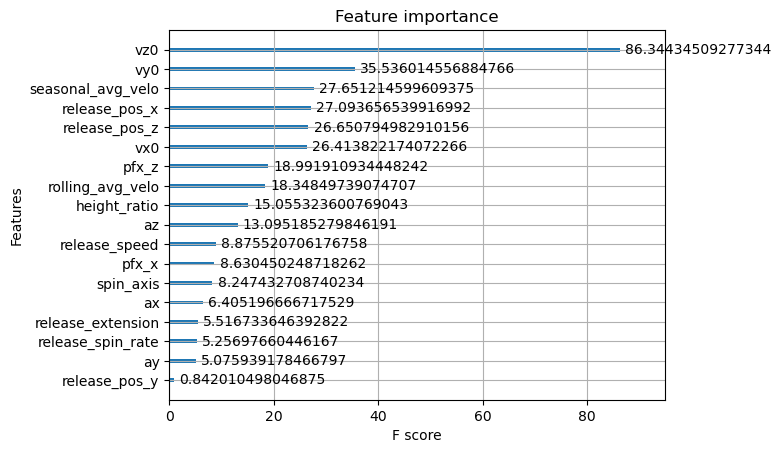

In [ ]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

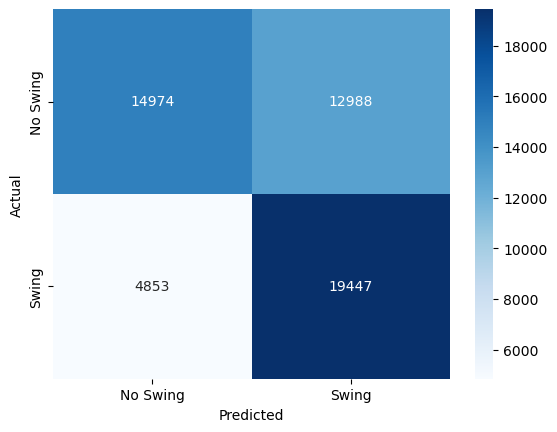

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Swing', 'Swing'], yticklabels=['No Swing', 'Swing'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [ ]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo'],
      dtype='object')

In [ ]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [ ]:
y_pred = final_model.predict(predictions)

In [ ]:
testing_identifiers['xswing'] = y_pred

In [ ]:
num_nans = testing_identifiers['xswing'].isna().sum()
print(f"Number of NaNs in 'xswing': {num_nans}")


Number of NaNs in 'xswing': 0


In [ ]:
len(testing_identifiers)

562083

In [ ]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/breaking_ball/swing_2022&3_xswing.csv")